# s1_get_skeletons_from_training_imgs.py

In [5]:
#!/usr/bin/env python
# coding: utf-8

'''
Read training images based on `valid_images.txt` and then detect skeletons.
    
In each image, there should be only 1 person performing one type of action.
Each image is named as 00001.jpg, 00002.jpg, ...

An example of the content of valid_images.txt is shown below:
    
    jump_03-12-09-18-26-176
    58 680

    jump_03-13-11-27-50-720
    65 393

    kick_03-02-12-36-05-185
    54 62
    75 84

The two indices (such as `56 680` in the first `jump` example)
represents the starting index and ending index of a certain action.

Input:
    SRC_IMAGES_DESCRIPTION_TXT
    SRC_IMAGES_FOLDER
    
Output:
    DST_IMAGES_INFO_TXT
    DST_DETECTED_SKELETONS_FOLDER
    DST_VIZ_IMGS_FOLDER
'''

import cv2
import yaml

if True:  # Include project path
    import sys
    import os
    ROOT = os.path.dirname(os.path.abspath("__file__"))+"//"
    CURR_PATH = os.path.dirname(os.path.abspath("__file__"))+"/"
    sys.path.append(ROOT)

    from utils.lib_openpose import SkeletonDetector
    from utils.lib_tracker import Tracker
    from utils.lib_skeletons_io import ReadValidImagesAndActionTypesByTxt
    import utils.lib_commons as lib_commons


def par(path):  # Pre-Append ROOT to the path if it's not absolute
    return ROOT + path if (path and path[0] != "/") else path

# -- Settings


cfg_all = lib_commons.read_yaml(ROOT + "config/config.yaml")
cfg = cfg_all["s1_get_skeletons_from_training_imgs.py"]

IMG_FILENAME_FORMAT = cfg_all["image_filename_format"]
SKELETON_FILENAME_FORMAT = cfg_all["skeleton_filename_format"]


# Input
if True:
    SRC_IMAGES_DESCRIPTION_TXT = par(cfg["input"]["images_description_txt"])
    SRC_IMAGES_FOLDER = par(cfg["input"]["images_folder"])

# Output
if True:
    # This txt will store image info, such as index, action label, filename, etc.
    # This file is saved but not used.
    DST_IMAGES_INFO_TXT = par(cfg["output"]["images_info_txt"])

    # Each txt will store the skeleton of each image
    DST_DETECTED_SKELETONS_FOLDER = par(
        cfg["output"]["detected_skeletons_folder"])

    # Each image is drawn with the detected skeleton
    DST_VIZ_IMGS_FOLDER = par(cfg["output"]["viz_imgs_folders"])

# Openpose
if True:
    OPENPOSE_MODEL = cfg["openpose"]["model"]
    OPENPOSE_IMG_SIZE = cfg["openpose"]["img_size"]

# -- Functions


class ImageDisplayer(object):
    ''' A simple wrapper of using cv2.imshow to display image '''

    def __init__(self):
        self._window_name = "cv2_display_window"
        cv2.namedWindow(self._window_name)

    def display(self, image, wait_key_ms=1):
        cv2.imshow(self._window_name, image)
        cv2.waitKey(wait_key_ms)

    def __del__(self):
        cv2.destroyWindow(self._window_name)


# -- Main
if __name__ == "__main__":

    # -- Detector
    skeleton_detector = SkeletonDetector(OPENPOSE_MODEL, OPENPOSE_IMG_SIZE)
    multiperson_tracker = Tracker()

    # -- Image reader and displayer
    images_loader = ReadValidImagesAndActionTypesByTxt(
        img_folder=SRC_IMAGES_FOLDER,
        valid_imgs_txt=SRC_IMAGES_DESCRIPTION_TXT,
        img_filename_format=IMG_FILENAME_FORMAT)
    # This file is not used.
    images_loader.save_images_info(filepath=DST_IMAGES_INFO_TXT)
    img_displayer = ImageDisplayer()

    # -- Init output path
    os.makedirs(os.path.dirname(DST_IMAGES_INFO_TXT), exist_ok=True)
    os.makedirs(DST_DETECTED_SKELETONS_FOLDER, exist_ok=True)
    os.makedirs(DST_VIZ_IMGS_FOLDER, exist_ok=True)

    # -- Read images and process
    num_total_images = images_loader.num_images
    for ith_img in range(num_total_images):

        # -- Read image
        img, str_action_label, img_info = images_loader.read_image()

        # -- Detect
        humans = skeleton_detector.detect(img)

        # -- Draw
        img_disp = img.copy()
        skeleton_detector.draw(img_disp, humans)
        img_displayer.display(img_disp, wait_key_ms=1)

        # -- Get skeleton data and save to file
        skeletons, scale_h = skeleton_detector.humans_to_skels_list(humans)
        dict_id2skeleton = multiperson_tracker.track(
            skeletons)  # dict: (int human id) -> (np.array() skeleton)
        skels_to_save = [img_info + skeleton.tolist()
                         for skeleton in dict_id2skeleton.values()]

        # -- Save result

        # Save skeleton data for training
        filename = SKELETON_FILENAME_FORMAT.format(ith_img)
        lib_commons.save_listlist(
            DST_DETECTED_SKELETONS_FOLDER + filename,
            skels_to_save)

        # Save the visualized image for debug
        filename = IMG_FILENAME_FORMAT.format(ith_img)
        cv2.imwrite(
            DST_VIZ_IMGS_FOLDER + filename,
            img_disp)

        print(f"{ith_img}/{num_total_images} th image "
              f"has {len(skeletons)} people in it")

    print("Program ends")


[2021-10-21 15:27:23,328] [TfPoseEstimator] [INFO] loading graph from C:\Users\tirumva2\.conda\envs\tf-115\lib\site-packages\tf_pose_data\graph/cmu/graph_opt.pb(default size=656x368)
[2021-10-21 15:27:23,328] [TfPoseEstimator] [INFO] loading graph from C:\Users\tirumva2\.conda\envs\tf-115\lib\site-packages\tf_pose_data\graph/cmu/graph_opt.pb(default size=656x368)


TfPoseEstimator/MobilenetV1/Conv2d_0/weights
TfPoseEstimator/image
TfPoseEstimator/MobilenetV1/Conv2d_0/Conv2D
TfPoseEstimator/MobilenetV1/Conv2d_0/Conv2D_bn_offset
TfPoseEstimator/MobilenetV1/Conv2d_0/BatchNorm/FusedBatchNorm
TfPoseEstimator/MobilenetV1/Conv2d_0/Relu
TfPoseEstimator/MobilenetV1/Conv2d_1_depthwise/depthwise_weights
TfPoseEstimator/MobilenetV1/Conv2d_1_pointwise/weights
TfPoseEstimator/MobilenetV1/Conv2d_1_depthwise/depthwise
TfPoseEstimator/MobilenetV1/Conv2d_1_pointwise/Conv2D
TfPoseEstimator/MobilenetV1/Conv2d_1_pointwise/Conv2D_bn_offset
TfPoseEstimator/MobilenetV1/Conv2d_1_pointwise/BatchNorm/FusedBatchNorm
TfPoseEstimator/MobilenetV1/Conv2d_1_pointwise/Relu
TfPoseEstimator/MobilenetV1/Conv2d_2_depthwise/depthwise_weights
TfPoseEstimator/MobilenetV1/Conv2d_2_pointwise/weights
TfPoseEstimator/MobilenetV1/Conv2d_2_depthwise/depthwise
TfPoseEstimator/MobilenetV1/Conv2d_2_pointwise/Conv2D
TfPoseEstimator/MobilenetV1/Conv2d_2_pointwise/Conv2D_bn_offset
TfPoseEstimator/M

[2021-10-21 15:27:25,117] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:25,117] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:25,117] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080



Number of action classes = 3
Number of training images = 2802
Number of training images of each action:
       Low| 1104|
    Medium|  650|
      High| 1048|
Reading images from txtscript: C:\Users\tirumva2\Realtime-Action-Recognition-Ag-OMS//data/source_images3/
Reading images information from: C:\Users\tirumva2\Realtime-Action-Recognition-Ag-OMS//data/source_images3/valid_images.txt
    Num images = 2802



[2021-10-21 15:27:25,404] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:25,404] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:25,404] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:25,407] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:27:25,407] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:27:25,407] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:27:25,409] [TfPoseEstimator] [INFO] inference image in 0.2922 seconds.
[2021-10-21 15:27:25,409] [TfPoseEstimator] [INFO] inference image in 0.2922 seconds.
[2021-10-21 15:27:25,409] [TfPoseEstimator] [INFO] inference image in 0.2922 seconds.
[2021-10-21 15:27:25,480] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:25,480] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:25,480] [TfPoseEstimator] [DEBUG] inference+

0/2802 th image has 1 people in it


[2021-10-21 15:27:25,752] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:25,752] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:25,752] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:25,754] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-10-21 15:27:25,754] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-10-21 15:27:25,754] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-10-21 15:27:25,756] [TfPoseEstimator] [INFO] inference image in 0.2768 seconds.
[2021-10-21 15:27:25,756] [TfPoseEstimator] [INFO] inference image in 0.2768 seconds.
[2021-10-21 15:27:25,756] [TfPoseEstimator] [INFO] inference image in 0.2768 seconds.
[2021-10-21 15:27:25,820] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:25,820] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:25,820] [TfPoseEstimator] [DEBUG] inference+

1/2802 th image has 0 people in it


[2021-10-21 15:27:26,084] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:26,084] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:26,084] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:26,094] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:27:26,094] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:27:26,094] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:27:26,095] [TfPoseEstimator] [INFO] inference image in 0.2751 seconds.
[2021-10-21 15:27:26,095] [TfPoseEstimator] [INFO] inference image in 0.2751 seconds.
[2021-10-21 15:27:26,095] [TfPoseEstimator] [INFO] inference image in 0.2751 seconds.
[2021-10-21 15:27:26,158] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:26,158] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:26,158] [TfPoseEstimator] [DEBUG] inference+

2/2802 th image has 0 people in it


[2021-10-21 15:27:26,440] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:26,440] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:26,440] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:26,440] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:26,440] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:26,440] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:26,445] [TfPoseEstimator] [INFO] inference image in 0.2872 seconds.
[2021-10-21 15:27:26,445] [TfPoseEstimator] [INFO] inference image in 0.2872 seconds.
[2021-10-21 15:27:26,445] [TfPoseEstimator] [INFO] inference image in 0.2872 seconds.
[2021-10-21 15:27:26,507] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:26,507] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:26,507] [TfPoseEstimator] [DEBUG] inference+

3/2802 th image has 0 people in it


[2021-10-21 15:27:26,780] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:26,780] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:26,780] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:26,780] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:26,780] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:26,780] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:26,784] [TfPoseEstimator] [INFO] inference image in 0.2772 seconds.
[2021-10-21 15:27:26,784] [TfPoseEstimator] [INFO] inference image in 0.2772 seconds.
[2021-10-21 15:27:26,784] [TfPoseEstimator] [INFO] inference image in 0.2772 seconds.
[2021-10-21 15:27:26,846] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:26,846] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:26,846] [TfPoseEstimator] [DEBUG] inference+

4/2802 th image has 0 people in it


[2021-10-21 15:27:27,111] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:27,111] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:27,111] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:27,121] [TfPoseEstimator] [DEBUG] estimate time=0.00999
[2021-10-21 15:27:27,121] [TfPoseEstimator] [DEBUG] estimate time=0.00999
[2021-10-21 15:27:27,121] [TfPoseEstimator] [DEBUG] estimate time=0.00999
[2021-10-21 15:27:27,122] [TfPoseEstimator] [INFO] inference image in 0.2760 seconds.
[2021-10-21 15:27:27,122] [TfPoseEstimator] [INFO] inference image in 0.2760 seconds.
[2021-10-21 15:27:27,122] [TfPoseEstimator] [INFO] inference image in 0.2760 seconds.
[2021-10-21 15:27:27,186] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:27,186] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:27,186] [TfPoseEstimator] [DEBUG] inference+

5/2802 th image has 0 people in it


[2021-10-21 15:27:27,461] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:27,461] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:27,461] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:27,461] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:27,461] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:27,461] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:27,466] [TfPoseEstimator] [INFO] inference image in 0.2806 seconds.
[2021-10-21 15:27:27,466] [TfPoseEstimator] [INFO] inference image in 0.2806 seconds.
[2021-10-21 15:27:27,466] [TfPoseEstimator] [INFO] inference image in 0.2806 seconds.
[2021-10-21 15:27:27,529] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:27,529] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:27,529] [TfPoseEstimator] [DEBUG] inference+

6/2802 th image has 0 people in it


[2021-10-21 15:27:27,798] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:27,798] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:27,798] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:27,798] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:27,798] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:27,798] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:27,805] [TfPoseEstimator] [INFO] inference image in 0.2756 seconds.
[2021-10-21 15:27:27,805] [TfPoseEstimator] [INFO] inference image in 0.2756 seconds.
[2021-10-21 15:27:27,805] [TfPoseEstimator] [INFO] inference image in 0.2756 seconds.
[2021-10-21 15:27:27,868] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:27,868] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:27,868] [TfPoseEstimator] [DEBUG] inference+

7/2802 th image has 0 people in it


[2021-10-21 15:27:28,138] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:28,138] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:28,138] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:28,138] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:28,138] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:28,138] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:28,148] [TfPoseEstimator] [INFO] inference image in 0.2804 seconds.
[2021-10-21 15:27:28,148] [TfPoseEstimator] [INFO] inference image in 0.2804 seconds.
[2021-10-21 15:27:28,148] [TfPoseEstimator] [INFO] inference image in 0.2804 seconds.
[2021-10-21 15:27:28,210] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:28,210] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:28,210] [TfPoseEstimator] [DEBUG] inference+

8/2802 th image has 0 people in it


[2021-10-21 15:27:28,487] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:28,487] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:28,487] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:28,490] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:27:28,490] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:27:28,490] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:27:28,492] [TfPoseEstimator] [INFO] inference image in 0.2816 seconds.
[2021-10-21 15:27:28,492] [TfPoseEstimator] [INFO] inference image in 0.2816 seconds.
[2021-10-21 15:27:28,492] [TfPoseEstimator] [INFO] inference image in 0.2816 seconds.
[2021-10-21 15:27:28,554] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:28,554] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:28,554] [TfPoseEstimator] [DEBUG] inference+

9/2802 th image has 0 people in it


[2021-10-21 15:27:28,823] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:28,823] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:28,823] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:28,831] [TfPoseEstimator] [DEBUG] estimate time=0.00843
[2021-10-21 15:27:28,831] [TfPoseEstimator] [DEBUG] estimate time=0.00843
[2021-10-21 15:27:28,831] [TfPoseEstimator] [DEBUG] estimate time=0.00843
[2021-10-21 15:27:28,832] [TfPoseEstimator] [INFO] inference image in 0.2777 seconds.
[2021-10-21 15:27:28,832] [TfPoseEstimator] [INFO] inference image in 0.2777 seconds.
[2021-10-21 15:27:28,832] [TfPoseEstimator] [INFO] inference image in 0.2777 seconds.
[2021-10-21 15:27:28,896] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:28,896] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:28,896] [TfPoseEstimator] [DEBUG] inference+

10/2802 th image has 0 people in it


[2021-10-21 15:27:29,162] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:29,162] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:29,162] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:29,162] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:29,162] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:29,162] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:29,172] [TfPoseEstimator] [INFO] inference image in 0.2758 seconds.
[2021-10-21 15:27:29,172] [TfPoseEstimator] [INFO] inference image in 0.2758 seconds.
[2021-10-21 15:27:29,172] [TfPoseEstimator] [INFO] inference image in 0.2758 seconds.
[2021-10-21 15:27:29,235] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:29,235] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:29,235] [TfPoseEstimator] [DEBUG] inference+

11/2802 th image has 0 people in it


[2021-10-21 15:27:29,503] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:29,503] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:29,503] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:29,503] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:29,503] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:29,503] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:29,510] [TfPoseEstimator] [INFO] inference image in 0.2759 seconds.
[2021-10-21 15:27:29,510] [TfPoseEstimator] [INFO] inference image in 0.2759 seconds.
[2021-10-21 15:27:29,510] [TfPoseEstimator] [INFO] inference image in 0.2759 seconds.
[2021-10-21 15:27:29,579] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:29,579] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:29,579] [TfPoseEstimator] [DEBUG] inference+

12/2802 th image has 0 people in it


[2021-10-21 15:27:29,853] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:29,853] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:29,853] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:29,857] [TfPoseEstimator] [DEBUG] estimate time=0.00367
[2021-10-21 15:27:29,857] [TfPoseEstimator] [DEBUG] estimate time=0.00367
[2021-10-21 15:27:29,857] [TfPoseEstimator] [DEBUG] estimate time=0.00367
[2021-10-21 15:27:29,858] [TfPoseEstimator] [INFO] inference image in 0.2784 seconds.
[2021-10-21 15:27:29,858] [TfPoseEstimator] [INFO] inference image in 0.2784 seconds.
[2021-10-21 15:27:29,858] [TfPoseEstimator] [INFO] inference image in 0.2784 seconds.
[2021-10-21 15:27:29,926] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:29,926] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:29,926] [TfPoseEstimator] [DEBUG] inference+

13/2802 th image has 0 people in it


[2021-10-21 15:27:30,206] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:30,206] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:30,206] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:30,212] [TfPoseEstimator] [DEBUG] estimate time=0.00643
[2021-10-21 15:27:30,212] [TfPoseEstimator] [DEBUG] estimate time=0.00643
[2021-10-21 15:27:30,212] [TfPoseEstimator] [DEBUG] estimate time=0.00643
[2021-10-21 15:27:30,213] [TfPoseEstimator] [INFO] inference image in 0.2880 seconds.
[2021-10-21 15:27:30,213] [TfPoseEstimator] [INFO] inference image in 0.2880 seconds.
[2021-10-21 15:27:30,213] [TfPoseEstimator] [INFO] inference image in 0.2880 seconds.
[2021-10-21 15:27:30,277] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:30,277] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:30,277] [TfPoseEstimator] [DEBUG] inference+

14/2802 th image has 0 people in it


[2021-10-21 15:27:30,547] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:30,547] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:30,547] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:30,549] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-10-21 15:27:30,549] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-10-21 15:27:30,549] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-10-21 15:27:30,551] [TfPoseEstimator] [INFO] inference image in 0.2733 seconds.
[2021-10-21 15:27:30,551] [TfPoseEstimator] [INFO] inference image in 0.2733 seconds.
[2021-10-21 15:27:30,551] [TfPoseEstimator] [INFO] inference image in 0.2733 seconds.
[2021-10-21 15:27:30,613] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:30,613] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:30,613] [TfPoseEstimator] [DEBUG] inference+

15/2802 th image has 0 people in it


[2021-10-21 15:27:30,884] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:30,884] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:30,884] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:30,884] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:30,884] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:30,884] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:30,891] [TfPoseEstimator] [INFO] inference image in 0.2775 seconds.
[2021-10-21 15:27:30,891] [TfPoseEstimator] [INFO] inference image in 0.2775 seconds.
[2021-10-21 15:27:30,891] [TfPoseEstimator] [INFO] inference image in 0.2775 seconds.
[2021-10-21 15:27:30,957] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:30,957] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:30,957] [TfPoseEstimator] [DEBUG] inference+

16/2802 th image has 0 people in it


[2021-10-21 15:27:31,237] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:31,237] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:31,237] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:31,237] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:31,237] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:31,237] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:31,247] [TfPoseEstimator] [INFO] inference image in 0.2906 seconds.
[2021-10-21 15:27:31,247] [TfPoseEstimator] [INFO] inference image in 0.2906 seconds.
[2021-10-21 15:27:31,247] [TfPoseEstimator] [INFO] inference image in 0.2906 seconds.
[2021-10-21 15:27:31,312] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:31,312] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:31,312] [TfPoseEstimator] [DEBUG] inference+

17/2802 th image has 0 people in it


[2021-10-21 15:27:31,581] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:31,581] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:31,581] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:31,589] [TfPoseEstimator] [DEBUG] estimate time=0.00799
[2021-10-21 15:27:31,589] [TfPoseEstimator] [DEBUG] estimate time=0.00799
[2021-10-21 15:27:31,589] [TfPoseEstimator] [DEBUG] estimate time=0.00799
[2021-10-21 15:27:31,591] [TfPoseEstimator] [INFO] inference image in 0.2786 seconds.
[2021-10-21 15:27:31,591] [TfPoseEstimator] [INFO] inference image in 0.2786 seconds.
[2021-10-21 15:27:31,591] [TfPoseEstimator] [INFO] inference image in 0.2786 seconds.
[2021-10-21 15:27:31,654] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:31,654] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:31,654] [TfPoseEstimator] [DEBUG] inference+

18/2802 th image has 0 people in it


[2021-10-21 15:27:31,951] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:31,951] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:31,951] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:31,955] [TfPoseEstimator] [DEBUG] estimate time=0.00334
[2021-10-21 15:27:31,955] [TfPoseEstimator] [DEBUG] estimate time=0.00334
[2021-10-21 15:27:31,955] [TfPoseEstimator] [DEBUG] estimate time=0.00334
[2021-10-21 15:27:31,956] [TfPoseEstimator] [INFO] inference image in 0.3017 seconds.
[2021-10-21 15:27:31,956] [TfPoseEstimator] [INFO] inference image in 0.3017 seconds.
[2021-10-21 15:27:31,956] [TfPoseEstimator] [INFO] inference image in 0.3017 seconds.
[2021-10-21 15:27:32,023] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:32,023] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:32,023] [TfPoseEstimator] [DEBUG] inference+

19/2802 th image has 1 people in it


[2021-10-21 15:27:32,294] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:32,294] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:32,294] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:32,306] [TfPoseEstimator] [DEBUG] estimate time=0.00204
[2021-10-21 15:27:32,306] [TfPoseEstimator] [DEBUG] estimate time=0.00204
[2021-10-21 15:27:32,306] [TfPoseEstimator] [DEBUG] estimate time=0.00204
[2021-10-21 15:27:32,308] [TfPoseEstimator] [INFO] inference image in 0.2861 seconds.
[2021-10-21 15:27:32,308] [TfPoseEstimator] [INFO] inference image in 0.2861 seconds.
[2021-10-21 15:27:32,308] [TfPoseEstimator] [INFO] inference image in 0.2861 seconds.
[2021-10-21 15:27:32,368] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:32,368] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:32,368] [TfPoseEstimator] [DEBUG] inference+

20/2802 th image has 1 people in it


[2021-10-21 15:27:32,644] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:32,644] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:32,644] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:32,644] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:32,644] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:32,644] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:32,648] [TfPoseEstimator] [INFO] inference image in 0.2798 seconds.
[2021-10-21 15:27:32,648] [TfPoseEstimator] [INFO] inference image in 0.2798 seconds.
[2021-10-21 15:27:32,648] [TfPoseEstimator] [INFO] inference image in 0.2798 seconds.
[2021-10-21 15:27:32,711] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:32,711] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:32,711] [TfPoseEstimator] [DEBUG] inference+

21/2802 th image has 1 people in it


[2021-10-21 15:27:32,981] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:32,981] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:32,981] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:32,981] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:32,981] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:32,981] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:32,991] [TfPoseEstimator] [INFO] inference image in 0.2795 seconds.
[2021-10-21 15:27:32,991] [TfPoseEstimator] [INFO] inference image in 0.2795 seconds.
[2021-10-21 15:27:32,991] [TfPoseEstimator] [INFO] inference image in 0.2795 seconds.
[2021-10-21 15:27:33,051] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:33,051] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:33,051] [TfPoseEstimator] [DEBUG] inference+

22/2802 th image has 1 people in it


[2021-10-21 15:27:33,325] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:33,325] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:33,325] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:33,325] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:33,325] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:33,325] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:33,331] [TfPoseEstimator] [INFO] inference image in 0.2794 seconds.
[2021-10-21 15:27:33,331] [TfPoseEstimator] [INFO] inference image in 0.2794 seconds.
[2021-10-21 15:27:33,331] [TfPoseEstimator] [INFO] inference image in 0.2794 seconds.
[2021-10-21 15:27:33,395] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:33,395] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:33,395] [TfPoseEstimator] [DEBUG] inference+

23/2802 th image has 2 people in it


[2021-10-21 15:27:33,666] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:33,666] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:33,666] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:33,673] [TfPoseEstimator] [DEBUG] estimate time=0.00693
[2021-10-21 15:27:33,673] [TfPoseEstimator] [DEBUG] estimate time=0.00693
[2021-10-21 15:27:33,673] [TfPoseEstimator] [DEBUG] estimate time=0.00693
[2021-10-21 15:27:33,674] [TfPoseEstimator] [INFO] inference image in 0.2788 seconds.
[2021-10-21 15:27:33,674] [TfPoseEstimator] [INFO] inference image in 0.2788 seconds.
[2021-10-21 15:27:33,674] [TfPoseEstimator] [INFO] inference image in 0.2788 seconds.
[2021-10-21 15:27:33,735] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:33,735] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:33,735] [TfPoseEstimator] [DEBUG] inference+

24/2802 th image has 2 people in it


[2021-10-21 15:27:34,014] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:34,014] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:34,014] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:34,014] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:34,014] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:34,014] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:34,019] [TfPoseEstimator] [INFO] inference image in 0.2835 seconds.
[2021-10-21 15:27:34,019] [TfPoseEstimator] [INFO] inference image in 0.2835 seconds.
[2021-10-21 15:27:34,019] [TfPoseEstimator] [INFO] inference image in 0.2835 seconds.
[2021-10-21 15:27:34,083] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:34,083] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:34,083] [TfPoseEstimator] [DEBUG] inference+

25/2802 th image has 1 people in it


[2021-10-21 15:27:34,360] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:34,360] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:34,360] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:34,360] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:34,360] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:34,360] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:34,364] [TfPoseEstimator] [INFO] inference image in 0.2809 seconds.
[2021-10-21 15:27:34,364] [TfPoseEstimator] [INFO] inference image in 0.2809 seconds.
[2021-10-21 15:27:34,364] [TfPoseEstimator] [INFO] inference image in 0.2809 seconds.
[2021-10-21 15:27:34,429] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:34,429] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:34,429] [TfPoseEstimator] [DEBUG] inference+

26/2802 th image has 1 people in it


[2021-10-21 15:27:34,702] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:34,702] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:34,702] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:34,710] [TfPoseEstimator] [DEBUG] estimate time=0.00817
[2021-10-21 15:27:34,710] [TfPoseEstimator] [DEBUG] estimate time=0.00817
[2021-10-21 15:27:34,710] [TfPoseEstimator] [DEBUG] estimate time=0.00817
[2021-10-21 15:27:34,712] [TfPoseEstimator] [INFO] inference image in 0.2826 seconds.
[2021-10-21 15:27:34,712] [TfPoseEstimator] [INFO] inference image in 0.2826 seconds.
[2021-10-21 15:27:34,712] [TfPoseEstimator] [INFO] inference image in 0.2826 seconds.
[2021-10-21 15:27:34,786] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:34,786] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:34,786] [TfPoseEstimator] [DEBUG] inference+

27/2802 th image has 1 people in it


[2021-10-21 15:27:35,064] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:35,064] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:35,064] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:35,066] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-10-21 15:27:35,066] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-10-21 15:27:35,066] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-10-21 15:27:35,068] [TfPoseEstimator] [INFO] inference image in 0.2827 seconds.
[2021-10-21 15:27:35,068] [TfPoseEstimator] [INFO] inference image in 0.2827 seconds.
[2021-10-21 15:27:35,068] [TfPoseEstimator] [INFO] inference image in 0.2827 seconds.
[2021-10-21 15:27:35,133] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:35,133] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:35,133] [TfPoseEstimator] [DEBUG] inference+

28/2802 th image has 1 people in it


[2021-10-21 15:27:35,415] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:35,415] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:35,415] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:35,417] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-10-21 15:27:35,417] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-10-21 15:27:35,417] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-10-21 15:27:35,419] [TfPoseEstimator] [INFO] inference image in 0.2861 seconds.
[2021-10-21 15:27:35,419] [TfPoseEstimator] [INFO] inference image in 0.2861 seconds.
[2021-10-21 15:27:35,419] [TfPoseEstimator] [INFO] inference image in 0.2861 seconds.
[2021-10-21 15:27:35,484] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:35,484] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:35,484] [TfPoseEstimator] [DEBUG] inference+

29/2802 th image has 1 people in it


[2021-10-21 15:27:35,752] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:35,752] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:35,752] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:35,765] [TfPoseEstimator] [DEBUG] estimate time=0.00261
[2021-10-21 15:27:35,765] [TfPoseEstimator] [DEBUG] estimate time=0.00261
[2021-10-21 15:27:35,765] [TfPoseEstimator] [DEBUG] estimate time=0.00261
[2021-10-21 15:27:35,766] [TfPoseEstimator] [INFO] inference image in 0.2816 seconds.
[2021-10-21 15:27:35,766] [TfPoseEstimator] [INFO] inference image in 0.2816 seconds.
[2021-10-21 15:27:35,766] [TfPoseEstimator] [INFO] inference image in 0.2816 seconds.
[2021-10-21 15:27:35,830] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:35,830] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:35,830] [TfPoseEstimator] [DEBUG] inference+

30/2802 th image has 1 people in it


[2021-10-21 15:27:36,101] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:36,101] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:36,101] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:36,101] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:36,101] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:36,101] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:36,109] [TfPoseEstimator] [INFO] inference image in 0.2804 seconds.
[2021-10-21 15:27:36,109] [TfPoseEstimator] [INFO] inference image in 0.2804 seconds.
[2021-10-21 15:27:36,109] [TfPoseEstimator] [INFO] inference image in 0.2804 seconds.
[2021-10-21 15:27:36,171] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:36,171] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:36,171] [TfPoseEstimator] [DEBUG] inference+

31/2802 th image has 1 people in it


[2021-10-21 15:27:36,445] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:36,445] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:36,445] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:36,455] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:36,455] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:36,455] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:36,457] [TfPoseEstimator] [INFO] inference image in 0.2865 seconds.
[2021-10-21 15:27:36,457] [TfPoseEstimator] [INFO] inference image in 0.2865 seconds.
[2021-10-21 15:27:36,457] [TfPoseEstimator] [INFO] inference image in 0.2865 seconds.
[2021-10-21 15:27:36,523] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:36,523] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:36,523] [TfPoseEstimator] [DEBUG] inference+

32/2802 th image has 1 people in it


[2021-10-21 15:27:36,800] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:36,800] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:36,800] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:36,801] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:36,801] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:36,801] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:36,804] [TfPoseEstimator] [INFO] inference image in 0.2810 seconds.
[2021-10-21 15:27:36,804] [TfPoseEstimator] [INFO] inference image in 0.2810 seconds.
[2021-10-21 15:27:36,804] [TfPoseEstimator] [INFO] inference image in 0.2810 seconds.
[2021-10-21 15:27:36,868] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:36,868] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:36,868] [TfPoseEstimator] [DEBUG] inference+

33/2802 th image has 1 people in it


[2021-10-21 15:27:37,141] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:37,141] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:37,141] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:37,141] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:37,141] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:37,141] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:37,147] [TfPoseEstimator] [INFO] inference image in 0.2793 seconds.
[2021-10-21 15:27:37,147] [TfPoseEstimator] [INFO] inference image in 0.2793 seconds.
[2021-10-21 15:27:37,147] [TfPoseEstimator] [INFO] inference image in 0.2793 seconds.
[2021-10-21 15:27:37,222] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:37,222] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:37,222] [TfPoseEstimator] [DEBUG] inference+

34/2802 th image has 1 people in it


[2021-10-21 15:27:37,499] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:37,499] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:37,499] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:37,502] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:27:37,502] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:27:37,502] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:27:37,505] [TfPoseEstimator] [INFO] inference image in 0.2826 seconds.
[2021-10-21 15:27:37,505] [TfPoseEstimator] [INFO] inference image in 0.2826 seconds.
[2021-10-21 15:27:37,505] [TfPoseEstimator] [INFO] inference image in 0.2826 seconds.
[2021-10-21 15:27:37,569] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:37,569] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:37,569] [TfPoseEstimator] [DEBUG] inference+

35/2802 th image has 1 people in it


[2021-10-21 15:27:37,846] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:37,846] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:37,846] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:37,849] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:27:37,849] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:27:37,849] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:27:37,851] [TfPoseEstimator] [INFO] inference image in 0.2822 seconds.
[2021-10-21 15:27:37,851] [TfPoseEstimator] [INFO] inference image in 0.2822 seconds.
[2021-10-21 15:27:37,851] [TfPoseEstimator] [INFO] inference image in 0.2822 seconds.
[2021-10-21 15:27:37,914] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:37,914] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:37,914] [TfPoseEstimator] [DEBUG] inference+

36/2802 th image has 1 people in it


[2021-10-21 15:27:38,194] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:38,194] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:38,194] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:38,197] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:27:38,197] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:27:38,197] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:27:38,199] [TfPoseEstimator] [INFO] inference image in 0.2852 seconds.
[2021-10-21 15:27:38,199] [TfPoseEstimator] [INFO] inference image in 0.2852 seconds.
[2021-10-21 15:27:38,199] [TfPoseEstimator] [INFO] inference image in 0.2852 seconds.
[2021-10-21 15:27:38,263] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:38,263] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:38,263] [TfPoseEstimator] [DEBUG] inference+

37/2802 th image has 1 people in it


[2021-10-21 15:27:38,540] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:38,540] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:38,540] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:38,543] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:27:38,543] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:27:38,543] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:27:38,544] [TfPoseEstimator] [INFO] inference image in 0.2813 seconds.
[2021-10-21 15:27:38,544] [TfPoseEstimator] [INFO] inference image in 0.2813 seconds.
[2021-10-21 15:27:38,544] [TfPoseEstimator] [INFO] inference image in 0.2813 seconds.
[2021-10-21 15:27:38,608] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:38,608] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:38,608] [TfPoseEstimator] [DEBUG] inference+

38/2802 th image has 1 people in it


[2021-10-21 15:27:38,894] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:38,894] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:38,894] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:38,897] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-10-21 15:27:38,897] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-10-21 15:27:38,897] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-10-21 15:27:38,899] [TfPoseEstimator] [INFO] inference image in 0.2912 seconds.
[2021-10-21 15:27:38,899] [TfPoseEstimator] [INFO] inference image in 0.2912 seconds.
[2021-10-21 15:27:38,899] [TfPoseEstimator] [INFO] inference image in 0.2912 seconds.
[2021-10-21 15:27:38,961] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:38,961] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:38,961] [TfPoseEstimator] [DEBUG] inference+

39/2802 th image has 1 people in it


[2021-10-21 15:27:39,238] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:39,238] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:39,238] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:39,242] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:27:39,242] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:27:39,242] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:27:39,243] [TfPoseEstimator] [INFO] inference image in 0.2821 seconds.
[2021-10-21 15:27:39,243] [TfPoseEstimator] [INFO] inference image in 0.2821 seconds.
[2021-10-21 15:27:39,243] [TfPoseEstimator] [INFO] inference image in 0.2821 seconds.
[2021-10-21 15:27:39,307] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:39,307] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:39,307] [TfPoseEstimator] [DEBUG] inference+

40/2802 th image has 1 people in it


[2021-10-21 15:27:39,591] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:39,591] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:39,591] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:39,594] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:27:39,594] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:27:39,594] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:27:39,596] [TfPoseEstimator] [INFO] inference image in 0.2893 seconds.
[2021-10-21 15:27:39,596] [TfPoseEstimator] [INFO] inference image in 0.2893 seconds.
[2021-10-21 15:27:39,596] [TfPoseEstimator] [INFO] inference image in 0.2893 seconds.
[2021-10-21 15:27:39,659] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:39,659] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:39,659] [TfPoseEstimator] [DEBUG] inference+

41/2802 th image has 1 people in it


[2021-10-21 15:27:39,934] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:39,934] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:39,934] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:39,937] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-10-21 15:27:39,937] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-10-21 15:27:39,937] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-10-21 15:27:39,939] [TfPoseEstimator] [INFO] inference image in 0.2807 seconds.
[2021-10-21 15:27:39,939] [TfPoseEstimator] [INFO] inference image in 0.2807 seconds.
[2021-10-21 15:27:39,939] [TfPoseEstimator] [INFO] inference image in 0.2807 seconds.
[2021-10-21 15:27:40,003] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:40,003] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:40,003] [TfPoseEstimator] [DEBUG] inference+

42/2802 th image has 1 people in it


[2021-10-21 15:27:40,281] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:40,281] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:40,281] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:40,292] [TfPoseEstimator] [DEBUG] estimate time=0.01134
[2021-10-21 15:27:40,292] [TfPoseEstimator] [DEBUG] estimate time=0.01134
[2021-10-21 15:27:40,292] [TfPoseEstimator] [DEBUG] estimate time=0.01134
[2021-10-21 15:27:40,293] [TfPoseEstimator] [INFO] inference image in 0.2898 seconds.
[2021-10-21 15:27:40,293] [TfPoseEstimator] [INFO] inference image in 0.2898 seconds.
[2021-10-21 15:27:40,293] [TfPoseEstimator] [INFO] inference image in 0.2898 seconds.
[2021-10-21 15:27:40,358] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:40,358] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:40,358] [TfPoseEstimator] [DEBUG] inference+

43/2802 th image has 1 people in it


[2021-10-21 15:27:40,628] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:40,628] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:40,628] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:40,628] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:40,628] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:40,628] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:40,639] [TfPoseEstimator] [INFO] inference image in 0.2814 seconds.
[2021-10-21 15:27:40,639] [TfPoseEstimator] [INFO] inference image in 0.2814 seconds.
[2021-10-21 15:27:40,639] [TfPoseEstimator] [INFO] inference image in 0.2814 seconds.
[2021-10-21 15:27:40,703] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:40,703] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:40,703] [TfPoseEstimator] [DEBUG] inference+

44/2802 th image has 1 people in it


[2021-10-21 15:27:40,978] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:40,978] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:40,978] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:40,984] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-10-21 15:27:40,984] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-10-21 15:27:40,984] [TfPoseEstimator] [DEBUG] estimate time=0.00599
[2021-10-21 15:27:40,985] [TfPoseEstimator] [INFO] inference image in 0.2818 seconds.
[2021-10-21 15:27:40,985] [TfPoseEstimator] [INFO] inference image in 0.2818 seconds.
[2021-10-21 15:27:40,985] [TfPoseEstimator] [INFO] inference image in 0.2818 seconds.
[2021-10-21 15:27:41,059] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:41,059] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:41,059] [TfPoseEstimator] [DEBUG] inference+

45/2802 th image has 1 people in it


[2021-10-21 15:27:41,336] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:41,336] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:41,336] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:41,336] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:41,336] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:41,336] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:41,345] [TfPoseEstimator] [INFO] inference image in 0.2858 seconds.
[2021-10-21 15:27:41,345] [TfPoseEstimator] [INFO] inference image in 0.2858 seconds.
[2021-10-21 15:27:41,345] [TfPoseEstimator] [INFO] inference image in 0.2858 seconds.
[2021-10-21 15:27:41,407] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:41,407] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:41,407] [TfPoseEstimator] [DEBUG] inference+

46/2802 th image has 1 people in it


[2021-10-21 15:27:41,675] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:41,675] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:41,675] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:41,685] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:41,685] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:41,685] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:41,688] [TfPoseEstimator] [INFO] inference image in 0.2805 seconds.
[2021-10-21 15:27:41,688] [TfPoseEstimator] [INFO] inference image in 0.2805 seconds.
[2021-10-21 15:27:41,688] [TfPoseEstimator] [INFO] inference image in 0.2805 seconds.
[2021-10-21 15:27:41,751] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:41,751] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:41,751] [TfPoseEstimator] [DEBUG] inference+

47/2802 th image has 1 people in it


[2021-10-21 15:27:42,026] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:42,026] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:42,026] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:42,030] [TfPoseEstimator] [DEBUG] estimate time=0.00476
[2021-10-21 15:27:42,030] [TfPoseEstimator] [DEBUG] estimate time=0.00476
[2021-10-21 15:27:42,030] [TfPoseEstimator] [DEBUG] estimate time=0.00476
[2021-10-21 15:27:42,031] [TfPoseEstimator] [INFO] inference image in 0.2806 seconds.
[2021-10-21 15:27:42,031] [TfPoseEstimator] [INFO] inference image in 0.2806 seconds.
[2021-10-21 15:27:42,031] [TfPoseEstimator] [INFO] inference image in 0.2806 seconds.
[2021-10-21 15:27:42,093] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:42,093] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:42,093] [TfPoseEstimator] [DEBUG] inference+

48/2802 th image has 1 people in it


[2021-10-21 15:27:42,367] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:42,367] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:42,367] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:42,378] [TfPoseEstimator] [DEBUG] estimate time=0.01119
[2021-10-21 15:27:42,378] [TfPoseEstimator] [DEBUG] estimate time=0.01119
[2021-10-21 15:27:42,378] [TfPoseEstimator] [DEBUG] estimate time=0.01119
[2021-10-21 15:27:42,379] [TfPoseEstimator] [INFO] inference image in 0.2854 seconds.
[2021-10-21 15:27:42,379] [TfPoseEstimator] [INFO] inference image in 0.2854 seconds.
[2021-10-21 15:27:42,379] [TfPoseEstimator] [INFO] inference image in 0.2854 seconds.
[2021-10-21 15:27:42,442] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:42,442] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:42,442] [TfPoseEstimator] [DEBUG] inference+

49/2802 th image has 1 people in it


[2021-10-21 15:27:42,717] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:42,717] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:42,717] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:42,717] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:42,717] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:42,717] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:42,723] [TfPoseEstimator] [INFO] inference image in 0.2811 seconds.
[2021-10-21 15:27:42,723] [TfPoseEstimator] [INFO] inference image in 0.2811 seconds.
[2021-10-21 15:27:42,723] [TfPoseEstimator] [INFO] inference image in 0.2811 seconds.
[2021-10-21 15:27:42,787] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:42,787] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:42,787] [TfPoseEstimator] [DEBUG] inference+

50/2802 th image has 1 people in it


[2021-10-21 15:27:43,059] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:43,059] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:43,059] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:43,067] [TfPoseEstimator] [DEBUG] estimate time=0.00763
[2021-10-21 15:27:43,067] [TfPoseEstimator] [DEBUG] estimate time=0.00763
[2021-10-21 15:27:43,067] [TfPoseEstimator] [DEBUG] estimate time=0.00763
[2021-10-21 15:27:43,069] [TfPoseEstimator] [INFO] inference image in 0.2823 seconds.
[2021-10-21 15:27:43,069] [TfPoseEstimator] [INFO] inference image in 0.2823 seconds.
[2021-10-21 15:27:43,069] [TfPoseEstimator] [INFO] inference image in 0.2823 seconds.
[2021-10-21 15:27:43,131] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:43,131] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:43,131] [TfPoseEstimator] [DEBUG] inference+

51/2802 th image has 1 people in it


[2021-10-21 15:27:43,401] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:43,401] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:43,401] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:43,412] [TfPoseEstimator] [DEBUG] estimate time=0.01092
[2021-10-21 15:27:43,412] [TfPoseEstimator] [DEBUG] estimate time=0.01092
[2021-10-21 15:27:43,412] [TfPoseEstimator] [DEBUG] estimate time=0.01092
[2021-10-21 15:27:43,413] [TfPoseEstimator] [INFO] inference image in 0.2818 seconds.
[2021-10-21 15:27:43,413] [TfPoseEstimator] [INFO] inference image in 0.2818 seconds.
[2021-10-21 15:27:43,413] [TfPoseEstimator] [INFO] inference image in 0.2818 seconds.
[2021-10-21 15:27:43,475] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:43,475] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:43,475] [TfPoseEstimator] [DEBUG] inference+

52/2802 th image has 1 people in it


[2021-10-21 15:27:43,751] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:43,751] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:43,751] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:43,751] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:43,751] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:43,751] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:43,755] [TfPoseEstimator] [INFO] inference image in 0.2796 seconds.
[2021-10-21 15:27:43,755] [TfPoseEstimator] [INFO] inference image in 0.2796 seconds.
[2021-10-21 15:27:43,755] [TfPoseEstimator] [INFO] inference image in 0.2796 seconds.
[2021-10-21 15:27:43,819] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:43,819] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:43,819] [TfPoseEstimator] [DEBUG] inference+

53/2802 th image has 1 people in it


[2021-10-21 15:27:44,094] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:44,094] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:44,094] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:44,094] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:44,094] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:44,094] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:44,100] [TfPoseEstimator] [INFO] inference image in 0.2814 seconds.
[2021-10-21 15:27:44,100] [TfPoseEstimator] [INFO] inference image in 0.2814 seconds.
[2021-10-21 15:27:44,100] [TfPoseEstimator] [INFO] inference image in 0.2814 seconds.
[2021-10-21 15:27:44,161] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:44,161] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:44,161] [TfPoseEstimator] [DEBUG] inference+

54/2802 th image has 1 people in it


[2021-10-21 15:27:44,435] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:44,435] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:44,435] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:44,435] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:44,435] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:44,435] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:44,444] [TfPoseEstimator] [INFO] inference image in 0.2832 seconds.
[2021-10-21 15:27:44,444] [TfPoseEstimator] [INFO] inference image in 0.2832 seconds.
[2021-10-21 15:27:44,444] [TfPoseEstimator] [INFO] inference image in 0.2832 seconds.
[2021-10-21 15:27:44,508] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:44,508] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:44,508] [TfPoseEstimator] [DEBUG] inference+

55/2802 th image has 1 people in it


[2021-10-21 15:27:44,785] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:44,785] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:44,785] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:44,785] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:44,785] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:44,785] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:44,790] [TfPoseEstimator] [INFO] inference image in 0.2822 seconds.
[2021-10-21 15:27:44,790] [TfPoseEstimator] [INFO] inference image in 0.2822 seconds.
[2021-10-21 15:27:44,790] [TfPoseEstimator] [INFO] inference image in 0.2822 seconds.
[2021-10-21 15:27:44,853] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:44,853] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:44,853] [TfPoseEstimator] [DEBUG] inference+

56/2802 th image has 1 people in it


[2021-10-21 15:27:45,128] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:45,128] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:45,128] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:45,132] [TfPoseEstimator] [DEBUG] estimate time=0.00407
[2021-10-21 15:27:45,132] [TfPoseEstimator] [DEBUG] estimate time=0.00407
[2021-10-21 15:27:45,132] [TfPoseEstimator] [DEBUG] estimate time=0.00407
[2021-10-21 15:27:45,134] [TfPoseEstimator] [INFO] inference image in 0.2815 seconds.
[2021-10-21 15:27:45,134] [TfPoseEstimator] [INFO] inference image in 0.2815 seconds.
[2021-10-21 15:27:45,134] [TfPoseEstimator] [INFO] inference image in 0.2815 seconds.
[2021-10-21 15:27:45,195] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:45,195] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:45,195] [TfPoseEstimator] [DEBUG] inference+

57/2802 th image has 1 people in it


[2021-10-21 15:27:45,467] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:45,467] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:45,467] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:45,477] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:27:45,477] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:27:45,477] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:27:45,479] [TfPoseEstimator] [INFO] inference image in 0.2842 seconds.
[2021-10-21 15:27:45,479] [TfPoseEstimator] [INFO] inference image in 0.2842 seconds.
[2021-10-21 15:27:45,479] [TfPoseEstimator] [INFO] inference image in 0.2842 seconds.
[2021-10-21 15:27:45,542] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:45,542] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:45,542] [TfPoseEstimator] [DEBUG] inference+

58/2802 th image has 1 people in it


[2021-10-21 15:27:45,813] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:45,813] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:45,813] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:45,825] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:27:45,825] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:27:45,825] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:27:45,826] [TfPoseEstimator] [INFO] inference image in 0.2833 seconds.
[2021-10-21 15:27:45,826] [TfPoseEstimator] [INFO] inference image in 0.2833 seconds.
[2021-10-21 15:27:45,826] [TfPoseEstimator] [INFO] inference image in 0.2833 seconds.
[2021-10-21 15:27:45,888] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:45,888] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:45,888] [TfPoseEstimator] [DEBUG] inference+

59/2802 th image has 1 people in it


[2021-10-21 15:27:46,159] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:46,159] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:46,159] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:46,170] [TfPoseEstimator] [DEBUG] estimate time=0.01169
[2021-10-21 15:27:46,170] [TfPoseEstimator] [DEBUG] estimate time=0.01169
[2021-10-21 15:27:46,170] [TfPoseEstimator] [DEBUG] estimate time=0.01169
[2021-10-21 15:27:46,171] [TfPoseEstimator] [INFO] inference image in 0.2828 seconds.
[2021-10-21 15:27:46,171] [TfPoseEstimator] [INFO] inference image in 0.2828 seconds.
[2021-10-21 15:27:46,171] [TfPoseEstimator] [INFO] inference image in 0.2828 seconds.
[2021-10-21 15:27:46,233] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:46,233] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:46,233] [TfPoseEstimator] [DEBUG] inference+

60/2802 th image has 1 people in it


[2021-10-21 15:27:46,501] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:46,501] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:46,501] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:46,513] [TfPoseEstimator] [DEBUG] estimate time=0.01159
[2021-10-21 15:27:46,513] [TfPoseEstimator] [DEBUG] estimate time=0.01159
[2021-10-21 15:27:46,513] [TfPoseEstimator] [DEBUG] estimate time=0.01159
[2021-10-21 15:27:46,515] [TfPoseEstimator] [INFO] inference image in 0.2815 seconds.
[2021-10-21 15:27:46,515] [TfPoseEstimator] [INFO] inference image in 0.2815 seconds.
[2021-10-21 15:27:46,515] [TfPoseEstimator] [INFO] inference image in 0.2815 seconds.
[2021-10-21 15:27:46,575] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:46,575] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:46,575] [TfPoseEstimator] [DEBUG] inference+

61/2802 th image has 1 people in it


[2021-10-21 15:27:46,843] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:46,843] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:46,843] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:46,855] [TfPoseEstimator] [DEBUG] estimate time=0.00184
[2021-10-21 15:27:46,855] [TfPoseEstimator] [DEBUG] estimate time=0.00184
[2021-10-21 15:27:46,855] [TfPoseEstimator] [DEBUG] estimate time=0.00184
[2021-10-21 15:27:46,856] [TfPoseEstimator] [INFO] inference image in 0.2808 seconds.
[2021-10-21 15:27:46,856] [TfPoseEstimator] [INFO] inference image in 0.2808 seconds.
[2021-10-21 15:27:46,856] [TfPoseEstimator] [INFO] inference image in 0.2808 seconds.
[2021-10-21 15:27:46,919] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:46,919] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:46,919] [TfPoseEstimator] [DEBUG] inference+

62/2802 th image has 1 people in it


[2021-10-21 15:27:47,196] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:47,196] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:47,196] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:47,196] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:47,196] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:47,196] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:47,203] [TfPoseEstimator] [INFO] inference image in 0.2845 seconds.
[2021-10-21 15:27:47,203] [TfPoseEstimator] [INFO] inference image in 0.2845 seconds.
[2021-10-21 15:27:47,203] [TfPoseEstimator] [INFO] inference image in 0.2845 seconds.
[2021-10-21 15:27:47,264] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:47,264] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:47,264] [TfPoseEstimator] [DEBUG] inference+

63/2802 th image has 1 people in it


[2021-10-21 15:27:47,537] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:47,537] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:47,537] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:47,548] [TfPoseEstimator] [DEBUG] estimate time=0.01064
[2021-10-21 15:27:47,548] [TfPoseEstimator] [DEBUG] estimate time=0.01064
[2021-10-21 15:27:47,548] [TfPoseEstimator] [DEBUG] estimate time=0.01064
[2021-10-21 15:27:47,549] [TfPoseEstimator] [INFO] inference image in 0.2847 seconds.
[2021-10-21 15:27:47,549] [TfPoseEstimator] [INFO] inference image in 0.2847 seconds.
[2021-10-21 15:27:47,549] [TfPoseEstimator] [INFO] inference image in 0.2847 seconds.
[2021-10-21 15:27:47,613] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:47,613] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:47,613] [TfPoseEstimator] [DEBUG] inference+

64/2802 th image has 1 people in it


[2021-10-21 15:27:47,888] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:47,888] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:47,888] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:47,888] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:47,888] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:47,888] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:47,897] [TfPoseEstimator] [INFO] inference image in 0.2838 seconds.
[2021-10-21 15:27:47,897] [TfPoseEstimator] [INFO] inference image in 0.2838 seconds.
[2021-10-21 15:27:47,897] [TfPoseEstimator] [INFO] inference image in 0.2838 seconds.
[2021-10-21 15:27:47,958] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:47,958] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:47,958] [TfPoseEstimator] [DEBUG] inference+

65/2802 th image has 1 people in it


[2021-10-21 15:27:48,230] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:48,230] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:48,230] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:48,237] [TfPoseEstimator] [DEBUG] estimate time=0.00651
[2021-10-21 15:27:48,237] [TfPoseEstimator] [DEBUG] estimate time=0.00651
[2021-10-21 15:27:48,237] [TfPoseEstimator] [DEBUG] estimate time=0.00651
[2021-10-21 15:27:48,238] [TfPoseEstimator] [INFO] inference image in 0.2794 seconds.
[2021-10-21 15:27:48,238] [TfPoseEstimator] [INFO] inference image in 0.2794 seconds.
[2021-10-21 15:27:48,238] [TfPoseEstimator] [INFO] inference image in 0.2794 seconds.
[2021-10-21 15:27:48,298] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:48,298] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:48,298] [TfPoseEstimator] [DEBUG] inference+

66/2802 th image has 1 people in it


[2021-10-21 15:27:48,571] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:48,571] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:48,571] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:48,583] [TfPoseEstimator] [DEBUG] estimate time=0.00196
[2021-10-21 15:27:48,583] [TfPoseEstimator] [DEBUG] estimate time=0.00196
[2021-10-21 15:27:48,583] [TfPoseEstimator] [DEBUG] estimate time=0.00196
[2021-10-21 15:27:48,585] [TfPoseEstimator] [INFO] inference image in 0.2870 seconds.
[2021-10-21 15:27:48,585] [TfPoseEstimator] [INFO] inference image in 0.2870 seconds.
[2021-10-21 15:27:48,585] [TfPoseEstimator] [INFO] inference image in 0.2870 seconds.
[2021-10-21 15:27:48,661] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:48,661] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:48,661] [TfPoseEstimator] [DEBUG] inference+

67/2802 th image has 1 people in it


[2021-10-21 15:27:48,946] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:48,946] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:48,946] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:48,949] [TfPoseEstimator] [DEBUG] estimate time=0.00203
[2021-10-21 15:27:48,949] [TfPoseEstimator] [DEBUG] estimate time=0.00203
[2021-10-21 15:27:48,949] [TfPoseEstimator] [DEBUG] estimate time=0.00203
[2021-10-21 15:27:48,951] [TfPoseEstimator] [INFO] inference image in 0.2918 seconds.
[2021-10-21 15:27:48,951] [TfPoseEstimator] [INFO] inference image in 0.2918 seconds.
[2021-10-21 15:27:48,951] [TfPoseEstimator] [INFO] inference image in 0.2918 seconds.
[2021-10-21 15:27:49,014] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:49,014] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:49,014] [TfPoseEstimator] [DEBUG] inference+

68/2802 th image has 1 people in it


[2021-10-21 15:27:49,307] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:49,307] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:49,307] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:49,315] [TfPoseEstimator] [DEBUG] estimate time=0.00859
[2021-10-21 15:27:49,315] [TfPoseEstimator] [DEBUG] estimate time=0.00859
[2021-10-21 15:27:49,315] [TfPoseEstimator] [DEBUG] estimate time=0.00859
[2021-10-21 15:27:49,317] [TfPoseEstimator] [INFO] inference image in 0.3028 seconds.
[2021-10-21 15:27:49,317] [TfPoseEstimator] [INFO] inference image in 0.3028 seconds.
[2021-10-21 15:27:49,317] [TfPoseEstimator] [INFO] inference image in 0.3028 seconds.
[2021-10-21 15:27:49,381] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:49,381] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:49,381] [TfPoseEstimator] [DEBUG] inference+

69/2802 th image has 1 people in it


[2021-10-21 15:27:49,645] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:49,645] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:49,645] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:49,655] [TfPoseEstimator] [DEBUG] estimate time=0.00956
[2021-10-21 15:27:49,655] [TfPoseEstimator] [DEBUG] estimate time=0.00956
[2021-10-21 15:27:49,655] [TfPoseEstimator] [DEBUG] estimate time=0.00956
[2021-10-21 15:27:49,656] [TfPoseEstimator] [INFO] inference image in 0.2748 seconds.
[2021-10-21 15:27:49,656] [TfPoseEstimator] [INFO] inference image in 0.2748 seconds.
[2021-10-21 15:27:49,656] [TfPoseEstimator] [INFO] inference image in 0.2748 seconds.
[2021-10-21 15:27:49,721] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:49,721] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:49,721] [TfPoseEstimator] [DEBUG] inference+

70/2802 th image has 1 people in it


[2021-10-21 15:27:49,996] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:49,996] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:49,996] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:50,006] [TfPoseEstimator] [DEBUG] estimate time=0.00981
[2021-10-21 15:27:50,006] [TfPoseEstimator] [DEBUG] estimate time=0.00981
[2021-10-21 15:27:50,006] [TfPoseEstimator] [DEBUG] estimate time=0.00981
[2021-10-21 15:27:50,007] [TfPoseEstimator] [INFO] inference image in 0.2866 seconds.
[2021-10-21 15:27:50,007] [TfPoseEstimator] [INFO] inference image in 0.2866 seconds.
[2021-10-21 15:27:50,007] [TfPoseEstimator] [INFO] inference image in 0.2866 seconds.
[2021-10-21 15:27:50,073] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:50,073] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:50,073] [TfPoseEstimator] [DEBUG] inference+

71/2802 th image has 1 people in it


[2021-10-21 15:27:50,349] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:50,349] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:50,349] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:50,358] [TfPoseEstimator] [DEBUG] estimate time=0.00899
[2021-10-21 15:27:50,358] [TfPoseEstimator] [DEBUG] estimate time=0.00899
[2021-10-21 15:27:50,358] [TfPoseEstimator] [DEBUG] estimate time=0.00899
[2021-10-21 15:27:50,359] [TfPoseEstimator] [INFO] inference image in 0.2863 seconds.
[2021-10-21 15:27:50,359] [TfPoseEstimator] [INFO] inference image in 0.2863 seconds.
[2021-10-21 15:27:50,359] [TfPoseEstimator] [INFO] inference image in 0.2863 seconds.
[2021-10-21 15:27:50,424] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:50,424] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:50,424] [TfPoseEstimator] [DEBUG] inference+

72/2802 th image has 1 people in it


[2021-10-21 15:27:50,697] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:50,697] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:50,697] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:50,700] [TfPoseEstimator] [DEBUG] estimate time=0.00202
[2021-10-21 15:27:50,700] [TfPoseEstimator] [DEBUG] estimate time=0.00202
[2021-10-21 15:27:50,700] [TfPoseEstimator] [DEBUG] estimate time=0.00202
[2021-10-21 15:27:50,701] [TfPoseEstimator] [INFO] inference image in 0.2769 seconds.
[2021-10-21 15:27:50,701] [TfPoseEstimator] [INFO] inference image in 0.2769 seconds.
[2021-10-21 15:27:50,701] [TfPoseEstimator] [INFO] inference image in 0.2769 seconds.
[2021-10-21 15:27:50,763] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:50,763] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:50,763] [TfPoseEstimator] [DEBUG] inference+

73/2802 th image has 1 people in it


[2021-10-21 15:27:51,042] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:51,042] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:51,042] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:51,045] [TfPoseEstimator] [DEBUG] estimate time=0.00345
[2021-10-21 15:27:51,045] [TfPoseEstimator] [DEBUG] estimate time=0.00345
[2021-10-21 15:27:51,045] [TfPoseEstimator] [DEBUG] estimate time=0.00345
[2021-10-21 15:27:51,046] [TfPoseEstimator] [INFO] inference image in 0.2833 seconds.
[2021-10-21 15:27:51,046] [TfPoseEstimator] [INFO] inference image in 0.2833 seconds.
[2021-10-21 15:27:51,046] [TfPoseEstimator] [INFO] inference image in 0.2833 seconds.
[2021-10-21 15:27:51,110] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:51,110] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:51,110] [TfPoseEstimator] [DEBUG] inference+

74/2802 th image has 1 people in it


[2021-10-21 15:27:51,389] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:51,389] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:51,389] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:51,400] [TfPoseEstimator] [DEBUG] estimate time=0.01152
[2021-10-21 15:27:51,400] [TfPoseEstimator] [DEBUG] estimate time=0.01152
[2021-10-21 15:27:51,400] [TfPoseEstimator] [DEBUG] estimate time=0.01152
[2021-10-21 15:27:51,401] [TfPoseEstimator] [INFO] inference image in 0.2911 seconds.
[2021-10-21 15:27:51,401] [TfPoseEstimator] [INFO] inference image in 0.2911 seconds.
[2021-10-21 15:27:51,401] [TfPoseEstimator] [INFO] inference image in 0.2911 seconds.
[2021-10-21 15:27:51,464] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:51,464] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:51,464] [TfPoseEstimator] [DEBUG] inference+

75/2802 th image has 1 people in it


[2021-10-21 15:27:51,736] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:51,736] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:51,736] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:51,736] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:51,736] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:51,736] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:51,741] [TfPoseEstimator] [INFO] inference image in 0.2768 seconds.
[2021-10-21 15:27:51,741] [TfPoseEstimator] [INFO] inference image in 0.2768 seconds.
[2021-10-21 15:27:51,741] [TfPoseEstimator] [INFO] inference image in 0.2768 seconds.
[2021-10-21 15:27:51,801] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:51,801] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:51,801] [TfPoseEstimator] [DEBUG] inference+

76/2802 th image has 1 people in it


[2021-10-21 15:27:52,075] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:52,075] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:52,075] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:52,085] [TfPoseEstimator] [DEBUG] estimate time=0.01016
[2021-10-21 15:27:52,085] [TfPoseEstimator] [DEBUG] estimate time=0.01016
[2021-10-21 15:27:52,085] [TfPoseEstimator] [DEBUG] estimate time=0.01016
[2021-10-21 15:27:52,086] [TfPoseEstimator] [INFO] inference image in 0.2849 seconds.
[2021-10-21 15:27:52,086] [TfPoseEstimator] [INFO] inference image in 0.2849 seconds.
[2021-10-21 15:27:52,086] [TfPoseEstimator] [INFO] inference image in 0.2849 seconds.
[2021-10-21 15:27:52,150] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:52,150] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:52,150] [TfPoseEstimator] [DEBUG] inference+

77/2802 th image has 1 people in it


[2021-10-21 15:27:52,428] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:52,428] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:52,428] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:52,435] [TfPoseEstimator] [DEBUG] estimate time=0.00661
[2021-10-21 15:27:52,435] [TfPoseEstimator] [DEBUG] estimate time=0.00661
[2021-10-21 15:27:52,435] [TfPoseEstimator] [DEBUG] estimate time=0.00661
[2021-10-21 15:27:52,436] [TfPoseEstimator] [INFO] inference image in 0.2864 seconds.
[2021-10-21 15:27:52,436] [TfPoseEstimator] [INFO] inference image in 0.2864 seconds.
[2021-10-21 15:27:52,436] [TfPoseEstimator] [INFO] inference image in 0.2864 seconds.
[2021-10-21 15:27:52,499] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:52,499] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:52,499] [TfPoseEstimator] [DEBUG] inference+

78/2802 th image has 1 people in it


[2021-10-21 15:27:52,775] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:52,775] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:52,775] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:52,775] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:52,775] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:52,775] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:52,784] [TfPoseEstimator] [INFO] inference image in 0.2853 seconds.
[2021-10-21 15:27:52,784] [TfPoseEstimator] [INFO] inference image in 0.2853 seconds.
[2021-10-21 15:27:52,784] [TfPoseEstimator] [INFO] inference image in 0.2853 seconds.
[2021-10-21 15:27:52,849] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:52,849] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:52,849] [TfPoseEstimator] [DEBUG] inference+

79/2802 th image has 1 people in it


[2021-10-21 15:27:53,125] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:53,125] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:53,125] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:53,129] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-10-21 15:27:53,129] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-10-21 15:27:53,129] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-10-21 15:27:53,130] [TfPoseEstimator] [INFO] inference image in 0.2807 seconds.
[2021-10-21 15:27:53,130] [TfPoseEstimator] [INFO] inference image in 0.2807 seconds.
[2021-10-21 15:27:53,130] [TfPoseEstimator] [INFO] inference image in 0.2807 seconds.
[2021-10-21 15:27:53,194] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:53,194] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:53,194] [TfPoseEstimator] [DEBUG] inference+

80/2802 th image has 1 people in it


[2021-10-21 15:27:53,469] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:53,469] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:53,469] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:53,469] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:53,469] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:53,469] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:53,475] [TfPoseEstimator] [INFO] inference image in 0.2807 seconds.
[2021-10-21 15:27:53,475] [TfPoseEstimator] [INFO] inference image in 0.2807 seconds.
[2021-10-21 15:27:53,475] [TfPoseEstimator] [INFO] inference image in 0.2807 seconds.
[2021-10-21 15:27:53,536] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:53,536] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:53,536] [TfPoseEstimator] [DEBUG] inference+

81/2802 th image has 1 people in it


[2021-10-21 15:27:53,819] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:53,819] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:53,819] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:53,819] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:53,819] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:53,819] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:53,824] [TfPoseEstimator] [INFO] inference image in 0.2886 seconds.
[2021-10-21 15:27:53,824] [TfPoseEstimator] [INFO] inference image in 0.2886 seconds.
[2021-10-21 15:27:53,824] [TfPoseEstimator] [INFO] inference image in 0.2886 seconds.
[2021-10-21 15:27:53,886] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:53,886] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:53,886] [TfPoseEstimator] [DEBUG] inference+

82/2802 th image has 1 people in it


[2021-10-21 15:27:54,163] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:54,163] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:54,163] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:54,163] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:54,163] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:54,163] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:54,171] [TfPoseEstimator] [INFO] inference image in 0.2851 seconds.
[2021-10-21 15:27:54,171] [TfPoseEstimator] [INFO] inference image in 0.2851 seconds.
[2021-10-21 15:27:54,171] [TfPoseEstimator] [INFO] inference image in 0.2851 seconds.
[2021-10-21 15:27:54,237] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:54,237] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:54,237] [TfPoseEstimator] [DEBUG] inference+

83/2802 th image has 1 people in it


[2021-10-21 15:27:54,509] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:54,509] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:54,509] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:54,509] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:54,509] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:54,509] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:54,516] [TfPoseEstimator] [INFO] inference image in 0.2790 seconds.
[2021-10-21 15:27:54,516] [TfPoseEstimator] [INFO] inference image in 0.2790 seconds.
[2021-10-21 15:27:54,516] [TfPoseEstimator] [INFO] inference image in 0.2790 seconds.
[2021-10-21 15:27:54,580] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:54,580] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:54,580] [TfPoseEstimator] [DEBUG] inference+

84/2802 th image has 1 people in it


[2021-10-21 15:27:54,850] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:54,850] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:54,850] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:54,850] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:54,850] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:54,850] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:54,860] [TfPoseEstimator] [INFO] inference image in 0.2795 seconds.
[2021-10-21 15:27:54,860] [TfPoseEstimator] [INFO] inference image in 0.2795 seconds.
[2021-10-21 15:27:54,860] [TfPoseEstimator] [INFO] inference image in 0.2795 seconds.
[2021-10-21 15:27:54,921] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:54,921] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:54,921] [TfPoseEstimator] [DEBUG] inference+

85/2802 th image has 1 people in it


[2021-10-21 15:27:55,200] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:55,200] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:55,200] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:55,200] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:55,200] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:55,200] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:55,207] [TfPoseEstimator] [INFO] inference image in 0.2864 seconds.
[2021-10-21 15:27:55,207] [TfPoseEstimator] [INFO] inference image in 0.2864 seconds.
[2021-10-21 15:27:55,207] [TfPoseEstimator] [INFO] inference image in 0.2864 seconds.
[2021-10-21 15:27:55,271] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:55,271] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:55,271] [TfPoseEstimator] [DEBUG] inference+

86/2802 th image has 1 people in it


[2021-10-21 15:27:55,554] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:55,554] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:55,554] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:55,554] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:55,554] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:55,554] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:55,558] [TfPoseEstimator] [INFO] inference image in 0.2871 seconds.
[2021-10-21 15:27:55,558] [TfPoseEstimator] [INFO] inference image in 0.2871 seconds.
[2021-10-21 15:27:55,558] [TfPoseEstimator] [INFO] inference image in 0.2871 seconds.
[2021-10-21 15:27:55,621] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:55,621] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:55,621] [TfPoseEstimator] [DEBUG] inference+

87/2802 th image has 1 people in it


[2021-10-21 15:27:55,895] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:55,895] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:55,895] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:55,895] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:55,895] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:55,895] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:55,905] [TfPoseEstimator] [INFO] inference image in 0.2836 seconds.
[2021-10-21 15:27:55,905] [TfPoseEstimator] [INFO] inference image in 0.2836 seconds.
[2021-10-21 15:27:55,905] [TfPoseEstimator] [INFO] inference image in 0.2836 seconds.
[2021-10-21 15:27:55,968] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:55,968] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:55,968] [TfPoseEstimator] [DEBUG] inference+

88/2802 th image has 1 people in it


[2021-10-21 15:27:56,237] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:56,237] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:56,237] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:56,237] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:56,237] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:56,237] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:56,245] [TfPoseEstimator] [INFO] inference image in 0.2770 seconds.
[2021-10-21 15:27:56,245] [TfPoseEstimator] [INFO] inference image in 0.2770 seconds.
[2021-10-21 15:27:56,245] [TfPoseEstimator] [INFO] inference image in 0.2770 seconds.
[2021-10-21 15:27:56,309] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:56,309] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:56,309] [TfPoseEstimator] [DEBUG] inference+

89/2802 th image has 1 people in it


[2021-10-21 15:27:56,582] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:56,582] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:56,582] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:56,582] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:56,582] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:56,582] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:56,592] [TfPoseEstimator] [INFO] inference image in 0.2832 seconds.
[2021-10-21 15:27:56,592] [TfPoseEstimator] [INFO] inference image in 0.2832 seconds.
[2021-10-21 15:27:56,592] [TfPoseEstimator] [INFO] inference image in 0.2832 seconds.
[2021-10-21 15:27:56,655] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:56,655] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:56,655] [TfPoseEstimator] [DEBUG] inference+

90/2802 th image has 1 people in it


[2021-10-21 15:27:56,929] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:56,929] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:56,929] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:56,929] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:56,929] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:56,929] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:56,935] [TfPoseEstimator] [INFO] inference image in 0.2810 seconds.
[2021-10-21 15:27:56,935] [TfPoseEstimator] [INFO] inference image in 0.2810 seconds.
[2021-10-21 15:27:56,935] [TfPoseEstimator] [INFO] inference image in 0.2810 seconds.
[2021-10-21 15:27:56,997] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:56,997] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:56,997] [TfPoseEstimator] [DEBUG] inference+

91/2802 th image has 1 people in it


[2021-10-21 15:27:57,275] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:57,275] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:57,275] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:57,283] [TfPoseEstimator] [DEBUG] estimate time=0.00800
[2021-10-21 15:27:57,283] [TfPoseEstimator] [DEBUG] estimate time=0.00800
[2021-10-21 15:27:57,283] [TfPoseEstimator] [DEBUG] estimate time=0.00800
[2021-10-21 15:27:57,284] [TfPoseEstimator] [INFO] inference image in 0.2867 seconds.
[2021-10-21 15:27:57,284] [TfPoseEstimator] [INFO] inference image in 0.2867 seconds.
[2021-10-21 15:27:57,284] [TfPoseEstimator] [INFO] inference image in 0.2867 seconds.
[2021-10-21 15:27:57,348] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:57,348] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:57,348] [TfPoseEstimator] [DEBUG] inference+

92/2802 th image has 1 people in it


[2021-10-21 15:27:57,621] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:57,621] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:57,621] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:57,621] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:57,621] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:57,621] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:57,626] [TfPoseEstimator] [INFO] inference image in 0.2783 seconds.
[2021-10-21 15:27:57,626] [TfPoseEstimator] [INFO] inference image in 0.2783 seconds.
[2021-10-21 15:27:57,626] [TfPoseEstimator] [INFO] inference image in 0.2783 seconds.
[2021-10-21 15:27:57,688] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:57,688] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:57,688] [TfPoseEstimator] [DEBUG] inference+

93/2802 th image has 1 people in it


[2021-10-21 15:27:57,979] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:57,979] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:57,979] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:57,986] [TfPoseEstimator] [DEBUG] estimate time=0.00615
[2021-10-21 15:27:57,986] [TfPoseEstimator] [DEBUG] estimate time=0.00615
[2021-10-21 15:27:57,986] [TfPoseEstimator] [DEBUG] estimate time=0.00615
[2021-10-21 15:27:57,987] [TfPoseEstimator] [INFO] inference image in 0.2985 seconds.
[2021-10-21 15:27:57,987] [TfPoseEstimator] [INFO] inference image in 0.2985 seconds.
[2021-10-21 15:27:57,987] [TfPoseEstimator] [INFO] inference image in 0.2985 seconds.
[2021-10-21 15:27:58,052] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:58,052] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:58,052] [TfPoseEstimator] [DEBUG] inference+

94/2802 th image has 1 people in it


[2021-10-21 15:27:58,340] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:58,340] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:58,340] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:58,347] [TfPoseEstimator] [DEBUG] estimate time=0.00751
[2021-10-21 15:27:58,347] [TfPoseEstimator] [DEBUG] estimate time=0.00751
[2021-10-21 15:27:58,347] [TfPoseEstimator] [DEBUG] estimate time=0.00751
[2021-10-21 15:27:58,348] [TfPoseEstimator] [INFO] inference image in 0.2959 seconds.
[2021-10-21 15:27:58,348] [TfPoseEstimator] [INFO] inference image in 0.2959 seconds.
[2021-10-21 15:27:58,348] [TfPoseEstimator] [INFO] inference image in 0.2959 seconds.
[2021-10-21 15:27:58,423] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:58,423] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:58,423] [TfPoseEstimator] [DEBUG] inference+

95/2802 th image has 1 people in it


[2021-10-21 15:27:58,705] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:58,705] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:58,705] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:58,717] [TfPoseEstimator] [DEBUG] estimate time=0.00217
[2021-10-21 15:27:58,717] [TfPoseEstimator] [DEBUG] estimate time=0.00217
[2021-10-21 15:27:58,717] [TfPoseEstimator] [DEBUG] estimate time=0.00217
[2021-10-21 15:27:58,718] [TfPoseEstimator] [INFO] inference image in 0.2949 seconds.
[2021-10-21 15:27:58,718] [TfPoseEstimator] [INFO] inference image in 0.2949 seconds.
[2021-10-21 15:27:58,718] [TfPoseEstimator] [INFO] inference image in 0.2949 seconds.
[2021-10-21 15:27:58,782] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:58,782] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:58,782] [TfPoseEstimator] [DEBUG] inference+

96/2802 th image has 1 people in it


[2021-10-21 15:27:59,063] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:59,063] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:59,063] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:59,063] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:59,063] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:59,063] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:27:59,071] [TfPoseEstimator] [INFO] inference image in 0.2889 seconds.
[2021-10-21 15:27:59,071] [TfPoseEstimator] [INFO] inference image in 0.2889 seconds.
[2021-10-21 15:27:59,071] [TfPoseEstimator] [INFO] inference image in 0.2889 seconds.
[2021-10-21 15:27:59,134] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:59,134] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:59,134] [TfPoseEstimator] [DEBUG] inference+

97/2802 th image has 1 people in it


[2021-10-21 15:27:59,428] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:59,428] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:59,428] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:59,440] [TfPoseEstimator] [DEBUG] estimate time=0.01147
[2021-10-21 15:27:59,440] [TfPoseEstimator] [DEBUG] estimate time=0.01147
[2021-10-21 15:27:59,440] [TfPoseEstimator] [DEBUG] estimate time=0.01147
[2021-10-21 15:27:59,441] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-10-21 15:27:59,441] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-10-21 15:27:59,441] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-10-21 15:27:59,504] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:59,504] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:59,504] [TfPoseEstimator] [DEBUG] inference+

98/2802 th image has 1 people in it


[2021-10-21 15:27:59,822] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:59,822] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:59,822] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:27:59,827] [TfPoseEstimator] [DEBUG] estimate time=0.00439
[2021-10-21 15:27:59,827] [TfPoseEstimator] [DEBUG] estimate time=0.00439
[2021-10-21 15:27:59,827] [TfPoseEstimator] [DEBUG] estimate time=0.00439
[2021-10-21 15:27:59,829] [TfPoseEstimator] [INFO] inference image in 0.3250 seconds.
[2021-10-21 15:27:59,829] [TfPoseEstimator] [INFO] inference image in 0.3250 seconds.
[2021-10-21 15:27:59,829] [TfPoseEstimator] [INFO] inference image in 0.3250 seconds.
[2021-10-21 15:27:59,891] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:59,891] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:27:59,891] [TfPoseEstimator] [DEBUG] inference+

99/2802 th image has 1 people in it


[2021-10-21 15:28:00,202] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:00,202] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:00,202] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:00,204] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:00,204] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:00,204] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:00,209] [TfPoseEstimator] [INFO] inference image in 0.3172 seconds.
[2021-10-21 15:28:00,209] [TfPoseEstimator] [INFO] inference image in 0.3172 seconds.
[2021-10-21 15:28:00,209] [TfPoseEstimator] [INFO] inference image in 0.3172 seconds.
[2021-10-21 15:28:00,286] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:00,286] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:00,286] [TfPoseEstimator] [DEBUG] inference+

100/2802 th image has 1 people in it


[2021-10-21 15:28:00,558] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:00,558] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:00,558] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:00,562] [TfPoseEstimator] [DEBUG] estimate time=0.00351
[2021-10-21 15:28:00,562] [TfPoseEstimator] [DEBUG] estimate time=0.00351
[2021-10-21 15:28:00,562] [TfPoseEstimator] [DEBUG] estimate time=0.00351
[2021-10-21 15:28:00,563] [TfPoseEstimator] [INFO] inference image in 0.2770 seconds.
[2021-10-21 15:28:00,563] [TfPoseEstimator] [INFO] inference image in 0.2770 seconds.
[2021-10-21 15:28:00,563] [TfPoseEstimator] [INFO] inference image in 0.2770 seconds.
[2021-10-21 15:28:00,625] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:00,625] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:00,625] [TfPoseEstimator] [DEBUG] inference+

101/2802 th image has 1 people in it


[2021-10-21 15:28:00,912] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:00,912] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:00,912] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:00,923] [TfPoseEstimator] [DEBUG] estimate time=0.01017
[2021-10-21 15:28:00,923] [TfPoseEstimator] [DEBUG] estimate time=0.01017
[2021-10-21 15:28:00,923] [TfPoseEstimator] [DEBUG] estimate time=0.01017
[2021-10-21 15:28:00,924] [TfPoseEstimator] [INFO] inference image in 0.2983 seconds.
[2021-10-21 15:28:00,924] [TfPoseEstimator] [INFO] inference image in 0.2983 seconds.
[2021-10-21 15:28:00,924] [TfPoseEstimator] [INFO] inference image in 0.2983 seconds.
[2021-10-21 15:28:00,989] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:00,989] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:00,989] [TfPoseEstimator] [DEBUG] inference+

102/2802 th image has 1 people in it


[2021-10-21 15:28:01,276] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:01,276] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:01,276] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:01,276] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:01,276] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:01,276] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:01,286] [TfPoseEstimator] [INFO] inference image in 0.2968 seconds.
[2021-10-21 15:28:01,286] [TfPoseEstimator] [INFO] inference image in 0.2968 seconds.
[2021-10-21 15:28:01,286] [TfPoseEstimator] [INFO] inference image in 0.2968 seconds.
[2021-10-21 15:28:01,358] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:01,358] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:01,358] [TfPoseEstimator] [DEBUG] inference+

103/2802 th image has 1 people in it


[2021-10-21 15:28:01,642] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:01,642] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:01,642] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:01,645] [TfPoseEstimator] [DEBUG] estimate time=0.00339
[2021-10-21 15:28:01,645] [TfPoseEstimator] [DEBUG] estimate time=0.00339
[2021-10-21 15:28:01,645] [TfPoseEstimator] [DEBUG] estimate time=0.00339
[2021-10-21 15:28:01,646] [TfPoseEstimator] [INFO] inference image in 0.2884 seconds.
[2021-10-21 15:28:01,646] [TfPoseEstimator] [INFO] inference image in 0.2884 seconds.
[2021-10-21 15:28:01,646] [TfPoseEstimator] [INFO] inference image in 0.2884 seconds.
[2021-10-21 15:28:01,709] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:01,709] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:01,709] [TfPoseEstimator] [DEBUG] inference+

104/2802 th image has 1 people in it


[2021-10-21 15:28:02,033] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:02,033] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:02,033] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:02,037] [TfPoseEstimator] [DEBUG] estimate time=0.00359
[2021-10-21 15:28:02,037] [TfPoseEstimator] [DEBUG] estimate time=0.00359
[2021-10-21 15:28:02,037] [TfPoseEstimator] [DEBUG] estimate time=0.00359
[2021-10-21 15:28:02,039] [TfPoseEstimator] [INFO] inference image in 0.3297 seconds.
[2021-10-21 15:28:02,039] [TfPoseEstimator] [INFO] inference image in 0.3297 seconds.
[2021-10-21 15:28:02,039] [TfPoseEstimator] [INFO] inference image in 0.3297 seconds.
[2021-10-21 15:28:02,109] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:02,109] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:02,109] [TfPoseEstimator] [DEBUG] inference+

105/2802 th image has 1 people in it


[2021-10-21 15:28:02,416] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:02,416] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:02,416] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:02,416] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:02,416] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:02,416] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:02,427] [TfPoseEstimator] [INFO] inference image in 0.3185 seconds.
[2021-10-21 15:28:02,427] [TfPoseEstimator] [INFO] inference image in 0.3185 seconds.
[2021-10-21 15:28:02,427] [TfPoseEstimator] [INFO] inference image in 0.3185 seconds.
[2021-10-21 15:28:02,496] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:02,496] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:02,496] [TfPoseEstimator] [DEBUG] inference+

106/2802 th image has 1 people in it


[2021-10-21 15:28:02,799] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:02,799] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:02,799] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:02,806] [TfPoseEstimator] [DEBUG] estimate time=0.00683
[2021-10-21 15:28:02,806] [TfPoseEstimator] [DEBUG] estimate time=0.00683
[2021-10-21 15:28:02,806] [TfPoseEstimator] [DEBUG] estimate time=0.00683
[2021-10-21 15:28:02,807] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-10-21 15:28:02,807] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-10-21 15:28:02,807] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-10-21 15:28:02,877] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:02,877] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:02,877] [TfPoseEstimator] [DEBUG] inference+

107/2802 th image has 1 people in it


[2021-10-21 15:28:03,181] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:03,181] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:03,181] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:03,181] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:03,181] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:03,181] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:03,188] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-10-21 15:28:03,188] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-10-21 15:28:03,188] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-10-21 15:28:03,271] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:03,271] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:03,271] [TfPoseEstimator] [DEBUG] inference+

108/2802 th image has 1 people in it


[2021-10-21 15:28:03,560] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:03,560] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:03,560] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:03,570] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:03,570] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:03,570] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:03,574] [TfPoseEstimator] [INFO] inference image in 0.3033 seconds.
[2021-10-21 15:28:03,574] [TfPoseEstimator] [INFO] inference image in 0.3033 seconds.
[2021-10-21 15:28:03,574] [TfPoseEstimator] [INFO] inference image in 0.3033 seconds.
[2021-10-21 15:28:03,639] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:03,639] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:03,639] [TfPoseEstimator] [DEBUG] inference+

109/2802 th image has 1 people in it


[2021-10-21 15:28:03,938] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:03,938] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:03,938] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:03,945] [TfPoseEstimator] [DEBUG] estimate time=0.00756
[2021-10-21 15:28:03,945] [TfPoseEstimator] [DEBUG] estimate time=0.00756
[2021-10-21 15:28:03,945] [TfPoseEstimator] [DEBUG] estimate time=0.00756
[2021-10-21 15:28:03,946] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-10-21 15:28:03,946] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-10-21 15:28:03,946] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-10-21 15:28:04,011] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:04,011] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:04,011] [TfPoseEstimator] [DEBUG] inference+

110/2802 th image has 1 people in it


[2021-10-21 15:28:04,303] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:04,303] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:04,303] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:04,313] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:04,313] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:04,313] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:04,316] [TfPoseEstimator] [INFO] inference image in 0.3046 seconds.
[2021-10-21 15:28:04,316] [TfPoseEstimator] [INFO] inference image in 0.3046 seconds.
[2021-10-21 15:28:04,316] [TfPoseEstimator] [INFO] inference image in 0.3046 seconds.
[2021-10-21 15:28:04,378] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:04,378] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:04,378] [TfPoseEstimator] [DEBUG] inference+

111/2802 th image has 1 people in it


[2021-10-21 15:28:04,681] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:04,681] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:04,681] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:04,693] [TfPoseEstimator] [DEBUG] estimate time=0.01168
[2021-10-21 15:28:04,693] [TfPoseEstimator] [DEBUG] estimate time=0.01168
[2021-10-21 15:28:04,693] [TfPoseEstimator] [DEBUG] estimate time=0.01168
[2021-10-21 15:28:04,694] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-10-21 15:28:04,694] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-10-21 15:28:04,694] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-10-21 15:28:04,763] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:04,763] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:04,763] [TfPoseEstimator] [DEBUG] inference+

112/2802 th image has 1 people in it


[2021-10-21 15:28:05,052] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:05,052] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:05,052] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:05,062] [TfPoseEstimator] [DEBUG] estimate time=0.01041
[2021-10-21 15:28:05,062] [TfPoseEstimator] [DEBUG] estimate time=0.01041
[2021-10-21 15:28:05,062] [TfPoseEstimator] [DEBUG] estimate time=0.01041
[2021-10-21 15:28:05,063] [TfPoseEstimator] [INFO] inference image in 0.3005 seconds.
[2021-10-21 15:28:05,063] [TfPoseEstimator] [INFO] inference image in 0.3005 seconds.
[2021-10-21 15:28:05,063] [TfPoseEstimator] [INFO] inference image in 0.3005 seconds.
[2021-10-21 15:28:05,128] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:05,128] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:05,128] [TfPoseEstimator] [DEBUG] inference+

113/2802 th image has 1 people in it


[2021-10-21 15:28:05,429] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:05,429] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:05,429] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:05,435] [TfPoseEstimator] [DEBUG] estimate time=0.00657
[2021-10-21 15:28:05,435] [TfPoseEstimator] [DEBUG] estimate time=0.00657
[2021-10-21 15:28:05,435] [TfPoseEstimator] [DEBUG] estimate time=0.00657
[2021-10-21 15:28:05,437] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:28:05,437] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:28:05,437] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:28:05,504] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:05,504] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:05,504] [TfPoseEstimator] [DEBUG] inference+

114/2802 th image has 1 people in it


[2021-10-21 15:28:05,797] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:05,797] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:05,797] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:05,809] [TfPoseEstimator] [DEBUG] estimate time=0.00179
[2021-10-21 15:28:05,809] [TfPoseEstimator] [DEBUG] estimate time=0.00179
[2021-10-21 15:28:05,809] [TfPoseEstimator] [DEBUG] estimate time=0.00179
[2021-10-21 15:28:05,810] [TfPoseEstimator] [INFO] inference image in 0.3056 seconds.
[2021-10-21 15:28:05,810] [TfPoseEstimator] [INFO] inference image in 0.3056 seconds.
[2021-10-21 15:28:05,810] [TfPoseEstimator] [INFO] inference image in 0.3056 seconds.
[2021-10-21 15:28:05,876] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:05,876] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:05,876] [TfPoseEstimator] [DEBUG] inference+

115/2802 th image has 1 people in it


[2021-10-21 15:28:06,178] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:06,178] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:06,178] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:06,184] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:06,184] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:06,184] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:06,185] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-10-21 15:28:06,185] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-10-21 15:28:06,185] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-10-21 15:28:06,246] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:06,246] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:06,246] [TfPoseEstimator] [DEBUG] inference+

116/2802 th image has 1 people in it


[2021-10-21 15:28:06,572] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:06,572] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:06,572] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:06,582] [TfPoseEstimator] [DEBUG] estimate time=0.00979
[2021-10-21 15:28:06,582] [TfPoseEstimator] [DEBUG] estimate time=0.00979
[2021-10-21 15:28:06,582] [TfPoseEstimator] [DEBUG] estimate time=0.00979
[2021-10-21 15:28:06,600] [TfPoseEstimator] [INFO] inference image in 0.3539 seconds.
[2021-10-21 15:28:06,600] [TfPoseEstimator] [INFO] inference image in 0.3539 seconds.
[2021-10-21 15:28:06,600] [TfPoseEstimator] [INFO] inference image in 0.3539 seconds.
[2021-10-21 15:28:06,664] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:06,664] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:06,664] [TfPoseEstimator] [DEBUG] inference+

117/2802 th image has 1 people in it


[2021-10-21 15:28:06,963] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:06,963] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:06,963] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:06,970] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:06,970] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:06,970] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:06,971] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-10-21 15:28:06,971] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-10-21 15:28:06,971] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-10-21 15:28:07,040] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:07,040] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:07,040] [TfPoseEstimator] [DEBUG] inference+

118/2802 th image has 1 people in it


[2021-10-21 15:28:07,342] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:07,342] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:07,342] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:07,346] [TfPoseEstimator] [DEBUG] estimate time=0.00257
[2021-10-21 15:28:07,346] [TfPoseEstimator] [DEBUG] estimate time=0.00257
[2021-10-21 15:28:07,346] [TfPoseEstimator] [DEBUG] estimate time=0.00257
[2021-10-21 15:28:07,347] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-10-21 15:28:07,347] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-10-21 15:28:07,347] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-10-21 15:28:07,412] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:07,412] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:07,412] [TfPoseEstimator] [DEBUG] inference+

119/2802 th image has 1 people in it


[2021-10-21 15:28:07,710] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:07,710] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:07,710] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:07,716] [TfPoseEstimator] [DEBUG] estimate time=0.00644
[2021-10-21 15:28:07,716] [TfPoseEstimator] [DEBUG] estimate time=0.00644
[2021-10-21 15:28:07,716] [TfPoseEstimator] [DEBUG] estimate time=0.00644
[2021-10-21 15:28:07,718] [TfPoseEstimator] [INFO] inference image in 0.3061 seconds.
[2021-10-21 15:28:07,718] [TfPoseEstimator] [INFO] inference image in 0.3061 seconds.
[2021-10-21 15:28:07,718] [TfPoseEstimator] [INFO] inference image in 0.3061 seconds.
[2021-10-21 15:28:07,784] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:07,784] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:07,784] [TfPoseEstimator] [DEBUG] inference+

120/2802 th image has 1 people in it


[2021-10-21 15:28:08,075] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:08,075] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:08,075] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:08,086] [TfPoseEstimator] [DEBUG] estimate time=0.01149
[2021-10-21 15:28:08,086] [TfPoseEstimator] [DEBUG] estimate time=0.01149
[2021-10-21 15:28:08,086] [TfPoseEstimator] [DEBUG] estimate time=0.01149
[2021-10-21 15:28:08,087] [TfPoseEstimator] [INFO] inference image in 0.3031 seconds.
[2021-10-21 15:28:08,087] [TfPoseEstimator] [INFO] inference image in 0.3031 seconds.
[2021-10-21 15:28:08,087] [TfPoseEstimator] [INFO] inference image in 0.3031 seconds.
[2021-10-21 15:28:08,154] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:08,154] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:08,154] [TfPoseEstimator] [DEBUG] inference+

121/2802 th image has 2 people in it


[2021-10-21 15:28:08,451] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:08,451] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:08,451] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:08,456] [TfPoseEstimator] [DEBUG] estimate time=0.00464
[2021-10-21 15:28:08,456] [TfPoseEstimator] [DEBUG] estimate time=0.00464
[2021-10-21 15:28:08,456] [TfPoseEstimator] [DEBUG] estimate time=0.00464
[2021-10-21 15:28:08,458] [TfPoseEstimator] [INFO] inference image in 0.3037 seconds.
[2021-10-21 15:28:08,458] [TfPoseEstimator] [INFO] inference image in 0.3037 seconds.
[2021-10-21 15:28:08,458] [TfPoseEstimator] [INFO] inference image in 0.3037 seconds.
[2021-10-21 15:28:08,524] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:08,524] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:08,524] [TfPoseEstimator] [DEBUG] inference+

122/2802 th image has 2 people in it


[2021-10-21 15:28:08,820] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:08,820] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:08,820] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:08,832] [TfPoseEstimator] [DEBUG] estimate time=0.00258
[2021-10-21 15:28:08,832] [TfPoseEstimator] [DEBUG] estimate time=0.00258
[2021-10-21 15:28:08,832] [TfPoseEstimator] [DEBUG] estimate time=0.00258
[2021-10-21 15:28:08,833] [TfPoseEstimator] [INFO] inference image in 0.3095 seconds.
[2021-10-21 15:28:08,833] [TfPoseEstimator] [INFO] inference image in 0.3095 seconds.
[2021-10-21 15:28:08,833] [TfPoseEstimator] [INFO] inference image in 0.3095 seconds.
[2021-10-21 15:28:08,898] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:08,898] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:08,898] [TfPoseEstimator] [DEBUG] inference+

123/2802 th image has 1 people in it


[2021-10-21 15:28:09,196] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:09,196] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:09,196] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:09,196] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:09,196] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:09,196] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:09,202] [TfPoseEstimator] [INFO] inference image in 0.3041 seconds.
[2021-10-21 15:28:09,202] [TfPoseEstimator] [INFO] inference image in 0.3041 seconds.
[2021-10-21 15:28:09,202] [TfPoseEstimator] [INFO] inference image in 0.3041 seconds.
[2021-10-21 15:28:09,266] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:09,266] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:09,266] [TfPoseEstimator] [DEBUG] inference+

124/2802 th image has 1 people in it


[2021-10-21 15:28:09,579] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:09,579] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:09,579] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:09,584] [TfPoseEstimator] [DEBUG] estimate time=0.00588
[2021-10-21 15:28:09,584] [TfPoseEstimator] [DEBUG] estimate time=0.00588
[2021-10-21 15:28:09,584] [TfPoseEstimator] [DEBUG] estimate time=0.00588
[2021-10-21 15:28:09,586] [TfPoseEstimator] [INFO] inference image in 0.3204 seconds.
[2021-10-21 15:28:09,586] [TfPoseEstimator] [INFO] inference image in 0.3204 seconds.
[2021-10-21 15:28:09,586] [TfPoseEstimator] [INFO] inference image in 0.3204 seconds.
[2021-10-21 15:28:09,649] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:09,649] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:09,649] [TfPoseEstimator] [DEBUG] inference+

125/2802 th image has 1 people in it


[2021-10-21 15:28:09,953] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:09,953] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:09,953] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:09,964] [TfPoseEstimator] [DEBUG] estimate time=0.01083
[2021-10-21 15:28:09,964] [TfPoseEstimator] [DEBUG] estimate time=0.01083
[2021-10-21 15:28:09,964] [TfPoseEstimator] [DEBUG] estimate time=0.01083
[2021-10-21 15:28:09,969] [TfPoseEstimator] [INFO] inference image in 0.3196 seconds.
[2021-10-21 15:28:09,969] [TfPoseEstimator] [INFO] inference image in 0.3196 seconds.
[2021-10-21 15:28:09,969] [TfPoseEstimator] [INFO] inference image in 0.3196 seconds.
[2021-10-21 15:28:10,037] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:10,037] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:10,037] [TfPoseEstimator] [DEBUG] inference+

126/2802 th image has 1 people in it


[2021-10-21 15:28:10,347] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:10,347] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:10,347] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:10,358] [TfPoseEstimator] [DEBUG] estimate time=0.01139
[2021-10-21 15:28:10,358] [TfPoseEstimator] [DEBUG] estimate time=0.01139
[2021-10-21 15:28:10,358] [TfPoseEstimator] [DEBUG] estimate time=0.01139
[2021-10-21 15:28:10,361] [TfPoseEstimator] [INFO] inference image in 0.3242 seconds.
[2021-10-21 15:28:10,361] [TfPoseEstimator] [INFO] inference image in 0.3242 seconds.
[2021-10-21 15:28:10,361] [TfPoseEstimator] [INFO] inference image in 0.3242 seconds.
[2021-10-21 15:28:10,433] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:10,433] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:10,433] [TfPoseEstimator] [DEBUG] inference+

127/2802 th image has 1 people in it


[2021-10-21 15:28:10,745] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:10,745] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:10,745] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:10,752] [TfPoseEstimator] [DEBUG] estimate time=0.00742
[2021-10-21 15:28:10,752] [TfPoseEstimator] [DEBUG] estimate time=0.00742
[2021-10-21 15:28:10,752] [TfPoseEstimator] [DEBUG] estimate time=0.00742
[2021-10-21 15:28:10,754] [TfPoseEstimator] [INFO] inference image in 0.3210 seconds.
[2021-10-21 15:28:10,754] [TfPoseEstimator] [INFO] inference image in 0.3210 seconds.
[2021-10-21 15:28:10,754] [TfPoseEstimator] [INFO] inference image in 0.3210 seconds.
[2021-10-21 15:28:10,825] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:10,825] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:10,825] [TfPoseEstimator] [DEBUG] inference+

128/2802 th image has 1 people in it


[2021-10-21 15:28:11,137] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:11,137] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:11,137] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:11,147] [TfPoseEstimator] [DEBUG] estimate time=0.00999
[2021-10-21 15:28:11,147] [TfPoseEstimator] [DEBUG] estimate time=0.00999
[2021-10-21 15:28:11,147] [TfPoseEstimator] [DEBUG] estimate time=0.00999
[2021-10-21 15:28:11,149] [TfPoseEstimator] [INFO] inference image in 0.3239 seconds.
[2021-10-21 15:28:11,149] [TfPoseEstimator] [INFO] inference image in 0.3239 seconds.
[2021-10-21 15:28:11,149] [TfPoseEstimator] [INFO] inference image in 0.3239 seconds.
[2021-10-21 15:28:11,216] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:11,216] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:11,216] [TfPoseEstimator] [DEBUG] inference+

129/2802 th image has 1 people in it


[2021-10-21 15:28:11,512] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:11,512] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:11,512] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:11,512] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:11,512] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:11,512] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:11,522] [TfPoseEstimator] [INFO] inference image in 0.3061 seconds.
[2021-10-21 15:28:11,522] [TfPoseEstimator] [INFO] inference image in 0.3061 seconds.
[2021-10-21 15:28:11,522] [TfPoseEstimator] [INFO] inference image in 0.3061 seconds.
[2021-10-21 15:28:11,585] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:11,585] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:11,585] [TfPoseEstimator] [DEBUG] inference+

130/2802 th image has 1 people in it


[2021-10-21 15:28:11,882] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:11,882] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:11,882] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:11,894] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:11,894] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:11,894] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:11,895] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-10-21 15:28:11,895] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-10-21 15:28:11,895] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-10-21 15:28:11,960] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:11,960] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:11,960] [TfPoseEstimator] [DEBUG] inference+

131/2802 th image has 1 people in it


[2021-10-21 15:28:12,262] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:12,262] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:12,262] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:12,262] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:12,262] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:12,262] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:12,266] [TfPoseEstimator] [INFO] inference image in 0.3058 seconds.
[2021-10-21 15:28:12,266] [TfPoseEstimator] [INFO] inference image in 0.3058 seconds.
[2021-10-21 15:28:12,266] [TfPoseEstimator] [INFO] inference image in 0.3058 seconds.
[2021-10-21 15:28:12,333] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:12,333] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:12,333] [TfPoseEstimator] [DEBUG] inference+

132/2802 th image has 1 people in it


[2021-10-21 15:28:12,635] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:12,635] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:12,635] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:12,640] [TfPoseEstimator] [DEBUG] estimate time=0.00482
[2021-10-21 15:28:12,640] [TfPoseEstimator] [DEBUG] estimate time=0.00482
[2021-10-21 15:28:12,640] [TfPoseEstimator] [DEBUG] estimate time=0.00482
[2021-10-21 15:28:12,641] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-10-21 15:28:12,641] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-10-21 15:28:12,641] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-10-21 15:28:12,708] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:12,708] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:12,708] [TfPoseEstimator] [DEBUG] inference+

133/2802 th image has 1 people in it


[2021-10-21 15:28:13,002] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:13,002] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:13,002] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:13,015] [TfPoseEstimator] [DEBUG] estimate time=0.00250
[2021-10-21 15:28:13,015] [TfPoseEstimator] [DEBUG] estimate time=0.00250
[2021-10-21 15:28:13,015] [TfPoseEstimator] [DEBUG] estimate time=0.00250
[2021-10-21 15:28:13,017] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:28:13,017] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:28:13,017] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:28:13,084] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:13,084] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:13,084] [TfPoseEstimator] [DEBUG] inference+

134/2802 th image has 1 people in it


[2021-10-21 15:28:13,383] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:13,383] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:13,383] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:13,383] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:13,383] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:13,383] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:13,389] [TfPoseEstimator] [INFO] inference image in 0.3067 seconds.
[2021-10-21 15:28:13,389] [TfPoseEstimator] [INFO] inference image in 0.3067 seconds.
[2021-10-21 15:28:13,389] [TfPoseEstimator] [INFO] inference image in 0.3067 seconds.
[2021-10-21 15:28:13,452] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:13,452] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:13,452] [TfPoseEstimator] [DEBUG] inference+

135/2802 th image has 1 people in it


[2021-10-21 15:28:13,750] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:13,750] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:13,750] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:13,760] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:13,760] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:13,760] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:13,763] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-10-21 15:28:13,763] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-10-21 15:28:13,763] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-10-21 15:28:13,829] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:13,829] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:13,829] [TfPoseEstimator] [DEBUG] inference+

136/2802 th image has 1 people in it


[2021-10-21 15:28:14,130] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:14,130] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:14,130] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:14,130] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:14,130] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:14,130] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:14,134] [TfPoseEstimator] [INFO] inference image in 0.3054 seconds.
[2021-10-21 15:28:14,134] [TfPoseEstimator] [INFO] inference image in 0.3054 seconds.
[2021-10-21 15:28:14,134] [TfPoseEstimator] [INFO] inference image in 0.3054 seconds.
[2021-10-21 15:28:14,199] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:14,199] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:14,199] [TfPoseEstimator] [DEBUG] inference+

137/2802 th image has 1 people in it


[2021-10-21 15:28:14,517] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:14,517] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:14,517] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:14,517] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:14,517] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:14,517] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:14,521] [TfPoseEstimator] [INFO] inference image in 0.3219 seconds.
[2021-10-21 15:28:14,521] [TfPoseEstimator] [INFO] inference image in 0.3219 seconds.
[2021-10-21 15:28:14,521] [TfPoseEstimator] [INFO] inference image in 0.3219 seconds.
[2021-10-21 15:28:14,587] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:14,587] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:14,587] [TfPoseEstimator] [DEBUG] inference+

138/2802 th image has 1 people in it


[2021-10-21 15:28:14,879] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:14,879] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:14,879] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:14,891] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:14,891] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:14,891] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:14,892] [TfPoseEstimator] [INFO] inference image in 0.3049 seconds.
[2021-10-21 15:28:14,892] [TfPoseEstimator] [INFO] inference image in 0.3049 seconds.
[2021-10-21 15:28:14,892] [TfPoseEstimator] [INFO] inference image in 0.3049 seconds.
[2021-10-21 15:28:14,954] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:14,954] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:14,954] [TfPoseEstimator] [DEBUG] inference+

139/2802 th image has 1 people in it


[2021-10-21 15:28:15,249] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:15,249] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:15,249] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:15,262] [TfPoseEstimator] [DEBUG] estimate time=0.00209
[2021-10-21 15:28:15,262] [TfPoseEstimator] [DEBUG] estimate time=0.00209
[2021-10-21 15:28:15,262] [TfPoseEstimator] [DEBUG] estimate time=0.00209
[2021-10-21 15:28:15,263] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-10-21 15:28:15,263] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-10-21 15:28:15,263] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-10-21 15:28:15,331] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:15,331] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:15,331] [TfPoseEstimator] [DEBUG] inference+

140/2802 th image has 1 people in it


[2021-10-21 15:28:15,632] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:15,632] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:15,632] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:15,632] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:15,632] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:15,632] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:15,640] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:28:15,640] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:28:15,640] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:28:15,704] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:15,704] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:15,704] [TfPoseEstimator] [DEBUG] inference+

141/2802 th image has 1 people in it


[2021-10-21 15:28:16,010] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:16,010] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:16,010] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:16,014] [TfPoseEstimator] [DEBUG] estimate time=0.00291
[2021-10-21 15:28:16,014] [TfPoseEstimator] [DEBUG] estimate time=0.00291
[2021-10-21 15:28:16,014] [TfPoseEstimator] [DEBUG] estimate time=0.00291
[2021-10-21 15:28:16,016] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-10-21 15:28:16,016] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-10-21 15:28:16,016] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-10-21 15:28:16,083] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:16,083] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:16,083] [TfPoseEstimator] [DEBUG] inference+

142/2802 th image has 1 people in it


[2021-10-21 15:28:16,382] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:16,382] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:16,382] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:16,389] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:16,389] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:16,389] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:16,390] [TfPoseEstimator] [INFO] inference image in 0.3068 seconds.
[2021-10-21 15:28:16,390] [TfPoseEstimator] [INFO] inference image in 0.3068 seconds.
[2021-10-21 15:28:16,390] [TfPoseEstimator] [INFO] inference image in 0.3068 seconds.
[2021-10-21 15:28:16,454] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:16,454] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:16,454] [TfPoseEstimator] [DEBUG] inference+

143/2802 th image has 1 people in it


[2021-10-21 15:28:16,758] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:16,758] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:16,758] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:16,763] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:16,763] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:16,763] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:16,764] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-10-21 15:28:16,764] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-10-21 15:28:16,764] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-10-21 15:28:16,830] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:16,830] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:16,830] [TfPoseEstimator] [DEBUG] inference+

144/2802 th image has 1 people in it


[2021-10-21 15:28:17,130] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:17,130] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:17,130] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:17,134] [TfPoseEstimator] [DEBUG] estimate time=0.00355
[2021-10-21 15:28:17,134] [TfPoseEstimator] [DEBUG] estimate time=0.00355
[2021-10-21 15:28:17,134] [TfPoseEstimator] [DEBUG] estimate time=0.00355
[2021-10-21 15:28:17,135] [TfPoseEstimator] [INFO] inference image in 0.3049 seconds.
[2021-10-21 15:28:17,135] [TfPoseEstimator] [INFO] inference image in 0.3049 seconds.
[2021-10-21 15:28:17,135] [TfPoseEstimator] [INFO] inference image in 0.3049 seconds.
[2021-10-21 15:28:17,200] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:17,200] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:17,200] [TfPoseEstimator] [DEBUG] inference+

145/2802 th image has 1 people in it


[2021-10-21 15:28:17,500] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:17,500] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:17,500] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:17,500] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:17,500] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:17,500] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:17,505] [TfPoseEstimator] [INFO] inference image in 0.3050 seconds.
[2021-10-21 15:28:17,505] [TfPoseEstimator] [INFO] inference image in 0.3050 seconds.
[2021-10-21 15:28:17,505] [TfPoseEstimator] [INFO] inference image in 0.3050 seconds.
[2021-10-21 15:28:17,571] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:17,571] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:17,571] [TfPoseEstimator] [DEBUG] inference+

146/2802 th image has 1 people in it


[2021-10-21 15:28:17,869] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:17,869] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:17,869] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:17,869] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:17,869] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:17,869] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:17,877] [TfPoseEstimator] [INFO] inference image in 0.3057 seconds.
[2021-10-21 15:28:17,877] [TfPoseEstimator] [INFO] inference image in 0.3057 seconds.
[2021-10-21 15:28:17,877] [TfPoseEstimator] [INFO] inference image in 0.3057 seconds.
[2021-10-21 15:28:17,940] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:17,940] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:17,940] [TfPoseEstimator] [DEBUG] inference+

147/2802 th image has 1 people in it


[2021-10-21 15:28:18,243] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:18,243] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:18,243] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:18,243] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:18,243] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:18,243] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:18,250] [TfPoseEstimator] [INFO] inference image in 0.3104 seconds.
[2021-10-21 15:28:18,250] [TfPoseEstimator] [INFO] inference image in 0.3104 seconds.
[2021-10-21 15:28:18,250] [TfPoseEstimator] [INFO] inference image in 0.3104 seconds.
[2021-10-21 15:28:18,318] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:18,318] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:18,318] [TfPoseEstimator] [DEBUG] inference+

148/2802 th image has 1 people in it


[2021-10-21 15:28:18,619] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:18,619] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:18,619] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:18,624] [TfPoseEstimator] [DEBUG] estimate time=0.00538
[2021-10-21 15:28:18,624] [TfPoseEstimator] [DEBUG] estimate time=0.00538
[2021-10-21 15:28:18,624] [TfPoseEstimator] [DEBUG] estimate time=0.00538
[2021-10-21 15:28:18,625] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-10-21 15:28:18,625] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-10-21 15:28:18,625] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-10-21 15:28:18,690] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:18,690] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:18,690] [TfPoseEstimator] [DEBUG] inference+

149/2802 th image has 1 people in it


[2021-10-21 15:28:18,992] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:18,992] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:18,992] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:18,996] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:18,996] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:18,996] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:18,997] [TfPoseEstimator] [INFO] inference image in 0.3068 seconds.
[2021-10-21 15:28:18,997] [TfPoseEstimator] [INFO] inference image in 0.3068 seconds.
[2021-10-21 15:28:18,997] [TfPoseEstimator] [INFO] inference image in 0.3068 seconds.
[2021-10-21 15:28:19,062] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:19,062] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:19,062] [TfPoseEstimator] [DEBUG] inference+

150/2802 th image has 1 people in it


[2021-10-21 15:28:19,357] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:19,357] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:19,357] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:19,365] [TfPoseEstimator] [DEBUG] estimate time=0.00720
[2021-10-21 15:28:19,365] [TfPoseEstimator] [DEBUG] estimate time=0.00720
[2021-10-21 15:28:19,365] [TfPoseEstimator] [DEBUG] estimate time=0.00720
[2021-10-21 15:28:19,366] [TfPoseEstimator] [INFO] inference image in 0.3041 seconds.
[2021-10-21 15:28:19,366] [TfPoseEstimator] [INFO] inference image in 0.3041 seconds.
[2021-10-21 15:28:19,366] [TfPoseEstimator] [INFO] inference image in 0.3041 seconds.
[2021-10-21 15:28:19,431] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:19,431] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:19,431] [TfPoseEstimator] [DEBUG] inference+

151/2802 th image has 1 people in it


[2021-10-21 15:28:19,728] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:19,728] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:19,728] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:19,728] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:19,728] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:19,728] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:19,737] [TfPoseEstimator] [INFO] inference image in 0.3052 seconds.
[2021-10-21 15:28:19,737] [TfPoseEstimator] [INFO] inference image in 0.3052 seconds.
[2021-10-21 15:28:19,737] [TfPoseEstimator] [INFO] inference image in 0.3052 seconds.
[2021-10-21 15:28:19,803] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:19,803] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:19,803] [TfPoseEstimator] [DEBUG] inference+

152/2802 th image has 1 people in it


[2021-10-21 15:28:20,101] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:20,101] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:20,101] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:20,112] [TfPoseEstimator] [DEBUG] estimate time=0.01048
[2021-10-21 15:28:20,112] [TfPoseEstimator] [DEBUG] estimate time=0.01048
[2021-10-21 15:28:20,112] [TfPoseEstimator] [DEBUG] estimate time=0.01048
[2021-10-21 15:28:20,114] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:28:20,114] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:28:20,114] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:28:20,183] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:20,183] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:20,183] [TfPoseEstimator] [DEBUG] inference+

153/2802 th image has 2 people in it


[2021-10-21 15:28:20,488] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:20,488] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:20,488] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:20,499] [TfPoseEstimator] [DEBUG] estimate time=0.01076
[2021-10-21 15:28:20,499] [TfPoseEstimator] [DEBUG] estimate time=0.01076
[2021-10-21 15:28:20,499] [TfPoseEstimator] [DEBUG] estimate time=0.01076
[2021-10-21 15:28:20,500] [TfPoseEstimator] [INFO] inference image in 0.3174 seconds.
[2021-10-21 15:28:20,500] [TfPoseEstimator] [INFO] inference image in 0.3174 seconds.
[2021-10-21 15:28:20,500] [TfPoseEstimator] [INFO] inference image in 0.3174 seconds.
[2021-10-21 15:28:20,566] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:20,566] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:20,566] [TfPoseEstimator] [DEBUG] inference+

154/2802 th image has 2 people in it


[2021-10-21 15:28:20,855] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:20,855] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:20,855] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:20,866] [TfPoseEstimator] [DEBUG] estimate time=0.01067
[2021-10-21 15:28:20,866] [TfPoseEstimator] [DEBUG] estimate time=0.01067
[2021-10-21 15:28:20,866] [TfPoseEstimator] [DEBUG] estimate time=0.01067
[2021-10-21 15:28:20,867] [TfPoseEstimator] [INFO] inference image in 0.3013 seconds.
[2021-10-21 15:28:20,867] [TfPoseEstimator] [INFO] inference image in 0.3013 seconds.
[2021-10-21 15:28:20,867] [TfPoseEstimator] [INFO] inference image in 0.3013 seconds.
[2021-10-21 15:28:20,936] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:20,936] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:20,936] [TfPoseEstimator] [DEBUG] inference+

155/2802 th image has 2 people in it


[2021-10-21 15:28:21,236] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:21,236] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:21,236] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:21,239] [TfPoseEstimator] [DEBUG] estimate time=0.00385
[2021-10-21 15:28:21,239] [TfPoseEstimator] [DEBUG] estimate time=0.00385
[2021-10-21 15:28:21,239] [TfPoseEstimator] [DEBUG] estimate time=0.00385
[2021-10-21 15:28:21,240] [TfPoseEstimator] [INFO] inference image in 0.3046 seconds.
[2021-10-21 15:28:21,240] [TfPoseEstimator] [INFO] inference image in 0.3046 seconds.
[2021-10-21 15:28:21,240] [TfPoseEstimator] [INFO] inference image in 0.3046 seconds.
[2021-10-21 15:28:21,308] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:21,308] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:21,308] [TfPoseEstimator] [DEBUG] inference+

156/2802 th image has 2 people in it


[2021-10-21 15:28:21,613] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:21,613] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:21,613] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:21,618] [TfPoseEstimator] [DEBUG] estimate time=0.00564
[2021-10-21 15:28:21,618] [TfPoseEstimator] [DEBUG] estimate time=0.00564
[2021-10-21 15:28:21,618] [TfPoseEstimator] [DEBUG] estimate time=0.00564
[2021-10-21 15:28:21,619] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-10-21 15:28:21,619] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-10-21 15:28:21,619] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-10-21 15:28:21,686] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:21,686] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:21,686] [TfPoseEstimator] [DEBUG] inference+

157/2802 th image has 2 people in it


[2021-10-21 15:28:21,986] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:21,986] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:21,986] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:21,994] [TfPoseEstimator] [DEBUG] estimate time=0.00786
[2021-10-21 15:28:21,994] [TfPoseEstimator] [DEBUG] estimate time=0.00786
[2021-10-21 15:28:21,994] [TfPoseEstimator] [DEBUG] estimate time=0.00786
[2021-10-21 15:28:21,995] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:28:21,995] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:28:21,995] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:28:22,064] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:22,064] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:22,064] [TfPoseEstimator] [DEBUG] inference+

158/2802 th image has 1 people in it


[2021-10-21 15:28:22,362] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:22,362] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:22,362] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:22,362] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:22,362] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:22,362] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:22,373] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-10-21 15:28:22,373] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-10-21 15:28:22,373] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-10-21 15:28:22,439] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:22,439] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:22,439] [TfPoseEstimator] [DEBUG] inference+

159/2802 th image has 1 people in it


[2021-10-21 15:28:22,736] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:22,736] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:22,736] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:22,736] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:22,736] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:22,736] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:22,743] [TfPoseEstimator] [INFO] inference image in 0.3039 seconds.
[2021-10-21 15:28:22,743] [TfPoseEstimator] [INFO] inference image in 0.3039 seconds.
[2021-10-21 15:28:22,743] [TfPoseEstimator] [INFO] inference image in 0.3039 seconds.
[2021-10-21 15:28:22,827] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:22,827] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:22,827] [TfPoseEstimator] [DEBUG] inference+

160/2802 th image has 1 people in it


[2021-10-21 15:28:23,137] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:23,137] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:23,137] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:23,137] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:23,137] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:23,137] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:23,144] [TfPoseEstimator] [INFO] inference image in 0.3170 seconds.
[2021-10-21 15:28:23,144] [TfPoseEstimator] [INFO] inference image in 0.3170 seconds.
[2021-10-21 15:28:23,144] [TfPoseEstimator] [INFO] inference image in 0.3170 seconds.
[2021-10-21 15:28:23,209] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:23,209] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:23,209] [TfPoseEstimator] [DEBUG] inference+

161/2802 th image has 1 people in it


[2021-10-21 15:28:23,505] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:23,505] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:23,505] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:23,505] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:23,505] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:23,505] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:23,510] [TfPoseEstimator] [INFO] inference image in 0.3014 seconds.
[2021-10-21 15:28:23,510] [TfPoseEstimator] [INFO] inference image in 0.3014 seconds.
[2021-10-21 15:28:23,510] [TfPoseEstimator] [INFO] inference image in 0.3014 seconds.
[2021-10-21 15:28:23,577] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:23,577] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:23,577] [TfPoseEstimator] [DEBUG] inference+

162/2802 th image has 1 people in it


[2021-10-21 15:28:23,875] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:23,875] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:23,875] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:23,885] [TfPoseEstimator] [DEBUG] estimate time=0.01053
[2021-10-21 15:28:23,885] [TfPoseEstimator] [DEBUG] estimate time=0.01053
[2021-10-21 15:28:23,885] [TfPoseEstimator] [DEBUG] estimate time=0.01053
[2021-10-21 15:28:23,886] [TfPoseEstimator] [INFO] inference image in 0.3090 seconds.
[2021-10-21 15:28:23,886] [TfPoseEstimator] [INFO] inference image in 0.3090 seconds.
[2021-10-21 15:28:23,886] [TfPoseEstimator] [INFO] inference image in 0.3090 seconds.
[2021-10-21 15:28:23,952] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:23,952] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:23,952] [TfPoseEstimator] [DEBUG] inference+

163/2802 th image has 1 people in it


[2021-10-21 15:28:24,246] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:24,246] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:24,246] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:24,256] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:24,256] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:24,256] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:24,259] [TfPoseEstimator] [INFO] inference image in 0.3067 seconds.
[2021-10-21 15:28:24,259] [TfPoseEstimator] [INFO] inference image in 0.3067 seconds.
[2021-10-21 15:28:24,259] [TfPoseEstimator] [INFO] inference image in 0.3067 seconds.
[2021-10-21 15:28:24,325] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:24,325] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:24,325] [TfPoseEstimator] [DEBUG] inference+

164/2802 th image has 1 people in it


[2021-10-21 15:28:24,625] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:24,625] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:24,625] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:24,629] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:24,629] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:24,629] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:24,630] [TfPoseEstimator] [INFO] inference image in 0.3057 seconds.
[2021-10-21 15:28:24,630] [TfPoseEstimator] [INFO] inference image in 0.3057 seconds.
[2021-10-21 15:28:24,630] [TfPoseEstimator] [INFO] inference image in 0.3057 seconds.
[2021-10-21 15:28:24,696] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:24,696] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:24,696] [TfPoseEstimator] [DEBUG] inference+

165/2802 th image has 1 people in it


[2021-10-21 15:28:24,994] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:24,994] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:24,994] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:24,994] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:24,994] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:24,994] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:25,003] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-10-21 15:28:25,003] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-10-21 15:28:25,003] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-10-21 15:28:25,070] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:25,070] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:25,070] [TfPoseEstimator] [DEBUG] inference+

166/2802 th image has 1 people in it


[2021-10-21 15:28:25,372] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:25,372] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:25,372] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:25,377] [TfPoseEstimator] [DEBUG] estimate time=0.00491
[2021-10-21 15:28:25,377] [TfPoseEstimator] [DEBUG] estimate time=0.00491
[2021-10-21 15:28:25,377] [TfPoseEstimator] [DEBUG] estimate time=0.00491
[2021-10-21 15:28:25,378] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-10-21 15:28:25,378] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-10-21 15:28:25,378] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-10-21 15:28:25,444] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:25,444] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:25,444] [TfPoseEstimator] [DEBUG] inference+

167/2802 th image has 1 people in it


[2021-10-21 15:28:25,738] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:25,738] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:25,738] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:25,750] [TfPoseEstimator] [DEBUG] estimate time=0.00252
[2021-10-21 15:28:25,750] [TfPoseEstimator] [DEBUG] estimate time=0.00252
[2021-10-21 15:28:25,750] [TfPoseEstimator] [DEBUG] estimate time=0.00252
[2021-10-21 15:28:25,752] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-10-21 15:28:25,752] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-10-21 15:28:25,752] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-10-21 15:28:25,817] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:25,817] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:25,817] [TfPoseEstimator] [DEBUG] inference+

168/2802 th image has 1 people in it


[2021-10-21 15:28:26,118] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:26,118] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:26,118] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:26,118] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:26,118] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:26,118] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:26,127] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-10-21 15:28:26,127] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-10-21 15:28:26,127] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-10-21 15:28:26,196] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:26,196] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:26,196] [TfPoseEstimator] [DEBUG] inference+

169/2802 th image has 1 people in it


[2021-10-21 15:28:26,499] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:26,499] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:26,499] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:26,504] [TfPoseEstimator] [DEBUG] estimate time=0.00521
[2021-10-21 15:28:26,504] [TfPoseEstimator] [DEBUG] estimate time=0.00521
[2021-10-21 15:28:26,504] [TfPoseEstimator] [DEBUG] estimate time=0.00521
[2021-10-21 15:28:26,505] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:28:26,505] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:28:26,505] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:28:26,571] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:26,571] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:26,571] [TfPoseEstimator] [DEBUG] inference+

170/2802 th image has 1 people in it


[2021-10-21 15:28:26,871] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:26,871] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:26,871] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:26,875] [TfPoseEstimator] [DEBUG] estimate time=0.00429
[2021-10-21 15:28:26,875] [TfPoseEstimator] [DEBUG] estimate time=0.00429
[2021-10-21 15:28:26,875] [TfPoseEstimator] [DEBUG] estimate time=0.00429
[2021-10-21 15:28:26,877] [TfPoseEstimator] [INFO] inference image in 0.3056 seconds.
[2021-10-21 15:28:26,877] [TfPoseEstimator] [INFO] inference image in 0.3056 seconds.
[2021-10-21 15:28:26,877] [TfPoseEstimator] [INFO] inference image in 0.3056 seconds.
[2021-10-21 15:28:26,944] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:26,944] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:26,944] [TfPoseEstimator] [DEBUG] inference+

171/2802 th image has 1 people in it


[2021-10-21 15:28:27,247] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:27,247] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:27,247] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:27,253] [TfPoseEstimator] [DEBUG] estimate time=0.00290
[2021-10-21 15:28:27,253] [TfPoseEstimator] [DEBUG] estimate time=0.00290
[2021-10-21 15:28:27,253] [TfPoseEstimator] [DEBUG] estimate time=0.00290
[2021-10-21 15:28:27,255] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-10-21 15:28:27,255] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-10-21 15:28:27,255] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-10-21 15:28:27,320] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:27,320] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:27,320] [TfPoseEstimator] [DEBUG] inference+

172/2802 th image has 1 people in it


[2021-10-21 15:28:27,621] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:27,621] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:27,621] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:27,621] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:27,621] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:27,621] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:27,625] [TfPoseEstimator] [INFO] inference image in 0.3052 seconds.
[2021-10-21 15:28:27,625] [TfPoseEstimator] [INFO] inference image in 0.3052 seconds.
[2021-10-21 15:28:27,625] [TfPoseEstimator] [INFO] inference image in 0.3052 seconds.
[2021-10-21 15:28:27,691] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:27,691] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:27,691] [TfPoseEstimator] [DEBUG] inference+

173/2802 th image has 1 people in it


[2021-10-21 15:28:27,992] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:27,992] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:27,992] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:27,992] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:27,992] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:27,992] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:27,997] [TfPoseEstimator] [INFO] inference image in 0.3060 seconds.
[2021-10-21 15:28:27,997] [TfPoseEstimator] [INFO] inference image in 0.3060 seconds.
[2021-10-21 15:28:27,997] [TfPoseEstimator] [INFO] inference image in 0.3060 seconds.
[2021-10-21 15:28:28,063] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:28,063] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:28,063] [TfPoseEstimator] [DEBUG] inference+

174/2802 th image has 1 people in it


[2021-10-21 15:28:28,362] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:28,362] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:28,362] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:28,362] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:28,362] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:28,362] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:28,372] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-10-21 15:28:28,372] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-10-21 15:28:28,372] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-10-21 15:28:28,441] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:28,441] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:28,441] [TfPoseEstimator] [DEBUG] inference+

175/2802 th image has 1 people in it


[2021-10-21 15:28:28,744] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:28,744] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:28,744] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:28,744] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:28,744] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:28,744] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:28,752] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:28:28,752] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:28:28,752] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:28:28,815] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:28,815] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:28,815] [TfPoseEstimator] [DEBUG] inference+

176/2802 th image has 1 people in it


[2021-10-21 15:28:29,110] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:29,110] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:29,110] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:29,122] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:29,122] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:29,122] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:29,123] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-10-21 15:28:29,123] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-10-21 15:28:29,123] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-10-21 15:28:29,189] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:29,189] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:29,189] [TfPoseEstimator] [DEBUG] inference+

177/2802 th image has 1 people in it


[2021-10-21 15:28:29,486] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:29,486] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:29,486] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:29,494] [TfPoseEstimator] [DEBUG] estimate time=0.00801
[2021-10-21 15:28:29,494] [TfPoseEstimator] [DEBUG] estimate time=0.00801
[2021-10-21 15:28:29,494] [TfPoseEstimator] [DEBUG] estimate time=0.00801
[2021-10-21 15:28:29,496] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-10-21 15:28:29,496] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-10-21 15:28:29,496] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-10-21 15:28:29,561] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:29,561] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:29,561] [TfPoseEstimator] [DEBUG] inference+

178/2802 th image has 1 people in it


[2021-10-21 15:28:29,856] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:29,856] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:29,856] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:29,856] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:29,856] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:29,856] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:29,867] [TfPoseEstimator] [INFO] inference image in 0.3057 seconds.
[2021-10-21 15:28:29,867] [TfPoseEstimator] [INFO] inference image in 0.3057 seconds.
[2021-10-21 15:28:29,867] [TfPoseEstimator] [INFO] inference image in 0.3057 seconds.
[2021-10-21 15:28:29,933] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:29,933] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:29,933] [TfPoseEstimator] [DEBUG] inference+

179/2802 th image has 1 people in it


[2021-10-21 15:28:30,255] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:30,255] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:30,255] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:30,263] [TfPoseEstimator] [DEBUG] estimate time=0.00835
[2021-10-21 15:28:30,263] [TfPoseEstimator] [DEBUG] estimate time=0.00835
[2021-10-21 15:28:30,263] [TfPoseEstimator] [DEBUG] estimate time=0.00835
[2021-10-21 15:28:30,265] [TfPoseEstimator] [INFO] inference image in 0.3323 seconds.
[2021-10-21 15:28:30,265] [TfPoseEstimator] [INFO] inference image in 0.3323 seconds.
[2021-10-21 15:28:30,265] [TfPoseEstimator] [INFO] inference image in 0.3323 seconds.
[2021-10-21 15:28:30,333] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:30,333] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:30,333] [TfPoseEstimator] [DEBUG] inference+

180/2802 th image has 1 people in it


[2021-10-21 15:28:30,633] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:30,633] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:30,633] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:30,633] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:30,633] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:30,633] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:30,641] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-10-21 15:28:30,641] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-10-21 15:28:30,641] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-10-21 15:28:30,706] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:30,706] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:30,706] [TfPoseEstimator] [DEBUG] inference+

181/2802 th image has 1 people in it


[2021-10-21 15:28:31,011] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:31,011] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:31,011] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:31,014] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:28:31,014] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:28:31,014] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:28:31,016] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-10-21 15:28:31,016] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-10-21 15:28:31,016] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-10-21 15:28:31,082] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:31,082] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:31,082] [TfPoseEstimator] [DEBUG] inference+

182/2802 th image has 1 people in it


[2021-10-21 15:28:31,382] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:31,382] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:31,382] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:31,386] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-10-21 15:28:31,386] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-10-21 15:28:31,386] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-10-21 15:28:31,388] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-10-21 15:28:31,388] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-10-21 15:28:31,388] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-10-21 15:28:31,454] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:31,454] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:31,454] [TfPoseEstimator] [DEBUG] inference+

183/2802 th image has 1 people in it


[2021-10-21 15:28:31,750] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:31,750] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:31,750] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:31,763] [TfPoseEstimator] [DEBUG] estimate time=0.00291
[2021-10-21 15:28:31,763] [TfPoseEstimator] [DEBUG] estimate time=0.00291
[2021-10-21 15:28:31,763] [TfPoseEstimator] [DEBUG] estimate time=0.00291
[2021-10-21 15:28:31,764] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-10-21 15:28:31,764] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-10-21 15:28:31,764] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-10-21 15:28:31,833] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:31,833] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:31,833] [TfPoseEstimator] [DEBUG] inference+

184/2802 th image has 1 people in it


[2021-10-21 15:28:32,137] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:32,137] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:32,137] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:32,140] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:28:32,140] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:28:32,140] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:28:32,142] [TfPoseEstimator] [INFO] inference image in 0.3090 seconds.
[2021-10-21 15:28:32,142] [TfPoseEstimator] [INFO] inference image in 0.3090 seconds.
[2021-10-21 15:28:32,142] [TfPoseEstimator] [INFO] inference image in 0.3090 seconds.
[2021-10-21 15:28:32,211] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:32,211] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:32,211] [TfPoseEstimator] [DEBUG] inference+

185/2802 th image has 1 people in it


[2021-10-21 15:28:32,519] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:32,519] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:32,519] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:32,523] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:28:32,523] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:28:32,523] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:28:32,525] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-10-21 15:28:32,525] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-10-21 15:28:32,525] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-10-21 15:28:32,591] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:32,591] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:32,591] [TfPoseEstimator] [DEBUG] inference+

186/2802 th image has 1 people in it


[2021-10-21 15:28:32,894] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:32,894] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:32,894] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:32,894] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:32,894] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:32,894] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:32,900] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-10-21 15:28:32,900] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-10-21 15:28:32,900] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-10-21 15:28:32,966] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:32,966] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:32,966] [TfPoseEstimator] [DEBUG] inference+

187/2802 th image has 1 people in it


[2021-10-21 15:28:33,275] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:33,275] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:33,275] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:33,278] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:28:33,278] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:28:33,278] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:28:33,280] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-10-21 15:28:33,280] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-10-21 15:28:33,280] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-10-21 15:28:33,352] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:33,352] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:33,352] [TfPoseEstimator] [DEBUG] inference+

188/2802 th image has 1 people in it


[2021-10-21 15:28:33,670] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:33,670] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:33,670] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:33,674] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:28:33,674] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:28:33,674] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:28:33,675] [TfPoseEstimator] [INFO] inference image in 0.3231 seconds.
[2021-10-21 15:28:33,675] [TfPoseEstimator] [INFO] inference image in 0.3231 seconds.
[2021-10-21 15:28:33,675] [TfPoseEstimator] [INFO] inference image in 0.3231 seconds.
[2021-10-21 15:28:33,742] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:33,742] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:33,742] [TfPoseEstimator] [DEBUG] inference+

189/2802 th image has 2 people in it


[2021-10-21 15:28:34,054] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:34,054] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:34,054] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:34,057] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:28:34,057] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:28:34,057] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:28:34,059] [TfPoseEstimator] [INFO] inference image in 0.3172 seconds.
[2021-10-21 15:28:34,059] [TfPoseEstimator] [INFO] inference image in 0.3172 seconds.
[2021-10-21 15:28:34,059] [TfPoseEstimator] [INFO] inference image in 0.3172 seconds.
[2021-10-21 15:28:34,125] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:34,125] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:34,125] [TfPoseEstimator] [DEBUG] inference+

190/2802 th image has 1 people in it


[2021-10-21 15:28:34,432] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:34,432] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:34,432] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:34,437] [TfPoseEstimator] [DEBUG] estimate time=0.00480
[2021-10-21 15:28:34,437] [TfPoseEstimator] [DEBUG] estimate time=0.00480
[2021-10-21 15:28:34,437] [TfPoseEstimator] [DEBUG] estimate time=0.00480
[2021-10-21 15:28:34,438] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:28:34,438] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:28:34,438] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:28:34,503] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:34,503] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:34,503] [TfPoseEstimator] [DEBUG] inference+

191/2802 th image has 2 people in it


[2021-10-21 15:28:34,802] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:34,802] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:34,802] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:34,808] [TfPoseEstimator] [DEBUG] estimate time=0.00584
[2021-10-21 15:28:34,808] [TfPoseEstimator] [DEBUG] estimate time=0.00584
[2021-10-21 15:28:34,808] [TfPoseEstimator] [DEBUG] estimate time=0.00584
[2021-10-21 15:28:34,809] [TfPoseEstimator] [INFO] inference image in 0.3057 seconds.
[2021-10-21 15:28:34,809] [TfPoseEstimator] [INFO] inference image in 0.3057 seconds.
[2021-10-21 15:28:34,809] [TfPoseEstimator] [INFO] inference image in 0.3057 seconds.
[2021-10-21 15:28:34,880] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:34,880] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:34,880] [TfPoseEstimator] [DEBUG] inference+

192/2802 th image has 2 people in it


[2021-10-21 15:28:35,171] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:35,171] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:35,171] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:35,182] [TfPoseEstimator] [DEBUG] estimate time=0.01153
[2021-10-21 15:28:35,182] [TfPoseEstimator] [DEBUG] estimate time=0.01153
[2021-10-21 15:28:35,182] [TfPoseEstimator] [DEBUG] estimate time=0.01153
[2021-10-21 15:28:35,183] [TfPoseEstimator] [INFO] inference image in 0.3032 seconds.
[2021-10-21 15:28:35,183] [TfPoseEstimator] [INFO] inference image in 0.3032 seconds.
[2021-10-21 15:28:35,183] [TfPoseEstimator] [INFO] inference image in 0.3032 seconds.
[2021-10-21 15:28:35,251] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:35,251] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:35,251] [TfPoseEstimator] [DEBUG] inference+

193/2802 th image has 1 people in it


[2021-10-21 15:28:35,558] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:35,558] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:35,558] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:35,565] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:35,565] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:35,565] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:35,566] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-10-21 15:28:35,566] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-10-21 15:28:35,566] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-10-21 15:28:35,632] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:35,632] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:35,632] [TfPoseEstimator] [DEBUG] inference+

194/2802 th image has 1 people in it


[2021-10-21 15:28:35,931] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:35,931] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:35,931] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:35,936] [TfPoseEstimator] [DEBUG] estimate time=0.00425
[2021-10-21 15:28:35,936] [TfPoseEstimator] [DEBUG] estimate time=0.00425
[2021-10-21 15:28:35,936] [TfPoseEstimator] [DEBUG] estimate time=0.00425
[2021-10-21 15:28:35,937] [TfPoseEstimator] [INFO] inference image in 0.3044 seconds.
[2021-10-21 15:28:35,937] [TfPoseEstimator] [INFO] inference image in 0.3044 seconds.
[2021-10-21 15:28:35,937] [TfPoseEstimator] [INFO] inference image in 0.3044 seconds.
[2021-10-21 15:28:36,003] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:36,003] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:36,003] [TfPoseEstimator] [DEBUG] inference+

195/2802 th image has 2 people in it


[2021-10-21 15:28:36,298] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:36,298] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:36,298] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:36,309] [TfPoseEstimator] [DEBUG] estimate time=0.01125
[2021-10-21 15:28:36,309] [TfPoseEstimator] [DEBUG] estimate time=0.01125
[2021-10-21 15:28:36,309] [TfPoseEstimator] [DEBUG] estimate time=0.01125
[2021-10-21 15:28:36,310] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-10-21 15:28:36,310] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-10-21 15:28:36,310] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-10-21 15:28:36,371] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:36,371] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:36,371] [TfPoseEstimator] [DEBUG] inference+

196/2802 th image has 2 people in it


[2021-10-21 15:28:36,681] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:36,681] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:36,681] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:36,689] [TfPoseEstimator] [DEBUG] estimate time=0.00810
[2021-10-21 15:28:36,689] [TfPoseEstimator] [DEBUG] estimate time=0.00810
[2021-10-21 15:28:36,689] [TfPoseEstimator] [DEBUG] estimate time=0.00810
[2021-10-21 15:28:36,690] [TfPoseEstimator] [INFO] inference image in 0.3189 seconds.
[2021-10-21 15:28:36,690] [TfPoseEstimator] [INFO] inference image in 0.3189 seconds.
[2021-10-21 15:28:36,690] [TfPoseEstimator] [INFO] inference image in 0.3189 seconds.
[2021-10-21 15:28:36,755] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:36,755] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:36,755] [TfPoseEstimator] [DEBUG] inference+

197/2802 th image has 2 people in it


[2021-10-21 15:28:37,056] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:37,056] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:37,056] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:37,056] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:37,056] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:37,056] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:37,063] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-10-21 15:28:37,063] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-10-21 15:28:37,063] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-10-21 15:28:37,130] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:37,130] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:37,130] [TfPoseEstimator] [DEBUG] inference+

198/2802 th image has 1 people in it


[2021-10-21 15:28:37,435] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:37,435] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:37,435] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:37,439] [TfPoseEstimator] [DEBUG] estimate time=0.00373
[2021-10-21 15:28:37,439] [TfPoseEstimator] [DEBUG] estimate time=0.00373
[2021-10-21 15:28:37,439] [TfPoseEstimator] [DEBUG] estimate time=0.00373
[2021-10-21 15:28:37,441] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-10-21 15:28:37,441] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-10-21 15:28:37,441] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-10-21 15:28:37,506] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:37,506] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:37,506] [TfPoseEstimator] [DEBUG] inference+

199/2802 th image has 1 people in it


[2021-10-21 15:28:37,803] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:37,803] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:37,803] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:37,803] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:37,803] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:37,803] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:37,813] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-10-21 15:28:37,813] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-10-21 15:28:37,813] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-10-21 15:28:37,881] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:37,881] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:37,881] [TfPoseEstimator] [DEBUG] inference+

200/2802 th image has 1 people in it


[2021-10-21 15:28:38,181] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:38,181] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:38,181] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:38,184] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:28:38,184] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:28:38,184] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:28:38,185] [TfPoseEstimator] [INFO] inference image in 0.3042 seconds.
[2021-10-21 15:28:38,185] [TfPoseEstimator] [INFO] inference image in 0.3042 seconds.
[2021-10-21 15:28:38,185] [TfPoseEstimator] [INFO] inference image in 0.3042 seconds.
[2021-10-21 15:28:38,252] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:38,252] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:38,252] [TfPoseEstimator] [DEBUG] inference+

201/2802 th image has 2 people in it


[2021-10-21 15:28:38,550] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:38,550] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:38,550] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:38,558] [TfPoseEstimator] [DEBUG] estimate time=0.00812
[2021-10-21 15:28:38,558] [TfPoseEstimator] [DEBUG] estimate time=0.00812
[2021-10-21 15:28:38,558] [TfPoseEstimator] [DEBUG] estimate time=0.00812
[2021-10-21 15:28:38,559] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-10-21 15:28:38,559] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-10-21 15:28:38,559] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-10-21 15:28:38,623] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:38,623] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:38,623] [TfPoseEstimator] [DEBUG] inference+

202/2802 th image has 2 people in it


[2021-10-21 15:28:38,932] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:38,932] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:38,932] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:38,937] [TfPoseEstimator] [DEBUG] estimate time=0.00485
[2021-10-21 15:28:38,937] [TfPoseEstimator] [DEBUG] estimate time=0.00485
[2021-10-21 15:28:38,937] [TfPoseEstimator] [DEBUG] estimate time=0.00485
[2021-10-21 15:28:38,938] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-10-21 15:28:38,938] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-10-21 15:28:38,938] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-10-21 15:28:39,005] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:39,005] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:39,005] [TfPoseEstimator] [DEBUG] inference+

203/2802 th image has 2 people in it


[2021-10-21 15:28:39,300] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:39,300] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:39,300] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:39,306] [TfPoseEstimator] [DEBUG] estimate time=0.00570
[2021-10-21 15:28:39,306] [TfPoseEstimator] [DEBUG] estimate time=0.00570
[2021-10-21 15:28:39,306] [TfPoseEstimator] [DEBUG] estimate time=0.00570
[2021-10-21 15:28:39,308] [TfPoseEstimator] [INFO] inference image in 0.3035 seconds.
[2021-10-21 15:28:39,308] [TfPoseEstimator] [INFO] inference image in 0.3035 seconds.
[2021-10-21 15:28:39,308] [TfPoseEstimator] [INFO] inference image in 0.3035 seconds.
[2021-10-21 15:28:39,374] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:39,374] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:39,374] [TfPoseEstimator] [DEBUG] inference+

204/2802 th image has 1 people in it


[2021-10-21 15:28:39,668] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:39,668] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:39,668] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:39,678] [TfPoseEstimator] [DEBUG] estimate time=0.01068
[2021-10-21 15:28:39,678] [TfPoseEstimator] [DEBUG] estimate time=0.01068
[2021-10-21 15:28:39,678] [TfPoseEstimator] [DEBUG] estimate time=0.01068
[2021-10-21 15:28:39,679] [TfPoseEstimator] [INFO] inference image in 0.3051 seconds.
[2021-10-21 15:28:39,679] [TfPoseEstimator] [INFO] inference image in 0.3051 seconds.
[2021-10-21 15:28:39,679] [TfPoseEstimator] [INFO] inference image in 0.3051 seconds.
[2021-10-21 15:28:39,741] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:39,741] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:39,741] [TfPoseEstimator] [DEBUG] inference+

205/2802 th image has 1 people in it


[2021-10-21 15:28:40,043] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:40,043] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:40,043] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:40,053] [TfPoseEstimator] [DEBUG] estimate time=0.01051
[2021-10-21 15:28:40,053] [TfPoseEstimator] [DEBUG] estimate time=0.01051
[2021-10-21 15:28:40,053] [TfPoseEstimator] [DEBUG] estimate time=0.01051
[2021-10-21 15:28:40,055] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-10-21 15:28:40,055] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-10-21 15:28:40,055] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-10-21 15:28:40,125] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:40,125] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:40,125] [TfPoseEstimator] [DEBUG] inference+

206/2802 th image has 1 people in it


[2021-10-21 15:28:40,433] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:40,433] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:40,433] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:40,443] [TfPoseEstimator] [DEBUG] estimate time=0.01040
[2021-10-21 15:28:40,443] [TfPoseEstimator] [DEBUG] estimate time=0.01040
[2021-10-21 15:28:40,443] [TfPoseEstimator] [DEBUG] estimate time=0.01040
[2021-10-21 15:28:40,444] [TfPoseEstimator] [INFO] inference image in 0.3192 seconds.
[2021-10-21 15:28:40,444] [TfPoseEstimator] [INFO] inference image in 0.3192 seconds.
[2021-10-21 15:28:40,444] [TfPoseEstimator] [INFO] inference image in 0.3192 seconds.
[2021-10-21 15:28:40,508] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:40,508] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:40,508] [TfPoseEstimator] [DEBUG] inference+

207/2802 th image has 1 people in it


[2021-10-21 15:28:40,808] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:40,808] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:40,808] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:40,814] [TfPoseEstimator] [DEBUG] estimate time=0.00593
[2021-10-21 15:28:40,814] [TfPoseEstimator] [DEBUG] estimate time=0.00593
[2021-10-21 15:28:40,814] [TfPoseEstimator] [DEBUG] estimate time=0.00593
[2021-10-21 15:28:40,815] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-10-21 15:28:40,815] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-10-21 15:28:40,815] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-10-21 15:28:40,875] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:40,875] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:40,875] [TfPoseEstimator] [DEBUG] inference+

208/2802 th image has 1 people in it


[2021-10-21 15:28:41,178] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:41,178] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:41,178] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:41,178] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:41,178] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:41,178] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:41,187] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-10-21 15:28:41,187] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-10-21 15:28:41,187] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-10-21 15:28:41,253] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:41,253] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:41,253] [TfPoseEstimator] [DEBUG] inference+

209/2802 th image has 1 people in it


[2021-10-21 15:28:41,550] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:41,550] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:41,550] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:41,560] [TfPoseEstimator] [DEBUG] estimate time=0.01094
[2021-10-21 15:28:41,560] [TfPoseEstimator] [DEBUG] estimate time=0.01094
[2021-10-21 15:28:41,560] [TfPoseEstimator] [DEBUG] estimate time=0.01094
[2021-10-21 15:28:41,561] [TfPoseEstimator] [INFO] inference image in 0.3084 seconds.
[2021-10-21 15:28:41,561] [TfPoseEstimator] [INFO] inference image in 0.3084 seconds.
[2021-10-21 15:28:41,561] [TfPoseEstimator] [INFO] inference image in 0.3084 seconds.
[2021-10-21 15:28:41,626] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:41,626] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:41,626] [TfPoseEstimator] [DEBUG] inference+

210/2802 th image has 1 people in it


[2021-10-21 15:28:41,925] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:41,925] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:41,925] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:41,935] [TfPoseEstimator] [DEBUG] estimate time=0.00928
[2021-10-21 15:28:41,935] [TfPoseEstimator] [DEBUG] estimate time=0.00928
[2021-10-21 15:28:41,935] [TfPoseEstimator] [DEBUG] estimate time=0.00928
[2021-10-21 15:28:41,936] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-10-21 15:28:41,936] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-10-21 15:28:41,936] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-10-21 15:28:42,003] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:42,003] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:42,003] [TfPoseEstimator] [DEBUG] inference+

211/2802 th image has 1 people in it


[2021-10-21 15:28:42,302] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:42,302] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:42,302] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:42,306] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-10-21 15:28:42,306] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-10-21 15:28:42,306] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-10-21 15:28:42,307] [TfPoseEstimator] [INFO] inference image in 0.3043 seconds.
[2021-10-21 15:28:42,307] [TfPoseEstimator] [INFO] inference image in 0.3043 seconds.
[2021-10-21 15:28:42,307] [TfPoseEstimator] [INFO] inference image in 0.3043 seconds.
[2021-10-21 15:28:42,372] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:42,372] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:42,372] [TfPoseEstimator] [DEBUG] inference+

212/2802 th image has 1 people in it


[2021-10-21 15:28:42,676] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:42,676] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:42,676] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:42,680] [TfPoseEstimator] [DEBUG] estimate time=0.00438
[2021-10-21 15:28:42,680] [TfPoseEstimator] [DEBUG] estimate time=0.00438
[2021-10-21 15:28:42,680] [TfPoseEstimator] [DEBUG] estimate time=0.00438
[2021-10-21 15:28:42,681] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-10-21 15:28:42,681] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-10-21 15:28:42,681] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-10-21 15:28:42,744] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:42,744] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:42,744] [TfPoseEstimator] [DEBUG] inference+

213/2802 th image has 1 people in it


[2021-10-21 15:28:43,039] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:43,039] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:43,039] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:43,051] [TfPoseEstimator] [DEBUG] estimate time=0.01116
[2021-10-21 15:28:43,051] [TfPoseEstimator] [DEBUG] estimate time=0.01116
[2021-10-21 15:28:43,051] [TfPoseEstimator] [DEBUG] estimate time=0.01116
[2021-10-21 15:28:43,052] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-10-21 15:28:43,052] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-10-21 15:28:43,052] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-10-21 15:28:43,118] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:43,118] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:43,118] [TfPoseEstimator] [DEBUG] inference+

214/2802 th image has 1 people in it


[2021-10-21 15:28:43,414] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:43,414] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:43,414] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:43,424] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:43,424] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:43,424] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:43,425] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-10-21 15:28:43,425] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-10-21 15:28:43,425] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-10-21 15:28:43,490] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:43,490] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:43,490] [TfPoseEstimator] [DEBUG] inference+

215/2802 th image has 1 people in it


[2021-10-21 15:28:43,782] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:43,782] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:43,782] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:43,793] [TfPoseEstimator] [DEBUG] estimate time=0.01141
[2021-10-21 15:28:43,793] [TfPoseEstimator] [DEBUG] estimate time=0.01141
[2021-10-21 15:28:43,793] [TfPoseEstimator] [DEBUG] estimate time=0.01141
[2021-10-21 15:28:43,795] [TfPoseEstimator] [INFO] inference image in 0.3049 seconds.
[2021-10-21 15:28:43,795] [TfPoseEstimator] [INFO] inference image in 0.3049 seconds.
[2021-10-21 15:28:43,795] [TfPoseEstimator] [INFO] inference image in 0.3049 seconds.
[2021-10-21 15:28:43,862] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:43,862] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:43,862] [TfPoseEstimator] [DEBUG] inference+

216/2802 th image has 1 people in it


[2021-10-21 15:28:44,158] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:44,158] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:44,158] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:44,158] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:44,158] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:44,158] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:44,167] [TfPoseEstimator] [INFO] inference image in 0.3052 seconds.
[2021-10-21 15:28:44,167] [TfPoseEstimator] [INFO] inference image in 0.3052 seconds.
[2021-10-21 15:28:44,167] [TfPoseEstimator] [INFO] inference image in 0.3052 seconds.
[2021-10-21 15:28:44,234] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:44,234] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:44,234] [TfPoseEstimator] [DEBUG] inference+

217/2802 th image has 1 people in it


[2021-10-21 15:28:44,528] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:44,528] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:44,528] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:44,542] [TfPoseEstimator] [DEBUG] estimate time=0.00313
[2021-10-21 15:28:44,542] [TfPoseEstimator] [DEBUG] estimate time=0.00313
[2021-10-21 15:28:44,542] [TfPoseEstimator] [DEBUG] estimate time=0.00313
[2021-10-21 15:28:44,544] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-10-21 15:28:44,544] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-10-21 15:28:44,544] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-10-21 15:28:44,612] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:44,612] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:44,612] [TfPoseEstimator] [DEBUG] inference+

218/2802 th image has 1 people in it


[2021-10-21 15:28:44,905] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:44,905] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:44,905] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:44,914] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:44,914] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:44,914] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:44,915] [TfPoseEstimator] [INFO] inference image in 0.3029 seconds.
[2021-10-21 15:28:44,915] [TfPoseEstimator] [INFO] inference image in 0.3029 seconds.
[2021-10-21 15:28:44,915] [TfPoseEstimator] [INFO] inference image in 0.3029 seconds.
[2021-10-21 15:28:44,979] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:44,979] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:44,979] [TfPoseEstimator] [DEBUG] inference+

219/2802 th image has 2 people in it


[2021-10-21 15:28:45,280] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:45,280] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:45,280] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:45,283] [TfPoseEstimator] [DEBUG] estimate time=0.00356
[2021-10-21 15:28:45,283] [TfPoseEstimator] [DEBUG] estimate time=0.00356
[2021-10-21 15:28:45,283] [TfPoseEstimator] [DEBUG] estimate time=0.00356
[2021-10-21 15:28:45,284] [TfPoseEstimator] [INFO] inference image in 0.3053 seconds.
[2021-10-21 15:28:45,284] [TfPoseEstimator] [INFO] inference image in 0.3053 seconds.
[2021-10-21 15:28:45,284] [TfPoseEstimator] [INFO] inference image in 0.3053 seconds.
[2021-10-21 15:28:45,346] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:45,346] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:45,346] [TfPoseEstimator] [DEBUG] inference+

220/2802 th image has 2 people in it


[2021-10-21 15:28:45,646] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:45,646] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:45,646] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:45,656] [TfPoseEstimator] [DEBUG] estimate time=0.01038
[2021-10-21 15:28:45,656] [TfPoseEstimator] [DEBUG] estimate time=0.01038
[2021-10-21 15:28:45,656] [TfPoseEstimator] [DEBUG] estimate time=0.01038
[2021-10-21 15:28:45,657] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-10-21 15:28:45,657] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-10-21 15:28:45,657] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-10-21 15:28:45,724] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:45,724] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:45,724] [TfPoseEstimator] [DEBUG] inference+

221/2802 th image has 1 people in it


[2021-10-21 15:28:46,026] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:46,026] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:46,026] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:46,030] [TfPoseEstimator] [DEBUG] estimate time=0.00389
[2021-10-21 15:28:46,030] [TfPoseEstimator] [DEBUG] estimate time=0.00389
[2021-10-21 15:28:46,030] [TfPoseEstimator] [DEBUG] estimate time=0.00389
[2021-10-21 15:28:46,031] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-10-21 15:28:46,031] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-10-21 15:28:46,031] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-10-21 15:28:46,097] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:46,097] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:46,097] [TfPoseEstimator] [DEBUG] inference+

222/2802 th image has 2 people in it


[2021-10-21 15:28:46,390] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:46,390] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:46,390] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:46,399] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:46,399] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:46,399] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:46,401] [TfPoseEstimator] [INFO] inference image in 0.3039 seconds.
[2021-10-21 15:28:46,401] [TfPoseEstimator] [INFO] inference image in 0.3039 seconds.
[2021-10-21 15:28:46,401] [TfPoseEstimator] [INFO] inference image in 0.3039 seconds.
[2021-10-21 15:28:46,464] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:46,464] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:46,464] [TfPoseEstimator] [DEBUG] inference+

223/2802 th image has 2 people in it


[2021-10-21 15:28:46,772] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:46,772] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:46,772] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:46,780] [TfPoseEstimator] [DEBUG] estimate time=0.00882
[2021-10-21 15:28:46,780] [TfPoseEstimator] [DEBUG] estimate time=0.00882
[2021-10-21 15:28:46,780] [TfPoseEstimator] [DEBUG] estimate time=0.00882
[2021-10-21 15:28:46,781] [TfPoseEstimator] [INFO] inference image in 0.3177 seconds.
[2021-10-21 15:28:46,781] [TfPoseEstimator] [INFO] inference image in 0.3177 seconds.
[2021-10-21 15:28:46,781] [TfPoseEstimator] [INFO] inference image in 0.3177 seconds.
[2021-10-21 15:28:46,852] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:46,852] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:46,852] [TfPoseEstimator] [DEBUG] inference+

224/2802 th image has 1 people in it


[2021-10-21 15:28:47,161] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:47,161] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:47,161] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:47,167] [TfPoseEstimator] [DEBUG] estimate time=0.00671
[2021-10-21 15:28:47,167] [TfPoseEstimator] [DEBUG] estimate time=0.00671
[2021-10-21 15:28:47,167] [TfPoseEstimator] [DEBUG] estimate time=0.00671
[2021-10-21 15:28:47,168] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-10-21 15:28:47,168] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-10-21 15:28:47,168] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-10-21 15:28:47,230] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:47,230] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:47,230] [TfPoseEstimator] [DEBUG] inference+

225/2802 th image has 1 people in it


[2021-10-21 15:28:47,537] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:47,537] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:47,537] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:47,544] [TfPoseEstimator] [DEBUG] estimate time=0.00720
[2021-10-21 15:28:47,544] [TfPoseEstimator] [DEBUG] estimate time=0.00720
[2021-10-21 15:28:47,544] [TfPoseEstimator] [DEBUG] estimate time=0.00720
[2021-10-21 15:28:47,545] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:28:47,545] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:28:47,545] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:28:47,610] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:47,610] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:47,610] [TfPoseEstimator] [DEBUG] inference+

226/2802 th image has 1 people in it


[2021-10-21 15:28:47,918] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:47,918] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:47,918] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:47,923] [TfPoseEstimator] [DEBUG] estimate time=0.00503
[2021-10-21 15:28:47,923] [TfPoseEstimator] [DEBUG] estimate time=0.00503
[2021-10-21 15:28:47,923] [TfPoseEstimator] [DEBUG] estimate time=0.00503
[2021-10-21 15:28:47,924] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-10-21 15:28:47,924] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-10-21 15:28:47,924] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-10-21 15:28:47,998] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:47,998] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:47,998] [TfPoseEstimator] [DEBUG] inference+

227/2802 th image has 1 people in it


[2021-10-21 15:28:48,304] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:48,304] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:48,304] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:48,304] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:48,304] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:48,304] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:48,313] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-10-21 15:28:48,313] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-10-21 15:28:48,313] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-10-21 15:28:48,375] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:48,375] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:48,375] [TfPoseEstimator] [DEBUG] inference+

228/2802 th image has 1 people in it


[2021-10-21 15:28:48,711] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:48,711] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:48,711] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:48,715] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-10-21 15:28:48,715] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-10-21 15:28:48,715] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-10-21 15:28:48,717] [TfPoseEstimator] [INFO] inference image in 0.3424 seconds.
[2021-10-21 15:28:48,717] [TfPoseEstimator] [INFO] inference image in 0.3424 seconds.
[2021-10-21 15:28:48,717] [TfPoseEstimator] [INFO] inference image in 0.3424 seconds.
[2021-10-21 15:28:48,782] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:48,782] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:48,782] [TfPoseEstimator] [DEBUG] inference+

229/2802 th image has 1 people in it


[2021-10-21 15:28:49,086] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:49,086] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:49,086] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:49,086] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:49,086] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:49,086] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:49,096] [TfPoseEstimator] [INFO] inference image in 0.3144 seconds.
[2021-10-21 15:28:49,096] [TfPoseEstimator] [INFO] inference image in 0.3144 seconds.
[2021-10-21 15:28:49,096] [TfPoseEstimator] [INFO] inference image in 0.3144 seconds.
[2021-10-21 15:28:49,161] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:49,161] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:49,161] [TfPoseEstimator] [DEBUG] inference+

230/2802 th image has 1 people in it


[2021-10-21 15:28:49,459] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:49,459] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:49,459] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:49,459] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:49,459] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:49,459] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:49,466] [TfPoseEstimator] [INFO] inference image in 0.3045 seconds.
[2021-10-21 15:28:49,466] [TfPoseEstimator] [INFO] inference image in 0.3045 seconds.
[2021-10-21 15:28:49,466] [TfPoseEstimator] [INFO] inference image in 0.3045 seconds.
[2021-10-21 15:28:49,535] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:49,535] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:49,535] [TfPoseEstimator] [DEBUG] inference+

231/2802 th image has 1 people in it


[2021-10-21 15:28:49,824] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:49,824] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:49,824] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:49,836] [TfPoseEstimator] [DEBUG] estimate time=0.00257
[2021-10-21 15:28:49,836] [TfPoseEstimator] [DEBUG] estimate time=0.00257
[2021-10-21 15:28:49,836] [TfPoseEstimator] [DEBUG] estimate time=0.00257
[2021-10-21 15:28:49,838] [TfPoseEstimator] [INFO] inference image in 0.3037 seconds.
[2021-10-21 15:28:49,838] [TfPoseEstimator] [INFO] inference image in 0.3037 seconds.
[2021-10-21 15:28:49,838] [TfPoseEstimator] [INFO] inference image in 0.3037 seconds.
[2021-10-21 15:28:49,906] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:49,906] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:49,906] [TfPoseEstimator] [DEBUG] inference+

232/2802 th image has 1 people in it


[2021-10-21 15:28:50,228] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:50,228] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:50,228] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:50,231] [TfPoseEstimator] [DEBUG] estimate time=0.00361
[2021-10-21 15:28:50,231] [TfPoseEstimator] [DEBUG] estimate time=0.00361
[2021-10-21 15:28:50,231] [TfPoseEstimator] [DEBUG] estimate time=0.00361
[2021-10-21 15:28:50,234] [TfPoseEstimator] [INFO] inference image in 0.3274 seconds.
[2021-10-21 15:28:50,234] [TfPoseEstimator] [INFO] inference image in 0.3274 seconds.
[2021-10-21 15:28:50,234] [TfPoseEstimator] [INFO] inference image in 0.3274 seconds.
[2021-10-21 15:28:50,300] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:50,300] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:50,300] [TfPoseEstimator] [DEBUG] inference+

233/2802 th image has 1 people in it


[2021-10-21 15:28:50,597] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:50,597] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:50,597] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:50,597] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:50,597] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:50,597] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:50,606] [TfPoseEstimator] [INFO] inference image in 0.3060 seconds.
[2021-10-21 15:28:50,606] [TfPoseEstimator] [INFO] inference image in 0.3060 seconds.
[2021-10-21 15:28:50,606] [TfPoseEstimator] [INFO] inference image in 0.3060 seconds.
[2021-10-21 15:28:50,673] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:50,673] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:50,673] [TfPoseEstimator] [DEBUG] inference+

234/2802 th image has 1 people in it


[2021-10-21 15:28:50,967] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:50,967] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:50,967] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:50,978] [TfPoseEstimator] [DEBUG] estimate time=0.01157
[2021-10-21 15:28:50,978] [TfPoseEstimator] [DEBUG] estimate time=0.01157
[2021-10-21 15:28:50,978] [TfPoseEstimator] [DEBUG] estimate time=0.01157
[2021-10-21 15:28:50,979] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-10-21 15:28:50,979] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-10-21 15:28:50,979] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-10-21 15:28:51,047] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:51,047] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:51,047] [TfPoseEstimator] [DEBUG] inference+

235/2802 th image has 2 people in it


[2021-10-21 15:28:51,344] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:51,344] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:51,344] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:51,352] [TfPoseEstimator] [DEBUG] estimate time=0.00832
[2021-10-21 15:28:51,352] [TfPoseEstimator] [DEBUG] estimate time=0.00832
[2021-10-21 15:28:51,352] [TfPoseEstimator] [DEBUG] estimate time=0.00832
[2021-10-21 15:28:51,353] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-10-21 15:28:51,353] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-10-21 15:28:51,353] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-10-21 15:28:51,417] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:51,417] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:51,417] [TfPoseEstimator] [DEBUG] inference+

236/2802 th image has 1 people in it


[2021-10-21 15:28:51,728] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:51,728] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:51,728] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:51,728] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:51,728] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:51,728] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:51,732] [TfPoseEstimator] [INFO] inference image in 0.3147 seconds.
[2021-10-21 15:28:51,732] [TfPoseEstimator] [INFO] inference image in 0.3147 seconds.
[2021-10-21 15:28:51,732] [TfPoseEstimator] [INFO] inference image in 0.3147 seconds.
[2021-10-21 15:28:51,798] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:51,798] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:51,798] [TfPoseEstimator] [DEBUG] inference+

237/2802 th image has 1 people in it


[2021-10-21 15:28:52,096] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:52,096] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:52,096] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:52,108] [TfPoseEstimator] [DEBUG] estimate time=0.00233
[2021-10-21 15:28:52,108] [TfPoseEstimator] [DEBUG] estimate time=0.00233
[2021-10-21 15:28:52,108] [TfPoseEstimator] [DEBUG] estimate time=0.00233
[2021-10-21 15:28:52,109] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-10-21 15:28:52,109] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-10-21 15:28:52,109] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-10-21 15:28:52,176] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:52,176] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:52,176] [TfPoseEstimator] [DEBUG] inference+

238/2802 th image has 1 people in it


[2021-10-21 15:28:52,475] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:52,475] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:52,475] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:52,485] [TfPoseEstimator] [DEBUG] estimate time=0.00966
[2021-10-21 15:28:52,485] [TfPoseEstimator] [DEBUG] estimate time=0.00966
[2021-10-21 15:28:52,485] [TfPoseEstimator] [DEBUG] estimate time=0.00966
[2021-10-21 15:28:52,486] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-10-21 15:28:52,486] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-10-21 15:28:52,486] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-10-21 15:28:52,552] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:52,552] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:52,552] [TfPoseEstimator] [DEBUG] inference+

239/2802 th image has 1 people in it


[2021-10-21 15:28:52,856] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:52,856] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:52,856] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:52,856] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:52,856] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:52,856] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:52,861] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-10-21 15:28:52,861] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-10-21 15:28:52,861] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-10-21 15:28:52,927] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:52,927] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:52,927] [TfPoseEstimator] [DEBUG] inference+

240/2802 th image has 1 people in it


[2021-10-21 15:28:53,221] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:53,221] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:53,221] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:53,232] [TfPoseEstimator] [DEBUG] estimate time=0.01171
[2021-10-21 15:28:53,232] [TfPoseEstimator] [DEBUG] estimate time=0.01171
[2021-10-21 15:28:53,232] [TfPoseEstimator] [DEBUG] estimate time=0.01171
[2021-10-21 15:28:53,233] [TfPoseEstimator] [INFO] inference image in 0.3065 seconds.
[2021-10-21 15:28:53,233] [TfPoseEstimator] [INFO] inference image in 0.3065 seconds.
[2021-10-21 15:28:53,233] [TfPoseEstimator] [INFO] inference image in 0.3065 seconds.
[2021-10-21 15:28:53,298] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:53,298] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:53,298] [TfPoseEstimator] [DEBUG] inference+

241/2802 th image has 1 people in it


[2021-10-21 15:28:53,599] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:53,599] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:53,599] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:53,608] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:53,608] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:53,608] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:53,609] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-10-21 15:28:53,609] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-10-21 15:28:53,609] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-10-21 15:28:53,677] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:53,677] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:53,677] [TfPoseEstimator] [DEBUG] inference+

242/2802 th image has 1 people in it


[2021-10-21 15:28:53,970] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:53,970] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:53,970] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:53,982] [TfPoseEstimator] [DEBUG] estimate time=0.01178
[2021-10-21 15:28:53,982] [TfPoseEstimator] [DEBUG] estimate time=0.01178
[2021-10-21 15:28:53,982] [TfPoseEstimator] [DEBUG] estimate time=0.01178
[2021-10-21 15:28:53,983] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-10-21 15:28:53,983] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-10-21 15:28:53,983] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-10-21 15:28:54,053] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:54,053] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:54,053] [TfPoseEstimator] [DEBUG] inference+

243/2802 th image has 1 people in it


[2021-10-21 15:28:54,347] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:54,347] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:54,347] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:54,347] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:54,347] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:54,347] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:54,357] [TfPoseEstimator] [INFO] inference image in 0.3056 seconds.
[2021-10-21 15:28:54,357] [TfPoseEstimator] [INFO] inference image in 0.3056 seconds.
[2021-10-21 15:28:54,357] [TfPoseEstimator] [INFO] inference image in 0.3056 seconds.
[2021-10-21 15:28:54,430] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:54,430] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:54,430] [TfPoseEstimator] [DEBUG] inference+

244/2802 th image has 1 people in it


[2021-10-21 15:28:54,730] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:54,730] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:54,730] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:54,730] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:54,730] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:54,730] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:54,736] [TfPoseEstimator] [INFO] inference image in 0.3054 seconds.
[2021-10-21 15:28:54,736] [TfPoseEstimator] [INFO] inference image in 0.3054 seconds.
[2021-10-21 15:28:54,736] [TfPoseEstimator] [INFO] inference image in 0.3054 seconds.
[2021-10-21 15:28:54,802] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:54,802] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:54,802] [TfPoseEstimator] [DEBUG] inference+

245/2802 th image has 1 people in it


[2021-10-21 15:28:55,107] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:55,107] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:55,107] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:55,107] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:55,107] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:55,107] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:55,115] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-10-21 15:28:55,115] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-10-21 15:28:55,115] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-10-21 15:28:55,181] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:55,181] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:55,181] [TfPoseEstimator] [DEBUG] inference+

246/2802 th image has 1 people in it


[2021-10-21 15:28:55,471] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:55,471] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:55,471] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:55,484] [TfPoseEstimator] [DEBUG] estimate time=0.00307
[2021-10-21 15:28:55,484] [TfPoseEstimator] [DEBUG] estimate time=0.00307
[2021-10-21 15:28:55,484] [TfPoseEstimator] [DEBUG] estimate time=0.00307
[2021-10-21 15:28:55,486] [TfPoseEstimator] [INFO] inference image in 0.3058 seconds.
[2021-10-21 15:28:55,486] [TfPoseEstimator] [INFO] inference image in 0.3058 seconds.
[2021-10-21 15:28:55,486] [TfPoseEstimator] [INFO] inference image in 0.3058 seconds.
[2021-10-21 15:28:55,552] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:55,552] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:55,552] [TfPoseEstimator] [DEBUG] inference+

247/2802 th image has 2 people in it


[2021-10-21 15:28:55,849] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:55,849] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:55,849] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:55,856] [TfPoseEstimator] [DEBUG] estimate time=0.00632
[2021-10-21 15:28:55,856] [TfPoseEstimator] [DEBUG] estimate time=0.00632
[2021-10-21 15:28:55,856] [TfPoseEstimator] [DEBUG] estimate time=0.00632
[2021-10-21 15:28:55,857] [TfPoseEstimator] [INFO] inference image in 0.3044 seconds.
[2021-10-21 15:28:55,857] [TfPoseEstimator] [INFO] inference image in 0.3044 seconds.
[2021-10-21 15:28:55,857] [TfPoseEstimator] [INFO] inference image in 0.3044 seconds.
[2021-10-21 15:28:55,921] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:55,921] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:55,921] [TfPoseEstimator] [DEBUG] inference+

248/2802 th image has 2 people in it


[2021-10-21 15:28:56,223] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:56,223] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:56,223] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:56,223] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:56,223] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:56,223] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:56,230] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-10-21 15:28:56,230] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-10-21 15:28:56,230] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-10-21 15:28:56,295] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:56,295] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:56,295] [TfPoseEstimator] [DEBUG] inference+

249/2802 th image has 1 people in it


[2021-10-21 15:28:56,594] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:56,594] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:56,594] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:56,594] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:56,594] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:56,594] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:56,601] [TfPoseEstimator] [INFO] inference image in 0.3059 seconds.
[2021-10-21 15:28:56,601] [TfPoseEstimator] [INFO] inference image in 0.3059 seconds.
[2021-10-21 15:28:56,601] [TfPoseEstimator] [INFO] inference image in 0.3059 seconds.
[2021-10-21 15:28:56,671] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:56,671] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:56,671] [TfPoseEstimator] [DEBUG] inference+

250/2802 th image has 1 people in it


[2021-10-21 15:28:56,974] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:56,974] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:56,974] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:56,974] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:56,974] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:56,974] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:56,978] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-10-21 15:28:56,978] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-10-21 15:28:56,978] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-10-21 15:28:57,043] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:57,043] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:57,043] [TfPoseEstimator] [DEBUG] inference+

251/2802 th image has 1 people in it


[2021-10-21 15:28:57,338] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:57,338] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:57,338] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:57,338] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:57,338] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:57,338] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:57,346] [TfPoseEstimator] [INFO] inference image in 0.3030 seconds.
[2021-10-21 15:28:57,346] [TfPoseEstimator] [INFO] inference image in 0.3030 seconds.
[2021-10-21 15:28:57,346] [TfPoseEstimator] [INFO] inference image in 0.3030 seconds.
[2021-10-21 15:28:57,412] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:57,412] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:57,412] [TfPoseEstimator] [DEBUG] inference+

252/2802 th image has 1 people in it


[2021-10-21 15:28:57,717] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:57,717] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:57,717] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:57,721] [TfPoseEstimator] [DEBUG] estimate time=0.00370
[2021-10-21 15:28:57,721] [TfPoseEstimator] [DEBUG] estimate time=0.00370
[2021-10-21 15:28:57,721] [TfPoseEstimator] [DEBUG] estimate time=0.00370
[2021-10-21 15:28:57,723] [TfPoseEstimator] [INFO] inference image in 0.3108 seconds.
[2021-10-21 15:28:57,723] [TfPoseEstimator] [INFO] inference image in 0.3108 seconds.
[2021-10-21 15:28:57,723] [TfPoseEstimator] [INFO] inference image in 0.3108 seconds.
[2021-10-21 15:28:57,790] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:57,790] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:57,790] [TfPoseEstimator] [DEBUG] inference+

253/2802 th image has 1 people in it


[2021-10-21 15:28:58,083] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:58,083] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:58,083] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:58,095] [TfPoseEstimator] [DEBUG] estimate time=0.01164
[2021-10-21 15:28:58,095] [TfPoseEstimator] [DEBUG] estimate time=0.01164
[2021-10-21 15:28:58,095] [TfPoseEstimator] [DEBUG] estimate time=0.01164
[2021-10-21 15:28:58,096] [TfPoseEstimator] [INFO] inference image in 0.3054 seconds.
[2021-10-21 15:28:58,096] [TfPoseEstimator] [INFO] inference image in 0.3054 seconds.
[2021-10-21 15:28:58,096] [TfPoseEstimator] [INFO] inference image in 0.3054 seconds.
[2021-10-21 15:28:58,162] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:58,162] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:58,162] [TfPoseEstimator] [DEBUG] inference+

254/2802 th image has 1 people in it


[2021-10-21 15:28:58,467] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:58,467] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:58,467] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:58,470] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:58,470] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:58,470] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:58,471] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-10-21 15:28:58,471] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-10-21 15:28:58,471] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-10-21 15:28:58,537] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:58,537] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:58,537] [TfPoseEstimator] [DEBUG] inference+

255/2802 th image has 1 people in it


[2021-10-21 15:28:58,854] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:58,854] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:58,854] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:58,860] [TfPoseEstimator] [DEBUG] estimate time=0.00520
[2021-10-21 15:28:58,860] [TfPoseEstimator] [DEBUG] estimate time=0.00520
[2021-10-21 15:28:58,860] [TfPoseEstimator] [DEBUG] estimate time=0.00520
[2021-10-21 15:28:58,861] [TfPoseEstimator] [INFO] inference image in 0.3239 seconds.
[2021-10-21 15:28:58,861] [TfPoseEstimator] [INFO] inference image in 0.3239 seconds.
[2021-10-21 15:28:58,861] [TfPoseEstimator] [INFO] inference image in 0.3239 seconds.
[2021-10-21 15:28:58,924] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:58,924] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:58,924] [TfPoseEstimator] [DEBUG] inference+

256/2802 th image has 1 people in it


[2021-10-21 15:28:59,229] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:59,229] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:59,229] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:59,229] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:59,229] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:59,229] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:59,236] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:28:59,236] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:28:59,236] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:28:59,304] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:59,304] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:59,304] [TfPoseEstimator] [DEBUG] inference+

257/2802 th image has 1 people in it


[2021-10-21 15:28:59,601] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:59,601] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:59,601] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:59,601] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:59,601] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:59,601] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:28:59,609] [TfPoseEstimator] [INFO] inference image in 0.3055 seconds.
[2021-10-21 15:28:59,609] [TfPoseEstimator] [INFO] inference image in 0.3055 seconds.
[2021-10-21 15:28:59,609] [TfPoseEstimator] [INFO] inference image in 0.3055 seconds.
[2021-10-21 15:28:59,674] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:59,674] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:28:59,674] [TfPoseEstimator] [DEBUG] inference+

258/2802 th image has 1 people in it


[2021-10-21 15:28:59,981] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:59,981] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:59,981] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:28:59,985] [TfPoseEstimator] [DEBUG] estimate time=0.00397
[2021-10-21 15:28:59,985] [TfPoseEstimator] [DEBUG] estimate time=0.00397
[2021-10-21 15:28:59,985] [TfPoseEstimator] [DEBUG] estimate time=0.00397
[2021-10-21 15:28:59,987] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-10-21 15:28:59,987] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-10-21 15:28:59,987] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-10-21 15:29:00,061] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:00,061] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:00,061] [TfPoseEstimator] [DEBUG] inference+

259/2802 th image has 1 people in it


[2021-10-21 15:29:00,389] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:00,389] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:00,389] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:00,399] [TfPoseEstimator] [DEBUG] estimate time=0.00993
[2021-10-21 15:29:00,399] [TfPoseEstimator] [DEBUG] estimate time=0.00993
[2021-10-21 15:29:00,399] [TfPoseEstimator] [DEBUG] estimate time=0.00993
[2021-10-21 15:29:00,414] [TfPoseEstimator] [INFO] inference image in 0.3524 seconds.
[2021-10-21 15:29:00,414] [TfPoseEstimator] [INFO] inference image in 0.3524 seconds.
[2021-10-21 15:29:00,414] [TfPoseEstimator] [INFO] inference image in 0.3524 seconds.
[2021-10-21 15:29:00,475] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:00,475] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:00,475] [TfPoseEstimator] [DEBUG] inference+

260/2802 th image has 1 people in it


[2021-10-21 15:29:00,809] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:00,809] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:00,809] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:00,820] [TfPoseEstimator] [DEBUG] estimate time=0.01078
[2021-10-21 15:29:00,820] [TfPoseEstimator] [DEBUG] estimate time=0.01078
[2021-10-21 15:29:00,820] [TfPoseEstimator] [DEBUG] estimate time=0.01078
[2021-10-21 15:29:00,835] [TfPoseEstimator] [INFO] inference image in 0.3597 seconds.
[2021-10-21 15:29:00,835] [TfPoseEstimator] [INFO] inference image in 0.3597 seconds.
[2021-10-21 15:29:00,835] [TfPoseEstimator] [INFO] inference image in 0.3597 seconds.
[2021-10-21 15:29:00,901] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:00,901] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:00,901] [TfPoseEstimator] [DEBUG] inference+

261/2802 th image has 1 people in it


[2021-10-21 15:29:01,206] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:01,206] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:01,206] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:01,216] [TfPoseEstimator] [DEBUG] estimate time=0.01006
[2021-10-21 15:29:01,216] [TfPoseEstimator] [DEBUG] estimate time=0.01006
[2021-10-21 15:29:01,216] [TfPoseEstimator] [DEBUG] estimate time=0.01006
[2021-10-21 15:29:01,218] [TfPoseEstimator] [INFO] inference image in 0.3168 seconds.
[2021-10-21 15:29:01,218] [TfPoseEstimator] [INFO] inference image in 0.3168 seconds.
[2021-10-21 15:29:01,218] [TfPoseEstimator] [INFO] inference image in 0.3168 seconds.
[2021-10-21 15:29:01,281] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:01,281] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:01,281] [TfPoseEstimator] [DEBUG] inference+

262/2802 th image has 1 people in it


[2021-10-21 15:29:01,583] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:01,583] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:01,583] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:01,587] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:01,587] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:01,587] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:01,588] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-10-21 15:29:01,588] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-10-21 15:29:01,588] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-10-21 15:29:01,650] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:01,650] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:01,650] [TfPoseEstimator] [DEBUG] inference+

263/2802 th image has 1 people in it


[2021-10-21 15:29:01,939] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:01,939] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:01,939] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:01,952] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:01,952] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:01,952] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:01,953] [TfPoseEstimator] [INFO] inference image in 0.3026 seconds.
[2021-10-21 15:29:01,953] [TfPoseEstimator] [INFO] inference image in 0.3026 seconds.
[2021-10-21 15:29:01,953] [TfPoseEstimator] [INFO] inference image in 0.3026 seconds.
[2021-10-21 15:29:02,015] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:02,015] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:02,015] [TfPoseEstimator] [DEBUG] inference+

264/2802 th image has 1 people in it


[2021-10-21 15:29:02,327] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:02,327] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:02,327] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:02,327] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:02,327] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:02,327] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:02,331] [TfPoseEstimator] [INFO] inference image in 0.3161 seconds.
[2021-10-21 15:29:02,331] [TfPoseEstimator] [INFO] inference image in 0.3161 seconds.
[2021-10-21 15:29:02,331] [TfPoseEstimator] [INFO] inference image in 0.3161 seconds.
[2021-10-21 15:29:02,392] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:02,392] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:02,392] [TfPoseEstimator] [DEBUG] inference+

265/2802 th image has 1 people in it


[2021-10-21 15:29:02,693] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:02,693] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:02,693] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:02,693] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:02,693] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:02,693] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:02,700] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:29:02,700] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:29:02,700] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:29:02,762] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:02,762] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:02,762] [TfPoseEstimator] [DEBUG] inference+

266/2802 th image has 1 people in it


[2021-10-21 15:29:03,065] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:03,065] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:03,065] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:03,072] [TfPoseEstimator] [DEBUG] estimate time=0.00711
[2021-10-21 15:29:03,072] [TfPoseEstimator] [DEBUG] estimate time=0.00711
[2021-10-21 15:29:03,072] [TfPoseEstimator] [DEBUG] estimate time=0.00711
[2021-10-21 15:29:03,074] [TfPoseEstimator] [INFO] inference image in 0.3119 seconds.
[2021-10-21 15:29:03,074] [TfPoseEstimator] [INFO] inference image in 0.3119 seconds.
[2021-10-21 15:29:03,074] [TfPoseEstimator] [INFO] inference image in 0.3119 seconds.
[2021-10-21 15:29:03,141] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:03,141] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:03,141] [TfPoseEstimator] [DEBUG] inference+

267/2802 th image has 1 people in it


[2021-10-21 15:29:03,437] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:03,437] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:03,437] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:03,447] [TfPoseEstimator] [DEBUG] estimate time=0.01014
[2021-10-21 15:29:03,447] [TfPoseEstimator] [DEBUG] estimate time=0.01014
[2021-10-21 15:29:03,447] [TfPoseEstimator] [DEBUG] estimate time=0.01014
[2021-10-21 15:29:03,448] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-10-21 15:29:03,448] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-10-21 15:29:03,448] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-10-21 15:29:03,511] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:03,511] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:03,511] [TfPoseEstimator] [DEBUG] inference+

268/2802 th image has 1 people in it


[2021-10-21 15:29:03,811] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:03,811] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:03,811] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:03,817] [TfPoseEstimator] [DEBUG] estimate time=0.00671
[2021-10-21 15:29:03,817] [TfPoseEstimator] [DEBUG] estimate time=0.00671
[2021-10-21 15:29:03,817] [TfPoseEstimator] [DEBUG] estimate time=0.00671
[2021-10-21 15:29:03,818] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-10-21 15:29:03,818] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-10-21 15:29:03,818] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-10-21 15:29:03,884] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:03,884] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:03,884] [TfPoseEstimator] [DEBUG] inference+

269/2802 th image has 1 people in it


[2021-10-21 15:29:04,192] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:04,192] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:04,192] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:04,202] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:04,202] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:04,202] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:04,206] [TfPoseEstimator] [INFO] inference image in 0.3214 seconds.
[2021-10-21 15:29:04,206] [TfPoseEstimator] [INFO] inference image in 0.3214 seconds.
[2021-10-21 15:29:04,206] [TfPoseEstimator] [INFO] inference image in 0.3214 seconds.
[2021-10-21 15:29:04,271] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:04,271] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:04,271] [TfPoseEstimator] [DEBUG] inference+

270/2802 th image has 1 people in it


[2021-10-21 15:29:04,595] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:04,595] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:04,595] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:04,600] [TfPoseEstimator] [DEBUG] estimate time=0.00290
[2021-10-21 15:29:04,600] [TfPoseEstimator] [DEBUG] estimate time=0.00290
[2021-10-21 15:29:04,600] [TfPoseEstimator] [DEBUG] estimate time=0.00290
[2021-10-21 15:29:04,602] [TfPoseEstimator] [INFO] inference image in 0.3307 seconds.
[2021-10-21 15:29:04,602] [TfPoseEstimator] [INFO] inference image in 0.3307 seconds.
[2021-10-21 15:29:04,602] [TfPoseEstimator] [INFO] inference image in 0.3307 seconds.
[2021-10-21 15:29:04,664] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:04,664] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:04,664] [TfPoseEstimator] [DEBUG] inference+

271/2802 th image has 1 people in it


[2021-10-21 15:29:04,985] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:04,985] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:04,985] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:04,990] [TfPoseEstimator] [DEBUG] estimate time=0.00564
[2021-10-21 15:29:04,990] [TfPoseEstimator] [DEBUG] estimate time=0.00564
[2021-10-21 15:29:04,990] [TfPoseEstimator] [DEBUG] estimate time=0.00564
[2021-10-21 15:29:04,991] [TfPoseEstimator] [INFO] inference image in 0.3274 seconds.
[2021-10-21 15:29:04,991] [TfPoseEstimator] [INFO] inference image in 0.3274 seconds.
[2021-10-21 15:29:04,991] [TfPoseEstimator] [INFO] inference image in 0.3274 seconds.
[2021-10-21 15:29:05,054] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:05,054] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:05,054] [TfPoseEstimator] [DEBUG] inference+

272/2802 th image has 1 people in it


[2021-10-21 15:29:05,372] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:05,372] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:05,372] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:05,378] [TfPoseEstimator] [DEBUG] estimate time=0.00563
[2021-10-21 15:29:05,378] [TfPoseEstimator] [DEBUG] estimate time=0.00563
[2021-10-21 15:29:05,378] [TfPoseEstimator] [DEBUG] estimate time=0.00563
[2021-10-21 15:29:05,380] [TfPoseEstimator] [INFO] inference image in 0.3275 seconds.
[2021-10-21 15:29:05,380] [TfPoseEstimator] [INFO] inference image in 0.3275 seconds.
[2021-10-21 15:29:05,380] [TfPoseEstimator] [INFO] inference image in 0.3275 seconds.
[2021-10-21 15:29:05,441] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:05,441] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:05,441] [TfPoseEstimator] [DEBUG] inference+

273/2802 th image has 1 people in it


[2021-10-21 15:29:05,733] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:05,733] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:05,733] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:05,745] [TfPoseEstimator] [DEBUG] estimate time=0.01174
[2021-10-21 15:29:05,745] [TfPoseEstimator] [DEBUG] estimate time=0.01174
[2021-10-21 15:29:05,745] [TfPoseEstimator] [DEBUG] estimate time=0.01174
[2021-10-21 15:29:05,746] [TfPoseEstimator] [INFO] inference image in 0.3054 seconds.
[2021-10-21 15:29:05,746] [TfPoseEstimator] [INFO] inference image in 0.3054 seconds.
[2021-10-21 15:29:05,746] [TfPoseEstimator] [INFO] inference image in 0.3054 seconds.
[2021-10-21 15:29:05,828] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:05,828] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:05,828] [TfPoseEstimator] [DEBUG] inference+

274/2802 th image has 1 people in it


[2021-10-21 15:29:06,133] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:06,133] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:06,133] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:06,133] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:06,133] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:06,133] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:06,142] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-10-21 15:29:06,142] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-10-21 15:29:06,142] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-10-21 15:29:06,206] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:06,206] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:06,206] [TfPoseEstimator] [DEBUG] inference+

275/2802 th image has 1 people in it


[2021-10-21 15:29:06,521] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:06,521] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:06,521] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:06,530] [TfPoseEstimator] [DEBUG] estimate time=0.00900
[2021-10-21 15:29:06,530] [TfPoseEstimator] [DEBUG] estimate time=0.00900
[2021-10-21 15:29:06,530] [TfPoseEstimator] [DEBUG] estimate time=0.00900
[2021-10-21 15:29:06,532] [TfPoseEstimator] [INFO] inference image in 0.3251 seconds.
[2021-10-21 15:29:06,532] [TfPoseEstimator] [INFO] inference image in 0.3251 seconds.
[2021-10-21 15:29:06,532] [TfPoseEstimator] [INFO] inference image in 0.3251 seconds.
[2021-10-21 15:29:06,596] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:06,596] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:06,596] [TfPoseEstimator] [DEBUG] inference+

276/2802 th image has 1 people in it


[2021-10-21 15:29:06,904] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:06,904] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:06,904] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:06,912] [TfPoseEstimator] [DEBUG] estimate time=0.00885
[2021-10-21 15:29:06,912] [TfPoseEstimator] [DEBUG] estimate time=0.00885
[2021-10-21 15:29:06,912] [TfPoseEstimator] [DEBUG] estimate time=0.00885
[2021-10-21 15:29:06,914] [TfPoseEstimator] [INFO] inference image in 0.3180 seconds.
[2021-10-21 15:29:06,914] [TfPoseEstimator] [INFO] inference image in 0.3180 seconds.
[2021-10-21 15:29:06,914] [TfPoseEstimator] [INFO] inference image in 0.3180 seconds.
[2021-10-21 15:29:06,979] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:06,979] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:06,979] [TfPoseEstimator] [DEBUG] inference+

277/2802 th image has 1 people in it


[2021-10-21 15:29:07,285] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:07,285] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:07,285] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:07,296] [TfPoseEstimator] [DEBUG] estimate time=0.01022
[2021-10-21 15:29:07,296] [TfPoseEstimator] [DEBUG] estimate time=0.01022
[2021-10-21 15:29:07,296] [TfPoseEstimator] [DEBUG] estimate time=0.01022
[2021-10-21 15:29:07,297] [TfPoseEstimator] [INFO] inference image in 0.3179 seconds.
[2021-10-21 15:29:07,297] [TfPoseEstimator] [INFO] inference image in 0.3179 seconds.
[2021-10-21 15:29:07,297] [TfPoseEstimator] [INFO] inference image in 0.3179 seconds.
[2021-10-21 15:29:07,360] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:07,360] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:07,360] [TfPoseEstimator] [DEBUG] inference+

278/2802 th image has 1 people in it


[2021-10-21 15:29:07,668] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:07,668] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:07,668] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:07,672] [TfPoseEstimator] [DEBUG] estimate time=0.00441
[2021-10-21 15:29:07,672] [TfPoseEstimator] [DEBUG] estimate time=0.00441
[2021-10-21 15:29:07,672] [TfPoseEstimator] [DEBUG] estimate time=0.00441
[2021-10-21 15:29:07,674] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-10-21 15:29:07,674] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-10-21 15:29:07,674] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-10-21 15:29:07,738] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:07,738] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:07,738] [TfPoseEstimator] [DEBUG] inference+

279/2802 th image has 1 people in it


[2021-10-21 15:29:08,033] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:08,033] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:08,033] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:08,046] [TfPoseEstimator] [DEBUG] estimate time=0.00304
[2021-10-21 15:29:08,046] [TfPoseEstimator] [DEBUG] estimate time=0.00304
[2021-10-21 15:29:08,046] [TfPoseEstimator] [DEBUG] estimate time=0.00304
[2021-10-21 15:29:08,047] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-10-21 15:29:08,047] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-10-21 15:29:08,047] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-10-21 15:29:08,113] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:08,113] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:08,113] [TfPoseEstimator] [DEBUG] inference+

280/2802 th image has 1 people in it


[2021-10-21 15:29:08,417] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:08,417] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:08,417] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:08,429] [TfPoseEstimator] [DEBUG] estimate time=0.01283
[2021-10-21 15:29:08,429] [TfPoseEstimator] [DEBUG] estimate time=0.01283
[2021-10-21 15:29:08,429] [TfPoseEstimator] [DEBUG] estimate time=0.01283
[2021-10-21 15:29:08,430] [TfPoseEstimator] [INFO] inference image in 0.3175 seconds.
[2021-10-21 15:29:08,430] [TfPoseEstimator] [INFO] inference image in 0.3175 seconds.
[2021-10-21 15:29:08,430] [TfPoseEstimator] [INFO] inference image in 0.3175 seconds.
[2021-10-21 15:29:08,498] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:08,498] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:08,498] [TfPoseEstimator] [DEBUG] inference+

281/2802 th image has 1 people in it


[2021-10-21 15:29:08,815] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:08,815] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:08,815] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:08,827] [TfPoseEstimator] [DEBUG] estimate time=0.01149
[2021-10-21 15:29:08,827] [TfPoseEstimator] [DEBUG] estimate time=0.01149
[2021-10-21 15:29:08,827] [TfPoseEstimator] [DEBUG] estimate time=0.01149
[2021-10-21 15:29:08,828] [TfPoseEstimator] [INFO] inference image in 0.3295 seconds.
[2021-10-21 15:29:08,828] [TfPoseEstimator] [INFO] inference image in 0.3295 seconds.
[2021-10-21 15:29:08,828] [TfPoseEstimator] [INFO] inference image in 0.3295 seconds.
[2021-10-21 15:29:08,892] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:08,892] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:08,892] [TfPoseEstimator] [DEBUG] inference+

282/2802 th image has 1 people in it


[2021-10-21 15:29:09,196] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:09,196] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:09,196] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:09,199] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:29:09,199] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:29:09,199] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:29:09,201] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:29:09,201] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:29:09,201] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:29:09,263] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:09,263] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:09,263] [TfPoseEstimator] [DEBUG] inference+

283/2802 th image has 1 people in it


[2021-10-21 15:29:09,562] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:09,562] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:09,562] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:09,568] [TfPoseEstimator] [DEBUG] estimate time=0.00588
[2021-10-21 15:29:09,568] [TfPoseEstimator] [DEBUG] estimate time=0.00588
[2021-10-21 15:29:09,568] [TfPoseEstimator] [DEBUG] estimate time=0.00588
[2021-10-21 15:29:09,569] [TfPoseEstimator] [INFO] inference image in 0.3068 seconds.
[2021-10-21 15:29:09,569] [TfPoseEstimator] [INFO] inference image in 0.3068 seconds.
[2021-10-21 15:29:09,569] [TfPoseEstimator] [INFO] inference image in 0.3068 seconds.
[2021-10-21 15:29:09,633] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:09,633] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:09,633] [TfPoseEstimator] [DEBUG] inference+

284/2802 th image has 1 people in it


[2021-10-21 15:29:09,933] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:09,933] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:09,933] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:09,940] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:09,940] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:09,940] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:09,941] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-10-21 15:29:09,941] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-10-21 15:29:09,941] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-10-21 15:29:10,017] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:10,017] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:10,017] [TfPoseEstimator] [DEBUG] inference+

285/2802 th image has 1 people in it


[2021-10-21 15:29:10,331] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:10,331] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:10,331] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:10,340] [TfPoseEstimator] [DEBUG] estimate time=0.00964
[2021-10-21 15:29:10,340] [TfPoseEstimator] [DEBUG] estimate time=0.00964
[2021-10-21 15:29:10,340] [TfPoseEstimator] [DEBUG] estimate time=0.00964
[2021-10-21 15:29:10,342] [TfPoseEstimator] [INFO] inference image in 0.3253 seconds.
[2021-10-21 15:29:10,342] [TfPoseEstimator] [INFO] inference image in 0.3253 seconds.
[2021-10-21 15:29:10,342] [TfPoseEstimator] [INFO] inference image in 0.3253 seconds.
[2021-10-21 15:29:10,408] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:10,408] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:10,408] [TfPoseEstimator] [DEBUG] inference+

286/2802 th image has 1 people in it


[2021-10-21 15:29:10,697] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:10,697] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:10,697] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:10,709] [TfPoseEstimator] [DEBUG] estimate time=0.00207
[2021-10-21 15:29:10,709] [TfPoseEstimator] [DEBUG] estimate time=0.00207
[2021-10-21 15:29:10,709] [TfPoseEstimator] [DEBUG] estimate time=0.00207
[2021-10-21 15:29:10,710] [TfPoseEstimator] [INFO] inference image in 0.3037 seconds.
[2021-10-21 15:29:10,710] [TfPoseEstimator] [INFO] inference image in 0.3037 seconds.
[2021-10-21 15:29:10,710] [TfPoseEstimator] [INFO] inference image in 0.3037 seconds.
[2021-10-21 15:29:10,774] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:10,774] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:10,774] [TfPoseEstimator] [DEBUG] inference+

287/2802 th image has 1 people in it


[2021-10-21 15:29:11,068] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:11,068] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:11,068] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:11,080] [TfPoseEstimator] [DEBUG] estimate time=0.00220
[2021-10-21 15:29:11,080] [TfPoseEstimator] [DEBUG] estimate time=0.00220
[2021-10-21 15:29:11,080] [TfPoseEstimator] [DEBUG] estimate time=0.00220
[2021-10-21 15:29:11,082] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-10-21 15:29:11,082] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-10-21 15:29:11,082] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-10-21 15:29:11,146] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:11,146] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:11,146] [TfPoseEstimator] [DEBUG] inference+

288/2802 th image has 1 people in it


[2021-10-21 15:29:11,447] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:11,447] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:11,447] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:11,447] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:11,447] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:11,447] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:11,453] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-10-21 15:29:11,453] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-10-21 15:29:11,453] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-10-21 15:29:11,515] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:11,515] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:11,515] [TfPoseEstimator] [DEBUG] inference+

289/2802 th image has 1 people in it


[2021-10-21 15:29:11,821] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:11,821] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:11,821] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:11,824] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:29:11,824] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:29:11,824] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:29:11,826] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:29:11,826] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:29:11,826] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:29:11,888] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:11,888] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:11,888] [TfPoseEstimator] [DEBUG] inference+

290/2802 th image has 1 people in it


[2021-10-21 15:29:12,188] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:12,188] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:12,188] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:12,188] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:12,188] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:12,188] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:12,194] [TfPoseEstimator] [INFO] inference image in 0.3061 seconds.
[2021-10-21 15:29:12,194] [TfPoseEstimator] [INFO] inference image in 0.3061 seconds.
[2021-10-21 15:29:12,194] [TfPoseEstimator] [INFO] inference image in 0.3061 seconds.
[2021-10-21 15:29:12,257] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:12,257] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:12,257] [TfPoseEstimator] [DEBUG] inference+

291/2802 th image has 1 people in it


[2021-10-21 15:29:12,556] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:12,556] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:12,556] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:12,561] [TfPoseEstimator] [DEBUG] estimate time=0.00467
[2021-10-21 15:29:12,561] [TfPoseEstimator] [DEBUG] estimate time=0.00467
[2021-10-21 15:29:12,561] [TfPoseEstimator] [DEBUG] estimate time=0.00467
[2021-10-21 15:29:12,562] [TfPoseEstimator] [INFO] inference image in 0.3046 seconds.
[2021-10-21 15:29:12,562] [TfPoseEstimator] [INFO] inference image in 0.3046 seconds.
[2021-10-21 15:29:12,562] [TfPoseEstimator] [INFO] inference image in 0.3046 seconds.
[2021-10-21 15:29:12,625] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:12,625] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:12,625] [TfPoseEstimator] [DEBUG] inference+

292/2802 th image has 1 people in it


[2021-10-21 15:29:12,916] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:12,916] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:12,916] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:12,927] [TfPoseEstimator] [DEBUG] estimate time=0.01091
[2021-10-21 15:29:12,927] [TfPoseEstimator] [DEBUG] estimate time=0.01091
[2021-10-21 15:29:12,927] [TfPoseEstimator] [DEBUG] estimate time=0.01091
[2021-10-21 15:29:12,928] [TfPoseEstimator] [INFO] inference image in 0.3037 seconds.
[2021-10-21 15:29:12,928] [TfPoseEstimator] [INFO] inference image in 0.3037 seconds.
[2021-10-21 15:29:12,928] [TfPoseEstimator] [INFO] inference image in 0.3037 seconds.
[2021-10-21 15:29:12,992] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:12,992] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:12,992] [TfPoseEstimator] [DEBUG] inference+

293/2802 th image has 1 people in it


[2021-10-21 15:29:13,289] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:13,289] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:13,289] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:13,299] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:13,299] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:13,299] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:13,303] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-10-21 15:29:13,303] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-10-21 15:29:13,303] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-10-21 15:29:13,365] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:13,365] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:13,365] [TfPoseEstimator] [DEBUG] inference+

294/2802 th image has 1 people in it


[2021-10-21 15:29:13,660] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:13,660] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:13,660] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:13,673] [TfPoseEstimator] [DEBUG] estimate time=0.00290
[2021-10-21 15:29:13,673] [TfPoseEstimator] [DEBUG] estimate time=0.00290
[2021-10-21 15:29:13,673] [TfPoseEstimator] [DEBUG] estimate time=0.00290
[2021-10-21 15:29:13,674] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:29:13,674] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:29:13,674] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:29:13,736] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:13,736] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:13,736] [TfPoseEstimator] [DEBUG] inference+

295/2802 th image has 1 people in it


[2021-10-21 15:29:14,039] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:14,039] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:14,039] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:14,039] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:14,039] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:14,039] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:14,043] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-10-21 15:29:14,043] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-10-21 15:29:14,043] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-10-21 15:29:14,106] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:14,106] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:14,106] [TfPoseEstimator] [DEBUG] inference+

296/2802 th image has 1 people in it


[2021-10-21 15:29:14,407] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:14,407] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:14,407] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:14,407] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:14,407] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:14,407] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:14,413] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-10-21 15:29:14,413] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-10-21 15:29:14,413] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-10-21 15:29:14,482] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:14,482] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:14,482] [TfPoseEstimator] [DEBUG] inference+

297/2802 th image has 1 people in it


[2021-10-21 15:29:14,783] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:14,783] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:14,783] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:14,783] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:14,783] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:14,783] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:14,790] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:29:14,790] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:29:14,790] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:29:14,853] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:14,853] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:14,853] [TfPoseEstimator] [DEBUG] inference+

298/2802 th image has 1 people in it


[2021-10-21 15:29:15,155] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:15,155] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:15,155] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:15,159] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:15,159] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:15,159] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:15,160] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-10-21 15:29:15,160] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-10-21 15:29:15,160] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-10-21 15:29:15,221] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:15,221] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:15,221] [TfPoseEstimator] [DEBUG] inference+

299/2802 th image has 1 people in it


[2021-10-21 15:29:15,521] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:15,521] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:15,521] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:15,530] [TfPoseEstimator] [DEBUG] estimate time=0.00824
[2021-10-21 15:29:15,530] [TfPoseEstimator] [DEBUG] estimate time=0.00824
[2021-10-21 15:29:15,530] [TfPoseEstimator] [DEBUG] estimate time=0.00824
[2021-10-21 15:29:15,531] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:29:15,531] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:29:15,531] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:29:15,596] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:15,596] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:15,596] [TfPoseEstimator] [DEBUG] inference+

300/2802 th image has 1 people in it


[2021-10-21 15:29:15,898] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:15,898] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:15,898] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:15,898] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:15,898] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:15,898] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:15,904] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:29:15,904] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:29:15,904] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:29:16,023] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:16,023] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:16,023] [TfPoseEstimator] [DEBUG] inference+

301/2802 th image has 1 people in it


[2021-10-21 15:29:16,312] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:16,312] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:16,312] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:16,319] [TfPoseEstimator] [DEBUG] estimate time=0.00675
[2021-10-21 15:29:16,319] [TfPoseEstimator] [DEBUG] estimate time=0.00675
[2021-10-21 15:29:16,319] [TfPoseEstimator] [DEBUG] estimate time=0.00675
[2021-10-21 15:29:16,320] [TfPoseEstimator] [INFO] inference image in 0.2965 seconds.
[2021-10-21 15:29:16,320] [TfPoseEstimator] [INFO] inference image in 0.2965 seconds.
[2021-10-21 15:29:16,320] [TfPoseEstimator] [INFO] inference image in 0.2965 seconds.
[2021-10-21 15:29:16,381] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:16,381] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:16,381] [TfPoseEstimator] [DEBUG] inference+

302/2802 th image has 1 people in it


[2021-10-21 15:29:16,694] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:16,694] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:16,694] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:16,694] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:16,694] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:16,694] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:16,701] [TfPoseEstimator] [INFO] inference image in 0.3191 seconds.
[2021-10-21 15:29:16,701] [TfPoseEstimator] [INFO] inference image in 0.3191 seconds.
[2021-10-21 15:29:16,701] [TfPoseEstimator] [INFO] inference image in 0.3191 seconds.
[2021-10-21 15:29:16,762] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:16,762] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:16,762] [TfPoseEstimator] [DEBUG] inference+

303/2802 th image has 1 people in it


[2021-10-21 15:29:17,055] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:17,055] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:17,055] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:17,066] [TfPoseEstimator] [DEBUG] estimate time=0.01127
[2021-10-21 15:29:17,066] [TfPoseEstimator] [DEBUG] estimate time=0.01127
[2021-10-21 15:29:17,066] [TfPoseEstimator] [DEBUG] estimate time=0.01127
[2021-10-21 15:29:17,067] [TfPoseEstimator] [INFO] inference image in 0.3047 seconds.
[2021-10-21 15:29:17,067] [TfPoseEstimator] [INFO] inference image in 0.3047 seconds.
[2021-10-21 15:29:17,067] [TfPoseEstimator] [INFO] inference image in 0.3047 seconds.
[2021-10-21 15:29:17,131] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:17,131] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:17,131] [TfPoseEstimator] [DEBUG] inference+

304/2802 th image has 1 people in it


[2021-10-21 15:29:17,434] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:17,434] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:17,434] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:17,439] [TfPoseEstimator] [DEBUG] estimate time=0.00562
[2021-10-21 15:29:17,439] [TfPoseEstimator] [DEBUG] estimate time=0.00562
[2021-10-21 15:29:17,439] [TfPoseEstimator] [DEBUG] estimate time=0.00562
[2021-10-21 15:29:17,440] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-10-21 15:29:17,440] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-10-21 15:29:17,440] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-10-21 15:29:17,503] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:17,503] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:17,503] [TfPoseEstimator] [DEBUG] inference+

305/2802 th image has 1 people in it


[2021-10-21 15:29:17,804] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:17,804] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:17,804] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:17,816] [TfPoseEstimator] [DEBUG] estimate time=0.00192
[2021-10-21 15:29:17,816] [TfPoseEstimator] [DEBUG] estimate time=0.00192
[2021-10-21 15:29:17,816] [TfPoseEstimator] [DEBUG] estimate time=0.00192
[2021-10-21 15:29:17,818] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-10-21 15:29:17,818] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-10-21 15:29:17,818] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-10-21 15:29:17,880] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:17,880] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:17,880] [TfPoseEstimator] [DEBUG] inference+

306/2802 th image has 1 people in it


[2021-10-21 15:29:18,177] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:18,177] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:18,177] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:18,177] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:18,177] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:18,177] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:18,183] [TfPoseEstimator] [INFO] inference image in 0.3031 seconds.
[2021-10-21 15:29:18,183] [TfPoseEstimator] [INFO] inference image in 0.3031 seconds.
[2021-10-21 15:29:18,183] [TfPoseEstimator] [INFO] inference image in 0.3031 seconds.
[2021-10-21 15:29:18,246] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:18,246] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:18,246] [TfPoseEstimator] [DEBUG] inference+

307/2802 th image has 1 people in it


[2021-10-21 15:29:18,544] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:18,544] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:18,544] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:18,554] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:18,554] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:18,554] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:18,557] [TfPoseEstimator] [INFO] inference image in 0.3115 seconds.
[2021-10-21 15:29:18,557] [TfPoseEstimator] [INFO] inference image in 0.3115 seconds.
[2021-10-21 15:29:18,557] [TfPoseEstimator] [INFO] inference image in 0.3115 seconds.
[2021-10-21 15:29:18,619] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:18,619] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:18,619] [TfPoseEstimator] [DEBUG] inference+

308/2802 th image has 1 people in it


[2021-10-21 15:29:18,914] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:18,914] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:18,914] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:18,925] [TfPoseEstimator] [DEBUG] estimate time=0.01066
[2021-10-21 15:29:18,925] [TfPoseEstimator] [DEBUG] estimate time=0.01066
[2021-10-21 15:29:18,925] [TfPoseEstimator] [DEBUG] estimate time=0.01066
[2021-10-21 15:29:18,926] [TfPoseEstimator] [INFO] inference image in 0.3067 seconds.
[2021-10-21 15:29:18,926] [TfPoseEstimator] [INFO] inference image in 0.3067 seconds.
[2021-10-21 15:29:18,926] [TfPoseEstimator] [INFO] inference image in 0.3067 seconds.
[2021-10-21 15:29:18,989] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:18,989] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:18,989] [TfPoseEstimator] [DEBUG] inference+

309/2802 th image has 1 people in it


[2021-10-21 15:29:19,285] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:19,285] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:19,285] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:19,297] [TfPoseEstimator] [DEBUG] estimate time=0.00216
[2021-10-21 15:29:19,297] [TfPoseEstimator] [DEBUG] estimate time=0.00216
[2021-10-21 15:29:19,297] [TfPoseEstimator] [DEBUG] estimate time=0.00216
[2021-10-21 15:29:19,298] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:29:19,298] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:29:19,298] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:29:19,361] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:19,361] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:19,361] [TfPoseEstimator] [DEBUG] inference+

310/2802 th image has 1 people in it


[2021-10-21 15:29:19,665] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:19,665] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:19,665] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:19,669] [TfPoseEstimator] [DEBUG] estimate time=0.00383
[2021-10-21 15:29:19,669] [TfPoseEstimator] [DEBUG] estimate time=0.00383
[2021-10-21 15:29:19,669] [TfPoseEstimator] [DEBUG] estimate time=0.00383
[2021-10-21 15:29:19,670] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:29:19,670] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:29:19,670] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:29:19,731] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:19,731] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:19,731] [TfPoseEstimator] [DEBUG] inference+

311/2802 th image has 1 people in it


[2021-10-21 15:29:20,028] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:20,028] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:20,028] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:20,041] [TfPoseEstimator] [DEBUG] estimate time=0.00301
[2021-10-21 15:29:20,041] [TfPoseEstimator] [DEBUG] estimate time=0.00301
[2021-10-21 15:29:20,041] [TfPoseEstimator] [DEBUG] estimate time=0.00301
[2021-10-21 15:29:20,043] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:29:20,043] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:29:20,043] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:29:20,107] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:20,107] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:20,107] [TfPoseEstimator] [DEBUG] inference+

312/2802 th image has 1 people in it


[2021-10-21 15:29:20,421] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:20,421] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:20,421] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:20,427] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:20,427] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:20,427] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:20,428] [TfPoseEstimator] [INFO] inference image in 0.3204 seconds.
[2021-10-21 15:29:20,428] [TfPoseEstimator] [INFO] inference image in 0.3204 seconds.
[2021-10-21 15:29:20,428] [TfPoseEstimator] [INFO] inference image in 0.3204 seconds.
[2021-10-21 15:29:20,492] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:20,492] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:20,492] [TfPoseEstimator] [DEBUG] inference+

313/2802 th image has 1 people in it


[2021-10-21 15:29:20,786] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:20,786] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:20,786] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:20,796] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:20,796] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:20,796] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:20,799] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-10-21 15:29:20,799] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-10-21 15:29:20,799] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-10-21 15:29:20,861] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:20,861] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:20,861] [TfPoseEstimator] [DEBUG] inference+

314/2802 th image has 1 people in it


[2021-10-21 15:29:21,158] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:21,158] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:21,158] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:21,165] [TfPoseEstimator] [DEBUG] estimate time=0.00613
[2021-10-21 15:29:21,165] [TfPoseEstimator] [DEBUG] estimate time=0.00613
[2021-10-21 15:29:21,165] [TfPoseEstimator] [DEBUG] estimate time=0.00613
[2021-10-21 15:29:21,167] [TfPoseEstimator] [INFO] inference image in 0.3054 seconds.
[2021-10-21 15:29:21,167] [TfPoseEstimator] [INFO] inference image in 0.3054 seconds.
[2021-10-21 15:29:21,167] [TfPoseEstimator] [INFO] inference image in 0.3054 seconds.
[2021-10-21 15:29:21,229] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:21,229] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:21,229] [TfPoseEstimator] [DEBUG] inference+

315/2802 th image has 1 people in it


[2021-10-21 15:29:21,523] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:21,523] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:21,523] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:21,523] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:21,523] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:21,523] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:21,530] [TfPoseEstimator] [INFO] inference image in 0.3010 seconds.
[2021-10-21 15:29:21,530] [TfPoseEstimator] [INFO] inference image in 0.3010 seconds.
[2021-10-21 15:29:21,530] [TfPoseEstimator] [INFO] inference image in 0.3010 seconds.
[2021-10-21 15:29:21,592] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:21,592] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:21,592] [TfPoseEstimator] [DEBUG] inference+

316/2802 th image has 1 people in it


[2021-10-21 15:29:21,891] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:21,891] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:21,891] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:21,903] [TfPoseEstimator] [DEBUG] estimate time=0.01111
[2021-10-21 15:29:21,903] [TfPoseEstimator] [DEBUG] estimate time=0.01111
[2021-10-21 15:29:21,903] [TfPoseEstimator] [DEBUG] estimate time=0.01111
[2021-10-21 15:29:21,904] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:29:21,904] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:29:21,904] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:29:21,966] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:21,966] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:21,966] [TfPoseEstimator] [DEBUG] inference+

317/2802 th image has 1 people in it


[2021-10-21 15:29:22,270] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:22,270] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:22,270] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:22,273] [TfPoseEstimator] [DEBUG] estimate time=0.00316
[2021-10-21 15:29:22,273] [TfPoseEstimator] [DEBUG] estimate time=0.00316
[2021-10-21 15:29:22,273] [TfPoseEstimator] [DEBUG] estimate time=0.00316
[2021-10-21 15:29:22,274] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-10-21 15:29:22,274] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-10-21 15:29:22,274] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-10-21 15:29:22,336] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:22,336] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:22,336] [TfPoseEstimator] [DEBUG] inference+

318/2802 th image has 1 people in it


[2021-10-21 15:29:22,630] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:22,630] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:22,630] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:22,640] [TfPoseEstimator] [DEBUG] estimate time=0.01055
[2021-10-21 15:29:22,640] [TfPoseEstimator] [DEBUG] estimate time=0.01055
[2021-10-21 15:29:22,640] [TfPoseEstimator] [DEBUG] estimate time=0.01055
[2021-10-21 15:29:22,641] [TfPoseEstimator] [INFO] inference image in 0.3051 seconds.
[2021-10-21 15:29:22,641] [TfPoseEstimator] [INFO] inference image in 0.3051 seconds.
[2021-10-21 15:29:22,641] [TfPoseEstimator] [INFO] inference image in 0.3051 seconds.
[2021-10-21 15:29:22,704] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:22,704] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:22,704] [TfPoseEstimator] [DEBUG] inference+

319/2802 th image has 1 people in it


[2021-10-21 15:29:23,004] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:23,004] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:23,004] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:23,014] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:23,014] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:23,014] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:23,015] [TfPoseEstimator] [INFO] inference image in 0.3108 seconds.
[2021-10-21 15:29:23,015] [TfPoseEstimator] [INFO] inference image in 0.3108 seconds.
[2021-10-21 15:29:23,015] [TfPoseEstimator] [INFO] inference image in 0.3108 seconds.
[2021-10-21 15:29:23,078] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:23,078] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:23,078] [TfPoseEstimator] [DEBUG] inference+

320/2802 th image has 1 people in it


[2021-10-21 15:29:23,384] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:23,384] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:23,384] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:23,384] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:23,384] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:23,384] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:23,391] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:29:23,391] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:29:23,391] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:29:23,452] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:23,452] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:23,452] [TfPoseEstimator] [DEBUG] inference+

321/2802 th image has 1 people in it


[2021-10-21 15:29:23,755] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:23,755] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:23,755] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:23,755] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:23,755] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:23,755] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:23,759] [TfPoseEstimator] [INFO] inference image in 0.3067 seconds.
[2021-10-21 15:29:23,759] [TfPoseEstimator] [INFO] inference image in 0.3067 seconds.
[2021-10-21 15:29:23,759] [TfPoseEstimator] [INFO] inference image in 0.3067 seconds.
[2021-10-21 15:29:23,822] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:23,822] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:23,822] [TfPoseEstimator] [DEBUG] inference+

322/2802 th image has 1 people in it


[2021-10-21 15:29:24,121] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:24,121] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:24,121] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:24,128] [TfPoseEstimator] [DEBUG] estimate time=0.00647
[2021-10-21 15:29:24,128] [TfPoseEstimator] [DEBUG] estimate time=0.00647
[2021-10-21 15:29:24,128] [TfPoseEstimator] [DEBUG] estimate time=0.00647
[2021-10-21 15:29:24,129] [TfPoseEstimator] [INFO] inference image in 0.3068 seconds.
[2021-10-21 15:29:24,129] [TfPoseEstimator] [INFO] inference image in 0.3068 seconds.
[2021-10-21 15:29:24,129] [TfPoseEstimator] [INFO] inference image in 0.3068 seconds.
[2021-10-21 15:29:24,192] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:24,192] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:24,192] [TfPoseEstimator] [DEBUG] inference+

323/2802 th image has 1 people in it


[2021-10-21 15:29:24,492] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:24,492] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:24,492] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:24,504] [TfPoseEstimator] [DEBUG] estimate time=0.00189
[2021-10-21 15:29:24,504] [TfPoseEstimator] [DEBUG] estimate time=0.00189
[2021-10-21 15:29:24,504] [TfPoseEstimator] [DEBUG] estimate time=0.00189
[2021-10-21 15:29:24,506] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:29:24,506] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:29:24,506] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:29:24,573] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:24,573] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:24,573] [TfPoseEstimator] [DEBUG] inference+

324/2802 th image has 1 people in it


[2021-10-21 15:29:24,873] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:24,873] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:24,873] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:24,878] [TfPoseEstimator] [DEBUG] estimate time=0.00586
[2021-10-21 15:29:24,878] [TfPoseEstimator] [DEBUG] estimate time=0.00586
[2021-10-21 15:29:24,878] [TfPoseEstimator] [DEBUG] estimate time=0.00586
[2021-10-21 15:29:24,879] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-10-21 15:29:24,879] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-10-21 15:29:24,879] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-10-21 15:29:24,941] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:24,941] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:24,941] [TfPoseEstimator] [DEBUG] inference+

325/2802 th image has 1 people in it


[2021-10-21 15:29:25,244] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:25,244] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:25,244] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:25,244] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:25,244] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:25,244] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:25,251] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-10-21 15:29:25,251] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-10-21 15:29:25,251] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-10-21 15:29:25,313] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:25,313] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:25,313] [TfPoseEstimator] [DEBUG] inference+

326/2802 th image has 1 people in it


[2021-10-21 15:29:25,619] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:25,619] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:25,619] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:25,624] [TfPoseEstimator] [DEBUG] estimate time=0.00496
[2021-10-21 15:29:25,624] [TfPoseEstimator] [DEBUG] estimate time=0.00496
[2021-10-21 15:29:25,624] [TfPoseEstimator] [DEBUG] estimate time=0.00496
[2021-10-21 15:29:25,626] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-10-21 15:29:25,626] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-10-21 15:29:25,626] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-10-21 15:29:25,690] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:25,690] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:25,690] [TfPoseEstimator] [DEBUG] inference+

327/2802 th image has 1 people in it


[2021-10-21 15:29:26,000] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:26,000] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:26,000] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:26,007] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:26,007] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:26,007] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:26,008] [TfPoseEstimator] [INFO] inference image in 0.3185 seconds.
[2021-10-21 15:29:26,008] [TfPoseEstimator] [INFO] inference image in 0.3185 seconds.
[2021-10-21 15:29:26,008] [TfPoseEstimator] [INFO] inference image in 0.3185 seconds.
[2021-10-21 15:29:26,073] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:26,073] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:26,073] [TfPoseEstimator] [DEBUG] inference+

328/2802 th image has 1 people in it


[2021-10-21 15:29:26,373] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:26,373] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:26,373] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:26,373] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:26,373] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:26,373] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:26,379] [TfPoseEstimator] [INFO] inference image in 0.3059 seconds.
[2021-10-21 15:29:26,379] [TfPoseEstimator] [INFO] inference image in 0.3059 seconds.
[2021-10-21 15:29:26,379] [TfPoseEstimator] [INFO] inference image in 0.3059 seconds.
[2021-10-21 15:29:26,441] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:26,441] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:26,441] [TfPoseEstimator] [DEBUG] inference+

329/2802 th image has 1 people in it


[2021-10-21 15:29:26,742] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:26,742] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:26,742] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:26,742] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:26,742] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:26,742] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:26,749] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:29:26,749] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:29:26,749] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:29:26,811] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:26,811] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:26,811] [TfPoseEstimator] [DEBUG] inference+

330/2802 th image has 1 people in it


[2021-10-21 15:29:27,123] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:27,123] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:27,123] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:27,123] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:27,123] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:27,123] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:27,128] [TfPoseEstimator] [INFO] inference image in 0.3167 seconds.
[2021-10-21 15:29:27,128] [TfPoseEstimator] [INFO] inference image in 0.3167 seconds.
[2021-10-21 15:29:27,128] [TfPoseEstimator] [INFO] inference image in 0.3167 seconds.
[2021-10-21 15:29:27,190] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:27,190] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:27,190] [TfPoseEstimator] [DEBUG] inference+

331/2802 th image has 1 people in it


[2021-10-21 15:29:27,491] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:27,491] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:27,491] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:27,499] [TfPoseEstimator] [DEBUG] estimate time=0.00800
[2021-10-21 15:29:27,499] [TfPoseEstimator] [DEBUG] estimate time=0.00800
[2021-10-21 15:29:27,499] [TfPoseEstimator] [DEBUG] estimate time=0.00800
[2021-10-21 15:29:27,500] [TfPoseEstimator] [INFO] inference image in 0.3108 seconds.
[2021-10-21 15:29:27,500] [TfPoseEstimator] [INFO] inference image in 0.3108 seconds.
[2021-10-21 15:29:27,500] [TfPoseEstimator] [INFO] inference image in 0.3108 seconds.
[2021-10-21 15:29:27,561] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:27,561] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:27,561] [TfPoseEstimator] [DEBUG] inference+

332/2802 th image has 1 people in it


[2021-10-21 15:29:27,864] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:27,864] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:27,864] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:27,864] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:27,864] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:27,864] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:27,871] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:29:27,871] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:29:27,871] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:29:27,935] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:27,935] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:27,935] [TfPoseEstimator] [DEBUG] inference+

333/2802 th image has 1 people in it


[2021-10-21 15:29:28,236] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:28,236] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:28,236] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:28,236] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:28,236] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:28,236] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:28,247] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:29:28,247] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:29:28,247] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:29:28,308] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:28,308] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:28,308] [TfPoseEstimator] [DEBUG] inference+

334/2802 th image has 1 people in it


[2021-10-21 15:29:28,602] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:28,602] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:28,602] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:28,612] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:28,612] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:28,612] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:28,616] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-10-21 15:29:28,616] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-10-21 15:29:28,616] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-10-21 15:29:28,678] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:28,678] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:28,678] [TfPoseEstimator] [DEBUG] inference+

335/2802 th image has 1 people in it


[2021-10-21 15:29:28,978] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:28,978] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:28,978] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:28,978] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:28,978] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:28,978] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:28,986] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-10-21 15:29:28,986] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-10-21 15:29:28,986] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-10-21 15:29:29,047] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:29,047] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:29,047] [TfPoseEstimator] [DEBUG] inference+

336/2802 th image has 1 people in it


[2021-10-21 15:29:29,349] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:29,349] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:29,349] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:29,349] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:29,349] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:29,349] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:29,354] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-10-21 15:29:29,354] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-10-21 15:29:29,354] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-10-21 15:29:29,416] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:29,416] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:29,416] [TfPoseEstimator] [DEBUG] inference+

337/2802 th image has 1 people in it


[2021-10-21 15:29:29,719] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:29,719] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:29,719] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:29,730] [TfPoseEstimator] [DEBUG] estimate time=0.01101
[2021-10-21 15:29:29,730] [TfPoseEstimator] [DEBUG] estimate time=0.01101
[2021-10-21 15:29:29,730] [TfPoseEstimator] [DEBUG] estimate time=0.01101
[2021-10-21 15:29:29,732] [TfPoseEstimator] [INFO] inference image in 0.3161 seconds.
[2021-10-21 15:29:29,732] [TfPoseEstimator] [INFO] inference image in 0.3161 seconds.
[2021-10-21 15:29:29,732] [TfPoseEstimator] [INFO] inference image in 0.3161 seconds.
[2021-10-21 15:29:29,794] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:29,794] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:29,794] [TfPoseEstimator] [DEBUG] inference+

338/2802 th image has 1 people in it


[2021-10-21 15:29:30,107] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:30,107] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:30,107] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:30,117] [TfPoseEstimator] [DEBUG] estimate time=0.01015
[2021-10-21 15:29:30,117] [TfPoseEstimator] [DEBUG] estimate time=0.01015
[2021-10-21 15:29:30,117] [TfPoseEstimator] [DEBUG] estimate time=0.01015
[2021-10-21 15:29:30,119] [TfPoseEstimator] [INFO] inference image in 0.3249 seconds.
[2021-10-21 15:29:30,119] [TfPoseEstimator] [INFO] inference image in 0.3249 seconds.
[2021-10-21 15:29:30,119] [TfPoseEstimator] [INFO] inference image in 0.3249 seconds.
[2021-10-21 15:29:30,182] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:30,182] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:30,182] [TfPoseEstimator] [DEBUG] inference+

339/2802 th image has 1 people in it


[2021-10-21 15:29:30,490] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:30,490] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:30,490] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:30,494] [TfPoseEstimator] [DEBUG] estimate time=0.00435
[2021-10-21 15:29:30,494] [TfPoseEstimator] [DEBUG] estimate time=0.00435
[2021-10-21 15:29:30,494] [TfPoseEstimator] [DEBUG] estimate time=0.00435
[2021-10-21 15:29:30,495] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-10-21 15:29:30,495] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-10-21 15:29:30,495] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-10-21 15:29:30,557] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:30,557] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:30,557] [TfPoseEstimator] [DEBUG] inference+

340/2802 th image has 1 people in it


[2021-10-21 15:29:30,859] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:30,859] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:30,859] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:30,859] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:30,859] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:30,859] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:30,865] [TfPoseEstimator] [INFO] inference image in 0.3084 seconds.
[2021-10-21 15:29:30,865] [TfPoseEstimator] [INFO] inference image in 0.3084 seconds.
[2021-10-21 15:29:30,865] [TfPoseEstimator] [INFO] inference image in 0.3084 seconds.
[2021-10-21 15:29:30,927] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:30,927] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:30,927] [TfPoseEstimator] [DEBUG] inference+

341/2802 th image has 1 people in it


[2021-10-21 15:29:31,222] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:31,222] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:31,222] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:31,233] [TfPoseEstimator] [DEBUG] estimate time=0.01082
[2021-10-21 15:29:31,233] [TfPoseEstimator] [DEBUG] estimate time=0.01082
[2021-10-21 15:29:31,233] [TfPoseEstimator] [DEBUG] estimate time=0.01082
[2021-10-21 15:29:31,234] [TfPoseEstimator] [INFO] inference image in 0.3066 seconds.
[2021-10-21 15:29:31,234] [TfPoseEstimator] [INFO] inference image in 0.3066 seconds.
[2021-10-21 15:29:31,234] [TfPoseEstimator] [INFO] inference image in 0.3066 seconds.
[2021-10-21 15:29:31,297] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:31,297] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:31,297] [TfPoseEstimator] [DEBUG] inference+

342/2802 th image has 1 people in it


[2021-10-21 15:29:31,600] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:31,600] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:31,600] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:31,605] [TfPoseEstimator] [DEBUG] estimate time=0.00558
[2021-10-21 15:29:31,605] [TfPoseEstimator] [DEBUG] estimate time=0.00558
[2021-10-21 15:29:31,605] [TfPoseEstimator] [DEBUG] estimate time=0.00558
[2021-10-21 15:29:31,607] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-10-21 15:29:31,607] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-10-21 15:29:31,607] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-10-21 15:29:31,669] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:31,669] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:31,669] [TfPoseEstimator] [DEBUG] inference+

343/2802 th image has 1 people in it


[2021-10-21 15:29:31,969] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:31,969] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:31,969] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:31,973] [TfPoseEstimator] [DEBUG] estimate time=0.00471
[2021-10-21 15:29:31,973] [TfPoseEstimator] [DEBUG] estimate time=0.00471
[2021-10-21 15:29:31,973] [TfPoseEstimator] [DEBUG] estimate time=0.00471
[2021-10-21 15:29:31,974] [TfPoseEstimator] [INFO] inference image in 0.3053 seconds.
[2021-10-21 15:29:31,974] [TfPoseEstimator] [INFO] inference image in 0.3053 seconds.
[2021-10-21 15:29:31,974] [TfPoseEstimator] [INFO] inference image in 0.3053 seconds.
[2021-10-21 15:29:32,036] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:32,036] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:32,036] [TfPoseEstimator] [DEBUG] inference+

344/2802 th image has 1 people in it


[2021-10-21 15:29:32,329] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:32,329] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:32,329] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:32,339] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:29:32,339] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:29:32,339] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:29:32,341] [TfPoseEstimator] [INFO] inference image in 0.3050 seconds.
[2021-10-21 15:29:32,341] [TfPoseEstimator] [INFO] inference image in 0.3050 seconds.
[2021-10-21 15:29:32,341] [TfPoseEstimator] [INFO] inference image in 0.3050 seconds.
[2021-10-21 15:29:32,402] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:32,402] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:32,402] [TfPoseEstimator] [DEBUG] inference+

345/2802 th image has 1 people in it


[2021-10-21 15:29:32,699] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:32,699] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:32,699] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:32,710] [TfPoseEstimator] [DEBUG] estimate time=0.01065
[2021-10-21 15:29:32,710] [TfPoseEstimator] [DEBUG] estimate time=0.01065
[2021-10-21 15:29:32,710] [TfPoseEstimator] [DEBUG] estimate time=0.01065
[2021-10-21 15:29:32,711] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-10-21 15:29:32,711] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-10-21 15:29:32,711] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-10-21 15:29:32,774] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:32,774] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:32,774] [TfPoseEstimator] [DEBUG] inference+

346/2802 th image has 1 people in it


[2021-10-21 15:29:33,073] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:33,073] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:33,073] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:33,080] [TfPoseEstimator] [DEBUG] estimate time=0.00703
[2021-10-21 15:29:33,080] [TfPoseEstimator] [DEBUG] estimate time=0.00703
[2021-10-21 15:29:33,080] [TfPoseEstimator] [DEBUG] estimate time=0.00703
[2021-10-21 15:29:33,081] [TfPoseEstimator] [INFO] inference image in 0.3068 seconds.
[2021-10-21 15:29:33,081] [TfPoseEstimator] [INFO] inference image in 0.3068 seconds.
[2021-10-21 15:29:33,081] [TfPoseEstimator] [INFO] inference image in 0.3068 seconds.
[2021-10-21 15:29:33,142] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:33,142] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:33,142] [TfPoseEstimator] [DEBUG] inference+

347/2802 th image has 1 people in it


[2021-10-21 15:29:33,439] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:33,439] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:33,439] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:33,450] [TfPoseEstimator] [DEBUG] estimate time=0.01125
[2021-10-21 15:29:33,450] [TfPoseEstimator] [DEBUG] estimate time=0.01125
[2021-10-21 15:29:33,450] [TfPoseEstimator] [DEBUG] estimate time=0.01125
[2021-10-21 15:29:33,451] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-10-21 15:29:33,451] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-10-21 15:29:33,451] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-10-21 15:29:33,514] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:33,514] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:33,514] [TfPoseEstimator] [DEBUG] inference+

348/2802 th image has 1 people in it


[2021-10-21 15:29:33,831] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:33,831] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:33,831] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:33,831] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:33,831] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:33,831] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:33,836] [TfPoseEstimator] [INFO] inference image in 0.3217 seconds.
[2021-10-21 15:29:33,836] [TfPoseEstimator] [INFO] inference image in 0.3217 seconds.
[2021-10-21 15:29:33,836] [TfPoseEstimator] [INFO] inference image in 0.3217 seconds.
[2021-10-21 15:29:33,899] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:33,899] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:33,899] [TfPoseEstimator] [DEBUG] inference+

349/2802 th image has 1 people in it


[2021-10-21 15:29:34,198] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:34,198] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:34,198] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:34,198] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:34,198] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:34,198] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:34,203] [TfPoseEstimator] [INFO] inference image in 0.3039 seconds.
[2021-10-21 15:29:34,203] [TfPoseEstimator] [INFO] inference image in 0.3039 seconds.
[2021-10-21 15:29:34,203] [TfPoseEstimator] [INFO] inference image in 0.3039 seconds.
[2021-10-21 15:29:34,265] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:34,265] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:34,265] [TfPoseEstimator] [DEBUG] inference+

350/2802 th image has 1 people in it


[2021-10-21 15:29:34,567] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:34,567] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:34,567] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:34,574] [TfPoseEstimator] [DEBUG] estimate time=0.00666
[2021-10-21 15:29:34,574] [TfPoseEstimator] [DEBUG] estimate time=0.00666
[2021-10-21 15:29:34,574] [TfPoseEstimator] [DEBUG] estimate time=0.00666
[2021-10-21 15:29:34,575] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-10-21 15:29:34,575] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-10-21 15:29:34,575] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-10-21 15:29:34,637] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:34,637] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:34,637] [TfPoseEstimator] [DEBUG] inference+

351/2802 th image has 1 people in it


[2021-10-21 15:29:34,938] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:34,938] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:34,938] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:34,943] [TfPoseEstimator] [DEBUG] estimate time=0.00492
[2021-10-21 15:29:34,943] [TfPoseEstimator] [DEBUG] estimate time=0.00492
[2021-10-21 15:29:34,943] [TfPoseEstimator] [DEBUG] estimate time=0.00492
[2021-10-21 15:29:34,944] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-10-21 15:29:34,944] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-10-21 15:29:34,944] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-10-21 15:29:35,007] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:35,007] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:35,007] [TfPoseEstimator] [DEBUG] inference+

352/2802 th image has 1 people in it


[2021-10-21 15:29:35,309] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:35,309] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:35,309] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:35,309] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:35,309] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:35,309] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:35,315] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-10-21 15:29:35,315] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-10-21 15:29:35,315] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-10-21 15:29:35,377] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:35,377] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:35,377] [TfPoseEstimator] [DEBUG] inference+

353/2802 th image has 1 people in it


[2021-10-21 15:29:35,670] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:35,670] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:35,670] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:35,683] [TfPoseEstimator] [DEBUG] estimate time=0.00264
[2021-10-21 15:29:35,683] [TfPoseEstimator] [DEBUG] estimate time=0.00264
[2021-10-21 15:29:35,683] [TfPoseEstimator] [DEBUG] estimate time=0.00264
[2021-10-21 15:29:35,684] [TfPoseEstimator] [INFO] inference image in 0.3068 seconds.
[2021-10-21 15:29:35,684] [TfPoseEstimator] [INFO] inference image in 0.3068 seconds.
[2021-10-21 15:29:35,684] [TfPoseEstimator] [INFO] inference image in 0.3068 seconds.
[2021-10-21 15:29:35,745] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:35,745] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:35,745] [TfPoseEstimator] [DEBUG] inference+

354/2802 th image has 1 people in it


[2021-10-21 15:29:36,042] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:36,042] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:36,042] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:36,048] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:36,048] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:36,048] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:36,049] [TfPoseEstimator] [INFO] inference image in 0.3033 seconds.
[2021-10-21 15:29:36,049] [TfPoseEstimator] [INFO] inference image in 0.3033 seconds.
[2021-10-21 15:29:36,049] [TfPoseEstimator] [INFO] inference image in 0.3033 seconds.
[2021-10-21 15:29:36,111] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:36,111] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:36,111] [TfPoseEstimator] [DEBUG] inference+

355/2802 th image has 1 people in it


[2021-10-21 15:29:36,418] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:36,418] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:36,418] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:36,418] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:36,418] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:36,418] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:36,425] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-10-21 15:29:36,425] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-10-21 15:29:36,425] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-10-21 15:29:36,487] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:36,487] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:36,487] [TfPoseEstimator] [DEBUG] inference+

356/2802 th image has 1 people in it


[2021-10-21 15:29:36,783] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:36,783] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:36,783] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:36,793] [TfPoseEstimator] [DEBUG] estimate time=0.01030
[2021-10-21 15:29:36,793] [TfPoseEstimator] [DEBUG] estimate time=0.01030
[2021-10-21 15:29:36,793] [TfPoseEstimator] [DEBUG] estimate time=0.01030
[2021-10-21 15:29:36,794] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-10-21 15:29:36,794] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-10-21 15:29:36,794] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-10-21 15:29:36,855] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:36,855] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:36,855] [TfPoseEstimator] [DEBUG] inference+

357/2802 th image has 1 people in it


[2021-10-21 15:29:37,157] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:37,157] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:37,157] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:37,162] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-10-21 15:29:37,162] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-10-21 15:29:37,162] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-10-21 15:29:37,163] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-10-21 15:29:37,163] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-10-21 15:29:37,163] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-10-21 15:29:37,226] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:37,226] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:37,226] [TfPoseEstimator] [DEBUG] inference+

358/2802 th image has 1 people in it


[2021-10-21 15:29:37,527] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:37,527] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:37,527] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:37,533] [TfPoseEstimator] [DEBUG] estimate time=0.00572
[2021-10-21 15:29:37,533] [TfPoseEstimator] [DEBUG] estimate time=0.00572
[2021-10-21 15:29:37,533] [TfPoseEstimator] [DEBUG] estimate time=0.00572
[2021-10-21 15:29:37,534] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-10-21 15:29:37,534] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-10-21 15:29:37,534] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-10-21 15:29:37,598] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:37,598] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:37,598] [TfPoseEstimator] [DEBUG] inference+

359/2802 th image has 1 people in it


[2021-10-21 15:29:37,894] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:37,894] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:37,894] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:37,903] [TfPoseEstimator] [DEBUG] estimate time=0.00925
[2021-10-21 15:29:37,903] [TfPoseEstimator] [DEBUG] estimate time=0.00925
[2021-10-21 15:29:37,903] [TfPoseEstimator] [DEBUG] estimate time=0.00925
[2021-10-21 15:29:37,905] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-10-21 15:29:37,905] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-10-21 15:29:37,905] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-10-21 15:29:37,968] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:37,968] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:37,968] [TfPoseEstimator] [DEBUG] inference+

360/2802 th image has 1 people in it


[2021-10-21 15:29:38,267] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:38,267] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:38,267] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:38,267] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:38,267] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:38,267] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:38,275] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-10-21 15:29:38,275] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-10-21 15:29:38,275] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-10-21 15:29:38,336] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:38,336] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:38,336] [TfPoseEstimator] [DEBUG] inference+

361/2802 th image has 1 people in it


[2021-10-21 15:29:38,640] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:38,640] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:38,640] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:38,644] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:29:38,644] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:29:38,644] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:29:38,646] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-10-21 15:29:38,646] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-10-21 15:29:38,646] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-10-21 15:29:38,707] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:38,707] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:38,707] [TfPoseEstimator] [DEBUG] inference+

362/2802 th image has 1 people in it


[2021-10-21 15:29:39,010] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:39,010] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:39,010] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:39,010] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:39,010] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:39,010] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:39,019] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-10-21 15:29:39,019] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-10-21 15:29:39,019] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-10-21 15:29:39,080] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:39,080] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:39,080] [TfPoseEstimator] [DEBUG] inference+

363/2802 th image has 1 people in it


[2021-10-21 15:29:39,383] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:39,383] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:39,383] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:39,383] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:39,383] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:39,383] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:39,388] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-10-21 15:29:39,388] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-10-21 15:29:39,388] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-10-21 15:29:39,450] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:39,450] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:39,450] [TfPoseEstimator] [DEBUG] inference+

364/2802 th image has 1 people in it


[2021-10-21 15:29:39,745] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:39,745] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:39,745] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:39,756] [TfPoseEstimator] [DEBUG] estimate time=0.01062
[2021-10-21 15:29:39,756] [TfPoseEstimator] [DEBUG] estimate time=0.01062
[2021-10-21 15:29:39,756] [TfPoseEstimator] [DEBUG] estimate time=0.01062
[2021-10-21 15:29:39,757] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-10-21 15:29:39,757] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-10-21 15:29:39,757] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-10-21 15:29:39,818] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:39,818] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:39,818] [TfPoseEstimator] [DEBUG] inference+

365/2802 th image has 1 people in it


[2021-10-21 15:29:40,124] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:40,124] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:40,124] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:40,136] [TfPoseEstimator] [DEBUG] estimate time=0.00373
[2021-10-21 15:29:40,136] [TfPoseEstimator] [DEBUG] estimate time=0.00373
[2021-10-21 15:29:40,136] [TfPoseEstimator] [DEBUG] estimate time=0.00373
[2021-10-21 15:29:40,138] [TfPoseEstimator] [INFO] inference image in 0.3202 seconds.
[2021-10-21 15:29:40,138] [TfPoseEstimator] [INFO] inference image in 0.3202 seconds.
[2021-10-21 15:29:40,138] [TfPoseEstimator] [INFO] inference image in 0.3202 seconds.
[2021-10-21 15:29:40,204] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:40,204] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:40,204] [TfPoseEstimator] [DEBUG] inference+

366/2802 th image has 1 people in it


[2021-10-21 15:29:40,512] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:40,512] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:40,512] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:40,517] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:40,517] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:40,517] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:40,518] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-10-21 15:29:40,518] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-10-21 15:29:40,518] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-10-21 15:29:40,579] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:40,579] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:40,579] [TfPoseEstimator] [DEBUG] inference+

367/2802 th image has 1 people in it


[2021-10-21 15:29:40,873] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:40,873] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:40,873] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:40,885] [TfPoseEstimator] [DEBUG] estimate time=0.00249
[2021-10-21 15:29:40,885] [TfPoseEstimator] [DEBUG] estimate time=0.00249
[2021-10-21 15:29:40,885] [TfPoseEstimator] [DEBUG] estimate time=0.00249
[2021-10-21 15:29:40,887] [TfPoseEstimator] [INFO] inference image in 0.3077 seconds.
[2021-10-21 15:29:40,887] [TfPoseEstimator] [INFO] inference image in 0.3077 seconds.
[2021-10-21 15:29:40,887] [TfPoseEstimator] [INFO] inference image in 0.3077 seconds.
[2021-10-21 15:29:40,949] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:40,949] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:40,949] [TfPoseEstimator] [DEBUG] inference+

368/2802 th image has 1 people in it


[2021-10-21 15:29:41,243] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:41,243] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:41,243] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:41,253] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:41,253] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:41,253] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:41,257] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:29:41,257] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:29:41,257] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:29:41,320] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:41,320] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:41,320] [TfPoseEstimator] [DEBUG] inference+

369/2802 th image has 1 people in it


[2021-10-21 15:29:41,619] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:41,619] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:41,619] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:41,626] [TfPoseEstimator] [DEBUG] estimate time=0.00648
[2021-10-21 15:29:41,626] [TfPoseEstimator] [DEBUG] estimate time=0.00648
[2021-10-21 15:29:41,626] [TfPoseEstimator] [DEBUG] estimate time=0.00648
[2021-10-21 15:29:41,627] [TfPoseEstimator] [INFO] inference image in 0.3061 seconds.
[2021-10-21 15:29:41,627] [TfPoseEstimator] [INFO] inference image in 0.3061 seconds.
[2021-10-21 15:29:41,627] [TfPoseEstimator] [INFO] inference image in 0.3061 seconds.
[2021-10-21 15:29:41,687] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:41,687] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:41,687] [TfPoseEstimator] [DEBUG] inference+

370/2802 th image has 1 people in it


[2021-10-21 15:29:41,986] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:41,986] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:41,986] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:41,994] [TfPoseEstimator] [DEBUG] estimate time=0.00801
[2021-10-21 15:29:41,994] [TfPoseEstimator] [DEBUG] estimate time=0.00801
[2021-10-21 15:29:41,994] [TfPoseEstimator] [DEBUG] estimate time=0.00801
[2021-10-21 15:29:41,996] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:29:41,996] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:29:41,996] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:29:42,059] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:42,059] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:42,059] [TfPoseEstimator] [DEBUG] inference+

371/2802 th image has 1 people in it


[2021-10-21 15:29:42,356] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:42,356] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:42,356] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:42,369] [TfPoseEstimator] [DEBUG] estimate time=0.00257
[2021-10-21 15:29:42,369] [TfPoseEstimator] [DEBUG] estimate time=0.00257
[2021-10-21 15:29:42,369] [TfPoseEstimator] [DEBUG] estimate time=0.00257
[2021-10-21 15:29:42,370] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-10-21 15:29:42,370] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-10-21 15:29:42,370] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-10-21 15:29:42,433] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:42,433] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:42,433] [TfPoseEstimator] [DEBUG] inference+

372/2802 th image has 1 people in it


[2021-10-21 15:29:42,731] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:42,731] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:42,731] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:42,744] [TfPoseEstimator] [DEBUG] estimate time=0.00285
[2021-10-21 15:29:42,744] [TfPoseEstimator] [DEBUG] estimate time=0.00285
[2021-10-21 15:29:42,744] [TfPoseEstimator] [DEBUG] estimate time=0.00285
[2021-10-21 15:29:42,745] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:29:42,745] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:29:42,745] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:29:42,807] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:42,807] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:42,807] [TfPoseEstimator] [DEBUG] inference+

373/2802 th image has 1 people in it


[2021-10-21 15:29:43,108] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:43,108] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:43,108] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:43,115] [TfPoseEstimator] [DEBUG] estimate time=0.00677
[2021-10-21 15:29:43,115] [TfPoseEstimator] [DEBUG] estimate time=0.00677
[2021-10-21 15:29:43,115] [TfPoseEstimator] [DEBUG] estimate time=0.00677
[2021-10-21 15:29:43,116] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:29:43,116] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:29:43,116] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:29:43,178] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:43,178] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:43,178] [TfPoseEstimator] [DEBUG] inference+

374/2802 th image has 1 people in it


[2021-10-21 15:29:43,479] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:43,479] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:43,479] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:43,484] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:43,484] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:43,484] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:43,485] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-10-21 15:29:43,485] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-10-21 15:29:43,485] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-10-21 15:29:43,548] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:43,548] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:43,548] [TfPoseEstimator] [DEBUG] inference+

375/2802 th image has 1 people in it


[2021-10-21 15:29:43,846] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:43,846] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:43,846] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:43,846] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:43,846] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:43,846] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:43,857] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:29:43,857] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:29:43,857] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:29:43,919] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:43,919] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:43,919] [TfPoseEstimator] [DEBUG] inference+

376/2802 th image has 1 people in it


[2021-10-21 15:29:44,218] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:44,218] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:44,218] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:44,230] [TfPoseEstimator] [DEBUG] estimate time=0.01162
[2021-10-21 15:29:44,230] [TfPoseEstimator] [DEBUG] estimate time=0.01162
[2021-10-21 15:29:44,230] [TfPoseEstimator] [DEBUG] estimate time=0.01162
[2021-10-21 15:29:44,231] [TfPoseEstimator] [INFO] inference image in 0.3124 seconds.
[2021-10-21 15:29:44,231] [TfPoseEstimator] [INFO] inference image in 0.3124 seconds.
[2021-10-21 15:29:44,231] [TfPoseEstimator] [INFO] inference image in 0.3124 seconds.
[2021-10-21 15:29:44,294] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:44,294] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:44,294] [TfPoseEstimator] [DEBUG] inference+

377/2802 th image has 1 people in it


[2021-10-21 15:29:44,589] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:44,589] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:44,589] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:44,600] [TfPoseEstimator] [DEBUG] estimate time=0.01109
[2021-10-21 15:29:44,600] [TfPoseEstimator] [DEBUG] estimate time=0.01109
[2021-10-21 15:29:44,600] [TfPoseEstimator] [DEBUG] estimate time=0.01109
[2021-10-21 15:29:44,601] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-10-21 15:29:44,601] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-10-21 15:29:44,601] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-10-21 15:29:44,662] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:44,662] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:44,662] [TfPoseEstimator] [DEBUG] inference+

378/2802 th image has 1 people in it


[2021-10-21 15:29:44,962] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:44,962] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:44,962] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:44,962] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:44,962] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:44,962] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:44,968] [TfPoseEstimator] [INFO] inference image in 0.3065 seconds.
[2021-10-21 15:29:44,968] [TfPoseEstimator] [INFO] inference image in 0.3065 seconds.
[2021-10-21 15:29:44,968] [TfPoseEstimator] [INFO] inference image in 0.3065 seconds.
[2021-10-21 15:29:45,032] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:45,032] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:45,032] [TfPoseEstimator] [DEBUG] inference+

379/2802 th image has 1 people in it


[2021-10-21 15:29:45,328] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:45,328] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:45,328] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:45,334] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:45,334] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:45,334] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:45,335] [TfPoseEstimator] [INFO] inference image in 0.3032 seconds.
[2021-10-21 15:29:45,335] [TfPoseEstimator] [INFO] inference image in 0.3032 seconds.
[2021-10-21 15:29:45,335] [TfPoseEstimator] [INFO] inference image in 0.3032 seconds.
[2021-10-21 15:29:45,397] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:45,397] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:45,397] [TfPoseEstimator] [DEBUG] inference+

380/2802 th image has 1 people in it


[2021-10-21 15:29:45,700] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:45,700] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:45,700] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:45,704] [TfPoseEstimator] [DEBUG] estimate time=0.00396
[2021-10-21 15:29:45,704] [TfPoseEstimator] [DEBUG] estimate time=0.00396
[2021-10-21 15:29:45,704] [TfPoseEstimator] [DEBUG] estimate time=0.00396
[2021-10-21 15:29:45,705] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-10-21 15:29:45,705] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-10-21 15:29:45,705] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-10-21 15:29:45,768] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:45,768] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:45,768] [TfPoseEstimator] [DEBUG] inference+

381/2802 th image has 1 people in it


[2021-10-21 15:29:46,060] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:46,060] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:46,060] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:46,073] [TfPoseEstimator] [DEBUG] estimate time=0.00256
[2021-10-21 15:29:46,073] [TfPoseEstimator] [DEBUG] estimate time=0.00256
[2021-10-21 15:29:46,073] [TfPoseEstimator] [DEBUG] estimate time=0.00256
[2021-10-21 15:29:46,074] [TfPoseEstimator] [INFO] inference image in 0.3053 seconds.
[2021-10-21 15:29:46,074] [TfPoseEstimator] [INFO] inference image in 0.3053 seconds.
[2021-10-21 15:29:46,074] [TfPoseEstimator] [INFO] inference image in 0.3053 seconds.
[2021-10-21 15:29:46,136] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:46,136] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:46,136] [TfPoseEstimator] [DEBUG] inference+

382/2802 th image has 1 people in it


[2021-10-21 15:29:46,431] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:46,431] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:46,431] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:46,441] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:46,441] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:46,441] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:46,445] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-10-21 15:29:46,445] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-10-21 15:29:46,445] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-10-21 15:29:46,507] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:46,507] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:46,507] [TfPoseEstimator] [DEBUG] inference+

383/2802 th image has 1 people in it


[2021-10-21 15:29:46,802] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:46,802] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:46,802] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:46,812] [TfPoseEstimator] [DEBUG] estimate time=0.00997
[2021-10-21 15:29:46,812] [TfPoseEstimator] [DEBUG] estimate time=0.00997
[2021-10-21 15:29:46,812] [TfPoseEstimator] [DEBUG] estimate time=0.00997
[2021-10-21 15:29:46,814] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-10-21 15:29:46,814] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-10-21 15:29:46,814] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-10-21 15:29:46,877] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:46,877] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:46,877] [TfPoseEstimator] [DEBUG] inference+

384/2802 th image has 1 people in it


[2021-10-21 15:29:47,178] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:47,178] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:47,178] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:47,180] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-10-21 15:29:47,180] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-10-21 15:29:47,180] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-10-21 15:29:47,181] [TfPoseEstimator] [INFO] inference image in 0.3048 seconds.
[2021-10-21 15:29:47,181] [TfPoseEstimator] [INFO] inference image in 0.3048 seconds.
[2021-10-21 15:29:47,181] [TfPoseEstimator] [INFO] inference image in 0.3048 seconds.
[2021-10-21 15:29:47,243] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:47,243] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:47,243] [TfPoseEstimator] [DEBUG] inference+

385/2802 th image has 1 people in it


[2021-10-21 15:29:47,545] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:47,545] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:47,545] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:47,549] [TfPoseEstimator] [DEBUG] estimate time=0.00468
[2021-10-21 15:29:47,549] [TfPoseEstimator] [DEBUG] estimate time=0.00468
[2021-10-21 15:29:47,549] [TfPoseEstimator] [DEBUG] estimate time=0.00468
[2021-10-21 15:29:47,550] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-10-21 15:29:47,550] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-10-21 15:29:47,550] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-10-21 15:29:47,613] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:47,613] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:47,613] [TfPoseEstimator] [DEBUG] inference+

386/2802 th image has 1 people in it


[2021-10-21 15:29:47,916] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:47,916] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:47,916] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:47,921] [TfPoseEstimator] [DEBUG] estimate time=0.00488
[2021-10-21 15:29:47,921] [TfPoseEstimator] [DEBUG] estimate time=0.00488
[2021-10-21 15:29:47,921] [TfPoseEstimator] [DEBUG] estimate time=0.00488
[2021-10-21 15:29:47,922] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-10-21 15:29:47,922] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-10-21 15:29:47,922] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-10-21 15:29:47,983] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:47,983] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:47,983] [TfPoseEstimator] [DEBUG] inference+

387/2802 th image has 1 people in it


[2021-10-21 15:29:48,275] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:48,275] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:48,275] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:48,285] [TfPoseEstimator] [DEBUG] estimate time=0.00989
[2021-10-21 15:29:48,285] [TfPoseEstimator] [DEBUG] estimate time=0.00989
[2021-10-21 15:29:48,285] [TfPoseEstimator] [DEBUG] estimate time=0.00989
[2021-10-21 15:29:48,286] [TfPoseEstimator] [INFO] inference image in 0.3022 seconds.
[2021-10-21 15:29:48,286] [TfPoseEstimator] [INFO] inference image in 0.3022 seconds.
[2021-10-21 15:29:48,286] [TfPoseEstimator] [INFO] inference image in 0.3022 seconds.
[2021-10-21 15:29:48,347] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:48,347] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:48,347] [TfPoseEstimator] [DEBUG] inference+

388/2802 th image has 1 people in it


[2021-10-21 15:29:48,665] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:48,665] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:48,665] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:48,665] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:48,665] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:48,665] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:48,671] [TfPoseEstimator] [INFO] inference image in 0.3236 seconds.
[2021-10-21 15:29:48,671] [TfPoseEstimator] [INFO] inference image in 0.3236 seconds.
[2021-10-21 15:29:48,671] [TfPoseEstimator] [INFO] inference image in 0.3236 seconds.
[2021-10-21 15:29:48,732] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:48,732] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:48,732] [TfPoseEstimator] [DEBUG] inference+

389/2802 th image has 1 people in it


[2021-10-21 15:29:49,039] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:49,039] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:49,039] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:49,044] [TfPoseEstimator] [DEBUG] estimate time=0.00529
[2021-10-21 15:29:49,044] [TfPoseEstimator] [DEBUG] estimate time=0.00529
[2021-10-21 15:29:49,044] [TfPoseEstimator] [DEBUG] estimate time=0.00529
[2021-10-21 15:29:49,045] [TfPoseEstimator] [INFO] inference image in 0.3131 seconds.
[2021-10-21 15:29:49,045] [TfPoseEstimator] [INFO] inference image in 0.3131 seconds.
[2021-10-21 15:29:49,045] [TfPoseEstimator] [INFO] inference image in 0.3131 seconds.
[2021-10-21 15:29:49,109] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:49,109] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:49,109] [TfPoseEstimator] [DEBUG] inference+

390/2802 th image has 1 people in it


[2021-10-21 15:29:49,410] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:49,410] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:49,410] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:49,410] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:49,410] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:49,410] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:49,415] [TfPoseEstimator] [INFO] inference image in 0.3065 seconds.
[2021-10-21 15:29:49,415] [TfPoseEstimator] [INFO] inference image in 0.3065 seconds.
[2021-10-21 15:29:49,415] [TfPoseEstimator] [INFO] inference image in 0.3065 seconds.
[2021-10-21 15:29:49,478] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:49,478] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:49,478] [TfPoseEstimator] [DEBUG] inference+

391/2802 th image has 1 people in it


[2021-10-21 15:29:49,785] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:49,785] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:49,785] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:49,789] [TfPoseEstimator] [DEBUG] estimate time=0.00453
[2021-10-21 15:29:49,789] [TfPoseEstimator] [DEBUG] estimate time=0.00453
[2021-10-21 15:29:49,789] [TfPoseEstimator] [DEBUG] estimate time=0.00453
[2021-10-21 15:29:49,791] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-10-21 15:29:49,791] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-10-21 15:29:49,791] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-10-21 15:29:49,854] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:49,854] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:49,854] [TfPoseEstimator] [DEBUG] inference+

392/2802 th image has 1 people in it


[2021-10-21 15:29:50,156] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:50,156] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:50,156] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:50,163] [TfPoseEstimator] [DEBUG] estimate time=0.00697
[2021-10-21 15:29:50,163] [TfPoseEstimator] [DEBUG] estimate time=0.00697
[2021-10-21 15:29:50,163] [TfPoseEstimator] [DEBUG] estimate time=0.00697
[2021-10-21 15:29:50,165] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-10-21 15:29:50,165] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-10-21 15:29:50,165] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-10-21 15:29:50,231] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:50,231] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:50,231] [TfPoseEstimator] [DEBUG] inference+

393/2802 th image has 1 people in it


[2021-10-21 15:29:50,538] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:50,538] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:50,538] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:50,538] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:50,538] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:50,538] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:50,542] [TfPoseEstimator] [INFO] inference image in 0.3108 seconds.
[2021-10-21 15:29:50,542] [TfPoseEstimator] [INFO] inference image in 0.3108 seconds.
[2021-10-21 15:29:50,542] [TfPoseEstimator] [INFO] inference image in 0.3108 seconds.
[2021-10-21 15:29:50,605] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:50,605] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:50,605] [TfPoseEstimator] [DEBUG] inference+

394/2802 th image has 1 people in it


[2021-10-21 15:29:50,908] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:50,908] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:50,908] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:50,911] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:50,911] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:50,911] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:50,915] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-10-21 15:29:50,915] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-10-21 15:29:50,915] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-10-21 15:29:50,977] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:50,977] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:50,977] [TfPoseEstimator] [DEBUG] inference+

395/2802 th image has 1 people in it


[2021-10-21 15:29:51,270] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:51,270] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:51,270] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:51,281] [TfPoseEstimator] [DEBUG] estimate time=0.01174
[2021-10-21 15:29:51,281] [TfPoseEstimator] [DEBUG] estimate time=0.01174
[2021-10-21 15:29:51,281] [TfPoseEstimator] [DEBUG] estimate time=0.01174
[2021-10-21 15:29:51,282] [TfPoseEstimator] [INFO] inference image in 0.3049 seconds.
[2021-10-21 15:29:51,282] [TfPoseEstimator] [INFO] inference image in 0.3049 seconds.
[2021-10-21 15:29:51,282] [TfPoseEstimator] [INFO] inference image in 0.3049 seconds.
[2021-10-21 15:29:51,349] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:51,349] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:51,349] [TfPoseEstimator] [DEBUG] inference+

396/2802 th image has 1 people in it


[2021-10-21 15:29:51,654] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:51,654] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:51,654] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:51,654] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:51,654] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:51,654] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:51,659] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-10-21 15:29:51,659] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-10-21 15:29:51,659] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-10-21 15:29:51,723] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:51,723] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:51,723] [TfPoseEstimator] [DEBUG] inference+

397/2802 th image has 1 people in it


[2021-10-21 15:29:52,031] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:52,031] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:52,031] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:52,036] [TfPoseEstimator] [DEBUG] estimate time=0.00415
[2021-10-21 15:29:52,036] [TfPoseEstimator] [DEBUG] estimate time=0.00415
[2021-10-21 15:29:52,036] [TfPoseEstimator] [DEBUG] estimate time=0.00415
[2021-10-21 15:29:52,037] [TfPoseEstimator] [INFO] inference image in 0.3139 seconds.
[2021-10-21 15:29:52,037] [TfPoseEstimator] [INFO] inference image in 0.3139 seconds.
[2021-10-21 15:29:52,037] [TfPoseEstimator] [INFO] inference image in 0.3139 seconds.
[2021-10-21 15:29:52,098] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:52,098] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:52,098] [TfPoseEstimator] [DEBUG] inference+

398/2802 th image has 1 people in it


[2021-10-21 15:29:52,396] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:52,396] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:52,396] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:52,400] [TfPoseEstimator] [DEBUG] estimate time=0.00396
[2021-10-21 15:29:52,400] [TfPoseEstimator] [DEBUG] estimate time=0.00396
[2021-10-21 15:29:52,400] [TfPoseEstimator] [DEBUG] estimate time=0.00396
[2021-10-21 15:29:52,401] [TfPoseEstimator] [INFO] inference image in 0.3027 seconds.
[2021-10-21 15:29:52,401] [TfPoseEstimator] [INFO] inference image in 0.3027 seconds.
[2021-10-21 15:29:52,401] [TfPoseEstimator] [INFO] inference image in 0.3027 seconds.
[2021-10-21 15:29:52,464] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:52,464] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:52,464] [TfPoseEstimator] [DEBUG] inference+

399/2802 th image has 1 people in it


[2021-10-21 15:29:52,765] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:52,765] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:52,765] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:52,765] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:52,765] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:52,765] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:52,776] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:29:52,776] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:29:52,776] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:29:52,840] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:52,840] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:52,840] [TfPoseEstimator] [DEBUG] inference+

400/2802 th image has 1 people in it


[2021-10-21 15:29:53,138] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:53,138] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:53,138] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:53,138] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:53,138] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:53,138] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:53,144] [TfPoseEstimator] [INFO] inference image in 0.3040 seconds.
[2021-10-21 15:29:53,144] [TfPoseEstimator] [INFO] inference image in 0.3040 seconds.
[2021-10-21 15:29:53,144] [TfPoseEstimator] [INFO] inference image in 0.3040 seconds.
[2021-10-21 15:29:53,206] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:53,206] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:53,206] [TfPoseEstimator] [DEBUG] inference+

401/2802 th image has 1 people in it


[2021-10-21 15:29:53,507] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:53,507] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:53,507] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:53,512] [TfPoseEstimator] [DEBUG] estimate time=0.00541
[2021-10-21 15:29:53,512] [TfPoseEstimator] [DEBUG] estimate time=0.00541
[2021-10-21 15:29:53,512] [TfPoseEstimator] [DEBUG] estimate time=0.00541
[2021-10-21 15:29:53,514] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-10-21 15:29:53,514] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-10-21 15:29:53,514] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-10-21 15:29:53,576] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:53,576] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:53,576] [TfPoseEstimator] [DEBUG] inference+

402/2802 th image has 1 people in it


[2021-10-21 15:29:53,878] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:53,878] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:53,878] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:53,890] [TfPoseEstimator] [DEBUG] estimate time=0.00235
[2021-10-21 15:29:53,890] [TfPoseEstimator] [DEBUG] estimate time=0.00235
[2021-10-21 15:29:53,890] [TfPoseEstimator] [DEBUG] estimate time=0.00235
[2021-10-21 15:29:53,891] [TfPoseEstimator] [INFO] inference image in 0.3153 seconds.
[2021-10-21 15:29:53,891] [TfPoseEstimator] [INFO] inference image in 0.3153 seconds.
[2021-10-21 15:29:53,891] [TfPoseEstimator] [INFO] inference image in 0.3153 seconds.
[2021-10-21 15:29:53,953] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:53,953] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:53,953] [TfPoseEstimator] [DEBUG] inference+

403/2802 th image has 1 people in it


[2021-10-21 15:29:54,251] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:54,251] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:54,251] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:54,263] [TfPoseEstimator] [DEBUG] estimate time=0.01173
[2021-10-21 15:29:54,263] [TfPoseEstimator] [DEBUG] estimate time=0.01173
[2021-10-21 15:29:54,263] [TfPoseEstimator] [DEBUG] estimate time=0.01173
[2021-10-21 15:29:54,264] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-10-21 15:29:54,264] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-10-21 15:29:54,264] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-10-21 15:29:54,326] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:54,326] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:54,326] [TfPoseEstimator] [DEBUG] inference+

404/2802 th image has 1 people in it


[2021-10-21 15:29:54,629] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:54,629] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:54,629] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:54,635] [TfPoseEstimator] [DEBUG] estimate time=0.00590
[2021-10-21 15:29:54,635] [TfPoseEstimator] [DEBUG] estimate time=0.00590
[2021-10-21 15:29:54,635] [TfPoseEstimator] [DEBUG] estimate time=0.00590
[2021-10-21 15:29:54,636] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-10-21 15:29:54,636] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-10-21 15:29:54,636] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-10-21 15:29:54,699] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:54,699] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:54,699] [TfPoseEstimator] [DEBUG] inference+

405/2802 th image has 1 people in it


[2021-10-21 15:29:55,002] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:55,002] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:55,002] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:55,007] [TfPoseEstimator] [DEBUG] estimate time=0.00509
[2021-10-21 15:29:55,007] [TfPoseEstimator] [DEBUG] estimate time=0.00509
[2021-10-21 15:29:55,007] [TfPoseEstimator] [DEBUG] estimate time=0.00509
[2021-10-21 15:29:55,008] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-10-21 15:29:55,008] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-10-21 15:29:55,008] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-10-21 15:29:55,069] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:55,069] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:55,069] [TfPoseEstimator] [DEBUG] inference+

406/2802 th image has 1 people in it


[2021-10-21 15:29:55,365] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:55,365] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:55,365] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:55,365] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:55,365] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:55,365] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:55,376] [TfPoseEstimator] [INFO] inference image in 0.3068 seconds.
[2021-10-21 15:29:55,376] [TfPoseEstimator] [INFO] inference image in 0.3068 seconds.
[2021-10-21 15:29:55,376] [TfPoseEstimator] [INFO] inference image in 0.3068 seconds.
[2021-10-21 15:29:55,437] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:55,437] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:55,437] [TfPoseEstimator] [DEBUG] inference+

407/2802 th image has 1 people in it


[2021-10-21 15:29:55,738] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:55,738] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:55,738] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:55,738] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:55,738] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:55,738] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:55,746] [TfPoseEstimator] [INFO] inference image in 0.3084 seconds.
[2021-10-21 15:29:55,746] [TfPoseEstimator] [INFO] inference image in 0.3084 seconds.
[2021-10-21 15:29:55,746] [TfPoseEstimator] [INFO] inference image in 0.3084 seconds.
[2021-10-21 15:29:55,809] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:55,809] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:55,809] [TfPoseEstimator] [DEBUG] inference+

408/2802 th image has 1 people in it


[2021-10-21 15:29:56,106] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:56,106] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:56,106] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:56,106] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:56,106] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:56,106] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:56,115] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-10-21 15:29:56,115] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-10-21 15:29:56,115] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-10-21 15:29:56,177] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:56,177] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:56,177] [TfPoseEstimator] [DEBUG] inference+

409/2802 th image has 1 people in it


[2021-10-21 15:29:56,472] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:56,472] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:56,472] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:56,483] [TfPoseEstimator] [DEBUG] estimate time=0.01058
[2021-10-21 15:29:56,483] [TfPoseEstimator] [DEBUG] estimate time=0.01058
[2021-10-21 15:29:56,483] [TfPoseEstimator] [DEBUG] estimate time=0.01058
[2021-10-21 15:29:56,484] [TfPoseEstimator] [INFO] inference image in 0.3067 seconds.
[2021-10-21 15:29:56,484] [TfPoseEstimator] [INFO] inference image in 0.3067 seconds.
[2021-10-21 15:29:56,484] [TfPoseEstimator] [INFO] inference image in 0.3067 seconds.
[2021-10-21 15:29:56,546] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:56,546] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:56,546] [TfPoseEstimator] [DEBUG] inference+

410/2802 th image has 1 people in it


[2021-10-21 15:29:56,846] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:56,846] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:56,846] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:56,850] [TfPoseEstimator] [DEBUG] estimate time=0.00425
[2021-10-21 15:29:56,850] [TfPoseEstimator] [DEBUG] estimate time=0.00425
[2021-10-21 15:29:56,850] [TfPoseEstimator] [DEBUG] estimate time=0.00425
[2021-10-21 15:29:56,851] [TfPoseEstimator] [INFO] inference image in 0.3046 seconds.
[2021-10-21 15:29:56,851] [TfPoseEstimator] [INFO] inference image in 0.3046 seconds.
[2021-10-21 15:29:56,851] [TfPoseEstimator] [INFO] inference image in 0.3046 seconds.
[2021-10-21 15:29:56,914] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:56,914] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:56,914] [TfPoseEstimator] [DEBUG] inference+

411/2802 th image has 1 people in it


[2021-10-21 15:29:57,228] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:57,228] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:57,228] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:57,228] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:57,228] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:57,228] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:57,238] [TfPoseEstimator] [INFO] inference image in 0.3247 seconds.
[2021-10-21 15:29:57,238] [TfPoseEstimator] [INFO] inference image in 0.3247 seconds.
[2021-10-21 15:29:57,238] [TfPoseEstimator] [INFO] inference image in 0.3247 seconds.
[2021-10-21 15:29:57,298] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:57,298] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:57,298] [TfPoseEstimator] [DEBUG] inference+

412/2802 th image has 1 people in it


[2021-10-21 15:29:57,599] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:57,599] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:57,599] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:57,603] [TfPoseEstimator] [DEBUG] estimate time=0.00352
[2021-10-21 15:29:57,603] [TfPoseEstimator] [DEBUG] estimate time=0.00352
[2021-10-21 15:29:57,603] [TfPoseEstimator] [DEBUG] estimate time=0.00352
[2021-10-21 15:29:57,604] [TfPoseEstimator] [INFO] inference image in 0.3053 seconds.
[2021-10-21 15:29:57,604] [TfPoseEstimator] [INFO] inference image in 0.3053 seconds.
[2021-10-21 15:29:57,604] [TfPoseEstimator] [INFO] inference image in 0.3053 seconds.
[2021-10-21 15:29:57,667] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:57,667] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:57,667] [TfPoseEstimator] [DEBUG] inference+

413/2802 th image has 2 people in it


[2021-10-21 15:29:57,966] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:57,966] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:57,966] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:57,978] [TfPoseEstimator] [DEBUG] estimate time=0.00213
[2021-10-21 15:29:57,978] [TfPoseEstimator] [DEBUG] estimate time=0.00213
[2021-10-21 15:29:57,978] [TfPoseEstimator] [DEBUG] estimate time=0.00213
[2021-10-21 15:29:57,979] [TfPoseEstimator] [INFO] inference image in 0.3128 seconds.
[2021-10-21 15:29:57,979] [TfPoseEstimator] [INFO] inference image in 0.3128 seconds.
[2021-10-21 15:29:57,979] [TfPoseEstimator] [INFO] inference image in 0.3128 seconds.
[2021-10-21 15:29:58,041] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:58,041] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:58,041] [TfPoseEstimator] [DEBUG] inference+

414/2802 th image has 1 people in it


[2021-10-21 15:29:58,343] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:58,343] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:58,343] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:58,343] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:58,343] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:58,343] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:29:58,353] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:29:58,353] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:29:58,353] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:29:58,417] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:58,417] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:58,417] [TfPoseEstimator] [DEBUG] inference+

415/2802 th image has 2 people in it


[2021-10-21 15:29:58,723] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:58,723] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:58,723] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:58,726] [TfPoseEstimator] [DEBUG] estimate time=0.00296
[2021-10-21 15:29:58,726] [TfPoseEstimator] [DEBUG] estimate time=0.00296
[2021-10-21 15:29:58,726] [TfPoseEstimator] [DEBUG] estimate time=0.00296
[2021-10-21 15:29:58,727] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-10-21 15:29:58,727] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-10-21 15:29:58,727] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-10-21 15:29:58,788] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:58,788] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:58,788] [TfPoseEstimator] [DEBUG] inference+

416/2802 th image has 2 people in it


[2021-10-21 15:29:59,094] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:59,094] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:59,094] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:59,098] [TfPoseEstimator] [DEBUG] estimate time=0.00360
[2021-10-21 15:29:59,098] [TfPoseEstimator] [DEBUG] estimate time=0.00360
[2021-10-21 15:29:59,098] [TfPoseEstimator] [DEBUG] estimate time=0.00360
[2021-10-21 15:29:59,099] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-10-21 15:29:59,099] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-10-21 15:29:59,099] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-10-21 15:29:59,160] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:59,160] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:59,160] [TfPoseEstimator] [DEBUG] inference+

417/2802 th image has 1 people in it


[2021-10-21 15:29:59,458] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:59,458] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:59,458] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:59,466] [TfPoseEstimator] [DEBUG] estimate time=0.00836
[2021-10-21 15:29:59,466] [TfPoseEstimator] [DEBUG] estimate time=0.00836
[2021-10-21 15:29:59,466] [TfPoseEstimator] [DEBUG] estimate time=0.00836
[2021-10-21 15:29:59,467] [TfPoseEstimator] [INFO] inference image in 0.3067 seconds.
[2021-10-21 15:29:59,467] [TfPoseEstimator] [INFO] inference image in 0.3067 seconds.
[2021-10-21 15:29:59,467] [TfPoseEstimator] [INFO] inference image in 0.3067 seconds.
[2021-10-21 15:29:59,532] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:59,532] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:59,532] [TfPoseEstimator] [DEBUG] inference+

418/2802 th image has 1 people in it


[2021-10-21 15:29:59,846] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:59,846] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:59,846] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:29:59,850] [TfPoseEstimator] [DEBUG] estimate time=0.00403
[2021-10-21 15:29:59,850] [TfPoseEstimator] [DEBUG] estimate time=0.00403
[2021-10-21 15:29:59,850] [TfPoseEstimator] [DEBUG] estimate time=0.00403
[2021-10-21 15:29:59,852] [TfPoseEstimator] [INFO] inference image in 0.3207 seconds.
[2021-10-21 15:29:59,852] [TfPoseEstimator] [INFO] inference image in 0.3207 seconds.
[2021-10-21 15:29:59,852] [TfPoseEstimator] [INFO] inference image in 0.3207 seconds.
[2021-10-21 15:29:59,915] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:59,915] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:29:59,915] [TfPoseEstimator] [DEBUG] inference+

419/2802 th image has 1 people in it


[2021-10-21 15:30:00,225] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:00,225] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:00,225] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:00,238] [TfPoseEstimator] [DEBUG] estimate time=0.00314
[2021-10-21 15:30:00,238] [TfPoseEstimator] [DEBUG] estimate time=0.00314
[2021-10-21 15:30:00,238] [TfPoseEstimator] [DEBUG] estimate time=0.00314
[2021-10-21 15:30:00,240] [TfPoseEstimator] [INFO] inference image in 0.3260 seconds.
[2021-10-21 15:30:00,240] [TfPoseEstimator] [INFO] inference image in 0.3260 seconds.
[2021-10-21 15:30:00,240] [TfPoseEstimator] [INFO] inference image in 0.3260 seconds.
[2021-10-21 15:30:00,306] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:00,306] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:00,306] [TfPoseEstimator] [DEBUG] inference+

420/2802 th image has 1 people in it


[2021-10-21 15:30:00,601] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:00,601] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:00,601] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:00,611] [TfPoseEstimator] [DEBUG] estimate time=0.01084
[2021-10-21 15:30:00,611] [TfPoseEstimator] [DEBUG] estimate time=0.01084
[2021-10-21 15:30:00,611] [TfPoseEstimator] [DEBUG] estimate time=0.01084
[2021-10-21 15:30:00,612] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-10-21 15:30:00,612] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-10-21 15:30:00,612] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-10-21 15:30:00,674] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:00,674] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:00,674] [TfPoseEstimator] [DEBUG] inference+

421/2802 th image has 1 people in it


[2021-10-21 15:30:00,991] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:00,991] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:00,991] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:00,996] [TfPoseEstimator] [DEBUG] estimate time=0.00448
[2021-10-21 15:30:00,996] [TfPoseEstimator] [DEBUG] estimate time=0.00448
[2021-10-21 15:30:00,996] [TfPoseEstimator] [DEBUG] estimate time=0.00448
[2021-10-21 15:30:00,998] [TfPoseEstimator] [INFO] inference image in 0.3234 seconds.
[2021-10-21 15:30:00,998] [TfPoseEstimator] [INFO] inference image in 0.3234 seconds.
[2021-10-21 15:30:00,998] [TfPoseEstimator] [INFO] inference image in 0.3234 seconds.
[2021-10-21 15:30:01,066] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:01,066] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:01,066] [TfPoseEstimator] [DEBUG] inference+

422/2802 th image has 1 people in it


[2021-10-21 15:30:01,392] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:01,392] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:01,392] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:01,400] [TfPoseEstimator] [DEBUG] estimate time=0.00745
[2021-10-21 15:30:01,400] [TfPoseEstimator] [DEBUG] estimate time=0.00745
[2021-10-21 15:30:01,400] [TfPoseEstimator] [DEBUG] estimate time=0.00745
[2021-10-21 15:30:01,402] [TfPoseEstimator] [INFO] inference image in 0.3364 seconds.
[2021-10-21 15:30:01,402] [TfPoseEstimator] [INFO] inference image in 0.3364 seconds.
[2021-10-21 15:30:01,402] [TfPoseEstimator] [INFO] inference image in 0.3364 seconds.
[2021-10-21 15:30:01,468] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:01,468] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:01,468] [TfPoseEstimator] [DEBUG] inference+

423/2802 th image has 1 people in it


[2021-10-21 15:30:01,774] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:01,774] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:01,774] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:01,784] [TfPoseEstimator] [DEBUG] estimate time=0.01093
[2021-10-21 15:30:01,784] [TfPoseEstimator] [DEBUG] estimate time=0.01093
[2021-10-21 15:30:01,784] [TfPoseEstimator] [DEBUG] estimate time=0.01093
[2021-10-21 15:30:01,785] [TfPoseEstimator] [INFO] inference image in 0.3177 seconds.
[2021-10-21 15:30:01,785] [TfPoseEstimator] [INFO] inference image in 0.3177 seconds.
[2021-10-21 15:30:01,785] [TfPoseEstimator] [INFO] inference image in 0.3177 seconds.
[2021-10-21 15:30:01,848] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:01,848] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:01,848] [TfPoseEstimator] [DEBUG] inference+

424/2802 th image has 1 people in it


[2021-10-21 15:30:02,143] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:02,143] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:02,143] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:02,154] [TfPoseEstimator] [DEBUG] estimate time=0.01098
[2021-10-21 15:30:02,154] [TfPoseEstimator] [DEBUG] estimate time=0.01098
[2021-10-21 15:30:02,154] [TfPoseEstimator] [DEBUG] estimate time=0.01098
[2021-10-21 15:30:02,155] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-10-21 15:30:02,155] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-10-21 15:30:02,155] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-10-21 15:30:02,217] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:02,217] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:02,217] [TfPoseEstimator] [DEBUG] inference+

425/2802 th image has 1 people in it


[2021-10-21 15:30:02,511] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:02,511] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:02,511] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:02,522] [TfPoseEstimator] [DEBUG] estimate time=0.01084
[2021-10-21 15:30:02,522] [TfPoseEstimator] [DEBUG] estimate time=0.01084
[2021-10-21 15:30:02,522] [TfPoseEstimator] [DEBUG] estimate time=0.01084
[2021-10-21 15:30:02,523] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-10-21 15:30:02,523] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-10-21 15:30:02,523] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-10-21 15:30:02,586] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:02,586] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:02,586] [TfPoseEstimator] [DEBUG] inference+

426/2802 th image has 1 people in it


[2021-10-21 15:30:02,889] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:02,889] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:02,889] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:02,896] [TfPoseEstimator] [DEBUG] estimate time=0.00678
[2021-10-21 15:30:02,896] [TfPoseEstimator] [DEBUG] estimate time=0.00678
[2021-10-21 15:30:02,896] [TfPoseEstimator] [DEBUG] estimate time=0.00678
[2021-10-21 15:30:02,898] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-10-21 15:30:02,898] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-10-21 15:30:02,898] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-10-21 15:30:02,960] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:02,960] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:02,960] [TfPoseEstimator] [DEBUG] inference+

427/2802 th image has 1 people in it


[2021-10-21 15:30:03,264] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:03,264] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:03,264] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:03,268] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:03,268] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:03,268] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:03,269] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-10-21 15:30:03,269] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-10-21 15:30:03,269] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-10-21 15:30:03,333] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:03,333] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:03,333] [TfPoseEstimator] [DEBUG] inference+

428/2802 th image has 1 people in it


[2021-10-21 15:30:03,639] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:03,639] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:03,639] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:03,643] [TfPoseEstimator] [DEBUG] estimate time=0.00403
[2021-10-21 15:30:03,643] [TfPoseEstimator] [DEBUG] estimate time=0.00403
[2021-10-21 15:30:03,643] [TfPoseEstimator] [DEBUG] estimate time=0.00403
[2021-10-21 15:30:03,644] [TfPoseEstimator] [INFO] inference image in 0.3106 seconds.
[2021-10-21 15:30:03,644] [TfPoseEstimator] [INFO] inference image in 0.3106 seconds.
[2021-10-21 15:30:03,644] [TfPoseEstimator] [INFO] inference image in 0.3106 seconds.
[2021-10-21 15:30:03,706] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:03,706] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:03,706] [TfPoseEstimator] [DEBUG] inference+

429/2802 th image has 1 people in it


[2021-10-21 15:30:04,011] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:04,011] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:04,011] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:04,017] [TfPoseEstimator] [DEBUG] estimate time=0.00586
[2021-10-21 15:30:04,017] [TfPoseEstimator] [DEBUG] estimate time=0.00586
[2021-10-21 15:30:04,017] [TfPoseEstimator] [DEBUG] estimate time=0.00586
[2021-10-21 15:30:04,018] [TfPoseEstimator] [INFO] inference image in 0.3128 seconds.
[2021-10-21 15:30:04,018] [TfPoseEstimator] [INFO] inference image in 0.3128 seconds.
[2021-10-21 15:30:04,018] [TfPoseEstimator] [INFO] inference image in 0.3128 seconds.
[2021-10-21 15:30:04,082] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:04,082] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:04,082] [TfPoseEstimator] [DEBUG] inference+

430/2802 th image has 2 people in it


[2021-10-21 15:30:04,386] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:04,386] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:04,386] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:04,391] [TfPoseEstimator] [DEBUG] estimate time=0.00443
[2021-10-21 15:30:04,391] [TfPoseEstimator] [DEBUG] estimate time=0.00443
[2021-10-21 15:30:04,391] [TfPoseEstimator] [DEBUG] estimate time=0.00443
[2021-10-21 15:30:04,392] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:30:04,392] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:30:04,392] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:30:04,453] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:04,453] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:04,453] [TfPoseEstimator] [DEBUG] inference+

431/2802 th image has 1 people in it


[2021-10-21 15:30:04,766] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:04,766] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:04,766] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:04,774] [TfPoseEstimator] [DEBUG] estimate time=0.00800
[2021-10-21 15:30:04,774] [TfPoseEstimator] [DEBUG] estimate time=0.00800
[2021-10-21 15:30:04,774] [TfPoseEstimator] [DEBUG] estimate time=0.00800
[2021-10-21 15:30:04,775] [TfPoseEstimator] [INFO] inference image in 0.3213 seconds.
[2021-10-21 15:30:04,775] [TfPoseEstimator] [INFO] inference image in 0.3213 seconds.
[2021-10-21 15:30:04,775] [TfPoseEstimator] [INFO] inference image in 0.3213 seconds.
[2021-10-21 15:30:04,839] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:04,839] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:04,839] [TfPoseEstimator] [DEBUG] inference+

432/2802 th image has 1 people in it


[2021-10-21 15:30:05,139] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:05,139] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:05,139] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:05,145] [TfPoseEstimator] [DEBUG] estimate time=0.00585
[2021-10-21 15:30:05,145] [TfPoseEstimator] [DEBUG] estimate time=0.00585
[2021-10-21 15:30:05,145] [TfPoseEstimator] [DEBUG] estimate time=0.00585
[2021-10-21 15:30:05,146] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-10-21 15:30:05,146] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-10-21 15:30:05,146] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-10-21 15:30:05,209] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:05,209] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:05,209] [TfPoseEstimator] [DEBUG] inference+

433/2802 th image has 1 people in it


[2021-10-21 15:30:05,509] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:05,509] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:05,509] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:05,509] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:05,509] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:05,509] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:05,515] [TfPoseEstimator] [INFO] inference image in 0.3063 seconds.
[2021-10-21 15:30:05,515] [TfPoseEstimator] [INFO] inference image in 0.3063 seconds.
[2021-10-21 15:30:05,515] [TfPoseEstimator] [INFO] inference image in 0.3063 seconds.
[2021-10-21 15:30:05,577] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:05,577] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:05,577] [TfPoseEstimator] [DEBUG] inference+

434/2802 th image has 1 people in it


[2021-10-21 15:30:05,884] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:05,884] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:05,884] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:05,888] [TfPoseEstimator] [DEBUG] estimate time=0.00384
[2021-10-21 15:30:05,888] [TfPoseEstimator] [DEBUG] estimate time=0.00384
[2021-10-21 15:30:05,888] [TfPoseEstimator] [DEBUG] estimate time=0.00384
[2021-10-21 15:30:05,890] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-10-21 15:30:05,890] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-10-21 15:30:05,890] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-10-21 15:30:05,954] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:05,954] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:05,954] [TfPoseEstimator] [DEBUG] inference+

435/2802 th image has 1 people in it


[2021-10-21 15:30:06,247] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:06,247] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:06,247] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:06,259] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:30:06,259] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:30:06,259] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:30:06,260] [TfPoseEstimator] [INFO] inference image in 0.3061 seconds.
[2021-10-21 15:30:06,260] [TfPoseEstimator] [INFO] inference image in 0.3061 seconds.
[2021-10-21 15:30:06,260] [TfPoseEstimator] [INFO] inference image in 0.3061 seconds.
[2021-10-21 15:30:06,323] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:06,323] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:06,323] [TfPoseEstimator] [DEBUG] inference+

436/2802 th image has 1 people in it


[2021-10-21 15:30:06,625] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:06,625] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:06,625] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:06,630] [TfPoseEstimator] [DEBUG] estimate time=0.00573
[2021-10-21 15:30:06,630] [TfPoseEstimator] [DEBUG] estimate time=0.00573
[2021-10-21 15:30:06,630] [TfPoseEstimator] [DEBUG] estimate time=0.00573
[2021-10-21 15:30:06,631] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-10-21 15:30:06,631] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-10-21 15:30:06,631] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-10-21 15:30:06,694] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:06,694] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:06,694] [TfPoseEstimator] [DEBUG] inference+

437/2802 th image has 2 people in it


[2021-10-21 15:30:06,994] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:06,994] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:06,994] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:07,004] [TfPoseEstimator] [DEBUG] estimate time=0.01056
[2021-10-21 15:30:07,004] [TfPoseEstimator] [DEBUG] estimate time=0.01056
[2021-10-21 15:30:07,004] [TfPoseEstimator] [DEBUG] estimate time=0.01056
[2021-10-21 15:30:07,006] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-10-21 15:30:07,006] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-10-21 15:30:07,006] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-10-21 15:30:07,070] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:07,070] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:07,070] [TfPoseEstimator] [DEBUG] inference+

438/2802 th image has 2 people in it


[2021-10-21 15:30:07,374] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:07,374] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:07,374] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:07,385] [TfPoseEstimator] [DEBUG] estimate time=0.01097
[2021-10-21 15:30:07,385] [TfPoseEstimator] [DEBUG] estimate time=0.01097
[2021-10-21 15:30:07,385] [TfPoseEstimator] [DEBUG] estimate time=0.01097
[2021-10-21 15:30:07,387] [TfPoseEstimator] [INFO] inference image in 0.3172 seconds.
[2021-10-21 15:30:07,387] [TfPoseEstimator] [INFO] inference image in 0.3172 seconds.
[2021-10-21 15:30:07,387] [TfPoseEstimator] [INFO] inference image in 0.3172 seconds.
[2021-10-21 15:30:07,450] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:07,450] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:07,450] [TfPoseEstimator] [DEBUG] inference+

439/2802 th image has 1 people in it


[2021-10-21 15:30:07,753] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:07,753] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:07,753] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:07,765] [TfPoseEstimator] [DEBUG] estimate time=0.00156
[2021-10-21 15:30:07,765] [TfPoseEstimator] [DEBUG] estimate time=0.00156
[2021-10-21 15:30:07,765] [TfPoseEstimator] [DEBUG] estimate time=0.00156
[2021-10-21 15:30:07,767] [TfPoseEstimator] [INFO] inference image in 0.3165 seconds.
[2021-10-21 15:30:07,767] [TfPoseEstimator] [INFO] inference image in 0.3165 seconds.
[2021-10-21 15:30:07,767] [TfPoseEstimator] [INFO] inference image in 0.3165 seconds.
[2021-10-21 15:30:07,829] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:07,829] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:07,829] [TfPoseEstimator] [DEBUG] inference+

440/2802 th image has 2 people in it


[2021-10-21 15:30:08,125] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:08,125] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:08,125] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:08,136] [TfPoseEstimator] [DEBUG] estimate time=0.01115
[2021-10-21 15:30:08,136] [TfPoseEstimator] [DEBUG] estimate time=0.01115
[2021-10-21 15:30:08,136] [TfPoseEstimator] [DEBUG] estimate time=0.01115
[2021-10-21 15:30:08,138] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-10-21 15:30:08,138] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-10-21 15:30:08,138] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-10-21 15:30:08,198] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:08,198] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:08,198] [TfPoseEstimator] [DEBUG] inference+

441/2802 th image has 1 people in it


[2021-10-21 15:30:08,500] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:08,500] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:08,500] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:08,510] [TfPoseEstimator] [DEBUG] estimate time=0.01057
[2021-10-21 15:30:08,510] [TfPoseEstimator] [DEBUG] estimate time=0.01057
[2021-10-21 15:30:08,510] [TfPoseEstimator] [DEBUG] estimate time=0.01057
[2021-10-21 15:30:08,511] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:30:08,511] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:30:08,511] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:30:08,573] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:08,573] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:08,573] [TfPoseEstimator] [DEBUG] inference+

442/2802 th image has 1 people in it


[2021-10-21 15:30:08,878] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:08,878] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:08,878] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:08,888] [TfPoseEstimator] [DEBUG] estimate time=0.01011
[2021-10-21 15:30:08,888] [TfPoseEstimator] [DEBUG] estimate time=0.01011
[2021-10-21 15:30:08,888] [TfPoseEstimator] [DEBUG] estimate time=0.01011
[2021-10-21 15:30:08,889] [TfPoseEstimator] [INFO] inference image in 0.3165 seconds.
[2021-10-21 15:30:08,889] [TfPoseEstimator] [INFO] inference image in 0.3165 seconds.
[2021-10-21 15:30:08,889] [TfPoseEstimator] [INFO] inference image in 0.3165 seconds.
[2021-10-21 15:30:08,956] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:08,956] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:08,956] [TfPoseEstimator] [DEBUG] inference+

443/2802 th image has 1 people in it


[2021-10-21 15:30:09,252] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:09,252] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:09,252] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:09,252] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:09,252] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:09,252] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:09,263] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-10-21 15:30:09,263] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-10-21 15:30:09,263] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-10-21 15:30:09,324] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:09,324] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:09,324] [TfPoseEstimator] [DEBUG] inference+

444/2802 th image has 1 people in it


[2021-10-21 15:30:09,629] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:09,629] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:09,629] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:09,633] [TfPoseEstimator] [DEBUG] estimate time=0.00404
[2021-10-21 15:30:09,633] [TfPoseEstimator] [DEBUG] estimate time=0.00404
[2021-10-21 15:30:09,633] [TfPoseEstimator] [DEBUG] estimate time=0.00404
[2021-10-21 15:30:09,634] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-10-21 15:30:09,634] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-10-21 15:30:09,634] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-10-21 15:30:09,696] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:09,696] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:09,696] [TfPoseEstimator] [DEBUG] inference+

445/2802 th image has 1 people in it


[2021-10-21 15:30:10,012] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:10,012] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:10,012] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:10,019] [TfPoseEstimator] [DEBUG] estimate time=0.00738
[2021-10-21 15:30:10,019] [TfPoseEstimator] [DEBUG] estimate time=0.00738
[2021-10-21 15:30:10,019] [TfPoseEstimator] [DEBUG] estimate time=0.00738
[2021-10-21 15:30:10,020] [TfPoseEstimator] [INFO] inference image in 0.3245 seconds.
[2021-10-21 15:30:10,020] [TfPoseEstimator] [INFO] inference image in 0.3245 seconds.
[2021-10-21 15:30:10,020] [TfPoseEstimator] [INFO] inference image in 0.3245 seconds.
[2021-10-21 15:30:10,087] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:10,087] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:10,087] [TfPoseEstimator] [DEBUG] inference+

446/2802 th image has 1 people in it


[2021-10-21 15:30:10,420] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:10,420] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:10,420] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:10,427] [TfPoseEstimator] [DEBUG] estimate time=0.00715
[2021-10-21 15:30:10,427] [TfPoseEstimator] [DEBUG] estimate time=0.00715
[2021-10-21 15:30:10,427] [TfPoseEstimator] [DEBUG] estimate time=0.00715
[2021-10-21 15:30:10,429] [TfPoseEstimator] [INFO] inference image in 0.3417 seconds.
[2021-10-21 15:30:10,429] [TfPoseEstimator] [INFO] inference image in 0.3417 seconds.
[2021-10-21 15:30:10,429] [TfPoseEstimator] [INFO] inference image in 0.3417 seconds.
[2021-10-21 15:30:10,496] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:10,496] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:10,496] [TfPoseEstimator] [DEBUG] inference+

447/2802 th image has 1 people in it


[2021-10-21 15:30:10,805] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:10,805] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:10,805] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:10,818] [TfPoseEstimator] [DEBUG] estimate time=0.00264
[2021-10-21 15:30:10,818] [TfPoseEstimator] [DEBUG] estimate time=0.00264
[2021-10-21 15:30:10,818] [TfPoseEstimator] [DEBUG] estimate time=0.00264
[2021-10-21 15:30:10,819] [TfPoseEstimator] [INFO] inference image in 0.3233 seconds.
[2021-10-21 15:30:10,819] [TfPoseEstimator] [INFO] inference image in 0.3233 seconds.
[2021-10-21 15:30:10,819] [TfPoseEstimator] [INFO] inference image in 0.3233 seconds.
[2021-10-21 15:30:10,883] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:10,883] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:10,883] [TfPoseEstimator] [DEBUG] inference+

448/2802 th image has 1 people in it


[2021-10-21 15:30:11,188] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:11,188] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:11,188] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:11,188] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:11,188] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:11,188] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:11,196] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:30:11,196] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:30:11,196] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:30:11,260] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:11,260] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:11,260] [TfPoseEstimator] [DEBUG] inference+

449/2802 th image has 1 people in it


[2021-10-21 15:30:11,590] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:11,590] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:11,590] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:11,590] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:11,590] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:11,590] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:11,597] [TfPoseEstimator] [INFO] inference image in 0.3371 seconds.
[2021-10-21 15:30:11,597] [TfPoseEstimator] [INFO] inference image in 0.3371 seconds.
[2021-10-21 15:30:11,597] [TfPoseEstimator] [INFO] inference image in 0.3371 seconds.
[2021-10-21 15:30:11,658] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:11,658] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:11,658] [TfPoseEstimator] [DEBUG] inference+

450/2802 th image has 1 people in it


[2021-10-21 15:30:11,973] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:11,973] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:11,973] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:11,973] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:11,973] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:11,973] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:11,978] [TfPoseEstimator] [INFO] inference image in 0.3197 seconds.
[2021-10-21 15:30:11,978] [TfPoseEstimator] [INFO] inference image in 0.3197 seconds.
[2021-10-21 15:30:11,978] [TfPoseEstimator] [INFO] inference image in 0.3197 seconds.
[2021-10-21 15:30:12,040] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:12,040] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:12,040] [TfPoseEstimator] [DEBUG] inference+

451/2802 th image has 1 people in it


[2021-10-21 15:30:12,349] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:12,349] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:12,349] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:12,349] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:12,349] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:12,349] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:12,355] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:30:12,355] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:30:12,355] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:30:12,418] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:12,418] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:12,418] [TfPoseEstimator] [DEBUG] inference+

452/2802 th image has 1 people in it


[2021-10-21 15:30:12,736] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:12,736] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:12,736] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:12,736] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:12,736] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:12,736] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:12,741] [TfPoseEstimator] [INFO] inference image in 0.3230 seconds.
[2021-10-21 15:30:12,741] [TfPoseEstimator] [INFO] inference image in 0.3230 seconds.
[2021-10-21 15:30:12,741] [TfPoseEstimator] [INFO] inference image in 0.3230 seconds.
[2021-10-21 15:30:12,803] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:12,803] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:12,803] [TfPoseEstimator] [DEBUG] inference+

453/2802 th image has 1 people in it


[2021-10-21 15:30:13,116] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:13,116] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:13,116] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:13,126] [TfPoseEstimator] [DEBUG] estimate time=0.00937
[2021-10-21 15:30:13,126] [TfPoseEstimator] [DEBUG] estimate time=0.00937
[2021-10-21 15:30:13,126] [TfPoseEstimator] [DEBUG] estimate time=0.00937
[2021-10-21 15:30:13,127] [TfPoseEstimator] [INFO] inference image in 0.3247 seconds.
[2021-10-21 15:30:13,127] [TfPoseEstimator] [INFO] inference image in 0.3247 seconds.
[2021-10-21 15:30:13,127] [TfPoseEstimator] [INFO] inference image in 0.3247 seconds.
[2021-10-21 15:30:13,191] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:13,191] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:13,191] [TfPoseEstimator] [DEBUG] inference+

454/2802 th image has 1 people in it


[2021-10-21 15:30:13,496] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:13,496] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:13,496] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:13,505] [TfPoseEstimator] [DEBUG] estimate time=0.00816
[2021-10-21 15:30:13,505] [TfPoseEstimator] [DEBUG] estimate time=0.00816
[2021-10-21 15:30:13,505] [TfPoseEstimator] [DEBUG] estimate time=0.00816
[2021-10-21 15:30:13,507] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-10-21 15:30:13,507] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-10-21 15:30:13,507] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-10-21 15:30:13,569] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:13,569] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:13,569] [TfPoseEstimator] [DEBUG] inference+

455/2802 th image has 1 people in it


[2021-10-21 15:30:13,876] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:13,876] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:13,876] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:13,885] [TfPoseEstimator] [DEBUG] estimate time=0.00887
[2021-10-21 15:30:13,885] [TfPoseEstimator] [DEBUG] estimate time=0.00887
[2021-10-21 15:30:13,885] [TfPoseEstimator] [DEBUG] estimate time=0.00887
[2021-10-21 15:30:13,886] [TfPoseEstimator] [INFO] inference image in 0.3160 seconds.
[2021-10-21 15:30:13,886] [TfPoseEstimator] [INFO] inference image in 0.3160 seconds.
[2021-10-21 15:30:13,886] [TfPoseEstimator] [INFO] inference image in 0.3160 seconds.
[2021-10-21 15:30:13,949] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:13,949] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:13,949] [TfPoseEstimator] [DEBUG] inference+

456/2802 th image has 1 people in it


[2021-10-21 15:30:14,256] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:14,256] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:14,256] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:14,256] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:14,256] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:14,256] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:14,266] [TfPoseEstimator] [INFO] inference image in 0.3165 seconds.
[2021-10-21 15:30:14,266] [TfPoseEstimator] [INFO] inference image in 0.3165 seconds.
[2021-10-21 15:30:14,266] [TfPoseEstimator] [INFO] inference image in 0.3165 seconds.
[2021-10-21 15:30:14,329] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:14,329] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:14,329] [TfPoseEstimator] [DEBUG] inference+

457/2802 th image has 1 people in it


[2021-10-21 15:30:14,662] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:14,662] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:14,662] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:14,673] [TfPoseEstimator] [DEBUG] estimate time=0.00255
[2021-10-21 15:30:14,673] [TfPoseEstimator] [DEBUG] estimate time=0.00255
[2021-10-21 15:30:14,673] [TfPoseEstimator] [DEBUG] estimate time=0.00255
[2021-10-21 15:30:14,674] [TfPoseEstimator] [INFO] inference image in 0.3461 seconds.
[2021-10-21 15:30:14,674] [TfPoseEstimator] [INFO] inference image in 0.3461 seconds.
[2021-10-21 15:30:14,674] [TfPoseEstimator] [INFO] inference image in 0.3461 seconds.
[2021-10-21 15:30:14,736] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:14,736] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:14,736] [TfPoseEstimator] [DEBUG] inference+

458/2802 th image has 1 people in it


[2021-10-21 15:30:15,037] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:15,037] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:15,037] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:15,037] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:15,037] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:15,037] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:15,046] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-10-21 15:30:15,046] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-10-21 15:30:15,046] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-10-21 15:30:15,107] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:15,107] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:15,107] [TfPoseEstimator] [DEBUG] inference+

459/2802 th image has 1 people in it


[2021-10-21 15:30:15,402] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:15,402] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:15,402] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:15,411] [TfPoseEstimator] [DEBUG] estimate time=0.00965
[2021-10-21 15:30:15,411] [TfPoseEstimator] [DEBUG] estimate time=0.00965
[2021-10-21 15:30:15,411] [TfPoseEstimator] [DEBUG] estimate time=0.00965
[2021-10-21 15:30:15,413] [TfPoseEstimator] [INFO] inference image in 0.3055 seconds.
[2021-10-21 15:30:15,413] [TfPoseEstimator] [INFO] inference image in 0.3055 seconds.
[2021-10-21 15:30:15,413] [TfPoseEstimator] [INFO] inference image in 0.3055 seconds.
[2021-10-21 15:30:15,475] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:15,475] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:15,475] [TfPoseEstimator] [DEBUG] inference+

460/2802 th image has 1 people in it


[2021-10-21 15:30:15,777] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:15,777] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:15,777] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:15,783] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:15,783] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:15,783] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:15,784] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:30:15,784] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:30:15,784] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:30:15,848] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:15,848] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:15,848] [TfPoseEstimator] [DEBUG] inference+

461/2802 th image has 1 people in it


[2021-10-21 15:30:16,143] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:16,143] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:16,143] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:16,154] [TfPoseEstimator] [DEBUG] estimate time=0.01111
[2021-10-21 15:30:16,154] [TfPoseEstimator] [DEBUG] estimate time=0.01111
[2021-10-21 15:30:16,154] [TfPoseEstimator] [DEBUG] estimate time=0.01111
[2021-10-21 15:30:16,155] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-10-21 15:30:16,155] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-10-21 15:30:16,155] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-10-21 15:30:16,218] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:16,218] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:16,218] [TfPoseEstimator] [DEBUG] inference+

462/2802 th image has 1 people in it


[2021-10-21 15:30:16,510] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:16,510] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:16,510] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:16,522] [TfPoseEstimator] [DEBUG] estimate time=0.00220
[2021-10-21 15:30:16,522] [TfPoseEstimator] [DEBUG] estimate time=0.00220
[2021-10-21 15:30:16,522] [TfPoseEstimator] [DEBUG] estimate time=0.00220
[2021-10-21 15:30:16,528] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-10-21 15:30:16,528] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-10-21 15:30:16,528] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-10-21 15:30:16,589] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:16,589] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:16,589] [TfPoseEstimator] [DEBUG] inference+

463/2802 th image has 1 people in it


[2021-10-21 15:30:16,885] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:16,885] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:16,885] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:16,895] [TfPoseEstimator] [DEBUG] estimate time=0.01025
[2021-10-21 15:30:16,895] [TfPoseEstimator] [DEBUG] estimate time=0.01025
[2021-10-21 15:30:16,895] [TfPoseEstimator] [DEBUG] estimate time=0.01025
[2021-10-21 15:30:16,896] [TfPoseEstimator] [INFO] inference image in 0.3077 seconds.
[2021-10-21 15:30:16,896] [TfPoseEstimator] [INFO] inference image in 0.3077 seconds.
[2021-10-21 15:30:16,896] [TfPoseEstimator] [INFO] inference image in 0.3077 seconds.
[2021-10-21 15:30:16,960] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:16,960] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:16,960] [TfPoseEstimator] [DEBUG] inference+

464/2802 th image has 1 people in it


[2021-10-21 15:30:17,266] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:17,266] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:17,266] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:17,270] [TfPoseEstimator] [DEBUG] estimate time=0.00429
[2021-10-21 15:30:17,270] [TfPoseEstimator] [DEBUG] estimate time=0.00429
[2021-10-21 15:30:17,270] [TfPoseEstimator] [DEBUG] estimate time=0.00429
[2021-10-21 15:30:17,272] [TfPoseEstimator] [INFO] inference image in 0.3119 seconds.
[2021-10-21 15:30:17,272] [TfPoseEstimator] [INFO] inference image in 0.3119 seconds.
[2021-10-21 15:30:17,272] [TfPoseEstimator] [INFO] inference image in 0.3119 seconds.
[2021-10-21 15:30:17,337] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:17,337] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:17,337] [TfPoseEstimator] [DEBUG] inference+

465/2802 th image has 2 people in it


[2021-10-21 15:30:17,643] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:17,643] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:17,643] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:17,653] [TfPoseEstimator] [DEBUG] estimate time=0.01007
[2021-10-21 15:30:17,653] [TfPoseEstimator] [DEBUG] estimate time=0.01007
[2021-10-21 15:30:17,653] [TfPoseEstimator] [DEBUG] estimate time=0.01007
[2021-10-21 15:30:17,654] [TfPoseEstimator] [INFO] inference image in 0.3170 seconds.
[2021-10-21 15:30:17,654] [TfPoseEstimator] [INFO] inference image in 0.3170 seconds.
[2021-10-21 15:30:17,654] [TfPoseEstimator] [INFO] inference image in 0.3170 seconds.
[2021-10-21 15:30:17,719] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:17,719] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:17,719] [TfPoseEstimator] [DEBUG] inference+

466/2802 th image has 2 people in it


[2021-10-21 15:30:18,013] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:18,013] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:18,013] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:18,025] [TfPoseEstimator] [DEBUG] estimate time=0.00247
[2021-10-21 15:30:18,025] [TfPoseEstimator] [DEBUG] estimate time=0.00247
[2021-10-21 15:30:18,025] [TfPoseEstimator] [DEBUG] estimate time=0.00247
[2021-10-21 15:30:18,027] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:30:18,027] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:30:18,027] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:30:18,089] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:18,089] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:18,089] [TfPoseEstimator] [DEBUG] inference+

467/2802 th image has 1 people in it


[2021-10-21 15:30:18,384] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:18,384] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:18,384] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:18,394] [TfPoseEstimator] [DEBUG] estimate time=0.01015
[2021-10-21 15:30:18,394] [TfPoseEstimator] [DEBUG] estimate time=0.01015
[2021-10-21 15:30:18,394] [TfPoseEstimator] [DEBUG] estimate time=0.01015
[2021-10-21 15:30:18,395] [TfPoseEstimator] [INFO] inference image in 0.3060 seconds.
[2021-10-21 15:30:18,395] [TfPoseEstimator] [INFO] inference image in 0.3060 seconds.
[2021-10-21 15:30:18,395] [TfPoseEstimator] [INFO] inference image in 0.3060 seconds.
[2021-10-21 15:30:18,457] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:18,457] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:18,457] [TfPoseEstimator] [DEBUG] inference+

468/2802 th image has 1 people in it


[2021-10-21 15:30:18,761] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:18,761] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:18,761] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:18,766] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:18,766] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:18,766] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:18,767] [TfPoseEstimator] [INFO] inference image in 0.3104 seconds.
[2021-10-21 15:30:18,767] [TfPoseEstimator] [INFO] inference image in 0.3104 seconds.
[2021-10-21 15:30:18,767] [TfPoseEstimator] [INFO] inference image in 0.3104 seconds.
[2021-10-21 15:30:18,829] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:18,829] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:18,829] [TfPoseEstimator] [DEBUG] inference+

469/2802 th image has 1 people in it


[2021-10-21 15:30:19,132] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:19,132] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:19,132] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:19,137] [TfPoseEstimator] [DEBUG] estimate time=0.00526
[2021-10-21 15:30:19,137] [TfPoseEstimator] [DEBUG] estimate time=0.00526
[2021-10-21 15:30:19,137] [TfPoseEstimator] [DEBUG] estimate time=0.00526
[2021-10-21 15:30:19,138] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:30:19,138] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:30:19,138] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:30:19,201] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:19,201] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:19,201] [TfPoseEstimator] [DEBUG] inference+

470/2802 th image has 2 people in it


[2021-10-21 15:30:19,502] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:19,502] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:19,502] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:19,508] [TfPoseEstimator] [DEBUG] estimate time=0.00588
[2021-10-21 15:30:19,508] [TfPoseEstimator] [DEBUG] estimate time=0.00588
[2021-10-21 15:30:19,508] [TfPoseEstimator] [DEBUG] estimate time=0.00588
[2021-10-21 15:30:19,509] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-10-21 15:30:19,509] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-10-21 15:30:19,509] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-10-21 15:30:19,574] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:19,574] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:19,574] [TfPoseEstimator] [DEBUG] inference+

471/2802 th image has 3 people in it


[2021-10-21 15:30:19,878] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:19,878] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:19,878] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:19,881] [TfPoseEstimator] [DEBUG] estimate time=0.00337
[2021-10-21 15:30:19,881] [TfPoseEstimator] [DEBUG] estimate time=0.00337
[2021-10-21 15:30:19,881] [TfPoseEstimator] [DEBUG] estimate time=0.00337
[2021-10-21 15:30:19,882] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:30:19,882] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:30:19,882] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:30:19,945] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:19,945] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:19,945] [TfPoseEstimator] [DEBUG] inference+

472/2802 th image has 2 people in it


[2021-10-21 15:30:20,262] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:20,262] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:20,262] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:20,267] [TfPoseEstimator] [DEBUG] estimate time=0.00292
[2021-10-21 15:30:20,267] [TfPoseEstimator] [DEBUG] estimate time=0.00292
[2021-10-21 15:30:20,267] [TfPoseEstimator] [DEBUG] estimate time=0.00292
[2021-10-21 15:30:20,269] [TfPoseEstimator] [INFO] inference image in 0.3241 seconds.
[2021-10-21 15:30:20,269] [TfPoseEstimator] [INFO] inference image in 0.3241 seconds.
[2021-10-21 15:30:20,269] [TfPoseEstimator] [INFO] inference image in 0.3241 seconds.
[2021-10-21 15:30:20,335] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:20,335] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:20,335] [TfPoseEstimator] [DEBUG] inference+

473/2802 th image has 2 people in it


[2021-10-21 15:30:20,646] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:20,646] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:20,646] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:20,650] [TfPoseEstimator] [DEBUG] estimate time=0.00405
[2021-10-21 15:30:20,650] [TfPoseEstimator] [DEBUG] estimate time=0.00405
[2021-10-21 15:30:20,650] [TfPoseEstimator] [DEBUG] estimate time=0.00405
[2021-10-21 15:30:20,652] [TfPoseEstimator] [INFO] inference image in 0.3171 seconds.
[2021-10-21 15:30:20,652] [TfPoseEstimator] [INFO] inference image in 0.3171 seconds.
[2021-10-21 15:30:20,652] [TfPoseEstimator] [INFO] inference image in 0.3171 seconds.
[2021-10-21 15:30:20,715] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:20,715] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:20,715] [TfPoseEstimator] [DEBUG] inference+

474/2802 th image has 2 people in it


[2021-10-21 15:30:21,006] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:21,006] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:21,006] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:21,019] [TfPoseEstimator] [DEBUG] estimate time=0.00267
[2021-10-21 15:30:21,019] [TfPoseEstimator] [DEBUG] estimate time=0.00267
[2021-10-21 15:30:21,019] [TfPoseEstimator] [DEBUG] estimate time=0.00267
[2021-10-21 15:30:21,020] [TfPoseEstimator] [INFO] inference image in 0.3046 seconds.
[2021-10-21 15:30:21,020] [TfPoseEstimator] [INFO] inference image in 0.3046 seconds.
[2021-10-21 15:30:21,020] [TfPoseEstimator] [INFO] inference image in 0.3046 seconds.
[2021-10-21 15:30:21,084] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:21,084] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:21,084] [TfPoseEstimator] [DEBUG] inference+

475/2802 th image has 2 people in it


[2021-10-21 15:30:21,377] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:21,377] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:21,377] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:21,387] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:21,387] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:21,387] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:21,388] [TfPoseEstimator] [INFO] inference image in 0.3043 seconds.
[2021-10-21 15:30:21,388] [TfPoseEstimator] [INFO] inference image in 0.3043 seconds.
[2021-10-21 15:30:21,388] [TfPoseEstimator] [INFO] inference image in 0.3043 seconds.
[2021-10-21 15:30:21,452] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:21,452] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:21,452] [TfPoseEstimator] [DEBUG] inference+

476/2802 th image has 2 people in it


[2021-10-21 15:30:21,747] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:21,747] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:21,747] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:21,757] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:21,757] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:21,757] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:21,760] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-10-21 15:30:21,760] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-10-21 15:30:21,760] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-10-21 15:30:21,824] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:21,824] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:21,824] [TfPoseEstimator] [DEBUG] inference+

477/2802 th image has 2 people in it


[2021-10-21 15:30:22,125] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:22,125] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:22,125] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:22,132] [TfPoseEstimator] [DEBUG] estimate time=0.00682
[2021-10-21 15:30:22,132] [TfPoseEstimator] [DEBUG] estimate time=0.00682
[2021-10-21 15:30:22,132] [TfPoseEstimator] [DEBUG] estimate time=0.00682
[2021-10-21 15:30:22,134] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-10-21 15:30:22,134] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-10-21 15:30:22,134] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-10-21 15:30:22,197] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:22,197] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:22,197] [TfPoseEstimator] [DEBUG] inference+

478/2802 th image has 2 people in it


[2021-10-21 15:30:22,494] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:22,494] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:22,494] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:22,505] [TfPoseEstimator] [DEBUG] estimate time=0.01099
[2021-10-21 15:30:22,505] [TfPoseEstimator] [DEBUG] estimate time=0.01099
[2021-10-21 15:30:22,505] [TfPoseEstimator] [DEBUG] estimate time=0.01099
[2021-10-21 15:30:22,506] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:30:22,506] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:30:22,506] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:30:22,571] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:22,571] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:22,571] [TfPoseEstimator] [DEBUG] inference+

479/2802 th image has 2 people in it


[2021-10-21 15:30:22,872] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:22,872] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:22,872] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:22,880] [TfPoseEstimator] [DEBUG] estimate time=0.00801
[2021-10-21 15:30:22,880] [TfPoseEstimator] [DEBUG] estimate time=0.00801
[2021-10-21 15:30:22,880] [TfPoseEstimator] [DEBUG] estimate time=0.00801
[2021-10-21 15:30:22,881] [TfPoseEstimator] [INFO] inference image in 0.3105 seconds.
[2021-10-21 15:30:22,881] [TfPoseEstimator] [INFO] inference image in 0.3105 seconds.
[2021-10-21 15:30:22,881] [TfPoseEstimator] [INFO] inference image in 0.3105 seconds.
[2021-10-21 15:30:22,942] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:22,942] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:22,942] [TfPoseEstimator] [DEBUG] inference+

480/2802 th image has 1 people in it


[2021-10-21 15:30:23,237] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:23,237] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:23,237] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:23,247] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:30:23,247] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:30:23,247] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:30:23,250] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-10-21 15:30:23,250] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-10-21 15:30:23,250] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-10-21 15:30:23,311] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:23,311] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:23,311] [TfPoseEstimator] [DEBUG] inference+

481/2802 th image has 1 people in it


[2021-10-21 15:30:23,617] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:23,617] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:23,617] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:23,621] [TfPoseEstimator] [DEBUG] estimate time=0.00340
[2021-10-21 15:30:23,621] [TfPoseEstimator] [DEBUG] estimate time=0.00340
[2021-10-21 15:30:23,621] [TfPoseEstimator] [DEBUG] estimate time=0.00340
[2021-10-21 15:30:23,622] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-10-21 15:30:23,622] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-10-21 15:30:23,622] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-10-21 15:30:23,685] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:23,685] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:23,685] [TfPoseEstimator] [DEBUG] inference+

482/2802 th image has 1 people in it


[2021-10-21 15:30:23,981] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:23,981] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:23,981] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:23,990] [TfPoseEstimator] [DEBUG] estimate time=0.00915
[2021-10-21 15:30:23,990] [TfPoseEstimator] [DEBUG] estimate time=0.00915
[2021-10-21 15:30:23,990] [TfPoseEstimator] [DEBUG] estimate time=0.00915
[2021-10-21 15:30:23,991] [TfPoseEstimator] [INFO] inference image in 0.3066 seconds.
[2021-10-21 15:30:23,991] [TfPoseEstimator] [INFO] inference image in 0.3066 seconds.
[2021-10-21 15:30:23,991] [TfPoseEstimator] [INFO] inference image in 0.3066 seconds.
[2021-10-21 15:30:24,055] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:24,055] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:24,055] [TfPoseEstimator] [DEBUG] inference+

483/2802 th image has 1 people in it


[2021-10-21 15:30:24,365] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:24,365] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:24,365] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:24,373] [TfPoseEstimator] [DEBUG] estimate time=0.00743
[2021-10-21 15:30:24,373] [TfPoseEstimator] [DEBUG] estimate time=0.00743
[2021-10-21 15:30:24,373] [TfPoseEstimator] [DEBUG] estimate time=0.00743
[2021-10-21 15:30:24,374] [TfPoseEstimator] [INFO] inference image in 0.3187 seconds.
[2021-10-21 15:30:24,374] [TfPoseEstimator] [INFO] inference image in 0.3187 seconds.
[2021-10-21 15:30:24,374] [TfPoseEstimator] [INFO] inference image in 0.3187 seconds.
[2021-10-21 15:30:24,437] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:24,437] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:24,437] [TfPoseEstimator] [DEBUG] inference+

484/2802 th image has 2 people in it


[2021-10-21 15:30:24,735] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:24,735] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:24,735] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:24,735] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:24,735] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:24,735] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:24,747] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-10-21 15:30:24,747] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-10-21 15:30:24,747] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-10-21 15:30:24,809] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:24,809] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:24,809] [TfPoseEstimator] [DEBUG] inference+

485/2802 th image has 1 people in it


[2021-10-21 15:30:25,116] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:25,116] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:25,116] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:25,116] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:25,116] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:25,116] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:25,124] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-10-21 15:30:25,124] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-10-21 15:30:25,124] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-10-21 15:30:25,186] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:25,186] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:25,186] [TfPoseEstimator] [DEBUG] inference+

486/2802 th image has 1 people in it


[2021-10-21 15:30:25,476] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:25,476] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:25,476] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:25,486] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:25,486] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:25,486] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:25,489] [TfPoseEstimator] [INFO] inference image in 0.3034 seconds.
[2021-10-21 15:30:25,489] [TfPoseEstimator] [INFO] inference image in 0.3034 seconds.
[2021-10-21 15:30:25,489] [TfPoseEstimator] [INFO] inference image in 0.3034 seconds.
[2021-10-21 15:30:25,552] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:25,552] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:25,552] [TfPoseEstimator] [DEBUG] inference+

487/2802 th image has 1 people in it


[2021-10-21 15:30:25,851] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:25,851] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:25,851] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:25,857] [TfPoseEstimator] [DEBUG] estimate time=0.00526
[2021-10-21 15:30:25,857] [TfPoseEstimator] [DEBUG] estimate time=0.00526
[2021-10-21 15:30:25,857] [TfPoseEstimator] [DEBUG] estimate time=0.00526
[2021-10-21 15:30:25,859] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-10-21 15:30:25,859] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-10-21 15:30:25,859] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-10-21 15:30:25,922] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:25,922] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:25,922] [TfPoseEstimator] [DEBUG] inference+

488/2802 th image has 1 people in it


[2021-10-21 15:30:26,233] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:26,233] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:26,233] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:26,238] [TfPoseEstimator] [DEBUG] estimate time=0.00454
[2021-10-21 15:30:26,238] [TfPoseEstimator] [DEBUG] estimate time=0.00454
[2021-10-21 15:30:26,238] [TfPoseEstimator] [DEBUG] estimate time=0.00454
[2021-10-21 15:30:26,239] [TfPoseEstimator] [INFO] inference image in 0.3163 seconds.
[2021-10-21 15:30:26,239] [TfPoseEstimator] [INFO] inference image in 0.3163 seconds.
[2021-10-21 15:30:26,239] [TfPoseEstimator] [INFO] inference image in 0.3163 seconds.
[2021-10-21 15:30:26,302] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:26,302] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:26,302] [TfPoseEstimator] [DEBUG] inference+

489/2802 th image has 1 people in it


[2021-10-21 15:30:26,604] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:26,604] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:26,604] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:26,607] [TfPoseEstimator] [DEBUG] estimate time=0.00358
[2021-10-21 15:30:26,607] [TfPoseEstimator] [DEBUG] estimate time=0.00358
[2021-10-21 15:30:26,607] [TfPoseEstimator] [DEBUG] estimate time=0.00358
[2021-10-21 15:30:26,608] [TfPoseEstimator] [INFO] inference image in 0.3068 seconds.
[2021-10-21 15:30:26,608] [TfPoseEstimator] [INFO] inference image in 0.3068 seconds.
[2021-10-21 15:30:26,608] [TfPoseEstimator] [INFO] inference image in 0.3068 seconds.
[2021-10-21 15:30:26,672] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:26,672] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:26,672] [TfPoseEstimator] [DEBUG] inference+

490/2802 th image has 1 people in it


[2021-10-21 15:30:26,964] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:26,964] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:26,964] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:26,975] [TfPoseEstimator] [DEBUG] estimate time=0.01157
[2021-10-21 15:30:26,975] [TfPoseEstimator] [DEBUG] estimate time=0.01157
[2021-10-21 15:30:26,975] [TfPoseEstimator] [DEBUG] estimate time=0.01157
[2021-10-21 15:30:26,976] [TfPoseEstimator] [INFO] inference image in 0.3039 seconds.
[2021-10-21 15:30:26,976] [TfPoseEstimator] [INFO] inference image in 0.3039 seconds.
[2021-10-21 15:30:26,976] [TfPoseEstimator] [INFO] inference image in 0.3039 seconds.
[2021-10-21 15:30:27,041] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:27,041] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:27,041] [TfPoseEstimator] [DEBUG] inference+

491/2802 th image has 1 people in it


[2021-10-21 15:30:27,334] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:27,334] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:27,334] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:27,345] [TfPoseEstimator] [DEBUG] estimate time=0.01101
[2021-10-21 15:30:27,345] [TfPoseEstimator] [DEBUG] estimate time=0.01101
[2021-10-21 15:30:27,345] [TfPoseEstimator] [DEBUG] estimate time=0.01101
[2021-10-21 15:30:27,347] [TfPoseEstimator] [INFO] inference image in 0.3065 seconds.
[2021-10-21 15:30:27,347] [TfPoseEstimator] [INFO] inference image in 0.3065 seconds.
[2021-10-21 15:30:27,347] [TfPoseEstimator] [INFO] inference image in 0.3065 seconds.
[2021-10-21 15:30:27,409] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:27,409] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:27,409] [TfPoseEstimator] [DEBUG] inference+

492/2802 th image has 1 people in it


[2021-10-21 15:30:27,712] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:27,712] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:27,712] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:27,712] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:27,712] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:27,712] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:27,717] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-10-21 15:30:27,717] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-10-21 15:30:27,717] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-10-21 15:30:27,780] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:27,780] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:27,780] [TfPoseEstimator] [DEBUG] inference+

493/2802 th image has 1 people in it


[2021-10-21 15:30:28,080] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:28,080] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:28,080] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:28,091] [TfPoseEstimator] [DEBUG] estimate time=0.01105
[2021-10-21 15:30:28,091] [TfPoseEstimator] [DEBUG] estimate time=0.01105
[2021-10-21 15:30:28,091] [TfPoseEstimator] [DEBUG] estimate time=0.01105
[2021-10-21 15:30:28,092] [TfPoseEstimator] [INFO] inference image in 0.3128 seconds.
[2021-10-21 15:30:28,092] [TfPoseEstimator] [INFO] inference image in 0.3128 seconds.
[2021-10-21 15:30:28,092] [TfPoseEstimator] [INFO] inference image in 0.3128 seconds.
[2021-10-21 15:30:28,155] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:28,155] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:28,155] [TfPoseEstimator] [DEBUG] inference+

494/2802 th image has 1 people in it


[2021-10-21 15:30:28,472] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:28,472] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:28,472] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:28,472] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:28,472] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:28,472] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:28,480] [TfPoseEstimator] [INFO] inference image in 0.3244 seconds.
[2021-10-21 15:30:28,480] [TfPoseEstimator] [INFO] inference image in 0.3244 seconds.
[2021-10-21 15:30:28,480] [TfPoseEstimator] [INFO] inference image in 0.3244 seconds.
[2021-10-21 15:30:28,542] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:28,542] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:28,542] [TfPoseEstimator] [DEBUG] inference+

495/2802 th image has 1 people in it


[2021-10-21 15:30:28,843] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:28,843] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:28,843] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:28,852] [TfPoseEstimator] [DEBUG] estimate time=0.00869
[2021-10-21 15:30:28,852] [TfPoseEstimator] [DEBUG] estimate time=0.00869
[2021-10-21 15:30:28,852] [TfPoseEstimator] [DEBUG] estimate time=0.00869
[2021-10-21 15:30:28,854] [TfPoseEstimator] [INFO] inference image in 0.3115 seconds.
[2021-10-21 15:30:28,854] [TfPoseEstimator] [INFO] inference image in 0.3115 seconds.
[2021-10-21 15:30:28,854] [TfPoseEstimator] [INFO] inference image in 0.3115 seconds.
[2021-10-21 15:30:28,916] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:28,916] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:28,916] [TfPoseEstimator] [DEBUG] inference+

496/2802 th image has 1 people in it


[2021-10-21 15:30:29,223] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:29,223] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:29,223] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:29,223] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:29,223] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:29,223] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:29,230] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-10-21 15:30:29,230] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-10-21 15:30:29,230] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-10-21 15:30:29,294] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:29,294] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:29,294] [TfPoseEstimator] [DEBUG] inference+

497/2802 th image has 1 people in it


[2021-10-21 15:30:29,593] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:29,593] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:29,593] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:29,603] [TfPoseEstimator] [DEBUG] estimate time=0.00999
[2021-10-21 15:30:29,603] [TfPoseEstimator] [DEBUG] estimate time=0.00999
[2021-10-21 15:30:29,603] [TfPoseEstimator] [DEBUG] estimate time=0.00999
[2021-10-21 15:30:29,605] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-10-21 15:30:29,605] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-10-21 15:30:29,605] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-10-21 15:30:29,667] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:29,667] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:29,667] [TfPoseEstimator] [DEBUG] inference+

498/2802 th image has 1 people in it


[2021-10-21 15:30:29,963] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:29,963] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:29,963] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:29,974] [TfPoseEstimator] [DEBUG] estimate time=0.01155
[2021-10-21 15:30:29,974] [TfPoseEstimator] [DEBUG] estimate time=0.01155
[2021-10-21 15:30:29,974] [TfPoseEstimator] [DEBUG] estimate time=0.01155
[2021-10-21 15:30:29,975] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-10-21 15:30:29,975] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-10-21 15:30:29,975] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-10-21 15:30:30,039] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:30,039] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:30,039] [TfPoseEstimator] [DEBUG] inference+

499/2802 th image has 1 people in it


[2021-10-21 15:30:30,354] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:30,354] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:30,354] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:30,358] [TfPoseEstimator] [DEBUG] estimate time=0.00449
[2021-10-21 15:30:30,358] [TfPoseEstimator] [DEBUG] estimate time=0.00449
[2021-10-21 15:30:30,358] [TfPoseEstimator] [DEBUG] estimate time=0.00449
[2021-10-21 15:30:30,360] [TfPoseEstimator] [INFO] inference image in 0.3207 seconds.
[2021-10-21 15:30:30,360] [TfPoseEstimator] [INFO] inference image in 0.3207 seconds.
[2021-10-21 15:30:30,360] [TfPoseEstimator] [INFO] inference image in 0.3207 seconds.
[2021-10-21 15:30:30,428] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:30,428] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:30,428] [TfPoseEstimator] [DEBUG] inference+

500/2802 th image has 1 people in it


[2021-10-21 15:30:30,727] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:30,727] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:30,727] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:30,727] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:30,727] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:30,727] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:30,736] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-10-21 15:30:30,736] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-10-21 15:30:30,736] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-10-21 15:30:30,801] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:30,801] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:30,801] [TfPoseEstimator] [DEBUG] inference+

501/2802 th image has 1 people in it


[2021-10-21 15:30:31,107] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:31,107] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:31,107] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:31,111] [TfPoseEstimator] [DEBUG] estimate time=0.00382
[2021-10-21 15:30:31,111] [TfPoseEstimator] [DEBUG] estimate time=0.00382
[2021-10-21 15:30:31,111] [TfPoseEstimator] [DEBUG] estimate time=0.00382
[2021-10-21 15:30:31,112] [TfPoseEstimator] [INFO] inference image in 0.3108 seconds.
[2021-10-21 15:30:31,112] [TfPoseEstimator] [INFO] inference image in 0.3108 seconds.
[2021-10-21 15:30:31,112] [TfPoseEstimator] [INFO] inference image in 0.3108 seconds.
[2021-10-21 15:30:31,175] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:31,175] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:31,175] [TfPoseEstimator] [DEBUG] inference+

502/2802 th image has 1 people in it


[2021-10-21 15:30:31,474] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:31,474] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:31,474] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:31,480] [TfPoseEstimator] [DEBUG] estimate time=0.00554
[2021-10-21 15:30:31,480] [TfPoseEstimator] [DEBUG] estimate time=0.00554
[2021-10-21 15:30:31,480] [TfPoseEstimator] [DEBUG] estimate time=0.00554
[2021-10-21 15:30:31,481] [TfPoseEstimator] [INFO] inference image in 0.3055 seconds.
[2021-10-21 15:30:31,481] [TfPoseEstimator] [INFO] inference image in 0.3055 seconds.
[2021-10-21 15:30:31,481] [TfPoseEstimator] [INFO] inference image in 0.3055 seconds.
[2021-10-21 15:30:31,544] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:31,544] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:31,544] [TfPoseEstimator] [DEBUG] inference+

503/2802 th image has 1 people in it


[2021-10-21 15:30:31,846] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:31,846] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:31,846] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:31,846] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:31,846] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:31,846] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:31,850] [TfPoseEstimator] [INFO] inference image in 0.3066 seconds.
[2021-10-21 15:30:31,850] [TfPoseEstimator] [INFO] inference image in 0.3066 seconds.
[2021-10-21 15:30:31,850] [TfPoseEstimator] [INFO] inference image in 0.3066 seconds.
[2021-10-21 15:30:31,913] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:31,913] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:31,913] [TfPoseEstimator] [DEBUG] inference+

504/2802 th image has 1 people in it


[2021-10-21 15:30:32,213] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:32,213] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:32,213] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:32,217] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:32,217] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:32,217] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:32,220] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-10-21 15:30:32,220] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-10-21 15:30:32,220] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-10-21 15:30:32,283] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:32,283] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:32,283] [TfPoseEstimator] [DEBUG] inference+

505/2802 th image has 1 people in it


[2021-10-21 15:30:32,583] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:32,583] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:32,583] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:32,588] [TfPoseEstimator] [DEBUG] estimate time=0.00519
[2021-10-21 15:30:32,588] [TfPoseEstimator] [DEBUG] estimate time=0.00519
[2021-10-21 15:30:32,588] [TfPoseEstimator] [DEBUG] estimate time=0.00519
[2021-10-21 15:30:32,589] [TfPoseEstimator] [INFO] inference image in 0.3061 seconds.
[2021-10-21 15:30:32,589] [TfPoseEstimator] [INFO] inference image in 0.3061 seconds.
[2021-10-21 15:30:32,589] [TfPoseEstimator] [INFO] inference image in 0.3061 seconds.
[2021-10-21 15:30:32,652] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:32,652] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:32,652] [TfPoseEstimator] [DEBUG] inference+

506/2802 th image has 1 people in it


[2021-10-21 15:30:32,950] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:32,950] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:32,950] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:32,960] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:32,960] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:32,960] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:32,961] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-10-21 15:30:32,961] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-10-21 15:30:32,961] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-10-21 15:30:33,025] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:33,025] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:33,025] [TfPoseEstimator] [DEBUG] inference+

507/2802 th image has 1 people in it


[2021-10-21 15:30:33,327] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:33,327] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:33,327] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:33,338] [TfPoseEstimator] [DEBUG] estimate time=0.00189
[2021-10-21 15:30:33,338] [TfPoseEstimator] [DEBUG] estimate time=0.00189
[2021-10-21 15:30:33,338] [TfPoseEstimator] [DEBUG] estimate time=0.00189
[2021-10-21 15:30:33,339] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-10-21 15:30:33,339] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-10-21 15:30:33,339] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-10-21 15:30:33,403] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:33,403] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:33,403] [TfPoseEstimator] [DEBUG] inference+

508/2802 th image has 1 people in it


[2021-10-21 15:30:33,707] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:33,707] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:33,707] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:33,711] [TfPoseEstimator] [DEBUG] estimate time=0.00333
[2021-10-21 15:30:33,711] [TfPoseEstimator] [DEBUG] estimate time=0.00333
[2021-10-21 15:30:33,711] [TfPoseEstimator] [DEBUG] estimate time=0.00333
[2021-10-21 15:30:33,712] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-10-21 15:30:33,712] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-10-21 15:30:33,712] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-10-21 15:30:33,773] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:33,773] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:33,773] [TfPoseEstimator] [DEBUG] inference+

509/2802 th image has 1 people in it


[2021-10-21 15:30:34,068] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:34,068] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:34,068] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:34,078] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:34,078] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:34,078] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:34,081] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-10-21 15:30:34,081] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-10-21 15:30:34,081] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-10-21 15:30:34,143] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:34,143] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:34,143] [TfPoseEstimator] [DEBUG] inference+

510/2802 th image has 1 people in it


[2021-10-21 15:30:34,447] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:34,447] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:34,447] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:34,454] [TfPoseEstimator] [DEBUG] estimate time=0.00748
[2021-10-21 15:30:34,454] [TfPoseEstimator] [DEBUG] estimate time=0.00748
[2021-10-21 15:30:34,454] [TfPoseEstimator] [DEBUG] estimate time=0.00748
[2021-10-21 15:30:34,455] [TfPoseEstimator] [INFO] inference image in 0.3128 seconds.
[2021-10-21 15:30:34,455] [TfPoseEstimator] [INFO] inference image in 0.3128 seconds.
[2021-10-21 15:30:34,455] [TfPoseEstimator] [INFO] inference image in 0.3128 seconds.
[2021-10-21 15:30:34,518] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:34,518] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:34,518] [TfPoseEstimator] [DEBUG] inference+

511/2802 th image has 1 people in it


[2021-10-21 15:30:34,825] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:34,825] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:34,825] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:34,828] [TfPoseEstimator] [DEBUG] estimate time=0.00345
[2021-10-21 15:30:34,828] [TfPoseEstimator] [DEBUG] estimate time=0.00345
[2021-10-21 15:30:34,828] [TfPoseEstimator] [DEBUG] estimate time=0.00345
[2021-10-21 15:30:34,829] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-10-21 15:30:34,829] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-10-21 15:30:34,829] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-10-21 15:30:34,892] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:34,892] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:34,892] [TfPoseEstimator] [DEBUG] inference+

512/2802 th image has 1 people in it


[2021-10-21 15:30:35,194] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:35,194] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:35,194] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:35,200] [TfPoseEstimator] [DEBUG] estimate time=0.00542
[2021-10-21 15:30:35,200] [TfPoseEstimator] [DEBUG] estimate time=0.00542
[2021-10-21 15:30:35,200] [TfPoseEstimator] [DEBUG] estimate time=0.00542
[2021-10-21 15:30:35,202] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-10-21 15:30:35,202] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-10-21 15:30:35,202] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-10-21 15:30:35,266] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:35,266] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:35,266] [TfPoseEstimator] [DEBUG] inference+

513/2802 th image has 1 people in it


[2021-10-21 15:30:35,564] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:35,564] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:35,564] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:35,574] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:35,574] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:35,574] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:35,575] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-10-21 15:30:35,575] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-10-21 15:30:35,575] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-10-21 15:30:35,639] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:35,639] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:35,639] [TfPoseEstimator] [DEBUG] inference+

514/2802 th image has 1 people in it


[2021-10-21 15:30:35,941] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:35,941] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:35,941] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:35,941] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:35,941] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:35,941] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:35,946] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-10-21 15:30:35,946] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-10-21 15:30:35,946] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-10-21 15:30:36,010] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:36,010] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:36,010] [TfPoseEstimator] [DEBUG] inference+

515/2802 th image has 1 people in it


[2021-10-21 15:30:36,315] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:36,315] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:36,315] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:36,325] [TfPoseEstimator] [DEBUG] estimate time=0.00938
[2021-10-21 15:30:36,325] [TfPoseEstimator] [DEBUG] estimate time=0.00938
[2021-10-21 15:30:36,325] [TfPoseEstimator] [DEBUG] estimate time=0.00938
[2021-10-21 15:30:36,327] [TfPoseEstimator] [INFO] inference image in 0.3168 seconds.
[2021-10-21 15:30:36,327] [TfPoseEstimator] [INFO] inference image in 0.3168 seconds.
[2021-10-21 15:30:36,327] [TfPoseEstimator] [INFO] inference image in 0.3168 seconds.
[2021-10-21 15:30:36,388] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:36,388] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:36,388] [TfPoseEstimator] [DEBUG] inference+

516/2802 th image has 1 people in it


[2021-10-21 15:30:36,712] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:36,712] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:36,712] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:36,718] [TfPoseEstimator] [DEBUG] estimate time=0.00602
[2021-10-21 15:30:36,718] [TfPoseEstimator] [DEBUG] estimate time=0.00602
[2021-10-21 15:30:36,718] [TfPoseEstimator] [DEBUG] estimate time=0.00602
[2021-10-21 15:30:36,720] [TfPoseEstimator] [INFO] inference image in 0.3320 seconds.
[2021-10-21 15:30:36,720] [TfPoseEstimator] [INFO] inference image in 0.3320 seconds.
[2021-10-21 15:30:36,720] [TfPoseEstimator] [INFO] inference image in 0.3320 seconds.
[2021-10-21 15:30:36,783] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:36,783] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:36,783] [TfPoseEstimator] [DEBUG] inference+

517/2802 th image has 1 people in it


[2021-10-21 15:30:37,086] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:37,086] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:37,086] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:37,090] [TfPoseEstimator] [DEBUG] estimate time=0.00446
[2021-10-21 15:30:37,090] [TfPoseEstimator] [DEBUG] estimate time=0.00446
[2021-10-21 15:30:37,090] [TfPoseEstimator] [DEBUG] estimate time=0.00446
[2021-10-21 15:30:37,092] [TfPoseEstimator] [INFO] inference image in 0.3090 seconds.
[2021-10-21 15:30:37,092] [TfPoseEstimator] [INFO] inference image in 0.3090 seconds.
[2021-10-21 15:30:37,092] [TfPoseEstimator] [INFO] inference image in 0.3090 seconds.
[2021-10-21 15:30:37,156] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:37,156] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:37,156] [TfPoseEstimator] [DEBUG] inference+

518/2802 th image has 1 people in it


[2021-10-21 15:30:37,475] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:37,475] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:37,475] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:37,481] [TfPoseEstimator] [DEBUG] estimate time=0.00606
[2021-10-21 15:30:37,481] [TfPoseEstimator] [DEBUG] estimate time=0.00606
[2021-10-21 15:30:37,481] [TfPoseEstimator] [DEBUG] estimate time=0.00606
[2021-10-21 15:30:37,483] [TfPoseEstimator] [INFO] inference image in 0.3270 seconds.
[2021-10-21 15:30:37,483] [TfPoseEstimator] [INFO] inference image in 0.3270 seconds.
[2021-10-21 15:30:37,483] [TfPoseEstimator] [INFO] inference image in 0.3270 seconds.
[2021-10-21 15:30:37,548] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:37,548] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:37,548] [TfPoseEstimator] [DEBUG] inference+

519/2802 th image has 1 people in it


[2021-10-21 15:30:37,849] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:37,849] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:37,849] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:37,855] [TfPoseEstimator] [DEBUG] estimate time=0.00529
[2021-10-21 15:30:37,855] [TfPoseEstimator] [DEBUG] estimate time=0.00529
[2021-10-21 15:30:37,855] [TfPoseEstimator] [DEBUG] estimate time=0.00529
[2021-10-21 15:30:37,856] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-10-21 15:30:37,856] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-10-21 15:30:37,856] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-10-21 15:30:37,922] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:37,922] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:37,922] [TfPoseEstimator] [DEBUG] inference+

520/2802 th image has 1 people in it


[2021-10-21 15:30:38,225] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:38,225] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:38,225] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:38,231] [TfPoseEstimator] [DEBUG] estimate time=0.00574
[2021-10-21 15:30:38,231] [TfPoseEstimator] [DEBUG] estimate time=0.00574
[2021-10-21 15:30:38,231] [TfPoseEstimator] [DEBUG] estimate time=0.00574
[2021-10-21 15:30:38,232] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-10-21 15:30:38,232] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-10-21 15:30:38,232] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-10-21 15:30:38,296] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:38,296] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:38,296] [TfPoseEstimator] [DEBUG] inference+

521/2802 th image has 2 people in it


[2021-10-21 15:30:38,607] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:38,607] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:38,607] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:38,610] [TfPoseEstimator] [DEBUG] estimate time=0.00376
[2021-10-21 15:30:38,610] [TfPoseEstimator] [DEBUG] estimate time=0.00376
[2021-10-21 15:30:38,610] [TfPoseEstimator] [DEBUG] estimate time=0.00376
[2021-10-21 15:30:38,611] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-10-21 15:30:38,611] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-10-21 15:30:38,611] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-10-21 15:30:38,682] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:38,682] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:38,682] [TfPoseEstimator] [DEBUG] inference+

522/2802 th image has 2 people in it


[2021-10-21 15:30:38,981] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:38,981] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:38,981] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:38,991] [TfPoseEstimator] [DEBUG] estimate time=0.00962
[2021-10-21 15:30:38,991] [TfPoseEstimator] [DEBUG] estimate time=0.00962
[2021-10-21 15:30:38,991] [TfPoseEstimator] [DEBUG] estimate time=0.00962
[2021-10-21 15:30:38,992] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-10-21 15:30:38,992] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-10-21 15:30:38,992] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-10-21 15:30:39,058] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:39,058] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:39,058] [TfPoseEstimator] [DEBUG] inference+

523/2802 th image has 1 people in it


[2021-10-21 15:30:39,362] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:39,362] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:39,362] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:39,368] [TfPoseEstimator] [DEBUG] estimate time=0.00587
[2021-10-21 15:30:39,368] [TfPoseEstimator] [DEBUG] estimate time=0.00587
[2021-10-21 15:30:39,368] [TfPoseEstimator] [DEBUG] estimate time=0.00587
[2021-10-21 15:30:39,369] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-10-21 15:30:39,369] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-10-21 15:30:39,369] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-10-21 15:30:39,434] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:39,434] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:39,434] [TfPoseEstimator] [DEBUG] inference+

524/2802 th image has 2 people in it


[2021-10-21 15:30:39,745] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:39,745] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:39,745] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:39,749] [TfPoseEstimator] [DEBUG] estimate time=0.00329
[2021-10-21 15:30:39,749] [TfPoseEstimator] [DEBUG] estimate time=0.00329
[2021-10-21 15:30:39,749] [TfPoseEstimator] [DEBUG] estimate time=0.00329
[2021-10-21 15:30:39,750] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-10-21 15:30:39,750] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-10-21 15:30:39,750] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-10-21 15:30:39,813] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:39,813] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:39,813] [TfPoseEstimator] [DEBUG] inference+

525/2802 th image has 2 people in it


[2021-10-21 15:30:40,127] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:40,127] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:40,127] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:40,132] [TfPoseEstimator] [DEBUG] estimate time=0.00542
[2021-10-21 15:30:40,132] [TfPoseEstimator] [DEBUG] estimate time=0.00542
[2021-10-21 15:30:40,132] [TfPoseEstimator] [DEBUG] estimate time=0.00542
[2021-10-21 15:30:40,134] [TfPoseEstimator] [INFO] inference image in 0.3219 seconds.
[2021-10-21 15:30:40,134] [TfPoseEstimator] [INFO] inference image in 0.3219 seconds.
[2021-10-21 15:30:40,134] [TfPoseEstimator] [INFO] inference image in 0.3219 seconds.
[2021-10-21 15:30:40,198] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:40,198] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:40,198] [TfPoseEstimator] [DEBUG] inference+

526/2802 th image has 2 people in it


[2021-10-21 15:30:40,515] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:40,515] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:40,515] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:40,519] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:40,519] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:40,519] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:40,520] [TfPoseEstimator] [INFO] inference image in 0.3221 seconds.
[2021-10-21 15:30:40,520] [TfPoseEstimator] [INFO] inference image in 0.3221 seconds.
[2021-10-21 15:30:40,520] [TfPoseEstimator] [INFO] inference image in 0.3221 seconds.
[2021-10-21 15:30:40,583] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:40,583] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:40,583] [TfPoseEstimator] [DEBUG] inference+

527/2802 th image has 1 people in it


[2021-10-21 15:30:40,880] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:40,880] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:40,880] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:40,890] [TfPoseEstimator] [DEBUG] estimate time=0.01011
[2021-10-21 15:30:40,890] [TfPoseEstimator] [DEBUG] estimate time=0.01011
[2021-10-21 15:30:40,890] [TfPoseEstimator] [DEBUG] estimate time=0.01011
[2021-10-21 15:30:40,891] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-10-21 15:30:40,891] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-10-21 15:30:40,891] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-10-21 15:30:40,956] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:40,956] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:40,956] [TfPoseEstimator] [DEBUG] inference+

528/2802 th image has 2 people in it


[2021-10-21 15:30:41,262] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:41,262] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:41,262] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:41,266] [TfPoseEstimator] [DEBUG] estimate time=0.00378
[2021-10-21 15:30:41,266] [TfPoseEstimator] [DEBUG] estimate time=0.00378
[2021-10-21 15:30:41,266] [TfPoseEstimator] [DEBUG] estimate time=0.00378
[2021-10-21 15:30:41,267] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-10-21 15:30:41,267] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-10-21 15:30:41,267] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-10-21 15:30:41,330] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:41,330] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:41,330] [TfPoseEstimator] [DEBUG] inference+

529/2802 th image has 2 people in it


[2021-10-21 15:30:41,631] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:41,631] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:41,631] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:41,636] [TfPoseEstimator] [DEBUG] estimate time=0.00414
[2021-10-21 15:30:41,636] [TfPoseEstimator] [DEBUG] estimate time=0.00414
[2021-10-21 15:30:41,636] [TfPoseEstimator] [DEBUG] estimate time=0.00414
[2021-10-21 15:30:41,637] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-10-21 15:30:41,637] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-10-21 15:30:41,637] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-10-21 15:30:41,701] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:41,701] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:41,701] [TfPoseEstimator] [DEBUG] inference+

530/2802 th image has 3 people in it


[2021-10-21 15:30:41,996] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:41,996] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:41,996] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:42,006] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:42,006] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:42,006] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:42,007] [TfPoseEstimator] [INFO] inference image in 0.3052 seconds.
[2021-10-21 15:30:42,007] [TfPoseEstimator] [INFO] inference image in 0.3052 seconds.
[2021-10-21 15:30:42,007] [TfPoseEstimator] [INFO] inference image in 0.3052 seconds.
[2021-10-21 15:30:42,070] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:42,070] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:42,070] [TfPoseEstimator] [DEBUG] inference+

531/2802 th image has 3 people in it


[2021-10-21 15:30:42,369] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:42,369] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:42,369] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:42,376] [TfPoseEstimator] [DEBUG] estimate time=0.00722
[2021-10-21 15:30:42,376] [TfPoseEstimator] [DEBUG] estimate time=0.00722
[2021-10-21 15:30:42,376] [TfPoseEstimator] [DEBUG] estimate time=0.00722
[2021-10-21 15:30:42,378] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-10-21 15:30:42,378] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-10-21 15:30:42,378] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-10-21 15:30:42,442] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:42,442] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:42,442] [TfPoseEstimator] [DEBUG] inference+

532/2802 th image has 3 people in it


[2021-10-21 15:30:42,737] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:42,737] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:42,737] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:42,747] [TfPoseEstimator] [DEBUG] estimate time=0.00987
[2021-10-21 15:30:42,747] [TfPoseEstimator] [DEBUG] estimate time=0.00987
[2021-10-21 15:30:42,747] [TfPoseEstimator] [DEBUG] estimate time=0.00987
[2021-10-21 15:30:42,748] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-10-21 15:30:42,748] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-10-21 15:30:42,748] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-10-21 15:30:42,811] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:42,811] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:42,811] [TfPoseEstimator] [DEBUG] inference+

533/2802 th image has 2 people in it


[2021-10-21 15:30:43,117] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:43,117] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:43,117] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:43,121] [TfPoseEstimator] [DEBUG] estimate time=0.00397
[2021-10-21 15:30:43,121] [TfPoseEstimator] [DEBUG] estimate time=0.00397
[2021-10-21 15:30:43,121] [TfPoseEstimator] [DEBUG] estimate time=0.00397
[2021-10-21 15:30:43,122] [TfPoseEstimator] [INFO] inference image in 0.3115 seconds.
[2021-10-21 15:30:43,122] [TfPoseEstimator] [INFO] inference image in 0.3115 seconds.
[2021-10-21 15:30:43,122] [TfPoseEstimator] [INFO] inference image in 0.3115 seconds.
[2021-10-21 15:30:43,187] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:43,187] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:43,187] [TfPoseEstimator] [DEBUG] inference+

534/2802 th image has 2 people in it


[2021-10-21 15:30:43,488] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:43,488] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:43,488] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:43,498] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:43,498] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:43,498] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:43,501] [TfPoseEstimator] [INFO] inference image in 0.3139 seconds.
[2021-10-21 15:30:43,501] [TfPoseEstimator] [INFO] inference image in 0.3139 seconds.
[2021-10-21 15:30:43,501] [TfPoseEstimator] [INFO] inference image in 0.3139 seconds.
[2021-10-21 15:30:43,564] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:43,564] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:43,564] [TfPoseEstimator] [DEBUG] inference+

535/2802 th image has 2 people in it


[2021-10-21 15:30:43,858] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:43,858] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:43,858] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:43,871] [TfPoseEstimator] [DEBUG] estimate time=0.00295
[2021-10-21 15:30:43,871] [TfPoseEstimator] [DEBUG] estimate time=0.00295
[2021-10-21 15:30:43,871] [TfPoseEstimator] [DEBUG] estimate time=0.00295
[2021-10-21 15:30:43,872] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-10-21 15:30:43,872] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-10-21 15:30:43,872] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-10-21 15:30:43,936] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:43,936] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:43,936] [TfPoseEstimator] [DEBUG] inference+

536/2802 th image has 1 people in it


[2021-10-21 15:30:44,238] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:44,238] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:44,238] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:44,242] [TfPoseEstimator] [DEBUG] estimate time=0.00406
[2021-10-21 15:30:44,242] [TfPoseEstimator] [DEBUG] estimate time=0.00406
[2021-10-21 15:30:44,242] [TfPoseEstimator] [DEBUG] estimate time=0.00406
[2021-10-21 15:30:44,244] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-10-21 15:30:44,244] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-10-21 15:30:44,244] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-10-21 15:30:44,312] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:44,312] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:44,312] [TfPoseEstimator] [DEBUG] inference+

537/2802 th image has 2 people in it


[2021-10-21 15:30:44,622] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:44,622] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:44,622] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:44,628] [TfPoseEstimator] [DEBUG] estimate time=0.00583
[2021-10-21 15:30:44,628] [TfPoseEstimator] [DEBUG] estimate time=0.00583
[2021-10-21 15:30:44,628] [TfPoseEstimator] [DEBUG] estimate time=0.00583
[2021-10-21 15:30:44,629] [TfPoseEstimator] [INFO] inference image in 0.3169 seconds.
[2021-10-21 15:30:44,629] [TfPoseEstimator] [INFO] inference image in 0.3169 seconds.
[2021-10-21 15:30:44,629] [TfPoseEstimator] [INFO] inference image in 0.3169 seconds.
[2021-10-21 15:30:44,692] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:44,692] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:44,692] [TfPoseEstimator] [DEBUG] inference+

538/2802 th image has 2 people in it


[2021-10-21 15:30:44,990] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:44,990] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:44,990] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:44,994] [TfPoseEstimator] [DEBUG] estimate time=0.00446
[2021-10-21 15:30:44,994] [TfPoseEstimator] [DEBUG] estimate time=0.00446
[2021-10-21 15:30:44,994] [TfPoseEstimator] [DEBUG] estimate time=0.00446
[2021-10-21 15:30:44,995] [TfPoseEstimator] [INFO] inference image in 0.3035 seconds.
[2021-10-21 15:30:44,995] [TfPoseEstimator] [INFO] inference image in 0.3035 seconds.
[2021-10-21 15:30:44,995] [TfPoseEstimator] [INFO] inference image in 0.3035 seconds.
[2021-10-21 15:30:45,058] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:45,058] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:45,058] [TfPoseEstimator] [DEBUG] inference+

539/2802 th image has 2 people in it


[2021-10-21 15:30:45,362] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:45,362] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:45,362] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:45,365] [TfPoseEstimator] [DEBUG] estimate time=0.00361
[2021-10-21 15:30:45,365] [TfPoseEstimator] [DEBUG] estimate time=0.00361
[2021-10-21 15:30:45,365] [TfPoseEstimator] [DEBUG] estimate time=0.00361
[2021-10-21 15:30:45,366] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-10-21 15:30:45,366] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-10-21 15:30:45,366] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-10-21 15:30:45,429] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:45,429] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:45,429] [TfPoseEstimator] [DEBUG] inference+

540/2802 th image has 1 people in it


[2021-10-21 15:30:45,724] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:45,724] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:45,724] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:45,736] [TfPoseEstimator] [DEBUG] estimate time=0.01180
[2021-10-21 15:30:45,736] [TfPoseEstimator] [DEBUG] estimate time=0.01180
[2021-10-21 15:30:45,736] [TfPoseEstimator] [DEBUG] estimate time=0.01180
[2021-10-21 15:30:45,737] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-10-21 15:30:45,737] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-10-21 15:30:45,737] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-10-21 15:30:45,799] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:45,799] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:45,799] [TfPoseEstimator] [DEBUG] inference+

541/2802 th image has 2 people in it


[2021-10-21 15:30:46,100] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:46,100] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:46,100] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:46,106] [TfPoseEstimator] [DEBUG] estimate time=0.00654
[2021-10-21 15:30:46,106] [TfPoseEstimator] [DEBUG] estimate time=0.00654
[2021-10-21 15:30:46,106] [TfPoseEstimator] [DEBUG] estimate time=0.00654
[2021-10-21 15:30:46,107] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-10-21 15:30:46,107] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-10-21 15:30:46,107] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-10-21 15:30:46,170] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:46,170] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:46,170] [TfPoseEstimator] [DEBUG] inference+

542/2802 th image has 2 people in it


[2021-10-21 15:30:46,474] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:46,474] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:46,474] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:46,480] [TfPoseEstimator] [DEBUG] estimate time=0.00664
[2021-10-21 15:30:46,480] [TfPoseEstimator] [DEBUG] estimate time=0.00664
[2021-10-21 15:30:46,480] [TfPoseEstimator] [DEBUG] estimate time=0.00664
[2021-10-21 15:30:46,481] [TfPoseEstimator] [INFO] inference image in 0.3115 seconds.
[2021-10-21 15:30:46,481] [TfPoseEstimator] [INFO] inference image in 0.3115 seconds.
[2021-10-21 15:30:46,481] [TfPoseEstimator] [INFO] inference image in 0.3115 seconds.
[2021-10-21 15:30:46,545] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:46,545] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:46,545] [TfPoseEstimator] [DEBUG] inference+

543/2802 th image has 2 people in it


[2021-10-21 15:30:46,849] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:46,849] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:46,849] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:46,854] [TfPoseEstimator] [DEBUG] estimate time=0.00480
[2021-10-21 15:30:46,854] [TfPoseEstimator] [DEBUG] estimate time=0.00480
[2021-10-21 15:30:46,854] [TfPoseEstimator] [DEBUG] estimate time=0.00480
[2021-10-21 15:30:46,855] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-10-21 15:30:46,855] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-10-21 15:30:46,855] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-10-21 15:30:46,918] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:46,918] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:46,918] [TfPoseEstimator] [DEBUG] inference+

544/2802 th image has 2 people in it


[2021-10-21 15:30:47,218] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:47,218] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:47,218] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:47,229] [TfPoseEstimator] [DEBUG] estimate time=0.00283
[2021-10-21 15:30:47,229] [TfPoseEstimator] [DEBUG] estimate time=0.00283
[2021-10-21 15:30:47,229] [TfPoseEstimator] [DEBUG] estimate time=0.00283
[2021-10-21 15:30:47,230] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-10-21 15:30:47,230] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-10-21 15:30:47,230] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-10-21 15:30:47,295] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:47,295] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:47,295] [TfPoseEstimator] [DEBUG] inference+

545/2802 th image has 2 people in it


[2021-10-21 15:30:47,601] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:47,601] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:47,601] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:47,611] [TfPoseEstimator] [DEBUG] estimate time=0.00972
[2021-10-21 15:30:47,611] [TfPoseEstimator] [DEBUG] estimate time=0.00972
[2021-10-21 15:30:47,611] [TfPoseEstimator] [DEBUG] estimate time=0.00972
[2021-10-21 15:30:47,612] [TfPoseEstimator] [INFO] inference image in 0.3166 seconds.
[2021-10-21 15:30:47,612] [TfPoseEstimator] [INFO] inference image in 0.3166 seconds.
[2021-10-21 15:30:47,612] [TfPoseEstimator] [INFO] inference image in 0.3166 seconds.
[2021-10-21 15:30:47,676] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:47,676] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:47,676] [TfPoseEstimator] [DEBUG] inference+

546/2802 th image has 2 people in it


[2021-10-21 15:30:47,976] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:47,976] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:47,976] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:47,983] [TfPoseEstimator] [DEBUG] estimate time=0.00669
[2021-10-21 15:30:47,983] [TfPoseEstimator] [DEBUG] estimate time=0.00669
[2021-10-21 15:30:47,983] [TfPoseEstimator] [DEBUG] estimate time=0.00669
[2021-10-21 15:30:47,984] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-10-21 15:30:47,984] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-10-21 15:30:47,984] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-10-21 15:30:48,045] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:48,045] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:48,045] [TfPoseEstimator] [DEBUG] inference+

547/2802 th image has 1 people in it


[2021-10-21 15:30:48,361] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:48,361] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:48,361] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:48,364] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-10-21 15:30:48,364] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-10-21 15:30:48,364] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-10-21 15:30:48,366] [TfPoseEstimator] [INFO] inference image in 0.3207 seconds.
[2021-10-21 15:30:48,366] [TfPoseEstimator] [INFO] inference image in 0.3207 seconds.
[2021-10-21 15:30:48,366] [TfPoseEstimator] [INFO] inference image in 0.3207 seconds.
[2021-10-21 15:30:48,431] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:48,431] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:48,431] [TfPoseEstimator] [DEBUG] inference+

548/2802 th image has 1 people in it


[2021-10-21 15:30:48,741] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:48,741] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:48,741] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:48,751] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:30:48,751] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:30:48,751] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:30:48,751] [TfPoseEstimator] [INFO] inference image in 0.3200 seconds.
[2021-10-21 15:30:48,751] [TfPoseEstimator] [INFO] inference image in 0.3200 seconds.
[2021-10-21 15:30:48,751] [TfPoseEstimator] [INFO] inference image in 0.3200 seconds.
[2021-10-21 15:30:48,816] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:48,816] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:48,816] [TfPoseEstimator] [DEBUG] inference+

549/2802 th image has 1 people in it


[2021-10-21 15:30:49,142] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:49,142] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:49,142] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:49,142] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:49,142] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:49,142] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:49,142] [TfPoseEstimator] [INFO] inference image in 0.3261 seconds.
[2021-10-21 15:30:49,142] [TfPoseEstimator] [INFO] inference image in 0.3261 seconds.
[2021-10-21 15:30:49,142] [TfPoseEstimator] [INFO] inference image in 0.3261 seconds.
[2021-10-21 15:30:49,214] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:49,214] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:49,214] [TfPoseEstimator] [DEBUG] inference+

550/2802 th image has 1 people in it


[2021-10-21 15:30:49,518] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:49,518] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:49,518] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:49,524] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:49,524] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:49,524] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:49,526] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-10-21 15:30:49,526] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-10-21 15:30:49,526] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-10-21 15:30:49,590] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:49,590] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:49,590] [TfPoseEstimator] [DEBUG] inference+

551/2802 th image has 1 people in it


[2021-10-21 15:30:49,887] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:49,887] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:49,887] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:49,897] [TfPoseEstimator] [DEBUG] estimate time=0.01065
[2021-10-21 15:30:49,897] [TfPoseEstimator] [DEBUG] estimate time=0.01065
[2021-10-21 15:30:49,897] [TfPoseEstimator] [DEBUG] estimate time=0.01065
[2021-10-21 15:30:49,898] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:30:49,898] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:30:49,898] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:30:49,960] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:49,960] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:49,960] [TfPoseEstimator] [DEBUG] inference+

552/2802 th image has 1 people in it


[2021-10-21 15:30:50,279] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:50,279] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:50,279] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:50,283] [TfPoseEstimator] [DEBUG] estimate time=0.00417
[2021-10-21 15:30:50,283] [TfPoseEstimator] [DEBUG] estimate time=0.00417
[2021-10-21 15:30:50,283] [TfPoseEstimator] [DEBUG] estimate time=0.00417
[2021-10-21 15:30:50,285] [TfPoseEstimator] [INFO] inference image in 0.3247 seconds.
[2021-10-21 15:30:50,285] [TfPoseEstimator] [INFO] inference image in 0.3247 seconds.
[2021-10-21 15:30:50,285] [TfPoseEstimator] [INFO] inference image in 0.3247 seconds.
[2021-10-21 15:30:50,350] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:50,350] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:50,350] [TfPoseEstimator] [DEBUG] inference+

553/2802 th image has 1 people in it


[2021-10-21 15:30:50,657] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:50,657] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:50,657] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:50,661] [TfPoseEstimator] [DEBUG] estimate time=0.00391
[2021-10-21 15:30:50,661] [TfPoseEstimator] [DEBUG] estimate time=0.00391
[2021-10-21 15:30:50,661] [TfPoseEstimator] [DEBUG] estimate time=0.00391
[2021-10-21 15:30:50,662] [TfPoseEstimator] [INFO] inference image in 0.3119 seconds.
[2021-10-21 15:30:50,662] [TfPoseEstimator] [INFO] inference image in 0.3119 seconds.
[2021-10-21 15:30:50,662] [TfPoseEstimator] [INFO] inference image in 0.3119 seconds.
[2021-10-21 15:30:50,725] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:50,725] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:50,725] [TfPoseEstimator] [DEBUG] inference+

554/2802 th image has 1 people in it


[2021-10-21 15:30:51,029] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:51,029] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:51,029] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:51,035] [TfPoseEstimator] [DEBUG] estimate time=0.00566
[2021-10-21 15:30:51,035] [TfPoseEstimator] [DEBUG] estimate time=0.00566
[2021-10-21 15:30:51,035] [TfPoseEstimator] [DEBUG] estimate time=0.00566
[2021-10-21 15:30:51,036] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-10-21 15:30:51,036] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-10-21 15:30:51,036] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-10-21 15:30:51,098] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:51,098] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:51,098] [TfPoseEstimator] [DEBUG] inference+

555/2802 th image has 1 people in it


[2021-10-21 15:30:51,401] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:51,401] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:51,401] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:51,410] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:51,410] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:51,410] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:51,411] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-10-21 15:30:51,411] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-10-21 15:30:51,411] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-10-21 15:30:51,474] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:51,474] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:51,474] [TfPoseEstimator] [DEBUG] inference+

556/2802 th image has 1 people in it


[2021-10-21 15:30:51,779] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:51,779] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:51,779] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:51,779] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:51,779] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:51,779] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:51,785] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-10-21 15:30:51,785] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-10-21 15:30:51,785] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-10-21 15:30:51,847] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:51,847] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:51,847] [TfPoseEstimator] [DEBUG] inference+

557/2802 th image has 1 people in it


[2021-10-21 15:30:52,148] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:52,148] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:52,148] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:52,156] [TfPoseEstimator] [DEBUG] estimate time=0.00822
[2021-10-21 15:30:52,156] [TfPoseEstimator] [DEBUG] estimate time=0.00822
[2021-10-21 15:30:52,156] [TfPoseEstimator] [DEBUG] estimate time=0.00822
[2021-10-21 15:30:52,157] [TfPoseEstimator] [INFO] inference image in 0.3106 seconds.
[2021-10-21 15:30:52,157] [TfPoseEstimator] [INFO] inference image in 0.3106 seconds.
[2021-10-21 15:30:52,157] [TfPoseEstimator] [INFO] inference image in 0.3106 seconds.
[2021-10-21 15:30:52,221] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:52,221] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:52,221] [TfPoseEstimator] [DEBUG] inference+

558/2802 th image has 2 people in it


[2021-10-21 15:30:52,527] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:52,527] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:52,527] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:52,533] [TfPoseEstimator] [DEBUG] estimate time=0.00571
[2021-10-21 15:30:52,533] [TfPoseEstimator] [DEBUG] estimate time=0.00571
[2021-10-21 15:30:52,533] [TfPoseEstimator] [DEBUG] estimate time=0.00571
[2021-10-21 15:30:52,534] [TfPoseEstimator] [INFO] inference image in 0.3128 seconds.
[2021-10-21 15:30:52,534] [TfPoseEstimator] [INFO] inference image in 0.3128 seconds.
[2021-10-21 15:30:52,534] [TfPoseEstimator] [INFO] inference image in 0.3128 seconds.
[2021-10-21 15:30:52,596] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:52,596] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:52,596] [TfPoseEstimator] [DEBUG] inference+

559/2802 th image has 2 people in it


[2021-10-21 15:30:52,890] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:52,890] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:52,890] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:52,901] [TfPoseEstimator] [DEBUG] estimate time=0.01102
[2021-10-21 15:30:52,901] [TfPoseEstimator] [DEBUG] estimate time=0.01102
[2021-10-21 15:30:52,901] [TfPoseEstimator] [DEBUG] estimate time=0.01102
[2021-10-21 15:30:52,902] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-10-21 15:30:52,902] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-10-21 15:30:52,902] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-10-21 15:30:52,967] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:52,967] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:52,967] [TfPoseEstimator] [DEBUG] inference+

560/2802 th image has 2 people in it


[2021-10-21 15:30:53,276] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:53,276] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:53,276] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:53,281] [TfPoseEstimator] [DEBUG] estimate time=0.00495
[2021-10-21 15:30:53,281] [TfPoseEstimator] [DEBUG] estimate time=0.00495
[2021-10-21 15:30:53,281] [TfPoseEstimator] [DEBUG] estimate time=0.00495
[2021-10-21 15:30:53,282] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-10-21 15:30:53,282] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-10-21 15:30:53,282] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-10-21 15:30:53,345] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:53,345] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:53,345] [TfPoseEstimator] [DEBUG] inference+

561/2802 th image has 2 people in it


[2021-10-21 15:30:53,650] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:53,650] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:53,650] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:53,655] [TfPoseEstimator] [DEBUG] estimate time=0.00581
[2021-10-21 15:30:53,655] [TfPoseEstimator] [DEBUG] estimate time=0.00581
[2021-10-21 15:30:53,655] [TfPoseEstimator] [DEBUG] estimate time=0.00581
[2021-10-21 15:30:53,656] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-10-21 15:30:53,656] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-10-21 15:30:53,656] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-10-21 15:30:53,718] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:53,718] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:53,718] [TfPoseEstimator] [DEBUG] inference+

562/2802 th image has 1 people in it


[2021-10-21 15:30:54,025] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:54,025] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:54,025] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:54,030] [TfPoseEstimator] [DEBUG] estimate time=0.00514
[2021-10-21 15:30:54,030] [TfPoseEstimator] [DEBUG] estimate time=0.00514
[2021-10-21 15:30:54,030] [TfPoseEstimator] [DEBUG] estimate time=0.00514
[2021-10-21 15:30:54,031] [TfPoseEstimator] [INFO] inference image in 0.3125 seconds.
[2021-10-21 15:30:54,031] [TfPoseEstimator] [INFO] inference image in 0.3125 seconds.
[2021-10-21 15:30:54,031] [TfPoseEstimator] [INFO] inference image in 0.3125 seconds.
[2021-10-21 15:30:54,094] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:54,094] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:54,094] [TfPoseEstimator] [DEBUG] inference+

563/2802 th image has 2 people in it


[2021-10-21 15:30:54,397] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:54,397] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:54,397] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:54,401] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:54,401] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:54,401] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:54,402] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-10-21 15:30:54,402] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-10-21 15:30:54,402] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-10-21 15:30:54,464] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:54,464] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:54,464] [TfPoseEstimator] [DEBUG] inference+

564/2802 th image has 2 people in it


[2021-10-21 15:30:54,764] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:54,764] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:54,764] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:54,764] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:54,764] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:54,764] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:54,775] [TfPoseEstimator] [INFO] inference image in 0.3104 seconds.
[2021-10-21 15:30:54,775] [TfPoseEstimator] [INFO] inference image in 0.3104 seconds.
[2021-10-21 15:30:54,775] [TfPoseEstimator] [INFO] inference image in 0.3104 seconds.
[2021-10-21 15:30:54,838] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:54,838] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:54,838] [TfPoseEstimator] [DEBUG] inference+

565/2802 th image has 1 people in it


[2021-10-21 15:30:55,141] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:55,141] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:55,141] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:55,141] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:55,141] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:55,141] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:55,146] [TfPoseEstimator] [INFO] inference image in 0.3084 seconds.
[2021-10-21 15:30:55,146] [TfPoseEstimator] [INFO] inference image in 0.3084 seconds.
[2021-10-21 15:30:55,146] [TfPoseEstimator] [INFO] inference image in 0.3084 seconds.
[2021-10-21 15:30:55,209] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:55,209] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:55,209] [TfPoseEstimator] [DEBUG] inference+

566/2802 th image has 1 people in it


[2021-10-21 15:30:55,508] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:55,508] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:55,508] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:55,508] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:55,508] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:55,508] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:55,518] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-10-21 15:30:55,518] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-10-21 15:30:55,518] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-10-21 15:30:55,580] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:55,580] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:55,580] [TfPoseEstimator] [DEBUG] inference+

567/2802 th image has 1 people in it


[2021-10-21 15:30:55,879] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:55,879] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:55,879] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:55,890] [TfPoseEstimator] [DEBUG] estimate time=0.01136
[2021-10-21 15:30:55,890] [TfPoseEstimator] [DEBUG] estimate time=0.01136
[2021-10-21 15:30:55,890] [TfPoseEstimator] [DEBUG] estimate time=0.01136
[2021-10-21 15:30:55,891] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:30:55,891] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:30:55,891] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:30:55,954] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:55,954] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:55,954] [TfPoseEstimator] [DEBUG] inference+

568/2802 th image has 1 people in it


[2021-10-21 15:30:56,255] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:56,255] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:56,255] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:56,261] [TfPoseEstimator] [DEBUG] estimate time=0.00604
[2021-10-21 15:30:56,261] [TfPoseEstimator] [DEBUG] estimate time=0.00604
[2021-10-21 15:30:56,261] [TfPoseEstimator] [DEBUG] estimate time=0.00604
[2021-10-21 15:30:56,262] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-10-21 15:30:56,262] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-10-21 15:30:56,262] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-10-21 15:30:56,328] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:56,328] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:56,328] [TfPoseEstimator] [DEBUG] inference+

569/2802 th image has 1 people in it


[2021-10-21 15:30:56,633] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:56,633] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:56,633] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:56,643] [TfPoseEstimator] [DEBUG] estimate time=0.00987
[2021-10-21 15:30:56,643] [TfPoseEstimator] [DEBUG] estimate time=0.00987
[2021-10-21 15:30:56,643] [TfPoseEstimator] [DEBUG] estimate time=0.00987
[2021-10-21 15:30:56,645] [TfPoseEstimator] [INFO] inference image in 0.3169 seconds.
[2021-10-21 15:30:56,645] [TfPoseEstimator] [INFO] inference image in 0.3169 seconds.
[2021-10-21 15:30:56,645] [TfPoseEstimator] [INFO] inference image in 0.3169 seconds.
[2021-10-21 15:30:56,723] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:56,723] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:56,723] [TfPoseEstimator] [DEBUG] inference+

570/2802 th image has 1 people in it


[2021-10-21 15:30:57,038] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:57,038] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:57,038] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:57,038] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:57,038] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:57,038] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:57,048] [TfPoseEstimator] [INFO] inference image in 0.3254 seconds.
[2021-10-21 15:30:57,048] [TfPoseEstimator] [INFO] inference image in 0.3254 seconds.
[2021-10-21 15:30:57,048] [TfPoseEstimator] [INFO] inference image in 0.3254 seconds.
[2021-10-21 15:30:57,111] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:57,111] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:57,111] [TfPoseEstimator] [DEBUG] inference+

571/2802 th image has 1 people in it


[2021-10-21 15:30:57,416] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:57,416] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:57,416] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:57,416] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:57,416] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:57,416] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:57,421] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-10-21 15:30:57,421] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-10-21 15:30:57,421] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-10-21 15:30:57,482] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:57,482] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:57,482] [TfPoseEstimator] [DEBUG] inference+

572/2802 th image has 1 people in it


[2021-10-21 15:30:57,784] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:57,784] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:57,784] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:57,790] [TfPoseEstimator] [DEBUG] estimate time=0.00680
[2021-10-21 15:30:57,790] [TfPoseEstimator] [DEBUG] estimate time=0.00680
[2021-10-21 15:30:57,790] [TfPoseEstimator] [DEBUG] estimate time=0.00680
[2021-10-21 15:30:57,791] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-10-21 15:30:57,791] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-10-21 15:30:57,791] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-10-21 15:30:57,855] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:57,855] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:57,855] [TfPoseEstimator] [DEBUG] inference+

573/2802 th image has 1 people in it


[2021-10-21 15:30:58,160] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:58,160] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:58,160] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:58,164] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:58,164] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:58,164] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:58,165] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-10-21 15:30:58,165] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-10-21 15:30:58,165] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-10-21 15:30:58,228] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:58,228] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:58,228] [TfPoseEstimator] [DEBUG] inference+

574/2802 th image has 1 people in it


[2021-10-21 15:30:58,539] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:58,539] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:58,539] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:58,545] [TfPoseEstimator] [DEBUG] estimate time=0.00617
[2021-10-21 15:30:58,545] [TfPoseEstimator] [DEBUG] estimate time=0.00617
[2021-10-21 15:30:58,545] [TfPoseEstimator] [DEBUG] estimate time=0.00617
[2021-10-21 15:30:58,547] [TfPoseEstimator] [INFO] inference image in 0.3192 seconds.
[2021-10-21 15:30:58,547] [TfPoseEstimator] [INFO] inference image in 0.3192 seconds.
[2021-10-21 15:30:58,547] [TfPoseEstimator] [INFO] inference image in 0.3192 seconds.
[2021-10-21 15:30:58,613] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:58,613] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:58,613] [TfPoseEstimator] [DEBUG] inference+

575/2802 th image has 2 people in it


[2021-10-21 15:30:58,928] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:58,928] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:58,928] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:58,935] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:58,935] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:58,935] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:30:58,936] [TfPoseEstimator] [INFO] inference image in 0.3229 seconds.
[2021-10-21 15:30:58,936] [TfPoseEstimator] [INFO] inference image in 0.3229 seconds.
[2021-10-21 15:30:58,936] [TfPoseEstimator] [INFO] inference image in 0.3229 seconds.
[2021-10-21 15:30:59,001] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:59,001] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:59,001] [TfPoseEstimator] [DEBUG] inference+

576/2802 th image has 2 people in it


[2021-10-21 15:30:59,325] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:59,325] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:59,325] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:59,333] [TfPoseEstimator] [DEBUG] estimate time=0.00819
[2021-10-21 15:30:59,333] [TfPoseEstimator] [DEBUG] estimate time=0.00819
[2021-10-21 15:30:59,333] [TfPoseEstimator] [DEBUG] estimate time=0.00819
[2021-10-21 15:30:59,335] [TfPoseEstimator] [INFO] inference image in 0.3344 seconds.
[2021-10-21 15:30:59,335] [TfPoseEstimator] [INFO] inference image in 0.3344 seconds.
[2021-10-21 15:30:59,335] [TfPoseEstimator] [INFO] inference image in 0.3344 seconds.
[2021-10-21 15:30:59,401] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:59,401] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:59,401] [TfPoseEstimator] [DEBUG] inference+

577/2802 th image has 1 people in it


[2021-10-21 15:30:59,732] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:59,732] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:59,732] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:30:59,744] [TfPoseEstimator] [DEBUG] estimate time=0.00215
[2021-10-21 15:30:59,744] [TfPoseEstimator] [DEBUG] estimate time=0.00215
[2021-10-21 15:30:59,744] [TfPoseEstimator] [DEBUG] estimate time=0.00215
[2021-10-21 15:30:59,746] [TfPoseEstimator] [INFO] inference image in 0.3450 seconds.
[2021-10-21 15:30:59,746] [TfPoseEstimator] [INFO] inference image in 0.3450 seconds.
[2021-10-21 15:30:59,746] [TfPoseEstimator] [INFO] inference image in 0.3450 seconds.
[2021-10-21 15:30:59,813] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:59,813] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:30:59,813] [TfPoseEstimator] [DEBUG] inference+

578/2802 th image has 2 people in it


[2021-10-21 15:31:00,159] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:00,159] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:00,159] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:00,164] [TfPoseEstimator] [DEBUG] estimate time=0.00537
[2021-10-21 15:31:00,164] [TfPoseEstimator] [DEBUG] estimate time=0.00537
[2021-10-21 15:31:00,164] [TfPoseEstimator] [DEBUG] estimate time=0.00537
[2021-10-21 15:31:00,166] [TfPoseEstimator] [INFO] inference image in 0.3532 seconds.
[2021-10-21 15:31:00,166] [TfPoseEstimator] [INFO] inference image in 0.3532 seconds.
[2021-10-21 15:31:00,166] [TfPoseEstimator] [INFO] inference image in 0.3532 seconds.
[2021-10-21 15:31:00,232] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:00,232] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:00,232] [TfPoseEstimator] [DEBUG] inference+

579/2802 th image has 2 people in it


[2021-10-21 15:31:00,565] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:00,565] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:00,565] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:00,565] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:00,565] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:00,565] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:00,574] [TfPoseEstimator] [INFO] inference image in 0.3419 seconds.
[2021-10-21 15:31:00,574] [TfPoseEstimator] [INFO] inference image in 0.3419 seconds.
[2021-10-21 15:31:00,574] [TfPoseEstimator] [INFO] inference image in 0.3419 seconds.
[2021-10-21 15:31:00,638] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:00,638] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:00,638] [TfPoseEstimator] [DEBUG] inference+

580/2802 th image has 1 people in it


[2021-10-21 15:31:00,936] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:00,936] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:00,936] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:00,936] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:00,936] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:00,936] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:00,945] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-10-21 15:31:00,945] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-10-21 15:31:00,945] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-10-21 15:31:01,008] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:01,008] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:01,008] [TfPoseEstimator] [DEBUG] inference+

581/2802 th image has 1 people in it


[2021-10-21 15:31:01,304] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:01,304] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:01,304] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:01,314] [TfPoseEstimator] [DEBUG] estimate time=0.00999
[2021-10-21 15:31:01,314] [TfPoseEstimator] [DEBUG] estimate time=0.00999
[2021-10-21 15:31:01,314] [TfPoseEstimator] [DEBUG] estimate time=0.00999
[2021-10-21 15:31:01,316] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-10-21 15:31:01,316] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-10-21 15:31:01,316] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-10-21 15:31:01,379] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:01,379] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:01,379] [TfPoseEstimator] [DEBUG] inference+

582/2802 th image has 1 people in it


[2021-10-21 15:31:01,695] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:01,695] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:01,695] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:01,703] [TfPoseEstimator] [DEBUG] estimate time=0.00814
[2021-10-21 15:31:01,703] [TfPoseEstimator] [DEBUG] estimate time=0.00814
[2021-10-21 15:31:01,703] [TfPoseEstimator] [DEBUG] estimate time=0.00814
[2021-10-21 15:31:01,705] [TfPoseEstimator] [INFO] inference image in 0.3265 seconds.
[2021-10-21 15:31:01,705] [TfPoseEstimator] [INFO] inference image in 0.3265 seconds.
[2021-10-21 15:31:01,705] [TfPoseEstimator] [INFO] inference image in 0.3265 seconds.
[2021-10-21 15:31:01,772] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:01,772] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:01,772] [TfPoseEstimator] [DEBUG] inference+

583/2802 th image has 2 people in it


[2021-10-21 15:31:02,105] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:02,105] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:02,105] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:02,110] [TfPoseEstimator] [DEBUG] estimate time=0.00460
[2021-10-21 15:31:02,110] [TfPoseEstimator] [DEBUG] estimate time=0.00460
[2021-10-21 15:31:02,110] [TfPoseEstimator] [DEBUG] estimate time=0.00460
[2021-10-21 15:31:02,112] [TfPoseEstimator] [INFO] inference image in 0.3404 seconds.
[2021-10-21 15:31:02,112] [TfPoseEstimator] [INFO] inference image in 0.3404 seconds.
[2021-10-21 15:31:02,112] [TfPoseEstimator] [INFO] inference image in 0.3404 seconds.
[2021-10-21 15:31:02,177] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:02,177] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:02,177] [TfPoseEstimator] [DEBUG] inference+

584/2802 th image has 1 people in it


[2021-10-21 15:31:02,487] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:02,487] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:02,487] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:02,497] [TfPoseEstimator] [DEBUG] estimate time=0.01034
[2021-10-21 15:31:02,497] [TfPoseEstimator] [DEBUG] estimate time=0.01034
[2021-10-21 15:31:02,497] [TfPoseEstimator] [DEBUG] estimate time=0.01034
[2021-10-21 15:31:02,498] [TfPoseEstimator] [INFO] inference image in 0.3207 seconds.
[2021-10-21 15:31:02,498] [TfPoseEstimator] [INFO] inference image in 0.3207 seconds.
[2021-10-21 15:31:02,498] [TfPoseEstimator] [INFO] inference image in 0.3207 seconds.
[2021-10-21 15:31:02,561] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:02,561] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:02,561] [TfPoseEstimator] [DEBUG] inference+

585/2802 th image has 2 people in it


[2021-10-21 15:31:02,867] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:02,867] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:02,867] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:02,870] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:02,870] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:02,870] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:02,871] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-10-21 15:31:02,871] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-10-21 15:31:02,871] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-10-21 15:31:02,933] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:02,933] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:02,933] [TfPoseEstimator] [DEBUG] inference+

586/2802 th image has 2 people in it


[2021-10-21 15:31:03,231] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:03,231] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:03,231] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:03,240] [TfPoseEstimator] [DEBUG] estimate time=0.00863
[2021-10-21 15:31:03,240] [TfPoseEstimator] [DEBUG] estimate time=0.00863
[2021-10-21 15:31:03,240] [TfPoseEstimator] [DEBUG] estimate time=0.00863
[2021-10-21 15:31:03,241] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-10-21 15:31:03,241] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-10-21 15:31:03,241] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-10-21 15:31:03,306] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:03,306] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:03,306] [TfPoseEstimator] [DEBUG] inference+

587/2802 th image has 1 people in it


[2021-10-21 15:31:03,612] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:03,612] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:03,612] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:03,623] [TfPoseEstimator] [DEBUG] estimate time=0.01076
[2021-10-21 15:31:03,623] [TfPoseEstimator] [DEBUG] estimate time=0.01076
[2021-10-21 15:31:03,623] [TfPoseEstimator] [DEBUG] estimate time=0.01076
[2021-10-21 15:31:03,624] [TfPoseEstimator] [INFO] inference image in 0.3180 seconds.
[2021-10-21 15:31:03,624] [TfPoseEstimator] [INFO] inference image in 0.3180 seconds.
[2021-10-21 15:31:03,624] [TfPoseEstimator] [INFO] inference image in 0.3180 seconds.
[2021-10-21 15:31:03,689] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:03,689] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:03,689] [TfPoseEstimator] [DEBUG] inference+

588/2802 th image has 1 people in it


[2021-10-21 15:31:03,986] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:03,986] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:03,986] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:03,996] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:03,996] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:03,996] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:04,000] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-10-21 15:31:04,000] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-10-21 15:31:04,000] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-10-21 15:31:04,062] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:04,062] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:04,062] [TfPoseEstimator] [DEBUG] inference+

589/2802 th image has 1 people in it


[2021-10-21 15:31:04,362] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:04,362] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:04,362] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:04,370] [TfPoseEstimator] [DEBUG] estimate time=0.00831
[2021-10-21 15:31:04,370] [TfPoseEstimator] [DEBUG] estimate time=0.00831
[2021-10-21 15:31:04,370] [TfPoseEstimator] [DEBUG] estimate time=0.00831
[2021-10-21 15:31:04,372] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-10-21 15:31:04,372] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-10-21 15:31:04,372] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-10-21 15:31:04,436] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:04,436] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:04,436] [TfPoseEstimator] [DEBUG] inference+

590/2802 th image has 1 people in it


[2021-10-21 15:31:04,728] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:04,728] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:04,728] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:04,741] [TfPoseEstimator] [DEBUG] estimate time=0.00280
[2021-10-21 15:31:04,741] [TfPoseEstimator] [DEBUG] estimate time=0.00280
[2021-10-21 15:31:04,741] [TfPoseEstimator] [DEBUG] estimate time=0.00280
[2021-10-21 15:31:04,743] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-10-21 15:31:04,743] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-10-21 15:31:04,743] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-10-21 15:31:04,805] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:04,805] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:04,805] [TfPoseEstimator] [DEBUG] inference+

591/2802 th image has 1 people in it


[2021-10-21 15:31:05,099] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:05,099] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:05,099] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:05,110] [TfPoseEstimator] [DEBUG] estimate time=0.01118
[2021-10-21 15:31:05,110] [TfPoseEstimator] [DEBUG] estimate time=0.01118
[2021-10-21 15:31:05,110] [TfPoseEstimator] [DEBUG] estimate time=0.01118
[2021-10-21 15:31:05,111] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-10-21 15:31:05,111] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-10-21 15:31:05,111] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-10-21 15:31:05,175] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:05,175] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:05,175] [TfPoseEstimator] [DEBUG] inference+

592/2802 th image has 1 people in it


[2021-10-21 15:31:05,477] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:05,477] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:05,477] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:05,481] [TfPoseEstimator] [DEBUG] estimate time=0.00467
[2021-10-21 15:31:05,481] [TfPoseEstimator] [DEBUG] estimate time=0.00467
[2021-10-21 15:31:05,481] [TfPoseEstimator] [DEBUG] estimate time=0.00467
[2021-10-21 15:31:05,482] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-10-21 15:31:05,482] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-10-21 15:31:05,482] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-10-21 15:31:05,545] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:05,545] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:05,545] [TfPoseEstimator] [DEBUG] inference+

593/2802 th image has 1 people in it


[2021-10-21 15:31:05,844] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:05,844] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:05,844] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:05,850] [TfPoseEstimator] [DEBUG] estimate time=0.00628
[2021-10-21 15:31:05,850] [TfPoseEstimator] [DEBUG] estimate time=0.00628
[2021-10-21 15:31:05,850] [TfPoseEstimator] [DEBUG] estimate time=0.00628
[2021-10-21 15:31:05,851] [TfPoseEstimator] [INFO] inference image in 0.3060 seconds.
[2021-10-21 15:31:05,851] [TfPoseEstimator] [INFO] inference image in 0.3060 seconds.
[2021-10-21 15:31:05,851] [TfPoseEstimator] [INFO] inference image in 0.3060 seconds.
[2021-10-21 15:31:05,914] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:05,914] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:05,914] [TfPoseEstimator] [DEBUG] inference+

594/2802 th image has 1 people in it


[2021-10-21 15:31:06,213] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:06,213] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:06,213] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:06,219] [TfPoseEstimator] [DEBUG] estimate time=0.00327
[2021-10-21 15:31:06,219] [TfPoseEstimator] [DEBUG] estimate time=0.00327
[2021-10-21 15:31:06,219] [TfPoseEstimator] [DEBUG] estimate time=0.00327
[2021-10-21 15:31:06,221] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-10-21 15:31:06,221] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-10-21 15:31:06,221] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-10-21 15:31:06,286] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:06,286] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:06,286] [TfPoseEstimator] [DEBUG] inference+

595/2802 th image has 1 people in it


[2021-10-21 15:31:06,584] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:06,584] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:06,584] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:06,588] [TfPoseEstimator] [DEBUG] estimate time=0.00357
[2021-10-21 15:31:06,588] [TfPoseEstimator] [DEBUG] estimate time=0.00357
[2021-10-21 15:31:06,588] [TfPoseEstimator] [DEBUG] estimate time=0.00357
[2021-10-21 15:31:06,589] [TfPoseEstimator] [INFO] inference image in 0.3029 seconds.
[2021-10-21 15:31:06,589] [TfPoseEstimator] [INFO] inference image in 0.3029 seconds.
[2021-10-21 15:31:06,589] [TfPoseEstimator] [INFO] inference image in 0.3029 seconds.
[2021-10-21 15:31:06,651] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:06,651] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:06,651] [TfPoseEstimator] [DEBUG] inference+

596/2802 th image has 1 people in it


[2021-10-21 15:31:06,944] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:06,944] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:06,944] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:06,956] [TfPoseEstimator] [DEBUG] estimate time=0.00201
[2021-10-21 15:31:06,956] [TfPoseEstimator] [DEBUG] estimate time=0.00201
[2021-10-21 15:31:06,956] [TfPoseEstimator] [DEBUG] estimate time=0.00201
[2021-10-21 15:31:06,957] [TfPoseEstimator] [INFO] inference image in 0.3057 seconds.
[2021-10-21 15:31:06,957] [TfPoseEstimator] [INFO] inference image in 0.3057 seconds.
[2021-10-21 15:31:06,957] [TfPoseEstimator] [INFO] inference image in 0.3057 seconds.
[2021-10-21 15:31:07,020] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:07,020] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:07,020] [TfPoseEstimator] [DEBUG] inference+

597/2802 th image has 1 people in it


[2021-10-21 15:31:07,325] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:07,325] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:07,325] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:07,325] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:07,325] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:07,325] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:07,332] [TfPoseEstimator] [INFO] inference image in 0.3115 seconds.
[2021-10-21 15:31:07,332] [TfPoseEstimator] [INFO] inference image in 0.3115 seconds.
[2021-10-21 15:31:07,332] [TfPoseEstimator] [INFO] inference image in 0.3115 seconds.
[2021-10-21 15:31:07,394] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:07,394] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:07,394] [TfPoseEstimator] [DEBUG] inference+

598/2802 th image has 1 people in it


[2021-10-21 15:31:07,692] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:07,692] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:07,692] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:07,702] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:07,702] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:07,702] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:07,705] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-10-21 15:31:07,705] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-10-21 15:31:07,705] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-10-21 15:31:07,767] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:07,767] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:07,767] [TfPoseEstimator] [DEBUG] inference+

599/2802 th image has 1 people in it


[2021-10-21 15:31:08,062] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:08,062] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:08,062] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:08,072] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:08,072] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:08,072] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:08,076] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:31:08,076] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:31:08,076] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:31:08,138] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:08,138] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:08,138] [TfPoseEstimator] [DEBUG] inference+

600/2802 th image has 1 people in it


[2021-10-21 15:31:08,446] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:08,446] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:08,446] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:08,446] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:08,446] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:08,446] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:08,455] [TfPoseEstimator] [INFO] inference image in 0.3169 seconds.
[2021-10-21 15:31:08,455] [TfPoseEstimator] [INFO] inference image in 0.3169 seconds.
[2021-10-21 15:31:08,455] [TfPoseEstimator] [INFO] inference image in 0.3169 seconds.
[2021-10-21 15:31:08,517] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:08,517] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:08,517] [TfPoseEstimator] [DEBUG] inference+

601/2802 th image has 1 people in it


[2021-10-21 15:31:08,821] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:08,821] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:08,821] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:08,825] [TfPoseEstimator] [DEBUG] estimate time=0.00389
[2021-10-21 15:31:08,825] [TfPoseEstimator] [DEBUG] estimate time=0.00389
[2021-10-21 15:31:08,825] [TfPoseEstimator] [DEBUG] estimate time=0.00389
[2021-10-21 15:31:08,827] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-10-21 15:31:08,827] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-10-21 15:31:08,827] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-10-21 15:31:08,889] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:08,889] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:08,889] [TfPoseEstimator] [DEBUG] inference+

602/2802 th image has 1 people in it


[2021-10-21 15:31:09,200] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:09,200] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:09,200] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:09,207] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:09,207] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:09,207] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:09,208] [TfPoseEstimator] [INFO] inference image in 0.3185 seconds.
[2021-10-21 15:31:09,208] [TfPoseEstimator] [INFO] inference image in 0.3185 seconds.
[2021-10-21 15:31:09,208] [TfPoseEstimator] [INFO] inference image in 0.3185 seconds.
[2021-10-21 15:31:09,270] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:09,270] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:09,270] [TfPoseEstimator] [DEBUG] inference+

603/2802 th image has 1 people in it


[2021-10-21 15:31:09,563] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:09,563] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:09,563] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:09,575] [TfPoseEstimator] [DEBUG] estimate time=0.00183
[2021-10-21 15:31:09,575] [TfPoseEstimator] [DEBUG] estimate time=0.00183
[2021-10-21 15:31:09,575] [TfPoseEstimator] [DEBUG] estimate time=0.00183
[2021-10-21 15:31:09,576] [TfPoseEstimator] [INFO] inference image in 0.3059 seconds.
[2021-10-21 15:31:09,576] [TfPoseEstimator] [INFO] inference image in 0.3059 seconds.
[2021-10-21 15:31:09,576] [TfPoseEstimator] [INFO] inference image in 0.3059 seconds.
[2021-10-21 15:31:09,638] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:09,638] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:09,638] [TfPoseEstimator] [DEBUG] inference+

604/2802 th image has 1 people in it


[2021-10-21 15:31:09,936] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:09,936] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:09,936] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:09,944] [TfPoseEstimator] [DEBUG] estimate time=0.00841
[2021-10-21 15:31:09,944] [TfPoseEstimator] [DEBUG] estimate time=0.00841
[2021-10-21 15:31:09,944] [TfPoseEstimator] [DEBUG] estimate time=0.00841
[2021-10-21 15:31:09,945] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-10-21 15:31:09,945] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-10-21 15:31:09,945] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-10-21 15:31:10,008] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:10,008] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:10,008] [TfPoseEstimator] [DEBUG] inference+

605/2802 th image has 1 people in it


[2021-10-21 15:31:10,321] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:10,321] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:10,321] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:10,329] [TfPoseEstimator] [DEBUG] estimate time=0.00825
[2021-10-21 15:31:10,329] [TfPoseEstimator] [DEBUG] estimate time=0.00825
[2021-10-21 15:31:10,329] [TfPoseEstimator] [DEBUG] estimate time=0.00825
[2021-10-21 15:31:10,337] [TfPoseEstimator] [INFO] inference image in 0.3287 seconds.
[2021-10-21 15:31:10,337] [TfPoseEstimator] [INFO] inference image in 0.3287 seconds.
[2021-10-21 15:31:10,337] [TfPoseEstimator] [INFO] inference image in 0.3287 seconds.
[2021-10-21 15:31:10,401] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:10,401] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:10,401] [TfPoseEstimator] [DEBUG] inference+

606/2802 th image has 1 people in it


[2021-10-21 15:31:10,697] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:10,697] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:10,697] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:10,705] [TfPoseEstimator] [DEBUG] estimate time=0.00815
[2021-10-21 15:31:10,705] [TfPoseEstimator] [DEBUG] estimate time=0.00815
[2021-10-21 15:31:10,705] [TfPoseEstimator] [DEBUG] estimate time=0.00815
[2021-10-21 15:31:10,706] [TfPoseEstimator] [INFO] inference image in 0.3063 seconds.
[2021-10-21 15:31:10,706] [TfPoseEstimator] [INFO] inference image in 0.3063 seconds.
[2021-10-21 15:31:10,706] [TfPoseEstimator] [INFO] inference image in 0.3063 seconds.
[2021-10-21 15:31:10,769] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:10,769] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:10,769] [TfPoseEstimator] [DEBUG] inference+

607/2802 th image has 1 people in it


[2021-10-21 15:31:11,074] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:11,074] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:11,074] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:11,077] [TfPoseEstimator] [DEBUG] estimate time=0.00342
[2021-10-21 15:31:11,077] [TfPoseEstimator] [DEBUG] estimate time=0.00342
[2021-10-21 15:31:11,077] [TfPoseEstimator] [DEBUG] estimate time=0.00342
[2021-10-21 15:31:11,078] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-10-21 15:31:11,078] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-10-21 15:31:11,078] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-10-21 15:31:11,141] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:11,141] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:11,141] [TfPoseEstimator] [DEBUG] inference+

608/2802 th image has 1 people in it


[2021-10-21 15:31:11,445] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:11,445] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:11,445] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:11,450] [TfPoseEstimator] [DEBUG] estimate time=0.00503
[2021-10-21 15:31:11,450] [TfPoseEstimator] [DEBUG] estimate time=0.00503
[2021-10-21 15:31:11,450] [TfPoseEstimator] [DEBUG] estimate time=0.00503
[2021-10-21 15:31:11,451] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-10-21 15:31:11,451] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-10-21 15:31:11,451] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-10-21 15:31:11,515] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:11,515] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:11,515] [TfPoseEstimator] [DEBUG] inference+

609/2802 th image has 2 people in it


[2021-10-21 15:31:11,809] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:11,809] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:11,809] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:11,820] [TfPoseEstimator] [DEBUG] estimate time=0.01072
[2021-10-21 15:31:11,820] [TfPoseEstimator] [DEBUG] estimate time=0.01072
[2021-10-21 15:31:11,820] [TfPoseEstimator] [DEBUG] estimate time=0.01072
[2021-10-21 15:31:11,822] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-10-21 15:31:11,822] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-10-21 15:31:11,822] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-10-21 15:31:11,885] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:11,885] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:11,885] [TfPoseEstimator] [DEBUG] inference+

610/2802 th image has 2 people in it


[2021-10-21 15:31:12,179] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:12,179] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:12,179] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:12,190] [TfPoseEstimator] [DEBUG] estimate time=0.01143
[2021-10-21 15:31:12,190] [TfPoseEstimator] [DEBUG] estimate time=0.01143
[2021-10-21 15:31:12,190] [TfPoseEstimator] [DEBUG] estimate time=0.01143
[2021-10-21 15:31:12,191] [TfPoseEstimator] [INFO] inference image in 0.3061 seconds.
[2021-10-21 15:31:12,191] [TfPoseEstimator] [INFO] inference image in 0.3061 seconds.
[2021-10-21 15:31:12,191] [TfPoseEstimator] [INFO] inference image in 0.3061 seconds.
[2021-10-21 15:31:12,255] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:12,255] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:12,255] [TfPoseEstimator] [DEBUG] inference+

611/2802 th image has 2 people in it


[2021-10-21 15:31:12,552] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:12,552] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:12,552] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:12,563] [TfPoseEstimator] [DEBUG] estimate time=0.01066
[2021-10-21 15:31:12,563] [TfPoseEstimator] [DEBUG] estimate time=0.01066
[2021-10-21 15:31:12,563] [TfPoseEstimator] [DEBUG] estimate time=0.01066
[2021-10-21 15:31:12,564] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-10-21 15:31:12,564] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-10-21 15:31:12,564] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-10-21 15:31:12,626] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:12,626] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:12,626] [TfPoseEstimator] [DEBUG] inference+

612/2802 th image has 2 people in it


[2021-10-21 15:31:12,926] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:12,926] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:12,926] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:12,934] [TfPoseEstimator] [DEBUG] estimate time=0.00803
[2021-10-21 15:31:12,934] [TfPoseEstimator] [DEBUG] estimate time=0.00803
[2021-10-21 15:31:12,934] [TfPoseEstimator] [DEBUG] estimate time=0.00803
[2021-10-21 15:31:12,936] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-10-21 15:31:12,936] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-10-21 15:31:12,936] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-10-21 15:31:12,999] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:12,999] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:12,999] [TfPoseEstimator] [DEBUG] inference+

613/2802 th image has 2 people in it


[2021-10-21 15:31:13,294] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:13,294] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:13,294] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:13,306] [TfPoseEstimator] [DEBUG] estimate time=0.00181
[2021-10-21 15:31:13,306] [TfPoseEstimator] [DEBUG] estimate time=0.00181
[2021-10-21 15:31:13,306] [TfPoseEstimator] [DEBUG] estimate time=0.00181
[2021-10-21 15:31:13,307] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:31:13,307] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:31:13,307] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:31:13,370] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:13,370] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:13,370] [TfPoseEstimator] [DEBUG] inference+

614/2802 th image has 2 people in it


[2021-10-21 15:31:13,670] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:13,670] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:13,670] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:13,683] [TfPoseEstimator] [DEBUG] estimate time=0.00263
[2021-10-21 15:31:13,683] [TfPoseEstimator] [DEBUG] estimate time=0.00263
[2021-10-21 15:31:13,683] [TfPoseEstimator] [DEBUG] estimate time=0.00263
[2021-10-21 15:31:13,685] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:31:13,685] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:31:13,685] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:31:13,746] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:13,746] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:13,746] [TfPoseEstimator] [DEBUG] inference+

615/2802 th image has 2 people in it


[2021-10-21 15:31:14,047] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:14,047] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:14,047] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:14,058] [TfPoseEstimator] [DEBUG] estimate time=0.01041
[2021-10-21 15:31:14,058] [TfPoseEstimator] [DEBUG] estimate time=0.01041
[2021-10-21 15:31:14,058] [TfPoseEstimator] [DEBUG] estimate time=0.01041
[2021-10-21 15:31:14,059] [TfPoseEstimator] [INFO] inference image in 0.3125 seconds.
[2021-10-21 15:31:14,059] [TfPoseEstimator] [INFO] inference image in 0.3125 seconds.
[2021-10-21 15:31:14,059] [TfPoseEstimator] [INFO] inference image in 0.3125 seconds.
[2021-10-21 15:31:14,129] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:14,129] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:14,129] [TfPoseEstimator] [DEBUG] inference+

616/2802 th image has 1 people in it


[2021-10-21 15:31:14,430] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:14,430] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:14,430] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:14,436] [TfPoseEstimator] [DEBUG] estimate time=0.00585
[2021-10-21 15:31:14,436] [TfPoseEstimator] [DEBUG] estimate time=0.00585
[2021-10-21 15:31:14,436] [TfPoseEstimator] [DEBUG] estimate time=0.00585
[2021-10-21 15:31:14,438] [TfPoseEstimator] [INFO] inference image in 0.3106 seconds.
[2021-10-21 15:31:14,438] [TfPoseEstimator] [INFO] inference image in 0.3106 seconds.
[2021-10-21 15:31:14,438] [TfPoseEstimator] [INFO] inference image in 0.3106 seconds.
[2021-10-21 15:31:14,500] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:14,500] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:14,500] [TfPoseEstimator] [DEBUG] inference+

617/2802 th image has 1 people in it


[2021-10-21 15:31:14,800] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:14,800] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:14,800] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:14,805] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:14,805] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:14,805] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:14,806] [TfPoseEstimator] [INFO] inference image in 0.3063 seconds.
[2021-10-21 15:31:14,806] [TfPoseEstimator] [INFO] inference image in 0.3063 seconds.
[2021-10-21 15:31:14,806] [TfPoseEstimator] [INFO] inference image in 0.3063 seconds.
[2021-10-21 15:31:14,869] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:14,869] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:14,869] [TfPoseEstimator] [DEBUG] inference+

618/2802 th image has 1 people in it


[2021-10-21 15:31:15,165] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:15,165] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:15,165] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:15,174] [TfPoseEstimator] [DEBUG] estimate time=0.00949
[2021-10-21 15:31:15,174] [TfPoseEstimator] [DEBUG] estimate time=0.00949
[2021-10-21 15:31:15,174] [TfPoseEstimator] [DEBUG] estimate time=0.00949
[2021-10-21 15:31:15,175] [TfPoseEstimator] [INFO] inference image in 0.3059 seconds.
[2021-10-21 15:31:15,175] [TfPoseEstimator] [INFO] inference image in 0.3059 seconds.
[2021-10-21 15:31:15,175] [TfPoseEstimator] [INFO] inference image in 0.3059 seconds.
[2021-10-21 15:31:15,238] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:15,238] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:15,238] [TfPoseEstimator] [DEBUG] inference+

619/2802 th image has 1 people in it


[2021-10-21 15:31:15,541] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:15,541] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:15,541] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:15,545] [TfPoseEstimator] [DEBUG] estimate time=0.00415
[2021-10-21 15:31:15,545] [TfPoseEstimator] [DEBUG] estimate time=0.00415
[2021-10-21 15:31:15,545] [TfPoseEstimator] [DEBUG] estimate time=0.00415
[2021-10-21 15:31:15,546] [TfPoseEstimator] [INFO] inference image in 0.3084 seconds.
[2021-10-21 15:31:15,546] [TfPoseEstimator] [INFO] inference image in 0.3084 seconds.
[2021-10-21 15:31:15,546] [TfPoseEstimator] [INFO] inference image in 0.3084 seconds.
[2021-10-21 15:31:15,611] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:15,611] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:15,611] [TfPoseEstimator] [DEBUG] inference+

620/2802 th image has 1 people in it


[2021-10-21 15:31:15,923] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:15,923] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:15,923] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:15,928] [TfPoseEstimator] [DEBUG] estimate time=0.00574
[2021-10-21 15:31:15,928] [TfPoseEstimator] [DEBUG] estimate time=0.00574
[2021-10-21 15:31:15,928] [TfPoseEstimator] [DEBUG] estimate time=0.00574
[2021-10-21 15:31:15,929] [TfPoseEstimator] [INFO] inference image in 0.3182 seconds.
[2021-10-21 15:31:15,929] [TfPoseEstimator] [INFO] inference image in 0.3182 seconds.
[2021-10-21 15:31:15,929] [TfPoseEstimator] [INFO] inference image in 0.3182 seconds.
[2021-10-21 15:31:15,993] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:15,993] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:15,993] [TfPoseEstimator] [DEBUG] inference+

621/2802 th image has 1 people in it


[2021-10-21 15:31:16,302] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:16,302] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:16,302] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:16,308] [TfPoseEstimator] [DEBUG] estimate time=0.00609
[2021-10-21 15:31:16,308] [TfPoseEstimator] [DEBUG] estimate time=0.00609
[2021-10-21 15:31:16,308] [TfPoseEstimator] [DEBUG] estimate time=0.00609
[2021-10-21 15:31:16,310] [TfPoseEstimator] [INFO] inference image in 0.3171 seconds.
[2021-10-21 15:31:16,310] [TfPoseEstimator] [INFO] inference image in 0.3171 seconds.
[2021-10-21 15:31:16,310] [TfPoseEstimator] [INFO] inference image in 0.3171 seconds.
[2021-10-21 15:31:16,377] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:16,377] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:16,377] [TfPoseEstimator] [DEBUG] inference+

622/2802 th image has 1 people in it


[2021-10-21 15:31:16,695] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:16,695] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:16,695] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:16,704] [TfPoseEstimator] [DEBUG] estimate time=0.00889
[2021-10-21 15:31:16,704] [TfPoseEstimator] [DEBUG] estimate time=0.00889
[2021-10-21 15:31:16,704] [TfPoseEstimator] [DEBUG] estimate time=0.00889
[2021-10-21 15:31:16,706] [TfPoseEstimator] [INFO] inference image in 0.3285 seconds.
[2021-10-21 15:31:16,706] [TfPoseEstimator] [INFO] inference image in 0.3285 seconds.
[2021-10-21 15:31:16,706] [TfPoseEstimator] [INFO] inference image in 0.3285 seconds.
[2021-10-21 15:31:16,768] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:16,768] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:16,768] [TfPoseEstimator] [DEBUG] inference+

623/2802 th image has 1 people in it


[2021-10-21 15:31:17,088] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:17,088] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:17,088] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:17,094] [TfPoseEstimator] [DEBUG] estimate time=0.00586
[2021-10-21 15:31:17,094] [TfPoseEstimator] [DEBUG] estimate time=0.00586
[2021-10-21 15:31:17,094] [TfPoseEstimator] [DEBUG] estimate time=0.00586
[2021-10-21 15:31:17,095] [TfPoseEstimator] [INFO] inference image in 0.3272 seconds.
[2021-10-21 15:31:17,095] [TfPoseEstimator] [INFO] inference image in 0.3272 seconds.
[2021-10-21 15:31:17,095] [TfPoseEstimator] [INFO] inference image in 0.3272 seconds.
[2021-10-21 15:31:17,156] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:17,156] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:17,156] [TfPoseEstimator] [DEBUG] inference+

624/2802 th image has 1 people in it


[2021-10-21 15:31:17,467] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:17,467] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:17,467] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:17,467] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:17,467] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:17,467] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:17,472] [TfPoseEstimator] [INFO] inference image in 0.3161 seconds.
[2021-10-21 15:31:17,472] [TfPoseEstimator] [INFO] inference image in 0.3161 seconds.
[2021-10-21 15:31:17,472] [TfPoseEstimator] [INFO] inference image in 0.3161 seconds.
[2021-10-21 15:31:17,538] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:17,538] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:17,538] [TfPoseEstimator] [DEBUG] inference+

625/2802 th image has 1 people in it


[2021-10-21 15:31:17,855] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:17,855] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:17,855] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:17,855] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:17,855] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:17,855] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:17,860] [TfPoseEstimator] [INFO] inference image in 0.3215 seconds.
[2021-10-21 15:31:17,860] [TfPoseEstimator] [INFO] inference image in 0.3215 seconds.
[2021-10-21 15:31:17,860] [TfPoseEstimator] [INFO] inference image in 0.3215 seconds.
[2021-10-21 15:31:17,922] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:17,922] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:17,922] [TfPoseEstimator] [DEBUG] inference+

626/2802 th image has 1 people in it


[2021-10-21 15:31:18,244] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:18,244] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:18,244] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:18,244] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:18,244] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:18,244] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:18,251] [TfPoseEstimator] [INFO] inference image in 0.3290 seconds.
[2021-10-21 15:31:18,251] [TfPoseEstimator] [INFO] inference image in 0.3290 seconds.
[2021-10-21 15:31:18,251] [TfPoseEstimator] [INFO] inference image in 0.3290 seconds.
[2021-10-21 15:31:18,313] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:18,313] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:18,313] [TfPoseEstimator] [DEBUG] inference+

627/2802 th image has 1 people in it


[2021-10-21 15:31:18,612] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:18,612] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:18,612] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:18,624] [TfPoseEstimator] [DEBUG] estimate time=0.00240
[2021-10-21 15:31:18,624] [TfPoseEstimator] [DEBUG] estimate time=0.00240
[2021-10-21 15:31:18,624] [TfPoseEstimator] [DEBUG] estimate time=0.00240
[2021-10-21 15:31:18,626] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-10-21 15:31:18,626] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-10-21 15:31:18,626] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-10-21 15:31:18,692] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:18,692] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:18,692] [TfPoseEstimator] [DEBUG] inference+

628/2802 th image has 1 people in it


[2021-10-21 15:31:19,004] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:19,004] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:19,004] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:19,004] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:19,004] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:19,004] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:19,008] [TfPoseEstimator] [INFO] inference image in 0.3164 seconds.
[2021-10-21 15:31:19,008] [TfPoseEstimator] [INFO] inference image in 0.3164 seconds.
[2021-10-21 15:31:19,008] [TfPoseEstimator] [INFO] inference image in 0.3164 seconds.
[2021-10-21 15:31:19,070] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:19,070] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:19,070] [TfPoseEstimator] [DEBUG] inference+

629/2802 th image has 1 people in it


[2021-10-21 15:31:19,380] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:19,380] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:19,380] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:19,380] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:19,380] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:19,380] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:19,388] [TfPoseEstimator] [INFO] inference image in 0.3177 seconds.
[2021-10-21 15:31:19,388] [TfPoseEstimator] [INFO] inference image in 0.3177 seconds.
[2021-10-21 15:31:19,388] [TfPoseEstimator] [INFO] inference image in 0.3177 seconds.
[2021-10-21 15:31:19,449] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:19,449] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:19,449] [TfPoseEstimator] [DEBUG] inference+

630/2802 th image has 1 people in it


[2021-10-21 15:31:19,751] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:19,751] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:19,751] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:19,758] [TfPoseEstimator] [DEBUG] estimate time=0.00755
[2021-10-21 15:31:19,758] [TfPoseEstimator] [DEBUG] estimate time=0.00755
[2021-10-21 15:31:19,758] [TfPoseEstimator] [DEBUG] estimate time=0.00755
[2021-10-21 15:31:19,761] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-10-21 15:31:19,761] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-10-21 15:31:19,761] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-10-21 15:31:19,825] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:19,825] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:19,825] [TfPoseEstimator] [DEBUG] inference+

631/2802 th image has 1 people in it


[2021-10-21 15:31:20,146] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:20,146] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:20,146] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:20,149] [TfPoseEstimator] [DEBUG] estimate time=0.00330
[2021-10-21 15:31:20,149] [TfPoseEstimator] [DEBUG] estimate time=0.00330
[2021-10-21 15:31:20,149] [TfPoseEstimator] [DEBUG] estimate time=0.00330
[2021-10-21 15:31:20,151] [TfPoseEstimator] [INFO] inference image in 0.3261 seconds.
[2021-10-21 15:31:20,151] [TfPoseEstimator] [INFO] inference image in 0.3261 seconds.
[2021-10-21 15:31:20,151] [TfPoseEstimator] [INFO] inference image in 0.3261 seconds.
[2021-10-21 15:31:20,215] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:20,215] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:20,215] [TfPoseEstimator] [DEBUG] inference+

632/2802 th image has 1 people in it


[2021-10-21 15:31:20,539] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:20,539] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:20,539] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:20,544] [TfPoseEstimator] [DEBUG] estimate time=0.00468
[2021-10-21 15:31:20,544] [TfPoseEstimator] [DEBUG] estimate time=0.00468
[2021-10-21 15:31:20,544] [TfPoseEstimator] [DEBUG] estimate time=0.00468
[2021-10-21 15:31:20,545] [TfPoseEstimator] [INFO] inference image in 0.3300 seconds.
[2021-10-21 15:31:20,545] [TfPoseEstimator] [INFO] inference image in 0.3300 seconds.
[2021-10-21 15:31:20,545] [TfPoseEstimator] [INFO] inference image in 0.3300 seconds.
[2021-10-21 15:31:20,608] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:20,608] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:20,608] [TfPoseEstimator] [DEBUG] inference+

633/2802 th image has 1 people in it


[2021-10-21 15:31:20,905] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:20,905] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:20,905] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:20,905] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:20,905] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:20,905] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:20,912] [TfPoseEstimator] [INFO] inference image in 0.3047 seconds.
[2021-10-21 15:31:20,912] [TfPoseEstimator] [INFO] inference image in 0.3047 seconds.
[2021-10-21 15:31:20,912] [TfPoseEstimator] [INFO] inference image in 0.3047 seconds.
[2021-10-21 15:31:20,973] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:20,973] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:20,973] [TfPoseEstimator] [DEBUG] inference+

634/2802 th image has 1 people in it


[2021-10-21 15:31:21,266] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:21,266] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:21,266] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:21,276] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:21,276] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:21,276] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:21,280] [TfPoseEstimator] [INFO] inference image in 0.3068 seconds.
[2021-10-21 15:31:21,280] [TfPoseEstimator] [INFO] inference image in 0.3068 seconds.
[2021-10-21 15:31:21,280] [TfPoseEstimator] [INFO] inference image in 0.3068 seconds.
[2021-10-21 15:31:21,342] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:21,342] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:21,342] [TfPoseEstimator] [DEBUG] inference+

635/2802 th image has 1 people in it


[2021-10-21 15:31:21,650] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:21,650] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:21,650] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:21,656] [TfPoseEstimator] [DEBUG] estimate time=0.00593
[2021-10-21 15:31:21,656] [TfPoseEstimator] [DEBUG] estimate time=0.00593
[2021-10-21 15:31:21,656] [TfPoseEstimator] [DEBUG] estimate time=0.00593
[2021-10-21 15:31:21,657] [TfPoseEstimator] [INFO] inference image in 0.3152 seconds.
[2021-10-21 15:31:21,657] [TfPoseEstimator] [INFO] inference image in 0.3152 seconds.
[2021-10-21 15:31:21,657] [TfPoseEstimator] [INFO] inference image in 0.3152 seconds.
[2021-10-21 15:31:21,719] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:21,719] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:21,719] [TfPoseEstimator] [DEBUG] inference+

636/2802 th image has 1 people in it


[2021-10-21 15:31:22,022] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:22,022] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:22,022] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:22,027] [TfPoseEstimator] [DEBUG] estimate time=0.00260
[2021-10-21 15:31:22,027] [TfPoseEstimator] [DEBUG] estimate time=0.00260
[2021-10-21 15:31:22,027] [TfPoseEstimator] [DEBUG] estimate time=0.00260
[2021-10-21 15:31:22,028] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-10-21 15:31:22,028] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-10-21 15:31:22,028] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-10-21 15:31:22,091] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:22,091] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:22,091] [TfPoseEstimator] [DEBUG] inference+

637/2802 th image has 1 people in it


[2021-10-21 15:31:22,390] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:22,390] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:22,390] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:22,390] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:22,390] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:22,390] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:22,401] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-10-21 15:31:22,401] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-10-21 15:31:22,401] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-10-21 15:31:22,465] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:22,465] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:22,465] [TfPoseEstimator] [DEBUG] inference+

638/2802 th image has 1 people in it


[2021-10-21 15:31:22,758] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:22,758] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:22,758] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:22,768] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:22,768] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:22,768] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:22,771] [TfPoseEstimator] [INFO] inference image in 0.3065 seconds.
[2021-10-21 15:31:22,771] [TfPoseEstimator] [INFO] inference image in 0.3065 seconds.
[2021-10-21 15:31:22,771] [TfPoseEstimator] [INFO] inference image in 0.3065 seconds.
[2021-10-21 15:31:22,834] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:22,834] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:22,834] [TfPoseEstimator] [DEBUG] inference+

639/2802 th image has 1 people in it


[2021-10-21 15:31:23,126] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:23,126] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:23,126] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:23,136] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:23,136] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:23,136] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:23,139] [TfPoseEstimator] [INFO] inference image in 0.3048 seconds.
[2021-10-21 15:31:23,139] [TfPoseEstimator] [INFO] inference image in 0.3048 seconds.
[2021-10-21 15:31:23,139] [TfPoseEstimator] [INFO] inference image in 0.3048 seconds.
[2021-10-21 15:31:23,199] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:23,199] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:23,199] [TfPoseEstimator] [DEBUG] inference+

640/2802 th image has 1 people in it


[2021-10-21 15:31:23,504] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:23,504] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:23,504] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:23,504] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:23,504] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:23,504] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:23,509] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-10-21 15:31:23,509] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-10-21 15:31:23,509] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-10-21 15:31:23,571] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:23,571] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:23,571] [TfPoseEstimator] [DEBUG] inference+

641/2802 th image has 1 people in it


[2021-10-21 15:31:23,872] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:23,872] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:23,872] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:23,872] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:23,872] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:23,872] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:23,879] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-10-21 15:31:23,879] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-10-21 15:31:23,879] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-10-21 15:31:23,941] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:23,941] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:23,941] [TfPoseEstimator] [DEBUG] inference+

642/2802 th image has 1 people in it


[2021-10-21 15:31:24,239] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:24,239] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:24,239] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:24,239] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:24,239] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:24,239] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:24,248] [TfPoseEstimator] [INFO] inference image in 0.3065 seconds.
[2021-10-21 15:31:24,248] [TfPoseEstimator] [INFO] inference image in 0.3065 seconds.
[2021-10-21 15:31:24,248] [TfPoseEstimator] [INFO] inference image in 0.3065 seconds.
[2021-10-21 15:31:24,312] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:24,312] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:24,312] [TfPoseEstimator] [DEBUG] inference+

643/2802 th image has 1 people in it


[2021-10-21 15:31:24,611] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:24,611] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:24,611] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:24,621] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:24,621] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:24,621] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:24,624] [TfPoseEstimator] [INFO] inference image in 0.3125 seconds.
[2021-10-21 15:31:24,624] [TfPoseEstimator] [INFO] inference image in 0.3125 seconds.
[2021-10-21 15:31:24,624] [TfPoseEstimator] [INFO] inference image in 0.3125 seconds.
[2021-10-21 15:31:24,687] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:24,687] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:24,687] [TfPoseEstimator] [DEBUG] inference+

644/2802 th image has 1 people in it


[2021-10-21 15:31:24,978] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:24,978] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:24,978] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:24,990] [TfPoseEstimator] [DEBUG] estimate time=0.01148
[2021-10-21 15:31:24,990] [TfPoseEstimator] [DEBUG] estimate time=0.01148
[2021-10-21 15:31:24,990] [TfPoseEstimator] [DEBUG] estimate time=0.01148
[2021-10-21 15:31:24,991] [TfPoseEstimator] [INFO] inference image in 0.3035 seconds.
[2021-10-21 15:31:24,991] [TfPoseEstimator] [INFO] inference image in 0.3035 seconds.
[2021-10-21 15:31:24,991] [TfPoseEstimator] [INFO] inference image in 0.3035 seconds.
[2021-10-21 15:31:25,052] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:25,052] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:25,052] [TfPoseEstimator] [DEBUG] inference+

645/2802 th image has 1 people in it


[2021-10-21 15:31:25,353] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:25,353] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:25,353] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:25,361] [TfPoseEstimator] [DEBUG] estimate time=0.00772
[2021-10-21 15:31:25,361] [TfPoseEstimator] [DEBUG] estimate time=0.00772
[2021-10-21 15:31:25,361] [TfPoseEstimator] [DEBUG] estimate time=0.00772
[2021-10-21 15:31:25,362] [TfPoseEstimator] [INFO] inference image in 0.3095 seconds.
[2021-10-21 15:31:25,362] [TfPoseEstimator] [INFO] inference image in 0.3095 seconds.
[2021-10-21 15:31:25,362] [TfPoseEstimator] [INFO] inference image in 0.3095 seconds.
[2021-10-21 15:31:25,425] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:25,425] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:25,425] [TfPoseEstimator] [DEBUG] inference+

646/2802 th image has 1 people in it


[2021-10-21 15:31:25,729] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:25,729] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:25,729] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:25,734] [TfPoseEstimator] [DEBUG] estimate time=0.00487
[2021-10-21 15:31:25,734] [TfPoseEstimator] [DEBUG] estimate time=0.00487
[2021-10-21 15:31:25,734] [TfPoseEstimator] [DEBUG] estimate time=0.00487
[2021-10-21 15:31:25,735] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:31:25,735] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:31:25,735] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:31:25,798] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:25,798] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:25,798] [TfPoseEstimator] [DEBUG] inference+

647/2802 th image has 1 people in it


[2021-10-21 15:31:26,097] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:26,097] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:26,097] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:26,097] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:26,097] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:26,097] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:26,102] [TfPoseEstimator] [INFO] inference image in 0.3046 seconds.
[2021-10-21 15:31:26,102] [TfPoseEstimator] [INFO] inference image in 0.3046 seconds.
[2021-10-21 15:31:26,102] [TfPoseEstimator] [INFO] inference image in 0.3046 seconds.
[2021-10-21 15:31:26,165] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:26,165] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:26,165] [TfPoseEstimator] [DEBUG] inference+

648/2802 th image has 1 people in it


[2021-10-21 15:31:26,477] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:26,477] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:26,477] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:26,481] [TfPoseEstimator] [DEBUG] estimate time=0.00368
[2021-10-21 15:31:26,481] [TfPoseEstimator] [DEBUG] estimate time=0.00368
[2021-10-21 15:31:26,481] [TfPoseEstimator] [DEBUG] estimate time=0.00368
[2021-10-21 15:31:26,483] [TfPoseEstimator] [INFO] inference image in 0.3179 seconds.
[2021-10-21 15:31:26,483] [TfPoseEstimator] [INFO] inference image in 0.3179 seconds.
[2021-10-21 15:31:26,483] [TfPoseEstimator] [INFO] inference image in 0.3179 seconds.
[2021-10-21 15:31:26,547] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:26,547] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:26,547] [TfPoseEstimator] [DEBUG] inference+

649/2802 th image has 1 people in it


[2021-10-21 15:31:26,849] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:26,849] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:26,849] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:26,855] [TfPoseEstimator] [DEBUG] estimate time=0.00585
[2021-10-21 15:31:26,855] [TfPoseEstimator] [DEBUG] estimate time=0.00585
[2021-10-21 15:31:26,855] [TfPoseEstimator] [DEBUG] estimate time=0.00585
[2021-10-21 15:31:26,857] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:31:26,857] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:31:26,857] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:31:26,920] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:26,920] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:26,920] [TfPoseEstimator] [DEBUG] inference+

650/2802 th image has 1 people in it


[2021-10-21 15:31:27,223] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:27,223] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:27,223] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:27,227] [TfPoseEstimator] [DEBUG] estimate time=0.00439
[2021-10-21 15:31:27,227] [TfPoseEstimator] [DEBUG] estimate time=0.00439
[2021-10-21 15:31:27,227] [TfPoseEstimator] [DEBUG] estimate time=0.00439
[2021-10-21 15:31:27,229] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-10-21 15:31:27,229] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-10-21 15:31:27,229] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-10-21 15:31:27,291] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:27,291] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:27,291] [TfPoseEstimator] [DEBUG] inference+

651/2802 th image has 2 people in it


[2021-10-21 15:31:27,591] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:27,591] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:27,591] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:27,598] [TfPoseEstimator] [DEBUG] estimate time=0.00714
[2021-10-21 15:31:27,598] [TfPoseEstimator] [DEBUG] estimate time=0.00714
[2021-10-21 15:31:27,598] [TfPoseEstimator] [DEBUG] estimate time=0.00714
[2021-10-21 15:31:27,599] [TfPoseEstimator] [INFO] inference image in 0.3084 seconds.
[2021-10-21 15:31:27,599] [TfPoseEstimator] [INFO] inference image in 0.3084 seconds.
[2021-10-21 15:31:27,599] [TfPoseEstimator] [INFO] inference image in 0.3084 seconds.
[2021-10-21 15:31:27,661] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:27,661] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:27,661] [TfPoseEstimator] [DEBUG] inference+

652/2802 th image has 2 people in it


[2021-10-21 15:31:27,963] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:27,963] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:27,963] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:27,969] [TfPoseEstimator] [DEBUG] estimate time=0.00568
[2021-10-21 15:31:27,969] [TfPoseEstimator] [DEBUG] estimate time=0.00568
[2021-10-21 15:31:27,969] [TfPoseEstimator] [DEBUG] estimate time=0.00568
[2021-10-21 15:31:27,970] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-10-21 15:31:27,970] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-10-21 15:31:27,970] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-10-21 15:31:28,032] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:28,032] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:28,032] [TfPoseEstimator] [DEBUG] inference+

653/2802 th image has 1 people in it


[2021-10-21 15:31:28,343] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:28,343] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:28,343] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:28,351] [TfPoseEstimator] [DEBUG] estimate time=0.00873
[2021-10-21 15:31:28,351] [TfPoseEstimator] [DEBUG] estimate time=0.00873
[2021-10-21 15:31:28,351] [TfPoseEstimator] [DEBUG] estimate time=0.00873
[2021-10-21 15:31:28,352] [TfPoseEstimator] [INFO] inference image in 0.3208 seconds.
[2021-10-21 15:31:28,352] [TfPoseEstimator] [INFO] inference image in 0.3208 seconds.
[2021-10-21 15:31:28,352] [TfPoseEstimator] [INFO] inference image in 0.3208 seconds.
[2021-10-21 15:31:28,415] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:28,415] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:28,415] [TfPoseEstimator] [DEBUG] inference+

654/2802 th image has 2 people in it


[2021-10-21 15:31:28,726] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:28,726] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:28,726] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:28,731] [TfPoseEstimator] [DEBUG] estimate time=0.00473
[2021-10-21 15:31:28,731] [TfPoseEstimator] [DEBUG] estimate time=0.00473
[2021-10-21 15:31:28,731] [TfPoseEstimator] [DEBUG] estimate time=0.00473
[2021-10-21 15:31:28,732] [TfPoseEstimator] [INFO] inference image in 0.3167 seconds.
[2021-10-21 15:31:28,732] [TfPoseEstimator] [INFO] inference image in 0.3167 seconds.
[2021-10-21 15:31:28,732] [TfPoseEstimator] [INFO] inference image in 0.3167 seconds.
[2021-10-21 15:31:28,797] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:28,797] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:28,797] [TfPoseEstimator] [DEBUG] inference+

655/2802 th image has 2 people in it


[2021-10-21 15:31:29,092] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:29,092] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:29,092] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:29,104] [TfPoseEstimator] [DEBUG] estimate time=0.00187
[2021-10-21 15:31:29,104] [TfPoseEstimator] [DEBUG] estimate time=0.00187
[2021-10-21 15:31:29,104] [TfPoseEstimator] [DEBUG] estimate time=0.00187
[2021-10-21 15:31:29,105] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-10-21 15:31:29,105] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-10-21 15:31:29,105] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-10-21 15:31:29,169] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:29,169] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:29,169] [TfPoseEstimator] [DEBUG] inference+

656/2802 th image has 2 people in it


[2021-10-21 15:31:29,472] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:29,472] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:29,472] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:29,484] [TfPoseEstimator] [DEBUG] estimate time=0.00233
[2021-10-21 15:31:29,484] [TfPoseEstimator] [DEBUG] estimate time=0.00233
[2021-10-21 15:31:29,484] [TfPoseEstimator] [DEBUG] estimate time=0.00233
[2021-10-21 15:31:29,485] [TfPoseEstimator] [INFO] inference image in 0.3166 seconds.
[2021-10-21 15:31:29,485] [TfPoseEstimator] [INFO] inference image in 0.3166 seconds.
[2021-10-21 15:31:29,485] [TfPoseEstimator] [INFO] inference image in 0.3166 seconds.
[2021-10-21 15:31:29,548] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:29,548] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:29,548] [TfPoseEstimator] [DEBUG] inference+

657/2802 th image has 2 people in it


[2021-10-21 15:31:29,843] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:29,843] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:29,843] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:29,855] [TfPoseEstimator] [DEBUG] estimate time=0.01138
[2021-10-21 15:31:29,855] [TfPoseEstimator] [DEBUG] estimate time=0.01138
[2021-10-21 15:31:29,855] [TfPoseEstimator] [DEBUG] estimate time=0.01138
[2021-10-21 15:31:29,857] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:31:29,857] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:31:29,857] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:31:29,921] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:29,921] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:29,921] [TfPoseEstimator] [DEBUG] inference+

658/2802 th image has 2 people in it


[2021-10-21 15:31:30,243] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:30,243] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:30,243] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:30,251] [TfPoseEstimator] [DEBUG] estimate time=0.00756
[2021-10-21 15:31:30,251] [TfPoseEstimator] [DEBUG] estimate time=0.00756
[2021-10-21 15:31:30,251] [TfPoseEstimator] [DEBUG] estimate time=0.00756
[2021-10-21 15:31:30,253] [TfPoseEstimator] [INFO] inference image in 0.3324 seconds.
[2021-10-21 15:31:30,253] [TfPoseEstimator] [INFO] inference image in 0.3324 seconds.
[2021-10-21 15:31:30,253] [TfPoseEstimator] [INFO] inference image in 0.3324 seconds.
[2021-10-21 15:31:30,320] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:30,320] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:30,320] [TfPoseEstimator] [DEBUG] inference+

659/2802 th image has 2 people in it


[2021-10-21 15:31:30,637] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:30,637] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:30,637] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:30,641] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:30,641] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:30,641] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:30,642] [TfPoseEstimator] [INFO] inference image in 0.3219 seconds.
[2021-10-21 15:31:30,642] [TfPoseEstimator] [INFO] inference image in 0.3219 seconds.
[2021-10-21 15:31:30,642] [TfPoseEstimator] [INFO] inference image in 0.3219 seconds.
[2021-10-21 15:31:30,704] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:30,704] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:30,704] [TfPoseEstimator] [DEBUG] inference+

660/2802 th image has 1 people in it


[2021-10-21 15:31:31,003] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:31,003] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:31,003] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:31,011] [TfPoseEstimator] [DEBUG] estimate time=0.00716
[2021-10-21 15:31:31,011] [TfPoseEstimator] [DEBUG] estimate time=0.00716
[2021-10-21 15:31:31,011] [TfPoseEstimator] [DEBUG] estimate time=0.00716
[2021-10-21 15:31:31,012] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-10-21 15:31:31,012] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-10-21 15:31:31,012] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-10-21 15:31:31,074] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:31,074] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:31,074] [TfPoseEstimator] [DEBUG] inference+

661/2802 th image has 1 people in it


[2021-10-21 15:31:31,378] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:31,378] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:31,378] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:31,383] [TfPoseEstimator] [DEBUG] estimate time=0.00533
[2021-10-21 15:31:31,383] [TfPoseEstimator] [DEBUG] estimate time=0.00533
[2021-10-21 15:31:31,383] [TfPoseEstimator] [DEBUG] estimate time=0.00533
[2021-10-21 15:31:31,384] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-10-21 15:31:31,384] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-10-21 15:31:31,384] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-10-21 15:31:31,449] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:31,449] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:31,449] [TfPoseEstimator] [DEBUG] inference+

662/2802 th image has 1 people in it


[2021-10-21 15:31:31,743] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:31,743] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:31,743] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:31,753] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:31:31,753] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:31:31,753] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:31:31,756] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-10-21 15:31:31,756] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-10-21 15:31:31,756] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-10-21 15:31:31,817] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:31,817] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:31,817] [TfPoseEstimator] [DEBUG] inference+

663/2802 th image has 1 people in it


[2021-10-21 15:31:32,116] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:32,116] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:32,116] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:32,123] [TfPoseEstimator] [DEBUG] estimate time=0.00722
[2021-10-21 15:31:32,123] [TfPoseEstimator] [DEBUG] estimate time=0.00722
[2021-10-21 15:31:32,123] [TfPoseEstimator] [DEBUG] estimate time=0.00722
[2021-10-21 15:31:32,124] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-10-21 15:31:32,124] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-10-21 15:31:32,124] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-10-21 15:31:32,186] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:32,186] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:32,186] [TfPoseEstimator] [DEBUG] inference+

664/2802 th image has 1 people in it


[2021-10-21 15:31:32,492] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:32,492] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:32,492] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:32,505] [TfPoseEstimator] [DEBUG] estimate time=0.00270
[2021-10-21 15:31:32,505] [TfPoseEstimator] [DEBUG] estimate time=0.00270
[2021-10-21 15:31:32,505] [TfPoseEstimator] [DEBUG] estimate time=0.00270
[2021-10-21 15:31:32,506] [TfPoseEstimator] [INFO] inference image in 0.3201 seconds.
[2021-10-21 15:31:32,506] [TfPoseEstimator] [INFO] inference image in 0.3201 seconds.
[2021-10-21 15:31:32,506] [TfPoseEstimator] [INFO] inference image in 0.3201 seconds.
[2021-10-21 15:31:32,567] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:32,567] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:32,567] [TfPoseEstimator] [DEBUG] inference+

665/2802 th image has 1 people in it


[2021-10-21 15:31:32,863] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:32,863] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:32,863] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:32,871] [TfPoseEstimator] [DEBUG] estimate time=0.00789
[2021-10-21 15:31:32,871] [TfPoseEstimator] [DEBUG] estimate time=0.00789
[2021-10-21 15:31:32,871] [TfPoseEstimator] [DEBUG] estimate time=0.00789
[2021-10-21 15:31:32,872] [TfPoseEstimator] [INFO] inference image in 0.3049 seconds.
[2021-10-21 15:31:32,872] [TfPoseEstimator] [INFO] inference image in 0.3049 seconds.
[2021-10-21 15:31:32,872] [TfPoseEstimator] [INFO] inference image in 0.3049 seconds.
[2021-10-21 15:31:32,934] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:32,934] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:32,934] [TfPoseEstimator] [DEBUG] inference+

666/2802 th image has 1 people in it


[2021-10-21 15:31:33,237] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:33,237] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:33,237] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:33,242] [TfPoseEstimator] [DEBUG] estimate time=0.00490
[2021-10-21 15:31:33,242] [TfPoseEstimator] [DEBUG] estimate time=0.00490
[2021-10-21 15:31:33,242] [TfPoseEstimator] [DEBUG] estimate time=0.00490
[2021-10-21 15:31:33,243] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:31:33,243] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:31:33,243] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:31:33,305] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:33,305] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:33,305] [TfPoseEstimator] [DEBUG] inference+

667/2802 th image has 1 people in it


[2021-10-21 15:31:33,598] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:33,598] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:33,598] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:33,609] [TfPoseEstimator] [DEBUG] estimate time=0.01162
[2021-10-21 15:31:33,609] [TfPoseEstimator] [DEBUG] estimate time=0.01162
[2021-10-21 15:31:33,609] [TfPoseEstimator] [DEBUG] estimate time=0.01162
[2021-10-21 15:31:33,610] [TfPoseEstimator] [INFO] inference image in 0.3054 seconds.
[2021-10-21 15:31:33,610] [TfPoseEstimator] [INFO] inference image in 0.3054 seconds.
[2021-10-21 15:31:33,610] [TfPoseEstimator] [INFO] inference image in 0.3054 seconds.
[2021-10-21 15:31:33,673] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:33,673] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:33,673] [TfPoseEstimator] [DEBUG] inference+

668/2802 th image has 1 people in it


[2021-10-21 15:31:33,990] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:33,990] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:33,990] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:33,997] [TfPoseEstimator] [DEBUG] estimate time=0.00640
[2021-10-21 15:31:33,997] [TfPoseEstimator] [DEBUG] estimate time=0.00640
[2021-10-21 15:31:33,997] [TfPoseEstimator] [DEBUG] estimate time=0.00640
[2021-10-21 15:31:33,999] [TfPoseEstimator] [INFO] inference image in 0.3256 seconds.
[2021-10-21 15:31:33,999] [TfPoseEstimator] [INFO] inference image in 0.3256 seconds.
[2021-10-21 15:31:33,999] [TfPoseEstimator] [INFO] inference image in 0.3256 seconds.
[2021-10-21 15:31:34,065] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:34,065] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:34,065] [TfPoseEstimator] [DEBUG] inference+

669/2802 th image has 1 people in it


[2021-10-21 15:31:34,376] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:34,376] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:34,376] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:34,385] [TfPoseEstimator] [DEBUG] estimate time=0.00823
[2021-10-21 15:31:34,385] [TfPoseEstimator] [DEBUG] estimate time=0.00823
[2021-10-21 15:31:34,385] [TfPoseEstimator] [DEBUG] estimate time=0.00823
[2021-10-21 15:31:34,386] [TfPoseEstimator] [INFO] inference image in 0.3210 seconds.
[2021-10-21 15:31:34,386] [TfPoseEstimator] [INFO] inference image in 0.3210 seconds.
[2021-10-21 15:31:34,386] [TfPoseEstimator] [INFO] inference image in 0.3210 seconds.
[2021-10-21 15:31:34,446] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:34,446] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:34,446] [TfPoseEstimator] [DEBUG] inference+

670/2802 th image has 2 people in it


[2021-10-21 15:31:34,747] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:34,747] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:34,747] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:34,755] [TfPoseEstimator] [DEBUG] estimate time=0.00830
[2021-10-21 15:31:34,755] [TfPoseEstimator] [DEBUG] estimate time=0.00830
[2021-10-21 15:31:34,755] [TfPoseEstimator] [DEBUG] estimate time=0.00830
[2021-10-21 15:31:34,757] [TfPoseEstimator] [INFO] inference image in 0.3108 seconds.
[2021-10-21 15:31:34,757] [TfPoseEstimator] [INFO] inference image in 0.3108 seconds.
[2021-10-21 15:31:34,757] [TfPoseEstimator] [INFO] inference image in 0.3108 seconds.
[2021-10-21 15:31:34,821] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:34,821] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:34,821] [TfPoseEstimator] [DEBUG] inference+

671/2802 th image has 2 people in it


[2021-10-21 15:31:35,131] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:35,131] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:35,131] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:35,131] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:35,131] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:35,131] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:35,136] [TfPoseEstimator] [INFO] inference image in 0.3152 seconds.
[2021-10-21 15:31:35,136] [TfPoseEstimator] [INFO] inference image in 0.3152 seconds.
[2021-10-21 15:31:35,136] [TfPoseEstimator] [INFO] inference image in 0.3152 seconds.
[2021-10-21 15:31:35,198] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:35,198] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:35,198] [TfPoseEstimator] [DEBUG] inference+

672/2802 th image has 1 people in it


[2021-10-21 15:31:35,496] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:35,496] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:35,496] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:35,508] [TfPoseEstimator] [DEBUG] estimate time=0.01170
[2021-10-21 15:31:35,508] [TfPoseEstimator] [DEBUG] estimate time=0.01170
[2021-10-21 15:31:35,508] [TfPoseEstimator] [DEBUG] estimate time=0.01170
[2021-10-21 15:31:35,509] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:31:35,509] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:31:35,509] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:31:35,572] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:35,572] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:35,572] [TfPoseEstimator] [DEBUG] inference+

673/2802 th image has 1 people in it


[2021-10-21 15:31:35,875] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:35,875] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:35,875] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:35,887] [TfPoseEstimator] [DEBUG] estimate time=0.01158
[2021-10-21 15:31:35,887] [TfPoseEstimator] [DEBUG] estimate time=0.01158
[2021-10-21 15:31:35,887] [TfPoseEstimator] [DEBUG] estimate time=0.01158
[2021-10-21 15:31:35,888] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-10-21 15:31:35,888] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-10-21 15:31:35,888] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-10-21 15:31:35,952] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:35,952] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:35,952] [TfPoseEstimator] [DEBUG] inference+

674/2802 th image has 1 people in it


[2021-10-21 15:31:36,244] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:36,244] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:36,244] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:36,255] [TfPoseEstimator] [DEBUG] estimate time=0.01065
[2021-10-21 15:31:36,255] [TfPoseEstimator] [DEBUG] estimate time=0.01065
[2021-10-21 15:31:36,255] [TfPoseEstimator] [DEBUG] estimate time=0.01065
[2021-10-21 15:31:36,256] [TfPoseEstimator] [INFO] inference image in 0.3038 seconds.
[2021-10-21 15:31:36,256] [TfPoseEstimator] [INFO] inference image in 0.3038 seconds.
[2021-10-21 15:31:36,256] [TfPoseEstimator] [INFO] inference image in 0.3038 seconds.
[2021-10-21 15:31:36,318] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:36,318] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:36,318] [TfPoseEstimator] [DEBUG] inference+

675/2802 th image has 1 people in it


[2021-10-21 15:31:36,623] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:36,623] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:36,623] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:36,623] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:36,623] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:36,623] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:36,628] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-10-21 15:31:36,628] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-10-21 15:31:36,628] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-10-21 15:31:36,691] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:36,691] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:36,691] [TfPoseEstimator] [DEBUG] inference+

676/2802 th image has 1 people in it


[2021-10-21 15:31:36,991] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:36,991] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:36,991] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:37,002] [TfPoseEstimator] [DEBUG] estimate time=0.01142
[2021-10-21 15:31:37,002] [TfPoseEstimator] [DEBUG] estimate time=0.01142
[2021-10-21 15:31:37,002] [TfPoseEstimator] [DEBUG] estimate time=0.01142
[2021-10-21 15:31:37,003] [TfPoseEstimator] [INFO] inference image in 0.3119 seconds.
[2021-10-21 15:31:37,003] [TfPoseEstimator] [INFO] inference image in 0.3119 seconds.
[2021-10-21 15:31:37,003] [TfPoseEstimator] [INFO] inference image in 0.3119 seconds.
[2021-10-21 15:31:37,066] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:37,066] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:37,066] [TfPoseEstimator] [DEBUG] inference+

677/2802 th image has 2 people in it


[2021-10-21 15:31:37,372] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:37,372] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:37,372] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:37,379] [TfPoseEstimator] [DEBUG] estimate time=0.00666
[2021-10-21 15:31:37,379] [TfPoseEstimator] [DEBUG] estimate time=0.00666
[2021-10-21 15:31:37,379] [TfPoseEstimator] [DEBUG] estimate time=0.00666
[2021-10-21 15:31:37,380] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-10-21 15:31:37,380] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-10-21 15:31:37,380] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-10-21 15:31:37,444] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:37,444] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:37,444] [TfPoseEstimator] [DEBUG] inference+

678/2802 th image has 2 people in it


[2021-10-21 15:31:37,740] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:37,740] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:37,740] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:37,750] [TfPoseEstimator] [DEBUG] estimate time=0.00950
[2021-10-21 15:31:37,750] [TfPoseEstimator] [DEBUG] estimate time=0.00950
[2021-10-21 15:31:37,750] [TfPoseEstimator] [DEBUG] estimate time=0.00950
[2021-10-21 15:31:37,751] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-10-21 15:31:37,751] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-10-21 15:31:37,751] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-10-21 15:31:37,813] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:37,813] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:37,813] [TfPoseEstimator] [DEBUG] inference+

679/2802 th image has 2 people in it


[2021-10-21 15:31:38,107] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:38,107] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:38,107] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:38,115] [TfPoseEstimator] [DEBUG] estimate time=0.00802
[2021-10-21 15:31:38,115] [TfPoseEstimator] [DEBUG] estimate time=0.00802
[2021-10-21 15:31:38,115] [TfPoseEstimator] [DEBUG] estimate time=0.00802
[2021-10-21 15:31:38,118] [TfPoseEstimator] [INFO] inference image in 0.3050 seconds.
[2021-10-21 15:31:38,118] [TfPoseEstimator] [INFO] inference image in 0.3050 seconds.
[2021-10-21 15:31:38,118] [TfPoseEstimator] [INFO] inference image in 0.3050 seconds.
[2021-10-21 15:31:38,180] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:38,180] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:38,180] [TfPoseEstimator] [DEBUG] inference+

680/2802 th image has 2 people in it


[2021-10-21 15:31:38,481] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:38,481] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:38,481] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:38,484] [TfPoseEstimator] [DEBUG] estimate time=0.00346
[2021-10-21 15:31:38,484] [TfPoseEstimator] [DEBUG] estimate time=0.00346
[2021-10-21 15:31:38,484] [TfPoseEstimator] [DEBUG] estimate time=0.00346
[2021-10-21 15:31:38,486] [TfPoseEstimator] [INFO] inference image in 0.3056 seconds.
[2021-10-21 15:31:38,486] [TfPoseEstimator] [INFO] inference image in 0.3056 seconds.
[2021-10-21 15:31:38,486] [TfPoseEstimator] [INFO] inference image in 0.3056 seconds.
[2021-10-21 15:31:38,549] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:38,549] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:38,549] [TfPoseEstimator] [DEBUG] inference+

681/2802 th image has 1 people in it


[2021-10-21 15:31:38,863] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:38,863] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:38,863] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:38,868] [TfPoseEstimator] [DEBUG] estimate time=0.00464
[2021-10-21 15:31:38,868] [TfPoseEstimator] [DEBUG] estimate time=0.00464
[2021-10-21 15:31:38,868] [TfPoseEstimator] [DEBUG] estimate time=0.00464
[2021-10-21 15:31:38,870] [TfPoseEstimator] [INFO] inference image in 0.3209 seconds.
[2021-10-21 15:31:38,870] [TfPoseEstimator] [INFO] inference image in 0.3209 seconds.
[2021-10-21 15:31:38,870] [TfPoseEstimator] [INFO] inference image in 0.3209 seconds.
[2021-10-21 15:31:38,932] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:38,932] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:38,932] [TfPoseEstimator] [DEBUG] inference+

682/2802 th image has 1 people in it


[2021-10-21 15:31:39,232] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:39,232] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:39,232] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:39,232] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:39,232] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:39,232] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:39,236] [TfPoseEstimator] [INFO] inference image in 0.3039 seconds.
[2021-10-21 15:31:39,236] [TfPoseEstimator] [INFO] inference image in 0.3039 seconds.
[2021-10-21 15:31:39,236] [TfPoseEstimator] [INFO] inference image in 0.3039 seconds.
[2021-10-21 15:31:39,298] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:39,298] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:39,298] [TfPoseEstimator] [DEBUG] inference+

683/2802 th image has 1 people in it


[2021-10-21 15:31:39,601] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:39,601] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:39,601] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:39,610] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:39,610] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:39,610] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:39,611] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:31:39,611] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:31:39,611] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:31:39,673] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:39,673] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:39,673] [TfPoseEstimator] [DEBUG] inference+

684/2802 th image has 1 people in it


[2021-10-21 15:31:39,974] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:39,974] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:39,974] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:39,977] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:39,977] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:39,977] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:39,978] [TfPoseEstimator] [INFO] inference image in 0.3052 seconds.
[2021-10-21 15:31:39,978] [TfPoseEstimator] [INFO] inference image in 0.3052 seconds.
[2021-10-21 15:31:39,978] [TfPoseEstimator] [INFO] inference image in 0.3052 seconds.
[2021-10-21 15:31:40,040] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:40,040] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:40,040] [TfPoseEstimator] [DEBUG] inference+

685/2802 th image has 1 people in it


[2021-10-21 15:31:40,359] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:40,359] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:40,359] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:40,369] [TfPoseEstimator] [DEBUG] estimate time=0.00997
[2021-10-21 15:31:40,369] [TfPoseEstimator] [DEBUG] estimate time=0.00997
[2021-10-21 15:31:40,369] [TfPoseEstimator] [DEBUG] estimate time=0.00997
[2021-10-21 15:31:40,371] [TfPoseEstimator] [INFO] inference image in 0.3312 seconds.
[2021-10-21 15:31:40,371] [TfPoseEstimator] [INFO] inference image in 0.3312 seconds.
[2021-10-21 15:31:40,371] [TfPoseEstimator] [INFO] inference image in 0.3312 seconds.
[2021-10-21 15:31:40,437] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:40,437] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:40,437] [TfPoseEstimator] [DEBUG] inference+

686/2802 th image has 1 people in it


[2021-10-21 15:31:40,742] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:40,742] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:40,742] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:40,754] [TfPoseEstimator] [DEBUG] estimate time=0.01174
[2021-10-21 15:31:40,754] [TfPoseEstimator] [DEBUG] estimate time=0.01174
[2021-10-21 15:31:40,754] [TfPoseEstimator] [DEBUG] estimate time=0.01174
[2021-10-21 15:31:40,755] [TfPoseEstimator] [INFO] inference image in 0.3178 seconds.
[2021-10-21 15:31:40,755] [TfPoseEstimator] [INFO] inference image in 0.3178 seconds.
[2021-10-21 15:31:40,755] [TfPoseEstimator] [INFO] inference image in 0.3178 seconds.
[2021-10-21 15:31:40,822] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:40,822] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:40,822] [TfPoseEstimator] [DEBUG] inference+

687/2802 th image has 1 people in it


[2021-10-21 15:31:41,131] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:41,131] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:41,131] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:41,131] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:41,131] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:41,131] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:41,138] [TfPoseEstimator] [INFO] inference image in 0.3164 seconds.
[2021-10-21 15:31:41,138] [TfPoseEstimator] [INFO] inference image in 0.3164 seconds.
[2021-10-21 15:31:41,138] [TfPoseEstimator] [INFO] inference image in 0.3164 seconds.
[2021-10-21 15:31:41,201] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:41,201] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:41,201] [TfPoseEstimator] [DEBUG] inference+

688/2802 th image has 1 people in it


[2021-10-21 15:31:41,500] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:41,500] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:41,500] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:41,512] [TfPoseEstimator] [DEBUG] estimate time=0.01184
[2021-10-21 15:31:41,512] [TfPoseEstimator] [DEBUG] estimate time=0.01184
[2021-10-21 15:31:41,512] [TfPoseEstimator] [DEBUG] estimate time=0.01184
[2021-10-21 15:31:41,513] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-10-21 15:31:41,513] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-10-21 15:31:41,513] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-10-21 15:31:41,577] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:41,577] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:41,577] [TfPoseEstimator] [DEBUG] inference+

689/2802 th image has 1 people in it


[2021-10-21 15:31:41,881] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:41,881] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:41,881] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:41,881] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:41,881] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:41,881] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:41,886] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:31:41,886] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:31:41,886] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:31:41,947] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:41,947] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:41,947] [TfPoseEstimator] [DEBUG] inference+

690/2802 th image has 1 people in it


[2021-10-21 15:31:42,248] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:42,248] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:42,248] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:42,248] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:42,248] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:42,248] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:42,252] [TfPoseEstimator] [INFO] inference image in 0.3054 seconds.
[2021-10-21 15:31:42,252] [TfPoseEstimator] [INFO] inference image in 0.3054 seconds.
[2021-10-21 15:31:42,252] [TfPoseEstimator] [INFO] inference image in 0.3054 seconds.
[2021-10-21 15:31:42,315] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:42,315] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:42,315] [TfPoseEstimator] [DEBUG] inference+

691/2802 th image has 1 people in it


[2021-10-21 15:31:42,617] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:42,617] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:42,617] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:42,617] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:42,617] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:42,617] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:42,622] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-10-21 15:31:42,622] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-10-21 15:31:42,622] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-10-21 15:31:42,684] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:42,684] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:42,684] [TfPoseEstimator] [DEBUG] inference+

692/2802 th image has 1 people in it


[2021-10-21 15:31:42,981] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:42,981] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:42,981] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:42,981] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:42,981] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:42,981] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:42,992] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-10-21 15:31:42,992] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-10-21 15:31:42,992] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-10-21 15:31:43,056] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:43,056] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:43,056] [TfPoseEstimator] [DEBUG] inference+

693/2802 th image has 1 people in it


[2021-10-21 15:31:43,355] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:43,355] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:43,355] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:43,363] [TfPoseEstimator] [DEBUG] estimate time=0.00765
[2021-10-21 15:31:43,363] [TfPoseEstimator] [DEBUG] estimate time=0.00765
[2021-10-21 15:31:43,363] [TfPoseEstimator] [DEBUG] estimate time=0.00765
[2021-10-21 15:31:43,365] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:31:43,365] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:31:43,365] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:31:43,427] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:43,427] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:43,427] [TfPoseEstimator] [DEBUG] inference+

694/2802 th image has 1 people in it


[2021-10-21 15:31:43,728] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:43,728] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:43,728] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:43,728] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:43,728] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:43,728] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:43,736] [TfPoseEstimator] [INFO] inference image in 0.3090 seconds.
[2021-10-21 15:31:43,736] [TfPoseEstimator] [INFO] inference image in 0.3090 seconds.
[2021-10-21 15:31:43,736] [TfPoseEstimator] [INFO] inference image in 0.3090 seconds.
[2021-10-21 15:31:43,799] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:43,799] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:43,799] [TfPoseEstimator] [DEBUG] inference+

695/2802 th image has 1 people in it


[2021-10-21 15:31:44,095] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:44,095] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:44,095] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:44,105] [TfPoseEstimator] [DEBUG] estimate time=0.01062
[2021-10-21 15:31:44,105] [TfPoseEstimator] [DEBUG] estimate time=0.01062
[2021-10-21 15:31:44,105] [TfPoseEstimator] [DEBUG] estimate time=0.01062
[2021-10-21 15:31:44,106] [TfPoseEstimator] [INFO] inference image in 0.3084 seconds.
[2021-10-21 15:31:44,106] [TfPoseEstimator] [INFO] inference image in 0.3084 seconds.
[2021-10-21 15:31:44,106] [TfPoseEstimator] [INFO] inference image in 0.3084 seconds.
[2021-10-21 15:31:44,167] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:44,167] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:44,167] [TfPoseEstimator] [DEBUG] inference+

696/2802 th image has 1 people in it


[2021-10-21 15:31:44,470] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:44,470] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:44,470] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:44,480] [TfPoseEstimator] [DEBUG] estimate time=0.01093
[2021-10-21 15:31:44,480] [TfPoseEstimator] [DEBUG] estimate time=0.01093
[2021-10-21 15:31:44,480] [TfPoseEstimator] [DEBUG] estimate time=0.01093
[2021-10-21 15:31:44,481] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-10-21 15:31:44,481] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-10-21 15:31:44,481] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-10-21 15:31:44,545] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:44,545] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:44,545] [TfPoseEstimator] [DEBUG] inference+

697/2802 th image has 1 people in it


[2021-10-21 15:31:44,839] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:44,839] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:44,839] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:44,851] [TfPoseEstimator] [DEBUG] estimate time=0.00229
[2021-10-21 15:31:44,851] [TfPoseEstimator] [DEBUG] estimate time=0.00229
[2021-10-21 15:31:44,851] [TfPoseEstimator] [DEBUG] estimate time=0.00229
[2021-10-21 15:31:44,852] [TfPoseEstimator] [INFO] inference image in 0.3066 seconds.
[2021-10-21 15:31:44,852] [TfPoseEstimator] [INFO] inference image in 0.3066 seconds.
[2021-10-21 15:31:44,852] [TfPoseEstimator] [INFO] inference image in 0.3066 seconds.
[2021-10-21 15:31:44,914] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:44,914] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:44,914] [TfPoseEstimator] [DEBUG] inference+

698/2802 th image has 1 people in it


[2021-10-21 15:31:45,209] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:45,209] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:45,209] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:45,219] [TfPoseEstimator] [DEBUG] estimate time=0.01050
[2021-10-21 15:31:45,219] [TfPoseEstimator] [DEBUG] estimate time=0.01050
[2021-10-21 15:31:45,219] [TfPoseEstimator] [DEBUG] estimate time=0.01050
[2021-10-21 15:31:45,220] [TfPoseEstimator] [INFO] inference image in 0.3065 seconds.
[2021-10-21 15:31:45,220] [TfPoseEstimator] [INFO] inference image in 0.3065 seconds.
[2021-10-21 15:31:45,220] [TfPoseEstimator] [INFO] inference image in 0.3065 seconds.
[2021-10-21 15:31:45,286] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:45,286] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:45,286] [TfPoseEstimator] [DEBUG] inference+

699/2802 th image has 1 people in it


[2021-10-21 15:31:45,589] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:45,589] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:45,589] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:45,594] [TfPoseEstimator] [DEBUG] estimate time=0.00442
[2021-10-21 15:31:45,594] [TfPoseEstimator] [DEBUG] estimate time=0.00442
[2021-10-21 15:31:45,594] [TfPoseEstimator] [DEBUG] estimate time=0.00442
[2021-10-21 15:31:45,595] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-10-21 15:31:45,595] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-10-21 15:31:45,595] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-10-21 15:31:45,658] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:45,658] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:45,658] [TfPoseEstimator] [DEBUG] inference+

700/2802 th image has 1 people in it


[2021-10-21 15:31:45,954] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:45,954] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:45,954] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:45,963] [TfPoseEstimator] [DEBUG] estimate time=0.00953
[2021-10-21 15:31:45,963] [TfPoseEstimator] [DEBUG] estimate time=0.00953
[2021-10-21 15:31:45,963] [TfPoseEstimator] [DEBUG] estimate time=0.00953
[2021-10-21 15:31:45,965] [TfPoseEstimator] [INFO] inference image in 0.3068 seconds.
[2021-10-21 15:31:45,965] [TfPoseEstimator] [INFO] inference image in 0.3068 seconds.
[2021-10-21 15:31:45,965] [TfPoseEstimator] [INFO] inference image in 0.3068 seconds.
[2021-10-21 15:31:46,028] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:46,028] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:46,028] [TfPoseEstimator] [DEBUG] inference+

701/2802 th image has 1 people in it


[2021-10-21 15:31:46,333] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:46,333] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:46,333] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:46,339] [TfPoseEstimator] [DEBUG] estimate time=0.00585
[2021-10-21 15:31:46,339] [TfPoseEstimator] [DEBUG] estimate time=0.00585
[2021-10-21 15:31:46,339] [TfPoseEstimator] [DEBUG] estimate time=0.00585
[2021-10-21 15:31:46,340] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-10-21 15:31:46,340] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-10-21 15:31:46,340] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-10-21 15:31:46,404] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:46,404] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:46,404] [TfPoseEstimator] [DEBUG] inference+

702/2802 th image has 1 people in it


[2021-10-21 15:31:46,701] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:46,701] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:46,701] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:46,701] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:46,701] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:46,701] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:46,711] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-10-21 15:31:46,711] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-10-21 15:31:46,711] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-10-21 15:31:46,773] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:46,773] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:46,773] [TfPoseEstimator] [DEBUG] inference+

703/2802 th image has 1 people in it


[2021-10-21 15:31:47,080] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:47,080] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:47,080] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:47,086] [TfPoseEstimator] [DEBUG] estimate time=0.00602
[2021-10-21 15:31:47,086] [TfPoseEstimator] [DEBUG] estimate time=0.00602
[2021-10-21 15:31:47,086] [TfPoseEstimator] [DEBUG] estimate time=0.00602
[2021-10-21 15:31:47,088] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:31:47,088] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:31:47,088] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:31:47,151] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:47,151] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:47,151] [TfPoseEstimator] [DEBUG] inference+

704/2802 th image has 1 people in it


[2021-10-21 15:31:47,458] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:47,458] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:47,458] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:47,468] [TfPoseEstimator] [DEBUG] estimate time=0.01028
[2021-10-21 15:31:47,468] [TfPoseEstimator] [DEBUG] estimate time=0.01028
[2021-10-21 15:31:47,468] [TfPoseEstimator] [DEBUG] estimate time=0.01028
[2021-10-21 15:31:47,469] [TfPoseEstimator] [INFO] inference image in 0.3182 seconds.
[2021-10-21 15:31:47,469] [TfPoseEstimator] [INFO] inference image in 0.3182 seconds.
[2021-10-21 15:31:47,469] [TfPoseEstimator] [INFO] inference image in 0.3182 seconds.
[2021-10-21 15:31:47,531] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:47,531] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:47,531] [TfPoseEstimator] [DEBUG] inference+

705/2802 th image has 1 people in it


[2021-10-21 15:31:47,843] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:47,843] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:47,843] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:47,853] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:47,853] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:47,853] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:47,857] [TfPoseEstimator] [INFO] inference image in 0.3259 seconds.
[2021-10-21 15:31:47,857] [TfPoseEstimator] [INFO] inference image in 0.3259 seconds.
[2021-10-21 15:31:47,857] [TfPoseEstimator] [INFO] inference image in 0.3259 seconds.
[2021-10-21 15:31:47,918] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:47,918] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:47,918] [TfPoseEstimator] [DEBUG] inference+

706/2802 th image has 1 people in it


[2021-10-21 15:31:48,218] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:48,218] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:48,218] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:48,230] [TfPoseEstimator] [DEBUG] estimate time=0.01143
[2021-10-21 15:31:48,230] [TfPoseEstimator] [DEBUG] estimate time=0.01143
[2021-10-21 15:31:48,230] [TfPoseEstimator] [DEBUG] estimate time=0.01143
[2021-10-21 15:31:48,231] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:31:48,231] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:31:48,231] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:31:48,292] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:48,292] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:48,292] [TfPoseEstimator] [DEBUG] inference+

707/2802 th image has 1 people in it


[2021-10-21 15:31:48,595] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:48,595] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:48,595] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:48,600] [TfPoseEstimator] [DEBUG] estimate time=0.00520
[2021-10-21 15:31:48,600] [TfPoseEstimator] [DEBUG] estimate time=0.00520
[2021-10-21 15:31:48,600] [TfPoseEstimator] [DEBUG] estimate time=0.00520
[2021-10-21 15:31:48,601] [TfPoseEstimator] [INFO] inference image in 0.3090 seconds.
[2021-10-21 15:31:48,601] [TfPoseEstimator] [INFO] inference image in 0.3090 seconds.
[2021-10-21 15:31:48,601] [TfPoseEstimator] [INFO] inference image in 0.3090 seconds.
[2021-10-21 15:31:48,665] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:48,665] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:48,665] [TfPoseEstimator] [DEBUG] inference+

708/2802 th image has 1 people in it


[2021-10-21 15:31:48,966] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:48,966] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:48,966] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:48,970] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:48,970] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:48,970] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:48,971] [TfPoseEstimator] [INFO] inference image in 0.3061 seconds.
[2021-10-21 15:31:48,971] [TfPoseEstimator] [INFO] inference image in 0.3061 seconds.
[2021-10-21 15:31:48,971] [TfPoseEstimator] [INFO] inference image in 0.3061 seconds.
[2021-10-21 15:31:49,037] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:49,037] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:49,037] [TfPoseEstimator] [DEBUG] inference+

709/2802 th image has 1 people in it


[2021-10-21 15:31:49,333] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:49,333] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:49,333] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:49,341] [TfPoseEstimator] [DEBUG] estimate time=0.00734
[2021-10-21 15:31:49,341] [TfPoseEstimator] [DEBUG] estimate time=0.00734
[2021-10-21 15:31:49,341] [TfPoseEstimator] [DEBUG] estimate time=0.00734
[2021-10-21 15:31:49,342] [TfPoseEstimator] [INFO] inference image in 0.3042 seconds.
[2021-10-21 15:31:49,342] [TfPoseEstimator] [INFO] inference image in 0.3042 seconds.
[2021-10-21 15:31:49,342] [TfPoseEstimator] [INFO] inference image in 0.3042 seconds.
[2021-10-21 15:31:49,407] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:49,407] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:49,407] [TfPoseEstimator] [DEBUG] inference+

710/2802 th image has 1 people in it


[2021-10-21 15:31:49,707] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:49,707] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:49,707] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:49,711] [TfPoseEstimator] [DEBUG] estimate time=0.00438
[2021-10-21 15:31:49,711] [TfPoseEstimator] [DEBUG] estimate time=0.00438
[2021-10-21 15:31:49,711] [TfPoseEstimator] [DEBUG] estimate time=0.00438
[2021-10-21 15:31:49,712] [TfPoseEstimator] [INFO] inference image in 0.3057 seconds.
[2021-10-21 15:31:49,712] [TfPoseEstimator] [INFO] inference image in 0.3057 seconds.
[2021-10-21 15:31:49,712] [TfPoseEstimator] [INFO] inference image in 0.3057 seconds.
[2021-10-21 15:31:49,774] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:49,774] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:49,774] [TfPoseEstimator] [DEBUG] inference+

711/2802 th image has 1 people in it


[2021-10-21 15:31:50,087] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:50,087] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:50,087] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:50,094] [TfPoseEstimator] [DEBUG] estimate time=0.00664
[2021-10-21 15:31:50,094] [TfPoseEstimator] [DEBUG] estimate time=0.00664
[2021-10-21 15:31:50,094] [TfPoseEstimator] [DEBUG] estimate time=0.00664
[2021-10-21 15:31:50,096] [TfPoseEstimator] [INFO] inference image in 0.3218 seconds.
[2021-10-21 15:31:50,096] [TfPoseEstimator] [INFO] inference image in 0.3218 seconds.
[2021-10-21 15:31:50,096] [TfPoseEstimator] [INFO] inference image in 0.3218 seconds.
[2021-10-21 15:31:50,162] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:50,162] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:50,162] [TfPoseEstimator] [DEBUG] inference+

712/2802 th image has 1 people in it


[2021-10-21 15:31:50,482] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:50,482] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:50,482] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:50,489] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:50,489] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:50,489] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:50,490] [TfPoseEstimator] [INFO] inference image in 0.3286 seconds.
[2021-10-21 15:31:50,490] [TfPoseEstimator] [INFO] inference image in 0.3286 seconds.
[2021-10-21 15:31:50,490] [TfPoseEstimator] [INFO] inference image in 0.3286 seconds.
[2021-10-21 15:31:50,554] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:50,554] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:50,554] [TfPoseEstimator] [DEBUG] inference+

713/2802 th image has 1 people in it


[2021-10-21 15:31:50,846] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:50,846] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:50,846] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:50,857] [TfPoseEstimator] [DEBUG] estimate time=0.01140
[2021-10-21 15:31:50,857] [TfPoseEstimator] [DEBUG] estimate time=0.01140
[2021-10-21 15:31:50,857] [TfPoseEstimator] [DEBUG] estimate time=0.01140
[2021-10-21 15:31:50,859] [TfPoseEstimator] [INFO] inference image in 0.3048 seconds.
[2021-10-21 15:31:50,859] [TfPoseEstimator] [INFO] inference image in 0.3048 seconds.
[2021-10-21 15:31:50,859] [TfPoseEstimator] [INFO] inference image in 0.3048 seconds.
[2021-10-21 15:31:50,924] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:50,924] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:50,924] [TfPoseEstimator] [DEBUG] inference+

714/2802 th image has 1 people in it


[2021-10-21 15:31:51,225] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:51,225] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:51,225] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:51,230] [TfPoseEstimator] [DEBUG] estimate time=0.00520
[2021-10-21 15:31:51,230] [TfPoseEstimator] [DEBUG] estimate time=0.00520
[2021-10-21 15:31:51,230] [TfPoseEstimator] [DEBUG] estimate time=0.00520
[2021-10-21 15:31:51,231] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-10-21 15:31:51,231] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-10-21 15:31:51,231] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-10-21 15:31:51,295] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:51,295] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:51,295] [TfPoseEstimator] [DEBUG] inference+

715/2802 th image has 1 people in it


[2021-10-21 15:31:51,596] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:51,596] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:51,596] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:51,596] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:51,596] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:51,596] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:51,603] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-10-21 15:31:51,603] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-10-21 15:31:51,603] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-10-21 15:31:51,664] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:51,664] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:51,664] [TfPoseEstimator] [DEBUG] inference+

716/2802 th image has 1 people in it


[2021-10-21 15:31:51,965] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:51,965] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:51,965] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:51,972] [TfPoseEstimator] [DEBUG] estimate time=0.00729
[2021-10-21 15:31:51,972] [TfPoseEstimator] [DEBUG] estimate time=0.00729
[2021-10-21 15:31:51,972] [TfPoseEstimator] [DEBUG] estimate time=0.00729
[2021-10-21 15:31:51,973] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:31:51,973] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:31:51,973] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:31:52,036] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:52,036] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:52,036] [TfPoseEstimator] [DEBUG] inference+

717/2802 th image has 1 people in it


[2021-10-21 15:31:52,339] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:52,339] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:52,339] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:52,343] [TfPoseEstimator] [DEBUG] estimate time=0.00197
[2021-10-21 15:31:52,343] [TfPoseEstimator] [DEBUG] estimate time=0.00197
[2021-10-21 15:31:52,343] [TfPoseEstimator] [DEBUG] estimate time=0.00197
[2021-10-21 15:31:52,345] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:31:52,345] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:31:52,345] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:31:52,407] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:52,407] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:52,407] [TfPoseEstimator] [DEBUG] inference+

718/2802 th image has 1 people in it


[2021-10-21 15:31:52,711] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:52,711] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:52,711] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:52,711] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:52,711] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:52,711] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:52,716] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:31:52,716] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:31:52,716] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:31:52,782] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:52,782] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:52,782] [TfPoseEstimator] [DEBUG] inference+

719/2802 th image has 1 people in it


[2021-10-21 15:31:53,086] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:53,086] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:53,086] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:53,099] [TfPoseEstimator] [DEBUG] estimate time=0.00289
[2021-10-21 15:31:53,099] [TfPoseEstimator] [DEBUG] estimate time=0.00289
[2021-10-21 15:31:53,099] [TfPoseEstimator] [DEBUG] estimate time=0.00289
[2021-10-21 15:31:53,100] [TfPoseEstimator] [INFO] inference image in 0.3175 seconds.
[2021-10-21 15:31:53,100] [TfPoseEstimator] [INFO] inference image in 0.3175 seconds.
[2021-10-21 15:31:53,100] [TfPoseEstimator] [INFO] inference image in 0.3175 seconds.
[2021-10-21 15:31:53,162] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:53,162] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:53,162] [TfPoseEstimator] [DEBUG] inference+

720/2802 th image has 1 people in it


[2021-10-21 15:31:53,463] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:53,463] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:53,463] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:53,463] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:53,463] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:53,463] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:53,470] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:31:53,470] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:31:53,470] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:31:53,532] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:53,532] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:53,532] [TfPoseEstimator] [DEBUG] inference+

721/2802 th image has 1 people in it


[2021-10-21 15:31:53,832] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:53,832] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:53,832] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:53,837] [TfPoseEstimator] [DEBUG] estimate time=0.00545
[2021-10-21 15:31:53,837] [TfPoseEstimator] [DEBUG] estimate time=0.00545
[2021-10-21 15:31:53,837] [TfPoseEstimator] [DEBUG] estimate time=0.00545
[2021-10-21 15:31:53,838] [TfPoseEstimator] [INFO] inference image in 0.3060 seconds.
[2021-10-21 15:31:53,838] [TfPoseEstimator] [INFO] inference image in 0.3060 seconds.
[2021-10-21 15:31:53,838] [TfPoseEstimator] [INFO] inference image in 0.3060 seconds.
[2021-10-21 15:31:53,901] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:53,901] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:53,901] [TfPoseEstimator] [DEBUG] inference+

722/2802 th image has 1 people in it


[2021-10-21 15:31:54,205] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:54,205] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:54,205] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:54,210] [TfPoseEstimator] [DEBUG] estimate time=0.00415
[2021-10-21 15:31:54,210] [TfPoseEstimator] [DEBUG] estimate time=0.00415
[2021-10-21 15:31:54,210] [TfPoseEstimator] [DEBUG] estimate time=0.00415
[2021-10-21 15:31:54,211] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-10-21 15:31:54,211] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-10-21 15:31:54,211] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-10-21 15:31:54,272] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:54,272] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:54,272] [TfPoseEstimator] [DEBUG] inference+

723/2802 th image has 1 people in it


[2021-10-21 15:31:54,576] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:54,576] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:54,576] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:54,576] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:54,576] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:54,576] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:54,582] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-10-21 15:31:54,582] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-10-21 15:31:54,582] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-10-21 15:31:54,645] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:54,645] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:54,645] [TfPoseEstimator] [DEBUG] inference+

724/2802 th image has 1 people in it


[2021-10-21 15:31:54,956] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:54,956] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:54,956] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:54,956] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:54,956] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:54,956] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:54,962] [TfPoseEstimator] [INFO] inference image in 0.3164 seconds.
[2021-10-21 15:31:54,962] [TfPoseEstimator] [INFO] inference image in 0.3164 seconds.
[2021-10-21 15:31:54,962] [TfPoseEstimator] [INFO] inference image in 0.3164 seconds.
[2021-10-21 15:31:55,024] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:55,024] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:55,024] [TfPoseEstimator] [DEBUG] inference+

725/2802 th image has 1 people in it


[2021-10-21 15:31:55,326] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:55,326] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:55,326] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:55,334] [TfPoseEstimator] [DEBUG] estimate time=0.00831
[2021-10-21 15:31:55,334] [TfPoseEstimator] [DEBUG] estimate time=0.00831
[2021-10-21 15:31:55,334] [TfPoseEstimator] [DEBUG] estimate time=0.00831
[2021-10-21 15:31:55,335] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-10-21 15:31:55,335] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-10-21 15:31:55,335] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-10-21 15:31:55,397] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:55,397] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:55,397] [TfPoseEstimator] [DEBUG] inference+

726/2802 th image has 1 people in it


[2021-10-21 15:31:55,699] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:55,699] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:55,699] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:55,703] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:55,703] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:55,703] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:55,704] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-10-21 15:31:55,704] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-10-21 15:31:55,704] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-10-21 15:31:55,770] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:55,770] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:55,770] [TfPoseEstimator] [DEBUG] inference+

727/2802 th image has 1 people in it


[2021-10-21 15:31:56,068] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:56,068] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:56,068] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:56,073] [TfPoseEstimator] [DEBUG] estimate time=0.00488
[2021-10-21 15:31:56,073] [TfPoseEstimator] [DEBUG] estimate time=0.00488
[2021-10-21 15:31:56,073] [TfPoseEstimator] [DEBUG] estimate time=0.00488
[2021-10-21 15:31:56,074] [TfPoseEstimator] [INFO] inference image in 0.3034 seconds.
[2021-10-21 15:31:56,074] [TfPoseEstimator] [INFO] inference image in 0.3034 seconds.
[2021-10-21 15:31:56,074] [TfPoseEstimator] [INFO] inference image in 0.3034 seconds.
[2021-10-21 15:31:56,136] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:56,136] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:56,136] [TfPoseEstimator] [DEBUG] inference+

728/2802 th image has 1 people in it


[2021-10-21 15:31:56,433] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:56,433] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:56,433] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:56,443] [TfPoseEstimator] [DEBUG] estimate time=0.00970
[2021-10-21 15:31:56,443] [TfPoseEstimator] [DEBUG] estimate time=0.00970
[2021-10-21 15:31:56,443] [TfPoseEstimator] [DEBUG] estimate time=0.00970
[2021-10-21 15:31:56,444] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:31:56,444] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:31:56,444] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:31:56,505] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:56,505] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:56,505] [TfPoseEstimator] [DEBUG] inference+

729/2802 th image has 1 people in it


[2021-10-21 15:31:56,815] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:56,815] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:56,815] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:56,821] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:56,821] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:56,821] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:56,822] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-10-21 15:31:56,822] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-10-21 15:31:56,822] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-10-21 15:31:56,885] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:56,885] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:56,885] [TfPoseEstimator] [DEBUG] inference+

730/2802 th image has 1 people in it


[2021-10-21 15:31:57,185] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:57,185] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:57,185] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:57,185] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:57,185] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:57,185] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:57,191] [TfPoseEstimator] [INFO] inference image in 0.3052 seconds.
[2021-10-21 15:31:57,191] [TfPoseEstimator] [INFO] inference image in 0.3052 seconds.
[2021-10-21 15:31:57,191] [TfPoseEstimator] [INFO] inference image in 0.3052 seconds.
[2021-10-21 15:31:57,254] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:57,254] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:57,254] [TfPoseEstimator] [DEBUG] inference+

731/2802 th image has 1 people in it


[2021-10-21 15:31:57,560] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:57,560] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:57,560] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:57,564] [TfPoseEstimator] [DEBUG] estimate time=0.00216
[2021-10-21 15:31:57,564] [TfPoseEstimator] [DEBUG] estimate time=0.00216
[2021-10-21 15:31:57,564] [TfPoseEstimator] [DEBUG] estimate time=0.00216
[2021-10-21 15:31:57,566] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-10-21 15:31:57,566] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-10-21 15:31:57,566] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-10-21 15:31:57,628] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:57,628] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:57,628] [TfPoseEstimator] [DEBUG] inference+

732/2802 th image has 1 people in it


[2021-10-21 15:31:57,923] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:57,923] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:57,923] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:57,933] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:57,933] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:57,933] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:57,937] [TfPoseEstimator] [INFO] inference image in 0.3084 seconds.
[2021-10-21 15:31:57,937] [TfPoseEstimator] [INFO] inference image in 0.3084 seconds.
[2021-10-21 15:31:57,937] [TfPoseEstimator] [INFO] inference image in 0.3084 seconds.
[2021-10-21 15:31:58,000] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:58,000] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:58,000] [TfPoseEstimator] [DEBUG] inference+

733/2802 th image has 1 people in it


[2021-10-21 15:31:58,300] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:58,300] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:58,300] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:58,300] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:58,300] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:58,300] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:58,307] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-10-21 15:31:58,307] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-10-21 15:31:58,307] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-10-21 15:31:58,372] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:58,372] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:58,372] [TfPoseEstimator] [DEBUG] inference+

734/2802 th image has 1 people in it


[2021-10-21 15:31:58,672] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:58,672] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:58,672] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:58,683] [TfPoseEstimator] [DEBUG] estimate time=0.01138
[2021-10-21 15:31:58,683] [TfPoseEstimator] [DEBUG] estimate time=0.01138
[2021-10-21 15:31:58,683] [TfPoseEstimator] [DEBUG] estimate time=0.01138
[2021-10-21 15:31:58,684] [TfPoseEstimator] [INFO] inference image in 0.3119 seconds.
[2021-10-21 15:31:58,684] [TfPoseEstimator] [INFO] inference image in 0.3119 seconds.
[2021-10-21 15:31:58,684] [TfPoseEstimator] [INFO] inference image in 0.3119 seconds.
[2021-10-21 15:31:58,749] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:58,749] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:58,749] [TfPoseEstimator] [DEBUG] inference+

735/2802 th image has 1 people in it


[2021-10-21 15:31:59,061] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:59,061] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:59,061] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:59,071] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:31:59,071] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:31:59,071] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:31:59,074] [TfPoseEstimator] [INFO] inference image in 0.3250 seconds.
[2021-10-21 15:31:59,074] [TfPoseEstimator] [INFO] inference image in 0.3250 seconds.
[2021-10-21 15:31:59,074] [TfPoseEstimator] [INFO] inference image in 0.3250 seconds.
[2021-10-21 15:31:59,178] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:59,178] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:59,178] [TfPoseEstimator] [DEBUG] inference+

736/2802 th image has 1 people in it


[2021-10-21 15:31:59,478] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:59,478] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:59,478] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:59,483] [TfPoseEstimator] [DEBUG] estimate time=0.00513
[2021-10-21 15:31:59,483] [TfPoseEstimator] [DEBUG] estimate time=0.00513
[2021-10-21 15:31:59,483] [TfPoseEstimator] [DEBUG] estimate time=0.00513
[2021-10-21 15:31:59,485] [TfPoseEstimator] [INFO] inference image in 0.3068 seconds.
[2021-10-21 15:31:59,485] [TfPoseEstimator] [INFO] inference image in 0.3068 seconds.
[2021-10-21 15:31:59,485] [TfPoseEstimator] [INFO] inference image in 0.3068 seconds.
[2021-10-21 15:31:59,546] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:59,546] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:59,546] [TfPoseEstimator] [DEBUG] inference+

737/2802 th image has 1 people in it


[2021-10-21 15:31:59,851] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:59,851] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:59,851] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:31:59,851] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:59,851] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:59,851] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:31:59,859] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-10-21 15:31:59,859] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-10-21 15:31:59,859] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-10-21 15:31:59,922] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:59,922] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:31:59,922] [TfPoseEstimator] [DEBUG] inference+

738/2802 th image has 1 people in it


[2021-10-21 15:32:00,239] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:00,239] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:00,239] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:00,249] [TfPoseEstimator] [DEBUG] estimate time=0.01027
[2021-10-21 15:32:00,249] [TfPoseEstimator] [DEBUG] estimate time=0.01027
[2021-10-21 15:32:00,249] [TfPoseEstimator] [DEBUG] estimate time=0.01027
[2021-10-21 15:32:00,251] [TfPoseEstimator] [INFO] inference image in 0.3287 seconds.
[2021-10-21 15:32:00,251] [TfPoseEstimator] [INFO] inference image in 0.3287 seconds.
[2021-10-21 15:32:00,251] [TfPoseEstimator] [INFO] inference image in 0.3287 seconds.
[2021-10-21 15:32:00,315] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:00,315] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:00,315] [TfPoseEstimator] [DEBUG] inference+

739/2802 th image has 1 people in it


[2021-10-21 15:32:00,623] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:00,623] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:00,623] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:00,623] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:00,623] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:00,623] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:00,630] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-10-21 15:32:00,630] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-10-21 15:32:00,630] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-10-21 15:32:00,692] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:00,692] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:00,692] [TfPoseEstimator] [DEBUG] inference+

740/2802 th image has 1 people in it


[2021-10-21 15:32:00,996] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:00,996] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:00,996] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:00,996] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:00,996] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:00,996] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:01,000] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-10-21 15:32:01,000] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-10-21 15:32:01,000] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-10-21 15:32:01,063] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:01,063] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:01,063] [TfPoseEstimator] [DEBUG] inference+

741/2802 th image has 1 people in it


[2021-10-21 15:32:01,369] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:01,369] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:01,369] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:01,369] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:01,369] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:01,369] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:01,376] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:32:01,376] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:32:01,376] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:32:01,443] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:01,443] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:01,443] [TfPoseEstimator] [DEBUG] inference+

742/2802 th image has 1 people in it


[2021-10-21 15:32:01,776] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:01,776] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:01,776] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:01,783] [TfPoseEstimator] [DEBUG] estimate time=0.00740
[2021-10-21 15:32:01,783] [TfPoseEstimator] [DEBUG] estimate time=0.00740
[2021-10-21 15:32:01,783] [TfPoseEstimator] [DEBUG] estimate time=0.00740
[2021-10-21 15:32:01,785] [TfPoseEstimator] [INFO] inference image in 0.3420 seconds.
[2021-10-21 15:32:01,785] [TfPoseEstimator] [INFO] inference image in 0.3420 seconds.
[2021-10-21 15:32:01,785] [TfPoseEstimator] [INFO] inference image in 0.3420 seconds.
[2021-10-21 15:32:01,850] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:01,850] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:01,850] [TfPoseEstimator] [DEBUG] inference+

743/2802 th image has 1 people in it


[2021-10-21 15:32:02,174] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:02,174] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:02,174] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:02,183] [TfPoseEstimator] [DEBUG] estimate time=0.00983
[2021-10-21 15:32:02,183] [TfPoseEstimator] [DEBUG] estimate time=0.00983
[2021-10-21 15:32:02,183] [TfPoseEstimator] [DEBUG] estimate time=0.00983
[2021-10-21 15:32:02,185] [TfPoseEstimator] [INFO] inference image in 0.3353 seconds.
[2021-10-21 15:32:02,185] [TfPoseEstimator] [INFO] inference image in 0.3353 seconds.
[2021-10-21 15:32:02,185] [TfPoseEstimator] [INFO] inference image in 0.3353 seconds.
[2021-10-21 15:32:02,257] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:02,257] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:02,257] [TfPoseEstimator] [DEBUG] inference+

744/2802 th image has 1 people in it


[2021-10-21 15:32:02,609] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:02,609] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:02,609] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:02,615] [TfPoseEstimator] [DEBUG] estimate time=0.00629
[2021-10-21 15:32:02,615] [TfPoseEstimator] [DEBUG] estimate time=0.00629
[2021-10-21 15:32:02,615] [TfPoseEstimator] [DEBUG] estimate time=0.00629
[2021-10-21 15:32:02,617] [TfPoseEstimator] [INFO] inference image in 0.3600 seconds.
[2021-10-21 15:32:02,617] [TfPoseEstimator] [INFO] inference image in 0.3600 seconds.
[2021-10-21 15:32:02,617] [TfPoseEstimator] [INFO] inference image in 0.3600 seconds.
[2021-10-21 15:32:02,690] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:02,690] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:02,690] [TfPoseEstimator] [DEBUG] inference+

745/2802 th image has 1 people in it


[2021-10-21 15:32:03,025] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:03,025] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:03,025] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:03,030] [TfPoseEstimator] [DEBUG] estimate time=0.00487
[2021-10-21 15:32:03,030] [TfPoseEstimator] [DEBUG] estimate time=0.00487
[2021-10-21 15:32:03,030] [TfPoseEstimator] [DEBUG] estimate time=0.00487
[2021-10-21 15:32:03,031] [TfPoseEstimator] [INFO] inference image in 0.3416 seconds.
[2021-10-21 15:32:03,031] [TfPoseEstimator] [INFO] inference image in 0.3416 seconds.
[2021-10-21 15:32:03,031] [TfPoseEstimator] [INFO] inference image in 0.3416 seconds.
[2021-10-21 15:32:03,095] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:03,095] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:03,095] [TfPoseEstimator] [DEBUG] inference+

746/2802 th image has 1 people in it


[2021-10-21 15:32:03,414] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:03,414] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:03,414] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:03,426] [TfPoseEstimator] [DEBUG] estimate time=0.01107
[2021-10-21 15:32:03,426] [TfPoseEstimator] [DEBUG] estimate time=0.01107
[2021-10-21 15:32:03,426] [TfPoseEstimator] [DEBUG] estimate time=0.01107
[2021-10-21 15:32:03,428] [TfPoseEstimator] [INFO] inference image in 0.3328 seconds.
[2021-10-21 15:32:03,428] [TfPoseEstimator] [INFO] inference image in 0.3328 seconds.
[2021-10-21 15:32:03,428] [TfPoseEstimator] [INFO] inference image in 0.3328 seconds.
[2021-10-21 15:32:03,491] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:03,491] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:03,491] [TfPoseEstimator] [DEBUG] inference+

747/2802 th image has 1 people in it


[2021-10-21 15:32:03,813] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:03,813] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:03,813] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:03,820] [TfPoseEstimator] [DEBUG] estimate time=0.00687
[2021-10-21 15:32:03,820] [TfPoseEstimator] [DEBUG] estimate time=0.00687
[2021-10-21 15:32:03,820] [TfPoseEstimator] [DEBUG] estimate time=0.00687
[2021-10-21 15:32:03,822] [TfPoseEstimator] [INFO] inference image in 0.3302 seconds.
[2021-10-21 15:32:03,822] [TfPoseEstimator] [INFO] inference image in 0.3302 seconds.
[2021-10-21 15:32:03,822] [TfPoseEstimator] [INFO] inference image in 0.3302 seconds.
[2021-10-21 15:32:03,887] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:03,887] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:03,887] [TfPoseEstimator] [DEBUG] inference+

748/2802 th image has 1 people in it


[2021-10-21 15:32:04,205] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:04,205] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:04,205] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:04,217] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:32:04,217] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:32:04,217] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:32:04,218] [TfPoseEstimator] [INFO] inference image in 0.3302 seconds.
[2021-10-21 15:32:04,218] [TfPoseEstimator] [INFO] inference image in 0.3302 seconds.
[2021-10-21 15:32:04,218] [TfPoseEstimator] [INFO] inference image in 0.3302 seconds.
[2021-10-21 15:32:04,278] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:04,278] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:04,278] [TfPoseEstimator] [DEBUG] inference+

749/2802 th image has 1 people in it


[2021-10-21 15:32:04,587] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:04,587] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:04,587] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:04,587] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:04,587] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:04,587] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:04,592] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-10-21 15:32:04,592] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-10-21 15:32:04,592] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-10-21 15:32:04,655] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:04,655] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:04,655] [TfPoseEstimator] [DEBUG] inference+

750/2802 th image has 1 people in it


[2021-10-21 15:32:04,956] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:04,956] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:04,956] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:04,956] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:04,956] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:04,956] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:04,966] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-10-21 15:32:04,966] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-10-21 15:32:04,966] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-10-21 15:32:05,028] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:05,028] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:05,028] [TfPoseEstimator] [DEBUG] inference+

751/2802 th image has 1 people in it


[2021-10-21 15:32:05,338] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:05,338] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:05,338] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:05,338] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:05,338] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:05,338] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:05,342] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:32:05,342] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:32:05,342] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:32:05,405] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:05,405] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:05,405] [TfPoseEstimator] [DEBUG] inference+

752/2802 th image has 1 people in it


[2021-10-21 15:32:05,706] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:05,706] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:05,706] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:05,706] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:05,706] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:05,706] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:05,713] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-10-21 15:32:05,713] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-10-21 15:32:05,713] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-10-21 15:32:05,778] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:05,778] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:05,778] [TfPoseEstimator] [DEBUG] inference+

753/2802 th image has 1 people in it


[2021-10-21 15:32:06,084] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:06,084] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:06,084] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:06,084] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:06,084] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:06,084] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:06,088] [TfPoseEstimator] [INFO] inference image in 0.3104 seconds.
[2021-10-21 15:32:06,088] [TfPoseEstimator] [INFO] inference image in 0.3104 seconds.
[2021-10-21 15:32:06,088] [TfPoseEstimator] [INFO] inference image in 0.3104 seconds.
[2021-10-21 15:32:06,151] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:06,151] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:06,151] [TfPoseEstimator] [DEBUG] inference+

754/2802 th image has 1 people in it


[2021-10-21 15:32:06,444] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:06,444] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:06,444] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:06,457] [TfPoseEstimator] [DEBUG] estimate time=0.00279
[2021-10-21 15:32:06,457] [TfPoseEstimator] [DEBUG] estimate time=0.00279
[2021-10-21 15:32:06,457] [TfPoseEstimator] [DEBUG] estimate time=0.00279
[2021-10-21 15:32:06,458] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-10-21 15:32:06,458] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-10-21 15:32:06,458] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-10-21 15:32:06,520] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:06,520] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:06,520] [TfPoseEstimator] [DEBUG] inference+

755/2802 th image has 1 people in it


[2021-10-21 15:32:06,821] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:06,821] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:06,821] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:06,821] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:06,821] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:06,821] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:06,826] [TfPoseEstimator] [INFO] inference image in 0.3059 seconds.
[2021-10-21 15:32:06,826] [TfPoseEstimator] [INFO] inference image in 0.3059 seconds.
[2021-10-21 15:32:06,826] [TfPoseEstimator] [INFO] inference image in 0.3059 seconds.
[2021-10-21 15:32:06,890] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:06,890] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:06,890] [TfPoseEstimator] [DEBUG] inference+

756/2802 th image has 1 people in it


[2021-10-21 15:32:07,192] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:07,192] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:07,192] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:07,202] [TfPoseEstimator] [DEBUG] estimate time=0.01031
[2021-10-21 15:32:07,202] [TfPoseEstimator] [DEBUG] estimate time=0.01031
[2021-10-21 15:32:07,202] [TfPoseEstimator] [DEBUG] estimate time=0.01031
[2021-10-21 15:32:07,203] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-10-21 15:32:07,203] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-10-21 15:32:07,203] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-10-21 15:32:07,265] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:07,265] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:07,265] [TfPoseEstimator] [DEBUG] inference+

757/2802 th image has 1 people in it


[2021-10-21 15:32:07,570] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:07,570] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:07,570] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:07,575] [TfPoseEstimator] [DEBUG] estimate time=0.00464
[2021-10-21 15:32:07,575] [TfPoseEstimator] [DEBUG] estimate time=0.00464
[2021-10-21 15:32:07,575] [TfPoseEstimator] [DEBUG] estimate time=0.00464
[2021-10-21 15:32:07,576] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:32:07,576] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:32:07,576] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:32:07,639] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:07,639] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:07,639] [TfPoseEstimator] [DEBUG] inference+

758/2802 th image has 1 people in it


[2021-10-21 15:32:07,933] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:07,933] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:07,933] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:07,946] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:07,946] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:07,946] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:07,947] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-10-21 15:32:07,947] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-10-21 15:32:07,947] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-10-21 15:32:08,010] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:08,010] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:08,010] [TfPoseEstimator] [DEBUG] inference+

759/2802 th image has 1 people in it


[2021-10-21 15:32:08,313] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:08,313] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:08,313] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:08,313] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:08,313] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:08,313] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:08,318] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-10-21 15:32:08,318] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-10-21 15:32:08,318] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-10-21 15:32:08,380] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:08,380] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:08,380] [TfPoseEstimator] [DEBUG] inference+

760/2802 th image has 1 people in it


[2021-10-21 15:32:08,683] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:08,683] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:08,683] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:08,686] [TfPoseEstimator] [DEBUG] estimate time=0.00341
[2021-10-21 15:32:08,686] [TfPoseEstimator] [DEBUG] estimate time=0.00341
[2021-10-21 15:32:08,686] [TfPoseEstimator] [DEBUG] estimate time=0.00341
[2021-10-21 15:32:08,689] [TfPoseEstimator] [INFO] inference image in 0.3095 seconds.
[2021-10-21 15:32:08,689] [TfPoseEstimator] [INFO] inference image in 0.3095 seconds.
[2021-10-21 15:32:08,689] [TfPoseEstimator] [INFO] inference image in 0.3095 seconds.
[2021-10-21 15:32:08,755] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:08,755] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:08,755] [TfPoseEstimator] [DEBUG] inference+

761/2802 th image has 1 people in it


[2021-10-21 15:32:09,073] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:09,073] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:09,073] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:09,077] [TfPoseEstimator] [DEBUG] estimate time=0.00415
[2021-10-21 15:32:09,077] [TfPoseEstimator] [DEBUG] estimate time=0.00415
[2021-10-21 15:32:09,077] [TfPoseEstimator] [DEBUG] estimate time=0.00415
[2021-10-21 15:32:09,078] [TfPoseEstimator] [INFO] inference image in 0.3233 seconds.
[2021-10-21 15:32:09,078] [TfPoseEstimator] [INFO] inference image in 0.3233 seconds.
[2021-10-21 15:32:09,078] [TfPoseEstimator] [INFO] inference image in 0.3233 seconds.
[2021-10-21 15:32:09,140] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:09,140] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:09,140] [TfPoseEstimator] [DEBUG] inference+

762/2802 th image has 1 people in it


[2021-10-21 15:32:09,437] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:09,437] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:09,437] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:09,437] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:09,437] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:09,437] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:09,448] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-10-21 15:32:09,448] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-10-21 15:32:09,448] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-10-21 15:32:09,513] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:09,513] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:09,513] [TfPoseEstimator] [DEBUG] inference+

763/2802 th image has 1 people in it


[2021-10-21 15:32:09,815] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:09,815] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:09,815] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:09,823] [TfPoseEstimator] [DEBUG] estimate time=0.00828
[2021-10-21 15:32:09,823] [TfPoseEstimator] [DEBUG] estimate time=0.00828
[2021-10-21 15:32:09,823] [TfPoseEstimator] [DEBUG] estimate time=0.00828
[2021-10-21 15:32:09,824] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-10-21 15:32:09,824] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-10-21 15:32:09,824] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-10-21 15:32:09,887] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:09,887] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:09,887] [TfPoseEstimator] [DEBUG] inference+

764/2802 th image has 1 people in it


[2021-10-21 15:32:10,194] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:10,194] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:10,194] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:10,206] [TfPoseEstimator] [DEBUG] estimate time=0.01204
[2021-10-21 15:32:10,206] [TfPoseEstimator] [DEBUG] estimate time=0.01204
[2021-10-21 15:32:10,206] [TfPoseEstimator] [DEBUG] estimate time=0.01204
[2021-10-21 15:32:10,207] [TfPoseEstimator] [INFO] inference image in 0.3202 seconds.
[2021-10-21 15:32:10,207] [TfPoseEstimator] [INFO] inference image in 0.3202 seconds.
[2021-10-21 15:32:10,207] [TfPoseEstimator] [INFO] inference image in 0.3202 seconds.
[2021-10-21 15:32:10,273] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:10,273] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:10,273] [TfPoseEstimator] [DEBUG] inference+

765/2802 th image has 1 people in it


[2021-10-21 15:32:10,580] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:10,580] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:10,580] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:10,584] [TfPoseEstimator] [DEBUG] estimate time=0.00319
[2021-10-21 15:32:10,584] [TfPoseEstimator] [DEBUG] estimate time=0.00319
[2021-10-21 15:32:10,584] [TfPoseEstimator] [DEBUG] estimate time=0.00319
[2021-10-21 15:32:10,586] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:32:10,586] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:32:10,586] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:32:10,648] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:10,648] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:10,648] [TfPoseEstimator] [DEBUG] inference+

766/2802 th image has 1 people in it


[2021-10-21 15:32:10,955] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:10,955] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:10,955] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:10,960] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:10,960] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:10,960] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:10,961] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:32:10,961] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:32:10,961] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:32:11,024] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:11,024] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:11,024] [TfPoseEstimator] [DEBUG] inference+

767/2802 th image has 1 people in it


[2021-10-21 15:32:11,327] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:11,327] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:11,327] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:11,332] [TfPoseEstimator] [DEBUG] estimate time=0.00505
[2021-10-21 15:32:11,332] [TfPoseEstimator] [DEBUG] estimate time=0.00505
[2021-10-21 15:32:11,332] [TfPoseEstimator] [DEBUG] estimate time=0.00505
[2021-10-21 15:32:11,333] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-10-21 15:32:11,333] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-10-21 15:32:11,333] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-10-21 15:32:11,395] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:11,395] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:11,395] [TfPoseEstimator] [DEBUG] inference+

768/2802 th image has 1 people in it


[2021-10-21 15:32:11,693] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:11,693] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:11,693] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:11,705] [TfPoseEstimator] [DEBUG] estimate time=0.01159
[2021-10-21 15:32:11,705] [TfPoseEstimator] [DEBUG] estimate time=0.01159
[2021-10-21 15:32:11,705] [TfPoseEstimator] [DEBUG] estimate time=0.01159
[2021-10-21 15:32:11,706] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-10-21 15:32:11,706] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-10-21 15:32:11,706] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-10-21 15:32:11,769] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:11,769] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:11,769] [TfPoseEstimator] [DEBUG] inference+

769/2802 th image has 1 people in it


[2021-10-21 15:32:12,068] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:12,068] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:12,068] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:12,078] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:12,078] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:12,078] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:12,081] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-10-21 15:32:12,081] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-10-21 15:32:12,081] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-10-21 15:32:12,144] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:12,144] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:12,144] [TfPoseEstimator] [DEBUG] inference+

770/2802 th image has 1 people in it


[2021-10-21 15:32:12,444] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:12,444] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:12,444] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:12,448] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:12,448] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:12,448] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:12,449] [TfPoseEstimator] [INFO] inference image in 0.3058 seconds.
[2021-10-21 15:32:12,449] [TfPoseEstimator] [INFO] inference image in 0.3058 seconds.
[2021-10-21 15:32:12,449] [TfPoseEstimator] [INFO] inference image in 0.3058 seconds.
[2021-10-21 15:32:12,512] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:12,512] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:12,512] [TfPoseEstimator] [DEBUG] inference+

771/2802 th image has 1 people in it


[2021-10-21 15:32:12,813] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:12,813] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:12,813] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:12,824] [TfPoseEstimator] [DEBUG] estimate time=0.01058
[2021-10-21 15:32:12,824] [TfPoseEstimator] [DEBUG] estimate time=0.01058
[2021-10-21 15:32:12,824] [TfPoseEstimator] [DEBUG] estimate time=0.01058
[2021-10-21 15:32:12,825] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:32:12,825] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:32:12,825] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:32:12,886] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:12,886] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:12,886] [TfPoseEstimator] [DEBUG] inference+

772/2802 th image has 1 people in it


[2021-10-21 15:32:13,196] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:13,196] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:13,196] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:13,196] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:13,196] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:13,196] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:13,200] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-10-21 15:32:13,200] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-10-21 15:32:13,200] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-10-21 15:32:13,266] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:13,266] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:13,266] [TfPoseEstimator] [DEBUG] inference+

773/2802 th image has 1 people in it


[2021-10-21 15:32:13,570] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:13,570] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:13,570] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:13,576] [TfPoseEstimator] [DEBUG] estimate time=0.00581
[2021-10-21 15:32:13,576] [TfPoseEstimator] [DEBUG] estimate time=0.00581
[2021-10-21 15:32:13,576] [TfPoseEstimator] [DEBUG] estimate time=0.00581
[2021-10-21 15:32:13,577] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-10-21 15:32:13,577] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-10-21 15:32:13,577] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-10-21 15:32:13,641] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:13,641] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:13,641] [TfPoseEstimator] [DEBUG] inference+

774/2802 th image has 1 people in it


[2021-10-21 15:32:13,946] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:13,946] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:13,946] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:13,954] [TfPoseEstimator] [DEBUG] estimate time=0.00769
[2021-10-21 15:32:13,954] [TfPoseEstimator] [DEBUG] estimate time=0.00769
[2021-10-21 15:32:13,954] [TfPoseEstimator] [DEBUG] estimate time=0.00769
[2021-10-21 15:32:13,956] [TfPoseEstimator] [INFO] inference image in 0.3152 seconds.
[2021-10-21 15:32:13,956] [TfPoseEstimator] [INFO] inference image in 0.3152 seconds.
[2021-10-21 15:32:13,956] [TfPoseEstimator] [INFO] inference image in 0.3152 seconds.
[2021-10-21 15:32:14,019] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:14,019] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:14,019] [TfPoseEstimator] [DEBUG] inference+

775/2802 th image has 1 people in it


[2021-10-21 15:32:14,321] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:14,321] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:14,321] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:14,321] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:14,321] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:14,321] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:14,331] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-10-21 15:32:14,331] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-10-21 15:32:14,331] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-10-21 15:32:14,392] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:14,392] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:14,392] [TfPoseEstimator] [DEBUG] inference+

776/2802 th image has 1 people in it


[2021-10-21 15:32:14,704] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:14,704] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:14,704] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:14,708] [TfPoseEstimator] [DEBUG] estimate time=0.00195
[2021-10-21 15:32:14,708] [TfPoseEstimator] [DEBUG] estimate time=0.00195
[2021-10-21 15:32:14,708] [TfPoseEstimator] [DEBUG] estimate time=0.00195
[2021-10-21 15:32:14,709] [TfPoseEstimator] [INFO] inference image in 0.3167 seconds.
[2021-10-21 15:32:14,709] [TfPoseEstimator] [INFO] inference image in 0.3167 seconds.
[2021-10-21 15:32:14,709] [TfPoseEstimator] [INFO] inference image in 0.3167 seconds.
[2021-10-21 15:32:14,771] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:14,771] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:14,771] [TfPoseEstimator] [DEBUG] inference+

777/2802 th image has 1 people in it


[2021-10-21 15:32:15,072] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:15,072] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:15,072] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:15,084] [TfPoseEstimator] [DEBUG] estimate time=0.00210
[2021-10-21 15:32:15,084] [TfPoseEstimator] [DEBUG] estimate time=0.00210
[2021-10-21 15:32:15,084] [TfPoseEstimator] [DEBUG] estimate time=0.00210
[2021-10-21 15:32:15,092] [TfPoseEstimator] [INFO] inference image in 0.3210 seconds.
[2021-10-21 15:32:15,092] [TfPoseEstimator] [INFO] inference image in 0.3210 seconds.
[2021-10-21 15:32:15,092] [TfPoseEstimator] [INFO] inference image in 0.3210 seconds.
[2021-10-21 15:32:15,153] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:15,153] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:15,153] [TfPoseEstimator] [DEBUG] inference+

778/2802 th image has 1 people in it


[2021-10-21 15:32:15,456] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:15,456] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:15,456] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:15,456] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:15,456] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:15,456] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:15,465] [TfPoseEstimator] [INFO] inference image in 0.3125 seconds.
[2021-10-21 15:32:15,465] [TfPoseEstimator] [INFO] inference image in 0.3125 seconds.
[2021-10-21 15:32:15,465] [TfPoseEstimator] [INFO] inference image in 0.3125 seconds.
[2021-10-21 15:32:15,528] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:15,528] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:15,528] [TfPoseEstimator] [DEBUG] inference+

779/2802 th image has 1 people in it


[2021-10-21 15:32:15,831] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:15,831] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:15,831] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:15,831] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:15,831] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:15,831] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:15,836] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-10-21 15:32:15,836] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-10-21 15:32:15,836] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-10-21 15:32:15,898] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:15,898] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:15,898] [TfPoseEstimator] [DEBUG] inference+

780/2802 th image has 1 people in it


[2021-10-21 15:32:16,200] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:16,200] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:16,200] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:16,205] [TfPoseEstimator] [DEBUG] estimate time=0.00508
[2021-10-21 15:32:16,205] [TfPoseEstimator] [DEBUG] estimate time=0.00508
[2021-10-21 15:32:16,205] [TfPoseEstimator] [DEBUG] estimate time=0.00508
[2021-10-21 15:32:16,206] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-10-21 15:32:16,206] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-10-21 15:32:16,206] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-10-21 15:32:16,269] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:16,269] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:16,269] [TfPoseEstimator] [DEBUG] inference+

781/2802 th image has 1 people in it


[2021-10-21 15:32:16,579] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:16,579] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:16,579] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:16,584] [TfPoseEstimator] [DEBUG] estimate time=0.00522
[2021-10-21 15:32:16,584] [TfPoseEstimator] [DEBUG] estimate time=0.00522
[2021-10-21 15:32:16,584] [TfPoseEstimator] [DEBUG] estimate time=0.00522
[2021-10-21 15:32:16,585] [TfPoseEstimator] [INFO] inference image in 0.3161 seconds.
[2021-10-21 15:32:16,585] [TfPoseEstimator] [INFO] inference image in 0.3161 seconds.
[2021-10-21 15:32:16,585] [TfPoseEstimator] [INFO] inference image in 0.3161 seconds.
[2021-10-21 15:32:16,647] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:16,647] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:16,647] [TfPoseEstimator] [DEBUG] inference+

782/2802 th image has 1 people in it


[2021-10-21 15:32:16,947] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:16,947] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:16,947] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:16,952] [TfPoseEstimator] [DEBUG] estimate time=0.00439
[2021-10-21 15:32:16,952] [TfPoseEstimator] [DEBUG] estimate time=0.00439
[2021-10-21 15:32:16,952] [TfPoseEstimator] [DEBUG] estimate time=0.00439
[2021-10-21 15:32:16,953] [TfPoseEstimator] [INFO] inference image in 0.3060 seconds.
[2021-10-21 15:32:16,953] [TfPoseEstimator] [INFO] inference image in 0.3060 seconds.
[2021-10-21 15:32:16,953] [TfPoseEstimator] [INFO] inference image in 0.3060 seconds.
[2021-10-21 15:32:17,016] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:17,016] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:17,016] [TfPoseEstimator] [DEBUG] inference+

783/2802 th image has 1 people in it


[2021-10-21 15:32:17,315] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:17,315] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:17,315] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:17,326] [TfPoseEstimator] [DEBUG] estimate time=0.01019
[2021-10-21 15:32:17,326] [TfPoseEstimator] [DEBUG] estimate time=0.01019
[2021-10-21 15:32:17,326] [TfPoseEstimator] [DEBUG] estimate time=0.01019
[2021-10-21 15:32:17,328] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:32:17,328] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:32:17,328] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:32:17,390] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:17,390] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:17,390] [TfPoseEstimator] [DEBUG] inference+

784/2802 th image has 1 people in it


[2021-10-21 15:32:17,688] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:17,688] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:17,688] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:17,697] [TfPoseEstimator] [DEBUG] estimate time=0.00932
[2021-10-21 15:32:17,697] [TfPoseEstimator] [DEBUG] estimate time=0.00932
[2021-10-21 15:32:17,697] [TfPoseEstimator] [DEBUG] estimate time=0.00932
[2021-10-21 15:32:17,698] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-10-21 15:32:17,698] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-10-21 15:32:17,698] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-10-21 15:32:17,761] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:17,761] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:17,761] [TfPoseEstimator] [DEBUG] inference+

785/2802 th image has 1 people in it


[2021-10-21 15:32:18,055] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:18,055] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:18,055] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:18,065] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:18,065] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:18,065] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:18,068] [TfPoseEstimator] [INFO] inference image in 0.3066 seconds.
[2021-10-21 15:32:18,068] [TfPoseEstimator] [INFO] inference image in 0.3066 seconds.
[2021-10-21 15:32:18,068] [TfPoseEstimator] [INFO] inference image in 0.3066 seconds.
[2021-10-21 15:32:18,131] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:18,131] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:18,131] [TfPoseEstimator] [DEBUG] inference+

786/2802 th image has 1 people in it


[2021-10-21 15:32:18,424] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:18,424] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:18,424] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:18,437] [TfPoseEstimator] [DEBUG] estimate time=0.00286
[2021-10-21 15:32:18,437] [TfPoseEstimator] [DEBUG] estimate time=0.00286
[2021-10-21 15:32:18,437] [TfPoseEstimator] [DEBUG] estimate time=0.00286
[2021-10-21 15:32:18,439] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-10-21 15:32:18,439] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-10-21 15:32:18,439] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-10-21 15:32:18,501] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:18,501] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:18,501] [TfPoseEstimator] [DEBUG] inference+

787/2802 th image has 1 people in it


[2021-10-21 15:32:18,799] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:18,799] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:18,799] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:18,811] [TfPoseEstimator] [DEBUG] estimate time=0.00206
[2021-10-21 15:32:18,811] [TfPoseEstimator] [DEBUG] estimate time=0.00206
[2021-10-21 15:32:18,811] [TfPoseEstimator] [DEBUG] estimate time=0.00206
[2021-10-21 15:32:18,812] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-10-21 15:32:18,812] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-10-21 15:32:18,812] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-10-21 15:32:18,875] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:18,875] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:18,875] [TfPoseEstimator] [DEBUG] inference+

788/2802 th image has 1 people in it


[2021-10-21 15:32:19,185] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:19,185] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:19,185] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:19,190] [TfPoseEstimator] [DEBUG] estimate time=0.00545
[2021-10-21 15:32:19,190] [TfPoseEstimator] [DEBUG] estimate time=0.00545
[2021-10-21 15:32:19,190] [TfPoseEstimator] [DEBUG] estimate time=0.00545
[2021-10-21 15:32:19,191] [TfPoseEstimator] [INFO] inference image in 0.3166 seconds.
[2021-10-21 15:32:19,191] [TfPoseEstimator] [INFO] inference image in 0.3166 seconds.
[2021-10-21 15:32:19,191] [TfPoseEstimator] [INFO] inference image in 0.3166 seconds.
[2021-10-21 15:32:19,256] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:19,256] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:19,256] [TfPoseEstimator] [DEBUG] inference+

789/2802 th image has 1 people in it


[2021-10-21 15:32:19,547] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:19,547] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:19,547] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:19,558] [TfPoseEstimator] [DEBUG] estimate time=0.01067
[2021-10-21 15:32:19,558] [TfPoseEstimator] [DEBUG] estimate time=0.01067
[2021-10-21 15:32:19,558] [TfPoseEstimator] [DEBUG] estimate time=0.01067
[2021-10-21 15:32:19,559] [TfPoseEstimator] [INFO] inference image in 0.3033 seconds.
[2021-10-21 15:32:19,559] [TfPoseEstimator] [INFO] inference image in 0.3033 seconds.
[2021-10-21 15:32:19,559] [TfPoseEstimator] [INFO] inference image in 0.3033 seconds.
[2021-10-21 15:32:19,621] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:19,621] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:19,621] [TfPoseEstimator] [DEBUG] inference+

790/2802 th image has 1 people in it


[2021-10-21 15:32:19,912] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:19,912] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:19,912] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:19,925] [TfPoseEstimator] [DEBUG] estimate time=0.00289
[2021-10-21 15:32:19,925] [TfPoseEstimator] [DEBUG] estimate time=0.00289
[2021-10-21 15:32:19,925] [TfPoseEstimator] [DEBUG] estimate time=0.00289
[2021-10-21 15:32:19,927] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-10-21 15:32:19,927] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-10-21 15:32:19,927] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-10-21 15:32:19,988] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:19,988] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:19,988] [TfPoseEstimator] [DEBUG] inference+

791/2802 th image has 1 people in it


[2021-10-21 15:32:20,302] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:20,302] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:20,302] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:20,312] [TfPoseEstimator] [DEBUG] estimate time=0.00969
[2021-10-21 15:32:20,312] [TfPoseEstimator] [DEBUG] estimate time=0.00969
[2021-10-21 15:32:20,312] [TfPoseEstimator] [DEBUG] estimate time=0.00969
[2021-10-21 15:32:20,313] [TfPoseEstimator] [INFO] inference image in 0.3248 seconds.
[2021-10-21 15:32:20,313] [TfPoseEstimator] [INFO] inference image in 0.3248 seconds.
[2021-10-21 15:32:20,313] [TfPoseEstimator] [INFO] inference image in 0.3248 seconds.
[2021-10-21 15:32:20,379] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:20,379] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:20,379] [TfPoseEstimator] [DEBUG] inference+

792/2802 th image has 1 people in it


[2021-10-21 15:32:20,679] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:20,679] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:20,679] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:20,689] [TfPoseEstimator] [DEBUG] estimate time=0.00935
[2021-10-21 15:32:20,689] [TfPoseEstimator] [DEBUG] estimate time=0.00935
[2021-10-21 15:32:20,689] [TfPoseEstimator] [DEBUG] estimate time=0.00935
[2021-10-21 15:32:20,691] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-10-21 15:32:20,691] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-10-21 15:32:20,691] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-10-21 15:32:20,754] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:20,754] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:20,754] [TfPoseEstimator] [DEBUG] inference+

793/2802 th image has 1 people in it


[2021-10-21 15:32:21,053] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:21,053] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:21,053] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:21,053] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:21,053] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:21,053] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:21,060] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-10-21 15:32:21,060] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-10-21 15:32:21,060] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-10-21 15:32:21,123] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:21,123] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:21,123] [TfPoseEstimator] [DEBUG] inference+

794/2802 th image has 1 people in it


[2021-10-21 15:32:21,430] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:21,430] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:21,430] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:21,430] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:21,430] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:21,430] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:21,435] [TfPoseEstimator] [INFO] inference image in 0.3119 seconds.
[2021-10-21 15:32:21,435] [TfPoseEstimator] [INFO] inference image in 0.3119 seconds.
[2021-10-21 15:32:21,435] [TfPoseEstimator] [INFO] inference image in 0.3119 seconds.
[2021-10-21 15:32:21,497] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:21,497] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:21,497] [TfPoseEstimator] [DEBUG] inference+

795/2802 th image has 1 people in it


[2021-10-21 15:32:21,821] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:21,821] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:21,821] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:21,821] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:21,821] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:21,821] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:21,828] [TfPoseEstimator] [INFO] inference image in 0.3310 seconds.
[2021-10-21 15:32:21,828] [TfPoseEstimator] [INFO] inference image in 0.3310 seconds.
[2021-10-21 15:32:21,828] [TfPoseEstimator] [INFO] inference image in 0.3310 seconds.
[2021-10-21 15:32:21,890] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:21,890] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:21,890] [TfPoseEstimator] [DEBUG] inference+

796/2802 th image has 1 people in it


[2021-10-21 15:32:22,194] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:22,194] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:22,194] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:22,204] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:22,204] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:22,204] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:22,208] [TfPoseEstimator] [INFO] inference image in 0.3176 seconds.
[2021-10-21 15:32:22,208] [TfPoseEstimator] [INFO] inference image in 0.3176 seconds.
[2021-10-21 15:32:22,208] [TfPoseEstimator] [INFO] inference image in 0.3176 seconds.
[2021-10-21 15:32:22,276] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:22,276] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:22,276] [TfPoseEstimator] [DEBUG] inference+

797/2802 th image has 1 people in it


[2021-10-21 15:32:22,587] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:22,587] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:22,587] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:22,593] [TfPoseEstimator] [DEBUG] estimate time=0.00564
[2021-10-21 15:32:22,593] [TfPoseEstimator] [DEBUG] estimate time=0.00564
[2021-10-21 15:32:22,593] [TfPoseEstimator] [DEBUG] estimate time=0.00564
[2021-10-21 15:32:22,595] [TfPoseEstimator] [INFO] inference image in 0.3193 seconds.
[2021-10-21 15:32:22,595] [TfPoseEstimator] [INFO] inference image in 0.3193 seconds.
[2021-10-21 15:32:22,595] [TfPoseEstimator] [INFO] inference image in 0.3193 seconds.
[2021-10-21 15:32:22,664] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:22,664] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:22,664] [TfPoseEstimator] [DEBUG] inference+

798/2802 th image has 1 people in it


[2021-10-21 15:32:22,962] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:22,962] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:22,962] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:22,972] [TfPoseEstimator] [DEBUG] estimate time=0.01042
[2021-10-21 15:32:22,972] [TfPoseEstimator] [DEBUG] estimate time=0.01042
[2021-10-21 15:32:22,972] [TfPoseEstimator] [DEBUG] estimate time=0.01042
[2021-10-21 15:32:22,974] [TfPoseEstimator] [INFO] inference image in 0.3104 seconds.
[2021-10-21 15:32:22,974] [TfPoseEstimator] [INFO] inference image in 0.3104 seconds.
[2021-10-21 15:32:22,974] [TfPoseEstimator] [INFO] inference image in 0.3104 seconds.
[2021-10-21 15:32:23,041] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:23,041] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:23,041] [TfPoseEstimator] [DEBUG] inference+

799/2802 th image has 1 people in it


[2021-10-21 15:32:23,352] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:23,352] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:23,352] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:23,352] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:23,352] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:23,352] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:23,357] [TfPoseEstimator] [INFO] inference image in 0.3174 seconds.
[2021-10-21 15:32:23,357] [TfPoseEstimator] [INFO] inference image in 0.3174 seconds.
[2021-10-21 15:32:23,357] [TfPoseEstimator] [INFO] inference image in 0.3174 seconds.
[2021-10-21 15:32:23,419] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:23,419] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:23,419] [TfPoseEstimator] [DEBUG] inference+

800/2802 th image has 1 people in it


[2021-10-21 15:32:23,722] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:23,722] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:23,722] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:23,734] [TfPoseEstimator] [DEBUG] estimate time=0.00256
[2021-10-21 15:32:23,734] [TfPoseEstimator] [DEBUG] estimate time=0.00256
[2021-10-21 15:32:23,734] [TfPoseEstimator] [DEBUG] estimate time=0.00256
[2021-10-21 15:32:23,736] [TfPoseEstimator] [INFO] inference image in 0.3172 seconds.
[2021-10-21 15:32:23,736] [TfPoseEstimator] [INFO] inference image in 0.3172 seconds.
[2021-10-21 15:32:23,736] [TfPoseEstimator] [INFO] inference image in 0.3172 seconds.
[2021-10-21 15:32:23,799] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:23,799] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:23,799] [TfPoseEstimator] [DEBUG] inference+

801/2802 th image has 1 people in it


[2021-10-21 15:32:24,110] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:24,110] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:24,110] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:24,116] [TfPoseEstimator] [DEBUG] estimate time=0.00583
[2021-10-21 15:32:24,116] [TfPoseEstimator] [DEBUG] estimate time=0.00583
[2021-10-21 15:32:24,116] [TfPoseEstimator] [DEBUG] estimate time=0.00583
[2021-10-21 15:32:24,118] [TfPoseEstimator] [INFO] inference image in 0.3190 seconds.
[2021-10-21 15:32:24,118] [TfPoseEstimator] [INFO] inference image in 0.3190 seconds.
[2021-10-21 15:32:24,118] [TfPoseEstimator] [INFO] inference image in 0.3190 seconds.
[2021-10-21 15:32:24,186] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:24,186] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:24,186] [TfPoseEstimator] [DEBUG] inference+

802/2802 th image has 1 people in it


[2021-10-21 15:32:24,489] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:24,489] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:24,489] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:24,493] [TfPoseEstimator] [DEBUG] estimate time=0.00383
[2021-10-21 15:32:24,493] [TfPoseEstimator] [DEBUG] estimate time=0.00383
[2021-10-21 15:32:24,493] [TfPoseEstimator] [DEBUG] estimate time=0.00383
[2021-10-21 15:32:24,494] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-10-21 15:32:24,494] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-10-21 15:32:24,494] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-10-21 15:32:24,557] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:24,557] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:24,557] [TfPoseEstimator] [DEBUG] inference+

803/2802 th image has 1 people in it


[2021-10-21 15:32:24,870] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:24,870] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:24,870] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:24,870] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:24,870] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:24,870] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:24,875] [TfPoseEstimator] [INFO] inference image in 0.3186 seconds.
[2021-10-21 15:32:24,875] [TfPoseEstimator] [INFO] inference image in 0.3186 seconds.
[2021-10-21 15:32:24,875] [TfPoseEstimator] [INFO] inference image in 0.3186 seconds.
[2021-10-21 15:32:24,941] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:24,941] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:24,941] [TfPoseEstimator] [DEBUG] inference+

804/2802 th image has 1 people in it


[2021-10-21 15:32:25,239] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:25,239] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:25,239] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:25,249] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:25,249] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:25,249] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:25,252] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-10-21 15:32:25,252] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-10-21 15:32:25,252] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-10-21 15:32:25,320] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:25,320] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:25,320] [TfPoseEstimator] [DEBUG] inference+

805/2802 th image has 1 people in it


[2021-10-21 15:32:25,633] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:25,633] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:25,633] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:25,633] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:25,633] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:25,633] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:25,638] [TfPoseEstimator] [INFO] inference image in 0.3178 seconds.
[2021-10-21 15:32:25,638] [TfPoseEstimator] [INFO] inference image in 0.3178 seconds.
[2021-10-21 15:32:25,638] [TfPoseEstimator] [INFO] inference image in 0.3178 seconds.
[2021-10-21 15:32:25,700] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:25,700] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:25,700] [TfPoseEstimator] [DEBUG] inference+

806/2802 th image has 1 people in it


[2021-10-21 15:32:26,011] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:26,011] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:26,011] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:26,022] [TfPoseEstimator] [DEBUG] estimate time=0.00304
[2021-10-21 15:32:26,022] [TfPoseEstimator] [DEBUG] estimate time=0.00304
[2021-10-21 15:32:26,022] [TfPoseEstimator] [DEBUG] estimate time=0.00304
[2021-10-21 15:32:26,024] [TfPoseEstimator] [INFO] inference image in 0.3246 seconds.
[2021-10-21 15:32:26,024] [TfPoseEstimator] [INFO] inference image in 0.3246 seconds.
[2021-10-21 15:32:26,024] [TfPoseEstimator] [INFO] inference image in 0.3246 seconds.
[2021-10-21 15:32:26,088] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:26,088] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:26,088] [TfPoseEstimator] [DEBUG] inference+

807/2802 th image has 1 people in it


[2021-10-21 15:32:26,390] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:26,390] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:26,390] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:26,390] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:26,390] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:26,390] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:26,395] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-10-21 15:32:26,395] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-10-21 15:32:26,395] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-10-21 15:32:26,459] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:26,459] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:26,459] [TfPoseEstimator] [DEBUG] inference+

808/2802 th image has 1 people in it


[2021-10-21 15:32:26,766] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:26,766] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:26,766] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:26,766] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:26,766] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:26,766] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:26,772] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:32:26,772] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:32:26,772] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:32:26,834] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:26,834] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:26,834] [TfPoseEstimator] [DEBUG] inference+

809/2802 th image has 1 people in it


[2021-10-21 15:32:27,134] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:27,134] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:27,134] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:27,141] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:27,141] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:27,141] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:27,142] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-10-21 15:32:27,142] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-10-21 15:32:27,142] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-10-21 15:32:27,202] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:27,202] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:27,202] [TfPoseEstimator] [DEBUG] inference+

810/2802 th image has 1 people in it


[2021-10-21 15:32:27,496] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:27,496] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:27,496] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:27,509] [TfPoseEstimator] [DEBUG] estimate time=0.00279
[2021-10-21 15:32:27,509] [TfPoseEstimator] [DEBUG] estimate time=0.00279
[2021-10-21 15:32:27,509] [TfPoseEstimator] [DEBUG] estimate time=0.00279
[2021-10-21 15:32:27,510] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-10-21 15:32:27,510] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-10-21 15:32:27,510] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-10-21 15:32:27,572] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:27,572] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:27,572] [TfPoseEstimator] [DEBUG] inference+

811/2802 th image has 1 people in it


[2021-10-21 15:32:27,871] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:27,871] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:27,871] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:27,880] [TfPoseEstimator] [DEBUG] estimate time=0.00854
[2021-10-21 15:32:27,880] [TfPoseEstimator] [DEBUG] estimate time=0.00854
[2021-10-21 15:32:27,880] [TfPoseEstimator] [DEBUG] estimate time=0.00854
[2021-10-21 15:32:27,881] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:32:27,881] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:32:27,881] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:32:27,942] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:27,942] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:27,942] [TfPoseEstimator] [DEBUG] inference+

812/2802 th image has 1 people in it


[2021-10-21 15:32:28,246] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:28,246] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:28,246] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:28,246] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:28,246] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:28,246] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:28,251] [TfPoseEstimator] [INFO] inference image in 0.3090 seconds.
[2021-10-21 15:32:28,251] [TfPoseEstimator] [INFO] inference image in 0.3090 seconds.
[2021-10-21 15:32:28,251] [TfPoseEstimator] [INFO] inference image in 0.3090 seconds.
[2021-10-21 15:32:28,313] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:28,313] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:28,313] [TfPoseEstimator] [DEBUG] inference+

813/2802 th image has 1 people in it


[2021-10-21 15:32:28,612] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:28,612] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:28,612] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:28,619] [TfPoseEstimator] [DEBUG] estimate time=0.00710
[2021-10-21 15:32:28,619] [TfPoseEstimator] [DEBUG] estimate time=0.00710
[2021-10-21 15:32:28,619] [TfPoseEstimator] [DEBUG] estimate time=0.00710
[2021-10-21 15:32:28,620] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-10-21 15:32:28,620] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-10-21 15:32:28,620] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-10-21 15:32:28,682] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:28,682] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:28,682] [TfPoseEstimator] [DEBUG] inference+

814/2802 th image has 1 people in it


[2021-10-21 15:32:28,989] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:28,989] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:28,989] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:28,989] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:28,989] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:28,989] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:28,995] [TfPoseEstimator] [INFO] inference image in 0.3124 seconds.
[2021-10-21 15:32:28,995] [TfPoseEstimator] [INFO] inference image in 0.3124 seconds.
[2021-10-21 15:32:28,995] [TfPoseEstimator] [INFO] inference image in 0.3124 seconds.
[2021-10-21 15:32:29,060] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:29,060] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:29,060] [TfPoseEstimator] [DEBUG] inference+

815/2802 th image has 1 people in it


[2021-10-21 15:32:29,358] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:29,358] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:29,358] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:29,369] [TfPoseEstimator] [DEBUG] estimate time=0.01131
[2021-10-21 15:32:29,369] [TfPoseEstimator] [DEBUG] estimate time=0.01131
[2021-10-21 15:32:29,369] [TfPoseEstimator] [DEBUG] estimate time=0.01131
[2021-10-21 15:32:29,370] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-10-21 15:32:29,370] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-10-21 15:32:29,370] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-10-21 15:32:29,433] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:29,433] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:29,433] [TfPoseEstimator] [DEBUG] inference+

816/2802 th image has 1 people in it


[2021-10-21 15:32:29,744] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:29,744] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:29,744] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:29,747] [TfPoseEstimator] [DEBUG] estimate time=0.00357
[2021-10-21 15:32:29,747] [TfPoseEstimator] [DEBUG] estimate time=0.00357
[2021-10-21 15:32:29,747] [TfPoseEstimator] [DEBUG] estimate time=0.00357
[2021-10-21 15:32:29,748] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-10-21 15:32:29,748] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-10-21 15:32:29,748] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-10-21 15:32:29,810] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:29,810] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:29,810] [TfPoseEstimator] [DEBUG] inference+

817/2802 th image has 1 people in it


[2021-10-21 15:32:30,113] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:30,113] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:30,113] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:30,119] [TfPoseEstimator] [DEBUG] estimate time=0.00675
[2021-10-21 15:32:30,119] [TfPoseEstimator] [DEBUG] estimate time=0.00675
[2021-10-21 15:32:30,119] [TfPoseEstimator] [DEBUG] estimate time=0.00675
[2021-10-21 15:32:30,121] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-10-21 15:32:30,121] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-10-21 15:32:30,121] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-10-21 15:32:30,184] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:30,184] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:30,184] [TfPoseEstimator] [DEBUG] inference+

818/2802 th image has 1 people in it


[2021-10-21 15:32:30,502] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:30,502] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:30,502] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:30,506] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:30,506] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:30,506] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:30,507] [TfPoseEstimator] [INFO] inference image in 0.3232 seconds.
[2021-10-21 15:32:30,507] [TfPoseEstimator] [INFO] inference image in 0.3232 seconds.
[2021-10-21 15:32:30,507] [TfPoseEstimator] [INFO] inference image in 0.3232 seconds.
[2021-10-21 15:32:30,569] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:30,569] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:30,569] [TfPoseEstimator] [DEBUG] inference+

819/2802 th image has 1 people in it


[2021-10-21 15:32:30,874] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:30,874] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:30,874] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:30,882] [TfPoseEstimator] [DEBUG] estimate time=0.00759
[2021-10-21 15:32:30,882] [TfPoseEstimator] [DEBUG] estimate time=0.00759
[2021-10-21 15:32:30,882] [TfPoseEstimator] [DEBUG] estimate time=0.00759
[2021-10-21 15:32:30,883] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-10-21 15:32:30,883] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-10-21 15:32:30,883] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-10-21 15:32:30,944] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:30,944] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:30,944] [TfPoseEstimator] [DEBUG] inference+

820/2802 th image has 1 people in it


[2021-10-21 15:32:31,239] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:31,239] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:31,239] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:31,249] [TfPoseEstimator] [DEBUG] estimate time=0.00999
[2021-10-21 15:32:31,249] [TfPoseEstimator] [DEBUG] estimate time=0.00999
[2021-10-21 15:32:31,249] [TfPoseEstimator] [DEBUG] estimate time=0.00999
[2021-10-21 15:32:31,252] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-10-21 15:32:31,252] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-10-21 15:32:31,252] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-10-21 15:32:31,313] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:31,313] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:31,313] [TfPoseEstimator] [DEBUG] inference+

821/2802 th image has 1 people in it


[2021-10-21 15:32:31,611] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:31,611] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:31,611] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:31,621] [TfPoseEstimator] [DEBUG] estimate time=0.00979
[2021-10-21 15:32:31,621] [TfPoseEstimator] [DEBUG] estimate time=0.00979
[2021-10-21 15:32:31,621] [TfPoseEstimator] [DEBUG] estimate time=0.00979
[2021-10-21 15:32:31,623] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:32:31,623] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:32:31,623] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:32:31,686] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:31,686] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:31,686] [TfPoseEstimator] [DEBUG] inference+

822/2802 th image has 1 people in it


[2021-10-21 15:32:31,978] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:31,978] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:31,978] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:31,991] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:31,991] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:31,991] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:31,992] [TfPoseEstimator] [INFO] inference image in 0.3065 seconds.
[2021-10-21 15:32:31,992] [TfPoseEstimator] [INFO] inference image in 0.3065 seconds.
[2021-10-21 15:32:31,992] [TfPoseEstimator] [INFO] inference image in 0.3065 seconds.
[2021-10-21 15:32:32,057] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:32,057] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:32,057] [TfPoseEstimator] [DEBUG] inference+

823/2802 th image has 1 people in it


[2021-10-21 15:32:32,356] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:32,356] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:32,356] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:32,360] [TfPoseEstimator] [DEBUG] estimate time=0.00434
[2021-10-21 15:32:32,360] [TfPoseEstimator] [DEBUG] estimate time=0.00434
[2021-10-21 15:32:32,360] [TfPoseEstimator] [DEBUG] estimate time=0.00434
[2021-10-21 15:32:32,361] [TfPoseEstimator] [INFO] inference image in 0.3043 seconds.
[2021-10-21 15:32:32,361] [TfPoseEstimator] [INFO] inference image in 0.3043 seconds.
[2021-10-21 15:32:32,361] [TfPoseEstimator] [INFO] inference image in 0.3043 seconds.
[2021-10-21 15:32:32,424] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:32,424] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:32,424] [TfPoseEstimator] [DEBUG] inference+

824/2802 th image has 1 people in it


[2021-10-21 15:32:32,730] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:32,730] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:32,730] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:32,737] [TfPoseEstimator] [DEBUG] estimate time=0.00741
[2021-10-21 15:32:32,737] [TfPoseEstimator] [DEBUG] estimate time=0.00741
[2021-10-21 15:32:32,737] [TfPoseEstimator] [DEBUG] estimate time=0.00741
[2021-10-21 15:32:32,738] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-10-21 15:32:32,738] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-10-21 15:32:32,738] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-10-21 15:32:32,803] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:32,803] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:32,803] [TfPoseEstimator] [DEBUG] inference+

825/2802 th image has 1 people in it


[2021-10-21 15:32:33,108] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:33,108] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:33,108] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:33,114] [TfPoseEstimator] [DEBUG] estimate time=0.00528
[2021-10-21 15:32:33,114] [TfPoseEstimator] [DEBUG] estimate time=0.00528
[2021-10-21 15:32:33,114] [TfPoseEstimator] [DEBUG] estimate time=0.00528
[2021-10-21 15:32:33,115] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-10-21 15:32:33,115] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-10-21 15:32:33,115] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-10-21 15:32:33,176] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:33,176] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:33,176] [TfPoseEstimator] [DEBUG] inference+

826/2802 th image has 1 people in it


[2021-10-21 15:32:33,479] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:33,479] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:33,479] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:33,484] [TfPoseEstimator] [DEBUG] estimate time=0.00520
[2021-10-21 15:32:33,484] [TfPoseEstimator] [DEBUG] estimate time=0.00520
[2021-10-21 15:32:33,484] [TfPoseEstimator] [DEBUG] estimate time=0.00520
[2021-10-21 15:32:33,485] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-10-21 15:32:33,485] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-10-21 15:32:33,485] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-10-21 15:32:33,547] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:33,547] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:33,547] [TfPoseEstimator] [DEBUG] inference+

827/2802 th image has 1 people in it


[2021-10-21 15:32:33,856] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:33,856] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:33,856] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:33,856] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:33,856] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:33,856] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:33,863] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-10-21 15:32:33,863] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-10-21 15:32:33,863] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-10-21 15:32:33,925] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:33,925] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:33,925] [TfPoseEstimator] [DEBUG] inference+

828/2802 th image has 1 people in it


[2021-10-21 15:32:34,231] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:34,231] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:34,231] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:34,235] [TfPoseEstimator] [DEBUG] estimate time=0.00434
[2021-10-21 15:32:34,235] [TfPoseEstimator] [DEBUG] estimate time=0.00434
[2021-10-21 15:32:34,235] [TfPoseEstimator] [DEBUG] estimate time=0.00434
[2021-10-21 15:32:34,236] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-10-21 15:32:34,236] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-10-21 15:32:34,236] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-10-21 15:32:34,298] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:34,298] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:34,298] [TfPoseEstimator] [DEBUG] inference+

829/2802 th image has 1 people in it


[2021-10-21 15:32:34,606] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:34,606] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:34,606] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:34,606] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:34,606] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:34,606] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:34,611] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-10-21 15:32:34,611] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-10-21 15:32:34,611] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-10-21 15:32:34,674] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:34,674] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:34,674] [TfPoseEstimator] [DEBUG] inference+

830/2802 th image has 1 people in it


[2021-10-21 15:32:34,987] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:34,987] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:34,987] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:34,987] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:34,987] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:34,987] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:34,993] [TfPoseEstimator] [INFO] inference image in 0.3190 seconds.
[2021-10-21 15:32:34,993] [TfPoseEstimator] [INFO] inference image in 0.3190 seconds.
[2021-10-21 15:32:34,993] [TfPoseEstimator] [INFO] inference image in 0.3190 seconds.
[2021-10-21 15:32:35,071] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:35,071] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:35,071] [TfPoseEstimator] [DEBUG] inference+

831/2802 th image has 1 people in it


[2021-10-21 15:32:35,414] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:35,414] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:35,414] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:35,419] [TfPoseEstimator] [DEBUG] estimate time=0.00504
[2021-10-21 15:32:35,419] [TfPoseEstimator] [DEBUG] estimate time=0.00504
[2021-10-21 15:32:35,419] [TfPoseEstimator] [DEBUG] estimate time=0.00504
[2021-10-21 15:32:35,420] [TfPoseEstimator] [INFO] inference image in 0.3494 seconds.
[2021-10-21 15:32:35,420] [TfPoseEstimator] [INFO] inference image in 0.3494 seconds.
[2021-10-21 15:32:35,420] [TfPoseEstimator] [INFO] inference image in 0.3494 seconds.
[2021-10-21 15:32:35,482] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:35,482] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:35,482] [TfPoseEstimator] [DEBUG] inference+

832/2802 th image has 1 people in it


[2021-10-21 15:32:35,795] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:35,795] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:35,795] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:35,807] [TfPoseEstimator] [DEBUG] estimate time=0.00243
[2021-10-21 15:32:35,807] [TfPoseEstimator] [DEBUG] estimate time=0.00243
[2021-10-21 15:32:35,807] [TfPoseEstimator] [DEBUG] estimate time=0.00243
[2021-10-21 15:32:35,809] [TfPoseEstimator] [INFO] inference image in 0.3275 seconds.
[2021-10-21 15:32:35,809] [TfPoseEstimator] [INFO] inference image in 0.3275 seconds.
[2021-10-21 15:32:35,809] [TfPoseEstimator] [INFO] inference image in 0.3275 seconds.
[2021-10-21 15:32:35,872] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:35,872] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:35,872] [TfPoseEstimator] [DEBUG] inference+

833/2802 th image has 1 people in it


[2021-10-21 15:32:36,191] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:36,191] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:36,191] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:36,203] [TfPoseEstimator] [DEBUG] estimate time=0.00238
[2021-10-21 15:32:36,203] [TfPoseEstimator] [DEBUG] estimate time=0.00238
[2021-10-21 15:32:36,203] [TfPoseEstimator] [DEBUG] estimate time=0.00238
[2021-10-21 15:32:36,205] [TfPoseEstimator] [INFO] inference image in 0.3330 seconds.
[2021-10-21 15:32:36,205] [TfPoseEstimator] [INFO] inference image in 0.3330 seconds.
[2021-10-21 15:32:36,205] [TfPoseEstimator] [INFO] inference image in 0.3330 seconds.
[2021-10-21 15:32:36,270] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:36,270] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:36,270] [TfPoseEstimator] [DEBUG] inference+

834/2802 th image has 1 people in it


[2021-10-21 15:32:36,580] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:36,580] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:36,580] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:36,587] [TfPoseEstimator] [DEBUG] estimate time=0.00723
[2021-10-21 15:32:36,587] [TfPoseEstimator] [DEBUG] estimate time=0.00723
[2021-10-21 15:32:36,587] [TfPoseEstimator] [DEBUG] estimate time=0.00723
[2021-10-21 15:32:36,589] [TfPoseEstimator] [INFO] inference image in 0.3191 seconds.
[2021-10-21 15:32:36,589] [TfPoseEstimator] [INFO] inference image in 0.3191 seconds.
[2021-10-21 15:32:36,589] [TfPoseEstimator] [INFO] inference image in 0.3191 seconds.
[2021-10-21 15:32:36,658] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:36,658] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:36,658] [TfPoseEstimator] [DEBUG] inference+

835/2802 th image has 1 people in it


[2021-10-21 15:32:36,969] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:36,969] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:36,969] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:36,977] [TfPoseEstimator] [DEBUG] estimate time=0.00859
[2021-10-21 15:32:36,977] [TfPoseEstimator] [DEBUG] estimate time=0.00859
[2021-10-21 15:32:36,977] [TfPoseEstimator] [DEBUG] estimate time=0.00859
[2021-10-21 15:32:36,979] [TfPoseEstimator] [INFO] inference image in 0.3217 seconds.
[2021-10-21 15:32:36,979] [TfPoseEstimator] [INFO] inference image in 0.3217 seconds.
[2021-10-21 15:32:36,979] [TfPoseEstimator] [INFO] inference image in 0.3217 seconds.
[2021-10-21 15:32:37,043] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:37,043] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:37,043] [TfPoseEstimator] [DEBUG] inference+

836/2802 th image has 1 people in it


[2021-10-21 15:32:37,352] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:37,352] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:37,352] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:37,363] [TfPoseEstimator] [DEBUG] estimate time=0.01087
[2021-10-21 15:32:37,363] [TfPoseEstimator] [DEBUG] estimate time=0.01087
[2021-10-21 15:32:37,363] [TfPoseEstimator] [DEBUG] estimate time=0.01087
[2021-10-21 15:32:37,365] [TfPoseEstimator] [INFO] inference image in 0.3220 seconds.
[2021-10-21 15:32:37,365] [TfPoseEstimator] [INFO] inference image in 0.3220 seconds.
[2021-10-21 15:32:37,365] [TfPoseEstimator] [INFO] inference image in 0.3220 seconds.
[2021-10-21 15:32:37,431] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:37,431] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:37,431] [TfPoseEstimator] [DEBUG] inference+

837/2802 th image has 1 people in it


[2021-10-21 15:32:37,744] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:37,744] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:37,744] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:37,748] [TfPoseEstimator] [DEBUG] estimate time=0.00430
[2021-10-21 15:32:37,748] [TfPoseEstimator] [DEBUG] estimate time=0.00430
[2021-10-21 15:32:37,748] [TfPoseEstimator] [DEBUG] estimate time=0.00430
[2021-10-21 15:32:37,749] [TfPoseEstimator] [INFO] inference image in 0.3179 seconds.
[2021-10-21 15:32:37,749] [TfPoseEstimator] [INFO] inference image in 0.3179 seconds.
[2021-10-21 15:32:37,749] [TfPoseEstimator] [INFO] inference image in 0.3179 seconds.
[2021-10-21 15:32:37,815] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:37,815] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:37,815] [TfPoseEstimator] [DEBUG] inference+

838/2802 th image has 1 people in it


[2021-10-21 15:32:38,137] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:38,137] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:38,137] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:38,141] [TfPoseEstimator] [DEBUG] estimate time=0.00371
[2021-10-21 15:32:38,141] [TfPoseEstimator] [DEBUG] estimate time=0.00371
[2021-10-21 15:32:38,141] [TfPoseEstimator] [DEBUG] estimate time=0.00371
[2021-10-21 15:32:38,143] [TfPoseEstimator] [INFO] inference image in 0.3284 seconds.
[2021-10-21 15:32:38,143] [TfPoseEstimator] [INFO] inference image in 0.3284 seconds.
[2021-10-21 15:32:38,143] [TfPoseEstimator] [INFO] inference image in 0.3284 seconds.
[2021-10-21 15:32:38,207] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:38,207] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:38,207] [TfPoseEstimator] [DEBUG] inference+

839/2802 th image has 1 people in it


[2021-10-21 15:32:38,518] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:38,518] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:38,518] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:38,529] [TfPoseEstimator] [DEBUG] estimate time=0.01124
[2021-10-21 15:32:38,529] [TfPoseEstimator] [DEBUG] estimate time=0.01124
[2021-10-21 15:32:38,529] [TfPoseEstimator] [DEBUG] estimate time=0.01124
[2021-10-21 15:32:38,531] [TfPoseEstimator] [INFO] inference image in 0.3240 seconds.
[2021-10-21 15:32:38,531] [TfPoseEstimator] [INFO] inference image in 0.3240 seconds.
[2021-10-21 15:32:38,531] [TfPoseEstimator] [INFO] inference image in 0.3240 seconds.
[2021-10-21 15:32:38,594] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:38,594] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:38,594] [TfPoseEstimator] [DEBUG] inference+

840/2802 th image has 1 people in it


[2021-10-21 15:32:38,921] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:38,921] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:38,921] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:38,926] [TfPoseEstimator] [DEBUG] estimate time=0.00489
[2021-10-21 15:32:38,926] [TfPoseEstimator] [DEBUG] estimate time=0.00489
[2021-10-21 15:32:38,926] [TfPoseEstimator] [DEBUG] estimate time=0.00489
[2021-10-21 15:32:38,928] [TfPoseEstimator] [INFO] inference image in 0.3342 seconds.
[2021-10-21 15:32:38,928] [TfPoseEstimator] [INFO] inference image in 0.3342 seconds.
[2021-10-21 15:32:38,928] [TfPoseEstimator] [INFO] inference image in 0.3342 seconds.
[2021-10-21 15:32:38,993] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:38,993] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:38,993] [TfPoseEstimator] [DEBUG] inference+

841/2802 th image has 1 people in it


[2021-10-21 15:32:39,308] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:39,308] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:39,308] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:39,311] [TfPoseEstimator] [DEBUG] estimate time=0.00334
[2021-10-21 15:32:39,311] [TfPoseEstimator] [DEBUG] estimate time=0.00334
[2021-10-21 15:32:39,311] [TfPoseEstimator] [DEBUG] estimate time=0.00334
[2021-10-21 15:32:39,313] [TfPoseEstimator] [INFO] inference image in 0.3201 seconds.
[2021-10-21 15:32:39,313] [TfPoseEstimator] [INFO] inference image in 0.3201 seconds.
[2021-10-21 15:32:39,313] [TfPoseEstimator] [INFO] inference image in 0.3201 seconds.
[2021-10-21 15:32:39,378] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:39,378] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:39,378] [TfPoseEstimator] [DEBUG] inference+

842/2802 th image has 1 people in it


[2021-10-21 15:32:39,681] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:39,681] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:39,681] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:39,694] [TfPoseEstimator] [DEBUG] estimate time=0.00217
[2021-10-21 15:32:39,694] [TfPoseEstimator] [DEBUG] estimate time=0.00217
[2021-10-21 15:32:39,694] [TfPoseEstimator] [DEBUG] estimate time=0.00217
[2021-10-21 15:32:39,696] [TfPoseEstimator] [INFO] inference image in 0.3176 seconds.
[2021-10-21 15:32:39,696] [TfPoseEstimator] [INFO] inference image in 0.3176 seconds.
[2021-10-21 15:32:39,696] [TfPoseEstimator] [INFO] inference image in 0.3176 seconds.
[2021-10-21 15:32:39,758] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:39,758] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:39,758] [TfPoseEstimator] [DEBUG] inference+

843/2802 th image has 1 people in it


[2021-10-21 15:32:40,061] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:40,061] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:40,061] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:40,067] [TfPoseEstimator] [DEBUG] estimate time=0.00606
[2021-10-21 15:32:40,067] [TfPoseEstimator] [DEBUG] estimate time=0.00606
[2021-10-21 15:32:40,067] [TfPoseEstimator] [DEBUG] estimate time=0.00606
[2021-10-21 15:32:40,068] [TfPoseEstimator] [INFO] inference image in 0.3095 seconds.
[2021-10-21 15:32:40,068] [TfPoseEstimator] [INFO] inference image in 0.3095 seconds.
[2021-10-21 15:32:40,068] [TfPoseEstimator] [INFO] inference image in 0.3095 seconds.
[2021-10-21 15:32:40,133] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:40,133] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:40,133] [TfPoseEstimator] [DEBUG] inference+

844/2802 th image has 1 people in it


[2021-10-21 15:32:40,449] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:40,449] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:40,449] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:40,457] [TfPoseEstimator] [DEBUG] estimate time=0.00801
[2021-10-21 15:32:40,457] [TfPoseEstimator] [DEBUG] estimate time=0.00801
[2021-10-21 15:32:40,457] [TfPoseEstimator] [DEBUG] estimate time=0.00801
[2021-10-21 15:32:40,459] [TfPoseEstimator] [INFO] inference image in 0.3262 seconds.
[2021-10-21 15:32:40,459] [TfPoseEstimator] [INFO] inference image in 0.3262 seconds.
[2021-10-21 15:32:40,459] [TfPoseEstimator] [INFO] inference image in 0.3262 seconds.
[2021-10-21 15:32:40,522] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:40,522] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:40,522] [TfPoseEstimator] [DEBUG] inference+

845/2802 th image has 1 people in it


[2021-10-21 15:32:40,821] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:40,821] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:40,821] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:40,833] [TfPoseEstimator] [DEBUG] estimate time=0.00222
[2021-10-21 15:32:40,833] [TfPoseEstimator] [DEBUG] estimate time=0.00222
[2021-10-21 15:32:40,833] [TfPoseEstimator] [DEBUG] estimate time=0.00222
[2021-10-21 15:32:40,834] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-10-21 15:32:40,834] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-10-21 15:32:40,834] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-10-21 15:32:40,895] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:40,895] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:40,895] [TfPoseEstimator] [DEBUG] inference+

846/2802 th image has 1 people in it


[2021-10-21 15:32:41,200] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:41,200] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:41,200] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:41,206] [TfPoseEstimator] [DEBUG] estimate time=0.00590
[2021-10-21 15:32:41,206] [TfPoseEstimator] [DEBUG] estimate time=0.00590
[2021-10-21 15:32:41,206] [TfPoseEstimator] [DEBUG] estimate time=0.00590
[2021-10-21 15:32:41,207] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-10-21 15:32:41,207] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-10-21 15:32:41,207] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-10-21 15:32:41,270] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:41,270] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:41,270] [TfPoseEstimator] [DEBUG] inference+

847/2802 th image has 1 people in it


[2021-10-21 15:32:41,563] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:41,563] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:41,563] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:41,575] [TfPoseEstimator] [DEBUG] estimate time=0.01148
[2021-10-21 15:32:41,575] [TfPoseEstimator] [DEBUG] estimate time=0.01148
[2021-10-21 15:32:41,575] [TfPoseEstimator] [DEBUG] estimate time=0.01148
[2021-10-21 15:32:41,576] [TfPoseEstimator] [INFO] inference image in 0.3058 seconds.
[2021-10-21 15:32:41,576] [TfPoseEstimator] [INFO] inference image in 0.3058 seconds.
[2021-10-21 15:32:41,576] [TfPoseEstimator] [INFO] inference image in 0.3058 seconds.
[2021-10-21 15:32:41,637] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:41,637] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:41,637] [TfPoseEstimator] [DEBUG] inference+

848/2802 th image has 1 people in it


[2021-10-21 15:32:41,969] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:41,969] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:41,969] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:41,972] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:32:41,972] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:32:41,972] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:32:41,974] [TfPoseEstimator] [INFO] inference image in 0.3370 seconds.
[2021-10-21 15:32:41,974] [TfPoseEstimator] [INFO] inference image in 0.3370 seconds.
[2021-10-21 15:32:41,974] [TfPoseEstimator] [INFO] inference image in 0.3370 seconds.
[2021-10-21 15:32:42,037] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:42,037] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:42,037] [TfPoseEstimator] [DEBUG] inference+

849/2802 th image has 1 people in it


[2021-10-21 15:32:42,350] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:42,350] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:42,350] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:42,356] [TfPoseEstimator] [DEBUG] estimate time=0.00526
[2021-10-21 15:32:42,356] [TfPoseEstimator] [DEBUG] estimate time=0.00526
[2021-10-21 15:32:42,356] [TfPoseEstimator] [DEBUG] estimate time=0.00526
[2021-10-21 15:32:42,357] [TfPoseEstimator] [INFO] inference image in 0.3195 seconds.
[2021-10-21 15:32:42,357] [TfPoseEstimator] [INFO] inference image in 0.3195 seconds.
[2021-10-21 15:32:42,357] [TfPoseEstimator] [INFO] inference image in 0.3195 seconds.
[2021-10-21 15:32:42,424] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:42,424] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:42,424] [TfPoseEstimator] [DEBUG] inference+

850/2802 th image has 1 people in it


[2021-10-21 15:32:42,748] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:42,748] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:42,748] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:42,753] [TfPoseEstimator] [DEBUG] estimate time=0.00465
[2021-10-21 15:32:42,753] [TfPoseEstimator] [DEBUG] estimate time=0.00465
[2021-10-21 15:32:42,753] [TfPoseEstimator] [DEBUG] estimate time=0.00465
[2021-10-21 15:32:42,754] [TfPoseEstimator] [INFO] inference image in 0.3293 seconds.
[2021-10-21 15:32:42,754] [TfPoseEstimator] [INFO] inference image in 0.3293 seconds.
[2021-10-21 15:32:42,754] [TfPoseEstimator] [INFO] inference image in 0.3293 seconds.
[2021-10-21 15:32:42,818] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:42,818] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:42,818] [TfPoseEstimator] [DEBUG] inference+

851/2802 th image has 1 people in it


[2021-10-21 15:32:43,128] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:43,128] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:43,128] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:43,139] [TfPoseEstimator] [DEBUG] estimate time=0.01074
[2021-10-21 15:32:43,139] [TfPoseEstimator] [DEBUG] estimate time=0.01074
[2021-10-21 15:32:43,139] [TfPoseEstimator] [DEBUG] estimate time=0.01074
[2021-10-21 15:32:43,140] [TfPoseEstimator] [INFO] inference image in 0.3211 seconds.
[2021-10-21 15:32:43,140] [TfPoseEstimator] [INFO] inference image in 0.3211 seconds.
[2021-10-21 15:32:43,140] [TfPoseEstimator] [INFO] inference image in 0.3211 seconds.
[2021-10-21 15:32:43,203] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:43,203] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:43,203] [TfPoseEstimator] [DEBUG] inference+

852/2802 th image has 2 people in it


[2021-10-21 15:32:43,502] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:43,502] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:43,502] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:43,512] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:43,512] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:43,512] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:43,515] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-10-21 15:32:43,515] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-10-21 15:32:43,515] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-10-21 15:32:43,578] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:43,578] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:43,578] [TfPoseEstimator] [DEBUG] inference+

853/2802 th image has 2 people in it


[2021-10-21 15:32:43,889] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:43,889] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:43,889] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:43,899] [TfPoseEstimator] [DEBUG] estimate time=0.00986
[2021-10-21 15:32:43,899] [TfPoseEstimator] [DEBUG] estimate time=0.00986
[2021-10-21 15:32:43,899] [TfPoseEstimator] [DEBUG] estimate time=0.00986
[2021-10-21 15:32:43,915] [TfPoseEstimator] [INFO] inference image in 0.3364 seconds.
[2021-10-21 15:32:43,915] [TfPoseEstimator] [INFO] inference image in 0.3364 seconds.
[2021-10-21 15:32:43,915] [TfPoseEstimator] [INFO] inference image in 0.3364 seconds.
[2021-10-21 15:32:43,979] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:43,979] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:43,979] [TfPoseEstimator] [DEBUG] inference+

854/2802 th image has 1 people in it


[2021-10-21 15:32:44,279] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:44,279] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:44,279] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:44,287] [TfPoseEstimator] [DEBUG] estimate time=0.00801
[2021-10-21 15:32:44,287] [TfPoseEstimator] [DEBUG] estimate time=0.00801
[2021-10-21 15:32:44,287] [TfPoseEstimator] [DEBUG] estimate time=0.00801
[2021-10-21 15:32:44,289] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-10-21 15:32:44,289] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-10-21 15:32:44,289] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-10-21 15:32:44,352] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:44,352] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:44,352] [TfPoseEstimator] [DEBUG] inference+

855/2802 th image has 1 people in it


[2021-10-21 15:32:44,646] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:44,646] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:44,646] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:44,656] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:32:44,656] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:32:44,656] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:32:44,659] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-10-21 15:32:44,659] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-10-21 15:32:44,659] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-10-21 15:32:44,721] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:44,721] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:44,721] [TfPoseEstimator] [DEBUG] inference+

856/2802 th image has 1 people in it


[2021-10-21 15:32:45,023] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:45,023] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:45,023] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:45,031] [TfPoseEstimator] [DEBUG] estimate time=0.00826
[2021-10-21 15:32:45,031] [TfPoseEstimator] [DEBUG] estimate time=0.00826
[2021-10-21 15:32:45,031] [TfPoseEstimator] [DEBUG] estimate time=0.00826
[2021-10-21 15:32:45,032] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-10-21 15:32:45,032] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-10-21 15:32:45,032] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-10-21 15:32:45,094] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:45,094] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:45,094] [TfPoseEstimator] [DEBUG] inference+

857/2802 th image has 1 people in it


[2021-10-21 15:32:45,397] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:45,397] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:45,397] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:45,397] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:45,397] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:45,397] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:45,406] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-10-21 15:32:45,406] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-10-21 15:32:45,406] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-10-21 15:32:45,468] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:45,468] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:45,468] [TfPoseEstimator] [DEBUG] inference+

858/2802 th image has 1 people in it


[2021-10-21 15:32:45,773] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:45,773] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:45,773] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:45,773] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:45,773] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:45,773] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:45,779] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-10-21 15:32:45,779] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-10-21 15:32:45,779] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-10-21 15:32:45,844] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:45,844] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:45,844] [TfPoseEstimator] [DEBUG] inference+

859/2802 th image has 1 people in it


[2021-10-21 15:32:46,141] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:46,141] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:46,141] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:46,141] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:46,141] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:46,141] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:46,152] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-10-21 15:32:46,152] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-10-21 15:32:46,152] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-10-21 15:32:46,214] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:46,214] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:46,214] [TfPoseEstimator] [DEBUG] inference+

860/2802 th image has 1 people in it


[2021-10-21 15:32:46,527] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:46,527] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:46,527] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:46,527] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:46,527] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:46,527] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:46,535] [TfPoseEstimator] [INFO] inference image in 0.3216 seconds.
[2021-10-21 15:32:46,535] [TfPoseEstimator] [INFO] inference image in 0.3216 seconds.
[2021-10-21 15:32:46,535] [TfPoseEstimator] [INFO] inference image in 0.3216 seconds.
[2021-10-21 15:32:46,597] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:46,597] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:46,597] [TfPoseEstimator] [DEBUG] inference+

861/2802 th image has 1 people in it


[2021-10-21 15:32:46,896] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:46,896] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:46,896] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:46,907] [TfPoseEstimator] [DEBUG] estimate time=0.01065
[2021-10-21 15:32:46,907] [TfPoseEstimator] [DEBUG] estimate time=0.01065
[2021-10-21 15:32:46,907] [TfPoseEstimator] [DEBUG] estimate time=0.01065
[2021-10-21 15:32:46,908] [TfPoseEstimator] [INFO] inference image in 0.3108 seconds.
[2021-10-21 15:32:46,908] [TfPoseEstimator] [INFO] inference image in 0.3108 seconds.
[2021-10-21 15:32:46,908] [TfPoseEstimator] [INFO] inference image in 0.3108 seconds.
[2021-10-21 15:32:46,972] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:46,972] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:46,972] [TfPoseEstimator] [DEBUG] inference+

862/2802 th image has 1 people in it


[2021-10-21 15:32:47,275] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:47,275] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:47,275] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:47,284] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:47,284] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:47,284] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:47,285] [TfPoseEstimator] [INFO] inference image in 0.3133 seconds.
[2021-10-21 15:32:47,285] [TfPoseEstimator] [INFO] inference image in 0.3133 seconds.
[2021-10-21 15:32:47,285] [TfPoseEstimator] [INFO] inference image in 0.3133 seconds.
[2021-10-21 15:32:47,348] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:47,348] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:47,348] [TfPoseEstimator] [DEBUG] inference+

863/2802 th image has 1 people in it


[2021-10-21 15:32:47,649] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:47,649] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:47,649] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:47,657] [TfPoseEstimator] [DEBUG] estimate time=0.00811
[2021-10-21 15:32:47,657] [TfPoseEstimator] [DEBUG] estimate time=0.00811
[2021-10-21 15:32:47,657] [TfPoseEstimator] [DEBUG] estimate time=0.00811
[2021-10-21 15:32:47,659] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-10-21 15:32:47,659] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-10-21 15:32:47,659] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-10-21 15:32:47,724] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:47,724] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:47,724] [TfPoseEstimator] [DEBUG] inference+

864/2802 th image has 1 people in it


[2021-10-21 15:32:48,047] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:48,047] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:48,047] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:48,050] [TfPoseEstimator] [DEBUG] estimate time=0.00312
[2021-10-21 15:32:48,050] [TfPoseEstimator] [DEBUG] estimate time=0.00312
[2021-10-21 15:32:48,050] [TfPoseEstimator] [DEBUG] estimate time=0.00312
[2021-10-21 15:32:48,051] [TfPoseEstimator] [INFO] inference image in 0.3273 seconds.
[2021-10-21 15:32:48,051] [TfPoseEstimator] [INFO] inference image in 0.3273 seconds.
[2021-10-21 15:32:48,051] [TfPoseEstimator] [INFO] inference image in 0.3273 seconds.
[2021-10-21 15:32:48,114] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:48,114] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:48,114] [TfPoseEstimator] [DEBUG] inference+

865/2802 th image has 1 people in it


[2021-10-21 15:32:48,448] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:48,448] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:48,448] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:48,451] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:32:48,451] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:32:48,451] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:32:48,452] [TfPoseEstimator] [INFO] inference image in 0.3376 seconds.
[2021-10-21 15:32:48,452] [TfPoseEstimator] [INFO] inference image in 0.3376 seconds.
[2021-10-21 15:32:48,452] [TfPoseEstimator] [INFO] inference image in 0.3376 seconds.
[2021-10-21 15:32:48,520] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:48,520] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:48,520] [TfPoseEstimator] [DEBUG] inference+

866/2802 th image has 2 people in it


[2021-10-21 15:32:48,847] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:48,847] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:48,847] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:48,856] [TfPoseEstimator] [DEBUG] estimate time=0.00901
[2021-10-21 15:32:48,856] [TfPoseEstimator] [DEBUG] estimate time=0.00901
[2021-10-21 15:32:48,856] [TfPoseEstimator] [DEBUG] estimate time=0.00901
[2021-10-21 15:32:48,856] [TfPoseEstimator] [INFO] inference image in 0.3362 seconds.
[2021-10-21 15:32:48,856] [TfPoseEstimator] [INFO] inference image in 0.3362 seconds.
[2021-10-21 15:32:48,856] [TfPoseEstimator] [INFO] inference image in 0.3362 seconds.
[2021-10-21 15:32:48,920] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:48,920] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:48,920] [TfPoseEstimator] [DEBUG] inference+

867/2802 th image has 4 people in it


[2021-10-21 15:32:49,267] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:49,267] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:49,267] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:49,267] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:49,267] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:49,267] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:49,267] [TfPoseEstimator] [INFO] inference image in 0.3466 seconds.
[2021-10-21 15:32:49,267] [TfPoseEstimator] [INFO] inference image in 0.3466 seconds.
[2021-10-21 15:32:49,267] [TfPoseEstimator] [INFO] inference image in 0.3466 seconds.
[2021-10-21 15:32:49,339] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:49,339] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:49,339] [TfPoseEstimator] [DEBUG] inference+

868/2802 th image has 2 people in it


[2021-10-21 15:32:49,667] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:49,667] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:49,667] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:49,676] [TfPoseEstimator] [DEBUG] estimate time=0.00826
[2021-10-21 15:32:49,676] [TfPoseEstimator] [DEBUG] estimate time=0.00826
[2021-10-21 15:32:49,676] [TfPoseEstimator] [DEBUG] estimate time=0.00826
[2021-10-21 15:32:49,677] [TfPoseEstimator] [INFO] inference image in 0.3375 seconds.
[2021-10-21 15:32:49,677] [TfPoseEstimator] [INFO] inference image in 0.3375 seconds.
[2021-10-21 15:32:49,677] [TfPoseEstimator] [INFO] inference image in 0.3375 seconds.
[2021-10-21 15:32:49,740] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:49,740] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:49,740] [TfPoseEstimator] [DEBUG] inference+

869/2802 th image has 2 people in it


[2021-10-21 15:32:50,036] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:50,036] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:50,036] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:50,045] [TfPoseEstimator] [DEBUG] estimate time=0.00911
[2021-10-21 15:32:50,045] [TfPoseEstimator] [DEBUG] estimate time=0.00911
[2021-10-21 15:32:50,045] [TfPoseEstimator] [DEBUG] estimate time=0.00911
[2021-10-21 15:32:50,046] [TfPoseEstimator] [INFO] inference image in 0.3067 seconds.
[2021-10-21 15:32:50,046] [TfPoseEstimator] [INFO] inference image in 0.3067 seconds.
[2021-10-21 15:32:50,046] [TfPoseEstimator] [INFO] inference image in 0.3067 seconds.
[2021-10-21 15:32:50,112] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:50,112] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:50,112] [TfPoseEstimator] [DEBUG] inference+

870/2802 th image has 3 people in it


[2021-10-21 15:32:50,431] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:50,431] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:50,431] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:50,431] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:50,431] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:50,431] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:50,436] [TfPoseEstimator] [INFO] inference image in 0.3240 seconds.
[2021-10-21 15:32:50,436] [TfPoseEstimator] [INFO] inference image in 0.3240 seconds.
[2021-10-21 15:32:50,436] [TfPoseEstimator] [INFO] inference image in 0.3240 seconds.
[2021-10-21 15:32:50,501] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:50,501] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:50,501] [TfPoseEstimator] [DEBUG] inference+

871/2802 th image has 2 people in it


[2021-10-21 15:32:50,813] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:50,813] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:50,813] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:50,819] [TfPoseEstimator] [DEBUG] estimate time=0.00642
[2021-10-21 15:32:50,819] [TfPoseEstimator] [DEBUG] estimate time=0.00642
[2021-10-21 15:32:50,819] [TfPoseEstimator] [DEBUG] estimate time=0.00642
[2021-10-21 15:32:50,820] [TfPoseEstimator] [INFO] inference image in 0.3189 seconds.
[2021-10-21 15:32:50,820] [TfPoseEstimator] [INFO] inference image in 0.3189 seconds.
[2021-10-21 15:32:50,820] [TfPoseEstimator] [INFO] inference image in 0.3189 seconds.
[2021-10-21 15:32:50,882] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:50,882] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:50,882] [TfPoseEstimator] [DEBUG] inference+

872/2802 th image has 2 people in it


[2021-10-21 15:32:51,181] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:51,181] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:51,181] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:51,186] [TfPoseEstimator] [DEBUG] estimate time=0.00520
[2021-10-21 15:32:51,186] [TfPoseEstimator] [DEBUG] estimate time=0.00520
[2021-10-21 15:32:51,186] [TfPoseEstimator] [DEBUG] estimate time=0.00520
[2021-10-21 15:32:51,187] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-10-21 15:32:51,187] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-10-21 15:32:51,187] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-10-21 15:32:51,252] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:51,252] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:51,252] [TfPoseEstimator] [DEBUG] inference+

873/2802 th image has 1 people in it


[2021-10-21 15:32:51,561] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:51,561] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:51,561] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:51,564] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:32:51,564] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:32:51,564] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:32:51,565] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-10-21 15:32:51,565] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-10-21 15:32:51,565] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-10-21 15:32:51,627] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:51,627] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:51,627] [TfPoseEstimator] [DEBUG] inference+

874/2802 th image has 1 people in it


[2021-10-21 15:32:51,930] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:51,930] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:51,930] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:51,930] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:51,930] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:51,930] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:51,936] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-10-21 15:32:51,936] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-10-21 15:32:51,936] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-10-21 15:32:51,999] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:51,999] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:51,999] [TfPoseEstimator] [DEBUG] inference+

875/2802 th image has 1 people in it


[2021-10-21 15:32:52,293] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:52,293] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:52,293] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:52,303] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:52,303] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:52,303] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:52,306] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-10-21 15:32:52,306] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-10-21 15:32:52,306] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-10-21 15:32:52,369] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:52,369] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:52,369] [TfPoseEstimator] [DEBUG] inference+

876/2802 th image has 1 people in it


[2021-10-21 15:32:52,672] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:52,672] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:52,672] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:52,684] [TfPoseEstimator] [DEBUG] estimate time=0.01134
[2021-10-21 15:32:52,684] [TfPoseEstimator] [DEBUG] estimate time=0.01134
[2021-10-21 15:32:52,684] [TfPoseEstimator] [DEBUG] estimate time=0.01134
[2021-10-21 15:32:52,685] [TfPoseEstimator] [INFO] inference image in 0.3157 seconds.
[2021-10-21 15:32:52,685] [TfPoseEstimator] [INFO] inference image in 0.3157 seconds.
[2021-10-21 15:32:52,685] [TfPoseEstimator] [INFO] inference image in 0.3157 seconds.
[2021-10-21 15:32:52,747] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:52,747] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:52,747] [TfPoseEstimator] [DEBUG] inference+

877/2802 th image has 1 people in it


[2021-10-21 15:32:53,043] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:53,043] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:53,043] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:53,056] [TfPoseEstimator] [DEBUG] estimate time=0.00290
[2021-10-21 15:32:53,056] [TfPoseEstimator] [DEBUG] estimate time=0.00290
[2021-10-21 15:32:53,056] [TfPoseEstimator] [DEBUG] estimate time=0.00290
[2021-10-21 15:32:53,057] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-10-21 15:32:53,057] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-10-21 15:32:53,057] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-10-21 15:32:53,119] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:53,119] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:53,119] [TfPoseEstimator] [DEBUG] inference+

878/2802 th image has 1 people in it


[2021-10-21 15:32:53,423] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:53,423] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:53,423] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:53,428] [TfPoseEstimator] [DEBUG] estimate time=0.00486
[2021-10-21 15:32:53,428] [TfPoseEstimator] [DEBUG] estimate time=0.00486
[2021-10-21 15:32:53,428] [TfPoseEstimator] [DEBUG] estimate time=0.00486
[2021-10-21 15:32:53,429] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-10-21 15:32:53,429] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-10-21 15:32:53,429] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-10-21 15:32:53,492] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:53,492] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:53,492] [TfPoseEstimator] [DEBUG] inference+

879/2802 th image has 1 people in it


[2021-10-21 15:32:53,787] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:53,787] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:53,787] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:53,796] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:53,796] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:53,796] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:53,797] [TfPoseEstimator] [INFO] inference image in 0.3055 seconds.
[2021-10-21 15:32:53,797] [TfPoseEstimator] [INFO] inference image in 0.3055 seconds.
[2021-10-21 15:32:53,797] [TfPoseEstimator] [INFO] inference image in 0.3055 seconds.
[2021-10-21 15:32:53,861] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:53,861] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:53,861] [TfPoseEstimator] [DEBUG] inference+

880/2802 th image has 1 people in it


[2021-10-21 15:32:54,155] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:54,155] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:54,155] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:54,166] [TfPoseEstimator] [DEBUG] estimate time=0.01129
[2021-10-21 15:32:54,166] [TfPoseEstimator] [DEBUG] estimate time=0.01129
[2021-10-21 15:32:54,166] [TfPoseEstimator] [DEBUG] estimate time=0.01129
[2021-10-21 15:32:54,168] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-10-21 15:32:54,168] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-10-21 15:32:54,168] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-10-21 15:32:54,230] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:54,230] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:54,230] [TfPoseEstimator] [DEBUG] inference+

881/2802 th image has 1 people in it


[2021-10-21 15:32:54,534] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:54,534] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:54,534] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:54,534] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:54,534] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:54,534] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:54,541] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-10-21 15:32:54,541] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-10-21 15:32:54,541] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-10-21 15:32:54,602] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:54,602] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:54,602] [TfPoseEstimator] [DEBUG] inference+

882/2802 th image has 1 people in it


[2021-10-21 15:32:54,907] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:54,907] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:54,907] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:54,907] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:54,907] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:54,907] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:54,916] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-10-21 15:32:54,916] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-10-21 15:32:54,916] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-10-21 15:32:54,978] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:54,978] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:54,978] [TfPoseEstimator] [DEBUG] inference+

883/2802 th image has 1 people in it


[2021-10-21 15:32:55,283] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:55,283] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:55,283] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:55,289] [TfPoseEstimator] [DEBUG] estimate time=0.00636
[2021-10-21 15:32:55,289] [TfPoseEstimator] [DEBUG] estimate time=0.00636
[2021-10-21 15:32:55,289] [TfPoseEstimator] [DEBUG] estimate time=0.00636
[2021-10-21 15:32:55,291] [TfPoseEstimator] [INFO] inference image in 0.3134 seconds.
[2021-10-21 15:32:55,291] [TfPoseEstimator] [INFO] inference image in 0.3134 seconds.
[2021-10-21 15:32:55,291] [TfPoseEstimator] [INFO] inference image in 0.3134 seconds.
[2021-10-21 15:32:55,354] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:55,354] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:55,354] [TfPoseEstimator] [DEBUG] inference+

884/2802 th image has 1 people in it


[2021-10-21 15:32:55,648] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:55,648] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:55,648] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:55,658] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:55,658] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:55,658] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:55,661] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-10-21 15:32:55,661] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-10-21 15:32:55,661] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-10-21 15:32:55,722] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:55,722] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:55,722] [TfPoseEstimator] [DEBUG] inference+

885/2802 th image has 1 people in it


[2021-10-21 15:32:56,031] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:56,031] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:56,031] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:56,037] [TfPoseEstimator] [DEBUG] estimate time=0.00562
[2021-10-21 15:32:56,037] [TfPoseEstimator] [DEBUG] estimate time=0.00562
[2021-10-21 15:32:56,037] [TfPoseEstimator] [DEBUG] estimate time=0.00562
[2021-10-21 15:32:56,038] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-10-21 15:32:56,038] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-10-21 15:32:56,038] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-10-21 15:32:56,100] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:56,100] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:56,100] [TfPoseEstimator] [DEBUG] inference+

886/2802 th image has 2 people in it


[2021-10-21 15:32:56,417] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:56,417] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:56,417] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:56,422] [TfPoseEstimator] [DEBUG] estimate time=0.00491
[2021-10-21 15:32:56,422] [TfPoseEstimator] [DEBUG] estimate time=0.00491
[2021-10-21 15:32:56,422] [TfPoseEstimator] [DEBUG] estimate time=0.00491
[2021-10-21 15:32:56,423] [TfPoseEstimator] [INFO] inference image in 0.3235 seconds.
[2021-10-21 15:32:56,423] [TfPoseEstimator] [INFO] inference image in 0.3235 seconds.
[2021-10-21 15:32:56,423] [TfPoseEstimator] [INFO] inference image in 0.3235 seconds.
[2021-10-21 15:32:56,487] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:56,487] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:56,487] [TfPoseEstimator] [DEBUG] inference+

887/2802 th image has 1 people in it


[2021-10-21 15:32:56,796] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:56,796] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:56,796] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:56,799] [TfPoseEstimator] [DEBUG] estimate time=0.00362
[2021-10-21 15:32:56,799] [TfPoseEstimator] [DEBUG] estimate time=0.00362
[2021-10-21 15:32:56,799] [TfPoseEstimator] [DEBUG] estimate time=0.00362
[2021-10-21 15:32:56,800] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-10-21 15:32:56,800] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-10-21 15:32:56,800] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-10-21 15:32:56,862] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:56,862] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:56,862] [TfPoseEstimator] [DEBUG] inference+

888/2802 th image has 2 people in it


[2021-10-21 15:32:57,156] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:57,156] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:57,156] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:57,166] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:57,166] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:57,166] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:57,170] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-10-21 15:32:57,170] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-10-21 15:32:57,170] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-10-21 15:32:57,232] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:57,232] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:57,232] [TfPoseEstimator] [DEBUG] inference+

889/2802 th image has 1 people in it


[2021-10-21 15:32:57,526] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:57,526] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:57,526] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:57,538] [TfPoseEstimator] [DEBUG] estimate time=0.00244
[2021-10-21 15:32:57,538] [TfPoseEstimator] [DEBUG] estimate time=0.00244
[2021-10-21 15:32:57,538] [TfPoseEstimator] [DEBUG] estimate time=0.00244
[2021-10-21 15:32:57,539] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-10-21 15:32:57,539] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-10-21 15:32:57,539] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-10-21 15:32:57,604] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:57,604] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:57,604] [TfPoseEstimator] [DEBUG] inference+

890/2802 th image has 1 people in it


[2021-10-21 15:32:57,908] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:57,908] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:57,908] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:57,915] [TfPoseEstimator] [DEBUG] estimate time=0.00634
[2021-10-21 15:32:57,915] [TfPoseEstimator] [DEBUG] estimate time=0.00634
[2021-10-21 15:32:57,915] [TfPoseEstimator] [DEBUG] estimate time=0.00634
[2021-10-21 15:32:57,917] [TfPoseEstimator] [INFO] inference image in 0.3128 seconds.
[2021-10-21 15:32:57,917] [TfPoseEstimator] [INFO] inference image in 0.3128 seconds.
[2021-10-21 15:32:57,917] [TfPoseEstimator] [INFO] inference image in 0.3128 seconds.
[2021-10-21 15:32:57,980] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:57,980] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:57,980] [TfPoseEstimator] [DEBUG] inference+

891/2802 th image has 1 people in it


[2021-10-21 15:32:58,286] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:58,286] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:58,286] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:58,289] [TfPoseEstimator] [DEBUG] estimate time=0.00324
[2021-10-21 15:32:58,289] [TfPoseEstimator] [DEBUG] estimate time=0.00324
[2021-10-21 15:32:58,289] [TfPoseEstimator] [DEBUG] estimate time=0.00324
[2021-10-21 15:32:58,290] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-10-21 15:32:58,290] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-10-21 15:32:58,290] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-10-21 15:32:58,357] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:58,357] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:58,357] [TfPoseEstimator] [DEBUG] inference+

892/2802 th image has 1 people in it


[2021-10-21 15:32:58,654] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:58,654] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:58,654] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:58,665] [TfPoseEstimator] [DEBUG] estimate time=0.01104
[2021-10-21 15:32:58,665] [TfPoseEstimator] [DEBUG] estimate time=0.01104
[2021-10-21 15:32:58,665] [TfPoseEstimator] [DEBUG] estimate time=0.01104
[2021-10-21 15:32:58,666] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:32:58,666] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:32:58,666] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:32:58,729] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:58,729] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:58,729] [TfPoseEstimator] [DEBUG] inference+

893/2802 th image has 1 people in it


[2021-10-21 15:32:59,025] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:59,025] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:59,025] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:59,025] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:59,025] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:59,025] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:59,036] [TfPoseEstimator] [INFO] inference image in 0.3066 seconds.
[2021-10-21 15:32:59,036] [TfPoseEstimator] [INFO] inference image in 0.3066 seconds.
[2021-10-21 15:32:59,036] [TfPoseEstimator] [INFO] inference image in 0.3066 seconds.
[2021-10-21 15:32:59,097] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:59,097] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:59,097] [TfPoseEstimator] [DEBUG] inference+

894/2802 th image has 1 people in it


[2021-10-21 15:32:59,397] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:59,397] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:59,397] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:59,409] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:59,409] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:59,409] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:32:59,410] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:32:59,410] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:32:59,410] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:32:59,472] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:59,472] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:59,472] [TfPoseEstimator] [DEBUG] inference+

895/2802 th image has 1 people in it


[2021-10-21 15:32:59,773] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:59,773] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:59,773] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:32:59,786] [TfPoseEstimator] [DEBUG] estimate time=0.00286
[2021-10-21 15:32:59,786] [TfPoseEstimator] [DEBUG] estimate time=0.00286
[2021-10-21 15:32:59,786] [TfPoseEstimator] [DEBUG] estimate time=0.00286
[2021-10-21 15:32:59,787] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-10-21 15:32:59,787] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-10-21 15:32:59,787] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-10-21 15:32:59,851] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:59,851] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:32:59,851] [TfPoseEstimator] [DEBUG] inference+

896/2802 th image has 1 people in it


[2021-10-21 15:33:00,154] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:00,154] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:00,154] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:00,164] [TfPoseEstimator] [DEBUG] estimate time=0.01032
[2021-10-21 15:33:00,164] [TfPoseEstimator] [DEBUG] estimate time=0.01032
[2021-10-21 15:33:00,164] [TfPoseEstimator] [DEBUG] estimate time=0.01032
[2021-10-21 15:33:00,166] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-10-21 15:33:00,166] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-10-21 15:33:00,166] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-10-21 15:33:00,233] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:00,233] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:00,233] [TfPoseEstimator] [DEBUG] inference+

897/2802 th image has 1 people in it


[2021-10-21 15:33:00,540] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:00,540] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:00,540] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:00,550] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:00,550] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:00,550] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:00,553] [TfPoseEstimator] [INFO] inference image in 0.3194 seconds.
[2021-10-21 15:33:00,553] [TfPoseEstimator] [INFO] inference image in 0.3194 seconds.
[2021-10-21 15:33:00,553] [TfPoseEstimator] [INFO] inference image in 0.3194 seconds.
[2021-10-21 15:33:00,616] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:00,616] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:00,616] [TfPoseEstimator] [DEBUG] inference+

898/2802 th image has 1 people in it


[2021-10-21 15:33:00,920] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:00,920] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:00,920] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:00,923] [TfPoseEstimator] [DEBUG] estimate time=0.00383
[2021-10-21 15:33:00,923] [TfPoseEstimator] [DEBUG] estimate time=0.00383
[2021-10-21 15:33:00,923] [TfPoseEstimator] [DEBUG] estimate time=0.00383
[2021-10-21 15:33:00,924] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:33:00,924] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:33:00,924] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:33:00,987] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:00,987] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:00,987] [TfPoseEstimator] [DEBUG] inference+

899/2802 th image has 1 people in it


[2021-10-21 15:33:01,290] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:01,290] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:01,290] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:01,295] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:01,295] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:01,295] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:01,296] [TfPoseEstimator] [INFO] inference image in 0.3084 seconds.
[2021-10-21 15:33:01,296] [TfPoseEstimator] [INFO] inference image in 0.3084 seconds.
[2021-10-21 15:33:01,296] [TfPoseEstimator] [INFO] inference image in 0.3084 seconds.
[2021-10-21 15:33:01,359] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:01,359] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:01,359] [TfPoseEstimator] [DEBUG] inference+

900/2802 th image has 1 people in it


[2021-10-21 15:33:01,664] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:01,664] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:01,664] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:01,670] [TfPoseEstimator] [DEBUG] estimate time=0.00579
[2021-10-21 15:33:01,670] [TfPoseEstimator] [DEBUG] estimate time=0.00579
[2021-10-21 15:33:01,670] [TfPoseEstimator] [DEBUG] estimate time=0.00579
[2021-10-21 15:33:01,671] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:33:01,671] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:33:01,671] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:33:01,733] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:01,733] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:01,733] [TfPoseEstimator] [DEBUG] inference+

901/2802 th image has 2 people in it


[2021-10-21 15:33:02,035] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:02,035] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:02,035] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:02,038] [TfPoseEstimator] [DEBUG] estimate time=0.00321
[2021-10-21 15:33:02,038] [TfPoseEstimator] [DEBUG] estimate time=0.00321
[2021-10-21 15:33:02,038] [TfPoseEstimator] [DEBUG] estimate time=0.00321
[2021-10-21 15:33:02,040] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-10-21 15:33:02,040] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-10-21 15:33:02,040] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-10-21 15:33:02,110] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:02,110] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:02,110] [TfPoseEstimator] [DEBUG] inference+

902/2802 th image has 2 people in it


[2021-10-21 15:33:02,408] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:02,408] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:02,408] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:02,418] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:02,418] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:02,418] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:02,422] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-10-21 15:33:02,422] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-10-21 15:33:02,422] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-10-21 15:33:02,484] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:02,484] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:02,484] [TfPoseEstimator] [DEBUG] inference+

903/2802 th image has 2 people in it


[2021-10-21 15:33:02,784] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:02,784] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:02,784] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:02,797] [TfPoseEstimator] [DEBUG] estimate time=0.00202
[2021-10-21 15:33:02,797] [TfPoseEstimator] [DEBUG] estimate time=0.00202
[2021-10-21 15:33:02,797] [TfPoseEstimator] [DEBUG] estimate time=0.00202
[2021-10-21 15:33:02,799] [TfPoseEstimator] [INFO] inference image in 0.3143 seconds.
[2021-10-21 15:33:02,799] [TfPoseEstimator] [INFO] inference image in 0.3143 seconds.
[2021-10-21 15:33:02,799] [TfPoseEstimator] [INFO] inference image in 0.3143 seconds.
[2021-10-21 15:33:02,854] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:02,854] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:02,854] [TfPoseEstimator] [DEBUG] inference+

904/2802 th image has 1 people in it


[2021-10-21 15:33:03,182] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:03,182] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:03,182] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:03,194] [TfPoseEstimator] [DEBUG] estimate time=0.01200
[2021-10-21 15:33:03,194] [TfPoseEstimator] [DEBUG] estimate time=0.01200
[2021-10-21 15:33:03,194] [TfPoseEstimator] [DEBUG] estimate time=0.01200
[2021-10-21 15:33:03,196] [TfPoseEstimator] [INFO] inference image in 0.3411 seconds.
[2021-10-21 15:33:03,196] [TfPoseEstimator] [INFO] inference image in 0.3411 seconds.
[2021-10-21 15:33:03,196] [TfPoseEstimator] [INFO] inference image in 0.3411 seconds.
[2021-10-21 15:33:03,265] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:03,265] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:03,265] [TfPoseEstimator] [DEBUG] inference+

905/2802 th image has 2 people in it


[2021-10-21 15:33:03,592] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:03,592] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:03,592] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:03,598] [TfPoseEstimator] [DEBUG] estimate time=0.00567
[2021-10-21 15:33:03,598] [TfPoseEstimator] [DEBUG] estimate time=0.00567
[2021-10-21 15:33:03,598] [TfPoseEstimator] [DEBUG] estimate time=0.00567
[2021-10-21 15:33:03,600] [TfPoseEstimator] [INFO] inference image in 0.3351 seconds.
[2021-10-21 15:33:03,600] [TfPoseEstimator] [INFO] inference image in 0.3351 seconds.
[2021-10-21 15:33:03,600] [TfPoseEstimator] [INFO] inference image in 0.3351 seconds.
[2021-10-21 15:33:03,666] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:03,666] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:03,666] [TfPoseEstimator] [DEBUG] inference+

906/2802 th image has 1 people in it


[2021-10-21 15:33:03,969] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:03,969] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:03,969] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:03,975] [TfPoseEstimator] [DEBUG] estimate time=0.00600
[2021-10-21 15:33:03,975] [TfPoseEstimator] [DEBUG] estimate time=0.00600
[2021-10-21 15:33:03,975] [TfPoseEstimator] [DEBUG] estimate time=0.00600
[2021-10-21 15:33:03,977] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-10-21 15:33:03,977] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-10-21 15:33:03,977] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-10-21 15:33:04,044] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:04,044] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:04,044] [TfPoseEstimator] [DEBUG] inference+

907/2802 th image has 1 people in it


[2021-10-21 15:33:04,349] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:04,349] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:04,349] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:04,353] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:04,353] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:04,353] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:04,354] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-10-21 15:33:04,354] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-10-21 15:33:04,354] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-10-21 15:33:04,416] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:04,416] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:04,416] [TfPoseEstimator] [DEBUG] inference+

908/2802 th image has 1 people in it


[2021-10-21 15:33:04,725] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:04,725] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:04,725] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:04,725] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:04,725] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:04,725] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:04,730] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:33:04,730] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:33:04,730] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:33:04,792] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:04,792] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:04,792] [TfPoseEstimator] [DEBUG] inference+

909/2802 th image has 1 people in it


[2021-10-21 15:33:05,090] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:05,090] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:05,090] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:05,102] [TfPoseEstimator] [DEBUG] estimate time=0.00187
[2021-10-21 15:33:05,102] [TfPoseEstimator] [DEBUG] estimate time=0.00187
[2021-10-21 15:33:05,102] [TfPoseEstimator] [DEBUG] estimate time=0.00187
[2021-10-21 15:33:05,103] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-10-21 15:33:05,103] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-10-21 15:33:05,103] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-10-21 15:33:05,167] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:05,167] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:05,167] [TfPoseEstimator] [DEBUG] inference+

910/2802 th image has 2 people in it


[2021-10-21 15:33:05,468] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:05,468] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:05,468] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:05,474] [TfPoseEstimator] [DEBUG] estimate time=0.00575
[2021-10-21 15:33:05,474] [TfPoseEstimator] [DEBUG] estimate time=0.00575
[2021-10-21 15:33:05,474] [TfPoseEstimator] [DEBUG] estimate time=0.00575
[2021-10-21 15:33:05,475] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-10-21 15:33:05,475] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-10-21 15:33:05,475] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-10-21 15:33:05,541] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:05,541] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:05,541] [TfPoseEstimator] [DEBUG] inference+

911/2802 th image has 2 people in it


[2021-10-21 15:33:05,841] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:05,841] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:05,841] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:05,847] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:05,847] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:05,847] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:05,848] [TfPoseEstimator] [INFO] inference image in 0.3077 seconds.
[2021-10-21 15:33:05,848] [TfPoseEstimator] [INFO] inference image in 0.3077 seconds.
[2021-10-21 15:33:05,848] [TfPoseEstimator] [INFO] inference image in 0.3077 seconds.
[2021-10-21 15:33:05,911] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:05,911] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:05,911] [TfPoseEstimator] [DEBUG] inference+

912/2802 th image has 2 people in it


[2021-10-21 15:33:06,216] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:06,216] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:06,216] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:06,223] [TfPoseEstimator] [DEBUG] estimate time=0.00794
[2021-10-21 15:33:06,223] [TfPoseEstimator] [DEBUG] estimate time=0.00794
[2021-10-21 15:33:06,223] [TfPoseEstimator] [DEBUG] estimate time=0.00794
[2021-10-21 15:33:06,224] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-10-21 15:33:06,224] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-10-21 15:33:06,224] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-10-21 15:33:06,289] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:06,289] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:06,289] [TfPoseEstimator] [DEBUG] inference+

913/2802 th image has 2 people in it


[2021-10-21 15:33:06,581] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:06,581] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:06,581] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:06,593] [TfPoseEstimator] [DEBUG] estimate time=0.01139
[2021-10-21 15:33:06,593] [TfPoseEstimator] [DEBUG] estimate time=0.01139
[2021-10-21 15:33:06,593] [TfPoseEstimator] [DEBUG] estimate time=0.01139
[2021-10-21 15:33:06,594] [TfPoseEstimator] [INFO] inference image in 0.3044 seconds.
[2021-10-21 15:33:06,594] [TfPoseEstimator] [INFO] inference image in 0.3044 seconds.
[2021-10-21 15:33:06,594] [TfPoseEstimator] [INFO] inference image in 0.3044 seconds.
[2021-10-21 15:33:06,657] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:06,657] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:06,657] [TfPoseEstimator] [DEBUG] inference+

914/2802 th image has 2 people in it


[2021-10-21 15:33:06,957] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:06,957] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:06,957] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:06,963] [TfPoseEstimator] [DEBUG] estimate time=0.00539
[2021-10-21 15:33:06,963] [TfPoseEstimator] [DEBUG] estimate time=0.00539
[2021-10-21 15:33:06,963] [TfPoseEstimator] [DEBUG] estimate time=0.00539
[2021-10-21 15:33:06,964] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-10-21 15:33:06,964] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-10-21 15:33:06,964] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-10-21 15:33:07,027] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:07,027] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:07,027] [TfPoseEstimator] [DEBUG] inference+

915/2802 th image has 2 people in it


[2021-10-21 15:33:07,324] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:07,324] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:07,324] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:07,335] [TfPoseEstimator] [DEBUG] estimate time=0.01080
[2021-10-21 15:33:07,335] [TfPoseEstimator] [DEBUG] estimate time=0.01080
[2021-10-21 15:33:07,335] [TfPoseEstimator] [DEBUG] estimate time=0.01080
[2021-10-21 15:33:07,336] [TfPoseEstimator] [INFO] inference image in 0.3084 seconds.
[2021-10-21 15:33:07,336] [TfPoseEstimator] [INFO] inference image in 0.3084 seconds.
[2021-10-21 15:33:07,336] [TfPoseEstimator] [INFO] inference image in 0.3084 seconds.
[2021-10-21 15:33:07,399] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:07,399] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:07,399] [TfPoseEstimator] [DEBUG] inference+

916/2802 th image has 2 people in it


[2021-10-21 15:33:07,695] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:07,695] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:07,695] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:07,707] [TfPoseEstimator] [DEBUG] estimate time=0.01116
[2021-10-21 15:33:07,707] [TfPoseEstimator] [DEBUG] estimate time=0.01116
[2021-10-21 15:33:07,707] [TfPoseEstimator] [DEBUG] estimate time=0.01116
[2021-10-21 15:33:07,708] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-10-21 15:33:07,708] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-10-21 15:33:07,708] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-10-21 15:33:07,771] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:07,771] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:07,771] [TfPoseEstimator] [DEBUG] inference+

917/2802 th image has 2 people in it


[2021-10-21 15:33:08,081] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:08,081] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:08,081] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:08,086] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:08,086] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:08,086] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:08,087] [TfPoseEstimator] [INFO] inference image in 0.3160 seconds.
[2021-10-21 15:33:08,087] [TfPoseEstimator] [INFO] inference image in 0.3160 seconds.
[2021-10-21 15:33:08,087] [TfPoseEstimator] [INFO] inference image in 0.3160 seconds.
[2021-10-21 15:33:08,150] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:08,150] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:08,150] [TfPoseEstimator] [DEBUG] inference+

918/2802 th image has 2 people in it


[2021-10-21 15:33:08,443] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:08,443] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:08,443] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:08,453] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:08,453] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:08,453] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:08,456] [TfPoseEstimator] [INFO] inference image in 0.3057 seconds.
[2021-10-21 15:33:08,456] [TfPoseEstimator] [INFO] inference image in 0.3057 seconds.
[2021-10-21 15:33:08,456] [TfPoseEstimator] [INFO] inference image in 0.3057 seconds.
[2021-10-21 15:33:08,521] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:08,521] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:08,521] [TfPoseEstimator] [DEBUG] inference+

919/2802 th image has 1 people in it


[2021-10-21 15:33:08,825] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:08,825] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:08,825] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:08,834] [TfPoseEstimator] [DEBUG] estimate time=0.00906
[2021-10-21 15:33:08,834] [TfPoseEstimator] [DEBUG] estimate time=0.00906
[2021-10-21 15:33:08,834] [TfPoseEstimator] [DEBUG] estimate time=0.00906
[2021-10-21 15:33:08,836] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-10-21 15:33:08,836] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-10-21 15:33:08,836] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-10-21 15:33:08,899] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:08,899] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:08,899] [TfPoseEstimator] [DEBUG] inference+

920/2802 th image has 1 people in it


[2021-10-21 15:33:09,202] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:09,202] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:09,202] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:09,202] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:09,202] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:09,202] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:09,207] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:33:09,207] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:33:09,207] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:33:09,271] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:09,271] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:09,271] [TfPoseEstimator] [DEBUG] inference+

921/2802 th image has 2 people in it


[2021-10-21 15:33:09,571] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:09,571] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:09,571] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:09,574] [TfPoseEstimator] [DEBUG] estimate time=0.00349
[2021-10-21 15:33:09,574] [TfPoseEstimator] [DEBUG] estimate time=0.00349
[2021-10-21 15:33:09,574] [TfPoseEstimator] [DEBUG] estimate time=0.00349
[2021-10-21 15:33:09,575] [TfPoseEstimator] [INFO] inference image in 0.3040 seconds.
[2021-10-21 15:33:09,575] [TfPoseEstimator] [INFO] inference image in 0.3040 seconds.
[2021-10-21 15:33:09,575] [TfPoseEstimator] [INFO] inference image in 0.3040 seconds.
[2021-10-21 15:33:09,638] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:09,638] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:09,638] [TfPoseEstimator] [DEBUG] inference+

922/2802 th image has 2 people in it


[2021-10-21 15:33:09,937] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:09,937] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:09,937] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:09,947] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:09,947] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:09,947] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:09,951] [TfPoseEstimator] [INFO] inference image in 0.3125 seconds.
[2021-10-21 15:33:09,951] [TfPoseEstimator] [INFO] inference image in 0.3125 seconds.
[2021-10-21 15:33:09,951] [TfPoseEstimator] [INFO] inference image in 0.3125 seconds.
[2021-10-21 15:33:10,045] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:10,045] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:10,045] [TfPoseEstimator] [DEBUG] inference+

923/2802 th image has 2 people in it


[2021-10-21 15:33:10,371] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:10,371] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:10,371] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:10,379] [TfPoseEstimator] [DEBUG] estimate time=0.00821
[2021-10-21 15:33:10,379] [TfPoseEstimator] [DEBUG] estimate time=0.00821
[2021-10-21 15:33:10,379] [TfPoseEstimator] [DEBUG] estimate time=0.00821
[2021-10-21 15:33:10,381] [TfPoseEstimator] [INFO] inference image in 0.3363 seconds.
[2021-10-21 15:33:10,381] [TfPoseEstimator] [INFO] inference image in 0.3363 seconds.
[2021-10-21 15:33:10,381] [TfPoseEstimator] [INFO] inference image in 0.3363 seconds.
[2021-10-21 15:33:10,448] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:10,448] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:10,448] [TfPoseEstimator] [DEBUG] inference+

924/2802 th image has 2 people in it


[2021-10-21 15:33:10,755] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:10,755] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:10,755] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:10,759] [TfPoseEstimator] [DEBUG] estimate time=0.00462
[2021-10-21 15:33:10,759] [TfPoseEstimator] [DEBUG] estimate time=0.00462
[2021-10-21 15:33:10,759] [TfPoseEstimator] [DEBUG] estimate time=0.00462
[2021-10-21 15:33:10,761] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-10-21 15:33:10,761] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-10-21 15:33:10,761] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-10-21 15:33:10,824] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:10,824] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:10,824] [TfPoseEstimator] [DEBUG] inference+

925/2802 th image has 2 people in it


[2021-10-21 15:33:11,123] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:11,123] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:11,123] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:11,129] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:11,129] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:11,129] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:11,130] [TfPoseEstimator] [INFO] inference image in 0.3059 seconds.
[2021-10-21 15:33:11,130] [TfPoseEstimator] [INFO] inference image in 0.3059 seconds.
[2021-10-21 15:33:11,130] [TfPoseEstimator] [INFO] inference image in 0.3059 seconds.
[2021-10-21 15:33:11,194] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:11,194] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:11,194] [TfPoseEstimator] [DEBUG] inference+

926/2802 th image has 2 people in it


[2021-10-21 15:33:11,494] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:11,494] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:11,494] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:11,504] [TfPoseEstimator] [DEBUG] estimate time=0.01068
[2021-10-21 15:33:11,504] [TfPoseEstimator] [DEBUG] estimate time=0.01068
[2021-10-21 15:33:11,504] [TfPoseEstimator] [DEBUG] estimate time=0.01068
[2021-10-21 15:33:11,505] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-10-21 15:33:11,505] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-10-21 15:33:11,505] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-10-21 15:33:11,568] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:11,568] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:11,568] [TfPoseEstimator] [DEBUG] inference+

927/2802 th image has 2 people in it


[2021-10-21 15:33:11,874] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:11,874] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:11,874] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:11,877] [TfPoseEstimator] [DEBUG] estimate time=0.00355
[2021-10-21 15:33:11,877] [TfPoseEstimator] [DEBUG] estimate time=0.00355
[2021-10-21 15:33:11,877] [TfPoseEstimator] [DEBUG] estimate time=0.00355
[2021-10-21 15:33:11,879] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:33:11,879] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:33:11,879] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:33:11,944] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:11,944] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:11,944] [TfPoseEstimator] [DEBUG] inference+

928/2802 th image has 2 people in it


[2021-10-21 15:33:12,243] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:12,243] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:12,243] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:12,253] [TfPoseEstimator] [DEBUG] estimate time=0.01026
[2021-10-21 15:33:12,253] [TfPoseEstimator] [DEBUG] estimate time=0.01026
[2021-10-21 15:33:12,253] [TfPoseEstimator] [DEBUG] estimate time=0.01026
[2021-10-21 15:33:12,254] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-10-21 15:33:12,254] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-10-21 15:33:12,254] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-10-21 15:33:12,317] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:12,317] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:12,317] [TfPoseEstimator] [DEBUG] inference+

929/2802 th image has 2 people in it


[2021-10-21 15:33:12,620] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:12,620] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:12,620] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:12,620] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:12,620] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:12,620] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:12,628] [TfPoseEstimator] [INFO] inference image in 0.3115 seconds.
[2021-10-21 15:33:12,628] [TfPoseEstimator] [INFO] inference image in 0.3115 seconds.
[2021-10-21 15:33:12,628] [TfPoseEstimator] [INFO] inference image in 0.3115 seconds.
[2021-10-21 15:33:12,692] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:12,692] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:12,692] [TfPoseEstimator] [DEBUG] inference+

930/2802 th image has 1 people in it


[2021-10-21 15:33:12,990] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:12,990] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:12,990] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:12,996] [TfPoseEstimator] [DEBUG] estimate time=0.00572
[2021-10-21 15:33:12,996] [TfPoseEstimator] [DEBUG] estimate time=0.00572
[2021-10-21 15:33:12,996] [TfPoseEstimator] [DEBUG] estimate time=0.00572
[2021-10-21 15:33:12,998] [TfPoseEstimator] [INFO] inference image in 0.3066 seconds.
[2021-10-21 15:33:12,998] [TfPoseEstimator] [INFO] inference image in 0.3066 seconds.
[2021-10-21 15:33:12,998] [TfPoseEstimator] [INFO] inference image in 0.3066 seconds.
[2021-10-21 15:33:13,062] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:13,062] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:13,062] [TfPoseEstimator] [DEBUG] inference+

931/2802 th image has 1 people in it


[2021-10-21 15:33:13,360] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:13,360] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:13,360] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:13,371] [TfPoseEstimator] [DEBUG] estimate time=0.01125
[2021-10-21 15:33:13,371] [TfPoseEstimator] [DEBUG] estimate time=0.01125
[2021-10-21 15:33:13,371] [TfPoseEstimator] [DEBUG] estimate time=0.01125
[2021-10-21 15:33:13,372] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-10-21 15:33:13,372] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-10-21 15:33:13,372] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-10-21 15:33:13,434] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:13,434] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:13,434] [TfPoseEstimator] [DEBUG] inference+

932/2802 th image has 1 people in it


[2021-10-21 15:33:13,740] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:13,740] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:13,740] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:13,748] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:13,748] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:13,748] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:13,749] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:33:13,749] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:33:13,749] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:33:13,812] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:13,812] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:13,812] [TfPoseEstimator] [DEBUG] inference+

933/2802 th image has 1 people in it


[2021-10-21 15:33:14,107] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:14,107] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:14,107] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:14,117] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:14,117] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:14,117] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:14,120] [TfPoseEstimator] [INFO] inference image in 0.3084 seconds.
[2021-10-21 15:33:14,120] [TfPoseEstimator] [INFO] inference image in 0.3084 seconds.
[2021-10-21 15:33:14,120] [TfPoseEstimator] [INFO] inference image in 0.3084 seconds.
[2021-10-21 15:33:14,188] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:14,188] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:14,188] [TfPoseEstimator] [DEBUG] inference+

934/2802 th image has 1 people in it


[2021-10-21 15:33:14,484] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:14,484] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:14,484] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:14,484] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:14,484] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:14,484] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:14,495] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-10-21 15:33:14,495] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-10-21 15:33:14,495] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-10-21 15:33:14,558] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:14,558] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:14,558] [TfPoseEstimator] [DEBUG] inference+

935/2802 th image has 1 people in it


[2021-10-21 15:33:14,855] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:14,855] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:14,855] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:14,867] [TfPoseEstimator] [DEBUG] estimate time=0.01166
[2021-10-21 15:33:14,867] [TfPoseEstimator] [DEBUG] estimate time=0.01166
[2021-10-21 15:33:14,867] [TfPoseEstimator] [DEBUG] estimate time=0.01166
[2021-10-21 15:33:14,868] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-10-21 15:33:14,868] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-10-21 15:33:14,868] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-10-21 15:33:14,929] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:14,929] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:14,929] [TfPoseEstimator] [DEBUG] inference+

936/2802 th image has 1 people in it


[2021-10-21 15:33:15,226] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:15,226] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:15,226] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:15,239] [TfPoseEstimator] [DEBUG] estimate time=0.00289
[2021-10-21 15:33:15,239] [TfPoseEstimator] [DEBUG] estimate time=0.00289
[2021-10-21 15:33:15,239] [TfPoseEstimator] [DEBUG] estimate time=0.00289
[2021-10-21 15:33:15,240] [TfPoseEstimator] [INFO] inference image in 0.3104 seconds.
[2021-10-21 15:33:15,240] [TfPoseEstimator] [INFO] inference image in 0.3104 seconds.
[2021-10-21 15:33:15,240] [TfPoseEstimator] [INFO] inference image in 0.3104 seconds.
[2021-10-21 15:33:15,302] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:15,302] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:15,302] [TfPoseEstimator] [DEBUG] inference+

937/2802 th image has 1 people in it


[2021-10-21 15:33:15,599] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:15,599] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:15,599] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:15,608] [TfPoseEstimator] [DEBUG] estimate time=0.00941
[2021-10-21 15:33:15,608] [TfPoseEstimator] [DEBUG] estimate time=0.00941
[2021-10-21 15:33:15,608] [TfPoseEstimator] [DEBUG] estimate time=0.00941
[2021-10-21 15:33:15,618] [TfPoseEstimator] [INFO] inference image in 0.3166 seconds.
[2021-10-21 15:33:15,618] [TfPoseEstimator] [INFO] inference image in 0.3166 seconds.
[2021-10-21 15:33:15,618] [TfPoseEstimator] [INFO] inference image in 0.3166 seconds.
[2021-10-21 15:33:15,681] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:15,681] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:15,681] [TfPoseEstimator] [DEBUG] inference+

938/2802 th image has 1 people in it


[2021-10-21 15:33:15,993] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:15,993] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:15,993] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:15,993] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:15,993] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:15,993] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:15,997] [TfPoseEstimator] [INFO] inference image in 0.3164 seconds.
[2021-10-21 15:33:15,997] [TfPoseEstimator] [INFO] inference image in 0.3164 seconds.
[2021-10-21 15:33:15,997] [TfPoseEstimator] [INFO] inference image in 0.3164 seconds.
[2021-10-21 15:33:16,060] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:16,060] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:16,060] [TfPoseEstimator] [DEBUG] inference+

939/2802 th image has 1 people in it


[2021-10-21 15:33:16,358] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:16,358] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:16,358] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:16,364] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:16,364] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:16,364] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:16,365] [TfPoseEstimator] [INFO] inference image in 0.3044 seconds.
[2021-10-21 15:33:16,365] [TfPoseEstimator] [INFO] inference image in 0.3044 seconds.
[2021-10-21 15:33:16,365] [TfPoseEstimator] [INFO] inference image in 0.3044 seconds.
[2021-10-21 15:33:16,428] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:16,428] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:16,428] [TfPoseEstimator] [DEBUG] inference+

940/2802 th image has 1 people in it


[2021-10-21 15:33:16,730] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:16,730] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:16,730] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:16,740] [TfPoseEstimator] [DEBUG] estimate time=0.01008
[2021-10-21 15:33:16,740] [TfPoseEstimator] [DEBUG] estimate time=0.01008
[2021-10-21 15:33:16,740] [TfPoseEstimator] [DEBUG] estimate time=0.01008
[2021-10-21 15:33:16,741] [TfPoseEstimator] [INFO] inference image in 0.3133 seconds.
[2021-10-21 15:33:16,741] [TfPoseEstimator] [INFO] inference image in 0.3133 seconds.
[2021-10-21 15:33:16,741] [TfPoseEstimator] [INFO] inference image in 0.3133 seconds.
[2021-10-21 15:33:16,804] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:16,804] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:16,804] [TfPoseEstimator] [DEBUG] inference+

941/2802 th image has 1 people in it


[2021-10-21 15:33:17,101] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:17,101] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:17,101] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:17,113] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:33:17,113] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:33:17,113] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:33:17,114] [TfPoseEstimator] [INFO] inference image in 0.3105 seconds.
[2021-10-21 15:33:17,114] [TfPoseEstimator] [INFO] inference image in 0.3105 seconds.
[2021-10-21 15:33:17,114] [TfPoseEstimator] [INFO] inference image in 0.3105 seconds.
[2021-10-21 15:33:17,178] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:17,178] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:17,178] [TfPoseEstimator] [DEBUG] inference+

942/2802 th image has 1 people in it


[2021-10-21 15:33:17,476] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:17,476] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:17,476] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:17,485] [TfPoseEstimator] [DEBUG] estimate time=0.00933
[2021-10-21 15:33:17,485] [TfPoseEstimator] [DEBUG] estimate time=0.00933
[2021-10-21 15:33:17,485] [TfPoseEstimator] [DEBUG] estimate time=0.00933
[2021-10-21 15:33:17,486] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-10-21 15:33:17,486] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-10-21 15:33:17,486] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-10-21 15:33:17,550] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:17,550] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:17,550] [TfPoseEstimator] [DEBUG] inference+

943/2802 th image has 1 people in it


[2021-10-21 15:33:17,852] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:17,852] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:17,852] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:17,852] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:17,852] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:17,852] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:17,858] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-10-21 15:33:17,858] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-10-21 15:33:17,858] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-10-21 15:33:17,921] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:17,921] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:17,921] [TfPoseEstimator] [DEBUG] inference+

944/2802 th image has 1 people in it


[2021-10-21 15:33:18,221] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:18,221] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:18,221] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:18,232] [TfPoseEstimator] [DEBUG] estimate time=0.01150
[2021-10-21 15:33:18,232] [TfPoseEstimator] [DEBUG] estimate time=0.01150
[2021-10-21 15:33:18,232] [TfPoseEstimator] [DEBUG] estimate time=0.01150
[2021-10-21 15:33:18,234] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:33:18,234] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:33:18,234] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:33:18,298] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:18,298] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:18,298] [TfPoseEstimator] [DEBUG] inference+

945/2802 th image has 1 people in it


[2021-10-21 15:33:18,602] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:18,602] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:18,602] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:18,613] [TfPoseEstimator] [DEBUG] estimate time=0.01118
[2021-10-21 15:33:18,613] [TfPoseEstimator] [DEBUG] estimate time=0.01118
[2021-10-21 15:33:18,613] [TfPoseEstimator] [DEBUG] estimate time=0.01118
[2021-10-21 15:33:18,614] [TfPoseEstimator] [INFO] inference image in 0.3164 seconds.
[2021-10-21 15:33:18,614] [TfPoseEstimator] [INFO] inference image in 0.3164 seconds.
[2021-10-21 15:33:18,614] [TfPoseEstimator] [INFO] inference image in 0.3164 seconds.
[2021-10-21 15:33:18,677] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:18,677] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:18,677] [TfPoseEstimator] [DEBUG] inference+

946/2802 th image has 1 people in it


[2021-10-21 15:33:18,975] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:18,975] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:18,975] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:18,988] [TfPoseEstimator] [DEBUG] estimate time=0.00292
[2021-10-21 15:33:18,988] [TfPoseEstimator] [DEBUG] estimate time=0.00292
[2021-10-21 15:33:18,988] [TfPoseEstimator] [DEBUG] estimate time=0.00292
[2021-10-21 15:33:18,989] [TfPoseEstimator] [INFO] inference image in 0.3115 seconds.
[2021-10-21 15:33:18,989] [TfPoseEstimator] [INFO] inference image in 0.3115 seconds.
[2021-10-21 15:33:18,989] [TfPoseEstimator] [INFO] inference image in 0.3115 seconds.
[2021-10-21 15:33:19,051] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:19,051] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:19,051] [TfPoseEstimator] [DEBUG] inference+

947/2802 th image has 1 people in it


[2021-10-21 15:33:19,353] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:19,353] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:19,353] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:19,359] [TfPoseEstimator] [DEBUG] estimate time=0.00606
[2021-10-21 15:33:19,359] [TfPoseEstimator] [DEBUG] estimate time=0.00606
[2021-10-21 15:33:19,359] [TfPoseEstimator] [DEBUG] estimate time=0.00606
[2021-10-21 15:33:19,360] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-10-21 15:33:19,360] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-10-21 15:33:19,360] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-10-21 15:33:19,425] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:19,425] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:19,425] [TfPoseEstimator] [DEBUG] inference+

948/2802 th image has 1 people in it


[2021-10-21 15:33:19,730] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:19,730] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:19,730] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:19,733] [TfPoseEstimator] [DEBUG] estimate time=0.00306
[2021-10-21 15:33:19,733] [TfPoseEstimator] [DEBUG] estimate time=0.00306
[2021-10-21 15:33:19,733] [TfPoseEstimator] [DEBUG] estimate time=0.00306
[2021-10-21 15:33:19,734] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-10-21 15:33:19,734] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-10-21 15:33:19,734] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-10-21 15:33:19,797] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:19,797] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:19,797] [TfPoseEstimator] [DEBUG] inference+

949/2802 th image has 1 people in it


[2021-10-21 15:33:20,098] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:20,098] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:20,098] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:20,104] [TfPoseEstimator] [DEBUG] estimate time=0.00583
[2021-10-21 15:33:20,104] [TfPoseEstimator] [DEBUG] estimate time=0.00583
[2021-10-21 15:33:20,104] [TfPoseEstimator] [DEBUG] estimate time=0.00583
[2021-10-21 15:33:20,106] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-10-21 15:33:20,106] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-10-21 15:33:20,106] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-10-21 15:33:20,171] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:20,171] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:20,171] [TfPoseEstimator] [DEBUG] inference+

950/2802 th image has 1 people in it


[2021-10-21 15:33:20,490] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:20,490] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:20,490] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:20,496] [TfPoseEstimator] [DEBUG] estimate time=0.00618
[2021-10-21 15:33:20,496] [TfPoseEstimator] [DEBUG] estimate time=0.00618
[2021-10-21 15:33:20,496] [TfPoseEstimator] [DEBUG] estimate time=0.00618
[2021-10-21 15:33:20,497] [TfPoseEstimator] [INFO] inference image in 0.3258 seconds.
[2021-10-21 15:33:20,497] [TfPoseEstimator] [INFO] inference image in 0.3258 seconds.
[2021-10-21 15:33:20,497] [TfPoseEstimator] [INFO] inference image in 0.3258 seconds.
[2021-10-21 15:33:20,560] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:20,560] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:20,560] [TfPoseEstimator] [DEBUG] inference+

951/2802 th image has 2 people in it


[2021-10-21 15:33:20,862] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:20,862] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:20,862] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:20,862] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:20,862] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:20,862] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:20,867] [TfPoseEstimator] [INFO] inference image in 0.3077 seconds.
[2021-10-21 15:33:20,867] [TfPoseEstimator] [INFO] inference image in 0.3077 seconds.
[2021-10-21 15:33:20,867] [TfPoseEstimator] [INFO] inference image in 0.3077 seconds.
[2021-10-21 15:33:20,930] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:20,930] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:20,930] [TfPoseEstimator] [DEBUG] inference+

952/2802 th image has 1 people in it


[2021-10-21 15:33:21,239] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:21,239] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:21,239] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:21,242] [TfPoseEstimator] [DEBUG] estimate time=0.00336
[2021-10-21 15:33:21,242] [TfPoseEstimator] [DEBUG] estimate time=0.00336
[2021-10-21 15:33:21,242] [TfPoseEstimator] [DEBUG] estimate time=0.00336
[2021-10-21 15:33:21,244] [TfPoseEstimator] [INFO] inference image in 0.3143 seconds.
[2021-10-21 15:33:21,244] [TfPoseEstimator] [INFO] inference image in 0.3143 seconds.
[2021-10-21 15:33:21,244] [TfPoseEstimator] [INFO] inference image in 0.3143 seconds.
[2021-10-21 15:33:21,307] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:21,307] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:21,307] [TfPoseEstimator] [DEBUG] inference+

953/2802 th image has 1 people in it


[2021-10-21 15:33:21,604] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:21,604] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:21,604] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:21,614] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:21,614] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:21,614] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:21,618] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-10-21 15:33:21,618] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-10-21 15:33:21,618] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-10-21 15:33:21,680] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:21,680] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:21,680] [TfPoseEstimator] [DEBUG] inference+

954/2802 th image has 1 people in it


[2021-10-21 15:33:21,984] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:21,984] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:21,984] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:21,990] [TfPoseEstimator] [DEBUG] estimate time=0.00605
[2021-10-21 15:33:21,990] [TfPoseEstimator] [DEBUG] estimate time=0.00605
[2021-10-21 15:33:21,990] [TfPoseEstimator] [DEBUG] estimate time=0.00605
[2021-10-21 15:33:21,992] [TfPoseEstimator] [INFO] inference image in 0.3119 seconds.
[2021-10-21 15:33:21,992] [TfPoseEstimator] [INFO] inference image in 0.3119 seconds.
[2021-10-21 15:33:21,992] [TfPoseEstimator] [INFO] inference image in 0.3119 seconds.
[2021-10-21 15:33:22,055] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:22,055] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:22,055] [TfPoseEstimator] [DEBUG] inference+

955/2802 th image has 1 people in it


[2021-10-21 15:33:22,355] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:22,355] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:22,355] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:22,366] [TfPoseEstimator] [DEBUG] estimate time=0.01103
[2021-10-21 15:33:22,366] [TfPoseEstimator] [DEBUG] estimate time=0.01103
[2021-10-21 15:33:22,366] [TfPoseEstimator] [DEBUG] estimate time=0.01103
[2021-10-21 15:33:22,367] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-10-21 15:33:22,367] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-10-21 15:33:22,367] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-10-21 15:33:22,430] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:22,430] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:22,430] [TfPoseEstimator] [DEBUG] inference+

956/2802 th image has 1 people in it


[2021-10-21 15:33:22,725] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:22,725] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:22,725] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:22,735] [TfPoseEstimator] [DEBUG] estimate time=0.01024
[2021-10-21 15:33:22,735] [TfPoseEstimator] [DEBUG] estimate time=0.01024
[2021-10-21 15:33:22,735] [TfPoseEstimator] [DEBUG] estimate time=0.01024
[2021-10-21 15:33:22,736] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-10-21 15:33:22,736] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-10-21 15:33:22,736] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-10-21 15:33:22,801] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:22,801] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:22,801] [TfPoseEstimator] [DEBUG] inference+

957/2802 th image has 1 people in it


[2021-10-21 15:33:23,101] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:23,101] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:23,101] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:23,106] [TfPoseEstimator] [DEBUG] estimate time=0.00529
[2021-10-21 15:33:23,106] [TfPoseEstimator] [DEBUG] estimate time=0.00529
[2021-10-21 15:33:23,106] [TfPoseEstimator] [DEBUG] estimate time=0.00529
[2021-10-21 15:33:23,108] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-10-21 15:33:23,108] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-10-21 15:33:23,108] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-10-21 15:33:23,173] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:23,173] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:23,173] [TfPoseEstimator] [DEBUG] inference+

958/2802 th image has 1 people in it


[2021-10-21 15:33:23,472] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:23,472] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:23,472] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:23,472] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:23,472] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:23,472] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:23,478] [TfPoseEstimator] [INFO] inference image in 0.3051 seconds.
[2021-10-21 15:33:23,478] [TfPoseEstimator] [INFO] inference image in 0.3051 seconds.
[2021-10-21 15:33:23,478] [TfPoseEstimator] [INFO] inference image in 0.3051 seconds.
[2021-10-21 15:33:23,543] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:23,543] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:23,543] [TfPoseEstimator] [DEBUG] inference+

959/2802 th image has 1 people in it


[2021-10-21 15:33:23,840] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:23,840] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:23,840] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:23,840] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:23,840] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:23,840] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:23,849] [TfPoseEstimator] [INFO] inference image in 0.3052 seconds.
[2021-10-21 15:33:23,849] [TfPoseEstimator] [INFO] inference image in 0.3052 seconds.
[2021-10-21 15:33:23,849] [TfPoseEstimator] [INFO] inference image in 0.3052 seconds.
[2021-10-21 15:33:23,910] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:23,910] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:23,910] [TfPoseEstimator] [DEBUG] inference+

960/2802 th image has 1 people in it


[2021-10-21 15:33:24,222] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:24,222] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:24,222] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:24,227] [TfPoseEstimator] [DEBUG] estimate time=0.00490
[2021-10-21 15:33:24,227] [TfPoseEstimator] [DEBUG] estimate time=0.00490
[2021-10-21 15:33:24,227] [TfPoseEstimator] [DEBUG] estimate time=0.00490
[2021-10-21 15:33:24,228] [TfPoseEstimator] [INFO] inference image in 0.3170 seconds.
[2021-10-21 15:33:24,228] [TfPoseEstimator] [INFO] inference image in 0.3170 seconds.
[2021-10-21 15:33:24,228] [TfPoseEstimator] [INFO] inference image in 0.3170 seconds.
[2021-10-21 15:33:24,290] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:24,290] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:24,290] [TfPoseEstimator] [DEBUG] inference+

961/2802 th image has 1 people in it


[2021-10-21 15:33:24,590] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:24,590] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:24,590] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:24,594] [TfPoseEstimator] [DEBUG] estimate time=0.00466
[2021-10-21 15:33:24,594] [TfPoseEstimator] [DEBUG] estimate time=0.00466
[2021-10-21 15:33:24,594] [TfPoseEstimator] [DEBUG] estimate time=0.00466
[2021-10-21 15:33:24,595] [TfPoseEstimator] [INFO] inference image in 0.3059 seconds.
[2021-10-21 15:33:24,595] [TfPoseEstimator] [INFO] inference image in 0.3059 seconds.
[2021-10-21 15:33:24,595] [TfPoseEstimator] [INFO] inference image in 0.3059 seconds.
[2021-10-21 15:33:24,661] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:24,661] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:24,661] [TfPoseEstimator] [DEBUG] inference+

962/2802 th image has 1 people in it


[2021-10-21 15:33:24,957] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:24,957] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:24,957] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:24,968] [TfPoseEstimator] [DEBUG] estimate time=0.01086
[2021-10-21 15:33:24,968] [TfPoseEstimator] [DEBUG] estimate time=0.01086
[2021-10-21 15:33:24,968] [TfPoseEstimator] [DEBUG] estimate time=0.01086
[2021-10-21 15:33:24,969] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-10-21 15:33:24,969] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-10-21 15:33:24,969] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-10-21 15:33:25,032] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:25,032] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:25,032] [TfPoseEstimator] [DEBUG] inference+

963/2802 th image has 1 people in it


[2021-10-21 15:33:25,338] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:25,338] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:25,338] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:25,338] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:25,338] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:25,338] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:25,345] [TfPoseEstimator] [INFO] inference image in 0.3131 seconds.
[2021-10-21 15:33:25,345] [TfPoseEstimator] [INFO] inference image in 0.3131 seconds.
[2021-10-21 15:33:25,345] [TfPoseEstimator] [INFO] inference image in 0.3131 seconds.
[2021-10-21 15:33:25,407] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:25,407] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:25,407] [TfPoseEstimator] [DEBUG] inference+

964/2802 th image has 1 people in it


[2021-10-21 15:33:25,711] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:25,711] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:25,711] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:25,711] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:25,711] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:25,711] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:25,718] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:33:25,718] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:33:25,718] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:33:25,784] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:25,784] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:25,784] [TfPoseEstimator] [DEBUG] inference+

965/2802 th image has 1 people in it


[2021-10-21 15:33:26,091] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:26,091] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:26,091] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:26,091] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:26,091] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:26,091] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:26,095] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-10-21 15:33:26,095] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-10-21 15:33:26,095] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-10-21 15:33:26,160] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:26,160] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:26,160] [TfPoseEstimator] [DEBUG] inference+

966/2802 th image has 1 people in it


[2021-10-21 15:33:26,460] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:26,460] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:26,460] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:26,473] [TfPoseEstimator] [DEBUG] estimate time=0.00265
[2021-10-21 15:33:26,473] [TfPoseEstimator] [DEBUG] estimate time=0.00265
[2021-10-21 15:33:26,473] [TfPoseEstimator] [DEBUG] estimate time=0.00265
[2021-10-21 15:33:26,474] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-10-21 15:33:26,474] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-10-21 15:33:26,474] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-10-21 15:33:26,536] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:26,536] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:26,536] [TfPoseEstimator] [DEBUG] inference+

967/2802 th image has 2 people in it


[2021-10-21 15:33:26,833] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:26,833] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:26,833] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:26,842] [TfPoseEstimator] [DEBUG] estimate time=0.00872
[2021-10-21 15:33:26,842] [TfPoseEstimator] [DEBUG] estimate time=0.00872
[2021-10-21 15:33:26,842] [TfPoseEstimator] [DEBUG] estimate time=0.00872
[2021-10-21 15:33:26,843] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-10-21 15:33:26,843] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-10-21 15:33:26,843] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-10-21 15:33:26,906] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:26,906] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:26,906] [TfPoseEstimator] [DEBUG] inference+

968/2802 th image has 2 people in it


[2021-10-21 15:33:27,219] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:27,219] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:27,219] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:27,226] [TfPoseEstimator] [DEBUG] estimate time=0.00737
[2021-10-21 15:33:27,226] [TfPoseEstimator] [DEBUG] estimate time=0.00737
[2021-10-21 15:33:27,226] [TfPoseEstimator] [DEBUG] estimate time=0.00737
[2021-10-21 15:33:27,228] [TfPoseEstimator] [INFO] inference image in 0.3224 seconds.
[2021-10-21 15:33:27,228] [TfPoseEstimator] [INFO] inference image in 0.3224 seconds.
[2021-10-21 15:33:27,228] [TfPoseEstimator] [INFO] inference image in 0.3224 seconds.
[2021-10-21 15:33:27,296] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:27,296] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:27,296] [TfPoseEstimator] [DEBUG] inference+

969/2802 th image has 2 people in it


[2021-10-21 15:33:27,626] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:27,626] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:27,626] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:27,632] [TfPoseEstimator] [DEBUG] estimate time=0.00574
[2021-10-21 15:33:27,632] [TfPoseEstimator] [DEBUG] estimate time=0.00574
[2021-10-21 15:33:27,632] [TfPoseEstimator] [DEBUG] estimate time=0.00574
[2021-10-21 15:33:27,633] [TfPoseEstimator] [INFO] inference image in 0.3367 seconds.
[2021-10-21 15:33:27,633] [TfPoseEstimator] [INFO] inference image in 0.3367 seconds.
[2021-10-21 15:33:27,633] [TfPoseEstimator] [INFO] inference image in 0.3367 seconds.
[2021-10-21 15:33:27,695] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:27,695] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:27,695] [TfPoseEstimator] [DEBUG] inference+

970/2802 th image has 2 people in it


[2021-10-21 15:33:28,021] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:28,021] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:28,021] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:28,026] [TfPoseEstimator] [DEBUG] estimate time=0.00540
[2021-10-21 15:33:28,026] [TfPoseEstimator] [DEBUG] estimate time=0.00540
[2021-10-21 15:33:28,026] [TfPoseEstimator] [DEBUG] estimate time=0.00540
[2021-10-21 15:33:28,028] [TfPoseEstimator] [INFO] inference image in 0.3325 seconds.
[2021-10-21 15:33:28,028] [TfPoseEstimator] [INFO] inference image in 0.3325 seconds.
[2021-10-21 15:33:28,028] [TfPoseEstimator] [INFO] inference image in 0.3325 seconds.
[2021-10-21 15:33:28,090] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:28,090] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:28,090] [TfPoseEstimator] [DEBUG] inference+

971/2802 th image has 2 people in it


[2021-10-21 15:33:28,402] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:28,402] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:28,402] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:28,408] [TfPoseEstimator] [DEBUG] estimate time=0.00503
[2021-10-21 15:33:28,408] [TfPoseEstimator] [DEBUG] estimate time=0.00503
[2021-10-21 15:33:28,408] [TfPoseEstimator] [DEBUG] estimate time=0.00503
[2021-10-21 15:33:28,409] [TfPoseEstimator] [INFO] inference image in 0.3190 seconds.
[2021-10-21 15:33:28,409] [TfPoseEstimator] [INFO] inference image in 0.3190 seconds.
[2021-10-21 15:33:28,409] [TfPoseEstimator] [INFO] inference image in 0.3190 seconds.
[2021-10-21 15:33:28,472] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:28,472] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:28,472] [TfPoseEstimator] [DEBUG] inference+

972/2802 th image has 2 people in it


[2021-10-21 15:33:28,794] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:28,794] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:28,794] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:28,799] [TfPoseEstimator] [DEBUG] estimate time=0.00459
[2021-10-21 15:33:28,799] [TfPoseEstimator] [DEBUG] estimate time=0.00459
[2021-10-21 15:33:28,799] [TfPoseEstimator] [DEBUG] estimate time=0.00459
[2021-10-21 15:33:28,801] [TfPoseEstimator] [INFO] inference image in 0.3294 seconds.
[2021-10-21 15:33:28,801] [TfPoseEstimator] [INFO] inference image in 0.3294 seconds.
[2021-10-21 15:33:28,801] [TfPoseEstimator] [INFO] inference image in 0.3294 seconds.
[2021-10-21 15:33:28,863] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:28,863] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:28,863] [TfPoseEstimator] [DEBUG] inference+

973/2802 th image has 1 people in it


[2021-10-21 15:33:29,188] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:29,188] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:29,188] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:29,193] [TfPoseEstimator] [DEBUG] estimate time=0.00535
[2021-10-21 15:33:29,193] [TfPoseEstimator] [DEBUG] estimate time=0.00535
[2021-10-21 15:33:29,193] [TfPoseEstimator] [DEBUG] estimate time=0.00535
[2021-10-21 15:33:29,194] [TfPoseEstimator] [INFO] inference image in 0.3315 seconds.
[2021-10-21 15:33:29,194] [TfPoseEstimator] [INFO] inference image in 0.3315 seconds.
[2021-10-21 15:33:29,194] [TfPoseEstimator] [INFO] inference image in 0.3315 seconds.
[2021-10-21 15:33:29,256] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:29,256] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:29,256] [TfPoseEstimator] [DEBUG] inference+

974/2802 th image has 1 people in it


[2021-10-21 15:33:29,563] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:29,563] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:29,563] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:29,570] [TfPoseEstimator] [DEBUG] estimate time=0.00643
[2021-10-21 15:33:29,570] [TfPoseEstimator] [DEBUG] estimate time=0.00643
[2021-10-21 15:33:29,570] [TfPoseEstimator] [DEBUG] estimate time=0.00643
[2021-10-21 15:33:29,572] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-10-21 15:33:29,572] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-10-21 15:33:29,572] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-10-21 15:33:29,639] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:29,639] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:29,639] [TfPoseEstimator] [DEBUG] inference+

975/2802 th image has 1 people in it


[2021-10-21 15:33:29,944] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:29,944] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:29,944] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:29,950] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:29,950] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:29,950] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:29,951] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-10-21 15:33:29,951] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-10-21 15:33:29,951] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-10-21 15:33:30,015] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:30,015] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:30,015] [TfPoseEstimator] [DEBUG] inference+

976/2802 th image has 1 people in it


[2021-10-21 15:33:30,361] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:30,361] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:30,361] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:30,366] [TfPoseEstimator] [DEBUG] estimate time=0.00446
[2021-10-21 15:33:30,366] [TfPoseEstimator] [DEBUG] estimate time=0.00446
[2021-10-21 15:33:30,366] [TfPoseEstimator] [DEBUG] estimate time=0.00446
[2021-10-21 15:33:30,368] [TfPoseEstimator] [INFO] inference image in 0.3525 seconds.
[2021-10-21 15:33:30,368] [TfPoseEstimator] [INFO] inference image in 0.3525 seconds.
[2021-10-21 15:33:30,368] [TfPoseEstimator] [INFO] inference image in 0.3525 seconds.
[2021-10-21 15:33:30,430] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:30,430] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:30,430] [TfPoseEstimator] [DEBUG] inference+

977/2802 th image has 1 people in it


[2021-10-21 15:33:30,737] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:30,737] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:30,737] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:30,741] [TfPoseEstimator] [DEBUG] estimate time=0.00363
[2021-10-21 15:33:30,741] [TfPoseEstimator] [DEBUG] estimate time=0.00363
[2021-10-21 15:33:30,741] [TfPoseEstimator] [DEBUG] estimate time=0.00363
[2021-10-21 15:33:30,743] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:33:30,743] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:33:30,743] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:33:30,810] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:30,810] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:30,810] [TfPoseEstimator] [DEBUG] inference+

978/2802 th image has 1 people in it


[2021-10-21 15:33:31,112] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:31,112] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:31,112] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:31,112] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:31,112] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:31,112] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:31,120] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-10-21 15:33:31,120] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-10-21 15:33:31,120] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-10-21 15:33:31,183] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:31,183] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:31,183] [TfPoseEstimator] [DEBUG] inference+

979/2802 th image has 1 people in it


[2021-10-21 15:33:31,509] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:31,509] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:31,509] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:31,514] [TfPoseEstimator] [DEBUG] estimate time=0.00557
[2021-10-21 15:33:31,514] [TfPoseEstimator] [DEBUG] estimate time=0.00557
[2021-10-21 15:33:31,514] [TfPoseEstimator] [DEBUG] estimate time=0.00557
[2021-10-21 15:33:31,515] [TfPoseEstimator] [INFO] inference image in 0.3322 seconds.
[2021-10-21 15:33:31,515] [TfPoseEstimator] [INFO] inference image in 0.3322 seconds.
[2021-10-21 15:33:31,515] [TfPoseEstimator] [INFO] inference image in 0.3322 seconds.
[2021-10-21 15:33:31,582] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:31,582] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:31,582] [TfPoseEstimator] [DEBUG] inference+

980/2802 th image has 1 people in it


[2021-10-21 15:33:31,895] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:31,895] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:31,895] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:31,903] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:31,903] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:31,903] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:31,905] [TfPoseEstimator] [INFO] inference image in 0.3229 seconds.
[2021-10-21 15:33:31,905] [TfPoseEstimator] [INFO] inference image in 0.3229 seconds.
[2021-10-21 15:33:31,905] [TfPoseEstimator] [INFO] inference image in 0.3229 seconds.
[2021-10-21 15:33:31,972] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:31,972] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:31,972] [TfPoseEstimator] [DEBUG] inference+

981/2802 th image has 1 people in it


[2021-10-21 15:33:32,280] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:32,280] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:32,280] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:32,290] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:32,290] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:32,290] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:32,293] [TfPoseEstimator] [INFO] inference image in 0.3215 seconds.
[2021-10-21 15:33:32,293] [TfPoseEstimator] [INFO] inference image in 0.3215 seconds.
[2021-10-21 15:33:32,293] [TfPoseEstimator] [INFO] inference image in 0.3215 seconds.
[2021-10-21 15:33:32,357] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:32,357] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:32,357] [TfPoseEstimator] [DEBUG] inference+

982/2802 th image has 1 people in it


[2021-10-21 15:33:32,656] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:32,656] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:32,656] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:32,661] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:32,661] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:32,661] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:32,663] [TfPoseEstimator] [INFO] inference image in 0.3055 seconds.
[2021-10-21 15:33:32,663] [TfPoseEstimator] [INFO] inference image in 0.3055 seconds.
[2021-10-21 15:33:32,663] [TfPoseEstimator] [INFO] inference image in 0.3055 seconds.
[2021-10-21 15:33:32,726] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:32,726] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:32,726] [TfPoseEstimator] [DEBUG] inference+

983/2802 th image has 2 people in it


[2021-10-21 15:33:33,028] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:33,028] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:33,028] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:33,038] [TfPoseEstimator] [DEBUG] estimate time=0.01012
[2021-10-21 15:33:33,038] [TfPoseEstimator] [DEBUG] estimate time=0.01012
[2021-10-21 15:33:33,038] [TfPoseEstimator] [DEBUG] estimate time=0.01012
[2021-10-21 15:33:33,039] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:33:33,039] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:33:33,039] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:33:33,103] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:33,103] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:33,103] [TfPoseEstimator] [DEBUG] inference+

984/2802 th image has 1 people in it


[2021-10-21 15:33:33,405] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:33,405] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:33,405] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:33,408] [TfPoseEstimator] [DEBUG] estimate time=0.00354
[2021-10-21 15:33:33,408] [TfPoseEstimator] [DEBUG] estimate time=0.00354
[2021-10-21 15:33:33,408] [TfPoseEstimator] [DEBUG] estimate time=0.00354
[2021-10-21 15:33:33,409] [TfPoseEstimator] [INFO] inference image in 0.3060 seconds.
[2021-10-21 15:33:33,409] [TfPoseEstimator] [INFO] inference image in 0.3060 seconds.
[2021-10-21 15:33:33,409] [TfPoseEstimator] [INFO] inference image in 0.3060 seconds.
[2021-10-21 15:33:33,472] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:33,472] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:33,472] [TfPoseEstimator] [DEBUG] inference+

985/2802 th image has 1 people in it


[2021-10-21 15:33:33,770] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:33,770] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:33,770] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:33,770] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:33,770] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:33,770] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:33,781] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:33:33,781] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:33:33,781] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:33:33,844] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:33,844] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:33,844] [TfPoseEstimator] [DEBUG] inference+

986/2802 th image has 1 people in it


[2021-10-21 15:33:34,147] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:34,147] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:34,147] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:34,151] [TfPoseEstimator] [DEBUG] estimate time=0.00410
[2021-10-21 15:33:34,151] [TfPoseEstimator] [DEBUG] estimate time=0.00410
[2021-10-21 15:33:34,151] [TfPoseEstimator] [DEBUG] estimate time=0.00410
[2021-10-21 15:33:34,152] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-10-21 15:33:34,152] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-10-21 15:33:34,152] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-10-21 15:33:34,216] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:34,216] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:34,216] [TfPoseEstimator] [DEBUG] inference+

987/2802 th image has 2 people in it


[2021-10-21 15:33:34,521] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:34,521] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:34,521] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:34,532] [TfPoseEstimator] [DEBUG] estimate time=0.00128
[2021-10-21 15:33:34,532] [TfPoseEstimator] [DEBUG] estimate time=0.00128
[2021-10-21 15:33:34,532] [TfPoseEstimator] [DEBUG] estimate time=0.00128
[2021-10-21 15:33:34,534] [TfPoseEstimator] [INFO] inference image in 0.3182 seconds.
[2021-10-21 15:33:34,534] [TfPoseEstimator] [INFO] inference image in 0.3182 seconds.
[2021-10-21 15:33:34,534] [TfPoseEstimator] [INFO] inference image in 0.3182 seconds.
[2021-10-21 15:33:34,597] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:34,597] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:34,597] [TfPoseEstimator] [DEBUG] inference+

988/2802 th image has 2 people in it


[2021-10-21 15:33:34,910] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:34,910] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:34,910] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:34,916] [TfPoseEstimator] [DEBUG] estimate time=0.00590
[2021-10-21 15:33:34,916] [TfPoseEstimator] [DEBUG] estimate time=0.00590
[2021-10-21 15:33:34,916] [TfPoseEstimator] [DEBUG] estimate time=0.00590
[2021-10-21 15:33:34,917] [TfPoseEstimator] [INFO] inference image in 0.3207 seconds.
[2021-10-21 15:33:34,917] [TfPoseEstimator] [INFO] inference image in 0.3207 seconds.
[2021-10-21 15:33:34,917] [TfPoseEstimator] [INFO] inference image in 0.3207 seconds.
[2021-10-21 15:33:34,979] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:34,979] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:34,979] [TfPoseEstimator] [DEBUG] inference+

989/2802 th image has 2 people in it


[2021-10-21 15:33:35,289] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:35,289] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:35,289] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:35,292] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:35,292] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:35,292] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:35,293] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-10-21 15:33:35,293] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-10-21 15:33:35,293] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-10-21 15:33:35,355] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:35,355] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:35,355] [TfPoseEstimator] [DEBUG] inference+

990/2802 th image has 2 people in it


[2021-10-21 15:33:35,659] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:35,659] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:35,659] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:35,663] [TfPoseEstimator] [DEBUG] estimate time=0.00371
[2021-10-21 15:33:35,663] [TfPoseEstimator] [DEBUG] estimate time=0.00371
[2021-10-21 15:33:35,663] [TfPoseEstimator] [DEBUG] estimate time=0.00371
[2021-10-21 15:33:35,664] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:33:35,664] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:33:35,664] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:33:35,727] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:35,727] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:35,727] [TfPoseEstimator] [DEBUG] inference+

991/2802 th image has 2 people in it


[2021-10-21 15:33:36,037] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:36,037] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:36,037] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:36,037] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:36,037] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:36,037] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:36,042] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-10-21 15:33:36,042] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-10-21 15:33:36,042] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-10-21 15:33:36,104] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:36,104] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:36,104] [TfPoseEstimator] [DEBUG] inference+

992/2802 th image has 1 people in it


[2021-10-21 15:33:36,408] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:36,408] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:36,408] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:36,408] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:36,408] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:36,408] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:36,413] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-10-21 15:33:36,413] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-10-21 15:33:36,413] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-10-21 15:33:36,474] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:36,474] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:36,474] [TfPoseEstimator] [DEBUG] inference+

993/2802 th image has 2 people in it


[2021-10-21 15:33:36,775] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:36,775] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:36,775] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:36,781] [TfPoseEstimator] [DEBUG] estimate time=0.00584
[2021-10-21 15:33:36,781] [TfPoseEstimator] [DEBUG] estimate time=0.00584
[2021-10-21 15:33:36,781] [TfPoseEstimator] [DEBUG] estimate time=0.00584
[2021-10-21 15:33:36,782] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-10-21 15:33:36,782] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-10-21 15:33:36,782] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-10-21 15:33:36,845] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:36,845] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:36,845] [TfPoseEstimator] [DEBUG] inference+

994/2802 th image has 2 people in it


[2021-10-21 15:33:37,137] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:37,137] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:37,137] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:37,150] [TfPoseEstimator] [DEBUG] estimate time=0.00295
[2021-10-21 15:33:37,150] [TfPoseEstimator] [DEBUG] estimate time=0.00295
[2021-10-21 15:33:37,150] [TfPoseEstimator] [DEBUG] estimate time=0.00295
[2021-10-21 15:33:37,152] [TfPoseEstimator] [INFO] inference image in 0.3066 seconds.
[2021-10-21 15:33:37,152] [TfPoseEstimator] [INFO] inference image in 0.3066 seconds.
[2021-10-21 15:33:37,152] [TfPoseEstimator] [INFO] inference image in 0.3066 seconds.
[2021-10-21 15:33:37,214] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:37,214] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:37,214] [TfPoseEstimator] [DEBUG] inference+

995/2802 th image has 2 people in it


[2021-10-21 15:33:37,508] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:37,508] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:37,508] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:37,521] [TfPoseEstimator] [DEBUG] estimate time=0.00301
[2021-10-21 15:33:37,521] [TfPoseEstimator] [DEBUG] estimate time=0.00301
[2021-10-21 15:33:37,521] [TfPoseEstimator] [DEBUG] estimate time=0.00301
[2021-10-21 15:33:37,523] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:33:37,523] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:33:37,523] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:33:37,586] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:37,586] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:37,586] [TfPoseEstimator] [DEBUG] inference+

996/2802 th image has 2 people in it


[2021-10-21 15:33:37,894] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:37,894] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:37,894] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:37,894] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:37,894] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:37,894] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:37,899] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-10-21 15:33:37,899] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-10-21 15:33:37,899] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-10-21 15:33:37,962] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:37,962] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:37,962] [TfPoseEstimator] [DEBUG] inference+

997/2802 th image has 2 people in it


[2021-10-21 15:33:38,262] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:38,262] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:38,262] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:38,268] [TfPoseEstimator] [DEBUG] estimate time=0.00581
[2021-10-21 15:33:38,268] [TfPoseEstimator] [DEBUG] estimate time=0.00581
[2021-10-21 15:33:38,268] [TfPoseEstimator] [DEBUG] estimate time=0.00581
[2021-10-21 15:33:38,269] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-10-21 15:33:38,269] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-10-21 15:33:38,269] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-10-21 15:33:38,332] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:38,332] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:38,332] [TfPoseEstimator] [DEBUG] inference+

998/2802 th image has 2 people in it


[2021-10-21 15:33:38,634] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:38,634] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:38,634] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:38,642] [TfPoseEstimator] [DEBUG] estimate time=0.00839
[2021-10-21 15:33:38,642] [TfPoseEstimator] [DEBUG] estimate time=0.00839
[2021-10-21 15:33:38,642] [TfPoseEstimator] [DEBUG] estimate time=0.00839
[2021-10-21 15:33:38,645] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:33:38,645] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:33:38,645] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:33:38,711] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:38,711] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:38,711] [TfPoseEstimator] [DEBUG] inference+

999/2802 th image has 2 people in it


[2021-10-21 15:33:39,018] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:39,018] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:39,018] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:39,022] [TfPoseEstimator] [DEBUG] estimate time=0.00372
[2021-10-21 15:33:39,022] [TfPoseEstimator] [DEBUG] estimate time=0.00372
[2021-10-21 15:33:39,022] [TfPoseEstimator] [DEBUG] estimate time=0.00372
[2021-10-21 15:33:39,023] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-10-21 15:33:39,023] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-10-21 15:33:39,023] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-10-21 15:33:39,085] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:39,085] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:39,085] [TfPoseEstimator] [DEBUG] inference+

1000/2802 th image has 2 people in it


[2021-10-21 15:33:39,385] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:39,385] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:39,385] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:39,393] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:39,393] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:39,393] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:39,394] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-10-21 15:33:39,394] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-10-21 15:33:39,394] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-10-21 15:33:39,456] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:39,456] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:39,456] [TfPoseEstimator] [DEBUG] inference+

1001/2802 th image has 1 people in it


[2021-10-21 15:33:39,759] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:39,759] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:39,759] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:39,759] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:39,759] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:39,759] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:39,768] [TfPoseEstimator] [INFO] inference image in 0.3119 seconds.
[2021-10-21 15:33:39,768] [TfPoseEstimator] [INFO] inference image in 0.3119 seconds.
[2021-10-21 15:33:39,768] [TfPoseEstimator] [INFO] inference image in 0.3119 seconds.
[2021-10-21 15:33:39,830] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:39,830] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:39,830] [TfPoseEstimator] [DEBUG] inference+

1002/2802 th image has 1 people in it


[2021-10-21 15:33:40,128] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:40,128] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:40,128] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:40,140] [TfPoseEstimator] [DEBUG] estimate time=0.01125
[2021-10-21 15:33:40,140] [TfPoseEstimator] [DEBUG] estimate time=0.01125
[2021-10-21 15:33:40,140] [TfPoseEstimator] [DEBUG] estimate time=0.01125
[2021-10-21 15:33:40,142] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-10-21 15:33:40,142] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-10-21 15:33:40,142] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-10-21 15:33:40,207] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:40,207] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:40,207] [TfPoseEstimator] [DEBUG] inference+

1003/2802 th image has 1 people in it


[2021-10-21 15:33:40,529] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:40,529] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:40,529] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:40,534] [TfPoseEstimator] [DEBUG] estimate time=0.00452
[2021-10-21 15:33:40,534] [TfPoseEstimator] [DEBUG] estimate time=0.00452
[2021-10-21 15:33:40,534] [TfPoseEstimator] [DEBUG] estimate time=0.00452
[2021-10-21 15:33:40,535] [TfPoseEstimator] [INFO] inference image in 0.3275 seconds.
[2021-10-21 15:33:40,535] [TfPoseEstimator] [INFO] inference image in 0.3275 seconds.
[2021-10-21 15:33:40,535] [TfPoseEstimator] [INFO] inference image in 0.3275 seconds.
[2021-10-21 15:33:40,597] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:40,597] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:40,597] [TfPoseEstimator] [DEBUG] inference+

1004/2802 th image has 1 people in it


[2021-10-21 15:33:40,895] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:40,895] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:40,895] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:40,902] [TfPoseEstimator] [DEBUG] estimate time=0.00657
[2021-10-21 15:33:40,902] [TfPoseEstimator] [DEBUG] estimate time=0.00657
[2021-10-21 15:33:40,902] [TfPoseEstimator] [DEBUG] estimate time=0.00657
[2021-10-21 15:33:40,904] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-10-21 15:33:40,904] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-10-21 15:33:40,904] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-10-21 15:33:40,967] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:40,967] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:40,967] [TfPoseEstimator] [DEBUG] inference+

1005/2802 th image has 1 people in it


[2021-10-21 15:33:41,261] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:41,261] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:41,261] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:41,274] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-10-21 15:33:41,274] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-10-21 15:33:41,274] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-10-21 15:33:41,276] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-10-21 15:33:41,276] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-10-21 15:33:41,276] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-10-21 15:33:41,338] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:41,338] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:41,338] [TfPoseEstimator] [DEBUG] inference+

1006/2802 th image has 1 people in it


[2021-10-21 15:33:41,640] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:41,640] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:41,640] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:41,644] [TfPoseEstimator] [DEBUG] estimate time=0.00395
[2021-10-21 15:33:41,644] [TfPoseEstimator] [DEBUG] estimate time=0.00395
[2021-10-21 15:33:41,644] [TfPoseEstimator] [DEBUG] estimate time=0.00395
[2021-10-21 15:33:41,646] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-10-21 15:33:41,646] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-10-21 15:33:41,646] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-10-21 15:33:41,708] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:41,708] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:41,708] [TfPoseEstimator] [DEBUG] inference+

1007/2802 th image has 1 people in it


[2021-10-21 15:33:42,012] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:42,012] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:42,012] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:42,015] [TfPoseEstimator] [DEBUG] estimate time=0.00198
[2021-10-21 15:33:42,015] [TfPoseEstimator] [DEBUG] estimate time=0.00198
[2021-10-21 15:33:42,015] [TfPoseEstimator] [DEBUG] estimate time=0.00198
[2021-10-21 15:33:42,016] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-10-21 15:33:42,016] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-10-21 15:33:42,016] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-10-21 15:33:42,079] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:42,079] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:42,079] [TfPoseEstimator] [DEBUG] inference+

1008/2802 th image has 1 people in it


[2021-10-21 15:33:42,376] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:42,376] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:42,376] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:42,387] [TfPoseEstimator] [DEBUG] estimate time=0.01118
[2021-10-21 15:33:42,387] [TfPoseEstimator] [DEBUG] estimate time=0.01118
[2021-10-21 15:33:42,387] [TfPoseEstimator] [DEBUG] estimate time=0.01118
[2021-10-21 15:33:42,388] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-10-21 15:33:42,388] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-10-21 15:33:42,388] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-10-21 15:33:42,451] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:42,451] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:42,451] [TfPoseEstimator] [DEBUG] inference+

1009/2802 th image has 1 people in it


[2021-10-21 15:33:42,746] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:42,746] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:42,746] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:42,756] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:42,756] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:42,756] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:42,759] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-10-21 15:33:42,759] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-10-21 15:33:42,759] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-10-21 15:33:42,821] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:42,821] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:42,821] [TfPoseEstimator] [DEBUG] inference+

1010/2802 th image has 1 people in it


[2021-10-21 15:33:43,129] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:43,129] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:43,129] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:43,133] [TfPoseEstimator] [DEBUG] estimate time=0.00412
[2021-10-21 15:33:43,133] [TfPoseEstimator] [DEBUG] estimate time=0.00412
[2021-10-21 15:33:43,133] [TfPoseEstimator] [DEBUG] estimate time=0.00412
[2021-10-21 15:33:43,135] [TfPoseEstimator] [INFO] inference image in 0.3133 seconds.
[2021-10-21 15:33:43,135] [TfPoseEstimator] [INFO] inference image in 0.3133 seconds.
[2021-10-21 15:33:43,135] [TfPoseEstimator] [INFO] inference image in 0.3133 seconds.
[2021-10-21 15:33:43,197] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:43,197] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:43,197] [TfPoseEstimator] [DEBUG] inference+

1011/2802 th image has 1 people in it


[2021-10-21 15:33:43,495] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:43,495] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:43,495] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:43,495] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:43,495] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:43,495] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:43,506] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-10-21 15:33:43,506] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-10-21 15:33:43,506] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-10-21 15:33:43,567] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:43,567] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:43,567] [TfPoseEstimator] [DEBUG] inference+

1012/2802 th image has 1 people in it


[2021-10-21 15:33:43,880] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:43,880] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:43,880] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:43,883] [TfPoseEstimator] [DEBUG] estimate time=0.00294
[2021-10-21 15:33:43,883] [TfPoseEstimator] [DEBUG] estimate time=0.00294
[2021-10-21 15:33:43,883] [TfPoseEstimator] [DEBUG] estimate time=0.00294
[2021-10-21 15:33:43,884] [TfPoseEstimator] [INFO] inference image in 0.3161 seconds.
[2021-10-21 15:33:43,884] [TfPoseEstimator] [INFO] inference image in 0.3161 seconds.
[2021-10-21 15:33:43,884] [TfPoseEstimator] [INFO] inference image in 0.3161 seconds.
[2021-10-21 15:33:43,945] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:43,945] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:43,945] [TfPoseEstimator] [DEBUG] inference+

1013/2802 th image has 1 people in it


[2021-10-21 15:33:44,249] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:44,249] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:44,249] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:44,255] [TfPoseEstimator] [DEBUG] estimate time=0.00537
[2021-10-21 15:33:44,255] [TfPoseEstimator] [DEBUG] estimate time=0.00537
[2021-10-21 15:33:44,255] [TfPoseEstimator] [DEBUG] estimate time=0.00537
[2021-10-21 15:33:44,256] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-10-21 15:33:44,256] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-10-21 15:33:44,256] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-10-21 15:33:44,319] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:44,319] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:44,319] [TfPoseEstimator] [DEBUG] inference+

1014/2802 th image has 1 people in it


[2021-10-21 15:33:44,618] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:44,618] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:44,618] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:44,623] [TfPoseEstimator] [DEBUG] estimate time=0.00484
[2021-10-21 15:33:44,623] [TfPoseEstimator] [DEBUG] estimate time=0.00484
[2021-10-21 15:33:44,623] [TfPoseEstimator] [DEBUG] estimate time=0.00484
[2021-10-21 15:33:44,624] [TfPoseEstimator] [INFO] inference image in 0.3057 seconds.
[2021-10-21 15:33:44,624] [TfPoseEstimator] [INFO] inference image in 0.3057 seconds.
[2021-10-21 15:33:44,624] [TfPoseEstimator] [INFO] inference image in 0.3057 seconds.
[2021-10-21 15:33:44,687] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:44,687] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:44,687] [TfPoseEstimator] [DEBUG] inference+

1015/2802 th image has 1 people in it


[2021-10-21 15:33:44,997] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:44,997] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:44,997] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:45,007] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:45,007] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:45,007] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:45,010] [TfPoseEstimator] [INFO] inference image in 0.3230 seconds.
[2021-10-21 15:33:45,010] [TfPoseEstimator] [INFO] inference image in 0.3230 seconds.
[2021-10-21 15:33:45,010] [TfPoseEstimator] [INFO] inference image in 0.3230 seconds.
[2021-10-21 15:33:45,077] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:45,077] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:45,077] [TfPoseEstimator] [DEBUG] inference+

1016/2802 th image has 1 people in it


[2021-10-21 15:33:45,387] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:45,387] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:45,387] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:45,392] [TfPoseEstimator] [DEBUG] estimate time=0.00492
[2021-10-21 15:33:45,392] [TfPoseEstimator] [DEBUG] estimate time=0.00492
[2021-10-21 15:33:45,392] [TfPoseEstimator] [DEBUG] estimate time=0.00492
[2021-10-21 15:33:45,393] [TfPoseEstimator] [INFO] inference image in 0.3164 seconds.
[2021-10-21 15:33:45,393] [TfPoseEstimator] [INFO] inference image in 0.3164 seconds.
[2021-10-21 15:33:45,393] [TfPoseEstimator] [INFO] inference image in 0.3164 seconds.
[2021-10-21 15:33:45,457] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:45,457] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:45,457] [TfPoseEstimator] [DEBUG] inference+

1017/2802 th image has 2 people in it


[2021-10-21 15:33:45,754] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:45,754] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:45,754] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:45,764] [TfPoseEstimator] [DEBUG] estimate time=0.00973
[2021-10-21 15:33:45,764] [TfPoseEstimator] [DEBUG] estimate time=0.00973
[2021-10-21 15:33:45,764] [TfPoseEstimator] [DEBUG] estimate time=0.00973
[2021-10-21 15:33:45,765] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-10-21 15:33:45,765] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-10-21 15:33:45,765] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-10-21 15:33:45,831] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:45,831] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:45,831] [TfPoseEstimator] [DEBUG] inference+

1018/2802 th image has 2 people in it


[2021-10-21 15:33:46,139] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:46,139] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:46,139] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:46,139] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:46,139] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:46,139] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:46,143] [TfPoseEstimator] [INFO] inference image in 0.3125 seconds.
[2021-10-21 15:33:46,143] [TfPoseEstimator] [INFO] inference image in 0.3125 seconds.
[2021-10-21 15:33:46,143] [TfPoseEstimator] [INFO] inference image in 0.3125 seconds.
[2021-10-21 15:33:46,206] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:46,206] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:46,206] [TfPoseEstimator] [DEBUG] inference+

1019/2802 th image has 1 people in it


[2021-10-21 15:33:46,508] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:46,508] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:46,508] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:46,513] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:46,513] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:46,513] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:46,514] [TfPoseEstimator] [INFO] inference image in 0.3077 seconds.
[2021-10-21 15:33:46,514] [TfPoseEstimator] [INFO] inference image in 0.3077 seconds.
[2021-10-21 15:33:46,514] [TfPoseEstimator] [INFO] inference image in 0.3077 seconds.
[2021-10-21 15:33:46,577] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:46,577] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:46,577] [TfPoseEstimator] [DEBUG] inference+

1020/2802 th image has 2 people in it


[2021-10-21 15:33:46,880] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:46,880] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:46,880] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:46,883] [TfPoseEstimator] [DEBUG] estimate time=0.00368
[2021-10-21 15:33:46,883] [TfPoseEstimator] [DEBUG] estimate time=0.00368
[2021-10-21 15:33:46,883] [TfPoseEstimator] [DEBUG] estimate time=0.00368
[2021-10-21 15:33:46,884] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-10-21 15:33:46,884] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-10-21 15:33:46,884] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-10-21 15:33:46,946] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:46,946] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:46,946] [TfPoseEstimator] [DEBUG] inference+

1021/2802 th image has 2 people in it


[2021-10-21 15:33:47,248] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:47,248] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:47,248] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:47,258] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:47,258] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:47,258] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:47,259] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:33:47,259] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:33:47,259] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:33:47,321] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:47,321] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:47,321] [TfPoseEstimator] [DEBUG] inference+

1022/2802 th image has 2 people in it


[2021-10-21 15:33:47,616] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:47,616] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:47,616] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:47,628] [TfPoseEstimator] [DEBUG] estimate time=0.01171
[2021-10-21 15:33:47,628] [TfPoseEstimator] [DEBUG] estimate time=0.01171
[2021-10-21 15:33:47,628] [TfPoseEstimator] [DEBUG] estimate time=0.01171
[2021-10-21 15:33:47,629] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-10-21 15:33:47,629] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-10-21 15:33:47,629] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-10-21 15:33:47,690] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:47,690] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:47,690] [TfPoseEstimator] [DEBUG] inference+

1023/2802 th image has 2 people in it


[2021-10-21 15:33:47,989] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:47,989] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:47,989] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:47,995] [TfPoseEstimator] [DEBUG] estimate time=0.00587
[2021-10-21 15:33:47,995] [TfPoseEstimator] [DEBUG] estimate time=0.00587
[2021-10-21 15:33:47,995] [TfPoseEstimator] [DEBUG] estimate time=0.00587
[2021-10-21 15:33:47,996] [TfPoseEstimator] [INFO] inference image in 0.3052 seconds.
[2021-10-21 15:33:47,996] [TfPoseEstimator] [INFO] inference image in 0.3052 seconds.
[2021-10-21 15:33:47,996] [TfPoseEstimator] [INFO] inference image in 0.3052 seconds.
[2021-10-21 15:33:48,060] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:48,060] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:48,060] [TfPoseEstimator] [DEBUG] inference+

1024/2802 th image has 2 people in it


[2021-10-21 15:33:48,358] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:48,358] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:48,358] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:48,358] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:48,358] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:48,358] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:48,369] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-10-21 15:33:48,369] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-10-21 15:33:48,369] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-10-21 15:33:48,431] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:48,431] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:48,431] [TfPoseEstimator] [DEBUG] inference+

1025/2802 th image has 1 people in it


[2021-10-21 15:33:48,733] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:48,733] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:48,733] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:48,740] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:48,740] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:48,740] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:48,741] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-10-21 15:33:48,741] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-10-21 15:33:48,741] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-10-21 15:33:48,803] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:48,803] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:48,803] [TfPoseEstimator] [DEBUG] inference+

1026/2802 th image has 1 people in it


[2021-10-21 15:33:49,101] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:49,101] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:49,101] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:49,114] [TfPoseEstimator] [DEBUG] estimate time=0.00303
[2021-10-21 15:33:49,114] [TfPoseEstimator] [DEBUG] estimate time=0.00303
[2021-10-21 15:33:49,114] [TfPoseEstimator] [DEBUG] estimate time=0.00303
[2021-10-21 15:33:49,115] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-10-21 15:33:49,115] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-10-21 15:33:49,115] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-10-21 15:33:49,177] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:49,177] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:49,177] [TfPoseEstimator] [DEBUG] inference+

1027/2802 th image has 1 people in it


[2021-10-21 15:33:49,471] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:49,471] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:49,471] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:49,484] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:49,484] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:49,484] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:49,485] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-10-21 15:33:49,485] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-10-21 15:33:49,485] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-10-21 15:33:49,546] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:49,546] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:49,546] [TfPoseEstimator] [DEBUG] inference+

1028/2802 th image has 1 people in it


[2021-10-21 15:33:49,848] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:49,848] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:49,848] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:49,848] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:49,848] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:49,848] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:49,857] [TfPoseEstimator] [INFO] inference image in 0.3105 seconds.
[2021-10-21 15:33:49,857] [TfPoseEstimator] [INFO] inference image in 0.3105 seconds.
[2021-10-21 15:33:49,857] [TfPoseEstimator] [INFO] inference image in 0.3105 seconds.
[2021-10-21 15:33:49,919] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:49,919] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:49,919] [TfPoseEstimator] [DEBUG] inference+

1029/2802 th image has 1 people in it


[2021-10-21 15:33:50,238] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:50,238] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:50,238] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:50,242] [TfPoseEstimator] [DEBUG] estimate time=0.00384
[2021-10-21 15:33:50,242] [TfPoseEstimator] [DEBUG] estimate time=0.00384
[2021-10-21 15:33:50,242] [TfPoseEstimator] [DEBUG] estimate time=0.00384
[2021-10-21 15:33:50,244] [TfPoseEstimator] [INFO] inference image in 0.3253 seconds.
[2021-10-21 15:33:50,244] [TfPoseEstimator] [INFO] inference image in 0.3253 seconds.
[2021-10-21 15:33:50,244] [TfPoseEstimator] [INFO] inference image in 0.3253 seconds.
[2021-10-21 15:33:50,307] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:50,307] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:50,307] [TfPoseEstimator] [DEBUG] inference+

1030/2802 th image has 1 people in it


[2021-10-21 15:33:50,611] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:50,611] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:50,611] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:50,611] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:50,611] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:50,611] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:50,620] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:33:50,620] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:33:50,620] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:33:50,684] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:50,684] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:50,684] [TfPoseEstimator] [DEBUG] inference+

1031/2802 th image has 1 people in it


[2021-10-21 15:33:50,989] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:50,989] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:50,989] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:50,995] [TfPoseEstimator] [DEBUG] estimate time=0.00589
[2021-10-21 15:33:50,995] [TfPoseEstimator] [DEBUG] estimate time=0.00589
[2021-10-21 15:33:50,995] [TfPoseEstimator] [DEBUG] estimate time=0.00589
[2021-10-21 15:33:50,996] [TfPoseEstimator] [INFO] inference image in 0.3125 seconds.
[2021-10-21 15:33:50,996] [TfPoseEstimator] [INFO] inference image in 0.3125 seconds.
[2021-10-21 15:33:50,996] [TfPoseEstimator] [INFO] inference image in 0.3125 seconds.
[2021-10-21 15:33:51,060] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:51,060] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:51,060] [TfPoseEstimator] [DEBUG] inference+

1032/2802 th image has 1 people in it


[2021-10-21 15:33:51,361] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:51,361] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:51,361] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:51,361] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:51,361] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:51,361] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:51,366] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-10-21 15:33:51,366] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-10-21 15:33:51,366] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-10-21 15:33:51,429] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:51,429] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:51,429] [TfPoseEstimator] [DEBUG] inference+

1033/2802 th image has 1 people in it


[2021-10-21 15:33:51,729] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:51,729] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:51,729] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:51,729] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:51,729] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:51,729] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:51,736] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-10-21 15:33:51,736] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-10-21 15:33:51,736] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-10-21 15:33:51,801] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:51,801] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:51,801] [TfPoseEstimator] [DEBUG] inference+

1034/2802 th image has 1 people in it


[2021-10-21 15:33:52,116] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:52,116] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:52,116] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:52,116] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:52,116] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:52,116] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:52,121] [TfPoseEstimator] [INFO] inference image in 0.3203 seconds.
[2021-10-21 15:33:52,121] [TfPoseEstimator] [INFO] inference image in 0.3203 seconds.
[2021-10-21 15:33:52,121] [TfPoseEstimator] [INFO] inference image in 0.3203 seconds.
[2021-10-21 15:33:52,184] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:52,184] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:52,184] [TfPoseEstimator] [DEBUG] inference+

1035/2802 th image has 1 people in it


[2021-10-21 15:33:52,487] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:52,487] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:52,487] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:52,487] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:52,487] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:52,487] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:52,493] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:33:52,493] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:33:52,493] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:33:52,556] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:52,556] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:52,556] [TfPoseEstimator] [DEBUG] inference+

1036/2802 th image has 1 people in it


[2021-10-21 15:33:52,857] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:52,857] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:52,857] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:52,857] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:52,857] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:52,857] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:52,862] [TfPoseEstimator] [INFO] inference image in 0.3065 seconds.
[2021-10-21 15:33:52,862] [TfPoseEstimator] [INFO] inference image in 0.3065 seconds.
[2021-10-21 15:33:52,862] [TfPoseEstimator] [INFO] inference image in 0.3065 seconds.
[2021-10-21 15:33:52,925] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:52,925] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:52,925] [TfPoseEstimator] [DEBUG] inference+

1037/2802 th image has 1 people in it


[2021-10-21 15:33:53,230] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:53,230] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:53,230] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:53,230] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:53,230] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:53,230] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:53,237] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-10-21 15:33:53,237] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-10-21 15:33:53,237] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-10-21 15:33:53,300] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:53,300] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:53,300] [TfPoseEstimator] [DEBUG] inference+

1038/2802 th image has 1 people in it


[2021-10-21 15:33:53,607] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:53,607] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:53,607] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:53,607] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:53,607] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:53,607] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:53,611] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-10-21 15:33:53,611] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-10-21 15:33:53,611] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-10-21 15:33:53,673] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:53,673] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:53,673] [TfPoseEstimator] [DEBUG] inference+

1039/2802 th image has 1 people in it


[2021-10-21 15:33:53,980] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:53,980] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:53,980] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:53,980] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:53,980] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:53,980] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:53,986] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-10-21 15:33:53,986] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-10-21 15:33:53,986] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-10-21 15:33:54,051] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:54,051] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:54,051] [TfPoseEstimator] [DEBUG] inference+

1040/2802 th image has 1 people in it


[2021-10-21 15:33:54,358] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:54,358] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:54,358] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:54,358] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:54,358] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:54,358] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:54,362] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-10-21 15:33:54,362] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-10-21 15:33:54,362] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-10-21 15:33:54,426] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:54,426] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:54,426] [TfPoseEstimator] [DEBUG] inference+

1041/2802 th image has 1 people in it


[2021-10-21 15:33:54,722] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:54,722] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:54,722] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:54,732] [TfPoseEstimator] [DEBUG] estimate time=0.01079
[2021-10-21 15:33:54,732] [TfPoseEstimator] [DEBUG] estimate time=0.01079
[2021-10-21 15:33:54,732] [TfPoseEstimator] [DEBUG] estimate time=0.01079
[2021-10-21 15:33:54,733] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-10-21 15:33:54,733] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-10-21 15:33:54,733] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-10-21 15:33:54,800] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:54,800] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:54,800] [TfPoseEstimator] [DEBUG] inference+

1042/2802 th image has 1 people in it


[2021-10-21 15:33:55,109] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:55,109] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:55,109] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:55,109] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:55,109] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:55,109] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:55,115] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:33:55,115] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:33:55,115] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:33:55,177] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:55,177] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:55,177] [TfPoseEstimator] [DEBUG] inference+

1043/2802 th image has 1 people in it


[2021-10-21 15:33:55,488] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:55,488] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:55,488] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:55,493] [TfPoseEstimator] [DEBUG] estimate time=0.00523
[2021-10-21 15:33:55,493] [TfPoseEstimator] [DEBUG] estimate time=0.00523
[2021-10-21 15:33:55,493] [TfPoseEstimator] [DEBUG] estimate time=0.00523
[2021-10-21 15:33:55,494] [TfPoseEstimator] [INFO] inference image in 0.3176 seconds.
[2021-10-21 15:33:55,494] [TfPoseEstimator] [INFO] inference image in 0.3176 seconds.
[2021-10-21 15:33:55,494] [TfPoseEstimator] [INFO] inference image in 0.3176 seconds.
[2021-10-21 15:33:55,556] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:55,556] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:55,556] [TfPoseEstimator] [DEBUG] inference+

1044/2802 th image has 1 people in it


[2021-10-21 15:33:55,862] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:55,862] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:55,862] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:55,862] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:55,862] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:55,862] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:55,870] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-10-21 15:33:55,870] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-10-21 15:33:55,870] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-10-21 15:33:55,932] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:55,932] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:55,932] [TfPoseEstimator] [DEBUG] inference+

1045/2802 th image has 1 people in it


[2021-10-21 15:33:56,239] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:56,239] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:56,239] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:56,243] [TfPoseEstimator] [DEBUG] estimate time=0.00347
[2021-10-21 15:33:56,243] [TfPoseEstimator] [DEBUG] estimate time=0.00347
[2021-10-21 15:33:56,243] [TfPoseEstimator] [DEBUG] estimate time=0.00347
[2021-10-21 15:33:56,244] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-10-21 15:33:56,244] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-10-21 15:33:56,244] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-10-21 15:33:56,306] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:56,306] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:56,306] [TfPoseEstimator] [DEBUG] inference+

1046/2802 th image has 1 people in it


[2021-10-21 15:33:56,600] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:56,600] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:56,600] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:56,611] [TfPoseEstimator] [DEBUG] estimate time=0.01045
[2021-10-21 15:33:56,611] [TfPoseEstimator] [DEBUG] estimate time=0.01045
[2021-10-21 15:33:56,611] [TfPoseEstimator] [DEBUG] estimate time=0.01045
[2021-10-21 15:33:56,613] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-10-21 15:33:56,613] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-10-21 15:33:56,613] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-10-21 15:33:56,676] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:56,676] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:56,676] [TfPoseEstimator] [DEBUG] inference+

1047/2802 th image has 1 people in it


[2021-10-21 15:33:56,980] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:56,980] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:56,980] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:56,984] [TfPoseEstimator] [DEBUG] estimate time=0.00361
[2021-10-21 15:33:56,984] [TfPoseEstimator] [DEBUG] estimate time=0.00361
[2021-10-21 15:33:56,984] [TfPoseEstimator] [DEBUG] estimate time=0.00361
[2021-10-21 15:33:56,985] [TfPoseEstimator] [INFO] inference image in 0.3095 seconds.
[2021-10-21 15:33:56,985] [TfPoseEstimator] [INFO] inference image in 0.3095 seconds.
[2021-10-21 15:33:56,985] [TfPoseEstimator] [INFO] inference image in 0.3095 seconds.
[2021-10-21 15:33:57,049] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:57,049] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:57,049] [TfPoseEstimator] [DEBUG] inference+

1048/2802 th image has 1 people in it


[2021-10-21 15:33:57,349] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:57,349] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:57,349] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:57,349] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:57,349] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:57,349] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:57,360] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:33:57,360] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:33:57,360] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:33:57,424] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:57,424] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:57,424] [TfPoseEstimator] [DEBUG] inference+

1049/2802 th image has 1 people in it


[2021-10-21 15:33:57,739] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:57,739] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:57,739] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:57,739] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:57,739] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:57,739] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:57,743] [TfPoseEstimator] [INFO] inference image in 0.3192 seconds.
[2021-10-21 15:33:57,743] [TfPoseEstimator] [INFO] inference image in 0.3192 seconds.
[2021-10-21 15:33:57,743] [TfPoseEstimator] [INFO] inference image in 0.3192 seconds.
[2021-10-21 15:33:57,804] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:57,804] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:57,804] [TfPoseEstimator] [DEBUG] inference+

1050/2802 th image has 1 people in it


[2021-10-21 15:33:58,108] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:58,108] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:58,108] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:58,113] [TfPoseEstimator] [DEBUG] estimate time=0.00534
[2021-10-21 15:33:58,113] [TfPoseEstimator] [DEBUG] estimate time=0.00534
[2021-10-21 15:33:58,113] [TfPoseEstimator] [DEBUG] estimate time=0.00534
[2021-10-21 15:33:58,114] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-10-21 15:33:58,114] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-10-21 15:33:58,114] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-10-21 15:33:58,176] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:58,176] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:58,176] [TfPoseEstimator] [DEBUG] inference+

1051/2802 th image has 1 people in it


[2021-10-21 15:33:58,475] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:58,475] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:58,475] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:58,475] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:58,475] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:58,475] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:58,483] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-10-21 15:33:58,483] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-10-21 15:33:58,483] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-10-21 15:33:58,557] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:58,557] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:58,557] [TfPoseEstimator] [DEBUG] inference+

1052/2802 th image has 1 people in it


[2021-10-21 15:33:58,861] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:58,861] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:58,861] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:58,865] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:58,865] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:58,865] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:33:58,866] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-10-21 15:33:58,866] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-10-21 15:33:58,866] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-10-21 15:33:58,929] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:58,929] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:58,929] [TfPoseEstimator] [DEBUG] inference+

1053/2802 th image has 1 people in it


[2021-10-21 15:33:59,233] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:59,233] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:59,233] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:59,237] [TfPoseEstimator] [DEBUG] estimate time=0.00381
[2021-10-21 15:33:59,237] [TfPoseEstimator] [DEBUG] estimate time=0.00381
[2021-10-21 15:33:59,237] [TfPoseEstimator] [DEBUG] estimate time=0.00381
[2021-10-21 15:33:59,238] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:33:59,238] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:33:59,238] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:33:59,300] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:59,300] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:59,300] [TfPoseEstimator] [DEBUG] inference+

1054/2802 th image has 1 people in it


[2021-10-21 15:33:59,611] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:59,611] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:59,611] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:59,617] [TfPoseEstimator] [DEBUG] estimate time=0.00613
[2021-10-21 15:33:59,617] [TfPoseEstimator] [DEBUG] estimate time=0.00613
[2021-10-21 15:33:59,617] [TfPoseEstimator] [DEBUG] estimate time=0.00613
[2021-10-21 15:33:59,618] [TfPoseEstimator] [INFO] inference image in 0.3182 seconds.
[2021-10-21 15:33:59,618] [TfPoseEstimator] [INFO] inference image in 0.3182 seconds.
[2021-10-21 15:33:59,618] [TfPoseEstimator] [INFO] inference image in 0.3182 seconds.
[2021-10-21 15:33:59,682] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:59,682] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:33:59,682] [TfPoseEstimator] [DEBUG] inference+

1055/2802 th image has 1 people in it


[2021-10-21 15:33:59,983] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:59,983] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:59,983] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:33:59,987] [TfPoseEstimator] [DEBUG] estimate time=0.00391
[2021-10-21 15:33:59,987] [TfPoseEstimator] [DEBUG] estimate time=0.00391
[2021-10-21 15:33:59,987] [TfPoseEstimator] [DEBUG] estimate time=0.00391
[2021-10-21 15:33:59,988] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-10-21 15:33:59,988] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-10-21 15:33:59,988] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-10-21 15:34:00,051] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:00,051] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:00,051] [TfPoseEstimator] [DEBUG] inference+

1056/2802 th image has 1 people in it


[2021-10-21 15:34:00,375] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:00,375] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:00,375] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:00,384] [TfPoseEstimator] [DEBUG] estimate time=0.00914
[2021-10-21 15:34:00,384] [TfPoseEstimator] [DEBUG] estimate time=0.00914
[2021-10-21 15:34:00,384] [TfPoseEstimator] [DEBUG] estimate time=0.00914
[2021-10-21 15:34:00,392] [TfPoseEstimator] [INFO] inference image in 0.3414 seconds.
[2021-10-21 15:34:00,392] [TfPoseEstimator] [INFO] inference image in 0.3414 seconds.
[2021-10-21 15:34:00,392] [TfPoseEstimator] [INFO] inference image in 0.3414 seconds.
[2021-10-21 15:34:00,459] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:00,459] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:00,459] [TfPoseEstimator] [DEBUG] inference+

1057/2802 th image has 1 people in it


[2021-10-21 15:34:00,770] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:00,770] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:00,770] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:00,781] [TfPoseEstimator] [DEBUG] estimate time=0.01048
[2021-10-21 15:34:00,781] [TfPoseEstimator] [DEBUG] estimate time=0.01048
[2021-10-21 15:34:00,781] [TfPoseEstimator] [DEBUG] estimate time=0.01048
[2021-10-21 15:34:00,782] [TfPoseEstimator] [INFO] inference image in 0.3223 seconds.
[2021-10-21 15:34:00,782] [TfPoseEstimator] [INFO] inference image in 0.3223 seconds.
[2021-10-21 15:34:00,782] [TfPoseEstimator] [INFO] inference image in 0.3223 seconds.
[2021-10-21 15:34:00,844] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:00,844] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:00,844] [TfPoseEstimator] [DEBUG] inference+

1058/2802 th image has 1 people in it


[2021-10-21 15:34:01,150] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:01,150] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:01,150] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:01,150] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:01,150] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:01,150] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:01,154] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-10-21 15:34:01,154] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-10-21 15:34:01,154] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-10-21 15:34:01,216] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:01,216] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:01,216] [TfPoseEstimator] [DEBUG] inference+

1059/2802 th image has 1 people in it


[2021-10-21 15:34:01,531] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:01,531] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:01,531] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:01,531] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:01,531] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:01,531] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:01,538] [TfPoseEstimator] [INFO] inference image in 0.3217 seconds.
[2021-10-21 15:34:01,538] [TfPoseEstimator] [INFO] inference image in 0.3217 seconds.
[2021-10-21 15:34:01,538] [TfPoseEstimator] [INFO] inference image in 0.3217 seconds.
[2021-10-21 15:34:01,601] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:01,601] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:01,601] [TfPoseEstimator] [DEBUG] inference+

1060/2802 th image has 1 people in it


[2021-10-21 15:34:01,900] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:01,900] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:01,900] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:01,900] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:01,900] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:01,900] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:01,907] [TfPoseEstimator] [INFO] inference image in 0.3065 seconds.
[2021-10-21 15:34:01,907] [TfPoseEstimator] [INFO] inference image in 0.3065 seconds.
[2021-10-21 15:34:01,907] [TfPoseEstimator] [INFO] inference image in 0.3065 seconds.
[2021-10-21 15:34:01,969] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:01,969] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:01,969] [TfPoseEstimator] [DEBUG] inference+

1061/2802 th image has 1 people in it


[2021-10-21 15:34:02,275] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:02,275] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:02,275] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:02,280] [TfPoseEstimator] [DEBUG] estimate time=0.00481
[2021-10-21 15:34:02,280] [TfPoseEstimator] [DEBUG] estimate time=0.00481
[2021-10-21 15:34:02,280] [TfPoseEstimator] [DEBUG] estimate time=0.00481
[2021-10-21 15:34:02,281] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-10-21 15:34:02,281] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-10-21 15:34:02,281] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-10-21 15:34:02,344] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:02,344] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:02,344] [TfPoseEstimator] [DEBUG] inference+

1062/2802 th image has 1 people in it


[2021-10-21 15:34:02,645] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:02,645] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:02,645] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:02,645] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:02,645] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:02,645] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:02,654] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-10-21 15:34:02,654] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-10-21 15:34:02,654] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-10-21 15:34:02,716] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:02,716] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:02,716] [TfPoseEstimator] [DEBUG] inference+

1063/2802 th image has 1 people in it


[2021-10-21 15:34:03,033] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:03,033] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:03,033] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:03,039] [TfPoseEstimator] [DEBUG] estimate time=0.00570
[2021-10-21 15:34:03,039] [TfPoseEstimator] [DEBUG] estimate time=0.00570
[2021-10-21 15:34:03,039] [TfPoseEstimator] [DEBUG] estimate time=0.00570
[2021-10-21 15:34:03,040] [TfPoseEstimator] [INFO] inference image in 0.3241 seconds.
[2021-10-21 15:34:03,040] [TfPoseEstimator] [INFO] inference image in 0.3241 seconds.
[2021-10-21 15:34:03,040] [TfPoseEstimator] [INFO] inference image in 0.3241 seconds.
[2021-10-21 15:34:03,102] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:03,102] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:03,102] [TfPoseEstimator] [DEBUG] inference+

1064/2802 th image has 1 people in it


[2021-10-21 15:34:03,402] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:03,402] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:03,402] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:03,402] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:03,402] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:03,402] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:03,409] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-10-21 15:34:03,409] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-10-21 15:34:03,409] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-10-21 15:34:03,473] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:03,473] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:03,473] [TfPoseEstimator] [DEBUG] inference+

1065/2802 th image has 1 people in it


[2021-10-21 15:34:03,791] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:03,791] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:03,791] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:03,794] [TfPoseEstimator] [DEBUG] estimate time=0.00373
[2021-10-21 15:34:03,794] [TfPoseEstimator] [DEBUG] estimate time=0.00373
[2021-10-21 15:34:03,794] [TfPoseEstimator] [DEBUG] estimate time=0.00373
[2021-10-21 15:34:03,797] [TfPoseEstimator] [INFO] inference image in 0.3248 seconds.
[2021-10-21 15:34:03,797] [TfPoseEstimator] [INFO] inference image in 0.3248 seconds.
[2021-10-21 15:34:03,797] [TfPoseEstimator] [INFO] inference image in 0.3248 seconds.
[2021-10-21 15:34:03,864] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:03,864] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:03,864] [TfPoseEstimator] [DEBUG] inference+

1066/2802 th image has 1 people in it


[2021-10-21 15:34:04,183] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:04,183] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:04,183] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:04,196] [TfPoseEstimator] [DEBUG] estimate time=0.00297
[2021-10-21 15:34:04,196] [TfPoseEstimator] [DEBUG] estimate time=0.00297
[2021-10-21 15:34:04,196] [TfPoseEstimator] [DEBUG] estimate time=0.00297
[2021-10-21 15:34:04,198] [TfPoseEstimator] [INFO] inference image in 0.3343 seconds.
[2021-10-21 15:34:04,198] [TfPoseEstimator] [INFO] inference image in 0.3343 seconds.
[2021-10-21 15:34:04,198] [TfPoseEstimator] [INFO] inference image in 0.3343 seconds.
[2021-10-21 15:34:04,263] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:04,263] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:04,263] [TfPoseEstimator] [DEBUG] inference+

1067/2802 th image has 1 people in it


[2021-10-21 15:34:04,587] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:04,587] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:04,587] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:04,593] [TfPoseEstimator] [DEBUG] estimate time=0.00645
[2021-10-21 15:34:04,593] [TfPoseEstimator] [DEBUG] estimate time=0.00645
[2021-10-21 15:34:04,593] [TfPoseEstimator] [DEBUG] estimate time=0.00645
[2021-10-21 15:34:04,594] [TfPoseEstimator] [INFO] inference image in 0.3311 seconds.
[2021-10-21 15:34:04,594] [TfPoseEstimator] [INFO] inference image in 0.3311 seconds.
[2021-10-21 15:34:04,594] [TfPoseEstimator] [INFO] inference image in 0.3311 seconds.
[2021-10-21 15:34:04,660] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:04,660] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:04,660] [TfPoseEstimator] [DEBUG] inference+

1068/2802 th image has 1 people in it


[2021-10-21 15:34:04,952] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:04,952] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:04,952] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:04,952] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:04,952] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:04,952] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:04,963] [TfPoseEstimator] [INFO] inference image in 0.3027 seconds.
[2021-10-21 15:34:04,963] [TfPoseEstimator] [INFO] inference image in 0.3027 seconds.
[2021-10-21 15:34:04,963] [TfPoseEstimator] [INFO] inference image in 0.3027 seconds.
[2021-10-21 15:34:05,029] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:05,029] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:05,029] [TfPoseEstimator] [DEBUG] inference+

1069/2802 th image has 1 people in it


[2021-10-21 15:34:05,333] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:05,333] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:05,333] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:05,339] [TfPoseEstimator] [DEBUG] estimate time=0.00589
[2021-10-21 15:34:05,339] [TfPoseEstimator] [DEBUG] estimate time=0.00589
[2021-10-21 15:34:05,339] [TfPoseEstimator] [DEBUG] estimate time=0.00589
[2021-10-21 15:34:05,340] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-10-21 15:34:05,340] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-10-21 15:34:05,340] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-10-21 15:34:05,407] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:05,407] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:05,407] [TfPoseEstimator] [DEBUG] inference+

1070/2802 th image has 1 people in it


[2021-10-21 15:34:05,707] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:05,707] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:05,707] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:05,714] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:05,714] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:05,714] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:05,716] [TfPoseEstimator] [INFO] inference image in 0.3090 seconds.
[2021-10-21 15:34:05,716] [TfPoseEstimator] [INFO] inference image in 0.3090 seconds.
[2021-10-21 15:34:05,716] [TfPoseEstimator] [INFO] inference image in 0.3090 seconds.
[2021-10-21 15:34:05,778] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:05,778] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:05,778] [TfPoseEstimator] [DEBUG] inference+

1071/2802 th image has 1 people in it


[2021-10-21 15:34:06,087] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:06,087] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:06,087] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:06,093] [TfPoseEstimator] [DEBUG] estimate time=0.00583
[2021-10-21 15:34:06,093] [TfPoseEstimator] [DEBUG] estimate time=0.00583
[2021-10-21 15:34:06,093] [TfPoseEstimator] [DEBUG] estimate time=0.00583
[2021-10-21 15:34:06,095] [TfPoseEstimator] [INFO] inference image in 0.3169 seconds.
[2021-10-21 15:34:06,095] [TfPoseEstimator] [INFO] inference image in 0.3169 seconds.
[2021-10-21 15:34:06,095] [TfPoseEstimator] [INFO] inference image in 0.3169 seconds.
[2021-10-21 15:34:06,159] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:06,159] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:06,159] [TfPoseEstimator] [DEBUG] inference+

1072/2802 th image has 1 people in it


[2021-10-21 15:34:06,471] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:06,471] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:06,471] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:06,471] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:06,471] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:06,471] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:06,477] [TfPoseEstimator] [INFO] inference image in 0.3185 seconds.
[2021-10-21 15:34:06,477] [TfPoseEstimator] [INFO] inference image in 0.3185 seconds.
[2021-10-21 15:34:06,477] [TfPoseEstimator] [INFO] inference image in 0.3185 seconds.
[2021-10-21 15:34:06,539] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:06,539] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:06,539] [TfPoseEstimator] [DEBUG] inference+

1073/2802 th image has 1 people in it


[2021-10-21 15:34:06,833] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:06,833] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:06,833] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:06,833] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:06,833] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:06,833] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:06,843] [TfPoseEstimator] [INFO] inference image in 0.3037 seconds.
[2021-10-21 15:34:06,843] [TfPoseEstimator] [INFO] inference image in 0.3037 seconds.
[2021-10-21 15:34:06,843] [TfPoseEstimator] [INFO] inference image in 0.3037 seconds.
[2021-10-21 15:34:06,906] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:06,906] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:06,906] [TfPoseEstimator] [DEBUG] inference+

1074/2802 th image has 1 people in it


[2021-10-21 15:34:07,209] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:07,209] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:07,209] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:07,217] [TfPoseEstimator] [DEBUG] estimate time=0.00788
[2021-10-21 15:34:07,217] [TfPoseEstimator] [DEBUG] estimate time=0.00788
[2021-10-21 15:34:07,217] [TfPoseEstimator] [DEBUG] estimate time=0.00788
[2021-10-21 15:34:07,219] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-10-21 15:34:07,219] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-10-21 15:34:07,219] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-10-21 15:34:07,282] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:07,282] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:07,282] [TfPoseEstimator] [DEBUG] inference+

1075/2802 th image has 1 people in it


[2021-10-21 15:34:07,593] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:07,593] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:07,593] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:07,597] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:07,597] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:07,597] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:07,601] [TfPoseEstimator] [INFO] inference image in 0.3195 seconds.
[2021-10-21 15:34:07,601] [TfPoseEstimator] [INFO] inference image in 0.3195 seconds.
[2021-10-21 15:34:07,601] [TfPoseEstimator] [INFO] inference image in 0.3195 seconds.
[2021-10-21 15:34:07,666] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:07,666] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:07,666] [TfPoseEstimator] [DEBUG] inference+

1076/2802 th image has 1 people in it


[2021-10-21 15:34:07,980] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:07,980] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:07,980] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:07,983] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:07,983] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:07,983] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:07,985] [TfPoseEstimator] [INFO] inference image in 0.3189 seconds.
[2021-10-21 15:34:07,985] [TfPoseEstimator] [INFO] inference image in 0.3189 seconds.
[2021-10-21 15:34:07,985] [TfPoseEstimator] [INFO] inference image in 0.3189 seconds.
[2021-10-21 15:34:08,049] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:08,049] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:08,049] [TfPoseEstimator] [DEBUG] inference+

1077/2802 th image has 1 people in it


[2021-10-21 15:34:08,387] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:08,387] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:08,387] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:08,391] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:34:08,391] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:34:08,391] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:34:08,393] [TfPoseEstimator] [INFO] inference image in 0.3444 seconds.
[2021-10-21 15:34:08,393] [TfPoseEstimator] [INFO] inference image in 0.3444 seconds.
[2021-10-21 15:34:08,393] [TfPoseEstimator] [INFO] inference image in 0.3444 seconds.
[2021-10-21 15:34:08,459] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:08,459] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:08,459] [TfPoseEstimator] [DEBUG] inference+

1078/2802 th image has 1 people in it


[2021-10-21 15:34:08,788] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:08,788] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:08,788] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:08,791] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:08,791] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:08,791] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:08,793] [TfPoseEstimator] [INFO] inference image in 0.3339 seconds.
[2021-10-21 15:34:08,793] [TfPoseEstimator] [INFO] inference image in 0.3339 seconds.
[2021-10-21 15:34:08,793] [TfPoseEstimator] [INFO] inference image in 0.3339 seconds.
[2021-10-21 15:34:08,858] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:08,858] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:08,858] [TfPoseEstimator] [DEBUG] inference+

1079/2802 th image has 1 people in it


[2021-10-21 15:34:09,173] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:09,173] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:09,173] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:09,185] [TfPoseEstimator] [DEBUG] estimate time=0.00257
[2021-10-21 15:34:09,185] [TfPoseEstimator] [DEBUG] estimate time=0.00257
[2021-10-21 15:34:09,185] [TfPoseEstimator] [DEBUG] estimate time=0.00257
[2021-10-21 15:34:09,187] [TfPoseEstimator] [INFO] inference image in 0.3297 seconds.
[2021-10-21 15:34:09,187] [TfPoseEstimator] [INFO] inference image in 0.3297 seconds.
[2021-10-21 15:34:09,187] [TfPoseEstimator] [INFO] inference image in 0.3297 seconds.
[2021-10-21 15:34:09,249] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:09,249] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:09,249] [TfPoseEstimator] [DEBUG] inference+

1080/2802 th image has 1 people in it


[2021-10-21 15:34:09,565] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:09,565] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:09,565] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:09,571] [TfPoseEstimator] [DEBUG] estimate time=0.00556
[2021-10-21 15:34:09,571] [TfPoseEstimator] [DEBUG] estimate time=0.00556
[2021-10-21 15:34:09,571] [TfPoseEstimator] [DEBUG] estimate time=0.00556
[2021-10-21 15:34:09,573] [TfPoseEstimator] [INFO] inference image in 0.3237 seconds.
[2021-10-21 15:34:09,573] [TfPoseEstimator] [INFO] inference image in 0.3237 seconds.
[2021-10-21 15:34:09,573] [TfPoseEstimator] [INFO] inference image in 0.3237 seconds.
[2021-10-21 15:34:09,636] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:09,636] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:09,636] [TfPoseEstimator] [DEBUG] inference+

1081/2802 th image has 1 people in it


[2021-10-21 15:34:09,968] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:09,968] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:09,968] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:09,978] [TfPoseEstimator] [DEBUG] estimate time=0.01052
[2021-10-21 15:34:09,978] [TfPoseEstimator] [DEBUG] estimate time=0.01052
[2021-10-21 15:34:09,978] [TfPoseEstimator] [DEBUG] estimate time=0.01052
[2021-10-21 15:34:09,979] [TfPoseEstimator] [INFO] inference image in 0.3436 seconds.
[2021-10-21 15:34:09,979] [TfPoseEstimator] [INFO] inference image in 0.3436 seconds.
[2021-10-21 15:34:09,979] [TfPoseEstimator] [INFO] inference image in 0.3436 seconds.
[2021-10-21 15:34:10,044] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:10,044] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:10,044] [TfPoseEstimator] [DEBUG] inference+

1082/2802 th image has 1 people in it


[2021-10-21 15:34:10,374] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:10,374] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:10,374] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:10,383] [TfPoseEstimator] [DEBUG] estimate time=0.00897
[2021-10-21 15:34:10,383] [TfPoseEstimator] [DEBUG] estimate time=0.00897
[2021-10-21 15:34:10,383] [TfPoseEstimator] [DEBUG] estimate time=0.00897
[2021-10-21 15:34:10,385] [TfPoseEstimator] [INFO] inference image in 0.3404 seconds.
[2021-10-21 15:34:10,385] [TfPoseEstimator] [INFO] inference image in 0.3404 seconds.
[2021-10-21 15:34:10,385] [TfPoseEstimator] [INFO] inference image in 0.3404 seconds.
[2021-10-21 15:34:10,452] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:10,452] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:10,452] [TfPoseEstimator] [DEBUG] inference+

1083/2802 th image has 1 people in it


[2021-10-21 15:34:10,768] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:10,768] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:10,768] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:10,774] [TfPoseEstimator] [DEBUG] estimate time=0.00576
[2021-10-21 15:34:10,774] [TfPoseEstimator] [DEBUG] estimate time=0.00576
[2021-10-21 15:34:10,774] [TfPoseEstimator] [DEBUG] estimate time=0.00576
[2021-10-21 15:34:10,776] [TfPoseEstimator] [INFO] inference image in 0.3239 seconds.
[2021-10-21 15:34:10,776] [TfPoseEstimator] [INFO] inference image in 0.3239 seconds.
[2021-10-21 15:34:10,776] [TfPoseEstimator] [INFO] inference image in 0.3239 seconds.
[2021-10-21 15:34:10,849] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:10,849] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:10,849] [TfPoseEstimator] [DEBUG] inference+

1084/2802 th image has 1 people in it


[2021-10-21 15:34:11,178] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:11,178] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:11,178] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:11,190] [TfPoseEstimator] [DEBUG] estimate time=0.00223
[2021-10-21 15:34:11,190] [TfPoseEstimator] [DEBUG] estimate time=0.00223
[2021-10-21 15:34:11,190] [TfPoseEstimator] [DEBUG] estimate time=0.00223
[2021-10-21 15:34:11,191] [TfPoseEstimator] [INFO] inference image in 0.3417 seconds.
[2021-10-21 15:34:11,191] [TfPoseEstimator] [INFO] inference image in 0.3417 seconds.
[2021-10-21 15:34:11,191] [TfPoseEstimator] [INFO] inference image in 0.3417 seconds.
[2021-10-21 15:34:11,255] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:11,255] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:11,255] [TfPoseEstimator] [DEBUG] inference+

1085/2802 th image has 1 people in it


[2021-10-21 15:34:11,569] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:11,569] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:11,569] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:11,576] [TfPoseEstimator] [DEBUG] estimate time=0.00672
[2021-10-21 15:34:11,576] [TfPoseEstimator] [DEBUG] estimate time=0.00672
[2021-10-21 15:34:11,576] [TfPoseEstimator] [DEBUG] estimate time=0.00672
[2021-10-21 15:34:11,577] [TfPoseEstimator] [INFO] inference image in 0.3217 seconds.
[2021-10-21 15:34:11,577] [TfPoseEstimator] [INFO] inference image in 0.3217 seconds.
[2021-10-21 15:34:11,577] [TfPoseEstimator] [INFO] inference image in 0.3217 seconds.
[2021-10-21 15:34:11,643] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:11,643] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:11,643] [TfPoseEstimator] [DEBUG] inference+

1086/2802 th image has 1 people in it


[2021-10-21 15:34:11,968] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:11,968] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:11,968] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:11,974] [TfPoseEstimator] [DEBUG] estimate time=0.00621
[2021-10-21 15:34:11,974] [TfPoseEstimator] [DEBUG] estimate time=0.00621
[2021-10-21 15:34:11,974] [TfPoseEstimator] [DEBUG] estimate time=0.00621
[2021-10-21 15:34:11,976] [TfPoseEstimator] [INFO] inference image in 0.3339 seconds.
[2021-10-21 15:34:11,976] [TfPoseEstimator] [INFO] inference image in 0.3339 seconds.
[2021-10-21 15:34:11,976] [TfPoseEstimator] [INFO] inference image in 0.3339 seconds.
[2021-10-21 15:34:12,040] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:12,040] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:12,040] [TfPoseEstimator] [DEBUG] inference+

1087/2802 th image has 1 people in it


[2021-10-21 15:34:12,369] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:12,369] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:12,369] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:12,379] [TfPoseEstimator] [DEBUG] estimate time=0.00211
[2021-10-21 15:34:12,379] [TfPoseEstimator] [DEBUG] estimate time=0.00211
[2021-10-21 15:34:12,379] [TfPoseEstimator] [DEBUG] estimate time=0.00211
[2021-10-21 15:34:12,381] [TfPoseEstimator] [INFO] inference image in 0.3412 seconds.
[2021-10-21 15:34:12,381] [TfPoseEstimator] [INFO] inference image in 0.3412 seconds.
[2021-10-21 15:34:12,381] [TfPoseEstimator] [INFO] inference image in 0.3412 seconds.
[2021-10-21 15:34:12,446] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:12,446] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:12,446] [TfPoseEstimator] [DEBUG] inference+

1088/2802 th image has 1 people in it


[2021-10-21 15:34:12,776] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:12,776] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:12,776] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:12,780] [TfPoseEstimator] [DEBUG] estimate time=0.00418
[2021-10-21 15:34:12,780] [TfPoseEstimator] [DEBUG] estimate time=0.00418
[2021-10-21 15:34:12,780] [TfPoseEstimator] [DEBUG] estimate time=0.00418
[2021-10-21 15:34:12,782] [TfPoseEstimator] [INFO] inference image in 0.3358 seconds.
[2021-10-21 15:34:12,782] [TfPoseEstimator] [INFO] inference image in 0.3358 seconds.
[2021-10-21 15:34:12,782] [TfPoseEstimator] [INFO] inference image in 0.3358 seconds.
[2021-10-21 15:34:12,851] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:12,851] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:12,851] [TfPoseEstimator] [DEBUG] inference+

1089/2802 th image has 1 people in it


[2021-10-21 15:34:13,183] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:13,183] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:13,183] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:13,188] [TfPoseEstimator] [DEBUG] estimate time=0.00440
[2021-10-21 15:34:13,188] [TfPoseEstimator] [DEBUG] estimate time=0.00440
[2021-10-21 15:34:13,188] [TfPoseEstimator] [DEBUG] estimate time=0.00440
[2021-10-21 15:34:13,189] [TfPoseEstimator] [INFO] inference image in 0.3380 seconds.
[2021-10-21 15:34:13,189] [TfPoseEstimator] [INFO] inference image in 0.3380 seconds.
[2021-10-21 15:34:13,189] [TfPoseEstimator] [INFO] inference image in 0.3380 seconds.
[2021-10-21 15:34:13,253] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:13,253] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:13,253] [TfPoseEstimator] [DEBUG] inference+

1090/2802 th image has 1 people in it


[2021-10-21 15:34:13,583] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:13,583] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:13,583] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:13,593] [TfPoseEstimator] [DEBUG] estimate time=0.00950
[2021-10-21 15:34:13,593] [TfPoseEstimator] [DEBUG] estimate time=0.00950
[2021-10-21 15:34:13,593] [TfPoseEstimator] [DEBUG] estimate time=0.00950
[2021-10-21 15:34:13,595] [TfPoseEstimator] [INFO] inference image in 0.3423 seconds.
[2021-10-21 15:34:13,595] [TfPoseEstimator] [INFO] inference image in 0.3423 seconds.
[2021-10-21 15:34:13,595] [TfPoseEstimator] [INFO] inference image in 0.3423 seconds.
[2021-10-21 15:34:13,662] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:13,662] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:13,662] [TfPoseEstimator] [DEBUG] inference+

1091/2802 th image has 1 people in it


[2021-10-21 15:34:13,992] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:13,992] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:13,992] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:13,997] [TfPoseEstimator] [DEBUG] estimate time=0.00491
[2021-10-21 15:34:13,997] [TfPoseEstimator] [DEBUG] estimate time=0.00491
[2021-10-21 15:34:13,997] [TfPoseEstimator] [DEBUG] estimate time=0.00491
[2021-10-21 15:34:14,000] [TfPoseEstimator] [INFO] inference image in 0.3378 seconds.
[2021-10-21 15:34:14,000] [TfPoseEstimator] [INFO] inference image in 0.3378 seconds.
[2021-10-21 15:34:14,000] [TfPoseEstimator] [INFO] inference image in 0.3378 seconds.
[2021-10-21 15:34:14,069] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:14,069] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:14,069] [TfPoseEstimator] [DEBUG] inference+

1092/2802 th image has 1 people in it


[2021-10-21 15:34:14,381] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:14,381] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:14,381] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:14,388] [TfPoseEstimator] [DEBUG] estimate time=0.00691
[2021-10-21 15:34:14,388] [TfPoseEstimator] [DEBUG] estimate time=0.00691
[2021-10-21 15:34:14,388] [TfPoseEstimator] [DEBUG] estimate time=0.00691
[2021-10-21 15:34:14,390] [TfPoseEstimator] [INFO] inference image in 0.3208 seconds.
[2021-10-21 15:34:14,390] [TfPoseEstimator] [INFO] inference image in 0.3208 seconds.
[2021-10-21 15:34:14,390] [TfPoseEstimator] [INFO] inference image in 0.3208 seconds.
[2021-10-21 15:34:14,454] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:14,454] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:14,454] [TfPoseEstimator] [DEBUG] inference+

1093/2802 th image has 1 people in it


[2021-10-21 15:34:14,765] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:14,765] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:14,765] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:14,775] [TfPoseEstimator] [DEBUG] estimate time=0.00998
[2021-10-21 15:34:14,775] [TfPoseEstimator] [DEBUG] estimate time=0.00998
[2021-10-21 15:34:14,775] [TfPoseEstimator] [DEBUG] estimate time=0.00998
[2021-10-21 15:34:14,777] [TfPoseEstimator] [INFO] inference image in 0.3228 seconds.
[2021-10-21 15:34:14,777] [TfPoseEstimator] [INFO] inference image in 0.3228 seconds.
[2021-10-21 15:34:14,777] [TfPoseEstimator] [INFO] inference image in 0.3228 seconds.
[2021-10-21 15:34:14,843] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:14,843] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:14,843] [TfPoseEstimator] [DEBUG] inference+

1094/2802 th image has 1 people in it


[2021-10-21 15:34:15,151] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:15,151] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:15,151] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:15,157] [TfPoseEstimator] [DEBUG] estimate time=0.00597
[2021-10-21 15:34:15,157] [TfPoseEstimator] [DEBUG] estimate time=0.00597
[2021-10-21 15:34:15,157] [TfPoseEstimator] [DEBUG] estimate time=0.00597
[2021-10-21 15:34:15,159] [TfPoseEstimator] [INFO] inference image in 0.3163 seconds.
[2021-10-21 15:34:15,159] [TfPoseEstimator] [INFO] inference image in 0.3163 seconds.
[2021-10-21 15:34:15,159] [TfPoseEstimator] [INFO] inference image in 0.3163 seconds.
[2021-10-21 15:34:15,225] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:15,225] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:15,225] [TfPoseEstimator] [DEBUG] inference+

1095/2802 th image has 1 people in it


[2021-10-21 15:34:15,562] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:15,562] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:15,562] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:15,571] [TfPoseEstimator] [DEBUG] estimate time=0.00811
[2021-10-21 15:34:15,571] [TfPoseEstimator] [DEBUG] estimate time=0.00811
[2021-10-21 15:34:15,571] [TfPoseEstimator] [DEBUG] estimate time=0.00811
[2021-10-21 15:34:15,573] [TfPoseEstimator] [INFO] inference image in 0.3476 seconds.
[2021-10-21 15:34:15,573] [TfPoseEstimator] [INFO] inference image in 0.3476 seconds.
[2021-10-21 15:34:15,573] [TfPoseEstimator] [INFO] inference image in 0.3476 seconds.
[2021-10-21 15:34:15,636] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:15,636] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:15,636] [TfPoseEstimator] [DEBUG] inference+

1096/2802 th image has 1 people in it


[2021-10-21 15:34:15,952] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:15,952] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:15,952] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:15,964] [TfPoseEstimator] [DEBUG] estimate time=0.00243
[2021-10-21 15:34:15,964] [TfPoseEstimator] [DEBUG] estimate time=0.00243
[2021-10-21 15:34:15,964] [TfPoseEstimator] [DEBUG] estimate time=0.00243
[2021-10-21 15:34:15,966] [TfPoseEstimator] [INFO] inference image in 0.3298 seconds.
[2021-10-21 15:34:15,966] [TfPoseEstimator] [INFO] inference image in 0.3298 seconds.
[2021-10-21 15:34:15,966] [TfPoseEstimator] [INFO] inference image in 0.3298 seconds.
[2021-10-21 15:34:16,031] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:16,031] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:16,031] [TfPoseEstimator] [DEBUG] inference+

1097/2802 th image has 1 people in it


[2021-10-21 15:34:16,350] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:16,350] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:16,350] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:16,354] [TfPoseEstimator] [DEBUG] estimate time=0.00431
[2021-10-21 15:34:16,354] [TfPoseEstimator] [DEBUG] estimate time=0.00431
[2021-10-21 15:34:16,354] [TfPoseEstimator] [DEBUG] estimate time=0.00431
[2021-10-21 15:34:16,356] [TfPoseEstimator] [INFO] inference image in 0.3247 seconds.
[2021-10-21 15:34:16,356] [TfPoseEstimator] [INFO] inference image in 0.3247 seconds.
[2021-10-21 15:34:16,356] [TfPoseEstimator] [INFO] inference image in 0.3247 seconds.
[2021-10-21 15:34:16,421] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:16,421] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:16,421] [TfPoseEstimator] [DEBUG] inference+

1098/2802 th image has 1 people in it


[2021-10-21 15:34:16,734] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:16,734] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:16,734] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:16,745] [TfPoseEstimator] [DEBUG] estimate time=0.00274
[2021-10-21 15:34:16,745] [TfPoseEstimator] [DEBUG] estimate time=0.00274
[2021-10-21 15:34:16,745] [TfPoseEstimator] [DEBUG] estimate time=0.00274
[2021-10-21 15:34:16,747] [TfPoseEstimator] [INFO] inference image in 0.3265 seconds.
[2021-10-21 15:34:16,747] [TfPoseEstimator] [INFO] inference image in 0.3265 seconds.
[2021-10-21 15:34:16,747] [TfPoseEstimator] [INFO] inference image in 0.3265 seconds.
[2021-10-21 15:34:16,813] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:16,813] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:16,813] [TfPoseEstimator] [DEBUG] inference+

1099/2802 th image has 1 people in it


[2021-10-21 15:34:17,180] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:17,180] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:17,180] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:17,186] [TfPoseEstimator] [DEBUG] estimate time=0.00607
[2021-10-21 15:34:17,186] [TfPoseEstimator] [DEBUG] estimate time=0.00607
[2021-10-21 15:34:17,186] [TfPoseEstimator] [DEBUG] estimate time=0.00607
[2021-10-21 15:34:17,188] [TfPoseEstimator] [INFO] inference image in 0.3752 seconds.
[2021-10-21 15:34:17,188] [TfPoseEstimator] [INFO] inference image in 0.3752 seconds.
[2021-10-21 15:34:17,188] [TfPoseEstimator] [INFO] inference image in 0.3752 seconds.
[2021-10-21 15:34:17,254] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:17,254] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:17,254] [TfPoseEstimator] [DEBUG] inference+

1100/2802 th image has 1 people in it


[2021-10-21 15:34:17,571] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:17,571] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:17,571] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:17,575] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:34:17,575] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:34:17,575] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:34:17,577] [TfPoseEstimator] [INFO] inference image in 0.3239 seconds.
[2021-10-21 15:34:17,577] [TfPoseEstimator] [INFO] inference image in 0.3239 seconds.
[2021-10-21 15:34:17,577] [TfPoseEstimator] [INFO] inference image in 0.3239 seconds.
[2021-10-21 15:34:17,642] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:17,642] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:17,642] [TfPoseEstimator] [DEBUG] inference+

1101/2802 th image has 1 people in it


[2021-10-21 15:34:17,955] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:17,955] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:17,955] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:17,959] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:34:17,959] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:34:17,959] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:34:17,961] [TfPoseEstimator] [INFO] inference image in 0.3190 seconds.
[2021-10-21 15:34:17,961] [TfPoseEstimator] [INFO] inference image in 0.3190 seconds.
[2021-10-21 15:34:17,961] [TfPoseEstimator] [INFO] inference image in 0.3190 seconds.
[2021-10-21 15:34:18,026] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:18,026] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:18,026] [TfPoseEstimator] [DEBUG] inference+

1102/2802 th image has 1 people in it


[2021-10-21 15:34:18,350] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:18,350] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:18,350] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:18,353] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:18,353] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:18,353] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:18,355] [TfPoseEstimator] [INFO] inference image in 0.3289 seconds.
[2021-10-21 15:34:18,355] [TfPoseEstimator] [INFO] inference image in 0.3289 seconds.
[2021-10-21 15:34:18,355] [TfPoseEstimator] [INFO] inference image in 0.3289 seconds.
[2021-10-21 15:34:18,420] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:18,420] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:18,420] [TfPoseEstimator] [DEBUG] inference+

1103/2802 th image has 1 people in it


[2021-10-21 15:34:18,744] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:18,744] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:18,744] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:18,748] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-10-21 15:34:18,748] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-10-21 15:34:18,748] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-10-21 15:34:18,749] [TfPoseEstimator] [INFO] inference image in 0.3289 seconds.
[2021-10-21 15:34:18,749] [TfPoseEstimator] [INFO] inference image in 0.3289 seconds.
[2021-10-21 15:34:18,749] [TfPoseEstimator] [INFO] inference image in 0.3289 seconds.
[2021-10-21 15:34:18,818] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:18,818] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:18,818] [TfPoseEstimator] [DEBUG] inference+

1104/2802 th image has 1 people in it


[2021-10-21 15:34:19,142] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:19,142] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:19,142] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:19,146] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:19,146] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:19,146] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:19,147] [TfPoseEstimator] [INFO] inference image in 0.3284 seconds.
[2021-10-21 15:34:19,147] [TfPoseEstimator] [INFO] inference image in 0.3284 seconds.
[2021-10-21 15:34:19,147] [TfPoseEstimator] [INFO] inference image in 0.3284 seconds.
[2021-10-21 15:34:19,215] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:19,215] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:19,215] [TfPoseEstimator] [DEBUG] inference+

1105/2802 th image has 1 people in it


[2021-10-21 15:34:19,535] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:19,535] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:19,535] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:19,539] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:19,539] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:19,539] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:19,541] [TfPoseEstimator] [INFO] inference image in 0.3253 seconds.
[2021-10-21 15:34:19,541] [TfPoseEstimator] [INFO] inference image in 0.3253 seconds.
[2021-10-21 15:34:19,541] [TfPoseEstimator] [INFO] inference image in 0.3253 seconds.
[2021-10-21 15:34:19,612] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:19,612] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:19,612] [TfPoseEstimator] [DEBUG] inference+

1106/2802 th image has 1 people in it


[2021-10-21 15:34:19,942] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:19,942] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:19,942] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:19,945] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:19,945] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:19,945] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:19,947] [TfPoseEstimator] [INFO] inference image in 0.3359 seconds.
[2021-10-21 15:34:19,947] [TfPoseEstimator] [INFO] inference image in 0.3359 seconds.
[2021-10-21 15:34:19,947] [TfPoseEstimator] [INFO] inference image in 0.3359 seconds.
[2021-10-21 15:34:20,015] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:20,015] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:20,015] [TfPoseEstimator] [DEBUG] inference+

1107/2802 th image has 1 people in it


[2021-10-21 15:34:20,340] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:20,340] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:20,340] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:20,344] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:34:20,344] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:34:20,344] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:34:20,346] [TfPoseEstimator] [INFO] inference image in 0.3320 seconds.
[2021-10-21 15:34:20,346] [TfPoseEstimator] [INFO] inference image in 0.3320 seconds.
[2021-10-21 15:34:20,346] [TfPoseEstimator] [INFO] inference image in 0.3320 seconds.
[2021-10-21 15:34:20,418] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:20,418] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:20,418] [TfPoseEstimator] [DEBUG] inference+

1108/2802 th image has 1 people in it


[2021-10-21 15:34:20,753] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:20,753] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:20,753] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:20,756] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:34:20,756] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:34:20,756] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:34:20,758] [TfPoseEstimator] [INFO] inference image in 0.3397 seconds.
[2021-10-21 15:34:20,758] [TfPoseEstimator] [INFO] inference image in 0.3397 seconds.
[2021-10-21 15:34:20,758] [TfPoseEstimator] [INFO] inference image in 0.3397 seconds.
[2021-10-21 15:34:20,826] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:20,826] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:20,826] [TfPoseEstimator] [DEBUG] inference+

1109/2802 th image has 1 people in it


[2021-10-21 15:34:21,160] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:21,160] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:21,160] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:21,164] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:34:21,164] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:34:21,164] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:34:21,166] [TfPoseEstimator] [INFO] inference image in 0.3401 seconds.
[2021-10-21 15:34:21,166] [TfPoseEstimator] [INFO] inference image in 0.3401 seconds.
[2021-10-21 15:34:21,166] [TfPoseEstimator] [INFO] inference image in 0.3401 seconds.
[2021-10-21 15:34:21,239] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:21,239] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:21,239] [TfPoseEstimator] [DEBUG] inference+

1110/2802 th image has 1 people in it


[2021-10-21 15:34:21,566] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:21,566] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:21,566] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:21,569] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:34:21,569] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:34:21,569] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:34:21,571] [TfPoseEstimator] [INFO] inference image in 0.3315 seconds.
[2021-10-21 15:34:21,571] [TfPoseEstimator] [INFO] inference image in 0.3315 seconds.
[2021-10-21 15:34:21,571] [TfPoseEstimator] [INFO] inference image in 0.3315 seconds.
[2021-10-21 15:34:21,640] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:21,640] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:21,640] [TfPoseEstimator] [DEBUG] inference+

1111/2802 th image has 1 people in it


[2021-10-21 15:34:21,955] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:21,955] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:21,955] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:21,959] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:21,959] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:21,959] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:21,961] [TfPoseEstimator] [INFO] inference image in 0.3209 seconds.
[2021-10-21 15:34:21,961] [TfPoseEstimator] [INFO] inference image in 0.3209 seconds.
[2021-10-21 15:34:21,961] [TfPoseEstimator] [INFO] inference image in 0.3209 seconds.
[2021-10-21 15:34:22,029] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:22,029] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:22,029] [TfPoseEstimator] [DEBUG] inference+

1112/2802 th image has 1 people in it


[2021-10-21 15:34:22,351] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:22,351] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:22,351] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:22,355] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:22,355] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:22,355] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:22,357] [TfPoseEstimator] [INFO] inference image in 0.3272 seconds.
[2021-10-21 15:34:22,357] [TfPoseEstimator] [INFO] inference image in 0.3272 seconds.
[2021-10-21 15:34:22,357] [TfPoseEstimator] [INFO] inference image in 0.3272 seconds.
[2021-10-21 15:34:22,425] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:22,425] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:22,425] [TfPoseEstimator] [DEBUG] inference+

1113/2802 th image has 1 people in it


[2021-10-21 15:34:22,746] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:22,746] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:22,746] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:22,749] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:22,749] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:22,749] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:22,751] [TfPoseEstimator] [INFO] inference image in 0.3253 seconds.
[2021-10-21 15:34:22,751] [TfPoseEstimator] [INFO] inference image in 0.3253 seconds.
[2021-10-21 15:34:22,751] [TfPoseEstimator] [INFO] inference image in 0.3253 seconds.
[2021-10-21 15:34:22,822] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:22,822] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:22,822] [TfPoseEstimator] [DEBUG] inference+

1114/2802 th image has 1 people in it


[2021-10-21 15:34:23,139] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:23,139] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:23,139] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:23,143] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:23,143] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:23,143] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:23,145] [TfPoseEstimator] [INFO] inference image in 0.3238 seconds.
[2021-10-21 15:34:23,145] [TfPoseEstimator] [INFO] inference image in 0.3238 seconds.
[2021-10-21 15:34:23,145] [TfPoseEstimator] [INFO] inference image in 0.3238 seconds.
[2021-10-21 15:34:23,216] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:23,216] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:23,216] [TfPoseEstimator] [DEBUG] inference+

1115/2802 th image has 1 people in it


[2021-10-21 15:34:23,545] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:23,545] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:23,545] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:23,548] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:34:23,548] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:34:23,548] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:34:23,550] [TfPoseEstimator] [INFO] inference image in 0.3335 seconds.
[2021-10-21 15:34:23,550] [TfPoseEstimator] [INFO] inference image in 0.3335 seconds.
[2021-10-21 15:34:23,550] [TfPoseEstimator] [INFO] inference image in 0.3335 seconds.
[2021-10-21 15:34:23,616] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:23,616] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:23,616] [TfPoseEstimator] [DEBUG] inference+

1116/2802 th image has 1 people in it


[2021-10-21 15:34:23,928] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:23,928] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:23,928] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:23,932] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:23,932] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:23,932] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:23,934] [TfPoseEstimator] [INFO] inference image in 0.3175 seconds.
[2021-10-21 15:34:23,934] [TfPoseEstimator] [INFO] inference image in 0.3175 seconds.
[2021-10-21 15:34:23,934] [TfPoseEstimator] [INFO] inference image in 0.3175 seconds.
[2021-10-21 15:34:24,003] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:24,003] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:24,003] [TfPoseEstimator] [DEBUG] inference+

1117/2802 th image has 1 people in it


[2021-10-21 15:34:24,332] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:24,332] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:24,332] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:24,336] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:24,336] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:24,336] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:24,338] [TfPoseEstimator] [INFO] inference image in 0.3361 seconds.
[2021-10-21 15:34:24,338] [TfPoseEstimator] [INFO] inference image in 0.3361 seconds.
[2021-10-21 15:34:24,338] [TfPoseEstimator] [INFO] inference image in 0.3361 seconds.
[2021-10-21 15:34:24,409] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:24,409] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:24,409] [TfPoseEstimator] [DEBUG] inference+

1118/2802 th image has 1 people in it


[2021-10-21 15:34:24,720] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:24,720] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:24,720] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:24,724] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:24,724] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:24,724] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:24,725] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-10-21 15:34:24,725] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-10-21 15:34:24,725] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-10-21 15:34:24,794] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:24,794] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:24,794] [TfPoseEstimator] [DEBUG] inference+

1119/2802 th image has 1 people in it


[2021-10-21 15:34:25,131] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:25,131] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:25,131] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:25,135] [TfPoseEstimator] [DEBUG] estimate time=0.00270
[2021-10-21 15:34:25,135] [TfPoseEstimator] [DEBUG] estimate time=0.00270
[2021-10-21 15:34:25,135] [TfPoseEstimator] [DEBUG] estimate time=0.00270
[2021-10-21 15:34:25,137] [TfPoseEstimator] [INFO] inference image in 0.3428 seconds.
[2021-10-21 15:34:25,137] [TfPoseEstimator] [INFO] inference image in 0.3428 seconds.
[2021-10-21 15:34:25,137] [TfPoseEstimator] [INFO] inference image in 0.3428 seconds.
[2021-10-21 15:34:25,204] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:25,204] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:25,204] [TfPoseEstimator] [DEBUG] inference+

1120/2802 th image has 1 people in it


[2021-10-21 15:34:25,521] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:25,521] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:25,521] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:25,523] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:34:25,523] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:34:25,523] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:34:25,525] [TfPoseEstimator] [INFO] inference image in 0.3212 seconds.
[2021-10-21 15:34:25,525] [TfPoseEstimator] [INFO] inference image in 0.3212 seconds.
[2021-10-21 15:34:25,525] [TfPoseEstimator] [INFO] inference image in 0.3212 seconds.
[2021-10-21 15:34:25,593] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:25,593] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:25,593] [TfPoseEstimator] [DEBUG] inference+

1121/2802 th image has 1 people in it


[2021-10-21 15:34:25,924] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:25,924] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:25,924] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:25,927] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:25,927] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:25,927] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:25,929] [TfPoseEstimator] [INFO] inference image in 0.3352 seconds.
[2021-10-21 15:34:25,929] [TfPoseEstimator] [INFO] inference image in 0.3352 seconds.
[2021-10-21 15:34:25,929] [TfPoseEstimator] [INFO] inference image in 0.3352 seconds.
[2021-10-21 15:34:25,999] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:25,999] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:25,999] [TfPoseEstimator] [DEBUG] inference+

1122/2802 th image has 1 people in it


[2021-10-21 15:34:26,332] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:26,332] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:26,332] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:26,335] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:26,335] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:26,335] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:26,336] [TfPoseEstimator] [INFO] inference image in 0.3371 seconds.
[2021-10-21 15:34:26,336] [TfPoseEstimator] [INFO] inference image in 0.3371 seconds.
[2021-10-21 15:34:26,336] [TfPoseEstimator] [INFO] inference image in 0.3371 seconds.
[2021-10-21 15:34:26,404] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:26,404] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:26,404] [TfPoseEstimator] [DEBUG] inference+

1123/2802 th image has 1 people in it


[2021-10-21 15:34:26,725] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:26,725] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:26,725] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:26,729] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-10-21 15:34:26,729] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-10-21 15:34:26,729] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-10-21 15:34:26,730] [TfPoseEstimator] [INFO] inference image in 0.3255 seconds.
[2021-10-21 15:34:26,730] [TfPoseEstimator] [INFO] inference image in 0.3255 seconds.
[2021-10-21 15:34:26,730] [TfPoseEstimator] [INFO] inference image in 0.3255 seconds.
[2021-10-21 15:34:26,799] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:26,799] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:26,799] [TfPoseEstimator] [DEBUG] inference+

1124/2802 th image has 1 people in it


[2021-10-21 15:34:27,130] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:27,130] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:27,130] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:27,134] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:27,134] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:27,134] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:27,135] [TfPoseEstimator] [INFO] inference image in 0.3366 seconds.
[2021-10-21 15:34:27,135] [TfPoseEstimator] [INFO] inference image in 0.3366 seconds.
[2021-10-21 15:34:27,135] [TfPoseEstimator] [INFO] inference image in 0.3366 seconds.
[2021-10-21 15:34:27,205] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:27,205] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:27,205] [TfPoseEstimator] [DEBUG] inference+

1125/2802 th image has 1 people in it


[2021-10-21 15:34:27,518] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:27,518] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:27,518] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:27,521] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:27,521] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:27,521] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:27,523] [TfPoseEstimator] [INFO] inference image in 0.3179 seconds.
[2021-10-21 15:34:27,523] [TfPoseEstimator] [INFO] inference image in 0.3179 seconds.
[2021-10-21 15:34:27,523] [TfPoseEstimator] [INFO] inference image in 0.3179 seconds.
[2021-10-21 15:34:27,599] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:27,599] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:27,599] [TfPoseEstimator] [DEBUG] inference+

1126/2802 th image has 1 people in it


[2021-10-21 15:34:27,933] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:27,933] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:27,933] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:27,936] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:27,936] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:27,936] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:27,938] [TfPoseEstimator] [INFO] inference image in 0.3394 seconds.
[2021-10-21 15:34:27,938] [TfPoseEstimator] [INFO] inference image in 0.3394 seconds.
[2021-10-21 15:34:27,938] [TfPoseEstimator] [INFO] inference image in 0.3394 seconds.
[2021-10-21 15:34:28,006] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:28,006] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:28,006] [TfPoseEstimator] [DEBUG] inference+

1127/2802 th image has 1 people in it


[2021-10-21 15:34:28,343] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:28,343] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:28,343] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:28,347] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:28,347] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:28,347] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:28,349] [TfPoseEstimator] [INFO] inference image in 0.3434 seconds.
[2021-10-21 15:34:28,349] [TfPoseEstimator] [INFO] inference image in 0.3434 seconds.
[2021-10-21 15:34:28,349] [TfPoseEstimator] [INFO] inference image in 0.3434 seconds.
[2021-10-21 15:34:28,416] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:28,416] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:28,416] [TfPoseEstimator] [DEBUG] inference+

1128/2802 th image has 1 people in it


[2021-10-21 15:34:28,755] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:28,755] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:28,755] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:28,765] [TfPoseEstimator] [DEBUG] estimate time=0.01013
[2021-10-21 15:34:28,765] [TfPoseEstimator] [DEBUG] estimate time=0.01013
[2021-10-21 15:34:28,765] [TfPoseEstimator] [DEBUG] estimate time=0.01013
[2021-10-21 15:34:28,767] [TfPoseEstimator] [INFO] inference image in 0.3506 seconds.
[2021-10-21 15:34:28,767] [TfPoseEstimator] [INFO] inference image in 0.3506 seconds.
[2021-10-21 15:34:28,767] [TfPoseEstimator] [INFO] inference image in 0.3506 seconds.
[2021-10-21 15:34:28,838] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:28,838] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:28,838] [TfPoseEstimator] [DEBUG] inference+

1129/2802 th image has 1 people in it


[2021-10-21 15:34:29,143] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:29,143] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:29,143] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:29,154] [TfPoseEstimator] [DEBUG] estimate time=0.01007
[2021-10-21 15:34:29,154] [TfPoseEstimator] [DEBUG] estimate time=0.01007
[2021-10-21 15:34:29,154] [TfPoseEstimator] [DEBUG] estimate time=0.01007
[2021-10-21 15:34:29,156] [TfPoseEstimator] [INFO] inference image in 0.3180 seconds.
[2021-10-21 15:34:29,156] [TfPoseEstimator] [INFO] inference image in 0.3180 seconds.
[2021-10-21 15:34:29,156] [TfPoseEstimator] [INFO] inference image in 0.3180 seconds.
[2021-10-21 15:34:29,224] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:29,224] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:29,224] [TfPoseEstimator] [DEBUG] inference+

1130/2802 th image has 1 people in it


[2021-10-21 15:34:29,540] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:29,540] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:29,540] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:29,546] [TfPoseEstimator] [DEBUG] estimate time=0.00549
[2021-10-21 15:34:29,546] [TfPoseEstimator] [DEBUG] estimate time=0.00549
[2021-10-21 15:34:29,546] [TfPoseEstimator] [DEBUG] estimate time=0.00549
[2021-10-21 15:34:29,547] [TfPoseEstimator] [INFO] inference image in 0.3225 seconds.
[2021-10-21 15:34:29,547] [TfPoseEstimator] [INFO] inference image in 0.3225 seconds.
[2021-10-21 15:34:29,547] [TfPoseEstimator] [INFO] inference image in 0.3225 seconds.
[2021-10-21 15:34:29,614] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:29,614] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:29,614] [TfPoseEstimator] [DEBUG] inference+

1131/2802 th image has 1 people in it


[2021-10-21 15:34:29,926] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:29,926] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:29,926] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:29,930] [TfPoseEstimator] [DEBUG] estimate time=0.00369
[2021-10-21 15:34:29,930] [TfPoseEstimator] [DEBUG] estimate time=0.00369
[2021-10-21 15:34:29,930] [TfPoseEstimator] [DEBUG] estimate time=0.00369
[2021-10-21 15:34:29,932] [TfPoseEstimator] [INFO] inference image in 0.3183 seconds.
[2021-10-21 15:34:29,932] [TfPoseEstimator] [INFO] inference image in 0.3183 seconds.
[2021-10-21 15:34:29,932] [TfPoseEstimator] [INFO] inference image in 0.3183 seconds.
[2021-10-21 15:34:29,998] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:29,998] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:29,998] [TfPoseEstimator] [DEBUG] inference+

1132/2802 th image has 1 people in it


[2021-10-21 15:34:30,324] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:30,324] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:30,324] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:30,329] [TfPoseEstimator] [DEBUG] estimate time=0.00520
[2021-10-21 15:34:30,329] [TfPoseEstimator] [DEBUG] estimate time=0.00520
[2021-10-21 15:34:30,329] [TfPoseEstimator] [DEBUG] estimate time=0.00520
[2021-10-21 15:34:30,331] [TfPoseEstimator] [INFO] inference image in 0.3329 seconds.
[2021-10-21 15:34:30,331] [TfPoseEstimator] [INFO] inference image in 0.3329 seconds.
[2021-10-21 15:34:30,331] [TfPoseEstimator] [INFO] inference image in 0.3329 seconds.
[2021-10-21 15:34:30,400] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:30,400] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:30,400] [TfPoseEstimator] [DEBUG] inference+

1133/2802 th image has 1 people in it


[2021-10-21 15:34:30,704] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:30,704] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:30,704] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:30,716] [TfPoseEstimator] [DEBUG] estimate time=0.00230
[2021-10-21 15:34:30,716] [TfPoseEstimator] [DEBUG] estimate time=0.00230
[2021-10-21 15:34:30,716] [TfPoseEstimator] [DEBUG] estimate time=0.00230
[2021-10-21 15:34:30,718] [TfPoseEstimator] [INFO] inference image in 0.3197 seconds.
[2021-10-21 15:34:30,718] [TfPoseEstimator] [INFO] inference image in 0.3197 seconds.
[2021-10-21 15:34:30,718] [TfPoseEstimator] [INFO] inference image in 0.3197 seconds.
[2021-10-21 15:34:30,785] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:30,785] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:30,785] [TfPoseEstimator] [DEBUG] inference+

1134/2802 th image has 1 people in it


[2021-10-21 15:34:31,085] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:31,085] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:31,085] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:31,091] [TfPoseEstimator] [DEBUG] estimate time=0.00637
[2021-10-21 15:34:31,091] [TfPoseEstimator] [DEBUG] estimate time=0.00637
[2021-10-21 15:34:31,091] [TfPoseEstimator] [DEBUG] estimate time=0.00637
[2021-10-21 15:34:31,092] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-10-21 15:34:31,092] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-10-21 15:34:31,092] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-10-21 15:34:31,157] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:31,157] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:31,157] [TfPoseEstimator] [DEBUG] inference+

1135/2802 th image has 1 people in it


[2021-10-21 15:34:31,457] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:31,457] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:31,457] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:31,457] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:31,457] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:31,457] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:31,466] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-10-21 15:34:31,466] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-10-21 15:34:31,466] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-10-21 15:34:31,532] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:31,532] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:31,532] [TfPoseEstimator] [DEBUG] inference+

1136/2802 th image has 1 people in it


[2021-10-21 15:34:31,835] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:31,835] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:31,835] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:31,835] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:31,835] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:31,835] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:31,839] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-10-21 15:34:31,839] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-10-21 15:34:31,839] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-10-21 15:34:31,902] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:31,902] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:31,902] [TfPoseEstimator] [DEBUG] inference+

1137/2802 th image has 1 people in it


[2021-10-21 15:34:32,207] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:32,207] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:32,207] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:32,207] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:32,207] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:32,207] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:32,211] [TfPoseEstimator] [INFO] inference image in 0.3095 seconds.
[2021-10-21 15:34:32,211] [TfPoseEstimator] [INFO] inference image in 0.3095 seconds.
[2021-10-21 15:34:32,211] [TfPoseEstimator] [INFO] inference image in 0.3095 seconds.
[2021-10-21 15:34:32,277] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:32,277] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:32,277] [TfPoseEstimator] [DEBUG] inference+

1138/2802 th image has 1 people in it


[2021-10-21 15:34:32,580] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:32,580] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:32,580] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:32,585] [TfPoseEstimator] [DEBUG] estimate time=0.00558
[2021-10-21 15:34:32,585] [TfPoseEstimator] [DEBUG] estimate time=0.00558
[2021-10-21 15:34:32,585] [TfPoseEstimator] [DEBUG] estimate time=0.00558
[2021-10-21 15:34:32,587] [TfPoseEstimator] [INFO] inference image in 0.3105 seconds.
[2021-10-21 15:34:32,587] [TfPoseEstimator] [INFO] inference image in 0.3105 seconds.
[2021-10-21 15:34:32,587] [TfPoseEstimator] [INFO] inference image in 0.3105 seconds.
[2021-10-21 15:34:32,653] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:32,653] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:32,653] [TfPoseEstimator] [DEBUG] inference+

1139/2802 th image has 1 people in it


[2021-10-21 15:34:32,968] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:32,968] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:32,968] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:32,973] [TfPoseEstimator] [DEBUG] estimate time=0.00504
[2021-10-21 15:34:32,973] [TfPoseEstimator] [DEBUG] estimate time=0.00504
[2021-10-21 15:34:32,973] [TfPoseEstimator] [DEBUG] estimate time=0.00504
[2021-10-21 15:34:32,975] [TfPoseEstimator] [INFO] inference image in 0.3217 seconds.
[2021-10-21 15:34:32,975] [TfPoseEstimator] [INFO] inference image in 0.3217 seconds.
[2021-10-21 15:34:32,975] [TfPoseEstimator] [INFO] inference image in 0.3217 seconds.
[2021-10-21 15:34:33,042] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:33,042] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:33,042] [TfPoseEstimator] [DEBUG] inference+

1140/2802 th image has 1 people in it


[2021-10-21 15:34:33,343] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:33,343] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:33,343] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:33,353] [TfPoseEstimator] [DEBUG] estimate time=0.01050
[2021-10-21 15:34:33,353] [TfPoseEstimator] [DEBUG] estimate time=0.01050
[2021-10-21 15:34:33,353] [TfPoseEstimator] [DEBUG] estimate time=0.01050
[2021-10-21 15:34:33,355] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-10-21 15:34:33,355] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-10-21 15:34:33,355] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-10-21 15:34:33,426] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:33,426] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:33,426] [TfPoseEstimator] [DEBUG] inference+

1141/2802 th image has 1 people in it


[2021-10-21 15:34:33,741] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:33,741] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:33,741] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:33,745] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:33,745] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:33,745] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:34:33,747] [TfPoseEstimator] [INFO] inference image in 0.3210 seconds.
[2021-10-21 15:34:33,747] [TfPoseEstimator] [INFO] inference image in 0.3210 seconds.
[2021-10-21 15:34:33,747] [TfPoseEstimator] [INFO] inference image in 0.3210 seconds.
[2021-10-21 15:34:33,815] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:33,815] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:33,815] [TfPoseEstimator] [DEBUG] inference+

1142/2802 th image has 1 people in it


[2021-10-21 15:34:34,125] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:34,125] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:34,125] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:34,128] [TfPoseEstimator] [DEBUG] estimate time=0.00369
[2021-10-21 15:34:34,128] [TfPoseEstimator] [DEBUG] estimate time=0.00369
[2021-10-21 15:34:34,128] [TfPoseEstimator] [DEBUG] estimate time=0.00369
[2021-10-21 15:34:34,130] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-10-21 15:34:34,130] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-10-21 15:34:34,130] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-10-21 15:34:34,199] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:34,199] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:34,199] [TfPoseEstimator] [DEBUG] inference+

1143/2802 th image has 1 people in it


[2021-10-21 15:34:34,512] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:34,512] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:34,512] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:34,518] [TfPoseEstimator] [DEBUG] estimate time=0.00620
[2021-10-21 15:34:34,518] [TfPoseEstimator] [DEBUG] estimate time=0.00620
[2021-10-21 15:34:34,518] [TfPoseEstimator] [DEBUG] estimate time=0.00620
[2021-10-21 15:34:34,520] [TfPoseEstimator] [INFO] inference image in 0.3206 seconds.
[2021-10-21 15:34:34,520] [TfPoseEstimator] [INFO] inference image in 0.3206 seconds.
[2021-10-21 15:34:34,520] [TfPoseEstimator] [INFO] inference image in 0.3206 seconds.
[2021-10-21 15:34:34,588] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:34,588] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:34,588] [TfPoseEstimator] [DEBUG] inference+

1144/2802 th image has 1 people in it


[2021-10-21 15:34:34,898] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:34,898] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:34,898] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:34,898] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:34,898] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:34,898] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:34,905] [TfPoseEstimator] [INFO] inference image in 0.3175 seconds.
[2021-10-21 15:34:34,905] [TfPoseEstimator] [INFO] inference image in 0.3175 seconds.
[2021-10-21 15:34:34,905] [TfPoseEstimator] [INFO] inference image in 0.3175 seconds.
[2021-10-21 15:34:34,972] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:34,972] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:34,972] [TfPoseEstimator] [DEBUG] inference+

1145/2802 th image has 1 people in it


[2021-10-21 15:34:35,292] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:35,292] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:35,292] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:35,298] [TfPoseEstimator] [DEBUG] estimate time=0.00555
[2021-10-21 15:34:35,298] [TfPoseEstimator] [DEBUG] estimate time=0.00555
[2021-10-21 15:34:35,298] [TfPoseEstimator] [DEBUG] estimate time=0.00555
[2021-10-21 15:34:35,299] [TfPoseEstimator] [INFO] inference image in 0.3267 seconds.
[2021-10-21 15:34:35,299] [TfPoseEstimator] [INFO] inference image in 0.3267 seconds.
[2021-10-21 15:34:35,299] [TfPoseEstimator] [INFO] inference image in 0.3267 seconds.
[2021-10-21 15:34:35,364] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:35,364] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:35,364] [TfPoseEstimator] [DEBUG] inference+

1146/2802 th image has 1 people in it


[2021-10-21 15:34:35,686] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:35,686] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:35,686] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:35,691] [TfPoseEstimator] [DEBUG] estimate time=0.00564
[2021-10-21 15:34:35,691] [TfPoseEstimator] [DEBUG] estimate time=0.00564
[2021-10-21 15:34:35,691] [TfPoseEstimator] [DEBUG] estimate time=0.00564
[2021-10-21 15:34:35,692] [TfPoseEstimator] [INFO] inference image in 0.3280 seconds.
[2021-10-21 15:34:35,692] [TfPoseEstimator] [INFO] inference image in 0.3280 seconds.
[2021-10-21 15:34:35,692] [TfPoseEstimator] [INFO] inference image in 0.3280 seconds.
[2021-10-21 15:34:35,755] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:35,755] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:35,755] [TfPoseEstimator] [DEBUG] inference+

1147/2802 th image has 2 people in it


[2021-10-21 15:34:36,062] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:36,062] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:36,062] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:36,074] [TfPoseEstimator] [DEBUG] estimate time=0.01172
[2021-10-21 15:34:36,074] [TfPoseEstimator] [DEBUG] estimate time=0.01172
[2021-10-21 15:34:36,074] [TfPoseEstimator] [DEBUG] estimate time=0.01172
[2021-10-21 15:34:36,075] [TfPoseEstimator] [INFO] inference image in 0.3202 seconds.
[2021-10-21 15:34:36,075] [TfPoseEstimator] [INFO] inference image in 0.3202 seconds.
[2021-10-21 15:34:36,075] [TfPoseEstimator] [INFO] inference image in 0.3202 seconds.
[2021-10-21 15:34:36,151] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:36,151] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:36,151] [TfPoseEstimator] [DEBUG] inference+

1148/2802 th image has 2 people in it


[2021-10-21 15:34:36,459] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:36,459] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:36,459] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:36,470] [TfPoseEstimator] [DEBUG] estimate time=0.01132
[2021-10-21 15:34:36,470] [TfPoseEstimator] [DEBUG] estimate time=0.01132
[2021-10-21 15:34:36,470] [TfPoseEstimator] [DEBUG] estimate time=0.01132
[2021-10-21 15:34:36,471] [TfPoseEstimator] [INFO] inference image in 0.3217 seconds.
[2021-10-21 15:34:36,471] [TfPoseEstimator] [INFO] inference image in 0.3217 seconds.
[2021-10-21 15:34:36,471] [TfPoseEstimator] [INFO] inference image in 0.3217 seconds.
[2021-10-21 15:34:36,538] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:36,538] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:36,538] [TfPoseEstimator] [DEBUG] inference+

1149/2802 th image has 2 people in it


[2021-10-21 15:34:36,851] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:36,851] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:36,851] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:36,863] [TfPoseEstimator] [DEBUG] estimate time=0.00283
[2021-10-21 15:34:36,863] [TfPoseEstimator] [DEBUG] estimate time=0.00283
[2021-10-21 15:34:36,863] [TfPoseEstimator] [DEBUG] estimate time=0.00283
[2021-10-21 15:34:36,865] [TfPoseEstimator] [INFO] inference image in 0.3270 seconds.
[2021-10-21 15:34:36,865] [TfPoseEstimator] [INFO] inference image in 0.3270 seconds.
[2021-10-21 15:34:36,865] [TfPoseEstimator] [INFO] inference image in 0.3270 seconds.
[2021-10-21 15:34:36,936] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:36,936] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:36,936] [TfPoseEstimator] [DEBUG] inference+

1150/2802 th image has 2 people in it


[2021-10-21 15:34:37,256] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:37,256] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:37,256] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:37,265] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:37,265] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:37,265] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:37,266] [TfPoseEstimator] [INFO] inference image in 0.3297 seconds.
[2021-10-21 15:34:37,266] [TfPoseEstimator] [INFO] inference image in 0.3297 seconds.
[2021-10-21 15:34:37,266] [TfPoseEstimator] [INFO] inference image in 0.3297 seconds.
[2021-10-21 15:34:37,332] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:37,332] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:37,332] [TfPoseEstimator] [DEBUG] inference+

1151/2802 th image has 1 people in it


[2021-10-21 15:34:37,648] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:37,648] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:37,648] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:37,658] [TfPoseEstimator] [DEBUG] estimate time=0.00979
[2021-10-21 15:34:37,658] [TfPoseEstimator] [DEBUG] estimate time=0.00979
[2021-10-21 15:34:37,658] [TfPoseEstimator] [DEBUG] estimate time=0.00979
[2021-10-21 15:34:37,659] [TfPoseEstimator] [INFO] inference image in 0.3268 seconds.
[2021-10-21 15:34:37,659] [TfPoseEstimator] [INFO] inference image in 0.3268 seconds.
[2021-10-21 15:34:37,659] [TfPoseEstimator] [INFO] inference image in 0.3268 seconds.
[2021-10-21 15:34:37,723] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:37,723] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:37,723] [TfPoseEstimator] [DEBUG] inference+

1152/2802 th image has 1 people in it


[2021-10-21 15:34:38,029] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:38,029] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:38,029] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:38,041] [TfPoseEstimator] [DEBUG] estimate time=0.01163
[2021-10-21 15:34:38,041] [TfPoseEstimator] [DEBUG] estimate time=0.01163
[2021-10-21 15:34:38,041] [TfPoseEstimator] [DEBUG] estimate time=0.01163
[2021-10-21 15:34:38,042] [TfPoseEstimator] [INFO] inference image in 0.3181 seconds.
[2021-10-21 15:34:38,042] [TfPoseEstimator] [INFO] inference image in 0.3181 seconds.
[2021-10-21 15:34:38,042] [TfPoseEstimator] [INFO] inference image in 0.3181 seconds.
[2021-10-21 15:34:38,108] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:38,108] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:38,108] [TfPoseEstimator] [DEBUG] inference+

1153/2802 th image has 1 people in it


[2021-10-21 15:34:38,414] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:38,414] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:38,414] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:38,425] [TfPoseEstimator] [DEBUG] estimate time=0.01100
[2021-10-21 15:34:38,425] [TfPoseEstimator] [DEBUG] estimate time=0.01100
[2021-10-21 15:34:38,425] [TfPoseEstimator] [DEBUG] estimate time=0.01100
[2021-10-21 15:34:38,426] [TfPoseEstimator] [INFO] inference image in 0.3183 seconds.
[2021-10-21 15:34:38,426] [TfPoseEstimator] [INFO] inference image in 0.3183 seconds.
[2021-10-21 15:34:38,426] [TfPoseEstimator] [INFO] inference image in 0.3183 seconds.
[2021-10-21 15:34:38,492] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:38,492] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:38,492] [TfPoseEstimator] [DEBUG] inference+

1154/2802 th image has 1 people in it


[2021-10-21 15:34:38,804] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:38,804] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:38,804] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:38,808] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:38,808] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:38,808] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:38,809] [TfPoseEstimator] [INFO] inference image in 0.3178 seconds.
[2021-10-21 15:34:38,809] [TfPoseEstimator] [INFO] inference image in 0.3178 seconds.
[2021-10-21 15:34:38,809] [TfPoseEstimator] [INFO] inference image in 0.3178 seconds.
[2021-10-21 15:34:38,875] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:38,875] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:38,875] [TfPoseEstimator] [DEBUG] inference+

1155/2802 th image has 2 people in it


[2021-10-21 15:34:39,186] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:39,186] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:39,186] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:39,190] [TfPoseEstimator] [DEBUG] estimate time=0.00427
[2021-10-21 15:34:39,190] [TfPoseEstimator] [DEBUG] estimate time=0.00427
[2021-10-21 15:34:39,190] [TfPoseEstimator] [DEBUG] estimate time=0.00427
[2021-10-21 15:34:39,191] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-10-21 15:34:39,191] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-10-21 15:34:39,191] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-10-21 15:34:39,258] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:39,258] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:39,258] [TfPoseEstimator] [DEBUG] inference+

1156/2802 th image has 1 people in it


[2021-10-21 15:34:39,561] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:39,561] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:39,561] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:39,561] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:39,561] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:39,561] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:39,568] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-10-21 15:34:39,568] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-10-21 15:34:39,568] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-10-21 15:34:39,634] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:39,634] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:39,634] [TfPoseEstimator] [DEBUG] inference+

1157/2802 th image has 1 people in it


[2021-10-21 15:34:39,930] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:39,930] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:39,930] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:39,940] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:39,940] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:39,940] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:39,943] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:34:39,943] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:34:39,943] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:34:40,009] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:40,009] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:40,009] [TfPoseEstimator] [DEBUG] inference+

1158/2802 th image has 1 people in it


[2021-10-21 15:34:40,333] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:40,333] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:40,333] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:40,342] [TfPoseEstimator] [DEBUG] estimate time=0.00870
[2021-10-21 15:34:40,342] [TfPoseEstimator] [DEBUG] estimate time=0.00870
[2021-10-21 15:34:40,342] [TfPoseEstimator] [DEBUG] estimate time=0.00870
[2021-10-21 15:34:40,344] [TfPoseEstimator] [INFO] inference image in 0.3349 seconds.
[2021-10-21 15:34:40,344] [TfPoseEstimator] [INFO] inference image in 0.3349 seconds.
[2021-10-21 15:34:40,344] [TfPoseEstimator] [INFO] inference image in 0.3349 seconds.
[2021-10-21 15:34:40,413] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:40,413] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:40,413] [TfPoseEstimator] [DEBUG] inference+

1159/2802 th image has 1 people in it


[2021-10-21 15:34:40,710] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:40,710] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:40,710] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:40,710] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:40,710] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:40,710] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:40,721] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-10-21 15:34:40,721] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-10-21 15:34:40,721] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-10-21 15:34:40,787] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:40,787] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:40,787] [TfPoseEstimator] [DEBUG] inference+

1160/2802 th image has 1 people in it


[2021-10-21 15:34:41,089] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:41,089] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:41,089] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:41,089] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:41,089] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:41,089] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:41,096] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-10-21 15:34:41,096] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-10-21 15:34:41,096] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-10-21 15:34:41,160] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:41,160] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:41,160] [TfPoseEstimator] [DEBUG] inference+

1161/2802 th image has 1 people in it


[2021-10-21 15:34:41,474] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:41,474] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:41,474] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:41,474] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:41,474] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:41,474] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:41,480] [TfPoseEstimator] [INFO] inference image in 0.3201 seconds.
[2021-10-21 15:34:41,480] [TfPoseEstimator] [INFO] inference image in 0.3201 seconds.
[2021-10-21 15:34:41,480] [TfPoseEstimator] [INFO] inference image in 0.3201 seconds.
[2021-10-21 15:34:41,544] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:41,544] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:41,544] [TfPoseEstimator] [DEBUG] inference+

1162/2802 th image has 1 people in it


[2021-10-21 15:34:41,856] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:41,856] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:41,856] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:41,860] [TfPoseEstimator] [DEBUG] estimate time=0.00455
[2021-10-21 15:34:41,860] [TfPoseEstimator] [DEBUG] estimate time=0.00455
[2021-10-21 15:34:41,860] [TfPoseEstimator] [DEBUG] estimate time=0.00455
[2021-10-21 15:34:41,862] [TfPoseEstimator] [INFO] inference image in 0.3187 seconds.
[2021-10-21 15:34:41,862] [TfPoseEstimator] [INFO] inference image in 0.3187 seconds.
[2021-10-21 15:34:41,862] [TfPoseEstimator] [INFO] inference image in 0.3187 seconds.
[2021-10-21 15:34:41,927] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:41,927] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:41,927] [TfPoseEstimator] [DEBUG] inference+

1163/2802 th image has 1 people in it


[2021-10-21 15:34:42,228] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:42,228] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:42,228] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:42,238] [TfPoseEstimator] [DEBUG] estimate time=0.01076
[2021-10-21 15:34:42,238] [TfPoseEstimator] [DEBUG] estimate time=0.01076
[2021-10-21 15:34:42,238] [TfPoseEstimator] [DEBUG] estimate time=0.01076
[2021-10-21 15:34:42,239] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-10-21 15:34:42,239] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-10-21 15:34:42,239] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-10-21 15:34:42,311] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:42,311] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:42,311] [TfPoseEstimator] [DEBUG] inference+

1164/2802 th image has 1 people in it


[2021-10-21 15:34:42,615] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:42,615] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:42,615] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:42,623] [TfPoseEstimator] [DEBUG] estimate time=0.00801
[2021-10-21 15:34:42,623] [TfPoseEstimator] [DEBUG] estimate time=0.00801
[2021-10-21 15:34:42,623] [TfPoseEstimator] [DEBUG] estimate time=0.00801
[2021-10-21 15:34:42,624] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-10-21 15:34:42,624] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-10-21 15:34:42,624] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-10-21 15:34:42,695] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:42,695] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:42,695] [TfPoseEstimator] [DEBUG] inference+

1165/2802 th image has 1 people in it


[2021-10-21 15:34:42,995] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:42,995] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:42,995] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:43,001] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:43,001] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:43,001] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:43,002] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-10-21 15:34:43,002] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-10-21 15:34:43,002] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-10-21 15:34:43,071] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:43,071] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:43,071] [TfPoseEstimator] [DEBUG] inference+

1166/2802 th image has 1 people in it


[2021-10-21 15:34:43,382] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:43,382] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:43,382] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:43,382] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:43,382] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:43,382] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:43,390] [TfPoseEstimator] [INFO] inference image in 0.3183 seconds.
[2021-10-21 15:34:43,390] [TfPoseEstimator] [INFO] inference image in 0.3183 seconds.
[2021-10-21 15:34:43,390] [TfPoseEstimator] [INFO] inference image in 0.3183 seconds.
[2021-10-21 15:34:43,455] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:43,455] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:43,455] [TfPoseEstimator] [DEBUG] inference+

1167/2802 th image has 1 people in it


[2021-10-21 15:34:43,762] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:43,762] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:43,762] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:43,762] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:43,762] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:43,762] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:43,766] [TfPoseEstimator] [INFO] inference image in 0.3106 seconds.
[2021-10-21 15:34:43,766] [TfPoseEstimator] [INFO] inference image in 0.3106 seconds.
[2021-10-21 15:34:43,766] [TfPoseEstimator] [INFO] inference image in 0.3106 seconds.
[2021-10-21 15:34:43,828] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:43,828] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:43,828] [TfPoseEstimator] [DEBUG] inference+

1168/2802 th image has 1 people in it


[2021-10-21 15:34:44,140] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:44,140] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:44,140] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:44,140] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:44,140] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:44,140] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:44,144] [TfPoseEstimator] [INFO] inference image in 0.3157 seconds.
[2021-10-21 15:34:44,144] [TfPoseEstimator] [INFO] inference image in 0.3157 seconds.
[2021-10-21 15:34:44,144] [TfPoseEstimator] [INFO] inference image in 0.3157 seconds.
[2021-10-21 15:34:44,210] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:44,210] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:44,210] [TfPoseEstimator] [DEBUG] inference+

1169/2802 th image has 1 people in it


[2021-10-21 15:34:44,517] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:44,517] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:44,517] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:44,517] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:44,517] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:44,517] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:44,523] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-10-21 15:34:44,523] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-10-21 15:34:44,523] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-10-21 15:34:44,588] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:44,588] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:44,588] [TfPoseEstimator] [DEBUG] inference+

1170/2802 th image has 1 people in it


[2021-10-21 15:34:44,880] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:44,880] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:44,880] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:44,890] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:44,890] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:44,890] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:44,893] [TfPoseEstimator] [INFO] inference image in 0.3053 seconds.
[2021-10-21 15:34:44,893] [TfPoseEstimator] [INFO] inference image in 0.3053 seconds.
[2021-10-21 15:34:44,893] [TfPoseEstimator] [INFO] inference image in 0.3053 seconds.
[2021-10-21 15:34:44,958] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:44,958] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:44,958] [TfPoseEstimator] [DEBUG] inference+

1171/2802 th image has 1 people in it


[2021-10-21 15:34:45,266] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:45,266] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:45,266] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:45,266] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:45,266] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:45,266] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:45,273] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-10-21 15:34:45,273] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-10-21 15:34:45,273] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-10-21 15:34:45,342] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:45,342] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:45,342] [TfPoseEstimator] [DEBUG] inference+

1172/2802 th image has 1 people in it


[2021-10-21 15:34:45,646] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:45,646] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:45,646] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:45,652] [TfPoseEstimator] [DEBUG] estimate time=0.00577
[2021-10-21 15:34:45,652] [TfPoseEstimator] [DEBUG] estimate time=0.00577
[2021-10-21 15:34:45,652] [TfPoseEstimator] [DEBUG] estimate time=0.00577
[2021-10-21 15:34:45,653] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-10-21 15:34:45,653] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-10-21 15:34:45,653] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-10-21 15:34:45,718] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:45,718] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:45,718] [TfPoseEstimator] [DEBUG] inference+

1173/2802 th image has 1 people in it


[2021-10-21 15:34:46,022] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:46,022] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:46,022] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:46,027] [TfPoseEstimator] [DEBUG] estimate time=0.00574
[2021-10-21 15:34:46,027] [TfPoseEstimator] [DEBUG] estimate time=0.00574
[2021-10-21 15:34:46,027] [TfPoseEstimator] [DEBUG] estimate time=0.00574
[2021-10-21 15:34:46,028] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-10-21 15:34:46,028] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-10-21 15:34:46,028] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-10-21 15:34:46,093] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:46,093] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:46,093] [TfPoseEstimator] [DEBUG] inference+

1174/2802 th image has 1 people in it


[2021-10-21 15:34:46,401] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:46,401] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:46,401] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:46,407] [TfPoseEstimator] [DEBUG] estimate time=0.00608
[2021-10-21 15:34:46,407] [TfPoseEstimator] [DEBUG] estimate time=0.00608
[2021-10-21 15:34:46,407] [TfPoseEstimator] [DEBUG] estimate time=0.00608
[2021-10-21 15:34:46,408] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:34:46,408] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:34:46,408] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:34:46,473] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:46,473] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:46,473] [TfPoseEstimator] [DEBUG] inference+

1175/2802 th image has 1 people in it


[2021-10-21 15:34:46,775] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:46,775] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:46,775] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:46,779] [TfPoseEstimator] [DEBUG] estimate time=0.00415
[2021-10-21 15:34:46,779] [TfPoseEstimator] [DEBUG] estimate time=0.00415
[2021-10-21 15:34:46,779] [TfPoseEstimator] [DEBUG] estimate time=0.00415
[2021-10-21 15:34:46,780] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-10-21 15:34:46,780] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-10-21 15:34:46,780] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-10-21 15:34:46,848] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:46,848] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:46,848] [TfPoseEstimator] [DEBUG] inference+

1176/2802 th image has 1 people in it


[2021-10-21 15:34:47,152] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:47,152] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:47,152] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:47,162] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:47,162] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:47,162] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:47,165] [TfPoseEstimator] [INFO] inference image in 0.3171 seconds.
[2021-10-21 15:34:47,165] [TfPoseEstimator] [INFO] inference image in 0.3171 seconds.
[2021-10-21 15:34:47,165] [TfPoseEstimator] [INFO] inference image in 0.3171 seconds.
[2021-10-21 15:34:47,231] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:47,231] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:47,231] [TfPoseEstimator] [DEBUG] inference+

1177/2802 th image has 1 people in it


[2021-10-21 15:34:47,534] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:47,534] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:47,534] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:47,534] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:47,534] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:47,534] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:47,542] [TfPoseEstimator] [INFO] inference image in 0.3105 seconds.
[2021-10-21 15:34:47,542] [TfPoseEstimator] [INFO] inference image in 0.3105 seconds.
[2021-10-21 15:34:47,542] [TfPoseEstimator] [INFO] inference image in 0.3105 seconds.
[2021-10-21 15:34:47,606] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:47,606] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:47,606] [TfPoseEstimator] [DEBUG] inference+

1178/2802 th image has 1 people in it


[2021-10-21 15:34:47,913] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:47,913] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:47,913] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:47,916] [TfPoseEstimator] [DEBUG] estimate time=0.00324
[2021-10-21 15:34:47,916] [TfPoseEstimator] [DEBUG] estimate time=0.00324
[2021-10-21 15:34:47,916] [TfPoseEstimator] [DEBUG] estimate time=0.00324
[2021-10-21 15:34:47,918] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-10-21 15:34:47,918] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-10-21 15:34:47,918] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-10-21 15:34:47,982] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:47,982] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:47,982] [TfPoseEstimator] [DEBUG] inference+

1179/2802 th image has 1 people in it


[2021-10-21 15:34:48,290] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:48,290] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:48,290] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:48,290] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:48,290] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:48,290] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:48,299] [TfPoseEstimator] [INFO] inference image in 0.3171 seconds.
[2021-10-21 15:34:48,299] [TfPoseEstimator] [INFO] inference image in 0.3171 seconds.
[2021-10-21 15:34:48,299] [TfPoseEstimator] [INFO] inference image in 0.3171 seconds.
[2021-10-21 15:34:48,370] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:48,370] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:48,370] [TfPoseEstimator] [DEBUG] inference+

1180/2802 th image has 1 people in it


[2021-10-21 15:34:48,690] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:48,690] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:48,690] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:48,690] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:48,690] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:48,690] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:48,698] [TfPoseEstimator] [INFO] inference image in 0.3281 seconds.
[2021-10-21 15:34:48,698] [TfPoseEstimator] [INFO] inference image in 0.3281 seconds.
[2021-10-21 15:34:48,698] [TfPoseEstimator] [INFO] inference image in 0.3281 seconds.
[2021-10-21 15:34:48,767] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:48,767] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:48,767] [TfPoseEstimator] [DEBUG] inference+

1181/2802 th image has 1 people in it


[2021-10-21 15:34:49,089] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:49,089] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:49,089] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:49,099] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:49,099] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:49,099] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:49,099] [TfPoseEstimator] [INFO] inference image in 0.3329 seconds.
[2021-10-21 15:34:49,099] [TfPoseEstimator] [INFO] inference image in 0.3329 seconds.
[2021-10-21 15:34:49,099] [TfPoseEstimator] [INFO] inference image in 0.3329 seconds.
[2021-10-21 15:34:49,166] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:49,166] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:49,166] [TfPoseEstimator] [DEBUG] inference+

1182/2802 th image has 1 people in it


[2021-10-21 15:34:49,488] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:49,488] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:49,488] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:49,488] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:49,488] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:49,488] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:49,488] [TfPoseEstimator] [INFO] inference image in 0.3229 seconds.
[2021-10-21 15:34:49,488] [TfPoseEstimator] [INFO] inference image in 0.3229 seconds.
[2021-10-21 15:34:49,488] [TfPoseEstimator] [INFO] inference image in 0.3229 seconds.
[2021-10-21 15:34:49,560] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:49,560] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:49,560] [TfPoseEstimator] [DEBUG] inference+

1183/2802 th image has 1 people in it


[2021-10-21 15:34:49,885] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:49,885] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:49,885] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:49,885] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:49,885] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:49,885] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:49,885] [TfPoseEstimator] [INFO] inference image in 0.3249 seconds.
[2021-10-21 15:34:49,885] [TfPoseEstimator] [INFO] inference image in 0.3249 seconds.
[2021-10-21 15:34:49,885] [TfPoseEstimator] [INFO] inference image in 0.3249 seconds.
[2021-10-21 15:34:49,965] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:49,965] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:49,965] [TfPoseEstimator] [DEBUG] inference+

1184/2802 th image has 0 people in it


[2021-10-21 15:34:50,304] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:50,304] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:50,304] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:50,314] [TfPoseEstimator] [DEBUG] estimate time=0.00959
[2021-10-21 15:34:50,314] [TfPoseEstimator] [DEBUG] estimate time=0.00959
[2021-10-21 15:34:50,314] [TfPoseEstimator] [DEBUG] estimate time=0.00959
[2021-10-21 15:34:50,317] [TfPoseEstimator] [INFO] inference image in 0.3519 seconds.
[2021-10-21 15:34:50,317] [TfPoseEstimator] [INFO] inference image in 0.3519 seconds.
[2021-10-21 15:34:50,317] [TfPoseEstimator] [INFO] inference image in 0.3519 seconds.
[2021-10-21 15:34:50,384] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:50,384] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:50,384] [TfPoseEstimator] [DEBUG] inference+

1185/2802 th image has 1 people in it


[2021-10-21 15:34:50,687] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:50,687] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:50,687] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:50,687] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:50,687] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:50,687] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:50,697] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-10-21 15:34:50,697] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-10-21 15:34:50,697] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-10-21 15:34:50,764] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:50,764] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:50,764] [TfPoseEstimator] [DEBUG] inference+

1186/2802 th image has 0 people in it


[2021-10-21 15:34:51,062] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:51,062] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:51,062] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:51,062] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:51,062] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:51,062] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:51,069] [TfPoseEstimator] [INFO] inference image in 0.3051 seconds.
[2021-10-21 15:34:51,069] [TfPoseEstimator] [INFO] inference image in 0.3051 seconds.
[2021-10-21 15:34:51,069] [TfPoseEstimator] [INFO] inference image in 0.3051 seconds.
[2021-10-21 15:34:51,135] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:51,135] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:51,135] [TfPoseEstimator] [DEBUG] inference+

1187/2802 th image has 0 people in it


[2021-10-21 15:34:51,445] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:51,445] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:51,445] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:51,445] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:51,445] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:51,445] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:51,449] [TfPoseEstimator] [INFO] inference image in 0.3144 seconds.
[2021-10-21 15:34:51,449] [TfPoseEstimator] [INFO] inference image in 0.3144 seconds.
[2021-10-21 15:34:51,449] [TfPoseEstimator] [INFO] inference image in 0.3144 seconds.
[2021-10-21 15:34:51,515] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:51,515] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:51,515] [TfPoseEstimator] [DEBUG] inference+

1188/2802 th image has 0 people in it


[2021-10-21 15:34:51,814] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:51,814] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:51,814] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:51,822] [TfPoseEstimator] [DEBUG] estimate time=0.00783
[2021-10-21 15:34:51,822] [TfPoseEstimator] [DEBUG] estimate time=0.00783
[2021-10-21 15:34:51,822] [TfPoseEstimator] [DEBUG] estimate time=0.00783
[2021-10-21 15:34:51,823] [TfPoseEstimator] [INFO] inference image in 0.3077 seconds.
[2021-10-21 15:34:51,823] [TfPoseEstimator] [INFO] inference image in 0.3077 seconds.
[2021-10-21 15:34:51,823] [TfPoseEstimator] [INFO] inference image in 0.3077 seconds.
[2021-10-21 15:34:51,891] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:51,891] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:51,891] [TfPoseEstimator] [DEBUG] inference+

1189/2802 th image has 0 people in it


[2021-10-21 15:34:52,199] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:52,199] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:52,199] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:52,199] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:52,199] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:52,199] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:52,205] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-10-21 15:34:52,205] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-10-21 15:34:52,205] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-10-21 15:34:52,270] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:52,270] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:52,270] [TfPoseEstimator] [DEBUG] inference+

1190/2802 th image has 0 people in it


[2021-10-21 15:34:52,572] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:52,572] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:52,572] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:52,572] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:52,572] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:52,572] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:52,579] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-10-21 15:34:52,579] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-10-21 15:34:52,579] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-10-21 15:34:52,645] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:52,645] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:52,645] [TfPoseEstimator] [DEBUG] inference+

1191/2802 th image has 0 people in it


[2021-10-21 15:34:52,952] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:52,952] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:52,952] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:52,957] [TfPoseEstimator] [DEBUG] estimate time=0.00441
[2021-10-21 15:34:52,957] [TfPoseEstimator] [DEBUG] estimate time=0.00441
[2021-10-21 15:34:52,957] [TfPoseEstimator] [DEBUG] estimate time=0.00441
[2021-10-21 15:34:52,959] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-10-21 15:34:52,959] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-10-21 15:34:52,959] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-10-21 15:34:53,024] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:53,024] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:53,024] [TfPoseEstimator] [DEBUG] inference+

1192/2802 th image has 0 people in it


[2021-10-21 15:34:53,326] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:53,326] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:53,326] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:53,326] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:53,326] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:53,326] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:53,330] [TfPoseEstimator] [INFO] inference image in 0.3059 seconds.
[2021-10-21 15:34:53,330] [TfPoseEstimator] [INFO] inference image in 0.3059 seconds.
[2021-10-21 15:34:53,330] [TfPoseEstimator] [INFO] inference image in 0.3059 seconds.
[2021-10-21 15:34:53,396] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:53,396] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:53,396] [TfPoseEstimator] [DEBUG] inference+

1193/2802 th image has 0 people in it


[2021-10-21 15:34:53,706] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:53,706] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:53,706] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:53,706] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:53,706] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:53,706] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:53,712] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-10-21 15:34:53,712] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-10-21 15:34:53,712] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-10-21 15:34:53,778] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:53,778] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:53,778] [TfPoseEstimator] [DEBUG] inference+

1194/2802 th image has 0 people in it


[2021-10-21 15:34:54,071] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:54,071] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:54,071] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:54,081] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:54,081] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:54,081] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:54,085] [TfPoseEstimator] [INFO] inference image in 0.3068 seconds.
[2021-10-21 15:34:54,085] [TfPoseEstimator] [INFO] inference image in 0.3068 seconds.
[2021-10-21 15:34:54,085] [TfPoseEstimator] [INFO] inference image in 0.3068 seconds.
[2021-10-21 15:34:54,150] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:54,150] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:54,150] [TfPoseEstimator] [DEBUG] inference+

1195/2802 th image has 0 people in it


[2021-10-21 15:34:54,458] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:54,458] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:54,458] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:54,462] [TfPoseEstimator] [DEBUG] estimate time=0.00449
[2021-10-21 15:34:54,462] [TfPoseEstimator] [DEBUG] estimate time=0.00449
[2021-10-21 15:34:54,462] [TfPoseEstimator] [DEBUG] estimate time=0.00449
[2021-10-21 15:34:54,463] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:34:54,463] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:34:54,463] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:34:54,529] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:54,529] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:54,529] [TfPoseEstimator] [DEBUG] inference+

1196/2802 th image has 0 people in it


[2021-10-21 15:34:54,832] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:54,832] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:54,832] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:54,832] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:54,832] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:54,832] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:54,837] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-10-21 15:34:54,837] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-10-21 15:34:54,837] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-10-21 15:34:54,902] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:54,902] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:54,902] [TfPoseEstimator] [DEBUG] inference+

1197/2802 th image has 0 people in it


[2021-10-21 15:34:55,201] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:55,201] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:55,201] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:55,201] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:55,201] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:55,201] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:55,212] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-10-21 15:34:55,212] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-10-21 15:34:55,212] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-10-21 15:34:55,277] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:55,277] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:55,277] [TfPoseEstimator] [DEBUG] inference+

1198/2802 th image has 0 people in it


[2021-10-21 15:34:55,582] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:55,582] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:55,582] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:55,582] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:55,582] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:55,582] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:55,590] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:34:55,590] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:34:55,590] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:34:55,658] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:55,658] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:55,658] [TfPoseEstimator] [DEBUG] inference+

1199/2802 th image has 0 people in it


[2021-10-21 15:34:55,952] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:55,952] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:55,952] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:55,960] [TfPoseEstimator] [DEBUG] estimate time=0.00818
[2021-10-21 15:34:55,960] [TfPoseEstimator] [DEBUG] estimate time=0.00818
[2021-10-21 15:34:55,960] [TfPoseEstimator] [DEBUG] estimate time=0.00818
[2021-10-21 15:34:55,962] [TfPoseEstimator] [INFO] inference image in 0.3046 seconds.
[2021-10-21 15:34:55,962] [TfPoseEstimator] [INFO] inference image in 0.3046 seconds.
[2021-10-21 15:34:55,962] [TfPoseEstimator] [INFO] inference image in 0.3046 seconds.
[2021-10-21 15:34:56,028] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:56,028] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:56,028] [TfPoseEstimator] [DEBUG] inference+

1200/2802 th image has 0 people in it


[2021-10-21 15:34:56,338] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:56,338] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:56,338] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:56,338] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:56,338] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:56,338] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:56,344] [TfPoseEstimator] [INFO] inference image in 0.3156 seconds.
[2021-10-21 15:34:56,344] [TfPoseEstimator] [INFO] inference image in 0.3156 seconds.
[2021-10-21 15:34:56,344] [TfPoseEstimator] [INFO] inference image in 0.3156 seconds.
[2021-10-21 15:34:56,413] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:56,413] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:56,413] [TfPoseEstimator] [DEBUG] inference+

1201/2802 th image has 0 people in it


[2021-10-21 15:34:56,716] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:56,716] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:56,716] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:56,727] [TfPoseEstimator] [DEBUG] estimate time=0.01066
[2021-10-21 15:34:56,727] [TfPoseEstimator] [DEBUG] estimate time=0.01066
[2021-10-21 15:34:56,727] [TfPoseEstimator] [DEBUG] estimate time=0.01066
[2021-10-21 15:34:56,728] [TfPoseEstimator] [INFO] inference image in 0.3152 seconds.
[2021-10-21 15:34:56,728] [TfPoseEstimator] [INFO] inference image in 0.3152 seconds.
[2021-10-21 15:34:56,728] [TfPoseEstimator] [INFO] inference image in 0.3152 seconds.
[2021-10-21 15:34:56,794] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:56,794] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:56,794] [TfPoseEstimator] [DEBUG] inference+

1202/2802 th image has 0 people in it


[2021-10-21 15:34:57,090] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:57,090] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:57,090] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:57,098] [TfPoseEstimator] [DEBUG] estimate time=0.00801
[2021-10-21 15:34:57,098] [TfPoseEstimator] [DEBUG] estimate time=0.00801
[2021-10-21 15:34:57,098] [TfPoseEstimator] [DEBUG] estimate time=0.00801
[2021-10-21 15:34:57,100] [TfPoseEstimator] [INFO] inference image in 0.3061 seconds.
[2021-10-21 15:34:57,100] [TfPoseEstimator] [INFO] inference image in 0.3061 seconds.
[2021-10-21 15:34:57,100] [TfPoseEstimator] [INFO] inference image in 0.3061 seconds.
[2021-10-21 15:34:57,165] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:57,165] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:57,165] [TfPoseEstimator] [DEBUG] inference+

1203/2802 th image has 0 people in it


[2021-10-21 15:34:57,469] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:57,469] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:57,469] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:57,469] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:57,469] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:57,469] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:57,479] [TfPoseEstimator] [INFO] inference image in 0.3147 seconds.
[2021-10-21 15:34:57,479] [TfPoseEstimator] [INFO] inference image in 0.3147 seconds.
[2021-10-21 15:34:57,479] [TfPoseEstimator] [INFO] inference image in 0.3147 seconds.
[2021-10-21 15:34:57,544] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:57,544] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:57,544] [TfPoseEstimator] [DEBUG] inference+

1204/2802 th image has 0 people in it


[2021-10-21 15:34:57,835] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:57,835] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:57,835] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:57,845] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:57,845] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:57,845] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:57,848] [TfPoseEstimator] [INFO] inference image in 0.3038 seconds.
[2021-10-21 15:34:57,848] [TfPoseEstimator] [INFO] inference image in 0.3038 seconds.
[2021-10-21 15:34:57,848] [TfPoseEstimator] [INFO] inference image in 0.3038 seconds.
[2021-10-21 15:34:57,914] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:57,914] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:57,914] [TfPoseEstimator] [DEBUG] inference+

1205/2802 th image has 0 people in it


[2021-10-21 15:34:58,208] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:58,208] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:58,208] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:58,208] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:58,208] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:58,208] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:58,218] [TfPoseEstimator] [INFO] inference image in 0.3040 seconds.
[2021-10-21 15:34:58,218] [TfPoseEstimator] [INFO] inference image in 0.3040 seconds.
[2021-10-21 15:34:58,218] [TfPoseEstimator] [INFO] inference image in 0.3040 seconds.
[2021-10-21 15:34:58,284] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:58,284] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:58,284] [TfPoseEstimator] [DEBUG] inference+

1206/2802 th image has 0 people in it


[2021-10-21 15:34:58,589] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:58,589] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:58,589] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:58,589] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:58,589] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:58,589] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:58,595] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-10-21 15:34:58,595] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-10-21 15:34:58,595] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-10-21 15:34:58,659] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:58,659] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:58,659] [TfPoseEstimator] [DEBUG] inference+

1207/2802 th image has 0 people in it


[2021-10-21 15:34:58,975] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:58,975] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:58,975] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:58,988] [TfPoseEstimator] [DEBUG] estimate time=0.01278
[2021-10-21 15:34:58,988] [TfPoseEstimator] [DEBUG] estimate time=0.01278
[2021-10-21 15:34:58,988] [TfPoseEstimator] [DEBUG] estimate time=0.01278
[2021-10-21 15:34:58,990] [TfPoseEstimator] [INFO] inference image in 0.3316 seconds.
[2021-10-21 15:34:58,990] [TfPoseEstimator] [INFO] inference image in 0.3316 seconds.
[2021-10-21 15:34:58,990] [TfPoseEstimator] [INFO] inference image in 0.3316 seconds.
[2021-10-21 15:34:59,058] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:59,058] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:59,058] [TfPoseEstimator] [DEBUG] inference+

1208/2802 th image has 0 people in it


[2021-10-21 15:34:59,371] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:59,371] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:59,371] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:59,371] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:59,371] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:59,371] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:59,375] [TfPoseEstimator] [INFO] inference image in 0.3170 seconds.
[2021-10-21 15:34:59,375] [TfPoseEstimator] [INFO] inference image in 0.3170 seconds.
[2021-10-21 15:34:59,375] [TfPoseEstimator] [INFO] inference image in 0.3170 seconds.
[2021-10-21 15:34:59,443] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:59,443] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:59,443] [TfPoseEstimator] [DEBUG] inference+

1209/2802 th image has 0 people in it


[2021-10-21 15:34:59,746] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:59,746] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:59,746] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:34:59,746] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:59,746] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:59,746] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:34:59,752] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-10-21 15:34:59,752] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-10-21 15:34:59,752] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-10-21 15:34:59,820] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:59,820] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:34:59,820] [TfPoseEstimator] [DEBUG] inference+

1210/2802 th image has 0 people in it


[2021-10-21 15:35:00,123] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:00,123] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:00,123] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:00,133] [TfPoseEstimator] [DEBUG] estimate time=0.00984
[2021-10-21 15:35:00,133] [TfPoseEstimator] [DEBUG] estimate time=0.00984
[2021-10-21 15:35:00,133] [TfPoseEstimator] [DEBUG] estimate time=0.00984
[2021-10-21 15:35:00,135] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:35:00,135] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:35:00,135] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:35:00,202] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:00,202] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:00,202] [TfPoseEstimator] [DEBUG] inference+

1211/2802 th image has 0 people in it


[2021-10-21 15:35:00,533] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:00,533] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:00,533] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:00,533] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:00,533] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:00,533] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:00,537] [TfPoseEstimator] [INFO] inference image in 0.3357 seconds.
[2021-10-21 15:35:00,537] [TfPoseEstimator] [INFO] inference image in 0.3357 seconds.
[2021-10-21 15:35:00,537] [TfPoseEstimator] [INFO] inference image in 0.3357 seconds.
[2021-10-21 15:35:00,602] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:00,602] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:00,602] [TfPoseEstimator] [DEBUG] inference+

1212/2802 th image has 0 people in it


[2021-10-21 15:35:00,903] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:00,903] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:00,903] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:00,903] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:00,903] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:00,903] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:00,911] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-10-21 15:35:00,911] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-10-21 15:35:00,911] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-10-21 15:35:00,976] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:00,976] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:00,976] [TfPoseEstimator] [DEBUG] inference+

1213/2802 th image has 0 people in it


[2021-10-21 15:35:01,280] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:01,280] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:01,280] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:01,280] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:01,280] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:01,280] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:01,286] [TfPoseEstimator] [INFO] inference image in 0.3105 seconds.
[2021-10-21 15:35:01,286] [TfPoseEstimator] [INFO] inference image in 0.3105 seconds.
[2021-10-21 15:35:01,286] [TfPoseEstimator] [INFO] inference image in 0.3105 seconds.
[2021-10-21 15:35:01,352] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:01,352] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:01,352] [TfPoseEstimator] [DEBUG] inference+

1214/2802 th image has 0 people in it


[2021-10-21 15:35:01,652] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:01,652] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:01,652] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:01,663] [TfPoseEstimator] [DEBUG] estimate time=0.01099
[2021-10-21 15:35:01,663] [TfPoseEstimator] [DEBUG] estimate time=0.01099
[2021-10-21 15:35:01,663] [TfPoseEstimator] [DEBUG] estimate time=0.01099
[2021-10-21 15:35:01,664] [TfPoseEstimator] [INFO] inference image in 0.3119 seconds.
[2021-10-21 15:35:01,664] [TfPoseEstimator] [INFO] inference image in 0.3119 seconds.
[2021-10-21 15:35:01,664] [TfPoseEstimator] [INFO] inference image in 0.3119 seconds.
[2021-10-21 15:35:01,729] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:01,729] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:01,729] [TfPoseEstimator] [DEBUG] inference+

1215/2802 th image has 0 people in it


[2021-10-21 15:35:02,030] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:02,030] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:02,030] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:02,031] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:02,031] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:02,031] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:02,034] [TfPoseEstimator] [INFO] inference image in 0.3054 seconds.
[2021-10-21 15:35:02,034] [TfPoseEstimator] [INFO] inference image in 0.3054 seconds.
[2021-10-21 15:35:02,034] [TfPoseEstimator] [INFO] inference image in 0.3054 seconds.
[2021-10-21 15:35:02,100] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:02,100] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:02,100] [TfPoseEstimator] [DEBUG] inference+

1216/2802 th image has 0 people in it


[2021-10-21 15:35:02,404] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:02,404] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:02,404] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:02,407] [TfPoseEstimator] [DEBUG] estimate time=0.00354
[2021-10-21 15:35:02,407] [TfPoseEstimator] [DEBUG] estimate time=0.00354
[2021-10-21 15:35:02,407] [TfPoseEstimator] [DEBUG] estimate time=0.00354
[2021-10-21 15:35:02,408] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-10-21 15:35:02,408] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-10-21 15:35:02,408] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-10-21 15:35:02,474] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:02,474] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:02,474] [TfPoseEstimator] [DEBUG] inference+

1217/2802 th image has 0 people in it


[2021-10-21 15:35:02,774] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:02,774] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:02,774] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:02,784] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:35:02,784] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:35:02,784] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:35:02,786] [TfPoseEstimator] [INFO] inference image in 0.3115 seconds.
[2021-10-21 15:35:02,786] [TfPoseEstimator] [INFO] inference image in 0.3115 seconds.
[2021-10-21 15:35:02,786] [TfPoseEstimator] [INFO] inference image in 0.3115 seconds.
[2021-10-21 15:35:02,852] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:02,852] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:02,852] [TfPoseEstimator] [DEBUG] inference+

1218/2802 th image has 0 people in it


[2021-10-21 15:35:03,155] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:03,155] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:03,155] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:03,160] [TfPoseEstimator] [DEBUG] estimate time=0.00521
[2021-10-21 15:35:03,160] [TfPoseEstimator] [DEBUG] estimate time=0.00521
[2021-10-21 15:35:03,160] [TfPoseEstimator] [DEBUG] estimate time=0.00521
[2021-10-21 15:35:03,162] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-10-21 15:35:03,162] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-10-21 15:35:03,162] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-10-21 15:35:03,231] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:03,231] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:03,231] [TfPoseEstimator] [DEBUG] inference+

1219/2802 th image has 0 people in it


[2021-10-21 15:35:03,535] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:03,535] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:03,535] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:03,535] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:03,535] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:03,535] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:03,541] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-10-21 15:35:03,541] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-10-21 15:35:03,541] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-10-21 15:35:03,607] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:03,607] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:03,607] [TfPoseEstimator] [DEBUG] inference+

1220/2802 th image has 0 people in it


[2021-10-21 15:35:03,906] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:03,906] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:03,906] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:03,906] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:03,906] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:03,906] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:03,914] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-10-21 15:35:03,914] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-10-21 15:35:03,914] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-10-21 15:35:03,979] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:03,979] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:03,979] [TfPoseEstimator] [DEBUG] inference+

1221/2802 th image has 0 people in it


[2021-10-21 15:35:04,290] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:04,290] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:04,290] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:04,290] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:04,290] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:04,290] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:04,301] [TfPoseEstimator] [INFO] inference image in 0.3218 seconds.
[2021-10-21 15:35:04,301] [TfPoseEstimator] [INFO] inference image in 0.3218 seconds.
[2021-10-21 15:35:04,301] [TfPoseEstimator] [INFO] inference image in 0.3218 seconds.
[2021-10-21 15:35:04,366] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:04,366] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:04,366] [TfPoseEstimator] [DEBUG] inference+

1222/2802 th image has 0 people in it


[2021-10-21 15:35:04,697] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:04,697] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:04,697] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:04,704] [TfPoseEstimator] [DEBUG] estimate time=0.00688
[2021-10-21 15:35:04,704] [TfPoseEstimator] [DEBUG] estimate time=0.00688
[2021-10-21 15:35:04,704] [TfPoseEstimator] [DEBUG] estimate time=0.00688
[2021-10-21 15:35:04,706] [TfPoseEstimator] [INFO] inference image in 0.3402 seconds.
[2021-10-21 15:35:04,706] [TfPoseEstimator] [INFO] inference image in 0.3402 seconds.
[2021-10-21 15:35:04,706] [TfPoseEstimator] [INFO] inference image in 0.3402 seconds.
[2021-10-21 15:35:04,775] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:04,775] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:04,775] [TfPoseEstimator] [DEBUG] inference+

1223/2802 th image has 0 people in it


[2021-10-21 15:35:05,116] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:05,116] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:05,116] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:05,122] [TfPoseEstimator] [DEBUG] estimate time=0.00601
[2021-10-21 15:35:05,122] [TfPoseEstimator] [DEBUG] estimate time=0.00601
[2021-10-21 15:35:05,122] [TfPoseEstimator] [DEBUG] estimate time=0.00601
[2021-10-21 15:35:05,124] [TfPoseEstimator] [INFO] inference image in 0.3492 seconds.
[2021-10-21 15:35:05,124] [TfPoseEstimator] [INFO] inference image in 0.3492 seconds.
[2021-10-21 15:35:05,124] [TfPoseEstimator] [INFO] inference image in 0.3492 seconds.
[2021-10-21 15:35:05,194] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:05,194] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:05,194] [TfPoseEstimator] [DEBUG] inference+

1224/2802 th image has 0 people in it


[2021-10-21 15:35:05,531] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:05,531] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:05,531] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:05,534] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:35:05,534] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:35:05,534] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:35:05,536] [TfPoseEstimator] [INFO] inference image in 0.3424 seconds.
[2021-10-21 15:35:05,536] [TfPoseEstimator] [INFO] inference image in 0.3424 seconds.
[2021-10-21 15:35:05,536] [TfPoseEstimator] [INFO] inference image in 0.3424 seconds.
[2021-10-21 15:35:05,598] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:05,598] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:05,598] [TfPoseEstimator] [DEBUG] inference+

1225/2802 th image has 0 people in it


[2021-10-21 15:35:05,931] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:05,931] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:05,931] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:05,934] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:35:05,934] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:35:05,934] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:35:05,936] [TfPoseEstimator] [INFO] inference image in 0.3380 seconds.
[2021-10-21 15:35:05,936] [TfPoseEstimator] [INFO] inference image in 0.3380 seconds.
[2021-10-21 15:35:05,936] [TfPoseEstimator] [INFO] inference image in 0.3380 seconds.
[2021-10-21 15:35:06,000] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:06,000] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:06,000] [TfPoseEstimator] [DEBUG] inference+

1226/2802 th image has 0 people in it


[2021-10-21 15:35:06,317] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:06,317] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:06,317] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:06,321] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:35:06,321] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:35:06,321] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:35:06,323] [TfPoseEstimator] [INFO] inference image in 0.3243 seconds.
[2021-10-21 15:35:06,323] [TfPoseEstimator] [INFO] inference image in 0.3243 seconds.
[2021-10-21 15:35:06,323] [TfPoseEstimator] [INFO] inference image in 0.3243 seconds.
[2021-10-21 15:35:06,388] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:06,388] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:06,388] [TfPoseEstimator] [DEBUG] inference+

1227/2802 th image has 0 people in it


[2021-10-21 15:35:06,695] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:06,695] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:06,695] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:06,697] [TfPoseEstimator] [DEBUG] estimate time=0.00123
[2021-10-21 15:35:06,697] [TfPoseEstimator] [DEBUG] estimate time=0.00123
[2021-10-21 15:35:06,697] [TfPoseEstimator] [DEBUG] estimate time=0.00123
[2021-10-21 15:35:06,700] [TfPoseEstimator] [INFO] inference image in 0.3124 seconds.
[2021-10-21 15:35:06,700] [TfPoseEstimator] [INFO] inference image in 0.3124 seconds.
[2021-10-21 15:35:06,700] [TfPoseEstimator] [INFO] inference image in 0.3124 seconds.
[2021-10-21 15:35:06,765] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:06,765] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:06,765] [TfPoseEstimator] [DEBUG] inference+

1228/2802 th image has 0 people in it


[2021-10-21 15:35:07,076] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:07,076] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:07,076] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:07,076] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:07,076] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:07,076] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:07,081] [TfPoseEstimator] [INFO] inference image in 0.3164 seconds.
[2021-10-21 15:35:07,081] [TfPoseEstimator] [INFO] inference image in 0.3164 seconds.
[2021-10-21 15:35:07,081] [TfPoseEstimator] [INFO] inference image in 0.3164 seconds.
[2021-10-21 15:35:07,150] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:07,150] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:07,150] [TfPoseEstimator] [DEBUG] inference+

1229/2802 th image has 0 people in it


[2021-10-21 15:35:07,464] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:07,464] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:07,464] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:07,468] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:35:07,468] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:35:07,468] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:35:07,469] [TfPoseEstimator] [INFO] inference image in 0.3194 seconds.
[2021-10-21 15:35:07,469] [TfPoseEstimator] [INFO] inference image in 0.3194 seconds.
[2021-10-21 15:35:07,469] [TfPoseEstimator] [INFO] inference image in 0.3194 seconds.
[2021-10-21 15:35:07,535] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:07,535] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:07,535] [TfPoseEstimator] [DEBUG] inference+

1230/2802 th image has 0 people in it


[2021-10-21 15:35:07,841] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:07,841] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:07,841] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:07,844] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:35:07,844] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:35:07,844] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:35:07,846] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-10-21 15:35:07,846] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-10-21 15:35:07,846] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-10-21 15:35:07,911] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:07,911] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:07,911] [TfPoseEstimator] [DEBUG] inference+

1231/2802 th image has 0 people in it


[2021-10-21 15:35:08,225] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:08,225] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:08,225] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:08,225] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:08,225] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:08,225] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:08,234] [TfPoseEstimator] [INFO] inference image in 0.3228 seconds.
[2021-10-21 15:35:08,234] [TfPoseEstimator] [INFO] inference image in 0.3228 seconds.
[2021-10-21 15:35:08,234] [TfPoseEstimator] [INFO] inference image in 0.3228 seconds.
[2021-10-21 15:35:08,300] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:08,300] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:08,300] [TfPoseEstimator] [DEBUG] inference+

1232/2802 th image has 0 people in it


[2021-10-21 15:35:08,612] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:08,612] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:08,612] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:08,612] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:08,612] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:08,612] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:08,618] [TfPoseEstimator] [INFO] inference image in 0.3184 seconds.
[2021-10-21 15:35:08,618] [TfPoseEstimator] [INFO] inference image in 0.3184 seconds.
[2021-10-21 15:35:08,618] [TfPoseEstimator] [INFO] inference image in 0.3184 seconds.
[2021-10-21 15:35:08,682] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:08,682] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:08,682] [TfPoseEstimator] [DEBUG] inference+

1233/2802 th image has 0 people in it


[2021-10-21 15:35:08,984] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:08,984] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:08,984] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:08,984] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:08,984] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:08,984] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:08,994] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:35:08,994] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:35:08,994] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:35:09,059] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:09,059] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:09,059] [TfPoseEstimator] [DEBUG] inference+

1234/2802 th image has 0 people in it


[2021-10-21 15:35:09,368] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:09,368] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:09,368] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:09,371] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:35:09,371] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:35:09,371] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:35:09,373] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-10-21 15:35:09,373] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-10-21 15:35:09,373] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-10-21 15:35:09,438] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:09,438] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:09,438] [TfPoseEstimator] [DEBUG] inference+

1235/2802 th image has 0 people in it


[2021-10-21 15:35:09,743] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:09,743] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:09,743] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:09,746] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:35:09,746] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:35:09,746] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:35:09,747] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:35:09,747] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:35:09,747] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:35:09,814] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:09,814] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:09,814] [TfPoseEstimator] [DEBUG] inference+

1236/2802 th image has 0 people in it


[2021-10-21 15:35:10,114] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:10,114] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:10,114] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:10,126] [TfPoseEstimator] [DEBUG] estimate time=0.01117
[2021-10-21 15:35:10,126] [TfPoseEstimator] [DEBUG] estimate time=0.01117
[2021-10-21 15:35:10,126] [TfPoseEstimator] [DEBUG] estimate time=0.01117
[2021-10-21 15:35:10,128] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-10-21 15:35:10,128] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-10-21 15:35:10,128] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-10-21 15:35:10,196] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:10,196] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:10,196] [TfPoseEstimator] [DEBUG] inference+

1237/2802 th image has 0 people in it


[2021-10-21 15:35:10,531] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:10,531] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:10,531] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:10,531] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:10,531] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:10,531] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:10,539] [TfPoseEstimator] [INFO] inference image in 0.3428 seconds.
[2021-10-21 15:35:10,539] [TfPoseEstimator] [INFO] inference image in 0.3428 seconds.
[2021-10-21 15:35:10,539] [TfPoseEstimator] [INFO] inference image in 0.3428 seconds.
[2021-10-21 15:35:10,604] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:10,604] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:10,604] [TfPoseEstimator] [DEBUG] inference+

1238/2802 th image has 0 people in it


[2021-10-21 15:35:10,907] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:10,907] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:10,907] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:10,910] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:35:10,910] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:35:10,910] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:35:10,912] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-10-21 15:35:10,912] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-10-21 15:35:10,912] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-10-21 15:35:10,976] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:10,976] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:10,976] [TfPoseEstimator] [DEBUG] inference+

1239/2802 th image has 0 people in it


[2021-10-21 15:35:11,269] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:11,269] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:11,269] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:11,280] [TfPoseEstimator] [DEBUG] estimate time=0.01138
[2021-10-21 15:35:11,280] [TfPoseEstimator] [DEBUG] estimate time=0.01138
[2021-10-21 15:35:11,280] [TfPoseEstimator] [DEBUG] estimate time=0.01138
[2021-10-21 15:35:11,282] [TfPoseEstimator] [INFO] inference image in 0.3065 seconds.
[2021-10-21 15:35:11,282] [TfPoseEstimator] [INFO] inference image in 0.3065 seconds.
[2021-10-21 15:35:11,282] [TfPoseEstimator] [INFO] inference image in 0.3065 seconds.
[2021-10-21 15:35:11,348] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:11,348] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:11,348] [TfPoseEstimator] [DEBUG] inference+

1240/2802 th image has 0 people in it


[2021-10-21 15:35:11,649] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:11,649] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:11,649] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:11,649] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:11,649] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:11,649] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:11,660] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-10-21 15:35:11,660] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-10-21 15:35:11,660] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-10-21 15:35:11,724] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:11,724] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:11,724] [TfPoseEstimator] [DEBUG] inference+

1241/2802 th image has 0 people in it


[2021-10-21 15:35:12,026] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:12,026] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:12,026] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:12,029] [TfPoseEstimator] [DEBUG] estimate time=0.00230
[2021-10-21 15:35:12,029] [TfPoseEstimator] [DEBUG] estimate time=0.00230
[2021-10-21 15:35:12,029] [TfPoseEstimator] [DEBUG] estimate time=0.00230
[2021-10-21 15:35:12,030] [TfPoseEstimator] [INFO] inference image in 0.3057 seconds.
[2021-10-21 15:35:12,030] [TfPoseEstimator] [INFO] inference image in 0.3057 seconds.
[2021-10-21 15:35:12,030] [TfPoseEstimator] [INFO] inference image in 0.3057 seconds.
[2021-10-21 15:35:12,095] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:12,095] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:12,095] [TfPoseEstimator] [DEBUG] inference+

1242/2802 th image has 0 people in it


[2021-10-21 15:35:12,403] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:12,403] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:12,403] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:12,413] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:35:12,413] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:35:12,413] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:35:12,414] [TfPoseEstimator] [INFO] inference image in 0.3188 seconds.
[2021-10-21 15:35:12,414] [TfPoseEstimator] [INFO] inference image in 0.3188 seconds.
[2021-10-21 15:35:12,414] [TfPoseEstimator] [INFO] inference image in 0.3188 seconds.
[2021-10-21 15:35:12,484] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:12,484] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:12,484] [TfPoseEstimator] [DEBUG] inference+

1243/2802 th image has 0 people in it


[2021-10-21 15:35:12,783] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:12,783] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:12,783] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:12,796] [TfPoseEstimator] [DEBUG] estimate time=0.00293
[2021-10-21 15:35:12,796] [TfPoseEstimator] [DEBUG] estimate time=0.00293
[2021-10-21 15:35:12,796] [TfPoseEstimator] [DEBUG] estimate time=0.00293
[2021-10-21 15:35:12,798] [TfPoseEstimator] [INFO] inference image in 0.3147 seconds.
[2021-10-21 15:35:12,798] [TfPoseEstimator] [INFO] inference image in 0.3147 seconds.
[2021-10-21 15:35:12,798] [TfPoseEstimator] [INFO] inference image in 0.3147 seconds.
[2021-10-21 15:35:12,861] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:12,861] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:12,861] [TfPoseEstimator] [DEBUG] inference+

1244/2802 th image has 0 people in it


[2021-10-21 15:35:13,160] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:13,160] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:13,160] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:13,160] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:13,160] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:13,160] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:13,168] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-10-21 15:35:13,168] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-10-21 15:35:13,168] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-10-21 15:35:13,232] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:13,232] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:13,232] [TfPoseEstimator] [DEBUG] inference+

1245/2802 th image has 0 people in it


[2021-10-21 15:35:13,540] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:13,540] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:13,540] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:13,546] [TfPoseEstimator] [DEBUG] estimate time=0.00575
[2021-10-21 15:35:13,546] [TfPoseEstimator] [DEBUG] estimate time=0.00575
[2021-10-21 15:35:13,546] [TfPoseEstimator] [DEBUG] estimate time=0.00575
[2021-10-21 15:35:13,548] [TfPoseEstimator] [INFO] inference image in 0.3157 seconds.
[2021-10-21 15:35:13,548] [TfPoseEstimator] [INFO] inference image in 0.3157 seconds.
[2021-10-21 15:35:13,548] [TfPoseEstimator] [INFO] inference image in 0.3157 seconds.
[2021-10-21 15:35:13,616] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:13,616] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:13,616] [TfPoseEstimator] [DEBUG] inference+

1246/2802 th image has 0 people in it


[2021-10-21 15:35:13,910] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:13,910] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:13,910] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:13,920] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:13,920] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:13,920] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:13,923] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-10-21 15:35:13,923] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-10-21 15:35:13,923] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-10-21 15:35:13,987] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:13,987] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:13,987] [TfPoseEstimator] [DEBUG] inference+

1247/2802 th image has 0 people in it


[2021-10-21 15:35:14,288] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:14,288] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:14,288] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:14,295] [TfPoseEstimator] [DEBUG] estimate time=0.00663
[2021-10-21 15:35:14,295] [TfPoseEstimator] [DEBUG] estimate time=0.00663
[2021-10-21 15:35:14,295] [TfPoseEstimator] [DEBUG] estimate time=0.00663
[2021-10-21 15:35:14,297] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-10-21 15:35:14,297] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-10-21 15:35:14,297] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-10-21 15:35:14,363] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:14,363] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:14,363] [TfPoseEstimator] [DEBUG] inference+

1248/2802 th image has 0 people in it


[2021-10-21 15:35:14,669] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:14,669] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:14,669] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:14,679] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:14,679] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:14,679] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:14,682] [TfPoseEstimator] [INFO] inference image in 0.3195 seconds.
[2021-10-21 15:35:14,682] [TfPoseEstimator] [INFO] inference image in 0.3195 seconds.
[2021-10-21 15:35:14,682] [TfPoseEstimator] [INFO] inference image in 0.3195 seconds.
[2021-10-21 15:35:14,749] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:14,749] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:14,749] [TfPoseEstimator] [DEBUG] inference+

1249/2802 th image has 0 people in it


[2021-10-21 15:35:15,055] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:15,055] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:15,055] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:15,055] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:15,055] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:15,055] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:15,063] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:35:15,063] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:35:15,063] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:35:15,128] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:15,128] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:15,128] [TfPoseEstimator] [DEBUG] inference+

1250/2802 th image has 0 people in it


[2021-10-21 15:35:15,431] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:15,431] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:15,431] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:15,431] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:15,431] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:15,431] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:15,436] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-10-21 15:35:15,436] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-10-21 15:35:15,436] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-10-21 15:35:15,503] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:15,503] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:15,503] [TfPoseEstimator] [DEBUG] inference+

1251/2802 th image has 0 people in it


[2021-10-21 15:35:15,807] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:15,807] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:15,807] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:15,807] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:15,807] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:15,807] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:15,813] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-10-21 15:35:15,813] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-10-21 15:35:15,813] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-10-21 15:35:15,879] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:15,879] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:15,879] [TfPoseEstimator] [DEBUG] inference+

1252/2802 th image has 0 people in it


[2021-10-21 15:35:16,182] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:16,182] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:16,182] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:16,182] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:16,182] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:16,182] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:16,187] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-10-21 15:35:16,187] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-10-21 15:35:16,187] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-10-21 15:35:16,252] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:16,252] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:16,252] [TfPoseEstimator] [DEBUG] inference+

1253/2802 th image has 0 people in it


[2021-10-21 15:35:16,560] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:16,560] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:16,560] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:16,560] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:16,560] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:16,560] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:16,565] [TfPoseEstimator] [INFO] inference image in 0.3131 seconds.
[2021-10-21 15:35:16,565] [TfPoseEstimator] [INFO] inference image in 0.3131 seconds.
[2021-10-21 15:35:16,565] [TfPoseEstimator] [INFO] inference image in 0.3131 seconds.
[2021-10-21 15:35:16,630] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:16,630] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:16,630] [TfPoseEstimator] [DEBUG] inference+

1254/2802 th image has 0 people in it


[2021-10-21 15:35:16,936] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:16,936] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:16,936] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:16,941] [TfPoseEstimator] [DEBUG] estimate time=0.00488
[2021-10-21 15:35:16,941] [TfPoseEstimator] [DEBUG] estimate time=0.00488
[2021-10-21 15:35:16,941] [TfPoseEstimator] [DEBUG] estimate time=0.00488
[2021-10-21 15:35:16,942] [TfPoseEstimator] [INFO] inference image in 0.3125 seconds.
[2021-10-21 15:35:16,942] [TfPoseEstimator] [INFO] inference image in 0.3125 seconds.
[2021-10-21 15:35:16,942] [TfPoseEstimator] [INFO] inference image in 0.3125 seconds.
[2021-10-21 15:35:17,006] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:17,006] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:17,006] [TfPoseEstimator] [DEBUG] inference+

1255/2802 th image has 0 people in it


[2021-10-21 15:35:17,314] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:17,314] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:17,314] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:17,314] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:17,314] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:17,314] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:17,320] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-10-21 15:35:17,320] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-10-21 15:35:17,320] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-10-21 15:35:17,383] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:17,383] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:17,383] [TfPoseEstimator] [DEBUG] inference+

1256/2802 th image has 0 people in it


[2021-10-21 15:35:17,684] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:17,684] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:17,684] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:17,694] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:35:17,694] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:35:17,694] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:35:17,695] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-10-21 15:35:17,695] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-10-21 15:35:17,695] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-10-21 15:35:17,759] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:17,759] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:17,759] [TfPoseEstimator] [DEBUG] inference+

1257/2802 th image has 0 people in it


[2021-10-21 15:35:18,068] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:18,068] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:18,068] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:18,068] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:18,068] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:18,068] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:18,074] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:35:18,074] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:35:18,074] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:35:18,142] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:18,142] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:18,142] [TfPoseEstimator] [DEBUG] inference+

1258/2802 th image has 0 people in it


[2021-10-21 15:35:18,465] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:18,465] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:18,465] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:18,475] [TfPoseEstimator] [DEBUG] estimate time=0.01006
[2021-10-21 15:35:18,475] [TfPoseEstimator] [DEBUG] estimate time=0.01006
[2021-10-21 15:35:18,475] [TfPoseEstimator] [DEBUG] estimate time=0.01006
[2021-10-21 15:35:18,477] [TfPoseEstimator] [INFO] inference image in 0.3340 seconds.
[2021-10-21 15:35:18,477] [TfPoseEstimator] [INFO] inference image in 0.3340 seconds.
[2021-10-21 15:35:18,477] [TfPoseEstimator] [INFO] inference image in 0.3340 seconds.
[2021-10-21 15:35:18,543] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:18,543] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:18,543] [TfPoseEstimator] [DEBUG] inference+

1259/2802 th image has 0 people in it


[2021-10-21 15:35:18,873] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:18,873] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:18,873] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:18,878] [TfPoseEstimator] [DEBUG] estimate time=0.00478
[2021-10-21 15:35:18,878] [TfPoseEstimator] [DEBUG] estimate time=0.00478
[2021-10-21 15:35:18,878] [TfPoseEstimator] [DEBUG] estimate time=0.00478
[2021-10-21 15:35:18,880] [TfPoseEstimator] [INFO] inference image in 0.3372 seconds.
[2021-10-21 15:35:18,880] [TfPoseEstimator] [INFO] inference image in 0.3372 seconds.
[2021-10-21 15:35:18,880] [TfPoseEstimator] [INFO] inference image in 0.3372 seconds.
[2021-10-21 15:35:18,952] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:18,952] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:18,952] [TfPoseEstimator] [DEBUG] inference+

1260/2802 th image has 0 people in it


[2021-10-21 15:35:19,279] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:19,279] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:19,279] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:19,288] [TfPoseEstimator] [DEBUG] estimate time=0.00921
[2021-10-21 15:35:19,288] [TfPoseEstimator] [DEBUG] estimate time=0.00921
[2021-10-21 15:35:19,288] [TfPoseEstimator] [DEBUG] estimate time=0.00921
[2021-10-21 15:35:19,290] [TfPoseEstimator] [INFO] inference image in 0.3383 seconds.
[2021-10-21 15:35:19,290] [TfPoseEstimator] [INFO] inference image in 0.3383 seconds.
[2021-10-21 15:35:19,290] [TfPoseEstimator] [INFO] inference image in 0.3383 seconds.
[2021-10-21 15:35:19,357] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:19,357] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:19,357] [TfPoseEstimator] [DEBUG] inference+

1261/2802 th image has 0 people in it


[2021-10-21 15:35:19,699] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:19,699] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:19,699] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:19,703] [TfPoseEstimator] [DEBUG] estimate time=0.00364
[2021-10-21 15:35:19,703] [TfPoseEstimator] [DEBUG] estimate time=0.00364
[2021-10-21 15:35:19,703] [TfPoseEstimator] [DEBUG] estimate time=0.00364
[2021-10-21 15:35:19,704] [TfPoseEstimator] [INFO] inference image in 0.3465 seconds.
[2021-10-21 15:35:19,704] [TfPoseEstimator] [INFO] inference image in 0.3465 seconds.
[2021-10-21 15:35:19,704] [TfPoseEstimator] [INFO] inference image in 0.3465 seconds.
[2021-10-21 15:35:19,769] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:19,769] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:19,769] [TfPoseEstimator] [DEBUG] inference+

1262/2802 th image has 0 people in it


[2021-10-21 15:35:20,078] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:20,078] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:20,078] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:20,090] [TfPoseEstimator] [DEBUG] estimate time=0.01224
[2021-10-21 15:35:20,090] [TfPoseEstimator] [DEBUG] estimate time=0.01224
[2021-10-21 15:35:20,090] [TfPoseEstimator] [DEBUG] estimate time=0.01224
[2021-10-21 15:35:20,092] [TfPoseEstimator] [INFO] inference image in 0.3228 seconds.
[2021-10-21 15:35:20,092] [TfPoseEstimator] [INFO] inference image in 0.3228 seconds.
[2021-10-21 15:35:20,092] [TfPoseEstimator] [INFO] inference image in 0.3228 seconds.
[2021-10-21 15:35:20,172] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:20,172] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:20,172] [TfPoseEstimator] [DEBUG] inference+

1263/2802 th image has 0 people in it


[2021-10-21 15:35:20,510] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:20,510] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:20,510] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:20,514] [TfPoseEstimator] [DEBUG] estimate time=0.00195
[2021-10-21 15:35:20,514] [TfPoseEstimator] [DEBUG] estimate time=0.00195
[2021-10-21 15:35:20,514] [TfPoseEstimator] [DEBUG] estimate time=0.00195
[2021-10-21 15:35:20,516] [TfPoseEstimator] [INFO] inference image in 0.3435 seconds.
[2021-10-21 15:35:20,516] [TfPoseEstimator] [INFO] inference image in 0.3435 seconds.
[2021-10-21 15:35:20,516] [TfPoseEstimator] [INFO] inference image in 0.3435 seconds.
[2021-10-21 15:35:20,584] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:20,584] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:20,584] [TfPoseEstimator] [DEBUG] inference+

1264/2802 th image has 0 people in it


[2021-10-21 15:35:20,910] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:20,910] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:20,910] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:20,918] [TfPoseEstimator] [DEBUG] estimate time=0.00802
[2021-10-21 15:35:20,918] [TfPoseEstimator] [DEBUG] estimate time=0.00802
[2021-10-21 15:35:20,918] [TfPoseEstimator] [DEBUG] estimate time=0.00802
[2021-10-21 15:35:20,919] [TfPoseEstimator] [INFO] inference image in 0.3349 seconds.
[2021-10-21 15:35:20,919] [TfPoseEstimator] [INFO] inference image in 0.3349 seconds.
[2021-10-21 15:35:20,919] [TfPoseEstimator] [INFO] inference image in 0.3349 seconds.
[2021-10-21 15:35:20,984] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:20,984] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:20,984] [TfPoseEstimator] [DEBUG] inference+

1265/2802 th image has 0 people in it


[2021-10-21 15:35:21,299] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:21,299] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:21,299] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:21,299] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:21,299] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:21,299] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:21,305] [TfPoseEstimator] [INFO] inference image in 0.3204 seconds.
[2021-10-21 15:35:21,305] [TfPoseEstimator] [INFO] inference image in 0.3204 seconds.
[2021-10-21 15:35:21,305] [TfPoseEstimator] [INFO] inference image in 0.3204 seconds.
[2021-10-21 15:35:21,369] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:21,369] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:21,369] [TfPoseEstimator] [DEBUG] inference+

1266/2802 th image has 0 people in it


[2021-10-21 15:35:21,672] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:21,672] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:21,672] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:21,672] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:21,672] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:21,672] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:21,679] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-10-21 15:35:21,679] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-10-21 15:35:21,679] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-10-21 15:35:21,743] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:21,743] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:21,743] [TfPoseEstimator] [DEBUG] inference+

1267/2802 th image has 0 people in it


[2021-10-21 15:35:22,046] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:22,046] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:22,046] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:22,056] [TfPoseEstimator] [DEBUG] estimate time=0.00970
[2021-10-21 15:35:22,056] [TfPoseEstimator] [DEBUG] estimate time=0.00970
[2021-10-21 15:35:22,056] [TfPoseEstimator] [DEBUG] estimate time=0.00970
[2021-10-21 15:35:22,057] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-10-21 15:35:22,057] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-10-21 15:35:22,057] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-10-21 15:35:22,123] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:22,123] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:22,123] [TfPoseEstimator] [DEBUG] inference+

1268/2802 th image has 0 people in it


[2021-10-21 15:35:22,428] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:22,428] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:22,428] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:22,428] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:22,428] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:22,428] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:22,434] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-10-21 15:35:22,434] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-10-21 15:35:22,434] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-10-21 15:35:22,500] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:22,500] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:22,500] [TfPoseEstimator] [DEBUG] inference+

1269/2802 th image has 0 people in it


[2021-10-21 15:35:22,805] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:22,805] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:22,805] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:22,806] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:22,806] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:22,806] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:22,810] [TfPoseEstimator] [INFO] inference image in 0.3106 seconds.
[2021-10-21 15:35:22,810] [TfPoseEstimator] [INFO] inference image in 0.3106 seconds.
[2021-10-21 15:35:22,810] [TfPoseEstimator] [INFO] inference image in 0.3106 seconds.
[2021-10-21 15:35:22,875] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:22,875] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:22,875] [TfPoseEstimator] [DEBUG] inference+

1270/2802 th image has 0 people in it


[2021-10-21 15:35:23,181] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:23,181] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:23,181] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:23,181] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:23,181] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:23,181] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:23,189] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-10-21 15:35:23,189] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-10-21 15:35:23,189] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-10-21 15:35:23,254] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:23,254] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:23,254] [TfPoseEstimator] [DEBUG] inference+

1271/2802 th image has 0 people in it


[2021-10-21 15:35:23,569] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:23,569] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:23,569] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:23,573] [TfPoseEstimator] [DEBUG] estimate time=0.00191
[2021-10-21 15:35:23,573] [TfPoseEstimator] [DEBUG] estimate time=0.00191
[2021-10-21 15:35:23,573] [TfPoseEstimator] [DEBUG] estimate time=0.00191
[2021-10-21 15:35:23,575] [TfPoseEstimator] [INFO] inference image in 0.3207 seconds.
[2021-10-21 15:35:23,575] [TfPoseEstimator] [INFO] inference image in 0.3207 seconds.
[2021-10-21 15:35:23,575] [TfPoseEstimator] [INFO] inference image in 0.3207 seconds.
[2021-10-21 15:35:23,640] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:23,640] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:23,640] [TfPoseEstimator] [DEBUG] inference+

1272/2802 th image has 0 people in it


[2021-10-21 15:35:23,946] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:23,946] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:23,946] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:23,956] [TfPoseEstimator] [DEBUG] estimate time=0.00999
[2021-10-21 15:35:23,956] [TfPoseEstimator] [DEBUG] estimate time=0.00999
[2021-10-21 15:35:23,956] [TfPoseEstimator] [DEBUG] estimate time=0.00999
[2021-10-21 15:35:23,958] [TfPoseEstimator] [INFO] inference image in 0.3174 seconds.
[2021-10-21 15:35:23,958] [TfPoseEstimator] [INFO] inference image in 0.3174 seconds.
[2021-10-21 15:35:23,958] [TfPoseEstimator] [INFO] inference image in 0.3174 seconds.
[2021-10-21 15:35:24,024] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:24,024] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:24,024] [TfPoseEstimator] [DEBUG] inference+

1273/2802 th image has 0 people in it


[2021-10-21 15:35:24,323] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:24,323] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:24,323] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:24,323] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:24,323] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:24,323] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:24,331] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-10-21 15:35:24,331] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-10-21 15:35:24,331] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-10-21 15:35:24,395] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:24,395] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:24,395] [TfPoseEstimator] [DEBUG] inference+

1274/2802 th image has 0 people in it


[2021-10-21 15:35:24,700] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:24,700] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:24,700] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:24,705] [TfPoseEstimator] [DEBUG] estimate time=0.00494
[2021-10-21 15:35:24,705] [TfPoseEstimator] [DEBUG] estimate time=0.00494
[2021-10-21 15:35:24,705] [TfPoseEstimator] [DEBUG] estimate time=0.00494
[2021-10-21 15:35:24,705] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:35:24,705] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:35:24,705] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:35:24,771] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:24,771] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:24,771] [TfPoseEstimator] [DEBUG] inference+

1275/2802 th image has 0 people in it


[2021-10-21 15:35:25,072] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:25,072] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:25,072] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:25,072] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:25,072] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:25,072] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:25,079] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-10-21 15:35:25,079] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-10-21 15:35:25,079] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-10-21 15:35:25,145] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:25,145] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:25,145] [TfPoseEstimator] [DEBUG] inference+

1276/2802 th image has 0 people in it


[2021-10-21 15:35:25,447] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:25,447] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:25,447] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:25,447] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:25,447] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:25,447] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:25,453] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-10-21 15:35:25,453] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-10-21 15:35:25,453] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-10-21 15:35:25,519] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:25,519] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:25,519] [TfPoseEstimator] [DEBUG] inference+

1277/2802 th image has 0 people in it


[2021-10-21 15:35:25,817] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:25,817] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:25,817] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:25,824] [TfPoseEstimator] [DEBUG] estimate time=0.00702
[2021-10-21 15:35:25,824] [TfPoseEstimator] [DEBUG] estimate time=0.00702
[2021-10-21 15:35:25,824] [TfPoseEstimator] [DEBUG] estimate time=0.00702
[2021-10-21 15:35:25,826] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-10-21 15:35:25,826] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-10-21 15:35:25,826] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-10-21 15:35:25,892] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:25,892] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:25,892] [TfPoseEstimator] [DEBUG] inference+

1278/2802 th image has 0 people in it


[2021-10-21 15:35:26,201] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:26,201] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:26,201] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:26,201] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:26,201] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:26,201] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:26,209] [TfPoseEstimator] [INFO] inference image in 0.3168 seconds.
[2021-10-21 15:35:26,209] [TfPoseEstimator] [INFO] inference image in 0.3168 seconds.
[2021-10-21 15:35:26,209] [TfPoseEstimator] [INFO] inference image in 0.3168 seconds.
[2021-10-21 15:35:26,273] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:26,273] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:26,273] [TfPoseEstimator] [DEBUG] inference+

1279/2802 th image has 0 people in it


[2021-10-21 15:35:26,566] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:26,566] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:26,566] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:26,579] [TfPoseEstimator] [DEBUG] estimate time=0.00284
[2021-10-21 15:35:26,579] [TfPoseEstimator] [DEBUG] estimate time=0.00284
[2021-10-21 15:35:26,579] [TfPoseEstimator] [DEBUG] estimate time=0.00284
[2021-10-21 15:35:26,580] [TfPoseEstimator] [INFO] inference image in 0.3067 seconds.
[2021-10-21 15:35:26,580] [TfPoseEstimator] [INFO] inference image in 0.3067 seconds.
[2021-10-21 15:35:26,580] [TfPoseEstimator] [INFO] inference image in 0.3067 seconds.
[2021-10-21 15:35:26,646] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:26,646] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:26,646] [TfPoseEstimator] [DEBUG] inference+

1280/2802 th image has 0 people in it


[2021-10-21 15:35:26,948] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:26,948] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:26,948] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:26,948] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:26,948] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:26,948] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:26,955] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-10-21 15:35:26,955] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-10-21 15:35:26,955] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-10-21 15:35:27,021] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:27,021] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:27,021] [TfPoseEstimator] [DEBUG] inference+

1281/2802 th image has 0 people in it


[2021-10-21 15:35:27,326] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:27,326] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:27,326] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:27,326] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:27,326] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:27,326] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:27,333] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:35:27,333] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:35:27,333] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:35:27,404] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:27,404] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:27,404] [TfPoseEstimator] [DEBUG] inference+

1282/2802 th image has 0 people in it


[2021-10-21 15:35:27,713] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:27,713] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:27,713] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:27,724] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:35:27,724] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:35:27,724] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:35:27,725] [TfPoseEstimator] [INFO] inference image in 0.3211 seconds.
[2021-10-21 15:35:27,725] [TfPoseEstimator] [INFO] inference image in 0.3211 seconds.
[2021-10-21 15:35:27,725] [TfPoseEstimator] [INFO] inference image in 0.3211 seconds.
[2021-10-21 15:35:27,792] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:27,792] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:27,792] [TfPoseEstimator] [DEBUG] inference+

1283/2802 th image has 0 people in it


[2021-10-21 15:35:28,095] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:28,095] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:28,095] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:28,095] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:28,095] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:28,095] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:28,101] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:35:28,101] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:35:28,101] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:35:28,167] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:28,167] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:28,167] [TfPoseEstimator] [DEBUG] inference+

1284/2802 th image has 0 people in it


[2021-10-21 15:35:28,473] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:28,473] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:28,473] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:28,473] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:28,473] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:28,473] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:28,484] [TfPoseEstimator] [INFO] inference image in 0.3174 seconds.
[2021-10-21 15:35:28,484] [TfPoseEstimator] [INFO] inference image in 0.3174 seconds.
[2021-10-21 15:35:28,484] [TfPoseEstimator] [INFO] inference image in 0.3174 seconds.
[2021-10-21 15:35:28,549] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:28,549] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:28,549] [TfPoseEstimator] [DEBUG] inference+

1285/2802 th image has 0 people in it


[2021-10-21 15:35:28,851] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:28,851] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:28,851] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:28,862] [TfPoseEstimator] [DEBUG] estimate time=0.01096
[2021-10-21 15:35:28,862] [TfPoseEstimator] [DEBUG] estimate time=0.01096
[2021-10-21 15:35:28,862] [TfPoseEstimator] [DEBUG] estimate time=0.01096
[2021-10-21 15:35:28,864] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:35:28,864] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:35:28,864] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:35:28,938] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:28,938] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:28,938] [TfPoseEstimator] [DEBUG] inference+

1286/2802 th image has 0 people in it


[2021-10-21 15:35:29,244] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:29,244] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:29,244] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:29,254] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:29,254] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:29,254] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:29,258] [TfPoseEstimator] [INFO] inference image in 0.3201 seconds.
[2021-10-21 15:35:29,258] [TfPoseEstimator] [INFO] inference image in 0.3201 seconds.
[2021-10-21 15:35:29,258] [TfPoseEstimator] [INFO] inference image in 0.3201 seconds.
[2021-10-21 15:35:29,324] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:29,324] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:29,324] [TfPoseEstimator] [DEBUG] inference+

1287/2802 th image has 0 people in it


[2021-10-21 15:35:29,664] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:29,664] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:29,664] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:29,664] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:29,664] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:29,664] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:29,670] [TfPoseEstimator] [INFO] inference image in 0.3463 seconds.
[2021-10-21 15:35:29,670] [TfPoseEstimator] [INFO] inference image in 0.3463 seconds.
[2021-10-21 15:35:29,670] [TfPoseEstimator] [INFO] inference image in 0.3463 seconds.
[2021-10-21 15:35:29,735] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:29,735] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:29,735] [TfPoseEstimator] [DEBUG] inference+

1288/2802 th image has 0 people in it


[2021-10-21 15:35:30,033] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:30,033] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:30,033] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:30,044] [TfPoseEstimator] [DEBUG] estimate time=0.01128
[2021-10-21 15:35:30,044] [TfPoseEstimator] [DEBUG] estimate time=0.01128
[2021-10-21 15:35:30,044] [TfPoseEstimator] [DEBUG] estimate time=0.01128
[2021-10-21 15:35:30,046] [TfPoseEstimator] [INFO] inference image in 0.3115 seconds.
[2021-10-21 15:35:30,046] [TfPoseEstimator] [INFO] inference image in 0.3115 seconds.
[2021-10-21 15:35:30,046] [TfPoseEstimator] [INFO] inference image in 0.3115 seconds.
[2021-10-21 15:35:30,114] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:30,114] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:30,114] [TfPoseEstimator] [DEBUG] inference+

1289/2802 th image has 0 people in it


[2021-10-21 15:35:30,434] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:30,434] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:30,434] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:30,440] [TfPoseEstimator] [DEBUG] estimate time=0.00569
[2021-10-21 15:35:30,440] [TfPoseEstimator] [DEBUG] estimate time=0.00569
[2021-10-21 15:35:30,440] [TfPoseEstimator] [DEBUG] estimate time=0.00569
[2021-10-21 15:35:30,442] [TfPoseEstimator] [INFO] inference image in 0.3275 seconds.
[2021-10-21 15:35:30,442] [TfPoseEstimator] [INFO] inference image in 0.3275 seconds.
[2021-10-21 15:35:30,442] [TfPoseEstimator] [INFO] inference image in 0.3275 seconds.
[2021-10-21 15:35:30,509] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:30,509] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:30,509] [TfPoseEstimator] [DEBUG] inference+

1290/2802 th image has 0 people in it


[2021-10-21 15:35:30,812] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:30,812] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:30,812] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:30,812] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:30,812] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:30,812] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:30,821] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-10-21 15:35:30,821] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-10-21 15:35:30,821] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-10-21 15:35:30,884] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:30,884] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:30,884] [TfPoseEstimator] [DEBUG] inference+

1291/2802 th image has 0 people in it


[2021-10-21 15:35:31,192] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:31,192] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:31,192] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:31,192] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:31,192] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:31,192] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:31,198] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-10-21 15:35:31,198] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-10-21 15:35:31,198] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-10-21 15:35:31,265] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:31,265] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:31,265] [TfPoseEstimator] [DEBUG] inference+

1292/2802 th image has 0 people in it


[2021-10-21 15:35:31,569] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:31,569] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:31,569] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:31,569] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:31,569] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:31,569] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:31,573] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-10-21 15:35:31,573] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-10-21 15:35:31,573] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-10-21 15:35:31,639] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:31,639] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:31,639] [TfPoseEstimator] [DEBUG] inference+

1293/2802 th image has 0 people in it


[2021-10-21 15:35:31,936] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:31,936] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:31,936] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:31,946] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:35:31,946] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:35:31,946] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:35:31,947] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:35:31,947] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:35:31,947] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:35:32,013] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:32,013] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:32,013] [TfPoseEstimator] [DEBUG] inference+

1294/2802 th image has 0 people in it


[2021-10-21 15:35:32,320] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:32,320] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:32,320] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:32,320] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:32,320] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:32,320] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:32,325] [TfPoseEstimator] [INFO] inference image in 0.3115 seconds.
[2021-10-21 15:35:32,325] [TfPoseEstimator] [INFO] inference image in 0.3115 seconds.
[2021-10-21 15:35:32,325] [TfPoseEstimator] [INFO] inference image in 0.3115 seconds.
[2021-10-21 15:35:32,392] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:32,392] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:32,392] [TfPoseEstimator] [DEBUG] inference+

1295/2802 th image has 0 people in it


[2021-10-21 15:35:32,687] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:32,687] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:32,687] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:32,697] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:32,697] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:32,697] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:32,701] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:35:32,701] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:35:32,701] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:35:32,765] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:32,765] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:32,765] [TfPoseEstimator] [DEBUG] inference+

1296/2802 th image has 0 people in it


[2021-10-21 15:35:33,073] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:33,073] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:33,073] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:33,076] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:35:33,076] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:35:33,076] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:35:33,077] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:35:33,077] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:35:33,077] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:35:33,143] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:33,143] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:33,143] [TfPoseEstimator] [DEBUG] inference+

1297/2802 th image has 0 people in it


[2021-10-21 15:35:33,447] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:33,447] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:33,447] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:33,457] [TfPoseEstimator] [DEBUG] estimate time=0.01020
[2021-10-21 15:35:33,457] [TfPoseEstimator] [DEBUG] estimate time=0.01020
[2021-10-21 15:35:33,457] [TfPoseEstimator] [DEBUG] estimate time=0.01020
[2021-10-21 15:35:33,459] [TfPoseEstimator] [INFO] inference image in 0.3157 seconds.
[2021-10-21 15:35:33,459] [TfPoseEstimator] [INFO] inference image in 0.3157 seconds.
[2021-10-21 15:35:33,459] [TfPoseEstimator] [INFO] inference image in 0.3157 seconds.
[2021-10-21 15:35:33,526] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:33,526] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:33,526] [TfPoseEstimator] [DEBUG] inference+

1298/2802 th image has 0 people in it


[2021-10-21 15:35:33,834] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:33,834] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:33,834] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:33,834] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:33,834] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:33,834] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:33,843] [TfPoseEstimator] [INFO] inference image in 0.3173 seconds.
[2021-10-21 15:35:33,843] [TfPoseEstimator] [INFO] inference image in 0.3173 seconds.
[2021-10-21 15:35:33,843] [TfPoseEstimator] [INFO] inference image in 0.3173 seconds.
[2021-10-21 15:35:33,910] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:33,910] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:33,910] [TfPoseEstimator] [DEBUG] inference+

1299/2802 th image has 0 people in it


[2021-10-21 15:35:34,221] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:34,221] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:34,221] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:34,221] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:34,221] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:34,221] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:34,225] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-10-21 15:35:34,225] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-10-21 15:35:34,225] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-10-21 15:35:34,292] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:34,292] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:34,292] [TfPoseEstimator] [DEBUG] inference+

1300/2802 th image has 1 people in it


[2021-10-21 15:35:34,611] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:34,611] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:34,611] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:34,615] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:35:34,615] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:35:34,615] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:35:34,617] [TfPoseEstimator] [INFO] inference image in 0.3249 seconds.
[2021-10-21 15:35:34,617] [TfPoseEstimator] [INFO] inference image in 0.3249 seconds.
[2021-10-21 15:35:34,617] [TfPoseEstimator] [INFO] inference image in 0.3249 seconds.
[2021-10-21 15:35:34,684] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:34,684] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:34,684] [TfPoseEstimator] [DEBUG] inference+

1301/2802 th image has 0 people in it


[2021-10-21 15:35:34,995] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:34,995] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:34,995] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:34,995] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:34,995] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:34,995] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:34,999] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-10-21 15:35:34,999] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-10-21 15:35:34,999] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-10-21 15:35:35,065] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:35,065] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:35,065] [TfPoseEstimator] [DEBUG] inference+

1302/2802 th image has 0 people in it


[2021-10-21 15:35:35,373] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:35,373] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:35,373] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:35,377] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:35:35,377] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:35:35,377] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:35:35,379] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-10-21 15:35:35,379] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-10-21 15:35:35,379] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-10-21 15:35:35,447] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:35,447] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:35,447] [TfPoseEstimator] [DEBUG] inference+

1303/2802 th image has 0 people in it


[2021-10-21 15:35:35,749] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:35,749] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:35,749] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:35,761] [TfPoseEstimator] [DEBUG] estimate time=0.01141
[2021-10-21 15:35:35,761] [TfPoseEstimator] [DEBUG] estimate time=0.01141
[2021-10-21 15:35:35,761] [TfPoseEstimator] [DEBUG] estimate time=0.01141
[2021-10-21 15:35:35,762] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:35:35,762] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:35:35,762] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:35:35,828] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:35,828] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:35,828] [TfPoseEstimator] [DEBUG] inference+

1304/2802 th image has 0 people in it


[2021-10-21 15:35:36,132] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:36,132] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:36,132] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:36,135] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:35:36,135] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:35:36,135] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:35:36,136] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-10-21 15:35:36,136] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-10-21 15:35:36,136] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-10-21 15:35:36,202] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:36,202] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:36,202] [TfPoseEstimator] [DEBUG] inference+

1305/2802 th image has 0 people in it


[2021-10-21 15:35:36,507] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:36,507] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:36,507] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:36,507] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:36,507] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:36,507] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:36,517] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-10-21 15:35:36,517] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-10-21 15:35:36,517] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-10-21 15:35:36,583] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:36,583] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:36,583] [TfPoseEstimator] [DEBUG] inference+

1306/2802 th image has 0 people in it


[2021-10-21 15:35:36,889] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:36,889] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:36,889] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:36,892] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:35:36,892] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:35:36,892] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:35:36,894] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-10-21 15:35:36,894] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-10-21 15:35:36,894] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-10-21 15:35:36,961] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:36,961] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:36,961] [TfPoseEstimator] [DEBUG] inference+

1307/2802 th image has 0 people in it


[2021-10-21 15:35:37,257] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:37,257] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:37,257] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:37,270] [TfPoseEstimator] [DEBUG] estimate time=0.00277
[2021-10-21 15:35:37,270] [TfPoseEstimator] [DEBUG] estimate time=0.00277
[2021-10-21 15:35:37,270] [TfPoseEstimator] [DEBUG] estimate time=0.00277
[2021-10-21 15:35:37,272] [TfPoseEstimator] [INFO] inference image in 0.3104 seconds.
[2021-10-21 15:35:37,272] [TfPoseEstimator] [INFO] inference image in 0.3104 seconds.
[2021-10-21 15:35:37,272] [TfPoseEstimator] [INFO] inference image in 0.3104 seconds.
[2021-10-21 15:35:37,338] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:37,338] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:37,338] [TfPoseEstimator] [DEBUG] inference+

1308/2802 th image has 0 people in it


[2021-10-21 15:35:37,639] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:37,639] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:37,639] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:37,649] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:35:37,649] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:35:37,649] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:35:37,650] [TfPoseEstimator] [INFO] inference image in 0.3119 seconds.
[2021-10-21 15:35:37,650] [TfPoseEstimator] [INFO] inference image in 0.3119 seconds.
[2021-10-21 15:35:37,650] [TfPoseEstimator] [INFO] inference image in 0.3119 seconds.
[2021-10-21 15:35:37,717] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:37,717] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:37,717] [TfPoseEstimator] [DEBUG] inference+

1309/2802 th image has 0 people in it


[2021-10-21 15:35:38,050] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:38,050] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:38,050] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:38,053] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:35:38,053] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:35:38,053] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:35:38,055] [TfPoseEstimator] [INFO] inference image in 0.3381 seconds.
[2021-10-21 15:35:38,055] [TfPoseEstimator] [INFO] inference image in 0.3381 seconds.
[2021-10-21 15:35:38,055] [TfPoseEstimator] [INFO] inference image in 0.3381 seconds.
[2021-10-21 15:35:38,122] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:38,122] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:38,122] [TfPoseEstimator] [DEBUG] inference+

1310/2802 th image has 0 people in it


[2021-10-21 15:35:38,453] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:38,453] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:38,453] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:38,466] [TfPoseEstimator] [DEBUG] estimate time=0.00223
[2021-10-21 15:35:38,466] [TfPoseEstimator] [DEBUG] estimate time=0.00223
[2021-10-21 15:35:38,466] [TfPoseEstimator] [DEBUG] estimate time=0.00223
[2021-10-21 15:35:38,469] [TfPoseEstimator] [INFO] inference image in 0.3466 seconds.
[2021-10-21 15:35:38,469] [TfPoseEstimator] [INFO] inference image in 0.3466 seconds.
[2021-10-21 15:35:38,469] [TfPoseEstimator] [INFO] inference image in 0.3466 seconds.
[2021-10-21 15:35:38,534] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:38,534] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:38,534] [TfPoseEstimator] [DEBUG] inference+

1311/2802 th image has 0 people in it


[2021-10-21 15:35:38,864] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:38,864] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:38,864] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:38,864] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:38,864] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:38,864] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:38,869] [TfPoseEstimator] [INFO] inference image in 0.3342 seconds.
[2021-10-21 15:35:38,869] [TfPoseEstimator] [INFO] inference image in 0.3342 seconds.
[2021-10-21 15:35:38,869] [TfPoseEstimator] [INFO] inference image in 0.3342 seconds.
[2021-10-21 15:35:38,937] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:38,937] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:38,937] [TfPoseEstimator] [DEBUG] inference+

1312/2802 th image has 0 people in it


[2021-10-21 15:35:39,274] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:39,274] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:39,274] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:39,278] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-10-21 15:35:39,278] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-10-21 15:35:39,278] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-10-21 15:35:39,280] [TfPoseEstimator] [INFO] inference image in 0.3431 seconds.
[2021-10-21 15:35:39,280] [TfPoseEstimator] [INFO] inference image in 0.3431 seconds.
[2021-10-21 15:35:39,280] [TfPoseEstimator] [INFO] inference image in 0.3431 seconds.
[2021-10-21 15:35:39,347] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:39,347] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:39,347] [TfPoseEstimator] [DEBUG] inference+

1313/2802 th image has 0 people in it


[2021-10-21 15:35:39,681] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:39,681] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:39,681] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:39,684] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:35:39,684] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:35:39,684] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:35:39,686] [TfPoseEstimator] [INFO] inference image in 0.3372 seconds.
[2021-10-21 15:35:39,686] [TfPoseEstimator] [INFO] inference image in 0.3372 seconds.
[2021-10-21 15:35:39,686] [TfPoseEstimator] [INFO] inference image in 0.3372 seconds.
[2021-10-21 15:35:39,750] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:39,750] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:39,750] [TfPoseEstimator] [DEBUG] inference+

1314/2802 th image has 0 people in it


[2021-10-21 15:35:40,077] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:40,077] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:40,077] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:40,081] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:35:40,081] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:35:40,081] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:35:40,083] [TfPoseEstimator] [INFO] inference image in 0.3334 seconds.
[2021-10-21 15:35:40,083] [TfPoseEstimator] [INFO] inference image in 0.3334 seconds.
[2021-10-21 15:35:40,083] [TfPoseEstimator] [INFO] inference image in 0.3334 seconds.
[2021-10-21 15:35:40,150] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:40,150] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:40,150] [TfPoseEstimator] [DEBUG] inference+

1315/2802 th image has 0 people in it


[2021-10-21 15:35:40,486] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:40,486] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:40,486] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:40,490] [TfPoseEstimator] [DEBUG] estimate time=0.00424
[2021-10-21 15:35:40,490] [TfPoseEstimator] [DEBUG] estimate time=0.00424
[2021-10-21 15:35:40,490] [TfPoseEstimator] [DEBUG] estimate time=0.00424
[2021-10-21 15:35:40,492] [TfPoseEstimator] [INFO] inference image in 0.3421 seconds.
[2021-10-21 15:35:40,492] [TfPoseEstimator] [INFO] inference image in 0.3421 seconds.
[2021-10-21 15:35:40,492] [TfPoseEstimator] [INFO] inference image in 0.3421 seconds.
[2021-10-21 15:35:40,560] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:40,560] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:40,560] [TfPoseEstimator] [DEBUG] inference+

1316/2802 th image has 0 people in it


[2021-10-21 15:35:40,870] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:40,870] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:40,870] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:40,881] [TfPoseEstimator] [DEBUG] estimate time=0.01043
[2021-10-21 15:35:40,881] [TfPoseEstimator] [DEBUG] estimate time=0.01043
[2021-10-21 15:35:40,881] [TfPoseEstimator] [DEBUG] estimate time=0.01043
[2021-10-21 15:35:40,882] [TfPoseEstimator] [INFO] inference image in 0.3218 seconds.
[2021-10-21 15:35:40,882] [TfPoseEstimator] [INFO] inference image in 0.3218 seconds.
[2021-10-21 15:35:40,882] [TfPoseEstimator] [INFO] inference image in 0.3218 seconds.
[2021-10-21 15:35:40,955] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:40,955] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:40,955] [TfPoseEstimator] [DEBUG] inference+

1317/2802 th image has 0 people in it


[2021-10-21 15:35:41,279] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:41,279] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:41,279] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:41,282] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-10-21 15:35:41,282] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-10-21 15:35:41,282] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-10-21 15:35:41,284] [TfPoseEstimator] [INFO] inference image in 0.3291 seconds.
[2021-10-21 15:35:41,284] [TfPoseEstimator] [INFO] inference image in 0.3291 seconds.
[2021-10-21 15:35:41,284] [TfPoseEstimator] [INFO] inference image in 0.3291 seconds.
[2021-10-21 15:35:41,351] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:41,351] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:41,351] [TfPoseEstimator] [DEBUG] inference+

1318/2802 th image has 0 people in it


[2021-10-21 15:35:41,677] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:41,677] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:41,677] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:41,681] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:35:41,681] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:35:41,681] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:35:41,684] [TfPoseEstimator] [INFO] inference image in 0.3323 seconds.
[2021-10-21 15:35:41,684] [TfPoseEstimator] [INFO] inference image in 0.3323 seconds.
[2021-10-21 15:35:41,684] [TfPoseEstimator] [INFO] inference image in 0.3323 seconds.
[2021-10-21 15:35:41,752] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:41,752] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:41,752] [TfPoseEstimator] [DEBUG] inference+

1319/2802 th image has 0 people in it


[2021-10-21 15:35:42,074] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:42,074] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:42,074] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:42,084] [TfPoseEstimator] [DEBUG] estimate time=0.01017
[2021-10-21 15:35:42,084] [TfPoseEstimator] [DEBUG] estimate time=0.01017
[2021-10-21 15:35:42,084] [TfPoseEstimator] [DEBUG] estimate time=0.01017
[2021-10-21 15:35:42,086] [TfPoseEstimator] [INFO] inference image in 0.3338 seconds.
[2021-10-21 15:35:42,086] [TfPoseEstimator] [INFO] inference image in 0.3338 seconds.
[2021-10-21 15:35:42,086] [TfPoseEstimator] [INFO] inference image in 0.3338 seconds.
[2021-10-21 15:35:42,152] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:42,152] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:42,152] [TfPoseEstimator] [DEBUG] inference+

1320/2802 th image has 0 people in it


[2021-10-21 15:35:42,485] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:42,485] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:42,485] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:42,488] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:35:42,488] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:35:42,488] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:35:42,489] [TfPoseEstimator] [INFO] inference image in 0.3367 seconds.
[2021-10-21 15:35:42,489] [TfPoseEstimator] [INFO] inference image in 0.3367 seconds.
[2021-10-21 15:35:42,489] [TfPoseEstimator] [INFO] inference image in 0.3367 seconds.
[2021-10-21 15:35:42,554] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:42,554] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:42,554] [TfPoseEstimator] [DEBUG] inference+

1321/2802 th image has 0 people in it


[2021-10-21 15:35:42,880] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:42,880] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:42,880] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:42,880] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:42,880] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:42,880] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:42,890] [TfPoseEstimator] [INFO] inference image in 0.3362 seconds.
[2021-10-21 15:35:42,890] [TfPoseEstimator] [INFO] inference image in 0.3362 seconds.
[2021-10-21 15:35:42,890] [TfPoseEstimator] [INFO] inference image in 0.3362 seconds.
[2021-10-21 15:35:42,955] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:42,955] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:42,955] [TfPoseEstimator] [DEBUG] inference+

1322/2802 th image has 0 people in it


[2021-10-21 15:35:43,283] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:43,283] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:43,283] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:43,286] [TfPoseEstimator] [DEBUG] estimate time=0.00308
[2021-10-21 15:35:43,286] [TfPoseEstimator] [DEBUG] estimate time=0.00308
[2021-10-21 15:35:43,286] [TfPoseEstimator] [DEBUG] estimate time=0.00308
[2021-10-21 15:35:43,287] [TfPoseEstimator] [INFO] inference image in 0.3325 seconds.
[2021-10-21 15:35:43,287] [TfPoseEstimator] [INFO] inference image in 0.3325 seconds.
[2021-10-21 15:35:43,287] [TfPoseEstimator] [INFO] inference image in 0.3325 seconds.
[2021-10-21 15:35:43,352] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:43,352] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:43,352] [TfPoseEstimator] [DEBUG] inference+

1323/2802 th image has 0 people in it


[2021-10-21 15:35:43,665] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:43,665] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:43,665] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:43,670] [TfPoseEstimator] [DEBUG] estimate time=0.00419
[2021-10-21 15:35:43,670] [TfPoseEstimator] [DEBUG] estimate time=0.00419
[2021-10-21 15:35:43,670] [TfPoseEstimator] [DEBUG] estimate time=0.00419
[2021-10-21 15:35:43,671] [TfPoseEstimator] [INFO] inference image in 0.3188 seconds.
[2021-10-21 15:35:43,671] [TfPoseEstimator] [INFO] inference image in 0.3188 seconds.
[2021-10-21 15:35:43,671] [TfPoseEstimator] [INFO] inference image in 0.3188 seconds.
[2021-10-21 15:35:43,738] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:43,738] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:43,738] [TfPoseEstimator] [DEBUG] inference+

1324/2802 th image has 0 people in it


[2021-10-21 15:35:44,055] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:44,055] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:44,055] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:44,055] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:44,055] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:44,055] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:44,060] [TfPoseEstimator] [INFO] inference image in 0.3236 seconds.
[2021-10-21 15:35:44,060] [TfPoseEstimator] [INFO] inference image in 0.3236 seconds.
[2021-10-21 15:35:44,060] [TfPoseEstimator] [INFO] inference image in 0.3236 seconds.
[2021-10-21 15:35:44,126] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:44,126] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:44,126] [TfPoseEstimator] [DEBUG] inference+

1325/2802 th image has 0 people in it


[2021-10-21 15:35:44,433] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:44,433] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:44,433] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:44,433] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:44,433] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:44,433] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:44,442] [TfPoseEstimator] [INFO] inference image in 0.3163 seconds.
[2021-10-21 15:35:44,442] [TfPoseEstimator] [INFO] inference image in 0.3163 seconds.
[2021-10-21 15:35:44,442] [TfPoseEstimator] [INFO] inference image in 0.3163 seconds.
[2021-10-21 15:35:44,508] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:44,508] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:44,508] [TfPoseEstimator] [DEBUG] inference+

1326/2802 th image has 0 people in it


[2021-10-21 15:35:44,817] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:44,817] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:44,817] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:44,820] [TfPoseEstimator] [DEBUG] estimate time=0.00294
[2021-10-21 15:35:44,820] [TfPoseEstimator] [DEBUG] estimate time=0.00294
[2021-10-21 15:35:44,820] [TfPoseEstimator] [DEBUG] estimate time=0.00294
[2021-10-21 15:35:44,821] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-10-21 15:35:44,821] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-10-21 15:35:44,821] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-10-21 15:35:44,887] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:44,887] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:44,887] [TfPoseEstimator] [DEBUG] inference+

1327/2802 th image has 0 people in it


[2021-10-21 15:35:45,206] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:45,206] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:45,206] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:45,209] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:35:45,209] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:35:45,209] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:35:45,211] [TfPoseEstimator] [INFO] inference image in 0.3242 seconds.
[2021-10-21 15:35:45,211] [TfPoseEstimator] [INFO] inference image in 0.3242 seconds.
[2021-10-21 15:35:45,211] [TfPoseEstimator] [INFO] inference image in 0.3242 seconds.
[2021-10-21 15:35:45,277] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:45,277] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:45,277] [TfPoseEstimator] [DEBUG] inference+

1328/2802 th image has 0 people in it


[2021-10-21 15:35:45,581] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:45,581] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:45,581] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:45,586] [TfPoseEstimator] [DEBUG] estimate time=0.00498
[2021-10-21 15:35:45,586] [TfPoseEstimator] [DEBUG] estimate time=0.00498
[2021-10-21 15:35:45,586] [TfPoseEstimator] [DEBUG] estimate time=0.00498
[2021-10-21 15:35:45,588] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:35:45,588] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:35:45,588] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:35:45,656] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:45,656] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:45,656] [TfPoseEstimator] [DEBUG] inference+

1329/2802 th image has 0 people in it


[2021-10-21 15:35:45,969] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:45,969] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:45,969] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:45,972] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-10-21 15:35:45,972] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-10-21 15:35:45,972] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-10-21 15:35:45,974] [TfPoseEstimator] [INFO] inference image in 0.3176 seconds.
[2021-10-21 15:35:45,974] [TfPoseEstimator] [INFO] inference image in 0.3176 seconds.
[2021-10-21 15:35:45,974] [TfPoseEstimator] [INFO] inference image in 0.3176 seconds.
[2021-10-21 15:35:46,039] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:46,039] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:46,039] [TfPoseEstimator] [DEBUG] inference+

1330/2802 th image has 0 people in it


[2021-10-21 15:35:46,348] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:46,348] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:46,348] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:46,348] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:46,348] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:46,348] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:46,358] [TfPoseEstimator] [INFO] inference image in 0.3186 seconds.
[2021-10-21 15:35:46,358] [TfPoseEstimator] [INFO] inference image in 0.3186 seconds.
[2021-10-21 15:35:46,358] [TfPoseEstimator] [INFO] inference image in 0.3186 seconds.
[2021-10-21 15:35:46,429] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:46,429] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:46,429] [TfPoseEstimator] [DEBUG] inference+

1331/2802 th image has 0 people in it


[2021-10-21 15:35:46,744] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:46,744] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:46,744] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:46,747] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:35:46,747] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:35:46,747] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:35:46,749] [TfPoseEstimator] [INFO] inference image in 0.3202 seconds.
[2021-10-21 15:35:46,749] [TfPoseEstimator] [INFO] inference image in 0.3202 seconds.
[2021-10-21 15:35:46,749] [TfPoseEstimator] [INFO] inference image in 0.3202 seconds.
[2021-10-21 15:35:46,815] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:46,815] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:46,815] [TfPoseEstimator] [DEBUG] inference+

1332/2802 th image has 0 people in it


[2021-10-21 15:35:47,125] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:47,125] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:47,125] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:47,125] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:47,125] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:47,125] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:47,130] [TfPoseEstimator] [INFO] inference image in 0.3147 seconds.
[2021-10-21 15:35:47,130] [TfPoseEstimator] [INFO] inference image in 0.3147 seconds.
[2021-10-21 15:35:47,130] [TfPoseEstimator] [INFO] inference image in 0.3147 seconds.
[2021-10-21 15:35:47,195] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:47,195] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:47,195] [TfPoseEstimator] [DEBUG] inference+

1333/2802 th image has 0 people in it


[2021-10-21 15:35:47,501] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:47,501] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:47,501] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:47,501] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:47,501] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:47,501] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:47,505] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-10-21 15:35:47,505] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-10-21 15:35:47,505] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-10-21 15:35:47,573] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:47,573] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:47,573] [TfPoseEstimator] [DEBUG] inference+

1334/2802 th image has 0 people in it


[2021-10-21 15:35:47,888] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:47,888] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:47,888] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:47,888] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:47,888] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:47,888] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:47,894] [TfPoseEstimator] [INFO] inference image in 0.3208 seconds.
[2021-10-21 15:35:47,894] [TfPoseEstimator] [INFO] inference image in 0.3208 seconds.
[2021-10-21 15:35:47,894] [TfPoseEstimator] [INFO] inference image in 0.3208 seconds.
[2021-10-21 15:35:47,960] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:47,960] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:47,960] [TfPoseEstimator] [DEBUG] inference+

1335/2802 th image has 0 people in it


[2021-10-21 15:35:48,264] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:48,264] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:48,264] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:48,268] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:35:48,268] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:35:48,268] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:35:48,270] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:35:48,270] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:35:48,270] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:35:48,335] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:48,335] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:48,335] [TfPoseEstimator] [DEBUG] inference+

1336/2802 th image has 0 people in it


[2021-10-21 15:35:48,651] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:48,651] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:48,651] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:48,655] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-10-21 15:35:48,655] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-10-21 15:35:48,655] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-10-21 15:35:48,657] [TfPoseEstimator] [INFO] inference image in 0.3212 seconds.
[2021-10-21 15:35:48,657] [TfPoseEstimator] [INFO] inference image in 0.3212 seconds.
[2021-10-21 15:35:48,657] [TfPoseEstimator] [INFO] inference image in 0.3212 seconds.
[2021-10-21 15:35:48,724] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:48,724] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:48,724] [TfPoseEstimator] [DEBUG] inference+

1337/2802 th image has 0 people in it


[2021-10-21 15:35:49,025] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:49,025] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:49,025] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:49,025] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:49,025] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:49,025] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:49,030] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-10-21 15:35:49,030] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-10-21 15:35:49,030] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-10-21 15:35:49,098] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:49,098] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:49,098] [TfPoseEstimator] [DEBUG] inference+

1338/2802 th image has 0 people in it


[2021-10-21 15:35:49,411] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:49,411] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:49,411] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:49,414] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:35:49,414] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:35:49,414] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:35:49,416] [TfPoseEstimator] [INFO] inference image in 0.3180 seconds.
[2021-10-21 15:35:49,416] [TfPoseEstimator] [INFO] inference image in 0.3180 seconds.
[2021-10-21 15:35:49,416] [TfPoseEstimator] [INFO] inference image in 0.3180 seconds.
[2021-10-21 15:35:49,484] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:49,484] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:49,484] [TfPoseEstimator] [DEBUG] inference+

1339/2802 th image has 0 people in it


[2021-10-21 15:35:49,799] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:49,799] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:49,799] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:49,802] [TfPoseEstimator] [DEBUG] estimate time=0.00371
[2021-10-21 15:35:49,802] [TfPoseEstimator] [DEBUG] estimate time=0.00371
[2021-10-21 15:35:49,802] [TfPoseEstimator] [DEBUG] estimate time=0.00371
[2021-10-21 15:35:49,803] [TfPoseEstimator] [INFO] inference image in 0.3191 seconds.
[2021-10-21 15:35:49,803] [TfPoseEstimator] [INFO] inference image in 0.3191 seconds.
[2021-10-21 15:35:49,803] [TfPoseEstimator] [INFO] inference image in 0.3191 seconds.
[2021-10-21 15:35:49,869] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:49,869] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:49,869] [TfPoseEstimator] [DEBUG] inference+

1340/2802 th image has 1 people in it


[2021-10-21 15:35:50,191] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:50,191] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:50,191] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:50,195] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:35:50,195] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:35:50,195] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:35:50,197] [TfPoseEstimator] [INFO] inference image in 0.3273 seconds.
[2021-10-21 15:35:50,197] [TfPoseEstimator] [INFO] inference image in 0.3273 seconds.
[2021-10-21 15:35:50,197] [TfPoseEstimator] [INFO] inference image in 0.3273 seconds.
[2021-10-21 15:35:50,263] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:50,263] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:50,263] [TfPoseEstimator] [DEBUG] inference+

1341/2802 th image has 1 people in it


[2021-10-21 15:35:50,585] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:50,585] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:50,585] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:50,595] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:50,595] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:50,595] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:50,598] [TfPoseEstimator] [INFO] inference image in 0.3347 seconds.
[2021-10-21 15:35:50,598] [TfPoseEstimator] [INFO] inference image in 0.3347 seconds.
[2021-10-21 15:35:50,598] [TfPoseEstimator] [INFO] inference image in 0.3347 seconds.
[2021-10-21 15:35:50,664] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:50,664] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:50,664] [TfPoseEstimator] [DEBUG] inference+

1342/2802 th image has 1 people in it


[2021-10-21 15:35:50,981] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:50,981] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:50,981] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:50,985] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:35:50,985] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:35:50,985] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:35:50,986] [TfPoseEstimator] [INFO] inference image in 0.3221 seconds.
[2021-10-21 15:35:50,986] [TfPoseEstimator] [INFO] inference image in 0.3221 seconds.
[2021-10-21 15:35:50,986] [TfPoseEstimator] [INFO] inference image in 0.3221 seconds.
[2021-10-21 15:35:51,051] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:51,051] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:51,051] [TfPoseEstimator] [DEBUG] inference+

1343/2802 th image has 1 people in it


[2021-10-21 15:35:51,368] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:51,368] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:51,368] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:51,368] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:51,368] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:51,368] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:51,373] [TfPoseEstimator] [INFO] inference image in 0.3218 seconds.
[2021-10-21 15:35:51,373] [TfPoseEstimator] [INFO] inference image in 0.3218 seconds.
[2021-10-21 15:35:51,373] [TfPoseEstimator] [INFO] inference image in 0.3218 seconds.
[2021-10-21 15:35:51,438] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:51,438] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:51,438] [TfPoseEstimator] [DEBUG] inference+

1344/2802 th image has 1 people in it


[2021-10-21 15:35:51,741] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:51,741] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:51,741] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:51,744] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:35:51,744] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:35:51,744] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:35:51,745] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-10-21 15:35:51,745] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-10-21 15:35:51,745] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-10-21 15:35:51,811] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:51,811] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:51,811] [TfPoseEstimator] [DEBUG] inference+

1345/2802 th image has 1 people in it


[2021-10-21 15:35:52,121] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:52,121] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:52,121] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:52,121] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:52,121] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:52,121] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:52,126] [TfPoseEstimator] [INFO] inference image in 0.3152 seconds.
[2021-10-21 15:35:52,126] [TfPoseEstimator] [INFO] inference image in 0.3152 seconds.
[2021-10-21 15:35:52,126] [TfPoseEstimator] [INFO] inference image in 0.3152 seconds.
[2021-10-21 15:35:52,192] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:52,192] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:52,192] [TfPoseEstimator] [DEBUG] inference+

1346/2802 th image has 1 people in it


[2021-10-21 15:35:52,503] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:52,503] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:52,503] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:52,509] [TfPoseEstimator] [DEBUG] estimate time=0.00582
[2021-10-21 15:35:52,509] [TfPoseEstimator] [DEBUG] estimate time=0.00582
[2021-10-21 15:35:52,509] [TfPoseEstimator] [DEBUG] estimate time=0.00582
[2021-10-21 15:35:52,511] [TfPoseEstimator] [INFO] inference image in 0.3191 seconds.
[2021-10-21 15:35:52,511] [TfPoseEstimator] [INFO] inference image in 0.3191 seconds.
[2021-10-21 15:35:52,511] [TfPoseEstimator] [INFO] inference image in 0.3191 seconds.
[2021-10-21 15:35:52,576] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:52,576] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:52,576] [TfPoseEstimator] [DEBUG] inference+

1347/2802 th image has 1 people in it


[2021-10-21 15:35:52,888] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:52,888] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:52,888] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:52,888] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:52,888] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:52,888] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:52,893] [TfPoseEstimator] [INFO] inference image in 0.3173 seconds.
[2021-10-21 15:35:52,893] [TfPoseEstimator] [INFO] inference image in 0.3173 seconds.
[2021-10-21 15:35:52,893] [TfPoseEstimator] [INFO] inference image in 0.3173 seconds.
[2021-10-21 15:35:52,959] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:52,959] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:52,959] [TfPoseEstimator] [DEBUG] inference+

1348/2802 th image has 1 people in it


[2021-10-21 15:35:53,267] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:53,267] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:53,267] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:53,267] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:53,267] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:53,267] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:53,274] [TfPoseEstimator] [INFO] inference image in 0.3143 seconds.
[2021-10-21 15:35:53,274] [TfPoseEstimator] [INFO] inference image in 0.3143 seconds.
[2021-10-21 15:35:53,274] [TfPoseEstimator] [INFO] inference image in 0.3143 seconds.
[2021-10-21 15:35:53,340] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:53,340] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:53,340] [TfPoseEstimator] [DEBUG] inference+

1349/2802 th image has 1 people in it


[2021-10-21 15:35:53,654] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:53,654] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:53,654] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:53,663] [TfPoseEstimator] [DEBUG] estimate time=0.00867
[2021-10-21 15:35:53,663] [TfPoseEstimator] [DEBUG] estimate time=0.00867
[2021-10-21 15:35:53,663] [TfPoseEstimator] [DEBUG] estimate time=0.00867
[2021-10-21 15:35:53,664] [TfPoseEstimator] [INFO] inference image in 0.3235 seconds.
[2021-10-21 15:35:53,664] [TfPoseEstimator] [INFO] inference image in 0.3235 seconds.
[2021-10-21 15:35:53,664] [TfPoseEstimator] [INFO] inference image in 0.3235 seconds.
[2021-10-21 15:35:53,730] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:53,730] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:53,730] [TfPoseEstimator] [DEBUG] inference+

1350/2802 th image has 1 people in it


[2021-10-21 15:35:54,029] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:54,029] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:54,029] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:54,039] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:54,039] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:54,039] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:54,043] [TfPoseEstimator] [INFO] inference image in 0.3134 seconds.
[2021-10-21 15:35:54,043] [TfPoseEstimator] [INFO] inference image in 0.3134 seconds.
[2021-10-21 15:35:54,043] [TfPoseEstimator] [INFO] inference image in 0.3134 seconds.
[2021-10-21 15:35:54,109] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:54,109] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:54,109] [TfPoseEstimator] [DEBUG] inference+

1351/2802 th image has 1 people in it


[2021-10-21 15:35:54,415] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:54,415] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:54,415] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:54,415] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:54,415] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:54,415] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:54,430] [TfPoseEstimator] [INFO] inference image in 0.3212 seconds.
[2021-10-21 15:35:54,430] [TfPoseEstimator] [INFO] inference image in 0.3212 seconds.
[2021-10-21 15:35:54,430] [TfPoseEstimator] [INFO] inference image in 0.3212 seconds.
[2021-10-21 15:35:54,499] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:54,499] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:54,499] [TfPoseEstimator] [DEBUG] inference+

1352/2802 th image has 1 people in it


[2021-10-21 15:35:54,798] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:54,798] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:54,798] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:54,798] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:54,798] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:54,798] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:54,807] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-10-21 15:35:54,807] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-10-21 15:35:54,807] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-10-21 15:35:54,871] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:54,871] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:54,871] [TfPoseEstimator] [DEBUG] inference+

1353/2802 th image has 1 people in it


[2021-10-21 15:35:55,175] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:55,175] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:55,175] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:55,175] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:55,175] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:55,175] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:55,181] [TfPoseEstimator] [INFO] inference image in 0.3095 seconds.
[2021-10-21 15:35:55,181] [TfPoseEstimator] [INFO] inference image in 0.3095 seconds.
[2021-10-21 15:35:55,181] [TfPoseEstimator] [INFO] inference image in 0.3095 seconds.
[2021-10-21 15:35:55,246] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:55,246] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:55,246] [TfPoseEstimator] [DEBUG] inference+

1354/2802 th image has 1 people in it


[2021-10-21 15:35:55,553] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:55,553] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:55,553] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:55,557] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:35:55,557] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:35:55,557] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:35:55,559] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:35:55,559] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:35:55,559] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:35:55,627] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:55,627] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:55,627] [TfPoseEstimator] [DEBUG] inference+

1355/2802 th image has 1 people in it


[2021-10-21 15:35:55,932] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:55,932] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:55,932] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:55,932] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:55,932] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:55,932] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:55,940] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:35:55,940] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:35:55,940] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:35:56,006] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:56,006] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:56,006] [TfPoseEstimator] [DEBUG] inference+

1356/2802 th image has 1 people in it


[2021-10-21 15:35:56,328] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:56,328] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:56,328] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:56,331] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:35:56,331] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:35:56,331] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:35:56,332] [TfPoseEstimator] [INFO] inference image in 0.3256 seconds.
[2021-10-21 15:35:56,332] [TfPoseEstimator] [INFO] inference image in 0.3256 seconds.
[2021-10-21 15:35:56,332] [TfPoseEstimator] [INFO] inference image in 0.3256 seconds.
[2021-10-21 15:35:56,397] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:56,397] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:56,397] [TfPoseEstimator] [DEBUG] inference+

1357/2802 th image has 1 people in it


[2021-10-21 15:35:56,718] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:56,718] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:56,718] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:56,718] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:56,718] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:56,718] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:56,723] [TfPoseEstimator] [INFO] inference image in 0.3252 seconds.
[2021-10-21 15:35:56,723] [TfPoseEstimator] [INFO] inference image in 0.3252 seconds.
[2021-10-21 15:35:56,723] [TfPoseEstimator] [INFO] inference image in 0.3252 seconds.
[2021-10-21 15:35:56,790] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:56,790] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:56,790] [TfPoseEstimator] [DEBUG] inference+

1358/2802 th image has 1 people in it


[2021-10-21 15:35:57,091] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:57,091] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:57,091] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:57,091] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:57,091] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:57,091] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:57,100] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-10-21 15:35:57,100] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-10-21 15:35:57,100] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-10-21 15:35:57,166] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:57,166] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:57,166] [TfPoseEstimator] [DEBUG] inference+

1359/2802 th image has 1 people in it


[2021-10-21 15:35:57,479] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:57,479] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:57,479] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:57,482] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:35:57,482] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:35:57,482] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:35:57,484] [TfPoseEstimator] [INFO] inference image in 0.3189 seconds.
[2021-10-21 15:35:57,484] [TfPoseEstimator] [INFO] inference image in 0.3189 seconds.
[2021-10-21 15:35:57,484] [TfPoseEstimator] [INFO] inference image in 0.3189 seconds.
[2021-10-21 15:35:57,551] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:57,551] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:57,551] [TfPoseEstimator] [DEBUG] inference+

1360/2802 th image has 1 people in it


[2021-10-21 15:35:57,858] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:57,858] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:57,858] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:57,867] [TfPoseEstimator] [DEBUG] estimate time=0.00901
[2021-10-21 15:35:57,867] [TfPoseEstimator] [DEBUG] estimate time=0.00901
[2021-10-21 15:35:57,867] [TfPoseEstimator] [DEBUG] estimate time=0.00901
[2021-10-21 15:35:57,869] [TfPoseEstimator] [INFO] inference image in 0.3176 seconds.
[2021-10-21 15:35:57,869] [TfPoseEstimator] [INFO] inference image in 0.3176 seconds.
[2021-10-21 15:35:57,869] [TfPoseEstimator] [INFO] inference image in 0.3176 seconds.
[2021-10-21 15:35:57,935] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:57,935] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:57,935] [TfPoseEstimator] [DEBUG] inference+

1361/2802 th image has 1 people in it


[2021-10-21 15:35:58,241] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:58,241] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:58,241] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:58,252] [TfPoseEstimator] [DEBUG] estimate time=0.01104
[2021-10-21 15:35:58,252] [TfPoseEstimator] [DEBUG] estimate time=0.01104
[2021-10-21 15:35:58,252] [TfPoseEstimator] [DEBUG] estimate time=0.01104
[2021-10-21 15:35:58,253] [TfPoseEstimator] [INFO] inference image in 0.3187 seconds.
[2021-10-21 15:35:58,253] [TfPoseEstimator] [INFO] inference image in 0.3187 seconds.
[2021-10-21 15:35:58,253] [TfPoseEstimator] [INFO] inference image in 0.3187 seconds.
[2021-10-21 15:35:58,319] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:58,319] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:58,319] [TfPoseEstimator] [DEBUG] inference+

1362/2802 th image has 1 people in it


[2021-10-21 15:35:58,631] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:58,631] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:58,631] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:58,634] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-10-21 15:35:58,634] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-10-21 15:35:58,634] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-10-21 15:35:58,636] [TfPoseEstimator] [INFO] inference image in 0.3167 seconds.
[2021-10-21 15:35:58,636] [TfPoseEstimator] [INFO] inference image in 0.3167 seconds.
[2021-10-21 15:35:58,636] [TfPoseEstimator] [INFO] inference image in 0.3167 seconds.
[2021-10-21 15:35:58,703] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:58,703] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:58,703] [TfPoseEstimator] [DEBUG] inference+

1363/2802 th image has 1 people in it


[2021-10-21 15:35:59,020] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:59,020] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:59,020] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:59,026] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-10-21 15:35:59,026] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-10-21 15:35:59,026] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-10-21 15:35:59,029] [TfPoseEstimator] [INFO] inference image in 0.3266 seconds.
[2021-10-21 15:35:59,029] [TfPoseEstimator] [INFO] inference image in 0.3266 seconds.
[2021-10-21 15:35:59,029] [TfPoseEstimator] [INFO] inference image in 0.3266 seconds.
[2021-10-21 15:35:59,104] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:59,104] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:59,104] [TfPoseEstimator] [DEBUG] inference+

1364/2802 th image has 1 people in it


[2021-10-21 15:35:59,460] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:59,460] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:59,460] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:59,472] [TfPoseEstimator] [DEBUG] estimate time=0.00205
[2021-10-21 15:35:59,472] [TfPoseEstimator] [DEBUG] estimate time=0.00205
[2021-10-21 15:35:59,472] [TfPoseEstimator] [DEBUG] estimate time=0.00205
[2021-10-21 15:35:59,474] [TfPoseEstimator] [INFO] inference image in 0.3703 seconds.
[2021-10-21 15:35:59,474] [TfPoseEstimator] [INFO] inference image in 0.3703 seconds.
[2021-10-21 15:35:59,474] [TfPoseEstimator] [INFO] inference image in 0.3703 seconds.
[2021-10-21 15:35:59,542] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:59,542] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:59,542] [TfPoseEstimator] [DEBUG] inference+

1365/2802 th image has 1 people in it


[2021-10-21 15:35:59,855] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:59,855] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:59,855] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:35:59,855] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:59,855] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:59,855] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:35:59,860] [TfPoseEstimator] [INFO] inference image in 0.3177 seconds.
[2021-10-21 15:35:59,860] [TfPoseEstimator] [INFO] inference image in 0.3177 seconds.
[2021-10-21 15:35:59,860] [TfPoseEstimator] [INFO] inference image in 0.3177 seconds.
[2021-10-21 15:35:59,932] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:59,932] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:35:59,932] [TfPoseEstimator] [DEBUG] inference+

1366/2802 th image has 1 people in it


[2021-10-21 15:36:00,250] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:00,250] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:00,250] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:00,256] [TfPoseEstimator] [DEBUG] estimate time=0.00602
[2021-10-21 15:36:00,256] [TfPoseEstimator] [DEBUG] estimate time=0.00602
[2021-10-21 15:36:00,256] [TfPoseEstimator] [DEBUG] estimate time=0.00602
[2021-10-21 15:36:00,258] [TfPoseEstimator] [INFO] inference image in 0.3262 seconds.
[2021-10-21 15:36:00,258] [TfPoseEstimator] [INFO] inference image in 0.3262 seconds.
[2021-10-21 15:36:00,258] [TfPoseEstimator] [INFO] inference image in 0.3262 seconds.
[2021-10-21 15:36:00,327] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:00,327] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:00,327] [TfPoseEstimator] [DEBUG] inference+

1367/2802 th image has 1 people in it


[2021-10-21 15:36:00,646] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:00,646] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:00,646] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:00,650] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:00,650] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:00,650] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:00,651] [TfPoseEstimator] [INFO] inference image in 0.3244 seconds.
[2021-10-21 15:36:00,651] [TfPoseEstimator] [INFO] inference image in 0.3244 seconds.
[2021-10-21 15:36:00,651] [TfPoseEstimator] [INFO] inference image in 0.3244 seconds.
[2021-10-21 15:36:00,717] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:00,717] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:00,717] [TfPoseEstimator] [DEBUG] inference+

1368/2802 th image has 1 people in it


[2021-10-21 15:36:01,021] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:01,021] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:01,021] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:01,025] [TfPoseEstimator] [DEBUG] estimate time=0.00476
[2021-10-21 15:36:01,025] [TfPoseEstimator] [DEBUG] estimate time=0.00476
[2021-10-21 15:36:01,025] [TfPoseEstimator] [DEBUG] estimate time=0.00476
[2021-10-21 15:36:01,026] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-10-21 15:36:01,026] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-10-21 15:36:01,026] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-10-21 15:36:01,097] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:01,097] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:01,097] [TfPoseEstimator] [DEBUG] inference+

1369/2802 th image has 1 people in it


[2021-10-21 15:36:01,392] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:01,392] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:01,392] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:01,403] [TfPoseEstimator] [DEBUG] estimate time=0.01087
[2021-10-21 15:36:01,403] [TfPoseEstimator] [DEBUG] estimate time=0.01087
[2021-10-21 15:36:01,403] [TfPoseEstimator] [DEBUG] estimate time=0.01087
[2021-10-21 15:36:01,404] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-10-21 15:36:01,404] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-10-21 15:36:01,404] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-10-21 15:36:01,470] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:01,470] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:01,470] [TfPoseEstimator] [DEBUG] inference+

1370/2802 th image has 1 people in it


[2021-10-21 15:36:01,778] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:01,778] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:01,778] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:01,783] [TfPoseEstimator] [DEBUG] estimate time=0.00465
[2021-10-21 15:36:01,783] [TfPoseEstimator] [DEBUG] estimate time=0.00465
[2021-10-21 15:36:01,783] [TfPoseEstimator] [DEBUG] estimate time=0.00465
[2021-10-21 15:36:01,785] [TfPoseEstimator] [INFO] inference image in 0.3147 seconds.
[2021-10-21 15:36:01,785] [TfPoseEstimator] [INFO] inference image in 0.3147 seconds.
[2021-10-21 15:36:01,785] [TfPoseEstimator] [INFO] inference image in 0.3147 seconds.
[2021-10-21 15:36:01,854] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:01,854] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:01,854] [TfPoseEstimator] [DEBUG] inference+

1371/2802 th image has 1 people in it


[2021-10-21 15:36:02,156] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:02,156] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:02,156] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:02,164] [TfPoseEstimator] [DEBUG] estimate time=0.00801
[2021-10-21 15:36:02,164] [TfPoseEstimator] [DEBUG] estimate time=0.00801
[2021-10-21 15:36:02,164] [TfPoseEstimator] [DEBUG] estimate time=0.00801
[2021-10-21 15:36:02,166] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-10-21 15:36:02,166] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-10-21 15:36:02,166] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-10-21 15:36:02,232] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:02,232] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:02,232] [TfPoseEstimator] [DEBUG] inference+

1372/2802 th image has 1 people in it


[2021-10-21 15:36:02,538] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:02,538] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:02,538] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:02,538] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:02,538] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:02,538] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:02,546] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-10-21 15:36:02,546] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-10-21 15:36:02,546] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-10-21 15:36:02,610] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:02,610] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:02,610] [TfPoseEstimator] [DEBUG] inference+

1373/2802 th image has 1 people in it


[2021-10-21 15:36:02,913] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:02,913] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:02,913] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:02,926] [TfPoseEstimator] [DEBUG] estimate time=0.00219
[2021-10-21 15:36:02,926] [TfPoseEstimator] [DEBUG] estimate time=0.00219
[2021-10-21 15:36:02,926] [TfPoseEstimator] [DEBUG] estimate time=0.00219
[2021-10-21 15:36:02,927] [TfPoseEstimator] [INFO] inference image in 0.3161 seconds.
[2021-10-21 15:36:02,927] [TfPoseEstimator] [INFO] inference image in 0.3161 seconds.
[2021-10-21 15:36:02,927] [TfPoseEstimator] [INFO] inference image in 0.3161 seconds.
[2021-10-21 15:36:02,992] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:02,992] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:02,992] [TfPoseEstimator] [DEBUG] inference+

1374/2802 th image has 1 people in it


[2021-10-21 15:36:03,296] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:03,296] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:03,296] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:03,306] [TfPoseEstimator] [DEBUG] estimate time=0.01033
[2021-10-21 15:36:03,306] [TfPoseEstimator] [DEBUG] estimate time=0.01033
[2021-10-21 15:36:03,306] [TfPoseEstimator] [DEBUG] estimate time=0.01033
[2021-10-21 15:36:03,307] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-10-21 15:36:03,307] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-10-21 15:36:03,307] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-10-21 15:36:03,372] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:03,372] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:03,372] [TfPoseEstimator] [DEBUG] inference+

1375/2802 th image has 1 people in it


[2021-10-21 15:36:03,683] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:03,683] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:03,683] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:03,683] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:03,683] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:03,683] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:03,688] [TfPoseEstimator] [INFO] inference image in 0.3163 seconds.
[2021-10-21 15:36:03,688] [TfPoseEstimator] [INFO] inference image in 0.3163 seconds.
[2021-10-21 15:36:03,688] [TfPoseEstimator] [INFO] inference image in 0.3163 seconds.
[2021-10-21 15:36:03,754] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:03,754] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:03,754] [TfPoseEstimator] [DEBUG] inference+

1376/2802 th image has 1 people in it


[2021-10-21 15:36:04,067] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:04,067] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:04,067] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:04,067] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:04,067] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:04,067] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:04,073] [TfPoseEstimator] [INFO] inference image in 0.3187 seconds.
[2021-10-21 15:36:04,073] [TfPoseEstimator] [INFO] inference image in 0.3187 seconds.
[2021-10-21 15:36:04,073] [TfPoseEstimator] [INFO] inference image in 0.3187 seconds.
[2021-10-21 15:36:04,139] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:04,139] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:04,139] [TfPoseEstimator] [DEBUG] inference+

1377/2802 th image has 1 people in it


[2021-10-21 15:36:04,450] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:04,450] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:04,450] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:04,454] [TfPoseEstimator] [DEBUG] estimate time=0.00435
[2021-10-21 15:36:04,454] [TfPoseEstimator] [DEBUG] estimate time=0.00435
[2021-10-21 15:36:04,454] [TfPoseEstimator] [DEBUG] estimate time=0.00435
[2021-10-21 15:36:04,456] [TfPoseEstimator] [INFO] inference image in 0.3175 seconds.
[2021-10-21 15:36:04,456] [TfPoseEstimator] [INFO] inference image in 0.3175 seconds.
[2021-10-21 15:36:04,456] [TfPoseEstimator] [INFO] inference image in 0.3175 seconds.
[2021-10-21 15:36:04,522] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:04,522] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:04,522] [TfPoseEstimator] [DEBUG] inference+

1378/2802 th image has 1 people in it


[2021-10-21 15:36:04,822] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:04,822] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:04,822] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:04,824] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:04,824] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:04,824] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:04,828] [TfPoseEstimator] [INFO] inference image in 0.3058 seconds.
[2021-10-21 15:36:04,828] [TfPoseEstimator] [INFO] inference image in 0.3058 seconds.
[2021-10-21 15:36:04,828] [TfPoseEstimator] [INFO] inference image in 0.3058 seconds.
[2021-10-21 15:36:04,894] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:04,894] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:04,894] [TfPoseEstimator] [DEBUG] inference+

1379/2802 th image has 1 people in it


[2021-10-21 15:36:05,214] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:05,214] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:05,214] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:05,221] [TfPoseEstimator] [DEBUG] estimate time=0.00729
[2021-10-21 15:36:05,221] [TfPoseEstimator] [DEBUG] estimate time=0.00729
[2021-10-21 15:36:05,221] [TfPoseEstimator] [DEBUG] estimate time=0.00729
[2021-10-21 15:36:05,223] [TfPoseEstimator] [INFO] inference image in 0.3293 seconds.
[2021-10-21 15:36:05,223] [TfPoseEstimator] [INFO] inference image in 0.3293 seconds.
[2021-10-21 15:36:05,223] [TfPoseEstimator] [INFO] inference image in 0.3293 seconds.
[2021-10-21 15:36:05,294] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:05,294] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:05,294] [TfPoseEstimator] [DEBUG] inference+

1380/2802 th image has 1 people in it


[2021-10-21 15:36:05,621] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:05,621] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:05,621] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:05,626] [TfPoseEstimator] [DEBUG] estimate time=0.00533
[2021-10-21 15:36:05,626] [TfPoseEstimator] [DEBUG] estimate time=0.00533
[2021-10-21 15:36:05,626] [TfPoseEstimator] [DEBUG] estimate time=0.00533
[2021-10-21 15:36:05,628] [TfPoseEstimator] [INFO] inference image in 0.3342 seconds.
[2021-10-21 15:36:05,628] [TfPoseEstimator] [INFO] inference image in 0.3342 seconds.
[2021-10-21 15:36:05,628] [TfPoseEstimator] [INFO] inference image in 0.3342 seconds.
[2021-10-21 15:36:05,697] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:05,697] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:05,697] [TfPoseEstimator] [DEBUG] inference+

1381/2802 th image has 1 people in it


[2021-10-21 15:36:06,013] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:06,013] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:06,013] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:06,024] [TfPoseEstimator] [DEBUG] estimate time=0.01036
[2021-10-21 15:36:06,024] [TfPoseEstimator] [DEBUG] estimate time=0.01036
[2021-10-21 15:36:06,024] [TfPoseEstimator] [DEBUG] estimate time=0.01036
[2021-10-21 15:36:06,025] [TfPoseEstimator] [INFO] inference image in 0.3279 seconds.
[2021-10-21 15:36:06,025] [TfPoseEstimator] [INFO] inference image in 0.3279 seconds.
[2021-10-21 15:36:06,025] [TfPoseEstimator] [INFO] inference image in 0.3279 seconds.
[2021-10-21 15:36:06,091] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:06,091] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:06,091] [TfPoseEstimator] [DEBUG] inference+

1382/2802 th image has 1 people in it


[2021-10-21 15:36:06,398] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:06,398] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:06,398] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:06,403] [TfPoseEstimator] [DEBUG] estimate time=0.00480
[2021-10-21 15:36:06,403] [TfPoseEstimator] [DEBUG] estimate time=0.00480
[2021-10-21 15:36:06,403] [TfPoseEstimator] [DEBUG] estimate time=0.00480
[2021-10-21 15:36:06,405] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-10-21 15:36:06,405] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-10-21 15:36:06,405] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-10-21 15:36:06,470] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:06,470] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:06,470] [TfPoseEstimator] [DEBUG] inference+

1383/2802 th image has 1 people in it


[2021-10-21 15:36:06,774] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:06,774] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:06,774] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:06,782] [TfPoseEstimator] [DEBUG] estimate time=0.00802
[2021-10-21 15:36:06,782] [TfPoseEstimator] [DEBUG] estimate time=0.00802
[2021-10-21 15:36:06,782] [TfPoseEstimator] [DEBUG] estimate time=0.00802
[2021-10-21 15:36:06,783] [TfPoseEstimator] [INFO] inference image in 0.3131 seconds.
[2021-10-21 15:36:06,783] [TfPoseEstimator] [INFO] inference image in 0.3131 seconds.
[2021-10-21 15:36:06,783] [TfPoseEstimator] [INFO] inference image in 0.3131 seconds.
[2021-10-21 15:36:06,849] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:06,849] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:06,849] [TfPoseEstimator] [DEBUG] inference+

1384/2802 th image has 1 people in it


[2021-10-21 15:36:07,150] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:07,150] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:07,150] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:07,150] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:07,150] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:07,150] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:07,157] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-10-21 15:36:07,157] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-10-21 15:36:07,157] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-10-21 15:36:07,226] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:07,226] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:07,226] [TfPoseEstimator] [DEBUG] inference+

1385/2802 th image has 1 people in it


[2021-10-21 15:36:07,536] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:07,536] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:07,536] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:07,536] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:07,536] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:07,536] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:07,542] [TfPoseEstimator] [INFO] inference image in 0.3164 seconds.
[2021-10-21 15:36:07,542] [TfPoseEstimator] [INFO] inference image in 0.3164 seconds.
[2021-10-21 15:36:07,542] [TfPoseEstimator] [INFO] inference image in 0.3164 seconds.
[2021-10-21 15:36:07,608] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:07,608] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:07,608] [TfPoseEstimator] [DEBUG] inference+

1386/2802 th image has 1 people in it


[2021-10-21 15:36:07,915] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:07,915] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:07,915] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:07,915] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:07,915] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:07,915] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:07,926] [TfPoseEstimator] [INFO] inference image in 0.3184 seconds.
[2021-10-21 15:36:07,926] [TfPoseEstimator] [INFO] inference image in 0.3184 seconds.
[2021-10-21 15:36:07,926] [TfPoseEstimator] [INFO] inference image in 0.3184 seconds.
[2021-10-21 15:36:07,992] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:07,992] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:07,992] [TfPoseEstimator] [DEBUG] inference+

1387/2802 th image has 1 people in it


[2021-10-21 15:36:08,290] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:08,290] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:08,290] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:08,301] [TfPoseEstimator] [DEBUG] estimate time=0.01151
[2021-10-21 15:36:08,301] [TfPoseEstimator] [DEBUG] estimate time=0.01151
[2021-10-21 15:36:08,301] [TfPoseEstimator] [DEBUG] estimate time=0.01151
[2021-10-21 15:36:08,302] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-10-21 15:36:08,302] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-10-21 15:36:08,302] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-10-21 15:36:08,368] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:08,368] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:08,368] [TfPoseEstimator] [DEBUG] inference+

1388/2802 th image has 1 people in it


[2021-10-21 15:36:08,667] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:08,667] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:08,667] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:08,675] [TfPoseEstimator] [DEBUG] estimate time=0.00845
[2021-10-21 15:36:08,675] [TfPoseEstimator] [DEBUG] estimate time=0.00845
[2021-10-21 15:36:08,675] [TfPoseEstimator] [DEBUG] estimate time=0.00845
[2021-10-21 15:36:08,676] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-10-21 15:36:08,676] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-10-21 15:36:08,676] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-10-21 15:36:08,743] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:08,743] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:08,743] [TfPoseEstimator] [DEBUG] inference+

1389/2802 th image has 1 people in it


[2021-10-21 15:36:09,053] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:09,053] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:09,053] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:09,053] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:09,053] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:09,053] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:09,061] [TfPoseEstimator] [INFO] inference image in 0.3177 seconds.
[2021-10-21 15:36:09,061] [TfPoseEstimator] [INFO] inference image in 0.3177 seconds.
[2021-10-21 15:36:09,061] [TfPoseEstimator] [INFO] inference image in 0.3177 seconds.
[2021-10-21 15:36:09,126] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:09,126] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:09,126] [TfPoseEstimator] [DEBUG] inference+

1390/2802 th image has 1 people in it


[2021-10-21 15:36:09,431] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:09,431] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:09,431] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:09,436] [TfPoseEstimator] [DEBUG] estimate time=0.00563
[2021-10-21 15:36:09,436] [TfPoseEstimator] [DEBUG] estimate time=0.00563
[2021-10-21 15:36:09,436] [TfPoseEstimator] [DEBUG] estimate time=0.00563
[2021-10-21 15:36:09,438] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:36:09,438] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:36:09,438] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:36:09,503] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:09,503] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:09,503] [TfPoseEstimator] [DEBUG] inference+

1391/2802 th image has 1 people in it


[2021-10-21 15:36:09,823] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:09,823] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:09,823] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:09,823] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:09,823] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:09,823] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:09,827] [TfPoseEstimator] [INFO] inference image in 0.3241 seconds.
[2021-10-21 15:36:09,827] [TfPoseEstimator] [INFO] inference image in 0.3241 seconds.
[2021-10-21 15:36:09,827] [TfPoseEstimator] [INFO] inference image in 0.3241 seconds.
[2021-10-21 15:36:09,896] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:09,896] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:09,896] [TfPoseEstimator] [DEBUG] inference+

1392/2802 th image has 1 people in it


[2021-10-21 15:36:10,222] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:10,222] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:10,222] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:10,226] [TfPoseEstimator] [DEBUG] estimate time=0.00324
[2021-10-21 15:36:10,226] [TfPoseEstimator] [DEBUG] estimate time=0.00324
[2021-10-21 15:36:10,226] [TfPoseEstimator] [DEBUG] estimate time=0.00324
[2021-10-21 15:36:10,228] [TfPoseEstimator] [INFO] inference image in 0.3317 seconds.
[2021-10-21 15:36:10,228] [TfPoseEstimator] [INFO] inference image in 0.3317 seconds.
[2021-10-21 15:36:10,228] [TfPoseEstimator] [INFO] inference image in 0.3317 seconds.
[2021-10-21 15:36:10,297] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:10,297] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:10,297] [TfPoseEstimator] [DEBUG] inference+

1393/2802 th image has 1 people in it


[2021-10-21 15:36:10,615] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:10,615] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:10,615] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:10,615] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:10,615] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:10,615] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:10,621] [TfPoseEstimator] [INFO] inference image in 0.3244 seconds.
[2021-10-21 15:36:10,621] [TfPoseEstimator] [INFO] inference image in 0.3244 seconds.
[2021-10-21 15:36:10,621] [TfPoseEstimator] [INFO] inference image in 0.3244 seconds.
[2021-10-21 15:36:10,687] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:10,687] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:10,687] [TfPoseEstimator] [DEBUG] inference+

1394/2802 th image has 1 people in it


[2021-10-21 15:36:10,983] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:10,983] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:10,983] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:10,993] [TfPoseEstimator] [DEBUG] estimate time=0.01067
[2021-10-21 15:36:10,993] [TfPoseEstimator] [DEBUG] estimate time=0.01067
[2021-10-21 15:36:10,993] [TfPoseEstimator] [DEBUG] estimate time=0.01067
[2021-10-21 15:36:10,994] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-10-21 15:36:10,994] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-10-21 15:36:10,994] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-10-21 15:36:11,063] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:11,063] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:11,063] [TfPoseEstimator] [DEBUG] inference+

1395/2802 th image has 2 people in it


[2021-10-21 15:36:11,362] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:11,362] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:11,362] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:11,373] [TfPoseEstimator] [DEBUG] estimate time=0.01117
[2021-10-21 15:36:11,373] [TfPoseEstimator] [DEBUG] estimate time=0.01117
[2021-10-21 15:36:11,373] [TfPoseEstimator] [DEBUG] estimate time=0.01117
[2021-10-21 15:36:11,374] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:36:11,374] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:36:11,374] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:36:11,440] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:11,440] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:11,440] [TfPoseEstimator] [DEBUG] inference+

1396/2802 th image has 2 people in it


[2021-10-21 15:36:11,739] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:11,739] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:11,739] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:11,745] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:11,745] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:11,745] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:11,746] [TfPoseEstimator] [INFO] inference image in 0.3058 seconds.
[2021-10-21 15:36:11,746] [TfPoseEstimator] [INFO] inference image in 0.3058 seconds.
[2021-10-21 15:36:11,746] [TfPoseEstimator] [INFO] inference image in 0.3058 seconds.
[2021-10-21 15:36:11,813] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:11,813] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:11,813] [TfPoseEstimator] [DEBUG] inference+

1397/2802 th image has 2 people in it


[2021-10-21 15:36:12,113] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:12,113] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:12,113] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:12,124] [TfPoseEstimator] [DEBUG] estimate time=0.01146
[2021-10-21 15:36:12,124] [TfPoseEstimator] [DEBUG] estimate time=0.01146
[2021-10-21 15:36:12,124] [TfPoseEstimator] [DEBUG] estimate time=0.01146
[2021-10-21 15:36:12,125] [TfPoseEstimator] [INFO] inference image in 0.3124 seconds.
[2021-10-21 15:36:12,125] [TfPoseEstimator] [INFO] inference image in 0.3124 seconds.
[2021-10-21 15:36:12,125] [TfPoseEstimator] [INFO] inference image in 0.3124 seconds.
[2021-10-21 15:36:12,191] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:12,191] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:12,191] [TfPoseEstimator] [DEBUG] inference+

1398/2802 th image has 2 people in it


[2021-10-21 15:36:12,492] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:12,492] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:12,492] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:12,498] [TfPoseEstimator] [DEBUG] estimate time=0.00603
[2021-10-21 15:36:12,498] [TfPoseEstimator] [DEBUG] estimate time=0.00603
[2021-10-21 15:36:12,498] [TfPoseEstimator] [DEBUG] estimate time=0.00603
[2021-10-21 15:36:12,500] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:36:12,500] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:36:12,500] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:36:12,570] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:12,570] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:12,570] [TfPoseEstimator] [DEBUG] inference+

1399/2802 th image has 2 people in it


[2021-10-21 15:36:12,880] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:12,880] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:12,880] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:12,888] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:12,888] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:12,888] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:12,889] [TfPoseEstimator] [INFO] inference image in 0.3186 seconds.
[2021-10-21 15:36:12,889] [TfPoseEstimator] [INFO] inference image in 0.3186 seconds.
[2021-10-21 15:36:12,889] [TfPoseEstimator] [INFO] inference image in 0.3186 seconds.
[2021-10-21 15:36:12,955] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:12,955] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:12,955] [TfPoseEstimator] [DEBUG] inference+

1400/2802 th image has 2 people in it


[2021-10-21 15:36:13,255] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:13,255] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:13,255] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:13,255] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:13,255] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:13,255] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:13,261] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-10-21 15:36:13,261] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-10-21 15:36:13,261] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-10-21 15:36:13,327] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:13,327] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:13,327] [TfPoseEstimator] [DEBUG] inference+

1401/2802 th image has 2 people in it


[2021-10-21 15:36:13,630] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:13,630] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:13,630] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:13,639] [TfPoseEstimator] [DEBUG] estimate time=0.00812
[2021-10-21 15:36:13,639] [TfPoseEstimator] [DEBUG] estimate time=0.00812
[2021-10-21 15:36:13,639] [TfPoseEstimator] [DEBUG] estimate time=0.00812
[2021-10-21 15:36:13,640] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:36:13,640] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:36:13,640] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:36:13,706] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:13,706] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:13,706] [TfPoseEstimator] [DEBUG] inference+

1402/2802 th image has 2 people in it


[2021-10-21 15:36:14,003] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:14,003] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:14,003] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:14,014] [TfPoseEstimator] [DEBUG] estimate time=0.01117
[2021-10-21 15:36:14,014] [TfPoseEstimator] [DEBUG] estimate time=0.01117
[2021-10-21 15:36:14,014] [TfPoseEstimator] [DEBUG] estimate time=0.01117
[2021-10-21 15:36:14,016] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-10-21 15:36:14,016] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-10-21 15:36:14,016] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-10-21 15:36:14,083] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:14,083] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:14,083] [TfPoseEstimator] [DEBUG] inference+

1403/2802 th image has 1 people in it


[2021-10-21 15:36:14,388] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:14,388] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:14,388] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:14,388] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:14,388] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:14,388] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:14,397] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-10-21 15:36:14,397] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-10-21 15:36:14,397] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-10-21 15:36:14,467] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:14,467] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:14,467] [TfPoseEstimator] [DEBUG] inference+

1404/2802 th image has 2 people in it


[2021-10-21 15:36:14,775] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:14,775] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:14,775] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:14,779] [TfPoseEstimator] [DEBUG] estimate time=0.00327
[2021-10-21 15:36:14,779] [TfPoseEstimator] [DEBUG] estimate time=0.00327
[2021-10-21 15:36:14,779] [TfPoseEstimator] [DEBUG] estimate time=0.00327
[2021-10-21 15:36:14,780] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:36:14,780] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:36:14,780] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:36:14,846] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:14,846] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:14,846] [TfPoseEstimator] [DEBUG] inference+

1405/2802 th image has 2 people in it


[2021-10-21 15:36:15,146] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:15,146] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:15,146] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:15,157] [TfPoseEstimator] [DEBUG] estimate time=0.01059
[2021-10-21 15:36:15,157] [TfPoseEstimator] [DEBUG] estimate time=0.01059
[2021-10-21 15:36:15,157] [TfPoseEstimator] [DEBUG] estimate time=0.01059
[2021-10-21 15:36:15,158] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-10-21 15:36:15,158] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-10-21 15:36:15,158] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-10-21 15:36:15,224] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:15,224] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:15,224] [TfPoseEstimator] [DEBUG] inference+

1406/2802 th image has 2 people in it


[2021-10-21 15:36:15,526] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:15,526] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:15,526] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:15,531] [TfPoseEstimator] [DEBUG] estimate time=0.00453
[2021-10-21 15:36:15,531] [TfPoseEstimator] [DEBUG] estimate time=0.00453
[2021-10-21 15:36:15,531] [TfPoseEstimator] [DEBUG] estimate time=0.00453
[2021-10-21 15:36:15,532] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-10-21 15:36:15,532] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-10-21 15:36:15,532] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-10-21 15:36:15,598] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:15,598] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:15,598] [TfPoseEstimator] [DEBUG] inference+

1407/2802 th image has 2 people in it


[2021-10-21 15:36:15,902] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:15,902] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:15,902] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:15,911] [TfPoseEstimator] [DEBUG] estimate time=0.00945
[2021-10-21 15:36:15,911] [TfPoseEstimator] [DEBUG] estimate time=0.00945
[2021-10-21 15:36:15,911] [TfPoseEstimator] [DEBUG] estimate time=0.00945
[2021-10-21 15:36:15,912] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-10-21 15:36:15,912] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-10-21 15:36:15,912] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-10-21 15:36:15,983] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:15,983] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:15,983] [TfPoseEstimator] [DEBUG] inference+

1408/2802 th image has 2 people in it


[2021-10-21 15:36:16,288] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:16,288] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:16,288] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:16,296] [TfPoseEstimator] [DEBUG] estimate time=0.00862
[2021-10-21 15:36:16,296] [TfPoseEstimator] [DEBUG] estimate time=0.00862
[2021-10-21 15:36:16,296] [TfPoseEstimator] [DEBUG] estimate time=0.00862
[2021-10-21 15:36:16,297] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-10-21 15:36:16,297] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-10-21 15:36:16,297] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-10-21 15:36:16,364] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:16,364] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:16,364] [TfPoseEstimator] [DEBUG] inference+

1409/2802 th image has 2 people in it


[2021-10-21 15:36:16,659] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:16,659] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:16,659] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:16,671] [TfPoseEstimator] [DEBUG] estimate time=0.00243
[2021-10-21 15:36:16,671] [TfPoseEstimator] [DEBUG] estimate time=0.00243
[2021-10-21 15:36:16,671] [TfPoseEstimator] [DEBUG] estimate time=0.00243
[2021-10-21 15:36:16,673] [TfPoseEstimator] [INFO] inference image in 0.3090 seconds.
[2021-10-21 15:36:16,673] [TfPoseEstimator] [INFO] inference image in 0.3090 seconds.
[2021-10-21 15:36:16,673] [TfPoseEstimator] [INFO] inference image in 0.3090 seconds.
[2021-10-21 15:36:16,738] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:16,738] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:16,738] [TfPoseEstimator] [DEBUG] inference+

1410/2802 th image has 2 people in it


[2021-10-21 15:36:17,043] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:17,043] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:17,043] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:17,050] [TfPoseEstimator] [DEBUG] estimate time=0.00636
[2021-10-21 15:36:17,050] [TfPoseEstimator] [DEBUG] estimate time=0.00636
[2021-10-21 15:36:17,050] [TfPoseEstimator] [DEBUG] estimate time=0.00636
[2021-10-21 15:36:17,051] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:36:17,051] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:36:17,051] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:36:17,117] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:17,117] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:17,117] [TfPoseEstimator] [DEBUG] inference+

1411/2802 th image has 2 people in it


[2021-10-21 15:36:17,427] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:17,427] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:17,427] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:17,432] [TfPoseEstimator] [DEBUG] estimate time=0.00570
[2021-10-21 15:36:17,432] [TfPoseEstimator] [DEBUG] estimate time=0.00570
[2021-10-21 15:36:17,432] [TfPoseEstimator] [DEBUG] estimate time=0.00570
[2021-10-21 15:36:17,433] [TfPoseEstimator] [INFO] inference image in 0.3160 seconds.
[2021-10-21 15:36:17,433] [TfPoseEstimator] [INFO] inference image in 0.3160 seconds.
[2021-10-21 15:36:17,433] [TfPoseEstimator] [INFO] inference image in 0.3160 seconds.
[2021-10-21 15:36:17,499] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:17,499] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:17,499] [TfPoseEstimator] [DEBUG] inference+

1412/2802 th image has 2 people in it


[2021-10-21 15:36:17,801] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:17,801] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:17,801] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:17,812] [TfPoseEstimator] [DEBUG] estimate time=0.00101
[2021-10-21 15:36:17,812] [TfPoseEstimator] [DEBUG] estimate time=0.00101
[2021-10-21 15:36:17,812] [TfPoseEstimator] [DEBUG] estimate time=0.00101
[2021-10-21 15:36:17,815] [TfPoseEstimator] [INFO] inference image in 0.3157 seconds.
[2021-10-21 15:36:17,815] [TfPoseEstimator] [INFO] inference image in 0.3157 seconds.
[2021-10-21 15:36:17,815] [TfPoseEstimator] [INFO] inference image in 0.3157 seconds.
[2021-10-21 15:36:17,881] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:17,881] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:17,881] [TfPoseEstimator] [DEBUG] inference+

1413/2802 th image has 2 people in it


[2021-10-21 15:36:18,185] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:18,185] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:18,185] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:18,189] [TfPoseEstimator] [DEBUG] estimate time=0.00429
[2021-10-21 15:36:18,189] [TfPoseEstimator] [DEBUG] estimate time=0.00429
[2021-10-21 15:36:18,189] [TfPoseEstimator] [DEBUG] estimate time=0.00429
[2021-10-21 15:36:18,190] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-10-21 15:36:18,190] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-10-21 15:36:18,190] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-10-21 15:36:18,260] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:18,260] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:18,260] [TfPoseEstimator] [DEBUG] inference+

1414/2802 th image has 2 people in it


[2021-10-21 15:36:18,561] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:18,561] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:18,561] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:18,567] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:18,567] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:18,567] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:18,568] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:36:18,568] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:36:18,568] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:36:18,635] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:18,635] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:18,635] [TfPoseEstimator] [DEBUG] inference+

1415/2802 th image has 2 people in it


[2021-10-21 15:36:18,940] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:18,940] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:18,940] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:18,951] [TfPoseEstimator] [DEBUG] estimate time=0.01088
[2021-10-21 15:36:18,951] [TfPoseEstimator] [DEBUG] estimate time=0.01088
[2021-10-21 15:36:18,951] [TfPoseEstimator] [DEBUG] estimate time=0.01088
[2021-10-21 15:36:18,953] [TfPoseEstimator] [INFO] inference image in 0.3176 seconds.
[2021-10-21 15:36:18,953] [TfPoseEstimator] [INFO] inference image in 0.3176 seconds.
[2021-10-21 15:36:18,953] [TfPoseEstimator] [INFO] inference image in 0.3176 seconds.
[2021-10-21 15:36:19,019] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:19,019] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:19,019] [TfPoseEstimator] [DEBUG] inference+

1416/2802 th image has 2 people in it


[2021-10-21 15:36:19,316] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:19,316] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:19,316] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:19,329] [TfPoseEstimator] [DEBUG] estimate time=0.00264
[2021-10-21 15:36:19,329] [TfPoseEstimator] [DEBUG] estimate time=0.00264
[2021-10-21 15:36:19,329] [TfPoseEstimator] [DEBUG] estimate time=0.00264
[2021-10-21 15:36:19,330] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-10-21 15:36:19,330] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-10-21 15:36:19,330] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-10-21 15:36:19,396] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:19,396] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:19,396] [TfPoseEstimator] [DEBUG] inference+

1417/2802 th image has 2 people in it


[2021-10-21 15:36:19,693] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:19,693] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:19,693] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:19,704] [TfPoseEstimator] [DEBUG] estimate time=0.01051
[2021-10-21 15:36:19,704] [TfPoseEstimator] [DEBUG] estimate time=0.01051
[2021-10-21 15:36:19,704] [TfPoseEstimator] [DEBUG] estimate time=0.01051
[2021-10-21 15:36:19,706] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-10-21 15:36:19,706] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-10-21 15:36:19,706] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-10-21 15:36:19,774] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:19,774] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:19,774] [TfPoseEstimator] [DEBUG] inference+

1418/2802 th image has 2 people in it


[2021-10-21 15:36:20,076] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:20,076] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:20,076] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:20,087] [TfPoseEstimator] [DEBUG] estimate time=0.01079
[2021-10-21 15:36:20,087] [TfPoseEstimator] [DEBUG] estimate time=0.01079
[2021-10-21 15:36:20,087] [TfPoseEstimator] [DEBUG] estimate time=0.01079
[2021-10-21 15:36:20,088] [TfPoseEstimator] [INFO] inference image in 0.3152 seconds.
[2021-10-21 15:36:20,088] [TfPoseEstimator] [INFO] inference image in 0.3152 seconds.
[2021-10-21 15:36:20,088] [TfPoseEstimator] [INFO] inference image in 0.3152 seconds.
[2021-10-21 15:36:20,155] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:20,155] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:20,155] [TfPoseEstimator] [DEBUG] inference+

1419/2802 th image has 1 people in it


[2021-10-21 15:36:20,487] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:20,487] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:20,487] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:20,494] [TfPoseEstimator] [DEBUG] estimate time=0.00682
[2021-10-21 15:36:20,494] [TfPoseEstimator] [DEBUG] estimate time=0.00682
[2021-10-21 15:36:20,494] [TfPoseEstimator] [DEBUG] estimate time=0.00682
[2021-10-21 15:36:20,495] [TfPoseEstimator] [INFO] inference image in 0.3399 seconds.
[2021-10-21 15:36:20,495] [TfPoseEstimator] [INFO] inference image in 0.3399 seconds.
[2021-10-21 15:36:20,495] [TfPoseEstimator] [INFO] inference image in 0.3399 seconds.
[2021-10-21 15:36:20,567] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:20,567] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:20,567] [TfPoseEstimator] [DEBUG] inference+

1420/2802 th image has 1 people in it


[2021-10-21 15:36:20,877] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:20,877] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:20,877] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:20,882] [TfPoseEstimator] [DEBUG] estimate time=0.00484
[2021-10-21 15:36:20,882] [TfPoseEstimator] [DEBUG] estimate time=0.00484
[2021-10-21 15:36:20,882] [TfPoseEstimator] [DEBUG] estimate time=0.00484
[2021-10-21 15:36:20,884] [TfPoseEstimator] [INFO] inference image in 0.3169 seconds.
[2021-10-21 15:36:20,884] [TfPoseEstimator] [INFO] inference image in 0.3169 seconds.
[2021-10-21 15:36:20,884] [TfPoseEstimator] [INFO] inference image in 0.3169 seconds.
[2021-10-21 15:36:20,950] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:20,950] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:20,950] [TfPoseEstimator] [DEBUG] inference+

1421/2802 th image has 2 people in it


[2021-10-21 15:36:21,245] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:21,245] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:21,245] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:21,258] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:21,258] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:21,258] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:21,259] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-10-21 15:36:21,259] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-10-21 15:36:21,259] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-10-21 15:36:21,326] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:21,326] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:21,326] [TfPoseEstimator] [DEBUG] inference+

1422/2802 th image has 1 people in it


[2021-10-21 15:36:21,631] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:21,631] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:21,631] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:21,635] [TfPoseEstimator] [DEBUG] estimate time=0.00404
[2021-10-21 15:36:21,635] [TfPoseEstimator] [DEBUG] estimate time=0.00404
[2021-10-21 15:36:21,635] [TfPoseEstimator] [DEBUG] estimate time=0.00404
[2021-10-21 15:36:21,636] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-10-21 15:36:21,636] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-10-21 15:36:21,636] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-10-21 15:36:21,703] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:21,703] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:21,703] [TfPoseEstimator] [DEBUG] inference+

1423/2802 th image has 1 people in it


[2021-10-21 15:36:22,014] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:22,014] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:22,014] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:22,017] [TfPoseEstimator] [DEBUG] estimate time=0.00358
[2021-10-21 15:36:22,017] [TfPoseEstimator] [DEBUG] estimate time=0.00358
[2021-10-21 15:36:22,017] [TfPoseEstimator] [DEBUG] estimate time=0.00358
[2021-10-21 15:36:22,018] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-10-21 15:36:22,018] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-10-21 15:36:22,018] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-10-21 15:36:22,085] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:22,085] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:22,085] [TfPoseEstimator] [DEBUG] inference+

1424/2802 th image has 1 people in it


[2021-10-21 15:36:22,390] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:22,390] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:22,390] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:22,390] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:22,390] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:22,390] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:22,396] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-10-21 15:36:22,396] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-10-21 15:36:22,396] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-10-21 15:36:22,462] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:22,462] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:22,462] [TfPoseEstimator] [DEBUG] inference+

1425/2802 th image has 1 people in it


[2021-10-21 15:36:22,765] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:22,765] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:22,765] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:22,772] [TfPoseEstimator] [DEBUG] estimate time=0.00663
[2021-10-21 15:36:22,772] [TfPoseEstimator] [DEBUG] estimate time=0.00663
[2021-10-21 15:36:22,772] [TfPoseEstimator] [DEBUG] estimate time=0.00663
[2021-10-21 15:36:22,773] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-10-21 15:36:22,773] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-10-21 15:36:22,773] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-10-21 15:36:22,839] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:22,839] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:22,839] [TfPoseEstimator] [DEBUG] inference+

1426/2802 th image has 1 people in it


[2021-10-21 15:36:23,151] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:23,151] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:23,151] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:23,154] [TfPoseEstimator] [DEBUG] estimate time=0.00369
[2021-10-21 15:36:23,154] [TfPoseEstimator] [DEBUG] estimate time=0.00369
[2021-10-21 15:36:23,154] [TfPoseEstimator] [DEBUG] estimate time=0.00369
[2021-10-21 15:36:23,155] [TfPoseEstimator] [INFO] inference image in 0.3165 seconds.
[2021-10-21 15:36:23,155] [TfPoseEstimator] [INFO] inference image in 0.3165 seconds.
[2021-10-21 15:36:23,155] [TfPoseEstimator] [INFO] inference image in 0.3165 seconds.
[2021-10-21 15:36:23,222] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:23,222] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:23,222] [TfPoseEstimator] [DEBUG] inference+

1427/2802 th image has 1 people in it


[2021-10-21 15:36:23,521] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:23,521] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:23,521] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:23,531] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:23,531] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:23,531] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:23,535] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-10-21 15:36:23,535] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-10-21 15:36:23,535] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-10-21 15:36:23,601] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:23,601] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:23,601] [TfPoseEstimator] [DEBUG] inference+

1428/2802 th image has 1 people in it


[2021-10-21 15:36:23,913] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:23,913] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:23,913] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:23,920] [TfPoseEstimator] [DEBUG] estimate time=0.00710
[2021-10-21 15:36:23,920] [TfPoseEstimator] [DEBUG] estimate time=0.00710
[2021-10-21 15:36:23,920] [TfPoseEstimator] [DEBUG] estimate time=0.00710
[2021-10-21 15:36:23,922] [TfPoseEstimator] [INFO] inference image in 0.3208 seconds.
[2021-10-21 15:36:23,922] [TfPoseEstimator] [INFO] inference image in 0.3208 seconds.
[2021-10-21 15:36:23,922] [TfPoseEstimator] [INFO] inference image in 0.3208 seconds.
[2021-10-21 15:36:23,989] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:23,989] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:23,989] [TfPoseEstimator] [DEBUG] inference+

1429/2802 th image has 1 people in it


[2021-10-21 15:36:24,287] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:24,287] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:24,287] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:24,297] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:24,297] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:24,297] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:24,301] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-10-21 15:36:24,301] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-10-21 15:36:24,301] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-10-21 15:36:24,368] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:24,368] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:24,368] [TfPoseEstimator] [DEBUG] inference+

1430/2802 th image has 2 people in it


[2021-10-21 15:36:24,671] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:24,671] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:24,671] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:24,677] [TfPoseEstimator] [DEBUG] estimate time=0.00517
[2021-10-21 15:36:24,677] [TfPoseEstimator] [DEBUG] estimate time=0.00517
[2021-10-21 15:36:24,677] [TfPoseEstimator] [DEBUG] estimate time=0.00517
[2021-10-21 15:36:24,678] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-10-21 15:36:24,678] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-10-21 15:36:24,678] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-10-21 15:36:24,745] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:24,745] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:24,745] [TfPoseEstimator] [DEBUG] inference+

1431/2802 th image has 2 people in it


[2021-10-21 15:36:25,047] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:25,047] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:25,047] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:25,058] [TfPoseEstimator] [DEBUG] estimate time=0.01049
[2021-10-21 15:36:25,058] [TfPoseEstimator] [DEBUG] estimate time=0.01049
[2021-10-21 15:36:25,058] [TfPoseEstimator] [DEBUG] estimate time=0.01049
[2021-10-21 15:36:25,060] [TfPoseEstimator] [INFO] inference image in 0.3143 seconds.
[2021-10-21 15:36:25,060] [TfPoseEstimator] [INFO] inference image in 0.3143 seconds.
[2021-10-21 15:36:25,060] [TfPoseEstimator] [INFO] inference image in 0.3143 seconds.
[2021-10-21 15:36:25,127] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:25,127] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:25,127] [TfPoseEstimator] [DEBUG] inference+

1432/2802 th image has 2 people in it


[2021-10-21 15:36:25,433] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:25,433] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:25,433] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:25,433] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:25,433] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:25,433] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:25,438] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-10-21 15:36:25,438] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-10-21 15:36:25,438] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-10-21 15:36:25,504] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:25,504] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:25,504] [TfPoseEstimator] [DEBUG] inference+

1433/2802 th image has 1 people in it


[2021-10-21 15:36:25,808] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:25,808] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:25,808] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:25,811] [TfPoseEstimator] [DEBUG] estimate time=0.00266
[2021-10-21 15:36:25,811] [TfPoseEstimator] [DEBUG] estimate time=0.00266
[2021-10-21 15:36:25,811] [TfPoseEstimator] [DEBUG] estimate time=0.00266
[2021-10-21 15:36:25,812] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-10-21 15:36:25,812] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-10-21 15:36:25,812] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-10-21 15:36:25,880] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:25,880] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:25,880] [TfPoseEstimator] [DEBUG] inference+

1434/2802 th image has 1 people in it


[2021-10-21 15:36:26,186] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:26,186] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:26,186] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:26,191] [TfPoseEstimator] [DEBUG] estimate time=0.00512
[2021-10-21 15:36:26,191] [TfPoseEstimator] [DEBUG] estimate time=0.00512
[2021-10-21 15:36:26,191] [TfPoseEstimator] [DEBUG] estimate time=0.00512
[2021-10-21 15:36:26,192] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-10-21 15:36:26,192] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-10-21 15:36:26,192] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-10-21 15:36:26,259] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:26,259] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:26,259] [TfPoseEstimator] [DEBUG] inference+

1435/2802 th image has 2 people in it


[2021-10-21 15:36:26,558] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:26,558] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:26,558] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:26,569] [TfPoseEstimator] [DEBUG] estimate time=0.01114
[2021-10-21 15:36:26,569] [TfPoseEstimator] [DEBUG] estimate time=0.01114
[2021-10-21 15:36:26,569] [TfPoseEstimator] [DEBUG] estimate time=0.01114
[2021-10-21 15:36:26,570] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-10-21 15:36:26,570] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-10-21 15:36:26,570] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-10-21 15:36:26,637] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:26,637] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:26,637] [TfPoseEstimator] [DEBUG] inference+

1436/2802 th image has 1 people in it


[2021-10-21 15:36:26,940] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:26,940] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:26,940] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:26,951] [TfPoseEstimator] [DEBUG] estimate time=0.01060
[2021-10-21 15:36:26,951] [TfPoseEstimator] [DEBUG] estimate time=0.01060
[2021-10-21 15:36:26,951] [TfPoseEstimator] [DEBUG] estimate time=0.01060
[2021-10-21 15:36:26,952] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-10-21 15:36:26,952] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-10-21 15:36:26,952] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-10-21 15:36:27,024] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:27,024] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:27,024] [TfPoseEstimator] [DEBUG] inference+

1437/2802 th image has 2 people in it


[2021-10-21 15:36:27,325] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:27,325] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:27,325] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:27,329] [TfPoseEstimator] [DEBUG] estimate time=0.00408
[2021-10-21 15:36:27,329] [TfPoseEstimator] [DEBUG] estimate time=0.00408
[2021-10-21 15:36:27,329] [TfPoseEstimator] [DEBUG] estimate time=0.00408
[2021-10-21 15:36:27,330] [TfPoseEstimator] [INFO] inference image in 0.3060 seconds.
[2021-10-21 15:36:27,330] [TfPoseEstimator] [INFO] inference image in 0.3060 seconds.
[2021-10-21 15:36:27,330] [TfPoseEstimator] [INFO] inference image in 0.3060 seconds.
[2021-10-21 15:36:27,399] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:27,399] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:27,399] [TfPoseEstimator] [DEBUG] inference+

1438/2802 th image has 2 people in it


[2021-10-21 15:36:27,702] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:27,702] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:27,702] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:27,714] [TfPoseEstimator] [DEBUG] estimate time=0.01171
[2021-10-21 15:36:27,714] [TfPoseEstimator] [DEBUG] estimate time=0.01171
[2021-10-21 15:36:27,714] [TfPoseEstimator] [DEBUG] estimate time=0.01171
[2021-10-21 15:36:27,715] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-10-21 15:36:27,715] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-10-21 15:36:27,715] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-10-21 15:36:27,784] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:27,784] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:27,784] [TfPoseEstimator] [DEBUG] inference+

1439/2802 th image has 2 people in it


[2021-10-21 15:36:28,093] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:28,093] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:28,093] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:28,097] [TfPoseEstimator] [DEBUG] estimate time=0.00456
[2021-10-21 15:36:28,097] [TfPoseEstimator] [DEBUG] estimate time=0.00456
[2021-10-21 15:36:28,097] [TfPoseEstimator] [DEBUG] estimate time=0.00456
[2021-10-21 15:36:28,099] [TfPoseEstimator] [INFO] inference image in 0.3148 seconds.
[2021-10-21 15:36:28,099] [TfPoseEstimator] [INFO] inference image in 0.3148 seconds.
[2021-10-21 15:36:28,099] [TfPoseEstimator] [INFO] inference image in 0.3148 seconds.
[2021-10-21 15:36:28,166] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:28,166] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:28,166] [TfPoseEstimator] [DEBUG] inference+

1440/2802 th image has 2 people in it


[2021-10-21 15:36:28,467] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:28,467] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:28,467] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:28,474] [TfPoseEstimator] [DEBUG] estimate time=0.00696
[2021-10-21 15:36:28,474] [TfPoseEstimator] [DEBUG] estimate time=0.00696
[2021-10-21 15:36:28,474] [TfPoseEstimator] [DEBUG] estimate time=0.00696
[2021-10-21 15:36:28,475] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-10-21 15:36:28,475] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-10-21 15:36:28,475] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-10-21 15:36:28,545] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:28,545] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:28,545] [TfPoseEstimator] [DEBUG] inference+

1441/2802 th image has 2 people in it


[2021-10-21 15:36:28,857] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:28,857] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:28,857] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:28,857] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:28,857] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:28,857] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:28,864] [TfPoseEstimator] [INFO] inference image in 0.3188 seconds.
[2021-10-21 15:36:28,864] [TfPoseEstimator] [INFO] inference image in 0.3188 seconds.
[2021-10-21 15:36:28,864] [TfPoseEstimator] [INFO] inference image in 0.3188 seconds.
[2021-10-21 15:36:28,930] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:28,930] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:28,930] [TfPoseEstimator] [DEBUG] inference+

1442/2802 th image has 1 people in it


[2021-10-21 15:36:29,236] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:29,236] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:29,236] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:29,239] [TfPoseEstimator] [DEBUG] estimate time=0.00311
[2021-10-21 15:36:29,239] [TfPoseEstimator] [DEBUG] estimate time=0.00311
[2021-10-21 15:36:29,239] [TfPoseEstimator] [DEBUG] estimate time=0.00311
[2021-10-21 15:36:29,240] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-10-21 15:36:29,240] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-10-21 15:36:29,240] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-10-21 15:36:29,307] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:29,307] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:29,307] [TfPoseEstimator] [DEBUG] inference+

1443/2802 th image has 2 people in it


[2021-10-21 15:36:29,615] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:29,615] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:29,615] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:29,620] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:36:29,620] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:36:29,620] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:36:29,621] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-10-21 15:36:29,621] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-10-21 15:36:29,621] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-10-21 15:36:29,695] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:29,695] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:29,695] [TfPoseEstimator] [DEBUG] inference+

1444/2802 th image has 2 people in it


[2021-10-21 15:36:29,996] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:29,996] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:29,996] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:29,996] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:29,996] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:29,996] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:30,004] [TfPoseEstimator] [INFO] inference image in 0.3090 seconds.
[2021-10-21 15:36:30,004] [TfPoseEstimator] [INFO] inference image in 0.3090 seconds.
[2021-10-21 15:36:30,004] [TfPoseEstimator] [INFO] inference image in 0.3090 seconds.
[2021-10-21 15:36:30,071] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:30,071] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:30,071] [TfPoseEstimator] [DEBUG] inference+

1445/2802 th image has 1 people in it


[2021-10-21 15:36:30,398] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:30,398] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:30,398] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:30,411] [TfPoseEstimator] [DEBUG] estimate time=0.00283
[2021-10-21 15:36:30,411] [TfPoseEstimator] [DEBUG] estimate time=0.00283
[2021-10-21 15:36:30,411] [TfPoseEstimator] [DEBUG] estimate time=0.00283
[2021-10-21 15:36:30,413] [TfPoseEstimator] [INFO] inference image in 0.3417 seconds.
[2021-10-21 15:36:30,413] [TfPoseEstimator] [INFO] inference image in 0.3417 seconds.
[2021-10-21 15:36:30,413] [TfPoseEstimator] [INFO] inference image in 0.3417 seconds.
[2021-10-21 15:36:30,481] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:30,481] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:30,481] [TfPoseEstimator] [DEBUG] inference+

1446/2802 th image has 1 people in it


[2021-10-21 15:36:30,788] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:30,788] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:30,788] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:30,793] [TfPoseEstimator] [DEBUG] estimate time=0.00458
[2021-10-21 15:36:30,793] [TfPoseEstimator] [DEBUG] estimate time=0.00458
[2021-10-21 15:36:30,793] [TfPoseEstimator] [DEBUG] estimate time=0.00458
[2021-10-21 15:36:30,794] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:36:30,794] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:36:30,794] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:36:30,860] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:30,860] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:30,860] [TfPoseEstimator] [DEBUG] inference+

1447/2802 th image has 2 people in it


[2021-10-21 15:36:31,159] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:31,159] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:31,159] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:31,170] [TfPoseEstimator] [DEBUG] estimate time=0.01145
[2021-10-21 15:36:31,170] [TfPoseEstimator] [DEBUG] estimate time=0.01145
[2021-10-21 15:36:31,170] [TfPoseEstimator] [DEBUG] estimate time=0.01145
[2021-10-21 15:36:31,171] [TfPoseEstimator] [INFO] inference image in 0.3115 seconds.
[2021-10-21 15:36:31,171] [TfPoseEstimator] [INFO] inference image in 0.3115 seconds.
[2021-10-21 15:36:31,171] [TfPoseEstimator] [INFO] inference image in 0.3115 seconds.
[2021-10-21 15:36:31,238] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:31,238] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:31,238] [TfPoseEstimator] [DEBUG] inference+

1448/2802 th image has 2 people in it


[2021-10-21 15:36:31,546] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:31,546] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:31,546] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:31,550] [TfPoseEstimator] [DEBUG] estimate time=0.00411
[2021-10-21 15:36:31,550] [TfPoseEstimator] [DEBUG] estimate time=0.00411
[2021-10-21 15:36:31,550] [TfPoseEstimator] [DEBUG] estimate time=0.00411
[2021-10-21 15:36:31,552] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-10-21 15:36:31,552] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-10-21 15:36:31,552] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-10-21 15:36:31,617] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:31,617] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:31,617] [TfPoseEstimator] [DEBUG] inference+

1449/2802 th image has 2 people in it


[2021-10-21 15:36:31,924] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:31,924] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:31,924] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:31,930] [TfPoseEstimator] [DEBUG] estimate time=0.00626
[2021-10-21 15:36:31,930] [TfPoseEstimator] [DEBUG] estimate time=0.00626
[2021-10-21 15:36:31,930] [TfPoseEstimator] [DEBUG] estimate time=0.00626
[2021-10-21 15:36:31,932] [TfPoseEstimator] [INFO] inference image in 0.3148 seconds.
[2021-10-21 15:36:31,932] [TfPoseEstimator] [INFO] inference image in 0.3148 seconds.
[2021-10-21 15:36:31,932] [TfPoseEstimator] [INFO] inference image in 0.3148 seconds.
[2021-10-21 15:36:32,009] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:32,009] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:32,009] [TfPoseEstimator] [DEBUG] inference+

1450/2802 th image has 2 people in it


[2021-10-21 15:36:32,312] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:32,312] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:32,312] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:32,321] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:32,321] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:32,321] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:32,322] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-10-21 15:36:32,322] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-10-21 15:36:32,322] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-10-21 15:36:32,389] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:32,389] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:32,389] [TfPoseEstimator] [DEBUG] inference+

1451/2802 th image has 2 people in it


[2021-10-21 15:36:32,690] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:32,690] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:32,690] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:32,700] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:32,700] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:32,700] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:32,704] [TfPoseEstimator] [INFO] inference image in 0.3143 seconds.
[2021-10-21 15:36:32,704] [TfPoseEstimator] [INFO] inference image in 0.3143 seconds.
[2021-10-21 15:36:32,704] [TfPoseEstimator] [INFO] inference image in 0.3143 seconds.
[2021-10-21 15:36:32,804] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:32,804] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:32,804] [TfPoseEstimator] [DEBUG] inference+

1452/2802 th image has 2 people in it


[2021-10-21 15:36:33,107] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:33,107] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:33,107] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:33,107] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:33,107] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:33,107] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:33,115] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-10-21 15:36:33,115] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-10-21 15:36:33,115] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-10-21 15:36:33,182] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:33,182] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:33,182] [TfPoseEstimator] [DEBUG] inference+

1453/2802 th image has 2 people in it


[2021-10-21 15:36:33,491] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:33,491] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:33,491] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:33,491] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:33,491] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:33,491] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:33,498] [TfPoseEstimator] [INFO] inference image in 0.3157 seconds.
[2021-10-21 15:36:33,498] [TfPoseEstimator] [INFO] inference image in 0.3157 seconds.
[2021-10-21 15:36:33,498] [TfPoseEstimator] [INFO] inference image in 0.3157 seconds.
[2021-10-21 15:36:33,566] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:33,566] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:33,566] [TfPoseEstimator] [DEBUG] inference+

1454/2802 th image has 1 people in it


[2021-10-21 15:36:33,862] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:33,862] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:33,862] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:33,875] [TfPoseEstimator] [DEBUG] estimate time=0.00257
[2021-10-21 15:36:33,875] [TfPoseEstimator] [DEBUG] estimate time=0.00257
[2021-10-21 15:36:33,875] [TfPoseEstimator] [DEBUG] estimate time=0.00257
[2021-10-21 15:36:33,876] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:36:33,876] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:36:33,876] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:36:33,944] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:33,944] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:33,944] [TfPoseEstimator] [DEBUG] inference+

1455/2802 th image has 2 people in it


[2021-10-21 15:36:34,236] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:34,236] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:34,236] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:34,246] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:34,246] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:34,246] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:34,250] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-10-21 15:36:34,250] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-10-21 15:36:34,250] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-10-21 15:36:34,317] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:34,317] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:34,317] [TfPoseEstimator] [DEBUG] inference+

1456/2802 th image has 2 people in it


[2021-10-21 15:36:34,622] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:34,622] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:34,622] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:34,629] [TfPoseEstimator] [DEBUG] estimate time=0.00705
[2021-10-21 15:36:34,629] [TfPoseEstimator] [DEBUG] estimate time=0.00705
[2021-10-21 15:36:34,629] [TfPoseEstimator] [DEBUG] estimate time=0.00705
[2021-10-21 15:36:34,630] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-10-21 15:36:34,630] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-10-21 15:36:34,630] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-10-21 15:36:34,705] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:34,705] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:34,705] [TfPoseEstimator] [DEBUG] inference+

1457/2802 th image has 2 people in it


[2021-10-21 15:36:35,011] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:35,011] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:35,011] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:35,016] [TfPoseEstimator] [DEBUG] estimate time=0.00537
[2021-10-21 15:36:35,016] [TfPoseEstimator] [DEBUG] estimate time=0.00537
[2021-10-21 15:36:35,016] [TfPoseEstimator] [DEBUG] estimate time=0.00537
[2021-10-21 15:36:35,018] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-10-21 15:36:35,018] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-10-21 15:36:35,018] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-10-21 15:36:35,087] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:35,087] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:35,087] [TfPoseEstimator] [DEBUG] inference+

1458/2802 th image has 2 people in it


[2021-10-21 15:36:35,392] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:35,392] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:35,392] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:35,395] [TfPoseEstimator] [DEBUG] estimate time=0.00352
[2021-10-21 15:36:35,395] [TfPoseEstimator] [DEBUG] estimate time=0.00352
[2021-10-21 15:36:35,395] [TfPoseEstimator] [DEBUG] estimate time=0.00352
[2021-10-21 15:36:35,396] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-10-21 15:36:35,396] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-10-21 15:36:35,396] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-10-21 15:36:35,464] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:35,464] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:35,464] [TfPoseEstimator] [DEBUG] inference+

1459/2802 th image has 2 people in it


[2021-10-21 15:36:35,766] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:35,766] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:35,766] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:35,776] [TfPoseEstimator] [DEBUG] estimate time=0.01023
[2021-10-21 15:36:35,776] [TfPoseEstimator] [DEBUG] estimate time=0.01023
[2021-10-21 15:36:35,776] [TfPoseEstimator] [DEBUG] estimate time=0.01023
[2021-10-21 15:36:35,777] [TfPoseEstimator] [INFO] inference image in 0.3128 seconds.
[2021-10-21 15:36:35,777] [TfPoseEstimator] [INFO] inference image in 0.3128 seconds.
[2021-10-21 15:36:35,777] [TfPoseEstimator] [INFO] inference image in 0.3128 seconds.
[2021-10-21 15:36:35,845] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:35,845] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:35,845] [TfPoseEstimator] [DEBUG] inference+

1460/2802 th image has 2 people in it


[2021-10-21 15:36:36,152] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:36,152] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:36,152] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:36,156] [TfPoseEstimator] [DEBUG] estimate time=0.00441
[2021-10-21 15:36:36,156] [TfPoseEstimator] [DEBUG] estimate time=0.00441
[2021-10-21 15:36:36,156] [TfPoseEstimator] [DEBUG] estimate time=0.00441
[2021-10-21 15:36:36,157] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:36:36,157] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:36:36,157] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:36:36,223] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:36,223] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:36,223] [TfPoseEstimator] [DEBUG] inference+

1461/2802 th image has 1 people in it


[2021-10-21 15:36:36,523] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:36,523] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:36,523] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:36,531] [TfPoseEstimator] [DEBUG] estimate time=0.00734
[2021-10-21 15:36:36,531] [TfPoseEstimator] [DEBUG] estimate time=0.00734
[2021-10-21 15:36:36,531] [TfPoseEstimator] [DEBUG] estimate time=0.00734
[2021-10-21 15:36:36,532] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:36:36,532] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:36:36,532] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:36:36,599] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:36,599] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:36,599] [TfPoseEstimator] [DEBUG] inference+

1462/2802 th image has 1 people in it


[2021-10-21 15:36:36,901] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:36,901] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:36,901] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:36,909] [TfPoseEstimator] [DEBUG] estimate time=0.00792
[2021-10-21 15:36:36,909] [TfPoseEstimator] [DEBUG] estimate time=0.00792
[2021-10-21 15:36:36,909] [TfPoseEstimator] [DEBUG] estimate time=0.00792
[2021-10-21 15:36:36,910] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-10-21 15:36:36,910] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-10-21 15:36:36,910] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-10-21 15:36:36,979] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:36,979] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:36,979] [TfPoseEstimator] [DEBUG] inference+

1463/2802 th image has 1 people in it


[2021-10-21 15:36:37,274] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:37,274] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:37,274] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:37,286] [TfPoseEstimator] [DEBUG] estimate time=0.00245
[2021-10-21 15:36:37,286] [TfPoseEstimator] [DEBUG] estimate time=0.00245
[2021-10-21 15:36:37,286] [TfPoseEstimator] [DEBUG] estimate time=0.00245
[2021-10-21 15:36:37,288] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:36:37,288] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:36:37,288] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:36:37,354] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:37,354] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:37,354] [TfPoseEstimator] [DEBUG] inference+

1464/2802 th image has 2 people in it


[2021-10-21 15:36:37,658] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:37,658] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:37,658] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:37,664] [TfPoseEstimator] [DEBUG] estimate time=0.00555
[2021-10-21 15:36:37,664] [TfPoseEstimator] [DEBUG] estimate time=0.00555
[2021-10-21 15:36:37,664] [TfPoseEstimator] [DEBUG] estimate time=0.00555
[2021-10-21 15:36:37,665] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-10-21 15:36:37,665] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-10-21 15:36:37,665] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-10-21 15:36:37,730] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:37,730] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:37,730] [TfPoseEstimator] [DEBUG] inference+

1465/2802 th image has 2 people in it


[2021-10-21 15:36:38,027] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:38,027] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:38,027] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:38,039] [TfPoseEstimator] [DEBUG] estimate time=0.00237
[2021-10-21 15:36:38,039] [TfPoseEstimator] [DEBUG] estimate time=0.00237
[2021-10-21 15:36:38,039] [TfPoseEstimator] [DEBUG] estimate time=0.00237
[2021-10-21 15:36:38,040] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:36:38,040] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:36:38,040] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:36:38,110] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:38,110] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:38,110] [TfPoseEstimator] [DEBUG] inference+

1466/2802 th image has 1 people in it


[2021-10-21 15:36:38,411] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:38,411] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:38,411] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:38,421] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:38,421] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:38,421] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:38,424] [TfPoseEstimator] [INFO] inference image in 0.3147 seconds.
[2021-10-21 15:36:38,424] [TfPoseEstimator] [INFO] inference image in 0.3147 seconds.
[2021-10-21 15:36:38,424] [TfPoseEstimator] [INFO] inference image in 0.3147 seconds.
[2021-10-21 15:36:38,492] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:38,492] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:38,492] [TfPoseEstimator] [DEBUG] inference+

1467/2802 th image has 1 people in it


[2021-10-21 15:36:38,792] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:38,792] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:38,792] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:38,803] [TfPoseEstimator] [DEBUG] estimate time=0.01107
[2021-10-21 15:36:38,803] [TfPoseEstimator] [DEBUG] estimate time=0.01107
[2021-10-21 15:36:38,803] [TfPoseEstimator] [DEBUG] estimate time=0.01107
[2021-10-21 15:36:38,805] [TfPoseEstimator] [INFO] inference image in 0.3124 seconds.
[2021-10-21 15:36:38,805] [TfPoseEstimator] [INFO] inference image in 0.3124 seconds.
[2021-10-21 15:36:38,805] [TfPoseEstimator] [INFO] inference image in 0.3124 seconds.
[2021-10-21 15:36:38,872] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:38,872] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:38,872] [TfPoseEstimator] [DEBUG] inference+

1468/2802 th image has 1 people in it


[2021-10-21 15:36:39,179] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:39,179] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:39,179] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:39,187] [TfPoseEstimator] [DEBUG] estimate time=0.00801
[2021-10-21 15:36:39,187] [TfPoseEstimator] [DEBUG] estimate time=0.00801
[2021-10-21 15:36:39,187] [TfPoseEstimator] [DEBUG] estimate time=0.00801
[2021-10-21 15:36:39,188] [TfPoseEstimator] [INFO] inference image in 0.3165 seconds.
[2021-10-21 15:36:39,188] [TfPoseEstimator] [INFO] inference image in 0.3165 seconds.
[2021-10-21 15:36:39,188] [TfPoseEstimator] [INFO] inference image in 0.3165 seconds.
[2021-10-21 15:36:39,254] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:39,254] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:39,254] [TfPoseEstimator] [DEBUG] inference+

1469/2802 th image has 1 people in it


[2021-10-21 15:36:39,562] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:39,562] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:39,562] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:39,567] [TfPoseEstimator] [DEBUG] estimate time=0.00515
[2021-10-21 15:36:39,567] [TfPoseEstimator] [DEBUG] estimate time=0.00515
[2021-10-21 15:36:39,567] [TfPoseEstimator] [DEBUG] estimate time=0.00515
[2021-10-21 15:36:39,568] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-10-21 15:36:39,568] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-10-21 15:36:39,568] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-10-21 15:36:39,637] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:39,637] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:39,637] [TfPoseEstimator] [DEBUG] inference+

1470/2802 th image has 1 people in it


[2021-10-21 15:36:39,936] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:39,936] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:39,936] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:39,947] [TfPoseEstimator] [DEBUG] estimate time=0.01095
[2021-10-21 15:36:39,947] [TfPoseEstimator] [DEBUG] estimate time=0.01095
[2021-10-21 15:36:39,947] [TfPoseEstimator] [DEBUG] estimate time=0.01095
[2021-10-21 15:36:39,948] [TfPoseEstimator] [INFO] inference image in 0.3108 seconds.
[2021-10-21 15:36:39,948] [TfPoseEstimator] [INFO] inference image in 0.3108 seconds.
[2021-10-21 15:36:39,948] [TfPoseEstimator] [INFO] inference image in 0.3108 seconds.
[2021-10-21 15:36:40,014] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:40,014] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:40,014] [TfPoseEstimator] [DEBUG] inference+

1471/2802 th image has 1 people in it


[2021-10-21 15:36:40,330] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:40,330] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:40,330] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:40,341] [TfPoseEstimator] [DEBUG] estimate time=0.01087
[2021-10-21 15:36:40,341] [TfPoseEstimator] [DEBUG] estimate time=0.01087
[2021-10-21 15:36:40,341] [TfPoseEstimator] [DEBUG] estimate time=0.01087
[2021-10-21 15:36:40,353] [TfPoseEstimator] [INFO] inference image in 0.3386 seconds.
[2021-10-21 15:36:40,353] [TfPoseEstimator] [INFO] inference image in 0.3386 seconds.
[2021-10-21 15:36:40,353] [TfPoseEstimator] [INFO] inference image in 0.3386 seconds.
[2021-10-21 15:36:40,423] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:40,423] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:40,423] [TfPoseEstimator] [DEBUG] inference+

1472/2802 th image has 1 people in it


[2021-10-21 15:36:40,720] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:40,720] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:40,720] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:40,729] [TfPoseEstimator] [DEBUG] estimate time=0.00882
[2021-10-21 15:36:40,729] [TfPoseEstimator] [DEBUG] estimate time=0.00882
[2021-10-21 15:36:40,729] [TfPoseEstimator] [DEBUG] estimate time=0.00882
[2021-10-21 15:36:40,730] [TfPoseEstimator] [INFO] inference image in 0.3068 seconds.
[2021-10-21 15:36:40,730] [TfPoseEstimator] [INFO] inference image in 0.3068 seconds.
[2021-10-21 15:36:40,730] [TfPoseEstimator] [INFO] inference image in 0.3068 seconds.
[2021-10-21 15:36:40,804] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:40,804] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:40,804] [TfPoseEstimator] [DEBUG] inference+

1473/2802 th image has 2 people in it


[2021-10-21 15:36:41,103] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:41,103] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:41,103] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:41,113] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:41,113] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:41,113] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:41,116] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-10-21 15:36:41,116] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-10-21 15:36:41,116] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-10-21 15:36:41,187] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:41,187] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:41,187] [TfPoseEstimator] [DEBUG] inference+

1474/2802 th image has 1 people in it


[2021-10-21 15:36:41,495] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:41,495] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:41,495] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:41,497] [TfPoseEstimator] [DEBUG] estimate time=0.00109
[2021-10-21 15:36:41,497] [TfPoseEstimator] [DEBUG] estimate time=0.00109
[2021-10-21 15:36:41,497] [TfPoseEstimator] [DEBUG] estimate time=0.00109
[2021-10-21 15:36:41,499] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-10-21 15:36:41,499] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-10-21 15:36:41,499] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-10-21 15:36:41,566] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:41,566] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:41,566] [TfPoseEstimator] [DEBUG] inference+

1475/2802 th image has 2 people in it


[2021-10-21 15:36:41,865] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:41,865] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:41,865] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:41,869] [TfPoseEstimator] [DEBUG] estimate time=0.00443
[2021-10-21 15:36:41,869] [TfPoseEstimator] [DEBUG] estimate time=0.00443
[2021-10-21 15:36:41,869] [TfPoseEstimator] [DEBUG] estimate time=0.00443
[2021-10-21 15:36:41,870] [TfPoseEstimator] [INFO] inference image in 0.3046 seconds.
[2021-10-21 15:36:41,870] [TfPoseEstimator] [INFO] inference image in 0.3046 seconds.
[2021-10-21 15:36:41,870] [TfPoseEstimator] [INFO] inference image in 0.3046 seconds.
[2021-10-21 15:36:41,937] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:41,937] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:41,937] [TfPoseEstimator] [DEBUG] inference+

1476/2802 th image has 2 people in it


[2021-10-21 15:36:42,241] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:42,241] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:42,241] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:42,247] [TfPoseEstimator] [DEBUG] estimate time=0.00665
[2021-10-21 15:36:42,247] [TfPoseEstimator] [DEBUG] estimate time=0.00665
[2021-10-21 15:36:42,247] [TfPoseEstimator] [DEBUG] estimate time=0.00665
[2021-10-21 15:36:42,249] [TfPoseEstimator] [INFO] inference image in 0.3131 seconds.
[2021-10-21 15:36:42,249] [TfPoseEstimator] [INFO] inference image in 0.3131 seconds.
[2021-10-21 15:36:42,249] [TfPoseEstimator] [INFO] inference image in 0.3131 seconds.
[2021-10-21 15:36:42,316] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:42,316] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:42,316] [TfPoseEstimator] [DEBUG] inference+

1477/2802 th image has 1 people in it


[2021-10-21 15:36:42,624] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:42,624] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:42,624] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:42,629] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:42,629] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:42,629] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:42,630] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-10-21 15:36:42,630] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-10-21 15:36:42,630] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-10-21 15:36:42,697] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:42,697] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:42,697] [TfPoseEstimator] [DEBUG] inference+

1478/2802 th image has 1 people in it


[2021-10-21 15:36:42,996] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:42,996] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:42,996] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:43,000] [TfPoseEstimator] [DEBUG] estimate time=0.00473
[2021-10-21 15:36:43,000] [TfPoseEstimator] [DEBUG] estimate time=0.00473
[2021-10-21 15:36:43,000] [TfPoseEstimator] [DEBUG] estimate time=0.00473
[2021-10-21 15:36:43,001] [TfPoseEstimator] [INFO] inference image in 0.3047 seconds.
[2021-10-21 15:36:43,001] [TfPoseEstimator] [INFO] inference image in 0.3047 seconds.
[2021-10-21 15:36:43,001] [TfPoseEstimator] [INFO] inference image in 0.3047 seconds.
[2021-10-21 15:36:43,068] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:43,068] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:43,068] [TfPoseEstimator] [DEBUG] inference+

1479/2802 th image has 2 people in it


[2021-10-21 15:36:43,365] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:43,365] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:43,365] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:43,365] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:43,365] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:43,365] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:43,377] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-10-21 15:36:43,377] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-10-21 15:36:43,377] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-10-21 15:36:43,446] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:43,446] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:43,446] [TfPoseEstimator] [DEBUG] inference+

1480/2802 th image has 2 people in it


[2021-10-21 15:36:43,753] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:43,753] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:43,753] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:43,760] [TfPoseEstimator] [DEBUG] estimate time=0.00680
[2021-10-21 15:36:43,760] [TfPoseEstimator] [DEBUG] estimate time=0.00680
[2021-10-21 15:36:43,760] [TfPoseEstimator] [DEBUG] estimate time=0.00680
[2021-10-21 15:36:43,761] [TfPoseEstimator] [INFO] inference image in 0.3148 seconds.
[2021-10-21 15:36:43,761] [TfPoseEstimator] [INFO] inference image in 0.3148 seconds.
[2021-10-21 15:36:43,761] [TfPoseEstimator] [INFO] inference image in 0.3148 seconds.
[2021-10-21 15:36:43,828] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:43,828] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:43,828] [TfPoseEstimator] [DEBUG] inference+

1481/2802 th image has 2 people in it


[2021-10-21 15:36:44,131] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:44,131] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:44,131] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:44,137] [TfPoseEstimator] [DEBUG] estimate time=0.00589
[2021-10-21 15:36:44,137] [TfPoseEstimator] [DEBUG] estimate time=0.00589
[2021-10-21 15:36:44,137] [TfPoseEstimator] [DEBUG] estimate time=0.00589
[2021-10-21 15:36:44,138] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-10-21 15:36:44,138] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-10-21 15:36:44,138] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-10-21 15:36:44,205] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:44,205] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:44,205] [TfPoseEstimator] [DEBUG] inference+

1482/2802 th image has 2 people in it


[2021-10-21 15:36:44,517] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:44,517] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:44,517] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:44,528] [TfPoseEstimator] [DEBUG] estimate time=0.00284
[2021-10-21 15:36:44,528] [TfPoseEstimator] [DEBUG] estimate time=0.00284
[2021-10-21 15:36:44,528] [TfPoseEstimator] [DEBUG] estimate time=0.00284
[2021-10-21 15:36:44,530] [TfPoseEstimator] [INFO] inference image in 0.3245 seconds.
[2021-10-21 15:36:44,530] [TfPoseEstimator] [INFO] inference image in 0.3245 seconds.
[2021-10-21 15:36:44,530] [TfPoseEstimator] [INFO] inference image in 0.3245 seconds.
[2021-10-21 15:36:44,600] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:44,600] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:44,600] [TfPoseEstimator] [DEBUG] inference+

1483/2802 th image has 2 people in it


[2021-10-21 15:36:44,914] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:44,914] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:44,914] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:44,914] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:44,914] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:44,914] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:44,923] [TfPoseEstimator] [INFO] inference image in 0.3223 seconds.
[2021-10-21 15:36:44,923] [TfPoseEstimator] [INFO] inference image in 0.3223 seconds.
[2021-10-21 15:36:44,923] [TfPoseEstimator] [INFO] inference image in 0.3223 seconds.
[2021-10-21 15:36:44,995] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:44,995] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:44,995] [TfPoseEstimator] [DEBUG] inference+

1484/2802 th image has 2 people in it


[2021-10-21 15:36:45,311] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:45,311] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:45,311] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:45,314] [TfPoseEstimator] [DEBUG] estimate time=0.00317
[2021-10-21 15:36:45,314] [TfPoseEstimator] [DEBUG] estimate time=0.00317
[2021-10-21 15:36:45,314] [TfPoseEstimator] [DEBUG] estimate time=0.00317
[2021-10-21 15:36:45,316] [TfPoseEstimator] [INFO] inference image in 0.3210 seconds.
[2021-10-21 15:36:45,316] [TfPoseEstimator] [INFO] inference image in 0.3210 seconds.
[2021-10-21 15:36:45,316] [TfPoseEstimator] [INFO] inference image in 0.3210 seconds.
[2021-10-21 15:36:45,386] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:45,386] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:45,386] [TfPoseEstimator] [DEBUG] inference+

1485/2802 th image has 2 people in it


[2021-10-21 15:36:45,691] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:45,691] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:45,691] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:45,701] [TfPoseEstimator] [DEBUG] estimate time=0.01013
[2021-10-21 15:36:45,701] [TfPoseEstimator] [DEBUG] estimate time=0.01013
[2021-10-21 15:36:45,701] [TfPoseEstimator] [DEBUG] estimate time=0.01013
[2021-10-21 15:36:45,703] [TfPoseEstimator] [INFO] inference image in 0.3171 seconds.
[2021-10-21 15:36:45,703] [TfPoseEstimator] [INFO] inference image in 0.3171 seconds.
[2021-10-21 15:36:45,703] [TfPoseEstimator] [INFO] inference image in 0.3171 seconds.
[2021-10-21 15:36:45,776] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:45,776] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:45,776] [TfPoseEstimator] [DEBUG] inference+

1486/2802 th image has 1 people in it


[2021-10-21 15:36:46,091] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:46,091] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:46,091] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:46,101] [TfPoseEstimator] [DEBUG] estimate time=0.01024
[2021-10-21 15:36:46,101] [TfPoseEstimator] [DEBUG] estimate time=0.01024
[2021-10-21 15:36:46,101] [TfPoseEstimator] [DEBUG] estimate time=0.01024
[2021-10-21 15:36:46,102] [TfPoseEstimator] [INFO] inference image in 0.3259 seconds.
[2021-10-21 15:36:46,102] [TfPoseEstimator] [INFO] inference image in 0.3259 seconds.
[2021-10-21 15:36:46,102] [TfPoseEstimator] [INFO] inference image in 0.3259 seconds.
[2021-10-21 15:36:46,168] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:46,168] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:46,168] [TfPoseEstimator] [DEBUG] inference+

1487/2802 th image has 1 people in it


[2021-10-21 15:36:46,482] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:46,482] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:46,482] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:46,482] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:46,482] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:46,482] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:46,492] [TfPoseEstimator] [INFO] inference image in 0.3241 seconds.
[2021-10-21 15:36:46,492] [TfPoseEstimator] [INFO] inference image in 0.3241 seconds.
[2021-10-21 15:36:46,492] [TfPoseEstimator] [INFO] inference image in 0.3241 seconds.
[2021-10-21 15:36:46,558] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:46,558] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:46,558] [TfPoseEstimator] [DEBUG] inference+

1488/2802 th image has 1 people in it


[2021-10-21 15:36:46,875] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:46,875] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:46,875] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:46,875] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:46,875] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:46,875] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:46,881] [TfPoseEstimator] [INFO] inference image in 0.3236 seconds.
[2021-10-21 15:36:46,881] [TfPoseEstimator] [INFO] inference image in 0.3236 seconds.
[2021-10-21 15:36:46,881] [TfPoseEstimator] [INFO] inference image in 0.3236 seconds.
[2021-10-21 15:36:46,951] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:46,951] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:46,951] [TfPoseEstimator] [DEBUG] inference+

1489/2802 th image has 1 people in it


[2021-10-21 15:36:47,270] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:47,270] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:47,270] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:47,270] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:47,270] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:47,270] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:47,274] [TfPoseEstimator] [INFO] inference image in 0.3235 seconds.
[2021-10-21 15:36:47,274] [TfPoseEstimator] [INFO] inference image in 0.3235 seconds.
[2021-10-21 15:36:47,274] [TfPoseEstimator] [INFO] inference image in 0.3235 seconds.
[2021-10-21 15:36:47,348] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:47,348] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:47,348] [TfPoseEstimator] [DEBUG] inference+

1490/2802 th image has 1 people in it


[2021-10-21 15:36:47,680] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:47,680] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:47,680] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:47,688] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-10-21 15:36:47,688] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-10-21 15:36:47,688] [TfPoseEstimator] [DEBUG] estimate time=0.00798
[2021-10-21 15:36:47,689] [TfPoseEstimator] [INFO] inference image in 0.3407 seconds.
[2021-10-21 15:36:47,689] [TfPoseEstimator] [INFO] inference image in 0.3407 seconds.
[2021-10-21 15:36:47,689] [TfPoseEstimator] [INFO] inference image in 0.3407 seconds.
[2021-10-21 15:36:47,756] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:47,756] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:47,756] [TfPoseEstimator] [DEBUG] inference+

1491/2802 th image has 1 people in it


[2021-10-21 15:36:48,061] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:48,061] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:48,061] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:48,072] [TfPoseEstimator] [DEBUG] estimate time=0.01087
[2021-10-21 15:36:48,072] [TfPoseEstimator] [DEBUG] estimate time=0.01087
[2021-10-21 15:36:48,072] [TfPoseEstimator] [DEBUG] estimate time=0.01087
[2021-10-21 15:36:48,074] [TfPoseEstimator] [INFO] inference image in 0.3184 seconds.
[2021-10-21 15:36:48,074] [TfPoseEstimator] [INFO] inference image in 0.3184 seconds.
[2021-10-21 15:36:48,074] [TfPoseEstimator] [INFO] inference image in 0.3184 seconds.
[2021-10-21 15:36:48,142] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:48,142] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:48,142] [TfPoseEstimator] [DEBUG] inference+

1492/2802 th image has 1 people in it


[2021-10-21 15:36:48,484] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:48,484] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:48,484] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:48,494] [TfPoseEstimator] [DEBUG] estimate time=0.00998
[2021-10-21 15:36:48,494] [TfPoseEstimator] [DEBUG] estimate time=0.00998
[2021-10-21 15:36:48,494] [TfPoseEstimator] [DEBUG] estimate time=0.00998
[2021-10-21 15:36:48,494] [TfPoseEstimator] [INFO] inference image in 0.3515 seconds.
[2021-10-21 15:36:48,494] [TfPoseEstimator] [INFO] inference image in 0.3515 seconds.
[2021-10-21 15:36:48,494] [TfPoseEstimator] [INFO] inference image in 0.3515 seconds.
[2021-10-21 15:36:48,559] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:48,559] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:48,559] [TfPoseEstimator] [DEBUG] inference+

1493/2802 th image has 1 people in it


[2021-10-21 15:36:48,893] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:48,893] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:48,893] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:48,893] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:48,893] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:48,893] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:48,899] [TfPoseEstimator] [INFO] inference image in 0.3400 seconds.
[2021-10-21 15:36:48,899] [TfPoseEstimator] [INFO] inference image in 0.3400 seconds.
[2021-10-21 15:36:48,899] [TfPoseEstimator] [INFO] inference image in 0.3400 seconds.
[2021-10-21 15:36:48,967] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:48,967] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:48,967] [TfPoseEstimator] [DEBUG] inference+

1494/2802 th image has 1 people in it


[2021-10-21 15:36:49,297] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:49,297] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:49,297] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:49,297] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:49,297] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:49,297] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:49,307] [TfPoseEstimator] [INFO] inference image in 0.3400 seconds.
[2021-10-21 15:36:49,307] [TfPoseEstimator] [INFO] inference image in 0.3400 seconds.
[2021-10-21 15:36:49,307] [TfPoseEstimator] [INFO] inference image in 0.3400 seconds.
[2021-10-21 15:36:49,372] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:49,372] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:49,372] [TfPoseEstimator] [DEBUG] inference+

1495/2802 th image has 0 people in it


[2021-10-21 15:36:49,705] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:49,705] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:49,705] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:49,712] [TfPoseEstimator] [DEBUG] estimate time=0.00701
[2021-10-21 15:36:49,712] [TfPoseEstimator] [DEBUG] estimate time=0.00701
[2021-10-21 15:36:49,712] [TfPoseEstimator] [DEBUG] estimate time=0.00701
[2021-10-21 15:36:49,712] [TfPoseEstimator] [INFO] inference image in 0.3399 seconds.
[2021-10-21 15:36:49,712] [TfPoseEstimator] [INFO] inference image in 0.3399 seconds.
[2021-10-21 15:36:49,712] [TfPoseEstimator] [INFO] inference image in 0.3399 seconds.
[2021-10-21 15:36:49,779] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:49,779] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:49,779] [TfPoseEstimator] [DEBUG] inference+

1496/2802 th image has 0 people in it


[2021-10-21 15:36:50,113] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:50,113] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:50,113] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:50,123] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:36:50,123] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:36:50,123] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:36:50,123] [TfPoseEstimator] [INFO] inference image in 0.3433 seconds.
[2021-10-21 15:36:50,123] [TfPoseEstimator] [INFO] inference image in 0.3433 seconds.
[2021-10-21 15:36:50,123] [TfPoseEstimator] [INFO] inference image in 0.3433 seconds.
[2021-10-21 15:36:50,189] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:50,189] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:50,189] [TfPoseEstimator] [DEBUG] inference+

1497/2802 th image has 0 people in it


[2021-10-21 15:36:50,533] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:50,533] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:50,533] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:50,537] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:36:50,537] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:36:50,537] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:36:50,540] [TfPoseEstimator] [INFO] inference image in 0.3512 seconds.
[2021-10-21 15:36:50,540] [TfPoseEstimator] [INFO] inference image in 0.3512 seconds.
[2021-10-21 15:36:50,540] [TfPoseEstimator] [INFO] inference image in 0.3512 seconds.
[2021-10-21 15:36:50,610] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:50,610] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:50,610] [TfPoseEstimator] [DEBUG] inference+

1498/2802 th image has 0 people in it


[2021-10-21 15:36:50,926] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:50,926] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:50,926] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:50,936] [TfPoseEstimator] [DEBUG] estimate time=0.01017
[2021-10-21 15:36:50,936] [TfPoseEstimator] [DEBUG] estimate time=0.01017
[2021-10-21 15:36:50,936] [TfPoseEstimator] [DEBUG] estimate time=0.01017
[2021-10-21 15:36:50,937] [TfPoseEstimator] [INFO] inference image in 0.3272 seconds.
[2021-10-21 15:36:50,937] [TfPoseEstimator] [INFO] inference image in 0.3272 seconds.
[2021-10-21 15:36:50,937] [TfPoseEstimator] [INFO] inference image in 0.3272 seconds.
[2021-10-21 15:36:51,003] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:51,003] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:51,003] [TfPoseEstimator] [DEBUG] inference+

1499/2802 th image has 0 people in it


[2021-10-21 15:36:51,313] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:51,313] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:51,313] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:51,324] [TfPoseEstimator] [DEBUG] estimate time=0.01099
[2021-10-21 15:36:51,324] [TfPoseEstimator] [DEBUG] estimate time=0.01099
[2021-10-21 15:36:51,324] [TfPoseEstimator] [DEBUG] estimate time=0.01099
[2021-10-21 15:36:51,325] [TfPoseEstimator] [INFO] inference image in 0.3213 seconds.
[2021-10-21 15:36:51,325] [TfPoseEstimator] [INFO] inference image in 0.3213 seconds.
[2021-10-21 15:36:51,325] [TfPoseEstimator] [INFO] inference image in 0.3213 seconds.
[2021-10-21 15:36:51,389] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:51,389] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:51,389] [TfPoseEstimator] [DEBUG] inference+

1500/2802 th image has 0 people in it


[2021-10-21 15:36:51,696] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:51,696] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:51,696] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:51,704] [TfPoseEstimator] [DEBUG] estimate time=0.00802
[2021-10-21 15:36:51,704] [TfPoseEstimator] [DEBUG] estimate time=0.00802
[2021-10-21 15:36:51,704] [TfPoseEstimator] [DEBUG] estimate time=0.00802
[2021-10-21 15:36:51,705] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-10-21 15:36:51,705] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-10-21 15:36:51,705] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-10-21 15:36:51,774] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:51,774] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:51,774] [TfPoseEstimator] [DEBUG] inference+

1501/2802 th image has 0 people in it


[2021-10-21 15:36:52,077] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:52,077] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:52,077] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:52,077] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:52,077] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:52,077] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:52,087] [TfPoseEstimator] [INFO] inference image in 0.3124 seconds.
[2021-10-21 15:36:52,087] [TfPoseEstimator] [INFO] inference image in 0.3124 seconds.
[2021-10-21 15:36:52,087] [TfPoseEstimator] [INFO] inference image in 0.3124 seconds.
[2021-10-21 15:36:52,153] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:52,153] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:52,153] [TfPoseEstimator] [DEBUG] inference+

1502/2802 th image has 0 people in it


[2021-10-21 15:36:52,454] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:52,454] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:52,454] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:52,464] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:52,464] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:52,464] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:52,467] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-10-21 15:36:52,467] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-10-21 15:36:52,467] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-10-21 15:36:52,533] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:52,533] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:52,533] [TfPoseEstimator] [DEBUG] inference+

1503/2802 th image has 0 people in it


[2021-10-21 15:36:52,838] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:52,838] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:52,838] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:52,838] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:52,838] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:52,838] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:52,849] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-10-21 15:36:52,849] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-10-21 15:36:52,849] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-10-21 15:36:52,915] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:52,915] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:52,915] [TfPoseEstimator] [DEBUG] inference+

1504/2802 th image has 0 people in it


[2021-10-21 15:36:53,221] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:53,221] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:53,221] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:53,225] [TfPoseEstimator] [DEBUG] estimate time=0.00480
[2021-10-21 15:36:53,225] [TfPoseEstimator] [DEBUG] estimate time=0.00480
[2021-10-21 15:36:53,225] [TfPoseEstimator] [DEBUG] estimate time=0.00480
[2021-10-21 15:36:53,226] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-10-21 15:36:53,226] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-10-21 15:36:53,226] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-10-21 15:36:53,292] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:53,292] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:53,292] [TfPoseEstimator] [DEBUG] inference+

1505/2802 th image has 0 people in it


[2021-10-21 15:36:53,588] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:53,588] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:53,588] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:53,599] [TfPoseEstimator] [DEBUG] estimate time=0.01095
[2021-10-21 15:36:53,599] [TfPoseEstimator] [DEBUG] estimate time=0.01095
[2021-10-21 15:36:53,599] [TfPoseEstimator] [DEBUG] estimate time=0.01095
[2021-10-21 15:36:53,600] [TfPoseEstimator] [INFO] inference image in 0.3077 seconds.
[2021-10-21 15:36:53,600] [TfPoseEstimator] [INFO] inference image in 0.3077 seconds.
[2021-10-21 15:36:53,600] [TfPoseEstimator] [INFO] inference image in 0.3077 seconds.
[2021-10-21 15:36:53,666] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:53,666] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:53,666] [TfPoseEstimator] [DEBUG] inference+

1506/2802 th image has 0 people in it


[2021-10-21 15:36:53,969] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:53,969] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:53,969] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:53,969] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:53,969] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:53,969] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:53,980] [TfPoseEstimator] [INFO] inference image in 0.3147 seconds.
[2021-10-21 15:36:53,980] [TfPoseEstimator] [INFO] inference image in 0.3147 seconds.
[2021-10-21 15:36:53,980] [TfPoseEstimator] [INFO] inference image in 0.3147 seconds.
[2021-10-21 15:36:54,046] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:54,046] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:54,046] [TfPoseEstimator] [DEBUG] inference+

1507/2802 th image has 0 people in it


[2021-10-21 15:36:54,348] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:54,348] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:54,348] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:54,358] [TfPoseEstimator] [DEBUG] estimate time=0.01060
[2021-10-21 15:36:54,358] [TfPoseEstimator] [DEBUG] estimate time=0.01060
[2021-10-21 15:36:54,358] [TfPoseEstimator] [DEBUG] estimate time=0.01060
[2021-10-21 15:36:54,359] [TfPoseEstimator] [INFO] inference image in 0.3131 seconds.
[2021-10-21 15:36:54,359] [TfPoseEstimator] [INFO] inference image in 0.3131 seconds.
[2021-10-21 15:36:54,359] [TfPoseEstimator] [INFO] inference image in 0.3131 seconds.
[2021-10-21 15:36:54,425] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:54,425] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:54,425] [TfPoseEstimator] [DEBUG] inference+

1508/2802 th image has 1 people in it


[2021-10-21 15:36:54,722] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:54,722] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:54,722] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:54,735] [TfPoseEstimator] [DEBUG] estimate time=0.00240
[2021-10-21 15:36:54,735] [TfPoseEstimator] [DEBUG] estimate time=0.00240
[2021-10-21 15:36:54,735] [TfPoseEstimator] [DEBUG] estimate time=0.00240
[2021-10-21 15:36:54,736] [TfPoseEstimator] [INFO] inference image in 0.3104 seconds.
[2021-10-21 15:36:54,736] [TfPoseEstimator] [INFO] inference image in 0.3104 seconds.
[2021-10-21 15:36:54,736] [TfPoseEstimator] [INFO] inference image in 0.3104 seconds.
[2021-10-21 15:36:54,800] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:54,800] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:54,800] [TfPoseEstimator] [DEBUG] inference+

1509/2802 th image has 0 people in it


[2021-10-21 15:36:55,108] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:55,108] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:55,108] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:55,113] [TfPoseEstimator] [DEBUG] estimate time=0.00459
[2021-10-21 15:36:55,113] [TfPoseEstimator] [DEBUG] estimate time=0.00459
[2021-10-21 15:36:55,113] [TfPoseEstimator] [DEBUG] estimate time=0.00459
[2021-10-21 15:36:55,114] [TfPoseEstimator] [INFO] inference image in 0.3131 seconds.
[2021-10-21 15:36:55,114] [TfPoseEstimator] [INFO] inference image in 0.3131 seconds.
[2021-10-21 15:36:55,114] [TfPoseEstimator] [INFO] inference image in 0.3131 seconds.
[2021-10-21 15:36:55,182] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:55,182] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:55,182] [TfPoseEstimator] [DEBUG] inference+

1510/2802 th image has 0 people in it


[2021-10-21 15:36:55,489] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:55,489] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:55,489] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:55,489] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:55,489] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:55,489] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:55,494] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:36:55,494] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:36:55,494] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:36:55,559] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:55,559] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:55,559] [TfPoseEstimator] [DEBUG] inference+

1511/2802 th image has 0 people in it


[2021-10-21 15:36:55,858] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:55,858] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:55,858] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:55,868] [TfPoseEstimator] [DEBUG] estimate time=0.00970
[2021-10-21 15:36:55,868] [TfPoseEstimator] [DEBUG] estimate time=0.00970
[2021-10-21 15:36:55,868] [TfPoseEstimator] [DEBUG] estimate time=0.00970
[2021-10-21 15:36:55,870] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-10-21 15:36:55,870] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-10-21 15:36:55,870] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-10-21 15:36:55,937] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:55,937] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:55,937] [TfPoseEstimator] [DEBUG] inference+

1512/2802 th image has 0 people in it


[2021-10-21 15:36:56,238] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:56,238] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:56,238] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:56,248] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:36:56,248] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:36:56,248] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:36:56,249] [TfPoseEstimator] [INFO] inference image in 0.3125 seconds.
[2021-10-21 15:36:56,249] [TfPoseEstimator] [INFO] inference image in 0.3125 seconds.
[2021-10-21 15:36:56,249] [TfPoseEstimator] [INFO] inference image in 0.3125 seconds.
[2021-10-21 15:36:56,314] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:56,314] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:56,314] [TfPoseEstimator] [DEBUG] inference+

1513/2802 th image has 0 people in it


[2021-10-21 15:36:56,614] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:56,614] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:56,614] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:56,626] [TfPoseEstimator] [DEBUG] estimate time=0.00241
[2021-10-21 15:36:56,626] [TfPoseEstimator] [DEBUG] estimate time=0.00241
[2021-10-21 15:36:56,626] [TfPoseEstimator] [DEBUG] estimate time=0.00241
[2021-10-21 15:36:56,627] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-10-21 15:36:56,627] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-10-21 15:36:56,627] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-10-21 15:36:56,696] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:56,696] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:56,696] [TfPoseEstimator] [DEBUG] inference+

1514/2802 th image has 0 people in it


[2021-10-21 15:36:56,996] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:56,996] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:56,996] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:56,996] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:56,996] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:56,996] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:57,002] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-10-21 15:36:57,002] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-10-21 15:36:57,002] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-10-21 15:36:57,069] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:57,069] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:57,069] [TfPoseEstimator] [DEBUG] inference+

1515/2802 th image has 0 people in it


[2021-10-21 15:36:57,378] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:57,378] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:57,378] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:57,386] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:57,386] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:57,386] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:57,387] [TfPoseEstimator] [INFO] inference image in 0.3174 seconds.
[2021-10-21 15:36:57,387] [TfPoseEstimator] [INFO] inference image in 0.3174 seconds.
[2021-10-21 15:36:57,387] [TfPoseEstimator] [INFO] inference image in 0.3174 seconds.
[2021-10-21 15:36:57,452] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:57,452] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:57,452] [TfPoseEstimator] [DEBUG] inference+

1516/2802 th image has 0 people in it


[2021-10-21 15:36:57,761] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:57,761] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:57,761] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:57,761] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:57,761] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:57,761] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:57,766] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-10-21 15:36:57,766] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-10-21 15:36:57,766] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-10-21 15:36:57,834] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:57,834] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:57,834] [TfPoseEstimator] [DEBUG] inference+

1517/2802 th image has 0 people in it


[2021-10-21 15:36:58,143] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:58,143] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:58,143] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:58,148] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:58,148] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:58,148] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:58,149] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:36:58,149] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:36:58,149] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:36:58,215] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:58,215] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:58,215] [TfPoseEstimator] [DEBUG] inference+

1518/2802 th image has 0 people in it


[2021-10-21 15:36:58,528] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:58,528] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:58,528] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:58,528] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:58,528] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:58,528] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:58,533] [TfPoseEstimator] [INFO] inference image in 0.3179 seconds.
[2021-10-21 15:36:58,533] [TfPoseEstimator] [INFO] inference image in 0.3179 seconds.
[2021-10-21 15:36:58,533] [TfPoseEstimator] [INFO] inference image in 0.3179 seconds.
[2021-10-21 15:36:58,599] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:58,599] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:58,599] [TfPoseEstimator] [DEBUG] inference+

1519/2802 th image has 0 people in it


[2021-10-21 15:36:58,903] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:58,903] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:58,903] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:58,903] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:58,903] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:58,903] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:36:58,910] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-10-21 15:36:58,910] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-10-21 15:36:58,910] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-10-21 15:36:58,975] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:58,975] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:58,975] [TfPoseEstimator] [DEBUG] inference+

1520/2802 th image has 0 people in it


[2021-10-21 15:36:59,279] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:59,279] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:59,279] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:59,291] [TfPoseEstimator] [DEBUG] estimate time=0.01177
[2021-10-21 15:36:59,291] [TfPoseEstimator] [DEBUG] estimate time=0.01177
[2021-10-21 15:36:59,291] [TfPoseEstimator] [DEBUG] estimate time=0.01177
[2021-10-21 15:36:59,293] [TfPoseEstimator] [INFO] inference image in 0.3174 seconds.
[2021-10-21 15:36:59,293] [TfPoseEstimator] [INFO] inference image in 0.3174 seconds.
[2021-10-21 15:36:59,293] [TfPoseEstimator] [INFO] inference image in 0.3174 seconds.
[2021-10-21 15:36:59,370] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:59,370] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:59,370] [TfPoseEstimator] [DEBUG] inference+

1521/2802 th image has 0 people in it


[2021-10-21 15:36:59,690] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:59,690] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:59,690] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:36:59,693] [TfPoseEstimator] [DEBUG] estimate time=0.00352
[2021-10-21 15:36:59,693] [TfPoseEstimator] [DEBUG] estimate time=0.00352
[2021-10-21 15:36:59,693] [TfPoseEstimator] [DEBUG] estimate time=0.00352
[2021-10-21 15:36:59,695] [TfPoseEstimator] [INFO] inference image in 0.3250 seconds.
[2021-10-21 15:36:59,695] [TfPoseEstimator] [INFO] inference image in 0.3250 seconds.
[2021-10-21 15:36:59,695] [TfPoseEstimator] [INFO] inference image in 0.3250 seconds.
[2021-10-21 15:36:59,765] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:59,765] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:36:59,765] [TfPoseEstimator] [DEBUG] inference+

1522/2802 th image has 0 people in it


[2021-10-21 15:37:00,083] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:00,083] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:00,083] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:00,092] [TfPoseEstimator] [DEBUG] estimate time=0.00858
[2021-10-21 15:37:00,092] [TfPoseEstimator] [DEBUG] estimate time=0.00858
[2021-10-21 15:37:00,092] [TfPoseEstimator] [DEBUG] estimate time=0.00858
[2021-10-21 15:37:00,094] [TfPoseEstimator] [INFO] inference image in 0.3284 seconds.
[2021-10-21 15:37:00,094] [TfPoseEstimator] [INFO] inference image in 0.3284 seconds.
[2021-10-21 15:37:00,094] [TfPoseEstimator] [INFO] inference image in 0.3284 seconds.
[2021-10-21 15:37:00,163] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:00,163] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:00,163] [TfPoseEstimator] [DEBUG] inference+

1523/2802 th image has 1 people in it


[2021-10-21 15:37:00,480] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:00,480] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:00,480] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:00,493] [TfPoseEstimator] [DEBUG] estimate time=0.00291
[2021-10-21 15:37:00,493] [TfPoseEstimator] [DEBUG] estimate time=0.00291
[2021-10-21 15:37:00,493] [TfPoseEstimator] [DEBUG] estimate time=0.00291
[2021-10-21 15:37:00,495] [TfPoseEstimator] [INFO] inference image in 0.3319 seconds.
[2021-10-21 15:37:00,495] [TfPoseEstimator] [INFO] inference image in 0.3319 seconds.
[2021-10-21 15:37:00,495] [TfPoseEstimator] [INFO] inference image in 0.3319 seconds.
[2021-10-21 15:37:00,562] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:00,562] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:00,562] [TfPoseEstimator] [DEBUG] inference+

1524/2802 th image has 0 people in it


[2021-10-21 15:37:00,861] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:00,861] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:00,861] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:00,871] [TfPoseEstimator] [DEBUG] estimate time=0.00999
[2021-10-21 15:37:00,871] [TfPoseEstimator] [DEBUG] estimate time=0.00999
[2021-10-21 15:37:00,871] [TfPoseEstimator] [DEBUG] estimate time=0.00999
[2021-10-21 15:37:00,873] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-10-21 15:37:00,873] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-10-21 15:37:00,873] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-10-21 15:37:00,938] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:00,938] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:00,938] [TfPoseEstimator] [DEBUG] inference+

1525/2802 th image has 0 people in it


[2021-10-21 15:37:01,247] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:01,247] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:01,247] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:01,247] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:01,247] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:01,247] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:01,254] [TfPoseEstimator] [INFO] inference image in 0.3164 seconds.
[2021-10-21 15:37:01,254] [TfPoseEstimator] [INFO] inference image in 0.3164 seconds.
[2021-10-21 15:37:01,254] [TfPoseEstimator] [INFO] inference image in 0.3164 seconds.
[2021-10-21 15:37:01,320] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:01,320] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:01,320] [TfPoseEstimator] [DEBUG] inference+

1526/2802 th image has 0 people in it


[2021-10-21 15:37:01,631] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:01,631] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:01,631] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:01,631] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:01,631] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:01,631] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:01,638] [TfPoseEstimator] [INFO] inference image in 0.3183 seconds.
[2021-10-21 15:37:01,638] [TfPoseEstimator] [INFO] inference image in 0.3183 seconds.
[2021-10-21 15:37:01,638] [TfPoseEstimator] [INFO] inference image in 0.3183 seconds.
[2021-10-21 15:37:01,704] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:01,704] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:01,704] [TfPoseEstimator] [DEBUG] inference+

1527/2802 th image has 0 people in it


[2021-10-21 15:37:02,010] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:02,010] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:02,010] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:02,014] [TfPoseEstimator] [DEBUG] estimate time=0.00186
[2021-10-21 15:37:02,014] [TfPoseEstimator] [DEBUG] estimate time=0.00186
[2021-10-21 15:37:02,014] [TfPoseEstimator] [DEBUG] estimate time=0.00186
[2021-10-21 15:37:02,016] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-10-21 15:37:02,016] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-10-21 15:37:02,016] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-10-21 15:37:02,080] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:02,080] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:02,080] [TfPoseEstimator] [DEBUG] inference+

1528/2802 th image has 0 people in it


[2021-10-21 15:37:02,387] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:02,387] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:02,387] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:02,389] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:02,389] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:02,389] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:02,392] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-10-21 15:37:02,392] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-10-21 15:37:02,392] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-10-21 15:37:02,457] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:02,457] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:02,457] [TfPoseEstimator] [DEBUG] inference+

1529/2802 th image has 0 people in it


[2021-10-21 15:37:02,763] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:02,763] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:02,763] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:02,771] [TfPoseEstimator] [DEBUG] estimate time=0.00801
[2021-10-21 15:37:02,771] [TfPoseEstimator] [DEBUG] estimate time=0.00801
[2021-10-21 15:37:02,771] [TfPoseEstimator] [DEBUG] estimate time=0.00801
[2021-10-21 15:37:02,773] [TfPoseEstimator] [INFO] inference image in 0.3160 seconds.
[2021-10-21 15:37:02,773] [TfPoseEstimator] [INFO] inference image in 0.3160 seconds.
[2021-10-21 15:37:02,773] [TfPoseEstimator] [INFO] inference image in 0.3160 seconds.
[2021-10-21 15:37:02,840] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:02,840] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:02,840] [TfPoseEstimator] [DEBUG] inference+

1530/2802 th image has 0 people in it


[2021-10-21 15:37:03,154] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:03,154] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:03,154] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:03,164] [TfPoseEstimator] [DEBUG] estimate time=0.00227
[2021-10-21 15:37:03,164] [TfPoseEstimator] [DEBUG] estimate time=0.00227
[2021-10-21 15:37:03,164] [TfPoseEstimator] [DEBUG] estimate time=0.00227
[2021-10-21 15:37:03,165] [TfPoseEstimator] [INFO] inference image in 0.3248 seconds.
[2021-10-21 15:37:03,165] [TfPoseEstimator] [INFO] inference image in 0.3248 seconds.
[2021-10-21 15:37:03,165] [TfPoseEstimator] [INFO] inference image in 0.3248 seconds.
[2021-10-21 15:37:03,231] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:03,231] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:03,231] [TfPoseEstimator] [DEBUG] inference+

1531/2802 th image has 0 people in it


[2021-10-21 15:37:03,530] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:03,530] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:03,530] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:03,540] [TfPoseEstimator] [DEBUG] estimate time=0.01016
[2021-10-21 15:37:03,540] [TfPoseEstimator] [DEBUG] estimate time=0.01016
[2021-10-21 15:37:03,540] [TfPoseEstimator] [DEBUG] estimate time=0.01016
[2021-10-21 15:37:03,541] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:37:03,541] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:37:03,541] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:37:03,606] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:03,606] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:03,606] [TfPoseEstimator] [DEBUG] inference+

1532/2802 th image has 0 people in it


[2021-10-21 15:37:03,908] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:03,908] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:03,908] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:03,908] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:03,908] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:03,908] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:03,916] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:37:03,916] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:37:03,916] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:37:03,982] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:03,982] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:03,982] [TfPoseEstimator] [DEBUG] inference+

1533/2802 th image has 0 people in it


[2021-10-21 15:37:04,293] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:04,293] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:04,293] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:04,293] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:04,293] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:04,293] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:04,298] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-10-21 15:37:04,298] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-10-21 15:37:04,298] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-10-21 15:37:04,364] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:04,364] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:04,364] [TfPoseEstimator] [DEBUG] inference+

1534/2802 th image has 0 people in it


[2021-10-21 15:37:04,664] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:04,664] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:04,664] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:04,664] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:04,664] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:04,664] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:04,672] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-10-21 15:37:04,672] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-10-21 15:37:04,672] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-10-21 15:37:04,741] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:04,741] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:04,741] [TfPoseEstimator] [DEBUG] inference+

1535/2802 th image has 0 people in it


[2021-10-21 15:37:05,046] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:05,046] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:05,046] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:05,051] [TfPoseEstimator] [DEBUG] estimate time=0.00526
[2021-10-21 15:37:05,051] [TfPoseEstimator] [DEBUG] estimate time=0.00526
[2021-10-21 15:37:05,051] [TfPoseEstimator] [DEBUG] estimate time=0.00526
[2021-10-21 15:37:05,052] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-10-21 15:37:05,052] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-10-21 15:37:05,052] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-10-21 15:37:05,120] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:05,120] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:05,120] [TfPoseEstimator] [DEBUG] inference+

1536/2802 th image has 0 people in it


[2021-10-21 15:37:05,424] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:05,424] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:05,424] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:05,431] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:05,431] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:05,431] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:05,432] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-10-21 15:37:05,432] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-10-21 15:37:05,432] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-10-21 15:37:05,497] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:05,497] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:05,497] [TfPoseEstimator] [DEBUG] inference+

1537/2802 th image has 0 people in it


[2021-10-21 15:37:05,810] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:05,810] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:05,810] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:05,815] [TfPoseEstimator] [DEBUG] estimate time=0.00548
[2021-10-21 15:37:05,815] [TfPoseEstimator] [DEBUG] estimate time=0.00548
[2021-10-21 15:37:05,815] [TfPoseEstimator] [DEBUG] estimate time=0.00548
[2021-10-21 15:37:05,817] [TfPoseEstimator] [INFO] inference image in 0.3205 seconds.
[2021-10-21 15:37:05,817] [TfPoseEstimator] [INFO] inference image in 0.3205 seconds.
[2021-10-21 15:37:05,817] [TfPoseEstimator] [INFO] inference image in 0.3205 seconds.
[2021-10-21 15:37:05,889] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:05,889] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:05,889] [TfPoseEstimator] [DEBUG] inference+

1538/2802 th image has 0 people in it


[2021-10-21 15:37:06,218] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:06,218] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:06,218] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:06,224] [TfPoseEstimator] [DEBUG] estimate time=0.00191
[2021-10-21 15:37:06,224] [TfPoseEstimator] [DEBUG] estimate time=0.00191
[2021-10-21 15:37:06,224] [TfPoseEstimator] [DEBUG] estimate time=0.00191
[2021-10-21 15:37:06,226] [TfPoseEstimator] [INFO] inference image in 0.3365 seconds.
[2021-10-21 15:37:06,226] [TfPoseEstimator] [INFO] inference image in 0.3365 seconds.
[2021-10-21 15:37:06,226] [TfPoseEstimator] [INFO] inference image in 0.3365 seconds.
[2021-10-21 15:37:06,294] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:06,294] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:06,294] [TfPoseEstimator] [DEBUG] inference+

1539/2802 th image has 0 people in it


[2021-10-21 15:37:06,609] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:06,609] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:06,609] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:06,609] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:06,609] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:06,609] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:06,618] [TfPoseEstimator] [INFO] inference image in 0.3237 seconds.
[2021-10-21 15:37:06,618] [TfPoseEstimator] [INFO] inference image in 0.3237 seconds.
[2021-10-21 15:37:06,618] [TfPoseEstimator] [INFO] inference image in 0.3237 seconds.
[2021-10-21 15:37:06,691] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:06,691] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:06,691] [TfPoseEstimator] [DEBUG] inference+

1540/2802 th image has 0 people in it


[2021-10-21 15:37:06,999] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:06,999] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:06,999] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:06,999] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:06,999] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:06,999] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:07,004] [TfPoseEstimator] [INFO] inference image in 0.3133 seconds.
[2021-10-21 15:37:07,004] [TfPoseEstimator] [INFO] inference image in 0.3133 seconds.
[2021-10-21 15:37:07,004] [TfPoseEstimator] [INFO] inference image in 0.3133 seconds.
[2021-10-21 15:37:07,071] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:07,071] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:07,071] [TfPoseEstimator] [DEBUG] inference+

1541/2802 th image has 0 people in it


[2021-10-21 15:37:07,374] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:07,374] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:07,374] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:07,374] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:07,374] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:07,374] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:07,382] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:37:07,382] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:37:07,382] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:37:07,452] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:07,452] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:07,452] [TfPoseEstimator] [DEBUG] inference+

1542/2802 th image has 0 people in it


[2021-10-21 15:37:07,750] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:07,750] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:07,750] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:07,750] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:07,750] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:07,750] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:07,760] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-10-21 15:37:07,760] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-10-21 15:37:07,760] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-10-21 15:37:07,826] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:07,826] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:07,826] [TfPoseEstimator] [DEBUG] inference+

1543/2802 th image has 0 people in it


[2021-10-21 15:37:08,133] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:08,133] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:08,133] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:08,133] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:08,133] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:08,133] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:08,138] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-10-21 15:37:08,138] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-10-21 15:37:08,138] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-10-21 15:37:08,205] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:08,205] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:08,205] [TfPoseEstimator] [DEBUG] inference+

1544/2802 th image has 0 people in it


[2021-10-21 15:37:08,509] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:08,509] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:08,509] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:08,522] [TfPoseEstimator] [DEBUG] estimate time=0.00273
[2021-10-21 15:37:08,522] [TfPoseEstimator] [DEBUG] estimate time=0.00273
[2021-10-21 15:37:08,522] [TfPoseEstimator] [DEBUG] estimate time=0.00273
[2021-10-21 15:37:08,523] [TfPoseEstimator] [INFO] inference image in 0.3178 seconds.
[2021-10-21 15:37:08,523] [TfPoseEstimator] [INFO] inference image in 0.3178 seconds.
[2021-10-21 15:37:08,523] [TfPoseEstimator] [INFO] inference image in 0.3178 seconds.
[2021-10-21 15:37:08,588] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:08,588] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:08,588] [TfPoseEstimator] [DEBUG] inference+

1545/2802 th image has 0 people in it


[2021-10-21 15:37:08,894] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:08,894] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:08,894] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:08,898] [TfPoseEstimator] [DEBUG] estimate time=0.00363
[2021-10-21 15:37:08,898] [TfPoseEstimator] [DEBUG] estimate time=0.00363
[2021-10-21 15:37:08,898] [TfPoseEstimator] [DEBUG] estimate time=0.00363
[2021-10-21 15:37:08,899] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:37:08,899] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:37:08,899] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:37:08,965] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:08,965] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:08,965] [TfPoseEstimator] [DEBUG] inference+

1546/2802 th image has 0 people in it


[2021-10-21 15:37:09,271] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:09,271] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:09,271] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:09,281] [TfPoseEstimator] [DEBUG] estimate time=0.01046
[2021-10-21 15:37:09,281] [TfPoseEstimator] [DEBUG] estimate time=0.01046
[2021-10-21 15:37:09,281] [TfPoseEstimator] [DEBUG] estimate time=0.01046
[2021-10-21 15:37:09,282] [TfPoseEstimator] [INFO] inference image in 0.3171 seconds.
[2021-10-21 15:37:09,282] [TfPoseEstimator] [INFO] inference image in 0.3171 seconds.
[2021-10-21 15:37:09,282] [TfPoseEstimator] [INFO] inference image in 0.3171 seconds.
[2021-10-21 15:37:09,348] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:09,348] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:09,348] [TfPoseEstimator] [DEBUG] inference+

1547/2802 th image has 0 people in it


[2021-10-21 15:37:09,655] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:09,655] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:09,655] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:09,666] [TfPoseEstimator] [DEBUG] estimate time=0.00998
[2021-10-21 15:37:09,666] [TfPoseEstimator] [DEBUG] estimate time=0.00998
[2021-10-21 15:37:09,666] [TfPoseEstimator] [DEBUG] estimate time=0.00998
[2021-10-21 15:37:09,667] [TfPoseEstimator] [INFO] inference image in 0.3188 seconds.
[2021-10-21 15:37:09,667] [TfPoseEstimator] [INFO] inference image in 0.3188 seconds.
[2021-10-21 15:37:09,667] [TfPoseEstimator] [INFO] inference image in 0.3188 seconds.
[2021-10-21 15:37:09,736] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:09,736] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:09,736] [TfPoseEstimator] [DEBUG] inference+

1548/2802 th image has 0 people in it


[2021-10-21 15:37:10,030] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:10,030] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:10,030] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:10,040] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:10,040] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:10,040] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:10,043] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-10-21 15:37:10,043] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-10-21 15:37:10,043] [TfPoseEstimator] [INFO] inference image in 0.3072 seconds.
[2021-10-21 15:37:10,109] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:10,109] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:10,109] [TfPoseEstimator] [DEBUG] inference+

1549/2802 th image has 0 people in it


[2021-10-21 15:37:10,430] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:10,430] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:10,430] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:10,430] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:10,430] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:10,430] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:10,435] [TfPoseEstimator] [INFO] inference image in 0.3261 seconds.
[2021-10-21 15:37:10,435] [TfPoseEstimator] [INFO] inference image in 0.3261 seconds.
[2021-10-21 15:37:10,435] [TfPoseEstimator] [INFO] inference image in 0.3261 seconds.
[2021-10-21 15:37:10,504] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:10,504] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:10,504] [TfPoseEstimator] [DEBUG] inference+

1550/2802 th image has 0 people in it


[2021-10-21 15:37:10,813] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:10,813] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:10,813] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:10,818] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:10,818] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:10,818] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:10,819] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:37:10,819] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:37:10,819] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:37:10,887] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:10,887] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:10,887] [TfPoseEstimator] [DEBUG] inference+

1551/2802 th image has 0 people in it


[2021-10-21 15:37:11,189] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:11,189] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:11,189] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:11,189] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:11,189] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:11,189] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:11,196] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-10-21 15:37:11,196] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-10-21 15:37:11,196] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-10-21 15:37:11,266] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:11,266] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:11,266] [TfPoseEstimator] [DEBUG] inference+

1552/2802 th image has 0 people in it


[2021-10-21 15:37:11,573] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:11,573] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:11,573] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:11,573] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:11,573] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:11,573] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:11,583] [TfPoseEstimator] [INFO] inference image in 0.3169 seconds.
[2021-10-21 15:37:11,583] [TfPoseEstimator] [INFO] inference image in 0.3169 seconds.
[2021-10-21 15:37:11,583] [TfPoseEstimator] [INFO] inference image in 0.3169 seconds.
[2021-10-21 15:37:11,649] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:11,649] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:11,649] [TfPoseEstimator] [DEBUG] inference+

1553/2802 th image has 0 people in it


[2021-10-21 15:37:11,953] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:11,953] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:11,953] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:11,963] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:11,963] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:11,963] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:11,967] [TfPoseEstimator] [INFO] inference image in 0.3177 seconds.
[2021-10-21 15:37:11,967] [TfPoseEstimator] [INFO] inference image in 0.3177 seconds.
[2021-10-21 15:37:11,967] [TfPoseEstimator] [INFO] inference image in 0.3177 seconds.
[2021-10-21 15:37:12,032] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:12,032] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:12,032] [TfPoseEstimator] [DEBUG] inference+

1554/2802 th image has 0 people in it


[2021-10-21 15:37:12,330] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:12,330] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:12,330] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:12,340] [TfPoseEstimator] [DEBUG] estimate time=0.01004
[2021-10-21 15:37:12,340] [TfPoseEstimator] [DEBUG] estimate time=0.01004
[2021-10-21 15:37:12,340] [TfPoseEstimator] [DEBUG] estimate time=0.01004
[2021-10-21 15:37:12,342] [TfPoseEstimator] [INFO] inference image in 0.3104 seconds.
[2021-10-21 15:37:12,342] [TfPoseEstimator] [INFO] inference image in 0.3104 seconds.
[2021-10-21 15:37:12,342] [TfPoseEstimator] [INFO] inference image in 0.3104 seconds.
[2021-10-21 15:37:12,408] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:12,408] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:12,408] [TfPoseEstimator] [DEBUG] inference+

1555/2802 th image has 0 people in it


[2021-10-21 15:37:12,711] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:12,711] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:12,711] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:12,711] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:12,711] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:12,711] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:12,718] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:37:12,718] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:37:12,718] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:37:12,783] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:12,783] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:12,783] [TfPoseEstimator] [DEBUG] inference+

1556/2802 th image has 0 people in it


[2021-10-21 15:37:13,087] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:13,087] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:13,087] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:13,092] [TfPoseEstimator] [DEBUG] estimate time=0.00492
[2021-10-21 15:37:13,092] [TfPoseEstimator] [DEBUG] estimate time=0.00492
[2021-10-21 15:37:13,092] [TfPoseEstimator] [DEBUG] estimate time=0.00492
[2021-10-21 15:37:13,094] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-10-21 15:37:13,094] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-10-21 15:37:13,094] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-10-21 15:37:13,159] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:13,159] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:13,159] [TfPoseEstimator] [DEBUG] inference+

1557/2802 th image has 0 people in it


[2021-10-21 15:37:13,471] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:13,471] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:13,471] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:13,481] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:13,481] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:13,481] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:13,484] [TfPoseEstimator] [INFO] inference image in 0.3246 seconds.
[2021-10-21 15:37:13,484] [TfPoseEstimator] [INFO] inference image in 0.3246 seconds.
[2021-10-21 15:37:13,484] [TfPoseEstimator] [INFO] inference image in 0.3246 seconds.
[2021-10-21 15:37:13,548] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:13,548] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:13,548] [TfPoseEstimator] [DEBUG] inference+

1558/2802 th image has 0 people in it


[2021-10-21 15:37:13,852] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:13,852] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:13,852] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:13,862] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:37:13,862] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:37:13,862] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:37:13,864] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-10-21 15:37:13,864] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-10-21 15:37:13,864] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-10-21 15:37:13,928] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:13,928] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:13,928] [TfPoseEstimator] [DEBUG] inference+

1559/2802 th image has 0 people in it


[2021-10-21 15:37:14,231] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:14,231] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:14,231] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:14,231] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:14,231] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:14,231] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:14,241] [TfPoseEstimator] [INFO] inference image in 0.3134 seconds.
[2021-10-21 15:37:14,241] [TfPoseEstimator] [INFO] inference image in 0.3134 seconds.
[2021-10-21 15:37:14,241] [TfPoseEstimator] [INFO] inference image in 0.3134 seconds.
[2021-10-21 15:37:14,313] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:14,313] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:14,313] [TfPoseEstimator] [DEBUG] inference+

1560/2802 th image has 0 people in it


[2021-10-21 15:37:14,611] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:14,611] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:14,611] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:14,611] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:14,611] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:14,611] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:14,622] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-10-21 15:37:14,622] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-10-21 15:37:14,622] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-10-21 15:37:14,688] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:14,688] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:14,688] [TfPoseEstimator] [DEBUG] inference+

1561/2802 th image has 0 people in it


[2021-10-21 15:37:15,001] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:15,001] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:15,001] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:15,001] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:15,001] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:15,001] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:15,006] [TfPoseEstimator] [INFO] inference image in 0.3185 seconds.
[2021-10-21 15:37:15,006] [TfPoseEstimator] [INFO] inference image in 0.3185 seconds.
[2021-10-21 15:37:15,006] [TfPoseEstimator] [INFO] inference image in 0.3185 seconds.
[2021-10-21 15:37:15,072] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:15,072] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:15,072] [TfPoseEstimator] [DEBUG] inference+

1562/2802 th image has 0 people in it


[2021-10-21 15:37:15,376] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:15,376] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:15,376] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:15,376] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:15,376] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:15,376] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:15,380] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-10-21 15:37:15,380] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-10-21 15:37:15,380] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-10-21 15:37:15,446] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:15,446] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:15,446] [TfPoseEstimator] [DEBUG] inference+

1563/2802 th image has 0 people in it


[2021-10-21 15:37:15,755] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:15,755] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:15,755] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:15,765] [TfPoseEstimator] [DEBUG] estimate time=0.00999
[2021-10-21 15:37:15,765] [TfPoseEstimator] [DEBUG] estimate time=0.00999
[2021-10-21 15:37:15,765] [TfPoseEstimator] [DEBUG] estimate time=0.00999
[2021-10-21 15:37:15,766] [TfPoseEstimator] [INFO] inference image in 0.3203 seconds.
[2021-10-21 15:37:15,766] [TfPoseEstimator] [INFO] inference image in 0.3203 seconds.
[2021-10-21 15:37:15,766] [TfPoseEstimator] [INFO] inference image in 0.3203 seconds.
[2021-10-21 15:37:15,833] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:15,833] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:15,833] [TfPoseEstimator] [DEBUG] inference+

1564/2802 th image has 0 people in it


[2021-10-21 15:37:16,140] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:16,140] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:16,140] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:16,140] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:16,140] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:16,140] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:16,148] [TfPoseEstimator] [INFO] inference image in 0.3143 seconds.
[2021-10-21 15:37:16,148] [TfPoseEstimator] [INFO] inference image in 0.3143 seconds.
[2021-10-21 15:37:16,148] [TfPoseEstimator] [INFO] inference image in 0.3143 seconds.
[2021-10-21 15:37:16,213] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:16,213] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:16,213] [TfPoseEstimator] [DEBUG] inference+

1565/2802 th image has 0 people in it


[2021-10-21 15:37:16,525] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:16,525] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:16,525] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:16,525] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:16,525] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:16,525] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:16,530] [TfPoseEstimator] [INFO] inference image in 0.3169 seconds.
[2021-10-21 15:37:16,530] [TfPoseEstimator] [INFO] inference image in 0.3169 seconds.
[2021-10-21 15:37:16,530] [TfPoseEstimator] [INFO] inference image in 0.3169 seconds.
[2021-10-21 15:37:16,596] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:16,596] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:16,596] [TfPoseEstimator] [DEBUG] inference+

1566/2802 th image has 0 people in it


[2021-10-21 15:37:16,906] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:16,906] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:16,906] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:16,906] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:16,906] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:16,906] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:16,911] [TfPoseEstimator] [INFO] inference image in 0.3152 seconds.
[2021-10-21 15:37:16,911] [TfPoseEstimator] [INFO] inference image in 0.3152 seconds.
[2021-10-21 15:37:16,911] [TfPoseEstimator] [INFO] inference image in 0.3152 seconds.
[2021-10-21 15:37:16,976] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:16,976] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:16,976] [TfPoseEstimator] [DEBUG] inference+

1567/2802 th image has 0 people in it


[2021-10-21 15:37:17,284] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:17,284] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:17,284] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:17,284] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:17,284] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:17,284] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:17,289] [TfPoseEstimator] [INFO] inference image in 0.3125 seconds.
[2021-10-21 15:37:17,289] [TfPoseEstimator] [INFO] inference image in 0.3125 seconds.
[2021-10-21 15:37:17,289] [TfPoseEstimator] [INFO] inference image in 0.3125 seconds.
[2021-10-21 15:37:17,354] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:17,354] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:17,354] [TfPoseEstimator] [DEBUG] inference+

1568/2802 th image has 0 people in it


[2021-10-21 15:37:17,656] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:17,656] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:17,656] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:17,666] [TfPoseEstimator] [DEBUG] estimate time=0.01062
[2021-10-21 15:37:17,666] [TfPoseEstimator] [DEBUG] estimate time=0.01062
[2021-10-21 15:37:17,666] [TfPoseEstimator] [DEBUG] estimate time=0.01062
[2021-10-21 15:37:17,667] [TfPoseEstimator] [INFO] inference image in 0.3128 seconds.
[2021-10-21 15:37:17,667] [TfPoseEstimator] [INFO] inference image in 0.3128 seconds.
[2021-10-21 15:37:17,667] [TfPoseEstimator] [INFO] inference image in 0.3128 seconds.
[2021-10-21 15:37:17,733] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:17,733] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:17,733] [TfPoseEstimator] [DEBUG] inference+

1569/2802 th image has 0 people in it


[2021-10-21 15:37:18,033] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:18,033] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:18,033] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:18,043] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:18,043] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:18,043] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:18,046] [TfPoseEstimator] [INFO] inference image in 0.3133 seconds.
[2021-10-21 15:37:18,046] [TfPoseEstimator] [INFO] inference image in 0.3133 seconds.
[2021-10-21 15:37:18,046] [TfPoseEstimator] [INFO] inference image in 0.3133 seconds.
[2021-10-21 15:37:18,112] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:18,112] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:18,112] [TfPoseEstimator] [DEBUG] inference+

1570/2802 th image has 0 people in it


[2021-10-21 15:37:18,418] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:18,418] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:18,418] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:18,423] [TfPoseEstimator] [DEBUG] estimate time=0.00447
[2021-10-21 15:37:18,423] [TfPoseEstimator] [DEBUG] estimate time=0.00447
[2021-10-21 15:37:18,423] [TfPoseEstimator] [DEBUG] estimate time=0.00447
[2021-10-21 15:37:18,425] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:37:18,425] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:37:18,425] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:37:18,492] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:18,492] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:18,492] [TfPoseEstimator] [DEBUG] inference+

1571/2802 th image has 0 people in it


[2021-10-21 15:37:18,795] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:18,795] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:18,795] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:18,795] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:18,795] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:18,795] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:18,804] [TfPoseEstimator] [INFO] inference image in 0.3125 seconds.
[2021-10-21 15:37:18,804] [TfPoseEstimator] [INFO] inference image in 0.3125 seconds.
[2021-10-21 15:37:18,804] [TfPoseEstimator] [INFO] inference image in 0.3125 seconds.
[2021-10-21 15:37:18,870] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:18,870] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:18,870] [TfPoseEstimator] [DEBUG] inference+

1572/2802 th image has 0 people in it


[2021-10-21 15:37:19,176] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:19,176] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:19,176] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:19,176] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:19,176] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:19,176] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:19,180] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-10-21 15:37:19,180] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-10-21 15:37:19,180] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-10-21 15:37:19,247] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:19,247] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:19,247] [TfPoseEstimator] [DEBUG] inference+

1573/2802 th image has 0 people in it


[2021-10-21 15:37:19,543] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:19,543] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:19,543] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:19,553] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:19,553] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:19,553] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:19,556] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:37:19,556] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:37:19,556] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:37:19,622] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:19,622] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:19,622] [TfPoseEstimator] [DEBUG] inference+

1574/2802 th image has 0 people in it


[2021-10-21 15:37:19,920] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:19,920] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:19,920] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:19,920] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:19,920] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:19,920] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:19,929] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-10-21 15:37:19,929] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-10-21 15:37:19,929] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-10-21 15:37:19,994] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:19,994] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:19,994] [TfPoseEstimator] [DEBUG] inference+

1575/2802 th image has 0 people in it


[2021-10-21 15:37:20,304] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:20,304] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:20,304] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:20,314] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:20,314] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:20,314] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:20,319] [TfPoseEstimator] [INFO] inference image in 0.3245 seconds.
[2021-10-21 15:37:20,319] [TfPoseEstimator] [INFO] inference image in 0.3245 seconds.
[2021-10-21 15:37:20,319] [TfPoseEstimator] [INFO] inference image in 0.3245 seconds.
[2021-10-21 15:37:20,390] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:20,390] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:20,390] [TfPoseEstimator] [DEBUG] inference+

1576/2802 th image has 0 people in it


[2021-10-21 15:37:20,717] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:20,717] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:20,717] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:20,728] [TfPoseEstimator] [DEBUG] estimate time=0.01082
[2021-10-21 15:37:20,728] [TfPoseEstimator] [DEBUG] estimate time=0.01082
[2021-10-21 15:37:20,728] [TfPoseEstimator] [DEBUG] estimate time=0.01082
[2021-10-21 15:37:20,730] [TfPoseEstimator] [INFO] inference image in 0.3396 seconds.
[2021-10-21 15:37:20,730] [TfPoseEstimator] [INFO] inference image in 0.3396 seconds.
[2021-10-21 15:37:20,730] [TfPoseEstimator] [INFO] inference image in 0.3396 seconds.
[2021-10-21 15:37:20,798] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:20,798] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:20,798] [TfPoseEstimator] [DEBUG] inference+

1577/2802 th image has 0 people in it


[2021-10-21 15:37:21,114] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:21,114] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:21,114] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:21,122] [TfPoseEstimator] [DEBUG] estimate time=0.00752
[2021-10-21 15:37:21,122] [TfPoseEstimator] [DEBUG] estimate time=0.00752
[2021-10-21 15:37:21,122] [TfPoseEstimator] [DEBUG] estimate time=0.00752
[2021-10-21 15:37:21,124] [TfPoseEstimator] [INFO] inference image in 0.3260 seconds.
[2021-10-21 15:37:21,124] [TfPoseEstimator] [INFO] inference image in 0.3260 seconds.
[2021-10-21 15:37:21,124] [TfPoseEstimator] [INFO] inference image in 0.3260 seconds.
[2021-10-21 15:37:21,194] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:21,194] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:21,194] [TfPoseEstimator] [DEBUG] inference+

1578/2802 th image has 0 people in it


[2021-10-21 15:37:21,507] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:21,507] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:21,507] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:21,520] [TfPoseEstimator] [DEBUG] estimate time=0.00286
[2021-10-21 15:37:21,520] [TfPoseEstimator] [DEBUG] estimate time=0.00286
[2021-10-21 15:37:21,520] [TfPoseEstimator] [DEBUG] estimate time=0.00286
[2021-10-21 15:37:21,522] [TfPoseEstimator] [INFO] inference image in 0.3283 seconds.
[2021-10-21 15:37:21,522] [TfPoseEstimator] [INFO] inference image in 0.3283 seconds.
[2021-10-21 15:37:21,522] [TfPoseEstimator] [INFO] inference image in 0.3283 seconds.
[2021-10-21 15:37:21,589] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:21,589] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:21,589] [TfPoseEstimator] [DEBUG] inference+

1579/2802 th image has 0 people in it


[2021-10-21 15:37:21,896] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:21,896] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:21,896] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:21,896] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:21,896] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:21,896] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:21,902] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-10-21 15:37:21,902] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-10-21 15:37:21,902] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-10-21 15:37:21,968] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:21,968] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:21,968] [TfPoseEstimator] [DEBUG] inference+

1580/2802 th image has 0 people in it


[2021-10-21 15:37:22,282] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:22,282] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:22,282] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:22,282] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:22,282] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:22,282] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:22,293] [TfPoseEstimator] [INFO] inference image in 0.3249 seconds.
[2021-10-21 15:37:22,293] [TfPoseEstimator] [INFO] inference image in 0.3249 seconds.
[2021-10-21 15:37:22,293] [TfPoseEstimator] [INFO] inference image in 0.3249 seconds.
[2021-10-21 15:37:22,357] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:22,357] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:22,357] [TfPoseEstimator] [DEBUG] inference+

1581/2802 th image has 0 people in it


[2021-10-21 15:37:22,655] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:22,655] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:22,655] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:22,655] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:22,655] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:22,655] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:22,665] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-10-21 15:37:22,665] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-10-21 15:37:22,665] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-10-21 15:37:22,738] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:22,738] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:22,738] [TfPoseEstimator] [DEBUG] inference+

1582/2802 th image has 0 people in it


[2021-10-21 15:37:23,034] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:23,034] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:23,034] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:23,044] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:23,044] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:23,044] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:23,048] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:37:23,048] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:37:23,048] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:37:23,113] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:23,113] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:23,113] [TfPoseEstimator] [DEBUG] inference+

1583/2802 th image has 0 people in it


[2021-10-21 15:37:23,412] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:23,412] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:23,412] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:23,421] [TfPoseEstimator] [DEBUG] estimate time=0.00967
[2021-10-21 15:37:23,421] [TfPoseEstimator] [DEBUG] estimate time=0.00967
[2021-10-21 15:37:23,421] [TfPoseEstimator] [DEBUG] estimate time=0.00967
[2021-10-21 15:37:23,422] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-10-21 15:37:23,422] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-10-21 15:37:23,422] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-10-21 15:37:23,490] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:23,490] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:23,490] [TfPoseEstimator] [DEBUG] inference+

1584/2802 th image has 0 people in it


[2021-10-21 15:37:23,796] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:23,796] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:23,796] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:23,807] [TfPoseEstimator] [DEBUG] estimate time=0.00102
[2021-10-21 15:37:23,807] [TfPoseEstimator] [DEBUG] estimate time=0.00102
[2021-10-21 15:37:23,807] [TfPoseEstimator] [DEBUG] estimate time=0.00102
[2021-10-21 15:37:23,810] [TfPoseEstimator] [INFO] inference image in 0.3196 seconds.
[2021-10-21 15:37:23,810] [TfPoseEstimator] [INFO] inference image in 0.3196 seconds.
[2021-10-21 15:37:23,810] [TfPoseEstimator] [INFO] inference image in 0.3196 seconds.
[2021-10-21 15:37:23,886] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:23,886] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:23,886] [TfPoseEstimator] [DEBUG] inference+

1585/2802 th image has 0 people in it


[2021-10-21 15:37:24,190] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:24,190] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:24,190] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:24,190] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:24,190] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:24,190] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:24,196] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-10-21 15:37:24,196] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-10-21 15:37:24,196] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-10-21 15:37:24,266] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:24,266] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:24,266] [TfPoseEstimator] [DEBUG] inference+

1586/2802 th image has 0 people in it


[2021-10-21 15:37:24,568] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:24,568] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:24,568] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:24,568] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:24,568] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:24,568] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:24,575] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:37:24,575] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:37:24,575] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:37:24,639] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:24,639] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:24,639] [TfPoseEstimator] [DEBUG] inference+

1587/2802 th image has 0 people in it


[2021-10-21 15:37:24,947] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:24,947] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:24,947] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:24,947] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:24,947] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:24,947] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:24,953] [TfPoseEstimator] [INFO] inference image in 0.3133 seconds.
[2021-10-21 15:37:24,953] [TfPoseEstimator] [INFO] inference image in 0.3133 seconds.
[2021-10-21 15:37:24,953] [TfPoseEstimator] [INFO] inference image in 0.3133 seconds.
[2021-10-21 15:37:25,019] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:25,019] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:25,019] [TfPoseEstimator] [DEBUG] inference+

1588/2802 th image has 0 people in it


[2021-10-21 15:37:25,318] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:25,318] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:25,318] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:25,329] [TfPoseEstimator] [DEBUG] estimate time=0.01121
[2021-10-21 15:37:25,329] [TfPoseEstimator] [DEBUG] estimate time=0.01121
[2021-10-21 15:37:25,329] [TfPoseEstimator] [DEBUG] estimate time=0.01121
[2021-10-21 15:37:25,330] [TfPoseEstimator] [INFO] inference image in 0.3119 seconds.
[2021-10-21 15:37:25,330] [TfPoseEstimator] [INFO] inference image in 0.3119 seconds.
[2021-10-21 15:37:25,330] [TfPoseEstimator] [INFO] inference image in 0.3119 seconds.
[2021-10-21 15:37:25,398] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:25,398] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:25,398] [TfPoseEstimator] [DEBUG] inference+

1589/2802 th image has 0 people in it


[2021-10-21 15:37:25,698] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:25,698] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:25,698] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:25,704] [TfPoseEstimator] [DEBUG] estimate time=0.00582
[2021-10-21 15:37:25,704] [TfPoseEstimator] [DEBUG] estimate time=0.00582
[2021-10-21 15:37:25,704] [TfPoseEstimator] [DEBUG] estimate time=0.00582
[2021-10-21 15:37:25,706] [TfPoseEstimator] [INFO] inference image in 0.3077 seconds.
[2021-10-21 15:37:25,706] [TfPoseEstimator] [INFO] inference image in 0.3077 seconds.
[2021-10-21 15:37:25,706] [TfPoseEstimator] [INFO] inference image in 0.3077 seconds.
[2021-10-21 15:37:25,775] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:25,775] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:25,775] [TfPoseEstimator] [DEBUG] inference+

1590/2802 th image has 0 people in it


[2021-10-21 15:37:26,078] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:26,078] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:26,078] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:26,078] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:26,078] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:26,078] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:26,086] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:37:26,086] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:37:26,086] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:37:26,153] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:26,153] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:26,153] [TfPoseEstimator] [DEBUG] inference+

1591/2802 th image has 0 people in it


[2021-10-21 15:37:26,458] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:26,458] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:26,458] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:26,462] [TfPoseEstimator] [DEBUG] estimate time=0.00451
[2021-10-21 15:37:26,462] [TfPoseEstimator] [DEBUG] estimate time=0.00451
[2021-10-21 15:37:26,462] [TfPoseEstimator] [DEBUG] estimate time=0.00451
[2021-10-21 15:37:26,463] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-10-21 15:37:26,463] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-10-21 15:37:26,463] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-10-21 15:37:26,536] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:26,536] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:26,536] [TfPoseEstimator] [DEBUG] inference+

1592/2802 th image has 0 people in it


[2021-10-21 15:37:26,841] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:26,841] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:26,841] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:26,841] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:26,841] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:26,841] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:26,849] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-10-21 15:37:26,849] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-10-21 15:37:26,849] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-10-21 15:37:26,917] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:26,917] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:26,917] [TfPoseEstimator] [DEBUG] inference+

1593/2802 th image has 0 people in it


[2021-10-21 15:37:27,216] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:27,216] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:27,216] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:27,216] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:27,216] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:27,216] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:27,224] [TfPoseEstimator] [INFO] inference image in 0.3065 seconds.
[2021-10-21 15:37:27,224] [TfPoseEstimator] [INFO] inference image in 0.3065 seconds.
[2021-10-21 15:37:27,224] [TfPoseEstimator] [INFO] inference image in 0.3065 seconds.
[2021-10-21 15:37:27,290] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:27,290] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:27,290] [TfPoseEstimator] [DEBUG] inference+

1594/2802 th image has 0 people in it


[2021-10-21 15:37:27,585] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:27,585] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:27,585] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:27,597] [TfPoseEstimator] [DEBUG] estimate time=0.00255
[2021-10-21 15:37:27,597] [TfPoseEstimator] [DEBUG] estimate time=0.00255
[2021-10-21 15:37:27,597] [TfPoseEstimator] [DEBUG] estimate time=0.00255
[2021-10-21 15:37:27,599] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-10-21 15:37:27,599] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-10-21 15:37:27,599] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-10-21 15:37:27,664] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:27,664] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:27,664] [TfPoseEstimator] [DEBUG] inference+

1595/2802 th image has 0 people in it


[2021-10-21 15:37:27,976] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:27,976] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:27,976] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:27,976] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:27,976] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:27,976] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:27,986] [TfPoseEstimator] [INFO] inference image in 0.3214 seconds.
[2021-10-21 15:37:27,986] [TfPoseEstimator] [INFO] inference image in 0.3214 seconds.
[2021-10-21 15:37:27,986] [TfPoseEstimator] [INFO] inference image in 0.3214 seconds.
[2021-10-21 15:37:28,052] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:28,052] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:28,052] [TfPoseEstimator] [DEBUG] inference+

1596/2802 th image has 0 people in it


[2021-10-21 15:37:28,362] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:28,362] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:28,362] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:28,362] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:28,362] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:28,362] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:28,368] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-10-21 15:37:28,368] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-10-21 15:37:28,368] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-10-21 15:37:28,434] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:28,434] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:28,434] [TfPoseEstimator] [DEBUG] inference+

1597/2802 th image has 0 people in it


[2021-10-21 15:37:28,744] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:28,744] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:28,744] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:28,749] [TfPoseEstimator] [DEBUG] estimate time=0.00493
[2021-10-21 15:37:28,749] [TfPoseEstimator] [DEBUG] estimate time=0.00493
[2021-10-21 15:37:28,749] [TfPoseEstimator] [DEBUG] estimate time=0.00493
[2021-10-21 15:37:28,750] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-10-21 15:37:28,750] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-10-21 15:37:28,750] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-10-21 15:37:28,818] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:28,818] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:28,818] [TfPoseEstimator] [DEBUG] inference+

1598/2802 th image has 0 people in it


[2021-10-21 15:37:29,119] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:29,119] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:29,119] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:29,119] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:29,119] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:29,119] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:29,126] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-10-21 15:37:29,126] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-10-21 15:37:29,126] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-10-21 15:37:29,192] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:29,192] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:29,192] [TfPoseEstimator] [DEBUG] inference+

1599/2802 th image has 0 people in it


[2021-10-21 15:37:29,494] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:29,494] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:29,494] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:29,494] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:29,494] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:29,494] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:29,501] [TfPoseEstimator] [INFO] inference image in 0.3095 seconds.
[2021-10-21 15:37:29,501] [TfPoseEstimator] [INFO] inference image in 0.3095 seconds.
[2021-10-21 15:37:29,501] [TfPoseEstimator] [INFO] inference image in 0.3095 seconds.
[2021-10-21 15:37:29,570] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:29,570] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:29,570] [TfPoseEstimator] [DEBUG] inference+

1600/2802 th image has 0 people in it


[2021-10-21 15:37:29,878] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:29,878] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:29,878] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:29,878] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:29,878] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:29,878] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:29,885] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:37:29,885] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:37:29,885] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:37:29,959] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:29,959] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:29,959] [TfPoseEstimator] [DEBUG] inference+

1601/2802 th image has 0 people in it


[2021-10-21 15:37:30,261] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:30,261] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:30,261] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:30,267] [TfPoseEstimator] [DEBUG] estimate time=0.00638
[2021-10-21 15:37:30,267] [TfPoseEstimator] [DEBUG] estimate time=0.00638
[2021-10-21 15:37:30,267] [TfPoseEstimator] [DEBUG] estimate time=0.00638
[2021-10-21 15:37:30,269] [TfPoseEstimator] [INFO] inference image in 0.3106 seconds.
[2021-10-21 15:37:30,269] [TfPoseEstimator] [INFO] inference image in 0.3106 seconds.
[2021-10-21 15:37:30,269] [TfPoseEstimator] [INFO] inference image in 0.3106 seconds.
[2021-10-21 15:37:30,344] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:30,344] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:30,344] [TfPoseEstimator] [DEBUG] inference+

1602/2802 th image has 0 people in it


[2021-10-21 15:37:30,672] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:30,672] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:30,672] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:30,672] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:30,672] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:30,672] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:30,676] [TfPoseEstimator] [INFO] inference image in 0.3327 seconds.
[2021-10-21 15:37:30,676] [TfPoseEstimator] [INFO] inference image in 0.3327 seconds.
[2021-10-21 15:37:30,676] [TfPoseEstimator] [INFO] inference image in 0.3327 seconds.
[2021-10-21 15:37:30,742] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:30,742] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:30,742] [TfPoseEstimator] [DEBUG] inference+

1603/2802 th image has 0 people in it


[2021-10-21 15:37:31,041] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:31,041] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:31,041] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:31,047] [TfPoseEstimator] [DEBUG] estimate time=0.00578
[2021-10-21 15:37:31,047] [TfPoseEstimator] [DEBUG] estimate time=0.00578
[2021-10-21 15:37:31,047] [TfPoseEstimator] [DEBUG] estimate time=0.00578
[2021-10-21 15:37:31,049] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-10-21 15:37:31,049] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-10-21 15:37:31,049] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-10-21 15:37:31,116] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:31,116] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:31,116] [TfPoseEstimator] [DEBUG] inference+

1604/2802 th image has 0 people in it


[2021-10-21 15:37:31,422] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:31,422] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:31,422] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:31,422] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:31,422] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:31,422] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:31,427] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-10-21 15:37:31,427] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-10-21 15:37:31,427] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-10-21 15:37:31,493] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:31,493] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:31,493] [TfPoseEstimator] [DEBUG] inference+

1605/2802 th image has 0 people in it


[2021-10-21 15:37:31,796] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:31,796] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:31,796] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:31,796] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:31,796] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:31,796] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:31,805] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-10-21 15:37:31,805] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-10-21 15:37:31,805] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-10-21 15:37:31,871] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:31,871] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:31,871] [TfPoseEstimator] [DEBUG] inference+

1606/2802 th image has 0 people in it


[2021-10-21 15:37:32,171] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:32,171] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:32,171] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:32,171] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:32,171] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:32,171] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:32,180] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-10-21 15:37:32,180] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-10-21 15:37:32,180] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-10-21 15:37:32,246] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:32,246] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:32,246] [TfPoseEstimator] [DEBUG] inference+

1607/2802 th image has 0 people in it


[2021-10-21 15:37:32,551] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:32,551] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:32,551] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:32,562] [TfPoseEstimator] [DEBUG] estimate time=0.01063
[2021-10-21 15:37:32,562] [TfPoseEstimator] [DEBUG] estimate time=0.01063
[2021-10-21 15:37:32,562] [TfPoseEstimator] [DEBUG] estimate time=0.01063
[2021-10-21 15:37:32,563] [TfPoseEstimator] [INFO] inference image in 0.3169 seconds.
[2021-10-21 15:37:32,563] [TfPoseEstimator] [INFO] inference image in 0.3169 seconds.
[2021-10-21 15:37:32,563] [TfPoseEstimator] [INFO] inference image in 0.3169 seconds.
[2021-10-21 15:37:32,631] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:32,631] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:32,631] [TfPoseEstimator] [DEBUG] inference+

1608/2802 th image has 1 people in it


[2021-10-21 15:37:32,929] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:32,929] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:32,929] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:32,929] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:32,929] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:32,929] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:32,939] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:37:32,939] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:37:32,939] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:37:33,005] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:33,005] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:33,005] [TfPoseEstimator] [DEBUG] inference+

1609/2802 th image has 0 people in it


[2021-10-21 15:37:33,304] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:33,304] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:33,304] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:33,312] [TfPoseEstimator] [DEBUG] estimate time=0.00802
[2021-10-21 15:37:33,312] [TfPoseEstimator] [DEBUG] estimate time=0.00802
[2021-10-21 15:37:33,312] [TfPoseEstimator] [DEBUG] estimate time=0.00802
[2021-10-21 15:37:33,315] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:37:33,315] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:37:33,315] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:37:33,381] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:33,381] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:33,381] [TfPoseEstimator] [DEBUG] inference+

1610/2802 th image has 1 people in it


[2021-10-21 15:37:33,678] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:33,678] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:33,678] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:33,691] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:33,691] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:33,691] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:33,692] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-10-21 15:37:33,692] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-10-21 15:37:33,692] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-10-21 15:37:33,758] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:33,758] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:33,758] [TfPoseEstimator] [DEBUG] inference+

1611/2802 th image has 0 people in it


[2021-10-21 15:37:34,055] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:34,055] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:34,055] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:34,055] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:34,055] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:34,055] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:34,066] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-10-21 15:37:34,066] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-10-21 15:37:34,066] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-10-21 15:37:34,132] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:34,132] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:34,132] [TfPoseEstimator] [DEBUG] inference+

1612/2802 th image has 0 people in it


[2021-10-21 15:37:34,440] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:34,440] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:34,440] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:34,440] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:34,440] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:34,440] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:34,448] [TfPoseEstimator] [INFO] inference image in 0.3160 seconds.
[2021-10-21 15:37:34,448] [TfPoseEstimator] [INFO] inference image in 0.3160 seconds.
[2021-10-21 15:37:34,448] [TfPoseEstimator] [INFO] inference image in 0.3160 seconds.
[2021-10-21 15:37:34,513] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:34,513] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:34,513] [TfPoseEstimator] [DEBUG] inference+

1613/2802 th image has 0 people in it


[2021-10-21 15:37:34,816] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:34,816] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:34,816] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:34,816] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:34,816] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:34,816] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:34,826] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-10-21 15:37:34,826] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-10-21 15:37:34,826] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-10-21 15:37:34,892] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:34,892] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:34,892] [TfPoseEstimator] [DEBUG] inference+

1614/2802 th image has 0 people in it


[2021-10-21 15:37:35,187] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:35,187] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:35,187] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:35,198] [TfPoseEstimator] [DEBUG] estimate time=0.01063
[2021-10-21 15:37:35,198] [TfPoseEstimator] [DEBUG] estimate time=0.01063
[2021-10-21 15:37:35,198] [TfPoseEstimator] [DEBUG] estimate time=0.01063
[2021-10-21 15:37:35,199] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-10-21 15:37:35,199] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-10-21 15:37:35,199] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-10-21 15:37:35,265] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:35,265] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:35,265] [TfPoseEstimator] [DEBUG] inference+

1615/2802 th image has 0 people in it


[2021-10-21 15:37:35,566] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:35,566] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:35,566] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:35,576] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:37:35,576] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:37:35,576] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:37:35,578] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-10-21 15:37:35,578] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-10-21 15:37:35,578] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-10-21 15:37:35,643] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:35,643] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:35,643] [TfPoseEstimator] [DEBUG] inference+

1616/2802 th image has 0 people in it


[2021-10-21 15:37:35,942] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:35,942] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:35,942] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:35,942] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:35,942] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:35,942] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:35,949] [TfPoseEstimator] [INFO] inference image in 0.3061 seconds.
[2021-10-21 15:37:35,949] [TfPoseEstimator] [INFO] inference image in 0.3061 seconds.
[2021-10-21 15:37:35,949] [TfPoseEstimator] [INFO] inference image in 0.3061 seconds.
[2021-10-21 15:37:36,015] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:36,015] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:36,015] [TfPoseEstimator] [DEBUG] inference+

1617/2802 th image has 0 people in it


[2021-10-21 15:37:36,316] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:36,316] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:36,316] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:36,326] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:36,326] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:36,326] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:36,330] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-10-21 15:37:36,330] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-10-21 15:37:36,330] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-10-21 15:37:36,396] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:36,396] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:36,396] [TfPoseEstimator] [DEBUG] inference+

1618/2802 th image has 0 people in it


[2021-10-21 15:37:36,703] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:36,703] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:36,703] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:36,703] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:36,703] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:36,703] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:36,708] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-10-21 15:37:36,708] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-10-21 15:37:36,708] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-10-21 15:37:36,777] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:36,777] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:36,777] [TfPoseEstimator] [DEBUG] inference+

1619/2802 th image has 1 people in it


[2021-10-21 15:37:37,079] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:37,079] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:37,079] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:37,079] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:37,079] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:37,079] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:37,084] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-10-21 15:37:37,084] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-10-21 15:37:37,084] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-10-21 15:37:37,149] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:37,149] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:37,149] [TfPoseEstimator] [DEBUG] inference+

1620/2802 th image has 0 people in it


[2021-10-21 15:37:37,459] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:37,459] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:37,459] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:37,459] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:37,459] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:37,459] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:37,467] [TfPoseEstimator] [INFO] inference image in 0.3173 seconds.
[2021-10-21 15:37:37,467] [TfPoseEstimator] [INFO] inference image in 0.3173 seconds.
[2021-10-21 15:37:37,467] [TfPoseEstimator] [INFO] inference image in 0.3173 seconds.
[2021-10-21 15:37:37,534] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:37,534] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:37,534] [TfPoseEstimator] [DEBUG] inference+

1621/2802 th image has 0 people in it


[2021-10-21 15:37:37,949] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:37,949] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:37,949] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:37,949] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:37,949] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:37,949] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:37,954] [TfPoseEstimator] [INFO] inference image in 0.4204 seconds.
[2021-10-21 15:37:37,954] [TfPoseEstimator] [INFO] inference image in 0.4204 seconds.
[2021-10-21 15:37:37,954] [TfPoseEstimator] [INFO] inference image in 0.4204 seconds.
[2021-10-21 15:37:38,020] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:38,020] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:38,020] [TfPoseEstimator] [DEBUG] inference+

1622/2802 th image has 0 people in it


[2021-10-21 15:37:38,325] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:38,325] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:38,325] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:38,325] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:38,325] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:38,325] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:38,332] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-10-21 15:37:38,332] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-10-21 15:37:38,332] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-10-21 15:37:38,398] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:38,398] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:38,398] [TfPoseEstimator] [DEBUG] inference+

1623/2802 th image has 0 people in it


[2021-10-21 15:37:38,707] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:38,707] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:38,707] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:38,707] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:38,707] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:38,707] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:38,714] [TfPoseEstimator] [INFO] inference image in 0.3166 seconds.
[2021-10-21 15:37:38,714] [TfPoseEstimator] [INFO] inference image in 0.3166 seconds.
[2021-10-21 15:37:38,714] [TfPoseEstimator] [INFO] inference image in 0.3166 seconds.
[2021-10-21 15:37:38,782] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:38,782] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:38,782] [TfPoseEstimator] [DEBUG] inference+

1624/2802 th image has 0 people in it


[2021-10-21 15:37:39,086] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:39,086] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:39,086] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:39,086] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:39,086] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:39,086] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:39,094] [TfPoseEstimator] [INFO] inference image in 0.3125 seconds.
[2021-10-21 15:37:39,094] [TfPoseEstimator] [INFO] inference image in 0.3125 seconds.
[2021-10-21 15:37:39,094] [TfPoseEstimator] [INFO] inference image in 0.3125 seconds.
[2021-10-21 15:37:39,166] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:39,166] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:39,166] [TfPoseEstimator] [DEBUG] inference+

1625/2802 th image has 1 people in it


[2021-10-21 15:37:39,470] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:39,470] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:39,470] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:39,470] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:39,470] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:39,470] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:39,476] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:37:39,476] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:37:39,476] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:37:39,544] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:39,544] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:39,544] [TfPoseEstimator] [DEBUG] inference+

1626/2802 th image has 1 people in it


[2021-10-21 15:37:39,844] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:39,844] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:39,844] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:39,849] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:39,849] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:39,849] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:39,850] [TfPoseEstimator] [INFO] inference image in 0.3057 seconds.
[2021-10-21 15:37:39,850] [TfPoseEstimator] [INFO] inference image in 0.3057 seconds.
[2021-10-21 15:37:39,850] [TfPoseEstimator] [INFO] inference image in 0.3057 seconds.
[2021-10-21 15:37:39,916] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:39,916] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:39,916] [TfPoseEstimator] [DEBUG] inference+

1627/2802 th image has 1 people in it


[2021-10-21 15:37:40,219] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:40,219] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:40,219] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:40,230] [TfPoseEstimator] [DEBUG] estimate time=0.00258
[2021-10-21 15:37:40,230] [TfPoseEstimator] [DEBUG] estimate time=0.00258
[2021-10-21 15:37:40,230] [TfPoseEstimator] [DEBUG] estimate time=0.00258
[2021-10-21 15:37:40,232] [TfPoseEstimator] [INFO] inference image in 0.3157 seconds.
[2021-10-21 15:37:40,232] [TfPoseEstimator] [INFO] inference image in 0.3157 seconds.
[2021-10-21 15:37:40,232] [TfPoseEstimator] [INFO] inference image in 0.3157 seconds.
[2021-10-21 15:37:40,301] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:40,301] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:40,301] [TfPoseEstimator] [DEBUG] inference+

1628/2802 th image has 0 people in it


[2021-10-21 15:37:40,618] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:40,618] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:40,618] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:40,622] [TfPoseEstimator] [DEBUG] estimate time=0.00422
[2021-10-21 15:37:40,622] [TfPoseEstimator] [DEBUG] estimate time=0.00422
[2021-10-21 15:37:40,622] [TfPoseEstimator] [DEBUG] estimate time=0.00422
[2021-10-21 15:37:40,624] [TfPoseEstimator] [INFO] inference image in 0.3223 seconds.
[2021-10-21 15:37:40,624] [TfPoseEstimator] [INFO] inference image in 0.3223 seconds.
[2021-10-21 15:37:40,624] [TfPoseEstimator] [INFO] inference image in 0.3223 seconds.
[2021-10-21 15:37:40,690] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:40,690] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:40,690] [TfPoseEstimator] [DEBUG] inference+

1629/2802 th image has 1 people in it


[2021-10-21 15:37:41,004] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:41,004] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:41,004] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:41,004] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:41,004] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:41,004] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:41,009] [TfPoseEstimator] [INFO] inference image in 0.3203 seconds.
[2021-10-21 15:37:41,009] [TfPoseEstimator] [INFO] inference image in 0.3203 seconds.
[2021-10-21 15:37:41,009] [TfPoseEstimator] [INFO] inference image in 0.3203 seconds.
[2021-10-21 15:37:41,075] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:41,075] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:41,075] [TfPoseEstimator] [DEBUG] inference+

1630/2802 th image has 0 people in it


[2021-10-21 15:37:41,381] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:41,381] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:41,381] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:41,381] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:41,381] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:41,381] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:41,387] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-10-21 15:37:41,387] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-10-21 15:37:41,387] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-10-21 15:37:41,452] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:41,452] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:41,452] [TfPoseEstimator] [DEBUG] inference+

1631/2802 th image has 0 people in it


[2021-10-21 15:37:41,748] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:41,748] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:41,748] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:41,760] [TfPoseEstimator] [DEBUG] estimate time=0.01152
[2021-10-21 15:37:41,760] [TfPoseEstimator] [DEBUG] estimate time=0.01152
[2021-10-21 15:37:41,760] [TfPoseEstimator] [DEBUG] estimate time=0.01152
[2021-10-21 15:37:41,761] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:37:41,761] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:37:41,761] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:37:41,829] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:41,829] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:41,829] [TfPoseEstimator] [DEBUG] inference+

1632/2802 th image has 0 people in it


[2021-10-21 15:37:42,134] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:42,134] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:42,134] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:42,145] [TfPoseEstimator] [DEBUG] estimate time=0.01011
[2021-10-21 15:37:42,145] [TfPoseEstimator] [DEBUG] estimate time=0.01011
[2021-10-21 15:37:42,145] [TfPoseEstimator] [DEBUG] estimate time=0.01011
[2021-10-21 15:37:42,146] [TfPoseEstimator] [INFO] inference image in 0.3164 seconds.
[2021-10-21 15:37:42,146] [TfPoseEstimator] [INFO] inference image in 0.3164 seconds.
[2021-10-21 15:37:42,146] [TfPoseEstimator] [INFO] inference image in 0.3164 seconds.
[2021-10-21 15:37:42,211] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:42,211] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:42,211] [TfPoseEstimator] [DEBUG] inference+

1633/2802 th image has 1 people in it


[2021-10-21 15:37:42,520] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:42,520] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:42,520] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:42,520] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:42,520] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:42,520] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:42,524] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:37:42,524] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:37:42,524] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:37:42,590] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:42,590] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:42,590] [TfPoseEstimator] [DEBUG] inference+

1634/2802 th image has 1 people in it


[2021-10-21 15:37:42,898] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:42,898] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:42,898] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:42,898] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:42,898] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:42,898] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:42,904] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-10-21 15:37:42,904] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-10-21 15:37:42,904] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-10-21 15:37:42,973] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:42,973] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:42,973] [TfPoseEstimator] [DEBUG] inference+

1635/2802 th image has 0 people in it


[2021-10-21 15:37:43,276] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:43,276] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:43,276] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:43,286] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:43,286] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:43,286] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:43,289] [TfPoseEstimator] [INFO] inference image in 0.3160 seconds.
[2021-10-21 15:37:43,289] [TfPoseEstimator] [INFO] inference image in 0.3160 seconds.
[2021-10-21 15:37:43,289] [TfPoseEstimator] [INFO] inference image in 0.3160 seconds.
[2021-10-21 15:37:43,356] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:43,356] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:43,356] [TfPoseEstimator] [DEBUG] inference+

1636/2802 th image has 0 people in it


[2021-10-21 15:37:43,654] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:43,654] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:43,654] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:43,666] [TfPoseEstimator] [DEBUG] estimate time=0.00182
[2021-10-21 15:37:43,666] [TfPoseEstimator] [DEBUG] estimate time=0.00182
[2021-10-21 15:37:43,666] [TfPoseEstimator] [DEBUG] estimate time=0.00182
[2021-10-21 15:37:43,667] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-10-21 15:37:43,667] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-10-21 15:37:43,667] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-10-21 15:37:43,735] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:43,735] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:43,735] [TfPoseEstimator] [DEBUG] inference+

1637/2802 th image has 0 people in it


[2021-10-21 15:37:44,038] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:44,038] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:44,038] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:44,049] [TfPoseEstimator] [DEBUG] estimate time=0.01129
[2021-10-21 15:37:44,049] [TfPoseEstimator] [DEBUG] estimate time=0.01129
[2021-10-21 15:37:44,049] [TfPoseEstimator] [DEBUG] estimate time=0.01129
[2021-10-21 15:37:44,050] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:37:44,050] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:37:44,050] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:37:44,117] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:44,117] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:44,117] [TfPoseEstimator] [DEBUG] inference+

1638/2802 th image has 0 people in it


[2021-10-21 15:37:44,418] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:44,418] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:44,418] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:44,418] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:44,418] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:44,418] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:44,428] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-10-21 15:37:44,428] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-10-21 15:37:44,428] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-10-21 15:37:44,494] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:44,494] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:44,494] [TfPoseEstimator] [DEBUG] inference+

1639/2802 th image has 0 people in it


[2021-10-21 15:37:44,787] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:44,787] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:44,787] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:44,799] [TfPoseEstimator] [DEBUG] estimate time=0.01152
[2021-10-21 15:37:44,799] [TfPoseEstimator] [DEBUG] estimate time=0.01152
[2021-10-21 15:37:44,799] [TfPoseEstimator] [DEBUG] estimate time=0.01152
[2021-10-21 15:37:44,801] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-10-21 15:37:44,801] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-10-21 15:37:44,801] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-10-21 15:37:44,868] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:44,868] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:44,868] [TfPoseEstimator] [DEBUG] inference+

1640/2802 th image has 0 people in it


[2021-10-21 15:37:45,170] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:45,170] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:45,170] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:45,170] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:45,170] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:45,170] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:45,175] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-10-21 15:37:45,175] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-10-21 15:37:45,175] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-10-21 15:37:45,240] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:45,240] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:45,240] [TfPoseEstimator] [DEBUG] inference+

1641/2802 th image has 0 people in it


[2021-10-21 15:37:45,540] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:45,540] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:45,540] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:45,548] [TfPoseEstimator] [DEBUG] estimate time=0.00802
[2021-10-21 15:37:45,548] [TfPoseEstimator] [DEBUG] estimate time=0.00802
[2021-10-21 15:37:45,548] [TfPoseEstimator] [DEBUG] estimate time=0.00802
[2021-10-21 15:37:45,550] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-10-21 15:37:45,550] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-10-21 15:37:45,550] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-10-21 15:37:45,616] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:45,616] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:45,616] [TfPoseEstimator] [DEBUG] inference+

1642/2802 th image has 0 people in it


[2021-10-21 15:37:45,916] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:45,916] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:45,916] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:45,926] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:37:45,926] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:37:45,926] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:37:45,928] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-10-21 15:37:45,928] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-10-21 15:37:45,928] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-10-21 15:37:45,994] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:45,994] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:45,994] [TfPoseEstimator] [DEBUG] inference+

1643/2802 th image has 0 people in it


[2021-10-21 15:37:46,298] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:46,298] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:46,298] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:46,298] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:46,298] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:46,298] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:46,307] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-10-21 15:37:46,307] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-10-21 15:37:46,307] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-10-21 15:37:46,373] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:46,373] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:46,373] [TfPoseEstimator] [DEBUG] inference+

1644/2802 th image has 1 people in it


[2021-10-21 15:37:46,678] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:46,678] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:46,678] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:46,684] [TfPoseEstimator] [DEBUG] estimate time=0.00634
[2021-10-21 15:37:46,684] [TfPoseEstimator] [DEBUG] estimate time=0.00634
[2021-10-21 15:37:46,684] [TfPoseEstimator] [DEBUG] estimate time=0.00634
[2021-10-21 15:37:46,686] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-10-21 15:37:46,686] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-10-21 15:37:46,686] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-10-21 15:37:46,752] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:46,752] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:46,752] [TfPoseEstimator] [DEBUG] inference+

1645/2802 th image has 0 people in it


[2021-10-21 15:37:47,052] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:47,052] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:47,052] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:47,064] [TfPoseEstimator] [DEBUG] estimate time=0.01168
[2021-10-21 15:37:47,064] [TfPoseEstimator] [DEBUG] estimate time=0.01168
[2021-10-21 15:37:47,064] [TfPoseEstimator] [DEBUG] estimate time=0.01168
[2021-10-21 15:37:47,065] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-10-21 15:37:47,065] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-10-21 15:37:47,065] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-10-21 15:37:47,134] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:47,134] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:47,134] [TfPoseEstimator] [DEBUG] inference+

1646/2802 th image has 1 people in it


[2021-10-21 15:37:47,442] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:47,442] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:47,442] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:47,442] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:47,442] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:47,442] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:47,446] [TfPoseEstimator] [INFO] inference image in 0.3128 seconds.
[2021-10-21 15:37:47,446] [TfPoseEstimator] [INFO] inference image in 0.3128 seconds.
[2021-10-21 15:37:47,446] [TfPoseEstimator] [INFO] inference image in 0.3128 seconds.
[2021-10-21 15:37:47,511] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:47,511] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:47,511] [TfPoseEstimator] [DEBUG] inference+

1647/2802 th image has 1 people in it


[2021-10-21 15:37:47,812] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:47,812] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:47,812] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:47,821] [TfPoseEstimator] [DEBUG] estimate time=0.00901
[2021-10-21 15:37:47,821] [TfPoseEstimator] [DEBUG] estimate time=0.00901
[2021-10-21 15:37:47,821] [TfPoseEstimator] [DEBUG] estimate time=0.00901
[2021-10-21 15:37:47,823] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-10-21 15:37:47,823] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-10-21 15:37:47,823] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-10-21 15:37:47,889] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:47,889] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:47,889] [TfPoseEstimator] [DEBUG] inference+

1648/2802 th image has 1 people in it


[2021-10-21 15:37:48,183] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:48,183] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:48,183] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:48,193] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:48,193] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:48,193] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:48,197] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-10-21 15:37:48,197] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-10-21 15:37:48,197] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-10-21 15:37:48,261] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:48,261] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:48,261] [TfPoseEstimator] [DEBUG] inference+

1649/2802 th image has 1 people in it


[2021-10-21 15:37:48,568] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:48,568] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:48,568] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:48,572] [TfPoseEstimator] [DEBUG] estimate time=0.00364
[2021-10-21 15:37:48,572] [TfPoseEstimator] [DEBUG] estimate time=0.00364
[2021-10-21 15:37:48,572] [TfPoseEstimator] [DEBUG] estimate time=0.00364
[2021-10-21 15:37:48,573] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-10-21 15:37:48,573] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-10-21 15:37:48,573] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-10-21 15:37:48,640] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:48,640] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:48,640] [TfPoseEstimator] [DEBUG] inference+

1650/2802 th image has 1 people in it


[2021-10-21 15:37:48,944] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:48,944] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:48,944] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:48,944] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:48,944] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:48,944] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:48,950] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-10-21 15:37:48,950] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-10-21 15:37:48,950] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-10-21 15:37:49,019] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:49,019] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:49,019] [TfPoseEstimator] [DEBUG] inference+

1651/2802 th image has 0 people in it


[2021-10-21 15:37:49,319] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:49,319] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:49,319] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:49,319] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:49,319] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:49,319] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:49,327] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-10-21 15:37:49,327] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-10-21 15:37:49,327] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-10-21 15:37:49,393] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:49,393] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:49,393] [TfPoseEstimator] [DEBUG] inference+

1652/2802 th image has 0 people in it


[2021-10-21 15:37:49,692] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:49,692] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:49,692] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:49,703] [TfPoseEstimator] [DEBUG] estimate time=0.01145
[2021-10-21 15:37:49,703] [TfPoseEstimator] [DEBUG] estimate time=0.01145
[2021-10-21 15:37:49,703] [TfPoseEstimator] [DEBUG] estimate time=0.01145
[2021-10-21 15:37:49,704] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-10-21 15:37:49,704] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-10-21 15:37:49,704] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-10-21 15:37:49,770] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:49,770] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:49,770] [TfPoseEstimator] [DEBUG] inference+

1653/2802 th image has 1 people in it


[2021-10-21 15:37:50,068] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:50,068] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:50,068] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:50,068] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:50,068] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:50,068] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:50,077] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-10-21 15:37:50,077] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-10-21 15:37:50,077] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-10-21 15:37:50,148] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:50,148] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:50,148] [TfPoseEstimator] [DEBUG] inference+

1654/2802 th image has 0 people in it


[2021-10-21 15:37:50,472] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:50,472] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:50,472] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:50,485] [TfPoseEstimator] [DEBUG] estimate time=0.00355
[2021-10-21 15:37:50,485] [TfPoseEstimator] [DEBUG] estimate time=0.00355
[2021-10-21 15:37:50,485] [TfPoseEstimator] [DEBUG] estimate time=0.00355
[2021-10-21 15:37:50,487] [TfPoseEstimator] [INFO] inference image in 0.3394 seconds.
[2021-10-21 15:37:50,487] [TfPoseEstimator] [INFO] inference image in 0.3394 seconds.
[2021-10-21 15:37:50,487] [TfPoseEstimator] [INFO] inference image in 0.3394 seconds.
[2021-10-21 15:37:50,561] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:50,561] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:50,561] [TfPoseEstimator] [DEBUG] inference+

1655/2802 th image has 0 people in it


[2021-10-21 15:37:50,883] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:50,883] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:50,883] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:50,888] [TfPoseEstimator] [DEBUG] estimate time=0.00488
[2021-10-21 15:37:50,888] [TfPoseEstimator] [DEBUG] estimate time=0.00488
[2021-10-21 15:37:50,888] [TfPoseEstimator] [DEBUG] estimate time=0.00488
[2021-10-21 15:37:50,890] [TfPoseEstimator] [INFO] inference image in 0.3287 seconds.
[2021-10-21 15:37:50,890] [TfPoseEstimator] [INFO] inference image in 0.3287 seconds.
[2021-10-21 15:37:50,890] [TfPoseEstimator] [INFO] inference image in 0.3287 seconds.
[2021-10-21 15:37:50,958] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:50,958] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:50,958] [TfPoseEstimator] [DEBUG] inference+

1656/2802 th image has 0 people in it


[2021-10-21 15:37:51,272] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:51,272] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:51,272] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:51,283] [TfPoseEstimator] [DEBUG] estimate time=0.01063
[2021-10-21 15:37:51,283] [TfPoseEstimator] [DEBUG] estimate time=0.01063
[2021-10-21 15:37:51,283] [TfPoseEstimator] [DEBUG] estimate time=0.01063
[2021-10-21 15:37:51,285] [TfPoseEstimator] [INFO] inference image in 0.3271 seconds.
[2021-10-21 15:37:51,285] [TfPoseEstimator] [INFO] inference image in 0.3271 seconds.
[2021-10-21 15:37:51,285] [TfPoseEstimator] [INFO] inference image in 0.3271 seconds.
[2021-10-21 15:37:51,355] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:51,355] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:51,355] [TfPoseEstimator] [DEBUG] inference+

1657/2802 th image has 0 people in it


[2021-10-21 15:37:51,663] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:51,663] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:51,663] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:51,671] [TfPoseEstimator] [DEBUG] estimate time=0.00895
[2021-10-21 15:37:51,671] [TfPoseEstimator] [DEBUG] estimate time=0.00895
[2021-10-21 15:37:51,671] [TfPoseEstimator] [DEBUG] estimate time=0.00895
[2021-10-21 15:37:51,673] [TfPoseEstimator] [INFO] inference image in 0.3189 seconds.
[2021-10-21 15:37:51,673] [TfPoseEstimator] [INFO] inference image in 0.3189 seconds.
[2021-10-21 15:37:51,673] [TfPoseEstimator] [INFO] inference image in 0.3189 seconds.
[2021-10-21 15:37:51,742] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:51,742] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:51,742] [TfPoseEstimator] [DEBUG] inference+

1658/2802 th image has 0 people in it


[2021-10-21 15:37:52,047] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:52,047] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:52,047] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:52,058] [TfPoseEstimator] [DEBUG] estimate time=0.01084
[2021-10-21 15:37:52,058] [TfPoseEstimator] [DEBUG] estimate time=0.01084
[2021-10-21 15:37:52,058] [TfPoseEstimator] [DEBUG] estimate time=0.01084
[2021-10-21 15:37:52,059] [TfPoseEstimator] [INFO] inference image in 0.3168 seconds.
[2021-10-21 15:37:52,059] [TfPoseEstimator] [INFO] inference image in 0.3168 seconds.
[2021-10-21 15:37:52,059] [TfPoseEstimator] [INFO] inference image in 0.3168 seconds.
[2021-10-21 15:37:52,125] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:52,125] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:52,125] [TfPoseEstimator] [DEBUG] inference+

1659/2802 th image has 0 people in it


[2021-10-21 15:37:52,451] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:52,451] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:52,451] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:52,460] [TfPoseEstimator] [DEBUG] estimate time=0.00862
[2021-10-21 15:37:52,460] [TfPoseEstimator] [DEBUG] estimate time=0.00862
[2021-10-21 15:37:52,460] [TfPoseEstimator] [DEBUG] estimate time=0.00862
[2021-10-21 15:37:52,462] [TfPoseEstimator] [INFO] inference image in 0.3367 seconds.
[2021-10-21 15:37:52,462] [TfPoseEstimator] [INFO] inference image in 0.3367 seconds.
[2021-10-21 15:37:52,462] [TfPoseEstimator] [INFO] inference image in 0.3367 seconds.
[2021-10-21 15:37:52,527] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:52,527] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:52,527] [TfPoseEstimator] [DEBUG] inference+

1660/2802 th image has 0 people in it


[2021-10-21 15:37:52,837] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:52,837] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:52,837] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:52,837] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:52,837] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:52,837] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:52,843] [TfPoseEstimator] [INFO] inference image in 0.3160 seconds.
[2021-10-21 15:37:52,843] [TfPoseEstimator] [INFO] inference image in 0.3160 seconds.
[2021-10-21 15:37:52,843] [TfPoseEstimator] [INFO] inference image in 0.3160 seconds.
[2021-10-21 15:37:52,913] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:52,913] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:52,913] [TfPoseEstimator] [DEBUG] inference+

1661/2802 th image has 0 people in it


[2021-10-21 15:37:53,230] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:53,230] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:53,230] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:53,240] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:37:53,240] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:37:53,240] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:37:53,242] [TfPoseEstimator] [INFO] inference image in 0.3287 seconds.
[2021-10-21 15:37:53,242] [TfPoseEstimator] [INFO] inference image in 0.3287 seconds.
[2021-10-21 15:37:53,242] [TfPoseEstimator] [INFO] inference image in 0.3287 seconds.
[2021-10-21 15:37:53,307] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:53,307] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:53,307] [TfPoseEstimator] [DEBUG] inference+

1662/2802 th image has 0 people in it


[2021-10-21 15:37:53,632] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:53,632] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:53,632] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:53,639] [TfPoseEstimator] [DEBUG] estimate time=0.00667
[2021-10-21 15:37:53,639] [TfPoseEstimator] [DEBUG] estimate time=0.00667
[2021-10-21 15:37:53,639] [TfPoseEstimator] [DEBUG] estimate time=0.00667
[2021-10-21 15:37:53,641] [TfPoseEstimator] [INFO] inference image in 0.3339 seconds.
[2021-10-21 15:37:53,641] [TfPoseEstimator] [INFO] inference image in 0.3339 seconds.
[2021-10-21 15:37:53,641] [TfPoseEstimator] [INFO] inference image in 0.3339 seconds.
[2021-10-21 15:37:53,710] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:53,710] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:53,710] [TfPoseEstimator] [DEBUG] inference+

1663/2802 th image has 0 people in it


[2021-10-21 15:37:54,018] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:54,018] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:54,018] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:54,028] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:54,028] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:54,028] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:54,031] [TfPoseEstimator] [INFO] inference image in 0.3214 seconds.
[2021-10-21 15:37:54,031] [TfPoseEstimator] [INFO] inference image in 0.3214 seconds.
[2021-10-21 15:37:54,031] [TfPoseEstimator] [INFO] inference image in 0.3214 seconds.
[2021-10-21 15:37:54,098] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:54,098] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:54,098] [TfPoseEstimator] [DEBUG] inference+

1664/2802 th image has 0 people in it


[2021-10-21 15:37:54,417] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:54,417] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:54,417] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:54,421] [TfPoseEstimator] [DEBUG] estimate time=0.00352
[2021-10-21 15:37:54,421] [TfPoseEstimator] [DEBUG] estimate time=0.00352
[2021-10-21 15:37:54,421] [TfPoseEstimator] [DEBUG] estimate time=0.00352
[2021-10-21 15:37:54,422] [TfPoseEstimator] [INFO] inference image in 0.3247 seconds.
[2021-10-21 15:37:54,422] [TfPoseEstimator] [INFO] inference image in 0.3247 seconds.
[2021-10-21 15:37:54,422] [TfPoseEstimator] [INFO] inference image in 0.3247 seconds.
[2021-10-21 15:37:54,498] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:54,498] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:54,498] [TfPoseEstimator] [DEBUG] inference+

1665/2802 th image has 0 people in it


[2021-10-21 15:37:54,810] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:54,810] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:54,810] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:54,817] [TfPoseEstimator] [DEBUG] estimate time=0.00755
[2021-10-21 15:37:54,817] [TfPoseEstimator] [DEBUG] estimate time=0.00755
[2021-10-21 15:37:54,817] [TfPoseEstimator] [DEBUG] estimate time=0.00755
[2021-10-21 15:37:54,818] [TfPoseEstimator] [INFO] inference image in 0.3201 seconds.
[2021-10-21 15:37:54,818] [TfPoseEstimator] [INFO] inference image in 0.3201 seconds.
[2021-10-21 15:37:54,818] [TfPoseEstimator] [INFO] inference image in 0.3201 seconds.
[2021-10-21 15:37:54,888] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:54,888] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:54,888] [TfPoseEstimator] [DEBUG] inference+

1666/2802 th image has 0 people in it


[2021-10-21 15:37:55,190] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:55,190] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:55,190] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:55,200] [TfPoseEstimator] [DEBUG] estimate time=0.01060
[2021-10-21 15:37:55,200] [TfPoseEstimator] [DEBUG] estimate time=0.01060
[2021-10-21 15:37:55,200] [TfPoseEstimator] [DEBUG] estimate time=0.01060
[2021-10-21 15:37:55,201] [TfPoseEstimator] [INFO] inference image in 0.3133 seconds.
[2021-10-21 15:37:55,201] [TfPoseEstimator] [INFO] inference image in 0.3133 seconds.
[2021-10-21 15:37:55,201] [TfPoseEstimator] [INFO] inference image in 0.3133 seconds.
[2021-10-21 15:37:55,267] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:55,267] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:55,267] [TfPoseEstimator] [DEBUG] inference+

1667/2802 th image has 0 people in it


[2021-10-21 15:37:55,576] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:55,576] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:55,576] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:55,576] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:55,576] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:55,576] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:55,585] [TfPoseEstimator] [INFO] inference image in 0.3178 seconds.
[2021-10-21 15:37:55,585] [TfPoseEstimator] [INFO] inference image in 0.3178 seconds.
[2021-10-21 15:37:55,585] [TfPoseEstimator] [INFO] inference image in 0.3178 seconds.
[2021-10-21 15:37:55,652] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:55,652] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:55,652] [TfPoseEstimator] [DEBUG] inference+

1668/2802 th image has 0 people in it


[2021-10-21 15:37:55,962] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:55,962] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:55,962] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:55,962] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:55,962] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:55,962] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:55,968] [TfPoseEstimator] [INFO] inference image in 0.3165 seconds.
[2021-10-21 15:37:55,968] [TfPoseEstimator] [INFO] inference image in 0.3165 seconds.
[2021-10-21 15:37:55,968] [TfPoseEstimator] [INFO] inference image in 0.3165 seconds.
[2021-10-21 15:37:56,033] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:56,033] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:56,033] [TfPoseEstimator] [DEBUG] inference+

1669/2802 th image has 0 people in it


[2021-10-21 15:37:56,347] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:56,347] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:56,347] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:56,349] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:56,349] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:56,349] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:56,352] [TfPoseEstimator] [INFO] inference image in 0.3186 seconds.
[2021-10-21 15:37:56,352] [TfPoseEstimator] [INFO] inference image in 0.3186 seconds.
[2021-10-21 15:37:56,352] [TfPoseEstimator] [INFO] inference image in 0.3186 seconds.
[2021-10-21 15:37:56,418] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:56,418] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:56,418] [TfPoseEstimator] [DEBUG] inference+

1670/2802 th image has 0 people in it


[2021-10-21 15:37:56,723] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:56,723] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:56,723] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:56,723] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:56,723] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:56,723] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:56,729] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-10-21 15:37:56,729] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-10-21 15:37:56,729] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-10-21 15:37:56,795] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:56,795] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:56,795] [TfPoseEstimator] [DEBUG] inference+

1671/2802 th image has 0 people in it


[2021-10-21 15:37:57,091] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:57,091] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:57,091] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:57,091] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:57,091] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:57,091] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:57,101] [TfPoseEstimator] [INFO] inference image in 0.3057 seconds.
[2021-10-21 15:37:57,101] [TfPoseEstimator] [INFO] inference image in 0.3057 seconds.
[2021-10-21 15:37:57,101] [TfPoseEstimator] [INFO] inference image in 0.3057 seconds.
[2021-10-21 15:37:57,167] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:57,167] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:57,167] [TfPoseEstimator] [DEBUG] inference+

1672/2802 th image has 0 people in it


[2021-10-21 15:37:57,476] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:57,476] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:57,476] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:57,487] [TfPoseEstimator] [DEBUG] estimate time=0.01178
[2021-10-21 15:37:57,487] [TfPoseEstimator] [DEBUG] estimate time=0.01178
[2021-10-21 15:37:57,487] [TfPoseEstimator] [DEBUG] estimate time=0.01178
[2021-10-21 15:37:57,488] [TfPoseEstimator] [INFO] inference image in 0.3220 seconds.
[2021-10-21 15:37:57,488] [TfPoseEstimator] [INFO] inference image in 0.3220 seconds.
[2021-10-21 15:37:57,488] [TfPoseEstimator] [INFO] inference image in 0.3220 seconds.
[2021-10-21 15:37:57,553] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:57,553] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:57,553] [TfPoseEstimator] [DEBUG] inference+

1673/2802 th image has 1 people in it


[2021-10-21 15:37:57,848] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:57,848] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:57,848] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:57,858] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:57,858] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:57,858] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:57,862] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:37:57,862] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:37:57,862] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:37:57,927] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:57,927] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:57,927] [TfPoseEstimator] [DEBUG] inference+

1674/2802 th image has 0 people in it


[2021-10-21 15:37:58,227] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:58,227] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:58,227] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:58,227] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:58,227] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:58,227] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:58,234] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-10-21 15:37:58,234] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-10-21 15:37:58,234] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-10-21 15:37:58,299] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:58,299] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:58,299] [TfPoseEstimator] [DEBUG] inference+

1675/2802 th image has 0 people in it


[2021-10-21 15:37:58,598] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:58,598] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:58,598] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:58,608] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:37:58,608] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:37:58,608] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:37:58,610] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-10-21 15:37:58,610] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-10-21 15:37:58,610] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-10-21 15:37:58,675] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:58,675] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:58,675] [TfPoseEstimator] [DEBUG] inference+

1676/2802 th image has 0 people in it


[2021-10-21 15:37:58,975] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:58,975] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:58,975] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:58,975] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:58,975] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:58,975] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:58,984] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:37:58,984] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:37:58,984] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:37:59,050] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:59,050] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:59,050] [TfPoseEstimator] [DEBUG] inference+

1677/2802 th image has 0 people in it


[2021-10-21 15:37:59,357] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:59,357] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:59,357] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:59,357] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:59,357] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:59,357] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:37:59,365] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-10-21 15:37:59,365] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-10-21 15:37:59,365] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-10-21 15:37:59,431] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:59,431] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:59,431] [TfPoseEstimator] [DEBUG] inference+

1678/2802 th image has 0 people in it


[2021-10-21 15:37:59,727] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:59,727] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:59,727] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:37:59,737] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:37:59,737] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:37:59,737] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:37:59,739] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-10-21 15:37:59,739] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-10-21 15:37:59,739] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-10-21 15:37:59,806] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:59,806] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:37:59,806] [TfPoseEstimator] [DEBUG] inference+

1679/2802 th image has 0 people in it


[2021-10-21 15:38:00,107] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:00,107] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:00,107] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:00,117] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:00,117] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:00,117] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:00,120] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-10-21 15:38:00,120] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-10-21 15:38:00,120] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-10-21 15:38:00,185] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:00,185] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:00,185] [TfPoseEstimator] [DEBUG] inference+

1680/2802 th image has 0 people in it


[2021-10-21 15:38:00,503] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:00,503] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:00,503] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:00,514] [TfPoseEstimator] [DEBUG] estimate time=0.01100
[2021-10-21 15:38:00,514] [TfPoseEstimator] [DEBUG] estimate time=0.01100
[2021-10-21 15:38:00,514] [TfPoseEstimator] [DEBUG] estimate time=0.01100
[2021-10-21 15:38:00,516] [TfPoseEstimator] [INFO] inference image in 0.3309 seconds.
[2021-10-21 15:38:00,516] [TfPoseEstimator] [INFO] inference image in 0.3309 seconds.
[2021-10-21 15:38:00,516] [TfPoseEstimator] [INFO] inference image in 0.3309 seconds.
[2021-10-21 15:38:00,583] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:00,583] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:00,583] [TfPoseEstimator] [DEBUG] inference+

1681/2802 th image has 0 people in it


[2021-10-21 15:38:00,884] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:00,884] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:00,884] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:00,896] [TfPoseEstimator] [DEBUG] estimate time=0.00264
[2021-10-21 15:38:00,896] [TfPoseEstimator] [DEBUG] estimate time=0.00264
[2021-10-21 15:38:00,896] [TfPoseEstimator] [DEBUG] estimate time=0.00264
[2021-10-21 15:38:00,898] [TfPoseEstimator] [INFO] inference image in 0.3153 seconds.
[2021-10-21 15:38:00,898] [TfPoseEstimator] [INFO] inference image in 0.3153 seconds.
[2021-10-21 15:38:00,898] [TfPoseEstimator] [INFO] inference image in 0.3153 seconds.
[2021-10-21 15:38:00,966] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:00,966] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:00,966] [TfPoseEstimator] [DEBUG] inference+

1682/2802 th image has 0 people in it


[2021-10-21 15:38:01,263] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:01,263] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:01,263] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:01,273] [TfPoseEstimator] [DEBUG] estimate time=0.00999
[2021-10-21 15:38:01,273] [TfPoseEstimator] [DEBUG] estimate time=0.00999
[2021-10-21 15:38:01,273] [TfPoseEstimator] [DEBUG] estimate time=0.00999
[2021-10-21 15:38:01,274] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-10-21 15:38:01,274] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-10-21 15:38:01,274] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-10-21 15:38:01,341] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:01,341] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:01,341] [TfPoseEstimator] [DEBUG] inference+

1683/2802 th image has 0 people in it


[2021-10-21 15:38:01,639] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:01,639] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:01,639] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:01,639] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:01,639] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:01,639] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:01,650] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:38:01,650] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:38:01,650] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:38:01,715] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:01,715] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:01,715] [TfPoseEstimator] [DEBUG] inference+

1684/2802 th image has 0 people in it


[2021-10-21 15:38:02,023] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:02,023] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:02,023] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:02,023] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:02,023] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:02,023] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:02,030] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-10-21 15:38:02,030] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-10-21 15:38:02,030] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-10-21 15:38:02,095] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:02,095] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:02,095] [TfPoseEstimator] [DEBUG] inference+

1685/2802 th image has 0 people in it


[2021-10-21 15:38:02,399] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:02,399] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:02,399] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:02,410] [TfPoseEstimator] [DEBUG] estimate time=0.01038
[2021-10-21 15:38:02,410] [TfPoseEstimator] [DEBUG] estimate time=0.01038
[2021-10-21 15:38:02,410] [TfPoseEstimator] [DEBUG] estimate time=0.01038
[2021-10-21 15:38:02,411] [TfPoseEstimator] [INFO] inference image in 0.3157 seconds.
[2021-10-21 15:38:02,411] [TfPoseEstimator] [INFO] inference image in 0.3157 seconds.
[2021-10-21 15:38:02,411] [TfPoseEstimator] [INFO] inference image in 0.3157 seconds.
[2021-10-21 15:38:02,485] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:02,485] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:02,485] [TfPoseEstimator] [DEBUG] inference+

1686/2802 th image has 0 people in it


[2021-10-21 15:38:02,783] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:02,783] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:02,783] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:02,783] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:02,783] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:02,783] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:02,789] [TfPoseEstimator] [INFO] inference image in 0.3046 seconds.
[2021-10-21 15:38:02,789] [TfPoseEstimator] [INFO] inference image in 0.3046 seconds.
[2021-10-21 15:38:02,789] [TfPoseEstimator] [INFO] inference image in 0.3046 seconds.
[2021-10-21 15:38:02,855] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:02,855] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:02,855] [TfPoseEstimator] [DEBUG] inference+

1687/2802 th image has 0 people in it


[2021-10-21 15:38:03,165] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:03,165] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:03,165] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:03,165] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:03,165] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:03,165] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:03,172] [TfPoseEstimator] [INFO] inference image in 0.3173 seconds.
[2021-10-21 15:38:03,172] [TfPoseEstimator] [INFO] inference image in 0.3173 seconds.
[2021-10-21 15:38:03,172] [TfPoseEstimator] [INFO] inference image in 0.3173 seconds.
[2021-10-21 15:38:03,240] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:03,240] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:03,240] [TfPoseEstimator] [DEBUG] inference+

1688/2802 th image has 0 people in it


[2021-10-21 15:38:03,552] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:03,552] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:03,552] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:03,552] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:03,552] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:03,552] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:03,557] [TfPoseEstimator] [INFO] inference image in 0.3171 seconds.
[2021-10-21 15:38:03,557] [TfPoseEstimator] [INFO] inference image in 0.3171 seconds.
[2021-10-21 15:38:03,557] [TfPoseEstimator] [INFO] inference image in 0.3171 seconds.
[2021-10-21 15:38:03,622] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:03,622] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:03,622] [TfPoseEstimator] [DEBUG] inference+

1689/2802 th image has 0 people in it


[2021-10-21 15:38:03,929] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:03,929] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:03,929] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:03,929] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:03,929] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:03,929] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:03,934] [TfPoseEstimator] [INFO] inference image in 0.3125 seconds.
[2021-10-21 15:38:03,934] [TfPoseEstimator] [INFO] inference image in 0.3125 seconds.
[2021-10-21 15:38:03,934] [TfPoseEstimator] [INFO] inference image in 0.3125 seconds.
[2021-10-21 15:38:04,000] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:04,000] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:04,000] [TfPoseEstimator] [DEBUG] inference+

1690/2802 th image has 0 people in it


[2021-10-21 15:38:04,306] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:04,306] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:04,306] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:04,314] [TfPoseEstimator] [DEBUG] estimate time=0.00772
[2021-10-21 15:38:04,314] [TfPoseEstimator] [DEBUG] estimate time=0.00772
[2021-10-21 15:38:04,314] [TfPoseEstimator] [DEBUG] estimate time=0.00772
[2021-10-21 15:38:04,315] [TfPoseEstimator] [INFO] inference image in 0.3148 seconds.
[2021-10-21 15:38:04,315] [TfPoseEstimator] [INFO] inference image in 0.3148 seconds.
[2021-10-21 15:38:04,315] [TfPoseEstimator] [INFO] inference image in 0.3148 seconds.
[2021-10-21 15:38:04,381] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:04,381] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:04,381] [TfPoseEstimator] [DEBUG] inference+

1691/2802 th image has 0 people in it


[2021-10-21 15:38:04,680] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:04,680] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:04,680] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:04,680] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:04,680] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:04,680] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:04,687] [TfPoseEstimator] [INFO] inference image in 0.3059 seconds.
[2021-10-21 15:38:04,687] [TfPoseEstimator] [INFO] inference image in 0.3059 seconds.
[2021-10-21 15:38:04,687] [TfPoseEstimator] [INFO] inference image in 0.3059 seconds.
[2021-10-21 15:38:04,753] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:04,753] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:04,753] [TfPoseEstimator] [DEBUG] inference+

1692/2802 th image has 0 people in it


[2021-10-21 15:38:05,056] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:05,056] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:05,056] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:05,062] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:05,062] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:05,062] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:05,063] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-10-21 15:38:05,063] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-10-21 15:38:05,063] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-10-21 15:38:05,133] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:05,133] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:05,133] [TfPoseEstimator] [DEBUG] inference+

1693/2802 th image has 0 people in it


[2021-10-21 15:38:05,448] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:05,448] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:05,448] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:05,448] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:05,448] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:05,448] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:05,453] [TfPoseEstimator] [INFO] inference image in 0.3194 seconds.
[2021-10-21 15:38:05,453] [TfPoseEstimator] [INFO] inference image in 0.3194 seconds.
[2021-10-21 15:38:05,453] [TfPoseEstimator] [INFO] inference image in 0.3194 seconds.
[2021-10-21 15:38:05,518] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:05,518] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:05,518] [TfPoseEstimator] [DEBUG] inference+

1694/2802 th image has 1 people in it


[2021-10-21 15:38:05,817] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:05,817] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:05,817] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:05,817] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:05,817] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:05,817] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:05,825] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-10-21 15:38:05,825] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-10-21 15:38:05,825] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-10-21 15:38:05,892] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:05,892] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:05,892] [TfPoseEstimator] [DEBUG] inference+

1695/2802 th image has 1 people in it


[2021-10-21 15:38:06,200] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:06,200] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:06,200] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:06,200] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:06,200] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:06,200] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:06,206] [TfPoseEstimator] [INFO] inference image in 0.3139 seconds.
[2021-10-21 15:38:06,206] [TfPoseEstimator] [INFO] inference image in 0.3139 seconds.
[2021-10-21 15:38:06,206] [TfPoseEstimator] [INFO] inference image in 0.3139 seconds.
[2021-10-21 15:38:06,271] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:06,271] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:06,271] [TfPoseEstimator] [DEBUG] inference+

1696/2802 th image has 1 people in it


[2021-10-21 15:38:06,589] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:06,589] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:06,589] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:06,601] [TfPoseEstimator] [DEBUG] estimate time=0.01185
[2021-10-21 15:38:06,601] [TfPoseEstimator] [DEBUG] estimate time=0.01185
[2021-10-21 15:38:06,601] [TfPoseEstimator] [DEBUG] estimate time=0.01185
[2021-10-21 15:38:06,604] [TfPoseEstimator] [INFO] inference image in 0.3327 seconds.
[2021-10-21 15:38:06,604] [TfPoseEstimator] [INFO] inference image in 0.3327 seconds.
[2021-10-21 15:38:06,604] [TfPoseEstimator] [INFO] inference image in 0.3327 seconds.
[2021-10-21 15:38:06,674] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:06,674] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:06,674] [TfPoseEstimator] [DEBUG] inference+

1697/2802 th image has 0 people in it


[2021-10-21 15:38:07,015] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:07,015] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:07,015] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:07,020] [TfPoseEstimator] [DEBUG] estimate time=0.00500
[2021-10-21 15:38:07,020] [TfPoseEstimator] [DEBUG] estimate time=0.00500
[2021-10-21 15:38:07,020] [TfPoseEstimator] [DEBUG] estimate time=0.00500
[2021-10-21 15:38:07,022] [TfPoseEstimator] [INFO] inference image in 0.3495 seconds.
[2021-10-21 15:38:07,022] [TfPoseEstimator] [INFO] inference image in 0.3495 seconds.
[2021-10-21 15:38:07,022] [TfPoseEstimator] [INFO] inference image in 0.3495 seconds.
[2021-10-21 15:38:07,104] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:07,104] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:07,104] [TfPoseEstimator] [DEBUG] inference+

1698/2802 th image has 0 people in it


[2021-10-21 15:38:07,419] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:07,419] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:07,419] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:07,419] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:07,419] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:07,419] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:07,424] [TfPoseEstimator] [INFO] inference image in 0.3196 seconds.
[2021-10-21 15:38:07,424] [TfPoseEstimator] [INFO] inference image in 0.3196 seconds.
[2021-10-21 15:38:07,424] [TfPoseEstimator] [INFO] inference image in 0.3196 seconds.
[2021-10-21 15:38:07,490] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:07,490] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:07,490] [TfPoseEstimator] [DEBUG] inference+

1699/2802 th image has 0 people in it


[2021-10-21 15:38:07,789] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:07,789] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:07,789] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:07,795] [TfPoseEstimator] [DEBUG] estimate time=0.00603
[2021-10-21 15:38:07,795] [TfPoseEstimator] [DEBUG] estimate time=0.00603
[2021-10-21 15:38:07,795] [TfPoseEstimator] [DEBUG] estimate time=0.00603
[2021-10-21 15:38:07,797] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-10-21 15:38:07,797] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-10-21 15:38:07,797] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-10-21 15:38:07,862] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:07,862] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:07,862] [TfPoseEstimator] [DEBUG] inference+

1700/2802 th image has 0 people in it


[2021-10-21 15:38:08,166] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:08,166] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:08,166] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:08,166] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:08,166] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:08,166] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:08,173] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-10-21 15:38:08,173] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-10-21 15:38:08,173] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-10-21 15:38:08,239] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:08,239] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:08,239] [TfPoseEstimator] [DEBUG] inference+

1701/2802 th image has 0 people in it


[2021-10-21 15:38:08,544] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:08,544] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:08,544] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:08,544] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:08,544] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:08,544] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:08,551] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-10-21 15:38:08,551] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-10-21 15:38:08,551] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-10-21 15:38:08,617] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:08,617] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:08,617] [TfPoseEstimator] [DEBUG] inference+

1702/2802 th image has 0 people in it


[2021-10-21 15:38:08,918] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:08,918] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:08,918] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:08,930] [TfPoseEstimator] [DEBUG] estimate time=0.00201
[2021-10-21 15:38:08,930] [TfPoseEstimator] [DEBUG] estimate time=0.00201
[2021-10-21 15:38:08,930] [TfPoseEstimator] [DEBUG] estimate time=0.00201
[2021-10-21 15:38:08,931] [TfPoseEstimator] [INFO] inference image in 0.3144 seconds.
[2021-10-21 15:38:08,931] [TfPoseEstimator] [INFO] inference image in 0.3144 seconds.
[2021-10-21 15:38:08,931] [TfPoseEstimator] [INFO] inference image in 0.3144 seconds.
[2021-10-21 15:38:08,998] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:08,998] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:08,998] [TfPoseEstimator] [DEBUG] inference+

1703/2802 th image has 0 people in it


[2021-10-21 15:38:09,304] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:09,304] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:09,304] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:09,304] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:09,304] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:09,304] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:09,309] [TfPoseEstimator] [INFO] inference image in 0.3115 seconds.
[2021-10-21 15:38:09,309] [TfPoseEstimator] [INFO] inference image in 0.3115 seconds.
[2021-10-21 15:38:09,309] [TfPoseEstimator] [INFO] inference image in 0.3115 seconds.
[2021-10-21 15:38:09,375] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:09,375] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:09,375] [TfPoseEstimator] [DEBUG] inference+

1704/2802 th image has 0 people in it


[2021-10-21 15:38:09,683] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:09,683] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:09,683] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:09,688] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:09,688] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:09,688] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:09,689] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-10-21 15:38:09,689] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-10-21 15:38:09,689] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-10-21 15:38:09,755] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:09,755] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:09,755] [TfPoseEstimator] [DEBUG] inference+

1705/2802 th image has 1 people in it


[2021-10-21 15:38:10,058] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:10,058] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:10,058] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:10,058] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:10,058] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:10,058] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:10,067] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-10-21 15:38:10,067] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-10-21 15:38:10,067] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-10-21 15:38:10,134] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:10,134] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:10,134] [TfPoseEstimator] [DEBUG] inference+

1706/2802 th image has 1 people in it


[2021-10-21 15:38:10,447] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:10,447] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:10,447] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:10,452] [TfPoseEstimator] [DEBUG] estimate time=0.00512
[2021-10-21 15:38:10,452] [TfPoseEstimator] [DEBUG] estimate time=0.00512
[2021-10-21 15:38:10,452] [TfPoseEstimator] [DEBUG] estimate time=0.00512
[2021-10-21 15:38:10,454] [TfPoseEstimator] [INFO] inference image in 0.3199 seconds.
[2021-10-21 15:38:10,454] [TfPoseEstimator] [INFO] inference image in 0.3199 seconds.
[2021-10-21 15:38:10,454] [TfPoseEstimator] [INFO] inference image in 0.3199 seconds.
[2021-10-21 15:38:10,523] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:10,523] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:10,523] [TfPoseEstimator] [DEBUG] inference+

1707/2802 th image has 1 people in it


[2021-10-21 15:38:10,856] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:10,856] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:10,856] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:10,861] [TfPoseEstimator] [DEBUG] estimate time=0.00494
[2021-10-21 15:38:10,861] [TfPoseEstimator] [DEBUG] estimate time=0.00494
[2021-10-21 15:38:10,861] [TfPoseEstimator] [DEBUG] estimate time=0.00494
[2021-10-21 15:38:10,863] [TfPoseEstimator] [INFO] inference image in 0.3397 seconds.
[2021-10-21 15:38:10,863] [TfPoseEstimator] [INFO] inference image in 0.3397 seconds.
[2021-10-21 15:38:10,863] [TfPoseEstimator] [INFO] inference image in 0.3397 seconds.
[2021-10-21 15:38:10,930] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:10,930] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:10,930] [TfPoseEstimator] [DEBUG] inference+

1708/2802 th image has 2 people in it


[2021-10-21 15:38:11,243] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:11,243] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:11,243] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:11,249] [TfPoseEstimator] [DEBUG] estimate time=0.00590
[2021-10-21 15:38:11,249] [TfPoseEstimator] [DEBUG] estimate time=0.00590
[2021-10-21 15:38:11,249] [TfPoseEstimator] [DEBUG] estimate time=0.00590
[2021-10-21 15:38:11,251] [TfPoseEstimator] [INFO] inference image in 0.3204 seconds.
[2021-10-21 15:38:11,251] [TfPoseEstimator] [INFO] inference image in 0.3204 seconds.
[2021-10-21 15:38:11,251] [TfPoseEstimator] [INFO] inference image in 0.3204 seconds.
[2021-10-21 15:38:11,321] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:11,321] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:11,321] [TfPoseEstimator] [DEBUG] inference+

1709/2802 th image has 1 people in it


[2021-10-21 15:38:11,647] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:11,647] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:11,647] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:11,654] [TfPoseEstimator] [DEBUG] estimate time=0.00690
[2021-10-21 15:38:11,654] [TfPoseEstimator] [DEBUG] estimate time=0.00690
[2021-10-21 15:38:11,654] [TfPoseEstimator] [DEBUG] estimate time=0.00690
[2021-10-21 15:38:11,656] [TfPoseEstimator] [INFO] inference image in 0.3350 seconds.
[2021-10-21 15:38:11,656] [TfPoseEstimator] [INFO] inference image in 0.3350 seconds.
[2021-10-21 15:38:11,656] [TfPoseEstimator] [INFO] inference image in 0.3350 seconds.
[2021-10-21 15:38:11,730] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:11,730] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:11,730] [TfPoseEstimator] [DEBUG] inference+

1710/2802 th image has 1 people in it


[2021-10-21 15:38:12,039] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:12,039] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:12,039] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:12,039] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:12,039] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:12,039] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:12,047] [TfPoseEstimator] [INFO] inference image in 0.3166 seconds.
[2021-10-21 15:38:12,047] [TfPoseEstimator] [INFO] inference image in 0.3166 seconds.
[2021-10-21 15:38:12,047] [TfPoseEstimator] [INFO] inference image in 0.3166 seconds.
[2021-10-21 15:38:12,115] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:12,115] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:12,115] [TfPoseEstimator] [DEBUG] inference+

1711/2802 th image has 1 people in it


[2021-10-21 15:38:12,430] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:12,430] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:12,430] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:12,434] [TfPoseEstimator] [DEBUG] estimate time=0.00391
[2021-10-21 15:38:12,434] [TfPoseEstimator] [DEBUG] estimate time=0.00391
[2021-10-21 15:38:12,434] [TfPoseEstimator] [DEBUG] estimate time=0.00391
[2021-10-21 15:38:12,435] [TfPoseEstimator] [INFO] inference image in 0.3201 seconds.
[2021-10-21 15:38:12,435] [TfPoseEstimator] [INFO] inference image in 0.3201 seconds.
[2021-10-21 15:38:12,435] [TfPoseEstimator] [INFO] inference image in 0.3201 seconds.
[2021-10-21 15:38:12,501] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:12,501] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:12,501] [TfPoseEstimator] [DEBUG] inference+

1712/2802 th image has 1 people in it


[2021-10-21 15:38:12,797] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:12,797] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:12,797] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:12,797] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:12,797] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:12,797] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:12,807] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-10-21 15:38:12,807] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-10-21 15:38:12,807] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2021-10-21 15:38:12,873] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:12,873] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:12,873] [TfPoseEstimator] [DEBUG] inference+

1713/2802 th image has 1 people in it


[2021-10-21 15:38:13,171] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:13,171] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:13,171] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:13,180] [TfPoseEstimator] [DEBUG] estimate time=0.00801
[2021-10-21 15:38:13,180] [TfPoseEstimator] [DEBUG] estimate time=0.00801
[2021-10-21 15:38:13,180] [TfPoseEstimator] [DEBUG] estimate time=0.00801
[2021-10-21 15:38:13,181] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-10-21 15:38:13,181] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-10-21 15:38:13,181] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-10-21 15:38:13,247] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:13,247] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:13,247] [TfPoseEstimator] [DEBUG] inference+

1714/2802 th image has 0 people in it


[2021-10-21 15:38:13,548] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:13,548] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:13,548] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:13,558] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:13,558] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:13,558] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:13,561] [TfPoseEstimator] [INFO] inference image in 0.3144 seconds.
[2021-10-21 15:38:13,561] [TfPoseEstimator] [INFO] inference image in 0.3144 seconds.
[2021-10-21 15:38:13,561] [TfPoseEstimator] [INFO] inference image in 0.3144 seconds.
[2021-10-21 15:38:13,628] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:13,628] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:13,628] [TfPoseEstimator] [DEBUG] inference+

1715/2802 th image has 0 people in it


[2021-10-21 15:38:13,928] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:13,928] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:13,928] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:13,935] [TfPoseEstimator] [DEBUG] estimate time=0.00683
[2021-10-21 15:38:13,935] [TfPoseEstimator] [DEBUG] estimate time=0.00683
[2021-10-21 15:38:13,935] [TfPoseEstimator] [DEBUG] estimate time=0.00683
[2021-10-21 15:38:13,936] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-10-21 15:38:13,936] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-10-21 15:38:13,936] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-10-21 15:38:14,001] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:14,001] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:14,001] [TfPoseEstimator] [DEBUG] inference+

1716/2802 th image has 1 people in it


[2021-10-21 15:38:14,295] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:14,295] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:14,295] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:14,307] [TfPoseEstimator] [DEBUG] estimate time=0.00214
[2021-10-21 15:38:14,307] [TfPoseEstimator] [DEBUG] estimate time=0.00214
[2021-10-21 15:38:14,307] [TfPoseEstimator] [DEBUG] estimate time=0.00214
[2021-10-21 15:38:14,308] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-10-21 15:38:14,308] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-10-21 15:38:14,308] [TfPoseEstimator] [INFO] inference image in 0.3069 seconds.
[2021-10-21 15:38:14,378] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:14,378] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:14,378] [TfPoseEstimator] [DEBUG] inference+

1717/2802 th image has 1 people in it


[2021-10-21 15:38:14,688] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:14,688] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:14,688] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:14,688] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:14,688] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:14,688] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:14,693] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-10-21 15:38:14,693] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-10-21 15:38:14,693] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-10-21 15:38:14,759] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:14,759] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:14,759] [TfPoseEstimator] [DEBUG] inference+

1718/2802 th image has 1 people in it


[2021-10-21 15:38:15,060] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:15,060] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:15,060] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:15,060] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:15,060] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:15,060] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:15,066] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-10-21 15:38:15,066] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-10-21 15:38:15,066] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-10-21 15:38:15,132] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:15,132] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:15,132] [TfPoseEstimator] [DEBUG] inference+

1719/2802 th image has 0 people in it


[2021-10-21 15:38:15,438] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:15,438] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:15,438] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:15,442] [TfPoseEstimator] [DEBUG] estimate time=0.00413
[2021-10-21 15:38:15,442] [TfPoseEstimator] [DEBUG] estimate time=0.00413
[2021-10-21 15:38:15,442] [TfPoseEstimator] [DEBUG] estimate time=0.00413
[2021-10-21 15:38:15,444] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-10-21 15:38:15,444] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-10-21 15:38:15,444] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-10-21 15:38:15,511] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:15,511] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:15,511] [TfPoseEstimator] [DEBUG] inference+

1720/2802 th image has 1 people in it


[2021-10-21 15:38:15,817] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:15,817] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:15,817] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:15,822] [TfPoseEstimator] [DEBUG] estimate time=0.00539
[2021-10-21 15:38:15,822] [TfPoseEstimator] [DEBUG] estimate time=0.00539
[2021-10-21 15:38:15,822] [TfPoseEstimator] [DEBUG] estimate time=0.00539
[2021-10-21 15:38:15,824] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-10-21 15:38:15,824] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-10-21 15:38:15,824] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-10-21 15:38:15,891] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:15,891] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:15,891] [TfPoseEstimator] [DEBUG] inference+

1721/2802 th image has 1 people in it


[2021-10-21 15:38:16,187] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:16,187] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:16,187] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:16,199] [TfPoseEstimator] [DEBUG] estimate time=0.00206
[2021-10-21 15:38:16,199] [TfPoseEstimator] [DEBUG] estimate time=0.00206
[2021-10-21 15:38:16,199] [TfPoseEstimator] [DEBUG] estimate time=0.00206
[2021-10-21 15:38:16,200] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-10-21 15:38:16,200] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-10-21 15:38:16,200] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-10-21 15:38:16,267] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:16,267] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:16,267] [TfPoseEstimator] [DEBUG] inference+

1722/2802 th image has 1 people in it


[2021-10-21 15:38:16,588] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:16,588] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:16,588] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:16,588] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:16,588] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:16,588] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:16,597] [TfPoseEstimator] [INFO] inference image in 0.3302 seconds.
[2021-10-21 15:38:16,597] [TfPoseEstimator] [INFO] inference image in 0.3302 seconds.
[2021-10-21 15:38:16,597] [TfPoseEstimator] [INFO] inference image in 0.3302 seconds.
[2021-10-21 15:38:16,663] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:16,663] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:16,663] [TfPoseEstimator] [DEBUG] inference+

1723/2802 th image has 1 people in it


[2021-10-21 15:38:16,958] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:16,958] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:16,958] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:16,969] [TfPoseEstimator] [DEBUG] estimate time=0.01154
[2021-10-21 15:38:16,969] [TfPoseEstimator] [DEBUG] estimate time=0.01154
[2021-10-21 15:38:16,969] [TfPoseEstimator] [DEBUG] estimate time=0.01154
[2021-10-21 15:38:16,970] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-10-21 15:38:16,970] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-10-21 15:38:16,970] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-10-21 15:38:17,039] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:17,039] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:17,039] [TfPoseEstimator] [DEBUG] inference+

1724/2802 th image has 2 people in it


[2021-10-21 15:38:17,340] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:17,340] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:17,340] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:17,353] [TfPoseEstimator] [DEBUG] estimate time=0.00309
[2021-10-21 15:38:17,353] [TfPoseEstimator] [DEBUG] estimate time=0.00309
[2021-10-21 15:38:17,353] [TfPoseEstimator] [DEBUG] estimate time=0.00309
[2021-10-21 15:38:17,354] [TfPoseEstimator] [INFO] inference image in 0.3152 seconds.
[2021-10-21 15:38:17,354] [TfPoseEstimator] [INFO] inference image in 0.3152 seconds.
[2021-10-21 15:38:17,354] [TfPoseEstimator] [INFO] inference image in 0.3152 seconds.
[2021-10-21 15:38:17,422] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:17,422] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:17,422] [TfPoseEstimator] [DEBUG] inference+

1725/2802 th image has 3 people in it


[2021-10-21 15:38:17,728] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:17,728] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:17,728] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:17,731] [TfPoseEstimator] [DEBUG] estimate time=0.00298
[2021-10-21 15:38:17,731] [TfPoseEstimator] [DEBUG] estimate time=0.00298
[2021-10-21 15:38:17,731] [TfPoseEstimator] [DEBUG] estimate time=0.00298
[2021-10-21 15:38:17,732] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-10-21 15:38:17,732] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-10-21 15:38:17,732] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-10-21 15:38:17,798] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:17,798] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:17,798] [TfPoseEstimator] [DEBUG] inference+

1726/2802 th image has 2 people in it


[2021-10-21 15:38:18,102] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:18,102] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:18,102] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:18,105] [TfPoseEstimator] [DEBUG] estimate time=0.00340
[2021-10-21 15:38:18,105] [TfPoseEstimator] [DEBUG] estimate time=0.00340
[2021-10-21 15:38:18,105] [TfPoseEstimator] [DEBUG] estimate time=0.00340
[2021-10-21 15:38:18,106] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-10-21 15:38:18,106] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-10-21 15:38:18,106] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-10-21 15:38:18,172] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:18,172] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:18,172] [TfPoseEstimator] [DEBUG] inference+

1727/2802 th image has 2 people in it


[2021-10-21 15:38:18,478] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:18,478] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:18,478] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:18,484] [TfPoseEstimator] [DEBUG] estimate time=0.00628
[2021-10-21 15:38:18,484] [TfPoseEstimator] [DEBUG] estimate time=0.00628
[2021-10-21 15:38:18,484] [TfPoseEstimator] [DEBUG] estimate time=0.00628
[2021-10-21 15:38:18,485] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-10-21 15:38:18,485] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-10-21 15:38:18,485] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-10-21 15:38:18,552] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:18,552] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:18,552] [TfPoseEstimator] [DEBUG] inference+

1728/2802 th image has 2 people in it


[2021-10-21 15:38:18,849] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:18,849] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:18,849] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:18,861] [TfPoseEstimator] [DEBUG] estimate time=0.01150
[2021-10-21 15:38:18,861] [TfPoseEstimator] [DEBUG] estimate time=0.01150
[2021-10-21 15:38:18,861] [TfPoseEstimator] [DEBUG] estimate time=0.01150
[2021-10-21 15:38:18,862] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-10-21 15:38:18,862] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-10-21 15:38:18,862] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-10-21 15:38:18,929] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:18,929] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:18,929] [TfPoseEstimator] [DEBUG] inference+

1729/2802 th image has 2 people in it


[2021-10-21 15:38:19,229] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:19,229] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:19,229] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:19,235] [TfPoseEstimator] [DEBUG] estimate time=0.00582
[2021-10-21 15:38:19,235] [TfPoseEstimator] [DEBUG] estimate time=0.00582
[2021-10-21 15:38:19,235] [TfPoseEstimator] [DEBUG] estimate time=0.00582
[2021-10-21 15:38:19,236] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-10-21 15:38:19,236] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-10-21 15:38:19,236] [TfPoseEstimator] [INFO] inference image in 0.3075 seconds.
[2021-10-21 15:38:19,303] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:19,303] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:19,303] [TfPoseEstimator] [DEBUG] inference+

1730/2802 th image has 1 people in it


[2021-10-21 15:38:19,610] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:19,610] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:19,610] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:19,610] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:19,610] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:19,610] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:19,617] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-10-21 15:38:19,617] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-10-21 15:38:19,617] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-10-21 15:38:19,683] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:19,683] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:19,683] [TfPoseEstimator] [DEBUG] inference+

1731/2802 th image has 1 people in it


[2021-10-21 15:38:19,993] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:19,993] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:19,993] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:19,997] [TfPoseEstimator] [DEBUG] estimate time=0.00422
[2021-10-21 15:38:19,997] [TfPoseEstimator] [DEBUG] estimate time=0.00422
[2021-10-21 15:38:19,997] [TfPoseEstimator] [DEBUG] estimate time=0.00422
[2021-10-21 15:38:19,998] [TfPoseEstimator] [INFO] inference image in 0.3152 seconds.
[2021-10-21 15:38:19,998] [TfPoseEstimator] [INFO] inference image in 0.3152 seconds.
[2021-10-21 15:38:19,998] [TfPoseEstimator] [INFO] inference image in 0.3152 seconds.
[2021-10-21 15:38:20,064] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:20,064] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:20,064] [TfPoseEstimator] [DEBUG] inference+

1732/2802 th image has 1 people in it


[2021-10-21 15:38:20,390] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:20,390] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:20,390] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:20,396] [TfPoseEstimator] [DEBUG] estimate time=0.00626
[2021-10-21 15:38:20,396] [TfPoseEstimator] [DEBUG] estimate time=0.00626
[2021-10-21 15:38:20,396] [TfPoseEstimator] [DEBUG] estimate time=0.00626
[2021-10-21 15:38:20,398] [TfPoseEstimator] [INFO] inference image in 0.3348 seconds.
[2021-10-21 15:38:20,398] [TfPoseEstimator] [INFO] inference image in 0.3348 seconds.
[2021-10-21 15:38:20,398] [TfPoseEstimator] [INFO] inference image in 0.3348 seconds.
[2021-10-21 15:38:20,466] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:20,466] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:20,466] [TfPoseEstimator] [DEBUG] inference+

1733/2802 th image has 1 people in it


[2021-10-21 15:38:20,771] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:20,771] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:20,771] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:20,783] [TfPoseEstimator] [DEBUG] estimate time=0.00218
[2021-10-21 15:38:20,783] [TfPoseEstimator] [DEBUG] estimate time=0.00218
[2021-10-21 15:38:20,783] [TfPoseEstimator] [DEBUG] estimate time=0.00218
[2021-10-21 15:38:20,784] [TfPoseEstimator] [INFO] inference image in 0.3176 seconds.
[2021-10-21 15:38:20,784] [TfPoseEstimator] [INFO] inference image in 0.3176 seconds.
[2021-10-21 15:38:20,784] [TfPoseEstimator] [INFO] inference image in 0.3176 seconds.
[2021-10-21 15:38:20,850] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:20,850] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:20,850] [TfPoseEstimator] [DEBUG] inference+

1734/2802 th image has 1 people in it


[2021-10-21 15:38:21,149] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:21,149] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:21,149] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:21,159] [TfPoseEstimator] [DEBUG] estimate time=0.01092
[2021-10-21 15:38:21,159] [TfPoseEstimator] [DEBUG] estimate time=0.01092
[2021-10-21 15:38:21,159] [TfPoseEstimator] [DEBUG] estimate time=0.01092
[2021-10-21 15:38:21,160] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-10-21 15:38:21,160] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-10-21 15:38:21,160] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-10-21 15:38:21,229] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:21,229] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:21,229] [TfPoseEstimator] [DEBUG] inference+

1735/2802 th image has 1 people in it


[2021-10-21 15:38:21,528] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:21,528] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:21,528] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:21,539] [TfPoseEstimator] [DEBUG] estimate time=0.01103
[2021-10-21 15:38:21,539] [TfPoseEstimator] [DEBUG] estimate time=0.01103
[2021-10-21 15:38:21,539] [TfPoseEstimator] [DEBUG] estimate time=0.01103
[2021-10-21 15:38:21,540] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-10-21 15:38:21,540] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-10-21 15:38:21,540] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-10-21 15:38:21,607] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:21,607] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:21,607] [TfPoseEstimator] [DEBUG] inference+

1736/2802 th image has 1 people in it


[2021-10-21 15:38:21,904] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:21,904] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:21,904] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:21,904] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:21,904] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:21,904] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:21,915] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-10-21 15:38:21,915] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-10-21 15:38:21,915] [TfPoseEstimator] [INFO] inference image in 0.3079 seconds.
[2021-10-21 15:38:21,985] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:21,985] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:21,985] [TfPoseEstimator] [DEBUG] inference+

1737/2802 th image has 1 people in it


[2021-10-21 15:38:22,288] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:22,288] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:22,288] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:22,288] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:22,288] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:22,288] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:22,295] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:38:22,295] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:38:22,295] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:38:22,364] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:22,364] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:22,364] [TfPoseEstimator] [DEBUG] inference+

1738/2802 th image has 2 people in it


[2021-10-21 15:38:22,673] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:22,673] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:22,673] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:22,673] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:22,673] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:22,673] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:22,678] [TfPoseEstimator] [INFO] inference image in 0.3143 seconds.
[2021-10-21 15:38:22,678] [TfPoseEstimator] [INFO] inference image in 0.3143 seconds.
[2021-10-21 15:38:22,678] [TfPoseEstimator] [INFO] inference image in 0.3143 seconds.
[2021-10-21 15:38:22,744] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:22,744] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:22,744] [TfPoseEstimator] [DEBUG] inference+

1739/2802 th image has 2 people in it


[2021-10-21 15:38:23,048] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:23,048] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:23,048] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:23,057] [TfPoseEstimator] [DEBUG] estimate time=0.00847
[2021-10-21 15:38:23,057] [TfPoseEstimator] [DEBUG] estimate time=0.00847
[2021-10-21 15:38:23,057] [TfPoseEstimator] [DEBUG] estimate time=0.00847
[2021-10-21 15:38:23,058] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-10-21 15:38:23,058] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-10-21 15:38:23,058] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-10-21 15:38:23,123] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:23,123] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:23,123] [TfPoseEstimator] [DEBUG] inference+

1740/2802 th image has 1 people in it


[2021-10-21 15:38:23,426] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:23,426] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:23,426] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:23,430] [TfPoseEstimator] [DEBUG] estimate time=0.00415
[2021-10-21 15:38:23,430] [TfPoseEstimator] [DEBUG] estimate time=0.00415
[2021-10-21 15:38:23,430] [TfPoseEstimator] [DEBUG] estimate time=0.00415
[2021-10-21 15:38:23,432] [TfPoseEstimator] [INFO] inference image in 0.3090 seconds.
[2021-10-21 15:38:23,432] [TfPoseEstimator] [INFO] inference image in 0.3090 seconds.
[2021-10-21 15:38:23,432] [TfPoseEstimator] [INFO] inference image in 0.3090 seconds.
[2021-10-21 15:38:23,499] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:23,499] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:23,499] [TfPoseEstimator] [DEBUG] inference+

1741/2802 th image has 1 people in it


[2021-10-21 15:38:23,796] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:23,796] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:23,796] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:23,808] [TfPoseEstimator] [DEBUG] estimate time=0.01129
[2021-10-21 15:38:23,808] [TfPoseEstimator] [DEBUG] estimate time=0.01129
[2021-10-21 15:38:23,808] [TfPoseEstimator] [DEBUG] estimate time=0.01129
[2021-10-21 15:38:23,809] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-10-21 15:38:23,809] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-10-21 15:38:23,809] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-10-21 15:38:23,874] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:23,874] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:23,874] [TfPoseEstimator] [DEBUG] inference+

1742/2802 th image has 1 people in it


[2021-10-21 15:38:24,190] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:24,190] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:24,190] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:24,190] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:24,190] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:24,190] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:24,196] [TfPoseEstimator] [INFO] inference image in 0.3211 seconds.
[2021-10-21 15:38:24,196] [TfPoseEstimator] [INFO] inference image in 0.3211 seconds.
[2021-10-21 15:38:24,196] [TfPoseEstimator] [INFO] inference image in 0.3211 seconds.
[2021-10-21 15:38:24,262] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:24,262] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:24,262] [TfPoseEstimator] [DEBUG] inference+

1743/2802 th image has 1 people in it


[2021-10-21 15:38:24,565] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:24,565] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:24,565] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:24,565] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:24,565] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:24,565] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:24,571] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:38:24,571] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:38:24,571] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:38:24,639] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:24,639] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:24,639] [TfPoseEstimator] [DEBUG] inference+

1744/2802 th image has 1 people in it


[2021-10-21 15:38:24,947] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:24,947] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:24,947] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:24,954] [TfPoseEstimator] [DEBUG] estimate time=0.00708
[2021-10-21 15:38:24,954] [TfPoseEstimator] [DEBUG] estimate time=0.00708
[2021-10-21 15:38:24,954] [TfPoseEstimator] [DEBUG] estimate time=0.00708
[2021-10-21 15:38:24,955] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-10-21 15:38:24,955] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-10-21 15:38:24,955] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-10-21 15:38:25,022] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:25,022] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:25,022] [TfPoseEstimator] [DEBUG] inference+

1745/2802 th image has 2 people in it


[2021-10-21 15:38:25,327] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:25,327] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:25,327] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:25,330] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:38:25,330] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:38:25,330] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:38:25,331] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-10-21 15:38:25,331] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-10-21 15:38:25,331] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-10-21 15:38:25,398] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:25,398] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:25,398] [TfPoseEstimator] [DEBUG] inference+

1746/2802 th image has 0 people in it


[2021-10-21 15:38:25,703] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:25,703] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:25,703] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:25,706] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:38:25,706] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:38:25,706] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:38:25,708] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-10-21 15:38:25,708] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-10-21 15:38:25,708] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-10-21 15:38:25,774] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:25,774] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:25,774] [TfPoseEstimator] [DEBUG] inference+

1747/2802 th image has 1 people in it


[2021-10-21 15:38:26,092] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:26,092] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:26,092] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:26,095] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-10-21 15:38:26,095] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-10-21 15:38:26,095] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-10-21 15:38:26,097] [TfPoseEstimator] [INFO] inference image in 0.3231 seconds.
[2021-10-21 15:38:26,097] [TfPoseEstimator] [INFO] inference image in 0.3231 seconds.
[2021-10-21 15:38:26,097] [TfPoseEstimator] [INFO] inference image in 0.3231 seconds.
[2021-10-21 15:38:26,162] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:26,162] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:26,162] [TfPoseEstimator] [DEBUG] inference+

1748/2802 th image has 0 people in it


[2021-10-21 15:38:26,465] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:26,465] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:26,465] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:26,465] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:26,465] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:26,465] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:26,471] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-10-21 15:38:26,471] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-10-21 15:38:26,471] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-10-21 15:38:26,537] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:26,537] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:26,537] [TfPoseEstimator] [DEBUG] inference+

1749/2802 th image has 0 people in it


[2021-10-21 15:38:26,834] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:26,834] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:26,834] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:26,845] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:38:26,845] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:38:26,845] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:38:26,846] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-10-21 15:38:26,846] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-10-21 15:38:26,846] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-10-21 15:38:26,912] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:26,912] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:26,912] [TfPoseEstimator] [DEBUG] inference+

1750/2802 th image has 0 people in it


[2021-10-21 15:38:27,220] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:27,220] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:27,220] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:27,224] [TfPoseEstimator] [DEBUG] estimate time=0.00392
[2021-10-21 15:38:27,224] [TfPoseEstimator] [DEBUG] estimate time=0.00392
[2021-10-21 15:38:27,224] [TfPoseEstimator] [DEBUG] estimate time=0.00392
[2021-10-21 15:38:27,225] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:38:27,225] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:38:27,225] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:38:27,290] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:27,290] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:27,290] [TfPoseEstimator] [DEBUG] inference+

1751/2802 th image has 0 people in it


[2021-10-21 15:38:27,593] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:27,593] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:27,593] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:27,593] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:27,593] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:27,593] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:27,601] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-10-21 15:38:27,601] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-10-21 15:38:27,601] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-10-21 15:38:27,667] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:27,667] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:27,667] [TfPoseEstimator] [DEBUG] inference+

1752/2802 th image has 0 people in it


[2021-10-21 15:38:27,967] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:27,967] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:27,967] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:27,980] [TfPoseEstimator] [DEBUG] estimate time=0.00239
[2021-10-21 15:38:27,980] [TfPoseEstimator] [DEBUG] estimate time=0.00239
[2021-10-21 15:38:27,980] [TfPoseEstimator] [DEBUG] estimate time=0.00239
[2021-10-21 15:38:27,981] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:38:27,981] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:38:27,981] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:38:28,048] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:28,048] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:28,048] [TfPoseEstimator] [DEBUG] inference+

1753/2802 th image has 0 people in it


[2021-10-21 15:38:28,361] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:28,361] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:28,361] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:28,364] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:38:28,364] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:38:28,364] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:38:28,366] [TfPoseEstimator] [INFO] inference image in 0.3182 seconds.
[2021-10-21 15:38:28,366] [TfPoseEstimator] [INFO] inference image in 0.3182 seconds.
[2021-10-21 15:38:28,366] [TfPoseEstimator] [INFO] inference image in 0.3182 seconds.
[2021-10-21 15:38:28,430] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:28,430] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:28,430] [TfPoseEstimator] [DEBUG] inference+

1754/2802 th image has 0 people in it


[2021-10-21 15:38:28,745] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:28,745] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:28,745] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:28,749] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:38:28,749] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:38:28,749] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:38:28,751] [TfPoseEstimator] [INFO] inference image in 0.3206 seconds.
[2021-10-21 15:38:28,751] [TfPoseEstimator] [INFO] inference image in 0.3206 seconds.
[2021-10-21 15:38:28,751] [TfPoseEstimator] [INFO] inference image in 0.3206 seconds.
[2021-10-21 15:38:28,817] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:28,817] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:28,817] [TfPoseEstimator] [DEBUG] inference+

1755/2802 th image has 0 people in it


[2021-10-21 15:38:29,129] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:29,129] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:29,129] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:29,132] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:38:29,132] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:38:29,132] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:38:29,134] [TfPoseEstimator] [INFO] inference image in 0.3172 seconds.
[2021-10-21 15:38:29,134] [TfPoseEstimator] [INFO] inference image in 0.3172 seconds.
[2021-10-21 15:38:29,134] [TfPoseEstimator] [INFO] inference image in 0.3172 seconds.
[2021-10-21 15:38:29,198] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:29,198] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:29,198] [TfPoseEstimator] [DEBUG] inference+

1756/2802 th image has 0 people in it


[2021-10-21 15:38:29,498] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:29,498] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:29,498] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:29,508] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:38:29,508] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:38:29,508] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:38:29,509] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-10-21 15:38:29,509] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-10-21 15:38:29,509] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-10-21 15:38:29,573] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:29,573] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:29,573] [TfPoseEstimator] [DEBUG] inference+

1757/2802 th image has 0 people in it


[2021-10-21 15:38:29,883] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:29,883] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:29,883] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:29,883] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:29,883] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:29,883] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:29,888] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-10-21 15:38:29,888] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-10-21 15:38:29,888] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-10-21 15:38:29,953] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:29,953] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:29,953] [TfPoseEstimator] [DEBUG] inference+

1758/2802 th image has 0 people in it


[2021-10-21 15:38:30,276] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:30,276] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:30,276] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:30,280] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:38:30,280] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:38:30,280] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:38:30,282] [TfPoseEstimator] [INFO] inference image in 0.3291 seconds.
[2021-10-21 15:38:30,282] [TfPoseEstimator] [INFO] inference image in 0.3291 seconds.
[2021-10-21 15:38:30,282] [TfPoseEstimator] [INFO] inference image in 0.3291 seconds.
[2021-10-21 15:38:30,357] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:30,357] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:30,357] [TfPoseEstimator] [DEBUG] inference+

1759/2802 th image has 0 people in it


[2021-10-21 15:38:30,688] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:30,688] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:30,688] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:30,691] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:38:30,691] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:38:30,691] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:38:30,693] [TfPoseEstimator] [INFO] inference image in 0.3363 seconds.
[2021-10-21 15:38:30,693] [TfPoseEstimator] [INFO] inference image in 0.3363 seconds.
[2021-10-21 15:38:30,693] [TfPoseEstimator] [INFO] inference image in 0.3363 seconds.
[2021-10-21 15:38:30,756] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:30,756] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:30,756] [TfPoseEstimator] [DEBUG] inference+

1760/2802 th image has 0 people in it


[2021-10-21 15:38:31,062] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:31,062] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:31,062] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:31,065] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-10-21 15:38:31,065] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-10-21 15:38:31,065] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-10-21 15:38:31,067] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-10-21 15:38:31,067] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-10-21 15:38:31,067] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-10-21 15:38:31,131] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:31,131] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:31,131] [TfPoseEstimator] [DEBUG] inference+

1761/2802 th image has 0 people in it


[2021-10-21 15:38:31,435] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:31,435] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:31,435] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:31,435] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:31,435] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:31,435] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:31,440] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-10-21 15:38:31,440] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-10-21 15:38:31,440] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-10-21 15:38:31,506] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:31,506] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:31,506] [TfPoseEstimator] [DEBUG] inference+

1762/2802 th image has 0 people in it


[2021-10-21 15:38:31,807] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:31,807] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:31,807] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:31,818] [TfPoseEstimator] [DEBUG] estimate time=0.01113
[2021-10-21 15:38:31,818] [TfPoseEstimator] [DEBUG] estimate time=0.01113
[2021-10-21 15:38:31,818] [TfPoseEstimator] [DEBUG] estimate time=0.01113
[2021-10-21 15:38:31,819] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:38:31,819] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:38:31,819] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:38:31,886] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:31,886] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:31,886] [TfPoseEstimator] [DEBUG] inference+

1763/2802 th image has 0 people in it


[2021-10-21 15:38:32,189] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:32,189] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:32,189] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:32,189] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:32,189] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:32,189] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:32,200] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-10-21 15:38:32,200] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-10-21 15:38:32,200] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-10-21 15:38:32,264] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:32,264] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:32,264] [TfPoseEstimator] [DEBUG] inference+

1764/2802 th image has 0 people in it


[2021-10-21 15:38:32,583] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:32,583] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:32,583] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:32,586] [TfPoseEstimator] [DEBUG] estimate time=0.00362
[2021-10-21 15:38:32,586] [TfPoseEstimator] [DEBUG] estimate time=0.00362
[2021-10-21 15:38:32,586] [TfPoseEstimator] [DEBUG] estimate time=0.00362
[2021-10-21 15:38:32,587] [TfPoseEstimator] [INFO] inference image in 0.3232 seconds.
[2021-10-21 15:38:32,587] [TfPoseEstimator] [INFO] inference image in 0.3232 seconds.
[2021-10-21 15:38:32,587] [TfPoseEstimator] [INFO] inference image in 0.3232 seconds.
[2021-10-21 15:38:32,658] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:32,658] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:32,658] [TfPoseEstimator] [DEBUG] inference+

1765/2802 th image has 0 people in it


[2021-10-21 15:38:32,960] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:32,960] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:32,960] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:32,960] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:32,960] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:32,960] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:32,967] [TfPoseEstimator] [INFO] inference image in 0.3095 seconds.
[2021-10-21 15:38:32,967] [TfPoseEstimator] [INFO] inference image in 0.3095 seconds.
[2021-10-21 15:38:32,967] [TfPoseEstimator] [INFO] inference image in 0.3095 seconds.
[2021-10-21 15:38:33,031] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:33,031] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:33,031] [TfPoseEstimator] [DEBUG] inference+

1766/2802 th image has 0 people in it


[2021-10-21 15:38:33,328] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:33,328] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:33,328] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:33,338] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:33,338] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:33,338] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:33,341] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-10-21 15:38:33,341] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-10-21 15:38:33,341] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-10-21 15:38:33,405] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:33,405] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:33,405] [TfPoseEstimator] [DEBUG] inference+

1767/2802 th image has 0 people in it


[2021-10-21 15:38:33,710] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:33,710] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:33,710] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:33,710] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:33,710] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:33,710] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:33,720] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-10-21 15:38:33,720] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-10-21 15:38:33,720] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-10-21 15:38:33,784] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:33,784] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:33,784] [TfPoseEstimator] [DEBUG] inference+

1768/2802 th image has 0 people in it


[2021-10-21 15:38:34,080] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:34,080] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:34,080] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:34,090] [TfPoseEstimator] [DEBUG] estimate time=0.00953
[2021-10-21 15:38:34,090] [TfPoseEstimator] [DEBUG] estimate time=0.00953
[2021-10-21 15:38:34,090] [TfPoseEstimator] [DEBUG] estimate time=0.00953
[2021-10-21 15:38:34,091] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-10-21 15:38:34,091] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-10-21 15:38:34,091] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-10-21 15:38:34,155] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:34,155] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:34,155] [TfPoseEstimator] [DEBUG] inference+

1769/2802 th image has 0 people in it


[2021-10-21 15:38:34,465] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:34,465] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:34,465] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:34,465] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:34,465] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:34,465] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:34,475] [TfPoseEstimator] [INFO] inference image in 0.3208 seconds.
[2021-10-21 15:38:34,475] [TfPoseEstimator] [INFO] inference image in 0.3208 seconds.
[2021-10-21 15:38:34,475] [TfPoseEstimator] [INFO] inference image in 0.3208 seconds.
[2021-10-21 15:38:34,539] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:34,539] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:34,539] [TfPoseEstimator] [DEBUG] inference+

1770/2802 th image has 0 people in it


[2021-10-21 15:38:34,842] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:34,842] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:34,842] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:34,842] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:34,842] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:34,842] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:34,847] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-10-21 15:38:34,847] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-10-21 15:38:34,847] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-10-21 15:38:34,912] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:34,912] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:34,912] [TfPoseEstimator] [DEBUG] inference+

1771/2802 th image has 1 people in it


[2021-10-21 15:38:35,210] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:35,210] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:35,210] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:35,210] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:35,210] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:35,210] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:35,221] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:38:35,221] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:38:35,221] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:38:35,286] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:35,286] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:35,286] [TfPoseEstimator] [DEBUG] inference+

1772/2802 th image has 1 people in it


[2021-10-21 15:38:35,599] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:35,599] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:35,599] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:35,610] [TfPoseEstimator] [DEBUG] estimate time=0.01138
[2021-10-21 15:38:35,610] [TfPoseEstimator] [DEBUG] estimate time=0.01138
[2021-10-21 15:38:35,610] [TfPoseEstimator] [DEBUG] estimate time=0.01138
[2021-10-21 15:38:35,611] [TfPoseEstimator] [INFO] inference image in 0.3251 seconds.
[2021-10-21 15:38:35,611] [TfPoseEstimator] [INFO] inference image in 0.3251 seconds.
[2021-10-21 15:38:35,611] [TfPoseEstimator] [INFO] inference image in 0.3251 seconds.
[2021-10-21 15:38:35,676] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:35,676] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:35,676] [TfPoseEstimator] [DEBUG] inference+

1773/2802 th image has 1 people in it


[2021-10-21 15:38:35,987] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:35,987] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:35,987] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:35,987] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:35,987] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:35,987] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:35,992] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-10-21 15:38:35,992] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-10-21 15:38:35,992] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-10-21 15:38:36,057] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:36,057] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:36,057] [TfPoseEstimator] [DEBUG] inference+

1774/2802 th image has 1 people in it


[2021-10-21 15:38:36,360] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:36,360] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:36,360] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:36,360] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:36,360] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:36,360] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:36,365] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:38:36,365] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:38:36,365] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:38:36,429] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:36,429] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:36,429] [TfPoseEstimator] [DEBUG] inference+

1775/2802 th image has 1 people in it


[2021-10-21 15:38:36,730] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:36,730] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:36,730] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:36,730] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:36,730] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:36,730] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:36,736] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-10-21 15:38:36,736] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-10-21 15:38:36,736] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-10-21 15:38:36,803] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:36,803] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:36,803] [TfPoseEstimator] [DEBUG] inference+

1776/2802 th image has 1 people in it


[2021-10-21 15:38:37,110] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:37,110] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:37,110] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:37,114] [TfPoseEstimator] [DEBUG] estimate time=0.00385
[2021-10-21 15:38:37,114] [TfPoseEstimator] [DEBUG] estimate time=0.00385
[2021-10-21 15:38:37,114] [TfPoseEstimator] [DEBUG] estimate time=0.00385
[2021-10-21 15:38:37,116] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-10-21 15:38:37,116] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-10-21 15:38:37,116] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-10-21 15:38:37,182] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:37,182] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:37,182] [TfPoseEstimator] [DEBUG] inference+

1777/2802 th image has 1 people in it


[2021-10-21 15:38:37,479] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:37,479] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:37,479] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:37,490] [TfPoseEstimator] [DEBUG] estimate time=0.01063
[2021-10-21 15:38:37,490] [TfPoseEstimator] [DEBUG] estimate time=0.01063
[2021-10-21 15:38:37,490] [TfPoseEstimator] [DEBUG] estimate time=0.01063
[2021-10-21 15:38:37,491] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-10-21 15:38:37,491] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-10-21 15:38:37,491] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-10-21 15:38:37,560] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:37,560] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:37,560] [TfPoseEstimator] [DEBUG] inference+

1778/2802 th image has 1 people in it


[2021-10-21 15:38:37,862] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:37,862] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:37,862] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:37,862] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:37,862] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:37,862] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:37,871] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-10-21 15:38:37,871] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-10-21 15:38:37,871] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-10-21 15:38:37,935] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:37,935] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:37,935] [TfPoseEstimator] [DEBUG] inference+

1779/2802 th image has 1 people in it


[2021-10-21 15:38:38,239] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:38,239] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:38,239] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:38,250] [TfPoseEstimator] [DEBUG] estimate time=0.01068
[2021-10-21 15:38:38,250] [TfPoseEstimator] [DEBUG] estimate time=0.01068
[2021-10-21 15:38:38,250] [TfPoseEstimator] [DEBUG] estimate time=0.01068
[2021-10-21 15:38:38,252] [TfPoseEstimator] [INFO] inference image in 0.3167 seconds.
[2021-10-21 15:38:38,252] [TfPoseEstimator] [INFO] inference image in 0.3167 seconds.
[2021-10-21 15:38:38,252] [TfPoseEstimator] [INFO] inference image in 0.3167 seconds.
[2021-10-21 15:38:38,318] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:38,318] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:38,318] [TfPoseEstimator] [DEBUG] inference+

1780/2802 th image has 1 people in it


[2021-10-21 15:38:38,636] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:38,636] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:38,636] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:38,636] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:38,636] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:38,636] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:38,646] [TfPoseEstimator] [INFO] inference image in 0.3275 seconds.
[2021-10-21 15:38:38,646] [TfPoseEstimator] [INFO] inference image in 0.3275 seconds.
[2021-10-21 15:38:38,646] [TfPoseEstimator] [INFO] inference image in 0.3275 seconds.
[2021-10-21 15:38:38,713] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:38,713] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:38,713] [TfPoseEstimator] [DEBUG] inference+

1781/2802 th image has 1 people in it


[2021-10-21 15:38:39,019] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:39,019] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:39,019] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:39,019] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:39,019] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:39,019] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:39,025] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-10-21 15:38:39,025] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-10-21 15:38:39,025] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-10-21 15:38:39,091] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:39,091] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:39,091] [TfPoseEstimator] [DEBUG] inference+

1782/2802 th image has 1 people in it


[2021-10-21 15:38:39,391] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:39,391] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:39,391] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:39,401] [TfPoseEstimator] [DEBUG] estimate time=0.00998
[2021-10-21 15:38:39,401] [TfPoseEstimator] [DEBUG] estimate time=0.00998
[2021-10-21 15:38:39,401] [TfPoseEstimator] [DEBUG] estimate time=0.00998
[2021-10-21 15:38:39,402] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-10-21 15:38:39,402] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-10-21 15:38:39,402] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-10-21 15:38:39,467] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:39,467] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:39,467] [TfPoseEstimator] [DEBUG] inference+

1783/2802 th image has 1 people in it


[2021-10-21 15:38:39,778] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:39,778] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:39,778] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:39,781] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:38:39,781] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:38:39,781] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:38:39,782] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-10-21 15:38:39,782] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-10-21 15:38:39,782] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-10-21 15:38:39,846] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:39,846] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:39,846] [TfPoseEstimator] [DEBUG] inference+

1784/2802 th image has 1 people in it


[2021-10-21 15:38:40,141] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:40,141] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:40,141] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:40,153] [TfPoseEstimator] [DEBUG] estimate time=0.00246
[2021-10-21 15:38:40,153] [TfPoseEstimator] [DEBUG] estimate time=0.00246
[2021-10-21 15:38:40,153] [TfPoseEstimator] [DEBUG] estimate time=0.00246
[2021-10-21 15:38:40,155] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-10-21 15:38:40,155] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-10-21 15:38:40,155] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-10-21 15:38:40,221] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:40,221] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:40,221] [TfPoseEstimator] [DEBUG] inference+

1785/2802 th image has 1 people in it


[2021-10-21 15:38:40,548] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:40,548] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:40,548] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:40,553] [TfPoseEstimator] [DEBUG] estimate time=0.00497
[2021-10-21 15:38:40,553] [TfPoseEstimator] [DEBUG] estimate time=0.00497
[2021-10-21 15:38:40,553] [TfPoseEstimator] [DEBUG] estimate time=0.00497
[2021-10-21 15:38:40,555] [TfPoseEstimator] [INFO] inference image in 0.3332 seconds.
[2021-10-21 15:38:40,555] [TfPoseEstimator] [INFO] inference image in 0.3332 seconds.
[2021-10-21 15:38:40,555] [TfPoseEstimator] [INFO] inference image in 0.3332 seconds.
[2021-10-21 15:38:40,622] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:40,622] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:40,622] [TfPoseEstimator] [DEBUG] inference+

1786/2802 th image has 1 people in it


[2021-10-21 15:38:40,929] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:40,929] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:40,929] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:40,929] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:40,929] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:40,929] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:40,937] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-10-21 15:38:40,937] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-10-21 15:38:40,937] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-10-21 15:38:41,002] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:41,002] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:41,002] [TfPoseEstimator] [DEBUG] inference+

1787/2802 th image has 1 people in it


[2021-10-21 15:38:41,313] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:41,313] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:41,313] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:41,313] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:41,313] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:41,313] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:41,318] [TfPoseEstimator] [INFO] inference image in 0.3160 seconds.
[2021-10-21 15:38:41,318] [TfPoseEstimator] [INFO] inference image in 0.3160 seconds.
[2021-10-21 15:38:41,318] [TfPoseEstimator] [INFO] inference image in 0.3160 seconds.
[2021-10-21 15:38:41,384] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:41,384] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:41,384] [TfPoseEstimator] [DEBUG] inference+

1788/2802 th image has 1 people in it


[2021-10-21 15:38:41,688] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:41,688] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:41,688] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:41,688] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:41,688] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:41,688] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:41,697] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:38:41,697] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:38:41,697] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:38:41,761] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:41,761] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:41,761] [TfPoseEstimator] [DEBUG] inference+

1789/2802 th image has 1 people in it


[2021-10-21 15:38:42,064] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:42,064] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:42,064] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:42,064] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:42,064] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:42,064] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:42,070] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:38:42,070] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:38:42,070] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:38:42,136] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:42,136] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:42,136] [TfPoseEstimator] [DEBUG] inference+

1790/2802 th image has 1 people in it


[2021-10-21 15:38:42,430] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:42,430] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:42,430] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:42,441] [TfPoseEstimator] [DEBUG] estimate time=0.01067
[2021-10-21 15:38:42,441] [TfPoseEstimator] [DEBUG] estimate time=0.01067
[2021-10-21 15:38:42,441] [TfPoseEstimator] [DEBUG] estimate time=0.01067
[2021-10-21 15:38:42,442] [TfPoseEstimator] [INFO] inference image in 0.3058 seconds.
[2021-10-21 15:38:42,442] [TfPoseEstimator] [INFO] inference image in 0.3058 seconds.
[2021-10-21 15:38:42,442] [TfPoseEstimator] [INFO] inference image in 0.3058 seconds.
[2021-10-21 15:38:42,506] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:42,506] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:42,506] [TfPoseEstimator] [DEBUG] inference+

1791/2802 th image has 1 people in it


[2021-10-21 15:38:42,813] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:42,813] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:42,813] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:42,813] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:42,813] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:42,813] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:42,817] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-10-21 15:38:42,817] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-10-21 15:38:42,817] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-10-21 15:38:42,882] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:42,882] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:42,882] [TfPoseEstimator] [DEBUG] inference+

1792/2802 th image has 1 people in it


[2021-10-21 15:38:43,199] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:43,199] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:43,199] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:43,199] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:43,199] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:43,199] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:43,207] [TfPoseEstimator] [INFO] inference image in 0.3244 seconds.
[2021-10-21 15:38:43,207] [TfPoseEstimator] [INFO] inference image in 0.3244 seconds.
[2021-10-21 15:38:43,207] [TfPoseEstimator] [INFO] inference image in 0.3244 seconds.
[2021-10-21 15:38:43,271] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:43,271] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:43,271] [TfPoseEstimator] [DEBUG] inference+

1793/2802 th image has 1 people in it


[2021-10-21 15:38:43,569] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:43,569] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:43,569] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:43,579] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:43,579] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:43,579] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:43,582] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-10-21 15:38:43,582] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-10-21 15:38:43,582] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-10-21 15:38:43,647] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:43,647] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:43,647] [TfPoseEstimator] [DEBUG] inference+

1794/2802 th image has 1 people in it


[2021-10-21 15:38:43,949] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:43,949] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:43,949] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:43,953] [TfPoseEstimator] [DEBUG] estimate time=0.00452
[2021-10-21 15:38:43,953] [TfPoseEstimator] [DEBUG] estimate time=0.00452
[2021-10-21 15:38:43,953] [TfPoseEstimator] [DEBUG] estimate time=0.00452
[2021-10-21 15:38:43,954] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-10-21 15:38:43,954] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-10-21 15:38:43,954] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-10-21 15:38:44,023] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:44,023] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:44,023] [TfPoseEstimator] [DEBUG] inference+

1795/2802 th image has 1 people in it


[2021-10-21 15:38:44,326] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:44,326] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:44,326] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:44,326] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:44,326] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:44,326] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:44,334] [TfPoseEstimator] [INFO] inference image in 0.3108 seconds.
[2021-10-21 15:38:44,334] [TfPoseEstimator] [INFO] inference image in 0.3108 seconds.
[2021-10-21 15:38:44,334] [TfPoseEstimator] [INFO] inference image in 0.3108 seconds.
[2021-10-21 15:38:44,399] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:44,399] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:44,399] [TfPoseEstimator] [DEBUG] inference+

1796/2802 th image has 1 people in it


[2021-10-21 15:38:44,694] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:44,694] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:44,694] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:44,704] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:44,704] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:44,704] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:44,708] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-10-21 15:38:44,708] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-10-21 15:38:44,708] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-10-21 15:38:44,773] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:44,773] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:44,773] [TfPoseEstimator] [DEBUG] inference+

1797/2802 th image has 1 people in it


[2021-10-21 15:38:45,081] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:45,081] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:45,081] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:45,081] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:45,081] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:45,081] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:45,087] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:38:45,087] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:38:45,087] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:38:45,152] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:45,152] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:45,152] [TfPoseEstimator] [DEBUG] inference+

1798/2802 th image has 1 people in it


[2021-10-21 15:38:45,458] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:45,458] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:45,458] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:45,458] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:45,458] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:45,458] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:45,463] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:38:45,463] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:38:45,463] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:38:45,528] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:45,528] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:45,528] [TfPoseEstimator] [DEBUG] inference+

1799/2802 th image has 1 people in it


[2021-10-21 15:38:45,833] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:45,833] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:45,833] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:45,837] [TfPoseEstimator] [DEBUG] estimate time=0.00468
[2021-10-21 15:38:45,837] [TfPoseEstimator] [DEBUG] estimate time=0.00468
[2021-10-21 15:38:45,837] [TfPoseEstimator] [DEBUG] estimate time=0.00468
[2021-10-21 15:38:45,839] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-10-21 15:38:45,839] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-10-21 15:38:45,839] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-10-21 15:38:45,906] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:45,906] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:45,906] [TfPoseEstimator] [DEBUG] inference+

1800/2802 th image has 1 people in it


[2021-10-21 15:38:46,208] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:46,208] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:46,208] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:46,208] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:46,208] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:46,208] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:46,218] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-10-21 15:38:46,218] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-10-21 15:38:46,218] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-10-21 15:38:46,283] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:46,283] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:46,283] [TfPoseEstimator] [DEBUG] inference+

1801/2802 th image has 1 people in it


[2021-10-21 15:38:46,584] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:46,584] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:46,584] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:46,584] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:46,584] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:46,584] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:46,595] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-10-21 15:38:46,595] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-10-21 15:38:46,595] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-10-21 15:38:46,660] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:46,660] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:46,660] [TfPoseEstimator] [DEBUG] inference+

1802/2802 th image has 1 people in it


[2021-10-21 15:38:46,966] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:46,966] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:46,966] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:46,973] [TfPoseEstimator] [DEBUG] estimate time=0.00705
[2021-10-21 15:38:46,973] [TfPoseEstimator] [DEBUG] estimate time=0.00705
[2021-10-21 15:38:46,973] [TfPoseEstimator] [DEBUG] estimate time=0.00705
[2021-10-21 15:38:46,974] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-10-21 15:38:46,974] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-10-21 15:38:46,974] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-10-21 15:38:47,042] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:47,042] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:47,042] [TfPoseEstimator] [DEBUG] inference+

1803/2802 th image has 1 people in it


[2021-10-21 15:38:47,341] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:47,341] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:47,341] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:47,350] [TfPoseEstimator] [DEBUG] estimate time=0.00867
[2021-10-21 15:38:47,350] [TfPoseEstimator] [DEBUG] estimate time=0.00867
[2021-10-21 15:38:47,350] [TfPoseEstimator] [DEBUG] estimate time=0.00867
[2021-10-21 15:38:47,351] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:38:47,351] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:38:47,351] [TfPoseEstimator] [INFO] inference image in 0.3086 seconds.
[2021-10-21 15:38:47,425] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:47,425] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:47,425] [TfPoseEstimator] [DEBUG] inference+

1804/2802 th image has 1 people in it


[2021-10-21 15:38:47,733] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:47,733] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:47,733] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:47,733] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:47,733] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:47,733] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:47,743] [TfPoseEstimator] [INFO] inference image in 0.3179 seconds.
[2021-10-21 15:38:47,743] [TfPoseEstimator] [INFO] inference image in 0.3179 seconds.
[2021-10-21 15:38:47,743] [TfPoseEstimator] [INFO] inference image in 0.3179 seconds.
[2021-10-21 15:38:47,808] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:47,808] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:47,808] [TfPoseEstimator] [DEBUG] inference+

1805/2802 th image has 1 people in it


[2021-10-21 15:38:48,112] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:48,112] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:48,112] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:48,112] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:48,112] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:48,112] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:48,117] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:38:48,117] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:38:48,117] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:38:48,182] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:48,182] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:48,182] [TfPoseEstimator] [DEBUG] inference+

1806/2802 th image has 1 people in it


[2021-10-21 15:38:48,511] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:48,511] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:48,511] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:48,519] [TfPoseEstimator] [DEBUG] estimate time=0.00802
[2021-10-21 15:38:48,519] [TfPoseEstimator] [DEBUG] estimate time=0.00802
[2021-10-21 15:38:48,519] [TfPoseEstimator] [DEBUG] estimate time=0.00802
[2021-10-21 15:38:48,521] [TfPoseEstimator] [INFO] inference image in 0.3389 seconds.
[2021-10-21 15:38:48,521] [TfPoseEstimator] [INFO] inference image in 0.3389 seconds.
[2021-10-21 15:38:48,521] [TfPoseEstimator] [INFO] inference image in 0.3389 seconds.
[2021-10-21 15:38:48,583] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:48,583] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:48,583] [TfPoseEstimator] [DEBUG] inference+

1807/2802 th image has 1 people in it


[2021-10-21 15:38:48,907] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:48,907] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:48,907] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:48,907] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:48,907] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:48,907] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:48,917] [TfPoseEstimator] [INFO] inference image in 0.3339 seconds.
[2021-10-21 15:38:48,917] [TfPoseEstimator] [INFO] inference image in 0.3339 seconds.
[2021-10-21 15:38:48,917] [TfPoseEstimator] [INFO] inference image in 0.3339 seconds.
[2021-10-21 15:38:48,983] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:48,983] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:48,983] [TfPoseEstimator] [DEBUG] inference+

1808/2802 th image has 1 people in it


[2021-10-21 15:38:49,313] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:49,313] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:49,313] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:49,313] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:49,313] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:49,313] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:49,313] [TfPoseEstimator] [INFO] inference image in 0.3300 seconds.
[2021-10-21 15:38:49,313] [TfPoseEstimator] [INFO] inference image in 0.3300 seconds.
[2021-10-21 15:38:49,313] [TfPoseEstimator] [INFO] inference image in 0.3300 seconds.
[2021-10-21 15:38:49,387] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:49,387] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:49,387] [TfPoseEstimator] [DEBUG] inference+

1809/2802 th image has 1 people in it


[2021-10-21 15:38:49,707] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:49,707] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:49,707] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:49,707] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:49,707] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:49,707] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:49,707] [TfPoseEstimator] [INFO] inference image in 0.3200 seconds.
[2021-10-21 15:38:49,707] [TfPoseEstimator] [INFO] inference image in 0.3200 seconds.
[2021-10-21 15:38:49,707] [TfPoseEstimator] [INFO] inference image in 0.3200 seconds.
[2021-10-21 15:38:49,785] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:49,785] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:49,785] [TfPoseEstimator] [DEBUG] inference+

1810/2802 th image has 1 people in it


[2021-10-21 15:38:50,101] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:50,101] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:50,101] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:50,101] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:50,101] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:50,101] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:50,101] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-10-21 15:38:50,101] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-10-21 15:38:50,101] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-10-21 15:38:50,176] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:50,176] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:50,176] [TfPoseEstimator] [DEBUG] inference+

1811/2802 th image has 1 people in it


[2021-10-21 15:38:50,504] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:50,504] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:50,504] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:50,504] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:50,504] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:50,504] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:50,514] [TfPoseEstimator] [INFO] inference image in 0.3375 seconds.
[2021-10-21 15:38:50,514] [TfPoseEstimator] [INFO] inference image in 0.3375 seconds.
[2021-10-21 15:38:50,514] [TfPoseEstimator] [INFO] inference image in 0.3375 seconds.
[2021-10-21 15:38:50,580] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:50,580] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:50,580] [TfPoseEstimator] [DEBUG] inference+

1812/2802 th image has 1 people in it


[2021-10-21 15:38:50,915] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:50,915] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:50,915] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:50,919] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:38:50,919] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:38:50,919] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:38:50,921] [TfPoseEstimator] [INFO] inference image in 0.3406 seconds.
[2021-10-21 15:38:50,921] [TfPoseEstimator] [INFO] inference image in 0.3406 seconds.
[2021-10-21 15:38:50,921] [TfPoseEstimator] [INFO] inference image in 0.3406 seconds.
[2021-10-21 15:38:50,991] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:50,991] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:50,991] [TfPoseEstimator] [DEBUG] inference+

1813/2802 th image has 1 people in it


[2021-10-21 15:38:51,340] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:51,340] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:51,340] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:51,340] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:51,340] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:51,340] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:51,344] [TfPoseEstimator] [INFO] inference image in 0.3536 seconds.
[2021-10-21 15:38:51,344] [TfPoseEstimator] [INFO] inference image in 0.3536 seconds.
[2021-10-21 15:38:51,344] [TfPoseEstimator] [INFO] inference image in 0.3536 seconds.
[2021-10-21 15:38:51,408] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:51,408] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:51,408] [TfPoseEstimator] [DEBUG] inference+

1814/2802 th image has 1 people in it


[2021-10-21 15:38:51,719] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:51,719] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:51,719] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:51,724] [TfPoseEstimator] [DEBUG] estimate time=0.00436
[2021-10-21 15:38:51,724] [TfPoseEstimator] [DEBUG] estimate time=0.00436
[2021-10-21 15:38:51,724] [TfPoseEstimator] [DEBUG] estimate time=0.00436
[2021-10-21 15:38:51,725] [TfPoseEstimator] [INFO] inference image in 0.3168 seconds.
[2021-10-21 15:38:51,725] [TfPoseEstimator] [INFO] inference image in 0.3168 seconds.
[2021-10-21 15:38:51,725] [TfPoseEstimator] [INFO] inference image in 0.3168 seconds.
[2021-10-21 15:38:51,796] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:51,796] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:51,796] [TfPoseEstimator] [DEBUG] inference+

1815/2802 th image has 1 people in it


[2021-10-21 15:38:52,093] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:52,093] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:52,093] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:52,103] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:52,103] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:52,103] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:52,106] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-10-21 15:38:52,106] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-10-21 15:38:52,106] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-10-21 15:38:52,172] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:52,172] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:52,172] [TfPoseEstimator] [DEBUG] inference+

1816/2802 th image has 1 people in it


[2021-10-21 15:38:52,472] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:52,472] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:52,472] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:52,472] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:52,472] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:52,472] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:52,479] [TfPoseEstimator] [INFO] inference image in 0.3063 seconds.
[2021-10-21 15:38:52,479] [TfPoseEstimator] [INFO] inference image in 0.3063 seconds.
[2021-10-21 15:38:52,479] [TfPoseEstimator] [INFO] inference image in 0.3063 seconds.
[2021-10-21 15:38:52,545] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:52,545] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:52,545] [TfPoseEstimator] [DEBUG] inference+

1817/2802 th image has 1 people in it


[2021-10-21 15:38:52,841] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:52,841] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:52,841] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:52,851] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:52,851] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:52,851] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:52,855] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-10-21 15:38:52,855] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-10-21 15:38:52,855] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-10-21 15:38:52,920] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:52,920] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:52,920] [TfPoseEstimator] [DEBUG] inference+

1818/2802 th image has 1 people in it


[2021-10-21 15:38:53,232] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:53,232] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:53,232] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:53,232] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:53,232] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:53,232] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:53,237] [TfPoseEstimator] [INFO] inference image in 0.3171 seconds.
[2021-10-21 15:38:53,237] [TfPoseEstimator] [INFO] inference image in 0.3171 seconds.
[2021-10-21 15:38:53,237] [TfPoseEstimator] [INFO] inference image in 0.3171 seconds.
[2021-10-21 15:38:53,305] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:53,305] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:53,305] [TfPoseEstimator] [DEBUG] inference+

1819/2802 th image has 1 people in it


[2021-10-21 15:38:53,605] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:53,605] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:53,605] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:53,617] [TfPoseEstimator] [DEBUG] estimate time=0.01166
[2021-10-21 15:38:53,617] [TfPoseEstimator] [DEBUG] estimate time=0.01166
[2021-10-21 15:38:53,617] [TfPoseEstimator] [DEBUG] estimate time=0.01166
[2021-10-21 15:38:53,618] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:38:53,618] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:38:53,618] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:38:53,684] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:53,684] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:53,684] [TfPoseEstimator] [DEBUG] inference+

1820/2802 th image has 1 people in it


[2021-10-21 15:38:53,992] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:53,992] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:53,992] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:53,996] [TfPoseEstimator] [DEBUG] estimate time=0.00392
[2021-10-21 15:38:53,996] [TfPoseEstimator] [DEBUG] estimate time=0.00392
[2021-10-21 15:38:53,996] [TfPoseEstimator] [DEBUG] estimate time=0.00392
[2021-10-21 15:38:53,998] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:38:53,998] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:38:53,998] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:38:54,062] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:54,062] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:54,062] [TfPoseEstimator] [DEBUG] inference+

1821/2802 th image has 1 people in it


[2021-10-21 15:38:54,366] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:54,366] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:54,366] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:54,378] [TfPoseEstimator] [DEBUG] estimate time=0.00294
[2021-10-21 15:38:54,378] [TfPoseEstimator] [DEBUG] estimate time=0.00294
[2021-10-21 15:38:54,378] [TfPoseEstimator] [DEBUG] estimate time=0.00294
[2021-10-21 15:38:54,380] [TfPoseEstimator] [INFO] inference image in 0.3181 seconds.
[2021-10-21 15:38:54,380] [TfPoseEstimator] [INFO] inference image in 0.3181 seconds.
[2021-10-21 15:38:54,380] [TfPoseEstimator] [INFO] inference image in 0.3181 seconds.
[2021-10-21 15:38:54,446] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:54,446] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:54,446] [TfPoseEstimator] [DEBUG] inference+

1822/2802 th image has 1 people in it


[2021-10-21 15:38:54,756] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:54,756] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:54,756] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:54,761] [TfPoseEstimator] [DEBUG] estimate time=0.00490
[2021-10-21 15:38:54,761] [TfPoseEstimator] [DEBUG] estimate time=0.00490
[2021-10-21 15:38:54,761] [TfPoseEstimator] [DEBUG] estimate time=0.00490
[2021-10-21 15:38:54,762] [TfPoseEstimator] [INFO] inference image in 0.3153 seconds.
[2021-10-21 15:38:54,762] [TfPoseEstimator] [INFO] inference image in 0.3153 seconds.
[2021-10-21 15:38:54,762] [TfPoseEstimator] [INFO] inference image in 0.3153 seconds.
[2021-10-21 15:38:54,828] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:54,828] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:54,828] [TfPoseEstimator] [DEBUG] inference+

1823/2802 th image has 1 people in it


[2021-10-21 15:38:55,131] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:55,131] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:55,131] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:55,131] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:55,131] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:55,131] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:55,138] [TfPoseEstimator] [INFO] inference image in 0.3095 seconds.
[2021-10-21 15:38:55,138] [TfPoseEstimator] [INFO] inference image in 0.3095 seconds.
[2021-10-21 15:38:55,138] [TfPoseEstimator] [INFO] inference image in 0.3095 seconds.
[2021-10-21 15:38:55,204] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:55,204] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:55,204] [TfPoseEstimator] [DEBUG] inference+

1824/2802 th image has 1 people in it


[2021-10-21 15:38:55,507] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:55,507] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:55,507] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:55,513] [TfPoseEstimator] [DEBUG] estimate time=0.00569
[2021-10-21 15:38:55,513] [TfPoseEstimator] [DEBUG] estimate time=0.00569
[2021-10-21 15:38:55,513] [TfPoseEstimator] [DEBUG] estimate time=0.00569
[2021-10-21 15:38:55,515] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-10-21 15:38:55,515] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-10-21 15:38:55,515] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-10-21 15:38:55,582] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:55,582] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:55,582] [TfPoseEstimator] [DEBUG] inference+

1825/2802 th image has 1 people in it


[2021-10-21 15:38:55,886] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:55,886] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:55,886] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:55,897] [TfPoseEstimator] [DEBUG] estimate time=0.01103
[2021-10-21 15:38:55,897] [TfPoseEstimator] [DEBUG] estimate time=0.01103
[2021-10-21 15:38:55,897] [TfPoseEstimator] [DEBUG] estimate time=0.01103
[2021-10-21 15:38:55,899] [TfPoseEstimator] [INFO] inference image in 0.3172 seconds.
[2021-10-21 15:38:55,899] [TfPoseEstimator] [INFO] inference image in 0.3172 seconds.
[2021-10-21 15:38:55,899] [TfPoseEstimator] [INFO] inference image in 0.3172 seconds.
[2021-10-21 15:38:55,967] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:55,967] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:55,967] [TfPoseEstimator] [DEBUG] inference+

1826/2802 th image has 1 people in it


[2021-10-21 15:38:56,295] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:56,295] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:56,295] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:56,299] [TfPoseEstimator] [DEBUG] estimate time=0.00395
[2021-10-21 15:38:56,299] [TfPoseEstimator] [DEBUG] estimate time=0.00395
[2021-10-21 15:38:56,299] [TfPoseEstimator] [DEBUG] estimate time=0.00395
[2021-10-21 15:38:56,301] [TfPoseEstimator] [INFO] inference image in 0.3344 seconds.
[2021-10-21 15:38:56,301] [TfPoseEstimator] [INFO] inference image in 0.3344 seconds.
[2021-10-21 15:38:56,301] [TfPoseEstimator] [INFO] inference image in 0.3344 seconds.
[2021-10-21 15:38:56,368] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:56,368] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:56,368] [TfPoseEstimator] [DEBUG] inference+

1827/2802 th image has 1 people in it


[2021-10-21 15:38:56,694] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:56,694] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:56,694] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:56,697] [TfPoseEstimator] [DEBUG] estimate time=0.00334
[2021-10-21 15:38:56,697] [TfPoseEstimator] [DEBUG] estimate time=0.00334
[2021-10-21 15:38:56,697] [TfPoseEstimator] [DEBUG] estimate time=0.00334
[2021-10-21 15:38:56,698] [TfPoseEstimator] [INFO] inference image in 0.3304 seconds.
[2021-10-21 15:38:56,698] [TfPoseEstimator] [INFO] inference image in 0.3304 seconds.
[2021-10-21 15:38:56,698] [TfPoseEstimator] [INFO] inference image in 0.3304 seconds.
[2021-10-21 15:38:56,763] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:56,763] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:56,763] [TfPoseEstimator] [DEBUG] inference+

1828/2802 th image has 1 people in it


[2021-10-21 15:38:57,077] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:57,077] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:57,077] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:57,083] [TfPoseEstimator] [DEBUG] estimate time=0.00613
[2021-10-21 15:38:57,083] [TfPoseEstimator] [DEBUG] estimate time=0.00613
[2021-10-21 15:38:57,083] [TfPoseEstimator] [DEBUG] estimate time=0.00613
[2021-10-21 15:38:57,084] [TfPoseEstimator] [INFO] inference image in 0.3212 seconds.
[2021-10-21 15:38:57,084] [TfPoseEstimator] [INFO] inference image in 0.3212 seconds.
[2021-10-21 15:38:57,084] [TfPoseEstimator] [INFO] inference image in 0.3212 seconds.
[2021-10-21 15:38:57,152] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:57,152] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:57,152] [TfPoseEstimator] [DEBUG] inference+

1829/2802 th image has 1 people in it


[2021-10-21 15:38:57,470] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:57,470] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:57,470] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:57,479] [TfPoseEstimator] [DEBUG] estimate time=0.00944
[2021-10-21 15:38:57,479] [TfPoseEstimator] [DEBUG] estimate time=0.00944
[2021-10-21 15:38:57,479] [TfPoseEstimator] [DEBUG] estimate time=0.00944
[2021-10-21 15:38:57,481] [TfPoseEstimator] [INFO] inference image in 0.3290 seconds.
[2021-10-21 15:38:57,481] [TfPoseEstimator] [INFO] inference image in 0.3290 seconds.
[2021-10-21 15:38:57,481] [TfPoseEstimator] [INFO] inference image in 0.3290 seconds.
[2021-10-21 15:38:57,549] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:57,549] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:57,549] [TfPoseEstimator] [DEBUG] inference+

1830/2802 th image has 1 people in it


[2021-10-21 15:38:57,867] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:57,867] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:57,867] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:57,879] [TfPoseEstimator] [DEBUG] estimate time=0.00227
[2021-10-21 15:38:57,879] [TfPoseEstimator] [DEBUG] estimate time=0.00227
[2021-10-21 15:38:57,879] [TfPoseEstimator] [DEBUG] estimate time=0.00227
[2021-10-21 15:38:57,881] [TfPoseEstimator] [INFO] inference image in 0.3312 seconds.
[2021-10-21 15:38:57,881] [TfPoseEstimator] [INFO] inference image in 0.3312 seconds.
[2021-10-21 15:38:57,881] [TfPoseEstimator] [INFO] inference image in 0.3312 seconds.
[2021-10-21 15:38:57,945] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:57,945] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:57,945] [TfPoseEstimator] [DEBUG] inference+

1831/2802 th image has 1 people in it


[2021-10-21 15:38:58,257] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:58,257] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:58,257] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:58,266] [TfPoseEstimator] [DEBUG] estimate time=0.00959
[2021-10-21 15:38:58,266] [TfPoseEstimator] [DEBUG] estimate time=0.00959
[2021-10-21 15:38:58,266] [TfPoseEstimator] [DEBUG] estimate time=0.00959
[2021-10-21 15:38:58,268] [TfPoseEstimator] [INFO] inference image in 0.3236 seconds.
[2021-10-21 15:38:58,268] [TfPoseEstimator] [INFO] inference image in 0.3236 seconds.
[2021-10-21 15:38:58,268] [TfPoseEstimator] [INFO] inference image in 0.3236 seconds.
[2021-10-21 15:38:58,333] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:58,333] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:58,333] [TfPoseEstimator] [DEBUG] inference+

1832/2802 th image has 1 people in it


[2021-10-21 15:38:58,643] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:58,643] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:58,643] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:58,654] [TfPoseEstimator] [DEBUG] estimate time=0.01104
[2021-10-21 15:38:58,654] [TfPoseEstimator] [DEBUG] estimate time=0.01104
[2021-10-21 15:38:58,654] [TfPoseEstimator] [DEBUG] estimate time=0.01104
[2021-10-21 15:38:58,658] [TfPoseEstimator] [INFO] inference image in 0.3245 seconds.
[2021-10-21 15:38:58,658] [TfPoseEstimator] [INFO] inference image in 0.3245 seconds.
[2021-10-21 15:38:58,658] [TfPoseEstimator] [INFO] inference image in 0.3245 seconds.
[2021-10-21 15:38:58,724] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:58,724] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:58,724] [TfPoseEstimator] [DEBUG] inference+

1833/2802 th image has 1 people in it


[2021-10-21 15:38:59,032] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:59,032] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:59,032] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:59,038] [TfPoseEstimator] [DEBUG] estimate time=0.00576
[2021-10-21 15:38:59,038] [TfPoseEstimator] [DEBUG] estimate time=0.00576
[2021-10-21 15:38:59,038] [TfPoseEstimator] [DEBUG] estimate time=0.00576
[2021-10-21 15:38:59,039] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:38:59,039] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:38:59,039] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:38:59,101] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:59,101] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:59,101] [TfPoseEstimator] [DEBUG] inference+

1834/2802 th image has 1 people in it


[2021-10-21 15:38:59,431] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:59,431] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:59,431] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:59,431] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:59,431] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:59,431] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:38:59,439] [TfPoseEstimator] [INFO] inference image in 0.3377 seconds.
[2021-10-21 15:38:59,439] [TfPoseEstimator] [INFO] inference image in 0.3377 seconds.
[2021-10-21 15:38:59,439] [TfPoseEstimator] [INFO] inference image in 0.3377 seconds.
[2021-10-21 15:38:59,501] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:59,501] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:59,501] [TfPoseEstimator] [DEBUG] inference+

1835/2802 th image has 1 people in it


[2021-10-21 15:38:59,804] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:59,804] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:59,804] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:38:59,814] [TfPoseEstimator] [DEBUG] estimate time=0.01002
[2021-10-21 15:38:59,814] [TfPoseEstimator] [DEBUG] estimate time=0.01002
[2021-10-21 15:38:59,814] [TfPoseEstimator] [DEBUG] estimate time=0.01002
[2021-10-21 15:38:59,816] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-10-21 15:38:59,816] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-10-21 15:38:59,816] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-10-21 15:38:59,882] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:59,882] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:38:59,882] [TfPoseEstimator] [DEBUG] inference+

1836/2802 th image has 1 people in it


[2021-10-21 15:39:00,197] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:00,197] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:00,197] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:00,197] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:00,197] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:00,197] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:00,204] [TfPoseEstimator] [INFO] inference image in 0.3217 seconds.
[2021-10-21 15:39:00,204] [TfPoseEstimator] [INFO] inference image in 0.3217 seconds.
[2021-10-21 15:39:00,204] [TfPoseEstimator] [INFO] inference image in 0.3217 seconds.
[2021-10-21 15:39:00,268] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:00,268] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:00,268] [TfPoseEstimator] [DEBUG] inference+

1837/2802 th image has 1 people in it


[2021-10-21 15:39:00,608] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:00,608] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:00,608] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:00,614] [TfPoseEstimator] [DEBUG] estimate time=0.00527
[2021-10-21 15:39:00,614] [TfPoseEstimator] [DEBUG] estimate time=0.00527
[2021-10-21 15:39:00,614] [TfPoseEstimator] [DEBUG] estimate time=0.00527
[2021-10-21 15:39:00,614] [TfPoseEstimator] [INFO] inference image in 0.3469 seconds.
[2021-10-21 15:39:00,614] [TfPoseEstimator] [INFO] inference image in 0.3469 seconds.
[2021-10-21 15:39:00,614] [TfPoseEstimator] [INFO] inference image in 0.3469 seconds.
[2021-10-21 15:39:00,676] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:00,676] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:00,676] [TfPoseEstimator] [DEBUG] inference+

1838/2802 th image has 1 people in it


[2021-10-21 15:39:00,974] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:00,974] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:00,974] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:00,974] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:00,974] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:00,974] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:00,983] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-10-21 15:39:00,983] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-10-21 15:39:00,983] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-10-21 15:39:01,046] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:01,046] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:01,046] [TfPoseEstimator] [DEBUG] inference+

1839/2802 th image has 1 people in it


[2021-10-21 15:39:01,342] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:01,342] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:01,342] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:01,353] [TfPoseEstimator] [DEBUG] estimate time=0.01088
[2021-10-21 15:39:01,353] [TfPoseEstimator] [DEBUG] estimate time=0.01088
[2021-10-21 15:39:01,353] [TfPoseEstimator] [DEBUG] estimate time=0.01088
[2021-10-21 15:39:01,354] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-10-21 15:39:01,354] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-10-21 15:39:01,354] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-10-21 15:39:01,417] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:01,417] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:01,417] [TfPoseEstimator] [DEBUG] inference+

1840/2802 th image has 1 people in it


[2021-10-21 15:39:01,722] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:01,722] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:01,722] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:01,722] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:01,722] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:01,722] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:01,727] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-10-21 15:39:01,727] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-10-21 15:39:01,727] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-10-21 15:39:01,788] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:01,788] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:01,788] [TfPoseEstimator] [DEBUG] inference+

1841/2802 th image has 1 people in it


[2021-10-21 15:39:02,096] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:02,096] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:02,096] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:02,096] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:02,096] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:02,096] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:02,103] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:39:02,103] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:39:02,103] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:39:02,167] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:02,167] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:02,167] [TfPoseEstimator] [DEBUG] inference+

1842/2802 th image has 1 people in it


[2021-10-21 15:39:02,462] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:02,462] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:02,462] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:02,472] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:02,472] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:02,472] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:02,475] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-10-21 15:39:02,475] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-10-21 15:39:02,475] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-10-21 15:39:02,537] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:02,537] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:02,537] [TfPoseEstimator] [DEBUG] inference+

1843/2802 th image has 1 people in it


[2021-10-21 15:39:02,852] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:02,852] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:02,852] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:02,857] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:02,857] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:02,857] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:02,858] [TfPoseEstimator] [INFO] inference image in 0.3204 seconds.
[2021-10-21 15:39:02,858] [TfPoseEstimator] [INFO] inference image in 0.3204 seconds.
[2021-10-21 15:39:02,858] [TfPoseEstimator] [INFO] inference image in 0.3204 seconds.
[2021-10-21 15:39:02,925] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:02,925] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:02,925] [TfPoseEstimator] [DEBUG] inference+

1844/2802 th image has 1 people in it


[2021-10-21 15:39:03,229] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:03,229] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:03,229] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:03,229] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:03,229] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:03,229] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:03,237] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-10-21 15:39:03,237] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-10-21 15:39:03,237] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-10-21 15:39:03,298] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:03,298] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:03,298] [TfPoseEstimator] [DEBUG] inference+

1845/2802 th image has 1 people in it


[2021-10-21 15:39:03,602] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:03,602] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:03,602] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:03,607] [TfPoseEstimator] [DEBUG] estimate time=0.00436
[2021-10-21 15:39:03,607] [TfPoseEstimator] [DEBUG] estimate time=0.00436
[2021-10-21 15:39:03,607] [TfPoseEstimator] [DEBUG] estimate time=0.00436
[2021-10-21 15:39:03,609] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-10-21 15:39:03,609] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-10-21 15:39:03,609] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-10-21 15:39:03,676] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:03,676] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:03,676] [TfPoseEstimator] [DEBUG] inference+

1846/2802 th image has 1 people in it


[2021-10-21 15:39:03,980] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:03,980] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:03,980] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:03,980] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:03,980] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:03,980] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:03,991] [TfPoseEstimator] [INFO] inference image in 0.3152 seconds.
[2021-10-21 15:39:03,991] [TfPoseEstimator] [INFO] inference image in 0.3152 seconds.
[2021-10-21 15:39:03,991] [TfPoseEstimator] [INFO] inference image in 0.3152 seconds.
[2021-10-21 15:39:04,052] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:04,052] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:04,052] [TfPoseEstimator] [DEBUG] inference+

1847/2802 th image has 1 people in it


[2021-10-21 15:39:04,355] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:04,355] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:04,355] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:04,355] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:04,355] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:04,355] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:04,360] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-10-21 15:39:04,360] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-10-21 15:39:04,360] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-10-21 15:39:04,422] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:04,422] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:04,422] [TfPoseEstimator] [DEBUG] inference+

1848/2802 th image has 1 people in it


[2021-10-21 15:39:04,733] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:04,733] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:04,733] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:04,733] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:04,733] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:04,733] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:04,739] [TfPoseEstimator] [INFO] inference image in 0.3170 seconds.
[2021-10-21 15:39:04,739] [TfPoseEstimator] [INFO] inference image in 0.3170 seconds.
[2021-10-21 15:39:04,739] [TfPoseEstimator] [INFO] inference image in 0.3170 seconds.
[2021-10-21 15:39:04,800] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:04,800] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:04,800] [TfPoseEstimator] [DEBUG] inference+

1849/2802 th image has 1 people in it


[2021-10-21 15:39:05,104] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:05,104] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:05,104] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:05,110] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:05,110] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:05,110] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:05,111] [TfPoseEstimator] [INFO] inference image in 0.3108 seconds.
[2021-10-21 15:39:05,111] [TfPoseEstimator] [INFO] inference image in 0.3108 seconds.
[2021-10-21 15:39:05,111] [TfPoseEstimator] [INFO] inference image in 0.3108 seconds.
[2021-10-21 15:39:05,176] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:05,176] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:05,176] [TfPoseEstimator] [DEBUG] inference+

1850/2802 th image has 1 people in it


[2021-10-21 15:39:05,479] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:05,479] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:05,479] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:05,489] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:39:05,489] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:39:05,489] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:39:05,492] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-10-21 15:39:05,492] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-10-21 15:39:05,492] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-10-21 15:39:05,556] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:05,556] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:05,556] [TfPoseEstimator] [DEBUG] inference+

1851/2802 th image has 1 people in it


[2021-10-21 15:39:05,857] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:05,857] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:05,857] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:05,869] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:05,869] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:05,869] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:05,870] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:39:05,870] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:39:05,870] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:39:05,932] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:05,932] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:05,932] [TfPoseEstimator] [DEBUG] inference+

1852/2802 th image has 1 people in it


[2021-10-21 15:39:06,232] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:06,232] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:06,232] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:06,232] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:06,232] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:06,232] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:06,245] [TfPoseEstimator] [INFO] inference image in 0.3128 seconds.
[2021-10-21 15:39:06,245] [TfPoseEstimator] [INFO] inference image in 0.3128 seconds.
[2021-10-21 15:39:06,245] [TfPoseEstimator] [INFO] inference image in 0.3128 seconds.
[2021-10-21 15:39:06,307] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:06,307] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:06,307] [TfPoseEstimator] [DEBUG] inference+

1853/2802 th image has 1 people in it


[2021-10-21 15:39:06,613] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:06,613] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:06,613] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:06,617] [TfPoseEstimator] [DEBUG] estimate time=0.00367
[2021-10-21 15:39:06,617] [TfPoseEstimator] [DEBUG] estimate time=0.00367
[2021-10-21 15:39:06,617] [TfPoseEstimator] [DEBUG] estimate time=0.00367
[2021-10-21 15:39:06,619] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-10-21 15:39:06,619] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-10-21 15:39:06,619] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-10-21 15:39:06,681] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:06,681] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:06,681] [TfPoseEstimator] [DEBUG] inference+

1854/2802 th image has 1 people in it


[2021-10-21 15:39:06,983] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:06,983] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:06,983] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:06,990] [TfPoseEstimator] [DEBUG] estimate time=0.00668
[2021-10-21 15:39:06,990] [TfPoseEstimator] [DEBUG] estimate time=0.00668
[2021-10-21 15:39:06,990] [TfPoseEstimator] [DEBUG] estimate time=0.00668
[2021-10-21 15:39:06,992] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-10-21 15:39:06,992] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-10-21 15:39:06,992] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-10-21 15:39:07,054] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:07,054] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:07,054] [TfPoseEstimator] [DEBUG] inference+

1855/2802 th image has 1 people in it


[2021-10-21 15:39:07,389] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:07,389] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:07,389] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:07,392] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:39:07,392] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:39:07,392] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:39:07,395] [TfPoseEstimator] [INFO] inference image in 0.3408 seconds.
[2021-10-21 15:39:07,395] [TfPoseEstimator] [INFO] inference image in 0.3408 seconds.
[2021-10-21 15:39:07,395] [TfPoseEstimator] [INFO] inference image in 0.3408 seconds.
[2021-10-21 15:39:07,460] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:07,460] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:07,460] [TfPoseEstimator] [DEBUG] inference+

1856/2802 th image has 1 people in it


[2021-10-21 15:39:07,802] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:07,802] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:07,802] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:07,805] [TfPoseEstimator] [DEBUG] estimate time=0.00186
[2021-10-21 15:39:07,805] [TfPoseEstimator] [DEBUG] estimate time=0.00186
[2021-10-21 15:39:07,805] [TfPoseEstimator] [DEBUG] estimate time=0.00186
[2021-10-21 15:39:07,807] [TfPoseEstimator] [INFO] inference image in 0.3473 seconds.
[2021-10-21 15:39:07,807] [TfPoseEstimator] [INFO] inference image in 0.3473 seconds.
[2021-10-21 15:39:07,807] [TfPoseEstimator] [INFO] inference image in 0.3473 seconds.
[2021-10-21 15:39:07,873] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:07,873] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:07,873] [TfPoseEstimator] [DEBUG] inference+

1857/2802 th image has 1 people in it


[2021-10-21 15:39:08,177] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:08,177] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:08,177] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:08,177] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:08,177] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:08,177] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:08,186] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-10-21 15:39:08,186] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-10-21 15:39:08,186] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-10-21 15:39:08,248] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:08,248] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:08,248] [TfPoseEstimator] [DEBUG] inference+

1858/2802 th image has 1 people in it


[2021-10-21 15:39:08,557] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:08,557] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:08,557] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:08,557] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:08,557] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:08,557] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:08,564] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-10-21 15:39:08,564] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-10-21 15:39:08,564] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-10-21 15:39:08,713] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:08,713] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:08,713] [TfPoseEstimator] [DEBUG] inference+

1859/2802 th image has 1 people in it


[2021-10-21 15:39:09,014] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:09,014] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:09,014] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:09,014] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:09,014] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:09,014] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:09,022] [TfPoseEstimator] [INFO] inference image in 0.3090 seconds.
[2021-10-21 15:39:09,022] [TfPoseEstimator] [INFO] inference image in 0.3090 seconds.
[2021-10-21 15:39:09,022] [TfPoseEstimator] [INFO] inference image in 0.3090 seconds.
[2021-10-21 15:39:09,083] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:09,083] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:09,083] [TfPoseEstimator] [DEBUG] inference+

1860/2802 th image has 1 people in it


[2021-10-21 15:39:09,375] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:09,375] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:09,375] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:09,387] [TfPoseEstimator] [DEBUG] estimate time=0.00208
[2021-10-21 15:39:09,387] [TfPoseEstimator] [DEBUG] estimate time=0.00208
[2021-10-21 15:39:09,387] [TfPoseEstimator] [DEBUG] estimate time=0.00208
[2021-10-21 15:39:09,388] [TfPoseEstimator] [INFO] inference image in 0.3051 seconds.
[2021-10-21 15:39:09,388] [TfPoseEstimator] [INFO] inference image in 0.3051 seconds.
[2021-10-21 15:39:09,388] [TfPoseEstimator] [INFO] inference image in 0.3051 seconds.
[2021-10-21 15:39:09,451] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:09,451] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:09,451] [TfPoseEstimator] [DEBUG] inference+

1861/2802 th image has 1 people in it


[2021-10-21 15:39:09,761] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:09,761] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:09,761] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:09,766] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:09,766] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:09,766] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:09,767] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-10-21 15:39:09,767] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-10-21 15:39:09,767] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-10-21 15:39:09,829] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:09,829] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:09,829] [TfPoseEstimator] [DEBUG] inference+

1862/2802 th image has 1 people in it


[2021-10-21 15:39:10,134] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:10,134] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:10,134] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:10,134] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:10,134] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:10,134] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:10,140] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-10-21 15:39:10,140] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-10-21 15:39:10,140] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-10-21 15:39:10,202] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:10,202] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:10,202] [TfPoseEstimator] [DEBUG] inference+

1863/2802 th image has 1 people in it


[2021-10-21 15:39:10,524] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:10,524] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:10,524] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:10,528] [TfPoseEstimator] [DEBUG] estimate time=0.00432
[2021-10-21 15:39:10,528] [TfPoseEstimator] [DEBUG] estimate time=0.00432
[2021-10-21 15:39:10,528] [TfPoseEstimator] [DEBUG] estimate time=0.00432
[2021-10-21 15:39:10,530] [TfPoseEstimator] [INFO] inference image in 0.3277 seconds.
[2021-10-21 15:39:10,530] [TfPoseEstimator] [INFO] inference image in 0.3277 seconds.
[2021-10-21 15:39:10,530] [TfPoseEstimator] [INFO] inference image in 0.3277 seconds.
[2021-10-21 15:39:10,596] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:10,596] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:10,596] [TfPoseEstimator] [DEBUG] inference+

1864/2802 th image has 1 people in it


[2021-10-21 15:39:10,912] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:10,912] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:10,912] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:10,924] [TfPoseEstimator] [DEBUG] estimate time=0.00180
[2021-10-21 15:39:10,924] [TfPoseEstimator] [DEBUG] estimate time=0.00180
[2021-10-21 15:39:10,924] [TfPoseEstimator] [DEBUG] estimate time=0.00180
[2021-10-21 15:39:10,925] [TfPoseEstimator] [INFO] inference image in 0.3295 seconds.
[2021-10-21 15:39:10,925] [TfPoseEstimator] [INFO] inference image in 0.3295 seconds.
[2021-10-21 15:39:10,925] [TfPoseEstimator] [INFO] inference image in 0.3295 seconds.
[2021-10-21 15:39:10,987] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:10,987] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:10,987] [TfPoseEstimator] [DEBUG] inference+

1865/2802 th image has 1 people in it


[2021-10-21 15:39:11,290] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:11,290] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:11,290] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:11,290] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:11,290] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:11,290] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:11,294] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-10-21 15:39:11,294] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-10-21 15:39:11,294] [TfPoseEstimator] [INFO] inference image in 0.3070 seconds.
[2021-10-21 15:39:11,357] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:11,357] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:11,357] [TfPoseEstimator] [DEBUG] inference+

1866/2802 th image has 1 people in it


[2021-10-21 15:39:11,670] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:11,670] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:11,670] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:11,675] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:11,675] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:11,675] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:11,676] [TfPoseEstimator] [INFO] inference image in 0.3185 seconds.
[2021-10-21 15:39:11,676] [TfPoseEstimator] [INFO] inference image in 0.3185 seconds.
[2021-10-21 15:39:11,676] [TfPoseEstimator] [INFO] inference image in 0.3185 seconds.
[2021-10-21 15:39:11,738] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:11,738] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:11,738] [TfPoseEstimator] [DEBUG] inference+

1867/2802 th image has 1 people in it


[2021-10-21 15:39:12,049] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:12,049] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:12,049] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:12,052] [TfPoseEstimator] [DEBUG] estimate time=0.00338
[2021-10-21 15:39:12,052] [TfPoseEstimator] [DEBUG] estimate time=0.00338
[2021-10-21 15:39:12,052] [TfPoseEstimator] [DEBUG] estimate time=0.00338
[2021-10-21 15:39:12,053] [TfPoseEstimator] [INFO] inference image in 0.3148 seconds.
[2021-10-21 15:39:12,053] [TfPoseEstimator] [INFO] inference image in 0.3148 seconds.
[2021-10-21 15:39:12,053] [TfPoseEstimator] [INFO] inference image in 0.3148 seconds.
[2021-10-21 15:39:12,118] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:12,118] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:12,118] [TfPoseEstimator] [DEBUG] inference+

1868/2802 th image has 1 people in it


[2021-10-21 15:39:12,421] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:12,421] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:12,421] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:12,421] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:12,421] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:12,421] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:12,427] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-10-21 15:39:12,427] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-10-21 15:39:12,427] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-10-21 15:39:12,490] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:12,490] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:12,490] [TfPoseEstimator] [DEBUG] inference+

1869/2802 th image has 1 people in it


[2021-10-21 15:39:12,794] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:12,794] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:12,794] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:12,794] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:12,794] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:12,794] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:12,801] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-10-21 15:39:12,801] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-10-21 15:39:12,801] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-10-21 15:39:12,873] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:12,873] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:12,873] [TfPoseEstimator] [DEBUG] inference+

1870/2802 th image has 1 people in it


[2021-10-21 15:39:13,171] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:13,171] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:13,171] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:13,180] [TfPoseEstimator] [DEBUG] estimate time=0.00864
[2021-10-21 15:39:13,180] [TfPoseEstimator] [DEBUG] estimate time=0.00864
[2021-10-21 15:39:13,180] [TfPoseEstimator] [DEBUG] estimate time=0.00864
[2021-10-21 15:39:13,181] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-10-21 15:39:13,181] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-10-21 15:39:13,181] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-10-21 15:39:13,244] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:13,244] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:13,244] [TfPoseEstimator] [DEBUG] inference+

1871/2802 th image has 1 people in it


[2021-10-21 15:39:13,550] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:13,550] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:13,550] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:13,555] [TfPoseEstimator] [DEBUG] estimate time=0.00491
[2021-10-21 15:39:13,555] [TfPoseEstimator] [DEBUG] estimate time=0.00491
[2021-10-21 15:39:13,555] [TfPoseEstimator] [DEBUG] estimate time=0.00491
[2021-10-21 15:39:13,556] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-10-21 15:39:13,556] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-10-21 15:39:13,556] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-10-21 15:39:13,620] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:13,620] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:13,620] [TfPoseEstimator] [DEBUG] inference+

1872/2802 th image has 1 people in it


[2021-10-21 15:39:13,922] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:13,922] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:13,922] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:13,922] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:13,922] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:13,922] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:13,931] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-10-21 15:39:13,931] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-10-21 15:39:13,931] [TfPoseEstimator] [INFO] inference image in 0.3111 seconds.
[2021-10-21 15:39:13,995] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:13,995] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:13,995] [TfPoseEstimator] [DEBUG] inference+

1873/2802 th image has 1 people in it


[2021-10-21 15:39:14,298] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:14,298] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:14,298] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:14,306] [TfPoseEstimator] [DEBUG] estimate time=0.00802
[2021-10-21 15:39:14,306] [TfPoseEstimator] [DEBUG] estimate time=0.00802
[2021-10-21 15:39:14,306] [TfPoseEstimator] [DEBUG] estimate time=0.00802
[2021-10-21 15:39:14,308] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:39:14,308] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:39:14,308] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:39:14,369] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:14,369] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:14,369] [TfPoseEstimator] [DEBUG] inference+

1874/2802 th image has 1 people in it


[2021-10-21 15:39:14,672] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:14,672] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:14,672] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:14,685] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:14,685] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:14,685] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:14,686] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-10-21 15:39:14,686] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-10-21 15:39:14,686] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-10-21 15:39:14,750] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:14,750] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:14,750] [TfPoseEstimator] [DEBUG] inference+

1875/2802 th image has 1 people in it


[2021-10-21 15:39:15,058] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:15,058] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:15,058] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:15,058] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:15,058] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:15,058] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:15,065] [TfPoseEstimator] [INFO] inference image in 0.3143 seconds.
[2021-10-21 15:39:15,065] [TfPoseEstimator] [INFO] inference image in 0.3143 seconds.
[2021-10-21 15:39:15,065] [TfPoseEstimator] [INFO] inference image in 0.3143 seconds.
[2021-10-21 15:39:15,128] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:15,128] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:15,128] [TfPoseEstimator] [DEBUG] inference+

1876/2802 th image has 1 people in it


[2021-10-21 15:39:15,429] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:15,429] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:15,429] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:15,441] [TfPoseEstimator] [DEBUG] estimate time=0.01129
[2021-10-21 15:39:15,441] [TfPoseEstimator] [DEBUG] estimate time=0.01129
[2021-10-21 15:39:15,441] [TfPoseEstimator] [DEBUG] estimate time=0.01129
[2021-10-21 15:39:15,443] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:39:15,443] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:39:15,443] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:39:15,513] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:15,513] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:15,513] [TfPoseEstimator] [DEBUG] inference+

1877/2802 th image has 1 people in it


[2021-10-21 15:39:15,823] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:15,823] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:15,823] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:15,823] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:15,823] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:15,823] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:15,827] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-10-21 15:39:15,827] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-10-21 15:39:15,827] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-10-21 15:39:15,889] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:15,889] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:15,889] [TfPoseEstimator] [DEBUG] inference+

1878/2802 th image has 1 people in it


[2021-10-21 15:39:16,193] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:16,193] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:16,193] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:16,204] [TfPoseEstimator] [DEBUG] estimate time=0.01118
[2021-10-21 15:39:16,204] [TfPoseEstimator] [DEBUG] estimate time=0.01118
[2021-10-21 15:39:16,204] [TfPoseEstimator] [DEBUG] estimate time=0.01118
[2021-10-21 15:39:16,205] [TfPoseEstimator] [INFO] inference image in 0.3156 seconds.
[2021-10-21 15:39:16,205] [TfPoseEstimator] [INFO] inference image in 0.3156 seconds.
[2021-10-21 15:39:16,205] [TfPoseEstimator] [INFO] inference image in 0.3156 seconds.
[2021-10-21 15:39:16,267] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:16,267] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:16,267] [TfPoseEstimator] [DEBUG] inference+

1879/2802 th image has 1 people in it


[2021-10-21 15:39:16,575] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:16,575] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:16,575] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:16,585] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:16,585] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:16,585] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:16,589] [TfPoseEstimator] [INFO] inference image in 0.3219 seconds.
[2021-10-21 15:39:16,589] [TfPoseEstimator] [INFO] inference image in 0.3219 seconds.
[2021-10-21 15:39:16,589] [TfPoseEstimator] [INFO] inference image in 0.3219 seconds.
[2021-10-21 15:39:16,651] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:16,651] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:16,651] [TfPoseEstimator] [DEBUG] inference+

1880/2802 th image has 1 people in it


[2021-10-21 15:39:16,968] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:16,968] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:16,968] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:16,968] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:16,968] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:16,968] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:16,972] [TfPoseEstimator] [INFO] inference image in 0.3208 seconds.
[2021-10-21 15:39:16,972] [TfPoseEstimator] [INFO] inference image in 0.3208 seconds.
[2021-10-21 15:39:16,972] [TfPoseEstimator] [INFO] inference image in 0.3208 seconds.
[2021-10-21 15:39:17,035] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:17,035] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:17,035] [TfPoseEstimator] [DEBUG] inference+

1881/2802 th image has 1 people in it


[2021-10-21 15:39:17,347] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:17,347] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:17,347] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:17,356] [TfPoseEstimator] [DEBUG] estimate time=0.00852
[2021-10-21 15:39:17,356] [TfPoseEstimator] [DEBUG] estimate time=0.00852
[2021-10-21 15:39:17,356] [TfPoseEstimator] [DEBUG] estimate time=0.00852
[2021-10-21 15:39:17,358] [TfPoseEstimator] [INFO] inference image in 0.3226 seconds.
[2021-10-21 15:39:17,358] [TfPoseEstimator] [INFO] inference image in 0.3226 seconds.
[2021-10-21 15:39:17,358] [TfPoseEstimator] [INFO] inference image in 0.3226 seconds.
[2021-10-21 15:39:17,419] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:17,419] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:17,419] [TfPoseEstimator] [DEBUG] inference+

1882/2802 th image has 1 people in it


[2021-10-21 15:39:17,717] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:17,717] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:17,717] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:17,727] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:17,727] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:17,727] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:17,731] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-10-21 15:39:17,731] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-10-21 15:39:17,731] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-10-21 15:39:17,794] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:17,794] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:17,794] [TfPoseEstimator] [DEBUG] inference+

1883/2802 th image has 1 people in it


[2021-10-21 15:39:18,095] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:18,095] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:18,095] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:18,095] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:18,095] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:18,095] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:18,104] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-10-21 15:39:18,104] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-10-21 15:39:18,104] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-10-21 15:39:18,165] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:18,165] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:18,165] [TfPoseEstimator] [DEBUG] inference+

1884/2802 th image has 1 people in it


[2021-10-21 15:39:18,461] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:18,461] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:18,461] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:18,471] [TfPoseEstimator] [DEBUG] estimate time=0.01007
[2021-10-21 15:39:18,471] [TfPoseEstimator] [DEBUG] estimate time=0.01007
[2021-10-21 15:39:18,471] [TfPoseEstimator] [DEBUG] estimate time=0.01007
[2021-10-21 15:39:18,473] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-10-21 15:39:18,473] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-10-21 15:39:18,473] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-10-21 15:39:18,538] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:18,538] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:18,538] [TfPoseEstimator] [DEBUG] inference+

1885/2802 th image has 1 people in it


[2021-10-21 15:39:18,843] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:18,843] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:18,843] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:18,847] [TfPoseEstimator] [DEBUG] estimate time=0.00425
[2021-10-21 15:39:18,847] [TfPoseEstimator] [DEBUG] estimate time=0.00425
[2021-10-21 15:39:18,847] [TfPoseEstimator] [DEBUG] estimate time=0.00425
[2021-10-21 15:39:18,848] [TfPoseEstimator] [INFO] inference image in 0.3095 seconds.
[2021-10-21 15:39:18,848] [TfPoseEstimator] [INFO] inference image in 0.3095 seconds.
[2021-10-21 15:39:18,848] [TfPoseEstimator] [INFO] inference image in 0.3095 seconds.
[2021-10-21 15:39:18,911] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:18,911] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:18,911] [TfPoseEstimator] [DEBUG] inference+

1886/2802 th image has 1 people in it


[2021-10-21 15:39:19,213] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:19,213] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:19,213] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:19,218] [TfPoseEstimator] [DEBUG] estimate time=0.00462
[2021-10-21 15:39:19,218] [TfPoseEstimator] [DEBUG] estimate time=0.00462
[2021-10-21 15:39:19,218] [TfPoseEstimator] [DEBUG] estimate time=0.00462
[2021-10-21 15:39:19,219] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-10-21 15:39:19,219] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-10-21 15:39:19,219] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-10-21 15:39:19,283] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:19,283] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:19,283] [TfPoseEstimator] [DEBUG] inference+

1887/2802 th image has 1 people in it


[2021-10-21 15:39:19,583] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:19,583] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:19,583] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:19,593] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:19,593] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:19,593] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:19,596] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-10-21 15:39:19,596] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-10-21 15:39:19,596] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-10-21 15:39:19,659] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:19,659] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:19,659] [TfPoseEstimator] [DEBUG] inference+

1888/2802 th image has 1 people in it


[2021-10-21 15:39:19,964] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:19,964] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:19,964] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:19,969] [TfPoseEstimator] [DEBUG] estimate time=0.00514
[2021-10-21 15:39:19,969] [TfPoseEstimator] [DEBUG] estimate time=0.00514
[2021-10-21 15:39:19,969] [TfPoseEstimator] [DEBUG] estimate time=0.00514
[2021-10-21 15:39:19,971] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:39:19,971] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:39:19,971] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:39:20,032] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:20,032] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:20,032] [TfPoseEstimator] [DEBUG] inference+

1889/2802 th image has 1 people in it


[2021-10-21 15:39:20,363] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:20,363] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:20,363] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:20,366] [TfPoseEstimator] [DEBUG] estimate time=0.00362
[2021-10-21 15:39:20,366] [TfPoseEstimator] [DEBUG] estimate time=0.00362
[2021-10-21 15:39:20,366] [TfPoseEstimator] [DEBUG] estimate time=0.00362
[2021-10-21 15:39:20,368] [TfPoseEstimator] [INFO] inference image in 0.3360 seconds.
[2021-10-21 15:39:20,368] [TfPoseEstimator] [INFO] inference image in 0.3360 seconds.
[2021-10-21 15:39:20,368] [TfPoseEstimator] [INFO] inference image in 0.3360 seconds.
[2021-10-21 15:39:20,431] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:20,431] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:20,431] [TfPoseEstimator] [DEBUG] inference+

1890/2802 th image has 1 people in it


[2021-10-21 15:39:20,734] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:20,734] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:20,734] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:20,744] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:39:20,744] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:39:20,744] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:39:20,746] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-10-21 15:39:20,746] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-10-21 15:39:20,746] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-10-21 15:39:20,809] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:20,809] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:20,809] [TfPoseEstimator] [DEBUG] inference+

1891/2802 th image has 1 people in it


[2021-10-21 15:39:21,113] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:21,113] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:21,113] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:21,118] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:21,118] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:21,118] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:21,119] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-10-21 15:39:21,119] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-10-21 15:39:21,119] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-10-21 15:39:21,180] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:21,180] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:21,180] [TfPoseEstimator] [DEBUG] inference+

1892/2802 th image has 1 people in it


[2021-10-21 15:39:21,478] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:21,478] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:21,478] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:21,478] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:21,478] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:21,478] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:21,488] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-10-21 15:39:21,488] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-10-21 15:39:21,488] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-10-21 15:39:21,554] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:21,554] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:21,554] [TfPoseEstimator] [DEBUG] inference+

1893/2802 th image has 1 people in it


[2021-10-21 15:39:21,872] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:21,872] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:21,872] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:21,877] [TfPoseEstimator] [DEBUG] estimate time=0.00518
[2021-10-21 15:39:21,877] [TfPoseEstimator] [DEBUG] estimate time=0.00518
[2021-10-21 15:39:21,877] [TfPoseEstimator] [DEBUG] estimate time=0.00518
[2021-10-21 15:39:21,879] [TfPoseEstimator] [INFO] inference image in 0.3247 seconds.
[2021-10-21 15:39:21,879] [TfPoseEstimator] [INFO] inference image in 0.3247 seconds.
[2021-10-21 15:39:21,879] [TfPoseEstimator] [INFO] inference image in 0.3247 seconds.
[2021-10-21 15:39:21,943] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:21,943] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:21,943] [TfPoseEstimator] [DEBUG] inference+

1894/2802 th image has 1 people in it


[2021-10-21 15:39:22,246] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:22,246] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:22,246] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:22,246] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:22,246] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:22,246] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:22,250] [TfPoseEstimator] [INFO] inference image in 0.3077 seconds.
[2021-10-21 15:39:22,250] [TfPoseEstimator] [INFO] inference image in 0.3077 seconds.
[2021-10-21 15:39:22,250] [TfPoseEstimator] [INFO] inference image in 0.3077 seconds.
[2021-10-21 15:39:22,313] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:22,313] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:22,313] [TfPoseEstimator] [DEBUG] inference+

1895/2802 th image has 1 people in it


[2021-10-21 15:39:22,620] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:22,620] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:22,620] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:22,626] [TfPoseEstimator] [DEBUG] estimate time=0.00622
[2021-10-21 15:39:22,626] [TfPoseEstimator] [DEBUG] estimate time=0.00622
[2021-10-21 15:39:22,626] [TfPoseEstimator] [DEBUG] estimate time=0.00622
[2021-10-21 15:39:22,628] [TfPoseEstimator] [INFO] inference image in 0.3144 seconds.
[2021-10-21 15:39:22,628] [TfPoseEstimator] [INFO] inference image in 0.3144 seconds.
[2021-10-21 15:39:22,628] [TfPoseEstimator] [INFO] inference image in 0.3144 seconds.
[2021-10-21 15:39:22,709] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:22,709] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:22,709] [TfPoseEstimator] [DEBUG] inference+

1896/2802 th image has 1 people in it


[2021-10-21 15:39:23,013] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:23,013] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:23,013] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:23,013] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:23,013] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:23,013] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:23,024] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-10-21 15:39:23,024] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-10-21 15:39:23,024] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-10-21 15:39:23,087] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:23,087] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:23,087] [TfPoseEstimator] [DEBUG] inference+

1897/2802 th image has 1 people in it


[2021-10-21 15:39:23,390] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:23,390] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:23,390] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:23,390] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:23,390] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:23,390] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:23,401] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-10-21 15:39:23,401] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-10-21 15:39:23,401] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-10-21 15:39:23,463] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:23,463] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:23,463] [TfPoseEstimator] [DEBUG] inference+

1898/2802 th image has 1 people in it


[2021-10-21 15:39:23,771] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:23,771] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:23,771] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:23,771] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:23,771] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:23,771] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:23,778] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-10-21 15:39:23,778] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-10-21 15:39:23,778] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-10-21 15:39:23,842] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:23,842] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:23,842] [TfPoseEstimator] [DEBUG] inference+

1899/2802 th image has 1 people in it


[2021-10-21 15:39:24,156] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:24,156] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:24,156] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:24,156] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:24,156] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:24,156] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:24,163] [TfPoseEstimator] [INFO] inference image in 0.3221 seconds.
[2021-10-21 15:39:24,163] [TfPoseEstimator] [INFO] inference image in 0.3221 seconds.
[2021-10-21 15:39:24,163] [TfPoseEstimator] [INFO] inference image in 0.3221 seconds.
[2021-10-21 15:39:24,228] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:24,228] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:24,228] [TfPoseEstimator] [DEBUG] inference+

1900/2802 th image has 1 people in it


[2021-10-21 15:39:24,531] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:24,531] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:24,531] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:24,537] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:24,537] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:24,537] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:24,538] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-10-21 15:39:24,538] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-10-21 15:39:24,538] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-10-21 15:39:24,600] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:24,600] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:24,600] [TfPoseEstimator] [DEBUG] inference+

1901/2802 th image has 2 people in it


[2021-10-21 15:39:24,904] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:24,904] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:24,904] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:24,904] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:24,904] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:24,904] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:24,911] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-10-21 15:39:24,911] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-10-21 15:39:24,911] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-10-21 15:39:24,976] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:24,976] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:24,976] [TfPoseEstimator] [DEBUG] inference+

1902/2802 th image has 1 people in it


[2021-10-21 15:39:25,281] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:25,281] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:25,281] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:25,286] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:25,286] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:25,286] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:25,287] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-10-21 15:39:25,287] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-10-21 15:39:25,287] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-10-21 15:39:25,349] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:25,349] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:25,349] [TfPoseEstimator] [DEBUG] inference+

1903/2802 th image has 1 people in it


[2021-10-21 15:39:25,655] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:25,655] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:25,655] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:25,655] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:25,655] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:25,655] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:25,660] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-10-21 15:39:25,660] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-10-21 15:39:25,660] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-10-21 15:39:25,721] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:25,721] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:25,721] [TfPoseEstimator] [DEBUG] inference+

1904/2802 th image has 1 people in it


[2021-10-21 15:39:26,026] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:26,026] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:26,026] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:26,030] [TfPoseEstimator] [DEBUG] estimate time=0.00391
[2021-10-21 15:39:26,030] [TfPoseEstimator] [DEBUG] estimate time=0.00391
[2021-10-21 15:39:26,030] [TfPoseEstimator] [DEBUG] estimate time=0.00391
[2021-10-21 15:39:26,031] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-10-21 15:39:26,031] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-10-21 15:39:26,031] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-10-21 15:39:26,095] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:26,095] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:26,095] [TfPoseEstimator] [DEBUG] inference+

1905/2802 th image has 1 people in it


[2021-10-21 15:39:26,398] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:26,398] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:26,398] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:26,408] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:26,408] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:26,408] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:26,409] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-10-21 15:39:26,409] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-10-21 15:39:26,409] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-10-21 15:39:26,471] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:26,471] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:26,471] [TfPoseEstimator] [DEBUG] inference+

1906/2802 th image has 1 people in it


[2021-10-21 15:39:26,772] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:26,772] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:26,772] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:26,782] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:26,782] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:26,782] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:26,785] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-10-21 15:39:26,785] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-10-21 15:39:26,785] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-10-21 15:39:26,848] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:26,848] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:26,848] [TfPoseEstimator] [DEBUG] inference+

1907/2802 th image has 1 people in it


[2021-10-21 15:39:27,156] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:27,156] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:27,156] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:27,156] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:27,156] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:27,156] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:27,161] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-10-21 15:39:27,161] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-10-21 15:39:27,161] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-10-21 15:39:27,222] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:27,222] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:27,222] [TfPoseEstimator] [DEBUG] inference+

1908/2802 th image has 1 people in it


[2021-10-21 15:39:27,516] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:27,516] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:27,516] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:27,524] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:27,524] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:27,524] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:27,528] [TfPoseEstimator] [INFO] inference image in 0.3055 seconds.
[2021-10-21 15:39:27,528] [TfPoseEstimator] [INFO] inference image in 0.3055 seconds.
[2021-10-21 15:39:27,528] [TfPoseEstimator] [INFO] inference image in 0.3055 seconds.
[2021-10-21 15:39:27,590] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:27,590] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:27,590] [TfPoseEstimator] [DEBUG] inference+

1909/2802 th image has 1 people in it


[2021-10-21 15:39:27,898] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:27,898] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:27,898] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:27,908] [TfPoseEstimator] [DEBUG] estimate time=0.00257
[2021-10-21 15:39:27,908] [TfPoseEstimator] [DEBUG] estimate time=0.00257
[2021-10-21 15:39:27,908] [TfPoseEstimator] [DEBUG] estimate time=0.00257
[2021-10-21 15:39:27,910] [TfPoseEstimator] [INFO] inference image in 0.3202 seconds.
[2021-10-21 15:39:27,910] [TfPoseEstimator] [INFO] inference image in 0.3202 seconds.
[2021-10-21 15:39:27,910] [TfPoseEstimator] [INFO] inference image in 0.3202 seconds.
[2021-10-21 15:39:27,973] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:27,973] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:27,973] [TfPoseEstimator] [DEBUG] inference+

1910/2802 th image has 1 people in it


[2021-10-21 15:39:28,274] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:28,274] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:28,274] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:28,285] [TfPoseEstimator] [DEBUG] estimate time=0.01099
[2021-10-21 15:39:28,285] [TfPoseEstimator] [DEBUG] estimate time=0.01099
[2021-10-21 15:39:28,285] [TfPoseEstimator] [DEBUG] estimate time=0.01099
[2021-10-21 15:39:28,286] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:39:28,286] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:39:28,286] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:39:28,348] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:28,348] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:28,348] [TfPoseEstimator] [DEBUG] inference+

1911/2802 th image has 1 people in it


[2021-10-21 15:39:28,651] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:28,651] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:28,651] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:28,655] [TfPoseEstimator] [DEBUG] estimate time=0.00445
[2021-10-21 15:39:28,655] [TfPoseEstimator] [DEBUG] estimate time=0.00445
[2021-10-21 15:39:28,655] [TfPoseEstimator] [DEBUG] estimate time=0.00445
[2021-10-21 15:39:28,656] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-10-21 15:39:28,656] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-10-21 15:39:28,656] [TfPoseEstimator] [INFO] inference image in 0.3081 seconds.
[2021-10-21 15:39:28,718] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:28,718] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:28,718] [TfPoseEstimator] [DEBUG] inference+

1912/2802 th image has 1 people in it


[2021-10-21 15:39:29,027] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:29,027] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:29,027] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:29,027] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:29,027] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:29,027] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:29,036] [TfPoseEstimator] [INFO] inference image in 0.3177 seconds.
[2021-10-21 15:39:29,036] [TfPoseEstimator] [INFO] inference image in 0.3177 seconds.
[2021-10-21 15:39:29,036] [TfPoseEstimator] [INFO] inference image in 0.3177 seconds.
[2021-10-21 15:39:29,098] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:29,098] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:29,098] [TfPoseEstimator] [DEBUG] inference+

1913/2802 th image has 1 people in it


[2021-10-21 15:39:29,402] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:29,402] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:29,402] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:29,407] [TfPoseEstimator] [DEBUG] estimate time=0.00482
[2021-10-21 15:39:29,407] [TfPoseEstimator] [DEBUG] estimate time=0.00482
[2021-10-21 15:39:29,407] [TfPoseEstimator] [DEBUG] estimate time=0.00482
[2021-10-21 15:39:29,409] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-10-21 15:39:29,409] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-10-21 15:39:29,409] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-10-21 15:39:29,473] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:29,473] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:29,473] [TfPoseEstimator] [DEBUG] inference+

1914/2802 th image has 1 people in it


[2021-10-21 15:39:29,779] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:29,779] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:29,779] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:29,779] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:29,779] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:29,779] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:29,784] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-10-21 15:39:29,784] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-10-21 15:39:29,784] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-10-21 15:39:29,848] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:29,848] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:29,848] [TfPoseEstimator] [DEBUG] inference+

1915/2802 th image has 1 people in it


[2021-10-21 15:39:30,154] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:30,154] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:30,154] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:30,154] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:30,154] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:30,154] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:30,162] [TfPoseEstimator] [INFO] inference image in 0.3147 seconds.
[2021-10-21 15:39:30,162] [TfPoseEstimator] [INFO] inference image in 0.3147 seconds.
[2021-10-21 15:39:30,162] [TfPoseEstimator] [INFO] inference image in 0.3147 seconds.
[2021-10-21 15:39:30,224] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:30,224] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:30,224] [TfPoseEstimator] [DEBUG] inference+

1916/2802 th image has 1 people in it


[2021-10-21 15:39:30,548] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:30,548] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:30,548] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:30,552] [TfPoseEstimator] [DEBUG] estimate time=0.00363
[2021-10-21 15:39:30,552] [TfPoseEstimator] [DEBUG] estimate time=0.00363
[2021-10-21 15:39:30,552] [TfPoseEstimator] [DEBUG] estimate time=0.00363
[2021-10-21 15:39:30,554] [TfPoseEstimator] [INFO] inference image in 0.3297 seconds.
[2021-10-21 15:39:30,554] [TfPoseEstimator] [INFO] inference image in 0.3297 seconds.
[2021-10-21 15:39:30,554] [TfPoseEstimator] [INFO] inference image in 0.3297 seconds.
[2021-10-21 15:39:30,617] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:30,617] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:30,617] [TfPoseEstimator] [DEBUG] inference+

1917/2802 th image has 1 people in it


[2021-10-21 15:39:30,926] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:30,926] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:30,926] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:30,926] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:30,926] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:30,926] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:30,934] [TfPoseEstimator] [INFO] inference image in 0.3175 seconds.
[2021-10-21 15:39:30,934] [TfPoseEstimator] [INFO] inference image in 0.3175 seconds.
[2021-10-21 15:39:30,934] [TfPoseEstimator] [INFO] inference image in 0.3175 seconds.
[2021-10-21 15:39:30,996] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:30,996] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:30,996] [TfPoseEstimator] [DEBUG] inference+

1918/2802 th image has 1 people in it


[2021-10-21 15:39:31,303] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:31,303] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:31,303] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:31,315] [TfPoseEstimator] [DEBUG] estimate time=0.00252
[2021-10-21 15:39:31,315] [TfPoseEstimator] [DEBUG] estimate time=0.00252
[2021-10-21 15:39:31,315] [TfPoseEstimator] [DEBUG] estimate time=0.00252
[2021-10-21 15:39:31,318] [TfPoseEstimator] [INFO] inference image in 0.3219 seconds.
[2021-10-21 15:39:31,318] [TfPoseEstimator] [INFO] inference image in 0.3219 seconds.
[2021-10-21 15:39:31,318] [TfPoseEstimator] [INFO] inference image in 0.3219 seconds.
[2021-10-21 15:39:31,385] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:31,385] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:31,385] [TfPoseEstimator] [DEBUG] inference+

1919/2802 th image has 1 people in it


[2021-10-21 15:39:31,700] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:31,700] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:31,700] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:31,700] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:31,700] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:31,700] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:31,705] [TfPoseEstimator] [INFO] inference image in 0.3198 seconds.
[2021-10-21 15:39:31,705] [TfPoseEstimator] [INFO] inference image in 0.3198 seconds.
[2021-10-21 15:39:31,705] [TfPoseEstimator] [INFO] inference image in 0.3198 seconds.
[2021-10-21 15:39:31,768] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:31,768] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:31,768] [TfPoseEstimator] [DEBUG] inference+

1920/2802 th image has 1 people in it


[2021-10-21 15:39:32,066] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:32,066] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:32,066] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:32,066] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:32,066] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:32,066] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:32,076] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-10-21 15:39:32,076] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-10-21 15:39:32,076] [TfPoseEstimator] [INFO] inference image in 0.3087 seconds.
[2021-10-21 15:39:32,144] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:32,144] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:32,144] [TfPoseEstimator] [DEBUG] inference+

1921/2802 th image has 1 people in it


[2021-10-21 15:39:32,452] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:32,452] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:32,452] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:32,455] [TfPoseEstimator] [DEBUG] estimate time=0.00366
[2021-10-21 15:39:32,455] [TfPoseEstimator] [DEBUG] estimate time=0.00366
[2021-10-21 15:39:32,455] [TfPoseEstimator] [DEBUG] estimate time=0.00366
[2021-10-21 15:39:32,456] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-10-21 15:39:32,456] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-10-21 15:39:32,456] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-10-21 15:39:32,518] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:32,518] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:32,518] [TfPoseEstimator] [DEBUG] inference+

1922/2802 th image has 1 people in it


[2021-10-21 15:39:32,818] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:32,818] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:32,818] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:32,830] [TfPoseEstimator] [DEBUG] estimate time=0.01173
[2021-10-21 15:39:32,830] [TfPoseEstimator] [DEBUG] estimate time=0.01173
[2021-10-21 15:39:32,830] [TfPoseEstimator] [DEBUG] estimate time=0.01173
[2021-10-21 15:39:32,831] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:39:32,831] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:39:32,831] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:39:32,896] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:32,896] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:32,896] [TfPoseEstimator] [DEBUG] inference+

1923/2802 th image has 1 people in it


[2021-10-21 15:39:33,194] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:33,194] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:33,194] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:33,207] [TfPoseEstimator] [DEBUG] estimate time=0.00294
[2021-10-21 15:39:33,207] [TfPoseEstimator] [DEBUG] estimate time=0.00294
[2021-10-21 15:39:33,207] [TfPoseEstimator] [DEBUG] estimate time=0.00294
[2021-10-21 15:39:33,208] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-10-21 15:39:33,208] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-10-21 15:39:33,208] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-10-21 15:39:33,271] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:33,271] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:33,271] [TfPoseEstimator] [DEBUG] inference+

1924/2802 th image has 1 people in it


[2021-10-21 15:39:33,578] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:33,578] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:33,578] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:33,584] [TfPoseEstimator] [DEBUG] estimate time=0.00571
[2021-10-21 15:39:33,584] [TfPoseEstimator] [DEBUG] estimate time=0.00571
[2021-10-21 15:39:33,584] [TfPoseEstimator] [DEBUG] estimate time=0.00571
[2021-10-21 15:39:33,585] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-10-21 15:39:33,585] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-10-21 15:39:33,585] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-10-21 15:39:33,650] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:33,650] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:33,650] [TfPoseEstimator] [DEBUG] inference+

1925/2802 th image has 1 people in it


[2021-10-21 15:39:33,960] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:33,960] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:33,960] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:33,960] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:33,960] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:33,960] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:33,965] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-10-21 15:39:33,965] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-10-21 15:39:33,965] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-10-21 15:39:34,028] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:34,028] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:34,028] [TfPoseEstimator] [DEBUG] inference+

1926/2802 th image has 1 people in it


[2021-10-21 15:39:34,332] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:34,332] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:34,332] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:34,332] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:34,332] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:34,332] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:34,338] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-10-21 15:39:34,338] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-10-21 15:39:34,338] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-10-21 15:39:34,400] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:34,400] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:34,400] [TfPoseEstimator] [DEBUG] inference+

1927/2802 th image has 1 people in it


[2021-10-21 15:39:34,707] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:34,707] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:34,707] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:34,712] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-10-21 15:39:34,712] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-10-21 15:39:34,712] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-10-21 15:39:34,714] [TfPoseEstimator] [INFO] inference image in 0.3148 seconds.
[2021-10-21 15:39:34,714] [TfPoseEstimator] [INFO] inference image in 0.3148 seconds.
[2021-10-21 15:39:34,714] [TfPoseEstimator] [INFO] inference image in 0.3148 seconds.
[2021-10-21 15:39:34,777] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:34,777] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:34,777] [TfPoseEstimator] [DEBUG] inference+

1928/2802 th image has 1 people in it


[2021-10-21 15:39:35,073] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:35,073] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:35,073] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:35,073] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:35,073] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:35,073] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:35,084] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-10-21 15:39:35,084] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-10-21 15:39:35,084] [TfPoseEstimator] [INFO] inference image in 0.3064 seconds.
[2021-10-21 15:39:35,155] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:35,155] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:35,155] [TfPoseEstimator] [DEBUG] inference+

1929/2802 th image has 1 people in it


[2021-10-21 15:39:35,459] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:35,459] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:35,459] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:35,459] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:35,459] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:35,459] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:35,465] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-10-21 15:39:35,465] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-10-21 15:39:35,465] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-10-21 15:39:35,527] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:35,527] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:35,527] [TfPoseEstimator] [DEBUG] inference+

1930/2802 th image has 1 people in it


[2021-10-21 15:39:35,835] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:35,835] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:35,835] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:35,835] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:35,835] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:35,835] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:35,839] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-10-21 15:39:35,839] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-10-21 15:39:35,839] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-10-21 15:39:35,902] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:35,902] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:35,902] [TfPoseEstimator] [DEBUG] inference+

1931/2802 th image has 1 people in it


[2021-10-21 15:39:36,218] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:36,218] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:36,218] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:36,225] [TfPoseEstimator] [DEBUG] estimate time=0.00634
[2021-10-21 15:39:36,225] [TfPoseEstimator] [DEBUG] estimate time=0.00634
[2021-10-21 15:39:36,225] [TfPoseEstimator] [DEBUG] estimate time=0.00634
[2021-10-21 15:39:36,226] [TfPoseEstimator] [INFO] inference image in 0.3240 seconds.
[2021-10-21 15:39:36,226] [TfPoseEstimator] [INFO] inference image in 0.3240 seconds.
[2021-10-21 15:39:36,226] [TfPoseEstimator] [INFO] inference image in 0.3240 seconds.
[2021-10-21 15:39:36,297] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:36,297] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:36,297] [TfPoseEstimator] [DEBUG] inference+

1932/2802 th image has 1 people in it


[2021-10-21 15:39:36,601] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:36,601] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:36,601] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:36,601] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:36,601] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:36,601] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:36,605] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:39:36,605] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:39:36,605] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:39:36,667] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:36,667] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:36,667] [TfPoseEstimator] [DEBUG] inference+

1933/2802 th image has 1 people in it


[2021-10-21 15:39:36,974] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:36,974] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:36,974] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:36,981] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:36,981] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:36,981] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:36,982] [TfPoseEstimator] [INFO] inference image in 0.3144 seconds.
[2021-10-21 15:39:36,982] [TfPoseEstimator] [INFO] inference image in 0.3144 seconds.
[2021-10-21 15:39:36,982] [TfPoseEstimator] [INFO] inference image in 0.3144 seconds.
[2021-10-21 15:39:37,044] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:37,044] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:37,044] [TfPoseEstimator] [DEBUG] inference+

1934/2802 th image has 1 people in it


[2021-10-21 15:39:37,344] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:37,344] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:37,344] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:37,352] [TfPoseEstimator] [DEBUG] estimate time=0.00801
[2021-10-21 15:39:37,352] [TfPoseEstimator] [DEBUG] estimate time=0.00801
[2021-10-21 15:39:37,352] [TfPoseEstimator] [DEBUG] estimate time=0.00801
[2021-10-21 15:39:37,353] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-10-21 15:39:37,353] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-10-21 15:39:37,353] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-10-21 15:39:37,415] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:37,415] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:37,415] [TfPoseEstimator] [DEBUG] inference+

1935/2802 th image has 1 people in it


[2021-10-21 15:39:37,732] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:37,732] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:37,732] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:37,737] [TfPoseEstimator] [DEBUG] estimate time=0.00420
[2021-10-21 15:39:37,737] [TfPoseEstimator] [DEBUG] estimate time=0.00420
[2021-10-21 15:39:37,737] [TfPoseEstimator] [DEBUG] estimate time=0.00420
[2021-10-21 15:39:37,738] [TfPoseEstimator] [INFO] inference image in 0.3226 seconds.
[2021-10-21 15:39:37,738] [TfPoseEstimator] [INFO] inference image in 0.3226 seconds.
[2021-10-21 15:39:37,738] [TfPoseEstimator] [INFO] inference image in 0.3226 seconds.
[2021-10-21 15:39:37,799] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:37,799] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:37,799] [TfPoseEstimator] [DEBUG] inference+

1936/2802 th image has 1 people in it


[2021-10-21 15:39:38,098] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:38,098] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:38,098] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:38,110] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:38,110] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:38,110] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:38,111] [TfPoseEstimator] [INFO] inference image in 0.3119 seconds.
[2021-10-21 15:39:38,111] [TfPoseEstimator] [INFO] inference image in 0.3119 seconds.
[2021-10-21 15:39:38,111] [TfPoseEstimator] [INFO] inference image in 0.3119 seconds.
[2021-10-21 15:39:38,176] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:38,176] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:38,176] [TfPoseEstimator] [DEBUG] inference+

1937/2802 th image has 1 people in it


[2021-10-21 15:39:38,476] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:38,476] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:38,476] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:38,486] [TfPoseEstimator] [DEBUG] estimate time=0.01028
[2021-10-21 15:39:38,486] [TfPoseEstimator] [DEBUG] estimate time=0.01028
[2021-10-21 15:39:38,486] [TfPoseEstimator] [DEBUG] estimate time=0.01028
[2021-10-21 15:39:38,487] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-10-21 15:39:38,487] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-10-21 15:39:38,487] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-10-21 15:39:38,548] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:38,548] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:38,548] [TfPoseEstimator] [DEBUG] inference+

1938/2802 th image has 1 people in it


[2021-10-21 15:39:38,862] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:38,862] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:38,862] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:38,862] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:38,862] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:38,862] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:38,870] [TfPoseEstimator] [INFO] inference image in 0.3224 seconds.
[2021-10-21 15:39:38,870] [TfPoseEstimator] [INFO] inference image in 0.3224 seconds.
[2021-10-21 15:39:38,870] [TfPoseEstimator] [INFO] inference image in 0.3224 seconds.
[2021-10-21 15:39:38,933] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:38,933] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:38,933] [TfPoseEstimator] [DEBUG] inference+

1939/2802 th image has 1 people in it


[2021-10-21 15:39:39,227] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:39,227] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:39,227] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:39,240] [TfPoseEstimator] [DEBUG] estimate time=0.00253
[2021-10-21 15:39:39,240] [TfPoseEstimator] [DEBUG] estimate time=0.00253
[2021-10-21 15:39:39,240] [TfPoseEstimator] [DEBUG] estimate time=0.00253
[2021-10-21 15:39:39,242] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-10-21 15:39:39,242] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-10-21 15:39:39,242] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-10-21 15:39:39,303] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:39,303] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:39,303] [TfPoseEstimator] [DEBUG] inference+

1940/2802 th image has 1 people in it


[2021-10-21 15:39:39,610] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:39,610] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:39,610] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:39,610] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:39,610] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:39,610] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:39,615] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-10-21 15:39:39,615] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-10-21 15:39:39,615] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-10-21 15:39:39,677] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:39,677] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:39,677] [TfPoseEstimator] [DEBUG] inference+

1941/2802 th image has 1 people in it


[2021-10-21 15:39:39,992] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:39,992] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:39,992] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:39,997] [TfPoseEstimator] [DEBUG] estimate time=0.00466
[2021-10-21 15:39:39,997] [TfPoseEstimator] [DEBUG] estimate time=0.00466
[2021-10-21 15:39:39,997] [TfPoseEstimator] [DEBUG] estimate time=0.00466
[2021-10-21 15:39:39,999] [TfPoseEstimator] [INFO] inference image in 0.3220 seconds.
[2021-10-21 15:39:39,999] [TfPoseEstimator] [INFO] inference image in 0.3220 seconds.
[2021-10-21 15:39:39,999] [TfPoseEstimator] [INFO] inference image in 0.3220 seconds.
[2021-10-21 15:39:40,061] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:40,061] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:40,061] [TfPoseEstimator] [DEBUG] inference+

1942/2802 th image has 1 people in it


[2021-10-21 15:39:40,371] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:40,371] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:40,371] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:40,377] [TfPoseEstimator] [DEBUG] estimate time=0.00650
[2021-10-21 15:39:40,377] [TfPoseEstimator] [DEBUG] estimate time=0.00650
[2021-10-21 15:39:40,377] [TfPoseEstimator] [DEBUG] estimate time=0.00650
[2021-10-21 15:39:40,379] [TfPoseEstimator] [INFO] inference image in 0.3180 seconds.
[2021-10-21 15:39:40,379] [TfPoseEstimator] [INFO] inference image in 0.3180 seconds.
[2021-10-21 15:39:40,379] [TfPoseEstimator] [INFO] inference image in 0.3180 seconds.
[2021-10-21 15:39:40,445] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:40,445] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:40,445] [TfPoseEstimator] [DEBUG] inference+

1943/2802 th image has 1 people in it


[2021-10-21 15:39:40,761] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:40,761] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:40,761] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:40,761] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:40,761] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:40,761] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:40,767] [TfPoseEstimator] [INFO] inference image in 0.3216 seconds.
[2021-10-21 15:39:40,767] [TfPoseEstimator] [INFO] inference image in 0.3216 seconds.
[2021-10-21 15:39:40,767] [TfPoseEstimator] [INFO] inference image in 0.3216 seconds.
[2021-10-21 15:39:40,830] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:40,830] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:40,830] [TfPoseEstimator] [DEBUG] inference+

1944/2802 th image has 1 people in it


[2021-10-21 15:39:41,128] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:41,128] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:41,128] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:41,138] [TfPoseEstimator] [DEBUG] estimate time=0.01024
[2021-10-21 15:39:41,138] [TfPoseEstimator] [DEBUG] estimate time=0.01024
[2021-10-21 15:39:41,138] [TfPoseEstimator] [DEBUG] estimate time=0.01024
[2021-10-21 15:39:41,139] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-10-21 15:39:41,139] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-10-21 15:39:41,139] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-10-21 15:39:41,208] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:41,208] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:41,208] [TfPoseEstimator] [DEBUG] inference+

1945/2802 th image has 1 people in it


[2021-10-21 15:39:41,522] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:41,522] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:41,522] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:41,522] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:41,522] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:41,522] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:41,527] [TfPoseEstimator] [INFO] inference image in 0.3196 seconds.
[2021-10-21 15:39:41,527] [TfPoseEstimator] [INFO] inference image in 0.3196 seconds.
[2021-10-21 15:39:41,527] [TfPoseEstimator] [INFO] inference image in 0.3196 seconds.
[2021-10-21 15:39:41,591] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:41,591] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:41,591] [TfPoseEstimator] [DEBUG] inference+

1946/2802 th image has 1 people in it


[2021-10-21 15:39:41,896] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:41,896] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:41,896] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:41,906] [TfPoseEstimator] [DEBUG] estimate time=0.00999
[2021-10-21 15:39:41,906] [TfPoseEstimator] [DEBUG] estimate time=0.00999
[2021-10-21 15:39:41,906] [TfPoseEstimator] [DEBUG] estimate time=0.00999
[2021-10-21 15:39:41,909] [TfPoseEstimator] [INFO] inference image in 0.3174 seconds.
[2021-10-21 15:39:41,909] [TfPoseEstimator] [INFO] inference image in 0.3174 seconds.
[2021-10-21 15:39:41,909] [TfPoseEstimator] [INFO] inference image in 0.3174 seconds.
[2021-10-21 15:39:41,971] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:41,971] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:41,971] [TfPoseEstimator] [DEBUG] inference+

1947/2802 th image has 1 people in it


[2021-10-21 15:39:42,283] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:42,283] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:42,283] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:42,283] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:42,283] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:42,283] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:42,287] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-10-21 15:39:42,287] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-10-21 15:39:42,287] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-10-21 15:39:42,349] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:42,349] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:42,349] [TfPoseEstimator] [DEBUG] inference+

1948/2802 th image has 1 people in it


[2021-10-21 15:39:42,650] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:42,650] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:42,650] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:42,650] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:42,650] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:42,650] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:42,658] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-10-21 15:39:42,658] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-10-21 15:39:42,658] [TfPoseEstimator] [INFO] inference image in 0.3082 seconds.
[2021-10-21 15:39:42,719] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:42,719] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:42,719] [TfPoseEstimator] [DEBUG] inference+

1949/2802 th image has 1 people in it


[2021-10-21 15:39:43,019] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:43,019] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:43,019] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:43,019] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:43,019] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:43,019] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:43,030] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-10-21 15:39:43,030] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-10-21 15:39:43,030] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-10-21 15:39:43,094] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:43,094] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:43,094] [TfPoseEstimator] [DEBUG] inference+

1950/2802 th image has 2 people in it


[2021-10-21 15:39:43,406] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:43,406] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:43,406] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:43,406] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:43,406] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:43,406] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:43,411] [TfPoseEstimator] [INFO] inference image in 0.3166 seconds.
[2021-10-21 15:39:43,411] [TfPoseEstimator] [INFO] inference image in 0.3166 seconds.
[2021-10-21 15:39:43,411] [TfPoseEstimator] [INFO] inference image in 0.3166 seconds.
[2021-10-21 15:39:43,473] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:43,473] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:43,473] [TfPoseEstimator] [DEBUG] inference+

1951/2802 th image has 1 people in it


[2021-10-21 15:39:43,783] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:43,783] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:43,783] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:43,789] [TfPoseEstimator] [DEBUG] estimate time=0.00603
[2021-10-21 15:39:43,789] [TfPoseEstimator] [DEBUG] estimate time=0.00603
[2021-10-21 15:39:43,789] [TfPoseEstimator] [DEBUG] estimate time=0.00603
[2021-10-21 15:39:43,790] [TfPoseEstimator] [INFO] inference image in 0.3175 seconds.
[2021-10-21 15:39:43,790] [TfPoseEstimator] [INFO] inference image in 0.3175 seconds.
[2021-10-21 15:39:43,790] [TfPoseEstimator] [INFO] inference image in 0.3175 seconds.
[2021-10-21 15:39:43,866] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:43,866] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:43,866] [TfPoseEstimator] [DEBUG] inference+

1952/2802 th image has 1 people in it


[2021-10-21 15:39:44,173] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:44,173] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:44,173] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:44,173] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:44,173] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:44,173] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:44,179] [TfPoseEstimator] [INFO] inference image in 0.3134 seconds.
[2021-10-21 15:39:44,179] [TfPoseEstimator] [INFO] inference image in 0.3134 seconds.
[2021-10-21 15:39:44,179] [TfPoseEstimator] [INFO] inference image in 0.3134 seconds.
[2021-10-21 15:39:44,251] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:44,251] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:44,251] [TfPoseEstimator] [DEBUG] inference+

1953/2802 th image has 1 people in it


[2021-10-21 15:39:44,554] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:44,554] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:44,554] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:44,564] [TfPoseEstimator] [DEBUG] estimate time=0.01080
[2021-10-21 15:39:44,564] [TfPoseEstimator] [DEBUG] estimate time=0.01080
[2021-10-21 15:39:44,564] [TfPoseEstimator] [DEBUG] estimate time=0.01080
[2021-10-21 15:39:44,565] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-10-21 15:39:44,565] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-10-21 15:39:44,565] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-10-21 15:39:44,628] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:44,628] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:44,628] [TfPoseEstimator] [DEBUG] inference+

1954/2802 th image has 1 people in it


[2021-10-21 15:39:44,934] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:44,934] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:44,934] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:44,934] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:44,934] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:44,934] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:44,941] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:39:44,941] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:39:44,941] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:39:45,003] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:45,003] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:45,003] [TfPoseEstimator] [DEBUG] inference+

1955/2802 th image has 1 people in it


[2021-10-21 15:39:45,308] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:45,308] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:45,308] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:45,308] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:45,308] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:45,308] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:45,313] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-10-21 15:39:45,313] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-10-21 15:39:45,313] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-10-21 15:39:45,376] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:45,376] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:45,376] [TfPoseEstimator] [DEBUG] inference+

1956/2802 th image has 1 people in it


[2021-10-21 15:39:45,678] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:45,678] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:45,678] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:45,686] [TfPoseEstimator] [DEBUG] estimate time=0.00801
[2021-10-21 15:39:45,686] [TfPoseEstimator] [DEBUG] estimate time=0.00801
[2021-10-21 15:39:45,686] [TfPoseEstimator] [DEBUG] estimate time=0.00801
[2021-10-21 15:39:45,689] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:39:45,689] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:39:45,689] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:39:45,752] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:45,752] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:45,752] [TfPoseEstimator] [DEBUG] inference+

1957/2802 th image has 1 people in it


[2021-10-21 15:39:46,056] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:46,056] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:46,056] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:46,056] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:46,056] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:46,056] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:46,066] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-10-21 15:39:46,066] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-10-21 15:39:46,066] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-10-21 15:39:46,128] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:46,128] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:46,128] [TfPoseEstimator] [DEBUG] inference+

1958/2802 th image has 1 people in it


[2021-10-21 15:39:46,428] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:46,428] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:46,428] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:46,428] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:46,428] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:46,428] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:46,439] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-10-21 15:39:46,439] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-10-21 15:39:46,439] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-10-21 15:39:46,502] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:46,502] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:46,502] [TfPoseEstimator] [DEBUG] inference+

1959/2802 th image has 1 people in it


[2021-10-21 15:39:46,805] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:46,805] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:46,805] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:46,811] [TfPoseEstimator] [DEBUG] estimate time=0.00594
[2021-10-21 15:39:46,811] [TfPoseEstimator] [DEBUG] estimate time=0.00594
[2021-10-21 15:39:46,811] [TfPoseEstimator] [DEBUG] estimate time=0.00594
[2021-10-21 15:39:46,812] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-10-21 15:39:46,812] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-10-21 15:39:46,812] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-10-21 15:39:46,879] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:46,879] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:46,879] [TfPoseEstimator] [DEBUG] inference+

1960/2802 th image has 1 people in it


[2021-10-21 15:39:47,183] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:47,183] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:47,183] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:47,183] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:47,183] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:47,183] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:47,188] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:39:47,188] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:39:47,188] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:39:47,252] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:47,252] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:47,252] [TfPoseEstimator] [DEBUG] inference+

1961/2802 th image has 1 people in it


[2021-10-21 15:39:47,557] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:47,557] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:47,557] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:47,569] [TfPoseEstimator] [DEBUG] estimate time=0.00237
[2021-10-21 15:39:47,569] [TfPoseEstimator] [DEBUG] estimate time=0.00237
[2021-10-21 15:39:47,569] [TfPoseEstimator] [DEBUG] estimate time=0.00237
[2021-10-21 15:39:47,571] [TfPoseEstimator] [INFO] inference image in 0.3193 seconds.
[2021-10-21 15:39:47,571] [TfPoseEstimator] [INFO] inference image in 0.3193 seconds.
[2021-10-21 15:39:47,571] [TfPoseEstimator] [INFO] inference image in 0.3193 seconds.
[2021-10-21 15:39:47,641] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:47,641] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:47,641] [TfPoseEstimator] [DEBUG] inference+

1962/2802 th image has 1 people in it


[2021-10-21 15:39:47,959] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:47,959] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:47,959] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:47,959] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:47,959] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:47,959] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:47,964] [TfPoseEstimator] [INFO] inference image in 0.3228 seconds.
[2021-10-21 15:39:47,964] [TfPoseEstimator] [INFO] inference image in 0.3228 seconds.
[2021-10-21 15:39:47,964] [TfPoseEstimator] [INFO] inference image in 0.3228 seconds.
[2021-10-21 15:39:48,026] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:48,026] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:48,026] [TfPoseEstimator] [DEBUG] inference+

1963/2802 th image has 1 people in it


[2021-10-21 15:39:48,333] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:48,333] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:48,333] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:48,344] [TfPoseEstimator] [DEBUG] estimate time=0.01128
[2021-10-21 15:39:48,344] [TfPoseEstimator] [DEBUG] estimate time=0.01128
[2021-10-21 15:39:48,344] [TfPoseEstimator] [DEBUG] estimate time=0.01128
[2021-10-21 15:39:48,345] [TfPoseEstimator] [INFO] inference image in 0.3196 seconds.
[2021-10-21 15:39:48,345] [TfPoseEstimator] [INFO] inference image in 0.3196 seconds.
[2021-10-21 15:39:48,345] [TfPoseEstimator] [INFO] inference image in 0.3196 seconds.
[2021-10-21 15:39:48,407] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:48,407] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:48,407] [TfPoseEstimator] [DEBUG] inference+

1964/2802 th image has 1 people in it


[2021-10-21 15:39:48,707] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:48,707] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:48,707] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:48,707] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:48,707] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:48,707] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:48,713] [TfPoseEstimator] [INFO] inference image in 0.3058 seconds.
[2021-10-21 15:39:48,713] [TfPoseEstimator] [INFO] inference image in 0.3058 seconds.
[2021-10-21 15:39:48,713] [TfPoseEstimator] [INFO] inference image in 0.3058 seconds.
[2021-10-21 15:39:48,782] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:48,782] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:48,782] [TfPoseEstimator] [DEBUG] inference+

1965/2802 th image has 1 people in it


[2021-10-21 15:39:49,082] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:49,082] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:49,082] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:49,093] [TfPoseEstimator] [DEBUG] estimate time=0.01095
[2021-10-21 15:39:49,093] [TfPoseEstimator] [DEBUG] estimate time=0.01095
[2021-10-21 15:39:49,093] [TfPoseEstimator] [DEBUG] estimate time=0.01095
[2021-10-21 15:39:49,094] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:39:49,094] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:39:49,094] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:39:49,156] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:49,156] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:49,156] [TfPoseEstimator] [DEBUG] inference+

1966/2802 th image has 1 people in it


[2021-10-21 15:39:49,462] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:49,462] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:49,462] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:49,462] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:49,462] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:49,462] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:49,466] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-10-21 15:39:49,466] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-10-21 15:39:49,466] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-10-21 15:39:49,529] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:49,529] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:49,529] [TfPoseEstimator] [DEBUG] inference+

1967/2802 th image has 1 people in it


[2021-10-21 15:39:49,834] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:49,834] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:49,834] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:49,839] [TfPoseEstimator] [DEBUG] estimate time=0.00427
[2021-10-21 15:39:49,839] [TfPoseEstimator] [DEBUG] estimate time=0.00427
[2021-10-21 15:39:49,839] [TfPoseEstimator] [DEBUG] estimate time=0.00427
[2021-10-21 15:39:49,841] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-10-21 15:39:49,841] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-10-21 15:39:49,841] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-10-21 15:39:49,908] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:49,908] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:49,908] [TfPoseEstimator] [DEBUG] inference+

1968/2802 th image has 1 people in it


[2021-10-21 15:39:50,209] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:50,209] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:50,209] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:50,214] [TfPoseEstimator] [DEBUG] estimate time=0.00534
[2021-10-21 15:39:50,214] [TfPoseEstimator] [DEBUG] estimate time=0.00534
[2021-10-21 15:39:50,214] [TfPoseEstimator] [DEBUG] estimate time=0.00534
[2021-10-21 15:39:50,215] [TfPoseEstimator] [INFO] inference image in 0.3065 seconds.
[2021-10-21 15:39:50,215] [TfPoseEstimator] [INFO] inference image in 0.3065 seconds.
[2021-10-21 15:39:50,215] [TfPoseEstimator] [INFO] inference image in 0.3065 seconds.
[2021-10-21 15:39:50,282] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:50,282] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:50,282] [TfPoseEstimator] [DEBUG] inference+

1969/2802 th image has 1 people in it


[2021-10-21 15:39:50,600] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:50,600] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:50,600] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:50,612] [TfPoseEstimator] [DEBUG] estimate time=0.00207
[2021-10-21 15:39:50,612] [TfPoseEstimator] [DEBUG] estimate time=0.00207
[2021-10-21 15:39:50,612] [TfPoseEstimator] [DEBUG] estimate time=0.00207
[2021-10-21 15:39:50,613] [TfPoseEstimator] [INFO] inference image in 0.3311 seconds.
[2021-10-21 15:39:50,613] [TfPoseEstimator] [INFO] inference image in 0.3311 seconds.
[2021-10-21 15:39:50,613] [TfPoseEstimator] [INFO] inference image in 0.3311 seconds.
[2021-10-21 15:39:50,676] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:50,676] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:50,676] [TfPoseEstimator] [DEBUG] inference+

1970/2802 th image has 1 people in it


[2021-10-21 15:39:50,983] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:50,983] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:50,983] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:50,983] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:50,983] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:50,983] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:50,990] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-10-21 15:39:50,990] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-10-21 15:39:50,990] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-10-21 15:39:51,052] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:51,052] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:51,052] [TfPoseEstimator] [DEBUG] inference+

1971/2802 th image has 1 people in it


[2021-10-21 15:39:51,363] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:51,363] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:51,363] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:51,363] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:51,363] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:51,363] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:51,371] [TfPoseEstimator] [INFO] inference image in 0.3191 seconds.
[2021-10-21 15:39:51,371] [TfPoseEstimator] [INFO] inference image in 0.3191 seconds.
[2021-10-21 15:39:51,371] [TfPoseEstimator] [INFO] inference image in 0.3191 seconds.
[2021-10-21 15:39:51,433] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:51,433] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:51,433] [TfPoseEstimator] [DEBUG] inference+

1972/2802 th image has 1 people in it


[2021-10-21 15:39:51,731] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:51,731] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:51,731] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:51,742] [TfPoseEstimator] [DEBUG] estimate time=0.01167
[2021-10-21 15:39:51,742] [TfPoseEstimator] [DEBUG] estimate time=0.01167
[2021-10-21 15:39:51,742] [TfPoseEstimator] [DEBUG] estimate time=0.01167
[2021-10-21 15:39:51,743] [TfPoseEstimator] [INFO] inference image in 0.3108 seconds.
[2021-10-21 15:39:51,743] [TfPoseEstimator] [INFO] inference image in 0.3108 seconds.
[2021-10-21 15:39:51,743] [TfPoseEstimator] [INFO] inference image in 0.3108 seconds.
[2021-10-21 15:39:51,805] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:51,805] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:51,805] [TfPoseEstimator] [DEBUG] inference+

1973/2802 th image has 1 people in it


[2021-10-21 15:39:52,108] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:52,108] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:52,108] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:52,108] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:52,108] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:52,108] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:52,115] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-10-21 15:39:52,115] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-10-21 15:39:52,115] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-10-21 15:39:52,177] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:52,177] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:52,177] [TfPoseEstimator] [DEBUG] inference+

1974/2802 th image has 1 people in it


[2021-10-21 15:39:52,484] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:52,484] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:52,484] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:52,491] [TfPoseEstimator] [DEBUG] estimate time=0.00625
[2021-10-21 15:39:52,491] [TfPoseEstimator] [DEBUG] estimate time=0.00625
[2021-10-21 15:39:52,491] [TfPoseEstimator] [DEBUG] estimate time=0.00625
[2021-10-21 15:39:52,493] [TfPoseEstimator] [INFO] inference image in 0.3157 seconds.
[2021-10-21 15:39:52,493] [TfPoseEstimator] [INFO] inference image in 0.3157 seconds.
[2021-10-21 15:39:52,493] [TfPoseEstimator] [INFO] inference image in 0.3157 seconds.
[2021-10-21 15:39:52,557] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:52,557] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:52,557] [TfPoseEstimator] [DEBUG] inference+

1975/2802 th image has 1 people in it


[2021-10-21 15:39:52,860] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:52,860] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:52,860] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:52,866] [TfPoseEstimator] [DEBUG] estimate time=0.00561
[2021-10-21 15:39:52,866] [TfPoseEstimator] [DEBUG] estimate time=0.00561
[2021-10-21 15:39:52,866] [TfPoseEstimator] [DEBUG] estimate time=0.00561
[2021-10-21 15:39:52,868] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-10-21 15:39:52,868] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-10-21 15:39:52,868] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-10-21 15:39:52,932] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:52,932] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:52,932] [TfPoseEstimator] [DEBUG] inference+

1976/2802 th image has 1 people in it


[2021-10-21 15:39:53,240] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:53,240] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:53,240] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:53,240] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:53,240] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:53,240] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:53,247] [TfPoseEstimator] [INFO] inference image in 0.3143 seconds.
[2021-10-21 15:39:53,247] [TfPoseEstimator] [INFO] inference image in 0.3143 seconds.
[2021-10-21 15:39:53,247] [TfPoseEstimator] [INFO] inference image in 0.3143 seconds.
[2021-10-21 15:39:53,312] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:53,312] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:53,312] [TfPoseEstimator] [DEBUG] inference+

1977/2802 th image has 1 people in it


[2021-10-21 15:39:53,609] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:53,609] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:53,609] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:53,620] [TfPoseEstimator] [DEBUG] estimate time=0.01091
[2021-10-21 15:39:53,620] [TfPoseEstimator] [DEBUG] estimate time=0.01091
[2021-10-21 15:39:53,620] [TfPoseEstimator] [DEBUG] estimate time=0.01091
[2021-10-21 15:39:53,622] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:39:53,622] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:39:53,622] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:39:53,684] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:53,684] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:53,684] [TfPoseEstimator] [DEBUG] inference+

1978/2802 th image has 1 people in it


[2021-10-21 15:39:53,987] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:53,987] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:53,987] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:53,994] [TfPoseEstimator] [DEBUG] estimate time=0.00641
[2021-10-21 15:39:53,994] [TfPoseEstimator] [DEBUG] estimate time=0.00641
[2021-10-21 15:39:53,994] [TfPoseEstimator] [DEBUG] estimate time=0.00641
[2021-10-21 15:39:53,995] [TfPoseEstimator] [INFO] inference image in 0.3104 seconds.
[2021-10-21 15:39:53,995] [TfPoseEstimator] [INFO] inference image in 0.3104 seconds.
[2021-10-21 15:39:53,995] [TfPoseEstimator] [INFO] inference image in 0.3104 seconds.
[2021-10-21 15:39:54,057] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:54,057] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:54,057] [TfPoseEstimator] [DEBUG] inference+

1979/2802 th image has 1 people in it


[2021-10-21 15:39:54,354] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:54,354] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:54,354] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:54,365] [TfPoseEstimator] [DEBUG] estimate time=0.01072
[2021-10-21 15:39:54,365] [TfPoseEstimator] [DEBUG] estimate time=0.01072
[2021-10-21 15:39:54,365] [TfPoseEstimator] [DEBUG] estimate time=0.01072
[2021-10-21 15:39:54,366] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-10-21 15:39:54,366] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-10-21 15:39:54,366] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-10-21 15:39:54,427] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:54,427] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:54,427] [TfPoseEstimator] [DEBUG] inference+

1980/2802 th image has 1 people in it


[2021-10-21 15:39:54,738] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:54,738] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:54,738] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:54,744] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-10-21 15:39:54,744] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-10-21 15:39:54,744] [TfPoseEstimator] [DEBUG] estimate time=0.00598
[2021-10-21 15:39:54,745] [TfPoseEstimator] [INFO] inference image in 0.3178 seconds.
[2021-10-21 15:39:54,745] [TfPoseEstimator] [INFO] inference image in 0.3178 seconds.
[2021-10-21 15:39:54,745] [TfPoseEstimator] [INFO] inference image in 0.3178 seconds.
[2021-10-21 15:39:54,808] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:54,808] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:54,808] [TfPoseEstimator] [DEBUG] inference+

1981/2802 th image has 1 people in it


[2021-10-21 15:39:55,118] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:55,118] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:55,118] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:55,118] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:55,118] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:55,118] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:55,124] [TfPoseEstimator] [INFO] inference image in 0.3161 seconds.
[2021-10-21 15:39:55,124] [TfPoseEstimator] [INFO] inference image in 0.3161 seconds.
[2021-10-21 15:39:55,124] [TfPoseEstimator] [INFO] inference image in 0.3161 seconds.
[2021-10-21 15:39:55,186] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:55,186] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:55,186] [TfPoseEstimator] [DEBUG] inference+

1982/2802 th image has 1 people in it


[2021-10-21 15:39:55,491] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:55,491] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:55,491] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:55,491] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:55,491] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:55,491] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:55,497] [TfPoseEstimator] [INFO] inference image in 0.3108 seconds.
[2021-10-21 15:39:55,497] [TfPoseEstimator] [INFO] inference image in 0.3108 seconds.
[2021-10-21 15:39:55,497] [TfPoseEstimator] [INFO] inference image in 0.3108 seconds.
[2021-10-21 15:39:55,560] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:55,560] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:55,560] [TfPoseEstimator] [DEBUG] inference+

1983/2802 th image has 1 people in it


[2021-10-21 15:39:55,867] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:55,867] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:55,867] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:55,867] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:55,867] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:55,867] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:55,873] [TfPoseEstimator] [INFO] inference image in 0.3133 seconds.
[2021-10-21 15:39:55,873] [TfPoseEstimator] [INFO] inference image in 0.3133 seconds.
[2021-10-21 15:39:55,873] [TfPoseEstimator] [INFO] inference image in 0.3133 seconds.
[2021-10-21 15:39:55,939] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:55,939] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:55,939] [TfPoseEstimator] [DEBUG] inference+

1984/2802 th image has 1 people in it


[2021-10-21 15:39:56,247] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:56,247] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:56,247] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:56,253] [TfPoseEstimator] [DEBUG] estimate time=0.00680
[2021-10-21 15:39:56,253] [TfPoseEstimator] [DEBUG] estimate time=0.00680
[2021-10-21 15:39:56,253] [TfPoseEstimator] [DEBUG] estimate time=0.00680
[2021-10-21 15:39:56,254] [TfPoseEstimator] [INFO] inference image in 0.3156 seconds.
[2021-10-21 15:39:56,254] [TfPoseEstimator] [INFO] inference image in 0.3156 seconds.
[2021-10-21 15:39:56,254] [TfPoseEstimator] [INFO] inference image in 0.3156 seconds.
[2021-10-21 15:39:56,318] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:56,318] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:56,318] [TfPoseEstimator] [DEBUG] inference+

1985/2802 th image has 1 people in it


[2021-10-21 15:39:56,627] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:56,627] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:56,627] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:56,630] [TfPoseEstimator] [DEBUG] estimate time=0.00308
[2021-10-21 15:39:56,630] [TfPoseEstimator] [DEBUG] estimate time=0.00308
[2021-10-21 15:39:56,630] [TfPoseEstimator] [DEBUG] estimate time=0.00308
[2021-10-21 15:39:56,631] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:39:56,631] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:39:56,631] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:39:56,694] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:56,694] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:56,694] [TfPoseEstimator] [DEBUG] inference+

1986/2802 th image has 1 people in it


[2021-10-21 15:39:56,998] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:56,998] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:56,998] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:56,998] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:56,998] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:56,998] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:39:57,005] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:39:57,005] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:39:57,005] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:39:57,068] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:57,068] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:57,068] [TfPoseEstimator] [DEBUG] inference+

1987/2802 th image has 1 people in it


[2021-10-21 15:39:57,365] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:57,365] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:57,365] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:57,376] [TfPoseEstimator] [DEBUG] estimate time=0.01054
[2021-10-21 15:39:57,376] [TfPoseEstimator] [DEBUG] estimate time=0.01054
[2021-10-21 15:39:57,376] [TfPoseEstimator] [DEBUG] estimate time=0.01054
[2021-10-21 15:39:57,377] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-10-21 15:39:57,377] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-10-21 15:39:57,377] [TfPoseEstimator] [INFO] inference image in 0.3096 seconds.
[2021-10-21 15:39:57,439] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:57,439] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:57,439] [TfPoseEstimator] [DEBUG] inference+

1988/2802 th image has 1 people in it


[2021-10-21 15:39:57,748] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:57,748] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:57,748] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:57,752] [TfPoseEstimator] [DEBUG] estimate time=0.00436
[2021-10-21 15:39:57,752] [TfPoseEstimator] [DEBUG] estimate time=0.00436
[2021-10-21 15:39:57,752] [TfPoseEstimator] [DEBUG] estimate time=0.00436
[2021-10-21 15:39:57,754] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:39:57,754] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:39:57,754] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:39:57,816] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:57,816] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:57,816] [TfPoseEstimator] [DEBUG] inference+

1989/2802 th image has 1 people in it


[2021-10-21 15:39:58,124] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:58,124] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:58,124] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:58,129] [TfPoseEstimator] [DEBUG] estimate time=0.00531
[2021-10-21 15:39:58,129] [TfPoseEstimator] [DEBUG] estimate time=0.00531
[2021-10-21 15:39:58,129] [TfPoseEstimator] [DEBUG] estimate time=0.00531
[2021-10-21 15:39:58,130] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-10-21 15:39:58,130] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-10-21 15:39:58,130] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-10-21 15:39:58,192] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:58,192] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:58,192] [TfPoseEstimator] [DEBUG] inference+

1990/2802 th image has 1 people in it


[2021-10-21 15:39:58,503] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:58,503] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:58,503] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:58,510] [TfPoseEstimator] [DEBUG] estimate time=0.00715
[2021-10-21 15:39:58,510] [TfPoseEstimator] [DEBUG] estimate time=0.00715
[2021-10-21 15:39:58,510] [TfPoseEstimator] [DEBUG] estimate time=0.00715
[2021-10-21 15:39:58,511] [TfPoseEstimator] [INFO] inference image in 0.3188 seconds.
[2021-10-21 15:39:58,511] [TfPoseEstimator] [INFO] inference image in 0.3188 seconds.
[2021-10-21 15:39:58,511] [TfPoseEstimator] [INFO] inference image in 0.3188 seconds.
[2021-10-21 15:39:58,574] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:58,574] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:58,574] [TfPoseEstimator] [DEBUG] inference+

1991/2802 th image has 1 people in it


[2021-10-21 15:39:58,880] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:58,880] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:58,880] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:58,885] [TfPoseEstimator] [DEBUG] estimate time=0.00437
[2021-10-21 15:39:58,885] [TfPoseEstimator] [DEBUG] estimate time=0.00437
[2021-10-21 15:39:58,885] [TfPoseEstimator] [DEBUG] estimate time=0.00437
[2021-10-21 15:39:58,886] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-10-21 15:39:58,886] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-10-21 15:39:58,886] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-10-21 15:39:58,948] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:58,948] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:58,948] [TfPoseEstimator] [DEBUG] inference+

1992/2802 th image has 1 people in it


[2021-10-21 15:39:59,253] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:59,253] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:59,253] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:59,265] [TfPoseEstimator] [DEBUG] estimate time=0.00225
[2021-10-21 15:39:59,265] [TfPoseEstimator] [DEBUG] estimate time=0.00225
[2021-10-21 15:39:59,265] [TfPoseEstimator] [DEBUG] estimate time=0.00225
[2021-10-21 15:39:59,266] [TfPoseEstimator] [INFO] inference image in 0.3174 seconds.
[2021-10-21 15:39:59,266] [TfPoseEstimator] [INFO] inference image in 0.3174 seconds.
[2021-10-21 15:39:59,266] [TfPoseEstimator] [INFO] inference image in 0.3174 seconds.
[2021-10-21 15:39:59,329] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:59,329] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:59,329] [TfPoseEstimator] [DEBUG] inference+

1993/2802 th image has 1 people in it


[2021-10-21 15:39:59,639] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:59,639] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:59,639] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:39:59,646] [TfPoseEstimator] [DEBUG] estimate time=0.00772
[2021-10-21 15:39:59,646] [TfPoseEstimator] [DEBUG] estimate time=0.00772
[2021-10-21 15:39:59,646] [TfPoseEstimator] [DEBUG] estimate time=0.00772
[2021-10-21 15:39:59,648] [TfPoseEstimator] [INFO] inference image in 0.3191 seconds.
[2021-10-21 15:39:59,648] [TfPoseEstimator] [INFO] inference image in 0.3191 seconds.
[2021-10-21 15:39:59,648] [TfPoseEstimator] [INFO] inference image in 0.3191 seconds.
[2021-10-21 15:39:59,724] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:59,724] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:39:59,724] [TfPoseEstimator] [DEBUG] inference+

1994/2802 th image has 1 people in it


[2021-10-21 15:40:00,029] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:00,029] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:00,029] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:00,029] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:00,029] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:00,029] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:00,039] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-10-21 15:40:00,039] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-10-21 15:40:00,039] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-10-21 15:40:00,101] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:00,101] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:00,101] [TfPoseEstimator] [DEBUG] inference+

1995/2802 th image has 1 people in it


[2021-10-21 15:40:00,410] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:00,410] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:00,410] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:00,418] [TfPoseEstimator] [DEBUG] estimate time=0.00855
[2021-10-21 15:40:00,418] [TfPoseEstimator] [DEBUG] estimate time=0.00855
[2021-10-21 15:40:00,418] [TfPoseEstimator] [DEBUG] estimate time=0.00855
[2021-10-21 15:40:00,420] [TfPoseEstimator] [INFO] inference image in 0.3191 seconds.
[2021-10-21 15:40:00,420] [TfPoseEstimator] [INFO] inference image in 0.3191 seconds.
[2021-10-21 15:40:00,420] [TfPoseEstimator] [INFO] inference image in 0.3191 seconds.
[2021-10-21 15:40:00,486] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:00,486] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:00,486] [TfPoseEstimator] [DEBUG] inference+

1996/2802 th image has 1 people in it


[2021-10-21 15:40:00,794] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:00,794] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:00,794] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:00,806] [TfPoseEstimator] [DEBUG] estimate time=0.01124
[2021-10-21 15:40:00,806] [TfPoseEstimator] [DEBUG] estimate time=0.01124
[2021-10-21 15:40:00,806] [TfPoseEstimator] [DEBUG] estimate time=0.01124
[2021-10-21 15:40:00,807] [TfPoseEstimator] [INFO] inference image in 0.3217 seconds.
[2021-10-21 15:40:00,807] [TfPoseEstimator] [INFO] inference image in 0.3217 seconds.
[2021-10-21 15:40:00,807] [TfPoseEstimator] [INFO] inference image in 0.3217 seconds.
[2021-10-21 15:40:00,868] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:00,868] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:00,868] [TfPoseEstimator] [DEBUG] inference+

1997/2802 th image has 1 people in it


[2021-10-21 15:40:01,174] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:01,174] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:01,174] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:01,174] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:01,174] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:01,174] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:01,183] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-10-21 15:40:01,183] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-10-21 15:40:01,183] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-10-21 15:40:01,245] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:01,245] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:01,245] [TfPoseEstimator] [DEBUG] inference+

1998/2802 th image has 1 people in it


[2021-10-21 15:40:01,553] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:01,553] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:01,553] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:01,558] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:01,558] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:01,558] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:01,559] [TfPoseEstimator] [INFO] inference image in 0.3143 seconds.
[2021-10-21 15:40:01,559] [TfPoseEstimator] [INFO] inference image in 0.3143 seconds.
[2021-10-21 15:40:01,559] [TfPoseEstimator] [INFO] inference image in 0.3143 seconds.
[2021-10-21 15:40:01,622] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:01,622] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:01,622] [TfPoseEstimator] [DEBUG] inference+

1999/2802 th image has 1 people in it


[2021-10-21 15:40:01,931] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:01,931] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:01,931] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:01,945] [TfPoseEstimator] [DEBUG] estimate time=0.00323
[2021-10-21 15:40:01,945] [TfPoseEstimator] [DEBUG] estimate time=0.00323
[2021-10-21 15:40:01,945] [TfPoseEstimator] [DEBUG] estimate time=0.00323
[2021-10-21 15:40:01,947] [TfPoseEstimator] [INFO] inference image in 0.3259 seconds.
[2021-10-21 15:40:01,947] [TfPoseEstimator] [INFO] inference image in 0.3259 seconds.
[2021-10-21 15:40:01,947] [TfPoseEstimator] [INFO] inference image in 0.3259 seconds.
[2021-10-21 15:40:02,017] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:02,017] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:02,017] [TfPoseEstimator] [DEBUG] inference+

2000/2802 th image has 1 people in it


[2021-10-21 15:40:02,342] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:02,342] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:02,342] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:02,346] [TfPoseEstimator] [DEBUG] estimate time=0.00438
[2021-10-21 15:40:02,346] [TfPoseEstimator] [DEBUG] estimate time=0.00438
[2021-10-21 15:40:02,346] [TfPoseEstimator] [DEBUG] estimate time=0.00438
[2021-10-21 15:40:02,347] [TfPoseEstimator] [INFO] inference image in 0.3295 seconds.
[2021-10-21 15:40:02,347] [TfPoseEstimator] [INFO] inference image in 0.3295 seconds.
[2021-10-21 15:40:02,347] [TfPoseEstimator] [INFO] inference image in 0.3295 seconds.
[2021-10-21 15:40:02,409] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:02,409] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:02,409] [TfPoseEstimator] [DEBUG] inference+

2001/2802 th image has 1 people in it


[2021-10-21 15:40:02,729] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:02,729] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:02,729] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:02,729] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:02,729] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:02,729] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:02,733] [TfPoseEstimator] [INFO] inference image in 0.3246 seconds.
[2021-10-21 15:40:02,733] [TfPoseEstimator] [INFO] inference image in 0.3246 seconds.
[2021-10-21 15:40:02,733] [TfPoseEstimator] [INFO] inference image in 0.3246 seconds.
[2021-10-21 15:40:02,795] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:02,795] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:02,795] [TfPoseEstimator] [DEBUG] inference+

2002/2802 th image has 1 people in it


[2021-10-21 15:40:03,106] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:03,106] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:03,106] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:03,113] [TfPoseEstimator] [DEBUG] estimate time=0.00653
[2021-10-21 15:40:03,113] [TfPoseEstimator] [DEBUG] estimate time=0.00653
[2021-10-21 15:40:03,113] [TfPoseEstimator] [DEBUG] estimate time=0.00653
[2021-10-21 15:40:03,115] [TfPoseEstimator] [INFO] inference image in 0.3193 seconds.
[2021-10-21 15:40:03,115] [TfPoseEstimator] [INFO] inference image in 0.3193 seconds.
[2021-10-21 15:40:03,115] [TfPoseEstimator] [INFO] inference image in 0.3193 seconds.
[2021-10-21 15:40:03,177] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:03,177] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:03,177] [TfPoseEstimator] [DEBUG] inference+

2003/2802 th image has 1 people in it


[2021-10-21 15:40:03,500] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:03,500] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:03,500] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:03,500] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:03,500] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:03,500] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:03,511] [TfPoseEstimator] [INFO] inference image in 0.3331 seconds.
[2021-10-21 15:40:03,511] [TfPoseEstimator] [INFO] inference image in 0.3331 seconds.
[2021-10-21 15:40:03,511] [TfPoseEstimator] [INFO] inference image in 0.3331 seconds.
[2021-10-21 15:40:03,572] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:03,572] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:03,572] [TfPoseEstimator] [DEBUG] inference+

2004/2802 th image has 1 people in it


[2021-10-21 15:40:03,891] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:03,891] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:03,891] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:03,891] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:03,891] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:03,891] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:03,895] [TfPoseEstimator] [INFO] inference image in 0.3226 seconds.
[2021-10-21 15:40:03,895] [TfPoseEstimator] [INFO] inference image in 0.3226 seconds.
[2021-10-21 15:40:03,895] [TfPoseEstimator] [INFO] inference image in 0.3226 seconds.
[2021-10-21 15:40:03,957] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:03,957] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:03,957] [TfPoseEstimator] [DEBUG] inference+

2005/2802 th image has 1 people in it


[2021-10-21 15:40:04,284] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:04,284] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:04,284] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:04,288] [TfPoseEstimator] [DEBUG] estimate time=0.00382
[2021-10-21 15:40:04,288] [TfPoseEstimator] [DEBUG] estimate time=0.00382
[2021-10-21 15:40:04,288] [TfPoseEstimator] [DEBUG] estimate time=0.00382
[2021-10-21 15:40:04,290] [TfPoseEstimator] [INFO] inference image in 0.3332 seconds.
[2021-10-21 15:40:04,290] [TfPoseEstimator] [INFO] inference image in 0.3332 seconds.
[2021-10-21 15:40:04,290] [TfPoseEstimator] [INFO] inference image in 0.3332 seconds.
[2021-10-21 15:40:04,353] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:04,353] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:04,353] [TfPoseEstimator] [DEBUG] inference+

2006/2802 th image has 1 people in it


[2021-10-21 15:40:04,653] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:04,653] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:04,653] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:04,661] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:04,661] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:04,661] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:04,665] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-10-21 15:40:04,665] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-10-21 15:40:04,665] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-10-21 15:40:04,732] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:04,732] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:04,732] [TfPoseEstimator] [DEBUG] inference+

2007/2802 th image has 1 people in it


[2021-10-21 15:40:05,031] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:05,031] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:05,031] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:05,042] [TfPoseEstimator] [DEBUG] estimate time=0.01091
[2021-10-21 15:40:05,042] [TfPoseEstimator] [DEBUG] estimate time=0.01091
[2021-10-21 15:40:05,042] [TfPoseEstimator] [DEBUG] estimate time=0.01091
[2021-10-21 15:40:05,043] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-10-21 15:40:05,043] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-10-21 15:40:05,043] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-10-21 15:40:05,114] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:05,114] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:05,114] [TfPoseEstimator] [DEBUG] inference+

2008/2802 th image has 1 people in it


[2021-10-21 15:40:05,435] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:05,435] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:05,435] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:05,446] [TfPoseEstimator] [DEBUG] estimate time=0.01087
[2021-10-21 15:40:05,446] [TfPoseEstimator] [DEBUG] estimate time=0.01087
[2021-10-21 15:40:05,446] [TfPoseEstimator] [DEBUG] estimate time=0.01087
[2021-10-21 15:40:05,447] [TfPoseEstimator] [INFO] inference image in 0.3327 seconds.
[2021-10-21 15:40:05,447] [TfPoseEstimator] [INFO] inference image in 0.3327 seconds.
[2021-10-21 15:40:05,447] [TfPoseEstimator] [INFO] inference image in 0.3327 seconds.
[2021-10-21 15:40:05,520] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:05,520] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:05,520] [TfPoseEstimator] [DEBUG] inference+

2009/2802 th image has 1 people in it


[2021-10-21 15:40:05,823] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:05,823] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:05,823] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:05,823] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:05,823] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:05,823] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:05,832] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:40:05,832] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:40:05,832] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:40:05,894] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:05,894] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:05,894] [TfPoseEstimator] [DEBUG] inference+

2010/2802 th image has 1 people in it


[2021-10-21 15:40:06,212] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:06,212] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:06,212] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:06,220] [TfPoseEstimator] [DEBUG] estimate time=0.00847
[2021-10-21 15:40:06,220] [TfPoseEstimator] [DEBUG] estimate time=0.00847
[2021-10-21 15:40:06,220] [TfPoseEstimator] [DEBUG] estimate time=0.00847
[2021-10-21 15:40:06,221] [TfPoseEstimator] [INFO] inference image in 0.3270 seconds.
[2021-10-21 15:40:06,221] [TfPoseEstimator] [INFO] inference image in 0.3270 seconds.
[2021-10-21 15:40:06,221] [TfPoseEstimator] [INFO] inference image in 0.3270 seconds.
[2021-10-21 15:40:06,283] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:06,283] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:06,283] [TfPoseEstimator] [DEBUG] inference+

2011/2802 th image has 1 people in it


[2021-10-21 15:40:06,578] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:06,578] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:06,578] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:06,591] [TfPoseEstimator] [DEBUG] estimate time=0.00297
[2021-10-21 15:40:06,591] [TfPoseEstimator] [DEBUG] estimate time=0.00297
[2021-10-21 15:40:06,591] [TfPoseEstimator] [DEBUG] estimate time=0.00297
[2021-10-21 15:40:06,592] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-10-21 15:40:06,592] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-10-21 15:40:06,592] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-10-21 15:40:06,657] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:06,657] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:06,657] [TfPoseEstimator] [DEBUG] inference+

2012/2802 th image has 1 people in it


[2021-10-21 15:40:06,957] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:06,957] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:06,957] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:06,970] [TfPoseEstimator] [DEBUG] estimate time=0.00290
[2021-10-21 15:40:06,970] [TfPoseEstimator] [DEBUG] estimate time=0.00290
[2021-10-21 15:40:06,970] [TfPoseEstimator] [DEBUG] estimate time=0.00290
[2021-10-21 15:40:06,972] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-10-21 15:40:06,972] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-10-21 15:40:06,972] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-10-21 15:40:07,035] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:07,035] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:07,035] [TfPoseEstimator] [DEBUG] inference+

2013/2802 th image has 1 people in it


[2021-10-21 15:40:07,341] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:07,341] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:07,341] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:07,341] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:07,341] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:07,341] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:07,352] [TfPoseEstimator] [INFO] inference image in 0.3174 seconds.
[2021-10-21 15:40:07,352] [TfPoseEstimator] [INFO] inference image in 0.3174 seconds.
[2021-10-21 15:40:07,352] [TfPoseEstimator] [INFO] inference image in 0.3174 seconds.
[2021-10-21 15:40:07,414] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:07,414] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:07,414] [TfPoseEstimator] [DEBUG] inference+

2014/2802 th image has 1 people in it


[2021-10-21 15:40:07,710] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:07,710] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:07,710] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:07,720] [TfPoseEstimator] [DEBUG] estimate time=0.00999
[2021-10-21 15:40:07,720] [TfPoseEstimator] [DEBUG] estimate time=0.00999
[2021-10-21 15:40:07,720] [TfPoseEstimator] [DEBUG] estimate time=0.00999
[2021-10-21 15:40:07,721] [TfPoseEstimator] [INFO] inference image in 0.3068 seconds.
[2021-10-21 15:40:07,721] [TfPoseEstimator] [INFO] inference image in 0.3068 seconds.
[2021-10-21 15:40:07,721] [TfPoseEstimator] [INFO] inference image in 0.3068 seconds.
[2021-10-21 15:40:07,783] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:07,783] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:07,783] [TfPoseEstimator] [DEBUG] inference+

2015/2802 th image has 1 people in it


[2021-10-21 15:40:08,120] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:08,120] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:08,120] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:08,126] [TfPoseEstimator] [DEBUG] estimate time=0.00607
[2021-10-21 15:40:08,126] [TfPoseEstimator] [DEBUG] estimate time=0.00607
[2021-10-21 15:40:08,126] [TfPoseEstimator] [DEBUG] estimate time=0.00607
[2021-10-21 15:40:08,128] [TfPoseEstimator] [INFO] inference image in 0.3458 seconds.
[2021-10-21 15:40:08,128] [TfPoseEstimator] [INFO] inference image in 0.3458 seconds.
[2021-10-21 15:40:08,128] [TfPoseEstimator] [INFO] inference image in 0.3458 seconds.
[2021-10-21 15:40:08,194] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:08,194] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:08,194] [TfPoseEstimator] [DEBUG] inference+

2016/2802 th image has 1 people in it


[2021-10-21 15:40:08,522] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:08,522] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:08,522] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:08,528] [TfPoseEstimator] [DEBUG] estimate time=0.00583
[2021-10-21 15:40:08,528] [TfPoseEstimator] [DEBUG] estimate time=0.00583
[2021-10-21 15:40:08,528] [TfPoseEstimator] [DEBUG] estimate time=0.00583
[2021-10-21 15:40:08,530] [TfPoseEstimator] [INFO] inference image in 0.3354 seconds.
[2021-10-21 15:40:08,530] [TfPoseEstimator] [INFO] inference image in 0.3354 seconds.
[2021-10-21 15:40:08,530] [TfPoseEstimator] [INFO] inference image in 0.3354 seconds.
[2021-10-21 15:40:08,595] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:08,595] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:08,595] [TfPoseEstimator] [DEBUG] inference+

2017/2802 th image has 1 people in it


[2021-10-21 15:40:08,903] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:08,903] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:08,903] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:08,903] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:08,903] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:08,903] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:08,913] [TfPoseEstimator] [INFO] inference image in 0.3177 seconds.
[2021-10-21 15:40:08,913] [TfPoseEstimator] [INFO] inference image in 0.3177 seconds.
[2021-10-21 15:40:08,913] [TfPoseEstimator] [INFO] inference image in 0.3177 seconds.
[2021-10-21 15:40:08,976] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:08,976] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:08,976] [TfPoseEstimator] [DEBUG] inference+

2018/2802 th image has 1 people in it


[2021-10-21 15:40:09,298] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:09,298] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:09,298] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:09,302] [TfPoseEstimator] [DEBUG] estimate time=0.00397
[2021-10-21 15:40:09,302] [TfPoseEstimator] [DEBUG] estimate time=0.00397
[2021-10-21 15:40:09,302] [TfPoseEstimator] [DEBUG] estimate time=0.00397
[2021-10-21 15:40:09,303] [TfPoseEstimator] [INFO] inference image in 0.3265 seconds.
[2021-10-21 15:40:09,303] [TfPoseEstimator] [INFO] inference image in 0.3265 seconds.
[2021-10-21 15:40:09,303] [TfPoseEstimator] [INFO] inference image in 0.3265 seconds.
[2021-10-21 15:40:09,366] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:09,366] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:09,366] [TfPoseEstimator] [DEBUG] inference+

2019/2802 th image has 1 people in it


[2021-10-21 15:40:09,669] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:09,669] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:09,669] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:09,669] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:09,669] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:09,669] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:09,676] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-10-21 15:40:09,676] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-10-21 15:40:09,676] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-10-21 15:40:09,739] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:09,739] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:09,739] [TfPoseEstimator] [DEBUG] inference+

2020/2802 th image has 1 people in it


[2021-10-21 15:40:10,039] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:10,039] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:10,039] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:10,052] [TfPoseEstimator] [DEBUG] estimate time=0.00233
[2021-10-21 15:40:10,052] [TfPoseEstimator] [DEBUG] estimate time=0.00233
[2021-10-21 15:40:10,052] [TfPoseEstimator] [DEBUG] estimate time=0.00233
[2021-10-21 15:40:10,053] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-10-21 15:40:10,053] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-10-21 15:40:10,053] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-10-21 15:40:10,117] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:10,117] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:10,117] [TfPoseEstimator] [DEBUG] inference+

2021/2802 th image has 1 people in it


[2021-10-21 15:40:10,439] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:10,439] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:10,439] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:10,448] [TfPoseEstimator] [DEBUG] estimate time=0.00884
[2021-10-21 15:40:10,448] [TfPoseEstimator] [DEBUG] estimate time=0.00884
[2021-10-21 15:40:10,448] [TfPoseEstimator] [DEBUG] estimate time=0.00884
[2021-10-21 15:40:10,449] [TfPoseEstimator] [INFO] inference image in 0.3321 seconds.
[2021-10-21 15:40:10,449] [TfPoseEstimator] [INFO] inference image in 0.3321 seconds.
[2021-10-21 15:40:10,449] [TfPoseEstimator] [INFO] inference image in 0.3321 seconds.
[2021-10-21 15:40:10,513] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:10,513] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:10,513] [TfPoseEstimator] [DEBUG] inference+

2022/2802 th image has 1 people in it


[2021-10-21 15:40:10,820] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:10,820] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:10,820] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:10,831] [TfPoseEstimator] [DEBUG] estimate time=0.01066
[2021-10-21 15:40:10,831] [TfPoseEstimator] [DEBUG] estimate time=0.01066
[2021-10-21 15:40:10,831] [TfPoseEstimator] [DEBUG] estimate time=0.01066
[2021-10-21 15:40:10,833] [TfPoseEstimator] [INFO] inference image in 0.3202 seconds.
[2021-10-21 15:40:10,833] [TfPoseEstimator] [INFO] inference image in 0.3202 seconds.
[2021-10-21 15:40:10,833] [TfPoseEstimator] [INFO] inference image in 0.3202 seconds.
[2021-10-21 15:40:10,896] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:10,896] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:10,896] [TfPoseEstimator] [DEBUG] inference+

2023/2802 th image has 1 people in it


[2021-10-21 15:40:11,208] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:11,208] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:11,208] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:11,208] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:11,208] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:11,208] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:11,218] [TfPoseEstimator] [INFO] inference image in 0.3201 seconds.
[2021-10-21 15:40:11,218] [TfPoseEstimator] [INFO] inference image in 0.3201 seconds.
[2021-10-21 15:40:11,218] [TfPoseEstimator] [INFO] inference image in 0.3201 seconds.
[2021-10-21 15:40:11,282] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:11,282] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:11,282] [TfPoseEstimator] [DEBUG] inference+

2024/2802 th image has 1 people in it


[2021-10-21 15:40:11,597] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:11,597] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:11,597] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:11,600] [TfPoseEstimator] [DEBUG] estimate time=0.00389
[2021-10-21 15:40:11,600] [TfPoseEstimator] [DEBUG] estimate time=0.00389
[2021-10-21 15:40:11,600] [TfPoseEstimator] [DEBUG] estimate time=0.00389
[2021-10-21 15:40:11,602] [TfPoseEstimator] [INFO] inference image in 0.3210 seconds.
[2021-10-21 15:40:11,602] [TfPoseEstimator] [INFO] inference image in 0.3210 seconds.
[2021-10-21 15:40:11,602] [TfPoseEstimator] [INFO] inference image in 0.3210 seconds.
[2021-10-21 15:40:11,667] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:11,667] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:11,667] [TfPoseEstimator] [DEBUG] inference+

2025/2802 th image has 1 people in it


[2021-10-21 15:40:11,985] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:11,985] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:11,985] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:11,989] [TfPoseEstimator] [DEBUG] estimate time=0.00330
[2021-10-21 15:40:11,989] [TfPoseEstimator] [DEBUG] estimate time=0.00330
[2021-10-21 15:40:11,989] [TfPoseEstimator] [DEBUG] estimate time=0.00330
[2021-10-21 15:40:11,990] [TfPoseEstimator] [INFO] inference image in 0.3224 seconds.
[2021-10-21 15:40:11,990] [TfPoseEstimator] [INFO] inference image in 0.3224 seconds.
[2021-10-21 15:40:11,990] [TfPoseEstimator] [INFO] inference image in 0.3224 seconds.
[2021-10-21 15:40:12,052] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:12,052] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:12,052] [TfPoseEstimator] [DEBUG] inference+

2026/2802 th image has 1 people in it


[2021-10-21 15:40:12,353] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:12,353] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:12,353] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:12,365] [TfPoseEstimator] [DEBUG] estimate time=0.00255
[2021-10-21 15:40:12,365] [TfPoseEstimator] [DEBUG] estimate time=0.00255
[2021-10-21 15:40:12,365] [TfPoseEstimator] [DEBUG] estimate time=0.00255
[2021-10-21 15:40:12,366] [TfPoseEstimator] [INFO] inference image in 0.3148 seconds.
[2021-10-21 15:40:12,366] [TfPoseEstimator] [INFO] inference image in 0.3148 seconds.
[2021-10-21 15:40:12,366] [TfPoseEstimator] [INFO] inference image in 0.3148 seconds.
[2021-10-21 15:40:12,428] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:12,428] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:12,428] [TfPoseEstimator] [DEBUG] inference+

2027/2802 th image has 1 people in it


[2021-10-21 15:40:12,741] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:12,741] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:12,741] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:12,747] [TfPoseEstimator] [DEBUG] estimate time=0.00604
[2021-10-21 15:40:12,747] [TfPoseEstimator] [DEBUG] estimate time=0.00604
[2021-10-21 15:40:12,747] [TfPoseEstimator] [DEBUG] estimate time=0.00604
[2021-10-21 15:40:12,749] [TfPoseEstimator] [INFO] inference image in 0.3205 seconds.
[2021-10-21 15:40:12,749] [TfPoseEstimator] [INFO] inference image in 0.3205 seconds.
[2021-10-21 15:40:12,749] [TfPoseEstimator] [INFO] inference image in 0.3205 seconds.
[2021-10-21 15:40:12,811] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:12,811] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:12,811] [TfPoseEstimator] [DEBUG] inference+

2028/2802 th image has 1 people in it


[2021-10-21 15:40:13,123] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:13,123] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:13,123] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:13,123] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:13,123] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:13,123] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:13,129] [TfPoseEstimator] [INFO] inference image in 0.3180 seconds.
[2021-10-21 15:40:13,129] [TfPoseEstimator] [INFO] inference image in 0.3180 seconds.
[2021-10-21 15:40:13,129] [TfPoseEstimator] [INFO] inference image in 0.3180 seconds.
[2021-10-21 15:40:13,191] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:13,191] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:13,191] [TfPoseEstimator] [DEBUG] inference+

2029/2802 th image has 1 people in it


[2021-10-21 15:40:13,494] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:13,494] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:13,494] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:13,499] [TfPoseEstimator] [DEBUG] estimate time=0.00425
[2021-10-21 15:40:13,499] [TfPoseEstimator] [DEBUG] estimate time=0.00425
[2021-10-21 15:40:13,499] [TfPoseEstimator] [DEBUG] estimate time=0.00425
[2021-10-21 15:40:13,500] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-10-21 15:40:13,500] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-10-21 15:40:13,500] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-10-21 15:40:13,562] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:13,562] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:13,562] [TfPoseEstimator] [DEBUG] inference+

2030/2802 th image has 1 people in it


[2021-10-21 15:40:13,865] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:13,865] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:13,865] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:13,876] [TfPoseEstimator] [DEBUG] estimate time=0.01079
[2021-10-21 15:40:13,876] [TfPoseEstimator] [DEBUG] estimate time=0.01079
[2021-10-21 15:40:13,876] [TfPoseEstimator] [DEBUG] estimate time=0.01079
[2021-10-21 15:40:13,877] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:40:13,877] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:40:13,877] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:40:13,941] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:13,941] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:13,941] [TfPoseEstimator] [DEBUG] inference+

2031/2802 th image has 1 people in it


[2021-10-21 15:40:14,245] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:14,245] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:14,245] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:14,254] [TfPoseEstimator] [DEBUG] estimate time=0.00992
[2021-10-21 15:40:14,254] [TfPoseEstimator] [DEBUG] estimate time=0.00992
[2021-10-21 15:40:14,254] [TfPoseEstimator] [DEBUG] estimate time=0.00992
[2021-10-21 15:40:14,255] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-10-21 15:40:14,255] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-10-21 15:40:14,255] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-10-21 15:40:14,321] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:14,321] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:14,321] [TfPoseEstimator] [DEBUG] inference+

2032/2802 th image has 1 people in it


[2021-10-21 15:40:14,626] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:14,626] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:14,626] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:14,630] [TfPoseEstimator] [DEBUG] estimate time=0.00372
[2021-10-21 15:40:14,630] [TfPoseEstimator] [DEBUG] estimate time=0.00372
[2021-10-21 15:40:14,630] [TfPoseEstimator] [DEBUG] estimate time=0.00372
[2021-10-21 15:40:14,631] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-10-21 15:40:14,631] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-10-21 15:40:14,631] [TfPoseEstimator] [INFO] inference image in 0.3101 seconds.
[2021-10-21 15:40:14,695] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:14,695] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:14,695] [TfPoseEstimator] [DEBUG] inference+

2033/2802 th image has 1 people in it


[2021-10-21 15:40:15,006] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:15,006] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:15,006] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:15,006] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:15,006] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:15,006] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:15,011] [TfPoseEstimator] [INFO] inference image in 0.3161 seconds.
[2021-10-21 15:40:15,011] [TfPoseEstimator] [INFO] inference image in 0.3161 seconds.
[2021-10-21 15:40:15,011] [TfPoseEstimator] [INFO] inference image in 0.3161 seconds.
[2021-10-21 15:40:15,073] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:15,073] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:15,073] [TfPoseEstimator] [DEBUG] inference+

2034/2802 th image has 1 people in it


[2021-10-21 15:40:15,367] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:15,367] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:15,367] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:15,379] [TfPoseEstimator] [DEBUG] estimate time=0.00201
[2021-10-21 15:40:15,379] [TfPoseEstimator] [DEBUG] estimate time=0.00201
[2021-10-21 15:40:15,379] [TfPoseEstimator] [DEBUG] estimate time=0.00201
[2021-10-21 15:40:15,380] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-10-21 15:40:15,380] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-10-21 15:40:15,380] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-10-21 15:40:15,443] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:15,443] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:15,443] [TfPoseEstimator] [DEBUG] inference+

2035/2802 th image has 1 people in it


[2021-10-21 15:40:15,750] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:15,750] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:15,750] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:15,756] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:15,756] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:15,756] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:15,757] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-10-21 15:40:15,757] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-10-21 15:40:15,757] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-10-21 15:40:15,819] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:15,819] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:15,819] [TfPoseEstimator] [DEBUG] inference+

2036/2802 th image has 1 people in it


[2021-10-21 15:40:16,128] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:16,128] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:16,128] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:16,128] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:16,128] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:16,128] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:16,135] [TfPoseEstimator] [INFO] inference image in 0.3160 seconds.
[2021-10-21 15:40:16,135] [TfPoseEstimator] [INFO] inference image in 0.3160 seconds.
[2021-10-21 15:40:16,135] [TfPoseEstimator] [INFO] inference image in 0.3160 seconds.
[2021-10-21 15:40:16,197] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:16,197] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:16,197] [TfPoseEstimator] [DEBUG] inference+

2037/2802 th image has 1 people in it


[2021-10-21 15:40:16,500] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:16,500] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:16,500] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:16,500] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:16,500] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:16,500] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:16,507] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-10-21 15:40:16,507] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-10-21 15:40:16,507] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-10-21 15:40:16,572] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:16,572] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:16,572] [TfPoseEstimator] [DEBUG] inference+

2038/2802 th image has 1 people in it


[2021-10-21 15:40:16,891] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:16,891] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:16,891] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:16,891] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:16,891] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:16,891] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:16,896] [TfPoseEstimator] [INFO] inference image in 0.3239 seconds.
[2021-10-21 15:40:16,896] [TfPoseEstimator] [INFO] inference image in 0.3239 seconds.
[2021-10-21 15:40:16,896] [TfPoseEstimator] [INFO] inference image in 0.3239 seconds.
[2021-10-21 15:40:16,958] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:16,958] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:16,958] [TfPoseEstimator] [DEBUG] inference+

2039/2802 th image has 1 people in it


[2021-10-21 15:40:17,262] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:17,262] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:17,262] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:17,262] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:17,262] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:17,262] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:17,268] [TfPoseEstimator] [INFO] inference image in 0.3105 seconds.
[2021-10-21 15:40:17,268] [TfPoseEstimator] [INFO] inference image in 0.3105 seconds.
[2021-10-21 15:40:17,268] [TfPoseEstimator] [INFO] inference image in 0.3105 seconds.
[2021-10-21 15:40:17,331] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:17,331] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:17,331] [TfPoseEstimator] [DEBUG] inference+

2040/2802 th image has 1 people in it


[2021-10-21 15:40:17,640] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:17,640] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:17,640] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:17,645] [TfPoseEstimator] [DEBUG] estimate time=0.00497
[2021-10-21 15:40:17,645] [TfPoseEstimator] [DEBUG] estimate time=0.00497
[2021-10-21 15:40:17,645] [TfPoseEstimator] [DEBUG] estimate time=0.00497
[2021-10-21 15:40:17,646] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-10-21 15:40:17,646] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-10-21 15:40:17,646] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-10-21 15:40:17,709] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:17,709] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:17,709] [TfPoseEstimator] [DEBUG] inference+

2041/2802 th image has 1 people in it


[2021-10-21 15:40:18,008] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:18,008] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:18,008] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:18,019] [TfPoseEstimator] [DEBUG] estimate time=0.01101
[2021-10-21 15:40:18,019] [TfPoseEstimator] [DEBUG] estimate time=0.01101
[2021-10-21 15:40:18,019] [TfPoseEstimator] [DEBUG] estimate time=0.01101
[2021-10-21 15:40:18,020] [TfPoseEstimator] [INFO] inference image in 0.3105 seconds.
[2021-10-21 15:40:18,020] [TfPoseEstimator] [INFO] inference image in 0.3105 seconds.
[2021-10-21 15:40:18,020] [TfPoseEstimator] [INFO] inference image in 0.3105 seconds.
[2021-10-21 15:40:18,085] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:18,085] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:18,085] [TfPoseEstimator] [DEBUG] inference+

2042/2802 th image has 1 people in it


[2021-10-21 15:40:18,383] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:18,383] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:18,383] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:18,395] [TfPoseEstimator] [DEBUG] estimate time=0.00172
[2021-10-21 15:40:18,395] [TfPoseEstimator] [DEBUG] estimate time=0.00172
[2021-10-21 15:40:18,395] [TfPoseEstimator] [DEBUG] estimate time=0.00172
[2021-10-21 15:40:18,397] [TfPoseEstimator] [INFO] inference image in 0.3119 seconds.
[2021-10-21 15:40:18,397] [TfPoseEstimator] [INFO] inference image in 0.3119 seconds.
[2021-10-21 15:40:18,397] [TfPoseEstimator] [INFO] inference image in 0.3119 seconds.
[2021-10-21 15:40:18,458] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:18,458] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:18,458] [TfPoseEstimator] [DEBUG] inference+

2043/2802 th image has 1 people in it


[2021-10-21 15:40:18,760] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:18,760] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:18,760] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:18,772] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:18,772] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:18,772] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:18,773] [TfPoseEstimator] [INFO] inference image in 0.3144 seconds.
[2021-10-21 15:40:18,773] [TfPoseEstimator] [INFO] inference image in 0.3144 seconds.
[2021-10-21 15:40:18,773] [TfPoseEstimator] [INFO] inference image in 0.3144 seconds.
[2021-10-21 15:40:18,836] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:18,836] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:18,836] [TfPoseEstimator] [DEBUG] inference+

2044/2802 th image has 1 people in it


[2021-10-21 15:40:19,143] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:19,143] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:19,143] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:19,143] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:19,143] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:19,143] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:19,152] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-10-21 15:40:19,152] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-10-21 15:40:19,152] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-10-21 15:40:19,213] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:19,213] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:19,213] [TfPoseEstimator] [DEBUG] inference+

2045/2802 th image has 1 people in it


[2021-10-21 15:40:19,520] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:19,520] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:19,520] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:19,520] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:19,520] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:19,520] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:19,529] [TfPoseEstimator] [INFO] inference image in 0.3156 seconds.
[2021-10-21 15:40:19,529] [TfPoseEstimator] [INFO] inference image in 0.3156 seconds.
[2021-10-21 15:40:19,529] [TfPoseEstimator] [INFO] inference image in 0.3156 seconds.
[2021-10-21 15:40:19,591] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:19,591] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:19,591] [TfPoseEstimator] [DEBUG] inference+

2046/2802 th image has 1 people in it


[2021-10-21 15:40:19,893] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:19,893] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:19,893] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:19,893] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:19,893] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:19,893] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:19,903] [TfPoseEstimator] [INFO] inference image in 0.3119 seconds.
[2021-10-21 15:40:19,903] [TfPoseEstimator] [INFO] inference image in 0.3119 seconds.
[2021-10-21 15:40:19,903] [TfPoseEstimator] [INFO] inference image in 0.3119 seconds.
[2021-10-21 15:40:19,973] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:19,973] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:19,973] [TfPoseEstimator] [DEBUG] inference+

2047/2802 th image has 1 people in it


[2021-10-21 15:40:20,280] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:20,280] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:20,280] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:20,280] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:20,280] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:20,280] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:20,285] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:40:20,285] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:40:20,285] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:40:20,349] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:20,349] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:20,349] [TfPoseEstimator] [DEBUG] inference+

2048/2802 th image has 1 people in it


[2021-10-21 15:40:20,674] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:20,674] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:20,674] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:20,686] [TfPoseEstimator] [DEBUG] estimate time=0.01109
[2021-10-21 15:40:20,686] [TfPoseEstimator] [DEBUG] estimate time=0.01109
[2021-10-21 15:40:20,686] [TfPoseEstimator] [DEBUG] estimate time=0.01109
[2021-10-21 15:40:20,687] [TfPoseEstimator] [INFO] inference image in 0.3372 seconds.
[2021-10-21 15:40:20,687] [TfPoseEstimator] [INFO] inference image in 0.3372 seconds.
[2021-10-21 15:40:20,687] [TfPoseEstimator] [INFO] inference image in 0.3372 seconds.
[2021-10-21 15:40:20,751] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:20,751] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:20,751] [TfPoseEstimator] [DEBUG] inference+

2049/2802 th image has 1 people in it


[2021-10-21 15:40:21,051] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:21,051] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:21,051] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:21,063] [TfPoseEstimator] [DEBUG] estimate time=0.00237
[2021-10-21 15:40:21,063] [TfPoseEstimator] [DEBUG] estimate time=0.00237
[2021-10-21 15:40:21,063] [TfPoseEstimator] [DEBUG] estimate time=0.00237
[2021-10-21 15:40:21,065] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-10-21 15:40:21,065] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-10-21 15:40:21,065] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-10-21 15:40:21,127] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:21,127] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:21,127] [TfPoseEstimator] [DEBUG] inference+

2050/2802 th image has 1 people in it


[2021-10-21 15:40:21,436] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:21,436] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:21,436] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:21,441] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:21,441] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:21,441] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:21,442] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:40:21,442] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:40:21,442] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:40:21,509] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:21,509] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:21,509] [TfPoseEstimator] [DEBUG] inference+

2051/2802 th image has 1 people in it


[2021-10-21 15:40:21,813] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:21,813] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:21,813] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:21,820] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:21,820] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:21,820] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:21,821] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-10-21 15:40:21,821] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-10-21 15:40:21,821] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-10-21 15:40:21,884] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:21,884] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:21,884] [TfPoseEstimator] [DEBUG] inference+

2052/2802 th image has 1 people in it


[2021-10-21 15:40:22,199] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:22,199] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:22,199] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:22,199] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:22,199] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:22,199] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:22,204] [TfPoseEstimator] [INFO] inference image in 0.3205 seconds.
[2021-10-21 15:40:22,204] [TfPoseEstimator] [INFO] inference image in 0.3205 seconds.
[2021-10-21 15:40:22,204] [TfPoseEstimator] [INFO] inference image in 0.3205 seconds.
[2021-10-21 15:40:22,266] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:22,266] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:22,266] [TfPoseEstimator] [DEBUG] inference+

2053/2802 th image has 1 people in it


[2021-10-21 15:40:22,573] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:22,573] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:22,573] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:22,584] [TfPoseEstimator] [DEBUG] estimate time=0.01118
[2021-10-21 15:40:22,584] [TfPoseEstimator] [DEBUG] estimate time=0.01118
[2021-10-21 15:40:22,584] [TfPoseEstimator] [DEBUG] estimate time=0.01118
[2021-10-21 15:40:22,585] [TfPoseEstimator] [INFO] inference image in 0.3188 seconds.
[2021-10-21 15:40:22,585] [TfPoseEstimator] [INFO] inference image in 0.3188 seconds.
[2021-10-21 15:40:22,585] [TfPoseEstimator] [INFO] inference image in 0.3188 seconds.
[2021-10-21 15:40:22,647] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:22,647] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:22,647] [TfPoseEstimator] [DEBUG] inference+

2054/2802 th image has 1 people in it


[2021-10-21 15:40:22,952] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:22,952] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:22,952] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:22,958] [TfPoseEstimator] [DEBUG] estimate time=0.00581
[2021-10-21 15:40:22,958] [TfPoseEstimator] [DEBUG] estimate time=0.00581
[2021-10-21 15:40:22,958] [TfPoseEstimator] [DEBUG] estimate time=0.00581
[2021-10-21 15:40:22,959] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-10-21 15:40:22,959] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-10-21 15:40:22,959] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-10-21 15:40:23,021] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:23,021] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:23,021] [TfPoseEstimator] [DEBUG] inference+

2055/2802 th image has 1 people in it


[2021-10-21 15:40:23,340] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:23,340] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:23,340] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:23,344] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:23,344] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:23,344] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:23,345] [TfPoseEstimator] [INFO] inference image in 0.3234 seconds.
[2021-10-21 15:40:23,345] [TfPoseEstimator] [INFO] inference image in 0.3234 seconds.
[2021-10-21 15:40:23,345] [TfPoseEstimator] [INFO] inference image in 0.3234 seconds.
[2021-10-21 15:40:23,408] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:23,408] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:23,408] [TfPoseEstimator] [DEBUG] inference+

2056/2802 th image has 1 people in it


[2021-10-21 15:40:23,710] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:23,710] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:23,710] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:23,720] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:23,720] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:23,720] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:23,724] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-10-21 15:40:23,724] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-10-21 15:40:23,724] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-10-21 15:40:23,785] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:23,785] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:23,785] [TfPoseEstimator] [DEBUG] inference+

2057/2802 th image has 1 people in it


[2021-10-21 15:40:24,088] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:24,088] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:24,088] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:24,096] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:24,096] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:24,096] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:24,097] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-10-21 15:40:24,097] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-10-21 15:40:24,097] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-10-21 15:40:24,162] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:24,162] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:24,162] [TfPoseEstimator] [DEBUG] inference+

2058/2802 th image has 1 people in it


[2021-10-21 15:40:24,464] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:24,464] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:24,464] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:24,464] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:24,464] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:24,464] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:24,474] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-10-21 15:40:24,474] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-10-21 15:40:24,474] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-10-21 15:40:24,536] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:24,536] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:24,536] [TfPoseEstimator] [DEBUG] inference+

2059/2802 th image has 1 people in it


[2021-10-21 15:40:24,842] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:24,842] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:24,842] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:24,842] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:24,842] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:24,842] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:24,849] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:40:24,849] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:40:24,849] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:40:24,910] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:24,910] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:24,910] [TfPoseEstimator] [DEBUG] inference+

2060/2802 th image has 1 people in it


[2021-10-21 15:40:25,225] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:25,225] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:25,225] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:25,225] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:25,225] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:25,225] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:25,230] [TfPoseEstimator] [INFO] inference image in 0.3196 seconds.
[2021-10-21 15:40:25,230] [TfPoseEstimator] [INFO] inference image in 0.3196 seconds.
[2021-10-21 15:40:25,230] [TfPoseEstimator] [INFO] inference image in 0.3196 seconds.
[2021-10-21 15:40:25,293] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:25,293] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:25,293] [TfPoseEstimator] [DEBUG] inference+

2061/2802 th image has 1 people in it


[2021-10-21 15:40:25,600] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:25,600] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:25,600] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:25,600] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:25,600] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:25,600] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:25,606] [TfPoseEstimator] [INFO] inference image in 0.3128 seconds.
[2021-10-21 15:40:25,606] [TfPoseEstimator] [INFO] inference image in 0.3128 seconds.
[2021-10-21 15:40:25,606] [TfPoseEstimator] [INFO] inference image in 0.3128 seconds.
[2021-10-21 15:40:25,668] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:25,668] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:25,668] [TfPoseEstimator] [DEBUG] inference+

2062/2802 th image has 1 people in it


[2021-10-21 15:40:25,975] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:25,975] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:25,975] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:25,981] [TfPoseEstimator] [DEBUG] estimate time=0.00624
[2021-10-21 15:40:25,981] [TfPoseEstimator] [DEBUG] estimate time=0.00624
[2021-10-21 15:40:25,981] [TfPoseEstimator] [DEBUG] estimate time=0.00624
[2021-10-21 15:40:25,982] [TfPoseEstimator] [INFO] inference image in 0.3147 seconds.
[2021-10-21 15:40:25,982] [TfPoseEstimator] [INFO] inference image in 0.3147 seconds.
[2021-10-21 15:40:25,982] [TfPoseEstimator] [INFO] inference image in 0.3147 seconds.
[2021-10-21 15:40:26,044] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:26,044] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:26,044] [TfPoseEstimator] [DEBUG] inference+

2063/2802 th image has 1 people in it


[2021-10-21 15:40:26,351] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:26,351] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:26,351] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:26,356] [TfPoseEstimator] [DEBUG] estimate time=0.00497
[2021-10-21 15:40:26,356] [TfPoseEstimator] [DEBUG] estimate time=0.00497
[2021-10-21 15:40:26,356] [TfPoseEstimator] [DEBUG] estimate time=0.00497
[2021-10-21 15:40:26,357] [TfPoseEstimator] [INFO] inference image in 0.3131 seconds.
[2021-10-21 15:40:26,357] [TfPoseEstimator] [INFO] inference image in 0.3131 seconds.
[2021-10-21 15:40:26,357] [TfPoseEstimator] [INFO] inference image in 0.3131 seconds.
[2021-10-21 15:40:26,422] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:26,422] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:26,422] [TfPoseEstimator] [DEBUG] inference+

2064/2802 th image has 1 people in it


[2021-10-21 15:40:26,726] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:26,726] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:26,726] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:26,726] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:26,726] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:26,726] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:26,731] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-10-21 15:40:26,731] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-10-21 15:40:26,731] [TfPoseEstimator] [INFO] inference image in 0.3085 seconds.
[2021-10-21 15:40:26,793] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:26,793] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:26,793] [TfPoseEstimator] [DEBUG] inference+

2065/2802 th image has 1 people in it


[2021-10-21 15:40:27,109] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:27,109] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:27,109] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:27,113] [TfPoseEstimator] [DEBUG] estimate time=0.00361
[2021-10-21 15:40:27,113] [TfPoseEstimator] [DEBUG] estimate time=0.00361
[2021-10-21 15:40:27,113] [TfPoseEstimator] [DEBUG] estimate time=0.00361
[2021-10-21 15:40:27,114] [TfPoseEstimator] [INFO] inference image in 0.3212 seconds.
[2021-10-21 15:40:27,114] [TfPoseEstimator] [INFO] inference image in 0.3212 seconds.
[2021-10-21 15:40:27,114] [TfPoseEstimator] [INFO] inference image in 0.3212 seconds.
[2021-10-21 15:40:27,178] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:27,178] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:27,178] [TfPoseEstimator] [DEBUG] inference+

2066/2802 th image has 1 people in it


[2021-10-21 15:40:27,478] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:27,478] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:27,478] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:27,490] [TfPoseEstimator] [DEBUG] estimate time=0.01126
[2021-10-21 15:40:27,490] [TfPoseEstimator] [DEBUG] estimate time=0.01126
[2021-10-21 15:40:27,490] [TfPoseEstimator] [DEBUG] estimate time=0.01126
[2021-10-21 15:40:27,491] [TfPoseEstimator] [INFO] inference image in 0.3131 seconds.
[2021-10-21 15:40:27,491] [TfPoseEstimator] [INFO] inference image in 0.3131 seconds.
[2021-10-21 15:40:27,491] [TfPoseEstimator] [INFO] inference image in 0.3131 seconds.
[2021-10-21 15:40:27,553] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:27,553] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:27,553] [TfPoseEstimator] [DEBUG] inference+

2067/2802 th image has 1 people in it


[2021-10-21 15:40:27,853] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:27,853] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:27,853] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:27,853] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:27,853] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:27,853] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:27,861] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-10-21 15:40:27,861] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-10-21 15:40:27,861] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-10-21 15:40:27,927] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:27,927] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:27,927] [TfPoseEstimator] [DEBUG] inference+

2068/2802 th image has 1 people in it


[2021-10-21 15:40:28,231] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:28,231] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:28,231] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:28,244] [TfPoseEstimator] [DEBUG] estimate time=0.00272
[2021-10-21 15:40:28,244] [TfPoseEstimator] [DEBUG] estimate time=0.00272
[2021-10-21 15:40:28,244] [TfPoseEstimator] [DEBUG] estimate time=0.00272
[2021-10-21 15:40:28,245] [TfPoseEstimator] [INFO] inference image in 0.3172 seconds.
[2021-10-21 15:40:28,245] [TfPoseEstimator] [INFO] inference image in 0.3172 seconds.
[2021-10-21 15:40:28,245] [TfPoseEstimator] [INFO] inference image in 0.3172 seconds.
[2021-10-21 15:40:28,308] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:28,308] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:28,308] [TfPoseEstimator] [DEBUG] inference+

2069/2802 th image has 1 people in it


[2021-10-21 15:40:28,621] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:28,621] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:28,621] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:28,621] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:28,621] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:28,621] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:28,625] [TfPoseEstimator] [INFO] inference image in 0.3189 seconds.
[2021-10-21 15:40:28,625] [TfPoseEstimator] [INFO] inference image in 0.3189 seconds.
[2021-10-21 15:40:28,625] [TfPoseEstimator] [INFO] inference image in 0.3189 seconds.
[2021-10-21 15:40:28,688] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:28,688] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:28,688] [TfPoseEstimator] [DEBUG] inference+

2070/2802 th image has 1 people in it


[2021-10-21 15:40:28,990] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:28,990] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:28,990] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:28,995] [TfPoseEstimator] [DEBUG] estimate time=0.00487
[2021-10-21 15:40:28,995] [TfPoseEstimator] [DEBUG] estimate time=0.00487
[2021-10-21 15:40:28,995] [TfPoseEstimator] [DEBUG] estimate time=0.00487
[2021-10-21 15:40:28,997] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-10-21 15:40:28,997] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-10-21 15:40:28,997] [TfPoseEstimator] [INFO] inference image in 0.3089 seconds.
[2021-10-21 15:40:29,060] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:29,060] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:29,060] [TfPoseEstimator] [DEBUG] inference+

2071/2802 th image has 1 people in it


[2021-10-21 15:40:29,371] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:29,371] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:29,371] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:29,376] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:29,376] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:29,376] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:29,376] [TfPoseEstimator] [INFO] inference image in 0.3165 seconds.
[2021-10-21 15:40:29,376] [TfPoseEstimator] [INFO] inference image in 0.3165 seconds.
[2021-10-21 15:40:29,376] [TfPoseEstimator] [INFO] inference image in 0.3165 seconds.
[2021-10-21 15:40:29,438] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:29,438] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:29,438] [TfPoseEstimator] [DEBUG] inference+

2072/2802 th image has 1 people in it


[2021-10-21 15:40:29,755] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:29,755] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:29,755] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:29,760] [TfPoseEstimator] [DEBUG] estimate time=0.00463
[2021-10-21 15:40:29,760] [TfPoseEstimator] [DEBUG] estimate time=0.00463
[2021-10-21 15:40:29,760] [TfPoseEstimator] [DEBUG] estimate time=0.00463
[2021-10-21 15:40:29,762] [TfPoseEstimator] [INFO] inference image in 0.3236 seconds.
[2021-10-21 15:40:29,762] [TfPoseEstimator] [INFO] inference image in 0.3236 seconds.
[2021-10-21 15:40:29,762] [TfPoseEstimator] [INFO] inference image in 0.3236 seconds.
[2021-10-21 15:40:29,825] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:29,825] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:29,825] [TfPoseEstimator] [DEBUG] inference+

2073/2802 th image has 1 people in it


[2021-10-21 15:40:30,145] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:30,145] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:30,145] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:30,145] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:30,145] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:30,145] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:30,149] [TfPoseEstimator] [INFO] inference image in 0.3247 seconds.
[2021-10-21 15:40:30,149] [TfPoseEstimator] [INFO] inference image in 0.3247 seconds.
[2021-10-21 15:40:30,149] [TfPoseEstimator] [INFO] inference image in 0.3247 seconds.
[2021-10-21 15:40:30,211] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:30,211] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:30,211] [TfPoseEstimator] [DEBUG] inference+

2074/2802 th image has 1 people in it


[2021-10-21 15:40:30,529] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:30,529] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:30,529] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:30,536] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:30,536] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:30,536] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:30,538] [TfPoseEstimator] [INFO] inference image in 0.3262 seconds.
[2021-10-21 15:40:30,538] [TfPoseEstimator] [INFO] inference image in 0.3262 seconds.
[2021-10-21 15:40:30,538] [TfPoseEstimator] [INFO] inference image in 0.3262 seconds.
[2021-10-21 15:40:30,601] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:30,601] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:30,601] [TfPoseEstimator] [DEBUG] inference+

2075/2802 th image has 1 people in it


[2021-10-21 15:40:30,907] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:30,907] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:30,907] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:30,907] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:30,907] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:30,907] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:30,912] [TfPoseEstimator] [INFO] inference image in 0.3108 seconds.
[2021-10-21 15:40:30,912] [TfPoseEstimator] [INFO] inference image in 0.3108 seconds.
[2021-10-21 15:40:30,912] [TfPoseEstimator] [INFO] inference image in 0.3108 seconds.
[2021-10-21 15:40:30,975] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:30,975] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:30,975] [TfPoseEstimator] [DEBUG] inference+

2076/2802 th image has 1 people in it


[2021-10-21 15:40:31,283] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:31,283] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:31,283] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:31,287] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:31,287] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:31,287] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:31,288] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:40:31,288] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:40:31,288] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:40:31,350] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:31,350] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:31,350] [TfPoseEstimator] [DEBUG] inference+

2077/2802 th image has 1 people in it


[2021-10-21 15:40:31,662] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:31,662] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:31,662] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:31,662] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:31,662] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:31,662] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:31,669] [TfPoseEstimator] [INFO] inference image in 0.3195 seconds.
[2021-10-21 15:40:31,669] [TfPoseEstimator] [INFO] inference image in 0.3195 seconds.
[2021-10-21 15:40:31,669] [TfPoseEstimator] [INFO] inference image in 0.3195 seconds.
[2021-10-21 15:40:31,735] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:31,735] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:31,735] [TfPoseEstimator] [DEBUG] inference+

2078/2802 th image has 1 people in it


[2021-10-21 15:40:32,038] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:32,038] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:32,038] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:32,038] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:32,038] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:32,038] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:32,049] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-10-21 15:40:32,049] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-10-21 15:40:32,049] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-10-21 15:40:32,110] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:32,110] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:32,110] [TfPoseEstimator] [DEBUG] inference+

2079/2802 th image has 1 people in it


[2021-10-21 15:40:32,416] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:32,416] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:32,416] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:32,423] [TfPoseEstimator] [DEBUG] estimate time=0.00729
[2021-10-21 15:40:32,423] [TfPoseEstimator] [DEBUG] estimate time=0.00729
[2021-10-21 15:40:32,423] [TfPoseEstimator] [DEBUG] estimate time=0.00729
[2021-10-21 15:40:32,425] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-10-21 15:40:32,425] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-10-21 15:40:32,425] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-10-21 15:40:32,490] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:32,490] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:32,490] [TfPoseEstimator] [DEBUG] inference+

2080/2802 th image has 1 people in it


[2021-10-21 15:40:32,794] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:32,794] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:32,794] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:32,805] [TfPoseEstimator] [DEBUG] estimate time=0.01004
[2021-10-21 15:40:32,805] [TfPoseEstimator] [DEBUG] estimate time=0.01004
[2021-10-21 15:40:32,805] [TfPoseEstimator] [DEBUG] estimate time=0.01004
[2021-10-21 15:40:32,807] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-10-21 15:40:32,807] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-10-21 15:40:32,807] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-10-21 15:40:32,869] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:32,869] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:32,869] [TfPoseEstimator] [DEBUG] inference+

2081/2802 th image has 1 people in it


[2021-10-21 15:40:33,171] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:33,171] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:33,171] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:33,181] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:33,181] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:33,181] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:33,184] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:40:33,184] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:40:33,184] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:40:33,246] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:33,246] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:33,246] [TfPoseEstimator] [DEBUG] inference+

2082/2802 th image has 1 people in it


[2021-10-21 15:40:33,557] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:33,557] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:33,557] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:33,557] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:33,557] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:33,557] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:33,566] [TfPoseEstimator] [INFO] inference image in 0.3196 seconds.
[2021-10-21 15:40:33,566] [TfPoseEstimator] [INFO] inference image in 0.3196 seconds.
[2021-10-21 15:40:33,566] [TfPoseEstimator] [INFO] inference image in 0.3196 seconds.
[2021-10-21 15:40:33,630] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:33,630] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:33,630] [TfPoseEstimator] [DEBUG] inference+

2083/2802 th image has 1 people in it


[2021-10-21 15:40:33,938] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:33,938] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:33,938] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:33,941] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:33,941] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:33,941] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:33,942] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:40:33,942] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:40:33,942] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:40:34,004] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:34,004] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:34,004] [TfPoseEstimator] [DEBUG] inference+

2084/2802 th image has 1 people in it


[2021-10-21 15:40:34,312] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:34,312] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:34,312] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:34,318] [TfPoseEstimator] [DEBUG] estimate time=0.00621
[2021-10-21 15:40:34,318] [TfPoseEstimator] [DEBUG] estimate time=0.00621
[2021-10-21 15:40:34,318] [TfPoseEstimator] [DEBUG] estimate time=0.00621
[2021-10-21 15:40:34,320] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-10-21 15:40:34,320] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-10-21 15:40:34,320] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-10-21 15:40:34,384] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:34,384] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:34,384] [TfPoseEstimator] [DEBUG] inference+

2085/2802 th image has 1 people in it


[2021-10-21 15:40:34,696] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:34,696] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:34,696] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:34,696] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:34,696] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:34,696] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:34,701] [TfPoseEstimator] [INFO] inference image in 0.3174 seconds.
[2021-10-21 15:40:34,701] [TfPoseEstimator] [INFO] inference image in 0.3174 seconds.
[2021-10-21 15:40:34,701] [TfPoseEstimator] [INFO] inference image in 0.3174 seconds.
[2021-10-21 15:40:34,762] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:34,762] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:34,762] [TfPoseEstimator] [DEBUG] inference+

2086/2802 th image has 1 people in it


[2021-10-21 15:40:35,062] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:35,062] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:35,062] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:35,073] [TfPoseEstimator] [DEBUG] estimate time=0.01068
[2021-10-21 15:40:35,073] [TfPoseEstimator] [DEBUG] estimate time=0.01068
[2021-10-21 15:40:35,073] [TfPoseEstimator] [DEBUG] estimate time=0.01068
[2021-10-21 15:40:35,074] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-10-21 15:40:35,074] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-10-21 15:40:35,074] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-10-21 15:40:35,136] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:35,136] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:35,136] [TfPoseEstimator] [DEBUG] inference+

2087/2802 th image has 1 people in it


[2021-10-21 15:40:35,440] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:35,440] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:35,440] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:35,449] [TfPoseEstimator] [DEBUG] estimate time=0.00831
[2021-10-21 15:40:35,449] [TfPoseEstimator] [DEBUG] estimate time=0.00831
[2021-10-21 15:40:35,449] [TfPoseEstimator] [DEBUG] estimate time=0.00831
[2021-10-21 15:40:35,451] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-10-21 15:40:35,451] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-10-21 15:40:35,451] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-10-21 15:40:35,512] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:35,512] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:35,512] [TfPoseEstimator] [DEBUG] inference+

2088/2802 th image has 1 people in it


[2021-10-21 15:40:35,824] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:35,824] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:35,824] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:35,824] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:35,824] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:35,824] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:35,828] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-10-21 15:40:35,828] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-10-21 15:40:35,828] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-10-21 15:40:35,890] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:35,890] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:35,890] [TfPoseEstimator] [DEBUG] inference+

2089/2802 th image has 1 people in it


[2021-10-21 15:40:36,190] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:36,190] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:36,190] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:36,203] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:36,203] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:36,203] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:36,204] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-10-21 15:40:36,204] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-10-21 15:40:36,204] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-10-21 15:40:36,267] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:36,267] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:36,267] [TfPoseEstimator] [DEBUG] inference+

2090/2802 th image has 1 people in it


[2021-10-21 15:40:36,568] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:36,568] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:36,568] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:36,578] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:36,578] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:36,578] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:36,582] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-10-21 15:40:36,582] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-10-21 15:40:36,582] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-10-21 15:40:36,645] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:36,645] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:36,645] [TfPoseEstimator] [DEBUG] inference+

2091/2802 th image has 1 people in it


[2021-10-21 15:40:36,957] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:36,957] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:36,957] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:36,960] [TfPoseEstimator] [DEBUG] estimate time=0.00305
[2021-10-21 15:40:36,960] [TfPoseEstimator] [DEBUG] estimate time=0.00305
[2021-10-21 15:40:36,960] [TfPoseEstimator] [DEBUG] estimate time=0.00305
[2021-10-21 15:40:36,961] [TfPoseEstimator] [INFO] inference image in 0.3164 seconds.
[2021-10-21 15:40:36,961] [TfPoseEstimator] [INFO] inference image in 0.3164 seconds.
[2021-10-21 15:40:36,961] [TfPoseEstimator] [INFO] inference image in 0.3164 seconds.
[2021-10-21 15:40:37,023] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:37,023] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:37,023] [TfPoseEstimator] [DEBUG] inference+

2092/2802 th image has 1 people in it


[2021-10-21 15:40:37,335] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:37,335] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:37,335] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:37,338] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:37,338] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:37,338] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:37,339] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-10-21 15:40:37,339] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-10-21 15:40:37,339] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-10-21 15:40:37,402] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:37,402] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:37,402] [TfPoseEstimator] [DEBUG] inference+

2093/2802 th image has 1 people in it


[2021-10-21 15:40:37,708] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:37,708] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:37,708] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:37,714] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:37,714] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:37,714] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:37,715] [TfPoseEstimator] [INFO] inference image in 0.3124 seconds.
[2021-10-21 15:40:37,715] [TfPoseEstimator] [INFO] inference image in 0.3124 seconds.
[2021-10-21 15:40:37,715] [TfPoseEstimator] [INFO] inference image in 0.3124 seconds.
[2021-10-21 15:40:37,777] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:37,777] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:37,777] [TfPoseEstimator] [DEBUG] inference+

2094/2802 th image has 1 people in it


[2021-10-21 15:40:38,083] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:38,083] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:38,083] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:38,088] [TfPoseEstimator] [DEBUG] estimate time=0.00521
[2021-10-21 15:40:38,088] [TfPoseEstimator] [DEBUG] estimate time=0.00521
[2021-10-21 15:40:38,088] [TfPoseEstimator] [DEBUG] estimate time=0.00521
[2021-10-21 15:40:38,089] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:40:38,089] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:40:38,089] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:40:38,161] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:38,161] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:38,161] [TfPoseEstimator] [DEBUG] inference+

2095/2802 th image has 1 people in it


[2021-10-21 15:40:38,469] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:38,469] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:38,469] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:38,469] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:38,469] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:38,469] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:38,475] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-10-21 15:40:38,475] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-10-21 15:40:38,475] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-10-21 15:40:38,540] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:38,540] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:38,540] [TfPoseEstimator] [DEBUG] inference+

2096/2802 th image has 1 people in it


[2021-10-21 15:40:38,876] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:38,876] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:38,876] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:38,879] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:40:38,879] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:40:38,879] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:40:38,880] [TfPoseEstimator] [INFO] inference image in 0.3396 seconds.
[2021-10-21 15:40:38,880] [TfPoseEstimator] [INFO] inference image in 0.3396 seconds.
[2021-10-21 15:40:38,880] [TfPoseEstimator] [INFO] inference image in 0.3396 seconds.
[2021-10-21 15:40:38,941] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:38,941] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:38,941] [TfPoseEstimator] [DEBUG] inference+

2097/2802 th image has 1 people in it


[2021-10-21 15:40:39,250] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:39,250] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:39,250] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:39,256] [TfPoseEstimator] [DEBUG] estimate time=0.00668
[2021-10-21 15:40:39,256] [TfPoseEstimator] [DEBUG] estimate time=0.00668
[2021-10-21 15:40:39,256] [TfPoseEstimator] [DEBUG] estimate time=0.00668
[2021-10-21 15:40:39,257] [TfPoseEstimator] [INFO] inference image in 0.3169 seconds.
[2021-10-21 15:40:39,257] [TfPoseEstimator] [INFO] inference image in 0.3169 seconds.
[2021-10-21 15:40:39,257] [TfPoseEstimator] [INFO] inference image in 0.3169 seconds.
[2021-10-21 15:40:39,320] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:39,320] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:39,320] [TfPoseEstimator] [DEBUG] inference+

2098/2802 th image has 1 people in it


[2021-10-21 15:40:39,630] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:39,630] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:39,630] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:39,630] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:39,630] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:39,630] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:39,635] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:40:39,635] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:40:39,635] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:40:39,697] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:39,697] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:39,697] [TfPoseEstimator] [DEBUG] inference+

2099/2802 th image has 1 people in it


[2021-10-21 15:40:40,004] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:40,004] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:40,004] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:40,004] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:40,004] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:40,004] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:40,009] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-10-21 15:40:40,009] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-10-21 15:40:40,009] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-10-21 15:40:40,072] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:40,072] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:40,072] [TfPoseEstimator] [DEBUG] inference+

2100/2802 th image has 1 people in it


[2021-10-21 15:40:40,389] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:40,389] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:40,389] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:40,394] [TfPoseEstimator] [DEBUG] estimate time=0.00284
[2021-10-21 15:40:40,394] [TfPoseEstimator] [DEBUG] estimate time=0.00284
[2021-10-21 15:40:40,394] [TfPoseEstimator] [DEBUG] estimate time=0.00284
[2021-10-21 15:40:40,396] [TfPoseEstimator] [INFO] inference image in 0.3243 seconds.
[2021-10-21 15:40:40,396] [TfPoseEstimator] [INFO] inference image in 0.3243 seconds.
[2021-10-21 15:40:40,396] [TfPoseEstimator] [INFO] inference image in 0.3243 seconds.
[2021-10-21 15:40:40,461] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:40,461] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:40,461] [TfPoseEstimator] [DEBUG] inference+

2101/2802 th image has 1 people in it


[2021-10-21 15:40:40,778] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:40,778] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:40,778] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:40,778] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:40,778] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:40,778] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:40,786] [TfPoseEstimator] [INFO] inference image in 0.3251 seconds.
[2021-10-21 15:40:40,786] [TfPoseEstimator] [INFO] inference image in 0.3251 seconds.
[2021-10-21 15:40:40,786] [TfPoseEstimator] [INFO] inference image in 0.3251 seconds.
[2021-10-21 15:40:40,849] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:40,849] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:40,849] [TfPoseEstimator] [DEBUG] inference+

2102/2802 th image has 1 people in it


[2021-10-21 15:40:41,161] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:41,161] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:41,161] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:41,161] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:41,161] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:41,161] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:41,167] [TfPoseEstimator] [INFO] inference image in 0.3174 seconds.
[2021-10-21 15:40:41,167] [TfPoseEstimator] [INFO] inference image in 0.3174 seconds.
[2021-10-21 15:40:41,167] [TfPoseEstimator] [INFO] inference image in 0.3174 seconds.
[2021-10-21 15:40:41,232] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:41,232] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:41,232] [TfPoseEstimator] [DEBUG] inference+

2103/2802 th image has 1 people in it


[2021-10-21 15:40:41,542] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:41,542] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:41,542] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:41,542] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:41,542] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:41,542] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:41,549] [TfPoseEstimator] [INFO] inference image in 0.3166 seconds.
[2021-10-21 15:40:41,549] [TfPoseEstimator] [INFO] inference image in 0.3166 seconds.
[2021-10-21 15:40:41,549] [TfPoseEstimator] [INFO] inference image in 0.3166 seconds.
[2021-10-21 15:40:41,611] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:41,611] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:41,611] [TfPoseEstimator] [DEBUG] inference+

2104/2802 th image has 1 people in it


[2021-10-21 15:40:41,919] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:41,919] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:41,919] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:41,925] [TfPoseEstimator] [DEBUG] estimate time=0.00630
[2021-10-21 15:40:41,925] [TfPoseEstimator] [DEBUG] estimate time=0.00630
[2021-10-21 15:40:41,925] [TfPoseEstimator] [DEBUG] estimate time=0.00630
[2021-10-21 15:40:41,926] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-10-21 15:40:41,926] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-10-21 15:40:41,926] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-10-21 15:40:41,988] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:41,988] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:41,988] [TfPoseEstimator] [DEBUG] inference+

2105/2802 th image has 1 people in it


[2021-10-21 15:40:42,299] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:42,299] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:42,299] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:42,303] [TfPoseEstimator] [DEBUG] estimate time=0.00358
[2021-10-21 15:40:42,303] [TfPoseEstimator] [DEBUG] estimate time=0.00358
[2021-10-21 15:40:42,303] [TfPoseEstimator] [DEBUG] estimate time=0.00358
[2021-10-21 15:40:42,304] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-10-21 15:40:42,304] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-10-21 15:40:42,304] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-10-21 15:40:42,368] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:42,368] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:42,368] [TfPoseEstimator] [DEBUG] inference+

2106/2802 th image has 1 people in it


[2021-10-21 15:40:42,669] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:42,669] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:42,669] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:42,669] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:42,669] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:42,669] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:42,678] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:40:42,678] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:40:42,678] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:40:42,741] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:42,741] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:42,741] [TfPoseEstimator] [DEBUG] inference+

2107/2802 th image has 1 people in it


[2021-10-21 15:40:43,052] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:43,052] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:43,052] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:43,055] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:43,055] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:43,055] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:43,056] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-10-21 15:40:43,056] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-10-21 15:40:43,056] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-10-21 15:40:43,119] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:43,119] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:43,119] [TfPoseEstimator] [DEBUG] inference+

2108/2802 th image has 1 people in it


[2021-10-21 15:40:43,420] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:43,420] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:43,420] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:43,420] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:43,420] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:43,420] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:43,429] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-10-21 15:40:43,429] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-10-21 15:40:43,429] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-10-21 15:40:43,492] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:43,492] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:43,492] [TfPoseEstimator] [DEBUG] inference+

2109/2802 th image has 1 people in it


[2021-10-21 15:40:43,796] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:43,796] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:43,796] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:43,802] [TfPoseEstimator] [DEBUG] estimate time=0.00640
[2021-10-21 15:40:43,802] [TfPoseEstimator] [DEBUG] estimate time=0.00640
[2021-10-21 15:40:43,802] [TfPoseEstimator] [DEBUG] estimate time=0.00640
[2021-10-21 15:40:43,803] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-10-21 15:40:43,803] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-10-21 15:40:43,803] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-10-21 15:40:43,868] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:43,868] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:43,868] [TfPoseEstimator] [DEBUG] inference+

2110/2802 th image has 1 people in it


[2021-10-21 15:40:44,180] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:44,180] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:44,180] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:44,180] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:44,180] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:44,180] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:44,187] [TfPoseEstimator] [INFO] inference image in 0.3189 seconds.
[2021-10-21 15:40:44,187] [TfPoseEstimator] [INFO] inference image in 0.3189 seconds.
[2021-10-21 15:40:44,187] [TfPoseEstimator] [INFO] inference image in 0.3189 seconds.
[2021-10-21 15:40:44,249] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:44,249] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:44,249] [TfPoseEstimator] [DEBUG] inference+

2111/2802 th image has 1 people in it


[2021-10-21 15:40:44,548] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:44,548] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:44,548] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:44,560] [TfPoseEstimator] [DEBUG] estimate time=0.00201
[2021-10-21 15:40:44,560] [TfPoseEstimator] [DEBUG] estimate time=0.00201
[2021-10-21 15:40:44,560] [TfPoseEstimator] [DEBUG] estimate time=0.00201
[2021-10-21 15:40:44,561] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:40:44,561] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:40:44,561] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:40:44,623] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:44,623] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:44,623] [TfPoseEstimator] [DEBUG] inference+

2112/2802 th image has 1 people in it


[2021-10-21 15:40:44,932] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:44,932] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:44,932] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:44,932] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:44,932] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:44,932] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:44,936] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-10-21 15:40:44,936] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-10-21 15:40:44,936] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-10-21 15:40:44,999] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:44,999] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:44,999] [TfPoseEstimator] [DEBUG] inference+

2113/2802 th image has 1 people in it


[2021-10-21 15:40:45,308] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:45,308] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:45,308] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:45,308] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:45,308] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:45,308] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:45,319] [TfPoseEstimator] [INFO] inference image in 0.3197 seconds.
[2021-10-21 15:40:45,319] [TfPoseEstimator] [INFO] inference image in 0.3197 seconds.
[2021-10-21 15:40:45,319] [TfPoseEstimator] [INFO] inference image in 0.3197 seconds.
[2021-10-21 15:40:45,380] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:45,380] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:45,380] [TfPoseEstimator] [DEBUG] inference+

2114/2802 th image has 1 people in it


[2021-10-21 15:40:45,673] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:45,673] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:45,673] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:45,685] [TfPoseEstimator] [DEBUG] estimate time=0.01114
[2021-10-21 15:40:45,685] [TfPoseEstimator] [DEBUG] estimate time=0.01114
[2021-10-21 15:40:45,685] [TfPoseEstimator] [DEBUG] estimate time=0.01114
[2021-10-21 15:40:45,686] [TfPoseEstimator] [INFO] inference image in 0.3060 seconds.
[2021-10-21 15:40:45,686] [TfPoseEstimator] [INFO] inference image in 0.3060 seconds.
[2021-10-21 15:40:45,686] [TfPoseEstimator] [INFO] inference image in 0.3060 seconds.
[2021-10-21 15:40:45,746] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:45,746] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:45,746] [TfPoseEstimator] [DEBUG] inference+

2115/2802 th image has 1 people in it


[2021-10-21 15:40:46,062] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:46,062] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:46,062] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:46,062] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:46,062] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:46,062] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:46,067] [TfPoseEstimator] [INFO] inference image in 0.3207 seconds.
[2021-10-21 15:40:46,067] [TfPoseEstimator] [INFO] inference image in 0.3207 seconds.
[2021-10-21 15:40:46,067] [TfPoseEstimator] [INFO] inference image in 0.3207 seconds.
[2021-10-21 15:40:46,129] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:46,129] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:46,129] [TfPoseEstimator] [DEBUG] inference+

2116/2802 th image has 1 people in it


[2021-10-21 15:40:46,438] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:46,438] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:46,438] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:46,443] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:46,443] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:46,443] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:46,444] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-10-21 15:40:46,444] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-10-21 15:40:46,444] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-10-21 15:40:46,505] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:46,505] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:46,505] [TfPoseEstimator] [DEBUG] inference+

2117/2802 th image has 1 people in it


[2021-10-21 15:40:46,807] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:46,807] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:46,807] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:46,818] [TfPoseEstimator] [DEBUG] estimate time=0.01106
[2021-10-21 15:40:46,818] [TfPoseEstimator] [DEBUG] estimate time=0.01106
[2021-10-21 15:40:46,818] [TfPoseEstimator] [DEBUG] estimate time=0.01106
[2021-10-21 15:40:46,819] [TfPoseEstimator] [INFO] inference image in 0.3133 seconds.
[2021-10-21 15:40:46,819] [TfPoseEstimator] [INFO] inference image in 0.3133 seconds.
[2021-10-21 15:40:46,819] [TfPoseEstimator] [INFO] inference image in 0.3133 seconds.
[2021-10-21 15:40:46,883] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:46,883] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:46,883] [TfPoseEstimator] [DEBUG] inference+

2118/2802 th image has 1 people in it


[2021-10-21 15:40:47,189] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:47,189] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:47,189] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:47,189] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:47,189] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:47,189] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:47,194] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-10-21 15:40:47,194] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-10-21 15:40:47,194] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-10-21 15:40:47,256] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:47,256] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:47,256] [TfPoseEstimator] [DEBUG] inference+

2119/2802 th image has 1 people in it


[2021-10-21 15:40:47,564] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:47,564] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:47,564] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:47,568] [TfPoseEstimator] [DEBUG] estimate time=0.00342
[2021-10-21 15:40:47,568] [TfPoseEstimator] [DEBUG] estimate time=0.00342
[2021-10-21 15:40:47,568] [TfPoseEstimator] [DEBUG] estimate time=0.00342
[2021-10-21 15:40:47,570] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-10-21 15:40:47,570] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-10-21 15:40:47,570] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-10-21 15:40:47,630] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:47,630] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:47,630] [TfPoseEstimator] [DEBUG] inference+

2120/2802 th image has 1 people in it


[2021-10-21 15:40:47,941] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:47,941] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:47,941] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:47,950] [TfPoseEstimator] [DEBUG] estimate time=0.00891
[2021-10-21 15:40:47,950] [TfPoseEstimator] [DEBUG] estimate time=0.00891
[2021-10-21 15:40:47,950] [TfPoseEstimator] [DEBUG] estimate time=0.00891
[2021-10-21 15:40:47,951] [TfPoseEstimator] [INFO] inference image in 0.3203 seconds.
[2021-10-21 15:40:47,951] [TfPoseEstimator] [INFO] inference image in 0.3203 seconds.
[2021-10-21 15:40:47,951] [TfPoseEstimator] [INFO] inference image in 0.3203 seconds.
[2021-10-21 15:40:48,013] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:48,013] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:48,013] [TfPoseEstimator] [DEBUG] inference+

2121/2802 th image has 1 people in it


[2021-10-21 15:40:48,330] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:48,330] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:48,330] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:48,338] [TfPoseEstimator] [DEBUG] estimate time=0.00804
[2021-10-21 15:40:48,338] [TfPoseEstimator] [DEBUG] estimate time=0.00804
[2021-10-21 15:40:48,338] [TfPoseEstimator] [DEBUG] estimate time=0.00804
[2021-10-21 15:40:48,340] [TfPoseEstimator] [INFO] inference image in 0.3272 seconds.
[2021-10-21 15:40:48,340] [TfPoseEstimator] [INFO] inference image in 0.3272 seconds.
[2021-10-21 15:40:48,340] [TfPoseEstimator] [INFO] inference image in 0.3272 seconds.
[2021-10-21 15:40:48,408] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:48,408] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:48,408] [TfPoseEstimator] [DEBUG] inference+

2122/2802 th image has 1 people in it


[2021-10-21 15:40:48,727] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:48,727] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:48,727] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:48,737] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:40:48,737] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:40:48,737] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:40:48,737] [TfPoseEstimator] [INFO] inference image in 0.3298 seconds.
[2021-10-21 15:40:48,737] [TfPoseEstimator] [INFO] inference image in 0.3298 seconds.
[2021-10-21 15:40:48,737] [TfPoseEstimator] [INFO] inference image in 0.3298 seconds.
[2021-10-21 15:40:48,801] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:48,801] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:48,801] [TfPoseEstimator] [DEBUG] inference+

2123/2802 th image has 1 people in it


[2021-10-21 15:40:49,115] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:49,115] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:49,115] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:49,115] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:49,115] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:49,115] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:49,115] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-10-21 15:40:49,115] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-10-21 15:40:49,115] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-10-21 15:40:49,188] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:49,188] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:49,188] [TfPoseEstimator] [DEBUG] inference+

2124/2802 th image has 1 people in it


[2021-10-21 15:40:49,507] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:49,507] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:49,507] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:49,507] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:49,507] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:49,507] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:49,517] [TfPoseEstimator] [INFO] inference image in 0.3285 seconds.
[2021-10-21 15:40:49,517] [TfPoseEstimator] [INFO] inference image in 0.3285 seconds.
[2021-10-21 15:40:49,517] [TfPoseEstimator] [INFO] inference image in 0.3285 seconds.
[2021-10-21 15:40:49,571] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:49,571] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:49,571] [TfPoseEstimator] [DEBUG] inference+

2125/2802 th image has 1 people in it


[2021-10-21 15:40:49,906] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:49,906] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:49,906] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:49,916] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:49,916] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:49,916] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:49,916] [TfPoseEstimator] [INFO] inference image in 0.3447 seconds.
[2021-10-21 15:40:49,916] [TfPoseEstimator] [INFO] inference image in 0.3447 seconds.
[2021-10-21 15:40:49,916] [TfPoseEstimator] [INFO] inference image in 0.3447 seconds.
[2021-10-21 15:40:49,978] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:49,978] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:49,978] [TfPoseEstimator] [DEBUG] inference+

2126/2802 th image has 1 people in it


[2021-10-21 15:40:50,317] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:50,317] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:50,317] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:50,317] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:50,317] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:50,317] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:50,317] [TfPoseEstimator] [INFO] inference image in 0.3391 seconds.
[2021-10-21 15:40:50,317] [TfPoseEstimator] [INFO] inference image in 0.3391 seconds.
[2021-10-21 15:40:50,317] [TfPoseEstimator] [INFO] inference image in 0.3391 seconds.
[2021-10-21 15:40:50,388] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:50,388] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:50,388] [TfPoseEstimator] [DEBUG] inference+

2127/2802 th image has 1 people in it


[2021-10-21 15:40:50,719] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:50,719] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:50,719] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:50,727] [TfPoseEstimator] [DEBUG] estimate time=0.00802
[2021-10-21 15:40:50,727] [TfPoseEstimator] [DEBUG] estimate time=0.00802
[2021-10-21 15:40:50,727] [TfPoseEstimator] [DEBUG] estimate time=0.00802
[2021-10-21 15:40:50,727] [TfPoseEstimator] [INFO] inference image in 0.3383 seconds.
[2021-10-21 15:40:50,727] [TfPoseEstimator] [INFO] inference image in 0.3383 seconds.
[2021-10-21 15:40:50,727] [TfPoseEstimator] [INFO] inference image in 0.3383 seconds.
[2021-10-21 15:40:50,791] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:50,791] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:50,791] [TfPoseEstimator] [DEBUG] inference+

2128/2802 th image has 1 people in it


[2021-10-21 15:40:51,114] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:51,114] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:51,114] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:51,122] [TfPoseEstimator] [DEBUG] estimate time=0.00801
[2021-10-21 15:40:51,122] [TfPoseEstimator] [DEBUG] estimate time=0.00801
[2021-10-21 15:40:51,122] [TfPoseEstimator] [DEBUG] estimate time=0.00801
[2021-10-21 15:40:51,122] [TfPoseEstimator] [INFO] inference image in 0.3311 seconds.
[2021-10-21 15:40:51,122] [TfPoseEstimator] [INFO] inference image in 0.3311 seconds.
[2021-10-21 15:40:51,122] [TfPoseEstimator] [INFO] inference image in 0.3311 seconds.
[2021-10-21 15:40:51,193] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:51,193] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:51,193] [TfPoseEstimator] [DEBUG] inference+

2129/2802 th image has 1 people in it


[2021-10-21 15:40:51,541] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:51,541] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:51,541] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:51,545] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-10-21 15:40:51,545] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-10-21 15:40:51,545] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-10-21 15:40:51,547] [TfPoseEstimator] [INFO] inference image in 0.3544 seconds.
[2021-10-21 15:40:51,547] [TfPoseEstimator] [INFO] inference image in 0.3544 seconds.
[2021-10-21 15:40:51,547] [TfPoseEstimator] [INFO] inference image in 0.3544 seconds.
[2021-10-21 15:40:51,610] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:51,610] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:51,610] [TfPoseEstimator] [DEBUG] inference+

2130/2802 th image has 1 people in it


[2021-10-21 15:40:51,935] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:51,935] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:51,935] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:51,948] [TfPoseEstimator] [DEBUG] estimate time=0.00246
[2021-10-21 15:40:51,948] [TfPoseEstimator] [DEBUG] estimate time=0.00246
[2021-10-21 15:40:51,948] [TfPoseEstimator] [DEBUG] estimate time=0.00246
[2021-10-21 15:40:51,950] [TfPoseEstimator] [INFO] inference image in 0.3396 seconds.
[2021-10-21 15:40:51,950] [TfPoseEstimator] [INFO] inference image in 0.3396 seconds.
[2021-10-21 15:40:51,950] [TfPoseEstimator] [INFO] inference image in 0.3396 seconds.
[2021-10-21 15:40:52,014] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:52,014] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:52,014] [TfPoseEstimator] [DEBUG] inference+

2131/2802 th image has 1 people in it


[2021-10-21 15:40:52,320] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:52,320] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:52,320] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:52,330] [TfPoseEstimator] [DEBUG] estimate time=0.00936
[2021-10-21 15:40:52,330] [TfPoseEstimator] [DEBUG] estimate time=0.00936
[2021-10-21 15:40:52,330] [TfPoseEstimator] [DEBUG] estimate time=0.00936
[2021-10-21 15:40:52,331] [TfPoseEstimator] [INFO] inference image in 0.3172 seconds.
[2021-10-21 15:40:52,331] [TfPoseEstimator] [INFO] inference image in 0.3172 seconds.
[2021-10-21 15:40:52,331] [TfPoseEstimator] [INFO] inference image in 0.3172 seconds.
[2021-10-21 15:40:52,393] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:52,393] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:52,393] [TfPoseEstimator] [DEBUG] inference+

2132/2802 th image has 1 people in it


[2021-10-21 15:40:52,711] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:52,711] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:52,711] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:52,711] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:52,711] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:52,711] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:52,717] [TfPoseEstimator] [INFO] inference image in 0.3247 seconds.
[2021-10-21 15:40:52,717] [TfPoseEstimator] [INFO] inference image in 0.3247 seconds.
[2021-10-21 15:40:52,717] [TfPoseEstimator] [INFO] inference image in 0.3247 seconds.
[2021-10-21 15:40:52,779] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:52,779] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:52,779] [TfPoseEstimator] [DEBUG] inference+

2133/2802 th image has 1 people in it


[2021-10-21 15:40:53,082] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:53,082] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:53,082] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:53,091] [TfPoseEstimator] [DEBUG] estimate time=0.00975
[2021-10-21 15:40:53,091] [TfPoseEstimator] [DEBUG] estimate time=0.00975
[2021-10-21 15:40:53,091] [TfPoseEstimator] [DEBUG] estimate time=0.00975
[2021-10-21 15:40:53,093] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-10-21 15:40:53,093] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-10-21 15:40:53,093] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-10-21 15:40:53,154] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:53,154] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:53,154] [TfPoseEstimator] [DEBUG] inference+

2134/2802 th image has 1 people in it


[2021-10-21 15:40:53,470] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:53,470] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:53,470] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:53,474] [TfPoseEstimator] [DEBUG] estimate time=0.00304
[2021-10-21 15:40:53,474] [TfPoseEstimator] [DEBUG] estimate time=0.00304
[2021-10-21 15:40:53,474] [TfPoseEstimator] [DEBUG] estimate time=0.00304
[2021-10-21 15:40:53,476] [TfPoseEstimator] [INFO] inference image in 0.3222 seconds.
[2021-10-21 15:40:53,476] [TfPoseEstimator] [INFO] inference image in 0.3222 seconds.
[2021-10-21 15:40:53,476] [TfPoseEstimator] [INFO] inference image in 0.3222 seconds.
[2021-10-21 15:40:53,539] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:53,539] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:53,539] [TfPoseEstimator] [DEBUG] inference+

2135/2802 th image has 1 people in it


[2021-10-21 15:40:53,842] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:53,842] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:53,842] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:53,842] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:53,842] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:53,842] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:53,848] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-10-21 15:40:53,848] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-10-21 15:40:53,848] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-10-21 15:40:53,909] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:53,909] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:53,909] [TfPoseEstimator] [DEBUG] inference+

2136/2802 th image has 1 people in it


[2021-10-21 15:40:54,212] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:54,212] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:54,212] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:54,223] [TfPoseEstimator] [DEBUG] estimate time=0.01022
[2021-10-21 15:40:54,223] [TfPoseEstimator] [DEBUG] estimate time=0.01022
[2021-10-21 15:40:54,223] [TfPoseEstimator] [DEBUG] estimate time=0.01022
[2021-10-21 15:40:54,224] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-10-21 15:40:54,224] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-10-21 15:40:54,224] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-10-21 15:40:54,287] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:54,287] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:54,287] [TfPoseEstimator] [DEBUG] inference+

2137/2802 th image has 1 people in it


[2021-10-21 15:40:54,592] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:54,592] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:54,592] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:54,592] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:54,592] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:54,592] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:54,599] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-10-21 15:40:54,599] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-10-21 15:40:54,599] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-10-21 15:40:54,663] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:54,663] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:54,663] [TfPoseEstimator] [DEBUG] inference+

2138/2802 th image has 1 people in it


[2021-10-21 15:40:54,970] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:54,970] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:54,970] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:54,970] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:54,970] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:54,970] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:54,978] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:40:54,978] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:40:54,978] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:40:55,040] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:55,040] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:55,040] [TfPoseEstimator] [DEBUG] inference+

2139/2802 th image has 1 people in it


[2021-10-21 15:40:55,344] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:55,344] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:55,344] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:55,349] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:55,349] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:55,349] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:55,350] [TfPoseEstimator] [INFO] inference image in 0.3104 seconds.
[2021-10-21 15:40:55,350] [TfPoseEstimator] [INFO] inference image in 0.3104 seconds.
[2021-10-21 15:40:55,350] [TfPoseEstimator] [INFO] inference image in 0.3104 seconds.
[2021-10-21 15:40:55,413] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:55,413] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:55,413] [TfPoseEstimator] [DEBUG] inference+

2140/2802 th image has 1 people in it


[2021-10-21 15:40:55,714] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:55,714] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:55,714] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:55,714] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:55,714] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:55,714] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:55,723] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-10-21 15:40:55,723] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-10-21 15:40:55,723] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-10-21 15:40:55,789] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:55,789] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:55,789] [TfPoseEstimator] [DEBUG] inference+

2141/2802 th image has 1 people in it


[2021-10-21 15:40:56,090] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:56,090] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:56,090] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:56,090] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:56,090] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:56,090] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:56,097] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-10-21 15:40:56,097] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-10-21 15:40:56,097] [TfPoseEstimator] [INFO] inference image in 0.3080 seconds.
[2021-10-21 15:40:56,159] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:56,159] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:56,159] [TfPoseEstimator] [DEBUG] inference+

2142/2802 th image has 1 people in it


[2021-10-21 15:40:56,464] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:56,464] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:56,464] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:56,464] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:56,464] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:56,464] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:56,473] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-10-21 15:40:56,473] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-10-21 15:40:56,473] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-10-21 15:40:56,538] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:56,538] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:56,538] [TfPoseEstimator] [DEBUG] inference+

2143/2802 th image has 1 people in it


[2021-10-21 15:40:56,836] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:56,836] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:56,836] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:56,846] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:56,846] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:56,846] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:56,849] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-10-21 15:40:56,849] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-10-21 15:40:56,849] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-10-21 15:40:56,910] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:56,910] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:56,910] [TfPoseEstimator] [DEBUG] inference+

2144/2802 th image has 1 people in it


[2021-10-21 15:40:57,215] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:57,215] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:57,215] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:57,222] [TfPoseEstimator] [DEBUG] estimate time=0.00685
[2021-10-21 15:40:57,222] [TfPoseEstimator] [DEBUG] estimate time=0.00685
[2021-10-21 15:40:57,222] [TfPoseEstimator] [DEBUG] estimate time=0.00685
[2021-10-21 15:40:57,224] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-10-21 15:40:57,224] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-10-21 15:40:57,224] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-10-21 15:40:57,286] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:57,286] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:57,286] [TfPoseEstimator] [DEBUG] inference+

2145/2802 th image has 1 people in it


[2021-10-21 15:40:57,602] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:57,602] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:57,602] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:57,602] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:57,602] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:57,602] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:57,608] [TfPoseEstimator] [INFO] inference image in 0.3223 seconds.
[2021-10-21 15:40:57,608] [TfPoseEstimator] [INFO] inference image in 0.3223 seconds.
[2021-10-21 15:40:57,608] [TfPoseEstimator] [INFO] inference image in 0.3223 seconds.
[2021-10-21 15:40:57,672] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:57,672] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:57,672] [TfPoseEstimator] [DEBUG] inference+

2146/2802 th image has 1 people in it


[2021-10-21 15:40:57,975] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:57,975] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:57,975] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:57,986] [TfPoseEstimator] [DEBUG] estimate time=0.01083
[2021-10-21 15:40:57,986] [TfPoseEstimator] [DEBUG] estimate time=0.01083
[2021-10-21 15:40:57,986] [TfPoseEstimator] [DEBUG] estimate time=0.01083
[2021-10-21 15:40:57,987] [TfPoseEstimator] [INFO] inference image in 0.3147 seconds.
[2021-10-21 15:40:57,987] [TfPoseEstimator] [INFO] inference image in 0.3147 seconds.
[2021-10-21 15:40:57,987] [TfPoseEstimator] [INFO] inference image in 0.3147 seconds.
[2021-10-21 15:40:58,049] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:58,049] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:58,049] [TfPoseEstimator] [DEBUG] inference+

2147/2802 th image has 1 people in it


[2021-10-21 15:40:58,359] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:58,359] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:58,359] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:58,359] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:58,359] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:58,359] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:58,368] [TfPoseEstimator] [INFO] inference image in 0.3188 seconds.
[2021-10-21 15:40:58,368] [TfPoseEstimator] [INFO] inference image in 0.3188 seconds.
[2021-10-21 15:40:58,368] [TfPoseEstimator] [INFO] inference image in 0.3188 seconds.
[2021-10-21 15:40:58,430] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:58,430] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:58,430] [TfPoseEstimator] [DEBUG] inference+

2148/2802 th image has 1 people in it


[2021-10-21 15:40:58,733] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:58,733] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:58,733] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:58,743] [TfPoseEstimator] [DEBUG] estimate time=0.01070
[2021-10-21 15:40:58,743] [TfPoseEstimator] [DEBUG] estimate time=0.01070
[2021-10-21 15:40:58,743] [TfPoseEstimator] [DEBUG] estimate time=0.01070
[2021-10-21 15:40:58,744] [TfPoseEstimator] [INFO] inference image in 0.3148 seconds.
[2021-10-21 15:40:58,744] [TfPoseEstimator] [INFO] inference image in 0.3148 seconds.
[2021-10-21 15:40:58,744] [TfPoseEstimator] [INFO] inference image in 0.3148 seconds.
[2021-10-21 15:40:58,806] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:58,806] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:58,806] [TfPoseEstimator] [DEBUG] inference+

2149/2802 th image has 1 people in it


[2021-10-21 15:40:59,120] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:59,120] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:59,120] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:59,126] [TfPoseEstimator] [DEBUG] estimate time=0.00594
[2021-10-21 15:40:59,126] [TfPoseEstimator] [DEBUG] estimate time=0.00594
[2021-10-21 15:40:59,126] [TfPoseEstimator] [DEBUG] estimate time=0.00594
[2021-10-21 15:40:59,128] [TfPoseEstimator] [INFO] inference image in 0.3216 seconds.
[2021-10-21 15:40:59,128] [TfPoseEstimator] [INFO] inference image in 0.3216 seconds.
[2021-10-21 15:40:59,128] [TfPoseEstimator] [INFO] inference image in 0.3216 seconds.
[2021-10-21 15:40:59,198] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:59,198] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:59,198] [TfPoseEstimator] [DEBUG] inference+

2150/2802 th image has 1 people in it


[2021-10-21 15:40:59,542] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:59,542] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:59,542] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:59,542] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:59,542] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:59,542] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:40:59,553] [TfPoseEstimator] [INFO] inference image in 0.3549 seconds.
[2021-10-21 15:40:59,553] [TfPoseEstimator] [INFO] inference image in 0.3549 seconds.
[2021-10-21 15:40:59,553] [TfPoseEstimator] [INFO] inference image in 0.3549 seconds.
[2021-10-21 15:40:59,623] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:59,623] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:40:59,623] [TfPoseEstimator] [DEBUG] inference+

2151/2802 th image has 1 people in it


[2021-10-21 15:40:59,978] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:59,978] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:59,978] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:40:59,982] [TfPoseEstimator] [DEBUG] estimate time=0.00476
[2021-10-21 15:40:59,982] [TfPoseEstimator] [DEBUG] estimate time=0.00476
[2021-10-21 15:40:59,982] [TfPoseEstimator] [DEBUG] estimate time=0.00476
[2021-10-21 15:40:59,984] [TfPoseEstimator] [INFO] inference image in 0.3609 seconds.
[2021-10-21 15:40:59,984] [TfPoseEstimator] [INFO] inference image in 0.3609 seconds.
[2021-10-21 15:40:59,984] [TfPoseEstimator] [INFO] inference image in 0.3609 seconds.
[2021-10-21 15:41:00,054] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:00,054] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:00,054] [TfPoseEstimator] [DEBUG] inference+

2152/2802 th image has 1 people in it


[2021-10-21 15:41:00,402] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:00,402] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:00,402] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:00,414] [TfPoseEstimator] [DEBUG] estimate time=0.00214
[2021-10-21 15:41:00,414] [TfPoseEstimator] [DEBUG] estimate time=0.00214
[2021-10-21 15:41:00,414] [TfPoseEstimator] [DEBUG] estimate time=0.00214
[2021-10-21 15:41:00,416] [TfPoseEstimator] [INFO] inference image in 0.3617 seconds.
[2021-10-21 15:41:00,416] [TfPoseEstimator] [INFO] inference image in 0.3617 seconds.
[2021-10-21 15:41:00,416] [TfPoseEstimator] [INFO] inference image in 0.3617 seconds.
[2021-10-21 15:41:00,481] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:00,481] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:00,481] [TfPoseEstimator] [DEBUG] inference+

2153/2802 th image has 1 people in it


[2021-10-21 15:41:00,812] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:00,812] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:00,812] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:00,815] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:41:00,815] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:41:00,815] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:41:00,818] [TfPoseEstimator] [INFO] inference image in 0.3378 seconds.
[2021-10-21 15:41:00,818] [TfPoseEstimator] [INFO] inference image in 0.3378 seconds.
[2021-10-21 15:41:00,818] [TfPoseEstimator] [INFO] inference image in 0.3378 seconds.
[2021-10-21 15:41:00,887] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:00,887] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:00,887] [TfPoseEstimator] [DEBUG] inference+

2154/2802 th image has 1 people in it


[2021-10-21 15:41:01,229] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:01,229] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:01,229] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:01,241] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:41:01,241] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:41:01,241] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:41:01,245] [TfPoseEstimator] [INFO] inference image in 0.3577 seconds.
[2021-10-21 15:41:01,245] [TfPoseEstimator] [INFO] inference image in 0.3577 seconds.
[2021-10-21 15:41:01,245] [TfPoseEstimator] [INFO] inference image in 0.3577 seconds.
[2021-10-21 15:41:01,312] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:01,312] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:01,312] [TfPoseEstimator] [DEBUG] inference+

2155/2802 th image has 1 people in it


[2021-10-21 15:41:01,611] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:01,611] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:01,611] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:01,620] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:01,620] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:01,620] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:01,624] [TfPoseEstimator] [INFO] inference image in 0.3134 seconds.
[2021-10-21 15:41:01,624] [TfPoseEstimator] [INFO] inference image in 0.3134 seconds.
[2021-10-21 15:41:01,624] [TfPoseEstimator] [INFO] inference image in 0.3134 seconds.
[2021-10-21 15:41:01,688] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:01,688] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:01,688] [TfPoseEstimator] [DEBUG] inference+

2156/2802 th image has 1 people in it


[2021-10-21 15:41:01,988] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:01,988] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:01,988] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:01,999] [TfPoseEstimator] [DEBUG] estimate time=0.01070
[2021-10-21 15:41:01,999] [TfPoseEstimator] [DEBUG] estimate time=0.01070
[2021-10-21 15:41:01,999] [TfPoseEstimator] [DEBUG] estimate time=0.01070
[2021-10-21 15:41:02,000] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-10-21 15:41:02,000] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-10-21 15:41:02,000] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-10-21 15:41:02,063] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:02,063] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:02,063] [TfPoseEstimator] [DEBUG] inference+

2157/2802 th image has 1 people in it


[2021-10-21 15:41:02,375] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:02,375] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:02,375] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:02,378] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:02,378] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:02,378] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:02,379] [TfPoseEstimator] [INFO] inference image in 0.3161 seconds.
[2021-10-21 15:41:02,379] [TfPoseEstimator] [INFO] inference image in 0.3161 seconds.
[2021-10-21 15:41:02,379] [TfPoseEstimator] [INFO] inference image in 0.3161 seconds.
[2021-10-21 15:41:02,446] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:02,446] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:02,446] [TfPoseEstimator] [DEBUG] inference+

2158/2802 th image has 1 people in it


[2021-10-21 15:41:02,762] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:02,762] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:02,762] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:02,762] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:02,762] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:02,762] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:02,770] [TfPoseEstimator] [INFO] inference image in 0.3241 seconds.
[2021-10-21 15:41:02,770] [TfPoseEstimator] [INFO] inference image in 0.3241 seconds.
[2021-10-21 15:41:02,770] [TfPoseEstimator] [INFO] inference image in 0.3241 seconds.
[2021-10-21 15:41:02,833] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:02,833] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:02,833] [TfPoseEstimator] [DEBUG] inference+

2159/2802 th image has 1 people in it


[2021-10-21 15:41:03,137] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:03,137] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:03,137] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:03,137] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:03,137] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:03,137] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:03,143] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-10-21 15:41:03,143] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-10-21 15:41:03,143] [TfPoseEstimator] [INFO] inference image in 0.3097 seconds.
[2021-10-21 15:41:03,209] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:03,209] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:03,209] [TfPoseEstimator] [DEBUG] inference+

2160/2802 th image has 1 people in it


[2021-10-21 15:41:03,513] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:03,513] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:03,513] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:03,524] [TfPoseEstimator] [DEBUG] estimate time=0.00301
[2021-10-21 15:41:03,524] [TfPoseEstimator] [DEBUG] estimate time=0.00301
[2021-10-21 15:41:03,524] [TfPoseEstimator] [DEBUG] estimate time=0.00301
[2021-10-21 15:41:03,525] [TfPoseEstimator] [INFO] inference image in 0.3166 seconds.
[2021-10-21 15:41:03,525] [TfPoseEstimator] [INFO] inference image in 0.3166 seconds.
[2021-10-21 15:41:03,525] [TfPoseEstimator] [INFO] inference image in 0.3166 seconds.
[2021-10-21 15:41:03,592] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:03,592] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:03,592] [TfPoseEstimator] [DEBUG] inference+

2161/2802 th image has 1 people in it


[2021-10-21 15:41:03,904] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:03,904] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:03,904] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:03,911] [TfPoseEstimator] [DEBUG] estimate time=0.00704
[2021-10-21 15:41:03,911] [TfPoseEstimator] [DEBUG] estimate time=0.00704
[2021-10-21 15:41:03,911] [TfPoseEstimator] [DEBUG] estimate time=0.00704
[2021-10-21 15:41:03,913] [TfPoseEstimator] [INFO] inference image in 0.3206 seconds.
[2021-10-21 15:41:03,913] [TfPoseEstimator] [INFO] inference image in 0.3206 seconds.
[2021-10-21 15:41:03,913] [TfPoseEstimator] [INFO] inference image in 0.3206 seconds.
[2021-10-21 15:41:03,975] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:03,975] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:03,975] [TfPoseEstimator] [DEBUG] inference+

2162/2802 th image has 1 people in it


[2021-10-21 15:41:04,284] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:04,284] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:04,284] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:04,284] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:04,284] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:04,284] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:04,296] [TfPoseEstimator] [INFO] inference image in 0.3205 seconds.
[2021-10-21 15:41:04,296] [TfPoseEstimator] [INFO] inference image in 0.3205 seconds.
[2021-10-21 15:41:04,296] [TfPoseEstimator] [INFO] inference image in 0.3205 seconds.
[2021-10-21 15:41:04,360] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:04,360] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:04,360] [TfPoseEstimator] [DEBUG] inference+

2163/2802 th image has 1 people in it


[2021-10-21 15:41:04,674] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:04,674] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:04,674] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:04,674] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:04,674] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:04,674] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:04,681] [TfPoseEstimator] [INFO] inference image in 0.3210 seconds.
[2021-10-21 15:41:04,681] [TfPoseEstimator] [INFO] inference image in 0.3210 seconds.
[2021-10-21 15:41:04,681] [TfPoseEstimator] [INFO] inference image in 0.3210 seconds.
[2021-10-21 15:41:04,747] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:04,747] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:04,747] [TfPoseEstimator] [DEBUG] inference+

2164/2802 th image has 1 people in it


[2021-10-21 15:41:05,052] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:05,052] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:05,052] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:05,052] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:05,052] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:05,052] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:05,056] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-10-21 15:41:05,056] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-10-21 15:41:05,056] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-10-21 15:41:05,120] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:05,120] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:05,120] [TfPoseEstimator] [DEBUG] inference+

2165/2802 th image has 1 people in it


[2021-10-21 15:41:05,424] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:05,424] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:05,424] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:05,435] [TfPoseEstimator] [DEBUG] estimate time=0.01057
[2021-10-21 15:41:05,435] [TfPoseEstimator] [DEBUG] estimate time=0.01057
[2021-10-21 15:41:05,435] [TfPoseEstimator] [DEBUG] estimate time=0.01057
[2021-10-21 15:41:05,436] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-10-21 15:41:05,436] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-10-21 15:41:05,436] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-10-21 15:41:05,504] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:05,504] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:05,504] [TfPoseEstimator] [DEBUG] inference+

2166/2802 th image has 1 people in it


[2021-10-21 15:41:05,798] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:05,798] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:05,798] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:05,809] [TfPoseEstimator] [DEBUG] estimate time=0.01101
[2021-10-21 15:41:05,809] [TfPoseEstimator] [DEBUG] estimate time=0.01101
[2021-10-21 15:41:05,809] [TfPoseEstimator] [DEBUG] estimate time=0.01101
[2021-10-21 15:41:05,810] [TfPoseEstimator] [INFO] inference image in 0.3067 seconds.
[2021-10-21 15:41:05,810] [TfPoseEstimator] [INFO] inference image in 0.3067 seconds.
[2021-10-21 15:41:05,810] [TfPoseEstimator] [INFO] inference image in 0.3067 seconds.
[2021-10-21 15:41:05,877] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:05,877] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:05,877] [TfPoseEstimator] [DEBUG] inference+

2167/2802 th image has 1 people in it


[2021-10-21 15:41:06,182] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:06,182] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:06,182] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:06,193] [TfPoseEstimator] [DEBUG] estimate time=0.01146
[2021-10-21 15:41:06,193] [TfPoseEstimator] [DEBUG] estimate time=0.01146
[2021-10-21 15:41:06,193] [TfPoseEstimator] [DEBUG] estimate time=0.01146
[2021-10-21 15:41:06,194] [TfPoseEstimator] [INFO] inference image in 0.3170 seconds.
[2021-10-21 15:41:06,194] [TfPoseEstimator] [INFO] inference image in 0.3170 seconds.
[2021-10-21 15:41:06,194] [TfPoseEstimator] [INFO] inference image in 0.3170 seconds.
[2021-10-21 15:41:06,256] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:06,256] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:06,256] [TfPoseEstimator] [DEBUG] inference+

2168/2802 th image has 1 people in it


[2021-10-21 15:41:06,562] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:06,562] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:06,562] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:06,572] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:06,572] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:06,572] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:06,575] [TfPoseEstimator] [INFO] inference image in 0.3185 seconds.
[2021-10-21 15:41:06,575] [TfPoseEstimator] [INFO] inference image in 0.3185 seconds.
[2021-10-21 15:41:06,575] [TfPoseEstimator] [INFO] inference image in 0.3185 seconds.
[2021-10-21 15:41:06,636] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:06,636] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:06,636] [TfPoseEstimator] [DEBUG] inference+

2169/2802 th image has 1 people in it


[2021-10-21 15:41:06,940] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:06,940] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:06,940] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:06,951] [TfPoseEstimator] [DEBUG] estimate time=0.01103
[2021-10-21 15:41:06,951] [TfPoseEstimator] [DEBUG] estimate time=0.01103
[2021-10-21 15:41:06,951] [TfPoseEstimator] [DEBUG] estimate time=0.01103
[2021-10-21 15:41:06,952] [TfPoseEstimator] [INFO] inference image in 0.3153 seconds.
[2021-10-21 15:41:06,952] [TfPoseEstimator] [INFO] inference image in 0.3153 seconds.
[2021-10-21 15:41:06,952] [TfPoseEstimator] [INFO] inference image in 0.3153 seconds.
[2021-10-21 15:41:07,016] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:07,016] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:07,016] [TfPoseEstimator] [DEBUG] inference+

2170/2802 th image has 1 people in it


[2021-10-21 15:41:07,338] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:07,338] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:07,338] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:07,345] [TfPoseEstimator] [DEBUG] estimate time=0.00620
[2021-10-21 15:41:07,345] [TfPoseEstimator] [DEBUG] estimate time=0.00620
[2021-10-21 15:41:07,345] [TfPoseEstimator] [DEBUG] estimate time=0.00620
[2021-10-21 15:41:07,348] [TfPoseEstimator] [INFO] inference image in 0.3319 seconds.
[2021-10-21 15:41:07,348] [TfPoseEstimator] [INFO] inference image in 0.3319 seconds.
[2021-10-21 15:41:07,348] [TfPoseEstimator] [INFO] inference image in 0.3319 seconds.
[2021-10-21 15:41:07,410] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:07,410] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:07,410] [TfPoseEstimator] [DEBUG] inference+

2171/2802 th image has 1 people in it


[2021-10-21 15:41:07,724] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:07,724] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:07,724] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:07,724] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:07,724] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:07,724] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:07,730] [TfPoseEstimator] [INFO] inference image in 0.3197 seconds.
[2021-10-21 15:41:07,730] [TfPoseEstimator] [INFO] inference image in 0.3197 seconds.
[2021-10-21 15:41:07,730] [TfPoseEstimator] [INFO] inference image in 0.3197 seconds.
[2021-10-21 15:41:07,806] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:07,806] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:07,806] [TfPoseEstimator] [DEBUG] inference+

2172/2802 th image has 1 people in it


[2021-10-21 15:41:08,117] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:08,117] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:08,117] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:08,123] [TfPoseEstimator] [DEBUG] estimate time=0.00509
[2021-10-21 15:41:08,123] [TfPoseEstimator] [DEBUG] estimate time=0.00509
[2021-10-21 15:41:08,123] [TfPoseEstimator] [DEBUG] estimate time=0.00509
[2021-10-21 15:41:08,125] [TfPoseEstimator] [INFO] inference image in 0.3186 seconds.
[2021-10-21 15:41:08,125] [TfPoseEstimator] [INFO] inference image in 0.3186 seconds.
[2021-10-21 15:41:08,125] [TfPoseEstimator] [INFO] inference image in 0.3186 seconds.
[2021-10-21 15:41:08,188] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:08,188] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:08,188] [TfPoseEstimator] [DEBUG] inference+

2173/2802 th image has 1 people in it


[2021-10-21 15:41:08,498] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:08,498] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:08,498] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:08,498] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:08,498] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:08,498] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:08,506] [TfPoseEstimator] [INFO] inference image in 0.3175 seconds.
[2021-10-21 15:41:08,506] [TfPoseEstimator] [INFO] inference image in 0.3175 seconds.
[2021-10-21 15:41:08,506] [TfPoseEstimator] [INFO] inference image in 0.3175 seconds.
[2021-10-21 15:41:08,569] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:08,569] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:08,569] [TfPoseEstimator] [DEBUG] inference+

2174/2802 th image has 1 people in it


[2021-10-21 15:41:08,916] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:08,916] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:08,916] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:08,927] [TfPoseEstimator] [DEBUG] estimate time=0.01108
[2021-10-21 15:41:08,927] [TfPoseEstimator] [DEBUG] estimate time=0.01108
[2021-10-21 15:41:08,927] [TfPoseEstimator] [DEBUG] estimate time=0.01108
[2021-10-21 15:41:08,929] [TfPoseEstimator] [INFO] inference image in 0.3605 seconds.
[2021-10-21 15:41:08,929] [TfPoseEstimator] [INFO] inference image in 0.3605 seconds.
[2021-10-21 15:41:08,929] [TfPoseEstimator] [INFO] inference image in 0.3605 seconds.
[2021-10-21 15:41:09,019] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:09,019] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:09,019] [TfPoseEstimator] [DEBUG] inference+

2175/2802 th image has 1 people in it


[2021-10-21 15:41:09,366] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:09,366] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:09,366] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:09,370] [TfPoseEstimator] [DEBUG] estimate time=0.00364
[2021-10-21 15:41:09,370] [TfPoseEstimator] [DEBUG] estimate time=0.00364
[2021-10-21 15:41:09,370] [TfPoseEstimator] [DEBUG] estimate time=0.00364
[2021-10-21 15:41:09,372] [TfPoseEstimator] [INFO] inference image in 0.3527 seconds.
[2021-10-21 15:41:09,372] [TfPoseEstimator] [INFO] inference image in 0.3527 seconds.
[2021-10-21 15:41:09,372] [TfPoseEstimator] [INFO] inference image in 0.3527 seconds.
[2021-10-21 15:41:09,443] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:09,443] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:09,443] [TfPoseEstimator] [DEBUG] inference+

2176/2802 th image has 1 people in it


[2021-10-21 15:41:09,762] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:09,762] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:09,762] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:09,765] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:41:09,765] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:41:09,765] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:41:09,766] [TfPoseEstimator] [INFO] inference image in 0.3221 seconds.
[2021-10-21 15:41:09,766] [TfPoseEstimator] [INFO] inference image in 0.3221 seconds.
[2021-10-21 15:41:09,766] [TfPoseEstimator] [INFO] inference image in 0.3221 seconds.
[2021-10-21 15:41:09,828] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:09,828] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:09,828] [TfPoseEstimator] [DEBUG] inference+

2177/2802 th image has 1 people in it


[2021-10-21 15:41:10,156] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:10,156] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:10,156] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:10,165] [TfPoseEstimator] [DEBUG] estimate time=0.00951
[2021-10-21 15:41:10,165] [TfPoseEstimator] [DEBUG] estimate time=0.00951
[2021-10-21 15:41:10,165] [TfPoseEstimator] [DEBUG] estimate time=0.00951
[2021-10-21 15:41:10,166] [TfPoseEstimator] [INFO] inference image in 0.3378 seconds.
[2021-10-21 15:41:10,166] [TfPoseEstimator] [INFO] inference image in 0.3378 seconds.
[2021-10-21 15:41:10,166] [TfPoseEstimator] [INFO] inference image in 0.3378 seconds.
[2021-10-21 15:41:10,233] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:10,233] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:10,233] [TfPoseEstimator] [DEBUG] inference+

2178/2802 th image has 1 people in it


[2021-10-21 15:41:10,552] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:10,552] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:10,552] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:10,563] [TfPoseEstimator] [DEBUG] estimate time=0.01097
[2021-10-21 15:41:10,563] [TfPoseEstimator] [DEBUG] estimate time=0.01097
[2021-10-21 15:41:10,563] [TfPoseEstimator] [DEBUG] estimate time=0.01097
[2021-10-21 15:41:10,565] [TfPoseEstimator] [INFO] inference image in 0.3319 seconds.
[2021-10-21 15:41:10,565] [TfPoseEstimator] [INFO] inference image in 0.3319 seconds.
[2021-10-21 15:41:10,565] [TfPoseEstimator] [INFO] inference image in 0.3319 seconds.
[2021-10-21 15:41:10,636] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:10,636] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:10,636] [TfPoseEstimator] [DEBUG] inference+

2179/2802 th image has 1 people in it


[2021-10-21 15:41:10,941] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:10,941] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:10,941] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:10,953] [TfPoseEstimator] [DEBUG] estimate time=0.01158
[2021-10-21 15:41:10,953] [TfPoseEstimator] [DEBUG] estimate time=0.01158
[2021-10-21 15:41:10,953] [TfPoseEstimator] [DEBUG] estimate time=0.01158
[2021-10-21 15:41:10,954] [TfPoseEstimator] [INFO] inference image in 0.3183 seconds.
[2021-10-21 15:41:10,954] [TfPoseEstimator] [INFO] inference image in 0.3183 seconds.
[2021-10-21 15:41:10,954] [TfPoseEstimator] [INFO] inference image in 0.3183 seconds.
[2021-10-21 15:41:11,017] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:11,017] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:11,017] [TfPoseEstimator] [DEBUG] inference+

2180/2802 th image has 1 people in it


[2021-10-21 15:41:11,326] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:11,326] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:11,326] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:11,332] [TfPoseEstimator] [DEBUG] estimate time=0.00625
[2021-10-21 15:41:11,332] [TfPoseEstimator] [DEBUG] estimate time=0.00625
[2021-10-21 15:41:11,332] [TfPoseEstimator] [DEBUG] estimate time=0.00625
[2021-10-21 15:41:11,334] [TfPoseEstimator] [INFO] inference image in 0.3173 seconds.
[2021-10-21 15:41:11,334] [TfPoseEstimator] [INFO] inference image in 0.3173 seconds.
[2021-10-21 15:41:11,334] [TfPoseEstimator] [INFO] inference image in 0.3173 seconds.
[2021-10-21 15:41:11,398] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:11,398] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:11,398] [TfPoseEstimator] [DEBUG] inference+

2181/2802 th image has 1 people in it


[2021-10-21 15:41:11,713] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:11,713] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:11,713] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:11,721] [TfPoseEstimator] [DEBUG] estimate time=0.00776
[2021-10-21 15:41:11,721] [TfPoseEstimator] [DEBUG] estimate time=0.00776
[2021-10-21 15:41:11,721] [TfPoseEstimator] [DEBUG] estimate time=0.00776
[2021-10-21 15:41:11,723] [TfPoseEstimator] [INFO] inference image in 0.3251 seconds.
[2021-10-21 15:41:11,723] [TfPoseEstimator] [INFO] inference image in 0.3251 seconds.
[2021-10-21 15:41:11,723] [TfPoseEstimator] [INFO] inference image in 0.3251 seconds.
[2021-10-21 15:41:11,786] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:11,786] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:11,786] [TfPoseEstimator] [DEBUG] inference+

2182/2802 th image has 1 people in it


[2021-10-21 15:41:12,107] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:12,107] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:12,107] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:12,118] [TfPoseEstimator] [DEBUG] estimate time=0.01166
[2021-10-21 15:41:12,118] [TfPoseEstimator] [DEBUG] estimate time=0.01166
[2021-10-21 15:41:12,118] [TfPoseEstimator] [DEBUG] estimate time=0.01166
[2021-10-21 15:41:12,119] [TfPoseEstimator] [INFO] inference image in 0.3334 seconds.
[2021-10-21 15:41:12,119] [TfPoseEstimator] [INFO] inference image in 0.3334 seconds.
[2021-10-21 15:41:12,119] [TfPoseEstimator] [INFO] inference image in 0.3334 seconds.
[2021-10-21 15:41:12,181] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:12,181] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:12,181] [TfPoseEstimator] [DEBUG] inference+

2183/2802 th image has 1 people in it


[2021-10-21 15:41:12,491] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:12,491] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:12,491] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:12,501] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:12,501] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:12,501] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:12,504] [TfPoseEstimator] [INFO] inference image in 0.3228 seconds.
[2021-10-21 15:41:12,504] [TfPoseEstimator] [INFO] inference image in 0.3228 seconds.
[2021-10-21 15:41:12,504] [TfPoseEstimator] [INFO] inference image in 0.3228 seconds.
[2021-10-21 15:41:12,569] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:12,569] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:12,569] [TfPoseEstimator] [DEBUG] inference+

2184/2802 th image has 1 people in it


[2021-10-21 15:41:12,875] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:12,875] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:12,875] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:12,875] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:12,875] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:12,875] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:12,880] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-10-21 15:41:12,880] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-10-21 15:41:12,880] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-10-21 15:41:12,942] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:12,942] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:12,942] [TfPoseEstimator] [DEBUG] inference+

2185/2802 th image has 1 people in it


[2021-10-21 15:41:13,245] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:13,245] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:13,245] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:13,256] [TfPoseEstimator] [DEBUG] estimate time=0.01111
[2021-10-21 15:41:13,256] [TfPoseEstimator] [DEBUG] estimate time=0.01111
[2021-10-21 15:41:13,256] [TfPoseEstimator] [DEBUG] estimate time=0.01111
[2021-10-21 15:41:13,257] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-10-21 15:41:13,257] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-10-21 15:41:13,257] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-10-21 15:41:13,323] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:13,323] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:13,323] [TfPoseEstimator] [DEBUG] inference+

2186/2802 th image has 1 people in it


[2021-10-21 15:41:13,631] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:13,631] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:13,631] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:13,643] [TfPoseEstimator] [DEBUG] estimate time=0.01177
[2021-10-21 15:41:13,643] [TfPoseEstimator] [DEBUG] estimate time=0.01177
[2021-10-21 15:41:13,643] [TfPoseEstimator] [DEBUG] estimate time=0.01177
[2021-10-21 15:41:13,645] [TfPoseEstimator] [INFO] inference image in 0.3219 seconds.
[2021-10-21 15:41:13,645] [TfPoseEstimator] [INFO] inference image in 0.3219 seconds.
[2021-10-21 15:41:13,645] [TfPoseEstimator] [INFO] inference image in 0.3219 seconds.
[2021-10-21 15:41:13,708] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:13,708] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:13,708] [TfPoseEstimator] [DEBUG] inference+

2187/2802 th image has 1 people in it


[2021-10-21 15:41:14,009] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:14,009] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:14,009] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:14,019] [TfPoseEstimator] [DEBUG] estimate time=0.01038
[2021-10-21 15:41:14,019] [TfPoseEstimator] [DEBUG] estimate time=0.01038
[2021-10-21 15:41:14,019] [TfPoseEstimator] [DEBUG] estimate time=0.01038
[2021-10-21 15:41:14,020] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-10-21 15:41:14,020] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-10-21 15:41:14,020] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-10-21 15:41:14,082] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:14,082] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:14,082] [TfPoseEstimator] [DEBUG] inference+

2188/2802 th image has 1 people in it


[2021-10-21 15:41:14,393] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:14,393] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:14,393] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:14,393] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:14,393] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:14,393] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:14,397] [TfPoseEstimator] [INFO] inference image in 0.3153 seconds.
[2021-10-21 15:41:14,397] [TfPoseEstimator] [INFO] inference image in 0.3153 seconds.
[2021-10-21 15:41:14,397] [TfPoseEstimator] [INFO] inference image in 0.3153 seconds.
[2021-10-21 15:41:14,460] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:14,460] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:14,460] [TfPoseEstimator] [DEBUG] inference+

2189/2802 th image has 1 people in it


[2021-10-21 15:41:14,762] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:14,762] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:14,762] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:14,762] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:14,762] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:14,762] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:14,769] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:41:14,769] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:41:14,769] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:41:14,832] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:14,832] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:14,832] [TfPoseEstimator] [DEBUG] inference+

2190/2802 th image has 1 people in it


[2021-10-21 15:41:15,139] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:15,139] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:15,139] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:15,139] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:15,139] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:15,139] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:15,144] [TfPoseEstimator] [INFO] inference image in 0.3125 seconds.
[2021-10-21 15:41:15,144] [TfPoseEstimator] [INFO] inference image in 0.3125 seconds.
[2021-10-21 15:41:15,144] [TfPoseEstimator] [INFO] inference image in 0.3125 seconds.
[2021-10-21 15:41:15,207] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:15,207] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:15,207] [TfPoseEstimator] [DEBUG] inference+

2191/2802 th image has 1 people in it


[2021-10-21 15:41:15,516] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:15,516] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:15,516] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:15,516] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:15,516] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:15,516] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:15,523] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-10-21 15:41:15,523] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-10-21 15:41:15,523] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-10-21 15:41:15,589] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:15,589] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:15,589] [TfPoseEstimator] [DEBUG] inference+

2192/2802 th image has 1 people in it


[2021-10-21 15:41:15,889] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:15,889] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:15,889] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:15,899] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:15,899] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:15,899] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:15,902] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:41:15,902] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:41:15,902] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:41:15,965] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:15,965] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:15,965] [TfPoseEstimator] [DEBUG] inference+

2193/2802 th image has 1 people in it


[2021-10-21 15:41:16,273] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:16,273] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:16,273] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:16,277] [TfPoseEstimator] [DEBUG] estimate time=0.00102
[2021-10-21 15:41:16,277] [TfPoseEstimator] [DEBUG] estimate time=0.00102
[2021-10-21 15:41:16,277] [TfPoseEstimator] [DEBUG] estimate time=0.00102
[2021-10-21 15:41:16,278] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-10-21 15:41:16,278] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-10-21 15:41:16,278] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-10-21 15:41:16,341] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:16,341] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:16,341] [TfPoseEstimator] [DEBUG] inference+

2194/2802 th image has 1 people in it


[2021-10-21 15:41:16,645] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:16,645] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:16,645] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:16,645] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:16,645] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:16,645] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:16,650] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-10-21 15:41:16,650] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-10-21 15:41:16,650] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-10-21 15:41:16,713] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:16,713] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:16,713] [TfPoseEstimator] [DEBUG] inference+

2195/2802 th image has 1 people in it


[2021-10-21 15:41:17,015] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:17,015] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:17,015] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:17,027] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:41:17,027] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:41:17,027] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:41:17,029] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-10-21 15:41:17,029] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-10-21 15:41:17,029] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-10-21 15:41:17,091] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:17,091] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:17,091] [TfPoseEstimator] [DEBUG] inference+

2196/2802 th image has 1 people in it


[2021-10-21 15:41:17,396] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:17,396] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:17,396] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:17,401] [TfPoseEstimator] [DEBUG] estimate time=0.00435
[2021-10-21 15:41:17,401] [TfPoseEstimator] [DEBUG] estimate time=0.00435
[2021-10-21 15:41:17,401] [TfPoseEstimator] [DEBUG] estimate time=0.00435
[2021-10-21 15:41:17,402] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-10-21 15:41:17,402] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-10-21 15:41:17,402] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-10-21 15:41:17,465] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:17,465] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:17,465] [TfPoseEstimator] [DEBUG] inference+

2197/2802 th image has 1 people in it


[2021-10-21 15:41:17,765] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:17,765] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:17,765] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:17,776] [TfPoseEstimator] [DEBUG] estimate time=0.01074
[2021-10-21 15:41:17,776] [TfPoseEstimator] [DEBUG] estimate time=0.01074
[2021-10-21 15:41:17,776] [TfPoseEstimator] [DEBUG] estimate time=0.01074
[2021-10-21 15:41:17,777] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-10-21 15:41:17,777] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-10-21 15:41:17,777] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-10-21 15:41:17,840] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:17,840] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:17,840] [TfPoseEstimator] [DEBUG] inference+

2198/2802 th image has 1 people in it


[2021-10-21 15:41:18,152] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:18,152] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:18,152] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:18,159] [TfPoseEstimator] [DEBUG] estimate time=0.00656
[2021-10-21 15:41:18,159] [TfPoseEstimator] [DEBUG] estimate time=0.00656
[2021-10-21 15:41:18,159] [TfPoseEstimator] [DEBUG] estimate time=0.00656
[2021-10-21 15:41:18,160] [TfPoseEstimator] [INFO] inference image in 0.3198 seconds.
[2021-10-21 15:41:18,160] [TfPoseEstimator] [INFO] inference image in 0.3198 seconds.
[2021-10-21 15:41:18,160] [TfPoseEstimator] [INFO] inference image in 0.3198 seconds.
[2021-10-21 15:41:18,223] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:18,223] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:18,223] [TfPoseEstimator] [DEBUG] inference+

2199/2802 th image has 1 people in it


[2021-10-21 15:41:18,527] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:18,527] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:18,527] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:18,540] [TfPoseEstimator] [DEBUG] estimate time=0.00306
[2021-10-21 15:41:18,540] [TfPoseEstimator] [DEBUG] estimate time=0.00306
[2021-10-21 15:41:18,540] [TfPoseEstimator] [DEBUG] estimate time=0.00306
[2021-10-21 15:41:18,541] [TfPoseEstimator] [INFO] inference image in 0.3180 seconds.
[2021-10-21 15:41:18,541] [TfPoseEstimator] [INFO] inference image in 0.3180 seconds.
[2021-10-21 15:41:18,541] [TfPoseEstimator] [INFO] inference image in 0.3180 seconds.
[2021-10-21 15:41:18,603] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:18,603] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:18,603] [TfPoseEstimator] [DEBUG] inference+

2200/2802 th image has 1 people in it


[2021-10-21 15:41:18,910] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:18,910] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:18,910] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:18,910] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:18,910] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:18,910] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:18,919] [TfPoseEstimator] [INFO] inference image in 0.3161 seconds.
[2021-10-21 15:41:18,919] [TfPoseEstimator] [INFO] inference image in 0.3161 seconds.
[2021-10-21 15:41:18,919] [TfPoseEstimator] [INFO] inference image in 0.3161 seconds.
[2021-10-21 15:41:18,981] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:18,981] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:18,981] [TfPoseEstimator] [DEBUG] inference+

2201/2802 th image has 1 people in it


[2021-10-21 15:41:19,287] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:19,287] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:19,287] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:19,287] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:19,287] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:19,287] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:19,299] [TfPoseEstimator] [INFO] inference image in 0.3176 seconds.
[2021-10-21 15:41:19,299] [TfPoseEstimator] [INFO] inference image in 0.3176 seconds.
[2021-10-21 15:41:19,299] [TfPoseEstimator] [INFO] inference image in 0.3176 seconds.
[2021-10-21 15:41:19,366] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:19,366] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:19,366] [TfPoseEstimator] [DEBUG] inference+

2202/2802 th image has 1 people in it


[2021-10-21 15:41:19,677] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:19,677] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:19,677] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:19,683] [TfPoseEstimator] [DEBUG] estimate time=0.00601
[2021-10-21 15:41:19,683] [TfPoseEstimator] [DEBUG] estimate time=0.00601
[2021-10-21 15:41:19,683] [TfPoseEstimator] [DEBUG] estimate time=0.00601
[2021-10-21 15:41:19,684] [TfPoseEstimator] [INFO] inference image in 0.3182 seconds.
[2021-10-21 15:41:19,684] [TfPoseEstimator] [INFO] inference image in 0.3182 seconds.
[2021-10-21 15:41:19,684] [TfPoseEstimator] [INFO] inference image in 0.3182 seconds.
[2021-10-21 15:41:19,749] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:19,749] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:19,749] [TfPoseEstimator] [DEBUG] inference+

2203/2802 th image has 1 people in it


[2021-10-21 15:41:20,048] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:20,048] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:20,048] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:20,048] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:20,048] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:20,048] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:20,055] [TfPoseEstimator] [INFO] inference image in 0.3061 seconds.
[2021-10-21 15:41:20,055] [TfPoseEstimator] [INFO] inference image in 0.3061 seconds.
[2021-10-21 15:41:20,055] [TfPoseEstimator] [INFO] inference image in 0.3061 seconds.
[2021-10-21 15:41:20,131] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:20,131] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:20,131] [TfPoseEstimator] [DEBUG] inference+

2204/2802 th image has 1 people in it


[2021-10-21 15:41:20,438] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:20,438] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:20,438] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:20,447] [TfPoseEstimator] [DEBUG] estimate time=0.00909
[2021-10-21 15:41:20,447] [TfPoseEstimator] [DEBUG] estimate time=0.00909
[2021-10-21 15:41:20,447] [TfPoseEstimator] [DEBUG] estimate time=0.00909
[2021-10-21 15:41:20,449] [TfPoseEstimator] [INFO] inference image in 0.3183 seconds.
[2021-10-21 15:41:20,449] [TfPoseEstimator] [INFO] inference image in 0.3183 seconds.
[2021-10-21 15:41:20,449] [TfPoseEstimator] [INFO] inference image in 0.3183 seconds.
[2021-10-21 15:41:20,514] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:20,514] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:20,514] [TfPoseEstimator] [DEBUG] inference+

2205/2802 th image has 1 people in it


[2021-10-21 15:41:20,832] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:20,832] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:20,832] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:20,832] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:20,832] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:20,832] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:20,839] [TfPoseEstimator] [INFO] inference image in 0.3254 seconds.
[2021-10-21 15:41:20,839] [TfPoseEstimator] [INFO] inference image in 0.3254 seconds.
[2021-10-21 15:41:20,839] [TfPoseEstimator] [INFO] inference image in 0.3254 seconds.
[2021-10-21 15:41:20,901] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:20,901] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:20,901] [TfPoseEstimator] [DEBUG] inference+

2206/2802 th image has 1 people in it


[2021-10-21 15:41:21,208] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:21,208] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:21,208] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:21,214] [TfPoseEstimator] [DEBUG] estimate time=0.00600
[2021-10-21 15:41:21,214] [TfPoseEstimator] [DEBUG] estimate time=0.00600
[2021-10-21 15:41:21,214] [TfPoseEstimator] [DEBUG] estimate time=0.00600
[2021-10-21 15:41:21,215] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-10-21 15:41:21,215] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-10-21 15:41:21,215] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-10-21 15:41:21,278] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:21,278] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:21,278] [TfPoseEstimator] [DEBUG] inference+

2207/2802 th image has 1 people in it


[2021-10-21 15:41:21,578] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:21,578] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:21,578] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:21,578] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:21,578] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:21,578] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:21,585] [TfPoseEstimator] [INFO] inference image in 0.3077 seconds.
[2021-10-21 15:41:21,585] [TfPoseEstimator] [INFO] inference image in 0.3077 seconds.
[2021-10-21 15:41:21,585] [TfPoseEstimator] [INFO] inference image in 0.3077 seconds.
[2021-10-21 15:41:21,648] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:21,648] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:21,648] [TfPoseEstimator] [DEBUG] inference+

2208/2802 th image has 1 people in it


[2021-10-21 15:41:21,957] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:21,957] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:21,957] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:21,957] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:21,957] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:21,957] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:21,963] [TfPoseEstimator] [INFO] inference image in 0.3152 seconds.
[2021-10-21 15:41:21,963] [TfPoseEstimator] [INFO] inference image in 0.3152 seconds.
[2021-10-21 15:41:21,963] [TfPoseEstimator] [INFO] inference image in 0.3152 seconds.
[2021-10-21 15:41:22,026] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:22,026] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:22,026] [TfPoseEstimator] [DEBUG] inference+

2209/2802 th image has 1 people in it


[2021-10-21 15:41:22,329] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:22,329] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:22,329] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:22,329] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:22,329] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:22,329] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:22,339] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:41:22,339] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:41:22,339] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:41:22,402] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:22,402] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:22,402] [TfPoseEstimator] [DEBUG] inference+

2210/2802 th image has 1 people in it


[2021-10-21 15:41:22,709] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:22,709] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:22,709] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:22,713] [TfPoseEstimator] [DEBUG] estimate time=0.00398
[2021-10-21 15:41:22,713] [TfPoseEstimator] [DEBUG] estimate time=0.00398
[2021-10-21 15:41:22,713] [TfPoseEstimator] [DEBUG] estimate time=0.00398
[2021-10-21 15:41:22,714] [TfPoseEstimator] [INFO] inference image in 0.3119 seconds.
[2021-10-21 15:41:22,714] [TfPoseEstimator] [INFO] inference image in 0.3119 seconds.
[2021-10-21 15:41:22,714] [TfPoseEstimator] [INFO] inference image in 0.3119 seconds.
[2021-10-21 15:41:22,777] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:22,777] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:22,777] [TfPoseEstimator] [DEBUG] inference+

2211/2802 th image has 1 people in it


[2021-10-21 15:41:23,090] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:23,090] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:23,090] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:23,090] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:23,090] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:23,090] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:23,095] [TfPoseEstimator] [INFO] inference image in 0.3180 seconds.
[2021-10-21 15:41:23,095] [TfPoseEstimator] [INFO] inference image in 0.3180 seconds.
[2021-10-21 15:41:23,095] [TfPoseEstimator] [INFO] inference image in 0.3180 seconds.
[2021-10-21 15:41:23,162] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:23,162] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:23,162] [TfPoseEstimator] [DEBUG] inference+

2212/2802 th image has 1 people in it


[2021-10-21 15:41:23,470] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:23,470] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:23,470] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:23,482] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:23,482] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:23,482] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:23,483] [TfPoseEstimator] [INFO] inference image in 0.3218 seconds.
[2021-10-21 15:41:23,483] [TfPoseEstimator] [INFO] inference image in 0.3218 seconds.
[2021-10-21 15:41:23,483] [TfPoseEstimator] [INFO] inference image in 0.3218 seconds.
[2021-10-21 15:41:23,545] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:23,545] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:23,545] [TfPoseEstimator] [DEBUG] inference+

2213/2802 th image has 1 people in it


[2021-10-21 15:41:23,845] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:23,845] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:23,845] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:23,845] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:23,845] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:23,845] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:23,853] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-10-21 15:41:23,853] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-10-21 15:41:23,853] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-10-21 15:41:23,922] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:23,922] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:23,922] [TfPoseEstimator] [DEBUG] inference+

2214/2802 th image has 1 people in it


[2021-10-21 15:41:24,233] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:24,233] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:24,233] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:24,233] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:24,233] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:24,233] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:24,237] [TfPoseEstimator] [INFO] inference image in 0.3156 seconds.
[2021-10-21 15:41:24,237] [TfPoseEstimator] [INFO] inference image in 0.3156 seconds.
[2021-10-21 15:41:24,237] [TfPoseEstimator] [INFO] inference image in 0.3156 seconds.
[2021-10-21 15:41:24,301] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:24,301] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:24,301] [TfPoseEstimator] [DEBUG] inference+

2215/2802 th image has 1 people in it


[2021-10-21 15:41:24,604] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:24,604] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:24,604] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:24,612] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:24,612] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:24,612] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:24,616] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-10-21 15:41:24,616] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-10-21 15:41:24,616] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-10-21 15:41:24,678] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:24,678] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:24,678] [TfPoseEstimator] [DEBUG] inference+

2216/2802 th image has 1 people in it


[2021-10-21 15:41:24,994] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:24,994] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:24,994] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:24,998] [TfPoseEstimator] [DEBUG] estimate time=0.00339
[2021-10-21 15:41:24,998] [TfPoseEstimator] [DEBUG] estimate time=0.00339
[2021-10-21 15:41:24,998] [TfPoseEstimator] [DEBUG] estimate time=0.00339
[2021-10-21 15:41:24,999] [TfPoseEstimator] [INFO] inference image in 0.3206 seconds.
[2021-10-21 15:41:24,999] [TfPoseEstimator] [INFO] inference image in 0.3206 seconds.
[2021-10-21 15:41:24,999] [TfPoseEstimator] [INFO] inference image in 0.3206 seconds.
[2021-10-21 15:41:25,062] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:25,062] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:25,062] [TfPoseEstimator] [DEBUG] inference+

2217/2802 th image has 1 people in it


[2021-10-21 15:41:25,365] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:25,365] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:25,365] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:25,365] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:25,365] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:25,365] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:25,375] [TfPoseEstimator] [INFO] inference image in 0.3133 seconds.
[2021-10-21 15:41:25,375] [TfPoseEstimator] [INFO] inference image in 0.3133 seconds.
[2021-10-21 15:41:25,375] [TfPoseEstimator] [INFO] inference image in 0.3133 seconds.
[2021-10-21 15:41:25,438] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:25,438] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:25,438] [TfPoseEstimator] [DEBUG] inference+

2218/2802 th image has 1 people in it


[2021-10-21 15:41:25,744] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:25,744] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:25,744] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:25,752] [TfPoseEstimator] [DEBUG] estimate time=0.00734
[2021-10-21 15:41:25,752] [TfPoseEstimator] [DEBUG] estimate time=0.00734
[2021-10-21 15:41:25,752] [TfPoseEstimator] [DEBUG] estimate time=0.00734
[2021-10-21 15:41:25,753] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-10-21 15:41:25,753] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-10-21 15:41:25,753] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-10-21 15:41:25,817] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:25,817] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:25,817] [TfPoseEstimator] [DEBUG] inference+

2219/2802 th image has 1 people in it


[2021-10-21 15:41:26,116] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:26,116] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:26,116] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:26,124] [TfPoseEstimator] [DEBUG] estimate time=0.00808
[2021-10-21 15:41:26,124] [TfPoseEstimator] [DEBUG] estimate time=0.00808
[2021-10-21 15:41:26,124] [TfPoseEstimator] [DEBUG] estimate time=0.00808
[2021-10-21 15:41:26,131] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-10-21 15:41:26,131] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-10-21 15:41:26,131] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-10-21 15:41:26,194] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:26,194] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:26,194] [TfPoseEstimator] [DEBUG] inference+

2220/2802 th image has 1 people in it


[2021-10-21 15:41:26,504] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:26,504] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:26,504] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:26,507] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:26,507] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:26,507] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:26,508] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-10-21 15:41:26,508] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-10-21 15:41:26,508] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-10-21 15:41:26,571] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:26,571] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:26,571] [TfPoseEstimator] [DEBUG] inference+

2221/2802 th image has 1 people in it


[2021-10-21 15:41:26,883] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:26,883] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:26,883] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:26,883] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:26,883] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:26,883] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:26,887] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-10-21 15:41:26,887] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-10-21 15:41:26,887] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-10-21 15:41:26,950] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:26,950] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:26,950] [TfPoseEstimator] [DEBUG] inference+

2222/2802 th image has 1 people in it


[2021-10-21 15:41:27,250] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:27,250] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:27,250] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:27,250] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:27,250] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:27,250] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:27,259] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:41:27,259] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:41:27,259] [TfPoseEstimator] [INFO] inference image in 0.3091 seconds.
[2021-10-21 15:41:27,322] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:27,322] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:27,322] [TfPoseEstimator] [DEBUG] inference+

2223/2802 th image has 1 people in it


[2021-10-21 15:41:27,626] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:27,626] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:27,626] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:27,633] [TfPoseEstimator] [DEBUG] estimate time=0.00635
[2021-10-21 15:41:27,633] [TfPoseEstimator] [DEBUG] estimate time=0.00635
[2021-10-21 15:41:27,633] [TfPoseEstimator] [DEBUG] estimate time=0.00635
[2021-10-21 15:41:27,636] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-10-21 15:41:27,636] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-10-21 15:41:27,636] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-10-21 15:41:27,698] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:27,698] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:27,698] [TfPoseEstimator] [DEBUG] inference+

2224/2802 th image has 1 people in it


[2021-10-21 15:41:28,001] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:28,001] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:28,001] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:28,001] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:28,001] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:28,001] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:28,005] [TfPoseEstimator] [INFO] inference image in 0.3077 seconds.
[2021-10-21 15:41:28,005] [TfPoseEstimator] [INFO] inference image in 0.3077 seconds.
[2021-10-21 15:41:28,005] [TfPoseEstimator] [INFO] inference image in 0.3077 seconds.
[2021-10-21 15:41:28,068] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:28,068] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:28,068] [TfPoseEstimator] [DEBUG] inference+

2225/2802 th image has 1 people in it


[2021-10-21 15:41:28,378] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:28,378] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:28,378] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:28,384] [TfPoseEstimator] [DEBUG] estimate time=0.00606
[2021-10-21 15:41:28,384] [TfPoseEstimator] [DEBUG] estimate time=0.00606
[2021-10-21 15:41:28,384] [TfPoseEstimator] [DEBUG] estimate time=0.00606
[2021-10-21 15:41:28,385] [TfPoseEstimator] [INFO] inference image in 0.3166 seconds.
[2021-10-21 15:41:28,385] [TfPoseEstimator] [INFO] inference image in 0.3166 seconds.
[2021-10-21 15:41:28,385] [TfPoseEstimator] [INFO] inference image in 0.3166 seconds.
[2021-10-21 15:41:28,447] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:28,447] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:28,447] [TfPoseEstimator] [DEBUG] inference+

2226/2802 th image has 1 people in it


[2021-10-21 15:41:28,748] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:28,748] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:28,748] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:28,758] [TfPoseEstimator] [DEBUG] estimate time=0.00999
[2021-10-21 15:41:28,758] [TfPoseEstimator] [DEBUG] estimate time=0.00999
[2021-10-21 15:41:28,758] [TfPoseEstimator] [DEBUG] estimate time=0.00999
[2021-10-21 15:41:28,760] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-10-21 15:41:28,760] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-10-21 15:41:28,760] [TfPoseEstimator] [INFO] inference image in 0.3136 seconds.
[2021-10-21 15:41:28,827] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:28,827] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:28,827] [TfPoseEstimator] [DEBUG] inference+

2227/2802 th image has 1 people in it


[2021-10-21 15:41:29,135] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:29,135] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:29,135] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:29,135] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:29,135] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:29,135] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:29,143] [TfPoseEstimator] [INFO] inference image in 0.3161 seconds.
[2021-10-21 15:41:29,143] [TfPoseEstimator] [INFO] inference image in 0.3161 seconds.
[2021-10-21 15:41:29,143] [TfPoseEstimator] [INFO] inference image in 0.3161 seconds.
[2021-10-21 15:41:29,206] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:29,206] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:29,206] [TfPoseEstimator] [DEBUG] inference+

2228/2802 th image has 1 people in it


[2021-10-21 15:41:29,514] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:29,514] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:29,514] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:29,526] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:29,526] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:29,526] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:29,527] [TfPoseEstimator] [INFO] inference image in 0.3211 seconds.
[2021-10-21 15:41:29,527] [TfPoseEstimator] [INFO] inference image in 0.3211 seconds.
[2021-10-21 15:41:29,527] [TfPoseEstimator] [INFO] inference image in 0.3211 seconds.
[2021-10-21 15:41:29,590] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:29,590] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:29,590] [TfPoseEstimator] [DEBUG] inference+

2229/2802 th image has 1 people in it


[2021-10-21 15:41:29,895] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:29,895] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:29,895] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:29,895] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:29,895] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:29,895] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:29,903] [TfPoseEstimator] [INFO] inference image in 0.3134 seconds.
[2021-10-21 15:41:29,903] [TfPoseEstimator] [INFO] inference image in 0.3134 seconds.
[2021-10-21 15:41:29,903] [TfPoseEstimator] [INFO] inference image in 0.3134 seconds.
[2021-10-21 15:41:29,966] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:29,966] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:29,966] [TfPoseEstimator] [DEBUG] inference+

2230/2802 th image has 1 people in it


[2021-10-21 15:41:30,269] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:30,269] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:30,269] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:30,279] [TfPoseEstimator] [DEBUG] estimate time=0.00999
[2021-10-21 15:41:30,279] [TfPoseEstimator] [DEBUG] estimate time=0.00999
[2021-10-21 15:41:30,279] [TfPoseEstimator] [DEBUG] estimate time=0.00999
[2021-10-21 15:41:30,281] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-10-21 15:41:30,281] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-10-21 15:41:30,281] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-10-21 15:41:30,343] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:30,343] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:30,343] [TfPoseEstimator] [DEBUG] inference+

2231/2802 th image has 1 people in it


[2021-10-21 15:41:30,666] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:30,666] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:30,666] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:30,677] [TfPoseEstimator] [DEBUG] estimate time=0.01122
[2021-10-21 15:41:30,677] [TfPoseEstimator] [DEBUG] estimate time=0.01122
[2021-10-21 15:41:30,677] [TfPoseEstimator] [DEBUG] estimate time=0.01122
[2021-10-21 15:41:30,679] [TfPoseEstimator] [INFO] inference image in 0.3361 seconds.
[2021-10-21 15:41:30,679] [TfPoseEstimator] [INFO] inference image in 0.3361 seconds.
[2021-10-21 15:41:30,679] [TfPoseEstimator] [INFO] inference image in 0.3361 seconds.
[2021-10-21 15:41:30,754] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:30,754] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:30,754] [TfPoseEstimator] [DEBUG] inference+

2232/2802 th image has 1 people in it


[2021-10-21 15:41:31,060] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:31,060] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:31,060] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:31,060] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:31,060] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:31,060] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:31,070] [TfPoseEstimator] [INFO] inference image in 0.3164 seconds.
[2021-10-21 15:41:31,070] [TfPoseEstimator] [INFO] inference image in 0.3164 seconds.
[2021-10-21 15:41:31,070] [TfPoseEstimator] [INFO] inference image in 0.3164 seconds.
[2021-10-21 15:41:31,133] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:31,133] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:31,133] [TfPoseEstimator] [DEBUG] inference+

2233/2802 th image has 1 people in it


[2021-10-21 15:41:31,445] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:31,445] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:31,445] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:31,445] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:31,445] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:31,445] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:31,455] [TfPoseEstimator] [INFO] inference image in 0.3217 seconds.
[2021-10-21 15:41:31,455] [TfPoseEstimator] [INFO] inference image in 0.3217 seconds.
[2021-10-21 15:41:31,455] [TfPoseEstimator] [INFO] inference image in 0.3217 seconds.
[2021-10-21 15:41:31,517] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:31,517] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:31,517] [TfPoseEstimator] [DEBUG] inference+

2234/2802 th image has 1 people in it


[2021-10-21 15:41:31,821] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:31,821] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:31,821] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:31,821] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:31,821] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:31,821] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:31,828] [TfPoseEstimator] [INFO] inference image in 0.3108 seconds.
[2021-10-21 15:41:31,828] [TfPoseEstimator] [INFO] inference image in 0.3108 seconds.
[2021-10-21 15:41:31,828] [TfPoseEstimator] [INFO] inference image in 0.3108 seconds.
[2021-10-21 15:41:31,890] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:31,890] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:31,890] [TfPoseEstimator] [DEBUG] inference+

2235/2802 th image has 1 people in it


[2021-10-21 15:41:32,217] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:32,217] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:32,217] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:32,230] [TfPoseEstimator] [DEBUG] estimate time=0.00241
[2021-10-21 15:41:32,230] [TfPoseEstimator] [DEBUG] estimate time=0.00241
[2021-10-21 15:41:32,230] [TfPoseEstimator] [DEBUG] estimate time=0.00241
[2021-10-21 15:41:32,232] [TfPoseEstimator] [INFO] inference image in 0.3414 seconds.
[2021-10-21 15:41:32,232] [TfPoseEstimator] [INFO] inference image in 0.3414 seconds.
[2021-10-21 15:41:32,232] [TfPoseEstimator] [INFO] inference image in 0.3414 seconds.
[2021-10-21 15:41:32,294] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:32,294] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:32,294] [TfPoseEstimator] [DEBUG] inference+

2236/2802 th image has 1 people in it


[2021-10-21 15:41:32,604] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:32,604] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:32,604] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:32,604] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:32,604] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:32,604] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:32,612] [TfPoseEstimator] [INFO] inference image in 0.3181 seconds.
[2021-10-21 15:41:32,612] [TfPoseEstimator] [INFO] inference image in 0.3181 seconds.
[2021-10-21 15:41:32,612] [TfPoseEstimator] [INFO] inference image in 0.3181 seconds.
[2021-10-21 15:41:32,678] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:32,678] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:32,678] [TfPoseEstimator] [DEBUG] inference+

2237/2802 th image has 1 people in it


[2021-10-21 15:41:32,998] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:32,998] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:32,998] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:33,003] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:33,003] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:33,003] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:33,004] [TfPoseEstimator] [INFO] inference image in 0.3257 seconds.
[2021-10-21 15:41:33,004] [TfPoseEstimator] [INFO] inference image in 0.3257 seconds.
[2021-10-21 15:41:33,004] [TfPoseEstimator] [INFO] inference image in 0.3257 seconds.
[2021-10-21 15:41:33,070] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:33,070] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:33,070] [TfPoseEstimator] [DEBUG] inference+

2238/2802 th image has 1 people in it


[2021-10-21 15:41:33,375] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:33,375] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:33,375] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:33,384] [TfPoseEstimator] [DEBUG] estimate time=0.00821
[2021-10-21 15:41:33,384] [TfPoseEstimator] [DEBUG] estimate time=0.00821
[2021-10-21 15:41:33,384] [TfPoseEstimator] [DEBUG] estimate time=0.00821
[2021-10-21 15:41:33,386] [TfPoseEstimator] [INFO] inference image in 0.3160 seconds.
[2021-10-21 15:41:33,386] [TfPoseEstimator] [INFO] inference image in 0.3160 seconds.
[2021-10-21 15:41:33,386] [TfPoseEstimator] [INFO] inference image in 0.3160 seconds.
[2021-10-21 15:41:33,448] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:33,448] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:33,448] [TfPoseEstimator] [DEBUG] inference+

2239/2802 th image has 1 people in it


[2021-10-21 15:41:33,749] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:33,749] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:33,749] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:33,759] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:33,759] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:33,759] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:33,762] [TfPoseEstimator] [INFO] inference image in 0.3148 seconds.
[2021-10-21 15:41:33,762] [TfPoseEstimator] [INFO] inference image in 0.3148 seconds.
[2021-10-21 15:41:33,762] [TfPoseEstimator] [INFO] inference image in 0.3148 seconds.
[2021-10-21 15:41:33,826] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:33,826] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:33,826] [TfPoseEstimator] [DEBUG] inference+

2240/2802 th image has 1 people in it


[2021-10-21 15:41:34,131] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:34,131] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:34,131] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:34,131] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:34,131] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:34,131] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:34,138] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-10-21 15:41:34,138] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-10-21 15:41:34,138] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-10-21 15:41:34,199] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:34,199] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:34,199] [TfPoseEstimator] [DEBUG] inference+

2241/2802 th image has 1 people in it


[2021-10-21 15:41:34,516] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:34,516] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:34,516] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:34,516] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:34,516] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:34,516] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:34,523] [TfPoseEstimator] [INFO] inference image in 0.3234 seconds.
[2021-10-21 15:41:34,523] [TfPoseEstimator] [INFO] inference image in 0.3234 seconds.
[2021-10-21 15:41:34,523] [TfPoseEstimator] [INFO] inference image in 0.3234 seconds.
[2021-10-21 15:41:34,585] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:34,585] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:34,585] [TfPoseEstimator] [DEBUG] inference+

2242/2802 th image has 1 people in it


[2021-10-21 15:41:34,888] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:34,888] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:34,888] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:34,894] [TfPoseEstimator] [DEBUG] estimate time=0.00600
[2021-10-21 15:41:34,894] [TfPoseEstimator] [DEBUG] estimate time=0.00600
[2021-10-21 15:41:34,894] [TfPoseEstimator] [DEBUG] estimate time=0.00600
[2021-10-21 15:41:34,896] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-10-21 15:41:34,896] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-10-21 15:41:34,896] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-10-21 15:41:34,961] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:34,961] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:34,961] [TfPoseEstimator] [DEBUG] inference+

2243/2802 th image has 1 people in it


[2021-10-21 15:41:35,276] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:35,276] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:35,276] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:35,282] [TfPoseEstimator] [DEBUG] estimate time=0.00518
[2021-10-21 15:41:35,282] [TfPoseEstimator] [DEBUG] estimate time=0.00518
[2021-10-21 15:41:35,282] [TfPoseEstimator] [DEBUG] estimate time=0.00518
[2021-10-21 15:41:35,284] [TfPoseEstimator] [INFO] inference image in 0.3227 seconds.
[2021-10-21 15:41:35,284] [TfPoseEstimator] [INFO] inference image in 0.3227 seconds.
[2021-10-21 15:41:35,284] [TfPoseEstimator] [INFO] inference image in 0.3227 seconds.
[2021-10-21 15:41:35,347] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:35,347] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:35,347] [TfPoseEstimator] [DEBUG] inference+

2244/2802 th image has 1 people in it


[2021-10-21 15:41:35,652] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:35,652] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:35,652] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:35,652] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:35,652] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:35,652] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:35,663] [TfPoseEstimator] [INFO] inference image in 0.3156 seconds.
[2021-10-21 15:41:35,663] [TfPoseEstimator] [INFO] inference image in 0.3156 seconds.
[2021-10-21 15:41:35,663] [TfPoseEstimator] [INFO] inference image in 0.3156 seconds.
[2021-10-21 15:41:35,733] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:35,733] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:35,733] [TfPoseEstimator] [DEBUG] inference+

2245/2802 th image has 1 people in it


[2021-10-21 15:41:36,036] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:36,036] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:36,036] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:36,036] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:36,036] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:36,036] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:36,046] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-10-21 15:41:36,046] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-10-21 15:41:36,046] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-10-21 15:41:36,108] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:36,108] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:36,108] [TfPoseEstimator] [DEBUG] inference+

2246/2802 th image has 1 people in it


[2021-10-21 15:41:36,416] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:36,416] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:36,416] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:36,428] [TfPoseEstimator] [DEBUG] estimate time=0.01171
[2021-10-21 15:41:36,428] [TfPoseEstimator] [DEBUG] estimate time=0.01171
[2021-10-21 15:41:36,428] [TfPoseEstimator] [DEBUG] estimate time=0.01171
[2021-10-21 15:41:36,429] [TfPoseEstimator] [INFO] inference image in 0.3203 seconds.
[2021-10-21 15:41:36,429] [TfPoseEstimator] [INFO] inference image in 0.3203 seconds.
[2021-10-21 15:41:36,429] [TfPoseEstimator] [INFO] inference image in 0.3203 seconds.
[2021-10-21 15:41:36,490] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:36,490] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:36,490] [TfPoseEstimator] [DEBUG] inference+

2247/2802 th image has 1 people in it


[2021-10-21 15:41:36,798] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:36,798] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:36,798] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:36,798] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:36,798] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:36,798] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:36,804] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-10-21 15:41:36,804] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-10-21 15:41:36,804] [TfPoseEstimator] [INFO] inference image in 0.3140 seconds.
[2021-10-21 15:41:36,866] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:36,866] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:36,866] [TfPoseEstimator] [DEBUG] inference+

2248/2802 th image has 1 people in it


[2021-10-21 15:41:37,179] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:37,179] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:37,179] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:37,179] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:37,179] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:37,179] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:37,185] [TfPoseEstimator] [INFO] inference image in 0.3189 seconds.
[2021-10-21 15:41:37,185] [TfPoseEstimator] [INFO] inference image in 0.3189 seconds.
[2021-10-21 15:41:37,185] [TfPoseEstimator] [INFO] inference image in 0.3189 seconds.
[2021-10-21 15:41:37,254] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:37,254] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:37,254] [TfPoseEstimator] [DEBUG] inference+

2249/2802 th image has 1 people in it


[2021-10-21 15:41:37,559] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:37,559] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:37,559] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:37,559] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:37,559] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:37,559] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:37,567] [TfPoseEstimator] [INFO] inference image in 0.3134 seconds.
[2021-10-21 15:41:37,567] [TfPoseEstimator] [INFO] inference image in 0.3134 seconds.
[2021-10-21 15:41:37,567] [TfPoseEstimator] [INFO] inference image in 0.3134 seconds.
[2021-10-21 15:41:37,630] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:37,630] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:37,630] [TfPoseEstimator] [DEBUG] inference+

2250/2802 th image has 1 people in it


[2021-10-21 15:41:37,935] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:37,935] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:37,935] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:37,935] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:37,935] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:37,935] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:37,943] [TfPoseEstimator] [INFO] inference image in 0.3128 seconds.
[2021-10-21 15:41:37,943] [TfPoseEstimator] [INFO] inference image in 0.3128 seconds.
[2021-10-21 15:41:37,943] [TfPoseEstimator] [INFO] inference image in 0.3128 seconds.
[2021-10-21 15:41:38,005] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:38,005] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:38,005] [TfPoseEstimator] [DEBUG] inference+

2251/2802 th image has 1 people in it


[2021-10-21 15:41:38,319] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:38,319] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:38,319] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:38,326] [TfPoseEstimator] [DEBUG] estimate time=0.00647
[2021-10-21 15:41:38,326] [TfPoseEstimator] [DEBUG] estimate time=0.00647
[2021-10-21 15:41:38,326] [TfPoseEstimator] [DEBUG] estimate time=0.00647
[2021-10-21 15:41:38,327] [TfPoseEstimator] [INFO] inference image in 0.3219 seconds.
[2021-10-21 15:41:38,327] [TfPoseEstimator] [INFO] inference image in 0.3219 seconds.
[2021-10-21 15:41:38,327] [TfPoseEstimator] [INFO] inference image in 0.3219 seconds.
[2021-10-21 15:41:38,391] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:38,391] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:38,391] [TfPoseEstimator] [DEBUG] inference+

2252/2802 th image has 1 people in it


[2021-10-21 15:41:38,707] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:38,707] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:38,707] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:38,710] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:41:38,710] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:41:38,710] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:41:38,711] [TfPoseEstimator] [INFO] inference image in 0.3208 seconds.
[2021-10-21 15:41:38,711] [TfPoseEstimator] [INFO] inference image in 0.3208 seconds.
[2021-10-21 15:41:38,711] [TfPoseEstimator] [INFO] inference image in 0.3208 seconds.
[2021-10-21 15:41:38,777] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:38,777] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:38,777] [TfPoseEstimator] [DEBUG] inference+

2253/2802 th image has 1 people in it


[2021-10-21 15:41:39,079] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:39,079] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:39,079] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:39,091] [TfPoseEstimator] [DEBUG] estimate time=0.01168
[2021-10-21 15:41:39,091] [TfPoseEstimator] [DEBUG] estimate time=0.01168
[2021-10-21 15:41:39,091] [TfPoseEstimator] [DEBUG] estimate time=0.01168
[2021-10-21 15:41:39,092] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-10-21 15:41:39,092] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-10-21 15:41:39,092] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-10-21 15:41:39,161] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:39,161] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:39,161] [TfPoseEstimator] [DEBUG] inference+

2254/2802 th image has 1 people in it


[2021-10-21 15:41:39,471] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:39,471] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:39,471] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:39,471] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:39,471] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:39,471] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:39,476] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-10-21 15:41:39,476] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-10-21 15:41:39,476] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-10-21 15:41:39,539] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:39,539] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:39,539] [TfPoseEstimator] [DEBUG] inference+

2255/2802 th image has 1 people in it


[2021-10-21 15:41:39,838] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:39,838] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:39,838] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:39,850] [TfPoseEstimator] [DEBUG] estimate time=0.00226
[2021-10-21 15:41:39,850] [TfPoseEstimator] [DEBUG] estimate time=0.00226
[2021-10-21 15:41:39,850] [TfPoseEstimator] [DEBUG] estimate time=0.00226
[2021-10-21 15:41:39,851] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-10-21 15:41:39,851] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-10-21 15:41:39,851] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-10-21 15:41:39,914] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:39,914] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:39,914] [TfPoseEstimator] [DEBUG] inference+

2256/2802 th image has 1 people in it


[2021-10-21 15:41:40,218] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:40,218] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:40,218] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:40,218] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:40,218] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:40,218] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:40,227] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-10-21 15:41:40,227] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-10-21 15:41:40,227] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-10-21 15:41:40,292] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:40,292] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:40,292] [TfPoseEstimator] [DEBUG] inference+

2257/2802 th image has 1 people in it


[2021-10-21 15:41:40,618] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:40,618] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:40,618] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:40,623] [TfPoseEstimator] [DEBUG] estimate time=0.00488
[2021-10-21 15:41:40,623] [TfPoseEstimator] [DEBUG] estimate time=0.00488
[2021-10-21 15:41:40,623] [TfPoseEstimator] [DEBUG] estimate time=0.00488
[2021-10-21 15:41:40,625] [TfPoseEstimator] [INFO] inference image in 0.3323 seconds.
[2021-10-21 15:41:40,625] [TfPoseEstimator] [INFO] inference image in 0.3323 seconds.
[2021-10-21 15:41:40,625] [TfPoseEstimator] [INFO] inference image in 0.3323 seconds.
[2021-10-21 15:41:40,695] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:40,695] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:40,695] [TfPoseEstimator] [DEBUG] inference+

2258/2802 th image has 1 people in it


[2021-10-21 15:41:41,000] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:41,000] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:41,000] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:41,000] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:41,000] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:41,000] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:41,009] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-10-21 15:41:41,009] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-10-21 15:41:41,009] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-10-21 15:41:41,072] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:41,072] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:41,072] [TfPoseEstimator] [DEBUG] inference+

2259/2802 th image has 1 people in it


[2021-10-21 15:41:41,379] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:41,379] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:41,379] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:41,379] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:41,379] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:41,379] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:41,383] [TfPoseEstimator] [INFO] inference image in 0.3108 seconds.
[2021-10-21 15:41:41,383] [TfPoseEstimator] [INFO] inference image in 0.3108 seconds.
[2021-10-21 15:41:41,383] [TfPoseEstimator] [INFO] inference image in 0.3108 seconds.
[2021-10-21 15:41:41,446] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:41,446] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:41,446] [TfPoseEstimator] [DEBUG] inference+

2260/2802 th image has 1 people in it


[2021-10-21 15:41:41,745] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:41,745] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:41,745] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:41,755] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:41,755] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:41,755] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:41,759] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:41:41,759] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:41:41,759] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:41:41,821] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:41,821] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:41,821] [TfPoseEstimator] [DEBUG] inference+

2261/2802 th image has 1 people in it


[2021-10-21 15:41:42,132] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:42,132] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:42,132] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:42,132] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:42,132] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:42,132] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:42,137] [TfPoseEstimator] [INFO] inference image in 0.3166 seconds.
[2021-10-21 15:41:42,137] [TfPoseEstimator] [INFO] inference image in 0.3166 seconds.
[2021-10-21 15:41:42,137] [TfPoseEstimator] [INFO] inference image in 0.3166 seconds.
[2021-10-21 15:41:42,199] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:42,199] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:42,199] [TfPoseEstimator] [DEBUG] inference+

2262/2802 th image has 1 people in it


[2021-10-21 15:41:42,511] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:42,511] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:42,511] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:42,514] [TfPoseEstimator] [DEBUG] estimate time=0.00364
[2021-10-21 15:41:42,514] [TfPoseEstimator] [DEBUG] estimate time=0.00364
[2021-10-21 15:41:42,514] [TfPoseEstimator] [DEBUG] estimate time=0.00364
[2021-10-21 15:41:42,517] [TfPoseEstimator] [INFO] inference image in 0.3181 seconds.
[2021-10-21 15:41:42,517] [TfPoseEstimator] [INFO] inference image in 0.3181 seconds.
[2021-10-21 15:41:42,517] [TfPoseEstimator] [INFO] inference image in 0.3181 seconds.
[2021-10-21 15:41:42,582] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:42,582] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:42,582] [TfPoseEstimator] [DEBUG] inference+

2263/2802 th image has 1 people in it


[2021-10-21 15:41:42,893] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:42,893] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:42,893] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:42,904] [TfPoseEstimator] [DEBUG] estimate time=0.01093
[2021-10-21 15:41:42,904] [TfPoseEstimator] [DEBUG] estimate time=0.01093
[2021-10-21 15:41:42,904] [TfPoseEstimator] [DEBUG] estimate time=0.01093
[2021-10-21 15:41:42,905] [TfPoseEstimator] [INFO] inference image in 0.3228 seconds.
[2021-10-21 15:41:42,905] [TfPoseEstimator] [INFO] inference image in 0.3228 seconds.
[2021-10-21 15:41:42,905] [TfPoseEstimator] [INFO] inference image in 0.3228 seconds.
[2021-10-21 15:41:42,967] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:42,967] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:42,967] [TfPoseEstimator] [DEBUG] inference+

2264/2802 th image has 1 people in it


[2021-10-21 15:41:43,274] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:43,274] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:43,274] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:43,274] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:43,274] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:43,274] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:43,284] [TfPoseEstimator] [INFO] inference image in 0.3172 seconds.
[2021-10-21 15:41:43,284] [TfPoseEstimator] [INFO] inference image in 0.3172 seconds.
[2021-10-21 15:41:43,284] [TfPoseEstimator] [INFO] inference image in 0.3172 seconds.
[2021-10-21 15:41:43,345] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:43,345] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:43,345] [TfPoseEstimator] [DEBUG] inference+

2265/2802 th image has 1 people in it


[2021-10-21 15:41:43,656] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:43,656] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:43,656] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:43,656] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:43,656] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:43,656] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:43,662] [TfPoseEstimator] [INFO] inference image in 0.3171 seconds.
[2021-10-21 15:41:43,662] [TfPoseEstimator] [INFO] inference image in 0.3171 seconds.
[2021-10-21 15:41:43,662] [TfPoseEstimator] [INFO] inference image in 0.3171 seconds.
[2021-10-21 15:41:43,725] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:43,725] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:43,725] [TfPoseEstimator] [DEBUG] inference+

2266/2802 th image has 1 people in it


[2021-10-21 15:41:44,032] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:44,032] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:44,032] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:44,032] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:44,032] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:44,032] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:44,043] [TfPoseEstimator] [INFO] inference image in 0.3179 seconds.
[2021-10-21 15:41:44,043] [TfPoseEstimator] [INFO] inference image in 0.3179 seconds.
[2021-10-21 15:41:44,043] [TfPoseEstimator] [INFO] inference image in 0.3179 seconds.
[2021-10-21 15:41:44,104] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:44,104] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:44,104] [TfPoseEstimator] [DEBUG] inference+

2267/2802 th image has 1 people in it


[2021-10-21 15:41:44,411] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:44,411] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:44,411] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:44,411] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:44,411] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:44,411] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:44,416] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-10-21 15:41:44,416] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-10-21 15:41:44,416] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-10-21 15:41:44,478] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:44,478] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:44,478] [TfPoseEstimator] [DEBUG] inference+

2268/2802 th image has 1 people in it


[2021-10-21 15:41:44,781] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:44,781] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:44,781] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:44,781] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:44,781] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:44,781] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:44,791] [TfPoseEstimator] [INFO] inference image in 0.3128 seconds.
[2021-10-21 15:41:44,791] [TfPoseEstimator] [INFO] inference image in 0.3128 seconds.
[2021-10-21 15:41:44,791] [TfPoseEstimator] [INFO] inference image in 0.3128 seconds.
[2021-10-21 15:41:44,855] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:44,855] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:44,855] [TfPoseEstimator] [DEBUG] inference+

2269/2802 th image has 1 people in it


[2021-10-21 15:41:45,166] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:45,166] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:45,166] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:45,170] [TfPoseEstimator] [DEBUG] estimate time=0.00304
[2021-10-21 15:41:45,170] [TfPoseEstimator] [DEBUG] estimate time=0.00304
[2021-10-21 15:41:45,170] [TfPoseEstimator] [DEBUG] estimate time=0.00304
[2021-10-21 15:41:45,171] [TfPoseEstimator] [INFO] inference image in 0.3165 seconds.
[2021-10-21 15:41:45,171] [TfPoseEstimator] [INFO] inference image in 0.3165 seconds.
[2021-10-21 15:41:45,171] [TfPoseEstimator] [INFO] inference image in 0.3165 seconds.
[2021-10-21 15:41:45,232] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:45,232] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:45,232] [TfPoseEstimator] [DEBUG] inference+

2270/2802 th image has 1 people in it


[2021-10-21 15:41:45,541] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:45,541] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:45,541] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:45,541] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:45,541] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:45,541] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:45,548] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-10-21 15:41:45,548] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-10-21 15:41:45,548] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-10-21 15:41:45,614] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:45,614] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:45,614] [TfPoseEstimator] [DEBUG] inference+

2271/2802 th image has 1 people in it


[2021-10-21 15:41:45,915] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:45,915] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:45,915] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:45,915] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:45,915] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:45,915] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:45,924] [TfPoseEstimator] [INFO] inference image in 0.3106 seconds.
[2021-10-21 15:41:45,924] [TfPoseEstimator] [INFO] inference image in 0.3106 seconds.
[2021-10-21 15:41:45,924] [TfPoseEstimator] [INFO] inference image in 0.3106 seconds.
[2021-10-21 15:41:45,989] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:45,989] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:45,989] [TfPoseEstimator] [DEBUG] inference+

2272/2802 th image has 1 people in it


[2021-10-21 15:41:46,296] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:46,296] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:46,296] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:46,296] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:46,296] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:46,296] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:46,301] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-10-21 15:41:46,301] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-10-21 15:41:46,301] [TfPoseEstimator] [INFO] inference image in 0.3118 seconds.
[2021-10-21 15:41:46,363] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:46,363] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:46,363] [TfPoseEstimator] [DEBUG] inference+

2273/2802 th image has 1 people in it


[2021-10-21 15:41:46,673] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:46,673] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:46,673] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:46,682] [TfPoseEstimator] [DEBUG] estimate time=0.00884
[2021-10-21 15:41:46,682] [TfPoseEstimator] [DEBUG] estimate time=0.00884
[2021-10-21 15:41:46,682] [TfPoseEstimator] [DEBUG] estimate time=0.00884
[2021-10-21 15:41:46,684] [TfPoseEstimator] [INFO] inference image in 0.3206 seconds.
[2021-10-21 15:41:46,684] [TfPoseEstimator] [INFO] inference image in 0.3206 seconds.
[2021-10-21 15:41:46,684] [TfPoseEstimator] [INFO] inference image in 0.3206 seconds.
[2021-10-21 15:41:46,748] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:46,748] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:46,748] [TfPoseEstimator] [DEBUG] inference+

2274/2802 th image has 1 people in it


[2021-10-21 15:41:47,058] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:47,058] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:47,058] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:47,063] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:47,063] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:47,063] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:47,065] [TfPoseEstimator] [INFO] inference image in 0.3167 seconds.
[2021-10-21 15:41:47,065] [TfPoseEstimator] [INFO] inference image in 0.3167 seconds.
[2021-10-21 15:41:47,065] [TfPoseEstimator] [INFO] inference image in 0.3167 seconds.
[2021-10-21 15:41:47,126] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:47,126] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:47,126] [TfPoseEstimator] [DEBUG] inference+

2275/2802 th image has 1 people in it


[2021-10-21 15:41:47,430] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:47,430] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:47,430] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:47,440] [TfPoseEstimator] [DEBUG] estimate time=0.01056
[2021-10-21 15:41:47,440] [TfPoseEstimator] [DEBUG] estimate time=0.01056
[2021-10-21 15:41:47,440] [TfPoseEstimator] [DEBUG] estimate time=0.01056
[2021-10-21 15:41:47,441] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-10-21 15:41:47,441] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-10-21 15:41:47,441] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-10-21 15:41:47,504] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:47,504] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:47,504] [TfPoseEstimator] [DEBUG] inference+

2276/2802 th image has 1 people in it


[2021-10-21 15:41:47,822] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:47,822] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:47,822] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:47,822] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:47,822] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:47,822] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:47,828] [TfPoseEstimator] [INFO] inference image in 0.3236 seconds.
[2021-10-21 15:41:47,828] [TfPoseEstimator] [INFO] inference image in 0.3236 seconds.
[2021-10-21 15:41:47,828] [TfPoseEstimator] [INFO] inference image in 0.3236 seconds.
[2021-10-21 15:41:47,891] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:47,891] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:47,891] [TfPoseEstimator] [DEBUG] inference+

2277/2802 th image has 1 people in it


[2021-10-21 15:41:48,194] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:48,194] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:48,194] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:48,194] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:48,194] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:48,194] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:48,202] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-10-21 15:41:48,202] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-10-21 15:41:48,202] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-10-21 15:41:48,263] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:48,263] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:48,263] [TfPoseEstimator] [DEBUG] inference+

2278/2802 th image has 1 people in it


[2021-10-21 15:41:48,569] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:48,569] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:48,569] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:48,573] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:41:48,573] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:41:48,573] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:41:48,575] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-10-21 15:41:48,575] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-10-21 15:41:48,575] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-10-21 15:41:48,640] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:48,640] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:48,640] [TfPoseEstimator] [DEBUG] inference+

2279/2802 th image has 1 people in it


[2021-10-21 15:41:48,968] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:48,968] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:48,968] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:48,972] [TfPoseEstimator] [DEBUG] estimate time=0.00350
[2021-10-21 15:41:48,972] [TfPoseEstimator] [DEBUG] estimate time=0.00350
[2021-10-21 15:41:48,972] [TfPoseEstimator] [DEBUG] estimate time=0.00350
[2021-10-21 15:41:48,974] [TfPoseEstimator] [INFO] inference image in 0.3341 seconds.
[2021-10-21 15:41:48,974] [TfPoseEstimator] [INFO] inference image in 0.3341 seconds.
[2021-10-21 15:41:48,974] [TfPoseEstimator] [INFO] inference image in 0.3341 seconds.
[2021-10-21 15:41:49,038] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:49,038] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:49,038] [TfPoseEstimator] [DEBUG] inference+

2280/2802 th image has 1 people in it


[2021-10-21 15:41:49,342] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:49,342] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:49,342] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:49,342] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:49,342] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:49,342] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:49,351] [TfPoseEstimator] [INFO] inference image in 0.3134 seconds.
[2021-10-21 15:41:49,351] [TfPoseEstimator] [INFO] inference image in 0.3134 seconds.
[2021-10-21 15:41:49,351] [TfPoseEstimator] [INFO] inference image in 0.3134 seconds.
[2021-10-21 15:41:49,417] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:49,417] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:49,417] [TfPoseEstimator] [DEBUG] inference+

2281/2802 th image has 1 people in it


[2021-10-21 15:41:49,731] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:49,731] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:49,731] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:49,736] [TfPoseEstimator] [DEBUG] estimate time=0.00483
[2021-10-21 15:41:49,736] [TfPoseEstimator] [DEBUG] estimate time=0.00483
[2021-10-21 15:41:49,736] [TfPoseEstimator] [DEBUG] estimate time=0.00483
[2021-10-21 15:41:49,737] [TfPoseEstimator] [INFO] inference image in 0.3201 seconds.
[2021-10-21 15:41:49,737] [TfPoseEstimator] [INFO] inference image in 0.3201 seconds.
[2021-10-21 15:41:49,737] [TfPoseEstimator] [INFO] inference image in 0.3201 seconds.
[2021-10-21 15:41:49,799] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:49,799] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:49,799] [TfPoseEstimator] [DEBUG] inference+

2282/2802 th image has 1 people in it


[2021-10-21 15:41:50,109] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:50,109] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:50,109] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:50,109] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:50,109] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:50,109] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:50,115] [TfPoseEstimator] [INFO] inference image in 0.3161 seconds.
[2021-10-21 15:41:50,115] [TfPoseEstimator] [INFO] inference image in 0.3161 seconds.
[2021-10-21 15:41:50,115] [TfPoseEstimator] [INFO] inference image in 0.3161 seconds.
[2021-10-21 15:41:50,178] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:50,178] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:50,178] [TfPoseEstimator] [DEBUG] inference+

2283/2802 th image has 1 people in it


[2021-10-21 15:41:50,492] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:50,492] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:50,492] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:50,499] [TfPoseEstimator] [DEBUG] estimate time=0.00632
[2021-10-21 15:41:50,499] [TfPoseEstimator] [DEBUG] estimate time=0.00632
[2021-10-21 15:41:50,499] [TfPoseEstimator] [DEBUG] estimate time=0.00632
[2021-10-21 15:41:50,501] [TfPoseEstimator] [INFO] inference image in 0.3226 seconds.
[2021-10-21 15:41:50,501] [TfPoseEstimator] [INFO] inference image in 0.3226 seconds.
[2021-10-21 15:41:50,501] [TfPoseEstimator] [INFO] inference image in 0.3226 seconds.
[2021-10-21 15:41:50,574] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:50,574] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:50,574] [TfPoseEstimator] [DEBUG] inference+

2284/2802 th image has 1 people in it


[2021-10-21 15:41:50,887] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:50,887] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:50,887] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:50,887] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:50,887] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:50,887] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:50,897] [TfPoseEstimator] [INFO] inference image in 0.3230 seconds.
[2021-10-21 15:41:50,897] [TfPoseEstimator] [INFO] inference image in 0.3230 seconds.
[2021-10-21 15:41:50,897] [TfPoseEstimator] [INFO] inference image in 0.3230 seconds.
[2021-10-21 15:41:50,961] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:50,961] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:50,961] [TfPoseEstimator] [DEBUG] inference+

2285/2802 th image has 1 people in it


[2021-10-21 15:41:51,270] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:51,270] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:51,270] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:51,270] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:51,270] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:51,270] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:51,276] [TfPoseEstimator] [INFO] inference image in 0.3144 seconds.
[2021-10-21 15:41:51,276] [TfPoseEstimator] [INFO] inference image in 0.3144 seconds.
[2021-10-21 15:41:51,276] [TfPoseEstimator] [INFO] inference image in 0.3144 seconds.
[2021-10-21 15:41:51,339] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:51,339] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:51,339] [TfPoseEstimator] [DEBUG] inference+

2286/2802 th image has 1 people in it


[2021-10-21 15:41:51,651] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:51,651] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:51,651] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:51,651] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:51,651] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:51,651] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:51,657] [TfPoseEstimator] [INFO] inference image in 0.3187 seconds.
[2021-10-21 15:41:51,657] [TfPoseEstimator] [INFO] inference image in 0.3187 seconds.
[2021-10-21 15:41:51,657] [TfPoseEstimator] [INFO] inference image in 0.3187 seconds.
[2021-10-21 15:41:51,723] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:51,723] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:51,723] [TfPoseEstimator] [DEBUG] inference+

2287/2802 th image has 1 people in it


[2021-10-21 15:41:52,022] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:52,022] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:52,022] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:52,022] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:52,022] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:52,022] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:52,030] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-10-21 15:41:52,030] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-10-21 15:41:52,030] [TfPoseEstimator] [INFO] inference image in 0.3073 seconds.
[2021-10-21 15:41:52,094] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:52,094] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:52,094] [TfPoseEstimator] [DEBUG] inference+

2288/2802 th image has 1 people in it


[2021-10-21 15:41:52,409] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:52,409] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:52,409] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:52,413] [TfPoseEstimator] [DEBUG] estimate time=0.00397
[2021-10-21 15:41:52,413] [TfPoseEstimator] [DEBUG] estimate time=0.00397
[2021-10-21 15:41:52,413] [TfPoseEstimator] [DEBUG] estimate time=0.00397
[2021-10-21 15:41:52,415] [TfPoseEstimator] [INFO] inference image in 0.3208 seconds.
[2021-10-21 15:41:52,415] [TfPoseEstimator] [INFO] inference image in 0.3208 seconds.
[2021-10-21 15:41:52,415] [TfPoseEstimator] [INFO] inference image in 0.3208 seconds.
[2021-10-21 15:41:52,480] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:52,480] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:52,480] [TfPoseEstimator] [DEBUG] inference+

2289/2802 th image has 1 people in it


[2021-10-21 15:41:52,789] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:52,789] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:52,789] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:52,789] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:52,789] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:52,789] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:52,794] [TfPoseEstimator] [INFO] inference image in 0.3144 seconds.
[2021-10-21 15:41:52,794] [TfPoseEstimator] [INFO] inference image in 0.3144 seconds.
[2021-10-21 15:41:52,794] [TfPoseEstimator] [INFO] inference image in 0.3144 seconds.
[2021-10-21 15:41:52,858] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:52,858] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:52,858] [TfPoseEstimator] [DEBUG] inference+

2290/2802 th image has 1 people in it


[2021-10-21 15:41:53,167] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:53,167] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:53,167] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:53,167] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:53,167] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:53,167] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:53,173] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:41:53,173] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:41:53,173] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:41:53,236] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:53,236] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:53,236] [TfPoseEstimator] [DEBUG] inference+

2291/2802 th image has 1 people in it


[2021-10-21 15:41:53,548] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:53,548] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:53,548] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:53,548] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:53,548] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:53,548] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:53,553] [TfPoseEstimator] [INFO] inference image in 0.3166 seconds.
[2021-10-21 15:41:53,553] [TfPoseEstimator] [INFO] inference image in 0.3166 seconds.
[2021-10-21 15:41:53,553] [TfPoseEstimator] [INFO] inference image in 0.3166 seconds.
[2021-10-21 15:41:53,615] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:53,615] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:53,615] [TfPoseEstimator] [DEBUG] inference+

2292/2802 th image has 1 people in it


[2021-10-21 15:41:53,923] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:53,923] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:53,923] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:53,923] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:53,923] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:53,923] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:53,930] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-10-21 15:41:53,930] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-10-21 15:41:53,930] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-10-21 15:41:53,997] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:53,997] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:53,997] [TfPoseEstimator] [DEBUG] inference+

2293/2802 th image has 1 people in it


[2021-10-21 15:41:54,305] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:54,305] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:54,305] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:54,305] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:54,305] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:54,305] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:54,313] [TfPoseEstimator] [INFO] inference image in 0.3163 seconds.
[2021-10-21 15:41:54,313] [TfPoseEstimator] [INFO] inference image in 0.3163 seconds.
[2021-10-21 15:41:54,313] [TfPoseEstimator] [INFO] inference image in 0.3163 seconds.
[2021-10-21 15:41:54,375] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:54,375] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:54,375] [TfPoseEstimator] [DEBUG] inference+

2294/2802 th image has 1 people in it


[2021-10-21 15:41:54,683] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:54,683] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:54,683] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:54,695] [TfPoseEstimator] [DEBUG] estimate time=0.00241
[2021-10-21 15:41:54,695] [TfPoseEstimator] [DEBUG] estimate time=0.00241
[2021-10-21 15:41:54,695] [TfPoseEstimator] [DEBUG] estimate time=0.00241
[2021-10-21 15:41:54,696] [TfPoseEstimator] [INFO] inference image in 0.3217 seconds.
[2021-10-21 15:41:54,696] [TfPoseEstimator] [INFO] inference image in 0.3217 seconds.
[2021-10-21 15:41:54,696] [TfPoseEstimator] [INFO] inference image in 0.3217 seconds.
[2021-10-21 15:41:54,757] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:54,757] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:54,757] [TfPoseEstimator] [DEBUG] inference+

2295/2802 th image has 1 people in it


[2021-10-21 15:41:55,063] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:55,063] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:55,063] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:55,063] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:55,063] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:55,063] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:55,072] [TfPoseEstimator] [INFO] inference image in 0.3144 seconds.
[2021-10-21 15:41:55,072] [TfPoseEstimator] [INFO] inference image in 0.3144 seconds.
[2021-10-21 15:41:55,072] [TfPoseEstimator] [INFO] inference image in 0.3144 seconds.
[2021-10-21 15:41:55,142] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:55,142] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:55,142] [TfPoseEstimator] [DEBUG] inference+

2296/2802 th image has 1 people in it


[2021-10-21 15:41:55,450] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:55,450] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:55,450] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:55,450] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:55,450] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:55,450] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:55,455] [TfPoseEstimator] [INFO] inference image in 0.3131 seconds.
[2021-10-21 15:41:55,455] [TfPoseEstimator] [INFO] inference image in 0.3131 seconds.
[2021-10-21 15:41:55,455] [TfPoseEstimator] [INFO] inference image in 0.3131 seconds.
[2021-10-21 15:41:55,517] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:55,517] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:55,517] [TfPoseEstimator] [DEBUG] inference+

2297/2802 th image has 1 people in it


[2021-10-21 15:41:55,825] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:55,825] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:55,825] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:55,825] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:55,825] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:55,825] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:55,835] [TfPoseEstimator] [INFO] inference image in 0.3187 seconds.
[2021-10-21 15:41:55,835] [TfPoseEstimator] [INFO] inference image in 0.3187 seconds.
[2021-10-21 15:41:55,835] [TfPoseEstimator] [INFO] inference image in 0.3187 seconds.
[2021-10-21 15:41:55,897] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:55,897] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:55,897] [TfPoseEstimator] [DEBUG] inference+

2298/2802 th image has 1 people in it


[2021-10-21 15:41:56,194] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:56,194] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:56,194] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:56,205] [TfPoseEstimator] [DEBUG] estimate time=0.01050
[2021-10-21 15:41:56,205] [TfPoseEstimator] [DEBUG] estimate time=0.01050
[2021-10-21 15:41:56,205] [TfPoseEstimator] [DEBUG] estimate time=0.01050
[2021-10-21 15:41:56,207] [TfPoseEstimator] [INFO] inference image in 0.3095 seconds.
[2021-10-21 15:41:56,207] [TfPoseEstimator] [INFO] inference image in 0.3095 seconds.
[2021-10-21 15:41:56,207] [TfPoseEstimator] [INFO] inference image in 0.3095 seconds.
[2021-10-21 15:41:56,269] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:56,269] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:56,269] [TfPoseEstimator] [DEBUG] inference+

2299/2802 th image has 1 people in it


[2021-10-21 15:41:56,575] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:56,575] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:56,575] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:56,575] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:56,575] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:56,575] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:56,583] [TfPoseEstimator] [INFO] inference image in 0.3133 seconds.
[2021-10-21 15:41:56,583] [TfPoseEstimator] [INFO] inference image in 0.3133 seconds.
[2021-10-21 15:41:56,583] [TfPoseEstimator] [INFO] inference image in 0.3133 seconds.
[2021-10-21 15:41:56,646] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:56,646] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:56,646] [TfPoseEstimator] [DEBUG] inference+

2300/2802 th image has 1 people in it


[2021-10-21 15:41:56,948] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:56,948] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:56,948] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:56,948] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:56,948] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:56,948] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:56,953] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-10-21 15:41:56,953] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-10-21 15:41:56,953] [TfPoseEstimator] [INFO] inference image in 0.3071 seconds.
[2021-10-21 15:41:57,016] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:57,016] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:57,016] [TfPoseEstimator] [DEBUG] inference+

2301/2802 th image has 1 people in it


[2021-10-21 15:41:57,325] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:57,325] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:57,325] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:57,325] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:57,325] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:57,325] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:57,336] [TfPoseEstimator] [INFO] inference image in 0.3202 seconds.
[2021-10-21 15:41:57,336] [TfPoseEstimator] [INFO] inference image in 0.3202 seconds.
[2021-10-21 15:41:57,336] [TfPoseEstimator] [INFO] inference image in 0.3202 seconds.
[2021-10-21 15:41:57,412] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:57,412] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:57,412] [TfPoseEstimator] [DEBUG] inference+

2302/2802 th image has 1 people in it


[2021-10-21 15:41:57,719] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:57,719] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:57,719] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:57,719] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:57,719] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:57,719] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:57,726] [TfPoseEstimator] [INFO] inference image in 0.3139 seconds.
[2021-10-21 15:41:57,726] [TfPoseEstimator] [INFO] inference image in 0.3139 seconds.
[2021-10-21 15:41:57,726] [TfPoseEstimator] [INFO] inference image in 0.3139 seconds.
[2021-10-21 15:41:57,786] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:57,786] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:57,786] [TfPoseEstimator] [DEBUG] inference+

2303/2802 th image has 1 people in it


[2021-10-21 15:41:58,089] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:58,089] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:58,089] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:58,100] [TfPoseEstimator] [DEBUG] estimate time=0.01098
[2021-10-21 15:41:58,100] [TfPoseEstimator] [DEBUG] estimate time=0.01098
[2021-10-21 15:41:58,100] [TfPoseEstimator] [DEBUG] estimate time=0.01098
[2021-10-21 15:41:58,101] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:41:58,101] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:41:58,101] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:41:58,164] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:58,164] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:58,164] [TfPoseEstimator] [DEBUG] inference+

2304/2802 th image has 1 people in it


[2021-10-21 15:41:58,469] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:58,469] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:58,469] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:58,469] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:58,469] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:58,469] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:58,474] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:41:58,474] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:41:58,474] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:41:58,537] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:58,537] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:58,537] [TfPoseEstimator] [DEBUG] inference+

2305/2802 th image has 1 people in it


[2021-10-21 15:41:58,852] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:58,852] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:58,852] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:58,852] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:58,852] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:58,852] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:58,857] [TfPoseEstimator] [INFO] inference image in 0.3198 seconds.
[2021-10-21 15:41:58,857] [TfPoseEstimator] [INFO] inference image in 0.3198 seconds.
[2021-10-21 15:41:58,857] [TfPoseEstimator] [INFO] inference image in 0.3198 seconds.
[2021-10-21 15:41:58,920] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:58,920] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:58,920] [TfPoseEstimator] [DEBUG] inference+

2306/2802 th image has 1 people in it


[2021-10-21 15:41:59,227] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:59,227] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:59,227] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:59,227] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:59,227] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:59,227] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:41:59,236] [TfPoseEstimator] [INFO] inference image in 0.3163 seconds.
[2021-10-21 15:41:59,236] [TfPoseEstimator] [INFO] inference image in 0.3163 seconds.
[2021-10-21 15:41:59,236] [TfPoseEstimator] [INFO] inference image in 0.3163 seconds.
[2021-10-21 15:41:59,301] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:59,301] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:59,301] [TfPoseEstimator] [DEBUG] inference+

2307/2802 th image has 1 people in it


[2021-10-21 15:41:59,603] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:59,603] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:59,603] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:41:59,616] [TfPoseEstimator] [DEBUG] estimate time=0.00285
[2021-10-21 15:41:59,616] [TfPoseEstimator] [DEBUG] estimate time=0.00285
[2021-10-21 15:41:59,616] [TfPoseEstimator] [DEBUG] estimate time=0.00285
[2021-10-21 15:41:59,617] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-10-21 15:41:59,617] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-10-21 15:41:59,617] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-10-21 15:41:59,683] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:59,683] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:41:59,683] [TfPoseEstimator] [DEBUG] inference+

2308/2802 th image has 1 people in it


[2021-10-21 15:42:00,004] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:00,004] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:00,004] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:00,010] [TfPoseEstimator] [DEBUG] estimate time=0.00640
[2021-10-21 15:42:00,010] [TfPoseEstimator] [DEBUG] estimate time=0.00640
[2021-10-21 15:42:00,010] [TfPoseEstimator] [DEBUG] estimate time=0.00640
[2021-10-21 15:42:00,012] [TfPoseEstimator] [INFO] inference image in 0.3296 seconds.
[2021-10-21 15:42:00,012] [TfPoseEstimator] [INFO] inference image in 0.3296 seconds.
[2021-10-21 15:42:00,012] [TfPoseEstimator] [INFO] inference image in 0.3296 seconds.
[2021-10-21 15:42:00,076] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:00,076] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:00,076] [TfPoseEstimator] [DEBUG] inference+

2309/2802 th image has 1 people in it


[2021-10-21 15:42:00,379] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:00,379] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:00,379] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:00,389] [TfPoseEstimator] [DEBUG] estimate time=0.00973
[2021-10-21 15:42:00,389] [TfPoseEstimator] [DEBUG] estimate time=0.00973
[2021-10-21 15:42:00,389] [TfPoseEstimator] [DEBUG] estimate time=0.00973
[2021-10-21 15:42:00,391] [TfPoseEstimator] [INFO] inference image in 0.3144 seconds.
[2021-10-21 15:42:00,391] [TfPoseEstimator] [INFO] inference image in 0.3144 seconds.
[2021-10-21 15:42:00,391] [TfPoseEstimator] [INFO] inference image in 0.3144 seconds.
[2021-10-21 15:42:00,455] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:00,455] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:00,455] [TfPoseEstimator] [DEBUG] inference+

2310/2802 th image has 1 people in it


[2021-10-21 15:42:00,788] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:00,788] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:00,788] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:00,788] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:00,788] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:00,788] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:00,794] [TfPoseEstimator] [INFO] inference image in 0.3383 seconds.
[2021-10-21 15:42:00,794] [TfPoseEstimator] [INFO] inference image in 0.3383 seconds.
[2021-10-21 15:42:00,794] [TfPoseEstimator] [INFO] inference image in 0.3383 seconds.
[2021-10-21 15:42:00,856] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:00,856] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:00,856] [TfPoseEstimator] [DEBUG] inference+

2311/2802 th image has 1 people in it


[2021-10-21 15:42:01,162] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:01,162] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:01,162] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:01,173] [TfPoseEstimator] [DEBUG] estimate time=0.01140
[2021-10-21 15:42:01,173] [TfPoseEstimator] [DEBUG] estimate time=0.01140
[2021-10-21 15:42:01,173] [TfPoseEstimator] [DEBUG] estimate time=0.01140
[2021-10-21 15:42:01,174] [TfPoseEstimator] [INFO] inference image in 0.3187 seconds.
[2021-10-21 15:42:01,174] [TfPoseEstimator] [INFO] inference image in 0.3187 seconds.
[2021-10-21 15:42:01,174] [TfPoseEstimator] [INFO] inference image in 0.3187 seconds.
[2021-10-21 15:42:01,237] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:01,237] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:01,237] [TfPoseEstimator] [DEBUG] inference+

2312/2802 th image has 1 people in it


[2021-10-21 15:42:01,542] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:01,542] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:01,542] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:01,542] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:01,542] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:01,542] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:01,548] [TfPoseEstimator] [INFO] inference image in 0.3115 seconds.
[2021-10-21 15:42:01,548] [TfPoseEstimator] [INFO] inference image in 0.3115 seconds.
[2021-10-21 15:42:01,548] [TfPoseEstimator] [INFO] inference image in 0.3115 seconds.
[2021-10-21 15:42:01,611] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:01,611] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:01,611] [TfPoseEstimator] [DEBUG] inference+

2313/2802 th image has 1 people in it


[2021-10-21 15:42:01,912] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:01,912] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:01,912] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:01,924] [TfPoseEstimator] [DEBUG] estimate time=0.01164
[2021-10-21 15:42:01,924] [TfPoseEstimator] [DEBUG] estimate time=0.01164
[2021-10-21 15:42:01,924] [TfPoseEstimator] [DEBUG] estimate time=0.01164
[2021-10-21 15:42:01,925] [TfPoseEstimator] [INFO] inference image in 0.3133 seconds.
[2021-10-21 15:42:01,925] [TfPoseEstimator] [INFO] inference image in 0.3133 seconds.
[2021-10-21 15:42:01,925] [TfPoseEstimator] [INFO] inference image in 0.3133 seconds.
[2021-10-21 15:42:01,990] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:01,990] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:01,990] [TfPoseEstimator] [DEBUG] inference+

2314/2802 th image has 1 people in it


[2021-10-21 15:42:02,296] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:02,296] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:02,296] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:02,296] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:02,296] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:02,296] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:02,307] [TfPoseEstimator] [INFO] inference image in 0.3165 seconds.
[2021-10-21 15:42:02,307] [TfPoseEstimator] [INFO] inference image in 0.3165 seconds.
[2021-10-21 15:42:02,307] [TfPoseEstimator] [INFO] inference image in 0.3165 seconds.
[2021-10-21 15:42:02,370] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:02,370] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:02,370] [TfPoseEstimator] [DEBUG] inference+

2315/2802 th image has 1 people in it


[2021-10-21 15:42:02,674] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:02,674] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:02,674] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:02,684] [TfPoseEstimator] [DEBUG] estimate time=0.01035
[2021-10-21 15:42:02,684] [TfPoseEstimator] [DEBUG] estimate time=0.01035
[2021-10-21 15:42:02,684] [TfPoseEstimator] [DEBUG] estimate time=0.01035
[2021-10-21 15:42:02,685] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-10-21 15:42:02,685] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-10-21 15:42:02,685] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-10-21 15:42:02,748] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:02,748] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:02,748] [TfPoseEstimator] [DEBUG] inference+

2316/2802 th image has 1 people in it


[2021-10-21 15:42:03,066] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:03,066] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:03,066] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:03,066] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:03,066] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:03,066] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:03,076] [TfPoseEstimator] [INFO] inference image in 0.3276 seconds.
[2021-10-21 15:42:03,076] [TfPoseEstimator] [INFO] inference image in 0.3276 seconds.
[2021-10-21 15:42:03,076] [TfPoseEstimator] [INFO] inference image in 0.3276 seconds.
[2021-10-21 15:42:03,140] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:03,140] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:03,140] [TfPoseEstimator] [DEBUG] inference+

2317/2802 th image has 1 people in it


[2021-10-21 15:42:03,448] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:03,448] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:03,448] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:03,448] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:03,448] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:03,448] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:03,452] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-10-21 15:42:03,452] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-10-21 15:42:03,452] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-10-21 15:42:03,515] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:03,515] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:03,515] [TfPoseEstimator] [DEBUG] inference+

2318/2802 th image has 1 people in it


[2021-10-21 15:42:03,816] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:03,816] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:03,816] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:03,823] [TfPoseEstimator] [DEBUG] estimate time=0.00780
[2021-10-21 15:42:03,823] [TfPoseEstimator] [DEBUG] estimate time=0.00780
[2021-10-21 15:42:03,823] [TfPoseEstimator] [DEBUG] estimate time=0.00780
[2021-10-21 15:42:03,825] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-10-21 15:42:03,825] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-10-21 15:42:03,825] [TfPoseEstimator] [INFO] inference image in 0.3109 seconds.
[2021-10-21 15:42:03,889] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:03,889] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:03,889] [TfPoseEstimator] [DEBUG] inference+

2319/2802 th image has 1 people in it


[2021-10-21 15:42:04,199] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:04,199] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:04,199] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:04,199] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:04,199] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:04,199] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:04,203] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-10-21 15:42:04,203] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-10-21 15:42:04,203] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-10-21 15:42:04,266] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:04,266] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:04,266] [TfPoseEstimator] [DEBUG] inference+

2320/2802 th image has 1 people in it


[2021-10-21 15:42:04,572] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:04,572] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:04,572] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:04,582] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:04,582] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:04,582] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:04,585] [TfPoseEstimator] [INFO] inference image in 0.3196 seconds.
[2021-10-21 15:42:04,585] [TfPoseEstimator] [INFO] inference image in 0.3196 seconds.
[2021-10-21 15:42:04,585] [TfPoseEstimator] [INFO] inference image in 0.3196 seconds.
[2021-10-21 15:42:04,648] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:04,648] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:04,648] [TfPoseEstimator] [DEBUG] inference+

2321/2802 th image has 1 people in it


[2021-10-21 15:42:04,951] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:04,951] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:04,951] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:04,964] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:04,964] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:04,964] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:04,965] [TfPoseEstimator] [INFO] inference image in 0.3178 seconds.
[2021-10-21 15:42:04,965] [TfPoseEstimator] [INFO] inference image in 0.3178 seconds.
[2021-10-21 15:42:04,965] [TfPoseEstimator] [INFO] inference image in 0.3178 seconds.
[2021-10-21 15:42:05,028] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:05,028] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:05,028] [TfPoseEstimator] [DEBUG] inference+

2322/2802 th image has 1 people in it


[2021-10-21 15:42:05,335] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:05,335] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:05,335] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:05,335] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:05,335] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:05,335] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:05,339] [TfPoseEstimator] [INFO] inference image in 0.3115 seconds.
[2021-10-21 15:42:05,339] [TfPoseEstimator] [INFO] inference image in 0.3115 seconds.
[2021-10-21 15:42:05,339] [TfPoseEstimator] [INFO] inference image in 0.3115 seconds.
[2021-10-21 15:42:05,402] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:05,402] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:05,402] [TfPoseEstimator] [DEBUG] inference+

2323/2802 th image has 1 people in it


[2021-10-21 15:42:05,699] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:05,699] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:05,699] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:05,709] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:05,709] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:05,709] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:05,712] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-10-21 15:42:05,712] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-10-21 15:42:05,712] [TfPoseEstimator] [INFO] inference image in 0.3094 seconds.
[2021-10-21 15:42:05,774] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:05,774] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:05,774] [TfPoseEstimator] [DEBUG] inference+

2324/2802 th image has 1 people in it


[2021-10-21 15:42:06,084] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:06,084] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:06,084] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:06,084] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:06,084] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:06,084] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:06,089] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-10-21 15:42:06,089] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-10-21 15:42:06,089] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-10-21 15:42:06,151] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:06,151] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:06,151] [TfPoseEstimator] [DEBUG] inference+

2325/2802 th image has 1 people in it


[2021-10-21 15:42:06,456] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:06,456] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:06,456] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:06,456] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:06,456] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:06,456] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:06,466] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-10-21 15:42:06,466] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-10-21 15:42:06,466] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-10-21 15:42:06,530] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:06,530] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:06,530] [TfPoseEstimator] [DEBUG] inference+

2326/2802 th image has 1 people in it


[2021-10-21 15:42:06,841] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:06,841] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:06,841] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:06,845] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:06,845] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:06,845] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:06,846] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-10-21 15:42:06,846] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-10-21 15:42:06,846] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-10-21 15:42:06,908] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:06,908] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:06,908] [TfPoseEstimator] [DEBUG] inference+

2327/2802 th image has 1 people in it


[2021-10-21 15:42:07,206] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:07,206] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:07,206] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:07,218] [TfPoseEstimator] [DEBUG] estimate time=0.00263
[2021-10-21 15:42:07,218] [TfPoseEstimator] [DEBUG] estimate time=0.00263
[2021-10-21 15:42:07,218] [TfPoseEstimator] [DEBUG] estimate time=0.00263
[2021-10-21 15:42:07,219] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-10-21 15:42:07,219] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-10-21 15:42:07,219] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-10-21 15:42:07,281] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:07,281] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:07,281] [TfPoseEstimator] [DEBUG] inference+

2328/2802 th image has 1 people in it


[2021-10-21 15:42:07,583] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:07,583] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:07,583] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:07,593] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:07,593] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:07,593] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:07,597] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-10-21 15:42:07,597] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-10-21 15:42:07,597] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-10-21 15:42:07,660] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:07,660] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:07,660] [TfPoseEstimator] [DEBUG] inference+

2329/2802 th image has 1 people in it


[2021-10-21 15:42:07,967] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:07,967] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:07,967] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:07,978] [TfPoseEstimator] [DEBUG] estimate time=0.01116
[2021-10-21 15:42:07,978] [TfPoseEstimator] [DEBUG] estimate time=0.01116
[2021-10-21 15:42:07,978] [TfPoseEstimator] [DEBUG] estimate time=0.01116
[2021-10-21 15:42:07,979] [TfPoseEstimator] [INFO] inference image in 0.3189 seconds.
[2021-10-21 15:42:07,979] [TfPoseEstimator] [INFO] inference image in 0.3189 seconds.
[2021-10-21 15:42:07,979] [TfPoseEstimator] [INFO] inference image in 0.3189 seconds.
[2021-10-21 15:42:08,045] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:08,045] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:08,045] [TfPoseEstimator] [DEBUG] inference+

2330/2802 th image has 1 people in it


[2021-10-21 15:42:08,347] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:08,347] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:08,347] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:08,358] [TfPoseEstimator] [DEBUG] estimate time=0.01077
[2021-10-21 15:42:08,358] [TfPoseEstimator] [DEBUG] estimate time=0.01077
[2021-10-21 15:42:08,358] [TfPoseEstimator] [DEBUG] estimate time=0.01077
[2021-10-21 15:42:08,359] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-10-21 15:42:08,359] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-10-21 15:42:08,359] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-10-21 15:42:08,425] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:08,425] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:08,425] [TfPoseEstimator] [DEBUG] inference+

2331/2802 th image has 1 people in it


[2021-10-21 15:42:08,734] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:08,734] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:08,734] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:08,744] [TfPoseEstimator] [DEBUG] estimate time=0.00909
[2021-10-21 15:42:08,744] [TfPoseEstimator] [DEBUG] estimate time=0.00909
[2021-10-21 15:42:08,744] [TfPoseEstimator] [DEBUG] estimate time=0.00909
[2021-10-21 15:42:08,746] [TfPoseEstimator] [INFO] inference image in 0.3207 seconds.
[2021-10-21 15:42:08,746] [TfPoseEstimator] [INFO] inference image in 0.3207 seconds.
[2021-10-21 15:42:08,746] [TfPoseEstimator] [INFO] inference image in 0.3207 seconds.
[2021-10-21 15:42:08,809] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:08,809] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:08,809] [TfPoseEstimator] [DEBUG] inference+

2332/2802 th image has 1 people in it


[2021-10-21 15:42:09,121] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:09,121] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:09,121] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:09,121] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:09,121] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:09,121] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:09,127] [TfPoseEstimator] [INFO] inference image in 0.3171 seconds.
[2021-10-21 15:42:09,127] [TfPoseEstimator] [INFO] inference image in 0.3171 seconds.
[2021-10-21 15:42:09,127] [TfPoseEstimator] [INFO] inference image in 0.3171 seconds.
[2021-10-21 15:42:09,188] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:09,188] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:09,188] [TfPoseEstimator] [DEBUG] inference+

2333/2802 th image has 1 people in it


[2021-10-21 15:42:09,505] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:09,505] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:09,505] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:09,518] [TfPoseEstimator] [DEBUG] estimate time=0.00219
[2021-10-21 15:42:09,518] [TfPoseEstimator] [DEBUG] estimate time=0.00219
[2021-10-21 15:42:09,518] [TfPoseEstimator] [DEBUG] estimate time=0.00219
[2021-10-21 15:42:09,521] [TfPoseEstimator] [INFO] inference image in 0.3323 seconds.
[2021-10-21 15:42:09,521] [TfPoseEstimator] [INFO] inference image in 0.3323 seconds.
[2021-10-21 15:42:09,521] [TfPoseEstimator] [INFO] inference image in 0.3323 seconds.
[2021-10-21 15:42:09,587] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:09,587] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:09,587] [TfPoseEstimator] [DEBUG] inference+

2334/2802 th image has 1 people in it


[2021-10-21 15:42:09,930] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:09,930] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:09,930] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:09,941] [TfPoseEstimator] [DEBUG] estimate time=0.01133
[2021-10-21 15:42:09,941] [TfPoseEstimator] [DEBUG] estimate time=0.01133
[2021-10-21 15:42:09,941] [TfPoseEstimator] [DEBUG] estimate time=0.01133
[2021-10-21 15:42:09,943] [TfPoseEstimator] [INFO] inference image in 0.3556 seconds.
[2021-10-21 15:42:09,943] [TfPoseEstimator] [INFO] inference image in 0.3556 seconds.
[2021-10-21 15:42:09,943] [TfPoseEstimator] [INFO] inference image in 0.3556 seconds.
[2021-10-21 15:42:10,012] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:10,012] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:10,012] [TfPoseEstimator] [DEBUG] inference+

2335/2802 th image has 1 people in it


[2021-10-21 15:42:10,329] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:10,329] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:10,329] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:10,329] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:10,329] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:10,329] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:10,337] [TfPoseEstimator] [INFO] inference image in 0.3248 seconds.
[2021-10-21 15:42:10,337] [TfPoseEstimator] [INFO] inference image in 0.3248 seconds.
[2021-10-21 15:42:10,337] [TfPoseEstimator] [INFO] inference image in 0.3248 seconds.
[2021-10-21 15:42:10,400] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:10,400] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:10,400] [TfPoseEstimator] [DEBUG] inference+

2336/2802 th image has 1 people in it


[2021-10-21 15:42:10,724] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:10,724] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:10,724] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:10,736] [TfPoseEstimator] [DEBUG] estimate time=0.01154
[2021-10-21 15:42:10,736] [TfPoseEstimator] [DEBUG] estimate time=0.01154
[2021-10-21 15:42:10,736] [TfPoseEstimator] [DEBUG] estimate time=0.01154
[2021-10-21 15:42:10,738] [TfPoseEstimator] [INFO] inference image in 0.3370 seconds.
[2021-10-21 15:42:10,738] [TfPoseEstimator] [INFO] inference image in 0.3370 seconds.
[2021-10-21 15:42:10,738] [TfPoseEstimator] [INFO] inference image in 0.3370 seconds.
[2021-10-21 15:42:10,800] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:10,800] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:10,800] [TfPoseEstimator] [DEBUG] inference+

2337/2802 th image has 1 people in it


[2021-10-21 15:42:11,106] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:11,106] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:11,106] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:11,106] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:11,106] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:11,106] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:11,117] [TfPoseEstimator] [INFO] inference image in 0.3167 seconds.
[2021-10-21 15:42:11,117] [TfPoseEstimator] [INFO] inference image in 0.3167 seconds.
[2021-10-21 15:42:11,117] [TfPoseEstimator] [INFO] inference image in 0.3167 seconds.
[2021-10-21 15:42:11,179] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:11,179] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:11,179] [TfPoseEstimator] [DEBUG] inference+

2338/2802 th image has 1 people in it


[2021-10-21 15:42:11,490] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:11,490] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:11,490] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:11,493] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:42:11,493] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:42:11,493] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:42:11,495] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-10-21 15:42:11,495] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-10-21 15:42:11,495] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-10-21 15:42:11,558] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:11,558] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:11,558] [TfPoseEstimator] [DEBUG] inference+

2339/2802 th image has 1 people in it


[2021-10-21 15:42:11,866] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:11,866] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:11,866] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:11,866] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:11,866] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:11,866] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:11,873] [TfPoseEstimator] [INFO] inference image in 0.3152 seconds.
[2021-10-21 15:42:11,873] [TfPoseEstimator] [INFO] inference image in 0.3152 seconds.
[2021-10-21 15:42:11,873] [TfPoseEstimator] [INFO] inference image in 0.3152 seconds.
[2021-10-21 15:42:11,936] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:11,936] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:11,936] [TfPoseEstimator] [DEBUG] inference+

2340/2802 th image has 1 people in it


[2021-10-21 15:42:12,244] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:12,244] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:12,244] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:12,254] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:42:12,254] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:42:12,254] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:42:12,256] [TfPoseEstimator] [INFO] inference image in 0.3204 seconds.
[2021-10-21 15:42:12,256] [TfPoseEstimator] [INFO] inference image in 0.3204 seconds.
[2021-10-21 15:42:12,256] [TfPoseEstimator] [INFO] inference image in 0.3204 seconds.
[2021-10-21 15:42:12,320] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:12,320] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:12,320] [TfPoseEstimator] [DEBUG] inference+

2341/2802 th image has 1 people in it


[2021-10-21 15:42:12,651] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:12,651] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:12,651] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:12,657] [TfPoseEstimator] [DEBUG] estimate time=0.00600
[2021-10-21 15:42:12,657] [TfPoseEstimator] [DEBUG] estimate time=0.00600
[2021-10-21 15:42:12,657] [TfPoseEstimator] [DEBUG] estimate time=0.00600
[2021-10-21 15:42:12,659] [TfPoseEstimator] [INFO] inference image in 0.3391 seconds.
[2021-10-21 15:42:12,659] [TfPoseEstimator] [INFO] inference image in 0.3391 seconds.
[2021-10-21 15:42:12,659] [TfPoseEstimator] [INFO] inference image in 0.3391 seconds.
[2021-10-21 15:42:12,722] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:12,722] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:12,722] [TfPoseEstimator] [DEBUG] inference+

2342/2802 th image has 1 people in it


[2021-10-21 15:42:13,049] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:13,049] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:13,049] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:13,049] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:13,049] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:13,049] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:13,057] [TfPoseEstimator] [INFO] inference image in 0.3347 seconds.
[2021-10-21 15:42:13,057] [TfPoseEstimator] [INFO] inference image in 0.3347 seconds.
[2021-10-21 15:42:13,057] [TfPoseEstimator] [INFO] inference image in 0.3347 seconds.
[2021-10-21 15:42:13,121] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:13,121] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:13,121] [TfPoseEstimator] [DEBUG] inference+

2343/2802 th image has 1 people in it


[2021-10-21 15:42:13,438] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:13,438] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:13,438] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:13,444] [TfPoseEstimator] [DEBUG] estimate time=0.00620
[2021-10-21 15:42:13,444] [TfPoseEstimator] [DEBUG] estimate time=0.00620
[2021-10-21 15:42:13,444] [TfPoseEstimator] [DEBUG] estimate time=0.00620
[2021-10-21 15:42:13,446] [TfPoseEstimator] [INFO] inference image in 0.3256 seconds.
[2021-10-21 15:42:13,446] [TfPoseEstimator] [INFO] inference image in 0.3256 seconds.
[2021-10-21 15:42:13,446] [TfPoseEstimator] [INFO] inference image in 0.3256 seconds.
[2021-10-21 15:42:13,511] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:13,511] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:13,511] [TfPoseEstimator] [DEBUG] inference+

2344/2802 th image has 1 people in it


[2021-10-21 15:42:13,830] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:13,830] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:13,830] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:13,832] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:13,832] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:13,832] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:13,835] [TfPoseEstimator] [INFO] inference image in 0.3240 seconds.
[2021-10-21 15:42:13,835] [TfPoseEstimator] [INFO] inference image in 0.3240 seconds.
[2021-10-21 15:42:13,835] [TfPoseEstimator] [INFO] inference image in 0.3240 seconds.
[2021-10-21 15:42:13,904] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:13,904] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:13,904] [TfPoseEstimator] [DEBUG] inference+

2345/2802 th image has 1 people in it


[2021-10-21 15:42:14,216] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:14,216] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:14,216] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:14,223] [TfPoseEstimator] [DEBUG] estimate time=0.00690
[2021-10-21 15:42:14,223] [TfPoseEstimator] [DEBUG] estimate time=0.00690
[2021-10-21 15:42:14,223] [TfPoseEstimator] [DEBUG] estimate time=0.00690
[2021-10-21 15:42:14,225] [TfPoseEstimator] [INFO] inference image in 0.3209 seconds.
[2021-10-21 15:42:14,225] [TfPoseEstimator] [INFO] inference image in 0.3209 seconds.
[2021-10-21 15:42:14,225] [TfPoseEstimator] [INFO] inference image in 0.3209 seconds.
[2021-10-21 15:42:14,294] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:14,294] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:14,294] [TfPoseEstimator] [DEBUG] inference+

2346/2802 th image has 1 people in it


[2021-10-21 15:42:14,608] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:14,608] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:14,608] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:14,608] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:14,608] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:14,608] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:14,618] [TfPoseEstimator] [INFO] inference image in 0.3238 seconds.
[2021-10-21 15:42:14,618] [TfPoseEstimator] [INFO] inference image in 0.3238 seconds.
[2021-10-21 15:42:14,618] [TfPoseEstimator] [INFO] inference image in 0.3238 seconds.
[2021-10-21 15:42:14,680] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:14,680] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:14,680] [TfPoseEstimator] [DEBUG] inference+

2347/2802 th image has 1 people in it


[2021-10-21 15:42:15,006] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:15,006] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:15,006] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:15,006] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:15,006] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:15,006] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:15,012] [TfPoseEstimator] [INFO] inference image in 0.3320 seconds.
[2021-10-21 15:42:15,012] [TfPoseEstimator] [INFO] inference image in 0.3320 seconds.
[2021-10-21 15:42:15,012] [TfPoseEstimator] [INFO] inference image in 0.3320 seconds.
[2021-10-21 15:42:15,074] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:15,074] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:15,074] [TfPoseEstimator] [DEBUG] inference+

2348/2802 th image has 1 people in it


[2021-10-21 15:42:15,393] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:15,393] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:15,393] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:15,403] [TfPoseEstimator] [DEBUG] estimate time=0.00952
[2021-10-21 15:42:15,403] [TfPoseEstimator] [DEBUG] estimate time=0.00952
[2021-10-21 15:42:15,403] [TfPoseEstimator] [DEBUG] estimate time=0.00952
[2021-10-21 15:42:15,406] [TfPoseEstimator] [INFO] inference image in 0.3312 seconds.
[2021-10-21 15:42:15,406] [TfPoseEstimator] [INFO] inference image in 0.3312 seconds.
[2021-10-21 15:42:15,406] [TfPoseEstimator] [INFO] inference image in 0.3312 seconds.
[2021-10-21 15:42:15,472] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:15,472] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:15,472] [TfPoseEstimator] [DEBUG] inference+

2349/2802 th image has 1 people in it


[2021-10-21 15:42:15,781] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:15,781] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:15,781] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:15,781] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:15,781] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:15,781] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:15,791] [TfPoseEstimator] [INFO] inference image in 0.3190 seconds.
[2021-10-21 15:42:15,791] [TfPoseEstimator] [INFO] inference image in 0.3190 seconds.
[2021-10-21 15:42:15,791] [TfPoseEstimator] [INFO] inference image in 0.3190 seconds.
[2021-10-21 15:42:15,860] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:15,860] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:15,860] [TfPoseEstimator] [DEBUG] inference+

2350/2802 th image has 1 people in it


[2021-10-21 15:42:16,178] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:16,178] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:16,178] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:16,178] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:16,178] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:16,178] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:16,183] [TfPoseEstimator] [INFO] inference image in 0.3232 seconds.
[2021-10-21 15:42:16,183] [TfPoseEstimator] [INFO] inference image in 0.3232 seconds.
[2021-10-21 15:42:16,183] [TfPoseEstimator] [INFO] inference image in 0.3232 seconds.
[2021-10-21 15:42:16,246] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:16,246] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:16,246] [TfPoseEstimator] [DEBUG] inference+

2351/2802 th image has 1 people in it


[2021-10-21 15:42:16,569] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:16,569] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:16,569] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:16,574] [TfPoseEstimator] [DEBUG] estimate time=0.00493
[2021-10-21 15:42:16,574] [TfPoseEstimator] [DEBUG] estimate time=0.00493
[2021-10-21 15:42:16,574] [TfPoseEstimator] [DEBUG] estimate time=0.00493
[2021-10-21 15:42:16,575] [TfPoseEstimator] [INFO] inference image in 0.3290 seconds.
[2021-10-21 15:42:16,575] [TfPoseEstimator] [INFO] inference image in 0.3290 seconds.
[2021-10-21 15:42:16,575] [TfPoseEstimator] [INFO] inference image in 0.3290 seconds.
[2021-10-21 15:42:16,642] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:16,642] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:16,642] [TfPoseEstimator] [DEBUG] inference+

2352/2802 th image has 1 people in it


[2021-10-21 15:42:16,951] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:16,951] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:16,951] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:16,951] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:16,951] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:16,951] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:16,962] [TfPoseEstimator] [INFO] inference image in 0.3196 seconds.
[2021-10-21 15:42:16,962] [TfPoseEstimator] [INFO] inference image in 0.3196 seconds.
[2021-10-21 15:42:16,962] [TfPoseEstimator] [INFO] inference image in 0.3196 seconds.
[2021-10-21 15:42:17,022] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:17,022] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:17,022] [TfPoseEstimator] [DEBUG] inference+

2353/2802 th image has 1 people in it


[2021-10-21 15:42:17,347] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:17,347] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:17,347] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:17,351] [TfPoseEstimator] [DEBUG] estimate time=0.00377
[2021-10-21 15:42:17,351] [TfPoseEstimator] [DEBUG] estimate time=0.00377
[2021-10-21 15:42:17,351] [TfPoseEstimator] [DEBUG] estimate time=0.00377
[2021-10-21 15:42:17,353] [TfPoseEstimator] [INFO] inference image in 0.3301 seconds.
[2021-10-21 15:42:17,353] [TfPoseEstimator] [INFO] inference image in 0.3301 seconds.
[2021-10-21 15:42:17,353] [TfPoseEstimator] [INFO] inference image in 0.3301 seconds.
[2021-10-21 15:42:17,415] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:17,415] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:17,415] [TfPoseEstimator] [DEBUG] inference+

2354/2802 th image has 1 people in it


[2021-10-21 15:42:17,737] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:17,737] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:17,737] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:17,746] [TfPoseEstimator] [DEBUG] estimate time=0.00923
[2021-10-21 15:42:17,746] [TfPoseEstimator] [DEBUG] estimate time=0.00923
[2021-10-21 15:42:17,746] [TfPoseEstimator] [DEBUG] estimate time=0.00923
[2021-10-21 15:42:17,748] [TfPoseEstimator] [INFO] inference image in 0.3326 seconds.
[2021-10-21 15:42:17,748] [TfPoseEstimator] [INFO] inference image in 0.3326 seconds.
[2021-10-21 15:42:17,748] [TfPoseEstimator] [INFO] inference image in 0.3326 seconds.
[2021-10-21 15:42:17,816] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:17,816] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:17,816] [TfPoseEstimator] [DEBUG] inference+

2355/2802 th image has 1 people in it


[2021-10-21 15:42:18,126] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:18,126] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:18,126] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:18,126] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:18,126] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:18,126] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:18,132] [TfPoseEstimator] [INFO] inference image in 0.3165 seconds.
[2021-10-21 15:42:18,132] [TfPoseEstimator] [INFO] inference image in 0.3165 seconds.
[2021-10-21 15:42:18,132] [TfPoseEstimator] [INFO] inference image in 0.3165 seconds.
[2021-10-21 15:42:18,195] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:18,195] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:18,195] [TfPoseEstimator] [DEBUG] inference+

2356/2802 th image has 1 people in it


[2021-10-21 15:42:18,501] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:18,501] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:18,501] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:18,501] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:18,501] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:18,501] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:18,508] [TfPoseEstimator] [INFO] inference image in 0.3131 seconds.
[2021-10-21 15:42:18,508] [TfPoseEstimator] [INFO] inference image in 0.3131 seconds.
[2021-10-21 15:42:18,508] [TfPoseEstimator] [INFO] inference image in 0.3131 seconds.
[2021-10-21 15:42:18,572] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:18,572] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:18,572] [TfPoseEstimator] [DEBUG] inference+

2357/2802 th image has 1 people in it


[2021-10-21 15:42:18,889] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:18,889] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:18,889] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:18,889] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:18,889] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:18,889] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:18,896] [TfPoseEstimator] [INFO] inference image in 0.3235 seconds.
[2021-10-21 15:42:18,896] [TfPoseEstimator] [INFO] inference image in 0.3235 seconds.
[2021-10-21 15:42:18,896] [TfPoseEstimator] [INFO] inference image in 0.3235 seconds.
[2021-10-21 15:42:18,958] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:18,958] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:18,958] [TfPoseEstimator] [DEBUG] inference+

2358/2802 th image has 1 people in it


[2021-10-21 15:42:19,267] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:19,267] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:19,267] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:19,267] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:19,267] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:19,267] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:19,273] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-10-21 15:42:19,273] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-10-21 15:42:19,273] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-10-21 15:42:19,337] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:19,337] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:19,337] [TfPoseEstimator] [DEBUG] inference+

2359/2802 th image has 1 people in it


[2021-10-21 15:42:19,637] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:19,637] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:19,637] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:19,650] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:19,650] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:19,650] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:19,651] [TfPoseEstimator] [INFO] inference image in 0.3139 seconds.
[2021-10-21 15:42:19,651] [TfPoseEstimator] [INFO] inference image in 0.3139 seconds.
[2021-10-21 15:42:19,651] [TfPoseEstimator] [INFO] inference image in 0.3139 seconds.
[2021-10-21 15:42:19,713] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:19,713] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:19,713] [TfPoseEstimator] [DEBUG] inference+

2360/2802 th image has 1 people in it


[2021-10-21 15:42:20,020] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:20,020] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:20,020] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:20,020] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:20,020] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:20,020] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:20,029] [TfPoseEstimator] [INFO] inference image in 0.3166 seconds.
[2021-10-21 15:42:20,029] [TfPoseEstimator] [INFO] inference image in 0.3166 seconds.
[2021-10-21 15:42:20,029] [TfPoseEstimator] [INFO] inference image in 0.3166 seconds.
[2021-10-21 15:42:20,093] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:20,093] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:20,093] [TfPoseEstimator] [DEBUG] inference+

2361/2802 th image has 1 people in it


[2021-10-21 15:42:20,403] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:20,403] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:20,403] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:20,407] [TfPoseEstimator] [DEBUG] estimate time=0.00445
[2021-10-21 15:42:20,407] [TfPoseEstimator] [DEBUG] estimate time=0.00445
[2021-10-21 15:42:20,407] [TfPoseEstimator] [DEBUG] estimate time=0.00445
[2021-10-21 15:42:20,409] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-10-21 15:42:20,409] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-10-21 15:42:20,409] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-10-21 15:42:20,473] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:20,473] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:20,473] [TfPoseEstimator] [DEBUG] inference+

2362/2802 th image has 1 people in it


[2021-10-21 15:42:20,805] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:20,805] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:20,805] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:20,805] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:20,805] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:20,805] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:20,810] [TfPoseEstimator] [INFO] inference image in 0.3374 seconds.
[2021-10-21 15:42:20,810] [TfPoseEstimator] [INFO] inference image in 0.3374 seconds.
[2021-10-21 15:42:20,810] [TfPoseEstimator] [INFO] inference image in 0.3374 seconds.
[2021-10-21 15:42:20,871] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:20,871] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:20,871] [TfPoseEstimator] [DEBUG] inference+

2363/2802 th image has 1 people in it


[2021-10-21 15:42:21,178] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:21,178] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:21,178] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:21,184] [TfPoseEstimator] [DEBUG] estimate time=0.00616
[2021-10-21 15:42:21,184] [TfPoseEstimator] [DEBUG] estimate time=0.00616
[2021-10-21 15:42:21,184] [TfPoseEstimator] [DEBUG] estimate time=0.00616
[2021-10-21 15:42:21,185] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-10-21 15:42:21,185] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-10-21 15:42:21,185] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-10-21 15:42:21,247] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:21,247] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:21,247] [TfPoseEstimator] [DEBUG] inference+

2364/2802 th image has 1 people in it


[2021-10-21 15:42:21,559] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:21,559] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:21,559] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:21,559] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:21,559] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:21,559] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:21,563] [TfPoseEstimator] [INFO] inference image in 0.3163 seconds.
[2021-10-21 15:42:21,563] [TfPoseEstimator] [INFO] inference image in 0.3163 seconds.
[2021-10-21 15:42:21,563] [TfPoseEstimator] [INFO] inference image in 0.3163 seconds.
[2021-10-21 15:42:21,625] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:21,625] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:21,625] [TfPoseEstimator] [DEBUG] inference+

2365/2802 th image has 1 people in it


[2021-10-21 15:42:21,938] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:21,938] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:21,938] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:21,943] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:21,943] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:21,943] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:21,944] [TfPoseEstimator] [INFO] inference image in 0.3188 seconds.
[2021-10-21 15:42:21,944] [TfPoseEstimator] [INFO] inference image in 0.3188 seconds.
[2021-10-21 15:42:21,944] [TfPoseEstimator] [INFO] inference image in 0.3188 seconds.
[2021-10-21 15:42:22,007] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:22,007] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:22,007] [TfPoseEstimator] [DEBUG] inference+

2366/2802 th image has 1 people in it


[2021-10-21 15:42:22,322] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:22,322] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:22,322] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:22,322] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:22,322] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:22,322] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:22,331] [TfPoseEstimator] [INFO] inference image in 0.3250 seconds.
[2021-10-21 15:42:22,331] [TfPoseEstimator] [INFO] inference image in 0.3250 seconds.
[2021-10-21 15:42:22,331] [TfPoseEstimator] [INFO] inference image in 0.3250 seconds.
[2021-10-21 15:42:22,393] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:22,393] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:22,393] [TfPoseEstimator] [DEBUG] inference+

2367/2802 th image has 1 people in it


[2021-10-21 15:42:22,702] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:22,702] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:22,702] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:22,702] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:22,702] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:22,702] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:22,708] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-10-21 15:42:22,708] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-10-21 15:42:22,708] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-10-21 15:42:22,770] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:22,770] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:22,770] [TfPoseEstimator] [DEBUG] inference+

2368/2802 th image has 1 people in it


[2021-10-21 15:42:23,080] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:23,080] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:23,080] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:23,080] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:23,080] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:23,080] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:23,090] [TfPoseEstimator] [INFO] inference image in 0.3200 seconds.
[2021-10-21 15:42:23,090] [TfPoseEstimator] [INFO] inference image in 0.3200 seconds.
[2021-10-21 15:42:23,090] [TfPoseEstimator] [INFO] inference image in 0.3200 seconds.
[2021-10-21 15:42:23,153] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:23,153] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:23,153] [TfPoseEstimator] [DEBUG] inference+

2369/2802 th image has 1 people in it


[2021-10-21 15:42:23,454] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:23,454] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:23,454] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:23,454] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:23,454] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:23,454] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:23,464] [TfPoseEstimator] [INFO] inference image in 0.3106 seconds.
[2021-10-21 15:42:23,464] [TfPoseEstimator] [INFO] inference image in 0.3106 seconds.
[2021-10-21 15:42:23,464] [TfPoseEstimator] [INFO] inference image in 0.3106 seconds.
[2021-10-21 15:42:23,527] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:23,527] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:23,527] [TfPoseEstimator] [DEBUG] inference+

2370/2802 th image has 1 people in it


[2021-10-21 15:42:23,830] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:23,830] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:23,830] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:23,835] [TfPoseEstimator] [DEBUG] estimate time=0.00494
[2021-10-21 15:42:23,835] [TfPoseEstimator] [DEBUG] estimate time=0.00494
[2021-10-21 15:42:23,835] [TfPoseEstimator] [DEBUG] estimate time=0.00494
[2021-10-21 15:42:23,836] [TfPoseEstimator] [INFO] inference image in 0.3095 seconds.
[2021-10-21 15:42:23,836] [TfPoseEstimator] [INFO] inference image in 0.3095 seconds.
[2021-10-21 15:42:23,836] [TfPoseEstimator] [INFO] inference image in 0.3095 seconds.
[2021-10-21 15:42:23,899] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:23,899] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:23,899] [TfPoseEstimator] [DEBUG] inference+

2371/2802 th image has 1 people in it


[2021-10-21 15:42:24,204] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:24,204] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:24,204] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:24,204] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:24,204] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:24,204] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:24,213] [TfPoseEstimator] [INFO] inference image in 0.3144 seconds.
[2021-10-21 15:42:24,213] [TfPoseEstimator] [INFO] inference image in 0.3144 seconds.
[2021-10-21 15:42:24,213] [TfPoseEstimator] [INFO] inference image in 0.3144 seconds.
[2021-10-21 15:42:24,279] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:24,279] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:24,279] [TfPoseEstimator] [DEBUG] inference+

2372/2802 th image has 1 people in it


[2021-10-21 15:42:24,583] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:24,583] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:24,583] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:24,595] [TfPoseEstimator] [DEBUG] estimate time=0.00210
[2021-10-21 15:42:24,595] [TfPoseEstimator] [DEBUG] estimate time=0.00210
[2021-10-21 15:42:24,595] [TfPoseEstimator] [DEBUG] estimate time=0.00210
[2021-10-21 15:42:24,596] [TfPoseEstimator] [INFO] inference image in 0.3176 seconds.
[2021-10-21 15:42:24,596] [TfPoseEstimator] [INFO] inference image in 0.3176 seconds.
[2021-10-21 15:42:24,596] [TfPoseEstimator] [INFO] inference image in 0.3176 seconds.
[2021-10-21 15:42:24,658] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:24,658] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:24,658] [TfPoseEstimator] [DEBUG] inference+

2373/2802 th image has 1 people in it


[2021-10-21 15:42:24,972] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:24,972] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:24,972] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:24,972] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:24,972] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:24,972] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:24,979] [TfPoseEstimator] [INFO] inference image in 0.3210 seconds.
[2021-10-21 15:42:24,979] [TfPoseEstimator] [INFO] inference image in 0.3210 seconds.
[2021-10-21 15:42:24,979] [TfPoseEstimator] [INFO] inference image in 0.3210 seconds.
[2021-10-21 15:42:25,042] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:25,042] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:25,042] [TfPoseEstimator] [DEBUG] inference+

2374/2802 th image has 1 people in it


[2021-10-21 15:42:25,354] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:25,354] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:25,354] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:25,357] [TfPoseEstimator] [DEBUG] estimate time=0.00345
[2021-10-21 15:42:25,357] [TfPoseEstimator] [DEBUG] estimate time=0.00345
[2021-10-21 15:42:25,357] [TfPoseEstimator] [DEBUG] estimate time=0.00345
[2021-10-21 15:42:25,358] [TfPoseEstimator] [INFO] inference image in 0.3160 seconds.
[2021-10-21 15:42:25,358] [TfPoseEstimator] [INFO] inference image in 0.3160 seconds.
[2021-10-21 15:42:25,358] [TfPoseEstimator] [INFO] inference image in 0.3160 seconds.
[2021-10-21 15:42:25,422] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:25,422] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:25,422] [TfPoseEstimator] [DEBUG] inference+

2375/2802 th image has 1 people in it


[2021-10-21 15:42:25,725] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:25,725] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:25,725] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:25,725] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:25,725] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:25,725] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:25,732] [TfPoseEstimator] [INFO] inference image in 0.3105 seconds.
[2021-10-21 15:42:25,732] [TfPoseEstimator] [INFO] inference image in 0.3105 seconds.
[2021-10-21 15:42:25,732] [TfPoseEstimator] [INFO] inference image in 0.3105 seconds.
[2021-10-21 15:42:25,796] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:25,796] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:25,796] [TfPoseEstimator] [DEBUG] inference+

2376/2802 th image has 1 people in it


[2021-10-21 15:42:26,107] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:26,107] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:26,107] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:26,107] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:26,107] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:26,107] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:26,117] [TfPoseEstimator] [INFO] inference image in 0.3212 seconds.
[2021-10-21 15:42:26,117] [TfPoseEstimator] [INFO] inference image in 0.3212 seconds.
[2021-10-21 15:42:26,117] [TfPoseEstimator] [INFO] inference image in 0.3212 seconds.
[2021-10-21 15:42:26,178] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:26,178] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:26,178] [TfPoseEstimator] [DEBUG] inference+

2377/2802 th image has 1 people in it


[2021-10-21 15:42:26,485] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:26,485] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:26,485] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:26,485] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:26,485] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:26,485] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:26,490] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-10-21 15:42:26,490] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-10-21 15:42:26,490] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-10-21 15:42:26,554] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:26,554] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:26,554] [TfPoseEstimator] [DEBUG] inference+

2378/2802 th image has 1 people in it


[2021-10-21 15:42:26,862] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:26,862] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:26,862] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:26,872] [TfPoseEstimator] [DEBUG] estimate time=0.01023
[2021-10-21 15:42:26,872] [TfPoseEstimator] [DEBUG] estimate time=0.01023
[2021-10-21 15:42:26,872] [TfPoseEstimator] [DEBUG] estimate time=0.01023
[2021-10-21 15:42:26,873] [TfPoseEstimator] [INFO] inference image in 0.3188 seconds.
[2021-10-21 15:42:26,873] [TfPoseEstimator] [INFO] inference image in 0.3188 seconds.
[2021-10-21 15:42:26,873] [TfPoseEstimator] [INFO] inference image in 0.3188 seconds.
[2021-10-21 15:42:26,935] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:26,935] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:26,935] [TfPoseEstimator] [DEBUG] inference+

2379/2802 th image has 1 people in it


[2021-10-21 15:42:27,243] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:27,243] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:27,243] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:27,253] [TfPoseEstimator] [DEBUG] estimate time=0.00999
[2021-10-21 15:42:27,253] [TfPoseEstimator] [DEBUG] estimate time=0.00999
[2021-10-21 15:42:27,253] [TfPoseEstimator] [DEBUG] estimate time=0.00999
[2021-10-21 15:42:27,255] [TfPoseEstimator] [INFO] inference image in 0.3205 seconds.
[2021-10-21 15:42:27,255] [TfPoseEstimator] [INFO] inference image in 0.3205 seconds.
[2021-10-21 15:42:27,255] [TfPoseEstimator] [INFO] inference image in 0.3205 seconds.
[2021-10-21 15:42:27,317] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:27,317] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:27,317] [TfPoseEstimator] [DEBUG] inference+

2380/2802 th image has 1 people in it


[2021-10-21 15:42:27,617] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:27,617] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:27,617] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:27,617] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:27,617] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:27,617] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:27,627] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:42:27,627] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:42:27,627] [TfPoseEstimator] [INFO] inference image in 0.3100 seconds.
[2021-10-21 15:42:27,689] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:27,689] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:27,689] [TfPoseEstimator] [DEBUG] inference+

2381/2802 th image has 1 people in it


[2021-10-21 15:42:28,005] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:28,005] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:28,005] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:28,005] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:28,005] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:28,005] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:28,011] [TfPoseEstimator] [INFO] inference image in 0.3217 seconds.
[2021-10-21 15:42:28,011] [TfPoseEstimator] [INFO] inference image in 0.3217 seconds.
[2021-10-21 15:42:28,011] [TfPoseEstimator] [INFO] inference image in 0.3217 seconds.
[2021-10-21 15:42:28,074] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:28,074] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:28,074] [TfPoseEstimator] [DEBUG] inference+

2382/2802 th image has 1 people in it


[2021-10-21 15:42:28,381] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:28,381] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:28,381] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:28,381] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:28,381] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:28,381] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:28,386] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-10-21 15:42:28,386] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-10-21 15:42:28,386] [TfPoseEstimator] [INFO] inference image in 0.3121 seconds.
[2021-10-21 15:42:28,448] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:28,448] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:28,448] [TfPoseEstimator] [DEBUG] inference+

2383/2802 th image has 1 people in it


[2021-10-21 15:42:28,751] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:28,751] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:28,751] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:28,761] [TfPoseEstimator] [DEBUG] estimate time=0.01017
[2021-10-21 15:42:28,761] [TfPoseEstimator] [DEBUG] estimate time=0.01017
[2021-10-21 15:42:28,761] [TfPoseEstimator] [DEBUG] estimate time=0.01017
[2021-10-21 15:42:28,762] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-10-21 15:42:28,762] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-10-21 15:42:28,762] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-10-21 15:42:28,824] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:28,824] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:28,824] [TfPoseEstimator] [DEBUG] inference+

2384/2802 th image has 1 people in it


[2021-10-21 15:42:29,125] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:29,125] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:29,125] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:29,136] [TfPoseEstimator] [DEBUG] estimate time=0.01013
[2021-10-21 15:42:29,136] [TfPoseEstimator] [DEBUG] estimate time=0.01013
[2021-10-21 15:42:29,136] [TfPoseEstimator] [DEBUG] estimate time=0.01013
[2021-10-21 15:42:29,136] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:42:29,136] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:42:29,136] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:42:29,207] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:29,207] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:29,207] [TfPoseEstimator] [DEBUG] inference+

2385/2802 th image has 1 people in it


[2021-10-21 15:42:29,509] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:29,509] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:29,509] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:29,509] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:29,509] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:29,509] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:29,515] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-10-21 15:42:29,515] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-10-21 15:42:29,515] [TfPoseEstimator] [INFO] inference image in 0.3078 seconds.
[2021-10-21 15:42:29,577] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:29,577] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:29,577] [TfPoseEstimator] [DEBUG] inference+

2386/2802 th image has 1 people in it


[2021-10-21 15:42:29,894] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:29,894] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:29,894] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:29,894] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:29,894] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:29,894] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:29,899] [TfPoseEstimator] [INFO] inference image in 0.3222 seconds.
[2021-10-21 15:42:29,899] [TfPoseEstimator] [INFO] inference image in 0.3222 seconds.
[2021-10-21 15:42:29,899] [TfPoseEstimator] [INFO] inference image in 0.3222 seconds.
[2021-10-21 15:42:29,961] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:29,961] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:29,961] [TfPoseEstimator] [DEBUG] inference+

2387/2802 th image has 1 people in it


[2021-10-21 15:42:30,266] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:30,266] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:30,266] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:30,266] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:30,266] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:30,266] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:30,276] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-10-21 15:42:30,276] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-10-21 15:42:30,276] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-10-21 15:42:30,342] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:30,342] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:30,342] [TfPoseEstimator] [DEBUG] inference+

2388/2802 th image has 1 people in it


[2021-10-21 15:42:30,669] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:30,669] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:30,669] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:30,676] [TfPoseEstimator] [DEBUG] estimate time=0.00671
[2021-10-21 15:42:30,676] [TfPoseEstimator] [DEBUG] estimate time=0.00671
[2021-10-21 15:42:30,676] [TfPoseEstimator] [DEBUG] estimate time=0.00671
[2021-10-21 15:42:30,678] [TfPoseEstimator] [INFO] inference image in 0.3362 seconds.
[2021-10-21 15:42:30,678] [TfPoseEstimator] [INFO] inference image in 0.3362 seconds.
[2021-10-21 15:42:30,678] [TfPoseEstimator] [INFO] inference image in 0.3362 seconds.
[2021-10-21 15:42:30,742] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:30,742] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:30,742] [TfPoseEstimator] [DEBUG] inference+

2389/2802 th image has 1 people in it


[2021-10-21 15:42:31,046] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:31,046] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:31,046] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:31,046] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:31,046] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:31,046] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:31,055] [TfPoseEstimator] [INFO] inference image in 0.3139 seconds.
[2021-10-21 15:42:31,055] [TfPoseEstimator] [INFO] inference image in 0.3139 seconds.
[2021-10-21 15:42:31,055] [TfPoseEstimator] [INFO] inference image in 0.3139 seconds.
[2021-10-21 15:42:31,118] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:31,118] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:31,118] [TfPoseEstimator] [DEBUG] inference+

2390/2802 th image has 1 people in it


[2021-10-21 15:42:31,420] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:31,420] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:31,420] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:31,420] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:31,420] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:31,420] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:31,426] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-10-21 15:42:31,426] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-10-21 15:42:31,426] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-10-21 15:42:31,490] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:31,490] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:31,490] [TfPoseEstimator] [DEBUG] inference+

2391/2802 th image has 1 people in it


[2021-10-21 15:42:31,794] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:31,794] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:31,794] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:31,807] [TfPoseEstimator] [DEBUG] estimate time=0.00265
[2021-10-21 15:42:31,807] [TfPoseEstimator] [DEBUG] estimate time=0.00265
[2021-10-21 15:42:31,807] [TfPoseEstimator] [DEBUG] estimate time=0.00265
[2021-10-21 15:42:31,808] [TfPoseEstimator] [INFO] inference image in 0.3172 seconds.
[2021-10-21 15:42:31,808] [TfPoseEstimator] [INFO] inference image in 0.3172 seconds.
[2021-10-21 15:42:31,808] [TfPoseEstimator] [INFO] inference image in 0.3172 seconds.
[2021-10-21 15:42:31,872] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:31,872] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:31,872] [TfPoseEstimator] [DEBUG] inference+

2392/2802 th image has 1 people in it


[2021-10-21 15:42:32,181] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:32,181] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:32,181] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:32,181] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:32,181] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:32,181] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:32,187] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-10-21 15:42:32,187] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-10-21 15:42:32,187] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-10-21 15:42:32,253] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:32,253] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:32,253] [TfPoseEstimator] [DEBUG] inference+

2393/2802 th image has 1 people in it


[2021-10-21 15:42:32,585] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:32,585] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:32,585] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:32,589] [TfPoseEstimator] [DEBUG] estimate time=0.00450
[2021-10-21 15:42:32,589] [TfPoseEstimator] [DEBUG] estimate time=0.00450
[2021-10-21 15:42:32,589] [TfPoseEstimator] [DEBUG] estimate time=0.00450
[2021-10-21 15:42:32,592] [TfPoseEstimator] [INFO] inference image in 0.3395 seconds.
[2021-10-21 15:42:32,592] [TfPoseEstimator] [INFO] inference image in 0.3395 seconds.
[2021-10-21 15:42:32,592] [TfPoseEstimator] [INFO] inference image in 0.3395 seconds.
[2021-10-21 15:42:32,663] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:32,663] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:32,663] [TfPoseEstimator] [DEBUG] inference+

2394/2802 th image has 1 people in it


[2021-10-21 15:42:32,997] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:32,997] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:32,997] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:33,008] [TfPoseEstimator] [DEBUG] estimate time=0.01108
[2021-10-21 15:42:33,008] [TfPoseEstimator] [DEBUG] estimate time=0.01108
[2021-10-21 15:42:33,008] [TfPoseEstimator] [DEBUG] estimate time=0.01108
[2021-10-21 15:42:33,009] [TfPoseEstimator] [INFO] inference image in 0.3460 seconds.
[2021-10-21 15:42:33,009] [TfPoseEstimator] [INFO] inference image in 0.3460 seconds.
[2021-10-21 15:42:33,009] [TfPoseEstimator] [INFO] inference image in 0.3460 seconds.
[2021-10-21 15:42:33,071] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:33,071] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:33,071] [TfPoseEstimator] [DEBUG] inference+

2395/2802 th image has 1 people in it


[2021-10-21 15:42:33,379] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:33,379] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:33,379] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:33,379] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:33,379] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:33,379] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:33,386] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:42:33,386] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:42:33,386] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:42:33,449] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:33,449] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:33,449] [TfPoseEstimator] [DEBUG] inference+

2396/2802 th image has 1 people in it


[2021-10-21 15:42:33,779] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:33,779] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:33,779] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:33,783] [TfPoseEstimator] [DEBUG] estimate time=0.00444
[2021-10-21 15:42:33,783] [TfPoseEstimator] [DEBUG] estimate time=0.00444
[2021-10-21 15:42:33,783] [TfPoseEstimator] [DEBUG] estimate time=0.00444
[2021-10-21 15:42:33,785] [TfPoseEstimator] [INFO] inference image in 0.3378 seconds.
[2021-10-21 15:42:33,785] [TfPoseEstimator] [INFO] inference image in 0.3378 seconds.
[2021-10-21 15:42:33,785] [TfPoseEstimator] [INFO] inference image in 0.3378 seconds.
[2021-10-21 15:42:33,850] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:33,850] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:33,850] [TfPoseEstimator] [DEBUG] inference+

2397/2802 th image has 1 people in it


[2021-10-21 15:42:34,166] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:34,166] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:34,166] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:34,172] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:34,172] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:34,172] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:34,173] [TfPoseEstimator] [INFO] inference image in 0.3232 seconds.
[2021-10-21 15:42:34,173] [TfPoseEstimator] [INFO] inference image in 0.3232 seconds.
[2021-10-21 15:42:34,173] [TfPoseEstimator] [INFO] inference image in 0.3232 seconds.
[2021-10-21 15:42:34,235] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:34,235] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:34,235] [TfPoseEstimator] [DEBUG] inference+

2398/2802 th image has 1 people in it


[2021-10-21 15:42:34,549] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:34,549] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:34,549] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:34,553] [TfPoseEstimator] [DEBUG] estimate time=0.00429
[2021-10-21 15:42:34,553] [TfPoseEstimator] [DEBUG] estimate time=0.00429
[2021-10-21 15:42:34,553] [TfPoseEstimator] [DEBUG] estimate time=0.00429
[2021-10-21 15:42:34,554] [TfPoseEstimator] [INFO] inference image in 0.3192 seconds.
[2021-10-21 15:42:34,554] [TfPoseEstimator] [INFO] inference image in 0.3192 seconds.
[2021-10-21 15:42:34,554] [TfPoseEstimator] [INFO] inference image in 0.3192 seconds.
[2021-10-21 15:42:34,623] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:34,623] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:34,623] [TfPoseEstimator] [DEBUG] inference+

2399/2802 th image has 1 people in it


[2021-10-21 15:42:34,944] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:34,944] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:34,944] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:34,956] [TfPoseEstimator] [DEBUG] estimate time=0.00235
[2021-10-21 15:42:34,956] [TfPoseEstimator] [DEBUG] estimate time=0.00235
[2021-10-21 15:42:34,956] [TfPoseEstimator] [DEBUG] estimate time=0.00235
[2021-10-21 15:42:34,957] [TfPoseEstimator] [INFO] inference image in 0.3341 seconds.
[2021-10-21 15:42:34,957] [TfPoseEstimator] [INFO] inference image in 0.3341 seconds.
[2021-10-21 15:42:34,957] [TfPoseEstimator] [INFO] inference image in 0.3341 seconds.
[2021-10-21 15:42:35,020] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:35,020] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:35,020] [TfPoseEstimator] [DEBUG] inference+

2400/2802 th image has 1 people in it


[2021-10-21 15:42:35,324] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:35,324] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:35,324] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:35,334] [TfPoseEstimator] [DEBUG] estimate time=0.01051
[2021-10-21 15:42:35,334] [TfPoseEstimator] [DEBUG] estimate time=0.01051
[2021-10-21 15:42:35,334] [TfPoseEstimator] [DEBUG] estimate time=0.01051
[2021-10-21 15:42:35,336] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-10-21 15:42:35,336] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-10-21 15:42:35,336] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-10-21 15:42:35,399] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:35,399] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:35,399] [TfPoseEstimator] [DEBUG] inference+

2401/2802 th image has 1 people in it


[2021-10-21 15:42:35,696] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:35,696] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:35,696] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:35,708] [TfPoseEstimator] [DEBUG] estimate time=0.01169
[2021-10-21 15:42:35,708] [TfPoseEstimator] [DEBUG] estimate time=0.01169
[2021-10-21 15:42:35,708] [TfPoseEstimator] [DEBUG] estimate time=0.01169
[2021-10-21 15:42:35,709] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-10-21 15:42:35,709] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-10-21 15:42:35,709] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-10-21 15:42:35,771] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:35,771] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:35,771] [TfPoseEstimator] [DEBUG] inference+

2402/2802 th image has 1 people in it


[2021-10-21 15:42:36,083] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:36,083] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:36,083] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:36,086] [TfPoseEstimator] [DEBUG] estimate time=0.00327
[2021-10-21 15:42:36,086] [TfPoseEstimator] [DEBUG] estimate time=0.00327
[2021-10-21 15:42:36,086] [TfPoseEstimator] [DEBUG] estimate time=0.00327
[2021-10-21 15:42:36,087] [TfPoseEstimator] [INFO] inference image in 0.3167 seconds.
[2021-10-21 15:42:36,087] [TfPoseEstimator] [INFO] inference image in 0.3167 seconds.
[2021-10-21 15:42:36,087] [TfPoseEstimator] [INFO] inference image in 0.3167 seconds.
[2021-10-21 15:42:36,150] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:36,150] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:36,150] [TfPoseEstimator] [DEBUG] inference+

2403/2802 th image has 1 people in it


[2021-10-21 15:42:36,448] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:36,448] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:36,448] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:36,460] [TfPoseEstimator] [DEBUG] estimate time=0.01199
[2021-10-21 15:42:36,460] [TfPoseEstimator] [DEBUG] estimate time=0.01199
[2021-10-21 15:42:36,460] [TfPoseEstimator] [DEBUG] estimate time=0.01199
[2021-10-21 15:42:36,462] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-10-21 15:42:36,462] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-10-21 15:42:36,462] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-10-21 15:42:36,529] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:36,529] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:36,529] [TfPoseEstimator] [DEBUG] inference+

2404/2802 th image has 1 people in it


[2021-10-21 15:42:36,836] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:36,836] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:36,836] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:36,836] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:36,836] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:36,836] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:36,847] [TfPoseEstimator] [INFO] inference image in 0.3174 seconds.
[2021-10-21 15:42:36,847] [TfPoseEstimator] [INFO] inference image in 0.3174 seconds.
[2021-10-21 15:42:36,847] [TfPoseEstimator] [INFO] inference image in 0.3174 seconds.
[2021-10-21 15:42:36,910] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:36,910] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:36,910] [TfPoseEstimator] [DEBUG] inference+

2405/2802 th image has 1 people in it


[2021-10-21 15:42:37,211] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:37,211] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:37,211] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:37,221] [TfPoseEstimator] [DEBUG] estimate time=0.01019
[2021-10-21 15:42:37,221] [TfPoseEstimator] [DEBUG] estimate time=0.01019
[2021-10-21 15:42:37,221] [TfPoseEstimator] [DEBUG] estimate time=0.01019
[2021-10-21 15:42:37,222] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:42:37,222] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:42:37,222] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:42:37,285] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:37,285] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:37,285] [TfPoseEstimator] [DEBUG] inference+

2406/2802 th image has 1 people in it


[2021-10-21 15:42:37,599] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:37,599] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:37,599] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:37,602] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:37,602] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:37,602] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:37,603] [TfPoseEstimator] [INFO] inference image in 0.3179 seconds.
[2021-10-21 15:42:37,603] [TfPoseEstimator] [INFO] inference image in 0.3179 seconds.
[2021-10-21 15:42:37,603] [TfPoseEstimator] [INFO] inference image in 0.3179 seconds.
[2021-10-21 15:42:37,666] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:37,666] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:37,666] [TfPoseEstimator] [DEBUG] inference+

2407/2802 th image has 1 people in it


[2021-10-21 15:42:37,975] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:37,975] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:37,975] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:37,983] [TfPoseEstimator] [DEBUG] estimate time=0.00801
[2021-10-21 15:42:37,983] [TfPoseEstimator] [DEBUG] estimate time=0.00801
[2021-10-21 15:42:37,983] [TfPoseEstimator] [DEBUG] estimate time=0.00801
[2021-10-21 15:42:37,985] [TfPoseEstimator] [INFO] inference image in 0.3185 seconds.
[2021-10-21 15:42:37,985] [TfPoseEstimator] [INFO] inference image in 0.3185 seconds.
[2021-10-21 15:42:37,985] [TfPoseEstimator] [INFO] inference image in 0.3185 seconds.
[2021-10-21 15:42:38,046] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:38,046] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:38,046] [TfPoseEstimator] [DEBUG] inference+

2408/2802 th image has 1 people in it


[2021-10-21 15:42:38,356] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:38,356] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:38,356] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:38,362] [TfPoseEstimator] [DEBUG] estimate time=0.00644
[2021-10-21 15:42:38,362] [TfPoseEstimator] [DEBUG] estimate time=0.00644
[2021-10-21 15:42:38,362] [TfPoseEstimator] [DEBUG] estimate time=0.00644
[2021-10-21 15:42:38,363] [TfPoseEstimator] [INFO] inference image in 0.3167 seconds.
[2021-10-21 15:42:38,363] [TfPoseEstimator] [INFO] inference image in 0.3167 seconds.
[2021-10-21 15:42:38,363] [TfPoseEstimator] [INFO] inference image in 0.3167 seconds.
[2021-10-21 15:42:38,427] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:38,427] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:38,427] [TfPoseEstimator] [DEBUG] inference+

2409/2802 th image has 1 people in it


[2021-10-21 15:42:38,748] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:38,748] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:38,748] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:38,759] [TfPoseEstimator] [DEBUG] estimate time=0.01143
[2021-10-21 15:42:38,759] [TfPoseEstimator] [DEBUG] estimate time=0.01143
[2021-10-21 15:42:38,759] [TfPoseEstimator] [DEBUG] estimate time=0.01143
[2021-10-21 15:42:38,760] [TfPoseEstimator] [INFO] inference image in 0.3331 seconds.
[2021-10-21 15:42:38,760] [TfPoseEstimator] [INFO] inference image in 0.3331 seconds.
[2021-10-21 15:42:38,760] [TfPoseEstimator] [INFO] inference image in 0.3331 seconds.
[2021-10-21 15:42:38,824] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:38,824] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:38,824] [TfPoseEstimator] [DEBUG] inference+

2410/2802 th image has 1 people in it


[2021-10-21 15:42:39,139] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:39,139] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:39,139] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:39,139] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:39,139] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:39,139] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:39,144] [TfPoseEstimator] [INFO] inference image in 0.3199 seconds.
[2021-10-21 15:42:39,144] [TfPoseEstimator] [INFO] inference image in 0.3199 seconds.
[2021-10-21 15:42:39,144] [TfPoseEstimator] [INFO] inference image in 0.3199 seconds.
[2021-10-21 15:42:39,208] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:39,208] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:39,208] [TfPoseEstimator] [DEBUG] inference+

2411/2802 th image has 1 people in it


[2021-10-21 15:42:39,517] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:39,517] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:39,517] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:39,523] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:39,523] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:39,523] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:39,524] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-10-21 15:42:39,524] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-10-21 15:42:39,524] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-10-21 15:42:39,585] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:39,585] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:39,585] [TfPoseEstimator] [DEBUG] inference+

2412/2802 th image has 1 people in it


[2021-10-21 15:42:39,893] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:39,893] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:39,893] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:39,893] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:39,893] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:39,893] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:39,899] [TfPoseEstimator] [INFO] inference image in 0.3139 seconds.
[2021-10-21 15:42:39,899] [TfPoseEstimator] [INFO] inference image in 0.3139 seconds.
[2021-10-21 15:42:39,899] [TfPoseEstimator] [INFO] inference image in 0.3139 seconds.
[2021-10-21 15:42:39,964] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:39,964] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:39,964] [TfPoseEstimator] [DEBUG] inference+

2413/2802 th image has 1 people in it


[2021-10-21 15:42:40,278] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:40,278] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:40,278] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:40,281] [TfPoseEstimator] [DEBUG] estimate time=0.00318
[2021-10-21 15:42:40,281] [TfPoseEstimator] [DEBUG] estimate time=0.00318
[2021-10-21 15:42:40,281] [TfPoseEstimator] [DEBUG] estimate time=0.00318
[2021-10-21 15:42:40,282] [TfPoseEstimator] [INFO] inference image in 0.3176 seconds.
[2021-10-21 15:42:40,282] [TfPoseEstimator] [INFO] inference image in 0.3176 seconds.
[2021-10-21 15:42:40,282] [TfPoseEstimator] [INFO] inference image in 0.3176 seconds.
[2021-10-21 15:42:40,344] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:40,344] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:40,344] [TfPoseEstimator] [DEBUG] inference+

2414/2802 th image has 1 people in it


[2021-10-21 15:42:40,663] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:40,663] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:40,663] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:40,667] [TfPoseEstimator] [DEBUG] estimate time=0.00420
[2021-10-21 15:42:40,667] [TfPoseEstimator] [DEBUG] estimate time=0.00420
[2021-10-21 15:42:40,667] [TfPoseEstimator] [DEBUG] estimate time=0.00420
[2021-10-21 15:42:40,669] [TfPoseEstimator] [INFO] inference image in 0.3253 seconds.
[2021-10-21 15:42:40,669] [TfPoseEstimator] [INFO] inference image in 0.3253 seconds.
[2021-10-21 15:42:40,669] [TfPoseEstimator] [INFO] inference image in 0.3253 seconds.
[2021-10-21 15:42:40,736] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:40,736] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:40,736] [TfPoseEstimator] [DEBUG] inference+

2415/2802 th image has 1 people in it


[2021-10-21 15:42:41,054] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:41,054] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:41,054] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:41,054] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:41,054] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:41,054] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:41,065] [TfPoseEstimator] [INFO] inference image in 0.3295 seconds.
[2021-10-21 15:42:41,065] [TfPoseEstimator] [INFO] inference image in 0.3295 seconds.
[2021-10-21 15:42:41,065] [TfPoseEstimator] [INFO] inference image in 0.3295 seconds.
[2021-10-21 15:42:41,128] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:41,128] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:41,128] [TfPoseEstimator] [DEBUG] inference+

2416/2802 th image has 1 people in it


[2021-10-21 15:42:41,425] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:41,425] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:41,425] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:41,437] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:41,437] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:41,437] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:41,438] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-10-21 15:42:41,438] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-10-21 15:42:41,438] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-10-21 15:42:41,500] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:41,500] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:41,500] [TfPoseEstimator] [DEBUG] inference+

2417/2802 th image has 1 people in it


[2021-10-21 15:42:41,804] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:41,804] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:41,804] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:41,804] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:41,804] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:41,804] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:41,810] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-10-21 15:42:41,810] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-10-21 15:42:41,810] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-10-21 15:42:41,872] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:41,872] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:41,872] [TfPoseEstimator] [DEBUG] inference+

2418/2802 th image has 1 people in it


[2021-10-21 15:42:42,185] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:42,185] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:42,185] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:42,185] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:42,185] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:42,185] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:42,192] [TfPoseEstimator] [INFO] inference image in 0.3198 seconds.
[2021-10-21 15:42:42,192] [TfPoseEstimator] [INFO] inference image in 0.3198 seconds.
[2021-10-21 15:42:42,192] [TfPoseEstimator] [INFO] inference image in 0.3198 seconds.
[2021-10-21 15:42:42,255] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:42,255] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:42,255] [TfPoseEstimator] [DEBUG] inference+

2419/2802 th image has 1 people in it


[2021-10-21 15:42:42,559] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:42,559] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:42,559] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:42,569] [TfPoseEstimator] [DEBUG] estimate time=0.01016
[2021-10-21 15:42:42,569] [TfPoseEstimator] [DEBUG] estimate time=0.01016
[2021-10-21 15:42:42,569] [TfPoseEstimator] [DEBUG] estimate time=0.01016
[2021-10-21 15:42:42,570] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-10-21 15:42:42,570] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-10-21 15:42:42,570] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-10-21 15:42:42,633] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:42,633] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:42,633] [TfPoseEstimator] [DEBUG] inference+

2420/2802 th image has 1 people in it


[2021-10-21 15:42:42,946] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:42,946] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:42,946] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:42,946] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:42,946] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:42,946] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:42,953] [TfPoseEstimator] [INFO] inference image in 0.3197 seconds.
[2021-10-21 15:42:42,953] [TfPoseEstimator] [INFO] inference image in 0.3197 seconds.
[2021-10-21 15:42:42,953] [TfPoseEstimator] [INFO] inference image in 0.3197 seconds.
[2021-10-21 15:42:43,015] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:43,015] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:43,015] [TfPoseEstimator] [DEBUG] inference+

2421/2802 th image has 1 people in it


[2021-10-21 15:42:43,327] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:43,327] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:43,327] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:43,327] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:43,327] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:43,327] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:43,332] [TfPoseEstimator] [INFO] inference image in 0.3177 seconds.
[2021-10-21 15:42:43,332] [TfPoseEstimator] [INFO] inference image in 0.3177 seconds.
[2021-10-21 15:42:43,332] [TfPoseEstimator] [INFO] inference image in 0.3177 seconds.
[2021-10-21 15:42:43,394] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:43,394] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:43,394] [TfPoseEstimator] [DEBUG] inference+

2422/2802 th image has 1 people in it


[2021-10-21 15:42:43,697] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:43,697] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:43,697] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:43,697] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:43,697] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:43,697] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:43,704] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-10-21 15:42:43,704] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-10-21 15:42:43,704] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-10-21 15:42:43,766] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:43,766] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:43,766] [TfPoseEstimator] [DEBUG] inference+

2423/2802 th image has 1 people in it


[2021-10-21 15:42:44,079] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:44,079] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:44,079] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:44,079] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:44,079] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:44,079] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:44,084] [TfPoseEstimator] [INFO] inference image in 0.3184 seconds.
[2021-10-21 15:42:44,084] [TfPoseEstimator] [INFO] inference image in 0.3184 seconds.
[2021-10-21 15:42:44,084] [TfPoseEstimator] [INFO] inference image in 0.3184 seconds.
[2021-10-21 15:42:44,146] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:44,146] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:44,146] [TfPoseEstimator] [DEBUG] inference+

2424/2802 th image has 1 people in it


[2021-10-21 15:42:44,455] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:44,455] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:44,455] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:44,455] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:44,455] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:44,455] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:44,465] [TfPoseEstimator] [INFO] inference image in 0.3184 seconds.
[2021-10-21 15:42:44,465] [TfPoseEstimator] [INFO] inference image in 0.3184 seconds.
[2021-10-21 15:42:44,465] [TfPoseEstimator] [INFO] inference image in 0.3184 seconds.
[2021-10-21 15:42:44,537] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:44,537] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:44,537] [TfPoseEstimator] [DEBUG] inference+

2425/2802 th image has 1 people in it


[2021-10-21 15:42:44,839] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:44,839] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:44,839] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:44,851] [TfPoseEstimator] [DEBUG] estimate time=0.00248
[2021-10-21 15:42:44,851] [TfPoseEstimator] [DEBUG] estimate time=0.00248
[2021-10-21 15:42:44,851] [TfPoseEstimator] [DEBUG] estimate time=0.00248
[2021-10-21 15:42:44,853] [TfPoseEstimator] [INFO] inference image in 0.3166 seconds.
[2021-10-21 15:42:44,853] [TfPoseEstimator] [INFO] inference image in 0.3166 seconds.
[2021-10-21 15:42:44,853] [TfPoseEstimator] [INFO] inference image in 0.3166 seconds.
[2021-10-21 15:42:44,915] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:44,915] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:44,915] [TfPoseEstimator] [DEBUG] inference+

2426/2802 th image has 1 people in it


[2021-10-21 15:42:45,222] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:45,222] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:45,222] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:45,228] [TfPoseEstimator] [DEBUG] estimate time=0.00673
[2021-10-21 15:42:45,228] [TfPoseEstimator] [DEBUG] estimate time=0.00673
[2021-10-21 15:42:45,228] [TfPoseEstimator] [DEBUG] estimate time=0.00673
[2021-10-21 15:42:45,229] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-10-21 15:42:45,229] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-10-21 15:42:45,229] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-10-21 15:42:45,292] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:45,292] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:45,292] [TfPoseEstimator] [DEBUG] inference+

2427/2802 th image has 1 people in it


[2021-10-21 15:42:45,601] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:45,601] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:45,601] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:45,606] [TfPoseEstimator] [DEBUG] estimate time=0.00493
[2021-10-21 15:42:45,606] [TfPoseEstimator] [DEBUG] estimate time=0.00493
[2021-10-21 15:42:45,606] [TfPoseEstimator] [DEBUG] estimate time=0.00493
[2021-10-21 15:42:45,608] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-10-21 15:42:45,608] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-10-21 15:42:45,608] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-10-21 15:42:45,672] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:45,672] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:45,672] [TfPoseEstimator] [DEBUG] inference+

2428/2802 th image has 1 people in it


[2021-10-21 15:42:45,989] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:45,989] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:45,989] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:45,989] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:45,989] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:45,989] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:45,996] [TfPoseEstimator] [INFO] inference image in 0.3246 seconds.
[2021-10-21 15:42:45,996] [TfPoseEstimator] [INFO] inference image in 0.3246 seconds.
[2021-10-21 15:42:45,996] [TfPoseEstimator] [INFO] inference image in 0.3246 seconds.
[2021-10-21 15:42:46,059] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:46,059] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:46,059] [TfPoseEstimator] [DEBUG] inference+

2429/2802 th image has 1 people in it


[2021-10-21 15:42:46,370] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:46,370] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:46,370] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:46,370] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:46,370] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:46,370] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:46,376] [TfPoseEstimator] [INFO] inference image in 0.3171 seconds.
[2021-10-21 15:42:46,376] [TfPoseEstimator] [INFO] inference image in 0.3171 seconds.
[2021-10-21 15:42:46,376] [TfPoseEstimator] [INFO] inference image in 0.3171 seconds.
[2021-10-21 15:42:46,438] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:46,438] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:46,438] [TfPoseEstimator] [DEBUG] inference+

2430/2802 th image has 1 people in it


[2021-10-21 15:42:46,753] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:46,753] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:46,753] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:46,753] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:46,753] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:46,753] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:46,759] [TfPoseEstimator] [INFO] inference image in 0.3209 seconds.
[2021-10-21 15:42:46,759] [TfPoseEstimator] [INFO] inference image in 0.3209 seconds.
[2021-10-21 15:42:46,759] [TfPoseEstimator] [INFO] inference image in 0.3209 seconds.
[2021-10-21 15:42:46,822] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:46,822] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:46,822] [TfPoseEstimator] [DEBUG] inference+

2431/2802 th image has 1 people in it


[2021-10-21 15:42:47,132] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:47,132] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:47,132] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:47,139] [TfPoseEstimator] [DEBUG] estimate time=0.00620
[2021-10-21 15:42:47,139] [TfPoseEstimator] [DEBUG] estimate time=0.00620
[2021-10-21 15:42:47,139] [TfPoseEstimator] [DEBUG] estimate time=0.00620
[2021-10-21 15:42:47,140] [TfPoseEstimator] [INFO] inference image in 0.3178 seconds.
[2021-10-21 15:42:47,140] [TfPoseEstimator] [INFO] inference image in 0.3178 seconds.
[2021-10-21 15:42:47,140] [TfPoseEstimator] [INFO] inference image in 0.3178 seconds.
[2021-10-21 15:42:47,201] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:47,201] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:47,201] [TfPoseEstimator] [DEBUG] inference+

2432/2802 th image has 1 people in it


[2021-10-21 15:42:47,508] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:47,508] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:47,508] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:47,508] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:47,508] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:47,508] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:47,517] [TfPoseEstimator] [INFO] inference image in 0.3163 seconds.
[2021-10-21 15:42:47,517] [TfPoseEstimator] [INFO] inference image in 0.3163 seconds.
[2021-10-21 15:42:47,517] [TfPoseEstimator] [INFO] inference image in 0.3163 seconds.
[2021-10-21 15:42:47,580] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:47,580] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:47,580] [TfPoseEstimator] [DEBUG] inference+

2433/2802 th image has 1 people in it


[2021-10-21 15:42:47,883] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:47,883] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:47,883] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:47,893] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:47,893] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:47,893] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:47,897] [TfPoseEstimator] [INFO] inference image in 0.3173 seconds.
[2021-10-21 15:42:47,897] [TfPoseEstimator] [INFO] inference image in 0.3173 seconds.
[2021-10-21 15:42:47,897] [TfPoseEstimator] [INFO] inference image in 0.3173 seconds.
[2021-10-21 15:42:47,960] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:47,960] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:47,960] [TfPoseEstimator] [DEBUG] inference+

2434/2802 th image has 1 people in it


[2021-10-21 15:42:48,273] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:48,273] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:48,273] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:48,277] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:42:48,277] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:42:48,277] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:42:48,279] [TfPoseEstimator] [INFO] inference image in 0.3195 seconds.
[2021-10-21 15:42:48,279] [TfPoseEstimator] [INFO] inference image in 0.3195 seconds.
[2021-10-21 15:42:48,279] [TfPoseEstimator] [INFO] inference image in 0.3195 seconds.
[2021-10-21 15:42:48,344] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:48,344] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:48,344] [TfPoseEstimator] [DEBUG] inference+

2435/2802 th image has 1 people in it


[2021-10-21 15:42:48,668] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:48,668] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:48,668] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:48,668] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:48,668] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:48,668] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:48,668] [TfPoseEstimator] [INFO] inference image in 0.3242 seconds.
[2021-10-21 15:42:48,668] [TfPoseEstimator] [INFO] inference image in 0.3242 seconds.
[2021-10-21 15:42:48,668] [TfPoseEstimator] [INFO] inference image in 0.3242 seconds.
[2021-10-21 15:42:48,742] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:48,742] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:48,742] [TfPoseEstimator] [DEBUG] inference+

2436/2802 th image has 1 people in it


[2021-10-21 15:42:49,059] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:49,059] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:49,059] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:49,059] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:49,059] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:49,059] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:49,069] [TfPoseEstimator] [INFO] inference image in 0.3272 seconds.
[2021-10-21 15:42:49,069] [TfPoseEstimator] [INFO] inference image in 0.3272 seconds.
[2021-10-21 15:42:49,069] [TfPoseEstimator] [INFO] inference image in 0.3272 seconds.
[2021-10-21 15:42:49,132] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:49,132] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:49,132] [TfPoseEstimator] [DEBUG] inference+

2437/2802 th image has 1 people in it


[2021-10-21 15:42:49,461] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:49,461] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:49,461] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:49,461] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:49,461] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:49,461] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:49,461] [TfPoseEstimator] [INFO] inference image in 0.3290 seconds.
[2021-10-21 15:42:49,461] [TfPoseEstimator] [INFO] inference image in 0.3290 seconds.
[2021-10-21 15:42:49,461] [TfPoseEstimator] [INFO] inference image in 0.3290 seconds.
[2021-10-21 15:42:49,541] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:49,541] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:49,541] [TfPoseEstimator] [DEBUG] inference+

2438/2802 th image has 1 people in it


[2021-10-21 15:42:49,870] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:49,870] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:49,870] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:49,870] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:49,870] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:49,870] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:49,870] [TfPoseEstimator] [INFO] inference image in 0.3283 seconds.
[2021-10-21 15:42:49,870] [TfPoseEstimator] [INFO] inference image in 0.3283 seconds.
[2021-10-21 15:42:49,870] [TfPoseEstimator] [INFO] inference image in 0.3283 seconds.
[2021-10-21 15:42:49,943] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:49,943] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:49,943] [TfPoseEstimator] [DEBUG] inference+

2439/2802 th image has 1 people in it


[2021-10-21 15:42:50,268] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:50,268] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:50,268] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:50,268] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:50,268] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:50,268] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:50,268] [TfPoseEstimator] [INFO] inference image in 0.3253 seconds.
[2021-10-21 15:42:50,268] [TfPoseEstimator] [INFO] inference image in 0.3253 seconds.
[2021-10-21 15:42:50,268] [TfPoseEstimator] [INFO] inference image in 0.3253 seconds.
[2021-10-21 15:42:50,340] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:50,340] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:50,340] [TfPoseEstimator] [DEBUG] inference+

2440/2802 th image has 1 people in it


[2021-10-21 15:42:50,668] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:50,668] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:50,668] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:50,668] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:50,668] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:50,668] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:50,668] [TfPoseEstimator] [INFO] inference image in 0.3275 seconds.
[2021-10-21 15:42:50,668] [TfPoseEstimator] [INFO] inference image in 0.3275 seconds.
[2021-10-21 15:42:50,668] [TfPoseEstimator] [INFO] inference image in 0.3275 seconds.
[2021-10-21 15:42:50,742] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:50,742] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:50,742] [TfPoseEstimator] [DEBUG] inference+

2441/2802 th image has 1 people in it


[2021-10-21 15:42:51,081] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:51,081] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:51,081] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:51,081] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:51,081] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:51,081] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:51,081] [TfPoseEstimator] [INFO] inference image in 0.3384 seconds.
[2021-10-21 15:42:51,081] [TfPoseEstimator] [INFO] inference image in 0.3384 seconds.
[2021-10-21 15:42:51,081] [TfPoseEstimator] [INFO] inference image in 0.3384 seconds.
[2021-10-21 15:42:51,150] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:51,150] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:51,150] [TfPoseEstimator] [DEBUG] inference+

2442/2802 th image has 1 people in it


[2021-10-21 15:42:51,471] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:51,471] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:51,471] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:51,471] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:51,471] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:51,471] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:51,471] [TfPoseEstimator] [INFO] inference image in 0.3208 seconds.
[2021-10-21 15:42:51,471] [TfPoseEstimator] [INFO] inference image in 0.3208 seconds.
[2021-10-21 15:42:51,471] [TfPoseEstimator] [INFO] inference image in 0.3208 seconds.
[2021-10-21 15:42:51,542] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:51,542] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:51,542] [TfPoseEstimator] [DEBUG] inference+

2443/2802 th image has 1 people in it


[2021-10-21 15:42:51,876] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:51,876] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:51,876] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:51,879] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:42:51,879] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:42:51,879] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:42:51,881] [TfPoseEstimator] [INFO] inference image in 0.3396 seconds.
[2021-10-21 15:42:51,881] [TfPoseEstimator] [INFO] inference image in 0.3396 seconds.
[2021-10-21 15:42:51,881] [TfPoseEstimator] [INFO] inference image in 0.3396 seconds.
[2021-10-21 15:42:51,944] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:51,944] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:51,944] [TfPoseEstimator] [DEBUG] inference+

2444/2802 th image has 1 people in it


[2021-10-21 15:42:52,281] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:52,281] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:52,281] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:52,281] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:52,281] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:52,281] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:52,286] [TfPoseEstimator] [INFO] inference image in 0.3422 seconds.
[2021-10-21 15:42:52,286] [TfPoseEstimator] [INFO] inference image in 0.3422 seconds.
[2021-10-21 15:42:52,286] [TfPoseEstimator] [INFO] inference image in 0.3422 seconds.
[2021-10-21 15:42:52,347] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:52,347] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:52,347] [TfPoseEstimator] [DEBUG] inference+

2445/2802 th image has 1 people in it


[2021-10-21 15:42:52,661] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:52,661] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:52,661] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:52,666] [TfPoseEstimator] [DEBUG] estimate time=0.00472
[2021-10-21 15:42:52,666] [TfPoseEstimator] [DEBUG] estimate time=0.00472
[2021-10-21 15:42:52,666] [TfPoseEstimator] [DEBUG] estimate time=0.00472
[2021-10-21 15:42:52,668] [TfPoseEstimator] [INFO] inference image in 0.3207 seconds.
[2021-10-21 15:42:52,668] [TfPoseEstimator] [INFO] inference image in 0.3207 seconds.
[2021-10-21 15:42:52,668] [TfPoseEstimator] [INFO] inference image in 0.3207 seconds.
[2021-10-21 15:42:52,731] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:52,731] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:52,731] [TfPoseEstimator] [DEBUG] inference+

2446/2802 th image has 1 people in it


[2021-10-21 15:42:53,058] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:53,058] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:53,058] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:53,061] [TfPoseEstimator] [DEBUG] estimate time=0.00315
[2021-10-21 15:42:53,061] [TfPoseEstimator] [DEBUG] estimate time=0.00315
[2021-10-21 15:42:53,061] [TfPoseEstimator] [DEBUG] estimate time=0.00315
[2021-10-21 15:42:53,062] [TfPoseEstimator] [INFO] inference image in 0.3314 seconds.
[2021-10-21 15:42:53,062] [TfPoseEstimator] [INFO] inference image in 0.3314 seconds.
[2021-10-21 15:42:53,062] [TfPoseEstimator] [INFO] inference image in 0.3314 seconds.
[2021-10-21 15:42:53,124] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:53,124] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:53,124] [TfPoseEstimator] [DEBUG] inference+

2447/2802 th image has 1 people in it


[2021-10-21 15:42:53,432] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:53,432] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:53,432] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:53,432] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:53,432] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:53,432] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:53,441] [TfPoseEstimator] [INFO] inference image in 0.3174 seconds.
[2021-10-21 15:42:53,441] [TfPoseEstimator] [INFO] inference image in 0.3174 seconds.
[2021-10-21 15:42:53,441] [TfPoseEstimator] [INFO] inference image in 0.3174 seconds.
[2021-10-21 15:42:53,504] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:53,504] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:53,504] [TfPoseEstimator] [DEBUG] inference+

2448/2802 th image has 1 people in it


[2021-10-21 15:42:53,811] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:53,811] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:53,811] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:53,814] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:42:53,814] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:42:53,814] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:42:53,815] [TfPoseEstimator] [INFO] inference image in 0.3104 seconds.
[2021-10-21 15:42:53,815] [TfPoseEstimator] [INFO] inference image in 0.3104 seconds.
[2021-10-21 15:42:53,815] [TfPoseEstimator] [INFO] inference image in 0.3104 seconds.
[2021-10-21 15:42:53,877] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:53,877] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:53,877] [TfPoseEstimator] [DEBUG] inference+

2449/2802 th image has 1 people in it


[2021-10-21 15:42:54,178] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:54,178] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:54,178] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:54,190] [TfPoseEstimator] [DEBUG] estimate time=0.00179
[2021-10-21 15:42:54,190] [TfPoseEstimator] [DEBUG] estimate time=0.00179
[2021-10-21 15:42:54,190] [TfPoseEstimator] [DEBUG] estimate time=0.00179
[2021-10-21 15:42:54,191] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-10-21 15:42:54,191] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-10-21 15:42:54,191] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-10-21 15:42:54,257] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:54,257] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:54,257] [TfPoseEstimator] [DEBUG] inference+

2450/2802 th image has 1 people in it


[2021-10-21 15:42:54,563] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:54,563] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:54,563] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:54,569] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:54,569] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:54,569] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:54,570] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:42:54,570] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:42:54,570] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:42:54,633] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:54,633] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:54,633] [TfPoseEstimator] [DEBUG] inference+

2451/2802 th image has 1 people in it


[2021-10-21 15:42:54,938] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:54,938] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:54,938] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:54,938] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:54,938] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:54,938] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:54,945] [TfPoseEstimator] [INFO] inference image in 0.3125 seconds.
[2021-10-21 15:42:54,945] [TfPoseEstimator] [INFO] inference image in 0.3125 seconds.
[2021-10-21 15:42:54,945] [TfPoseEstimator] [INFO] inference image in 0.3125 seconds.
[2021-10-21 15:42:55,008] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:55,008] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:55,008] [TfPoseEstimator] [DEBUG] inference+

2452/2802 th image has 1 people in it


[2021-10-21 15:42:55,309] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:55,309] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:55,309] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:55,319] [TfPoseEstimator] [DEBUG] estimate time=0.00950
[2021-10-21 15:42:55,319] [TfPoseEstimator] [DEBUG] estimate time=0.00950
[2021-10-21 15:42:55,319] [TfPoseEstimator] [DEBUG] estimate time=0.00950
[2021-10-21 15:42:55,320] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-10-21 15:42:55,320] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-10-21 15:42:55,320] [TfPoseEstimator] [INFO] inference image in 0.3120 seconds.
[2021-10-21 15:42:55,386] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:55,386] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:55,386] [TfPoseEstimator] [DEBUG] inference+

2453/2802 th image has 1 people in it


[2021-10-21 15:42:55,697] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:55,697] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:55,697] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:55,697] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:55,697] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:55,697] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:55,706] [TfPoseEstimator] [INFO] inference image in 0.3203 seconds.
[2021-10-21 15:42:55,706] [TfPoseEstimator] [INFO] inference image in 0.3203 seconds.
[2021-10-21 15:42:55,706] [TfPoseEstimator] [INFO] inference image in 0.3203 seconds.
[2021-10-21 15:42:55,768] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:55,768] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:55,768] [TfPoseEstimator] [DEBUG] inference+

2454/2802 th image has 1 people in it


[2021-10-21 15:42:56,084] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:56,084] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:56,084] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:56,095] [TfPoseEstimator] [DEBUG] estimate time=0.01026
[2021-10-21 15:42:56,095] [TfPoseEstimator] [DEBUG] estimate time=0.01026
[2021-10-21 15:42:56,095] [TfPoseEstimator] [DEBUG] estimate time=0.01026
[2021-10-21 15:42:56,096] [TfPoseEstimator] [INFO] inference image in 0.3277 seconds.
[2021-10-21 15:42:56,096] [TfPoseEstimator] [INFO] inference image in 0.3277 seconds.
[2021-10-21 15:42:56,096] [TfPoseEstimator] [INFO] inference image in 0.3277 seconds.
[2021-10-21 15:42:56,157] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:56,157] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:56,157] [TfPoseEstimator] [DEBUG] inference+

2455/2802 th image has 1 people in it


[2021-10-21 15:42:56,457] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:56,457] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:56,457] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:56,467] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:56,467] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:56,467] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:56,471] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-10-21 15:42:56,471] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-10-21 15:42:56,471] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-10-21 15:42:56,534] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:56,534] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:56,534] [TfPoseEstimator] [DEBUG] inference+

2456/2802 th image has 1 people in it


[2021-10-21 15:42:56,838] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:56,838] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:56,838] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:56,851] [TfPoseEstimator] [DEBUG] estimate time=0.00272
[2021-10-21 15:42:56,851] [TfPoseEstimator] [DEBUG] estimate time=0.00272
[2021-10-21 15:42:56,851] [TfPoseEstimator] [DEBUG] estimate time=0.00272
[2021-10-21 15:42:56,852] [TfPoseEstimator] [INFO] inference image in 0.3181 seconds.
[2021-10-21 15:42:56,852] [TfPoseEstimator] [INFO] inference image in 0.3181 seconds.
[2021-10-21 15:42:56,852] [TfPoseEstimator] [INFO] inference image in 0.3181 seconds.
[2021-10-21 15:42:56,915] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:56,915] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:56,915] [TfPoseEstimator] [DEBUG] inference+

2457/2802 th image has 1 people in it


[2021-10-21 15:42:57,220] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:57,220] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:57,220] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:57,220] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:57,220] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:57,220] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:57,229] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:42:57,229] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:42:57,229] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:42:57,292] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:57,292] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:57,292] [TfPoseEstimator] [DEBUG] inference+

2458/2802 th image has 1 people in it


[2021-10-21 15:42:57,601] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:57,601] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:57,601] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:57,601] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:57,601] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:57,601] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:57,609] [TfPoseEstimator] [INFO] inference image in 0.3172 seconds.
[2021-10-21 15:42:57,609] [TfPoseEstimator] [INFO] inference image in 0.3172 seconds.
[2021-10-21 15:42:57,609] [TfPoseEstimator] [INFO] inference image in 0.3172 seconds.
[2021-10-21 15:42:57,672] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:57,672] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:57,672] [TfPoseEstimator] [DEBUG] inference+

2459/2802 th image has 1 people in it


[2021-10-21 15:42:57,979] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:57,979] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:57,979] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:57,987] [TfPoseEstimator] [DEBUG] estimate time=0.00841
[2021-10-21 15:42:57,987] [TfPoseEstimator] [DEBUG] estimate time=0.00841
[2021-10-21 15:42:57,987] [TfPoseEstimator] [DEBUG] estimate time=0.00841
[2021-10-21 15:42:57,988] [TfPoseEstimator] [INFO] inference image in 0.3160 seconds.
[2021-10-21 15:42:57,988] [TfPoseEstimator] [INFO] inference image in 0.3160 seconds.
[2021-10-21 15:42:57,988] [TfPoseEstimator] [INFO] inference image in 0.3160 seconds.
[2021-10-21 15:42:58,051] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:58,051] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:58,051] [TfPoseEstimator] [DEBUG] inference+

2460/2802 th image has 1 people in it


[2021-10-21 15:42:58,366] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:58,366] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:58,366] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:58,366] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:58,366] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:58,366] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:58,371] [TfPoseEstimator] [INFO] inference image in 0.3197 seconds.
[2021-10-21 15:42:58,371] [TfPoseEstimator] [INFO] inference image in 0.3197 seconds.
[2021-10-21 15:42:58,371] [TfPoseEstimator] [INFO] inference image in 0.3197 seconds.
[2021-10-21 15:42:58,433] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:58,433] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:58,433] [TfPoseEstimator] [DEBUG] inference+

2461/2802 th image has 1 people in it


[2021-10-21 15:42:58,730] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:58,730] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:58,730] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:58,740] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:58,740] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:58,740] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:58,744] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-10-21 15:42:58,744] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-10-21 15:42:58,744] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-10-21 15:42:58,807] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:58,807] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:58,807] [TfPoseEstimator] [DEBUG] inference+

2462/2802 th image has 1 people in it


[2021-10-21 15:42:59,117] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:59,117] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:59,117] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:59,128] [TfPoseEstimator] [DEBUG] estimate time=0.01073
[2021-10-21 15:42:59,128] [TfPoseEstimator] [DEBUG] estimate time=0.01073
[2021-10-21 15:42:59,128] [TfPoseEstimator] [DEBUG] estimate time=0.01073
[2021-10-21 15:42:59,129] [TfPoseEstimator] [INFO] inference image in 0.3220 seconds.
[2021-10-21 15:42:59,129] [TfPoseEstimator] [INFO] inference image in 0.3220 seconds.
[2021-10-21 15:42:59,129] [TfPoseEstimator] [INFO] inference image in 0.3220 seconds.
[2021-10-21 15:42:59,194] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:59,194] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:59,194] [TfPoseEstimator] [DEBUG] inference+

2463/2802 th image has 1 people in it


[2021-10-21 15:42:59,507] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:59,507] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:59,507] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:59,507] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:59,507] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:59,507] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:59,512] [TfPoseEstimator] [INFO] inference image in 0.3176 seconds.
[2021-10-21 15:42:59,512] [TfPoseEstimator] [INFO] inference image in 0.3176 seconds.
[2021-10-21 15:42:59,512] [TfPoseEstimator] [INFO] inference image in 0.3176 seconds.
[2021-10-21 15:42:59,575] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:59,575] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:59,575] [TfPoseEstimator] [DEBUG] inference+

2464/2802 th image has 1 people in it


[2021-10-21 15:42:59,877] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:59,877] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:59,877] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:42:59,877] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:59,877] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:59,877] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:42:59,888] [TfPoseEstimator] [INFO] inference image in 0.3139 seconds.
[2021-10-21 15:42:59,888] [TfPoseEstimator] [INFO] inference image in 0.3139 seconds.
[2021-10-21 15:42:59,888] [TfPoseEstimator] [INFO] inference image in 0.3139 seconds.
[2021-10-21 15:42:59,951] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:59,951] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:42:59,951] [TfPoseEstimator] [DEBUG] inference+

2465/2802 th image has 1 people in it


[2021-10-21 15:43:00,264] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:00,264] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:00,264] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:00,264] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:00,264] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:00,264] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:00,270] [TfPoseEstimator] [INFO] inference image in 0.3194 seconds.
[2021-10-21 15:43:00,270] [TfPoseEstimator] [INFO] inference image in 0.3194 seconds.
[2021-10-21 15:43:00,270] [TfPoseEstimator] [INFO] inference image in 0.3194 seconds.
[2021-10-21 15:43:00,333] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:00,333] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:00,333] [TfPoseEstimator] [DEBUG] inference+

2466/2802 th image has 1 people in it


[2021-10-21 15:43:00,663] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:00,663] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:00,663] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:00,675] [TfPoseEstimator] [DEBUG] estimate time=0.00226
[2021-10-21 15:43:00,675] [TfPoseEstimator] [DEBUG] estimate time=0.00226
[2021-10-21 15:43:00,675] [TfPoseEstimator] [DEBUG] estimate time=0.00226
[2021-10-21 15:43:00,677] [TfPoseEstimator] [INFO] inference image in 0.3443 seconds.
[2021-10-21 15:43:00,677] [TfPoseEstimator] [INFO] inference image in 0.3443 seconds.
[2021-10-21 15:43:00,677] [TfPoseEstimator] [INFO] inference image in 0.3443 seconds.
[2021-10-21 15:43:00,742] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:00,742] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:00,742] [TfPoseEstimator] [DEBUG] inference+

2467/2802 th image has 1 people in it


[2021-10-21 15:43:01,052] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:01,052] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:01,052] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:01,063] [TfPoseEstimator] [DEBUG] estimate time=0.01109
[2021-10-21 15:43:01,063] [TfPoseEstimator] [DEBUG] estimate time=0.01109
[2021-10-21 15:43:01,063] [TfPoseEstimator] [DEBUG] estimate time=0.01109
[2021-10-21 15:43:01,064] [TfPoseEstimator] [INFO] inference image in 0.3217 seconds.
[2021-10-21 15:43:01,064] [TfPoseEstimator] [INFO] inference image in 0.3217 seconds.
[2021-10-21 15:43:01,064] [TfPoseEstimator] [INFO] inference image in 0.3217 seconds.
[2021-10-21 15:43:01,128] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:01,128] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:01,128] [TfPoseEstimator] [DEBUG] inference+

2468/2802 th image has 1 people in it


[2021-10-21 15:43:01,436] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:01,436] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:01,436] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:01,436] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:01,436] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:01,436] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:01,440] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-10-21 15:43:01,440] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-10-21 15:43:01,440] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-10-21 15:43:01,503] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:01,503] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:01,503] [TfPoseEstimator] [DEBUG] inference+

2469/2802 th image has 1 people in it


[2021-10-21 15:43:01,812] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:01,812] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:01,812] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:01,812] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:01,812] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:01,812] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:01,818] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-10-21 15:43:01,818] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-10-21 15:43:01,818] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-10-21 15:43:01,884] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:01,884] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:01,884] [TfPoseEstimator] [DEBUG] inference+

2470/2802 th image has 1 people in it


[2021-10-21 15:43:02,193] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:02,193] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:02,193] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:02,206] [TfPoseEstimator] [DEBUG] estimate time=0.00264
[2021-10-21 15:43:02,206] [TfPoseEstimator] [DEBUG] estimate time=0.00264
[2021-10-21 15:43:02,206] [TfPoseEstimator] [DEBUG] estimate time=0.00264
[2021-10-21 15:43:02,207] [TfPoseEstimator] [INFO] inference image in 0.3229 seconds.
[2021-10-21 15:43:02,207] [TfPoseEstimator] [INFO] inference image in 0.3229 seconds.
[2021-10-21 15:43:02,207] [TfPoseEstimator] [INFO] inference image in 0.3229 seconds.
[2021-10-21 15:43:02,270] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:02,270] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:02,270] [TfPoseEstimator] [DEBUG] inference+

2471/2802 th image has 1 people in it


[2021-10-21 15:43:02,572] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:02,572] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:02,572] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:02,572] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:02,572] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:02,572] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:02,582] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:43:02,582] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:43:02,582] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:43:02,645] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:02,645] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:02,645] [TfPoseEstimator] [DEBUG] inference+

2472/2802 th image has 1 people in it


[2021-10-21 15:43:02,957] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:02,957] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:02,957] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:02,957] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:02,957] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:02,957] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:02,962] [TfPoseEstimator] [INFO] inference image in 0.3183 seconds.
[2021-10-21 15:43:02,962] [TfPoseEstimator] [INFO] inference image in 0.3183 seconds.
[2021-10-21 15:43:02,962] [TfPoseEstimator] [INFO] inference image in 0.3183 seconds.
[2021-10-21 15:43:03,028] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:03,028] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:03,028] [TfPoseEstimator] [DEBUG] inference+

2473/2802 th image has 1 people in it


[2021-10-21 15:43:03,348] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:03,348] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:03,348] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:03,348] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:03,348] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:03,348] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:03,353] [TfPoseEstimator] [INFO] inference image in 0.3250 seconds.
[2021-10-21 15:43:03,353] [TfPoseEstimator] [INFO] inference image in 0.3250 seconds.
[2021-10-21 15:43:03,353] [TfPoseEstimator] [INFO] inference image in 0.3250 seconds.
[2021-10-21 15:43:03,414] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:03,414] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:03,414] [TfPoseEstimator] [DEBUG] inference+

2474/2802 th image has 1 people in it


[2021-10-21 15:43:03,721] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:03,721] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:03,721] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:03,728] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:03,728] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:03,728] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:03,729] [TfPoseEstimator] [INFO] inference image in 0.3147 seconds.
[2021-10-21 15:43:03,729] [TfPoseEstimator] [INFO] inference image in 0.3147 seconds.
[2021-10-21 15:43:03,729] [TfPoseEstimator] [INFO] inference image in 0.3147 seconds.
[2021-10-21 15:43:03,790] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:03,790] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:03,790] [TfPoseEstimator] [DEBUG] inference+

2475/2802 th image has 1 people in it


[2021-10-21 15:43:04,102] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:04,102] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:04,102] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:04,102] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:04,102] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:04,102] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:04,108] [TfPoseEstimator] [INFO] inference image in 0.3179 seconds.
[2021-10-21 15:43:04,108] [TfPoseEstimator] [INFO] inference image in 0.3179 seconds.
[2021-10-21 15:43:04,108] [TfPoseEstimator] [INFO] inference image in 0.3179 seconds.
[2021-10-21 15:43:04,173] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:04,173] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:04,173] [TfPoseEstimator] [DEBUG] inference+

2476/2802 th image has 1 people in it


[2021-10-21 15:43:04,481] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:04,481] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:04,481] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:04,481] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:04,481] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:04,481] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:04,490] [TfPoseEstimator] [INFO] inference image in 0.3169 seconds.
[2021-10-21 15:43:04,490] [TfPoseEstimator] [INFO] inference image in 0.3169 seconds.
[2021-10-21 15:43:04,490] [TfPoseEstimator] [INFO] inference image in 0.3169 seconds.
[2021-10-21 15:43:04,554] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:04,554] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:04,554] [TfPoseEstimator] [DEBUG] inference+

2477/2802 th image has 1 people in it


[2021-10-21 15:43:04,858] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:04,858] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:04,858] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:04,863] [TfPoseEstimator] [DEBUG] estimate time=0.00427
[2021-10-21 15:43:04,863] [TfPoseEstimator] [DEBUG] estimate time=0.00427
[2021-10-21 15:43:04,863] [TfPoseEstimator] [DEBUG] estimate time=0.00427
[2021-10-21 15:43:04,865] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-10-21 15:43:04,865] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-10-21 15:43:04,865] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-10-21 15:43:04,928] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:04,928] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:04,928] [TfPoseEstimator] [DEBUG] inference+

2478/2802 th image has 1 people in it


[2021-10-21 15:43:05,233] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:05,233] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:05,233] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:05,233] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:05,233] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:05,233] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:05,242] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-10-21 15:43:05,242] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-10-21 15:43:05,242] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-10-21 15:43:05,309] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:05,309] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:05,309] [TfPoseEstimator] [DEBUG] inference+

2479/2802 th image has 1 people in it


[2021-10-21 15:43:05,622] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:05,622] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:05,622] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:05,626] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:05,626] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:05,626] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:05,627] [TfPoseEstimator] [INFO] inference image in 0.3184 seconds.
[2021-10-21 15:43:05,627] [TfPoseEstimator] [INFO] inference image in 0.3184 seconds.
[2021-10-21 15:43:05,627] [TfPoseEstimator] [INFO] inference image in 0.3184 seconds.
[2021-10-21 15:43:05,690] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:05,690] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:05,690] [TfPoseEstimator] [DEBUG] inference+

2480/2802 th image has 1 people in it


[2021-10-21 15:43:05,998] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:05,998] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:05,998] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:05,998] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:05,998] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:05,998] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:06,007] [TfPoseEstimator] [INFO] inference image in 0.3179 seconds.
[2021-10-21 15:43:06,007] [TfPoseEstimator] [INFO] inference image in 0.3179 seconds.
[2021-10-21 15:43:06,007] [TfPoseEstimator] [INFO] inference image in 0.3179 seconds.
[2021-10-21 15:43:06,070] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:06,070] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:06,070] [TfPoseEstimator] [DEBUG] inference+

2481/2802 th image has 1 people in it


[2021-10-21 15:43:06,371] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:06,371] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:06,371] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:06,371] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:06,371] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:06,371] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:06,382] [TfPoseEstimator] [INFO] inference image in 0.3115 seconds.
[2021-10-21 15:43:06,382] [TfPoseEstimator] [INFO] inference image in 0.3115 seconds.
[2021-10-21 15:43:06,382] [TfPoseEstimator] [INFO] inference image in 0.3115 seconds.
[2021-10-21 15:43:06,445] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:06,445] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:06,445] [TfPoseEstimator] [DEBUG] inference+

2482/2802 th image has 1 people in it


[2021-10-21 15:43:06,750] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:06,750] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:06,750] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:06,757] [TfPoseEstimator] [DEBUG] estimate time=0.00712
[2021-10-21 15:43:06,757] [TfPoseEstimator] [DEBUG] estimate time=0.00712
[2021-10-21 15:43:06,757] [TfPoseEstimator] [DEBUG] estimate time=0.00712
[2021-10-21 15:43:06,758] [TfPoseEstimator] [INFO] inference image in 0.3134 seconds.
[2021-10-21 15:43:06,758] [TfPoseEstimator] [INFO] inference image in 0.3134 seconds.
[2021-10-21 15:43:06,758] [TfPoseEstimator] [INFO] inference image in 0.3134 seconds.
[2021-10-21 15:43:06,824] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:06,824] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:06,824] [TfPoseEstimator] [DEBUG] inference+

2483/2802 th image has 1 people in it


[2021-10-21 15:43:07,135] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:07,135] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:07,135] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:07,146] [TfPoseEstimator] [DEBUG] estimate time=0.01170
[2021-10-21 15:43:07,146] [TfPoseEstimator] [DEBUG] estimate time=0.01170
[2021-10-21 15:43:07,146] [TfPoseEstimator] [DEBUG] estimate time=0.01170
[2021-10-21 15:43:07,147] [TfPoseEstimator] [INFO] inference image in 0.3234 seconds.
[2021-10-21 15:43:07,147] [TfPoseEstimator] [INFO] inference image in 0.3234 seconds.
[2021-10-21 15:43:07,147] [TfPoseEstimator] [INFO] inference image in 0.3234 seconds.
[2021-10-21 15:43:07,209] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:07,209] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:07,209] [TfPoseEstimator] [DEBUG] inference+

2484/2802 th image has 1 people in it


[2021-10-21 15:43:07,514] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:07,514] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:07,514] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:07,514] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:07,514] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:07,514] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:07,520] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-10-21 15:43:07,520] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-10-21 15:43:07,520] [TfPoseEstimator] [INFO] inference image in 0.3113 seconds.
[2021-10-21 15:43:07,583] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:07,583] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:07,583] [TfPoseEstimator] [DEBUG] inference+

2485/2802 th image has 1 people in it


[2021-10-21 15:43:07,890] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:07,890] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:07,890] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:07,890] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:07,890] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:07,890] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:07,897] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-10-21 15:43:07,897] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-10-21 15:43:07,897] [TfPoseEstimator] [INFO] inference image in 0.3132 seconds.
[2021-10-21 15:43:07,960] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:07,960] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:07,960] [TfPoseEstimator] [DEBUG] inference+

2486/2802 th image has 1 people in it


[2021-10-21 15:43:08,267] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:08,267] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:08,267] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:08,267] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:08,267] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:08,267] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:08,276] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-10-21 15:43:08,276] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-10-21 15:43:08,276] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-10-21 15:43:08,339] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:08,339] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:08,339] [TfPoseEstimator] [DEBUG] inference+

2487/2802 th image has 1 people in it


[2021-10-21 15:43:08,652] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:08,652] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:08,652] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:08,652] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:08,652] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:08,652] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:08,656] [TfPoseEstimator] [INFO] inference image in 0.3171 seconds.
[2021-10-21 15:43:08,656] [TfPoseEstimator] [INFO] inference image in 0.3171 seconds.
[2021-10-21 15:43:08,656] [TfPoseEstimator] [INFO] inference image in 0.3171 seconds.
[2021-10-21 15:43:08,720] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:08,720] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:08,720] [TfPoseEstimator] [DEBUG] inference+

2488/2802 th image has 1 people in it


[2021-10-21 15:43:09,028] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:09,028] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:09,028] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:09,028] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:09,028] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:09,028] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:09,038] [TfPoseEstimator] [INFO] inference image in 0.3182 seconds.
[2021-10-21 15:43:09,038] [TfPoseEstimator] [INFO] inference image in 0.3182 seconds.
[2021-10-21 15:43:09,038] [TfPoseEstimator] [INFO] inference image in 0.3182 seconds.
[2021-10-21 15:43:09,102] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:09,102] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:09,102] [TfPoseEstimator] [DEBUG] inference+

2489/2802 th image has 1 people in it


[2021-10-21 15:43:09,439] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:09,439] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:09,439] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:09,443] [TfPoseEstimator] [DEBUG] estimate time=0.00391
[2021-10-21 15:43:09,443] [TfPoseEstimator] [DEBUG] estimate time=0.00391
[2021-10-21 15:43:09,443] [TfPoseEstimator] [DEBUG] estimate time=0.00391
[2021-10-21 15:43:09,444] [TfPoseEstimator] [INFO] inference image in 0.3414 seconds.
[2021-10-21 15:43:09,444] [TfPoseEstimator] [INFO] inference image in 0.3414 seconds.
[2021-10-21 15:43:09,444] [TfPoseEstimator] [INFO] inference image in 0.3414 seconds.
[2021-10-21 15:43:09,506] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:09,506] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:09,506] [TfPoseEstimator] [DEBUG] inference+

2490/2802 th image has 1 people in it


[2021-10-21 15:43:09,813] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:09,813] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:09,813] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:09,822] [TfPoseEstimator] [DEBUG] estimate time=0.00901
[2021-10-21 15:43:09,822] [TfPoseEstimator] [DEBUG] estimate time=0.00901
[2021-10-21 15:43:09,822] [TfPoseEstimator] [DEBUG] estimate time=0.00901
[2021-10-21 15:43:09,824] [TfPoseEstimator] [INFO] inference image in 0.3172 seconds.
[2021-10-21 15:43:09,824] [TfPoseEstimator] [INFO] inference image in 0.3172 seconds.
[2021-10-21 15:43:09,824] [TfPoseEstimator] [INFO] inference image in 0.3172 seconds.
[2021-10-21 15:43:09,886] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:09,886] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:09,886] [TfPoseEstimator] [DEBUG] inference+

2491/2802 th image has 1 people in it


[2021-10-21 15:43:10,211] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:10,211] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:10,211] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:10,218] [TfPoseEstimator] [DEBUG] estimate time=0.00661
[2021-10-21 15:43:10,218] [TfPoseEstimator] [DEBUG] estimate time=0.00661
[2021-10-21 15:43:10,218] [TfPoseEstimator] [DEBUG] estimate time=0.00661
[2021-10-21 15:43:10,220] [TfPoseEstimator] [INFO] inference image in 0.3334 seconds.
[2021-10-21 15:43:10,220] [TfPoseEstimator] [INFO] inference image in 0.3334 seconds.
[2021-10-21 15:43:10,220] [TfPoseEstimator] [INFO] inference image in 0.3334 seconds.
[2021-10-21 15:43:10,287] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:10,287] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:10,287] [TfPoseEstimator] [DEBUG] inference+

2492/2802 th image has 1 people in it


[2021-10-21 15:43:10,646] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:10,646] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:10,646] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:10,653] [TfPoseEstimator] [DEBUG] estimate time=0.00659
[2021-10-21 15:43:10,653] [TfPoseEstimator] [DEBUG] estimate time=0.00659
[2021-10-21 15:43:10,653] [TfPoseEstimator] [DEBUG] estimate time=0.00659
[2021-10-21 15:43:10,654] [TfPoseEstimator] [INFO] inference image in 0.3675 seconds.
[2021-10-21 15:43:10,654] [TfPoseEstimator] [INFO] inference image in 0.3675 seconds.
[2021-10-21 15:43:10,654] [TfPoseEstimator] [INFO] inference image in 0.3675 seconds.
[2021-10-21 15:43:10,732] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:10,732] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:10,732] [TfPoseEstimator] [DEBUG] inference+

2493/2802 th image has 1 people in it


[2021-10-21 15:43:11,053] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:11,053] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:11,053] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:11,066] [TfPoseEstimator] [DEBUG] estimate time=0.00235
[2021-10-21 15:43:11,066] [TfPoseEstimator] [DEBUG] estimate time=0.00235
[2021-10-21 15:43:11,066] [TfPoseEstimator] [DEBUG] estimate time=0.00235
[2021-10-21 15:43:11,067] [TfPoseEstimator] [INFO] inference image in 0.3345 seconds.
[2021-10-21 15:43:11,067] [TfPoseEstimator] [INFO] inference image in 0.3345 seconds.
[2021-10-21 15:43:11,067] [TfPoseEstimator] [INFO] inference image in 0.3345 seconds.
[2021-10-21 15:43:11,132] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:11,132] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:11,132] [TfPoseEstimator] [DEBUG] inference+

2494/2802 th image has 1 people in it


[2021-10-21 15:43:11,437] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:11,437] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:11,437] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:11,449] [TfPoseEstimator] [DEBUG] estimate time=0.00182
[2021-10-21 15:43:11,449] [TfPoseEstimator] [DEBUG] estimate time=0.00182
[2021-10-21 15:43:11,449] [TfPoseEstimator] [DEBUG] estimate time=0.00182
[2021-10-21 15:43:11,450] [TfPoseEstimator] [INFO] inference image in 0.3186 seconds.
[2021-10-21 15:43:11,450] [TfPoseEstimator] [INFO] inference image in 0.3186 seconds.
[2021-10-21 15:43:11,450] [TfPoseEstimator] [INFO] inference image in 0.3186 seconds.
[2021-10-21 15:43:11,513] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:11,513] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:11,513] [TfPoseEstimator] [DEBUG] inference+

2495/2802 th image has 1 people in it


[2021-10-21 15:43:11,825] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:11,825] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:11,825] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:11,832] [TfPoseEstimator] [DEBUG] estimate time=0.00644
[2021-10-21 15:43:11,832] [TfPoseEstimator] [DEBUG] estimate time=0.00644
[2021-10-21 15:43:11,832] [TfPoseEstimator] [DEBUG] estimate time=0.00644
[2021-10-21 15:43:11,834] [TfPoseEstimator] [INFO] inference image in 0.3205 seconds.
[2021-10-21 15:43:11,834] [TfPoseEstimator] [INFO] inference image in 0.3205 seconds.
[2021-10-21 15:43:11,834] [TfPoseEstimator] [INFO] inference image in 0.3205 seconds.
[2021-10-21 15:43:11,897] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:11,897] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:11,897] [TfPoseEstimator] [DEBUG] inference+

2496/2802 th image has 1 people in it


[2021-10-21 15:43:12,225] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:12,225] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:12,225] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:12,230] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:12,230] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:12,230] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:12,231] [TfPoseEstimator] [INFO] inference image in 0.3340 seconds.
[2021-10-21 15:43:12,231] [TfPoseEstimator] [INFO] inference image in 0.3340 seconds.
[2021-10-21 15:43:12,231] [TfPoseEstimator] [INFO] inference image in 0.3340 seconds.
[2021-10-21 15:43:12,294] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:12,294] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:12,294] [TfPoseEstimator] [DEBUG] inference+

2497/2802 th image has 1 people in it


[2021-10-21 15:43:12,594] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:12,594] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:12,594] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:12,606] [TfPoseEstimator] [DEBUG] estimate time=0.00211
[2021-10-21 15:43:12,606] [TfPoseEstimator] [DEBUG] estimate time=0.00211
[2021-10-21 15:43:12,606] [TfPoseEstimator] [DEBUG] estimate time=0.00211
[2021-10-21 15:43:12,607] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-10-21 15:43:12,607] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-10-21 15:43:12,607] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-10-21 15:43:12,671] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:12,671] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:12,671] [TfPoseEstimator] [DEBUG] inference+

2498/2802 th image has 1 people in it


[2021-10-21 15:43:12,981] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:12,981] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:12,981] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:12,985] [TfPoseEstimator] [DEBUG] estimate time=0.00404
[2021-10-21 15:43:12,985] [TfPoseEstimator] [DEBUG] estimate time=0.00404
[2021-10-21 15:43:12,985] [TfPoseEstimator] [DEBUG] estimate time=0.00404
[2021-10-21 15:43:12,987] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-10-21 15:43:12,987] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-10-21 15:43:12,987] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-10-21 15:43:13,050] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:13,050] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:13,050] [TfPoseEstimator] [DEBUG] inference+

2499/2802 th image has 1 people in it


[2021-10-21 15:43:13,355] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:13,355] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:13,355] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:13,365] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:13,365] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:13,365] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:13,366] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-10-21 15:43:13,366] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-10-21 15:43:13,366] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-10-21 15:43:13,430] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:13,430] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:13,430] [TfPoseEstimator] [DEBUG] inference+

2500/2802 th image has 1 people in it


[2021-10-21 15:43:13,731] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:13,731] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:13,731] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:13,739] [TfPoseEstimator] [DEBUG] estimate time=0.00827
[2021-10-21 15:43:13,739] [TfPoseEstimator] [DEBUG] estimate time=0.00827
[2021-10-21 15:43:13,739] [TfPoseEstimator] [DEBUG] estimate time=0.00827
[2021-10-21 15:43:13,740] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-10-21 15:43:13,740] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-10-21 15:43:13,740] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-10-21 15:43:13,804] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:13,804] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:13,804] [TfPoseEstimator] [DEBUG] inference+

2501/2802 th image has 1 people in it


[2021-10-21 15:43:14,113] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:14,113] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:14,113] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:14,113] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:14,113] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:14,113] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:14,124] [TfPoseEstimator] [INFO] inference image in 0.3196 seconds.
[2021-10-21 15:43:14,124] [TfPoseEstimator] [INFO] inference image in 0.3196 seconds.
[2021-10-21 15:43:14,124] [TfPoseEstimator] [INFO] inference image in 0.3196 seconds.
[2021-10-21 15:43:14,186] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:14,186] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:14,186] [TfPoseEstimator] [DEBUG] inference+

2502/2802 th image has 1 people in it


[2021-10-21 15:43:14,493] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:14,493] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:14,493] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:14,501] [TfPoseEstimator] [DEBUG] estimate time=0.00769
[2021-10-21 15:43:14,501] [TfPoseEstimator] [DEBUG] estimate time=0.00769
[2021-10-21 15:43:14,501] [TfPoseEstimator] [DEBUG] estimate time=0.00769
[2021-10-21 15:43:14,502] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-10-21 15:43:14,502] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-10-21 15:43:14,502] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-10-21 15:43:14,569] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:14,569] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:14,569] [TfPoseEstimator] [DEBUG] inference+

2503/2802 th image has 1 people in it


[2021-10-21 15:43:14,870] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:14,870] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:14,870] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:14,882] [TfPoseEstimator] [DEBUG] estimate time=0.00220
[2021-10-21 15:43:14,882] [TfPoseEstimator] [DEBUG] estimate time=0.00220
[2021-10-21 15:43:14,882] [TfPoseEstimator] [DEBUG] estimate time=0.00220
[2021-10-21 15:43:14,885] [TfPoseEstimator] [INFO] inference image in 0.3172 seconds.
[2021-10-21 15:43:14,885] [TfPoseEstimator] [INFO] inference image in 0.3172 seconds.
[2021-10-21 15:43:14,885] [TfPoseEstimator] [INFO] inference image in 0.3172 seconds.
[2021-10-21 15:43:14,952] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:14,952] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:14,952] [TfPoseEstimator] [DEBUG] inference+

2504/2802 th image has 1 people in it


[2021-10-21 15:43:15,257] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:15,257] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:15,257] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:15,267] [TfPoseEstimator] [DEBUG] estimate time=0.01058
[2021-10-21 15:43:15,267] [TfPoseEstimator] [DEBUG] estimate time=0.01058
[2021-10-21 15:43:15,267] [TfPoseEstimator] [DEBUG] estimate time=0.01058
[2021-10-21 15:43:15,268] [TfPoseEstimator] [INFO] inference image in 0.3167 seconds.
[2021-10-21 15:43:15,268] [TfPoseEstimator] [INFO] inference image in 0.3167 seconds.
[2021-10-21 15:43:15,268] [TfPoseEstimator] [INFO] inference image in 0.3167 seconds.
[2021-10-21 15:43:15,330] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:15,330] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:15,330] [TfPoseEstimator] [DEBUG] inference+

2505/2802 th image has 1 people in it


[2021-10-21 15:43:15,643] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:15,643] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:15,643] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:15,649] [TfPoseEstimator] [DEBUG] estimate time=0.00550
[2021-10-21 15:43:15,649] [TfPoseEstimator] [DEBUG] estimate time=0.00550
[2021-10-21 15:43:15,649] [TfPoseEstimator] [DEBUG] estimate time=0.00550
[2021-10-21 15:43:15,650] [TfPoseEstimator] [INFO] inference image in 0.3195 seconds.
[2021-10-21 15:43:15,650] [TfPoseEstimator] [INFO] inference image in 0.3195 seconds.
[2021-10-21 15:43:15,650] [TfPoseEstimator] [INFO] inference image in 0.3195 seconds.
[2021-10-21 15:43:15,723] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:15,723] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:15,723] [TfPoseEstimator] [DEBUG] inference+

2506/2802 th image has 2 people in it


[2021-10-21 15:43:16,023] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:16,023] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:16,023] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:16,030] [TfPoseEstimator] [DEBUG] estimate time=0.00685
[2021-10-21 15:43:16,030] [TfPoseEstimator] [DEBUG] estimate time=0.00685
[2021-10-21 15:43:16,030] [TfPoseEstimator] [DEBUG] estimate time=0.00685
[2021-10-21 15:43:16,032] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-10-21 15:43:16,032] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-10-21 15:43:16,032] [TfPoseEstimator] [INFO] inference image in 0.3083 seconds.
[2021-10-21 15:43:16,101] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:16,101] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:16,101] [TfPoseEstimator] [DEBUG] inference+

2507/2802 th image has 1 people in it


[2021-10-21 15:43:16,406] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:16,406] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:16,406] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:16,406] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:16,406] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:16,406] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:16,411] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-10-21 15:43:16,411] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-10-21 15:43:16,411] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-10-21 15:43:16,473] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:16,473] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:16,473] [TfPoseEstimator] [DEBUG] inference+

2508/2802 th image has 1 people in it


[2021-10-21 15:43:16,782] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:16,782] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:16,782] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:16,782] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:16,782] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:16,782] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:16,787] [TfPoseEstimator] [INFO] inference image in 0.3133 seconds.
[2021-10-21 15:43:16,787] [TfPoseEstimator] [INFO] inference image in 0.3133 seconds.
[2021-10-21 15:43:16,787] [TfPoseEstimator] [INFO] inference image in 0.3133 seconds.
[2021-10-21 15:43:16,849] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:16,849] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:16,849] [TfPoseEstimator] [DEBUG] inference+

2509/2802 th image has 1 people in it


[2021-10-21 15:43:17,147] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:17,147] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:17,147] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:17,157] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:17,157] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:17,157] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:17,161] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-10-21 15:43:17,161] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-10-21 15:43:17,161] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-10-21 15:43:17,223] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:17,223] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:17,223] [TfPoseEstimator] [DEBUG] inference+

2510/2802 th image has 1 people in it


[2021-10-21 15:43:17,532] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:17,532] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:17,532] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:17,532] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:17,532] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:17,532] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:17,540] [TfPoseEstimator] [INFO] inference image in 0.3175 seconds.
[2021-10-21 15:43:17,540] [TfPoseEstimator] [INFO] inference image in 0.3175 seconds.
[2021-10-21 15:43:17,540] [TfPoseEstimator] [INFO] inference image in 0.3175 seconds.
[2021-10-21 15:43:17,602] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:17,602] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:17,602] [TfPoseEstimator] [DEBUG] inference+

2511/2802 th image has 1 people in it


[2021-10-21 15:43:17,909] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:17,909] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:17,909] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:17,915] [TfPoseEstimator] [DEBUG] estimate time=0.00545
[2021-10-21 15:43:17,915] [TfPoseEstimator] [DEBUG] estimate time=0.00545
[2021-10-21 15:43:17,915] [TfPoseEstimator] [DEBUG] estimate time=0.00545
[2021-10-21 15:43:17,917] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:43:17,917] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:43:17,917] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:43:17,983] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:17,983] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:17,983] [TfPoseEstimator] [DEBUG] inference+

2512/2802 th image has 1 people in it


[2021-10-21 15:43:18,292] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:18,292] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:18,292] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:18,292] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:18,292] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:18,292] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:18,299] [TfPoseEstimator] [INFO] inference image in 0.3152 seconds.
[2021-10-21 15:43:18,299] [TfPoseEstimator] [INFO] inference image in 0.3152 seconds.
[2021-10-21 15:43:18,299] [TfPoseEstimator] [INFO] inference image in 0.3152 seconds.
[2021-10-21 15:43:18,360] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:18,360] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:18,360] [TfPoseEstimator] [DEBUG] inference+

2513/2802 th image has 1 people in it


[2021-10-21 15:43:18,683] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:18,683] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:18,683] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:18,683] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:18,683] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:18,683] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:18,691] [TfPoseEstimator] [INFO] inference image in 0.3301 seconds.
[2021-10-21 15:43:18,691] [TfPoseEstimator] [INFO] inference image in 0.3301 seconds.
[2021-10-21 15:43:18,691] [TfPoseEstimator] [INFO] inference image in 0.3301 seconds.
[2021-10-21 15:43:18,753] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:18,753] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:18,753] [TfPoseEstimator] [DEBUG] inference+

2514/2802 th image has 1 people in it


[2021-10-21 15:43:19,093] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:19,093] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:19,093] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:19,096] [TfPoseEstimator] [DEBUG] estimate time=0.00384
[2021-10-21 15:43:19,096] [TfPoseEstimator] [DEBUG] estimate time=0.00384
[2021-10-21 15:43:19,096] [TfPoseEstimator] [DEBUG] estimate time=0.00384
[2021-10-21 15:43:19,098] [TfPoseEstimator] [INFO] inference image in 0.3450 seconds.
[2021-10-21 15:43:19,098] [TfPoseEstimator] [INFO] inference image in 0.3450 seconds.
[2021-10-21 15:43:19,098] [TfPoseEstimator] [INFO] inference image in 0.3450 seconds.
[2021-10-21 15:43:19,159] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:19,159] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:19,159] [TfPoseEstimator] [DEBUG] inference+

2515/2802 th image has 1 people in it


[2021-10-21 15:43:19,467] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:19,467] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:19,467] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:19,480] [TfPoseEstimator] [DEBUG] estimate time=0.00244
[2021-10-21 15:43:19,480] [TfPoseEstimator] [DEBUG] estimate time=0.00244
[2021-10-21 15:43:19,480] [TfPoseEstimator] [DEBUG] estimate time=0.00244
[2021-10-21 15:43:19,482] [TfPoseEstimator] [INFO] inference image in 0.3225 seconds.
[2021-10-21 15:43:19,482] [TfPoseEstimator] [INFO] inference image in 0.3225 seconds.
[2021-10-21 15:43:19,482] [TfPoseEstimator] [INFO] inference image in 0.3225 seconds.
[2021-10-21 15:43:19,546] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:19,546] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:19,546] [TfPoseEstimator] [DEBUG] inference+

2516/2802 th image has 1 people in it


[2021-10-21 15:43:19,863] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:19,863] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:19,863] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:19,863] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:19,863] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:19,863] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:19,873] [TfPoseEstimator] [INFO] inference image in 0.3272 seconds.
[2021-10-21 15:43:19,873] [TfPoseEstimator] [INFO] inference image in 0.3272 seconds.
[2021-10-21 15:43:19,873] [TfPoseEstimator] [INFO] inference image in 0.3272 seconds.
[2021-10-21 15:43:19,945] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:19,945] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:19,945] [TfPoseEstimator] [DEBUG] inference+

2517/2802 th image has 1 people in it


[2021-10-21 15:43:20,261] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:20,261] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:20,261] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:20,271] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:20,271] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:20,271] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:20,272] [TfPoseEstimator] [INFO] inference image in 0.3271 seconds.
[2021-10-21 15:43:20,272] [TfPoseEstimator] [INFO] inference image in 0.3271 seconds.
[2021-10-21 15:43:20,272] [TfPoseEstimator] [INFO] inference image in 0.3271 seconds.
[2021-10-21 15:43:20,335] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:20,335] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:20,335] [TfPoseEstimator] [DEBUG] inference+

2518/2802 th image has 1 people in it


[2021-10-21 15:43:20,670] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:20,670] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:20,670] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:20,677] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:20,677] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:20,677] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:20,679] [TfPoseEstimator] [INFO] inference image in 0.3446 seconds.
[2021-10-21 15:43:20,679] [TfPoseEstimator] [INFO] inference image in 0.3446 seconds.
[2021-10-21 15:43:20,679] [TfPoseEstimator] [INFO] inference image in 0.3446 seconds.
[2021-10-21 15:43:20,748] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:20,748] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:20,748] [TfPoseEstimator] [DEBUG] inference+

2519/2802 th image has 1 people in it


[2021-10-21 15:43:21,078] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:21,078] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:21,078] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:21,082] [TfPoseEstimator] [DEBUG] estimate time=0.00370
[2021-10-21 15:43:21,082] [TfPoseEstimator] [DEBUG] estimate time=0.00370
[2021-10-21 15:43:21,082] [TfPoseEstimator] [DEBUG] estimate time=0.00370
[2021-10-21 15:43:21,083] [TfPoseEstimator] [INFO] inference image in 0.3346 seconds.
[2021-10-21 15:43:21,083] [TfPoseEstimator] [INFO] inference image in 0.3346 seconds.
[2021-10-21 15:43:21,083] [TfPoseEstimator] [INFO] inference image in 0.3346 seconds.
[2021-10-21 15:43:21,146] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:21,146] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:21,146] [TfPoseEstimator] [DEBUG] inference+

2520/2802 th image has 1 people in it


[2021-10-21 15:43:21,452] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:21,452] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:21,452] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:21,452] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:21,452] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:21,452] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:21,462] [TfPoseEstimator] [INFO] inference image in 0.3153 seconds.
[2021-10-21 15:43:21,462] [TfPoseEstimator] [INFO] inference image in 0.3153 seconds.
[2021-10-21 15:43:21,462] [TfPoseEstimator] [INFO] inference image in 0.3153 seconds.
[2021-10-21 15:43:21,529] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:21,529] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:21,529] [TfPoseEstimator] [DEBUG] inference+

2521/2802 th image has 1 people in it


[2021-10-21 15:43:21,842] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:21,842] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:21,842] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:21,842] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:21,842] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:21,842] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:21,849] [TfPoseEstimator] [INFO] inference image in 0.3217 seconds.
[2021-10-21 15:43:21,849] [TfPoseEstimator] [INFO] inference image in 0.3217 seconds.
[2021-10-21 15:43:21,849] [TfPoseEstimator] [INFO] inference image in 0.3217 seconds.
[2021-10-21 15:43:21,911] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:21,911] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:21,911] [TfPoseEstimator] [DEBUG] inference+

2522/2802 th image has 1 people in it


[2021-10-21 15:43:22,239] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:22,239] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:22,239] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:22,239] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:22,239] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:22,239] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:22,245] [TfPoseEstimator] [INFO] inference image in 0.3337 seconds.
[2021-10-21 15:43:22,245] [TfPoseEstimator] [INFO] inference image in 0.3337 seconds.
[2021-10-21 15:43:22,245] [TfPoseEstimator] [INFO] inference image in 0.3337 seconds.
[2021-10-21 15:43:22,307] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:22,307] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:22,307] [TfPoseEstimator] [DEBUG] inference+

2523/2802 th image has 1 people in it


[2021-10-21 15:43:22,626] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:22,626] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:22,626] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:22,632] [TfPoseEstimator] [DEBUG] estimate time=0.00591
[2021-10-21 15:43:22,632] [TfPoseEstimator] [DEBUG] estimate time=0.00591
[2021-10-21 15:43:22,632] [TfPoseEstimator] [DEBUG] estimate time=0.00591
[2021-10-21 15:43:22,634] [TfPoseEstimator] [INFO] inference image in 0.3273 seconds.
[2021-10-21 15:43:22,634] [TfPoseEstimator] [INFO] inference image in 0.3273 seconds.
[2021-10-21 15:43:22,634] [TfPoseEstimator] [INFO] inference image in 0.3273 seconds.
[2021-10-21 15:43:22,698] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:22,698] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:22,698] [TfPoseEstimator] [DEBUG] inference+

2524/2802 th image has 1 people in it


[2021-10-21 15:43:23,024] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:23,024] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:23,024] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:23,027] [TfPoseEstimator] [DEBUG] estimate time=0.00372
[2021-10-21 15:43:23,027] [TfPoseEstimator] [DEBUG] estimate time=0.00372
[2021-10-21 15:43:23,027] [TfPoseEstimator] [DEBUG] estimate time=0.00372
[2021-10-21 15:43:23,029] [TfPoseEstimator] [INFO] inference image in 0.3317 seconds.
[2021-10-21 15:43:23,029] [TfPoseEstimator] [INFO] inference image in 0.3317 seconds.
[2021-10-21 15:43:23,029] [TfPoseEstimator] [INFO] inference image in 0.3317 seconds.
[2021-10-21 15:43:23,094] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:23,094] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:23,094] [TfPoseEstimator] [DEBUG] inference+

2525/2802 th image has 1 people in it


[2021-10-21 15:43:23,405] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:23,405] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:23,405] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:23,417] [TfPoseEstimator] [DEBUG] estimate time=0.00182
[2021-10-21 15:43:23,417] [TfPoseEstimator] [DEBUG] estimate time=0.00182
[2021-10-21 15:43:23,417] [TfPoseEstimator] [DEBUG] estimate time=0.00182
[2021-10-21 15:43:23,418] [TfPoseEstimator] [INFO] inference image in 0.3233 seconds.
[2021-10-21 15:43:23,418] [TfPoseEstimator] [INFO] inference image in 0.3233 seconds.
[2021-10-21 15:43:23,418] [TfPoseEstimator] [INFO] inference image in 0.3233 seconds.
[2021-10-21 15:43:23,484] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:23,484] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:23,484] [TfPoseEstimator] [DEBUG] inference+

2526/2802 th image has 0 people in it


[2021-10-21 15:43:23,797] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:23,797] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:23,797] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:23,808] [TfPoseEstimator] [DEBUG] estimate time=0.01105
[2021-10-21 15:43:23,808] [TfPoseEstimator] [DEBUG] estimate time=0.01105
[2021-10-21 15:43:23,808] [TfPoseEstimator] [DEBUG] estimate time=0.01105
[2021-10-21 15:43:23,810] [TfPoseEstimator] [INFO] inference image in 0.3254 seconds.
[2021-10-21 15:43:23,810] [TfPoseEstimator] [INFO] inference image in 0.3254 seconds.
[2021-10-21 15:43:23,810] [TfPoseEstimator] [INFO] inference image in 0.3254 seconds.
[2021-10-21 15:43:23,872] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:23,872] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:23,872] [TfPoseEstimator] [DEBUG] inference+

2527/2802 th image has 1 people in it


[2021-10-21 15:43:24,191] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:24,191] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:24,191] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:24,191] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:24,191] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:24,191] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:24,198] [TfPoseEstimator] [INFO] inference image in 0.3262 seconds.
[2021-10-21 15:43:24,198] [TfPoseEstimator] [INFO] inference image in 0.3262 seconds.
[2021-10-21 15:43:24,198] [TfPoseEstimator] [INFO] inference image in 0.3262 seconds.
[2021-10-21 15:43:24,259] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:24,259] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:24,259] [TfPoseEstimator] [DEBUG] inference+

2528/2802 th image has 1 people in it


[2021-10-21 15:43:24,564] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:24,564] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:24,564] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:24,573] [TfPoseEstimator] [DEBUG] estimate time=0.00892
[2021-10-21 15:43:24,573] [TfPoseEstimator] [DEBUG] estimate time=0.00892
[2021-10-21 15:43:24,573] [TfPoseEstimator] [DEBUG] estimate time=0.00892
[2021-10-21 15:43:24,574] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:43:24,574] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:43:24,574] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:43:24,637] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:24,637] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:24,637] [TfPoseEstimator] [DEBUG] inference+

2529/2802 th image has 1 people in it


[2021-10-21 15:43:24,948] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:24,948] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:24,948] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:24,948] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:24,948] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:24,948] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:24,953] [TfPoseEstimator] [INFO] inference image in 0.3165 seconds.
[2021-10-21 15:43:24,953] [TfPoseEstimator] [INFO] inference image in 0.3165 seconds.
[2021-10-21 15:43:24,953] [TfPoseEstimator] [INFO] inference image in 0.3165 seconds.
[2021-10-21 15:43:25,015] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:25,015] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:25,015] [TfPoseEstimator] [DEBUG] inference+

2530/2802 th image has 1 people in it


[2021-10-21 15:43:25,317] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:25,317] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:25,317] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:25,317] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:25,317] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:25,317] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:25,324] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:43:25,324] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:43:25,324] [TfPoseEstimator] [INFO] inference image in 0.3088 seconds.
[2021-10-21 15:43:25,386] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:25,386] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:25,386] [TfPoseEstimator] [DEBUG] inference+

2531/2802 th image has 0 people in it


[2021-10-21 15:43:25,705] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:25,705] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:25,705] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:25,705] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:25,705] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:25,705] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:25,712] [TfPoseEstimator] [INFO] inference image in 0.3262 seconds.
[2021-10-21 15:43:25,712] [TfPoseEstimator] [INFO] inference image in 0.3262 seconds.
[2021-10-21 15:43:25,712] [TfPoseEstimator] [INFO] inference image in 0.3262 seconds.
[2021-10-21 15:43:25,774] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:25,774] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:25,774] [TfPoseEstimator] [DEBUG] inference+

2532/2802 th image has 1 people in it


[2021-10-21 15:43:26,082] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:26,082] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:26,082] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:26,082] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:26,082] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:26,082] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:26,091] [TfPoseEstimator] [INFO] inference image in 0.3178 seconds.
[2021-10-21 15:43:26,091] [TfPoseEstimator] [INFO] inference image in 0.3178 seconds.
[2021-10-21 15:43:26,091] [TfPoseEstimator] [INFO] inference image in 0.3178 seconds.
[2021-10-21 15:43:26,152] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:26,152] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:26,152] [TfPoseEstimator] [DEBUG] inference+

2533/2802 th image has 0 people in it


[2021-10-21 15:43:26,460] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:26,460] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:26,460] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:26,466] [TfPoseEstimator] [DEBUG] estimate time=0.00578
[2021-10-21 15:43:26,466] [TfPoseEstimator] [DEBUG] estimate time=0.00578
[2021-10-21 15:43:26,466] [TfPoseEstimator] [DEBUG] estimate time=0.00578
[2021-10-21 15:43:26,468] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-10-21 15:43:26,468] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-10-21 15:43:26,468] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-10-21 15:43:26,528] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:26,528] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:26,528] [TfPoseEstimator] [DEBUG] inference+

2534/2802 th image has 0 people in it


[2021-10-21 15:43:26,834] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:26,834] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:26,834] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:26,834] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:26,834] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:26,834] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:26,845] [TfPoseEstimator] [INFO] inference image in 0.3175 seconds.
[2021-10-21 15:43:26,845] [TfPoseEstimator] [INFO] inference image in 0.3175 seconds.
[2021-10-21 15:43:26,845] [TfPoseEstimator] [INFO] inference image in 0.3175 seconds.
[2021-10-21 15:43:26,907] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:26,907] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:26,907] [TfPoseEstimator] [DEBUG] inference+

2535/2802 th image has 1 people in it


[2021-10-21 15:43:27,226] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:27,226] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:27,226] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:27,226] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:27,226] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:27,226] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:27,231] [TfPoseEstimator] [INFO] inference image in 0.3236 seconds.
[2021-10-21 15:43:27,231] [TfPoseEstimator] [INFO] inference image in 0.3236 seconds.
[2021-10-21 15:43:27,231] [TfPoseEstimator] [INFO] inference image in 0.3236 seconds.
[2021-10-21 15:43:27,291] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:27,291] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:27,291] [TfPoseEstimator] [DEBUG] inference+

2536/2802 th image has 1 people in it


[2021-10-21 15:43:27,604] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:27,604] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:27,604] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:27,604] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:27,604] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:27,604] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:27,611] [TfPoseEstimator] [INFO] inference image in 0.3191 seconds.
[2021-10-21 15:43:27,611] [TfPoseEstimator] [INFO] inference image in 0.3191 seconds.
[2021-10-21 15:43:27,611] [TfPoseEstimator] [INFO] inference image in 0.3191 seconds.
[2021-10-21 15:43:27,672] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:27,672] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:27,672] [TfPoseEstimator] [DEBUG] inference+

2537/2802 th image has 1 people in it


[2021-10-21 15:43:27,978] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:27,978] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:27,978] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:27,988] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:27,988] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:27,988] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:27,992] [TfPoseEstimator] [INFO] inference image in 0.3192 seconds.
[2021-10-21 15:43:27,992] [TfPoseEstimator] [INFO] inference image in 0.3192 seconds.
[2021-10-21 15:43:27,992] [TfPoseEstimator] [INFO] inference image in 0.3192 seconds.
[2021-10-21 15:43:28,052] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:28,052] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:28,052] [TfPoseEstimator] [DEBUG] inference+

2538/2802 th image has 1 people in it


[2021-10-21 15:43:28,369] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:28,369] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:28,369] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:28,369] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:28,369] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:28,369] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:28,375] [TfPoseEstimator] [INFO] inference image in 0.3227 seconds.
[2021-10-21 15:43:28,375] [TfPoseEstimator] [INFO] inference image in 0.3227 seconds.
[2021-10-21 15:43:28,375] [TfPoseEstimator] [INFO] inference image in 0.3227 seconds.
[2021-10-21 15:43:28,437] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:28,437] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:28,437] [TfPoseEstimator] [DEBUG] inference+

2539/2802 th image has 1 people in it


[2021-10-21 15:43:28,744] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:28,744] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:28,744] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:28,744] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:28,744] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:28,744] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:28,751] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-10-21 15:43:28,751] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-10-21 15:43:28,751] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-10-21 15:43:28,822] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:28,822] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:28,822] [TfPoseEstimator] [DEBUG] inference+

2540/2802 th image has 1 people in it


[2021-10-21 15:43:29,129] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:29,129] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:29,129] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:29,129] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:29,129] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:29,129] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:29,150] [TfPoseEstimator] [INFO] inference image in 0.3284 seconds.
[2021-10-21 15:43:29,150] [TfPoseEstimator] [INFO] inference image in 0.3284 seconds.
[2021-10-21 15:43:29,150] [TfPoseEstimator] [INFO] inference image in 0.3284 seconds.
[2021-10-21 15:43:29,211] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:29,211] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:29,211] [TfPoseEstimator] [DEBUG] inference+

2541/2802 th image has 1 people in it


[2021-10-21 15:43:29,521] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:29,521] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:29,521] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:29,534] [TfPoseEstimator] [DEBUG] estimate time=0.00254
[2021-10-21 15:43:29,534] [TfPoseEstimator] [DEBUG] estimate time=0.00254
[2021-10-21 15:43:29,534] [TfPoseEstimator] [DEBUG] estimate time=0.00254
[2021-10-21 15:43:29,536] [TfPoseEstimator] [INFO] inference image in 0.3248 seconds.
[2021-10-21 15:43:29,536] [TfPoseEstimator] [INFO] inference image in 0.3248 seconds.
[2021-10-21 15:43:29,536] [TfPoseEstimator] [INFO] inference image in 0.3248 seconds.
[2021-10-21 15:43:29,600] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:29,600] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:29,600] [TfPoseEstimator] [DEBUG] inference+

2542/2802 th image has 1 people in it


[2021-10-21 15:43:29,909] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:29,909] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:29,909] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:29,909] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:29,909] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:29,909] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:29,917] [TfPoseEstimator] [INFO] inference image in 0.3173 seconds.
[2021-10-21 15:43:29,917] [TfPoseEstimator] [INFO] inference image in 0.3173 seconds.
[2021-10-21 15:43:29,917] [TfPoseEstimator] [INFO] inference image in 0.3173 seconds.
[2021-10-21 15:43:29,983] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:29,983] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:29,983] [TfPoseEstimator] [DEBUG] inference+

2543/2802 th image has 1 people in it


[2021-10-21 15:43:30,297] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:30,297] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:30,297] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:30,297] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:30,297] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:30,297] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:30,303] [TfPoseEstimator] [INFO] inference image in 0.3202 seconds.
[2021-10-21 15:43:30,303] [TfPoseEstimator] [INFO] inference image in 0.3202 seconds.
[2021-10-21 15:43:30,303] [TfPoseEstimator] [INFO] inference image in 0.3202 seconds.
[2021-10-21 15:43:30,366] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:30,366] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:30,366] [TfPoseEstimator] [DEBUG] inference+

2544/2802 th image has 1 people in it


[2021-10-21 15:43:30,695] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:30,695] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:30,695] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:30,699] [TfPoseEstimator] [DEBUG] estimate time=0.00361
[2021-10-21 15:43:30,699] [TfPoseEstimator] [DEBUG] estimate time=0.00361
[2021-10-21 15:43:30,699] [TfPoseEstimator] [DEBUG] estimate time=0.00361
[2021-10-21 15:43:30,701] [TfPoseEstimator] [INFO] inference image in 0.3354 seconds.
[2021-10-21 15:43:30,701] [TfPoseEstimator] [INFO] inference image in 0.3354 seconds.
[2021-10-21 15:43:30,701] [TfPoseEstimator] [INFO] inference image in 0.3354 seconds.
[2021-10-21 15:43:30,767] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:30,767] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:30,767] [TfPoseEstimator] [DEBUG] inference+

2545/2802 th image has 1 people in it


[2021-10-21 15:43:31,070] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:31,070] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:31,070] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:31,081] [TfPoseEstimator] [DEBUG] estimate time=0.01151
[2021-10-21 15:43:31,081] [TfPoseEstimator] [DEBUG] estimate time=0.01151
[2021-10-21 15:43:31,081] [TfPoseEstimator] [DEBUG] estimate time=0.01151
[2021-10-21 15:43:31,082] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-10-21 15:43:31,082] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-10-21 15:43:31,082] [TfPoseEstimator] [INFO] inference image in 0.3155 seconds.
[2021-10-21 15:43:31,145] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:31,145] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:31,145] [TfPoseEstimator] [DEBUG] inference+

2546/2802 th image has 1 people in it


[2021-10-21 15:43:31,450] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:31,450] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:31,450] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:31,461] [TfPoseEstimator] [DEBUG] estimate time=0.01148
[2021-10-21 15:43:31,461] [TfPoseEstimator] [DEBUG] estimate time=0.01148
[2021-10-21 15:43:31,461] [TfPoseEstimator] [DEBUG] estimate time=0.01148
[2021-10-21 15:43:31,462] [TfPoseEstimator] [INFO] inference image in 0.3170 seconds.
[2021-10-21 15:43:31,462] [TfPoseEstimator] [INFO] inference image in 0.3170 seconds.
[2021-10-21 15:43:31,462] [TfPoseEstimator] [INFO] inference image in 0.3170 seconds.
[2021-10-21 15:43:31,527] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:31,527] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:31,527] [TfPoseEstimator] [DEBUG] inference+

2547/2802 th image has 1 people in it


[2021-10-21 15:43:31,828] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:31,828] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:31,828] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:31,837] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:31,837] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:31,837] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:31,838] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-10-21 15:43:31,838] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-10-21 15:43:31,838] [TfPoseEstimator] [INFO] inference image in 0.3114 seconds.
[2021-10-21 15:43:31,901] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:31,901] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:31,901] [TfPoseEstimator] [DEBUG] inference+

2548/2802 th image has 1 people in it


[2021-10-21 15:43:32,214] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:32,214] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:32,214] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:32,214] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:32,214] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:32,214] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:32,219] [TfPoseEstimator] [INFO] inference image in 0.3183 seconds.
[2021-10-21 15:43:32,219] [TfPoseEstimator] [INFO] inference image in 0.3183 seconds.
[2021-10-21 15:43:32,219] [TfPoseEstimator] [INFO] inference image in 0.3183 seconds.
[2021-10-21 15:43:32,282] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:32,282] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:32,282] [TfPoseEstimator] [DEBUG] inference+

2549/2802 th image has 1 people in it


[2021-10-21 15:43:32,598] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:32,598] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:32,598] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:32,605] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:32,605] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:32,605] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:32,606] [TfPoseEstimator] [INFO] inference image in 0.3248 seconds.
[2021-10-21 15:43:32,606] [TfPoseEstimator] [INFO] inference image in 0.3248 seconds.
[2021-10-21 15:43:32,606] [TfPoseEstimator] [INFO] inference image in 0.3248 seconds.
[2021-10-21 15:43:32,668] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:32,668] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:32,668] [TfPoseEstimator] [DEBUG] inference+

2550/2802 th image has 1 people in it


[2021-10-21 15:43:32,969] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:32,969] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:32,969] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:32,979] [TfPoseEstimator] [DEBUG] estimate time=0.00185
[2021-10-21 15:43:32,979] [TfPoseEstimator] [DEBUG] estimate time=0.00185
[2021-10-21 15:43:32,979] [TfPoseEstimator] [DEBUG] estimate time=0.00185
[2021-10-21 15:43:32,981] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-10-21 15:43:32,981] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-10-21 15:43:32,981] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-10-21 15:43:33,047] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:33,047] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:33,047] [TfPoseEstimator] [DEBUG] inference+

2551/2802 th image has 1 people in it


[2021-10-21 15:43:33,368] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:33,368] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:33,368] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:33,368] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:33,368] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:33,368] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:33,379] [TfPoseEstimator] [INFO] inference image in 0.3323 seconds.
[2021-10-21 15:43:33,379] [TfPoseEstimator] [INFO] inference image in 0.3323 seconds.
[2021-10-21 15:43:33,379] [TfPoseEstimator] [INFO] inference image in 0.3323 seconds.
[2021-10-21 15:43:33,442] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:33,442] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:33,442] [TfPoseEstimator] [DEBUG] inference+

2552/2802 th image has 0 people in it


[2021-10-21 15:43:33,745] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:33,745] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:33,745] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:33,745] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:33,745] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:33,745] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:33,755] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:43:33,755] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:43:33,755] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:43:33,819] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:33,819] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:33,819] [TfPoseEstimator] [DEBUG] inference+

2553/2802 th image has 1 people in it


[2021-10-21 15:43:34,131] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:34,131] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:34,131] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:34,131] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:34,131] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:34,131] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:34,135] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-10-21 15:43:34,135] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-10-21 15:43:34,135] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-10-21 15:43:34,198] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:34,198] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:34,198] [TfPoseEstimator] [DEBUG] inference+

2554/2802 th image has 1 people in it


[2021-10-21 15:43:34,496] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:34,496] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:34,496] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:34,496] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:34,496] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:34,496] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:34,507] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-10-21 15:43:34,507] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-10-21 15:43:34,507] [TfPoseEstimator] [INFO] inference image in 0.3092 seconds.
[2021-10-21 15:43:34,578] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:34,578] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:34,578] [TfPoseEstimator] [DEBUG] inference+

2555/2802 th image has 1 people in it


[2021-10-21 15:43:34,884] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:34,884] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:34,884] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:34,884] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:34,884] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:34,884] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:34,890] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-10-21 15:43:34,890] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-10-21 15:43:34,890] [TfPoseEstimator] [INFO] inference image in 0.3122 seconds.
[2021-10-21 15:43:34,952] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:34,952] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:34,952] [TfPoseEstimator] [DEBUG] inference+

2556/2802 th image has 1 people in it


[2021-10-21 15:43:35,259] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:35,259] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:35,259] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:35,270] [TfPoseEstimator] [DEBUG] estimate time=0.01097
[2021-10-21 15:43:35,270] [TfPoseEstimator] [DEBUG] estimate time=0.01097
[2021-10-21 15:43:35,270] [TfPoseEstimator] [DEBUG] estimate time=0.01097
[2021-10-21 15:43:35,271] [TfPoseEstimator] [INFO] inference image in 0.3193 seconds.
[2021-10-21 15:43:35,271] [TfPoseEstimator] [INFO] inference image in 0.3193 seconds.
[2021-10-21 15:43:35,271] [TfPoseEstimator] [INFO] inference image in 0.3193 seconds.
[2021-10-21 15:43:35,335] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:35,335] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:35,335] [TfPoseEstimator] [DEBUG] inference+

2557/2802 th image has 1 people in it


[2021-10-21 15:43:35,648] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:35,648] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:35,648] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:35,648] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:35,648] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:35,648] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:35,653] [TfPoseEstimator] [INFO] inference image in 0.3182 seconds.
[2021-10-21 15:43:35,653] [TfPoseEstimator] [INFO] inference image in 0.3182 seconds.
[2021-10-21 15:43:35,653] [TfPoseEstimator] [INFO] inference image in 0.3182 seconds.
[2021-10-21 15:43:35,715] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:35,715] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:35,715] [TfPoseEstimator] [DEBUG] inference+

2558/2802 th image has 1 people in it


[2021-10-21 15:43:36,020] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:36,020] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:36,020] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:36,029] [TfPoseEstimator] [DEBUG] estimate time=0.00890
[2021-10-21 15:43:36,029] [TfPoseEstimator] [DEBUG] estimate time=0.00890
[2021-10-21 15:43:36,029] [TfPoseEstimator] [DEBUG] estimate time=0.00890
[2021-10-21 15:43:36,031] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-10-21 15:43:36,031] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-10-21 15:43:36,031] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-10-21 15:43:36,094] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:36,094] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:36,094] [TfPoseEstimator] [DEBUG] inference+

2559/2802 th image has 1 people in it


[2021-10-21 15:43:36,403] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:36,403] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:36,403] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:36,403] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:36,403] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:36,403] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:36,409] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:43:36,409] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:43:36,409] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:43:36,470] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:36,470] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:36,470] [TfPoseEstimator] [DEBUG] inference+

2560/2802 th image has 1 people in it


[2021-10-21 15:43:36,777] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:36,777] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:36,777] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:36,777] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:36,777] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:36,777] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:36,787] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-10-21 15:43:36,787] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-10-21 15:43:36,787] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-10-21 15:43:36,849] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:36,849] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:36,849] [TfPoseEstimator] [DEBUG] inference+

2561/2802 th image has 1 people in it


[2021-10-21 15:43:37,159] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:37,159] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:37,159] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:37,162] [TfPoseEstimator] [DEBUG] estimate time=0.00371
[2021-10-21 15:43:37,162] [TfPoseEstimator] [DEBUG] estimate time=0.00371
[2021-10-21 15:43:37,162] [TfPoseEstimator] [DEBUG] estimate time=0.00371
[2021-10-21 15:43:37,164] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-10-21 15:43:37,164] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-10-21 15:43:37,164] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-10-21 15:43:37,229] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:37,229] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:37,229] [TfPoseEstimator] [DEBUG] inference+

2562/2802 th image has 1 people in it


[2021-10-21 15:43:37,545] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:37,545] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:37,545] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:37,545] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:37,545] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:37,545] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:37,550] [TfPoseEstimator] [INFO] inference image in 0.3206 seconds.
[2021-10-21 15:43:37,550] [TfPoseEstimator] [INFO] inference image in 0.3206 seconds.
[2021-10-21 15:43:37,550] [TfPoseEstimator] [INFO] inference image in 0.3206 seconds.
[2021-10-21 15:43:37,612] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:37,612] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:37,612] [TfPoseEstimator] [DEBUG] inference+

2563/2802 th image has 1 people in it


[2021-10-21 15:43:37,916] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:37,916] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:37,916] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:37,926] [TfPoseEstimator] [DEBUG] estimate time=0.01002
[2021-10-21 15:43:37,926] [TfPoseEstimator] [DEBUG] estimate time=0.01002
[2021-10-21 15:43:37,926] [TfPoseEstimator] [DEBUG] estimate time=0.01002
[2021-10-21 15:43:37,928] [TfPoseEstimator] [INFO] inference image in 0.3160 seconds.
[2021-10-21 15:43:37,928] [TfPoseEstimator] [INFO] inference image in 0.3160 seconds.
[2021-10-21 15:43:37,928] [TfPoseEstimator] [INFO] inference image in 0.3160 seconds.
[2021-10-21 15:43:37,990] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:37,990] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:37,990] [TfPoseEstimator] [DEBUG] inference+

2564/2802 th image has 1 people in it


[2021-10-21 15:43:38,300] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:38,300] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:38,300] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:38,300] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:38,300] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:38,300] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:38,305] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-10-21 15:43:38,305] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-10-21 15:43:38,305] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-10-21 15:43:38,373] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:38,373] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:38,373] [TfPoseEstimator] [DEBUG] inference+

2565/2802 th image has 1 people in it


[2021-10-21 15:43:38,686] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:38,686] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:38,686] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:38,686] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:38,686] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:38,686] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:38,696] [TfPoseEstimator] [INFO] inference image in 0.3229 seconds.
[2021-10-21 15:43:38,696] [TfPoseEstimator] [INFO] inference image in 0.3229 seconds.
[2021-10-21 15:43:38,696] [TfPoseEstimator] [INFO] inference image in 0.3229 seconds.
[2021-10-21 15:43:38,758] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:38,758] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:38,758] [TfPoseEstimator] [DEBUG] inference+

2566/2802 th image has 1 people in it


[2021-10-21 15:43:39,073] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:39,073] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:39,073] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:39,073] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:39,073] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:39,073] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:39,081] [TfPoseEstimator] [INFO] inference image in 0.3227 seconds.
[2021-10-21 15:43:39,081] [TfPoseEstimator] [INFO] inference image in 0.3227 seconds.
[2021-10-21 15:43:39,081] [TfPoseEstimator] [INFO] inference image in 0.3227 seconds.
[2021-10-21 15:43:39,147] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:39,147] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:39,147] [TfPoseEstimator] [DEBUG] inference+

2567/2802 th image has 1 people in it


[2021-10-21 15:43:39,451] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:39,451] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:39,451] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:39,451] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:39,451] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:39,451] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:39,462] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:43:39,462] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:43:39,462] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:43:39,523] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:39,523] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:39,523] [TfPoseEstimator] [DEBUG] inference+

2568/2802 th image has 1 people in it


[2021-10-21 15:43:39,835] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:39,835] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:39,835] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:39,846] [TfPoseEstimator] [DEBUG] estimate time=0.01131
[2021-10-21 15:43:39,846] [TfPoseEstimator] [DEBUG] estimate time=0.01131
[2021-10-21 15:43:39,846] [TfPoseEstimator] [DEBUG] estimate time=0.01131
[2021-10-21 15:43:39,847] [TfPoseEstimator] [INFO] inference image in 0.3236 seconds.
[2021-10-21 15:43:39,847] [TfPoseEstimator] [INFO] inference image in 0.3236 seconds.
[2021-10-21 15:43:39,847] [TfPoseEstimator] [INFO] inference image in 0.3236 seconds.
[2021-10-21 15:43:39,923] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:39,923] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:39,923] [TfPoseEstimator] [DEBUG] inference+

2569/2802 th image has 1 people in it


[2021-10-21 15:43:40,228] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:40,228] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:40,228] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:40,228] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:40,228] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:40,228] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:40,237] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-10-21 15:43:40,237] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-10-21 15:43:40,237] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-10-21 15:43:40,298] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:40,298] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:40,298] [TfPoseEstimator] [DEBUG] inference+

2570/2802 th image has 1 people in it


[2021-10-21 15:43:40,614] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:40,614] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:40,614] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:40,622] [TfPoseEstimator] [DEBUG] estimate time=0.00786
[2021-10-21 15:43:40,622] [TfPoseEstimator] [DEBUG] estimate time=0.00786
[2021-10-21 15:43:40,622] [TfPoseEstimator] [DEBUG] estimate time=0.00786
[2021-10-21 15:43:40,624] [TfPoseEstimator] [INFO] inference image in 0.3255 seconds.
[2021-10-21 15:43:40,624] [TfPoseEstimator] [INFO] inference image in 0.3255 seconds.
[2021-10-21 15:43:40,624] [TfPoseEstimator] [INFO] inference image in 0.3255 seconds.
[2021-10-21 15:43:40,688] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:40,688] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:40,688] [TfPoseEstimator] [DEBUG] inference+

2571/2802 th image has 1 people in it


[2021-10-21 15:43:41,002] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:41,002] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:41,002] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:41,014] [TfPoseEstimator] [DEBUG] estimate time=0.00266
[2021-10-21 15:43:41,014] [TfPoseEstimator] [DEBUG] estimate time=0.00266
[2021-10-21 15:43:41,014] [TfPoseEstimator] [DEBUG] estimate time=0.00266
[2021-10-21 15:43:41,015] [TfPoseEstimator] [INFO] inference image in 0.3275 seconds.
[2021-10-21 15:43:41,015] [TfPoseEstimator] [INFO] inference image in 0.3275 seconds.
[2021-10-21 15:43:41,015] [TfPoseEstimator] [INFO] inference image in 0.3275 seconds.
[2021-10-21 15:43:41,077] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:41,077] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:41,077] [TfPoseEstimator] [DEBUG] inference+

2572/2802 th image has 1 people in it


[2021-10-21 15:43:41,379] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:41,379] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:41,379] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:41,389] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:41,389] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:41,389] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:41,393] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-10-21 15:43:41,393] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-10-21 15:43:41,393] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-10-21 15:43:41,455] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:41,455] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:41,455] [TfPoseEstimator] [DEBUG] inference+

2573/2802 th image has 1 people in it


[2021-10-21 15:43:41,766] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:41,766] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:41,766] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:41,771] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:41,771] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:41,771] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:41,772] [TfPoseEstimator] [INFO] inference image in 0.3169 seconds.
[2021-10-21 15:43:41,772] [TfPoseEstimator] [INFO] inference image in 0.3169 seconds.
[2021-10-21 15:43:41,772] [TfPoseEstimator] [INFO] inference image in 0.3169 seconds.
[2021-10-21 15:43:41,834] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:41,834] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:41,834] [TfPoseEstimator] [DEBUG] inference+

2574/2802 th image has 1 people in it


[2021-10-21 15:43:42,142] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:42,142] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:42,142] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:42,142] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:42,142] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:42,142] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:42,146] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:43:42,146] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:43:42,146] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:43:42,208] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:42,208] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:42,208] [TfPoseEstimator] [DEBUG] inference+

2575/2802 th image has 1 people in it


[2021-10-21 15:43:42,518] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:42,518] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:42,518] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:42,518] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:42,518] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:42,518] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:42,525] [TfPoseEstimator] [INFO] inference image in 0.3164 seconds.
[2021-10-21 15:43:42,525] [TfPoseEstimator] [INFO] inference image in 0.3164 seconds.
[2021-10-21 15:43:42,525] [TfPoseEstimator] [INFO] inference image in 0.3164 seconds.
[2021-10-21 15:43:42,601] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:42,601] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:42,601] [TfPoseEstimator] [DEBUG] inference+

2576/2802 th image has 1 people in it


[2021-10-21 15:43:42,904] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:42,904] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:42,904] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:42,915] [TfPoseEstimator] [DEBUG] estimate time=0.01098
[2021-10-21 15:43:42,915] [TfPoseEstimator] [DEBUG] estimate time=0.01098
[2021-10-21 15:43:42,915] [TfPoseEstimator] [DEBUG] estimate time=0.01098
[2021-10-21 15:43:42,916] [TfPoseEstimator] [INFO] inference image in 0.3144 seconds.
[2021-10-21 15:43:42,916] [TfPoseEstimator] [INFO] inference image in 0.3144 seconds.
[2021-10-21 15:43:42,916] [TfPoseEstimator] [INFO] inference image in 0.3144 seconds.
[2021-10-21 15:43:42,978] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:42,978] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:42,978] [TfPoseEstimator] [DEBUG] inference+

2577/2802 th image has 1 people in it


[2021-10-21 15:43:43,278] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:43,278] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:43,278] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:43,289] [TfPoseEstimator] [DEBUG] estimate time=0.01102
[2021-10-21 15:43:43,289] [TfPoseEstimator] [DEBUG] estimate time=0.01102
[2021-10-21 15:43:43,289] [TfPoseEstimator] [DEBUG] estimate time=0.01102
[2021-10-21 15:43:43,290] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:43:43,290] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:43:43,290] [TfPoseEstimator] [INFO] inference image in 0.3127 seconds.
[2021-10-21 15:43:43,354] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:43,354] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:43,354] [TfPoseEstimator] [DEBUG] inference+

2578/2802 th image has 1 people in it


[2021-10-21 15:43:43,664] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:43,664] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:43,664] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:43,672] [TfPoseEstimator] [DEBUG] estimate time=0.00786
[2021-10-21 15:43:43,672] [TfPoseEstimator] [DEBUG] estimate time=0.00786
[2021-10-21 15:43:43,672] [TfPoseEstimator] [DEBUG] estimate time=0.00786
[2021-10-21 15:43:43,674] [TfPoseEstimator] [INFO] inference image in 0.3205 seconds.
[2021-10-21 15:43:43,674] [TfPoseEstimator] [INFO] inference image in 0.3205 seconds.
[2021-10-21 15:43:43,674] [TfPoseEstimator] [INFO] inference image in 0.3205 seconds.
[2021-10-21 15:43:43,736] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:43,736] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:43,736] [TfPoseEstimator] [DEBUG] inference+

2579/2802 th image has 1 people in it


[2021-10-21 15:43:44,041] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:44,041] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:44,041] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:44,048] [TfPoseEstimator] [DEBUG] estimate time=0.00775
[2021-10-21 15:43:44,048] [TfPoseEstimator] [DEBUG] estimate time=0.00775
[2021-10-21 15:43:44,048] [TfPoseEstimator] [DEBUG] estimate time=0.00775
[2021-10-21 15:43:44,050] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-10-21 15:43:44,050] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-10-21 15:43:44,050] [TfPoseEstimator] [INFO] inference image in 0.3142 seconds.
[2021-10-21 15:43:44,112] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:44,112] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:44,112] [TfPoseEstimator] [DEBUG] inference+

2580/2802 th image has 1 people in it


[2021-10-21 15:43:44,421] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:44,421] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:44,421] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:44,421] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:44,421] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:44,421] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:44,428] [TfPoseEstimator] [INFO] inference image in 0.3160 seconds.
[2021-10-21 15:43:44,428] [TfPoseEstimator] [INFO] inference image in 0.3160 seconds.
[2021-10-21 15:43:44,428] [TfPoseEstimator] [INFO] inference image in 0.3160 seconds.
[2021-10-21 15:43:44,491] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:44,491] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:44,491] [TfPoseEstimator] [DEBUG] inference+

2581/2802 th image has 1 people in it


[2021-10-21 15:43:44,804] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:44,804] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:44,804] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:44,804] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:44,804] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:44,804] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:44,811] [TfPoseEstimator] [INFO] inference image in 0.3197 seconds.
[2021-10-21 15:43:44,811] [TfPoseEstimator] [INFO] inference image in 0.3197 seconds.
[2021-10-21 15:43:44,811] [TfPoseEstimator] [INFO] inference image in 0.3197 seconds.
[2021-10-21 15:43:44,873] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:44,873] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:44,873] [TfPoseEstimator] [DEBUG] inference+

2582/2802 th image has 1 people in it


[2021-10-21 15:43:45,172] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:45,172] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:45,172] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:45,172] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:45,172] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:45,172] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:45,182] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-10-21 15:43:45,182] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-10-21 15:43:45,182] [TfPoseEstimator] [INFO] inference image in 0.3093 seconds.
[2021-10-21 15:43:45,252] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:45,252] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:45,252] [TfPoseEstimator] [DEBUG] inference+

2583/2802 th image has 1 people in it


[2021-10-21 15:43:45,564] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:45,564] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:45,564] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:45,574] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:45,574] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:45,574] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:45,578] [TfPoseEstimator] [INFO] inference image in 0.3255 seconds.
[2021-10-21 15:43:45,578] [TfPoseEstimator] [INFO] inference image in 0.3255 seconds.
[2021-10-21 15:43:45,578] [TfPoseEstimator] [INFO] inference image in 0.3255 seconds.
[2021-10-21 15:43:45,639] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:45,639] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:45,639] [TfPoseEstimator] [DEBUG] inference+

2584/2802 th image has 1 people in it


[2021-10-21 15:43:45,944] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:45,944] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:45,944] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:45,944] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:45,944] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:45,944] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:45,952] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-10-21 15:43:45,952] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-10-21 15:43:45,952] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-10-21 15:43:46,021] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:46,021] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:46,021] [TfPoseEstimator] [DEBUG] inference+

2585/2802 th image has 1 people in it


[2021-10-21 15:43:46,336] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:46,336] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:46,336] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:46,341] [TfPoseEstimator] [DEBUG] estimate time=0.00489
[2021-10-21 15:43:46,341] [TfPoseEstimator] [DEBUG] estimate time=0.00489
[2021-10-21 15:43:46,341] [TfPoseEstimator] [DEBUG] estimate time=0.00489
[2021-10-21 15:43:46,342] [TfPoseEstimator] [INFO] inference image in 0.3208 seconds.
[2021-10-21 15:43:46,342] [TfPoseEstimator] [INFO] inference image in 0.3208 seconds.
[2021-10-21 15:43:46,342] [TfPoseEstimator] [INFO] inference image in 0.3208 seconds.
[2021-10-21 15:43:46,403] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:46,403] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:46,403] [TfPoseEstimator] [DEBUG] inference+

2586/2802 th image has 1 people in it


[2021-10-21 15:43:46,720] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:46,720] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:46,720] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:46,720] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:46,720] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:46,720] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:46,727] [TfPoseEstimator] [INFO] inference image in 0.3244 seconds.
[2021-10-21 15:43:46,727] [TfPoseEstimator] [INFO] inference image in 0.3244 seconds.
[2021-10-21 15:43:46,727] [TfPoseEstimator] [INFO] inference image in 0.3244 seconds.
[2021-10-21 15:43:46,789] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:46,789] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:46,789] [TfPoseEstimator] [DEBUG] inference+

2587/2802 th image has 1 people in it


[2021-10-21 15:43:47,102] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:47,102] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:47,102] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:47,106] [TfPoseEstimator] [DEBUG] estimate time=0.00426
[2021-10-21 15:43:47,106] [TfPoseEstimator] [DEBUG] estimate time=0.00426
[2021-10-21 15:43:47,106] [TfPoseEstimator] [DEBUG] estimate time=0.00426
[2021-10-21 15:43:47,107] [TfPoseEstimator] [INFO] inference image in 0.3184 seconds.
[2021-10-21 15:43:47,107] [TfPoseEstimator] [INFO] inference image in 0.3184 seconds.
[2021-10-21 15:43:47,107] [TfPoseEstimator] [INFO] inference image in 0.3184 seconds.
[2021-10-21 15:43:47,169] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:47,169] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:47,169] [TfPoseEstimator] [DEBUG] inference+

2588/2802 th image has 1 people in it


[2021-10-21 15:43:47,482] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:47,482] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:47,482] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:47,482] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:47,482] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:47,482] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:47,486] [TfPoseEstimator] [INFO] inference image in 0.3168 seconds.
[2021-10-21 15:43:47,486] [TfPoseEstimator] [INFO] inference image in 0.3168 seconds.
[2021-10-21 15:43:47,486] [TfPoseEstimator] [INFO] inference image in 0.3168 seconds.
[2021-10-21 15:43:47,548] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:47,548] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:47,548] [TfPoseEstimator] [DEBUG] inference+

2589/2802 th image has 0 people in it


[2021-10-21 15:43:47,853] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:47,853] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:47,853] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:47,863] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:47,863] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:47,863] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:47,864] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-10-21 15:43:47,864] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-10-21 15:43:47,864] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-10-21 15:43:47,926] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:47,926] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:47,926] [TfPoseEstimator] [DEBUG] inference+

2590/2802 th image has 0 people in it


[2021-10-21 15:43:48,229] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:48,229] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:48,229] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:48,232] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:48,232] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:48,232] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:48,233] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-10-21 15:43:48,233] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-10-21 15:43:48,233] [TfPoseEstimator] [INFO] inference image in 0.3074 seconds.
[2021-10-21 15:43:48,296] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:48,296] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:48,296] [TfPoseEstimator] [DEBUG] inference+

2591/2802 th image has 1 people in it


[2021-10-21 15:43:48,611] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:48,611] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:48,611] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:48,611] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:48,611] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:48,611] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:48,616] [TfPoseEstimator] [INFO] inference image in 0.3201 seconds.
[2021-10-21 15:43:48,616] [TfPoseEstimator] [INFO] inference image in 0.3201 seconds.
[2021-10-21 15:43:48,616] [TfPoseEstimator] [INFO] inference image in 0.3201 seconds.
[2021-10-21 15:43:48,678] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:48,678] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:48,678] [TfPoseEstimator] [DEBUG] inference+

2592/2802 th image has 1 people in it


[2021-10-21 15:43:48,994] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:48,994] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:48,994] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:48,994] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:48,994] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:48,994] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:49,000] [TfPoseEstimator] [INFO] inference image in 0.3222 seconds.
[2021-10-21 15:43:49,000] [TfPoseEstimator] [INFO] inference image in 0.3222 seconds.
[2021-10-21 15:43:49,000] [TfPoseEstimator] [INFO] inference image in 0.3222 seconds.
[2021-10-21 15:43:49,062] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:49,062] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:49,062] [TfPoseEstimator] [DEBUG] inference+

2593/2802 th image has 1 people in it


[2021-10-21 15:43:49,379] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:49,379] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:49,379] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:49,379] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:49,379] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:49,379] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:49,384] [TfPoseEstimator] [INFO] inference image in 0.3219 seconds.
[2021-10-21 15:43:49,384] [TfPoseEstimator] [INFO] inference image in 0.3219 seconds.
[2021-10-21 15:43:49,384] [TfPoseEstimator] [INFO] inference image in 0.3219 seconds.
[2021-10-21 15:43:49,447] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:49,447] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:49,447] [TfPoseEstimator] [DEBUG] inference+

2594/2802 th image has 1 people in it


[2021-10-21 15:43:49,756] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:49,756] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:49,756] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:49,756] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:49,756] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:49,756] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:49,765] [TfPoseEstimator] [INFO] inference image in 0.3192 seconds.
[2021-10-21 15:43:49,765] [TfPoseEstimator] [INFO] inference image in 0.3192 seconds.
[2021-10-21 15:43:49,765] [TfPoseEstimator] [INFO] inference image in 0.3192 seconds.
[2021-10-21 15:43:49,834] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:49,834] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:49,834] [TfPoseEstimator] [DEBUG] inference+

2595/2802 th image has 1 people in it


[2021-10-21 15:43:50,143] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:50,143] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:50,143] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:50,143] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:50,143] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:50,143] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:50,148] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:43:50,148] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:43:50,148] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:43:50,210] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:50,210] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:50,210] [TfPoseEstimator] [DEBUG] inference+

2596/2802 th image has 1 people in it


[2021-10-21 15:43:50,527] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:50,527] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:50,527] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:50,530] [TfPoseEstimator] [DEBUG] estimate time=0.00367
[2021-10-21 15:43:50,530] [TfPoseEstimator] [DEBUG] estimate time=0.00367
[2021-10-21 15:43:50,530] [TfPoseEstimator] [DEBUG] estimate time=0.00367
[2021-10-21 15:43:50,532] [TfPoseEstimator] [INFO] inference image in 0.3231 seconds.
[2021-10-21 15:43:50,532] [TfPoseEstimator] [INFO] inference image in 0.3231 seconds.
[2021-10-21 15:43:50,532] [TfPoseEstimator] [INFO] inference image in 0.3231 seconds.
[2021-10-21 15:43:50,597] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:50,597] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:50,597] [TfPoseEstimator] [DEBUG] inference+

2597/2802 th image has 1 people in it


[2021-10-21 15:43:50,915] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:50,915] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:50,915] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:50,915] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:50,915] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:50,915] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:50,922] [TfPoseEstimator] [INFO] inference image in 0.3245 seconds.
[2021-10-21 15:43:50,922] [TfPoseEstimator] [INFO] inference image in 0.3245 seconds.
[2021-10-21 15:43:50,922] [TfPoseEstimator] [INFO] inference image in 0.3245 seconds.
[2021-10-21 15:43:50,983] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:50,983] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:50,983] [TfPoseEstimator] [DEBUG] inference+

2598/2802 th image has 1 people in it


[2021-10-21 15:43:51,304] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:51,304] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:51,304] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:51,304] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:51,304] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:51,304] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:51,310] [TfPoseEstimator] [INFO] inference image in 0.3277 seconds.
[2021-10-21 15:43:51,310] [TfPoseEstimator] [INFO] inference image in 0.3277 seconds.
[2021-10-21 15:43:51,310] [TfPoseEstimator] [INFO] inference image in 0.3277 seconds.
[2021-10-21 15:43:51,372] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:51,372] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:51,372] [TfPoseEstimator] [DEBUG] inference+

2599/2802 th image has 1 people in it


[2021-10-21 15:43:51,680] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:51,680] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:51,680] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:51,687] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:51,687] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:51,687] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:51,688] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-10-21 15:43:51,688] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-10-21 15:43:51,688] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-10-21 15:43:51,753] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:51,753] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:51,753] [TfPoseEstimator] [DEBUG] inference+

2600/2802 th image has 1 people in it


[2021-10-21 15:43:52,057] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:52,057] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:52,057] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:52,062] [TfPoseEstimator] [DEBUG] estimate time=0.00533
[2021-10-21 15:43:52,062] [TfPoseEstimator] [DEBUG] estimate time=0.00533
[2021-10-21 15:43:52,062] [TfPoseEstimator] [DEBUG] estimate time=0.00533
[2021-10-21 15:43:52,063] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-10-21 15:43:52,063] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-10-21 15:43:52,063] [TfPoseEstimator] [INFO] inference image in 0.3098 seconds.
[2021-10-21 15:43:52,130] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:52,130] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:52,130] [TfPoseEstimator] [DEBUG] inference+

2601/2802 th image has 1 people in it


[2021-10-21 15:43:52,431] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:52,431] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:52,431] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:52,441] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:52,441] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:52,441] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:52,445] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-10-21 15:43:52,445] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-10-21 15:43:52,445] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-10-21 15:43:52,509] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:52,509] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:52,509] [TfPoseEstimator] [DEBUG] inference+

2602/2802 th image has 1 people in it


[2021-10-21 15:43:52,823] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:52,823] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:52,823] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:52,823] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:52,823] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:52,823] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:52,829] [TfPoseEstimator] [INFO] inference image in 0.3198 seconds.
[2021-10-21 15:43:52,829] [TfPoseEstimator] [INFO] inference image in 0.3198 seconds.
[2021-10-21 15:43:52,829] [TfPoseEstimator] [INFO] inference image in 0.3198 seconds.
[2021-10-21 15:43:52,892] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:52,892] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:52,892] [TfPoseEstimator] [DEBUG] inference+

2603/2802 th image has 1 people in it


[2021-10-21 15:43:53,193] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:53,193] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:53,193] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:53,205] [TfPoseEstimator] [DEBUG] estimate time=0.01141
[2021-10-21 15:43:53,205] [TfPoseEstimator] [DEBUG] estimate time=0.01141
[2021-10-21 15:43:53,205] [TfPoseEstimator] [DEBUG] estimate time=0.01141
[2021-10-21 15:43:53,207] [TfPoseEstimator] [INFO] inference image in 0.3143 seconds.
[2021-10-21 15:43:53,207] [TfPoseEstimator] [INFO] inference image in 0.3143 seconds.
[2021-10-21 15:43:53,207] [TfPoseEstimator] [INFO] inference image in 0.3143 seconds.
[2021-10-21 15:43:53,270] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:53,270] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:53,270] [TfPoseEstimator] [DEBUG] inference+

2604/2802 th image has 1 people in it


[2021-10-21 15:43:53,579] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:53,579] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:53,579] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:53,584] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-10-21 15:43:53,584] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-10-21 15:43:53,584] [TfPoseEstimator] [DEBUG] estimate time=0.00499
[2021-10-21 15:43:53,585] [TfPoseEstimator] [INFO] inference image in 0.3153 seconds.
[2021-10-21 15:43:53,585] [TfPoseEstimator] [INFO] inference image in 0.3153 seconds.
[2021-10-21 15:43:53,585] [TfPoseEstimator] [INFO] inference image in 0.3153 seconds.
[2021-10-21 15:43:53,647] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:53,647] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:53,647] [TfPoseEstimator] [DEBUG] inference+

2605/2802 th image has 1 people in it


[2021-10-21 15:43:53,956] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:53,956] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:53,956] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:53,956] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:53,956] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:53,956] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:53,962] [TfPoseEstimator] [INFO] inference image in 0.3152 seconds.
[2021-10-21 15:43:53,962] [TfPoseEstimator] [INFO] inference image in 0.3152 seconds.
[2021-10-21 15:43:53,962] [TfPoseEstimator] [INFO] inference image in 0.3152 seconds.
[2021-10-21 15:43:54,025] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:54,025] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:54,025] [TfPoseEstimator] [DEBUG] inference+

2606/2802 th image has 1 people in it


[2021-10-21 15:43:54,339] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:54,339] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:54,339] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:54,345] [TfPoseEstimator] [DEBUG] estimate time=0.00630
[2021-10-21 15:43:54,345] [TfPoseEstimator] [DEBUG] estimate time=0.00630
[2021-10-21 15:43:54,345] [TfPoseEstimator] [DEBUG] estimate time=0.00630
[2021-10-21 15:43:54,347] [TfPoseEstimator] [INFO] inference image in 0.3226 seconds.
[2021-10-21 15:43:54,347] [TfPoseEstimator] [INFO] inference image in 0.3226 seconds.
[2021-10-21 15:43:54,347] [TfPoseEstimator] [INFO] inference image in 0.3226 seconds.
[2021-10-21 15:43:54,419] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:54,419] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:54,419] [TfPoseEstimator] [DEBUG] inference+

2607/2802 th image has 1 people in it


[2021-10-21 15:43:54,740] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:54,740] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:54,740] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:54,740] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:54,740] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:54,740] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:54,747] [TfPoseEstimator] [INFO] inference image in 0.3281 seconds.
[2021-10-21 15:43:54,747] [TfPoseEstimator] [INFO] inference image in 0.3281 seconds.
[2021-10-21 15:43:54,747] [TfPoseEstimator] [INFO] inference image in 0.3281 seconds.
[2021-10-21 15:43:54,809] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:54,809] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:54,809] [TfPoseEstimator] [DEBUG] inference+

2608/2802 th image has 1 people in it


[2021-10-21 15:43:55,124] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:55,124] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:55,124] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:55,132] [TfPoseEstimator] [DEBUG] estimate time=0.00801
[2021-10-21 15:43:55,132] [TfPoseEstimator] [DEBUG] estimate time=0.00801
[2021-10-21 15:43:55,132] [TfPoseEstimator] [DEBUG] estimate time=0.00801
[2021-10-21 15:43:55,134] [TfPoseEstimator] [INFO] inference image in 0.3246 seconds.
[2021-10-21 15:43:55,134] [TfPoseEstimator] [INFO] inference image in 0.3246 seconds.
[2021-10-21 15:43:55,134] [TfPoseEstimator] [INFO] inference image in 0.3246 seconds.
[2021-10-21 15:43:55,197] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:55,197] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:55,197] [TfPoseEstimator] [DEBUG] inference+

2609/2802 th image has 1 people in it


[2021-10-21 15:43:55,506] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:55,506] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:55,506] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:55,517] [TfPoseEstimator] [DEBUG] estimate time=0.01060
[2021-10-21 15:43:55,517] [TfPoseEstimator] [DEBUG] estimate time=0.01060
[2021-10-21 15:43:55,517] [TfPoseEstimator] [DEBUG] estimate time=0.01060
[2021-10-21 15:43:55,527] [TfPoseEstimator] [INFO] inference image in 0.3302 seconds.
[2021-10-21 15:43:55,527] [TfPoseEstimator] [INFO] inference image in 0.3302 seconds.
[2021-10-21 15:43:55,527] [TfPoseEstimator] [INFO] inference image in 0.3302 seconds.
[2021-10-21 15:43:55,595] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:55,595] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:55,595] [TfPoseEstimator] [DEBUG] inference+

2610/2802 th image has 1 people in it


[2021-10-21 15:43:55,911] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:55,911] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:55,911] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:55,917] [TfPoseEstimator] [DEBUG] estimate time=0.00625
[2021-10-21 15:43:55,917] [TfPoseEstimator] [DEBUG] estimate time=0.00625
[2021-10-21 15:43:55,917] [TfPoseEstimator] [DEBUG] estimate time=0.00625
[2021-10-21 15:43:55,919] [TfPoseEstimator] [INFO] inference image in 0.3236 seconds.
[2021-10-21 15:43:55,919] [TfPoseEstimator] [INFO] inference image in 0.3236 seconds.
[2021-10-21 15:43:55,919] [TfPoseEstimator] [INFO] inference image in 0.3236 seconds.
[2021-10-21 15:43:55,983] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:55,983] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:55,983] [TfPoseEstimator] [DEBUG] inference+

2611/2802 th image has 1 people in it


[2021-10-21 15:43:56,301] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:56,301] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:56,301] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:56,311] [TfPoseEstimator] [DEBUG] estimate time=0.01013
[2021-10-21 15:43:56,311] [TfPoseEstimator] [DEBUG] estimate time=0.01013
[2021-10-21 15:43:56,311] [TfPoseEstimator] [DEBUG] estimate time=0.01013
[2021-10-21 15:43:56,312] [TfPoseEstimator] [INFO] inference image in 0.3297 seconds.
[2021-10-21 15:43:56,312] [TfPoseEstimator] [INFO] inference image in 0.3297 seconds.
[2021-10-21 15:43:56,312] [TfPoseEstimator] [INFO] inference image in 0.3297 seconds.
[2021-10-21 15:43:56,375] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:56,375] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:56,375] [TfPoseEstimator] [DEBUG] inference+

2612/2802 th image has 1 people in it


[2021-10-21 15:43:56,673] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:56,673] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:56,673] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:56,683] [TfPoseEstimator] [DEBUG] estimate time=0.00998
[2021-10-21 15:43:56,683] [TfPoseEstimator] [DEBUG] estimate time=0.00998
[2021-10-21 15:43:56,683] [TfPoseEstimator] [DEBUG] estimate time=0.00998
[2021-10-21 15:43:56,685] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-10-21 15:43:56,685] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-10-21 15:43:56,685] [TfPoseEstimator] [INFO] inference image in 0.3102 seconds.
[2021-10-21 15:43:56,749] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:56,749] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:56,749] [TfPoseEstimator] [DEBUG] inference+

2613/2802 th image has 1 people in it


[2021-10-21 15:43:57,067] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:57,067] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:57,067] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:57,076] [TfPoseEstimator] [DEBUG] estimate time=0.00826
[2021-10-21 15:43:57,076] [TfPoseEstimator] [DEBUG] estimate time=0.00826
[2021-10-21 15:43:57,076] [TfPoseEstimator] [DEBUG] estimate time=0.00826
[2021-10-21 15:43:57,078] [TfPoseEstimator] [INFO] inference image in 0.3284 seconds.
[2021-10-21 15:43:57,078] [TfPoseEstimator] [INFO] inference image in 0.3284 seconds.
[2021-10-21 15:43:57,078] [TfPoseEstimator] [INFO] inference image in 0.3284 seconds.
[2021-10-21 15:43:57,144] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:57,144] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:57,144] [TfPoseEstimator] [DEBUG] inference+

2614/2802 th image has 1 people in it


[2021-10-21 15:43:57,468] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:57,468] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:57,468] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:57,468] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:57,468] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:57,468] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:57,473] [TfPoseEstimator] [INFO] inference image in 0.3283 seconds.
[2021-10-21 15:43:57,473] [TfPoseEstimator] [INFO] inference image in 0.3283 seconds.
[2021-10-21 15:43:57,473] [TfPoseEstimator] [INFO] inference image in 0.3283 seconds.
[2021-10-21 15:43:57,535] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:57,535] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:57,535] [TfPoseEstimator] [DEBUG] inference+

2615/2802 th image has 1 people in it


[2021-10-21 15:43:57,833] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:57,833] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:57,833] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:57,844] [TfPoseEstimator] [DEBUG] estimate time=0.01117
[2021-10-21 15:43:57,844] [TfPoseEstimator] [DEBUG] estimate time=0.01117
[2021-10-21 15:43:57,844] [TfPoseEstimator] [DEBUG] estimate time=0.01117
[2021-10-21 15:43:57,845] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-10-21 15:43:57,845] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-10-21 15:43:57,845] [TfPoseEstimator] [INFO] inference image in 0.3107 seconds.
[2021-10-21 15:43:57,912] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:57,912] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:57,912] [TfPoseEstimator] [DEBUG] inference+

2616/2802 th image has 1 people in it


[2021-10-21 15:43:58,254] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:58,254] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:58,254] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:58,258] [TfPoseEstimator] [DEBUG] estimate time=0.00330
[2021-10-21 15:43:58,258] [TfPoseEstimator] [DEBUG] estimate time=0.00330
[2021-10-21 15:43:58,258] [TfPoseEstimator] [DEBUG] estimate time=0.00330
[2021-10-21 15:43:58,260] [TfPoseEstimator] [INFO] inference image in 0.3474 seconds.
[2021-10-21 15:43:58,260] [TfPoseEstimator] [INFO] inference image in 0.3474 seconds.
[2021-10-21 15:43:58,260] [TfPoseEstimator] [INFO] inference image in 0.3474 seconds.
[2021-10-21 15:43:58,324] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:58,324] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:58,324] [TfPoseEstimator] [DEBUG] inference+

2617/2802 th image has 1 people in it


[2021-10-21 15:43:58,633] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:58,633] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:58,633] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:58,633] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:58,633] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:58,633] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:58,639] [TfPoseEstimator] [INFO] inference image in 0.3148 seconds.
[2021-10-21 15:43:58,639] [TfPoseEstimator] [INFO] inference image in 0.3148 seconds.
[2021-10-21 15:43:58,639] [TfPoseEstimator] [INFO] inference image in 0.3148 seconds.
[2021-10-21 15:43:58,702] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:58,702] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:58,702] [TfPoseEstimator] [DEBUG] inference+

2618/2802 th image has 1 people in it


[2021-10-21 15:43:59,010] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:59,010] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:59,010] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:59,020] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:59,020] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:59,020] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:59,023] [TfPoseEstimator] [INFO] inference image in 0.3215 seconds.
[2021-10-21 15:43:59,023] [TfPoseEstimator] [INFO] inference image in 0.3215 seconds.
[2021-10-21 15:43:59,023] [TfPoseEstimator] [INFO] inference image in 0.3215 seconds.
[2021-10-21 15:43:59,088] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:59,088] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:59,088] [TfPoseEstimator] [DEBUG] inference+

2619/2802 th image has 1 people in it


[2021-10-21 15:43:59,401] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:59,401] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:59,401] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:59,401] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:59,401] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:59,401] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:43:59,408] [TfPoseEstimator] [INFO] inference image in 0.3199 seconds.
[2021-10-21 15:43:59,408] [TfPoseEstimator] [INFO] inference image in 0.3199 seconds.
[2021-10-21 15:43:59,408] [TfPoseEstimator] [INFO] inference image in 0.3199 seconds.
[2021-10-21 15:43:59,472] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:59,472] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:59,472] [TfPoseEstimator] [DEBUG] inference+

2620/2802 th image has 1 people in it


[2021-10-21 15:43:59,776] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:59,776] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:59,776] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:43:59,789] [TfPoseEstimator] [DEBUG] estimate time=0.00216
[2021-10-21 15:43:59,789] [TfPoseEstimator] [DEBUG] estimate time=0.00216
[2021-10-21 15:43:59,789] [TfPoseEstimator] [DEBUG] estimate time=0.00216
[2021-10-21 15:43:59,791] [TfPoseEstimator] [INFO] inference image in 0.3186 seconds.
[2021-10-21 15:43:59,791] [TfPoseEstimator] [INFO] inference image in 0.3186 seconds.
[2021-10-21 15:43:59,791] [TfPoseEstimator] [INFO] inference image in 0.3186 seconds.
[2021-10-21 15:43:59,853] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:59,853] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:43:59,853] [TfPoseEstimator] [DEBUG] inference+

2621/2802 th image has 1 people in it


[2021-10-21 15:44:00,160] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:00,160] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:00,160] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:00,160] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:00,160] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:00,160] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:00,170] [TfPoseEstimator] [INFO] inference image in 0.3170 seconds.
[2021-10-21 15:44:00,170] [TfPoseEstimator] [INFO] inference image in 0.3170 seconds.
[2021-10-21 15:44:00,170] [TfPoseEstimator] [INFO] inference image in 0.3170 seconds.
[2021-10-21 15:44:00,233] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:00,233] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:00,233] [TfPoseEstimator] [DEBUG] inference+

2622/2802 th image has 1 people in it


[2021-10-21 15:44:00,561] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:00,561] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:00,561] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:00,565] [TfPoseEstimator] [DEBUG] estimate time=0.00391
[2021-10-21 15:44:00,565] [TfPoseEstimator] [DEBUG] estimate time=0.00391
[2021-10-21 15:44:00,565] [TfPoseEstimator] [DEBUG] estimate time=0.00391
[2021-10-21 15:44:00,567] [TfPoseEstimator] [INFO] inference image in 0.3350 seconds.
[2021-10-21 15:44:00,567] [TfPoseEstimator] [INFO] inference image in 0.3350 seconds.
[2021-10-21 15:44:00,567] [TfPoseEstimator] [INFO] inference image in 0.3350 seconds.
[2021-10-21 15:44:00,633] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:00,633] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:00,633] [TfPoseEstimator] [DEBUG] inference+

2623/2802 th image has 1 people in it


[2021-10-21 15:44:00,945] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:00,945] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:00,945] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:00,952] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:00,952] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:00,952] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:00,955] [TfPoseEstimator] [INFO] inference image in 0.3221 seconds.
[2021-10-21 15:44:00,955] [TfPoseEstimator] [INFO] inference image in 0.3221 seconds.
[2021-10-21 15:44:00,955] [TfPoseEstimator] [INFO] inference image in 0.3221 seconds.
[2021-10-21 15:44:01,017] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:01,017] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:01,017] [TfPoseEstimator] [DEBUG] inference+

2624/2802 th image has 1 people in it


[2021-10-21 15:44:01,326] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:01,326] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:01,326] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:01,329] [TfPoseEstimator] [DEBUG] estimate time=0.00325
[2021-10-21 15:44:01,329] [TfPoseEstimator] [DEBUG] estimate time=0.00325
[2021-10-21 15:44:01,329] [TfPoseEstimator] [DEBUG] estimate time=0.00325
[2021-10-21 15:44:01,330] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-10-21 15:44:01,330] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-10-21 15:44:01,330] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-10-21 15:44:01,393] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:01,393] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:01,393] [TfPoseEstimator] [DEBUG] inference+

2625/2802 th image has 1 people in it


[2021-10-21 15:44:01,696] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:01,696] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:01,696] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:01,704] [TfPoseEstimator] [DEBUG] estimate time=0.00792
[2021-10-21 15:44:01,704] [TfPoseEstimator] [DEBUG] estimate time=0.00792
[2021-10-21 15:44:01,704] [TfPoseEstimator] [DEBUG] estimate time=0.00792
[2021-10-21 15:44:01,705] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:44:01,705] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:44:01,705] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:44:01,769] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:01,769] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:01,769] [TfPoseEstimator] [DEBUG] inference+

2626/2802 th image has 1 people in it


[2021-10-21 15:44:02,080] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:02,080] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:02,080] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:02,080] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:02,080] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:02,080] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:02,085] [TfPoseEstimator] [INFO] inference image in 0.3169 seconds.
[2021-10-21 15:44:02,085] [TfPoseEstimator] [INFO] inference image in 0.3169 seconds.
[2021-10-21 15:44:02,085] [TfPoseEstimator] [INFO] inference image in 0.3169 seconds.
[2021-10-21 15:44:02,147] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:02,147] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:02,147] [TfPoseEstimator] [DEBUG] inference+

2627/2802 th image has 1 people in it


[2021-10-21 15:44:02,447] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:02,447] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:02,447] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:02,459] [TfPoseEstimator] [DEBUG] estimate time=0.00209
[2021-10-21 15:44:02,459] [TfPoseEstimator] [DEBUG] estimate time=0.00209
[2021-10-21 15:44:02,459] [TfPoseEstimator] [DEBUG] estimate time=0.00209
[2021-10-21 15:44:02,460] [TfPoseEstimator] [INFO] inference image in 0.3131 seconds.
[2021-10-21 15:44:02,460] [TfPoseEstimator] [INFO] inference image in 0.3131 seconds.
[2021-10-21 15:44:02,460] [TfPoseEstimator] [INFO] inference image in 0.3131 seconds.
[2021-10-21 15:44:02,524] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:02,524] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:02,524] [TfPoseEstimator] [DEBUG] inference+

2628/2802 th image has 1 people in it


[2021-10-21 15:44:02,831] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:02,831] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:02,831] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:02,831] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:02,831] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:02,831] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:02,840] [TfPoseEstimator] [INFO] inference image in 0.3161 seconds.
[2021-10-21 15:44:02,840] [TfPoseEstimator] [INFO] inference image in 0.3161 seconds.
[2021-10-21 15:44:02,840] [TfPoseEstimator] [INFO] inference image in 0.3161 seconds.
[2021-10-21 15:44:02,902] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:02,902] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:02,902] [TfPoseEstimator] [DEBUG] inference+

2629/2802 th image has 1 people in it


[2021-10-21 15:44:03,205] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:03,205] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:03,205] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:03,205] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:03,205] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:03,205] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:03,212] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-10-21 15:44:03,212] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-10-21 15:44:03,212] [TfPoseEstimator] [INFO] inference image in 0.3099 seconds.
[2021-10-21 15:44:03,277] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:03,277] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:03,277] [TfPoseEstimator] [DEBUG] inference+

2630/2802 th image has 1 people in it


[2021-10-21 15:44:03,600] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:03,600] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:03,600] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:03,606] [TfPoseEstimator] [DEBUG] estimate time=0.00626
[2021-10-21 15:44:03,606] [TfPoseEstimator] [DEBUG] estimate time=0.00626
[2021-10-21 15:44:03,606] [TfPoseEstimator] [DEBUG] estimate time=0.00626
[2021-10-21 15:44:03,608] [TfPoseEstimator] [INFO] inference image in 0.3323 seconds.
[2021-10-21 15:44:03,608] [TfPoseEstimator] [INFO] inference image in 0.3323 seconds.
[2021-10-21 15:44:03,608] [TfPoseEstimator] [INFO] inference image in 0.3323 seconds.
[2021-10-21 15:44:03,670] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:03,670] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:03,670] [TfPoseEstimator] [DEBUG] inference+

2631/2802 th image has 1 people in it


[2021-10-21 15:44:03,981] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:03,981] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:03,981] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:03,991] [TfPoseEstimator] [DEBUG] estimate time=0.00221
[2021-10-21 15:44:03,991] [TfPoseEstimator] [DEBUG] estimate time=0.00221
[2021-10-21 15:44:03,991] [TfPoseEstimator] [DEBUG] estimate time=0.00221
[2021-10-21 15:44:03,992] [TfPoseEstimator] [INFO] inference image in 0.3226 seconds.
[2021-10-21 15:44:03,992] [TfPoseEstimator] [INFO] inference image in 0.3226 seconds.
[2021-10-21 15:44:03,992] [TfPoseEstimator] [INFO] inference image in 0.3226 seconds.
[2021-10-21 15:44:04,054] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:04,054] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:04,054] [TfPoseEstimator] [DEBUG] inference+

2632/2802 th image has 1 people in it


[2021-10-21 15:44:04,364] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:04,364] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:04,364] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:04,368] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:04,368] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:04,368] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:04,369] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:44:04,369] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:44:04,369] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:44:04,432] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:04,432] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:04,432] [TfPoseEstimator] [DEBUG] inference+

2633/2802 th image has 1 people in it


[2021-10-21 15:44:04,744] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:04,744] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:04,744] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:04,744] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:04,744] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:04,744] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:04,751] [TfPoseEstimator] [INFO] inference image in 0.3189 seconds.
[2021-10-21 15:44:04,751] [TfPoseEstimator] [INFO] inference image in 0.3189 seconds.
[2021-10-21 15:44:04,751] [TfPoseEstimator] [INFO] inference image in 0.3189 seconds.
[2021-10-21 15:44:04,820] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:04,820] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:04,820] [TfPoseEstimator] [DEBUG] inference+

2634/2802 th image has 1 people in it


[2021-10-21 15:44:05,127] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:05,127] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:05,127] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:05,127] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:05,127] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:05,127] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:05,133] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-10-21 15:44:05,133] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-10-21 15:44:05,133] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-10-21 15:44:05,196] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:05,196] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:05,196] [TfPoseEstimator] [DEBUG] inference+

2635/2802 th image has 1 people in it


[2021-10-21 15:44:05,499] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:05,499] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:05,499] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:05,511] [TfPoseEstimator] [DEBUG] estimate time=0.00208
[2021-10-21 15:44:05,511] [TfPoseEstimator] [DEBUG] estimate time=0.00208
[2021-10-21 15:44:05,511] [TfPoseEstimator] [DEBUG] estimate time=0.00208
[2021-10-21 15:44:05,512] [TfPoseEstimator] [INFO] inference image in 0.3168 seconds.
[2021-10-21 15:44:05,512] [TfPoseEstimator] [INFO] inference image in 0.3168 seconds.
[2021-10-21 15:44:05,512] [TfPoseEstimator] [INFO] inference image in 0.3168 seconds.
[2021-10-21 15:44:05,575] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:05,575] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:05,575] [TfPoseEstimator] [DEBUG] inference+

2636/2802 th image has 1 people in it


[2021-10-21 15:44:05,886] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:05,886] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:05,886] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:05,886] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:05,886] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:05,886] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:05,891] [TfPoseEstimator] [INFO] inference image in 0.3163 seconds.
[2021-10-21 15:44:05,891] [TfPoseEstimator] [INFO] inference image in 0.3163 seconds.
[2021-10-21 15:44:05,891] [TfPoseEstimator] [INFO] inference image in 0.3163 seconds.
[2021-10-21 15:44:05,953] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:05,953] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:05,953] [TfPoseEstimator] [DEBUG] inference+

2637/2802 th image has 1 people in it


[2021-10-21 15:44:06,266] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:06,266] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:06,266] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:06,276] [TfPoseEstimator] [DEBUG] estimate time=0.01070
[2021-10-21 15:44:06,276] [TfPoseEstimator] [DEBUG] estimate time=0.01070
[2021-10-21 15:44:06,276] [TfPoseEstimator] [DEBUG] estimate time=0.01070
[2021-10-21 15:44:06,278] [TfPoseEstimator] [INFO] inference image in 0.3255 seconds.
[2021-10-21 15:44:06,278] [TfPoseEstimator] [INFO] inference image in 0.3255 seconds.
[2021-10-21 15:44:06,278] [TfPoseEstimator] [INFO] inference image in 0.3255 seconds.
[2021-10-21 15:44:06,340] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:06,340] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:06,340] [TfPoseEstimator] [DEBUG] inference+

2638/2802 th image has 1 people in it


[2021-10-21 15:44:06,651] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:06,651] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:06,651] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:06,651] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:06,651] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:06,651] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:06,656] [TfPoseEstimator] [INFO] inference image in 0.3157 seconds.
[2021-10-21 15:44:06,656] [TfPoseEstimator] [INFO] inference image in 0.3157 seconds.
[2021-10-21 15:44:06,656] [TfPoseEstimator] [INFO] inference image in 0.3157 seconds.
[2021-10-21 15:44:06,720] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:06,720] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:06,720] [TfPoseEstimator] [DEBUG] inference+

2639/2802 th image has 1 people in it


[2021-10-21 15:44:07,029] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:07,029] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:07,029] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:07,030] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:07,030] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:07,030] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:07,034] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-10-21 15:44:07,034] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-10-21 15:44:07,034] [TfPoseEstimator] [INFO] inference image in 0.3138 seconds.
[2021-10-21 15:44:07,096] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:07,096] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:07,096] [TfPoseEstimator] [DEBUG] inference+

2640/2802 th image has 1 people in it


[2021-10-21 15:44:07,404] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:07,404] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:07,404] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:07,407] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:44:07,407] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:44:07,407] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:44:07,409] [TfPoseEstimator] [INFO] inference image in 0.3124 seconds.
[2021-10-21 15:44:07,409] [TfPoseEstimator] [INFO] inference image in 0.3124 seconds.
[2021-10-21 15:44:07,409] [TfPoseEstimator] [INFO] inference image in 0.3124 seconds.
[2021-10-21 15:44:07,474] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:07,474] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:07,474] [TfPoseEstimator] [DEBUG] inference+

2641/2802 th image has 1 people in it


[2021-10-21 15:44:07,816] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:07,816] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:07,816] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:07,820] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:44:07,820] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:44:07,820] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:44:07,822] [TfPoseEstimator] [INFO] inference image in 0.3479 seconds.
[2021-10-21 15:44:07,822] [TfPoseEstimator] [INFO] inference image in 0.3479 seconds.
[2021-10-21 15:44:07,822] [TfPoseEstimator] [INFO] inference image in 0.3479 seconds.
[2021-10-21 15:44:07,884] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:07,884] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:07,884] [TfPoseEstimator] [DEBUG] inference+

2642/2802 th image has 1 people in it


[2021-10-21 15:44:08,221] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:08,221] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:08,221] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:08,224] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:44:08,224] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:44:08,224] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:44:08,226] [TfPoseEstimator] [INFO] inference image in 0.3412 seconds.
[2021-10-21 15:44:08,226] [TfPoseEstimator] [INFO] inference image in 0.3412 seconds.
[2021-10-21 15:44:08,226] [TfPoseEstimator] [INFO] inference image in 0.3412 seconds.
[2021-10-21 15:44:08,291] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:08,291] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:08,291] [TfPoseEstimator] [DEBUG] inference+

2643/2802 th image has 1 people in it


[2021-10-21 15:44:08,624] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:08,624] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:08,624] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:08,628] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:44:08,628] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:44:08,628] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:44:08,630] [TfPoseEstimator] [INFO] inference image in 0.3396 seconds.
[2021-10-21 15:44:08,630] [TfPoseEstimator] [INFO] inference image in 0.3396 seconds.
[2021-10-21 15:44:08,630] [TfPoseEstimator] [INFO] inference image in 0.3396 seconds.
[2021-10-21 15:44:08,695] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:08,695] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:08,695] [TfPoseEstimator] [DEBUG] inference+

2644/2802 th image has 1 people in it


[2021-10-21 15:44:09,025] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:09,025] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:09,025] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:09,028] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-10-21 15:44:09,028] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-10-21 15:44:09,028] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-10-21 15:44:09,030] [TfPoseEstimator] [INFO] inference image in 0.3351 seconds.
[2021-10-21 15:44:09,030] [TfPoseEstimator] [INFO] inference image in 0.3351 seconds.
[2021-10-21 15:44:09,030] [TfPoseEstimator] [INFO] inference image in 0.3351 seconds.
[2021-10-21 15:44:09,095] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:09,095] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:09,095] [TfPoseEstimator] [DEBUG] inference+

2645/2802 th image has 1 people in it


[2021-10-21 15:44:09,411] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:09,411] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:09,411] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:09,415] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-10-21 15:44:09,415] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-10-21 15:44:09,415] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-10-21 15:44:09,417] [TfPoseEstimator] [INFO] inference image in 0.3224 seconds.
[2021-10-21 15:44:09,417] [TfPoseEstimator] [INFO] inference image in 0.3224 seconds.
[2021-10-21 15:44:09,417] [TfPoseEstimator] [INFO] inference image in 0.3224 seconds.
[2021-10-21 15:44:09,483] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:09,483] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:09,483] [TfPoseEstimator] [DEBUG] inference+

2646/2802 th image has 1 people in it


[2021-10-21 15:44:09,806] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:09,806] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:09,806] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:09,810] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-10-21 15:44:09,810] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-10-21 15:44:09,810] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-10-21 15:44:09,811] [TfPoseEstimator] [INFO] inference image in 0.3281 seconds.
[2021-10-21 15:44:09,811] [TfPoseEstimator] [INFO] inference image in 0.3281 seconds.
[2021-10-21 15:44:09,811] [TfPoseEstimator] [INFO] inference image in 0.3281 seconds.
[2021-10-21 15:44:09,876] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:09,876] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:09,876] [TfPoseEstimator] [DEBUG] inference+

2647/2802 th image has 1 people in it


[2021-10-21 15:44:10,218] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:10,218] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:10,218] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:10,221] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:44:10,221] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:44:10,221] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:44:10,223] [TfPoseEstimator] [INFO] inference image in 0.3470 seconds.
[2021-10-21 15:44:10,223] [TfPoseEstimator] [INFO] inference image in 0.3470 seconds.
[2021-10-21 15:44:10,223] [TfPoseEstimator] [INFO] inference image in 0.3470 seconds.
[2021-10-21 15:44:10,286] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:10,286] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:10,286] [TfPoseEstimator] [DEBUG] inference+

2648/2802 th image has 1 people in it


[2021-10-21 15:44:10,656] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:10,656] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:10,656] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:10,660] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:44:10,660] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:44:10,660] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:44:10,662] [TfPoseEstimator] [INFO] inference image in 0.3761 seconds.
[2021-10-21 15:44:10,662] [TfPoseEstimator] [INFO] inference image in 0.3761 seconds.
[2021-10-21 15:44:10,662] [TfPoseEstimator] [INFO] inference image in 0.3761 seconds.
[2021-10-21 15:44:10,730] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:10,730] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:10,730] [TfPoseEstimator] [DEBUG] inference+

2649/2802 th image has 1 people in it


[2021-10-21 15:44:11,077] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:11,077] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:11,077] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:11,082] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-10-21 15:44:11,082] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-10-21 15:44:11,082] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2021-10-21 15:44:11,084] [TfPoseEstimator] [INFO] inference image in 0.3542 seconds.
[2021-10-21 15:44:11,084] [TfPoseEstimator] [INFO] inference image in 0.3542 seconds.
[2021-10-21 15:44:11,084] [TfPoseEstimator] [INFO] inference image in 0.3542 seconds.
[2021-10-21 15:44:11,154] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:11,154] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:11,154] [TfPoseEstimator] [DEBUG] inference+

2650/2802 th image has 1 people in it


[2021-10-21 15:44:11,506] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:11,506] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:11,506] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:11,510] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-10-21 15:44:11,510] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-10-21 15:44:11,510] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-10-21 15:44:11,513] [TfPoseEstimator] [INFO] inference image in 0.3593 seconds.
[2021-10-21 15:44:11,513] [TfPoseEstimator] [INFO] inference image in 0.3593 seconds.
[2021-10-21 15:44:11,513] [TfPoseEstimator] [INFO] inference image in 0.3593 seconds.
[2021-10-21 15:44:11,582] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:11,582] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:11,582] [TfPoseEstimator] [DEBUG] inference+

2651/2802 th image has 1 people in it


[2021-10-21 15:44:11,913] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:11,913] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:11,913] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:11,917] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:44:11,917] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:44:11,917] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:44:11,919] [TfPoseEstimator] [INFO] inference image in 0.3371 seconds.
[2021-10-21 15:44:11,919] [TfPoseEstimator] [INFO] inference image in 0.3371 seconds.
[2021-10-21 15:44:11,919] [TfPoseEstimator] [INFO] inference image in 0.3371 seconds.
[2021-10-21 15:44:11,987] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:11,987] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:11,987] [TfPoseEstimator] [DEBUG] inference+

2652/2802 th image has 1 people in it


[2021-10-21 15:44:12,314] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:12,314] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:12,314] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:12,317] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:44:12,317] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:44:12,317] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:44:12,319] [TfPoseEstimator] [INFO] inference image in 0.3321 seconds.
[2021-10-21 15:44:12,319] [TfPoseEstimator] [INFO] inference image in 0.3321 seconds.
[2021-10-21 15:44:12,319] [TfPoseEstimator] [INFO] inference image in 0.3321 seconds.
[2021-10-21 15:44:12,384] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:12,384] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:12,384] [TfPoseEstimator] [DEBUG] inference+

2653/2802 th image has 1 people in it


[2021-10-21 15:44:12,705] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:12,705] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:12,705] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:12,709] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:44:12,709] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:44:12,709] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:44:12,710] [TfPoseEstimator] [INFO] inference image in 0.3264 seconds.
[2021-10-21 15:44:12,710] [TfPoseEstimator] [INFO] inference image in 0.3264 seconds.
[2021-10-21 15:44:12,710] [TfPoseEstimator] [INFO] inference image in 0.3264 seconds.
[2021-10-21 15:44:12,774] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:12,774] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:12,774] [TfPoseEstimator] [DEBUG] inference+

2654/2802 th image has 1 people in it


[2021-10-21 15:44:13,106] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:13,106] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:13,106] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:13,110] [TfPoseEstimator] [DEBUG] estimate time=0.00266
[2021-10-21 15:44:13,110] [TfPoseEstimator] [DEBUG] estimate time=0.00266
[2021-10-21 15:44:13,110] [TfPoseEstimator] [DEBUG] estimate time=0.00266
[2021-10-21 15:44:13,112] [TfPoseEstimator] [INFO] inference image in 0.3375 seconds.
[2021-10-21 15:44:13,112] [TfPoseEstimator] [INFO] inference image in 0.3375 seconds.
[2021-10-21 15:44:13,112] [TfPoseEstimator] [INFO] inference image in 0.3375 seconds.
[2021-10-21 15:44:13,183] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:13,183] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:13,183] [TfPoseEstimator] [DEBUG] inference+

2655/2802 th image has 1 people in it


[2021-10-21 15:44:13,517] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:13,517] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:13,517] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:13,521] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-10-21 15:44:13,521] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-10-21 15:44:13,521] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-10-21 15:44:13,523] [TfPoseEstimator] [INFO] inference image in 0.3391 seconds.
[2021-10-21 15:44:13,523] [TfPoseEstimator] [INFO] inference image in 0.3391 seconds.
[2021-10-21 15:44:13,523] [TfPoseEstimator] [INFO] inference image in 0.3391 seconds.
[2021-10-21 15:44:13,585] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:13,585] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:13,585] [TfPoseEstimator] [DEBUG] inference+

2656/2802 th image has 1 people in it


[2021-10-21 15:44:13,906] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:13,906] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:13,906] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:13,909] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:44:13,909] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:44:13,909] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:44:13,911] [TfPoseEstimator] [INFO] inference image in 0.3256 seconds.
[2021-10-21 15:44:13,911] [TfPoseEstimator] [INFO] inference image in 0.3256 seconds.
[2021-10-21 15:44:13,911] [TfPoseEstimator] [INFO] inference image in 0.3256 seconds.
[2021-10-21 15:44:13,976] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:13,976] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:13,976] [TfPoseEstimator] [DEBUG] inference+

2657/2802 th image has 1 people in it


[2021-10-21 15:44:14,305] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:14,305] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:14,305] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:14,308] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:44:14,308] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:44:14,308] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:44:14,310] [TfPoseEstimator] [INFO] inference image in 0.3351 seconds.
[2021-10-21 15:44:14,310] [TfPoseEstimator] [INFO] inference image in 0.3351 seconds.
[2021-10-21 15:44:14,310] [TfPoseEstimator] [INFO] inference image in 0.3351 seconds.
[2021-10-21 15:44:14,375] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:14,375] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:14,375] [TfPoseEstimator] [DEBUG] inference+

2658/2802 th image has 1 people in it


[2021-10-21 15:44:14,720] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:14,720] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:14,720] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:14,724] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:44:14,724] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:44:14,724] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:44:14,726] [TfPoseEstimator] [INFO] inference image in 0.3524 seconds.
[2021-10-21 15:44:14,726] [TfPoseEstimator] [INFO] inference image in 0.3524 seconds.
[2021-10-21 15:44:14,726] [TfPoseEstimator] [INFO] inference image in 0.3524 seconds.
[2021-10-21 15:44:14,789] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:14,789] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:14,789] [TfPoseEstimator] [DEBUG] inference+

2659/2802 th image has 1 people in it


[2021-10-21 15:44:15,125] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:15,125] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:15,125] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:15,128] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:44:15,128] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:44:15,128] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:44:15,130] [TfPoseEstimator] [INFO] inference image in 0.3415 seconds.
[2021-10-21 15:44:15,130] [TfPoseEstimator] [INFO] inference image in 0.3415 seconds.
[2021-10-21 15:44:15,130] [TfPoseEstimator] [INFO] inference image in 0.3415 seconds.
[2021-10-21 15:44:15,194] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:15,194] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:15,194] [TfPoseEstimator] [DEBUG] inference+

2660/2802 th image has 1 people in it


[2021-10-21 15:44:15,522] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:15,522] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:15,522] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:15,525] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:44:15,525] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:44:15,525] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:44:15,527] [TfPoseEstimator] [INFO] inference image in 0.3331 seconds.
[2021-10-21 15:44:15,527] [TfPoseEstimator] [INFO] inference image in 0.3331 seconds.
[2021-10-21 15:44:15,527] [TfPoseEstimator] [INFO] inference image in 0.3331 seconds.
[2021-10-21 15:44:15,591] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:15,591] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:15,591] [TfPoseEstimator] [DEBUG] inference+

2661/2802 th image has 1 people in it


[2021-10-21 15:44:15,911] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:15,911] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:15,911] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:15,915] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:44:15,915] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:44:15,915] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:44:15,917] [TfPoseEstimator] [INFO] inference image in 0.3257 seconds.
[2021-10-21 15:44:15,917] [TfPoseEstimator] [INFO] inference image in 0.3257 seconds.
[2021-10-21 15:44:15,917] [TfPoseEstimator] [INFO] inference image in 0.3257 seconds.
[2021-10-21 15:44:15,984] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:15,984] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:15,984] [TfPoseEstimator] [DEBUG] inference+

2662/2802 th image has 1 people in it


[2021-10-21 15:44:16,301] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:16,301] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:16,301] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:16,312] [TfPoseEstimator] [DEBUG] estimate time=0.01072
[2021-10-21 15:44:16,312] [TfPoseEstimator] [DEBUG] estimate time=0.01072
[2021-10-21 15:44:16,312] [TfPoseEstimator] [DEBUG] estimate time=0.01072
[2021-10-21 15:44:16,314] [TfPoseEstimator] [INFO] inference image in 0.3302 seconds.
[2021-10-21 15:44:16,314] [TfPoseEstimator] [INFO] inference image in 0.3302 seconds.
[2021-10-21 15:44:16,314] [TfPoseEstimator] [INFO] inference image in 0.3302 seconds.
[2021-10-21 15:44:16,378] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:16,378] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:16,378] [TfPoseEstimator] [DEBUG] inference+

2663/2802 th image has 1 people in it


[2021-10-21 15:44:16,703] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:16,703] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:16,703] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:16,707] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:44:16,707] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:44:16,707] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:44:16,709] [TfPoseEstimator] [INFO] inference image in 0.3312 seconds.
[2021-10-21 15:44:16,709] [TfPoseEstimator] [INFO] inference image in 0.3312 seconds.
[2021-10-21 15:44:16,709] [TfPoseEstimator] [INFO] inference image in 0.3312 seconds.
[2021-10-21 15:44:16,776] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:16,776] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:16,776] [TfPoseEstimator] [DEBUG] inference+

2664/2802 th image has 1 people in it


[2021-10-21 15:44:17,097] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:17,097] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:17,097] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:17,097] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:17,097] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:17,097] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:17,102] [TfPoseEstimator] [INFO] inference image in 0.3264 seconds.
[2021-10-21 15:44:17,102] [TfPoseEstimator] [INFO] inference image in 0.3264 seconds.
[2021-10-21 15:44:17,102] [TfPoseEstimator] [INFO] inference image in 0.3264 seconds.
[2021-10-21 15:44:17,165] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:17,165] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:17,165] [TfPoseEstimator] [DEBUG] inference+

2665/2802 th image has 1 people in it


[2021-10-21 15:44:17,499] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:17,499] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:17,499] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:17,502] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:44:17,502] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:44:17,502] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:44:17,504] [TfPoseEstimator] [INFO] inference image in 0.3391 seconds.
[2021-10-21 15:44:17,504] [TfPoseEstimator] [INFO] inference image in 0.3391 seconds.
[2021-10-21 15:44:17,504] [TfPoseEstimator] [INFO] inference image in 0.3391 seconds.
[2021-10-21 15:44:17,568] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:17,568] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:17,568] [TfPoseEstimator] [DEBUG] inference+

2666/2802 th image has 1 people in it


[2021-10-21 15:44:17,911] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:17,911] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:17,911] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:17,914] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:44:17,914] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:44:17,914] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:44:17,916] [TfPoseEstimator] [INFO] inference image in 0.3487 seconds.
[2021-10-21 15:44:17,916] [TfPoseEstimator] [INFO] inference image in 0.3487 seconds.
[2021-10-21 15:44:17,916] [TfPoseEstimator] [INFO] inference image in 0.3487 seconds.
[2021-10-21 15:44:17,979] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:17,979] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:17,979] [TfPoseEstimator] [DEBUG] inference+

2667/2802 th image has 1 people in it


[2021-10-21 15:44:18,302] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:18,302] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:18,302] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:18,305] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:44:18,305] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:44:18,305] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:44:18,307] [TfPoseEstimator] [INFO] inference image in 0.3274 seconds.
[2021-10-21 15:44:18,307] [TfPoseEstimator] [INFO] inference image in 0.3274 seconds.
[2021-10-21 15:44:18,307] [TfPoseEstimator] [INFO] inference image in 0.3274 seconds.
[2021-10-21 15:44:18,372] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:18,372] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:18,372] [TfPoseEstimator] [DEBUG] inference+

2668/2802 th image has 1 people in it


[2021-10-21 15:44:18,722] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:18,722] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:18,722] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:18,725] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-10-21 15:44:18,725] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-10-21 15:44:18,725] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2021-10-21 15:44:18,727] [TfPoseEstimator] [INFO] inference image in 0.3546 seconds.
[2021-10-21 15:44:18,727] [TfPoseEstimator] [INFO] inference image in 0.3546 seconds.
[2021-10-21 15:44:18,727] [TfPoseEstimator] [INFO] inference image in 0.3546 seconds.
[2021-10-21 15:44:18,791] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:18,791] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:18,791] [TfPoseEstimator] [DEBUG] inference+

2669/2802 th image has 1 people in it


[2021-10-21 15:44:19,117] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:19,117] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:19,117] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:19,120] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:44:19,120] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:44:19,120] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:44:19,122] [TfPoseEstimator] [INFO] inference image in 0.3314 seconds.
[2021-10-21 15:44:19,122] [TfPoseEstimator] [INFO] inference image in 0.3314 seconds.
[2021-10-21 15:44:19,122] [TfPoseEstimator] [INFO] inference image in 0.3314 seconds.
[2021-10-21 15:44:19,187] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:19,187] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:19,187] [TfPoseEstimator] [DEBUG] inference+

2670/2802 th image has 1 people in it


[2021-10-21 15:44:19,513] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:19,513] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:19,513] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:19,516] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:44:19,516] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:44:19,516] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:44:19,518] [TfPoseEstimator] [INFO] inference image in 0.3312 seconds.
[2021-10-21 15:44:19,518] [TfPoseEstimator] [INFO] inference image in 0.3312 seconds.
[2021-10-21 15:44:19,518] [TfPoseEstimator] [INFO] inference image in 0.3312 seconds.
[2021-10-21 15:44:19,583] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:19,583] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:19,583] [TfPoseEstimator] [DEBUG] inference+

2671/2802 th image has 1 people in it


[2021-10-21 15:44:19,925] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:19,925] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:19,925] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:19,928] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:44:19,928] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:44:19,928] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 15:44:19,930] [TfPoseEstimator] [INFO] inference image in 0.3469 seconds.
[2021-10-21 15:44:19,930] [TfPoseEstimator] [INFO] inference image in 0.3469 seconds.
[2021-10-21 15:44:19,930] [TfPoseEstimator] [INFO] inference image in 0.3469 seconds.
[2021-10-21 15:44:19,993] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:19,993] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:19,993] [TfPoseEstimator] [DEBUG] inference+

2672/2802 th image has 1 people in it


[2021-10-21 15:44:20,317] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:20,317] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:20,317] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:20,320] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:44:20,320] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:44:20,320] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:44:20,322] [TfPoseEstimator] [INFO] inference image in 0.3304 seconds.
[2021-10-21 15:44:20,322] [TfPoseEstimator] [INFO] inference image in 0.3304 seconds.
[2021-10-21 15:44:20,322] [TfPoseEstimator] [INFO] inference image in 0.3304 seconds.
[2021-10-21 15:44:20,386] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:20,386] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:20,386] [TfPoseEstimator] [DEBUG] inference+

2673/2802 th image has 1 people in it


[2021-10-21 15:44:20,737] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:20,737] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:20,737] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:20,740] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:44:20,740] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:44:20,740] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:44:20,742] [TfPoseEstimator] [INFO] inference image in 0.3556 seconds.
[2021-10-21 15:44:20,742] [TfPoseEstimator] [INFO] inference image in 0.3556 seconds.
[2021-10-21 15:44:20,742] [TfPoseEstimator] [INFO] inference image in 0.3556 seconds.
[2021-10-21 15:44:20,809] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:20,809] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:20,809] [TfPoseEstimator] [DEBUG] inference+

2674/2802 th image has 1 people in it


[2021-10-21 15:44:21,142] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:21,142] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:21,142] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:21,148] [TfPoseEstimator] [DEBUG] estimate time=0.00607
[2021-10-21 15:44:21,148] [TfPoseEstimator] [DEBUG] estimate time=0.00607
[2021-10-21 15:44:21,148] [TfPoseEstimator] [DEBUG] estimate time=0.00607
[2021-10-21 15:44:21,149] [TfPoseEstimator] [INFO] inference image in 0.3403 seconds.
[2021-10-21 15:44:21,149] [TfPoseEstimator] [INFO] inference image in 0.3403 seconds.
[2021-10-21 15:44:21,149] [TfPoseEstimator] [INFO] inference image in 0.3403 seconds.
[2021-10-21 15:44:21,213] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:21,213] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:21,213] [TfPoseEstimator] [DEBUG] inference+

2675/2802 th image has 1 people in it


[2021-10-21 15:44:21,552] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:21,552] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:21,552] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:21,557] [TfPoseEstimator] [DEBUG] estimate time=0.00538
[2021-10-21 15:44:21,557] [TfPoseEstimator] [DEBUG] estimate time=0.00538
[2021-10-21 15:44:21,557] [TfPoseEstimator] [DEBUG] estimate time=0.00538
[2021-10-21 15:44:21,559] [TfPoseEstimator] [INFO] inference image in 0.3467 seconds.
[2021-10-21 15:44:21,559] [TfPoseEstimator] [INFO] inference image in 0.3467 seconds.
[2021-10-21 15:44:21,559] [TfPoseEstimator] [INFO] inference image in 0.3467 seconds.
[2021-10-21 15:44:21,625] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:21,625] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:21,625] [TfPoseEstimator] [DEBUG] inference+

2676/2802 th image has 1 people in it


[2021-10-21 15:44:21,962] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:21,962] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:21,962] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:21,973] [TfPoseEstimator] [DEBUG] estimate time=0.01095
[2021-10-21 15:44:21,973] [TfPoseEstimator] [DEBUG] estimate time=0.01095
[2021-10-21 15:44:21,973] [TfPoseEstimator] [DEBUG] estimate time=0.01095
[2021-10-21 15:44:21,974] [TfPoseEstimator] [INFO] inference image in 0.3488 seconds.
[2021-10-21 15:44:21,974] [TfPoseEstimator] [INFO] inference image in 0.3488 seconds.
[2021-10-21 15:44:21,974] [TfPoseEstimator] [INFO] inference image in 0.3488 seconds.
[2021-10-21 15:44:22,038] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:22,038] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:22,038] [TfPoseEstimator] [DEBUG] inference+

2677/2802 th image has 1 people in it


[2021-10-21 15:44:22,348] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:22,348] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:22,348] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:22,359] [TfPoseEstimator] [DEBUG] estimate time=0.01134
[2021-10-21 15:44:22,359] [TfPoseEstimator] [DEBUG] estimate time=0.01134
[2021-10-21 15:44:22,359] [TfPoseEstimator] [DEBUG] estimate time=0.01134
[2021-10-21 15:44:22,360] [TfPoseEstimator] [INFO] inference image in 0.3224 seconds.
[2021-10-21 15:44:22,360] [TfPoseEstimator] [INFO] inference image in 0.3224 seconds.
[2021-10-21 15:44:22,360] [TfPoseEstimator] [INFO] inference image in 0.3224 seconds.
[2021-10-21 15:44:22,425] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:22,425] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:22,425] [TfPoseEstimator] [DEBUG] inference+

2678/2802 th image has 1 people in it


[2021-10-21 15:44:22,764] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:22,764] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:22,764] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:22,764] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:22,764] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:22,764] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:22,774] [TfPoseEstimator] [INFO] inference image in 0.3486 seconds.
[2021-10-21 15:44:22,774] [TfPoseEstimator] [INFO] inference image in 0.3486 seconds.
[2021-10-21 15:44:22,774] [TfPoseEstimator] [INFO] inference image in 0.3486 seconds.
[2021-10-21 15:44:22,839] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:22,839] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:22,839] [TfPoseEstimator] [DEBUG] inference+

2679/2802 th image has 1 people in it


[2021-10-21 15:44:23,174] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:23,174] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:23,174] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:23,180] [TfPoseEstimator] [DEBUG] estimate time=0.00566
[2021-10-21 15:44:23,180] [TfPoseEstimator] [DEBUG] estimate time=0.00566
[2021-10-21 15:44:23,180] [TfPoseEstimator] [DEBUG] estimate time=0.00566
[2021-10-21 15:44:23,181] [TfPoseEstimator] [INFO] inference image in 0.3422 seconds.
[2021-10-21 15:44:23,181] [TfPoseEstimator] [INFO] inference image in 0.3422 seconds.
[2021-10-21 15:44:23,181] [TfPoseEstimator] [INFO] inference image in 0.3422 seconds.
[2021-10-21 15:44:23,244] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:23,244] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:23,244] [TfPoseEstimator] [DEBUG] inference+

2680/2802 th image has 1 people in it


[2021-10-21 15:44:23,561] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:23,561] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:23,561] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:23,572] [TfPoseEstimator] [DEBUG] estimate time=0.01127
[2021-10-21 15:44:23,572] [TfPoseEstimator] [DEBUG] estimate time=0.01127
[2021-10-21 15:44:23,572] [TfPoseEstimator] [DEBUG] estimate time=0.01127
[2021-10-21 15:44:23,574] [TfPoseEstimator] [INFO] inference image in 0.3305 seconds.
[2021-10-21 15:44:23,574] [TfPoseEstimator] [INFO] inference image in 0.3305 seconds.
[2021-10-21 15:44:23,574] [TfPoseEstimator] [INFO] inference image in 0.3305 seconds.
[2021-10-21 15:44:23,640] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:23,640] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:23,640] [TfPoseEstimator] [DEBUG] inference+

2681/2802 th image has 1 people in it


[2021-10-21 15:44:23,981] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:23,981] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:23,981] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:23,986] [TfPoseEstimator] [DEBUG] estimate time=0.00537
[2021-10-21 15:44:23,986] [TfPoseEstimator] [DEBUG] estimate time=0.00537
[2021-10-21 15:44:23,986] [TfPoseEstimator] [DEBUG] estimate time=0.00537
[2021-10-21 15:44:23,987] [TfPoseEstimator] [INFO] inference image in 0.3472 seconds.
[2021-10-21 15:44:23,987] [TfPoseEstimator] [INFO] inference image in 0.3472 seconds.
[2021-10-21 15:44:23,987] [TfPoseEstimator] [INFO] inference image in 0.3472 seconds.
[2021-10-21 15:44:24,051] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:24,051] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:24,051] [TfPoseEstimator] [DEBUG] inference+

2682/2802 th image has 1 people in it


[2021-10-21 15:44:24,383] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:24,383] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:24,383] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:24,383] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:24,383] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:24,383] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:24,389] [TfPoseEstimator] [INFO] inference image in 0.3375 seconds.
[2021-10-21 15:44:24,389] [TfPoseEstimator] [INFO] inference image in 0.3375 seconds.
[2021-10-21 15:44:24,389] [TfPoseEstimator] [INFO] inference image in 0.3375 seconds.
[2021-10-21 15:44:24,451] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:24,451] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:24,451] [TfPoseEstimator] [DEBUG] inference+

2683/2802 th image has 1 people in it


[2021-10-21 15:44:24,794] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:24,794] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:24,794] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:24,800] [TfPoseEstimator] [DEBUG] estimate time=0.00658
[2021-10-21 15:44:24,800] [TfPoseEstimator] [DEBUG] estimate time=0.00658
[2021-10-21 15:44:24,800] [TfPoseEstimator] [DEBUG] estimate time=0.00658
[2021-10-21 15:44:24,802] [TfPoseEstimator] [INFO] inference image in 0.3509 seconds.
[2021-10-21 15:44:24,802] [TfPoseEstimator] [INFO] inference image in 0.3509 seconds.
[2021-10-21 15:44:24,802] [TfPoseEstimator] [INFO] inference image in 0.3509 seconds.
[2021-10-21 15:44:24,869] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:24,869] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:24,869] [TfPoseEstimator] [DEBUG] inference+

2684/2802 th image has 1 people in it


[2021-10-21 15:44:25,216] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:25,216] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:25,216] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:25,226] [TfPoseEstimator] [DEBUG] estimate time=0.00999
[2021-10-21 15:44:25,226] [TfPoseEstimator] [DEBUG] estimate time=0.00999
[2021-10-21 15:44:25,226] [TfPoseEstimator] [DEBUG] estimate time=0.00999
[2021-10-21 15:44:25,228] [TfPoseEstimator] [INFO] inference image in 0.3591 seconds.
[2021-10-21 15:44:25,228] [TfPoseEstimator] [INFO] inference image in 0.3591 seconds.
[2021-10-21 15:44:25,228] [TfPoseEstimator] [INFO] inference image in 0.3591 seconds.
[2021-10-21 15:44:25,291] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:25,291] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:25,291] [TfPoseEstimator] [DEBUG] inference+

2685/2802 th image has 1 people in it


[2021-10-21 15:44:25,633] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:25,633] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:25,633] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:25,638] [TfPoseEstimator] [DEBUG] estimate time=0.00554
[2021-10-21 15:44:25,638] [TfPoseEstimator] [DEBUG] estimate time=0.00554
[2021-10-21 15:44:25,638] [TfPoseEstimator] [DEBUG] estimate time=0.00554
[2021-10-21 15:44:25,640] [TfPoseEstimator] [INFO] inference image in 0.3489 seconds.
[2021-10-21 15:44:25,640] [TfPoseEstimator] [INFO] inference image in 0.3489 seconds.
[2021-10-21 15:44:25,640] [TfPoseEstimator] [INFO] inference image in 0.3489 seconds.
[2021-10-21 15:44:25,708] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:25,708] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:25,708] [TfPoseEstimator] [DEBUG] inference+

2686/2802 th image has 1 people in it


[2021-10-21 15:44:26,044] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:26,044] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:26,044] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:26,048] [TfPoseEstimator] [DEBUG] estimate time=0.00333
[2021-10-21 15:44:26,048] [TfPoseEstimator] [DEBUG] estimate time=0.00333
[2021-10-21 15:44:26,048] [TfPoseEstimator] [DEBUG] estimate time=0.00333
[2021-10-21 15:44:26,050] [TfPoseEstimator] [INFO] inference image in 0.3418 seconds.
[2021-10-21 15:44:26,050] [TfPoseEstimator] [INFO] inference image in 0.3418 seconds.
[2021-10-21 15:44:26,050] [TfPoseEstimator] [INFO] inference image in 0.3418 seconds.
[2021-10-21 15:44:26,122] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:26,122] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:26,122] [TfPoseEstimator] [DEBUG] inference+

2687/2802 th image has 1 people in it


[2021-10-21 15:44:26,465] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:26,465] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:26,465] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:26,470] [TfPoseEstimator] [DEBUG] estimate time=0.00546
[2021-10-21 15:44:26,470] [TfPoseEstimator] [DEBUG] estimate time=0.00546
[2021-10-21 15:44:26,470] [TfPoseEstimator] [DEBUG] estimate time=0.00546
[2021-10-21 15:44:26,471] [TfPoseEstimator] [INFO] inference image in 0.3490 seconds.
[2021-10-21 15:44:26,471] [TfPoseEstimator] [INFO] inference image in 0.3490 seconds.
[2021-10-21 15:44:26,471] [TfPoseEstimator] [INFO] inference image in 0.3490 seconds.
[2021-10-21 15:44:26,540] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:26,540] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:26,540] [TfPoseEstimator] [DEBUG] inference+

2688/2802 th image has 1 people in it


[2021-10-21 15:44:26,875] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:26,875] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:26,875] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:26,879] [TfPoseEstimator] [DEBUG] estimate time=0.00398
[2021-10-21 15:44:26,879] [TfPoseEstimator] [DEBUG] estimate time=0.00398
[2021-10-21 15:44:26,879] [TfPoseEstimator] [DEBUG] estimate time=0.00398
[2021-10-21 15:44:26,880] [TfPoseEstimator] [INFO] inference image in 0.3403 seconds.
[2021-10-21 15:44:26,880] [TfPoseEstimator] [INFO] inference image in 0.3403 seconds.
[2021-10-21 15:44:26,880] [TfPoseEstimator] [INFO] inference image in 0.3403 seconds.
[2021-10-21 15:44:26,945] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:26,945] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:26,945] [TfPoseEstimator] [DEBUG] inference+

2689/2802 th image has 1 people in it


[2021-10-21 15:44:27,295] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:27,295] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:27,295] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:27,300] [TfPoseEstimator] [DEBUG] estimate time=0.00534
[2021-10-21 15:44:27,300] [TfPoseEstimator] [DEBUG] estimate time=0.00534
[2021-10-21 15:44:27,300] [TfPoseEstimator] [DEBUG] estimate time=0.00534
[2021-10-21 15:44:27,301] [TfPoseEstimator] [INFO] inference image in 0.3569 seconds.
[2021-10-21 15:44:27,301] [TfPoseEstimator] [INFO] inference image in 0.3569 seconds.
[2021-10-21 15:44:27,301] [TfPoseEstimator] [INFO] inference image in 0.3569 seconds.
[2021-10-21 15:44:27,374] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:27,374] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:27,374] [TfPoseEstimator] [DEBUG] inference+

2690/2802 th image has 1 people in it


[2021-10-21 15:44:27,714] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:27,714] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:27,714] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:27,724] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:27,724] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:27,724] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:27,729] [TfPoseEstimator] [INFO] inference image in 0.3552 seconds.
[2021-10-21 15:44:27,729] [TfPoseEstimator] [INFO] inference image in 0.3552 seconds.
[2021-10-21 15:44:27,729] [TfPoseEstimator] [INFO] inference image in 0.3552 seconds.
[2021-10-21 15:44:27,796] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:27,796] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:27,796] [TfPoseEstimator] [DEBUG] inference+

2691/2802 th image has 1 people in it


[2021-10-21 15:44:28,121] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:28,121] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:28,121] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:28,131] [TfPoseEstimator] [DEBUG] estimate time=0.01016
[2021-10-21 15:44:28,131] [TfPoseEstimator] [DEBUG] estimate time=0.01016
[2021-10-21 15:44:28,131] [TfPoseEstimator] [DEBUG] estimate time=0.01016
[2021-10-21 15:44:28,132] [TfPoseEstimator] [INFO] inference image in 0.3363 seconds.
[2021-10-21 15:44:28,132] [TfPoseEstimator] [INFO] inference image in 0.3363 seconds.
[2021-10-21 15:44:28,132] [TfPoseEstimator] [INFO] inference image in 0.3363 seconds.
[2021-10-21 15:44:28,197] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:28,197] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:28,197] [TfPoseEstimator] [DEBUG] inference+

2692/2802 th image has 1 people in it


[2021-10-21 15:44:28,538] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:28,538] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:28,538] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:28,546] [TfPoseEstimator] [DEBUG] estimate time=0.00739
[2021-10-21 15:44:28,546] [TfPoseEstimator] [DEBUG] estimate time=0.00739
[2021-10-21 15:44:28,546] [TfPoseEstimator] [DEBUG] estimate time=0.00739
[2021-10-21 15:44:28,547] [TfPoseEstimator] [INFO] inference image in 0.3497 seconds.
[2021-10-21 15:44:28,547] [TfPoseEstimator] [INFO] inference image in 0.3497 seconds.
[2021-10-21 15:44:28,547] [TfPoseEstimator] [INFO] inference image in 0.3497 seconds.
[2021-10-21 15:44:28,609] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:28,609] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:28,609] [TfPoseEstimator] [DEBUG] inference+

2693/2802 th image has 1 people in it


[2021-10-21 15:44:28,948] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:28,948] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:28,948] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:28,959] [TfPoseEstimator] [DEBUG] estimate time=0.01150
[2021-10-21 15:44:28,959] [TfPoseEstimator] [DEBUG] estimate time=0.01150
[2021-10-21 15:44:28,959] [TfPoseEstimator] [DEBUG] estimate time=0.01150
[2021-10-21 15:44:28,960] [TfPoseEstimator] [INFO] inference image in 0.3506 seconds.
[2021-10-21 15:44:28,960] [TfPoseEstimator] [INFO] inference image in 0.3506 seconds.
[2021-10-21 15:44:28,960] [TfPoseEstimator] [INFO] inference image in 0.3506 seconds.
[2021-10-21 15:44:29,026] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:29,026] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:29,026] [TfPoseEstimator] [DEBUG] inference+

2694/2802 th image has 1 people in it


[2021-10-21 15:44:29,350] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:29,350] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:29,350] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:29,362] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-10-21 15:44:29,362] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-10-21 15:44:29,362] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-10-21 15:44:29,365] [TfPoseEstimator] [INFO] inference image in 0.3387 seconds.
[2021-10-21 15:44:29,365] [TfPoseEstimator] [INFO] inference image in 0.3387 seconds.
[2021-10-21 15:44:29,365] [TfPoseEstimator] [INFO] inference image in 0.3387 seconds.
[2021-10-21 15:44:29,431] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:29,431] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:29,431] [TfPoseEstimator] [DEBUG] inference+

2695/2802 th image has 1 people in it


[2021-10-21 15:44:29,852] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:29,852] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:29,852] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:29,856] [TfPoseEstimator] [DEBUG] estimate time=0.00420
[2021-10-21 15:44:29,856] [TfPoseEstimator] [DEBUG] estimate time=0.00420
[2021-10-21 15:44:29,856] [TfPoseEstimator] [DEBUG] estimate time=0.00420
[2021-10-21 15:44:29,858] [TfPoseEstimator] [INFO] inference image in 0.4255 seconds.
[2021-10-21 15:44:29,858] [TfPoseEstimator] [INFO] inference image in 0.4255 seconds.
[2021-10-21 15:44:29,858] [TfPoseEstimator] [INFO] inference image in 0.4255 seconds.
[2021-10-21 15:44:29,919] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:29,919] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:29,919] [TfPoseEstimator] [DEBUG] inference+

2696/2802 th image has 1 people in it


[2021-10-21 15:44:30,238] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:30,238] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:30,238] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:30,242] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:44:30,242] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:44:30,242] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:44:30,244] [TfPoseEstimator] [INFO] inference image in 0.3255 seconds.
[2021-10-21 15:44:30,244] [TfPoseEstimator] [INFO] inference image in 0.3255 seconds.
[2021-10-21 15:44:30,244] [TfPoseEstimator] [INFO] inference image in 0.3255 seconds.
[2021-10-21 15:44:30,308] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:30,308] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:30,308] [TfPoseEstimator] [DEBUG] inference+

2697/2802 th image has 1 people in it


[2021-10-21 15:44:30,650] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:30,650] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:30,650] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:30,654] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-10-21 15:44:30,654] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-10-21 15:44:30,654] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2021-10-21 15:44:30,656] [TfPoseEstimator] [INFO] inference image in 0.3475 seconds.
[2021-10-21 15:44:30,656] [TfPoseEstimator] [INFO] inference image in 0.3475 seconds.
[2021-10-21 15:44:30,656] [TfPoseEstimator] [INFO] inference image in 0.3475 seconds.
[2021-10-21 15:44:30,726] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:30,726] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:30,726] [TfPoseEstimator] [DEBUG] inference+

2698/2802 th image has 1 people in it


[2021-10-21 15:44:31,034] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:31,034] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:31,034] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:31,046] [TfPoseEstimator] [DEBUG] estimate time=0.00219
[2021-10-21 15:44:31,046] [TfPoseEstimator] [DEBUG] estimate time=0.00219
[2021-10-21 15:44:31,046] [TfPoseEstimator] [DEBUG] estimate time=0.00219
[2021-10-21 15:44:31,048] [TfPoseEstimator] [INFO] inference image in 0.3214 seconds.
[2021-10-21 15:44:31,048] [TfPoseEstimator] [INFO] inference image in 0.3214 seconds.
[2021-10-21 15:44:31,048] [TfPoseEstimator] [INFO] inference image in 0.3214 seconds.
[2021-10-21 15:44:31,110] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:31,110] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:31,110] [TfPoseEstimator] [DEBUG] inference+

2699/2802 th image has 1 people in it


[2021-10-21 15:44:31,420] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:31,420] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:31,420] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:31,420] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:31,420] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:31,420] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:31,425] [TfPoseEstimator] [INFO] inference image in 0.3153 seconds.
[2021-10-21 15:44:31,425] [TfPoseEstimator] [INFO] inference image in 0.3153 seconds.
[2021-10-21 15:44:31,425] [TfPoseEstimator] [INFO] inference image in 0.3153 seconds.
[2021-10-21 15:44:31,488] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:31,488] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:31,488] [TfPoseEstimator] [DEBUG] inference+

2700/2802 th image has 1 people in it


[2021-10-21 15:44:31,796] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:31,796] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:31,796] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:31,796] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:31,796] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:31,796] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:31,803] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-10-21 15:44:31,803] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-10-21 15:44:31,803] [TfPoseEstimator] [INFO] inference image in 0.3154 seconds.
[2021-10-21 15:44:31,870] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:31,870] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:31,870] [TfPoseEstimator] [DEBUG] inference+

2701/2802 th image has 1 people in it


[2021-10-21 15:44:32,178] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:32,178] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:32,178] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:32,184] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:32,184] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:32,184] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:32,185] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-10-21 15:44:32,185] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-10-21 15:44:32,185] [TfPoseEstimator] [INFO] inference image in 0.3149 seconds.
[2021-10-21 15:44:32,248] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:32,248] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:32,248] [TfPoseEstimator] [DEBUG] inference+

2702/2802 th image has 1 people in it


[2021-10-21 15:44:32,555] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:32,555] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:32,555] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:32,555] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:32,555] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:32,555] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:32,564] [TfPoseEstimator] [INFO] inference image in 0.3164 seconds.
[2021-10-21 15:44:32,564] [TfPoseEstimator] [INFO] inference image in 0.3164 seconds.
[2021-10-21 15:44:32,564] [TfPoseEstimator] [INFO] inference image in 0.3164 seconds.
[2021-10-21 15:44:32,627] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:32,627] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:32,627] [TfPoseEstimator] [DEBUG] inference+

2703/2802 th image has 1 people in it


[2021-10-21 15:44:32,939] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:32,939] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:32,939] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:32,939] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:32,939] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:32,939] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:32,943] [TfPoseEstimator] [INFO] inference image in 0.3161 seconds.
[2021-10-21 15:44:32,943] [TfPoseEstimator] [INFO] inference image in 0.3161 seconds.
[2021-10-21 15:44:32,943] [TfPoseEstimator] [INFO] inference image in 0.3161 seconds.
[2021-10-21 15:44:33,005] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:33,005] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:33,005] [TfPoseEstimator] [DEBUG] inference+

2704/2802 th image has 1 people in it


[2021-10-21 15:44:33,322] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:33,322] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:33,322] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:33,327] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:33,327] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:33,327] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:33,328] [TfPoseEstimator] [INFO] inference image in 0.3229 seconds.
[2021-10-21 15:44:33,328] [TfPoseEstimator] [INFO] inference image in 0.3229 seconds.
[2021-10-21 15:44:33,328] [TfPoseEstimator] [INFO] inference image in 0.3229 seconds.
[2021-10-21 15:44:33,391] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:33,391] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:33,391] [TfPoseEstimator] [DEBUG] inference+

2705/2802 th image has 1 people in it


[2021-10-21 15:44:33,691] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:33,691] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:33,691] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:33,701] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:33,701] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:33,701] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:33,704] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-10-21 15:44:33,704] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-10-21 15:44:33,704] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-10-21 15:44:33,772] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:33,772] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:33,772] [TfPoseEstimator] [DEBUG] inference+

2706/2802 th image has 1 people in it


[2021-10-21 15:44:34,080] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:34,080] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:34,080] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:34,080] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:34,080] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:34,080] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:34,087] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:44:34,087] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:44:34,087] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:44:34,151] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:34,151] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:34,151] [TfPoseEstimator] [DEBUG] inference+

2707/2802 th image has 1 people in it


[2021-10-21 15:44:34,466] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:34,466] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:34,466] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:34,466] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:34,466] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:34,466] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:34,472] [TfPoseEstimator] [INFO] inference image in 0.3213 seconds.
[2021-10-21 15:44:34,472] [TfPoseEstimator] [INFO] inference image in 0.3213 seconds.
[2021-10-21 15:44:34,472] [TfPoseEstimator] [INFO] inference image in 0.3213 seconds.
[2021-10-21 15:44:34,539] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:34,539] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:34,539] [TfPoseEstimator] [DEBUG] inference+

2708/2802 th image has 1 people in it


[2021-10-21 15:44:34,847] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:34,847] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:34,847] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:34,847] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:34,847] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:34,847] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:34,852] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-10-21 15:44:34,852] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-10-21 15:44:34,852] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-10-21 15:44:34,914] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:34,914] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:34,914] [TfPoseEstimator] [DEBUG] inference+

2709/2802 th image has 1 people in it


[2021-10-21 15:44:35,221] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:35,221] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:35,221] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:35,231] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:44:35,231] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:44:35,231] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:44:35,233] [TfPoseEstimator] [INFO] inference image in 0.3191 seconds.
[2021-10-21 15:44:35,233] [TfPoseEstimator] [INFO] inference image in 0.3191 seconds.
[2021-10-21 15:44:35,233] [TfPoseEstimator] [INFO] inference image in 0.3191 seconds.
[2021-10-21 15:44:35,296] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:35,296] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:35,296] [TfPoseEstimator] [DEBUG] inference+

2710/2802 th image has 1 people in it


[2021-10-21 15:44:35,606] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:35,606] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:35,606] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:35,611] [TfPoseEstimator] [DEBUG] estimate time=0.00525
[2021-10-21 15:44:35,611] [TfPoseEstimator] [DEBUG] estimate time=0.00525
[2021-10-21 15:44:35,611] [TfPoseEstimator] [DEBUG] estimate time=0.00525
[2021-10-21 15:44:35,612] [TfPoseEstimator] [INFO] inference image in 0.3157 seconds.
[2021-10-21 15:44:35,612] [TfPoseEstimator] [INFO] inference image in 0.3157 seconds.
[2021-10-21 15:44:35,612] [TfPoseEstimator] [INFO] inference image in 0.3157 seconds.
[2021-10-21 15:44:35,675] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:35,675] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:35,675] [TfPoseEstimator] [DEBUG] inference+

2711/2802 th image has 1 people in it


[2021-10-21 15:44:35,977] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:35,977] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:35,977] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:35,987] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:35,987] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:35,987] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:35,988] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:44:35,988] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:44:35,988] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:44:36,056] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:36,056] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:36,056] [TfPoseEstimator] [DEBUG] inference+

2712/2802 th image has 1 people in it


[2021-10-21 15:44:36,364] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:36,364] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:36,364] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:36,374] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:36,374] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:36,374] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:36,378] [TfPoseEstimator] [INFO] inference image in 0.3222 seconds.
[2021-10-21 15:44:36,378] [TfPoseEstimator] [INFO] inference image in 0.3222 seconds.
[2021-10-21 15:44:36,378] [TfPoseEstimator] [INFO] inference image in 0.3222 seconds.
[2021-10-21 15:44:36,440] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:36,440] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:36,440] [TfPoseEstimator] [DEBUG] inference+

2713/2802 th image has 1 people in it


[2021-10-21 15:44:36,744] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:36,744] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:36,744] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:36,744] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:36,744] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:36,744] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:36,751] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-10-21 15:44:36,751] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-10-21 15:44:36,751] [TfPoseEstimator] [INFO] inference image in 0.3110 seconds.
[2021-10-21 15:44:36,813] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:36,813] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:36,813] [TfPoseEstimator] [DEBUG] inference+

2714/2802 th image has 1 people in it


[2021-10-21 15:44:37,132] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:37,132] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:37,132] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:37,132] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:37,132] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:37,132] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:37,137] [TfPoseEstimator] [INFO] inference image in 0.3244 seconds.
[2021-10-21 15:44:37,137] [TfPoseEstimator] [INFO] inference image in 0.3244 seconds.
[2021-10-21 15:44:37,137] [TfPoseEstimator] [INFO] inference image in 0.3244 seconds.
[2021-10-21 15:44:37,199] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:37,199] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:37,199] [TfPoseEstimator] [DEBUG] inference+

2715/2802 th image has 1 people in it


[2021-10-21 15:44:37,509] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:37,509] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:37,509] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:37,509] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:37,509] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:37,509] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:37,515] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-10-21 15:44:37,515] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-10-21 15:44:37,515] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-10-21 15:44:37,579] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:37,579] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:37,579] [TfPoseEstimator] [DEBUG] inference+

2716/2802 th image has 1 people in it


[2021-10-21 15:44:37,889] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:37,889] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:37,889] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:37,894] [TfPoseEstimator] [DEBUG] estimate time=0.00510
[2021-10-21 15:44:37,894] [TfPoseEstimator] [DEBUG] estimate time=0.00510
[2021-10-21 15:44:37,894] [TfPoseEstimator] [DEBUG] estimate time=0.00510
[2021-10-21 15:44:37,896] [TfPoseEstimator] [INFO] inference image in 0.3164 seconds.
[2021-10-21 15:44:37,896] [TfPoseEstimator] [INFO] inference image in 0.3164 seconds.
[2021-10-21 15:44:37,896] [TfPoseEstimator] [INFO] inference image in 0.3164 seconds.
[2021-10-21 15:44:37,959] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:37,959] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:37,959] [TfPoseEstimator] [DEBUG] inference+

2717/2802 th image has 1 people in it


[2021-10-21 15:44:38,283] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:38,283] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:38,283] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:38,295] [TfPoseEstimator] [DEBUG] estimate time=0.01160
[2021-10-21 15:44:38,295] [TfPoseEstimator] [DEBUG] estimate time=0.01160
[2021-10-21 15:44:38,295] [TfPoseEstimator] [DEBUG] estimate time=0.01160
[2021-10-21 15:44:38,296] [TfPoseEstimator] [INFO] inference image in 0.3369 seconds.
[2021-10-21 15:44:38,296] [TfPoseEstimator] [INFO] inference image in 0.3369 seconds.
[2021-10-21 15:44:38,296] [TfPoseEstimator] [INFO] inference image in 0.3369 seconds.
[2021-10-21 15:44:38,357] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:38,357] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:38,357] [TfPoseEstimator] [DEBUG] inference+

2718/2802 th image has 1 people in it


[2021-10-21 15:44:38,685] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:38,685] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:38,685] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:38,688] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:44:38,688] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:44:38,688] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:44:38,689] [TfPoseEstimator] [INFO] inference image in 0.3310 seconds.
[2021-10-21 15:44:38,689] [TfPoseEstimator] [INFO] inference image in 0.3310 seconds.
[2021-10-21 15:44:38,689] [TfPoseEstimator] [INFO] inference image in 0.3310 seconds.
[2021-10-21 15:44:38,751] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:38,751] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:38,751] [TfPoseEstimator] [DEBUG] inference+

2719/2802 th image has 1 people in it


[2021-10-21 15:44:39,063] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:39,063] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:39,063] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:39,068] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:39,068] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:39,068] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:39,069] [TfPoseEstimator] [INFO] inference image in 0.3179 seconds.
[2021-10-21 15:44:39,069] [TfPoseEstimator] [INFO] inference image in 0.3179 seconds.
[2021-10-21 15:44:39,069] [TfPoseEstimator] [INFO] inference image in 0.3179 seconds.
[2021-10-21 15:44:39,131] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:39,131] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:39,131] [TfPoseEstimator] [DEBUG] inference+

2720/2802 th image has 1 people in it


[2021-10-21 15:44:39,445] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:39,445] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:39,445] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:39,445] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:39,445] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:39,445] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:39,450] [TfPoseEstimator] [INFO] inference image in 0.3191 seconds.
[2021-10-21 15:44:39,450] [TfPoseEstimator] [INFO] inference image in 0.3191 seconds.
[2021-10-21 15:44:39,450] [TfPoseEstimator] [INFO] inference image in 0.3191 seconds.
[2021-10-21 15:44:39,512] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:39,512] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:39,512] [TfPoseEstimator] [DEBUG] inference+

2721/2802 th image has 1 people in it


[2021-10-21 15:44:39,821] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:39,821] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:39,821] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:39,827] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:39,827] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:39,827] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:39,829] [TfPoseEstimator] [INFO] inference image in 0.3160 seconds.
[2021-10-21 15:44:39,829] [TfPoseEstimator] [INFO] inference image in 0.3160 seconds.
[2021-10-21 15:44:39,829] [TfPoseEstimator] [INFO] inference image in 0.3160 seconds.
[2021-10-21 15:44:39,890] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:39,890] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:39,890] [TfPoseEstimator] [DEBUG] inference+

2722/2802 th image has 1 people in it


[2021-10-21 15:44:40,198] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:40,198] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:40,198] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:40,198] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:40,198] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:40,198] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:40,202] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-10-21 15:44:40,202] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-10-21 15:44:40,202] [TfPoseEstimator] [INFO] inference image in 0.3123 seconds.
[2021-10-21 15:44:40,264] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:40,264] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:40,264] [TfPoseEstimator] [DEBUG] inference+

2723/2802 th image has 1 people in it


[2021-10-21 15:44:40,588] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:40,588] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:40,588] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:40,601] [TfPoseEstimator] [DEBUG] estimate time=0.00266
[2021-10-21 15:44:40,601] [TfPoseEstimator] [DEBUG] estimate time=0.00266
[2021-10-21 15:44:40,601] [TfPoseEstimator] [DEBUG] estimate time=0.00266
[2021-10-21 15:44:40,603] [TfPoseEstimator] [INFO] inference image in 0.3390 seconds.
[2021-10-21 15:44:40,603] [TfPoseEstimator] [INFO] inference image in 0.3390 seconds.
[2021-10-21 15:44:40,603] [TfPoseEstimator] [INFO] inference image in 0.3390 seconds.
[2021-10-21 15:44:40,669] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:40,669] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:40,669] [TfPoseEstimator] [DEBUG] inference+

2724/2802 th image has 1 people in it


[2021-10-21 15:44:40,978] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:40,978] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:40,978] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:40,990] [TfPoseEstimator] [DEBUG] estimate time=0.01154
[2021-10-21 15:44:40,990] [TfPoseEstimator] [DEBUG] estimate time=0.01154
[2021-10-21 15:44:40,990] [TfPoseEstimator] [DEBUG] estimate time=0.01154
[2021-10-21 15:44:40,991] [TfPoseEstimator] [INFO] inference image in 0.3218 seconds.
[2021-10-21 15:44:40,991] [TfPoseEstimator] [INFO] inference image in 0.3218 seconds.
[2021-10-21 15:44:40,991] [TfPoseEstimator] [INFO] inference image in 0.3218 seconds.
[2021-10-21 15:44:41,055] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:41,055] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:41,055] [TfPoseEstimator] [DEBUG] inference+

2725/2802 th image has 1 people in it


[2021-10-21 15:44:41,355] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:41,355] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:41,355] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:41,367] [TfPoseEstimator] [DEBUG] estimate time=0.00202
[2021-10-21 15:44:41,367] [TfPoseEstimator] [DEBUG] estimate time=0.00202
[2021-10-21 15:44:41,367] [TfPoseEstimator] [DEBUG] estimate time=0.00202
[2021-10-21 15:44:41,368] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-10-21 15:44:41,368] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-10-21 15:44:41,368] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-10-21 15:44:41,431] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:41,431] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:41,431] [TfPoseEstimator] [DEBUG] inference+

2726/2802 th image has 1 people in it


[2021-10-21 15:44:41,735] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:41,735] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:41,735] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:41,745] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:41,745] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:41,745] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:41,748] [TfPoseEstimator] [INFO] inference image in 0.3175 seconds.
[2021-10-21 15:44:41,748] [TfPoseEstimator] [INFO] inference image in 0.3175 seconds.
[2021-10-21 15:44:41,748] [TfPoseEstimator] [INFO] inference image in 0.3175 seconds.
[2021-10-21 15:44:41,819] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:41,819] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:41,819] [TfPoseEstimator] [DEBUG] inference+

2727/2802 th image has 1 people in it


[2021-10-21 15:44:42,131] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:42,131] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:42,131] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:42,131] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:42,131] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:42,131] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:42,136] [TfPoseEstimator] [INFO] inference image in 0.3165 seconds.
[2021-10-21 15:44:42,136] [TfPoseEstimator] [INFO] inference image in 0.3165 seconds.
[2021-10-21 15:44:42,136] [TfPoseEstimator] [INFO] inference image in 0.3165 seconds.
[2021-10-21 15:44:42,197] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:42,197] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:42,197] [TfPoseEstimator] [DEBUG] inference+

2728/2802 th image has 1 people in it


[2021-10-21 15:44:42,503] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:42,503] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:42,503] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:42,503] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:42,503] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:42,503] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:42,514] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-10-21 15:44:42,514] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-10-21 15:44:42,514] [TfPoseEstimator] [INFO] inference image in 0.3162 seconds.
[2021-10-21 15:44:42,577] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:42,577] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:42,577] [TfPoseEstimator] [DEBUG] inference+

2729/2802 th image has 1 people in it


[2021-10-21 15:44:42,890] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:42,890] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:42,890] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:42,890] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:42,890] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:42,890] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:42,900] [TfPoseEstimator] [INFO] inference image in 0.3230 seconds.
[2021-10-21 15:44:42,900] [TfPoseEstimator] [INFO] inference image in 0.3230 seconds.
[2021-10-21 15:44:42,900] [TfPoseEstimator] [INFO] inference image in 0.3230 seconds.
[2021-10-21 15:44:42,961] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:42,961] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:42,961] [TfPoseEstimator] [DEBUG] inference+

2730/2802 th image has 1 people in it


[2021-10-21 15:44:43,267] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:43,267] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:43,267] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:43,267] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:43,267] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:43,267] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:43,274] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:44:43,274] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:44:43,274] [TfPoseEstimator] [INFO] inference image in 0.3129 seconds.
[2021-10-21 15:44:43,340] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:43,340] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:43,340] [TfPoseEstimator] [DEBUG] inference+

2731/2802 th image has 1 people in it


[2021-10-21 15:44:43,657] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:43,657] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:43,657] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:43,657] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:43,657] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:43,657] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:43,663] [TfPoseEstimator] [INFO] inference image in 0.3229 seconds.
[2021-10-21 15:44:43,663] [TfPoseEstimator] [INFO] inference image in 0.3229 seconds.
[2021-10-21 15:44:43,663] [TfPoseEstimator] [INFO] inference image in 0.3229 seconds.
[2021-10-21 15:44:43,726] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:43,726] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:43,726] [TfPoseEstimator] [DEBUG] inference+

2732/2802 th image has 1 people in it


[2021-10-21 15:44:44,038] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:44,038] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:44,038] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:44,043] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:44,043] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:44,043] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:44,044] [TfPoseEstimator] [INFO] inference image in 0.3184 seconds.
[2021-10-21 15:44:44,044] [TfPoseEstimator] [INFO] inference image in 0.3184 seconds.
[2021-10-21 15:44:44,044] [TfPoseEstimator] [INFO] inference image in 0.3184 seconds.
[2021-10-21 15:44:44,107] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:44,107] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:44,107] [TfPoseEstimator] [DEBUG] inference+

2733/2802 th image has 1 people in it


[2021-10-21 15:44:44,415] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:44,415] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:44,415] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:44,415] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:44,415] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:44,415] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:44,425] [TfPoseEstimator] [INFO] inference image in 0.3180 seconds.
[2021-10-21 15:44:44,425] [TfPoseEstimator] [INFO] inference image in 0.3180 seconds.
[2021-10-21 15:44:44,425] [TfPoseEstimator] [INFO] inference image in 0.3180 seconds.
[2021-10-21 15:44:44,487] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:44,487] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:44,487] [TfPoseEstimator] [DEBUG] inference+

2734/2802 th image has 1 people in it


[2021-10-21 15:44:44,795] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:44,795] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:44,795] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:44,803] [TfPoseEstimator] [DEBUG] estimate time=0.00801
[2021-10-21 15:44:44,803] [TfPoseEstimator] [DEBUG] estimate time=0.00801
[2021-10-21 15:44:44,803] [TfPoseEstimator] [DEBUG] estimate time=0.00801
[2021-10-21 15:44:44,805] [TfPoseEstimator] [INFO] inference image in 0.3175 seconds.
[2021-10-21 15:44:44,805] [TfPoseEstimator] [INFO] inference image in 0.3175 seconds.
[2021-10-21 15:44:44,805] [TfPoseEstimator] [INFO] inference image in 0.3175 seconds.
[2021-10-21 15:44:44,867] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:44,867] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:44,867] [TfPoseEstimator] [DEBUG] inference+

2735/2802 th image has 1 people in it


[2021-10-21 15:44:45,166] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:45,166] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:45,166] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:45,177] [TfPoseEstimator] [DEBUG] estimate time=0.01090
[2021-10-21 15:44:45,177] [TfPoseEstimator] [DEBUG] estimate time=0.01090
[2021-10-21 15:44:45,177] [TfPoseEstimator] [DEBUG] estimate time=0.01090
[2021-10-21 15:44:45,178] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-10-21 15:44:45,178] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-10-21 15:44:45,178] [TfPoseEstimator] [INFO] inference image in 0.3103 seconds.
[2021-10-21 15:44:45,241] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:45,241] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:45,241] [TfPoseEstimator] [DEBUG] inference+

2736/2802 th image has 1 people in it


[2021-10-21 15:44:45,549] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:45,549] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:45,549] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:45,558] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:45,558] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:45,558] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:45,559] [TfPoseEstimator] [INFO] inference image in 0.3189 seconds.
[2021-10-21 15:44:45,559] [TfPoseEstimator] [INFO] inference image in 0.3189 seconds.
[2021-10-21 15:44:45,559] [TfPoseEstimator] [INFO] inference image in 0.3189 seconds.
[2021-10-21 15:44:45,622] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:45,622] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:45,622] [TfPoseEstimator] [DEBUG] inference+

2737/2802 th image has 2 people in it


[2021-10-21 15:44:45,930] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:45,930] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:45,930] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:45,930] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:45,930] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:45,930] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:45,937] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-10-21 15:44:45,937] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-10-21 15:44:45,937] [TfPoseEstimator] [INFO] inference image in 0.3146 seconds.
[2021-10-21 15:44:46,005] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:46,005] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:46,005] [TfPoseEstimator] [DEBUG] inference+

2738/2802 th image has 1 people in it


[2021-10-21 15:44:46,310] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:46,310] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:46,310] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:46,310] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:46,310] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:46,310] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:46,317] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-10-21 15:44:46,317] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-10-21 15:44:46,317] [TfPoseEstimator] [INFO] inference image in 0.3117 seconds.
[2021-10-21 15:44:46,381] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:46,381] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:46,381] [TfPoseEstimator] [DEBUG] inference+

2739/2802 th image has 1 people in it


[2021-10-21 15:44:46,699] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:46,699] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:46,699] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:46,699] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:46,699] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:46,699] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:46,707] [TfPoseEstimator] [INFO] inference image in 0.3259 seconds.
[2021-10-21 15:44:46,707] [TfPoseEstimator] [INFO] inference image in 0.3259 seconds.
[2021-10-21 15:44:46,707] [TfPoseEstimator] [INFO] inference image in 0.3259 seconds.
[2021-10-21 15:44:46,773] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:46,773] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:46,773] [TfPoseEstimator] [DEBUG] inference+

2740/2802 th image has 1 people in it


[2021-10-21 15:44:47,081] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:47,081] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:47,081] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:47,081] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:47,081] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:47,081] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:47,088] [TfPoseEstimator] [INFO] inference image in 0.3147 seconds.
[2021-10-21 15:44:47,088] [TfPoseEstimator] [INFO] inference image in 0.3147 seconds.
[2021-10-21 15:44:47,088] [TfPoseEstimator] [INFO] inference image in 0.3147 seconds.
[2021-10-21 15:44:47,151] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:47,151] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:47,151] [TfPoseEstimator] [DEBUG] inference+

2741/2802 th image has 1 people in it


[2021-10-21 15:44:47,458] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:47,458] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:47,458] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:47,458] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:47,458] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:47,458] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:47,462] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:44:47,462] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:44:47,462] [TfPoseEstimator] [INFO] inference image in 0.3112 seconds.
[2021-10-21 15:44:47,525] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:47,525] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:47,525] [TfPoseEstimator] [DEBUG] inference+

2742/2802 th image has 1 people in it


[2021-10-21 15:44:47,832] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:47,832] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:47,832] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:47,837] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:47,837] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:47,837] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:47,838] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-10-21 15:44:47,838] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-10-21 15:44:47,838] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-10-21 15:44:47,900] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:47,900] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:47,900] [TfPoseEstimator] [DEBUG] inference+

2743/2802 th image has 1 people in it


[2021-10-21 15:44:48,210] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:48,210] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:48,210] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:48,215] [TfPoseEstimator] [DEBUG] estimate time=0.00405
[2021-10-21 15:44:48,215] [TfPoseEstimator] [DEBUG] estimate time=0.00405
[2021-10-21 15:44:48,215] [TfPoseEstimator] [DEBUG] estimate time=0.00405
[2021-10-21 15:44:48,216] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-10-21 15:44:48,216] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-10-21 15:44:48,216] [TfPoseEstimator] [INFO] inference image in 0.3158 seconds.
[2021-10-21 15:44:48,278] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:48,278] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:48,278] [TfPoseEstimator] [DEBUG] inference+

2744/2802 th image has 1 people in it


[2021-10-21 15:44:48,624] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:48,624] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:48,624] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:48,624] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:48,624] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:48,624] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:48,632] [TfPoseEstimator] [INFO] inference image in 0.3534 seconds.
[2021-10-21 15:44:48,632] [TfPoseEstimator] [INFO] inference image in 0.3534 seconds.
[2021-10-21 15:44:48,632] [TfPoseEstimator] [INFO] inference image in 0.3534 seconds.
[2021-10-21 15:44:48,695] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:48,695] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:48,695] [TfPoseEstimator] [DEBUG] inference+

2745/2802 th image has 1 people in it


[2021-10-21 15:44:49,017] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:49,017] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:49,017] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:49,017] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:49,017] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:49,017] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:49,017] [TfPoseEstimator] [INFO] inference image in 0.3225 seconds.
[2021-10-21 15:44:49,017] [TfPoseEstimator] [INFO] inference image in 0.3225 seconds.
[2021-10-21 15:44:49,017] [TfPoseEstimator] [INFO] inference image in 0.3225 seconds.
[2021-10-21 15:44:49,089] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:49,089] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:49,089] [TfPoseEstimator] [DEBUG] inference+

2746/2802 th image has 1 people in it


[2021-10-21 15:44:49,407] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:49,407] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:49,407] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:49,407] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:49,407] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:49,407] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:49,407] [TfPoseEstimator] [INFO] inference image in 0.3180 seconds.
[2021-10-21 15:44:49,407] [TfPoseEstimator] [INFO] inference image in 0.3180 seconds.
[2021-10-21 15:44:49,407] [TfPoseEstimator] [INFO] inference image in 0.3180 seconds.
[2021-10-21 15:44:49,480] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:49,480] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:49,480] [TfPoseEstimator] [DEBUG] inference+

2747/2802 th image has 1 people in it


[2021-10-21 15:44:49,797] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:49,797] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:49,797] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:49,797] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:49,797] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:49,797] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:49,797] [TfPoseEstimator] [INFO] inference image in 0.3175 seconds.
[2021-10-21 15:44:49,797] [TfPoseEstimator] [INFO] inference image in 0.3175 seconds.
[2021-10-21 15:44:49,797] [TfPoseEstimator] [INFO] inference image in 0.3175 seconds.
[2021-10-21 15:44:49,879] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:49,879] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:49,879] [TfPoseEstimator] [DEBUG] inference+

2748/2802 th image has 1 people in it


[2021-10-21 15:44:50,188] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:50,188] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:50,188] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:50,188] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:50,188] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:50,188] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:50,198] [TfPoseEstimator] [INFO] inference image in 0.3184 seconds.
[2021-10-21 15:44:50,198] [TfPoseEstimator] [INFO] inference image in 0.3184 seconds.
[2021-10-21 15:44:50,198] [TfPoseEstimator] [INFO] inference image in 0.3184 seconds.
[2021-10-21 15:44:50,262] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:50,262] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:50,262] [TfPoseEstimator] [DEBUG] inference+

2749/2802 th image has 1 people in it


[2021-10-21 15:44:50,617] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:50,617] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:50,617] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:50,617] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:50,617] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:50,617] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:50,617] [TfPoseEstimator] [INFO] inference image in 0.3550 seconds.
[2021-10-21 15:44:50,617] [TfPoseEstimator] [INFO] inference image in 0.3550 seconds.
[2021-10-21 15:44:50,617] [TfPoseEstimator] [INFO] inference image in 0.3550 seconds.
[2021-10-21 15:44:50,690] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:50,690] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:50,690] [TfPoseEstimator] [DEBUG] inference+

2750/2802 th image has 1 people in it


[2021-10-21 15:44:51,018] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:51,018] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:51,018] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:51,018] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:51,018] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:51,018] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:51,018] [TfPoseEstimator] [INFO] inference image in 0.3283 seconds.
[2021-10-21 15:44:51,018] [TfPoseEstimator] [INFO] inference image in 0.3283 seconds.
[2021-10-21 15:44:51,018] [TfPoseEstimator] [INFO] inference image in 0.3283 seconds.
[2021-10-21 15:44:51,091] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:51,091] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:51,091] [TfPoseEstimator] [DEBUG] inference+

2751/2802 th image has 1 people in it


[2021-10-21 15:44:51,419] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:51,419] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:51,419] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:51,427] [TfPoseEstimator] [DEBUG] estimate time=0.00801
[2021-10-21 15:44:51,427] [TfPoseEstimator] [DEBUG] estimate time=0.00801
[2021-10-21 15:44:51,427] [TfPoseEstimator] [DEBUG] estimate time=0.00801
[2021-10-21 15:44:51,427] [TfPoseEstimator] [INFO] inference image in 0.3355 seconds.
[2021-10-21 15:44:51,427] [TfPoseEstimator] [INFO] inference image in 0.3355 seconds.
[2021-10-21 15:44:51,427] [TfPoseEstimator] [INFO] inference image in 0.3355 seconds.
[2021-10-21 15:44:51,490] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:51,490] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:51,490] [TfPoseEstimator] [DEBUG] inference+

2752/2802 th image has 1 people in it


[2021-10-21 15:44:51,809] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:51,809] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:51,809] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:51,819] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:51,819] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:51,819] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:51,819] [TfPoseEstimator] [INFO] inference image in 0.3291 seconds.
[2021-10-21 15:44:51,819] [TfPoseEstimator] [INFO] inference image in 0.3291 seconds.
[2021-10-21 15:44:51,819] [TfPoseEstimator] [INFO] inference image in 0.3291 seconds.
[2021-10-21 15:44:51,882] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:51,882] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:51,882] [TfPoseEstimator] [DEBUG] inference+

2753/2802 th image has 1 people in it


[2021-10-21 15:44:52,210] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:52,210] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:52,210] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:52,213] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:44:52,213] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:44:52,213] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:44:52,215] [TfPoseEstimator] [INFO] inference image in 0.3327 seconds.
[2021-10-21 15:44:52,215] [TfPoseEstimator] [INFO] inference image in 0.3327 seconds.
[2021-10-21 15:44:52,215] [TfPoseEstimator] [INFO] inference image in 0.3327 seconds.
[2021-10-21 15:44:52,283] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:52,283] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:52,283] [TfPoseEstimator] [DEBUG] inference+

2754/2802 th image has 2 people in it


[2021-10-21 15:44:52,613] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:52,613] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:52,613] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:52,617] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:44:52,617] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:44:52,617] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 15:44:52,619] [TfPoseEstimator] [INFO] inference image in 0.3361 seconds.
[2021-10-21 15:44:52,619] [TfPoseEstimator] [INFO] inference image in 0.3361 seconds.
[2021-10-21 15:44:52,619] [TfPoseEstimator] [INFO] inference image in 0.3361 seconds.
[2021-10-21 15:44:52,684] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:52,684] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:52,684] [TfPoseEstimator] [DEBUG] inference+

2755/2802 th image has 1 people in it


[2021-10-21 15:44:53,002] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:53,002] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:53,002] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:53,006] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:53,006] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:53,006] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:53,007] [TfPoseEstimator] [INFO] inference image in 0.3245 seconds.
[2021-10-21 15:44:53,007] [TfPoseEstimator] [INFO] inference image in 0.3245 seconds.
[2021-10-21 15:44:53,007] [TfPoseEstimator] [INFO] inference image in 0.3245 seconds.
[2021-10-21 15:44:53,069] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:53,069] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:53,069] [TfPoseEstimator] [DEBUG] inference+

2756/2802 th image has 1 people in it


[2021-10-21 15:44:53,382] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:53,382] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:53,382] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:53,382] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:53,382] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:53,382] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:53,389] [TfPoseEstimator] [INFO] inference image in 0.3193 seconds.
[2021-10-21 15:44:53,389] [TfPoseEstimator] [INFO] inference image in 0.3193 seconds.
[2021-10-21 15:44:53,389] [TfPoseEstimator] [INFO] inference image in 0.3193 seconds.
[2021-10-21 15:44:53,455] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:53,455] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:53,455] [TfPoseEstimator] [DEBUG] inference+

2757/2802 th image has 1 people in it


[2021-10-21 15:44:53,756] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:53,756] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:53,756] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:53,768] [TfPoseEstimator] [DEBUG] estimate time=0.01159
[2021-10-21 15:44:53,768] [TfPoseEstimator] [DEBUG] estimate time=0.01159
[2021-10-21 15:44:53,768] [TfPoseEstimator] [DEBUG] estimate time=0.01159
[2021-10-21 15:44:53,769] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-10-21 15:44:53,769] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-10-21 15:44:53,769] [TfPoseEstimator] [INFO] inference image in 0.3135 seconds.
[2021-10-21 15:44:53,831] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:53,831] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:53,831] [TfPoseEstimator] [DEBUG] inference+

2758/2802 th image has 1 people in it


[2021-10-21 15:44:54,132] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:54,132] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:54,132] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:54,143] [TfPoseEstimator] [DEBUG] estimate time=0.01070
[2021-10-21 15:44:54,143] [TfPoseEstimator] [DEBUG] estimate time=0.01070
[2021-10-21 15:44:54,143] [TfPoseEstimator] [DEBUG] estimate time=0.01070
[2021-10-21 15:44:54,144] [TfPoseEstimator] [INFO] inference image in 0.3134 seconds.
[2021-10-21 15:44:54,144] [TfPoseEstimator] [INFO] inference image in 0.3134 seconds.
[2021-10-21 15:44:54,144] [TfPoseEstimator] [INFO] inference image in 0.3134 seconds.
[2021-10-21 15:44:54,210] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:54,210] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:54,210] [TfPoseEstimator] [DEBUG] inference+

2759/2802 th image has 1 people in it


[2021-10-21 15:44:54,510] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:54,510] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:54,510] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:54,520] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:54,520] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:54,520] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:54,523] [TfPoseEstimator] [INFO] inference image in 0.3131 seconds.
[2021-10-21 15:44:54,523] [TfPoseEstimator] [INFO] inference image in 0.3131 seconds.
[2021-10-21 15:44:54,523] [TfPoseEstimator] [INFO] inference image in 0.3131 seconds.
[2021-10-21 15:44:54,588] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:54,588] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:54,588] [TfPoseEstimator] [DEBUG] inference+

2760/2802 th image has 1 people in it


[2021-10-21 15:44:54,896] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:54,896] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:54,896] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:54,896] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:54,896] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:54,896] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:54,905] [TfPoseEstimator] [INFO] inference image in 0.3177 seconds.
[2021-10-21 15:44:54,905] [TfPoseEstimator] [INFO] inference image in 0.3177 seconds.
[2021-10-21 15:44:54,905] [TfPoseEstimator] [INFO] inference image in 0.3177 seconds.
[2021-10-21 15:44:54,966] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:54,966] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:54,966] [TfPoseEstimator] [DEBUG] inference+

2761/2802 th image has 1 people in it


[2021-10-21 15:44:55,274] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:55,274] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:55,274] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:55,284] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:44:55,284] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:44:55,284] [TfPoseEstimator] [DEBUG] estimate time=0.01000
[2021-10-21 15:44:55,286] [TfPoseEstimator] [INFO] inference image in 0.3201 seconds.
[2021-10-21 15:44:55,286] [TfPoseEstimator] [INFO] inference image in 0.3201 seconds.
[2021-10-21 15:44:55,286] [TfPoseEstimator] [INFO] inference image in 0.3201 seconds.
[2021-10-21 15:44:55,348] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:55,348] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:55,348] [TfPoseEstimator] [DEBUG] inference+

2762/2802 th image has 1 people in it


[2021-10-21 15:44:55,652] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:55,652] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:55,652] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:55,658] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:55,658] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:55,658] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:55,659] [TfPoseEstimator] [INFO] inference image in 0.3105 seconds.
[2021-10-21 15:44:55,659] [TfPoseEstimator] [INFO] inference image in 0.3105 seconds.
[2021-10-21 15:44:55,659] [TfPoseEstimator] [INFO] inference image in 0.3105 seconds.
[2021-10-21 15:44:55,721] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:55,721] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:55,721] [TfPoseEstimator] [DEBUG] inference+

2763/2802 th image has 1 people in it


[2021-10-21 15:44:56,030] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:56,030] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:56,030] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:56,040] [TfPoseEstimator] [DEBUG] estimate time=0.01016
[2021-10-21 15:44:56,040] [TfPoseEstimator] [DEBUG] estimate time=0.01016
[2021-10-21 15:44:56,040] [TfPoseEstimator] [DEBUG] estimate time=0.01016
[2021-10-21 15:44:56,041] [TfPoseEstimator] [INFO] inference image in 0.3193 seconds.
[2021-10-21 15:44:56,041] [TfPoseEstimator] [INFO] inference image in 0.3193 seconds.
[2021-10-21 15:44:56,041] [TfPoseEstimator] [INFO] inference image in 0.3193 seconds.
[2021-10-21 15:44:56,106] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:56,106] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:56,106] [TfPoseEstimator] [DEBUG] inference+

2764/2802 th image has 1 people in it


[2021-10-21 15:44:56,416] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:56,416] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:56,416] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:56,420] [TfPoseEstimator] [DEBUG] estimate time=0.00476
[2021-10-21 15:44:56,420] [TfPoseEstimator] [DEBUG] estimate time=0.00476
[2021-10-21 15:44:56,420] [TfPoseEstimator] [DEBUG] estimate time=0.00476
[2021-10-21 15:44:56,421] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-10-21 15:44:56,421] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-10-21 15:44:56,421] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-10-21 15:44:56,490] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:56,490] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:56,490] [TfPoseEstimator] [DEBUG] inference+

2765/2802 th image has 1 people in it


[2021-10-21 15:44:56,807] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:56,807] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:56,807] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:56,807] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:56,807] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:56,807] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:56,812] [TfPoseEstimator] [INFO] inference image in 0.3218 seconds.
[2021-10-21 15:44:56,812] [TfPoseEstimator] [INFO] inference image in 0.3218 seconds.
[2021-10-21 15:44:56,812] [TfPoseEstimator] [INFO] inference image in 0.3218 seconds.
[2021-10-21 15:44:56,874] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:56,874] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:56,874] [TfPoseEstimator] [DEBUG] inference+

2766/2802 th image has 1 people in it


[2021-10-21 15:44:57,190] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:57,190] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:57,190] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:57,190] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:57,190] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:57,190] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:57,197] [TfPoseEstimator] [INFO] inference image in 0.3227 seconds.
[2021-10-21 15:44:57,197] [TfPoseEstimator] [INFO] inference image in 0.3227 seconds.
[2021-10-21 15:44:57,197] [TfPoseEstimator] [INFO] inference image in 0.3227 seconds.
[2021-10-21 15:44:57,259] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:57,259] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:57,259] [TfPoseEstimator] [DEBUG] inference+

2767/2802 th image has 1 people in it


[2021-10-21 15:44:57,563] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:57,563] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:57,563] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:57,563] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:57,563] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:57,563] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:57,572] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:44:57,572] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:44:57,572] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2021-10-21 15:44:57,634] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:57,634] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:57,634] [TfPoseEstimator] [DEBUG] inference+

2768/2802 th image has 1 people in it


[2021-10-21 15:44:57,943] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:57,943] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:57,943] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:57,948] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:57,948] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:57,948] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:57,949] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:44:57,949] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:44:57,949] [TfPoseEstimator] [INFO] inference image in 0.3150 seconds.
[2021-10-21 15:44:58,013] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:58,013] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:58,013] [TfPoseEstimator] [DEBUG] inference+

2769/2802 th image has 1 people in it


[2021-10-21 15:44:58,316] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:58,316] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:58,316] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:58,316] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:58,316] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:58,316] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:58,326] [TfPoseEstimator] [INFO] inference image in 0.3131 seconds.
[2021-10-21 15:44:58,326] [TfPoseEstimator] [INFO] inference image in 0.3131 seconds.
[2021-10-21 15:44:58,326] [TfPoseEstimator] [INFO] inference image in 0.3131 seconds.
[2021-10-21 15:44:58,391] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:58,391] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:58,391] [TfPoseEstimator] [DEBUG] inference+

2770/2802 th image has 1 people in it


[2021-10-21 15:44:58,706] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:58,706] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:58,706] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:58,717] [TfPoseEstimator] [DEBUG] estimate time=0.01092
[2021-10-21 15:44:58,717] [TfPoseEstimator] [DEBUG] estimate time=0.01092
[2021-10-21 15:44:58,717] [TfPoseEstimator] [DEBUG] estimate time=0.01092
[2021-10-21 15:44:58,718] [TfPoseEstimator] [INFO] inference image in 0.3271 seconds.
[2021-10-21 15:44:58,718] [TfPoseEstimator] [INFO] inference image in 0.3271 seconds.
[2021-10-21 15:44:58,718] [TfPoseEstimator] [INFO] inference image in 0.3271 seconds.
[2021-10-21 15:44:58,780] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:58,780] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:58,780] [TfPoseEstimator] [DEBUG] inference+

2771/2802 th image has 1 people in it


[2021-10-21 15:44:59,103] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:59,103] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:59,103] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:59,103] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:59,103] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:59,103] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:59,113] [TfPoseEstimator] [INFO] inference image in 0.3326 seconds.
[2021-10-21 15:44:59,113] [TfPoseEstimator] [INFO] inference image in 0.3326 seconds.
[2021-10-21 15:44:59,113] [TfPoseEstimator] [INFO] inference image in 0.3326 seconds.
[2021-10-21 15:44:59,175] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:59,175] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:59,175] [TfPoseEstimator] [DEBUG] inference+

2772/2802 th image has 1 people in it


[2021-10-21 15:44:59,481] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:59,481] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:59,481] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:59,481] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:59,481] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:59,481] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:59,488] [TfPoseEstimator] [INFO] inference image in 0.3128 seconds.
[2021-10-21 15:44:59,488] [TfPoseEstimator] [INFO] inference image in 0.3128 seconds.
[2021-10-21 15:44:59,488] [TfPoseEstimator] [INFO] inference image in 0.3128 seconds.
[2021-10-21 15:44:59,550] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:59,550] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:59,550] [TfPoseEstimator] [DEBUG] inference+

2773/2802 th image has 1 people in it


[2021-10-21 15:44:59,863] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:59,863] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:59,863] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:44:59,863] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:59,863] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:59,863] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:44:59,870] [TfPoseEstimator] [INFO] inference image in 0.3200 seconds.
[2021-10-21 15:44:59,870] [TfPoseEstimator] [INFO] inference image in 0.3200 seconds.
[2021-10-21 15:44:59,870] [TfPoseEstimator] [INFO] inference image in 0.3200 seconds.
[2021-10-21 15:44:59,931] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:59,931] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:44:59,931] [TfPoseEstimator] [DEBUG] inference+

2774/2802 th image has 1 people in it


[2021-10-21 15:45:00,241] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:00,241] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:00,241] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:00,252] [TfPoseEstimator] [DEBUG] estimate time=0.01103
[2021-10-21 15:45:00,252] [TfPoseEstimator] [DEBUG] estimate time=0.01103
[2021-10-21 15:45:00,252] [TfPoseEstimator] [DEBUG] estimate time=0.01103
[2021-10-21 15:45:00,253] [TfPoseEstimator] [INFO] inference image in 0.3214 seconds.
[2021-10-21 15:45:00,253] [TfPoseEstimator] [INFO] inference image in 0.3214 seconds.
[2021-10-21 15:45:00,253] [TfPoseEstimator] [INFO] inference image in 0.3214 seconds.
[2021-10-21 15:45:00,315] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:45:00,315] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:45:00,315] [TfPoseEstimator] [DEBUG] inference+

2775/2802 th image has 1 people in it


[2021-10-21 15:45:00,632] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:00,632] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:00,632] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:00,644] [TfPoseEstimator] [DEBUG] estimate time=0.00232
[2021-10-21 15:45:00,644] [TfPoseEstimator] [DEBUG] estimate time=0.00232
[2021-10-21 15:45:00,644] [TfPoseEstimator] [DEBUG] estimate time=0.00232
[2021-10-21 15:45:00,652] [TfPoseEstimator] [INFO] inference image in 0.3374 seconds.
[2021-10-21 15:45:00,652] [TfPoseEstimator] [INFO] inference image in 0.3374 seconds.
[2021-10-21 15:45:00,652] [TfPoseEstimator] [INFO] inference image in 0.3374 seconds.
[2021-10-21 15:45:00,721] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:45:00,721] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:45:00,721] [TfPoseEstimator] [DEBUG] inference+

2776/2802 th image has 1 people in it


[2021-10-21 15:45:01,037] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:01,037] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:01,037] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:01,037] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:45:01,037] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:45:01,037] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:45:01,044] [TfPoseEstimator] [INFO] inference image in 0.3230 seconds.
[2021-10-21 15:45:01,044] [TfPoseEstimator] [INFO] inference image in 0.3230 seconds.
[2021-10-21 15:45:01,044] [TfPoseEstimator] [INFO] inference image in 0.3230 seconds.
[2021-10-21 15:45:01,117] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:45:01,117] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:45:01,117] [TfPoseEstimator] [DEBUG] inference+

2777/2802 th image has 1 people in it


[2021-10-21 15:45:01,423] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:01,423] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:01,423] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:01,433] [TfPoseEstimator] [DEBUG] estimate time=0.01051
[2021-10-21 15:45:01,433] [TfPoseEstimator] [DEBUG] estimate time=0.01051
[2021-10-21 15:45:01,433] [TfPoseEstimator] [DEBUG] estimate time=0.01051
[2021-10-21 15:45:01,434] [TfPoseEstimator] [INFO] inference image in 0.3173 seconds.
[2021-10-21 15:45:01,434] [TfPoseEstimator] [INFO] inference image in 0.3173 seconds.
[2021-10-21 15:45:01,434] [TfPoseEstimator] [INFO] inference image in 0.3173 seconds.
[2021-10-21 15:45:01,496] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:45:01,496] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:45:01,496] [TfPoseEstimator] [DEBUG] inference+

2778/2802 th image has 1 people in it


[2021-10-21 15:45:01,802] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:01,802] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:01,802] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:01,814] [TfPoseEstimator] [DEBUG] estimate time=0.01126
[2021-10-21 15:45:01,814] [TfPoseEstimator] [DEBUG] estimate time=0.01126
[2021-10-21 15:45:01,814] [TfPoseEstimator] [DEBUG] estimate time=0.01126
[2021-10-21 15:45:01,815] [TfPoseEstimator] [INFO] inference image in 0.3185 seconds.
[2021-10-21 15:45:01,815] [TfPoseEstimator] [INFO] inference image in 0.3185 seconds.
[2021-10-21 15:45:01,815] [TfPoseEstimator] [INFO] inference image in 0.3185 seconds.
[2021-10-21 15:45:01,881] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:45:01,881] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:45:01,881] [TfPoseEstimator] [DEBUG] inference+

2779/2802 th image has 1 people in it


[2021-10-21 15:45:02,190] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:02,190] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:02,190] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:02,190] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:45:02,190] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:45:02,190] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:45:02,196] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-10-21 15:45:02,196] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-10-21 15:45:02,196] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-10-21 15:45:02,261] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:45:02,261] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:45:02,261] [TfPoseEstimator] [DEBUG] inference+

2780/2802 th image has 1 people in it


[2021-10-21 15:45:02,567] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:02,567] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:02,567] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:02,567] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:45:02,567] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:45:02,567] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:45:02,577] [TfPoseEstimator] [INFO] inference image in 0.3166 seconds.
[2021-10-21 15:45:02,577] [TfPoseEstimator] [INFO] inference image in 0.3166 seconds.
[2021-10-21 15:45:02,577] [TfPoseEstimator] [INFO] inference image in 0.3166 seconds.
[2021-10-21 15:45:02,639] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:45:02,639] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:45:02,639] [TfPoseEstimator] [DEBUG] inference+

2781/2802 th image has 1 people in it


[2021-10-21 15:45:02,955] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:02,955] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:02,955] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:02,955] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:45:02,955] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:45:02,955] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:45:02,962] [TfPoseEstimator] [INFO] inference image in 0.3226 seconds.
[2021-10-21 15:45:02,962] [TfPoseEstimator] [INFO] inference image in 0.3226 seconds.
[2021-10-21 15:45:02,962] [TfPoseEstimator] [INFO] inference image in 0.3226 seconds.
[2021-10-21 15:45:03,025] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:45:03,025] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:45:03,025] [TfPoseEstimator] [DEBUG] inference+

2782/2802 th image has 1 people in it


[2021-10-21 15:45:03,333] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:03,333] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:03,333] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:03,333] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:45:03,333] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:45:03,333] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:45:03,340] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-10-21 15:45:03,340] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-10-21 15:45:03,340] [TfPoseEstimator] [INFO] inference image in 0.3151 seconds.
[2021-10-21 15:45:03,402] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:45:03,402] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:45:03,402] [TfPoseEstimator] [DEBUG] inference+

2783/2802 th image has 1 people in it


[2021-10-21 15:45:03,711] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:03,711] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:03,711] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:03,711] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:45:03,711] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:45:03,711] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:45:03,721] [TfPoseEstimator] [INFO] inference image in 0.3195 seconds.
[2021-10-21 15:45:03,721] [TfPoseEstimator] [INFO] inference image in 0.3195 seconds.
[2021-10-21 15:45:03,721] [TfPoseEstimator] [INFO] inference image in 0.3195 seconds.
[2021-10-21 15:45:03,784] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:45:03,784] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:45:03,784] [TfPoseEstimator] [DEBUG] inference+

2784/2802 th image has 1 people in it


[2021-10-21 15:45:04,088] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:04,088] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:04,088] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:04,100] [TfPoseEstimator] [DEBUG] estimate time=0.00260
[2021-10-21 15:45:04,100] [TfPoseEstimator] [DEBUG] estimate time=0.00260
[2021-10-21 15:45:04,100] [TfPoseEstimator] [DEBUG] estimate time=0.00260
[2021-10-21 15:45:04,101] [TfPoseEstimator] [INFO] inference image in 0.3172 seconds.
[2021-10-21 15:45:04,101] [TfPoseEstimator] [INFO] inference image in 0.3172 seconds.
[2021-10-21 15:45:04,101] [TfPoseEstimator] [INFO] inference image in 0.3172 seconds.
[2021-10-21 15:45:04,163] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:45:04,163] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:45:04,163] [TfPoseEstimator] [DEBUG] inference+

2785/2802 th image has 1 people in it


[2021-10-21 15:45:04,469] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:04,469] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:04,469] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:04,469] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:45:04,469] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:45:04,469] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:45:04,475] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-10-21 15:45:04,475] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-10-21 15:45:04,475] [TfPoseEstimator] [INFO] inference image in 0.3116 seconds.
[2021-10-21 15:45:04,539] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:45:04,539] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:45:04,539] [TfPoseEstimator] [DEBUG] inference+

2786/2802 th image has 1 people in it


[2021-10-21 15:45:04,850] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:04,850] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:04,850] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:04,850] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:45:04,850] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:45:04,850] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:45:04,857] [TfPoseEstimator] [INFO] inference image in 0.3183 seconds.
[2021-10-21 15:45:04,857] [TfPoseEstimator] [INFO] inference image in 0.3183 seconds.
[2021-10-21 15:45:04,857] [TfPoseEstimator] [INFO] inference image in 0.3183 seconds.
[2021-10-21 15:45:04,922] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:45:04,922] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:45:04,922] [TfPoseEstimator] [DEBUG] inference+

2787/2802 th image has 1 people in it


[2021-10-21 15:45:05,225] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:05,225] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:05,225] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:05,225] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:45:05,225] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:45:05,225] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:45:05,235] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-10-21 15:45:05,235] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-10-21 15:45:05,235] [TfPoseEstimator] [INFO] inference image in 0.3130 seconds.
[2021-10-21 15:45:05,300] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:45:05,300] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:45:05,300] [TfPoseEstimator] [DEBUG] inference+

2788/2802 th image has 1 people in it


[2021-10-21 15:45:05,600] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:05,600] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:05,600] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:05,612] [TfPoseEstimator] [DEBUG] estimate time=0.00264
[2021-10-21 15:45:05,612] [TfPoseEstimator] [DEBUG] estimate time=0.00264
[2021-10-21 15:45:05,612] [TfPoseEstimator] [DEBUG] estimate time=0.00264
[2021-10-21 15:45:05,613] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-10-21 15:45:05,613] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-10-21 15:45:05,613] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-10-21 15:45:05,678] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:45:05,678] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:45:05,678] [TfPoseEstimator] [DEBUG] inference+

2789/2802 th image has 1 people in it


[2021-10-21 15:45:05,986] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:05,986] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:05,986] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:05,986] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:45:05,986] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:45:05,986] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:45:05,995] [TfPoseEstimator] [INFO] inference image in 0.3166 seconds.
[2021-10-21 15:45:05,995] [TfPoseEstimator] [INFO] inference image in 0.3166 seconds.
[2021-10-21 15:45:05,995] [TfPoseEstimator] [INFO] inference image in 0.3166 seconds.
[2021-10-21 15:45:06,058] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:45:06,058] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:45:06,058] [TfPoseEstimator] [DEBUG] inference+

2790/2802 th image has 1 people in it


[2021-10-21 15:45:06,364] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:06,364] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:06,364] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:06,364] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:45:06,364] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:45:06,364] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:45:06,372] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-10-21 15:45:06,372] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-10-21 15:45:06,372] [TfPoseEstimator] [INFO] inference image in 0.3137 seconds.
[2021-10-21 15:45:06,435] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:45:06,435] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:45:06,435] [TfPoseEstimator] [DEBUG] inference+

2791/2802 th image has 1 people in it


[2021-10-21 15:45:06,752] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:06,752] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:06,752] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:06,752] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:45:06,752] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:45:06,752] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:45:06,761] [TfPoseEstimator] [INFO] inference image in 0.3266 seconds.
[2021-10-21 15:45:06,761] [TfPoseEstimator] [INFO] inference image in 0.3266 seconds.
[2021-10-21 15:45:06,761] [TfPoseEstimator] [INFO] inference image in 0.3266 seconds.
[2021-10-21 15:45:06,824] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:45:06,824] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:45:06,824] [TfPoseEstimator] [DEBUG] inference+

2792/2802 th image has 1 people in it


[2021-10-21 15:45:07,126] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:07,126] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:07,126] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:07,126] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:45:07,126] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:45:07,126] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:45:07,132] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-10-21 15:45:07,132] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-10-21 15:45:07,132] [TfPoseEstimator] [INFO] inference image in 0.3076 seconds.
[2021-10-21 15:45:07,194] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:45:07,194] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:45:07,194] [TfPoseEstimator] [DEBUG] inference+

2793/2802 th image has 1 people in it


[2021-10-21 15:45:07,504] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:07,504] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:07,504] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:07,511] [TfPoseEstimator] [DEBUG] estimate time=0.00675
[2021-10-21 15:45:07,511] [TfPoseEstimator] [DEBUG] estimate time=0.00675
[2021-10-21 15:45:07,511] [TfPoseEstimator] [DEBUG] estimate time=0.00675
[2021-10-21 15:45:07,512] [TfPoseEstimator] [INFO] inference image in 0.3175 seconds.
[2021-10-21 15:45:07,512] [TfPoseEstimator] [INFO] inference image in 0.3175 seconds.
[2021-10-21 15:45:07,512] [TfPoseEstimator] [INFO] inference image in 0.3175 seconds.
[2021-10-21 15:45:07,585] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:45:07,585] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:45:07,585] [TfPoseEstimator] [DEBUG] inference+

2794/2802 th image has 1 people in it


[2021-10-21 15:45:07,888] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:07,888] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:07,888] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:07,900] [TfPoseEstimator] [DEBUG] estimate time=0.00246
[2021-10-21 15:45:07,900] [TfPoseEstimator] [DEBUG] estimate time=0.00246
[2021-10-21 15:45:07,900] [TfPoseEstimator] [DEBUG] estimate time=0.00246
[2021-10-21 15:45:07,901] [TfPoseEstimator] [INFO] inference image in 0.3166 seconds.
[2021-10-21 15:45:07,901] [TfPoseEstimator] [INFO] inference image in 0.3166 seconds.
[2021-10-21 15:45:07,901] [TfPoseEstimator] [INFO] inference image in 0.3166 seconds.
[2021-10-21 15:45:07,964] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:45:07,964] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:45:07,964] [TfPoseEstimator] [DEBUG] inference+

2795/2802 th image has 1 people in it


[2021-10-21 15:45:08,273] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:08,273] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:08,273] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:08,276] [TfPoseEstimator] [DEBUG] estimate time=0.00373
[2021-10-21 15:45:08,276] [TfPoseEstimator] [DEBUG] estimate time=0.00373
[2021-10-21 15:45:08,276] [TfPoseEstimator] [DEBUG] estimate time=0.00373
[2021-10-21 15:45:08,279] [TfPoseEstimator] [INFO] inference image in 0.3147 seconds.
[2021-10-21 15:45:08,279] [TfPoseEstimator] [INFO] inference image in 0.3147 seconds.
[2021-10-21 15:45:08,279] [TfPoseEstimator] [INFO] inference image in 0.3147 seconds.
[2021-10-21 15:45:08,342] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:45:08,342] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:45:08,342] [TfPoseEstimator] [DEBUG] inference+

2796/2802 th image has 1 people in it


[2021-10-21 15:45:08,651] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:08,651] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:08,651] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:08,658] [TfPoseEstimator] [DEBUG] estimate time=0.00612
[2021-10-21 15:45:08,658] [TfPoseEstimator] [DEBUG] estimate time=0.00612
[2021-10-21 15:45:08,658] [TfPoseEstimator] [DEBUG] estimate time=0.00612
[2021-10-21 15:45:08,660] [TfPoseEstimator] [INFO] inference image in 0.3178 seconds.
[2021-10-21 15:45:08,660] [TfPoseEstimator] [INFO] inference image in 0.3178 seconds.
[2021-10-21 15:45:08,660] [TfPoseEstimator] [INFO] inference image in 0.3178 seconds.
[2021-10-21 15:45:08,723] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:45:08,723] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:45:08,723] [TfPoseEstimator] [DEBUG] inference+

2797/2802 th image has 1 people in it


[2021-10-21 15:45:09,037] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:09,037] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:09,037] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:09,040] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:45:09,040] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:45:09,040] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:45:09,041] [TfPoseEstimator] [INFO] inference image in 0.3172 seconds.
[2021-10-21 15:45:09,041] [TfPoseEstimator] [INFO] inference image in 0.3172 seconds.
[2021-10-21 15:45:09,041] [TfPoseEstimator] [INFO] inference image in 0.3172 seconds.
[2021-10-21 15:45:09,103] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:45:09,103] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:45:09,103] [TfPoseEstimator] [DEBUG] inference+

2798/2802 th image has 1 people in it


[2021-10-21 15:45:09,406] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:09,406] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:09,406] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:09,406] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:45:09,406] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:45:09,406] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:45:09,418] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-10-21 15:45:09,418] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-10-21 15:45:09,418] [TfPoseEstimator] [INFO] inference image in 0.3141 seconds.
[2021-10-21 15:45:09,484] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:45:09,484] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:45:09,484] [TfPoseEstimator] [DEBUG] inference+

2799/2802 th image has 1 people in it


[2021-10-21 15:45:09,789] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:09,789] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:09,789] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:09,789] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:45:09,789] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:45:09,789] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:45:09,800] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-10-21 15:45:09,800] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-10-21 15:45:09,800] [TfPoseEstimator] [INFO] inference image in 0.3159 seconds.
[2021-10-21 15:45:09,866] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:45:09,866] [TfPoseEstimator] [DEBUG] inference+ original shape=1920x1080
[2021-10-21 15:45:09,866] [TfPoseEstimator] [DEBUG] inference+

2800/2802 th image has 1 people in it


[2021-10-21 15:45:10,173] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:10,173] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:10,173] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 15:45:10,173] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:45:10,173] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:45:10,173] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 15:45:10,181] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:45:10,181] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.
[2021-10-21 15:45:10,181] [TfPoseEstimator] [INFO] inference image in 0.3145 seconds.


2801/2802 th image has 1 people in it
Program ends


# s2_put_skeleton_txts_to_a_single_txt.py

In [6]:
#!/usr/bin/env python
# coding: utf-8

'''
Read multiple skeletons txts and saved them into a single txt.
If an image doesn't have skeleton, discard it.
If an image label is not `CLASSES`, discard it.

Input:
    `skeletons/00001.txt` ~ `skeletons/xxxxx.txt` from `SRC_DETECTED_SKELETONS_FOLDER`.
Output:
    `skeletons_info.txt`. The filepath is `DST_ALL_SKELETONS_TXT`.
'''

import numpy as np
import simplejson
import collections

if True:  # Include project path
    import sys
    import os
    ROOT = os.path.dirname(os.path.abspath("__file__"))+"//"
    CURR_PATH = os.path.dirname(os.path.abspath("__file__"))+"/"
    sys.path.append(ROOT)

    # import utils.lib_feature_proc # This is no needed,
    #   because this script only transfer (part of) the data from many txts to a single txt,
    #   without doing any data analsysis.

    import utils.lib_commons as lib_commons


def par(path):  # Pre-Append ROOT to the path if it's not absolute
    return ROOT + path if (path and path[0] != "/") else path

# -- Settings


cfg_all = lib_commons.read_yaml(ROOT + "config/config.yaml")
cfg = cfg_all["s2_put_skeleton_txts_to_a_single_txt.py"]

CLASSES = np.array(cfg_all["classes"])

SKELETON_FILENAME_FORMAT = cfg_all["skeleton_filename_format"]

SRC_DETECTED_SKELETONS_FOLDER = par(cfg["input"]["detected_skeletons_folder"])
DST_ALL_SKELETONS_TXT = par(cfg["output"]["all_skeletons_txt"])

IDX_PERSON = 0  # Only use the skeleton of the 0th person in each image
IDX_ACTION_LABEL = 3  # [1, 7, 54, "jump", "jump_03-02-12-34-01-795/00240.jpg"]

# -- Helper function


def read_skeletons_from_ith_txt(i):
    ''' 
    Arguments:
        i {int}: the ith skeleton txt. Zero-based index.
            If there are mutliple people, then there are multiple skeletons' data in this txt.
    Return:
        skeletons_in_ith_txt {list of list}:
            Length of each skeleton data is supposed to be 41 = 5 image info + 36 xy positions. 
    '''
    filename = SRC_DETECTED_SKELETONS_FOLDER + \
        SKELETON_FILENAME_FORMAT.format(i)
    skeletons_in_ith_txt = lib_commons.read_listlist(filename)
    return skeletons_in_ith_txt


def get_length_of_one_skeleton_data(filepaths):
    ''' Find a non-empty txt file, and then get the length of one skeleton data.
    The data length should be 41, where:
    41 = 5 + 36.
        5: [cnt_action, cnt_clip, cnt_image, action_label, filepath]
            See utils.lib_io.get_training_imgs_info for more details
        36: 18 joints * 2 xy positions
    '''
    for i in range(len(filepaths)):
        skeletons = read_skeletons_from_ith_txt(i)
        if len(skeletons):
            skeleton = skeletons[IDX_PERSON]
            data_size = len(skeleton)
            assert(data_size == 41)
            return data_size
    raise RuntimeError(f"No valid txt under: {SRC_DETECTED_SKELETONS_FOLDER}.")


# -- Main
if __name__ == "__main__":
    ''' Read multiple skeletons txts and saved them into a single txt. '''

    # -- Get skeleton filenames
    filepaths = lib_commons.get_filenames(SRC_DETECTED_SKELETONS_FOLDER,
                                          use_sort=True, with_folder_path=True)
    num_skeletons = len(filepaths)

    # -- Check data length of one skeleton
    data_length = get_length_of_one_skeleton_data(filepaths)
    print("Data length of one skeleton is {data_length}")

    # -- Read in skeletons and push to all_skeletons
    all_skeletons = []
    labels_cnt = collections.defaultdict(int)
    for i in range(num_skeletons):

        # Read skeletons from a txt
        skeletons = read_skeletons_from_ith_txt(i)
        if not skeletons:  # If empty, discard this image.
            continue
        skeleton = skeletons[IDX_PERSON]
        label = skeleton[IDX_ACTION_LABEL]
        if label not in CLASSES:  # If invalid label, discard this image.
            continue
        labels_cnt[label] += 1

        # Push to result
        all_skeletons.append(skeleton)

        # Print
        if i == 1 or i % 100 == 0:
            print("{}/{}".format(i, num_skeletons))

    # -- Save to txt
    with open(DST_ALL_SKELETONS_TXT, 'w') as f:
        simplejson.dump(all_skeletons, f)

    print(f"There are {len(all_skeletons)} skeleton data.")
    print(f"They are saved to {DST_ALL_SKELETONS_TXT}")
    print("Number of each action: ")
    for label in CLASSES:
        print(f"    {label}: {labels_cnt[label]}")


Data length of one skeleton is {data_length}
0/3027
100/3027
200/3027
300/3027
400/3027
500/3027
600/3027
700/3027
800/3027
900/3027
1000/3027
1100/3027
1300/3027
1400/3027
1800/3027
1900/3027
2000/3027
2100/3027
2200/3027
2300/3027
2400/3027
2500/3027
2600/3027
2700/3027
2800/3027
There are 2408 skeleton data.
They are saved to C:\Users\tirumva2\Realtime-Action-Recognition-Ag-OMS//data_proc/raw_skeletons/skeletons_info.txt
Number of each action: 
    Low: 1086
    Medium: 298
    High: 1024


# s3_preprocess_features.py

In [7]:
#!/usr/bin/env python
# coding: utf-8

''' 
Load skeleton data from `skeletons_info.txt`, 
process data, 
and then save features and labels to .csv file.
'''

import numpy as np

if True:  # Include project path
    import sys
    import os
    ROOT = os.path.dirname(os.path.abspath("__file__"))+"//"
    CURR_PATH = os.path.dirname(os.path.abspath("__file__"))+"/"
    sys.path.append(ROOT)

    import utils.lib_commons as lib_commons
    from utils.lib_skeletons_io import load_skeleton_data
    from utils.lib_feature_proc import extract_multi_frame_features


def par(path):  # Pre-Append ROOT to the path if it's not absolute
    return ROOT + path if (path and path[0] != "/") else path

# -- Settings


cfg_all = lib_commons.read_yaml(ROOT + "config/config.yaml")
cfg = cfg_all["s3_preprocess_features.py"]

CLASSES = np.array(cfg_all["classes"])

# Action recognition
WINDOW_SIZE = int(cfg_all["features"]["window_size"]) # number of frames used to extract features.

# Input and output
SRC_ALL_SKELETONS_TXT = par(cfg["input"]["all_skeletons_txt"])
DST_PROCESSED_FEATURES = par(cfg["output"]["processed_features"])
DST_PROCESSED_FEATURES_LABELS = par(cfg["output"]["processed_features_labels"])

# -- Functions


def process_features(X0, Y0, video_indices, classes):
    ''' Process features '''
    # Convert features
    # From: raw feature of individual image.
    # To:   time-serials features calculated from multiple raw features
    #       of multiple adjacent images, including speed, normalized pos, etc.
    ADD_NOISE = False
    if ADD_NOISE:
        X1, Y1 = extract_multi_frame_features(
            X0, Y0, video_indices, WINDOW_SIZE, 
            is_adding_noise=True, is_print=True)
        X2, Y2 = extract_multi_frame_features(
            X0, Y0, video_indices, WINDOW_SIZE,
            is_adding_noise=False, is_print=True)
        X = np.vstack((X1, X2))
        Y = np.concatenate((Y1, Y2))
        return X, Y
    else:
        X, Y = extract_multi_frame_features(
            X0, Y0, video_indices, WINDOW_SIZE, 
            is_adding_noise=False, is_print=True)
        return X, Y

# -- Main


def main():
    ''' 
    Load skeleton data from `skeletons_info.txt`, process data, 
    and then save features and labels to .csv file.
    '''

    # Load data
    X0, Y0, video_indices = load_skeleton_data(SRC_ALL_SKELETONS_TXT, CLASSES)

    # Process features
    print("\nExtracting time-serials features ...")
    X, Y = process_features(X0, Y0, video_indices, CLASSES)
    print(f"X.shape = {X.shape}, len(Y) = {len(Y)}")

    # Save data
    print("\nWriting features and labesl to disk ...")

    os.makedirs(os.path.dirname(DST_PROCESSED_FEATURES), exist_ok=True)
    os.makedirs(os.path.dirname(DST_PROCESSED_FEATURES_LABELS), exist_ok=True)

    np.savetxt(DST_PROCESSED_FEATURES, X, fmt="%.5f")
    print("Save features to: " + DST_PROCESSED_FEATURES)

    np.savetxt(DST_PROCESSED_FEATURES_LABELS, Y, fmt="%i")
    print("Save labels to: " + DST_PROCESSED_FEATURES_LABELS)


if __name__ == "__main__":
    main()



Number of samples = 2408 
Raw feature length = 36 
Number of classes = 3
Classes: ['Low' 'Medium' 'High']

Extracting time-serials features ...
0/2408, 1000/2408, 2000/2408, 
X.shape = (2370, 314), len(Y) = 2370

Writing features and labesl to disk ...
Save features to: C:\Users\tirumva2\Realtime-Action-Recognition-Ag-OMS//data_proc/features_X.csv
Save labels to: C:\Users\tirumva2\Realtime-Action-Recognition-Ag-OMS//data_proc/features_Y.csv


# s4_train.py


Reading csv files of classes, features, and labels ...

After train-test split:
Size of training data X:     (1659, 314)
Number of training samples:  1659
Number of testing samples:   711

Start training model ...
Sum eig values: 0.9760963414753647
After PCA, X.shape =  (1659, 50)

Start evaluating model ...
Accuracy on training set is 1.0
Accuracy on testing set is 0.9774964838255977
Accuracy report:
              precision    recall  f1-score   support

         Low       0.99      0.98      0.99       313
      Medium       0.97      0.91      0.94        98
        High       0.97      0.99      0.98       300

    accuracy                           0.98       711
   macro avg       0.98      0.96      0.97       711
weighted avg       0.98      0.98      0.98       711

Time cost for predicting one sample: 0.00001 seconds
Display confusion matrix without normalization ...


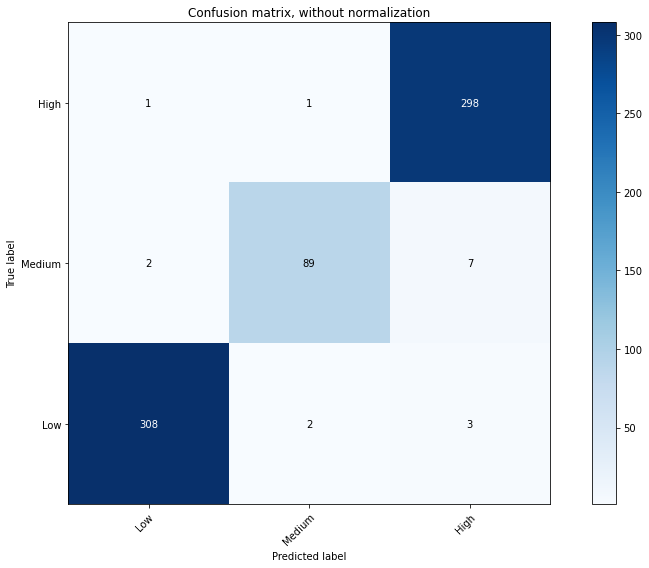


Save model to C:\Users\tirumva2\Realtime-Action-Recognition-Ag-OMS//model/trained_classifier.pickle


In [8]:
#!/usr/bin/env python
# coding: utf-8

''' This script does:
1. Load features and labels from csv files
2. Train the model
3. Save the model to `model/` folder.
'''

import numpy as np
import time
import pickle
import matplotlib.pyplot as plt
import sklearn.model_selection
from sklearn.metrics import classification_report

if True:  # Include project path
    import sys
    import os
    ROOT = os.path.dirname(os.path.abspath("__file__"))+"//"
    CURR_PATH = os.path.dirname(os.path.abspath("__file__"))+"/"
    sys.path.append(ROOT)

    import utils.lib_plot as lib_plot
    import utils.lib_commons as lib_commons
    from utils.lib_classifier import ClassifierOfflineTrain



def par(path):  # Pre-Append ROOT to the path if it's not absolute
    return ROOT + path if (path and path[0] != "/") else path

# -- Settings


cfg_all = lib_commons.read_yaml(ROOT + "config/config.yaml")
cfg = cfg_all["s4_train.py"]

CLASSES = np.array(cfg_all["classes"])


SRC_PROCESSED_FEATURES = par(cfg["input"]["processed_features"])
SRC_PROCESSED_FEATURES_LABELS = par(cfg["input"]["processed_features_labels"])

DST_MODEL_PATH = par(cfg["output"]["model_path"])

# -- Functions

def train_test_split(X, Y, ratio_of_test_size):
    ''' Split training data by ratio '''
    IS_SPLIT_BY_SKLEARN_FUNC = True

    # Use sklearn.train_test_split
    if IS_SPLIT_BY_SKLEARN_FUNC:
        RAND_SEED = 1
        tr_X, te_X, tr_Y, te_Y = sklearn.model_selection.train_test_split(
            X, Y, test_size=ratio_of_test_size, random_state=RAND_SEED)

    # Make train/test the same.
    else:
        tr_X = np.copy(X)
        tr_Y = Y.copy()
        te_X = np.copy(X)
        te_Y = Y.copy()
    return tr_X, te_X, tr_Y, te_Y

def evaluate_model(model, classes, tr_X, tr_Y, te_X, te_Y):
    ''' Evaluate accuracy and time cost '''

    # Accuracy
    t0 = time.time()

    tr_accu, tr_Y_predict = model.predict_and_evaluate(tr_X, tr_Y)
    print(f"Accuracy on training set is {tr_accu}")

    te_accu, te_Y_predict = model.predict_and_evaluate(te_X, te_Y)
    print(f"Accuracy on testing set is {te_accu}")

    print("Accuracy report:")
    print(classification_report(
        te_Y, te_Y_predict, target_names=classes, output_dict=False))

    # Time cost
    average_time = (time.time() - t0) / (len(tr_Y) + len(te_Y))
    print("Time cost for predicting one sample: "
          "{:.5f} seconds".format(average_time))

    # Plot accuracy
    axis, cf = lib_plot.plot_confusion_matrix(
        te_Y, te_Y_predict, classes, normalize=False, size=(12, 8))
    plt.show()



# -- Main


def main():

    # -- Load preprocessed data
    print("\nReading csv files of classes, features, and labels ...")
    X = np.loadtxt(SRC_PROCESSED_FEATURES, dtype=float)  # features
    Y = np.loadtxt(SRC_PROCESSED_FEATURES_LABELS, dtype=int)  # labels
    
    # -- Train-test split
    tr_X, te_X, tr_Y, te_Y = train_test_split(
        X, Y, ratio_of_test_size=0.3)
    print("\nAfter train-test split:")
    print("Size of training data X:    ", tr_X.shape)
    print("Number of training samples: ", len(tr_Y))
    print("Number of testing samples:  ", len(te_Y))

    # -- Train the model
    print("\nStart training model ...")
    model = ClassifierOfflineTrain()
    model.train(tr_X, tr_Y)

    # -- Evaluate model
    print("\nStart evaluating model ...")
    evaluate_model(model, CLASSES, tr_X, tr_Y, te_X, te_Y)

    # -- Save model
    print("\nSave model to " + DST_MODEL_PATH)
    with open(DST_MODEL_PATH, 'wb') as f:
        pickle.dump(model, f)


if __name__ == "__main__":
    main()


# s5_test.py

In [1]:
#!/usr/bin/env python
# coding: utf-8

'''
Test action recognition on
(1) a video, (2) a folder of images, (3) or web camera.

Input:
    model: model/trained_classifier.pickle

Output:
    result video:    output/${video_name}/video.avi
    result skeleton: output/${video_name}/skeleton_res/XXXXX.txt
    visualization by cv2.imshow() in img_displayer
'''

'''
Example of usage:

(1) Test on video file:
python src/s5_test.py \
    --model_path model/trained_classifier.pickle \
    --data_type video \
    --data_path data_test/exercise.avi \
    --output_folder output
    
(2) Test on a folder of images:
python src/s5_test.py \
    --model_path model/trained_classifier.pickle \
    --data_type folder \
    --data_path data_test/apple/ \
    --output_folder output

(3) Test on web camera:
python src/s5_test.py \
    --model_path model/trained_classifier.pickle \
    --data_type webcam \
    --data_path 0 \
    --output_folder output
    
'''

import tensorflow as tf
import numpy as np
import cv2
import argparse
import serial

#Creating our Arduino serial object
ArduinoSerial = serial.Serial('COM50', 9600)

if True:  # Include project path
    import sys
    import os
    ROOT = os.path.dirname(os.path.abspath("__file__"))+"/../"
    CURR_PATH = os.path.dirname(os.path.abspath("__file__"))+"/"
    sys.path.append(ROOT)

    import utils.lib_images_io as lib_images_io
    import utils.lib_plot as lib_plot
    import utils.lib_commons as lib_commons
    from utils.lib_openpose import SkeletonDetector
    from utils.lib_tracker import Tracker
    from utils.lib_tracker import Tracker
    from utils.lib_classifier import ClassifierOnlineTest
    from utils.lib_classifier import *  # Import all sklearn related libraries


def par(path):  # Pre-Append ROOT to the path if it's not absolute
    return ROOT + path if (path and path[0] != "/") else path


# -- Command-line input


def get_command_line_arguments():

    def parse_args():
        parser = argparse.ArgumentParser(
            description="Test action recognition on \n"
            "(1) a video, (2) a folder of images, (3) or web camera.")
        parser.add_argument("-m", "--model_path", required=False,
                            default='model/trained_classifier.pickle')
        parser.add_argument("-t", "--data_type", required=False, default='video',
                            choices=["video", "folder", "webcam"])
        parser.add_argument("-p", "--data_path", required=False, default="data_test/final_test.mp4",
                            help="path to a video file, or images folder, or webcam. \n"
                            "For video and folder, the path should be "
                            "absolute or relative to this project's root. "
                            "For webcam, either input an index or device name. ")
        parser.add_argument("-o", "--output_folder", required=False, default='output/',
                            help="Which folder to save result to.")

        #args = parser.parse_args()
        args, unknown = parser.parse_known_args()
        return args
    args = parse_args()
    if args.data_type != "webcam" and args.data_path and args.data_path[0] != "/":
        # If the path is not absolute, then its relative to the ROOT.
        args.data_path = ROOT + args.data_path
    return args


def get_dst_folder_name(src_data_type, src_data_path):
    ''' Compute a output folder name based on data_type and data_path.
        The final output of this script looks like this:
            DST_FOLDER/folder_name/vidoe.avi
            DST_FOLDER/folder_name/skeletons/XXXXX.txt
    '''

    assert(src_data_type in ["video", "folder", "webcam"])

    if src_data_type == "video":  # /root/data/video.avi --> video
        folder_name = os.path.basename(src_data_path).split(".")[-2]

    elif src_data_type == "folder":  # /root/data/video/ --> video
        folder_name = src_data_path.rstrip("/").split("/")[-1]

    elif src_data_type == "webcam":
        # month-day-hour-minute-seconds, e.g.: 02-26-15-51-12
        folder_name = lib_commons.get_time_string()

    return folder_name


args = get_command_line_arguments()

SRC_DATA_TYPE = args.data_type
SRC_DATA_PATH = args.data_path
SRC_MODEL_PATH = args.model_path

DST_FOLDER_NAME = get_dst_folder_name(SRC_DATA_TYPE, SRC_DATA_PATH)

# -- Settings

cfg_all = lib_commons.read_yaml(ROOT + "config/config.yaml")
cfg = cfg_all["s5_test.py"]

CLASSES = np.array(cfg_all["classes"])
SKELETON_FILENAME_FORMAT = cfg_all["skeleton_filename_format"]

# Action recognition: number of frames used to extract features.
WINDOW_SIZE = int(cfg_all["features"]["window_size"])

# Output folder
DST_FOLDER = args.output_folder + "/" + DST_FOLDER_NAME + "/"
DST_SKELETON_FOLDER_NAME = cfg["output"]["skeleton_folder_name"]
DST_VIDEO_NAME = cfg["output"]["video_name"]
# framerate of output video.avi
DST_VIDEO_FPS = float(cfg["output"]["video_fps"])


# Video setttings

# If data_type is webcam, set the max frame rate.
SRC_WEBCAM_MAX_FPS = float(cfg["settings"]["source"]
                           ["webcam_max_framerate"])

# If data_type is video, set the sampling interval.
# For example, if it's 3, then the video will be read 3 times faster.
SRC_VIDEO_SAMPLE_INTERVAL = int(cfg["settings"]["source"]
                                ["video_sample_interval"])

# Openpose settings
OPENPOSE_MODEL = cfg["settings"]["openpose"]["model"]
OPENPOSE_IMG_SIZE = cfg["settings"]["openpose"]["img_size"]

# Display settings
img_disp_desired_rows = int(cfg["settings"]["display"]["desired_rows"])


# -- Function


def select_images_loader(src_data_type, src_data_path):
    if src_data_type == "video":
        images_loader = lib_images_io.ReadFromVideo(
            src_data_path,
            sample_interval=SRC_VIDEO_SAMPLE_INTERVAL)

    elif src_data_type == "folder":
        images_loader = lib_images_io.ReadFromFolder(
            folder_path=src_data_path)

    elif src_data_type == "webcam":
        if src_data_path == "":
            webcam_idx = 0
        elif src_data_path.isdigit():
            webcam_idx = int(src_data_path)
        else:
            webcam_idx = src_data_path
        images_loader = lib_images_io.ReadFromWebcam(
            SRC_WEBCAM_MAX_FPS, webcam_idx)
    return images_loader


class MultiPersonClassifier(object):
    ''' This is a wrapper around ClassifierOnlineTest
        for recognizing actions of multiple people.
    '''

    def __init__(self, model_path, classes):

        self.dict_id2clf = {}  # human id -> classifier of this person

        # Define a function for creating classifier for new people.
        self._create_classifier = lambda human_id: ClassifierOnlineTest(
            model_path, classes, WINDOW_SIZE, human_id)

    def classify(self, dict_id2skeleton):
        ''' Classify the action type of each skeleton in dict_id2skeleton '''

        # Clear people not in view
        old_ids = set(self.dict_id2clf)
        cur_ids = set(dict_id2skeleton)
        humans_not_in_view = list(old_ids - cur_ids)
        for human in humans_not_in_view:
            del self.dict_id2clf[human]

        # Predict each person's action
        id2label = {}
        for id, skeleton in dict_id2skeleton.items():

            if id not in self.dict_id2clf:  # add this new person
                self.dict_id2clf[id] = self._create_classifier(id)

            classifier = self.dict_id2clf[id]
            id2label[id] = classifier.predict(skeleton)  # predict label
            # print("\n\nPredicting label for human{}".format(id))
            # print("  skeleton: {}".format(skeleton))
            # print("  label: {}".format(id2label[id]))

        return id2label

    def get_classifier(self, id):
        ''' Get the classifier based on the person id.
        Arguments:
            id {int or "min"}
        '''
        if len(self.dict_id2clf) == 0:
            return None
        if id == 'min':
            id = min(self.dict_id2clf.keys())
        return self.dict_id2clf[id]


def remove_skeletons_with_few_joints(skeletons):
    ''' Remove bad skeletons before sending to the tracker '''
    good_skeletons = []
    for skeleton in skeletons:
        px = skeleton[2:2+13*2:2]
        py = skeleton[3:2+13*2:2]
        num_valid_joints = len([x for x in px if x != 0])
        num_leg_joints = len([x for x in px[-6:] if x != 0])
        total_size = max(py) - min(py)
        # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        # IF JOINTS ARE MISSING, TRY CHANGING THESE VALUES:
        # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        if num_valid_joints >= 5 and total_size >= 0.1 and num_leg_joints >= 0:
            # add this skeleton only when all requirements are satisfied
            good_skeletons.append(skeleton)
    return good_skeletons


def draw_result_img(img_disp, ith_img, humans, dict_id2skeleton,
                    skeleton_detector, multiperson_classifier):
    ''' Draw skeletons, labels, and prediction scores onto image for display '''

    # Resize to a proper size for display
    r, c = img_disp.shape[0:2]
    desired_cols = int(1.0 * c * (img_disp_desired_rows / r))
    img_disp = cv2.resize(img_disp,
                          dsize=(desired_cols, img_disp_desired_rows))

    # Draw all people's skeleton
    skeleton_detector.draw(img_disp, humans)

    # Draw bounding box and label of each person
    if len(dict_id2skeleton):
        for id, label in dict_id2label.items():
            skeleton = dict_id2skeleton[id]
            # scale the y data back to original
            skeleton[1::2] = skeleton[1::2] / scale_h
            # print("Drawing skeleton: ", dict_id2skeleton[id], "with label:", label, ".")
            lib_plot.draw_action_result(img_disp, id, skeleton, label)

    # Add blank to the left for displaying prediction scores of each class
    img_disp = lib_plot.add_white_region_to_left_of_image(img_disp)

    cv2.putText(img_disp, "Frame:" + str(ith_img),
                (20, 20), fontScale=1.5, fontFace=cv2.FONT_HERSHEY_PLAIN,
                color=(0, 0, 0), thickness=2)

    # Draw predicting score for only 1 person
    if len(dict_id2skeleton):
        classifier_of_a_person = multiperson_classifier.get_classifier(
            id='min')
        classifier_of_a_person.draw_scores_onto_image(img_disp)
    return img_disp


def get_the_skeleton_data_to_save_to_disk(dict_id2skeleton):
    '''
    In each image, for each skeleton, save the:
        human_id, label, and the skeleton positions of length 18*2.
    So the total length per row is 2+36=38
    '''
    skels_to_save = []
    for human_id in dict_id2skeleton.keys():
        label = dict_id2label[human_id]
        skeleton = dict_id2skeleton[human_id]
        skels_to_save.append([[human_id, label] + skeleton.tolist()])
    return skels_to_save


# -- Main
if __name__ == "__main__":

    # -- Detector, tracker, classifier

    skeleton_detector = SkeletonDetector(OPENPOSE_MODEL, OPENPOSE_IMG_SIZE)

    multiperson_tracker = Tracker()

    multiperson_classifier = MultiPersonClassifier(SRC_MODEL_PATH, CLASSES)

    # -- Image reader and displayer
    images_loader = select_images_loader(SRC_DATA_TYPE, SRC_DATA_PATH)
    img_displayer = lib_images_io.ImageDisplayer()

    # -- Init output

    # output folder
    os.makedirs(DST_FOLDER, exist_ok=True)
    os.makedirs(DST_FOLDER + DST_SKELETON_FOLDER_NAME, exist_ok=True)

    # video writer
    video_writer = lib_images_io.VideoWriter(
        DST_FOLDER + DST_VIDEO_NAME, DST_VIDEO_FPS)

    # -- Read images and process
    try:
        ith_img = -1
        while images_loader.has_image():

            # -- Read image
            img = images_loader.read_image()
            ith_img += 1
            img_disp = img.copy()
            print(f"\nProcessing {ith_img}th image ...")

            # -- Detect skeletons
            humans = skeleton_detector.detect(img)
            skeletons, scale_h = skeleton_detector.humans_to_skels_list(humans)
            skeletons = remove_skeletons_with_few_joints(skeletons)

            # -- Track people
            dict_id2skeleton = multiperson_tracker.track(
                skeletons)  # int id -> np.array() skeleton

            # -- Recognize action of each person
            if len(dict_id2skeleton):
                dict_id2label = multiperson_classifier.classify(
                    dict_id2skeleton)

            # -- Draw
            img_disp = draw_result_img(img_disp, ith_img, humans, dict_id2skeleton,
                                       skeleton_detector, multiperson_classifier)

            # Print label of a person
            if len(dict_id2skeleton):
                min_id = min(dict_id2skeleton.keys())
                print("prediced label is :", dict_id2label[min_id])
                
            # Sending a signal to Arduino
            if dict_id2label[min_id] == "Medium":
                ArduinoSerial.write(b'L')   # send the pyte string 'L'
            if dict_id2label[min_id] == "High":
                ArduinoSerial.write(b'H')
            if dict_id2label[min_id] == "Low":
                ArduinoSerial.write(b'K')
            #else:
                #ArduinoSerial.write(b'K')   # send the pyte string 'K'

            # -- Display image, and write to video.avi
            img_displayer.display(img_disp, wait_key_ms=1)
            video_writer.write(img_disp)

            # -- Get skeleton data and save to file
            skels_to_save = get_the_skeleton_data_to_save_to_disk(
                dict_id2skeleton)
            lib_commons.save_listlist(
                DST_FOLDER + DST_SKELETON_FOLDER_NAME +
                SKELETON_FILENAME_FORMAT.format(ith_img),
                skels_to_save)
    finally:
        video_writer.stop()
        print("Program ends")


C:\Users\tirumva2\.conda\envs\tf-115\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\tirumva2\.conda\envs\tf-115\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\tirumva2\.conda\envs\tf-115\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
  stacklevel=1)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.





[2022-02-10 10:11:58,560] [TfPoseEstimator] [INFO] loading graph from C:\Users\tirumva2\.conda\envs\tf-115\lib\site-packages\tf_pose_data\graph/mobilenet_thin/graph_opt.pb(default size=656x368)






TfPoseEstimator/MobilenetV1/Conv2d_0/weights
TfPoseEstimator/image
TfPoseEstimator/MobilenetV1/Conv2d_0/Conv2D
TfPoseEstimator/MobilenetV1/Conv2d_0/Conv2D_bn_offset
TfPoseEstimator/MobilenetV1/Conv2d_0/BatchNorm/FusedBatchNorm
TfPoseEstimator/MobilenetV1/Conv2d_0/Relu
TfPoseEstimator/MobilenetV1/Conv2d_1_depthwise/depthwise_weights
TfPoseEstimator/MobilenetV1/Conv2d_1_pointwise/weights
TfPoseEstimator/MobilenetV1/Conv2d_1_depthwise/depthwise
TfPoseEstimator/MobilenetV1/Conv2d_1_pointwise/Conv2D
TfPoseEstimator/MobilenetV1/Conv2d_1_pointwise/Conv2D_bn_offset
TfPoseEstimator/MobilenetV1/Conv2d_1_pointwise/BatchNorm/FusedBatchNorm
TfPoseEstimator/MobilenetV1/Conv2d_1_pointwise/Relu
TfPoseEstimator/MobilenetV1/Conv2d_2_depthwise/depthwise_weights
TfPoseEstimator/MobilenetV1/Conv2d_2_pointwise/weights
TfPoseEstimator/MobilenetV1/Conv2d_2_depthwise/depthwise
TfPoseEstimator/MobilenetV1/Conv2d_2_pointwise/Conv2D
TfPoseEstimator/MobilenetV1/Conv2d_2_pointwise/Conv2D_bn_offset
TfPoseEstimat



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where





[2022-02-10 10:12:00,121] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:00,121] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Processing 0th image ...


[2022-02-10 10:12:00,385] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:00,385] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:00,394] [TfPoseEstimator] [DEBUG] estimate time=0.00942
[2022-02-10 10:12:00,394] [TfPoseEstimator] [DEBUG] estimate time=0.00942
[2022-02-10 10:12:00,395] [TfPoseEstimator] [INFO] inference image in 0.2740 seconds.
[2022-02-10 10:12:00,395] [TfPoseEstimator] [INFO] inference image in 0.2740 seconds.
[2022-02-10 10:12:00,418] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:00,418] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


prediced label is : 

Processing 1th image ...


[2022-02-10 10:12:00,661] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:00,661] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:00,670] [TfPoseEstimator] [DEBUG] estimate time=0.00871
[2022-02-10 10:12:00,670] [TfPoseEstimator] [DEBUG] estimate time=0.00871
[2022-02-10 10:12:00,671] [TfPoseEstimator] [INFO] inference image in 0.2524 seconds.
[2022-02-10 10:12:00,671] [TfPoseEstimator] [INFO] inference image in 0.2524 seconds.
[2022-02-10 10:12:00,700] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:00,700] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


prediced label is : 

Processing 2th image ...


[2022-02-10 10:12:00,961] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:00,961] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:00,965] [TfPoseEstimator] [DEBUG] estimate time=0.00330
[2022-02-10 10:12:00,965] [TfPoseEstimator] [DEBUG] estimate time=0.00330
[2022-02-10 10:12:00,966] [TfPoseEstimator] [INFO] inference image in 0.2650 seconds.
[2022-02-10 10:12:00,966] [TfPoseEstimator] [INFO] inference image in 0.2650 seconds.
[2022-02-10 10:12:00,982] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:00,982] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


prediced label is : 

Processing 3th image ...


[2022-02-10 10:12:01,235] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:01,235] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:01,244] [TfPoseEstimator] [DEBUG] estimate time=0.00855
[2022-02-10 10:12:01,244] [TfPoseEstimator] [DEBUG] estimate time=0.00855
[2022-02-10 10:12:01,245] [TfPoseEstimator] [INFO] inference image in 0.2623 seconds.
[2022-02-10 10:12:01,245] [TfPoseEstimator] [INFO] inference image in 0.2623 seconds.
[2022-02-10 10:12:01,258] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:01,258] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


prediced label is : 

Processing 4th image ...


[2022-02-10 10:12:01,505] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:01,505] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:01,513] [TfPoseEstimator] [DEBUG] estimate time=0.00822
[2022-02-10 10:12:01,513] [TfPoseEstimator] [DEBUG] estimate time=0.00822
[2022-02-10 10:12:01,514] [TfPoseEstimator] [INFO] inference image in 0.2567 seconds.
[2022-02-10 10:12:01,514] [TfPoseEstimator] [INFO] inference image in 0.2567 seconds.
[2022-02-10 10:12:01,558] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:01,558] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [8.31606630e-09 4.75207582e-02 9.52479233e-01]
prediced label is : High

Processing 5th image ...


[2022-02-10 10:12:01,832] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:01,832] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:01,840] [TfPoseEstimator] [DEBUG] estimate time=0.00774
[2022-02-10 10:12:01,840] [TfPoseEstimator] [DEBUG] estimate time=0.00774
[2022-02-10 10:12:01,841] [TfPoseEstimator] [INFO] inference image in 0.2828 seconds.
[2022-02-10 10:12:01,841] [TfPoseEstimator] [INFO] inference image in 0.2828 seconds.
[2022-02-10 10:12:01,885] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:01,885] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [1.92788346e-06 5.23678480e-01 4.76319592e-01]
prediced label is : Medium

Processing 6th image ...


[2022-02-10 10:12:02,170] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:02,170] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:02,175] [TfPoseEstimator] [DEBUG] estimate time=0.00524
[2022-02-10 10:12:02,175] [TfPoseEstimator] [DEBUG] estimate time=0.00524
[2022-02-10 10:12:02,176] [TfPoseEstimator] [INFO] inference image in 0.2914 seconds.
[2022-02-10 10:12:02,176] [TfPoseEstimator] [INFO] inference image in 0.2914 seconds.
[2022-02-10 10:12:02,191] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:02,191] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [2.49625202e-06 9.99430928e-01 5.66575900e-04]
prediced label is : Medium

Processing 7th image ...


[2022-02-10 10:12:02,449] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:02,449] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:02,451] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2022-02-10 10:12:02,451] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2022-02-10 10:12:02,453] [TfPoseEstimator] [INFO] inference image in 0.2617 seconds.
[2022-02-10 10:12:02,453] [TfPoseEstimator] [INFO] inference image in 0.2617 seconds.
[2022-02-10 10:12:02,477] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:02,477] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [7.82503516e-07 9.99493969e-01 5.05248333e-04]
prediced label is : Medium

Processing 8th image ...


[2022-02-10 10:12:02,734] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:02,734] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:02,737] [TfPoseEstimator] [DEBUG] estimate time=0.00231
[2022-02-10 10:12:02,737] [TfPoseEstimator] [DEBUG] estimate time=0.00231
[2022-02-10 10:12:02,738] [TfPoseEstimator] [INFO] inference image in 0.2608 seconds.
[2022-02-10 10:12:02,738] [TfPoseEstimator] [INFO] inference image in 0.2608 seconds.
[2022-02-10 10:12:02,767] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:02,767] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [3.06225187e-07 9.99977777e-01 2.19164043e-05]
prediced label is : Medium

Processing 9th image ...


[2022-02-10 10:12:03,033] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:03,033] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:03,038] [TfPoseEstimator] [DEBUG] estimate time=0.00480
[2022-02-10 10:12:03,038] [TfPoseEstimator] [DEBUG] estimate time=0.00480
[2022-02-10 10:12:03,039] [TfPoseEstimator] [INFO] inference image in 0.2722 seconds.
[2022-02-10 10:12:03,039] [TfPoseEstimator] [INFO] inference image in 0.2722 seconds.
[2022-02-10 10:12:03,054] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:03,054] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [1.05475467e-07 9.99995593e-01 4.30130110e-06]
prediced label is : Medium

Processing 10th image ...


[2022-02-10 10:12:03,296] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:03,296] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:03,307] [TfPoseEstimator] [DEBUG] estimate time=0.01074
[2022-02-10 10:12:03,307] [TfPoseEstimator] [DEBUG] estimate time=0.01074
[2022-02-10 10:12:03,308] [TfPoseEstimator] [INFO] inference image in 0.2540 seconds.
[2022-02-10 10:12:03,308] [TfPoseEstimator] [INFO] inference image in 0.2540 seconds.
[2022-02-10 10:12:03,340] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:03,340] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [1.30400890e-05 9.99983978e-01 2.98219205e-06]
prediced label is : Medium

Processing 11th image ...


[2022-02-10 10:12:03,646] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:03,646] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:03,652] [TfPoseEstimator] [DEBUG] estimate time=0.00520
[2022-02-10 10:12:03,652] [TfPoseEstimator] [DEBUG] estimate time=0.00520
[2022-02-10 10:12:03,653] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2022-02-10 10:12:03,653] [TfPoseEstimator] [INFO] inference image in 0.3126 seconds.
[2022-02-10 10:12:03,670] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:03,670] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [2.34706483e-05 9.99973501e-01 3.02854538e-06]
prediced label is : Medium

Processing 12th image ...


[2022-02-10 10:12:03,914] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:03,914] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:03,923] [TfPoseEstimator] [DEBUG] estimate time=0.00917
[2022-02-10 10:12:03,923] [TfPoseEstimator] [DEBUG] estimate time=0.00917
[2022-02-10 10:12:03,924] [TfPoseEstimator] [INFO] inference image in 0.2549 seconds.
[2022-02-10 10:12:03,924] [TfPoseEstimator] [INFO] inference image in 0.2549 seconds.
[2022-02-10 10:12:03,964] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:03,964] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [1.49481034e-05 9.99750003e-01 2.35048939e-04]
prediced label is : Medium

Processing 13th image ...


[2022-02-10 10:12:04,238] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:04,238] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:04,244] [TfPoseEstimator] [DEBUG] estimate time=0.00592
[2022-02-10 10:12:04,244] [TfPoseEstimator] [DEBUG] estimate time=0.00592
[2022-02-10 10:12:04,245] [TfPoseEstimator] [INFO] inference image in 0.2805 seconds.
[2022-02-10 10:12:04,245] [TfPoseEstimator] [INFO] inference image in 0.2805 seconds.
[2022-02-10 10:12:04,266] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:04,266] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [1.09929529e-05 9.91362952e-01 8.62605456e-03]
prediced label is : Medium

Processing 14th image ...


[2022-02-10 10:12:04,515] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:04,515] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:04,520] [TfPoseEstimator] [DEBUG] estimate time=0.00471
[2022-02-10 10:12:04,520] [TfPoseEstimator] [DEBUG] estimate time=0.00471
[2022-02-10 10:12:04,521] [TfPoseEstimator] [INFO] inference image in 0.2547 seconds.
[2022-02-10 10:12:04,521] [TfPoseEstimator] [INFO] inference image in 0.2547 seconds.
[2022-02-10 10:12:04,546] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:04,546] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [6.81641195e-06 9.91563412e-01 8.42977170e-03]
prediced label is : Medium

Processing 15th image ...


[2022-02-10 10:12:04,792] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:04,792] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:04,803] [TfPoseEstimator] [DEBUG] estimate time=0.00139
[2022-02-10 10:12:04,803] [TfPoseEstimator] [DEBUG] estimate time=0.00139
[2022-02-10 10:12:04,804] [TfPoseEstimator] [INFO] inference image in 0.2585 seconds.
[2022-02-10 10:12:04,804] [TfPoseEstimator] [INFO] inference image in 0.2585 seconds.
[2022-02-10 10:12:04,839] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:04,839] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [2.44396439e-06 9.99841951e-01 1.55605173e-04]
prediced label is : Medium

Processing 16th image ...


[2022-02-10 10:12:05,109] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:05,109] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:05,118] [TfPoseEstimator] [DEBUG] estimate time=0.00873
[2022-02-10 10:12:05,118] [TfPoseEstimator] [DEBUG] estimate time=0.00873
[2022-02-10 10:12:05,119] [TfPoseEstimator] [INFO] inference image in 0.2795 seconds.
[2022-02-10 10:12:05,119] [TfPoseEstimator] [INFO] inference image in 0.2795 seconds.
[2022-02-10 10:12:05,166] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:05,166] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [2.47171645e-06 9.99761888e-01 2.35640466e-04]
prediced label is : Medium

Processing 17th image ...


[2022-02-10 10:12:05,429] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:05,429] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:05,437] [TfPoseEstimator] [DEBUG] estimate time=0.00748
[2022-02-10 10:12:05,437] [TfPoseEstimator] [DEBUG] estimate time=0.00748
[2022-02-10 10:12:05,438] [TfPoseEstimator] [INFO] inference image in 0.2721 seconds.
[2022-02-10 10:12:05,438] [TfPoseEstimator] [INFO] inference image in 0.2721 seconds.
[2022-02-10 10:12:05,467] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:05,467] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [9.16962445e-07 9.99864071e-01 1.35012252e-04]
prediced label is : Medium

Processing 18th image ...


[2022-02-10 10:12:05,717] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:05,717] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:05,728] [TfPoseEstimator] [DEBUG] estimate time=0.01118
[2022-02-10 10:12:05,728] [TfPoseEstimator] [DEBUG] estimate time=0.01118
[2022-02-10 10:12:05,729] [TfPoseEstimator] [INFO] inference image in 0.2622 seconds.
[2022-02-10 10:12:05,729] [TfPoseEstimator] [INFO] inference image in 0.2622 seconds.
[2022-02-10 10:12:05,749] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:05,749] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [5.84491287e-07 9.99880341e-01 1.19074475e-04]
prediced label is : Medium

Processing 19th image ...


[2022-02-10 10:12:05,990] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:05,990] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:05,999] [TfPoseEstimator] [DEBUG] estimate time=0.00904
[2022-02-10 10:12:05,999] [TfPoseEstimator] [DEBUG] estimate time=0.00904
[2022-02-10 10:12:06,000] [TfPoseEstimator] [INFO] inference image in 0.2506 seconds.
[2022-02-10 10:12:06,000] [TfPoseEstimator] [INFO] inference image in 0.2506 seconds.
[2022-02-10 10:12:06,038] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:06,038] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [2.03983162e-07 9.99814758e-01 1.85037585e-04]
prediced label is : Medium

Processing 20th image ...


[2022-02-10 10:12:06,315] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:06,315] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:06,323] [TfPoseEstimator] [DEBUG] estimate time=0.00830
[2022-02-10 10:12:06,323] [TfPoseEstimator] [DEBUG] estimate time=0.00830
[2022-02-10 10:12:06,324] [TfPoseEstimator] [INFO] inference image in 0.2865 seconds.
[2022-02-10 10:12:06,324] [TfPoseEstimator] [INFO] inference image in 0.2865 seconds.
[2022-02-10 10:12:06,352] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:06,352] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [2.80782661e-07 9.99878489e-01 1.21230408e-04]
prediced label is : Medium

Processing 21th image ...


[2022-02-10 10:12:06,613] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:06,613] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:06,617] [TfPoseEstimator] [DEBUG] estimate time=0.00415
[2022-02-10 10:12:06,617] [TfPoseEstimator] [DEBUG] estimate time=0.00415
[2022-02-10 10:12:06,618] [TfPoseEstimator] [INFO] inference image in 0.2656 seconds.
[2022-02-10 10:12:06,618] [TfPoseEstimator] [INFO] inference image in 0.2656 seconds.
[2022-02-10 10:12:06,634] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:06,634] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [2.43325804e-07 9.99788643e-01 2.11113651e-04]
prediced label is : Medium

Processing 22th image ...


[2022-02-10 10:12:06,894] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:06,894] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:06,902] [TfPoseEstimator] [DEBUG] estimate time=0.00775
[2022-02-10 10:12:06,902] [TfPoseEstimator] [DEBUG] estimate time=0.00775
[2022-02-10 10:12:06,903] [TfPoseEstimator] [INFO] inference image in 0.2686 seconds.
[2022-02-10 10:12:06,903] [TfPoseEstimator] [INFO] inference image in 0.2686 seconds.
[2022-02-10 10:12:06,933] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:06,933] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [2.09894442e-07 9.99803121e-01 1.96668880e-04]
prediced label is : Medium

Processing 23th image ...


[2022-02-10 10:12:07,197] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:07,197] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:07,203] [TfPoseEstimator] [DEBUG] estimate time=0.00601
[2022-02-10 10:12:07,203] [TfPoseEstimator] [DEBUG] estimate time=0.00601
[2022-02-10 10:12:07,204] [TfPoseEstimator] [INFO] inference image in 0.2719 seconds.
[2022-02-10 10:12:07,204] [TfPoseEstimator] [INFO] inference image in 0.2719 seconds.
[2022-02-10 10:12:07,234] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:07,234] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [1.52348212e-07 9.99820772e-01 1.79075257e-04]
prediced label is : Medium

Processing 24th image ...


[2022-02-10 10:12:07,485] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:07,485] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:07,490] [TfPoseEstimator] [DEBUG] estimate time=0.00444
[2022-02-10 10:12:07,490] [TfPoseEstimator] [DEBUG] estimate time=0.00444
[2022-02-10 10:12:07,491] [TfPoseEstimator] [INFO] inference image in 0.2572 seconds.
[2022-02-10 10:12:07,491] [TfPoseEstimator] [INFO] inference image in 0.2572 seconds.
[2022-02-10 10:12:07,517] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:07,517] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [5.60395137e-07 9.99798471e-01 2.00968985e-04]
prediced label is : Medium

Processing 25th image ...


[2022-02-10 10:12:07,768] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:07,768] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:07,777] [TfPoseEstimator] [DEBUG] estimate time=0.00853
[2022-02-10 10:12:07,777] [TfPoseEstimator] [DEBUG] estimate time=0.00853
[2022-02-10 10:12:07,778] [TfPoseEstimator] [INFO] inference image in 0.2605 seconds.
[2022-02-10 10:12:07,778] [TfPoseEstimator] [INFO] inference image in 0.2605 seconds.
[2022-02-10 10:12:07,819] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:07,819] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [6.07838184e-07 9.99941661e-01 5.77312370e-05]
prediced label is : Medium

Processing 26th image ...


[2022-02-10 10:12:08,084] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:08,084] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:08,094] [TfPoseEstimator] [DEBUG] estimate time=0.01012
[2022-02-10 10:12:08,094] [TfPoseEstimator] [DEBUG] estimate time=0.01012
[2022-02-10 10:12:08,095] [TfPoseEstimator] [INFO] inference image in 0.2761 seconds.
[2022-02-10 10:12:08,095] [TfPoseEstimator] [INFO] inference image in 0.2761 seconds.
[2022-02-10 10:12:08,116] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:08,116] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [1.29366457e-07 9.99987566e-01 1.23048872e-05]
prediced label is : Medium

Processing 27th image ...


[2022-02-10 10:12:08,362] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:08,362] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:08,365] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2022-02-10 10:12:08,365] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2022-02-10 10:12:08,366] [TfPoseEstimator] [INFO] inference image in 0.2498 seconds.
[2022-02-10 10:12:08,366] [TfPoseEstimator] [INFO] inference image in 0.2498 seconds.
[2022-02-10 10:12:08,381] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:08,381] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


prediced label is : 

Processing 28th image ...


[2022-02-10 10:12:08,645] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:08,645] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:08,648] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2022-02-10 10:12:08,648] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2022-02-10 10:12:08,649] [TfPoseEstimator] [INFO] inference image in 0.2682 seconds.
[2022-02-10 10:12:08,649] [TfPoseEstimator] [INFO] inference image in 0.2682 seconds.
[2022-02-10 10:12:08,670] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:08,670] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


prediced label is : 

Processing 29th image ...


[2022-02-10 10:12:08,926] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:08,926] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:08,931] [TfPoseEstimator] [DEBUG] estimate time=0.00525
[2022-02-10 10:12:08,931] [TfPoseEstimator] [DEBUG] estimate time=0.00525
[2022-02-10 10:12:08,932] [TfPoseEstimator] [INFO] inference image in 0.2617 seconds.
[2022-02-10 10:12:08,932] [TfPoseEstimator] [INFO] inference image in 0.2617 seconds.
[2022-02-10 10:12:08,961] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:08,961] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


prediced label is : 

Processing 30th image ...


[2022-02-10 10:12:09,213] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:09,213] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:09,223] [TfPoseEstimator] [DEBUG] estimate time=0.01013
[2022-02-10 10:12:09,223] [TfPoseEstimator] [DEBUG] estimate time=0.01013
[2022-02-10 10:12:09,224] [TfPoseEstimator] [INFO] inference image in 0.2628 seconds.
[2022-02-10 10:12:09,224] [TfPoseEstimator] [INFO] inference image in 0.2628 seconds.
[2022-02-10 10:12:09,246] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:09,246] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


prediced label is : 

Processing 31th image ...


[2022-02-10 10:12:09,496] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:09,496] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:09,504] [TfPoseEstimator] [DEBUG] estimate time=0.00724
[2022-02-10 10:12:09,504] [TfPoseEstimator] [DEBUG] estimate time=0.00724
[2022-02-10 10:12:09,505] [TfPoseEstimator] [INFO] inference image in 0.2587 seconds.
[2022-02-10 10:12:09,505] [TfPoseEstimator] [INFO] inference image in 0.2587 seconds.
[2022-02-10 10:12:09,518] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:09,518] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


prediced label is : 

Processing 32th image ...


[2022-02-10 10:12:09,773] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:09,773] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:09,780] [TfPoseEstimator] [DEBUG] estimate time=0.00768
[2022-02-10 10:12:09,780] [TfPoseEstimator] [DEBUG] estimate time=0.00768
[2022-02-10 10:12:09,781] [TfPoseEstimator] [INFO] inference image in 0.2628 seconds.
[2022-02-10 10:12:09,781] [TfPoseEstimator] [INFO] inference image in 0.2628 seconds.
[2022-02-10 10:12:09,824] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:09,824] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


prediced label is : 

Processing 33th image ...


[2022-02-10 10:12:10,121] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:10,121] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:10,129] [TfPoseEstimator] [DEBUG] estimate time=0.00863
[2022-02-10 10:12:10,129] [TfPoseEstimator] [DEBUG] estimate time=0.00863
[2022-02-10 10:12:10,130] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2022-02-10 10:12:10,130] [TfPoseEstimator] [INFO] inference image in 0.3062 seconds.
[2022-02-10 10:12:10,173] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:10,173] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [3.14351774e-08 9.99992408e-01 7.56018306e-06]
prediced label is : Medium

Processing 34th image ...


[2022-02-10 10:12:10,478] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:10,478] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:10,488] [TfPoseEstimator] [DEBUG] estimate time=0.00901
[2022-02-10 10:12:10,488] [TfPoseEstimator] [DEBUG] estimate time=0.00901
[2022-02-10 10:12:10,489] [TfPoseEstimator] [INFO] inference image in 0.3157 seconds.
[2022-02-10 10:12:10,489] [TfPoseEstimator] [INFO] inference image in 0.3157 seconds.
[2022-02-10 10:12:10,531] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:10,531] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [1.76602995e-08 9.99995825e-01 4.15701807e-06]
prediced label is : Medium

Processing 35th image ...


[2022-02-10 10:12:10,810] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:10,810] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:10,813] [TfPoseEstimator] [DEBUG] estimate time=0.00221
[2022-02-10 10:12:10,813] [TfPoseEstimator] [DEBUG] estimate time=0.00221
[2022-02-10 10:12:10,814] [TfPoseEstimator] [INFO] inference image in 0.2822 seconds.
[2022-02-10 10:12:10,814] [TfPoseEstimator] [INFO] inference image in 0.2822 seconds.
[2022-02-10 10:12:10,840] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:10,840] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [3.87000809e-06 9.99993701e-01 2.42872463e-06]
prediced label is : Medium

Processing 36th image ...


[2022-02-10 10:12:11,104] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:11,104] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:11,108] [TfPoseEstimator] [DEBUG] estimate time=0.00353
[2022-02-10 10:12:11,108] [TfPoseEstimator] [DEBUG] estimate time=0.00353
[2022-02-10 10:12:11,109] [TfPoseEstimator] [INFO] inference image in 0.2693 seconds.
[2022-02-10 10:12:11,109] [TfPoseEstimator] [INFO] inference image in 0.2693 seconds.
[2022-02-10 10:12:11,139] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:11,139] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [4.37030686e-06 9.99993363e-01 2.26717025e-06]
prediced label is : Medium

Processing 37th image ...


[2022-02-10 10:12:11,391] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:11,391] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:11,402] [TfPoseEstimator] [DEBUG] estimate time=0.01020
[2022-02-10 10:12:11,402] [TfPoseEstimator] [DEBUG] estimate time=0.01020
[2022-02-10 10:12:11,403] [TfPoseEstimator] [INFO] inference image in 0.2637 seconds.
[2022-02-10 10:12:11,403] [TfPoseEstimator] [INFO] inference image in 0.2637 seconds.
[2022-02-10 10:12:11,430] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:11,430] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [5.25761425e-06 9.99994212e-01 5.30416204e-07]
prediced label is : Medium

Processing 38th image ...


[2022-02-10 10:12:11,685] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:11,685] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:11,692] [TfPoseEstimator] [DEBUG] estimate time=0.00621
[2022-02-10 10:12:11,692] [TfPoseEstimator] [DEBUG] estimate time=0.00621
[2022-02-10 10:12:11,693] [TfPoseEstimator] [INFO] inference image in 0.2631 seconds.
[2022-02-10 10:12:11,693] [TfPoseEstimator] [INFO] inference image in 0.2631 seconds.
[2022-02-10 10:12:11,707] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:11,707] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [1.24653351e-05 9.99986584e-01 9.50907712e-07]
prediced label is : Medium

Processing 39th image ...


[2022-02-10 10:12:11,946] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:11,946] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:11,957] [TfPoseEstimator] [DEBUG] estimate time=0.01076
[2022-02-10 10:12:11,957] [TfPoseEstimator] [DEBUG] estimate time=0.01076
[2022-02-10 10:12:11,958] [TfPoseEstimator] [INFO] inference image in 0.2513 seconds.
[2022-02-10 10:12:11,958] [TfPoseEstimator] [INFO] inference image in 0.2513 seconds.
[2022-02-10 10:12:11,991] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:11,991] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [1.16202249e-05 9.99678388e-01 3.09992175e-04]
prediced label is : Medium

Processing 40th image ...


[2022-02-10 10:12:12,260] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:12,260] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:12,270] [TfPoseEstimator] [DEBUG] estimate time=0.01037
[2022-02-10 10:12:12,270] [TfPoseEstimator] [DEBUG] estimate time=0.01037
[2022-02-10 10:12:12,271] [TfPoseEstimator] [INFO] inference image in 0.2801 seconds.
[2022-02-10 10:12:12,271] [TfPoseEstimator] [INFO] inference image in 0.2801 seconds.
[2022-02-10 10:12:12,291] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:12,291] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [3.91391156e-06 9.99686507e-01 3.09579053e-04]
prediced label is : Medium

Processing 41th image ...


[2022-02-10 10:12:12,565] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:12,565] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:12,568] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2022-02-10 10:12:12,568] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2022-02-10 10:12:12,569] [TfPoseEstimator] [INFO] inference image in 0.2784 seconds.
[2022-02-10 10:12:12,569] [TfPoseEstimator] [INFO] inference image in 0.2784 seconds.
[2022-02-10 10:12:12,585] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:12,585] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [1.62814549e-07 9.99229949e-01 7.69887818e-04]
prediced label is : Medium

Processing 42th image ...


[2022-02-10 10:12:12,830] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:12,830] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:12,839] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2022-02-10 10:12:12,839] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2022-02-10 10:12:12,840] [TfPoseEstimator] [INFO] inference image in 0.2549 seconds.
[2022-02-10 10:12:12,840] [TfPoseEstimator] [INFO] inference image in 0.2549 seconds.
[2022-02-10 10:12:12,879] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:12,879] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [1.63651454e-07 9.99226501e-01 7.73334898e-04]
prediced label is : Medium

Processing 43th image ...


[2022-02-10 10:12:13,140] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:13,140] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:13,151] [TfPoseEstimator] [DEBUG] estimate time=0.00143
[2022-02-10 10:12:13,151] [TfPoseEstimator] [DEBUG] estimate time=0.00143
[2022-02-10 10:12:13,152] [TfPoseEstimator] [INFO] inference image in 0.2737 seconds.
[2022-02-10 10:12:13,152] [TfPoseEstimator] [INFO] inference image in 0.2737 seconds.
[2022-02-10 10:12:13,182] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:13,182] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [7.61338530e-08 9.99951114e-01 4.88096268e-05]
prediced label is : Medium

Processing 44th image ...


[2022-02-10 10:12:13,450] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:13,450] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:13,453] [TfPoseEstimator] [DEBUG] estimate time=0.00337
[2022-02-10 10:12:13,453] [TfPoseEstimator] [DEBUG] estimate time=0.00337
[2022-02-10 10:12:13,454] [TfPoseEstimator] [INFO] inference image in 0.2718 seconds.
[2022-02-10 10:12:13,454] [TfPoseEstimator] [INFO] inference image in 0.2718 seconds.
[2022-02-10 10:12:13,479] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:13,479] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [9.40987060e-07 9.99839492e-01 1.59567427e-04]
prediced label is : Medium

Processing 45th image ...


[2022-02-10 10:12:13,735] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:13,735] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:13,745] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2022-02-10 10:12:13,745] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2022-02-10 10:12:13,748] [TfPoseEstimator] [INFO] inference image in 0.2687 seconds.
[2022-02-10 10:12:13,748] [TfPoseEstimator] [INFO] inference image in 0.2687 seconds.
[2022-02-10 10:12:13,783] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:13,783] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [8.69985185e-07 9.99879367e-01 1.19763052e-04]
prediced label is : Medium

Processing 46th image ...


[2022-02-10 10:12:14,045] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:14,045] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:14,048] [TfPoseEstimator] [DEBUG] estimate time=0.00361
[2022-02-10 10:12:14,048] [TfPoseEstimator] [DEBUG] estimate time=0.00361
[2022-02-10 10:12:14,049] [TfPoseEstimator] [INFO] inference image in 0.2663 seconds.
[2022-02-10 10:12:14,049] [TfPoseEstimator] [INFO] inference image in 0.2663 seconds.
[2022-02-10 10:12:14,077] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:14,077] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [4.16063193e-08 9.72113323e-01 2.78866355e-02]
prediced label is : Medium

Processing 47th image ...


[2022-02-10 10:12:14,334] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:14,334] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:14,345] [TfPoseEstimator] [DEBUG] estimate time=0.01023
[2022-02-10 10:12:14,345] [TfPoseEstimator] [DEBUG] estimate time=0.01023
[2022-02-10 10:12:14,346] [TfPoseEstimator] [INFO] inference image in 0.2682 seconds.
[2022-02-10 10:12:14,346] [TfPoseEstimator] [INFO] inference image in 0.2682 seconds.
[2022-02-10 10:12:14,381] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:14,381] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [4.20300929e-08 9.60159294e-01 3.98406641e-02]
prediced label is : Medium

Processing 48th image ...


[2022-02-10 10:12:14,661] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:14,661] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:14,664] [TfPoseEstimator] [DEBUG] estimate time=0.00323
[2022-02-10 10:12:14,664] [TfPoseEstimator] [DEBUG] estimate time=0.00323
[2022-02-10 10:12:14,665] [TfPoseEstimator] [INFO] inference image in 0.2844 seconds.
[2022-02-10 10:12:14,665] [TfPoseEstimator] [INFO] inference image in 0.2844 seconds.
[2022-02-10 10:12:14,684] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:14,684] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [4.07477436e-08 9.87360716e-01 1.26392431e-02]
prediced label is : Medium

Processing 49th image ...


[2022-02-10 10:12:14,928] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:14,928] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:14,930] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2022-02-10 10:12:14,930] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2022-02-10 10:12:14,931] [TfPoseEstimator] [INFO] inference image in 0.2479 seconds.
[2022-02-10 10:12:14,931] [TfPoseEstimator] [INFO] inference image in 0.2479 seconds.
[2022-02-10 10:12:14,961] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:14,961] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [1.79787551e-07 9.99306560e-01 6.93260128e-04]
prediced label is : Medium

Processing 50th image ...


[2022-02-10 10:12:15,222] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:15,222] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:15,227] [TfPoseEstimator] [DEBUG] estimate time=0.00460
[2022-02-10 10:12:15,227] [TfPoseEstimator] [DEBUG] estimate time=0.00460
[2022-02-10 10:12:15,228] [TfPoseEstimator] [INFO] inference image in 0.2663 seconds.
[2022-02-10 10:12:15,228] [TfPoseEstimator] [INFO] inference image in 0.2663 seconds.
[2022-02-10 10:12:15,244] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:15,244] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [8.52017463e-07 9.99897594e-01 1.01553726e-04]
prediced label is : Medium

Processing 51th image ...


[2022-02-10 10:12:15,494] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:15,494] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:15,496] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2022-02-10 10:12:15,496] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2022-02-10 10:12:15,498] [TfPoseEstimator] [INFO] inference image in 0.2548 seconds.
[2022-02-10 10:12:15,498] [TfPoseEstimator] [INFO] inference image in 0.2548 seconds.
[2022-02-10 10:12:15,531] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:15,531] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [3.55996886e-06 8.06142251e-01 1.93854189e-01]
prediced label is : Medium

Processing 52th image ...


[2022-02-10 10:12:15,783] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:15,783] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:15,794] [TfPoseEstimator] [DEBUG] estimate time=0.00142
[2022-02-10 10:12:15,794] [TfPoseEstimator] [DEBUG] estimate time=0.00142
[2022-02-10 10:12:15,795] [TfPoseEstimator] [INFO] inference image in 0.2642 seconds.
[2022-02-10 10:12:15,795] [TfPoseEstimator] [INFO] inference image in 0.2642 seconds.
[2022-02-10 10:12:15,820] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:15,820] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [2.95230681e-06 8.04920732e-01 1.95076316e-01]
prediced label is : Medium

Processing 53th image ...


[2022-02-10 10:12:16,066] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:16,066] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:16,069] [TfPoseEstimator] [DEBUG] estimate time=0.00334
[2022-02-10 10:12:16,069] [TfPoseEstimator] [DEBUG] estimate time=0.00334
[2022-02-10 10:12:16,070] [TfPoseEstimator] [INFO] inference image in 0.2505 seconds.
[2022-02-10 10:12:16,070] [TfPoseEstimator] [INFO] inference image in 0.2505 seconds.
[2022-02-10 10:12:16,103] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:16,103] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [2.19032315e-07 9.55775483e-01 4.42242976e-02]
prediced label is : Medium

Processing 54th image ...


[2022-02-10 10:12:16,370] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:16,370] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:16,374] [TfPoseEstimator] [DEBUG] estimate time=0.00431
[2022-02-10 10:12:16,374] [TfPoseEstimator] [DEBUG] estimate time=0.00431
[2022-02-10 10:12:16,375] [TfPoseEstimator] [INFO] inference image in 0.2716 seconds.
[2022-02-10 10:12:16,375] [TfPoseEstimator] [INFO] inference image in 0.2716 seconds.
[2022-02-10 10:12:16,396] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:16,396] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


prediced label is : 

Processing 55th image ...


[2022-02-10 10:12:16,647] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:16,647] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:16,650] [TfPoseEstimator] [DEBUG] estimate time=0.00357
[2022-02-10 10:12:16,650] [TfPoseEstimator] [DEBUG] estimate time=0.00357
[2022-02-10 10:12:16,651] [TfPoseEstimator] [INFO] inference image in 0.2553 seconds.
[2022-02-10 10:12:16,651] [TfPoseEstimator] [INFO] inference image in 0.2553 seconds.
[2022-02-10 10:12:16,681] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:16,681] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


prediced label is : 

Processing 56th image ...


[2022-02-10 10:12:16,947] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:16,947] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:16,953] [TfPoseEstimator] [DEBUG] estimate time=0.00621
[2022-02-10 10:12:16,953] [TfPoseEstimator] [DEBUG] estimate time=0.00621
[2022-02-10 10:12:16,954] [TfPoseEstimator] [INFO] inference image in 0.2729 seconds.
[2022-02-10 10:12:16,954] [TfPoseEstimator] [INFO] inference image in 0.2729 seconds.
[2022-02-10 10:12:16,986] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:16,986] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


prediced label is : 

Processing 57th image ...


[2022-02-10 10:12:17,267] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:17,267] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:17,274] [TfPoseEstimator] [DEBUG] estimate time=0.00727
[2022-02-10 10:12:17,274] [TfPoseEstimator] [DEBUG] estimate time=0.00727
[2022-02-10 10:12:17,275] [TfPoseEstimator] [INFO] inference image in 0.2886 seconds.
[2022-02-10 10:12:17,275] [TfPoseEstimator] [INFO] inference image in 0.2886 seconds.
[2022-02-10 10:12:17,288] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:17,288] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Processing 58th image ...


[2022-02-10 10:12:17,539] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:17,539] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:17,542] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2022-02-10 10:12:17,542] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2022-02-10 10:12:17,543] [TfPoseEstimator] [INFO] inference image in 0.2547 seconds.
[2022-02-10 10:12:17,543] [TfPoseEstimator] [INFO] inference image in 0.2547 seconds.
[2022-02-10 10:12:17,566] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:17,566] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


prediced label is : 

Processing 59th image ...


[2022-02-10 10:12:17,818] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:17,818] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:17,828] [TfPoseEstimator] [DEBUG] estimate time=0.00976
[2022-02-10 10:12:17,828] [TfPoseEstimator] [DEBUG] estimate time=0.00976
[2022-02-10 10:12:17,829] [TfPoseEstimator] [INFO] inference image in 0.2634 seconds.
[2022-02-10 10:12:17,829] [TfPoseEstimator] [INFO] inference image in 0.2634 seconds.
[2022-02-10 10:12:17,851] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:17,851] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


prediced label is : 

Processing 60th image ...


[2022-02-10 10:12:18,095] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:18,095] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:18,099] [TfPoseEstimator] [DEBUG] estimate time=0.00450
[2022-02-10 10:12:18,099] [TfPoseEstimator] [DEBUG] estimate time=0.00450
[2022-02-10 10:12:18,100] [TfPoseEstimator] [INFO] inference image in 0.2493 seconds.
[2022-02-10 10:12:18,100] [TfPoseEstimator] [INFO] inference image in 0.2493 seconds.
[2022-02-10 10:12:18,116] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:18,116] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


prediced label is : 

Processing 61th image ...


[2022-02-10 10:12:18,362] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:18,362] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:18,370] [TfPoseEstimator] [DEBUG] estimate time=0.00770
[2022-02-10 10:12:18,370] [TfPoseEstimator] [DEBUG] estimate time=0.00770
[2022-02-10 10:12:18,371] [TfPoseEstimator] [INFO] inference image in 0.2544 seconds.
[2022-02-10 10:12:18,371] [TfPoseEstimator] [INFO] inference image in 0.2544 seconds.
[2022-02-10 10:12:18,417] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:18,417] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


prediced label is : 

Processing 62th image ...


[2022-02-10 10:12:18,672] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:18,672] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:18,681] [TfPoseEstimator] [DEBUG] estimate time=0.00820
[2022-02-10 10:12:18,681] [TfPoseEstimator] [DEBUG] estimate time=0.00820
[2022-02-10 10:12:18,682] [TfPoseEstimator] [INFO] inference image in 0.2643 seconds.
[2022-02-10 10:12:18,682] [TfPoseEstimator] [INFO] inference image in 0.2643 seconds.
[2022-02-10 10:12:18,694] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:18,694] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


prediced label is : 

Processing 63th image ...


[2022-02-10 10:12:18,936] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:18,936] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:18,944] [TfPoseEstimator] [DEBUG] estimate time=0.00812
[2022-02-10 10:12:18,944] [TfPoseEstimator] [DEBUG] estimate time=0.00812
[2022-02-10 10:12:18,945] [TfPoseEstimator] [INFO] inference image in 0.2517 seconds.
[2022-02-10 10:12:18,945] [TfPoseEstimator] [INFO] inference image in 0.2517 seconds.
[2022-02-10 10:12:18,966] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:18,966] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [6.61414646e-07 1.51726835e-04 9.99847612e-01]
prediced label is : High

Processing 64th image ...


[2022-02-10 10:12:19,213] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:19,213] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:19,219] [TfPoseEstimator] [DEBUG] estimate time=0.00552
[2022-02-10 10:12:19,219] [TfPoseEstimator] [DEBUG] estimate time=0.00552
[2022-02-10 10:12:19,220] [TfPoseEstimator] [INFO] inference image in 0.2537 seconds.
[2022-02-10 10:12:19,220] [TfPoseEstimator] [INFO] inference image in 0.2537 seconds.
[2022-02-10 10:12:19,256] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:19,256] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [7.27951822e-07 1.78978135e-04 9.99820294e-01]
prediced label is : High

Processing 65th image ...


[2022-02-10 10:12:19,520] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:19,520] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:19,530] [TfPoseEstimator] [DEBUG] estimate time=0.01024
[2022-02-10 10:12:19,530] [TfPoseEstimator] [DEBUG] estimate time=0.01024
[2022-02-10 10:12:19,531] [TfPoseEstimator] [INFO] inference image in 0.2750 seconds.
[2022-02-10 10:12:19,531] [TfPoseEstimator] [INFO] inference image in 0.2750 seconds.
[2022-02-10 10:12:19,551] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:19,551] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [6.82863251e-07 1.74389944e-04 9.99824927e-01]
prediced label is : High

Processing 66th image ...


[2022-02-10 10:12:19,802] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:19,802] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:19,805] [TfPoseEstimator] [DEBUG] estimate time=0.00223
[2022-02-10 10:12:19,805] [TfPoseEstimator] [DEBUG] estimate time=0.00223
[2022-02-10 10:12:19,806] [TfPoseEstimator] [INFO] inference image in 0.2540 seconds.
[2022-02-10 10:12:19,806] [TfPoseEstimator] [INFO] inference image in 0.2540 seconds.
[2022-02-10 10:12:19,826] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:19,826] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [6.56376283e-07 1.67365266e-04 9.99831978e-01]
prediced label is : High

Processing 67th image ...


[2022-02-10 10:12:20,075] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:20,075] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:20,077] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2022-02-10 10:12:20,077] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2022-02-10 10:12:20,078] [TfPoseEstimator] [INFO] inference image in 0.2512 seconds.
[2022-02-10 10:12:20,078] [TfPoseEstimator] [INFO] inference image in 0.2512 seconds.
[2022-02-10 10:12:20,096] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:20,096] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [7.18754185e-07 1.79857307e-04 9.99819424e-01]
prediced label is : High

Processing 68th image ...


[2022-02-10 10:12:20,344] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:20,344] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:20,346] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2022-02-10 10:12:20,346] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2022-02-10 10:12:20,347] [TfPoseEstimator] [INFO] inference image in 0.2509 seconds.
[2022-02-10 10:12:20,347] [TfPoseEstimator] [INFO] inference image in 0.2509 seconds.
[2022-02-10 10:12:20,363] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:20,363] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [6.68767566e-07 1.63763050e-04 9.99835568e-01]
prediced label is : High

Processing 69th image ...


[2022-02-10 10:12:20,605] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:20,605] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:20,615] [TfPoseEstimator] [DEBUG] estimate time=0.01017
[2022-02-10 10:12:20,615] [TfPoseEstimator] [DEBUG] estimate time=0.01017
[2022-02-10 10:12:20,616] [TfPoseEstimator] [INFO] inference image in 0.2527 seconds.
[2022-02-10 10:12:20,616] [TfPoseEstimator] [INFO] inference image in 0.2527 seconds.
[2022-02-10 10:12:20,636] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:20,636] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [7.51293003e-07 1.90962957e-04 9.99808286e-01]
prediced label is : High

Processing 70th image ...


[2022-02-10 10:12:20,881] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:20,881] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:20,885] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2022-02-10 10:12:20,885] [TfPoseEstimator] [DEBUG] estimate time=0.00399
[2022-02-10 10:12:20,886] [TfPoseEstimator] [INFO] inference image in 0.2503 seconds.
[2022-02-10 10:12:20,886] [TfPoseEstimator] [INFO] inference image in 0.2503 seconds.
[2022-02-10 10:12:20,902] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:20,902] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [9.30138566e-07 1.96145788e-04 9.99802924e-01]
prediced label is : High

Processing 71th image ...


[2022-02-10 10:12:21,148] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:21,148] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:21,153] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2022-02-10 10:12:21,153] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2022-02-10 10:12:21,154] [TfPoseEstimator] [INFO] inference image in 0.2519 seconds.
[2022-02-10 10:12:21,154] [TfPoseEstimator] [INFO] inference image in 0.2519 seconds.
[2022-02-10 10:12:21,194] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:21,194] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [8.43314413e-07 1.50231441e-04 9.99848925e-01]
prediced label is : High

Processing 72th image ...


[2022-02-10 10:12:21,472] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:21,472] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:21,474] [TfPoseEstimator] [DEBUG] estimate time=0.00222
[2022-02-10 10:12:21,474] [TfPoseEstimator] [DEBUG] estimate time=0.00222
[2022-02-10 10:12:21,475] [TfPoseEstimator] [INFO] inference image in 0.2811 seconds.
[2022-02-10 10:12:21,475] [TfPoseEstimator] [INFO] inference image in 0.2811 seconds.
[2022-02-10 10:12:21,509] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:21,509] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [8.97111980e-07 1.97835363e-04 9.99801268e-01]
prediced label is : High

Processing 73th image ...


[2022-02-10 10:12:21,769] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:21,769] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:21,774] [TfPoseEstimator] [DEBUG] estimate time=0.00461
[2022-02-10 10:12:21,774] [TfPoseEstimator] [DEBUG] estimate time=0.00461
[2022-02-10 10:12:21,775] [TfPoseEstimator] [INFO] inference image in 0.2656 seconds.
[2022-02-10 10:12:21,775] [TfPoseEstimator] [INFO] inference image in 0.2656 seconds.
[2022-02-10 10:12:21,792] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:21,792] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [8.20023165e-07 2.09910919e-04 9.99789269e-01]
prediced label is : High

Processing 74th image ...


[2022-02-10 10:12:22,043] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:22,043] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:22,048] [TfPoseEstimator] [DEBUG] estimate time=0.00485
[2022-02-10 10:12:22,048] [TfPoseEstimator] [DEBUG] estimate time=0.00485
[2022-02-10 10:12:22,049] [TfPoseEstimator] [INFO] inference image in 0.2575 seconds.
[2022-02-10 10:12:22,049] [TfPoseEstimator] [INFO] inference image in 0.2575 seconds.
[2022-02-10 10:12:22,065] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:22,065] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [3.89415387e-07 1.03759852e-04 9.99895851e-01]
prediced label is : High

Processing 75th image ...


[2022-02-10 10:12:22,322] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:22,322] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:22,325] [TfPoseEstimator] [DEBUG] estimate time=0.00205
[2022-02-10 10:12:22,325] [TfPoseEstimator] [DEBUG] estimate time=0.00205
[2022-02-10 10:12:22,326] [TfPoseEstimator] [INFO] inference image in 0.2607 seconds.
[2022-02-10 10:12:22,326] [TfPoseEstimator] [INFO] inference image in 0.2607 seconds.
[2022-02-10 10:12:22,341] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:22,341] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [3.81273185e-06 4.77226305e-05 9.99948465e-01]
prediced label is : High

Processing 76th image ...


[2022-02-10 10:12:22,604] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:22,604] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:22,606] [TfPoseEstimator] [DEBUG] estimate time=0.00143
[2022-02-10 10:12:22,606] [TfPoseEstimator] [DEBUG] estimate time=0.00143
[2022-02-10 10:12:22,607] [TfPoseEstimator] [INFO] inference image in 0.2663 seconds.
[2022-02-10 10:12:22,607] [TfPoseEstimator] [INFO] inference image in 0.2663 seconds.
[2022-02-10 10:12:22,627] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:22,627] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [9.75635124e-04 3.20530836e-03 9.95819057e-01]
prediced label is : High

Processing 77th image ...


[2022-02-10 10:12:22,873] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:22,873] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:22,878] [TfPoseEstimator] [DEBUG] estimate time=0.00429
[2022-02-10 10:12:22,878] [TfPoseEstimator] [DEBUG] estimate time=0.00429
[2022-02-10 10:12:22,879] [TfPoseEstimator] [INFO] inference image in 0.2518 seconds.
[2022-02-10 10:12:22,879] [TfPoseEstimator] [INFO] inference image in 0.2518 seconds.
[2022-02-10 10:12:22,903] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:22,903] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [9.71954304e-04 3.18446488e-03 9.95843581e-01]
prediced label is : High

Processing 78th image ...


[2022-02-10 10:12:23,141] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:23,141] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:23,153] [TfPoseEstimator] [DEBUG] estimate time=0.00210
[2022-02-10 10:12:23,153] [TfPoseEstimator] [DEBUG] estimate time=0.00210
[2022-02-10 10:12:23,154] [TfPoseEstimator] [INFO] inference image in 0.2508 seconds.
[2022-02-10 10:12:23,154] [TfPoseEstimator] [INFO] inference image in 0.2508 seconds.
[2022-02-10 10:12:23,171] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:23,171] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [5.83913219e-07 1.45367495e-04 9.99854049e-01]
prediced label is : High

Processing 79th image ...


[2022-02-10 10:12:23,421] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:23,421] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:23,423] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2022-02-10 10:12:23,423] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2022-02-10 10:12:23,425] [TfPoseEstimator] [INFO] inference image in 0.2536 seconds.
[2022-02-10 10:12:23,425] [TfPoseEstimator] [INFO] inference image in 0.2536 seconds.
[2022-02-10 10:12:23,444] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:23,444] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [5.74883030e-07 1.46830902e-04 9.99852594e-01]
prediced label is : High

Processing 80th image ...


[2022-02-10 10:12:23,691] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:23,691] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:23,699] [TfPoseEstimator] [DEBUG] estimate time=0.00788
[2022-02-10 10:12:23,699] [TfPoseEstimator] [DEBUG] estimate time=0.00788
[2022-02-10 10:12:23,700] [TfPoseEstimator] [INFO] inference image in 0.2558 seconds.
[2022-02-10 10:12:23,700] [TfPoseEstimator] [INFO] inference image in 0.2558 seconds.
[2022-02-10 10:12:23,727] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:23,727] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [2.32890895e-07 1.71551383e-06 9.99998052e-01]
prediced label is : High

Processing 81th image ...


[2022-02-10 10:12:23,967] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:23,967] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:23,978] [TfPoseEstimator] [DEBUG] estimate time=0.01052
[2022-02-10 10:12:23,978] [TfPoseEstimator] [DEBUG] estimate time=0.01052
[2022-02-10 10:12:23,979] [TfPoseEstimator] [INFO] inference image in 0.2521 seconds.
[2022-02-10 10:12:23,979] [TfPoseEstimator] [INFO] inference image in 0.2521 seconds.
[2022-02-10 10:12:23,998] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:23,998] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [7.75158981e-06 6.58422299e-06 9.99985664e-01]
prediced label is : High

Processing 82th image ...


[2022-02-10 10:12:24,258] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:24,258] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:24,261] [TfPoseEstimator] [DEBUG] estimate time=0.00341
[2022-02-10 10:12:24,261] [TfPoseEstimator] [DEBUG] estimate time=0.00341
[2022-02-10 10:12:24,262] [TfPoseEstimator] [INFO] inference image in 0.2640 seconds.
[2022-02-10 10:12:24,262] [TfPoseEstimator] [INFO] inference image in 0.2640 seconds.
[2022-02-10 10:12:24,287] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:24,287] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [7.51895876e-06 1.22283033e-05 9.99980253e-01]
prediced label is : High

Processing 83th image ...


[2022-02-10 10:12:24,545] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:24,545] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:24,552] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2022-02-10 10:12:24,552] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2022-02-10 10:12:24,553] [TfPoseEstimator] [INFO] inference image in 0.2653 seconds.
[2022-02-10 10:12:24,553] [TfPoseEstimator] [INFO] inference image in 0.2653 seconds.
[2022-02-10 10:12:24,573] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:24,573] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [7.12421150e-05 6.20155368e-04 9.99308603e-01]
prediced label is : High

Processing 84th image ...


[2022-02-10 10:12:24,818] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:24,818] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:24,830] [TfPoseEstimator] [DEBUG] estimate time=0.00195
[2022-02-10 10:12:24,830] [TfPoseEstimator] [DEBUG] estimate time=0.00195
[2022-02-10 10:12:24,831] [TfPoseEstimator] [INFO] inference image in 0.2578 seconds.
[2022-02-10 10:12:24,831] [TfPoseEstimator] [INFO] inference image in 0.2578 seconds.
[2022-02-10 10:12:24,849] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:24,849] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [7.12419762e-05 6.14774919e-04 9.99313983e-01]
prediced label is : High

Processing 85th image ...


[2022-02-10 10:12:25,092] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:25,092] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:25,092] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2022-02-10 10:12:25,092] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2022-02-10 10:12:25,100] [TfPoseEstimator] [INFO] inference image in 0.2506 seconds.
[2022-02-10 10:12:25,100] [TfPoseEstimator] [INFO] inference image in 0.2506 seconds.
[2022-02-10 10:12:25,140] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:25,140] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [1.20117975e-09 1.04745072e-05 9.99989524e-01]
prediced label is : High

Processing 86th image ...


[2022-02-10 10:12:25,419] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:25,419] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:25,425] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2022-02-10 10:12:25,425] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2022-02-10 10:12:25,426] [TfPoseEstimator] [INFO] inference image in 0.2855 seconds.
[2022-02-10 10:12:25,426] [TfPoseEstimator] [INFO] inference image in 0.2855 seconds.
[2022-02-10 10:12:25,439] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:25,439] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [2.55291997e-04 5.67818432e-04 9.99176890e-01]
prediced label is : High

Processing 87th image ...


[2022-02-10 10:12:25,692] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:25,692] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:25,695] [TfPoseEstimator] [DEBUG] estimate time=0.00189
[2022-02-10 10:12:25,695] [TfPoseEstimator] [DEBUG] estimate time=0.00189
[2022-02-10 10:12:25,696] [TfPoseEstimator] [INFO] inference image in 0.2562 seconds.
[2022-02-10 10:12:25,696] [TfPoseEstimator] [INFO] inference image in 0.2562 seconds.
[2022-02-10 10:12:25,723] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:25,723] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [2.55551114e-04 5.58438283e-04 9.99186011e-01]
prediced label is : High

Processing 88th image ...


[2022-02-10 10:12:25,979] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:25,979] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:25,985] [TfPoseEstimator] [DEBUG] estimate time=0.00558
[2022-02-10 10:12:25,985] [TfPoseEstimator] [DEBUG] estimate time=0.00558
[2022-02-10 10:12:25,986] [TfPoseEstimator] [INFO] inference image in 0.2623 seconds.
[2022-02-10 10:12:25,986] [TfPoseEstimator] [INFO] inference image in 0.2623 seconds.
[2022-02-10 10:12:26,001] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:26,001] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [8.44788005e-04 1.43889184e-03 9.97716320e-01]
prediced label is : High

Processing 89th image ...


[2022-02-10 10:12:26,260] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:26,260] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:26,260] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2022-02-10 10:12:26,260] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2022-02-10 10:12:26,265] [TfPoseEstimator] [INFO] inference image in 0.2641 seconds.
[2022-02-10 10:12:26,265] [TfPoseEstimator] [INFO] inference image in 0.2641 seconds.
[2022-02-10 10:12:26,296] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:26,296] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [8.45206182e-04 1.45413217e-03 9.97700662e-01]
prediced label is : High

Processing 90th image ...


[2022-02-10 10:12:26,572] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:26,572] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:26,574] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2022-02-10 10:12:26,574] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2022-02-10 10:12:26,575] [TfPoseEstimator] [INFO] inference image in 0.2796 seconds.
[2022-02-10 10:12:26,575] [TfPoseEstimator] [INFO] inference image in 0.2796 seconds.
[2022-02-10 10:12:26,618] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:26,618] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [8.26504164e-06 3.04396328e-05 9.99961295e-01]
prediced label is : High

Processing 91th image ...


[2022-02-10 10:12:26,910] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:26,910] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:26,913] [TfPoseEstimator] [DEBUG] estimate time=0.00191
[2022-02-10 10:12:26,913] [TfPoseEstimator] [DEBUG] estimate time=0.00191
[2022-02-10 10:12:26,914] [TfPoseEstimator] [INFO] inference image in 0.2957 seconds.
[2022-02-10 10:12:26,914] [TfPoseEstimator] [INFO] inference image in 0.2957 seconds.
[2022-02-10 10:12:26,937] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:26,937] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [7.36478846e-04 1.73802318e-03 9.97525498e-01]
prediced label is : High

Processing 92th image ...


[2022-02-10 10:12:27,187] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:27,187] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:27,189] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2022-02-10 10:12:27,189] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2022-02-10 10:12:27,190] [TfPoseEstimator] [INFO] inference image in 0.2529 seconds.
[2022-02-10 10:12:27,190] [TfPoseEstimator] [INFO] inference image in 0.2529 seconds.
[2022-02-10 10:12:27,207] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:27,207] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [7.29038707e-04 1.72802606e-03 9.97542935e-01]
prediced label is : High

Processing 93th image ...


[2022-02-10 10:12:27,471] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:27,471] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:27,477] [TfPoseEstimator] [DEBUG] estimate time=0.00553
[2022-02-10 10:12:27,477] [TfPoseEstimator] [DEBUG] estimate time=0.00553
[2022-02-10 10:12:27,478] [TfPoseEstimator] [INFO] inference image in 0.2712 seconds.
[2022-02-10 10:12:27,478] [TfPoseEstimator] [INFO] inference image in 0.2712 seconds.
[2022-02-10 10:12:27,493] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:27,493] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [7.85050487e-05 1.40887566e-03 9.98512619e-01]
prediced label is : High

Processing 94th image ...


[2022-02-10 10:12:27,738] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:27,738] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:27,745] [TfPoseEstimator] [DEBUG] estimate time=0.00714
[2022-02-10 10:12:27,745] [TfPoseEstimator] [DEBUG] estimate time=0.00714
[2022-02-10 10:12:27,746] [TfPoseEstimator] [INFO] inference image in 0.2533 seconds.
[2022-02-10 10:12:27,746] [TfPoseEstimator] [INFO] inference image in 0.2533 seconds.
[2022-02-10 10:12:27,760] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:27,760] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [1.13836473e-04 1.56487709e-03 9.98321286e-01]
prediced label is : High

Processing 95th image ...


[2022-02-10 10:12:28,005] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:28,005] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:28,010] [TfPoseEstimator] [DEBUG] estimate time=0.00433
[2022-02-10 10:12:28,010] [TfPoseEstimator] [DEBUG] estimate time=0.00433
[2022-02-10 10:12:28,011] [TfPoseEstimator] [INFO] inference image in 0.2504 seconds.
[2022-02-10 10:12:28,011] [TfPoseEstimator] [INFO] inference image in 0.2504 seconds.
[2022-02-10 10:12:28,049] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:28,049] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [7.53324504e-05 2.96512536e-04 9.99628155e-01]
prediced label is : High

Processing 96th image ...


[2022-02-10 10:12:28,322] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:28,322] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:28,331] [TfPoseEstimator] [DEBUG] estimate time=0.00851
[2022-02-10 10:12:28,331] [TfPoseEstimator] [DEBUG] estimate time=0.00851
[2022-02-10 10:12:28,332] [TfPoseEstimator] [INFO] inference image in 0.2830 seconds.
[2022-02-10 10:12:28,332] [TfPoseEstimator] [INFO] inference image in 0.2830 seconds.
[2022-02-10 10:12:28,375] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:28,375] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [6.44488371e-05 2.00819929e-04 9.99734731e-01]
prediced label is : High

Processing 97th image ...


[2022-02-10 10:12:28,663] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:28,663] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:28,673] [TfPoseEstimator] [DEBUG] estimate time=0.01040
[2022-02-10 10:12:28,673] [TfPoseEstimator] [DEBUG] estimate time=0.01040
[2022-02-10 10:12:28,674] [TfPoseEstimator] [INFO] inference image in 0.2993 seconds.
[2022-02-10 10:12:28,674] [TfPoseEstimator] [INFO] inference image in 0.2993 seconds.
[2022-02-10 10:12:28,694] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:28,694] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [4.69125974e-05 1.35567750e-04 9.99817520e-01]
prediced label is : High

Processing 98th image ...


[2022-02-10 10:12:28,939] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:28,939] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:28,944] [TfPoseEstimator] [DEBUG] estimate time=0.00452
[2022-02-10 10:12:28,944] [TfPoseEstimator] [DEBUG] estimate time=0.00452
[2022-02-10 10:12:28,945] [TfPoseEstimator] [INFO] inference image in 0.2507 seconds.
[2022-02-10 10:12:28,945] [TfPoseEstimator] [INFO] inference image in 0.2507 seconds.
[2022-02-10 10:12:28,982] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:28,982] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [3.85006026e-05 1.63190433e-04 9.99798309e-01]
prediced label is : High

Processing 99th image ...


[2022-02-10 10:12:29,264] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:29,264] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:29,264] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2022-02-10 10:12:29,264] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2022-02-10 10:12:29,270] [TfPoseEstimator] [INFO] inference image in 0.2884 seconds.
[2022-02-10 10:12:29,270] [TfPoseEstimator] [INFO] inference image in 0.2884 seconds.
[2022-02-10 10:12:29,284] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:29,284] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [2.66261777e-05 1.62525222e-04 9.99810849e-01]
prediced label is : High

Processing 100th image ...


[2022-02-10 10:12:29,530] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:29,530] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:29,535] [TfPoseEstimator] [DEBUG] estimate time=0.00542
[2022-02-10 10:12:29,535] [TfPoseEstimator] [DEBUG] estimate time=0.00542
[2022-02-10 10:12:29,536] [TfPoseEstimator] [INFO] inference image in 0.2519 seconds.
[2022-02-10 10:12:29,536] [TfPoseEstimator] [INFO] inference image in 0.2519 seconds.
[2022-02-10 10:12:29,561] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:29,561] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [2.29632817e-05 1.14504913e-04 9.99862532e-01]
prediced label is : High

Processing 101th image ...


[2022-02-10 10:12:29,807] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:29,807] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:29,813] [TfPoseEstimator] [DEBUG] estimate time=0.00627
[2022-02-10 10:12:29,813] [TfPoseEstimator] [DEBUG] estimate time=0.00627
[2022-02-10 10:12:29,814] [TfPoseEstimator] [INFO] inference image in 0.2525 seconds.
[2022-02-10 10:12:29,814] [TfPoseEstimator] [INFO] inference image in 0.2525 seconds.
[2022-02-10 10:12:29,828] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:29,828] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [2.50247214e-05 1.24579404e-04 9.99850396e-01]
prediced label is : High

Processing 102th image ...


[2022-02-10 10:12:30,076] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:30,076] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:30,078] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2022-02-10 10:12:30,078] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2022-02-10 10:12:30,080] [TfPoseEstimator] [INFO] inference image in 0.2524 seconds.
[2022-02-10 10:12:30,080] [TfPoseEstimator] [INFO] inference image in 0.2524 seconds.
[2022-02-10 10:12:30,122] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:30,122] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [1.45643168e-05 9.93489347e-05 9.99886087e-01]
prediced label is : High

Processing 103th image ...


[2022-02-10 10:12:30,415] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:30,415] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:30,423] [TfPoseEstimator] [DEBUG] estimate time=0.00795
[2022-02-10 10:12:30,423] [TfPoseEstimator] [DEBUG] estimate time=0.00795
[2022-02-10 10:12:30,424] [TfPoseEstimator] [INFO] inference image in 0.3017 seconds.
[2022-02-10 10:12:30,424] [TfPoseEstimator] [INFO] inference image in 0.3017 seconds.
[2022-02-10 10:12:30,465] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:30,465] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [7.40226614e-06 9.99499104e-05 9.99892648e-01]
prediced label is : High

Processing 104th image ...


[2022-02-10 10:12:30,754] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:30,754] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:30,759] [TfPoseEstimator] [DEBUG] estimate time=0.00472
[2022-02-10 10:12:30,759] [TfPoseEstimator] [DEBUG] estimate time=0.00472
[2022-02-10 10:12:30,760] [TfPoseEstimator] [INFO] inference image in 0.2949 seconds.
[2022-02-10 10:12:30,760] [TfPoseEstimator] [INFO] inference image in 0.2949 seconds.
[2022-02-10 10:12:30,790] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:30,790] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [1.03547243e-05 1.37769774e-04 9.99851876e-01]
prediced label is : High

Processing 105th image ...


[2022-02-10 10:12:31,064] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:31,064] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:31,068] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2022-02-10 10:12:31,068] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2022-02-10 10:12:31,069] [TfPoseEstimator] [INFO] inference image in 0.2807 seconds.
[2022-02-10 10:12:31,069] [TfPoseEstimator] [INFO] inference image in 0.2807 seconds.
[2022-02-10 10:12:31,089] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:31,089] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [1.32979316e-05 1.76073034e-04 9.99810629e-01]
prediced label is : High

Processing 106th image ...


[2022-02-10 10:12:31,348] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:31,348] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:31,353] [TfPoseEstimator] [DEBUG] estimate time=0.00467
[2022-02-10 10:12:31,353] [TfPoseEstimator] [DEBUG] estimate time=0.00467
[2022-02-10 10:12:31,354] [TfPoseEstimator] [INFO] inference image in 0.2646 seconds.
[2022-02-10 10:12:31,354] [TfPoseEstimator] [INFO] inference image in 0.2646 seconds.
[2022-02-10 10:12:31,385] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:31,385] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [2.13286845e-05 4.10037531e-04 9.99568634e-01]
prediced label is : High

Processing 107th image ...


[2022-02-10 10:12:31,655] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:31,655] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:31,658] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2022-02-10 10:12:31,658] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2022-02-10 10:12:31,659] [TfPoseEstimator] [INFO] inference image in 0.2737 seconds.
[2022-02-10 10:12:31,659] [TfPoseEstimator] [INFO] inference image in 0.2737 seconds.
[2022-02-10 10:12:31,674] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:31,674] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [1.60471076e-05 3.51278452e-04 9.99632674e-01]
prediced label is : High

Processing 108th image ...


[2022-02-10 10:12:31,929] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:31,929] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:31,932] [TfPoseEstimator] [DEBUG] estimate time=0.00187
[2022-02-10 10:12:31,932] [TfPoseEstimator] [DEBUG] estimate time=0.00187
[2022-02-10 10:12:31,933] [TfPoseEstimator] [INFO] inference image in 0.2590 seconds.
[2022-02-10 10:12:31,933] [TfPoseEstimator] [INFO] inference image in 0.2590 seconds.
[2022-02-10 10:12:31,947] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:31,947] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [3.50682365e-05 4.31195661e-04 9.99533736e-01]
prediced label is : High

Processing 109th image ...


[2022-02-10 10:12:32,209] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:32,209] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:32,213] [TfPoseEstimator] [DEBUG] estimate time=0.00367
[2022-02-10 10:12:32,213] [TfPoseEstimator] [DEBUG] estimate time=0.00367
[2022-02-10 10:12:32,214] [TfPoseEstimator] [INFO] inference image in 0.2665 seconds.
[2022-02-10 10:12:32,214] [TfPoseEstimator] [INFO] inference image in 0.2665 seconds.
[2022-02-10 10:12:32,231] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:32,231] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [4.25764335e-05 5.65488937e-04 9.99391935e-01]
prediced label is : High

Processing 110th image ...


[2022-02-10 10:12:32,490] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:32,490] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:32,492] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2022-02-10 10:12:32,492] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2022-02-10 10:12:32,493] [TfPoseEstimator] [INFO] inference image in 0.2622 seconds.
[2022-02-10 10:12:32,493] [TfPoseEstimator] [INFO] inference image in 0.2622 seconds.
[2022-02-10 10:12:32,516] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:32,516] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [1.45482578e-05 2.41934978e-04 9.99743517e-01]
prediced label is : High

Processing 111th image ...


[2022-02-10 10:12:32,787] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:32,787] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:32,789] [TfPoseEstimator] [DEBUG] estimate time=0.00250
[2022-02-10 10:12:32,789] [TfPoseEstimator] [DEBUG] estimate time=0.00250
[2022-02-10 10:12:32,790] [TfPoseEstimator] [INFO] inference image in 0.2740 seconds.
[2022-02-10 10:12:32,790] [TfPoseEstimator] [INFO] inference image in 0.2740 seconds.
[2022-02-10 10:12:32,814] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:32,814] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [9.78445000e-06 1.13697995e-04 9.99876518e-01]
prediced label is : High

Processing 112th image ...


[2022-02-10 10:12:33,060] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:33,060] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:33,067] [TfPoseEstimator] [DEBUG] estimate time=0.00716
[2022-02-10 10:12:33,067] [TfPoseEstimator] [DEBUG] estimate time=0.00716
[2022-02-10 10:12:33,068] [TfPoseEstimator] [INFO] inference image in 0.2549 seconds.
[2022-02-10 10:12:33,068] [TfPoseEstimator] [INFO] inference image in 0.2549 seconds.
[2022-02-10 10:12:33,108] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:33,108] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [4.16432096e-05 3.02091695e-04 9.99656265e-01]
prediced label is : High

Processing 113th image ...


[2022-02-10 10:12:33,370] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:33,370] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:33,372] [TfPoseEstimator] [DEBUG] estimate time=0.00223
[2022-02-10 10:12:33,372] [TfPoseEstimator] [DEBUG] estimate time=0.00223
[2022-02-10 10:12:33,373] [TfPoseEstimator] [INFO] inference image in 0.2646 seconds.
[2022-02-10 10:12:33,373] [TfPoseEstimator] [INFO] inference image in 0.2646 seconds.
[2022-02-10 10:12:33,395] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:33,395] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [9.23125731e-05 5.53884842e-04 9.99353803e-01]
prediced label is : High

Processing 114th image ...


[2022-02-10 10:12:33,643] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:33,643] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:33,643] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2022-02-10 10:12:33,643] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2022-02-10 10:12:33,651] [TfPoseEstimator] [INFO] inference image in 0.2553 seconds.
[2022-02-10 10:12:33,651] [TfPoseEstimator] [INFO] inference image in 0.2553 seconds.
[2022-02-10 10:12:33,665] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:33,665] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [6.02258607e-05 3.39815892e-04 9.99599958e-01]
prediced label is : High

Processing 115th image ...


[2022-02-10 10:12:33,911] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:33,911] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:33,920] [TfPoseEstimator] [DEBUG] estimate time=0.00905
[2022-02-10 10:12:33,920] [TfPoseEstimator] [DEBUG] estimate time=0.00905
[2022-02-10 10:12:33,921] [TfPoseEstimator] [INFO] inference image in 0.2567 seconds.
[2022-02-10 10:12:33,921] [TfPoseEstimator] [INFO] inference image in 0.2567 seconds.
[2022-02-10 10:12:33,958] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:33,958] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [2.13255766e-05 2.39680934e-05 9.99954706e-01]
prediced label is : High

Processing 116th image ...


[2022-02-10 10:12:34,207] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:34,207] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:34,219] [TfPoseEstimator] [DEBUG] estimate time=0.00137
[2022-02-10 10:12:34,219] [TfPoseEstimator] [DEBUG] estimate time=0.00137
[2022-02-10 10:12:34,220] [TfPoseEstimator] [INFO] inference image in 0.2613 seconds.
[2022-02-10 10:12:34,220] [TfPoseEstimator] [INFO] inference image in 0.2613 seconds.
[2022-02-10 10:12:34,239] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:34,239] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [2.68792607e-05 4.38839976e-05 9.99929237e-01]
prediced label is : High

Processing 117th image ...


[2022-02-10 10:12:34,508] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:34,508] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:34,517] [TfPoseEstimator] [DEBUG] estimate time=0.00895
[2022-02-10 10:12:34,517] [TfPoseEstimator] [DEBUG] estimate time=0.00895
[2022-02-10 10:12:34,518] [TfPoseEstimator] [INFO] inference image in 0.2793 seconds.
[2022-02-10 10:12:34,518] [TfPoseEstimator] [INFO] inference image in 0.2793 seconds.
[2022-02-10 10:12:34,559] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:34,559] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [1.24512843e-01 4.05208365e-04 8.75081949e-01]
prediced label is : High

Processing 118th image ...


[2022-02-10 10:12:34,848] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:34,848] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:34,857] [TfPoseEstimator] [DEBUG] estimate time=0.00888
[2022-02-10 10:12:34,857] [TfPoseEstimator] [DEBUG] estimate time=0.00888
[2022-02-10 10:12:34,858] [TfPoseEstimator] [INFO] inference image in 0.2986 seconds.
[2022-02-10 10:12:34,858] [TfPoseEstimator] [INFO] inference image in 0.2986 seconds.
[2022-02-10 10:12:34,884] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:34,884] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [1.24532410e-01 8.65967654e-04 8.74601623e-01]
prediced label is : High

Processing 119th image ...


[2022-02-10 10:12:35,152] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:35,152] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:35,162] [TfPoseEstimator] [DEBUG] estimate time=0.00936
[2022-02-10 10:12:35,162] [TfPoseEstimator] [DEBUG] estimate time=0.00936
[2022-02-10 10:12:35,163] [TfPoseEstimator] [INFO] inference image in 0.2788 seconds.
[2022-02-10 10:12:35,163] [TfPoseEstimator] [INFO] inference image in 0.2788 seconds.
[2022-02-10 10:12:35,205] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:35,205] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [2.94663767e-05 5.02849585e-04 9.99467684e-01]
prediced label is : High

Processing 120th image ...


[2022-02-10 10:12:35,489] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:35,489] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:35,496] [TfPoseEstimator] [DEBUG] estimate time=0.00766
[2022-02-10 10:12:35,496] [TfPoseEstimator] [DEBUG] estimate time=0.00766
[2022-02-10 10:12:35,497] [TfPoseEstimator] [INFO] inference image in 0.2925 seconds.
[2022-02-10 10:12:35,497] [TfPoseEstimator] [INFO] inference image in 0.2925 seconds.
[2022-02-10 10:12:35,546] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:35,546] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [7.93520409e-07 1.02978054e-06 9.99998177e-01]
prediced label is : High

Processing 121th image ...


[2022-02-10 10:12:35,816] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:35,816] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:35,828] [TfPoseEstimator] [DEBUG] estimate time=0.00172
[2022-02-10 10:12:35,828] [TfPoseEstimator] [DEBUG] estimate time=0.00172
[2022-02-10 10:12:35,829] [TfPoseEstimator] [INFO] inference image in 0.2828 seconds.
[2022-02-10 10:12:35,829] [TfPoseEstimator] [INFO] inference image in 0.2828 seconds.
[2022-02-10 10:12:35,848] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:35,848] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [6.10160656e-07 7.45934782e-07 9.99998644e-01]
prediced label is : High

Processing 122th image ...


[2022-02-10 10:12:36,123] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:36,123] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:36,123] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2022-02-10 10:12:36,123] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2022-02-10 10:12:36,128] [TfPoseEstimator] [INFO] inference image in 0.2801 seconds.
[2022-02-10 10:12:36,128] [TfPoseEstimator] [INFO] inference image in 0.2801 seconds.
[2022-02-10 10:12:36,144] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:36,144] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [1.15869601e-06 1.18685542e-06 9.99997654e-01]
prediced label is : High

Processing 123th image ...


[2022-02-10 10:12:36,417] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:36,417] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:36,421] [TfPoseEstimator] [DEBUG] estimate time=0.00395
[2022-02-10 10:12:36,421] [TfPoseEstimator] [DEBUG] estimate time=0.00395
[2022-02-10 10:12:36,422] [TfPoseEstimator] [INFO] inference image in 0.2781 seconds.
[2022-02-10 10:12:36,422] [TfPoseEstimator] [INFO] inference image in 0.2781 seconds.
[2022-02-10 10:12:36,452] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:36,452] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [1.26370762e-06 1.60685285e-06 9.99997129e-01]
prediced label is : High

Processing 124th image ...


[2022-02-10 10:12:36,742] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:36,742] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:36,748] [TfPoseEstimator] [DEBUG] estimate time=0.00614
[2022-02-10 10:12:36,748] [TfPoseEstimator] [DEBUG] estimate time=0.00614
[2022-02-10 10:12:36,749] [TfPoseEstimator] [INFO] inference image in 0.2970 seconds.
[2022-02-10 10:12:36,749] [TfPoseEstimator] [INFO] inference image in 0.2970 seconds.
[2022-02-10 10:12:36,764] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:36,764] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [2.31072584e-05 2.75360259e-05 9.99949357e-01]
prediced label is : High

Processing 125th image ...


[2022-02-10 10:12:37,047] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:37,047] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:37,055] [TfPoseEstimator] [DEBUG] estimate time=0.00773
[2022-02-10 10:12:37,055] [TfPoseEstimator] [DEBUG] estimate time=0.00773
[2022-02-10 10:12:37,056] [TfPoseEstimator] [INFO] inference image in 0.2921 seconds.
[2022-02-10 10:12:37,056] [TfPoseEstimator] [INFO] inference image in 0.2921 seconds.
[2022-02-10 10:12:37,096] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:37,096] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [2.26481376e-05 2.68147713e-05 9.99950537e-01]
prediced label is : High

Processing 126th image ...


[2022-02-10 10:12:37,373] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:37,373] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:37,386] [TfPoseEstimator] [DEBUG] estimate time=0.00232
[2022-02-10 10:12:37,386] [TfPoseEstimator] [DEBUG] estimate time=0.00232
[2022-02-10 10:12:37,387] [TfPoseEstimator] [INFO] inference image in 0.2907 seconds.
[2022-02-10 10:12:37,387] [TfPoseEstimator] [INFO] inference image in 0.2907 seconds.
[2022-02-10 10:12:37,405] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:37,405] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [4.63464667e-08 1.11594957e-07 9.99999842e-01]
prediced label is : High

Processing 127th image ...


[2022-02-10 10:12:37,685] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:37,685] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:37,696] [TfPoseEstimator] [DEBUG] estimate time=0.01067
[2022-02-10 10:12:37,696] [TfPoseEstimator] [DEBUG] estimate time=0.01067
[2022-02-10 10:12:37,697] [TfPoseEstimator] [INFO] inference image in 0.2913 seconds.
[2022-02-10 10:12:37,697] [TfPoseEstimator] [INFO] inference image in 0.2913 seconds.
[2022-02-10 10:12:37,718] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:37,718] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [3.18738099e-05 2.62541045e-05 9.99941872e-01]
prediced label is : High

Processing 128th image ...


[2022-02-10 10:12:37,991] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:37,991] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:37,996] [TfPoseEstimator] [DEBUG] estimate time=0.00442
[2022-02-10 10:12:37,996] [TfPoseEstimator] [DEBUG] estimate time=0.00442
[2022-02-10 10:12:37,997] [TfPoseEstimator] [INFO] inference image in 0.2791 seconds.
[2022-02-10 10:12:37,997] [TfPoseEstimator] [INFO] inference image in 0.2791 seconds.
[2022-02-10 10:12:38,014] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:38,014] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [4.98945147e-05 6.50601113e-05 9.99885045e-01]
prediced label is : High

Processing 129th image ...


[2022-02-10 10:12:38,287] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:38,287] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:38,296] [TfPoseEstimator] [DEBUG] estimate time=0.00870
[2022-02-10 10:12:38,296] [TfPoseEstimator] [DEBUG] estimate time=0.00870
[2022-02-10 10:12:38,297] [TfPoseEstimator] [INFO] inference image in 0.2835 seconds.
[2022-02-10 10:12:38,297] [TfPoseEstimator] [INFO] inference image in 0.2835 seconds.
[2022-02-10 10:12:38,337] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:38,337] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [1.8077159e-05 3.8873172e-05 9.9994305e-01]
prediced label is : High

Processing 130th image ...


[2022-02-10 10:12:38,646] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:38,646] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:38,656] [TfPoseEstimator] [DEBUG] estimate time=0.00994
[2022-02-10 10:12:38,656] [TfPoseEstimator] [DEBUG] estimate time=0.00994
[2022-02-10 10:12:38,657] [TfPoseEstimator] [INFO] inference image in 0.3193 seconds.
[2022-02-10 10:12:38,657] [TfPoseEstimator] [INFO] inference image in 0.3193 seconds.
[2022-02-10 10:12:38,698] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:38,698] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [2.65599478e-08 1.67560060e-06 9.99998298e-01]
prediced label is : High

Processing 131th image ...


[2022-02-10 10:12:38,975] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:38,975] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:38,988] [TfPoseEstimator] [DEBUG] estimate time=0.00233
[2022-02-10 10:12:38,988] [TfPoseEstimator] [DEBUG] estimate time=0.00233
[2022-02-10 10:12:38,989] [TfPoseEstimator] [INFO] inference image in 0.2922 seconds.
[2022-02-10 10:12:38,989] [TfPoseEstimator] [INFO] inference image in 0.2922 seconds.
[2022-02-10 10:12:39,028] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:39,028] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [2.35861552e-07 4.64799813e-06 9.99995116e-01]
prediced label is : High

Processing 132th image ...


[2022-02-10 10:12:39,306] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:39,306] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:39,318] [TfPoseEstimator] [DEBUG] estimate time=0.00208
[2022-02-10 10:12:39,318] [TfPoseEstimator] [DEBUG] estimate time=0.00208
[2022-02-10 10:12:39,319] [TfPoseEstimator] [INFO] inference image in 0.2909 seconds.
[2022-02-10 10:12:39,319] [TfPoseEstimator] [INFO] inference image in 0.2909 seconds.
[2022-02-10 10:12:39,351] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:39,351] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [8.59412289e-06 4.55476796e-06 9.99986851e-01]
prediced label is : High

Processing 133th image ...


[2022-02-10 10:12:39,630] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:39,630] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:39,633] [TfPoseEstimator] [DEBUG] estimate time=0.00300
[2022-02-10 10:12:39,633] [TfPoseEstimator] [DEBUG] estimate time=0.00300
[2022-02-10 10:12:39,634] [TfPoseEstimator] [INFO] inference image in 0.2826 seconds.
[2022-02-10 10:12:39,634] [TfPoseEstimator] [INFO] inference image in 0.2826 seconds.
[2022-02-10 10:12:39,651] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:39,651] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [1.13940908e-05 1.17895164e-05 9.99976816e-01]
prediced label is : High

Processing 134th image ...


[2022-02-10 10:12:39,930] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:39,930] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:39,936] [TfPoseEstimator] [DEBUG] estimate time=0.00577
[2022-02-10 10:12:39,936] [TfPoseEstimator] [DEBUG] estimate time=0.00577
[2022-02-10 10:12:39,937] [TfPoseEstimator] [INFO] inference image in 0.2860 seconds.
[2022-02-10 10:12:39,937] [TfPoseEstimator] [INFO] inference image in 0.2860 seconds.
[2022-02-10 10:12:39,982] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:39,982] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [1.96756995e-04 2.71991414e-05 9.99776044e-01]
prediced label is : High

Processing 135th image ...


[2022-02-10 10:12:40,270] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:40,270] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:40,275] [TfPoseEstimator] [DEBUG] estimate time=0.00465
[2022-02-10 10:12:40,275] [TfPoseEstimator] [DEBUG] estimate time=0.00465
[2022-02-10 10:12:40,276] [TfPoseEstimator] [INFO] inference image in 0.2941 seconds.
[2022-02-10 10:12:40,276] [TfPoseEstimator] [INFO] inference image in 0.2941 seconds.
[2022-02-10 10:12:40,293] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:40,293] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [2.73630489e-04 3.14754269e-05 9.99694894e-01]
prediced label is : High

Processing 136th image ...


[2022-02-10 10:12:40,567] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:40,567] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:40,576] [TfPoseEstimator] [DEBUG] estimate time=0.00929
[2022-02-10 10:12:40,576] [TfPoseEstimator] [DEBUG] estimate time=0.00929
[2022-02-10 10:12:40,577] [TfPoseEstimator] [INFO] inference image in 0.2849 seconds.
[2022-02-10 10:12:40,577] [TfPoseEstimator] [INFO] inference image in 0.2849 seconds.
[2022-02-10 10:12:40,604] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:40,604] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [1.17839953e-04 2.45444996e-05 9.99857616e-01]
prediced label is : High

Processing 137th image ...


[2022-02-10 10:12:40,889] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:40,889] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:40,892] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2022-02-10 10:12:40,892] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2022-02-10 10:12:40,893] [TfPoseEstimator] [INFO] inference image in 0.2885 seconds.
[2022-02-10 10:12:40,893] [TfPoseEstimator] [INFO] inference image in 0.2885 seconds.
[2022-02-10 10:12:40,930] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:40,930] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [6.47724927e-05 1.94101575e-05 9.99915817e-01]
prediced label is : High

Processing 138th image ...


[2022-02-10 10:12:41,224] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:41,224] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:41,228] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2022-02-10 10:12:41,228] [TfPoseEstimator] [DEBUG] estimate time=0.00299
[2022-02-10 10:12:41,230] [TfPoseEstimator] [INFO] inference image in 0.2999 seconds.
[2022-02-10 10:12:41,230] [TfPoseEstimator] [INFO] inference image in 0.2999 seconds.
[2022-02-10 10:12:41,247] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:41,247] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [6.77014835e-05 1.90947085e-05 9.99913204e-01]
prediced label is : High

Processing 139th image ...


[2022-02-10 10:12:41,554] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:41,554] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:41,557] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2022-02-10 10:12:41,557] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2022-02-10 10:12:41,559] [TfPoseEstimator] [INFO] inference image in 0.3115 seconds.
[2022-02-10 10:12:41,559] [TfPoseEstimator] [INFO] inference image in 0.3115 seconds.
[2022-02-10 10:12:41,588] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:41,588] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [5.71559008e-05 1.85211157e-05 9.99924323e-01]
prediced label is : High

Processing 140th image ...


[2022-02-10 10:12:41,870] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:41,870] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:41,873] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2022-02-10 10:12:41,873] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2022-02-10 10:12:41,874] [TfPoseEstimator] [INFO] inference image in 0.2877 seconds.
[2022-02-10 10:12:41,874] [TfPoseEstimator] [INFO] inference image in 0.2877 seconds.
[2022-02-10 10:12:41,899] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:41,899] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [3.07863382e-05 1.37939844e-05 9.99955420e-01]
prediced label is : High

Processing 141th image ...


[2022-02-10 10:12:42,187] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:42,187] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2022-02-10 10:12:42,190] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2022-02-10 10:12:42,190] [TfPoseEstimator] [DEBUG] estimate time=0.00100
[2022-02-10 10:12:42,191] [TfPoseEstimator] [INFO] inference image in 0.2919 seconds.
[2022-02-10 10:12:42,191] [TfPoseEstimator] [INFO] inference image in 0.2919 seconds.
[2022-02-10 10:12:42,209] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2022-02-10 10:12:42,209] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Mean score:
 [3.41390055e-05 1.96576425e-05 9.99946203e-01]
prediced label is : High

Processing 142th image ...
Complete writing 10.0fps and 14.2s video to output//final_test/video.avi
Program ends


KeyboardInterrupt: 

In [ ]:
import os
print(os.listdir())

C:\Users\tirumva2\.conda\envs\tf-115\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\tirumva2\.conda\envs\tf-115\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\tirumva2\.conda\envs\tf-115\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
  stacklevel=1)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.





[2021-10-21 14:38:09,841] [TfPoseEstimator] [INFO] loading graph from C:\Users\tirumva2\.conda\envs\tf-115\lib\site-packages\tf_pose_data\graph/mobilenet_thin/graph_opt.pb(default size=656x368)






TfPoseEstimator/MobilenetV1/Conv2d_0/weights
TfPoseEstimator/image
TfPoseEstimator/MobilenetV1/Conv2d_0/Conv2D
TfPoseEstimator/MobilenetV1/Conv2d_0/Conv2D_bn_offset
TfPoseEstimator/MobilenetV1/Conv2d_0/BatchNorm/FusedBatchNorm
TfPoseEstimator/MobilenetV1/Conv2d_0/Relu
TfPoseEstimator/MobilenetV1/Conv2d_1_depthwise/depthwise_weights
TfPoseEstimator/MobilenetV1/Conv2d_1_pointwise/weights
TfPoseEstimator/MobilenetV1/Conv2d_1_depthwise/depthwise
TfPoseEstimator/MobilenetV1/Conv2d_1_pointwise/Conv2D
TfPoseEstimator/MobilenetV1/Conv2d_1_pointwise/Conv2D_bn_offset
TfPoseEstimator/MobilenetV1/Conv2d_1_pointwise/BatchNorm/FusedBatchNorm
TfPoseEstimator/MobilenetV1/Conv2d_1_pointwise/Relu
TfPoseEstimator/MobilenetV1/Conv2d_2_depthwise/depthwise_weights
TfPoseEstimator/MobilenetV1/Conv2d_2_pointwise/weights
TfPoseEstimator/MobilenetV1/Conv2d_2_depthwise/depthwise
TfPoseEstimator/MobilenetV1/Conv2d_2_pointwise/Conv2D
TfPoseEstimator/MobilenetV1/Conv2d_2_pointwise/Conv2D_bn_offset
TfPoseEstimat



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where





[2021-10-21 14:38:11,456] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-10-21 14:38:11,456] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720



Processing 0th image ...


[2021-10-21 14:38:11,732] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 14:38:11,732] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 14:38:11,732] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 14:38:11,732] [TfPoseEstimator] [DEBUG] estimate time=0.00000
[2021-10-21 14:38:11,740] [TfPoseEstimator] [INFO] inference image in 0.2835 seconds.
[2021-10-21 14:38:11,740] [TfPoseEstimator] [INFO] inference image in 0.2835 seconds.
[2021-10-21 14:38:11,762] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-10-21 14:38:11,762] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


prediced label is : 

Processing 1th image ...


[2021-10-21 14:38:12,033] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 14:38:12,033] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 14:38:12,036] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 14:38:12,036] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 14:38:12,037] [TfPoseEstimator] [INFO] inference image in 0.2743 seconds.
[2021-10-21 14:38:12,037] [TfPoseEstimator] [INFO] inference image in 0.2743 seconds.
[2021-10-21 14:38:12,054] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-10-21 14:38:12,054] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


prediced label is : 

Processing 2th image ...


[2021-10-21 14:38:12,341] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 14:38:12,341] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 14:38:12,344] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 14:38:12,344] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 14:38:12,345] [TfPoseEstimator] [INFO] inference image in 0.2912 seconds.
[2021-10-21 14:38:12,345] [TfPoseEstimator] [INFO] inference image in 0.2912 seconds.
[2021-10-21 14:38:12,361] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-10-21 14:38:12,361] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


prediced label is : 

Processing 3th image ...


[2021-10-21 14:38:12,643] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 14:38:12,643] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 14:38:12,646] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 14:38:12,646] [TfPoseEstimator] [DEBUG] estimate time=0.00199
[2021-10-21 14:38:12,647] [TfPoseEstimator] [INFO] inference image in 0.2862 seconds.
[2021-10-21 14:38:12,647] [TfPoseEstimator] [INFO] inference image in 0.2862 seconds.
[2021-10-21 14:38:12,664] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720
[2021-10-21 14:38:12,664] [TfPoseEstimator] [DEBUG] inference+ original shape=1280x720


prediced label is : 

Processing 4th image ...


[2021-10-21 14:38:12,935] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 14:38:12,935] [TfPoseEstimator] [DEBUG] inference- heatMat=328x184 pafMat=328x184
[2021-10-21 14:38:12,938] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 14:38:12,938] [TfPoseEstimator] [DEBUG] estimate time=0.00200
[2021-10-21 14:38:12,939] [TfPoseEstimator] [INFO] inference image in 0.2753 seconds.
[2021-10-21 14:38:12,939] [TfPoseEstimator] [INFO] inference image in 0.2753 seconds.


Complete writing 10.0fps and 0.4s video to output//herve_unsafe/video.avi
Program ends


ValueError: operands could not be broadcast together with shapes (3,) (2,) (3,) 